In [444]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from collections import Counter
from scipy.stats import randint as sp_randint
import math

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier


import warnings
warnings.filterwarnings('ignore')

In [445]:
df = pd.read_csv('transport_data/transport_data.csv')
df['log']=df['log']
df['lat']=df['lat']
df.head()

log        lat  request_ts    trans_ts label
0  30.295780  59.932167  1511956827  1511956594     0
1  30.219528  59.954617  1511956827  1511956746     -
2  30.409101  59.931679  1511956827  1511956747     -
3  30.293602  59.938892  1511956827  1511956759     -
4  30.360102  59.931103  1511956827  1511956767     -

In [446]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58665 entries, 0 to 58664
Data columns (total 5 columns):
log           58665 non-null float64
lat           58665 non-null float64
request_ts    58665 non-null int64
trans_ts      58665 non-null int64
label         58665 non-null object
dtypes: float64(2), int64(2), object(1)
memory usage: 2.2+ MB


In [447]:
df.head()

log        lat  request_ts    trans_ts label
0  30.295780  59.932167  1511956827  1511956594     0
1  30.219528  59.954617  1511956827  1511956746     -
2  30.409101  59.931679  1511956827  1511956747     -
3  30.293602  59.938892  1511956827  1511956759     -
4  30.360102  59.931103  1511956827  1511956767     -

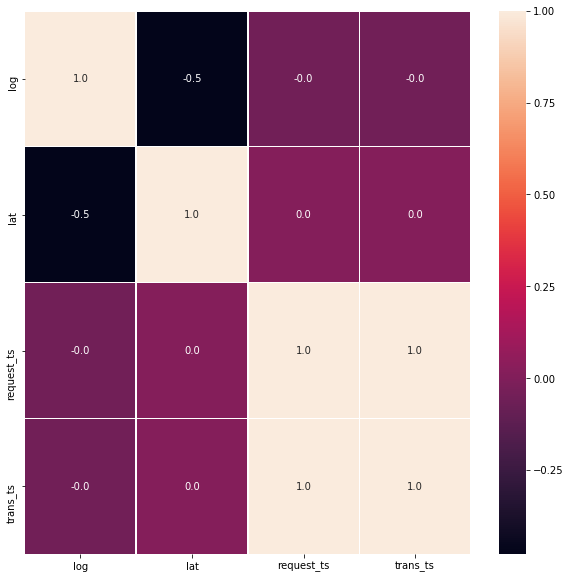

In [448]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

Data size = (10000, 5)
Label 0: 4423
Label 1: 3372
Label 2: 2205


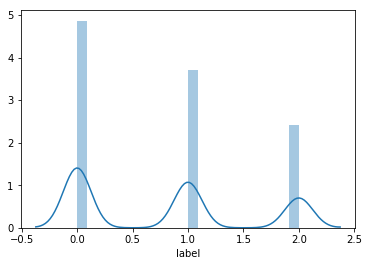

In [449]:
data = df[(df.label!='?') & (df.label!='-')]

print('Data size =', data.shape)
print('Label 0:',len(data[data.label=='0']))
print('Label 1:',len(data[data.label=='1']))
print('Label 2:',len(data[data.label=='2']))

sns.distplot(data['label'].astype('int'))

In [450]:
# #ДЛЯ ТЕСТОВ
# split = 9000
# test = data[split:]
# data = data[:split]

# print('Data size =', data.shape)
# print('Label 0:',len(data[data.label=='0']))
# print('Label 1:',len(data[data.label=='1']))
# print('Label 2:',len(data[data.label=='2']))

# print('Data size =', test.shape)
# print('Label 0:',len(test[test.label=='0']))
# print('Label 1:',len(test[test.label=='1']))
# print('Label 2:',len(test[test.label=='2']))

# data.head()

(10000, 1)
Разница меток времени больше  500 y 154


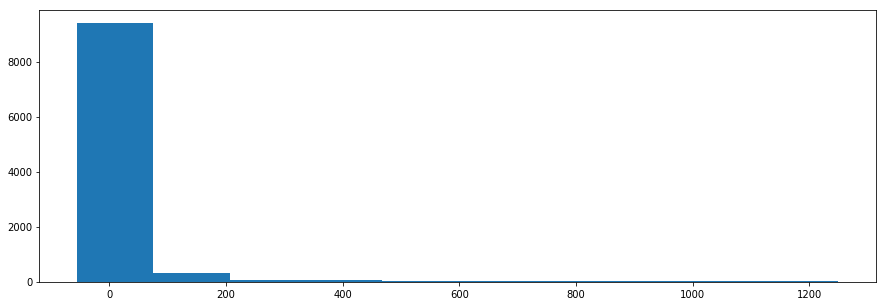

In [451]:
plotdata = pd.DataFrame(data=(data['request_ts']-data['trans_ts']),columns=['dif'])
print(plotdata.shape)
l = 500
print('Разница меток времени больше ', l, 'y', sum(plotdata['dif'] > 500))
fig, axs = plt.subplots(figsize=(15, 5))
a = axs.hist(plotdata['dif'])


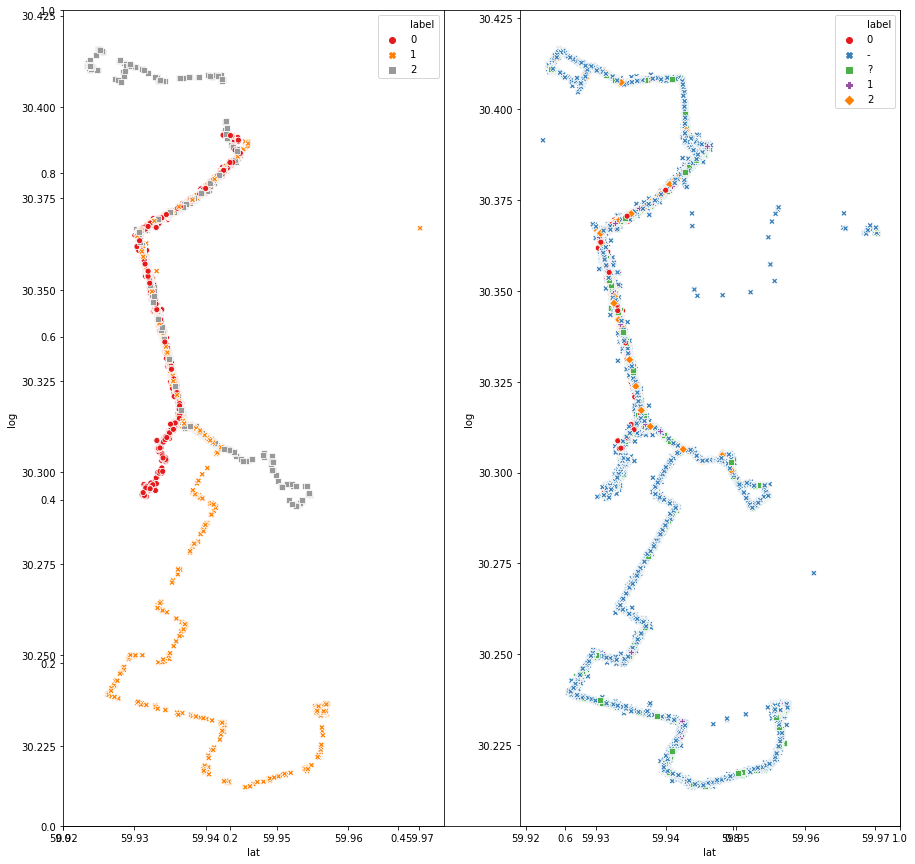

In [452]:
fig, ax = plt.subplots(figsize=(15, 15))

fig.add_subplot(1, 2, 1)
temp = data
temp['label'] = temp['label'].astype('int8')
a = sns.scatterplot(x='lat', y='log', data=temp, hue="label", style="label", palette="Set1")
fig.add_subplot(1, 2, 2)
a = sns.scatterplot(x='lat', y='log', data=df, hue="label", style="label", palette="Set1")
fig = a.get_figure()
fig.savefig('out.png')
del temp

KeyboardInterrupt: 

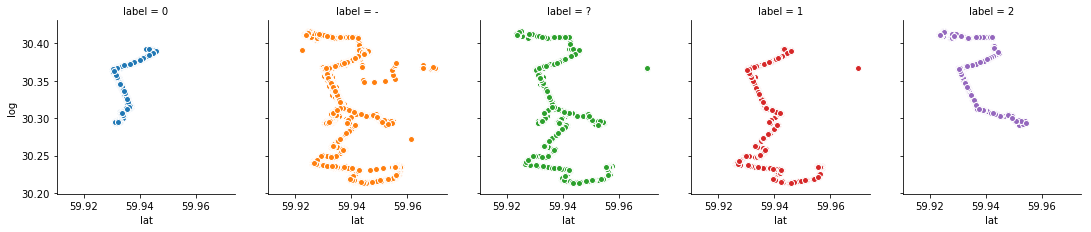

In [453]:
g = sns.FacetGrid(df, col="label", hue="label",)
g = (g.map(plt.scatter, "lat", "log", edgecolor="w"))

In [ ]:
# выброс
max_lat=data['lat'].max()
print(max_lat)
if max_lat > 0.97:
    data.drop(data[data['lat'] == max_lat].index, inplace=True)
print(data['lat'].max())
g = sns.FacetGrid(data, col="label", hue="label",)
g = (g.map(plt.scatter, "lat", "log", edgecolor="w"))

In [ ]:
questions = df[df['label'] == '?']
questions=questions.drop(['label'],axis=1)
print('Надо предсказать:', len(questions))
print('Есть данные:     ', len(data))
questions.head()

In [276]:
unlable_data=df[df.label=='-']
print('Нету данных о мартшруте у ', len(unlable_data))
unlable_data.head()

Нету данных о мартшруте у  43665


log        lat  request_ts    trans_ts label
1  30.219528  59.954617  1511956827  1511956746     -
2  30.409101  59.931679  1511956827  1511956747     -
3  30.293602  59.938892  1511956827  1511956759     -
4  30.360102  59.931103  1511956827  1511956767     -
5  30.309683  59.940006  1511956827  1511956769     -

In [277]:
# сделать что-то с "-" маршрутами
unlable_mb = pd.merge(data, unlable_data, on=['log', 'lat'], how='inner')

print('Можно добавить данные размером', len(unlable_mb))

more_data=unlable_mb[['log','lat','request_ts_y','trans_ts_y','label_x']]
more_data=more_data.rename(index=str, columns={'request_ts_y': 'request_ts', 'trans_ts_y': 'trans_ts','label_x': 'label'})

Можно добавить данные размером 58439


log        lat  request_ts    trans_ts  label
0  30.29578  59.932167  1511956948  1511956936      0
1  30.29578  59.932167  1511957190  1511956981      0
2  30.29578  59.932167  1511957310  1511956981      0
3  30.29578  59.932167  1511975562  1511975540      0
4  30.29578  59.932167  1512026532  1512026521      0

In [278]:
# Запускать если хочешь добавить неизвестные маршруты к данным
# маршруты присвоились при совпадении координат с известными
#data = pd.concat([more_data, data])
print('Размер данных теперь =', len(data))

Размер данных теперь = 9999


log        lat  request_ts    trans_ts  label
0   30.295780  59.932167  1511956827  1511956594      0
8   30.385973  59.944260  1511956827  1511956782      0
13  30.374880  59.938213  1511956827  1511956802      1
17  30.347544  59.932667  1511956827  1511956811      0
23  30.312321  59.937405  1511956827  1511956820      2

In [280]:
def add_time(dataframe):
    time1=pd.DataFrame(index=dataframe.index.copy(),columns=['day'])
    time2=pd.DataFrame(index=dataframe.index.copy(),columns=['hour'])
    time3=pd.DataFrame(index=dataframe.index.copy(),columns=['day_sec'])
    time4=pd.DataFrame(index=dataframe.index.copy(),columns=['day_minutes'])

    for index, row in dataframe.iterrows():
        y=datetime.fromtimestamp(row['trans_ts'])
        if y.hour == 0:
            hour = 24
            day = y.day - 1
            if day == 0: day =30
        else:
            hour = y.hour
            day = y.day
        time1.at[index,'day']= day
        time2.at[index,'hour']= hour
        time3.at[index,'day_sec']= hour * 3600 + y.minute * 60 + y.second
        time4.at[index,'day_minutes']= hour * 60 + y.minute 
        
    dataframe['day']=time1.astype('int')
    dataframe['hour']=time2.astype('int')
    dataframe['day_sec']=time3.astype('int')
    dataframe['day_minutes']=time4.astype('int')
    
    for index, row in dataframe.iterrows():
        y=datetime.fromtimestamp(row['request_ts'])
        if y.hour == 0:
            hour = 24
            day = y.day - 1
            if day == 0: day =30
        else:
            hour = y.hour
            day = y.day
            
        time1.at[index,'day']= day
        time2.at[index,'hour']= hour
        time3.at[index,'day_sec']= hour * 3600 + y.minute * 60 + y.second 
        time4.at[index,'day_minutes']= hour * 60 + y.minute 
        
    dataframe['day_req']=time1.astype('int')
    dataframe['hour_req']=time2.astype('int')
    dataframe['day_sec_req']=time3.astype('int')
    dataframe['day_minutes_req']=time4.astype('int')
    return dataframe

def add_simple_time(dataframe):
    time1=pd.DataFrame(index=dataframe.index.copy(),columns=['day'])
    time2=pd.DataFrame(index=dataframe.index.copy(),columns=['hour'])
    time3=pd.DataFrame(index=dataframe.index.copy(),columns=['minute'])
    time4=pd.DataFrame(index=dataframe.index.copy(),columns=['sec'])
    time5=pd.DataFrame(index=dataframe.index.copy(),columns=['request_ts'])

    for index, row in dataframe.iterrows():
        y=datetime.fromtimestamp(row['trans_ts'])
        time1.at[index,'day']=y.day
        time2.at[index,'hour']=y.hour
        time3.at[index,'minute']=y.minute   
        time4.at[index,'sec']=y.second
    dataframe['day']=time1
    dataframe['hour']=time2
    dataframe['minute']=time3
    dataframe['sec']=time4
    
    for index, row in dataframe.iterrows():
        y=datetime.fromtimestamp(row['request_ts'])
        time1.at[index,'day']=y.day
        time2.at[index,'hour']=y.hour
        time3.at[index,'minute']=y.minute   
        time4.at[index,'sec']=y.second
    dataframe['day_req']=time1
    dataframe['hour_req']=time2
    dataframe['minute_req']=time3
    dataframe['sec_req']=time4

    return dataframe

In [281]:
%%time
data = add_simple_time(data)
data = add_time(data)
print('Размер данных =', data.shape)

questions = add_simple_time(questions)
questions = add_time(questions)
print('Размер данных с неисвестными маршрутами =', questions.shape)
data.head()

Размер данных = (9999, 17)
Размер данных с неисвестными маршрутами = (5000, 16)
Wall time: 16.2 s


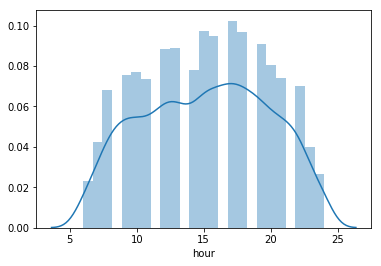

In [284]:
sns.distplot(data['hour'].astype('int'))

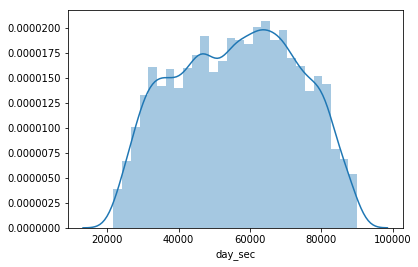

In [285]:
sns.distplot(data['day_sec'].astype('int'))

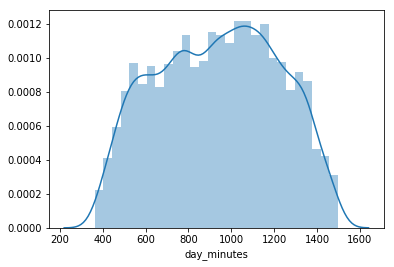

In [286]:
sns.distplot(data['day_minutes'].astype('int'))

In [279]:
# точный ооочень долгий способ
def geodesic(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km
    
    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

In [ ]:
# не такой долгий способ
def geodesic(one,two):
    return math.sqrt((one[0]-two[0])** 2+(one[1]-two[1])** 2)

In [345]:
def add_simple_distance(dataframe, data):
    # dataframe - куда добавляем
    # data - откуда берем ближайшие точки
    way_0 = data[data['label'] == 0]
    way_1 = data[data['label'] == 1]
    way_2 = data[data['label'] == 2]

    dist_0 = []
    dist_1 = []
    dist_2 = []
    
    avg_dist_0 = []
    avg_dist_1 = []
    avg_dist_2 = []
    print('Надо обработать:', len(dataframe))

    for index, row in dataframe.iterrows():
        
        # 0 маршрут
        dist = 1000000
        avg_d = 0
        for i, r in way_0.iterrows():
            new_dist = geodesic((row['lat'], row['log']), (r['lat'], r['log']))
            avg_d += new_dist
            if new_dist < dist:
                dist = new_dist
            if new_dist == 0:
                break
        dist_0.append(dist)
        avg_dist_0.append(avg_d/len(way_0))
        
        # 1 маршрут
        dist = 1000000
        avg_d = 0
        for i, r in way_1.iterrows():
            new_dist = geodesic((row['lat'], row['log']), (r['lat'], r['log']))
            avg_d += new_dist
            if new_dist < dist:
                dist = new_dist
            if new_dist == 0:
                break
        dist_1.append(dist)
        avg_dist_1.append(avg_d/len(way_1))

        # 2 маршрут
        dist = 1000000
        avg_d = 0
        for i, r in way_2.iterrows():
            new_dist = geodesic((row['lat'], row['log']), (r['lat'], r['log']))
            avg_d += new_dist
            if new_dist < dist:
                dist = new_dist
            if new_dist == 0:
                break
        dist_2.append(dist)
        avg_dist_2.append(avg_d/len(way_2))
        
        if index % 1000 == 0:
            print('Обработано:', index)
   
    dataframe['min_to_0'] = dist_0
    dataframe['min_to_1'] = dist_1
    dataframe['min_to_2'] = dist_2
    
    dataframe['avg_to_0'] = avg_dist_0
    dataframe['avg_to_1'] = avg_dist_1
    dataframe['avg_to_2'] = avg_dist_2
    
    return dataframe

In [330]:
def add_dayly_distance(dataframe, data):
    # dataframe - куда добавляем
    # data - откуда берем ближайшие точки
    way_0 = data[data['label'] == 0]
    way_1 = data[data['label'] == 1]
    way_2 = data[data['label'] == 2]

    dist_0 = []
    dist_1 = []
    dist_2 = []
    
    avg_dist_0 = []
    avg_dist_1 = []
    avg_dist_2 = []
    print('Надо обработать:', len(dataframe))

    for index, row in dataframe.iterrows():
        cur_day = row['day']

        # 0 маршрут
        way_0_cur_day = way_0[way_0['day'] == cur_day]
        dist = 1000000
        avg_d = 0
        for i, r in way_0_cur_day.iterrows():
            new_dist = geodesic((row['lat'], row['log']), (r['lat'], r['log']))
            avg_d += new_dist
            if new_dist < dist:
                dist = new_dist
            if new_dist == 0:
                break
        dist_0.append(dist)
        avg_dist_0.append(avg_d/len(way_0_cur_day))
        
        # 1 маршрут
        way_1_cur_day = way_1[way_1['day'] == cur_day]
        dist = 1000000
        avg_d = 0
        for i, r in way_1_cur_day.iterrows():
            new_dist = geodesic((row['lat'], row['log']), (r['lat'], r['log']))
            avg_d += new_dist
            if new_dist < dist:
                dist = new_dist
            if new_dist == 0:
                break
        dist_1.append(dist)
        avg_dist_1.append(avg_d/len(way_1_cur_day))

        # 2 маршрут
        way_2_cur_day = way_2[way_2['day'] == cur_day]
        dist = 1000000
        avg_d = 0
        for i, r in way_2_cur_day.iterrows():
            new_dist = geodesic((row['lat'], row['log']), (r['lat'], r['log']))
            avg_d += new_dist
            if new_dist < dist:
                dist = new_dist
            if new_dist == 0:
                break
        dist_2.append(dist)
        avg_dist_2.append(avg_d/len(way_2_cur_day))
        
        if index % 1000 == 0:
            print('Обработано:', index)
   
    dataframe['daily_min_to_0'] = dist_0
    dataframe['daily_min_to_1'] = dist_1
    dataframe['daily_min_to_2'] = dist_2
    
    dataframe['daily_avg_to_0'] = avg_dist_0
    dataframe['daily_avg_to_1'] = avg_dist_1
    dataframe['daily_avg_to_2'] = avg_dist_2
    
    return dataframe

In [233]:
def add_nearest_distance_intime(dataframe, data, what_time= 'day_sec', time_radius= 10, near_time= 30, min_dist=0.01 ,max_dist=1.):
    # dataframe - куда добавляем
    # data - откуда берем ближайшие точки
    # время каждого дня измеряем в what_time
    way_0 = data[data['label'] == 0]
    way_1 = data[data['label'] == 1]
    way_2 = data[data['label'] == 2]

    time_0_l = []
    time_0_h = []
    time_1_l = []
    time_1_h = []
    time_2_l = []
    time_2_h = []

    dist_0_l = []
    dist_0_h = []
    dist_1_l = []
    dist_1_h = []
    dist_2_l = []
    dist_2_h = []
    

    for index, row in dataframe.iterrows():
        cur_day = row['day']
        cur_time = row[what_time]

        # 0 маршрут
        way0_cur_day = way_0[way_0['day'] == cur_day]
        nearest_time_l = (way0_cur_day[way0_cur_day[what_time]  < cur_time - near_time])[what_time].max()
        nearest_time_h = (way0_cur_day[way0_cur_day[what_time]  > cur_time + near_time])[what_time].min()
        
        if math.isnan(nearest_time_l):
            nearest_time_l = cur_time + 1
            dist_0_l.append(-2)
        else:
            pretend = way0_cur_day[(way0_cur_day[what_time] > nearest_time_l - time_radius) & (way0_cur_day[what_time] < nearest_time_l + time_radius)]
            dist = time_radius0
            new_nearest_time_l = -1
            for i, r in pretend.iterrows():
                new_dist = geodesic((row['lat'], row['log']), (r['lat'], r['log']))
                if new_dist > min_dist and new_dist < max_dist and new_dist < dist:
                    dist = new_dist
                    new_nearest_time_l = r[what_time]
                    
            if dist != time_radius0:
                dist_0_l.append(dist)
                nearest_time_l = new_nearest_time_l
            else:
                dist_0_l.append(-1)
                nearest_time_l = cur_time + 1
                
           
        if math.isnan(nearest_time_h):
            nearest_time_h = cur_time - 1
            dist_0_h.append(-2)
        else:
            pretend = way0_cur_day[(way0_cur_day[what_time] > nearest_time_h - time_radius) & (way0_cur_day[what_time] < nearest_time_h + time_radius)]
            dist = time_radius0
            new_nearest_time_h = -1
            for i, r in pretend.iterrows():
                new_dist = geodesic((row['lat'], row['log']), (r['lat'], r['log']))
                if new_dist > min_dist and new_dist < max_dist and new_dist < dist:
                    dist = new_dist
                    new_nearest_time_h = r[what_time]

            if dist != time_radius0:
                dist_0_h.append(dist)
                nearest_time_h = new_nearest_time_h
            else:
                dist_0_h.append(-1)
                nearest_time_h = cur_time + 1

        time_0_l.append(int(cur_time - nearest_time_l))
        time_0_h.append(int(nearest_time_h - cur_time))

        # 1 маршрут
        way1_cur_day = way_1[way_1['day'] == cur_day]
        nearest_time_l = (way1_cur_day[way1_cur_day[what_time]  < cur_time - near_time])[what_time].max()
        nearest_time_h = (way1_cur_day[way1_cur_day[what_time]  > cur_time + near_time])[what_time].min()
        
        if math.isnan(nearest_time_l):
            nearest_time_l = cur_time + 1
            dist_1_l.append(-2)
        else:
            pretend = way1_cur_day[(way1_cur_day[what_time] > nearest_time_l - time_radius) & (way1_cur_day[what_time] < nearest_time_l + time_radius)]
            dist = time_radius0
            new_nearest_time_l = -1
            for i, r in pretend.iterrows():
                new_dist = geodesic((row['lat'], row['log']), (r['lat'], r['log']))
                if new_dist > min_dist and new_dist < max_dist and new_dist < dist:
                    dist = new_dist
                    new_nearest_time_l = r[what_time]
                    
            if dist != time_radius0:
                dist_1_l.append(dist)
                nearest_time_l = new_nearest_time_l
            else:
                dist_1_l.append(-1)
                nearest_time_l = cur_time + 1
                
           
        if math.isnan(nearest_time_h):
            nearest_time_h = cur_time - 1
            dist_1_h.append(-2)
        else:
            pretend = way1_cur_day[(way1_cur_day[what_time] > nearest_time_h - time_radius) & (way1_cur_day[what_time] < nearest_time_h + time_radius)]
            dist = time_radius0
            new_nearest_time_h = -1
            for i, r in pretend.iterrows():
                new_dist = geodesic((row['lat'], row['log']), (r['lat'], r['log']))
                if new_dist > min_dist and new_dist < max_dist and new_dist < dist:
                    dist = new_dist
                    new_nearest_time_h = r[what_time]

            if dist != time_radius0:
                dist_1_h.append(dist)
                nearest_time_h = new_nearest_time_h
            else:
                dist_1_h.append(-1)
                nearest_time_h = cur_time + 1

        time_1_l.append(int(cur_time - nearest_time_l))
        time_1_h.append(int(nearest_time_h - cur_time))

        # 2 маршрут
        way2_cur_day = way_2[way_2['day'] == cur_day]
        nearest_time_l = (way2_cur_day[way2_cur_day[what_time]  < cur_time - near_time])[what_time].max()
        nearest_time_h = (way2_cur_day[way2_cur_day[what_time]  > cur_time + near_time])[what_time].min()
        
        if math.isnan(nearest_time_l):
            nearest_time_l = cur_time + 1
            dist_2_l.append(-2)
        else:
            pretend = way2_cur_day[(way2_cur_day[what_time] > nearest_time_l - time_radius) & (way2_cur_day[what_time] < nearest_time_l + time_radius)]
            dist = time_radius0
            new_nearest_time_l = -1
            for i, r in pretend.iterrows():
                new_dist = geodesic((row['lat'], row['log']), (r['lat'], r['log']))
                if new_dist > min_dist and new_dist < max_dist and new_dist < dist:
                    dist = new_dist
                    new_nearest_time_l = r[what_time]
                    
            if dist != time_radius0:
                dist_2_l.append(dist)
                nearest_time_l = new_nearest_time_l
            else:
                dist_2_l.append(-1)
                nearest_time_l = cur_time + 1
                
           
        if math.isnan(nearest_time_h):
            nearest_time_h = cur_time - 1
            dist_2_h.append(-2)
        else:
            pretend = way2_cur_day[(way2_cur_day[what_time] > nearest_time_h - time_radius) & (way2_cur_day[what_time] < nearest_time_h + time_radius)]
            dist = time_radius0
            new_nearest_time_h = -1
            for i, r in pretend.iterrows():
                new_dist = geodesic((row['lat'], row['log']), (r['lat'], r['log']))
                if new_dist > min_dist and new_dist < max_dist and new_dist < dist:
                    dist = new_dist
                    new_nearest_time_h = r[what_time]

            if dist != time_radius0:
                dist_2_h.append(dist)
                nearest_time_h = new_nearest_time_h
            else:
                dist_2_h.append(-1)
                nearest_time_h = cur_time + 1

        time_2_l.append(int(cur_time - nearest_time_l))
        time_2_h.append(int(nearest_time_h - cur_time))

    dataframe['time_low_0'] = time_0_l
    dataframe['time_high_0'] = time_0_h
    dataframe['dist_low_0'] = dist_0_l
    dataframe['dist_high_0'] = dist_0_h

    dataframe['time_low_1'] = time_1_l
    dataframe['time_high_1'] = time_1_h
    dataframe['dist_low_1'] = dist_1_l
    dataframe['dist_high_1'] = dist_1_h

    dataframe['time_low_2'] = time_2_l
    dataframe['time_high_2'] = time_2_h
    dataframe['dist_low_2'] = dist_2_l
    dataframe['dist_high_2'] = dist_2_h
    
    return dataframe

In [234]:
%%time
a = add_nearest_sm(questions, data, 'day_sec')
a = add_nearest_sm(data, data, 'day_sec')
data.head()

Wall time: 7min 55s


In [228]:
def del_features(dataframe, features):
    return dataframe.drop(features, axis=1)

In [433]:
to0=[5.722045894884786e-06, 3.6439844464383696e-05, 0.00141171633063479, 4.200499638693695e-05, 1.7584885520395803e-05, 4.077445665243988e-05, 0.005204177239133775, 0.0, 5.544449559688047e-05, 0.0009548789998653273, 0.00016885153216292202, 0.06375331793038531, 7.62939453125e-06, 0.07733107970237127, 0.0, 0.0, 0.00011432960182682578, 2.8863422295713902e-05, 5.006563090670276e-05, 1.6184389828183307e-05, 7.428871953466845e-05, 3.703401153564995e-05, 0.009797493709248853, 0.0, 3.3310411834689965e-05, 8.013134589673135e-05, 1.7584885517313034e-05, 0.009797493709248853, 0.0, 5.275465654731495e-05, 6.070644554964651e-05, 0.06279487648215805, 5.7220458987927714e-05, 0.07828288462399392, 0.0060969928815947285, 4.2862329586494887e-05, 3.814697265625e-06, 0.0010707957828194588, 4.26496119499357e-06, 0.005335801578823026, 3.932099938929987e-05, 0.0, 0.005335801578823026, 6.877043298747642e-06, 0.0001250295762372771, 0.00010898624135712931, 0.0046596808165206465, 1.9073486328125e-06, 1.8785205456527504e-05, 0.00018727016767324184, 0.00017978721228911244, 5.313258467426222e-05, 5.017450881236084e-05, 2.4425980522766453e-05, 4.403456260915831e-05, 0.00018727016767324184, 3.454355292563407e-05, 0.00018727016767324184, 0.0001226204159579882, 0.03625309006315671, 0.0, 0.00011380335913972254, 2.4795532233121357e-05, 2.054277345811875e-05, 0.0, 0.0005271498944194232, 1.9073486328125e-06, 7.448434520859854e-05, 0.043740434863592796, 6.823937919616058e-05, 1.9073486328125e-05, 0.00014896869041182951, 0.00014073079487378476, 2.359259962699684e-05, 0.0, 5.875748367514701e-05, 0.0001999079718233998, 5.875748367514701e-05, 9.536743167615214e-06, 1.9073486292597863e-06, 5.354182757448026e-05, 0.0, 7.629394527697286e-06, 0.00010412097216932653, 0.02658770716189907, 0.0, 1.388570763721192e-05, 5.0355448849429665e-05, 4.65643143280015e-05, 3.0755072587198445e-05, 3.927471214843479e-05, 1.6184389833207605e-05, 4.055078817038129e-05, 0.0, 0.0, 0.0, 3.264854958789546e-05, 5.188549236598819e-05, 0.07281874731066687, 7.629394527697286e-06, 0.0008963016624331899, 0.026536437302422236, 0.00010412097216711379, 0.0008963016624331899, 0.04512821271544297, 9.5367431640625e-06, 0.0, 4.264961199760036e-05, 0.006169846828088208, 5.27546565519391e-05, 0.0006357539488176619, 0.000160987456100534, 0.0, 5.0894409431233516e-05, 5.1885492358152176e-05, 0.0, 3.8194626599668745e-05, 5.7220458984375e-06, 0.0, 9.846427535884758e-05, 0.02222183617095501, 4.041599292834681e-05, 0.008016171513857874, 7.300437626052947e-05, 9.846427535100216e-05, 0.06756884623249909, 2.777141528223188e-05, 5.501634635647939e-05, 0.04396801087502503, 0.006693445107897055, 0.06365891764871595, 0.026842699754096665, 0.007582959965900652, 0.0, 0.020931903306603713, 6.662082365636055e-05, 0.05455608072479625, 0.0003414367157628326, 1.70598447958625e-05, 0.026679458222835174, 3.814697269177714e-06, 0.0, 2.442598051777289e-05, 4.464988674347275e-05, 1.9073486328125e-06, 0.005366141572215651, 3.814697265625e-06, 2.4795532233121357e-05, 3.56322130046289e-05, 0.07202173504239917, 5.3947966096456507e-05, 0.005628457838702239, 0.06814327162872748, 1.7584885517313034e-05, 5.7220458984375e-06, 0.049128359085557224, 2.905186884862389e-05, 0.01187344118132432, 0.0, 2.6497734055838836e-05, 0.0032499972619462972, 8.446346216426729e-05, 0.0017095718055407808, 5.394796614418732e-06, 1.758488551577165e-05, 0.00704757473582504, 5.491706867373748e-05, 0.0, 9.5367431640625e-06, 7.448434520541438e-05, 7.857257814043419e-05, 0.00011195015404132009, 0.0070891817631279965, 7.50681635029839e-05, 1.916861652623411e-05, 0.019431177548732338, 0.008125377932290985, 6.70833793452033e-05, 0.0, 0.07804347523680275, 5.39479660437014e-06, 2.412626388341228e-05, 0.07901966839687738, 0.004804180727184943, 1.9073486329546084e-05, 7.650822113795855e-05, 0.0, 5.7220458984375e-06, 0.0, 3.814697265625e-06, 1.9073486328125e-05, 0.0, 0.0, 0.024946454777099687, 6.496195359765206e-05, 1.078959322130102e-05, 3.8146972620722863e-06, 0.06400990036751537, 0.0, 7.62939453125e-05, 0.00010194952403940404, 0.0009903897444863757, 0.0, 1.2063131942267873e-05, 6.529709917786644e-05, 2.2243316249866566e-05, 0.00014655588312772127, 0.00010406854909158014, 3.411968959808029e-05, 5.9250734584842936e-05, 6.877043299732988e-06, 0.0, 5.206048607756947e-05, 4.973756717836494e-05, 0.0, 0.051892377807277026, 0.030510205868499316, 0.07517462880297478, 3.411968959808029e-05, 2.8863422302756998e-05, 3.8146972620722863e-06, 3.8146972585195726e-06, 0.06323229725744421, 0.0, 0.062214055003539985, 0.00014655588312772127, 5.132150286036555e-05, 5.132150286036555e-05, 0.0, 0.0017160043694368302, 0.0, 0.0014818134938707833, 0.0, 0.0027989098295396, 0.0, 0.0, 0.0, 0.006403672432842614, 5.1639504896582264e-05, 0.00014655588312772127, 0.045565164392207716, 0.06186976588972503, 0.0, 4.2134708470748505e-05, 0.004816218458378056, 0.024974360723200407, 1.9073486399179274e-06, 0.004146596983964022, 0.0, 0.0, 0.003617270464852441, 7.033954206115988e-05, 0.0, 0.0, 6.587950149353436e-05, 0.0, 4.46498867377057e-05, 0.0, 4.464988673891982e-05, 0.02146228961005885, 0.00023379613251281318, 0.00029793738082529655, 3.814697265625e-06, 0.05853133394508841, 4.8851961044423225e-05, 0.023129073571359217, 8.529922402697716e-06, 0.000443555964781399, 0.00021583400711072724, 5.5836796445395886e-05, 4.077445664545994e-05, 0.01613337219738898, 0.030933859077327586, 0.00014298755504103973, 8.767581889771426e-05, 0.0001531709023510318, 0.06389925049759342, 5.531311035389014e-05, 4.077445664545994e-05, 5.2754656548856334e-05, 0.007894104695487295, 0.00014620794598950806, 0.00034128751436771657, 3.6439844463639865e-05, 0.0, 1.0271386729059375e-05, 0.0, 0.0639081972121778, 2.8354775900494587e-05, 9.117445680783935e-05, 0.0, 0.05660226428897422, 4.264961204526501e-06, 0.00011450447860212885, 2.5942746179076088e-05, 0.07936328418064778, 0.06347730434424664, 4.825252777693576e-05, 4.768371581931774e-05, 4.126225977080825e-05, 0.0, 0.0, 0.06593762676960904, 3.6439844463639865e-05, 0.007775795103726425, 0.061898022617451635, 0.07548333052961999, 1.9168616532950767e-05, 0.0, 7.629394524144573e-06, 0.026266624058159396, 0.0622508932042568, 0.0, 1.9073486328125e-05, 4.264961198171214e-06, 7.169702960667611e-05, 0.0017172250718877128, 0.0, 0.0, 4.2134708470105214e-05, 0.0, 0.00032244911893467476, 4.077445664811897e-05, 0.0261092219023126, 0.0, 0.0, 0.06426735999395565, 0.0047583868393055164, 0.01620756153725528, 0.02295347501467574, 0.0, 2.9114413300554912e-05, 0.0, 9.536743160509786e-06, 9.993123549389851e-05, 0.0, 0.0, 0.0001647401648042719, 0.06426735999395565, 0.0008884662512046328, 9.536743160509786e-06, 0.0261092219023126, 0.06416192217886416, 1.0789593216276724e-05, 0.005761991624209746, 0.00010223459841352384, 0.006797779823919048, 4.448663249851456e-05, 0.0040640725533233075, 0.00037951924448136125, 0.026667309638008445, 3.8146972585195726e-06, 0.00648793994690855, 0.0001619899414606588, 0.00014575937785084032, 5.772684460293153e-05, 0.0, 4.718519926778023e-05, 0.06413368085468099, 3.8146972585195726e-06, 0.020944656043350735, 2.0631129887374818e-05, 0.0, 4.718519926778023e-05, 0.0063705515718705625, 6.5297099184093e-05, 5.302978047772757e-05, 0.0, 0.0001619899414606588, 0.05996381651481548, 0.08002223588692763, 0.000811816067072039, 1.3885707640627937e-05, 6.496195360140727e-05, 0.06886931110096405, 0.00012543627202604016, 0.0, 6.773102151484572e-05, 0.0, 0.06272709674494448, 0.00015640258789755712, 8.148196931188136e-05, 5.800974398270781e-05, 0.0, 5.3132584675537564e-05, 7.629394534802714e-06, 0.00011380335914520055, 5.394796614418732e-06, 5.149841307883207e-05, 0.02162170443808207, 0.07752863127077804, 7.629394527697286e-06, 0.020653409088418034, 0.07589600820541238, 6.585188484814479e-05, 0.06266398057443785, 5.2616555112809275e-05, 5.017450880722879e-05, 0.016069714574484698, 2.4425980524430978e-05, 0.03072554898346928, 0.06383224377335926, 0.00013658534080481077, 4.126225977080825e-05, 0.06335036176105646, 0.007591412413066283, 0.0034212289528888925, 0.0011406199985025836, 0.00012640412541031564, 0.008805885746166893, 0.06395296869721508, 0.0005881318091775535, 8.36628425548437e-05, 2.232494336885285e-05, 0.061976259453416886, 1.3885707640627937e-05, 0.00014765638147082397, 0.06385808705996367, 0.0002493671424753306, 0.0, 3.814697265625e-06, 5.6709551800989174e-05, 8.929977349210549e-05, 0.00013658534080768824, 0.08046633554526976, 0.0, 0.026273377307147103, 4.88891815804758e-05, 2.508725440591031e-05, 4.9480902752200495e-05, 0.06224630062734108, 0.0009563047372590349, 6.642942340084072e-05, 6.34892157596054e-05, 0.05787482008787942, 0.00020978233869206345, 0.03125528998834914, 0.059887659394187956, 2.6702880859375e-05, 0.06460444986233523, 0.05084314637525183, 1.629639386237627e-05, 1.9073486328125e-06, 2.5589767195382572e-05, 8.36628425563016e-05, 3.757041092892683e-05, 0.05169149206976426, 9.46975066136596e-05, 0.06029926106767828, 0.04754215563365497, 0.00018654025648493763, 0.0, 0.05392873561134206, 2.5589767195382572e-05, 0.0005661195818827232, 3.814697265625e-06, 7.337716698644423e-05, 0.06460444986233523, 0.0001762724510270556, 1.9451215795870913e-05, 0.07898117438861885, 0.06386879590402661, 0.07898117438861885, 0.04495754749758806, 3.77635762682732e-05, 0.06386879590402661, 0.06250236178942484, 4.1085546929431944e-05, 0.00024521857944209284, 0.026249081567269354, 1.758488552078115e-05, 0.06374729737557616, 0.027342986038722067, 7.854942429341889e-05, 0.027342986038722067, 0.0008986851134556895, 4.9920090974053956e-05, 0.06503772530728495, 0.02896310626027534, 5.39479660437014e-06, 0.00014896869041264828, 0.00934431975545311, 3.1456799518746766e-05, 0.0, 0.0008651629115961374, 0.06503772530728495, 3.814697264914457e-05, 0.035904507048765764, 2.0631129894272235e-05, 5.973991303093618e-05, 5.53131103515625e-05, 2.9051868843958947e-05, 0.0, 3.814697265625e-06, 3.6439844467916894e-05, 2.730907642914977e-05, 2.5589767195382572e-05, 8.33142458574317e-05, 2.5589767195382572e-05, 1.206313195013214e-05,
     2.5589767195382572e-05, 0.07985664716878106, 1.9168616518456932e-05, 2.7508173189078494e-05, 2.5589767195382572e-05, 0.0, 0.0, 0.020796131081713704, 8.566097860154666e-05, 0.06335036176105646, 0.001285231745398932, 1.5377536286989326e-05, 0.06399997047431602, 4.973756718217966e-05, 0.0307155797191234, 2.7771415288087914e-05, 2.3203897592358887e-05, 2.7771415288087914e-05, 0.06399997047431602, 2.442598051000512e-05, 0.019424344457389303, 4.303174656936065e-05, 0.015049376681967661, 2.5589767195382572e-05, 4.264961209292967e-06, 0.001494121280634239, 0.006673058387865688, 0.005088311418679343, 0.0732910709369776, 0.003636337033089895, 0.000933042511645127, 3.104938620144174e-05, 0.0006149594888685637, 0.0001268064128084662, 6.942853822305021e-05, 0.0006149594888685637, 0.0, 0.05847424723497022, 1.206313194339134e-05, 0.0, 2.594274617228487e-05, 5.394796611906584e-06, 2.6702880859375e-05, 3.454355291896443e-05, 0.00010094542405944865, 2.5942746179076088e-05, 7.864199878825032e-06, 6.49619536053711e-05, 2.9793738082529655e-05, 3.057712467552452e-05, 6.877043302689024e-06, 0.007475670903418809, 4.264961199601154e-05, 1.1601948795887412e-05, 0.00010850114939242687, 0.0, 7.036539743689238e-05, 6.773102151234455e-05, 0.004084661355279913, 4.264961201348858e-06, 3.932099939671014e-05, 0.0015116841970784674, 3.932099939671014e-05, 7.829428005107561e-05, 3.890243159522555e-05, 1.9913304352719748e-05, 6.4849853515625e-05, 5.958747616051053e-05, 3.0755072586317124e-05, 0.0004626332988184284, 3.438521647876096e-05, 5.035544884014443e-05, 9.351845300393114e-05, 0.06334719602677753, 0.004319989283718236, 0.001642032217400739, 5.7252239309941275e-05, 0.007389803393473978, 8.228170246665312e-05, 0.009450044024278846, 3.8902431585471125e-05, 0.008664037476171107, 7.036539743689238e-05, 0.008664037476171107, 3.236877965385447e-05, 3.454355292563407e-05, 0.06011217054102429, 9.536743166194128e-06, 0.015290175582649312, 0.02631882060475115, 1.0271386732357986e-05, 3.563221300557977e-05, 0.00041200496494447653, 0.0, 0.0, 0.005592509146341348, 0.005637300777295999, 3.982660869182797e-05, 2.697398304747461e-05, 0.0, 0.0014193647339648635, 3.5987782020505846e-05, 0.0, 7.724173252274584e-05, 0.0, 6.563053334634374e-05, 0.0, 8.572465916919553e-05, 0.0, 9.99312354879991e-05, 0.0, 4.644697441587068e-05, 9.307001418118173e-05, 0.0, 5.2995468107330266e-05, 3.264854959225405e-05, 5.9709456796640505e-05, 4.9591064453125e-05, 0.0, 0.00010412097216425024, 0.0, 0.0, 2.8863422302756998e-05, 0.0, 0.0, 3.833723305176121e-05, 0.00015904359982630133, 0.0, 4.722373353248576e-05, 8.529922409053003e-06, 3.104938620013229e-05, 5.5016346363376805e-05, 0.00023307144730540987, 0.00010078311777796764, 0.00918717389771582, 9.748025771469603e-05, 0.0, 0.0, 0.0, 0.00021365710396077333, 0.00012870010687452934, 0.010804425458175379, 0.00021694361439633455, 9.903530109975563e-05, 0.0052300320319073265, 0.06382825172977834, 0.0, 5.049973408973875e-05, 3.4385216475607856e-05, 3.24249267578125e-05, 6.67572021484375e-05, 0.0, 0.06382825172977834, 3.454355293269603e-05, 0.0005060336473729504, 0.00018536642045683795, 3.618939583017402e-05, 0.005286946092392511, 0.06266398057443785, 2.3203897592358887e-05, 0.0, 5.8009743976283127e-05, 1.0271386732357986e-05, 0.060592234688613494, 1.5377536293599222e-05, 0.0, 2.224331624560157e-05, 7.764103865285079e-05, 0.0, 0.016161198964940497, 0.0005803012220185377, 4.533715944254256e-05, 0.0005803012220185377, 3.927471214049818e-05, 0.00010377098471630435, 0.02664976648139086, 0.0006295290774263546, 3.438521647895803e-05, 1.9073486363652137e-06, 9.764805401741184e-05, 0.0, 9.719995351172372e-05, 0.0, 0.026730728682920375, 0.006357932312440247, 0.0002450107922027525, 6.529709918803647e-05, 0.026730728682920375, 0.010315286331506496, 0.026468983719320365, 0.020160324252419648, 8.940156284597303e-05, 0.00022115376343743507, 4.825252777356536e-05, 6.10649513000916e-05, 0.03672049269898165, 3.6239624019884786e-05, 6.10649513000916e-05, 7.764103865616731e-05, 5.722045901990214e-06, 0.02146798263368683, 2.5942746182471697e-05, 0.0, 2.911441330800278e-05, 1.0271386726420485e-05, 0.0, 7.829428005306623e-05, 0.00011225844550752381, 0.06100672682627567, 1.9073486292597863e-06, 7.93787080658794e-05, 0.0171040765214703, 0.0, 0.07914505220830773, 9.536743167615214e-06, 0.009217402135949163, 0.0086288808405349, 0.011138072210515196, 0.0, 4.722373352732002e-05, 0.0001188080711547656, 0.0, 0.0, 1.1444091796875e-05, 4.7836060348451436e-05, 5.734747459499904e-05, 0.02674555311672576, 0.06977086773719185, 3.0755072587198445e-05, 5.135693366178993e-05, 0.0, 1.9073486399179274e-06, 7.62939453125e-06, 2.9793738080255263e-05, 0.0, 0.06396133360554465, 6.236184205731131e-05, 0.0, 0.0, 0.04341221210818864, 3.814697265625e-06, 0.00014719987016579593, 0.0008831085962857936, 0.06396133360554465, 3.51697710315433e-05, 0.017611683908478275, 1.572839974903347e-05, 5.7726844598940444e-05, 0.00038113102181982, 0.0, 0.0, 2.6973983053503764e-05, 0.06396133360554465, 2.442598052554066e-05, 0.00010116142735424896, 0.0019060788696329796, 0.06396133360554465, 0.0, 0.0, 4.3494240764585034e-05, 6.823937919616058e-05, 6.877043295791605e-06, 5.3711425168746084e-05, 0.07689638371476262, 0.0058829586073156845, 4.959106445449143e-05, 0.009835595309841868, 8.529922396342428e-06, 5.7220458984375e-06, 0.007265036861411678, 0.014845290430543919, 0.0, 0.01227865619063678, 7.62939453125e-06, 0.0001200418012825023, 0.005459316933197674, 0.016364460825550077, 1.572839974903347e-05, 0.0, 1.5258789058947286e-05, 2.32038975952792e-05, 4.813930307054124e-05, 0.0, 0.026462230210213704, 6.942853821768217e-05, 4.5935037908763205e-05, 0.06411424261352895, 4.3536042069036126e-05, 7.724173253151864e-05, 4.213470846656709e-05, 3.6439844465127526e-05, 1.2794883594513642e-05, 0.0, 6.151014517087162e-05, 1.2794883594513642e-05, 0.0, 1.7584885517313034e-05, 1.3885707644043957e-05, 9.622191051618304e-05, 0.0640789832021706, 0.0, 4.264961199760036e-06, 0.02627066017981417, 0.010509021042358119, 0.0, 0.05725458821681262, 4.2862329583174924e-05, 0.06381329028090676, 1.5377536290073946e-05, 1.9073486328125e-06, 0.0017059844799040143, 0.06414599593175836, 2.054277345811875e-05, 0.0001329820099886024, 0.0002800361961640618, 0.0, 6.103515625e-05, 0.013616374867202841, 4.76837158203125e-05, 9.536743160509786e-06, 0.004262215813617249, 0.00015678591390657102, 0.06425646673441471, 0.06400895258626924, 1.7059844791096036e-05, 0.0, 0.00014500868079763576, 0.00021956888476734623, 0.0003938571014091013, 0.002029024530388477, 0.0, 0.0002696116736068922, 2.9854728398320253e-05, 9.5367431640625e-05, 0.00013038510254486302, 9.734954952728385e-05, 0.0, 0.005961050386241893, 0.00010137697040563318, 9.485104948714561e-05, 0.0, 0.015617567791643132, 0.008604787052044, 0.06036920783343914, 0.00019877647703205533, 0.009656613032974326, 0.009965792021133606, 2.4126263880041877e-05, 1.2212990257221923e-05, 0.029529216721349418, 2.4795532218637216e-05, 0.0, 8.938121423667189e-05, 0.07430996297488392, 0.03070469337360647, 0.07474264386588277, 0.003853146852759462, 6.48498535093555e-05, 1.572839976282002e-05, 0.003853146852759462, 0.01696719067416687, 0.02604522795590043, 0.06400895258626924, 0.08026699366837119, 0.004720303683590761, 2.5942746182471697e-05, 0.07836869398347047, 0.01563090684466135, 0.05847424723497022, 0.02604522795590043, 2.5942746182471697e-05, 0.0529107841128898, 3.6638970777214174e-05, 5.188549235397296e-05, 0.00012537825340085842, 1.1444091800427714e-05, 0.00629979005435104, 0.0065656159729215405, 0.0, 0.003612387391961302, 8.446346216234184e-05, 4.126225977080825e-05, 6.529709918803647e-05, 3.838465079148504e-05, 0.0, 0.0002777141528877112, 0.025878091242057928, 6.576896533800761e-05, 2.8354775907903008e-05, 6.151014517395623e-05, 0.0010463072075275377, 0.000570679858401169, 0.0001347754732247493, 0.022795850799163977, 0.00010071089768997779, 0.003612387391961302, 0.007032519598835424, 4.5776367183947286e-05, 5.188549235710737e-05, 0.007491292350335606, 0.01721172858960148, 0.02473960945119912, 0.0, 8.529922399520072e-06, 0.023715924733421562, 0.0, 2.911441330800278e-05, 6.908710585126814e-05, 0.0009296069727627212, 6.995056465489292e-05, 3.5169771033855376e-05, 1.9451215800748125e-05, 8.190502378254474e-05, 3.281526667709532e-05, 0.0, 2.4425980522211612e-05, 0.00018855759565997426, 6.484985351875975e-05, 7.179843987735564e-05, 0.0, 0.0001429493860057963, 0.02752403322255684, 0.06399436879081871, 0.06306563180245532, 0.0547659031019929, 1.375408659158321e-05, 7.033954205615038e-05, 0.0001335144042954539, 2.677091380128831e-05, 0.026671345004433872, 1.388570763721192e-05, 0.0, 8.7820926156779e-05, 0.0, 0.026671345004433872, 1.388570763721192e-05, 1.375408659158321e-05, 0.0639294505536328, 0.00019040078469025054, 0.0019344286202906248, 0.044174649758374915, 0.0, 5.6709551803617964e-05, 0.01101856089552037, 5.3541827577770826e-05, 3.057712467552452e-05, 3.259278772475254e-05, 0.06400895258626924, 0.003710283379413426, 9.021174309762003e-05, 0.06272181277041892, 0.00021454916883113635, 0.0803064868933002, 3.438521647895803e-05, 0.00013016169676454786, 5.737918456035275e-05, 3.264854959225405e-05, 0.06398711210482858, 0.027248575158362633, 0.007865761691752644, 0.0, 0.001821800529562024, 0.07527230504765241, 0.0, 6.212805738749954e-05, 8.047112697312679e-05, 2.4425980514443846e-05, 0.0641186179635057, 5.737918456035275e-05, 2.9793738082529655e-05, 0.0, 0.06393464564628262, 0.06409686116384185, 0.0019060788696329796, 0.010914381534894154, 1.0789593223813167e-05, 4.1831421278879755e-05, 0.026485167642993215, 0.007507527017187028, 5.354182757422714e-05, 0.00014340674390170586, 0.026351619745159087, 0.0, 0.026869672844475077, 0.06415880587305661, 6.484985351875975e-05, 0.0, 0.0, 3.9826608686043064e-05, 2.1324805996575828e-05, 2.412626388678268e-05, 0.0, 2.2967518957036932e-05, 3.703401153016073e-05, 0.06393464564628262, 7.41907132674283e-05, 3.703401153016073e-05, 0.0001645634049234237, 0.05260717373586317, 7.62939453125e-06,
    3.814697265625e-06, 0.061869426609383965, 5.035544884660372e-05, 0.0004992045535194843, 9.993123548454083e-05, 0.0, 2.412626388678268e-05, 0.0019060788696329796, 0.001776786111826596, 7.864199876240053e-06, 0.001776786111826596, 3.174460788172386e-05, 0.031293996372500195, 0.06268837610853359, 3.814697265625e-06, 0.0035623717436583002, 0.01622637746285042, 0.020000092515630473, 0.0001220852127473143, 0.0076520973023287125, 3.438521647600199e-05, 0.06364460572752216, 0.008187695628353852, 0.08006449554702237, 0.009555219681113756, 0.02227146608049152, 0.068077756804032, 0.07913326894394822, 9.330425116988699e-05, 0.06394411367186578, 6.52970991849232e-05, 5.163950488949625e-05, 0.001429169343131739, 2.886342229923545e-05, 0.0, 0.00018488496118244376, 3.757041093902709e-05, 6.866455078125e-05, 0.0001313857276857007, 0.0, 0.00014053678146765193, 0.0, 0.020796131081713704, 0.051779239449005685, 0.0004154212328054492, 1.33514404296875e-05, 0.06314189785252541, 0.0767102348681702, 2.0275394077169576e-05, 0.0, 0.0, 6.340320640466062e-05, 0.0008663835924682461, 0.026376904095226555, 1.9073486328125e-05, 1.078959322130102e-05, 0.06314189785252541, 0.06400895258626924, 0.0, 0.026209960514251274, 2.5942746182471697e-05, 0.0, 0.06379200120427884, 0.012899896712774696, 8.047112697851606e-05, 0.06314189785252541, 0.001866128887080018, 0.026376904095226555, 0.0, 0.0004046457094169958, 0.0004046457094169958, 6.563053334840871e-05, 4.69145731973604e-05, 0.06314189785252541, 7.033954206154522e-05, 0.0014407857054870427, 0.0, 0.06375736268160004, 6.484985351875975e-05, 0.0722038755921687, 0.007236811751463966, 1.7059844799040144e-05, 7.367404141371146e-05, 1.758488551384492e-05, 2.288818359375e-05, 0.06279487648215805, 0.0004191178911619592, 0.010697492804639023, 0.0, 0.00017671561923065902, 0.06397491671058629, 0.00044848657757564, 3.438521647994337e-05, 8.996945507103543e-05, 4.885196103554578e-05, 0.06381922411989746, 3.814697265625e-06, 0.00011121658124567712, 0.0004012691640335826, 6.890255686757037e-05, 1.7059844806984253e-05, 3.814697269177714e-06, 5.570633646587461e-05, 4.640779518296559e-05, 0.0, 0.0, 9.061411682296527e-05, 4.023556348748968e-05, 0.010697492804639023, 0.0, 0.026311139853146082, 0.04353866651347462, 0.0001312194867139162, 5.7220458984375e-06, 0.0, 0.038089469150257835, 3.814697265625e-06, 0.020365878095355092, 0.016061189398392472, 0.06314189785252541, 0.0, 7.552715253403426e-05, 0.010697492804639023, 1.375408659158321e-05, 5.394796606882288e-06, 0.015973363377854568, 6.662082365636055e-05, 0.0, 0.02916332067732927, 0.06314189785252541, 0.0755017346199897, 0.016211002620629533, 0.0, 0.0, 5.394796609394436e-05, 0.017180868398163227, 0.0, 2.2967518961462486e-05, 0.06314189785252541, 0.00011009879829148721, 0.019487987601089253, 0.06314189785252541, 0.0001249713687963956, 5.394796611906584e-06, 7.780486317651621e-05, 0.0016466915223377386, 0.005906404317957217, 8.19272292966302e-05, 0.0, 6.454057432437375e-05, 0.04502505027110572, 0.0, 0.01511836778163769, 0.07902068624139741, 0.0, 0.057512750498146845, 4.2649611994104954e-05, 8.148196931063392e-05, 0.05547383732746145, 0.0, 4.2350012419079816e-05, 0.0005186199833705906, 6.151014516029578e-05, 0.03131557941922909, 0.0001519188518656912, 2.7309076430638564e-05, 0.06314189785252541, 8.237008240810023e-05, 0.0, 0.00016654113733507599, 0.0035833512625265515, 0.02865573551072441, 0.06314189785252541, 0.0, 0.0, 1.5377536290514603e-05, 0.010068428056255194, 4.108554693734861e-05, 0.0036027351888884306, 7.593547529491459e-05, 2.9051868842559466e-05, 5.421703492340907e-05, 0.00614257000208501, 0.02240501898865917, 0.0, 0.0061253874019939055, 3.438521648467303e-05, 0.0, 0.016990190237364044, 0.0, 5.3947966092939504e-05, 0.0, 4.4486632492421705e-05, 1.7059844799040144e-05, 7.07777989008087e-05, 0.005629910332925965, 0.06364426204707725, 3.703401153564995e-05, 5.7220458984375e-06, 2.677091377977308e-05, 0.06314189785252541, 5.7220458984375e-06, 0.021427390878441553, 0.006679025104441599, 0.0, 0.0803793864213143, 5.9709456796640505e-05, 0.007909774780274709, 2.697398304697218e-05, 9.382914639154315e-05, 0.0, 0.05416185040202486, 0.016938370268473352, 0.06401414045967817, 0.06298129880262107, 1.4896869041264828e-05, 0.06400895258626924, 0.023477602280001078, 1.8785205466267034e-05, 0.06401414045967817, 0.006902701817150724, 0.025071373642848668, 0.00010223459841597626, 0.00011097097936539205, 0.0076520973023287125, 0.06401414045967817, 0.0004657368875170146, 0.0076520973023287125, 0.005410491855169987, 0.06314189785252541, 9.212711086509039e-05, 1.9073486328125e-06, 7.250434039302335e-05, 0.0067910911694710994, 1.9073486328125e-06, 1.7059844799040144e-05, 0.015280297022296687, 0.02345980635750799, 0.0, 1.9073486328125e-05, 0.003977911728929712, 0.0575254895641002, 0.0, 0.026384721509500192, 0.06314189785252541, 0.026384721509500192, 0.0, 0.04331830575223494, 6.877043291850224e-06, 0.0773523934097141, 1.2212990258331604e-05, 0.0019189377610458697, 0.014978281057248435, 3.2648549596612635e-05, 4.825252777131843e-05, 3.2592787725999984e-05, 0.021435879300696306, 0.00021119095665994887, 3.395937693551036e-05, 0.03573312434613396, 5.135693366178993e-05, 2.886342230181792e-05, 0.0, 0.03573312434613396, 2.288818359375e-05, 0.00535965271267515, 0.0791626859832071, 0.05346167580147566, 0.0267293692409118, 5.7220458984375e-06, 0.00019157225844558288, 1.9073486292597863e-06, 0.00043879383355146937, 0.0001079633460852425, 0.0, 4.264961204526501e-06, 8.400999277097013e-05, 0.06461681672940188, 0.06364088727799892, 0.0, 4.609316243559835e-05, 1.9073486328125e-06, 6.03156597102159e-05, 0.0634830356068965, 2.7508173175283658e-05, 7.03395420630866e-05, 0.04577221215782297, 0.07910757590177071, 0.06366477033332446, 7.69822543053363e-05, 0.0, 0.0, 5.371142516735832e-05, 0.06260600128435159, 0.026301709209785588, 0.06421397774125963, 3.0755072587639105e-05, 0.06366477033332446, 1.1444091796875e-05, 0.06292241671814543, 0.00025629542590699503, 0.0001520265745299497, 0.07902861805988204, 0.0008248571684878607, 4.0550788162694435e-05, 0.06366477033332446, 0.06224604045931958, 0.02656476952520494, 0.00015570321374053597, 0.06816217811324023, 2.3282157155123735e-05, 0.06224604045931958, 0.03044642886569256, 0.00019065855407345868, 0.0, 5.006563090453719e-05, 2.594274617228487e-05, 0.012071506881342616, 0.014753367319802485, 1.9073486399179274e-06, 0.00019928827020150212, 2.0275394077169576e-05, 6.877043296776951e-06, 0.06366477033332446, 6.823937919616058e-05, 0.06314189785252541, 0.06314189785252541, 0.0, 3.8337233054589274e-05, 0.01784044679078995, 3.8146972620722863e-06, 0.0, 0.06314189785252541, 4.609316243442226e-05, 1.907348633025663e-05, 0.00016193378660004333, 0.026605250217894394, 6.942853821338774e-05, 0.07963999723226813, 4.2004996393873726e-05, 0.021325147278264487, 0.0005253663618040664, 0.0, 5.049973409537449e-05, 0.0, 0.0, 1.629639386778185e-05, 0.00019484852278462677, 0.06400895258626924, 0.02083521366636604, 0.009932567222718675, 0.00022865920365365157, 0.00015880324017714424, 4.76837158203125e-05, 3.145679951185349e-05, 2.508725440239891e-05, 0.0054711018022607074, 3.145679951185349e-05, 1.9073486363652137e-06, 3.761879524863438e-05, 0.0001079633460852425, 4.8290210346878675e-05, 5.609680621464836e-05, 0.0, 0.00013461341848543514, 2.0542773464056252e-05, 3.8146972620722863e-06, 0.0001344511684369646, 0.00033308227467592974, 2.558976720332668e-05, 0.0, 6.484985351875975e-05, 0.004937250318348166, 1.9073486328125e-06, 0.0001435968797662255, 0.055401464632343765, 1.0789593213764577e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06279487648215805, 0.0, 6.348921576643619e-05, 0.007400340884465751, 1.2794883607224217e-05, 0.0, 0.00393905360730769, 0.0, 3.814697265625e-06, 0.0, 0.07742775915037828, 0.012645721435546875, 7.864199877101713e-06, 0.0, 1.9073486363652137e-06, 1.5728399755926745e-05, 0.011322620406853548, 0.06314189785252541, 0.0, 0.0, 0.02664992073804857, 0.0018611852837662544, 7.62939453125e-06, 1.70598447958625e-05, 0.0, 0.0015529753914880384, 1.3351440433240214e-05, 0.02106106149536479, 0.06421175219187515, 8.110157633006783e-05, 2.3203897591774824e-05, 2.5660751427806136e-05, 0.06421175219187515, 0.0, 0.00012953130224208198, 0.00010965181238187872, 0.0, 0.0, 0.0, 0.0009991448786319343, 2.063112988638947e-05, 3.7034011537113744e-05, 0.0, 0.007587796294117031, 4.6407795187054026e-05, 5.132150286511883e-05, 2.1324806000071238e-05, 0.0, 5.017450881182062e-05, 0.059875166500366256, 0.00011110203459706925, 2.7771415286135903e-05, 1.9073486363652137e-06, 0.00019073486328125, 7.406802306379797e-05, 0.030791571395394037, 3.814697265625e-06, 0.00011375539818357479, 0.0003161369225336928, 5.722045901990214e-06, 0.0001119501540438018, 0.0, 0.0, 5.504939913712701e-05, 5.810373768651841e-05, 0.008464578786036491, 0.0, 0.05490317468059347, 3.6837020713478025e-05, 2.7508173185137114e-05, 0.00016720606188293284, 0.06387535738097239, 0.004304591765899946, 2.157918644260204e-05, 0.00016995749977070208, 0.019249091297248194, 3.0517578125e-05, 0.0, 0.005664550890193788, 4.3494240764585034e-05, 0.005664550890193788, 0.0, 1.9073486331677714e-05, 0.0, 0.0, 0.06400895258626924, 3.2424926761156234e-05, 9.536743160509786e-06, 2.442598051832773e-05, 3.833723305529629e-05, 0.0009748398965849758, 0.029017866334547563, 0.026305745203536193, 0.0, 0.06253848076359671, 0.0, 7.448434519940999e-05, 2.132480599880018e-05, 0.026305745203536193, 9.5367431640625e-06, 3.05771246753029e-05, 0.0, 0.06314189785252541, 0.0, 4.023556348748968e-05, 0.0, 4.81393030675852e-05, 0.00010013126181340552, 2.985472839673143e-05, 0.06353126897107175, 0.0, 0.06395358908443459, 7.903423063316597e-05, 0.08052718508775113, 0.08035989653170517, 7.62939453125e-06, 5.750584957057165e-05, 0.0, 2.697398304697218e-05, 7.62939453125e-06, 0.005664667775949531, 0.0001280198989449703, 5.772684459753182e-05, 4.7223733534925135e-05, 0.060561121507816965, 0.0, 6.397441799163407e-05, 1.375408659158321e-05, 0.06400895258626924, 0.060561121507816965, 0.00407996496193687,
    0.016141436215566674, 1.6184389833207605e-05, 0.0171040765214703, 0.021867250236279497, 0.0, 8.850179869025804e-05, 0.024998653996005486, 0.0, 0.021269356029821468, 0.02369530519526307, 6.942853822734462e-05, 0.00814661178526426, 0.022351897343410504, 0.02860577001784817, 0.06314189785252541, 0.06374937578570371, 0.012922650152649482, 6.510180727339177e-05, 0.00016206852559723665, 9.5367431640625e-06, 0.05473339175447552, 0.029032348695385027, 0.010743835983794307, 0.0, 9.314815861698322e-05, 0.064148427642069, 0.044762941873262754, 0.000160987456100534, 0.004821889006856179, 0.055001664697184226, 0.03134053177781435, 0.06420409366163442, 0.00012291674412613673, 0.0, 0.030819619132671516, 2.132480599880018e-05, 0.06314189785252541, 0.0, 1.9168616526587622e-05, 0.06314189785252541, 0.0, 0.0, 0.07804170662900435, 5.354182757422714e-05, 2.7508173193019877e-05, 0.07757534765448953, 5.354182757422714e-05, 4.609316242971786e-05, 0.0, 0.0, 3.838465079942914e-05, 0.0, 0.007445554227997765, 3.0755072587198445e-05, 8.874809359841798e-05, 2.2967518949661013e-05, 0.0, 0.001429169343131739, 0.07816063861536264, 0.0002416016762358298, 6.87704329480626e-06, 0.07241242071012693, 8.022209489751088e-05, 7.864199871931754e-06, 1.9073486328125e-05, 0.0069229556463422295, 1.7584885508835423e-05, 0.06389889603148481, 4.4527502170605475e-05, 0.0001126466603106186, 6.719175321124472e-05, 3.264854959225405e-05, 0.0001222043493623317, 7.013235591884255e-05, 3.814697269177714e-06, 0.0004200542942619664, 3.0814160193775346e-05, 3.5169771023836385e-05, 3.075507258543581e-05, 0.0, 5.570633646587461e-05, 3.814697269177714e-06, 1.878520546915282e-05, 3.28152666783343e-05, 2.911441330125315e-05, 0.0, 0.0, 7.327794155997675e-05, 2.4425980522211612e-05, 1.2212990257221923e-05, 0.00010371838473756808, 1.0271386732357986e-05, 0.06380041033927863, 0.06387201452939638, 0.00021744610954388445, 0.00010605956096235538, 3.814697269177714e-06, 2.0275394077169576e-05, 0.0, 3.814697269177714e-06, 0.06314189785252541, 0.0, 5.7220458984375e-06, 0.0010463072075275377, 4.023556348748968e-05, 0.022124008275741867, 4.2134708469461916e-05, 0.009801619475255853, 2.412626389015308e-05, 0.008846885204992883, 1.629639386902929e-05, 0.0002180809412697725, 1.629639386902929e-05, 6.877043301703678e-06, 1.4896869045813611e-05, 5.7220458984375e-06, 0.0, 0.0005199650670943274, 0.0, 8.444192361160365e-05, 0.010659826651575189, 0.029481646143218083, 0.02736919838825503, 0.00014172254935545733, 0.000167553819572187, 1.1444091793322286e-05, 0.00013109466764403977, 1.9073486331677714e-05, 0.000167553819572187, 0.0, 6.791875387321567e-05, 2.9051868843958947e-05, 0.003646852581069839, 0.0, 0.0, 0.06314189785252541, 0.0, 0.0, 7.864199879686691e-06, 6.56305333413878e-05, 0.06314189785252541, 0.0685371542975356, 0.019831710860300486, 0.00011356335180392753, 0.06178880424468489, 3.8146972585195726e-06, 5.421703492565878e-05, 0.033562793148264915, 3.8003652275179814e-05, 0.0, 1.9073486292597863e-06, 0.000259742790046254, 8.616910551864891e-05, 0.006099887305889535, 0.0, 7.679299216917952e-05, 0.04443234076573831, 0.0, 1.5728399749895128e-05, 0.010587733321401465, 2.0275394082516956e-05, 7.62939453125e-06, 0.005674774731937896, 1.9073486292597863e-06, 0.06400895258626924, 1.3885707644043957e-05, 0.00011271123277812315, 6.294250488636521e-05, 0.06400895258626924, 1.71661376953125e-05, 2.4795532230115214e-05, 6.294250488636521e-05, 0.02658231252780376, 0.0, 9.5367431640625e-06, 3.932099938292359e-05, 0.005307154299687293, 0.0, 0.0, 0.06383104164123898, 0.043613121742621004, 7.676930159568065e-05, 5.275465654731495e-05, 5.8757483675954296e-05, 0.00015000299636932308, 0.06396937732451304, 0.0044989907051813756, 9.5367431640625e-06, 4.2862329586494887e-05, 3.814697265625e-06, 0.06314189785252541, 0.027023486132002086, 5.27546565519391e-05, 5.1179534393942786e-05, 0.00019255721228512098, 8.411818340759256e-05, 0.06314189785252541, 0.06047080789181907, 0.026278771956394605, 3.618939583579135e-05, 0.026665950373570585, 8.411818340759256e-05, 0.020931144131519516, 0.00027251066288785377, 0.08037371008425963, 0.0266605557427769, 0.007661106958705528, 0.023715924733421562, 0.06824933696743046, 0.006120468675637254, 0.04511446604659069, 0.0475563463462982, 0.016226859152708332, 0.0, 0.04953228639952627, 3.454355292563407e-05, 7.250434039750944e-05, 0.027653323083324268, 0.0, 0.014165401129690868, 0.02678063978225296, 0.04511446604659069, 0.00013020361454865712, 3.814697265625e-05, 4.718519926778023e-05, 5.461815285829954e-05, 0.07951494745326484, 0.0, 4.6407795180045275e-05, 0.0004252360951427335, 0.026240757092104976, 0.06388717815711557, 0.06314189785252541, 5.7220458984375e-05, 0.0261222876010608, 0.0, 0.0005470467408498603, 0.0624795441102221, 0.02122792493250922, 0.02623693378802881, 0.03170142234270237, 0.0016269091274425016, 0.00015345565098198456, 1.2212990259996125e-05, 0.02624504545391012, 0.00016077263269719327, 0.02650946411454647, 0.03170142234270237, 0.0, 8.734323991656048e-05, 0.026357014391180333, 0.026750947742131992, 0.02624504545391012, 8.566097859458536e-05, 0.06400895258626924, 5.371142517921741e-05, 0.0, 0.06418855191530623, 0.0, 0.07951681542247004, 0.06400895258626924, 1.5377536294039883e-05, 8.7738037109375e-05, 0.0, 0.06319586448346612, 0.0002703864310710045, 6.49619536053711e-05, 3.819462660676531e-05, 0.0780967232122557, 0.0, 0.02634486639162322, 0.06529550350893557, 0.026576917893776957, 0.0001841357175620601, 0.06347445395067043, 3.982660869182797e-05, 4.095251188316452e-05, 3.814697265625e-06, 0.06400895258626924, 4.2350012419079816e-05, 0.0, 4.00543212890625e-05, 0.007943179888158031, 1.6296393855723254e-05, 0.015970147981318582, 9.53674315624653e-06, 0.05853133394508841, 2.328215715919843e-05, 1.33514404296875e-05, 1.1444091800427714e-05, 0.06471150037539743, 1.1444091800427714e-05, 0.0, 0.06471150037539743, 3.927471214843479e-05, 6.142136455022474e-05, 6.877043299732988e-06, 0.00015565647707445652, 0.00013519321553750714, 2.8863422302756998e-05, 0.057857398863461466, 2.8610229497871843e-05, 8.411818340759256e-05, 3.814697265625e-06, 6.374654757335054e-05, 0.04741672690797264, 0.0, 3.516977103077261e-05, 7.088052435469805e-05, 8.591541770627257e-05, 0.020773494370694204, 3.8003652273931674e-05, 3.0755072587198445e-05, 0.07549500050333346, 0.06279832489922396, 0.002355031093414882, 0.00012368387478520651, 0.0001247236841113628, 0.00010013126181557108, 0.023393672347476555, 6.496195360224176e-05, 1.5728399759373383e-05, 3.814697269177714e-06, 6.773102152054838e-05, 5.394796609394436e-05, 1.078959322130102e-05, 0.0, 4.165712293066786e-05, 2.232494337128108e-05, 5.135693366865105e-05, 3.8146972620722863e-06, 6.317327560754299e-05, 5.850929890082708e-05, 6.877043298747642e-06, 5.163950489002114e-05, 3.814697265625e-06, 0.00630855697263516, 8.978730999634476e-05, 0.0006149594888685637, 3.833723305176121e-05, 9.725607897294452e-05, 2.979373809026259e-05, 6.877043296343399e-05, 0.0006433733198260005, 0.0074972971579008105, 0.0005175210138595567, 0.012871916455253455, 3.6439844467916894e-05, 0.0, 0.03606166411405279, 0.06400895258626924, 0.0002618908445339066, 1.9073486329546084e-05, 0.06400895258626924, 0.030974260555627915, 7.829428006250003e-05, 0.0, 4.4527502169235843e-05, 8.529922405875359e-06, 5.570633646587461e-05, 2.4795532220003643e-05, 5.117953439553161e-05, 0.062267886664275664, 5.117953439553161e-05, 2.508725440591031e-05, 0.08054135576131785, 1.9073486331677714e-05, 0.0, 0.0007256051577027684, 3.145679951357681e-05, 0.030974260555627915, 6.0945683701896076e-05, 0.023441755525005405, 0.0630276790636076, 0.000707119762950265, 0.026390741027780266, 0.06400895258626924, 3.814697269177714e-06, 0.0, 1.9073486328125e-05, 0.020691112166445674, 0.0, 3.374444201340258e-05, 7.167165461903568e-05, 0.0009607226265596104, 5.7220458984375e-06, 0.00010315564943352391, 0.006320572636153186, 7.593547529982262e-05, 0.006434869660054819, 2.0542773464715972e-05, 0.00025942746179180565, 2.697398304697218e-05, 2.9793738082529655e-05, 3.8146972620722863e-06, 0.026504069477171013, 0.026787901812140046, 0.026263146528602302, 7.829428006604852e-05, 4.12622597717936e-05, 2.730907643138296e-05, 1.9073486323861744e-05, 0.0, 0.06341995066873832, 0.00014921270154108937, 0.06452151405931514, 0.06953979401017087, 5.501634636633284e-05, 0.00013885707643507153, 2.6497734049701317e-05, 1.279488359292482e-05, 0.00021341859025699218, 0.00011445681143705366, 0.05852289398370668, 5.006563089898794e-05, 0.005575213658965315, 1.3885707644043957e-05, 0.0, 3.618939583017402e-05, 0.00022584167657226334, 0.00025621734440154715, 4.593503791141854e-05, 4.6564314335859835e-05, 3.70340115394924e-05, 6.576896533975915e-05, 0.006312995510257982, 0.00025621734440154715, 0.0, 7.864199877101713e-06, 3.4385216475607856e-05, 8.190502377923541e-05, 3.145679951357681e-05, 1.6184389830695457e-05, 0.06388568464609486, 7.62939453125e-05, 4.165712292871585e-05, 3.814697265625e-05, 0.021433957113329793, 0.018848616543615908, 0.0, 0.06407245475709317, 5.501634636633284e-05, 0.06407245475709317, 0.0002833488208825592, 6.247840634978942e-05, 7.564747625075162e-05, 0.026722615238599225, 2.8354775900494587e-05, 0.0010209661491454732, 0.06279487648215805, 1.5377536286108005e-05, 5.188549236154778e-05, 8.110157632772835e-05, 2.5660751432559414e-05, 0.016226859152708332, 2.594274618116569e-05, 0.016905542272821504, 0.0, 0.0788325899780317, 0.0161979678931404, 5.163950489303926e-05, 2.1579186437577746e-05, 0.038078592477437744, 5.1885492358152176e-05, 9.351845301088722e-05, 1.206313194339134e-05, 8.734323991283654e-05, 0.06059180131583856, 7.428871954114474e-05, 0.0, 0.00639178936628862, 0.014834953041669428, 0.030733615864190864, 5.3947966093944364e-06, 5.135693366178993e-05, 0.000160942253946422, 4.7185199266918575e-05, 8.047112697918972e-05, 0.0313244746298181, 0.0, 3.8902431585471125e-05, 1.758488551230354e-05, 2.4795532231754927e-05, 1.2063131945638273e-05, 0.045529432249360936, 0.023326601789487107, 6.103515625e-05, 5.504939915263688e-05,
    0.027471165997785398, 3.8146972659802714e-05, 0.003576526378955758, 0.0, 0.0010390709486999708, 3.104938621060788e-05, 0.06403068641708458, 0.0, 0.06287140746652561, 0.014943654894897308, 0.012226485605002132, 0.01626270866912078, 0.0, 0.0, 0.0, 0.0002840669074757784, 1.160194879530335e-05, 0.0365684130859593, 3.454355292563407e-05, 2.132480599880018e-05, 0.0, 3.2424926761156234e-05, 3.331041182167059e-05, 0.00017978721228911244, 0.0202757364287517, 8.529922399520072e-05, 4.264961199760036e-05, 5.394796611906584e-06, 1.945121579238719e-05, 0.0, 0.006184230506449652, 0.005946589380177393, 0.00012302029034791246, 0.05460299505164486, 0.0, 0.0014086360441188924, 1.9073486328125e-05, 0.0, 0.0, 0.007829313700064861, 0.00019301011109426145, 0.00029894305376682603, 6.0706445552213855e-05, 5.42505746974625e-05, 0.023129073571359217, 0.006903898087332113, 0.0, 0.0, 0.0, 1.758488551577165e-05, 0.06400123025476287, 3.9135521946038985e-05, 8.506432770148376e-05, 3.814697265625e-05, 1.1444091800427714e-05, 0.01621871468690839, 2.320389758827045e-05, 0.006903898087332113, 0.0004793937809375479, 3.438521647935217e-05, 1.9073486324572286e-05, 0.06016678597508032, 0.0, 3.583582731197604e-05, 7.337716697979514e-05, 0.00011502751374735913, 0.00010640202088061897, 0.006903898087332113, 0.016653239937694533, 0.07742775915037828, 3.857373888540061e-05, 3.6439844467916894e-05, 6.610001926865943e-05, 2.4425980524430978e-05, 0.0786112126685769, 0.0, 5.722045901990214e-06, 8.529922399520072e-06, 5.722045901990214e-06, 0.021175594548699297, 0.062338389244654215, 0.0, 2.697398304747461e-05, 2.5589767198560217e-05, 0.0, 9.37709697944146e-05, 0.06400123025476287, 0.0, 0.006746339298995938, 8.19272292896825e-05, 0.006746339298995938, 0.01295186475979584, 0.014970703965605002, 4.779801973438162e-05, 0.008793692230379188, 1.078959322130102e-05, 1.0789593211252428e-05, 0.0, 0.015898082548909197, 0.0, 0.06400123025476287, 0.0, 0.035755612480241866, 3.9274712146709445e-05, 0.0, 5.5016346368303535e-05, 0.021222519955341357, 0.000286610469914278, 0.007068355336589695, 3.145679951185349e-05, 0.00308425999947468, 1.0271386734996876e-05, 0.0, 0.0037835340756691583, 0.000133691397920106, 4.76837158203125e-05, 0.0, 4.779801973778407e-05, 0.0, 6.877043302689024e-06, 4.768371581818087e-05, 0.0, 0.0014263142363591952, 9.890664797027979e-05, 6.866455078125e-05, 3.438521647895803e-05, 0.0002572093400495755, 0.0, 5.6709551797643435e-05, 1.0271386734996876e-05, 5.4618152859788335e-05, 3.104938620842546e-05, 0.04365481104087825, 0.03618235756484563, 2.7508173193019877e-05, 0.00028427174189836073, 4.286232957969686e-05, 3.9826608688425084e-05, 0.006759010612528581, 9.777836317425763e-05, 5.39479660437014e-06, 0.06991637725850963, 0.02051173973300871, 3.563221300557977e-05, 6.877043295791605e-06, 0.0637243520636916, 0.06232393705549599, 1.9073486363652137e-06, 0.0024800234128656605, 0.07473444610953217, 0.00010978444237638977, 0.006903898087332113, 4.264961199760036e-06, 0.0, 3.6439844464383696e-05, 6.209877241554148e-05, 0.026390741027780266, 0.0, 8.047112697076898e-05, 6.823937919616058e-05, 2.3203897584766073e-05, 0.0, 0.020343876099375362, 5.635561639519387e-05, 0.006903898087332113, 6.397441799640053e-05, 0.0005972042283202963, 0.0001684632680245536, 0.0, 0.034707228971243405, 0.0001684632680245536, 0.0016279821155735178, 1.8785205465906313e-05, 0.0, 0.00011004922285303331, 1.9073486332388256e-05, 9.353790157623787e-05, 9.544369509274905e-05, 0.0, 0.07099741104654642, 1.0271386732357986e-05, 0.0, 0.00016296393862276476, 0.0, 5.343981065772327e-05, 8.572465917172502e-05, 7.782823853722826e-05, 0.00011627007029553817, 3.4332275390625e-05, 0.03504288114464663, 2.232494337219167e-05, 0.03459337540145298, 1.5728399755926745e-05, 0.06450227151499041, 7.864199877963372e-06, 0.0, 4.593503792056468e-05, 0.016210201330011626, 0.0, 0.06398765338930962, 4.183142128535935e-05, 0.0, 5.035544884660372e-05, 0.00028319470829754346, 1.5728399754203426e-05, 0.0, 0.0, 8.529922399520072e-05, 2.985472839673143e-05, 0.0, 0.0, 0.0, 2.1579186440089893e-05, 0.06391443498498445, 5.9250734588388284e-05, 8.71556065276784e-05, 0.00785306762544773, 0.0, 0.0001354217529296875, 0.0, 0.02021285237087096, 3.1282843522234676e-05, 0.005795434173542944, 0.016003256548915733, 0.0, 0.006213929914463335, 0.011316812511021696, 2.1324806000071238e-05, 2.442598051999225e-05, 0.062380579413437505, 0.0260490551664718, 0.00012710729279898664, 6.291359901164374e-05, 3.814697265625e-06, 2.697398304747461e-05, 0.00018707580315001265, 6.291359901164374e-05, 0.06403698122643475, 0.05996925083607168, 0.059917019469527204, 0.04492834115267464, 6.291359901164374e-05, 7.506816350930268e-05, 3.9320999389816864e-05, 5.2754656542305456e-05, 0.07963421563252888, 0.0033906441538108173, 1.375408659158321e-05, 0.028782944315549445, 0.08078547121804812, 0.02400833729953647, 0.07908908825568065, 0.0, 0.0, 0.02097000813734228, 0.07582984308735975, 0.0, 5.9709456796640505e-05, 0.05973111963145302, 8.825481644675898e-05, 0.03860567434777103, 3.814697269177714e-06, 1.9073486328125e-06, 3.7034011531624524e-05, 1.1444091796875e-05, 0.0, 0.0, 0.016139249417504973, 0.06266001489174984, 0.0628243892871221, 0.0, 0.0, 5.670955180218408e-05, 3.77635762632489e-05, 0.0, 0.00014364754015234102, 6.96116927718201e-05, 0.0, 0.02631789315252258, 0.026543190981854325, 0.02400460392083965, 8.648516883370069e-05, 0.06450227151499041, 0.05549769144585179, 0.01670631848933494, 1.1444091796875e-05, 0.0002482192762018679, 0.00023394391030939865, 0.005204177239133775, 0.0, 2.288818359375e-05, 0.0, 2.0275394082516956e-05, 0.06407839074109119, 0.009579106652488605, 0.030226300876673745, 4.353604206281024e-05, 1.3885707647459976e-05, 7.884989398497446e-05, 3.9274712146709445e-05, 0.07212733979677549, 0.06401557641738784, 0.016244026090426533, 0.06353020166927087, 2.7771415286135903e-05, 0.0002012501380356099, 0.0056192925032064415, 0.050721469072066705, 0.06386508529547961, 6.911342976376891e-05, 0.0, 6.348921576344772e-05, 3.6439844464383696e-05, 0.06386508529547961, 0.0001503300513803791, 6.209877241488676e-05, 0.007280630556505358, 0.06912771831740565, 0.004860230096394118, 0.02093764002818995, 0.02638262892892331, 0.00141171633063479, 2.6702880862927714e-05, 1.2063131949008673e-05, 8.316127531658798e-05, 0.0, 0.02735506961248376, 0.00012040492326775631, 1.9451215797264404e-05, 0.02638262892892331, 0.0, 4.2004996386775624e-05, 0.06386508529547961, 7.327794156608e-05, 2.412626388678268e-05, 8.33142458574317e-05, 0.06450227151499041, 2.3203897596447325e-05, 0.07985369594994589, 1.5728399755926745e-05, 2.7508173186122458e-05, 0.06385344465473519, 0.00013913189868802555, 3.814697265625e-06, 4.7223733534925135e-05, 5.7220458984375e-06, 0.05400098397508087, 0.044830054307660065, 6.529709918886668e-05, 0.0, 0.00037789096591482965, 0.0, 0.013783570202491827, 0.05722717271201182, 0.06370621860627534, 0.004250620467986969, 0.026458194437196936, 0.007004193478926813, 6.162832038887014e-05, 0.02028146287365722, 1.9073486328125e-06, 0.06419026456955584, 0.0008475240926294757, 5.275465654731495e-05, 0.06407857863396524, 0.02632896625892143, 0.020914739101686883, 9.1333922526881e-05, 0.06450227151499041, 8.540578147183711e-05, 0.0, 0.0046596808165206465, 0.010543945556078781, 0.009953483260989073, 0.0, 0.0, 0.006203279843295679, 0.07905076864533522, 0.00010696468271491969, 1.705984480221779e-05, 0.00014064028858814831, 0.0004972330215386971, 0.0, 0.0005393987329131355, 1.3754086596509939e-05, 0.06266398057443785, 0.06391382560172724, 0.0001666284917285275, 2.0631129881462745e-05, 0.06375802810885865, 3.8146972620722863e-06, 0.006387041910643689, 0.0, 0.00021585928880512247, 9.53674315624653e-06, 0.008048522401040599, 0.0, 0.03941800076107407, 0.04331425487779026, 4.2649611988067425e-05, 5.461815286475098e-05, 8.359759140324069e-05, 3.8146972585195726e-06, 2.558976720173786e-05, 0.0002132480599880018, 0.05190466923307964, 3.814697265625e-06, 1.8785205463020523e-05, 3.8146972585195726e-06, 0.06450227151499041, 0.06390996417049029, 0.06010332043678196, 0.0, 0.05516523209854484, 8.782092615647037e-05, 0.0, 0.02027944158020909, 4.2649612000778e-05, 0.027325635696419825, 0.0, 8.891191116620727e-05, 0.00019514702700751383, 0.00017398741809053362, 0.06225348472741188, 9.5367431640625e-05, 4.464988674772215e-05, 5.343981066178093e-05, 0.0, 0.04011980358045309, 8.6063493140296e-05, 8.88300401455311e-05, 0.0, 0.0, 3.7618795251696585e-05, 5.461815286053273e-05, 0.06384249891934446, 2.8354775905274214e-05, 3.6189395832420954e-05, 7.676930159568065e-05, 0.06834454761465712, 4.077445664678945e-05, 2.0631129887374818e-05, 0.0001831452008691811, 0.0, 3.264854959142384e-05, 0.07796661780937948, 3.075507258014789e-05, 3.480584638766224e-05, 0.0272976831710674, 0.05774601088847252, 0.0809349253062459, 0.0272976831710674, 2.2967518958807153e-05, 0.019333697232754153, 0.08034416109731841, 8.825481644637508e-05, 2.2967518958807153e-05, 3.4119689596491465e-05, 0.02060409562227171, 0.00014557206651431875, 0.004521115164502875, 5.3947966093944364e-06, 5.554283057617583e-05, 9.141355107221339e-05, 0.0, 1.705984480221779e-05, 0.0, 0.04543649546651236, 7.09574708470851e-05, 2.8610229486503157e-05, 1.1444091796875e-05, 0.006853897479799705, 3.583582730857238e-05, 3.264854959495222e-05, 4.264961199760036e-06, 0.00906816307049143, 0.023541147822365372, 0.0, 9.644849303876607e-05, 3.0755072581029206e-05, 0.0, 0.0076363055399108455, 1.9168616525527096e-05, 9.5367431640625e-05, 4.26496119499357e-06, 2.508725440591031e-05, 0.0015152849554532944, 0.009583776271620152, 0.0001936217229652468, 0.06319093681015238, 3.932099939067852e-05, 5.925073458438548e-05, 2.412626388341228e-05, 0.0, 0.06450227151499041, 0.0, 1.5377536293599222e-05, 0.0053467826882361074, 0.0, 1.206313194676174e-05, 1.6184389833207605e-05, 5.394796614418732e-06, 0.00011831712661541932, 5.922002676834068e-05, 0.0002520299783169434, 0.001429169343131739, 1.0789593218788873e-05, 0.0038522195781782215, 6.823937919616058e-05, 0.01100561581408363,
    0.0038522195781782215, 0.00015269514129823304, 5.006563091441757e-05, 2.2967518964117816e-05, 4.8290210343370577e-05, 2.3592599634751775e-05, 0.00010406854908532924, 0.0, 0.060544421185676364, 0.05809874872033222, 5.6709551804334913e-05, 0.06391382560172724, 2.0542773464715972e-05, 3.814697265625e-06, 0.05439561155473138, 0.01024203663658319, 1.7059844805395433e-05, 1.9073486363652137e-06, 0.0, 6.094568370434215e-05, 2.2967518957036932e-05, 0.020354545534039155, 0.061976259453416886, 2.9793738085713805e-05, 0.07719881425670719, 0.07409044725407032, 0.06796746427989639, 0.06308462100442558, 1.758488551384492e-05, 6.662082365636055e-05, 1.027138673631632e-05, 2.8610229488634786e-05, 5.8757483675954296e-05, 0.06369359825690228, 0.0, 1.6184389835719752e-05, 5.810373769958025e-05, 0.00015173914416236503, 0.00014364754016281338, 0.000456924463953593, 0.0010780485655642034, 3.6439844460850505e-05, 4.403456260561895e-05, 0.06450227151499041, 6.877043298747642e-06, 7.688768146799611e-05, 0.00012327139764447423, 0.007603537612459315, 5.117953439712043e-05, 0.02674555311672576, 0.06450227151499041, 8.411818341145928e-05, 4.2649612000778e-05, 2.6497734049701317e-05, 8.529922399520072e-06, 3.643984446717306e-05, 0.0, 5.343981066178093e-05, 0.04490673448843264, 2.0542773468014586e-05, 8.572465916698222e-05, 0.009003422593802886, 0.04401206970214844, 0.07770661742607268, 0.00017052379483545416, 0.06892861202609706, 9.8094107592892e-05, 0.0003343740460660659, 0.006449728380065104, 3.814697265625e-06, 0.026688888153349896, 0.0060435640923986855, 0.0, 0.020866223618757167, 4.303174657550203e-05, 1.375408658961252e-05, 0.04379043976043497, 0.00010250113557095785, 3.4332275390625e-05, 0.06291573634393147, 5.394796609494922e-05, 0.007801047513999247, 2.2243316252303706e-05, 5.394796609494922e-05, 0.00013481595647787153, 3.9135521940844525e-05, 0.0009536590575046651, 0.029783609970104537, 3.814697265625e-06, 0.051490388739567884, 0.0002365419921558188, 2.5942746182471697e-05, 0.0, 2.0275394087864333e-05, 0.030821522898213417, 3.454355292563407e-05, 6.0945683709790233e-05, 0.015925940319598514, 8.978730999362783e-05, 0.0003343740460660659, 0.06691913487826966, 0.01038394649936602, 0.0, 3.814697265625e-06, 0.03480938699692381, 0.0, 0.006166601784069085, 6.314447539232959e-05, 0.007486479205217593, 7.622238617968783e-05, 0.0, 0.0015515316872860142, 0.0015079940260579409, 8.366284255775951e-05, 0.0003343740460660659, 0.004298718690888497, 0.001429169343131739, 0.0, 8.529922399520072e-06, 0.009566311773970488, 0.00141171633063479, 3.618939583017402e-05, 1.9073486328125e-05, 1.0271386734996876e-05, 3.6189395823433216e-05, 1.0789593218788873e-05, 0.0009624534875941124, 0.029939066775539338, 0.00141171633063479, 1.618438982567116e-05, 0.07083392405462677, 3.814697265625e-06, 0.00515570306959751, 0.0, 0.06229654144623013, 0.06407087275719249, 4.973756717836494e-05, 1.5728399755926745e-05, 1.5728399755926745e-05, 0.0, 2.9051868842559466e-05, 0.0, 6.340320639675181e-05, 0.026321929152549155, 0.0, 2.3203897591774824e-05, 4.055078817272077e-05, 0.014934645514768717, 0.0, 9.5367431640625e-06, 0.060594563278711516, 0.034872968290669965, 0.0, 0.07949702908032372, 1.758488551384492e-05, 0.00018310546875, 2.0980834964490214e-05, 0.0, 5.7220458984375e-06, 2.4795532233121357e-05, 0.011653121572608678, 0.0, 0.0, 5.7220458984375e-06, 0.020272137197905285, 1.7584885519239762e-05, 0.0006872598231226803, 0.0006541204792956453, 4.055078816503391e-05, 0.06340990145408212, 3.411968959808029e-05, 3.932099939671014e-05, 0.0015357994405482101, 0.0, 3.8146972620722863e-06, 0.07544006440769986, 0.001429169343131739, 7.126442601458263e-05, 0.0, 0.018060158864825874, 7.126442601458263e-05, 0.00019108739698572359, 0.0, 2.7771415286135903e-05, 0.07812607457587949, 4.023556348748968e-05, 0.0641954277598111, 2.224331624560157e-05, 2.7771415286135903e-05, 0.0, 8.806912521477725e-05, 0.02898082284445638, 0.06228187393833029, 9.584308263421074e-05, 4.213470846592379e-05, 1.9073486363652137e-06, 0.02718556257619493, 2.6702880859375e-05, 0.02718556257619493, 0.03336132065461898, 0.0016279821155735178, 0.0, 0.026390741027780266, 4.5776367191052714e-05, 0.07455170108051346, 0.00024333463186711676, 0.0, 0.0, 0.005672426935574974, 1.9073486292597863e-06, 0.07227265269531269, 1.7059844800628965e-05, 6.91134297654357e-05, 5.772684459401027e-05, 4.88519610399845e-05, 7.629394530539457e-05, 0.0, 0.0, 0.000996388410482254, 0.00025697585744571583, 0.0, 4.0235563497762974e-05, 0.026570164161205806, 0.00011601948796202806, 7.857257814397012e-05, 0.04752316817748912, 0.00025697585744571583, 0.00014345747143916144, 0.0, 2.2967518964117816e-05, 9.956652172956991e-05, 0.014679640205762456, 2.9793738084804047e-05, 0.006067391124352908, 0.0, 0.0001249713687963956, 0.0, 0.004222101780923877, 1.0271386726420485e-05, 0.00141171633063479, 6.340320638467486e-05, 0.03456980973790043, 0.021098558556793514, 0.00141171633063479, 9.734954952192406e-05, 9.725607897935457e-05, 3.814697265625e-06, 3.411968959808029e-05, 5.661324341287492e-05, 1.758488551577165e-05, 0.0, 5.163950489356415e-05, 0.014991739020680872, 5.135693366178993e-05, 0.05453575557361729, 0.01521054281791066, 0.06450227151499041, 2.0275394082516956e-05, 0.0007933676192390122, 0.056559056818744645, 3.411968959490264e-05, 0.005493329628465748, 0.0019106188396322411, 0.0, 0.0, 0.0, 0.0, 0.026497315849005196, 0.0, 0.0, 1.0271386731698264e-05, 0.005392802863634659, 0.00010885263880516074, 0.0, 0.0, 7.523759049907005e-05, 1.9073486328125e-06, 0.016628639932827118, 4.264961200395565e-05, 9.421607235129142e-05, 5.734747459499904e-05, 0.0791626859832071, 9.918212891335543e-05, 0.00573049334999383, 9.353790157276055e-05, 0.0, 2.8863422295713902e-05, 3.0755072595130326e-05, 3.9135521940844525e-05, 0.06228439679753262, 0.06282013829819504, 9.045338212434083e-05, 0.0, 4.779801974232067e-05, 5.3711425168746084e-05, 5.722045901990214e-06, 5.922002676582333e-05, 5.7220458984375e-06, 2.0542773468014586e-05, 0.00015024532770967236, 5.813503514910954e-05, 1.7584885517313034e-05, 0.0001093028929282715, 0.05215645980346286, 1.7584885517313034e-05, 0.0, 8.094442433607046e-05, 0.0, 0.00022368084972600844, 0.0, 0.0642013184881111, 0.00014843045393149898, 4.0952511889617706e-05, 5.531311034408955e-05, 5.7220458984375e-05, 0.06450227151499041, 0.0026959311953866525, 6.837252932768845e-05, 0.06450227151499041, 3.395937693551036e-05, 3.8146972620722863e-06, 5.2616555112809275e-05, 7.864199877963372e-06, 5.465144646723552e-05, 0.007356117245524327, 2.508725440591031e-05, 8.529922399520072e-06, 7.864199878825032e-06, 7.477682412758904e-05, 0.00010264300573551907, 1.3754086597495284e-05, 7.864199877963373e-05, 0.02164559072921902, 0.0001750193748029542, 3.075507258411383e-05, 0.0, 3.814697272730427e-06, 1.9073486363652137e-06, 0.028904210958402555, 0.0, 0.04410557696569744, 7.62939453125e-06, 2.5942746173590872e-05, 4.055078816503391e-05, 5.722045894884786e-06, 0.00010087332017309802, 0.02954267521060762, 0.0, 3.145679951185349e-05, 0.0, 0.0, 4.825252777131843e-05, 0.026227502955678866, 2.5942746179076088e-05, 3.51697710315433e-05, 0.026227502955678866, 9.627860613714109e-05, 0.005696685540808187, 0.04543275492725688, 0.00010072895756920542, 0.007276958738216635, 6.0315659712462834e-05, 6.348921576344772e-05, 0.02105044175818477, 0.004575187107154161, 0.0, 0.0, 4.5776367191052714e-05, 6.58518848487622e-05, 1.6184389830695457e-05, 0.00015115061001708184, 0.06504589498244218, 4.235001241699973e-05, 3.104938620711602e-05, 9.2265217762036e-05, 0.07922379355660082, 2.442598051999225e-05, 4.055078816737339e-05, 0.0061270878506125195, 1.5728399756788404e-05, 0.005719666304115402, 0.02537633420344632, 0.0, 1.52587890625e-05, 0.0001878230030999028, 9.536743160509786e-06, 0.00011195015404489131, 0.0, 0.04482319385167429, 2.7309076429894168e-05, 0.0, 0.0, 1.9073486292597863e-06, 2.7309076429894168e-05, 0.0, 2.7309076429894168e-05, 0.0076150676199088115, 8.529922402697716e-06, 0.0634152736649593, 2.5087254397807076e-05, 5.9709456799818146e-05, 0.06450227151499041, 0.0, 0.0, 5.0355448853063016e-05, 0.0, 0.004579485281579708, 5.722045901990214e-06, 0.07957072893274489, 3.643984446196625e-05, 0.0808037533031144, 4.45275021728882e-05, 5.8009743980021124e-05, 0.00012561016712233156, 4.200499638387186e-05, 0.017980414507499622, 0.0009293095022824197, 0.00013595797262254462, 0.07238018473763234, 0.022059515629330808, 0.0, 0.0, 0.016555234574647627, 0.0, 0.0, 0.06270779808285255, 0.06300269009332517, 0.000171661376953125, 0.0037529661727417575, 7.310397299429056e-05, 0.06450227151499041, 0.062093294622838364, 0.061931084600391935, 3.411968959808029e-05, 1.5728399752480107e-05, 0.0007209803061420135, 0.0, 0.063885440578792, 1.2063131936650539e-05, 0.0007232473869851822, 0.0001888660430133862, 3.4332275390625e-05, 0.0, 0.0, 0.06279170626481857, 3.331041182818027e-05, 5.2892397399376096e-05, 0.0003251064414532136, 4.7185199268641894e-05, 5.0894409419250595e-05, 0.0, 2.979373808434917e-05, 0.0, 4.436379757085351e-05, 0.06376660959819123, 0.03504288114464663, 2.0631129887374818e-05, 0.02297838018349476, 1.629639386237627e-05, 0.06376660959819123, 3.236877965385447e-05, 0.0, 0.015786534697367474, 0.0, 0.03606863742401263, 4.948090275548723e-05, 0.017262892693658292, 0.0, 1.221299026443485e-05, 0.0, 0.0171040765214703, 0.0, 0.0001534082295806724, 0.0, 1.7059844805395433e-05, 1.489686904899776e-05, 1.0271386732357986e-05, 0.00037333395781431094, 9.5367431640625e-06, 0.0, 0.04511446604659069, 3.6439844467916894e-05, 2.2243316252303706e-05, 3.4332275390625e-05, 0.0, 4.264961204526501e-06, 0.05023586995332545, 0.05858544949632643, 4.2649612077041455e-06, 0.0, 0.0009587818703311945, 0.005996362237188198, 0.005230828078636365, 0.0, 0.06385860659342465, 2.5087254410502145e-05, 0.0, 1.9073486363652137e-06, 0.0016382570381787314, 6.209877241554148e-05, 4.264961199760036e-05, 0.0, 0.0021948038987063133, 3.197298929917265e-05, 4.6407795187054026e-05, 0.003212509654446541, 7.287968893230059e-05, 0.07914505220830773,
    0.03530893432946452, 0.0, 0.00024108162398233857, 0.00141171633063479, 3.683702070152111e-05, 0.05853133394508841, 0.0, 6.115424935104904e-05, 0.07231464064796883, 3.683702070152111e-05, 0.016728328303226687, 0.06450227151499041, 0.0, 0.022903323967414898, 5.0174508814251594e-05, 0.0001154536891969418, 3.4332275390625e-05, 0.005672355104555003, 0.000435026042372346, 0.0, 0.0, 0.03530893432946452, 0.07942458138488845, 1.33514404296875e-05, 5.39479660437014e-06, 0.00010202086731198374, 9.067431888149798e-05, 0.0, 4.264961193404749e-06, 6.759660776775112e-05, 2.9793738085258928e-05, 0.0, 6.106495129998063e-05, 0.021710623600244672, 0.0, 4.9037781264296534e-05, 7.013235592348036e-05, 0.00017271776462589482, 0.08014279239370066, 0.037578434837852254, 3.17446078798027e-05, 0.01324218791230941, 3.932099938757655e-05, 0.04618909108709048, 1.9073486324572286e-05, 0.005960830677220297, 0.0001423883980275684, 3.66389707844271e-05, 4.108554692613333e-05, 3.0755072587639105e-05, 0.023360403499985565, 0.0, 4.779801973778407e-05, 9.536743163920391e-05, 0.006301534657115275, 0.0006869527341387533, 3.4119689593313824e-05, 0.010638585591464862, 0.0, 0.06389140953936855, 0.07548277702303746, 0.005447377343795729, 2.86102294921875e-05, 0.06291573634393147, 3.2815266672139384e-05, 5.394796599345844e-06, 0.06403589715754736, 1.3885707642579949e-05, 5.394796599345844e-06, 3.454355291896443e-05, 0.006169264532659938, 1.4896869041264828e-05, 0.00010804755431058774, 0.017307694846168013, 0.0, 0.026559374889266865, 0.0, 0.00011069197180262466, 1.9073486331677714e-05, 0.00013153793067601521, 0.02634878808033473, 4.6132608880357014e-05, 0.026531042664723285, 0.009129957324108116, 0.0, 0.05854178377412686, 0.0, 0.006225765041038307, 0.0, 0.06398195120876576, 4.6132608873306454e-05, 5.3846718648884216e-05, 1.2063131937774006e-05, 0.0, 3.6239624019884786e-05, 0.06398195120876576, 0.0, 0.0, 0.005342518589452554, 0.06407437724150469, 0.026351619745159087, 0.0, 0.0, 5.570633646027905e-05, 0.06368960303518632, 0.06219103245224902, 0.0, 3.48058463882463e-05, 1.1444091793322286e-05, 0.0, 9.993123548454083e-05, 0.06279487648215805, 0.00010013126181340552, 0.00019844677015957654, 0.0, 0.00011110203459597141, 0.05969664323459498, 1.9073486328125e-06, 0.020805766301349945, 5.6355616392308083e-05, 6.554733382956661e-05, 0.06279487648215805, 1.9451215795870913e-05, 0.051829048524224264, 2.054277346603542e-05, 0.05574764091982233, 0.0316952094465457, 0.02646494801393937, 5.7220458984375e-06, 0.001448831864534984, 0.016226859152708332, 0.0011112970024524521, 8.817233529149033e-05, 0.0007684508572232364, 0.062459556571850885, 9.109461926132812e-05, 3.0517578117894573e-05, 9.650505555387152e-05, 5.822882660855769e-05, 0.0, 2.9854728401497893e-05, 6.877043302689024e-06, 0.006705990690207045, 0.0007019975849051634, 6.58795014921972e-05, 0.06318668247103253, 0.08076392376382283, 5.340576171875e-05, 0.04431033136962358, 0.07814238010831491, 0.02360938819903152, 2.4795532231754927e-05, 0.030156123661147786, 4.783606035128455e-05, 0.0, 0.0, 3.236877965385447e-05, 0.005246806508252602, 1.0271386735656598e-05, 0.004856298777091297, 0.0, 0.0, 0.0003757041092604105, 0.04395018027419442, 0.026479773001702293, 0.0, 7.829428005895154e-05, 6.815936426917206e-05, 0.000870971492564385, 4.992009097663306e-05, 3.833723305211472e-05, 2.3203897584766073e-05, 8.87480936015485e-05, 0.005204177239133775, 0.06450227151499041, 0.026479773001702293, 6.236184205589872e-05, 0.01597509876019568, 4.948090275521333e-05, 4.5935037913483794e-05, 0.014784444783345554, 0.0, 5.394796606882288e-06, 0.0, 0.0005541069367813222, 3.814697265625e-06, 0.016834449205120807, 0.06396351414879257, 9.599479318593557e-05, 0.011600701519352209, 0.0, 0.06115740540591567, 3.0755072587639105e-05, 0.025887206903937313, 0.0758915547675526, 1.3754086588627174e-05, 1.2212990257221923e-05, 6.408804937763639e-05, 0.0, 0.05273204595226647, 1.7059844799040144e-05, 0.05693942381324658, 4.0952511886473845e-05, 0.06381913180114233, 0.0005803012220185377, 9.536743164844097e-05, 0.0, 0.0, 0.0, 6.877043288894187e-06, 0.0, 7.310397299975948e-05, 0.01963270267279292, 0.01613978036649182, 4.813930307054124e-05, 1.572839974731015e-05, 3.8194626607120135e-05, 0.026603891064582986, 0.060156637990155935, 0.06363392292850512, 0.00011356335179599149, 8.529922396342428e-06, 0.0, 0.07798380350951342, 2.132480599880018e-05, 0.022778854643025866, 4.20049963866143e-05, 4.779801973806761e-05, 0.06450227151499041, 0.07619397461012241, 2.3203897587102326e-05, 1.945121579378068e-05, 0.03055989216787179, 0.06202790789240446, 0.04487749329092157, 0.0, 2.5589767198560217e-05, 1.52587890625e-05, 6.585188485164344e-05, 8.7820926156779e-05, 0.00013307772477797402, 0.0, 4.718519926778023e-05, 0.0006193011510869682, 0.005970403700346219, 8.470002483815963e-05, 1.3754086594539247e-05, 0.00011790130203998656, 0.026149260880174115, 4.0235563491026386e-05, 0.06325817837812658, 1.52587890625e-05, 0.02633407709579907, 0.0018361190458208111, 0.006294820644102605, 8.792442758386775e-05, 0.0, 0.06380222031046005, 0.0002587886239054345, 4.2649612000778e-05, 0.056921350888204755, 4.973756717781997e-05, 0.0, 1.1601948796471475e-05, 2.7771415288087914e-05, 2.886342229829637e-05, 0.0, 0.01620582949728524, 0.001570039909711855, 0.0019160947545151879, 0.0794231316689718, 0.07866558562162479, 0.006142047609380681, 4.469060712379448e-05, 0.06377814444770585, 4.108554692283472e-05, 0.0005766915194520405, 0.02633407709579907, 3.814697265625e-06, 0.01724668562156733, 2.558976720173786e-05, 0.0001069646827175804, 2.5942746181949295e-05, 0.021233279361083966, 2.5942746182471697e-05, 0.00010983413734377324, 0.0, 0.0, 0.0, 0.0, 6.496195360578835e-05, 7.940162009650888e-05, 2.442598051222448e-05, 1.9073486323861744e-05, 0.0, 0.0, 3.411968959808029e-05, 0.05777079861037543, 6.314447539232959e-05, 8.792442757616083e-05, 0.0, 9.037290755836115e-05, 2.8610229497871843e-05, 0.00018727016766535365, 4.718519926433359e-05, 3.259278772724743e-05, 0.04559380956752533, 0.0, 0.0, 0.04447222700555033, 7.0028532982747e-05, 2.979373807934551e-05, 0.0, 0.0, 0.0640467876880464, 5.035544884014443e-05, 0.0, 0.0001313857276817294, 0.015071970394510132, 3.6638970779988376e-05, 0.030575969385681568, 0.01523534941403472, 0.030789436672886247, 2.3203897596447325e-05, 0.014733717948244147, 0.0, 2.3203897596447325e-05, 2.5087254409421714e-05, 3.814697265625e-06, 5.3132584682169385e-05, 0.08023762430582383, 0.005610792395970437, 0.00030927880103633255, 1.3754086595524594e-05, 1.4896869033531896e-05, 0.07582576697465512, 0.0, 9.567212069690287e-05, 0.010880087052380192, 0.006344960860041784, 4.9737567174277726e-05, 7.337716698164211e-05, 1.8785205460134736e-05, 5.461815285829954e-05, 5.734747458790935e-05, 0.03783283512071479, 1.572839976454334e-05, 0.009115042707704218, 1.9073486328125e-06, 7.287968892876739e-05, 3.075507258279185e-05, 0.00014922489161734505, 9.314815862855002e-05, 0.0, 5.822882660180806e-05, 0.0, 0.00966190319602049, 0.0, 0.004137770753856286, 1.9073486328125e-06, 0.007736169609947059, 0.035248852379762316, 2.0542773468014586e-05, 0.02515690116722601, 0.005213273364242949, 9.956652172623509e-05, 3.4385216482308205e-05, 0.0019464200759173585, 2.9114413304278845e-05, 0.00012070669046246903, 4.8139303073497276e-05, 8.0108642578125e-05, 9.14135510670986e-05, 0.0, 0.020027256919991895, 0.0627009028507794, 2.5087254410502145e-05, 3.0755072587198445e-05, 0.0001050427994846678, 0.00023381947206149354, 0.06218551446387501, 0.005906793885895488, 6.408804938324028e-05, 2.7309076426668446e-05, 0.00014805006690787588, 0.02625044010487582, 7.629394534802714e-06, 0.0, 0.06242898871715094, 5.7220458984375e-05, 4.825252777356536e-05, 0.0002403562012027491, 9.650505554713072e-05, 0.00017564185231540985, 0.0007389296063831189, 5.7220458984375e-05, 3.480584638766224e-05, 3.3310411830011124e-05, 3.4543552926418726e-05, 0.05853133394508841, 5.8757483675954296e-05, 0.026560733992077694, 0.005619621700883951, 0.0005155489614456542, 0.0050551086602991634, 8.792442758826069e-05, 0.0, 2.566075142727799e-05, 3.814697265625e-06, 1.9451215799354637e-05, 0.00010406854909158014, 4.718519926174862e-05, 7.688768146799611e-05, 2.6973983039938166e-05, 2.32038975952792e-05, 0.0036122751002970097, 3.0517578125e-05, 0.0637973490518077, 6.496195360516248e-05, 0.0637973490518077, 0.00011475836910700634, 8.254655841210328e-05, 6.256568705313388e-05, 4.264961199760036e-06, 0.0054032328698748215, 8.698848152698891e-05, 0.00023002339831834444, 5.9709456796640505e-05, 0.022942320060706713, 1.9073486328125e-06, 9.559603947244923e-05, 0.054289443346646246, 0.0, 0.005802716623602203, 0.006264771295265364, 4.264961193404749e-06, 0.000993763415996542, 7.149377751568603e-05, 7.792166982961844e-05, 2.359259962613518e-05, 4.656431433294934e-05, 7.688768146306073e-05, 2.2888183600855427e-05, 7.5719578707387e-05, 2.2243316252303706e-05, 1.5377536293599222e-05, 0.007604509778403812, 0.0, 0.062261412556363194, 4.7836060348451436e-05, 0.01681137128240915, 4.8252527774688825e-05, 0.00015013632701544596, 1.221299026277033e-05, 5.132150286511883e-05, 0.0076520973023287125, 1.5377536296683842e-05, 0.04472548458646397, 0.07555398928515186, 0.0033518715101690712, 0.00012969970703125, 0.0, 0.07555398928515186, 0.006921943468916114, 0.06201080930317041, 0.005966062434726639, 0.0001593977540146244, 1.71661376953125e-05, 3.6837020713478025e-05, 0.05696917991278129, 3.0755072587198445e-05, 5.6355616389061576e-05, 0.015313917233269069, 5.6355616389061576e-05, 0.01597509876019568, 0.07957870414674917, 0.0004125917380720781, 0.007928674827662718, 0.00030624678552896575, 3.1744607875746924e-05, 3.776357626576105e-05, 0.06290386239082779, 0.02662198025495535, 0.02874978735407567, 2.0980834964490214e-05, 4.593503791082846e-05, 0.0002212853242911191, 4.235001241331959e-05, 0.0, 0.06423196136725506, 8.40099927732286e-05, 8.444192360710978e-05, 7.545486619893067e-05, 5.501634636633284e-05, 0.07221793947067631, 7.327794155997675e-05, 0.06324926947817203, 7.30043762550531e-05,
    3.8003652273931674e-05, 2.9793738080255263e-05, 1.9073486292597863e-06, 0.010720505425961641, 0.06379033711183466, 4.055078816503391e-05, 5.343981066469737e-05, 3.438521647186354e-05, 0.005309739665067283, 0.00010264300573023765, 3.814697265838163e-05, 5.343981066469737e-05, 0.01142721282440242, 9.920046710600936e-05, 0.00012141289110442771, 2.6973983051996476e-05, 0.04052287050667119, 9.947513435672988e-05, 0.012781085549479303, 0.04498519027940494, 0.003574644605510977, 0.00023969689047575668, 0.036398693123373994, 4.69145731973604e-05, 1.5377536301090443e-05, 0.00025439340597381734, 5.3947966093944364e-06, 4.3031746576289385e-05, 0.06404368319052743, 0.036412133506221626, 0.012621234759154321, 0.0061986048709364505, 4.26496119499357e-06, 0.06387778686451537, 0.0031258109836006637, 2.8354775899299678e-05, 0.0002629167840118013, 9.809410759924729e-05, 0.0004371117099238473, 2.9610013385886718e-05, 0.0640904675361364, 0.01633598752346364, 0.0008188036861056041, 0.0, 4.656431433411354e-05, 0.0, 0.056375535386176505, 1.0271386732357986e-05, 0.07157842542478281, 1.1601948795887412e-05, 3.0755072588079766e-05, 0.03052013982511915, 0.026334716364166212, 1.799389101609002e-05, 3.0755072587639105e-05, 5.8353647387612744e-05, 0.00019863000821282022, 0.005204177239133775, 9.299180407141804e-05, 0.00012273903307492194, 0.006993710632780915, 0.005204177239133775, 0.011237949394953681, 0.026422590931480507, 0.0, 0.06413658479356225, 4.825252777581229e-05, 0.029943876775761973, 0.026422590931480507, 4.4527502171518563e-05, 0.06379007622643056, 0.0038695548980155975, 7.25795653932207e-05, 0.06403408711586989, 0.06387734628098421, 0.008821367005222196, 7.25795653932207e-05, 1.7059844791096036e-05, 2.5942746179076088e-05, 6.151014517087162e-05, 9.777836317425763e-05, 0.06390996129585301, 1.2794883599280108e-05, 4.718519926433359e-05, 0.05783481083952059, 0.00018039323832094007, 0.026804656216301445, 2.232494337219167e-05, 0.0, 0.011190255617327373, 0.026486526570392552, 4.97375671789099e-05, 0.07589892800847872, 9.853814202708062e-05, 7.629394534802714e-06, 2.288818359375e-05, 2.063112988638947e-05, 0.06399915684048413, 0.0, 6.130279037471083e-05, 2.0542773468014586e-05, 0.06393622074643154, 5.7220458984375e-06, 0.06399915684048413, 1.705984480221779e-05, 0.06396578038349789, 0.0639989112732111, 0.00016296393861586227, 5.2892397393098504e-05, 0.030430596191473577, 7.237879166484191e-05, 8.019941727626918e-05, 8.374976502117969e-05, 7.237879166484191e-05, 5.501634636633284e-05, 0.06937992856254199, 0.016243861144557756, 0.0056829967038744085, 0.0639989112732111, 0.0002803542975008881, 0.0001335144042954539, 4.303174656936065e-05, 0.016243861144557756, 2.0542773468014586e-05, 0.0639989112732111, 0.008723855688933298, 3.814697265625e-06, 0.01665808597816155, 0.0, 2.359259962699684e-05, 0.04383918813618024, 0.0, 0.005644371534097071, 0.0068322420775498785, 0.007831565357104114, 0.008846885204992883, 1.5728399755926745e-05, 3.968935402491527e-05, 0.00013281776702185562, 5.7220458984375e-06, 1.1601948788878661e-05, 7.337716699032287e-05, 0.0638919071933029, 0.06401853205600654, 0.0007764876957271503, 0.044347920728611864, 0.004359089550874605, 0.044347920728611864, 0.026893568174173918, 0.0004020480995541788, 0.01969704896209973, 0.003796055064794024, 4.18314212813096e-05, 0.06416001887452828, 5.163950488595325e-05, 0.06288280140837366, 0.00013674505866191803, 0.06416001887452828, 0.06336589505731254, 8.817233529371905e-05, 7.327794155442835e-05, 0.026339471743685675, 4.264961204526501e-06, 2.9793738082529655e-05, 0.0, 0.0, 0.0770816105415218, 6.877043289879533e-06, 0.0, 5.394796611906584e-06, 5.394796611906584e-06, 7.629394527697286e-06, 6.877043289879533e-06, 0.0, 0.02632868244797594, 0.0, 0.0, 4.5935037917614306e-05, 0.010909730066713747, 4.9591064456677714e-05, 5.394796611906584e-06, 0.007641153809947996, 0.06389794147964963, 0.005903691411975188, 1.9073486292597863e-06, 6.759660776875357e-05, 7.965321738944083e-05, 0.018830531672622046, 0.024311927601751344, 0.0, 0.06621184824040074, 5.737918455692796e-05, 0.06421026793006523, 0.0, 0.011263555011503524, 0.0001093028929282715, 3.800365228070729e-05, 0.0006491181274746294, 0.06421026793006523, 0.0006166048387240898, 4.4690607126068875e-05, 3.51697710315433e-05, 8.013134588514603e-05, 0.03319565078814456, 5.554283057617583e-05, 6.106495130552903e-05, 0.05765876823524093, 2.697398304948433e-05, 9.5367431640625e-06, 2.697398304697218e-05, 5.734747458081966e-05, 5.0174508808309224e-05, 0.06421026793006523, 1.9073486292597863e-06, 0.0, 1.3754086597495284e-05, 3.814697265625e-06, 2.3592599633890115e-05, 4.264961193404749e-06, 2.132480599880018e-05, 0.07828414807706181, 0.026228861501347386, 0.003795579689573202, 0.00015202657452709702, 2.3899009865773125e-05, 0.0, 0.0038375157715873137, 0.0, 0.06269431864153675, 9.5367431640625e-06, 0.005910377321599056, 9.252115505702899e-05, 5.8009743972428313e-05, 0.00370881379055627, 1.52587890625e-05, 6.25656870503179e-05, 0.00010271386732357986, 9.903530110071354e-05, 0.0, 0.0, 0.001441033133894563, 2.232494337219167e-05, 5.554283057617583e-05, 0.0015226867186736068, 5.722045894884786e-06, 0.06405614900677488, 0.014902254507006848, 0.06405614900677488, 0.0, 2.730907642691658e-05, 1.71661376953125e-05, 0.0, 0.0, 2.5942746182471697e-05, 0.0, 0.0, 0.0008107465762343947, 0.07218357743383386, 0.00022433047238412643, 0.001846301654108163, 1.9073486292597863e-06, 0.06375867721042967, 1.3885707642091946e-05, 0.0, 0.0640905560866403, 0.0595304966350071, 0.0, 0.00432100140158515, 1.2212990257221923e-05, 0.060413916888108835, 0.00012794883599280107, 0.00014305114745994274, 0.05563711847011758, 0.0002867373729395467, 0.00011097097936850629, 0.00013059419836548782, 2.5087254409421714e-05, 8.446346216386616e-05, 0.04355385497987057, 0.008693546303936288, 0.020398326037192202, 5.9739913029915316e-05, 1.2063131940020939e-05, 4.675922650124098e-05, 5.8353647393883444e-05, 0.06372497513329554, 0.00010412097216138668, 8.529922396342428e-06, 0.00011949504935047117, 0.06279487648215805, 0.00014007005284815088, 0.0002051175879896065, 0.007349513255023126, 3.9274712146709445e-05, 1.2212990257221923e-05, 0.00010412097216711379, 0.0029665152159889453, 3.6239624019884786e-05, 6.496195360495385e-05, 3.4543552925241737e-05, 0.0625023452590716, 2.7771415288087914e-05, 0.0014654446402549842, 3.968935402781773e-05, 0.01543563312497223, 0.029143728380689397, 0.0024735274823370268, 0.06873294520846052, 0.0, 1.9073486363652137e-06, 1.7166137702417927e-05, 0.05474956563576953, 0.04910128969324032, 0.007826733707953382, 1.078959322130102e-05, 1.0789593228837464e-05, 1.3885707642091946e-05, 0.06346922898570628, 0.00011220982422125323, 5.343981066469737e-05, 0.06379207921957931, 0.05322502192764452, 1.0271386732357986e-05, 0.00038846281793168653, 0.021325147278264487, 0.015217603891741443, 3.8146972620722863e-06, 1.0271386729059375e-05, 0.026899365290733227, 0.03055989216787179, 0.029803315718312653, 1.9073486363652137e-06, 0.0004859997675400745, 1.0789593228837464e-05, 4.3031746568573294e-05, 0.005529098068066572, 0.00556504224756669, 0.08028585625932176, 9.584308262975654e-05, 3.454355292563407e-05, 0.005276139009434614, 0.005276139009434614, 3.814697272730427e-06, 0.06318668247103253, 0.005276139009434614, 0.00010178881884515837, 3.8902431591741825e-05, 5.922002676582333e-05, 0.0, 5.7220458984375e-06, 2.508725440591031e-05, 0.0, 0.07883659258304078, 5.9617994724317356e-05, 0.006344864533982029, 5.544449559688047e-05, 0.07768532592915192, 2.09808349609375e-05, 0.0, 2.132480599530477e-05, 2.132480599880018e-05, 5.089440942617406e-05, 0.061880112488017315, 5.394796609394436e-05, 0.0005326388450766584, 0.0, 0.0, 0.07845523912455495, 0.007058613865483416, 0.06400875914645668, 0.0, 0.005300458363436869, 0.0, 0.0003872669316146777, 0.004302659344166772, 0.0008659131723439371, 5.7220458987927714e-05, 0.0, 1.027138673301771e-05, 9.475511435222032e-05, 0.030244164256009516, 6.773102151704675e-05, 0.0034541867833100086, 0.030244164256009516, 0.06294428713037765, 2.5087254409421714e-05, 0.0, 0.032193761898289486, 0.08068967380894272, 7.52617632166505e-05, 0.01626107691457972, 6.869103662621783e-05, 0.00015115061001708184, 0.00021820601875802834, 0.0, 0.04360991399283601, 7.03395420630866e-05, 0.006080498508543142, 0.043913885807010625, 2.328215716501942e-05, 7.62939453125e-06, 0.05744587379926397, 0.00010007674882770466, 2.886342229665298e-05, 0.027174580674110573, 8.750968740380012e-05, 0.05630361987087838, 4.264961191815927e-06, 9.5367431640625e-06, 0.0, 1.9073486363652137e-06, 0.00010363065877690219, 0.06314415036452416, 4.264961193404749e-06, 5.188549236154778e-05, 0.00014525934421606278, 0.009458052423869625, 0.00141171633063479, 1.22129902555574e-05, 0.0, 0.07979296814420454, 0.06402208341543558, 0.0, 0.073963696395606, 0.02461558002214054, 5.7220458984375e-06, 7.62939453125e-06, 3.776357626576105e-05, 2.09808349609375e-05, 2.594274617568048e-05, 1.1444091800427714e-05, 3.1972989300232336e-05, 7.82012939453125e-05, 6.890255686757037e-05, 0.0, 3.1972989300232336e-05, 5.117953439712043e-05, 1.71661376953125e-05, 1.4896869033531896e-05, 0.06036316022285767, 0.03554519032854096, 5.722045894884786e-06, 0.0, 5.7220458984375e-06, 1.9073486328125e-06, 0.0, 0.0791626859832071, 0.0, 0.015971140811056245, 0.0010300971762894997, 1.9073486328125e-06, 1.1601948795887412e-05, 3.438521647876096e-05, 2.288818359375e-05, 6.890255687760161e-05, 0.0002567846683167344, 6.877043295831019e-05, 0.0572966137832293, 0.0, 0.0002047625594541777, 1.9073486363652137e-06, 0.0789410231060121, 9.599479318127664e-05, 9.794564877593193e-05, 0.07871038797523733, 8.331424586426374e-05, 4.1085546928112504e-05, 0.0002384185791083837, 0.01506160320340609, 0.04359198482164374, 0.0728559700182942, 2.0631129883433435e-05, 1.9073486292597863e-06, 0.02998077007471945, 8.013134588793666e-05, 0.042898058695018185, 0.06335036176105646, 0.0, 0.02628820266335947, 0.0035849468721405103, 0.0, 1.907348633025663e-05, 0.023391125245848226,
    2.5942746179076088e-05, 4.6914573203715685e-05, 0.06384356595782281, 1.629639385988139e-05, 7.847992176925072e-05, 0.02651889440699603, 0.0, 0.0007056597091955428, 1.9073486363652137e-06, 1.5728399750756788e-05, 0.06367702984004942, 4.718519926778023e-05, 0.060127624020034805, 0.005530087565903197, 1.3351440433240214e-05, 0.008381308552525498, 1.5728399750756788e-05, 0.06291573634393147, 5.7220458984375e-06, 7.477682412613912e-05, 0.002101912039764823, 3.516977103616745e-05, 0.06225938906784043, 3.516977103616745e-05, 1.9451215795870913e-05, 1.5728399750756788e-05, 1.160194879530335e-05, 0.0037724294239330513, 0.0, 3.145679951185349e-05, 7.600730456141457e-05, 0.0, 0.003992649298513386, 0.0, 1.537753630329374e-05, 6.45405743223789e-05, 5.135693365875521e-05, 2.2243316251085138e-05, 4.200499637967753e-05, 9.890664797123894e-05, 4.640779518822215e-05, 0.00012425611477379932, 0.03067571888659436, 0.0, 0.06386701815172406, 4.8290210348001265e-05, 0.0, 0.026837305136240348, 3.83846507962515e-05, 0.0365136702837396, 0.0, 0.06386701815172406, 0.0, 3.259278772891068e-05, 5.77268445984709e-05, 2.320389758827045e-05, 0.0, 6.8770432928355695e-06, 1.9073486328125e-06, 1.5728399757650064e-05, 5.875748366984202e-05, 1.5377536296683842e-05, 3.5987782024271714e-05, 0.006732905282421039, 0.004499520725091121, 0.030807497242758136, 0.007886696551432133, 0.00012971373089297738, 3.264854958789546e-05, 8.529922399520072e-06, 1.2063131941144406e-05, 4.0235563491026386e-05, 3.5014266492244376e-05, 0.0, 0.00011088899119376094, 0.012684302215041422, 5.554283057471182e-05, 0.014976208995386634, 6.773102152174895e-05, 0.06328933977978529, 6.8770432928355695e-06, 6.773102152174895e-05, 0.021269356029821468, 0.0002296751895644096, 0.0019060788696329796, 1.758488551577165e-05, 4.448663250156099e-05, 0.047382110616264815, 0.00015570321374053597, 0.00022118666098517188, 5.188549236598819e-05, 4.264961193404749e-06, 0.04161296655854302, 3.932099939671014e-05, 5.394796606882288e-06, 0.0694985204518693, 0.0306716901960316, 0.05847424723497022, 0.00017840593203101532, 0.0, 0.0045657607840780615, 0.0, 1.629639386237627e-05, 0.0061253874019939055, 8.031274136108759e-05, 1.9073486363652137e-06, 2.9854728398320253e-05, 0.007642396338626766, 3.2815266674204356e-05, 3.051757813210543e-05, 8.529922396342428e-06, 1.2063131945638273e-05, 0.007642396338626766, 0.0, 2.1324805994033713e-05, 1.3885707644043957e-05, 5.670955180218408e-05, 4.6914573203715685e-05, 0.0, 0.0, 0.0, 1.9073486399179274e-06, 4.1262259774749636e-05, 9.5367431640625e-06, 0.051900309440247615, 0.03544263497800882, 9.947513435672988e-05, 0.0, 0.00010918633865607167, 0.06368940588364685, 2.905186884115998e-05, 1.7584885517313034e-05, 0.0001860227255275656, 0.045817174524568516, 0.0, 9.061411682655477e-05, 8.642204863106683e-05, 2.508725440482988e-05, 0.0, 5.544449559688047e-05, 0.0, 3.374444200818149e-05, 0.0016279821155735178, 3.454355292210308e-05, 0.0, 0.0, 0.0, 2.6497734047911208e-05, 1.0271386731698264e-05, 0.00011401095683873405, 0.06015883818530507, 1.3885707642091946e-05, 0.0, 3.8146972620722863e-06, 1.027138673301771e-05, 0.0, 0.0, 0.0016279821155735178, 0.07600869174708019, 1.027138673301771e-05, 0.0, 0.006435886086133309, 0.0, 0.000478056302823025, 0.006435886086133309, 0.0, 1.9451215795870913e-05, 0.0005707404159396739, 2.750817318119573e-05, 1.4896869041264828e-05, 0.0, 1.027138673301771e-05, 0.0, 0.0, 0.00012485487249886356, 0.0, 4.264961199601154e-05, 2.9051868842559466e-05, 9.382914640266489e-05, 1.9451215800748125e-05, 0.03055989216787179, 8.019941727001673e-05, 3.8146972620722863e-06, 2.7508173187107804e-05, 0.052662704313731115, 3.8146972620722863e-06, 5.544449560042476e-05, 7.095747084555713e-05, 3.4332275390625e-05, 0.031167097845354864, 0.00011863953811709585, 0.0, 0.0, 6.151014517615953e-05, 5.1885492367033e-05, 0.004030234431177324, 0.0, 2.328215716501942e-05, 1.0271386732357986e-05, 0.005728231583420894, 0.0, 6.340320639514867e-05, 0.0016279821155735178, 3.1049386213008535e-05, 0.015738730846813213, 0.00141171633063479, 0.0, 0.06409067154268688, 0.02684405941979494, 4.962773067954135e-05, 0.026800858787918665, 2.7771415286135903e-05, 0.0260723773060792, 0.06268548592395416, 5.078707487371196e-05, 0.0260723773060792, 1.027138673301771e-05, 5.2060486076788506e-05, 5.3947966093944364e-06, 0.0014654446402549842, 0.026813007512354894, 0.06433222519557981, 0.03065411310083491, 1.027138673301771e-05, 6.103515625710543e-05, 8.566097860083472e-05, 4.286232958396539e-05, 0.043261456441672515, 1.945121578750998e-05, 3.259278772475254e-05, 3.4332275404835855e-05, 0.00010152041154457124, 5.4250574698087036e-05, 0.0641376222372434, 0.0001663225506345612, 1.3885707638675926e-05, 9.187007582696759e-05, 0.0, 4.65643143280015e-05, 7.448434520632414e-05, 7.864199877963372e-06, 0.0, 0.018006292921653042, 3.833723305883137e-05, 0.0001332006855854654, 0.061965955181448096, 0.07807752717090531, 0.06303198136174763, 0.0014654446402549842, 0.00401564612758832, 4.6132608873747114e-05, 0.0787946806500624, 8.163808654698372e-05, 0.0, 1.375408659158321e-05, 0.02651889440699603, 0.0, 0.00011214496304389267, 0.0269101545193307, 1.9073486328125e-06, 1.9073486328125e-06, 6.476565111162453e-05, 0.0639304725798905, 0.0, 0.02623693378802881, 0.031167097845354864, 2.412626388678268e-05, 0.02623693378802881, 0.08043095355901479, 0.00025788030671929275, 2.8863422295713902e-05, 7.967605046574149e-05, 5.3846718647499933e-05, 2.7771415284671894e-05, 0.0011942576779851353, 0.0, 3.9274712143603816e-05, 3.259278772475254e-05, 6.236184205731131e-05, 0.007142661051236845, 1.9073486328125e-06, 0.0, 0.00010550931310002474, 0.026773885669215142, 1.9073486328125e-06, 0.0, 0.06412017787787758, 3.814697269177714e-06, 4.874012885554064e-05, 1.9073486328125e-06, 0.0, 0.0, 0.026769850539456314, 0.06405634460360791, 3.7034011528696934e-05, 0.0, 2.02753940748301e-05, 1.2212990258331604e-05, 8.067430871031418e-05, 0.0, 0.0027898330160507742, 1.206313194339134e-05, 2.9610013380852012e-05, 5.888118378000382e-05, 4.2862329590289133e-05, 2.86102294921875e-05, 0.0787293529812928, 0.05847424723497022, 0.02664573112374896, 0.0, 5.135693366178993e-05, 0.0, 3.598778203218004e-05, 7.62939453125e-06, 0.0, 0.0006005362212885975, 0.0, 0.0, 8.616910551511015e-05, 7.638925321406285e-05, 0.0, 0.021645476441180898, 0.0, 0.07867125993259759, 0.0052249740090121255, 3.968935402491527e-05, 0.030971990366433486, 0.007378264786984783, 0.0075117472280720275, 5.8757483675954296e-05, 7.864199877963372e-06, 0.0, 0.07567408871184311, 0.0016468505817655793, 0.06383221205685051, 1.9073486331677714e-05, 0.00011583119545508557, 1.7584885519239762e-05, 3.259278773015812e-05, 0.005309739665067283, 7.864199877963372e-06, 0.01488471654244558, 0.006422009990583041, 7.257956539303398e-05, 0.06413313243567524, 5.3947966093944364e-06, 0.04481421873460957, 5.3947966093944364e-06, 0.02133595374075669, 7.864199877446376e-05, 0.0, 3.331041182818027e-05, 0.045442121169172685, 5.95874761673337e-05, 0.04307244047485298, 9.307001418118173e-05, 0.003620992246471712, 0.020277699335544467, 2.23249433746199e-05, 4.353604206281024e-05, 1.75848855111475e-05, 0.00038726693161481767, 7.676930159726947e-05, 0.0641001317608003, 0.06040836472426923, 0.062405315830092505, 0.00023093888653846, 9.536743171167927e-06, 0.06357428099722423, 3.454355292563407e-05, 1.9073486292597863e-06, 0.026277413360643865, 2.4425980517218048e-05, 0.00032362597528221265, 0.0001228427290991256, 2.9793738082529655e-05, 5.3947966093944364e-06, 6.4961953602659e-05, 0.02034054433038565, 0.07831227210816163, 0.06393652780720648, 4.2004996393873726e-05, 0.0, 1.9913304343872255e-05, 3.5987782028414166e-05, 4.452750217410565e-05, 0.06270800496319956, 4.0774456650279425e-05, 6.34032064029506e-05, 9.5367431640625e-06, 0.00016470703677889085, 9.90353011035873e-05, 7.126442601115954e-05, 4.609316243559835e-05, 9.5367431640625e-05, 0.062059853376241814, 0.00021747120382385998, 3.2592787718931156e-05, 0.004420687729757475, 0.04750138545453175, 0.06393993283112465, 5.875748367883745e-05, 0.0, 3.8573738891900415e-05, 5.0894409422712324e-05, 2.1579186440089893e-05, 1.33514404296875e-05, 3.8003652273931674e-05, 9.421607234827067e-05, 2.697398304697218e-05, 6.837252932788667e-05, 0.062304378050227, 4.8252527779182694e-05, 6.879687803982327e-05, 2.886342229923545e-05, 1.5728399755926745e-05, 0.000110626220703125, 4.3494240764585034e-05, 0.0, 0.00010412097216763444, 0.06395197607083171, 0.009510480960048107, 0.06388611981932214, 0.007214593288371357, 9.536743160509786e-06, 1.3754086588627174e-05, 6.256568705313388e-05, 0.05043922066201861, 4.386901856179293e-05, 0.0, 0.0, 6.877043295791605e-06, 0.0017286977362269002, 0.0017286977362269002, 0.00010923630571808787, 5.089440942351119e-05, 0.06101620263615263, 6.662082365636055e-05, 4.452750217410565e-05, 0.014724745404535168, 7.593547530133965e-05, 4.452750217410565e-05, 5.132150285746077e-05, 0.0, 9.061411681989922e-05, 0.04750220293493318, 0.0, 0.0003514700675357806, 0.0017286977362269002, 0.02128266791958944, 0.0002941277546182286, 0.010070844852458762, 0.00011978392385946337, 0.07742775915037828, 0.0017286977362269002, 6.879687803982327e-05, 0.0, 7.864199877963372e-06, 0.008649761910493303, 0.06409521787070888, 5.63233301553093e-05, 0.07799709476685451, 0.005626058059364915, 2.9114413307304545e-05, 0.06217146302891964, 0.06232393705549599, 1.206313194676174e-05, 7.864199877963372e-06, 7.864199877963372e-06, 0.0410281546079785, 0.0, 2.0275394082516956e-05, 0.0004463562583453667, 0.0, 1.9073486328125e-06, 7.545486619560788e-05, 0.05694683570779998, 5.7726844598940444e-05, 0.06314858325045898, 1.7166137698865214e-05, 5.9709456796640505e-05, 0.0, 3.374444200597256e-05, 0.02049541666422878, 5.772684460199245e-05, 0.017107011907963262, 3.913552194344176e-05, 1.8785205460134736e-05, 0.0205947147524126, 0.06409521787070888, 6.189338966212445e-05, 0.004557760319568012, 7.629394531960543e-05, 0.06368869369968563, 0.06409521787070888, 4.675922650124098e-05, 0.04344032601406159,
    2.7309076433119886e-05, 0.00013221379718779465, 2.9854728409442005e-05, 2.7771415288087914e-05, 0.00016080657126262465, 1.33514404296875e-05, 0.05486552246214921, 3.814697265625e-05, 0.0017829374306496983, 0.0, 3.516977103347003e-05, 2.905186884209297e-05, 7.864199877963372e-06, 0.08000351767896967, 0.0, 0.0008690584504227362, 0.06298029799567016, 1.9073486292597863e-06, 0.007469679880807338, 0.06404239450734617, 0.0010932369311360667, 0.0634079995015042, 5.9709456799818146e-05, 0.00011259820666206997, 9.353790156834146e-05, 0.0, 0.009142976290582219, 0.009669653555762077, 0.00011676962177565816, 0.05927026004135932, 0.02990330121739722, 3.374444201079203e-05, 4.973756717836494e-05, 1.70598447958625e-05, 6.877043295082156e-05, 0.07902458289688866, 3.6439844464383696e-05, 3.516977103501141e-05, 0.0, 6.05864722223991e-05, 0.03450557837685561, 0.005335801578823026, 0.026589066321551412, 6.585188485390729e-05, 0.00011426594391245768, 3.814697265625e-06, 2.9793738087988197e-05, 1.9073486328125e-05, 7.8849893984201e-05, 0.07989641077988625, 2.677091378686045e-05, 0.06389261460681206, 0.0, 4.973756717836494e-05, 1.7059844805395433e-05, 0.0, 1.0789593213764577e-05, 0.007625373734498515, 4.973756717836494e-05, 0.007625373734498515, 0.03055989216787179, 0.0, 1.7584885522707878e-05, 0.0, 0.0, 0.007425990197068552, 1.5728399755926745e-05, 2.697398304697218e-05, 0.005343337367012284, 0.0, 2.697398304697218e-05, 0.0171040765214703, 0.0, 1.9451215799354637e-05, 0.04508549304116275, 2.32038975952792e-05, 0.0, 0.0, 1.758488552078115e-05, 0.06450153223745125, 3.4332275394177714e-05, 0.0, 9.5367431640625e-06, 0.0791626859832071, 4.593503792056468e-05, 0.0006219623786774342, 0.00013060812619014283, 2.7771415287111908e-05, 3.5835827315001504e-05, 1.33514404296875e-05, 7.337716698330438e-05, 0.061512107908153604, 1.9073486292597863e-06, 0.0, 0.005876516374921519, 9.536743161930872e-06, 9.536743161930872e-06, 0.06200102571691601, 3.197298929917265e-05, 0.06200102571691601, 0.0, 7.724173252853589e-05, 3.197298929917265e-05, 3.98266086850222e-05, 0.06399895504336996, 0.06228789181551286, 3.174460788172386e-05, 0.01597497806384942, 0.0, 0.023683544210243206, 0.0001455720665291214, 7.629394531036838e-05, 1.9073486399179274e-06, 0.03600574217246455, 0.0, 2.0980834957384786e-05, 5.9587476166878826e-05, 1.9073486399179274e-06, 1.9073486292597863e-06, 0.0051816315836177, 2.8354775900494587e-05, 3.814697265625e-05, 3.501426648605146e-05, 0.0, 0.06390365559692888, 0.026156013971082453, 0.0010709537527517224, 0.017269210465561048, 0.0, 0.009885040157767156, 8.36628425548437e-05, 0.04340880392090779, 0.07783755867032435, 8.750968739164292e-05, 0.0512552407477888, 0.030677623043890014, 0.0, 0.007819055623093131, 0.062275061030350916, 8.366284255451971e-05, 1.206313194339134e-05, 5.5049399147466924e-05, 0.04315714979842855, 0.007819055623093131, 5.737918455350317e-05, 2.9051868842559466e-05, 0.06817100867141598, 6.484985352273043e-05, 0.0, 1.1601948803480225e-05, 5.006563089993538e-05, 1.9073486329546084e-05, 2.6702880862927714e-05, 5.737918455692796e-05, 4.4486632492421705e-05, 0.00016684667761580421, 0.005360232352081863, 0.0005544613594262411, 0.0, 0.019247530892659282, 0.01663145941267174, 0.0002414209155601625, 0.045225492507200676, 2.886342229923545e-05, 0.014724098572447636, 0.00024160167622542424, 0.0002414209155601625, 7.250434039592061e-05, 5.7220458984375e-06, 0.007683044863446374, 0.0, 0.004273763951787749, 1.1601948796471475e-05, 0.05818099084678157, 0.00018629631724662444, 1.7059844806984253e-05, 0.005326760337028965, 2.8863422295713902e-05, 5.132150286511883e-05, 0.07844777162654536, 0.00015039053906860163, 0.00014955364825372817, 0.000177301367372278, 3.0755072580588545e-05, 0.005921903463685815, 1.375408659158321e-05, 9.536743167615214e-06, 7.033954205229692e-05, 0.00016346545304493664, 1.7584885522707878e-05, 1.6296393863623713e-05, 7.036539743689238e-05, 0.00013477547321514617, 0.057064056906501175, 0.00011077410580257917, 0.06106982501202891, 1.3885707647459976e-05, 0.0639456040545723, 0.07895044982783048, 1.3885707647459976e-05, 0.0631018962732299, 2.442598051999225e-05, 0.00021039706775846008, 0.07243345703906756, 2.054277346141736e-05, 8.89732649976384e-05, 0.025040265912573734, 0.0790186507694439, 0.05786191876125724, 0.05549750131225294, 4.9920090979212164e-05, 0.005201941197656037, 0.0, 0.06303020032403231, 0.044141998483274186, 2.0631129890330855e-05, 1.0271386734996876e-05, 0.010218735425890673, 1.3885707647459976e-05, 1.758488551307423e-05, 0.060544421185676364, 0.04956847542027651, 8.891191117276161e-05, 0.05448258287653371, 0.02732426138325977, 0.00011141267292895144, 0.00010550931309732733, 0.026309084355485093, 5.800974398060519e-05, 2.412626388341228e-05, 1.9451215799354637e-05, 0.026309084355485093, 0.0056894726275192155, 1.160194879530335e-05, 0.0025521037458116143, 4.235001241203954e-05, 0.05836524913389246, 0.00299526679515326, 1.206313194676174e-05, 0.000779664770801936, 0.0002030766548763178, 1.9073486363652137e-06, 0.0014654446402549842, 0.06398970079673456, 0.06371357871563398, 0.00011528025234503061, 4.023556348748968e-05, 0.00010078311778321206, 0.026309084355485093, 0.07928781178759173, 9.392602730738314e-05, 0.00013615851057318664, 0.00011765419397957715, 1.4896869041264828e-05, 0.06428234728386062, 7.857257813336234e-05, 2.0631129887374818e-05, 3.51697710315433e-05, 1.5377536286108005e-05, 0.0008805032797295115, 1.5728399755926745e-05, 0.0, 0.0, 0.00011978392385663483, 0.0, 1.70598447958625e-05, 0.00761022472081502, 1.5377536293599222e-05, 0.009067407814961003, 5.0787074881584034e-05, 0.011082235904198282, 0.07493064538430257, 0.0007469626307017299, 2.86102294921875e-05, 7.552715253905854e-05, 0.0643825393132056, 7.937870807083064e-05, 6.094568370311912e-05, 1.375408659158321e-05, 0.007282267321205262, 0.0807660210132599, 1.9073486363652137e-06, 0.07949155359768081, 0.06419274200967173, 0.0002357177344248385, 0.00012958746148031427, 0.00046759226501197506, 2.8863422302756998e-05, 0.035904507048765764, 4.675922650196557e-05, 0.035904507048765764, 0.044725174841999574, 0.0, 0.0, 0.06395396716727304, 6.759660776775112e-05, 0.05200511672718276, 0.02441559019375067, 3.932099938654255e-05, 0.07392657348360315, 0.06398102541643569, 0.00011627007030089997, 0.06439915108156122, 0.003902286142611039, 6.621000273784555e-05, 4.718519926433359e-05, 0.003904707425236331, 0.05739821353818116, 0.06384222972799729, 0.01989764642410223, 3.411968959808029e-05, 0.031167097845354864, 0.006606601937369534, 1.9073486363652137e-06, 0.0, 0.07842649748540899, 0.00010178881885714128, 0.06251585375609747, 0.026559374889266865, 0.06259785859395559, 2.320389759294295e-05, 0.06384222972799729, 0.03565014941254969, 0.026559374889266865, 8.616910551180731e-05, 0.06360622811862418, 3.927471214325874e-05, 0.06386502727813144, 0.00780995544516428, 0.06381270840838743, 6.52970991845081e-05, 9.469750660907995e-05, 7.698225429239682e-05, 8.883004014392913e-05, 1.9073486292597863e-06, 0.02016970676665256, 4.6407795180045275e-05, 0.06386502727813144, 5.049973409671632e-05, 0.000989066479683409, 0.02640556620816318, 5.986158304471591e-05, 0.06355520890336348, 0.0005702717242704126, 0.05947838179940984, 0.026974009481467647, 0.026351619745159087, 5.2478090255328976e-05, 2.3203897591774824e-05, 0.0, 3.516977103501141e-05, 0.021378931063731607, 1.0271386726420485e-05, 0.06811767534442129, 3.663897077554965e-05, 0.02640692496118507, 4.613260888828889e-05, 0.011107360875232683, 8.529922402697716e-06, 0.006152017524176933, 0.04293295232033686, 0.010088669212796735, 1.5377536286108005e-05, 0.0015626715402005842, 0.011437381048378686, 0.07619249228858085, 0.06279487648215805, 5.354182757422714e-05, 0.007501516576879656, 3.968935402781773e-05, 3.814697269177714e-06, 0.0, 0.007760394061575228, 0.005717559327091846, 0.00013466745840533335, 0.00012285753566239994, 0.0, 0.04409505449668434, 0.017418503072310052, 0.016677621297059176, 0.0, 0.0008820203739246257, 0.015954529299544534, 2.4126263892400013e-05, 0.07830030295746944, 0.04355980596361264, 9.5367431640625e-06, 0.00035128370463436906, 0.00010377098471839395, 3.0755072587198445e-05, 1.5377536290073946e-05, 0.00014177387950247292, 0.030526374502836153, 1.5728399755926745e-05, 7.25795653932207e-05, 0.0, 0.04825533768524781, 0.0, 0.03545867544857508, 0.06403665126967019, 0.056398070487769604, 7.86419988313333e-06, 0.0, 4.403456260915831e-05, 1.5728399752480107e-05, 5.7220458984375e-06, 0.0627009028507794, 4.4486632496686706e-05, 0.0, 0.00010377098471917755, 0.002168278757899028, 0.06403665126967019, 1.9073486292597863e-06, 0.004415207228220169, 0.0, 0.0, 0.0058470959947655035, 0.0038214495027491108, 1.3885707642091946e-05, 0.002635425784845232, 0.059708266769214945, 9.421607235129142e-05, 2.697398304697218e-05, 3.4332275390625e-05, 0.01516960497806691, 9.831637549484156e-05, 9.163217277118159e-05, 0.05675849363840045, 0.005353378550423212, 9.469750661702278e-05, 7.310397299475403e-05, 0.06229168781887472, 0.037984036612457965, 1.7059844792684856e-05, 0.04374766091416896, 0.06307002357153356, 0.080122022056443, 4.5935037913483794e-05, 9.536743171167927e-06, 0.00011880807115214198, 1.5258789066052714e-05, 0.0, 0.02737322670308749, 0.06072285112509601, 0.0, 2.412626388678268e-05, 3.104938620908019e-05, 0.0, 0.06307002357153356, 0.026436615873701885, 3.0755072587198445e-05, 8.996945507103543e-05, 0.007808760776350709, 0.07297062470907778, 0.03618336577234514, 2.7771415284671894e-05, 0.06540888097532542, 0.0, 0.049068173788287324, 4.962773067967789e-05, 0.0, 0.00013330988887791864, 5.0065630903319065e-05, 0.018064301539753618, 0.0, 0.0, 2.1579186440089893e-05, 3.331041182960427e-05, 0.0, 0.0, 0.005752332326054611, 5.421703492565878e-05, 0.06314993530976519, 2.677091380128831e-05, 5.544449559920259e-05, 2.5087254410502145e-05, 0.02896310626027534, 0.0, 0.0, 0.02034111915761764, 6.0225118271640345e-05, 0.0, 0.00010843406985131756, 0.00011292083828442142, 0.06334363850379005, 0.014888736183369883, 0.0, 6.877043295200398e-05,
    0.01844687573519496, 0.07842085707350153, 3.1972989307014326e-05, 0.015901272251586582, 0.00017012865540535734, 0.0, 0.07062392425588168, 8.281056726774215e-05, 0.00013204859870791366, 2.232494337219167e-05, 0.06307002357153356, 0.06333127959181757, 0.026519567768111967, 0.05602549031770193, 9.652390235046382e-05]

to1=[1.1444091796875e-05, 3.833723305176121e-05, 0.0, 7.745338632235112e-05, 8.698848153197441e-05, 0.00012220434935556677, 0.0, 1.1444091800427714e-05, 1.375408659158321e-05, 0.0007832401230014375, 0.0003564701414605527, 4.656431433003884e-05, 0.0, 0.000267498420853367, 0.006067983195767959, 8.366284255775951e-05, 0.00028628661257666037, 1.7166137698865214e-05, 0.005970170624989752, 8.04937280445425e-05, 0.005863623084968714, 2.3203897584766073e-05, 0.00024223327636363479, 0.00027060162126111144, 0.00037852581855837494, 6.162832038887014e-05, 5.722045894884786e-06, 0.00024223327636363479, 0.005561172187599116, 0.0, 6.397441799989595e-05, 0.0, 6.740797823591998e-05, 0.0003533128455110904, 0.0016736264226918124, 3.618939583129748e-05, 0.0, 6.47656511149726e-05, 1.0789593218788873e-05, 8.529922393164784e-06, 0.0011212760631918312, 4.055078815768127e-05, 8.529922393164784e-06, 1.5258789058947286e-05, 5.554283057763984e-05, 9.853814203952763e-05, 0.004723390133310025, 0.0, 7.985848012640822e-05, 0.00020275394082162692, 0.0004572070234100333, 3.598778202653123e-05, 9.984018194457862e-05, 5.398167304262125e-05, 0.0, 0.00020275394082162692, 6.554733382201989e-05, 0.00020275394082162692, 0.00015654208777376703, 7.126442601115954e-05, 0.0, 0.00018944302820171708, 2.558976720173786e-05, 0.00010434783452598557, 4.213470846656709e-05, 0.0001927837946852612, 0.0, 0.0073216513266390814, 0.00013869979066999697, 9.299180407936081e-05, 5.725223930283979e-05, 0.00017397696305834014, 8.60634931387213e-05, 0.00010377098471839395, 0.006500478077648775, 5.9220026763992524e-05, 0.00015101817487824207, 5.9220026763992524e-05, 6.908710584773715e-05, 1.9073486292597863e-06, 1.2212990257221923e-05, 0.0, 1.3351440426134786e-05, 0.0002158592887975256, 0.026879462785949076, 0.0, 3.45435529185721e-05, 1.7584885519239762e-05, 4.5776367183947286e-05, 1.206313194339134e-05, 0.007547874039162919, 6.151014517439689e-05, 8.426941694760832e-05, 8.103426279702951e-05, 0.0, 8.103426279702951e-05, 6.291359902370698e-05, 5.734747458483715e-05, 0.0001770035973877133, 7.903423063668125e-05, 0.0, 0.02682826611093443, 0.007040295354067224, 0.0, 0.0004147025104244109, 3.814697265625e-06, 3.075507259160505e-05, 6.942853822021979e-05, 5.371142517215242e-05, 0.0023184173735056085, 2.412626388341228e-05, 5.371142517883893e-05, 0.0, 0.00012491313423268667, 0.0010260206086767077, 8.572465917599356e-05, 4.055078816971287e-05, 1.0271386729719097e-05, 0.0, 6.256568705594983e-05, 0.02238061331656182, 8.0493728050267e-05, 7.552715253403426e-05, 6.890255686491503e-05, 4.3494240762403884e-05, 0.0002479333134156173, 0.00012965762634419413, 0.0055670079629741255, 0.000539900964920474, 2.4425980522766453e-05, 0.00013153793067601521, 0.027134126941177925, 1.9073486328125e-06, 3.516977103231399e-05, 0.012380519314832446, 5.544449560225802e-05, 0.00016229284199663276, 0.0068273756786472505, 5.9617994720793855e-05, 0.026971069497144652, 4.213470846656709e-05, 0.0, 3.411968960284675e-05, 6.189338966212445e-05, 0.005932552443754571, 5.3947966093944364e-06, 2.8863422302756998e-05, 0.0, 1.2063131941144406e-05, 0.00022033798397494528, 2.32038975952792e-05, 1.0789593218788873e-05, 0.0003741370211115181, 0.005912345131853449, 0.0, 0.0005135693366185854, 5.810373768511893e-05, 0.011934251131369176, 4.7836060348451436e-05, 9.351845301016262e-05, 0.00015396450859535648, 8.7820926156779e-05, 1.206313194676174e-05, 8.905500434760258e-05, 6.8770432928355695e-06, 2.3203897589438575e-05, 9.067431888508512e-05, 0.00010742285033749217, 0.0, 4.264961191815927e-06, 7.985848013328134e-05, 3.0755072587198445e-05, 3.5169771033855376e-05, 4.448663249546813e-05, 3.833723305176121e-05, 0.01060821716717033, 0.00017250700461896184, 7.337716698330438e-05, 0.0, 0.00019451215795870914, 5.39479660437014e-06, 5.813503515377197e-05, 4.264961199760036e-06, 0.0001769316467924964, 4.2649612002366825e-05, 4.303174656936065e-05, 0.0, 0.0, 1.6184389828183307e-05, 4.2649612077041455e-06, 0.0008201000280447216, 2.697398304948433e-05, 6.151014517792217e-05, 0.0013750330154968923, 0.0024955592363344733, 0.00016931412522392655, 1.9073486292597863e-06, 1.2063131938897473e-05, 0.00111483181504664, 0.00011225844550752381, 0.006018436644889461, 9.226521775366346e-05, 0.006795230055743891, 2.5942746181949295e-05, 3.833723305105419e-05, 8.154891328726373e-05, 0.0, 0.0002220730526395857, 0.0015732562604969726, 2.697398304697218e-05, 2.2324943375530486e-05, 0.0, 1.3351440433240214e-05, 4.2134708470105214e-05, 4.783606035128455e-05, 7.167165462243934e-05, 6.106495130275483e-05, 0.00011088899119693857, 3.411968959808029e-05, 0.0, 1.758488551577165e-05, 2.697398304797704e-05, 0.00022591415335495373, 1.6184389828183307e-05, 4.077445664329949e-05, 0.0, 2.5087254398887507e-05, 2.5087254398887507e-05, 0.0, 2.5660751435464198e-05, 0.006002753424290198, 4.264961204526501e-06, 4.403456260561895e-05, 0.002865944761455332, 3.454355292563407e-05, 0.005934105841363665, 3.913552194863622e-05, 9.163217277118159e-05, 8.400999277048617e-05, 0.0, 0.00021676746590265855, 4.959106445449143e-05, 0.0, 1.1444091793322286e-05, 0.00018234891361998938, 0.0252676002033073, 3.075507258367317e-05, 0.004210887145409495, 0.0, 7.864199878411436e-05, 3.968935403481776e-05, 0.000124563155115171, 0.0, 0.00010315564943983012, 3.197298929917265e-05, 0.0, 4.20049963866143e-05, 0.0, 6.473755931022109e-05, 0.021617462627876786, 0.00017631372297439684, 0.0059171306852542705, 4.2134708470105214e-05, 0.0, 8.022209489860897e-05, 0.023301745001195313, 8.529922402697716e-06, 0.00010918633866395348, 0.00056565992435549, 2.132480599880018e-05, 0.0, 0.016195144940132897, 8.110157633006783e-05, 4.1085546923494446e-05, 8.767581889771426e-05, 0.0063645354501540895, 0.00017175671790851938, 2.2967518956741897e-05, 0.0, 4.20049963866143e-05, 8.792442758032257e-05, 0.006720647043758682, 0.00021063900287290226, 0.007480873247619981, 0.0, 0.0, 3.516977103347003e-05, 1.9073486292597863e-06, 6.4849853515625e-05, 5.835364739527693e-05, 3.516977103347003e-05, 0.0001348699152348609, 7.159547568940529e-05, 0.00012397766113461618, 0.000286261196513039, 8.940156284134949e-05, 2.09808349609375e-05, 4.264961200109577e-05, 0.0003040531490476864, 0.00014298755504596835, 1.9073486328125e-06, 0.0, 0.00022017281304471435, 0.007480873247619981, 3.2592787721426034e-05, 0.00026072137237002387, 4.640779518939028e-05, 5.3947966093944364e-06, 0.0, 1.2212990261105806e-05, 0.02655875691793025, 5.750584957764181e-05, 0.0, 1.1601948795887412e-05, 0.0, 8.87480935978835e-05, 1.16019488023121e-05, 0.0, 0.00022827704315119896, 0.00016284111128609844, 1.7059844800628965e-05, 0.00037888605638540637, 1.0789593223813167e-05, 0.0264122944685845, 4.60931624361864e-05, 0.00012454855131007774, 0.0, 0.0, 0.01627434532941172, 0.023115789107535742, 0.0, 0.00010264300573235022, 0.00035139242833547203, 0.00010523311022536097, 0.0063824445398550774, 0.0, 0.0, 0.006975830825363983, 0.0, 0.0009850047694927126, 0.00010523311022536097, 0.0264122944685845, 3.075507259072373e-05, 2.2967518956741897e-05, 0.00010723642575737455, 5.049973410302298e-05, 1.5377536290514603e-05, 5.3711425177577324e-05, 0.0, 0.006515643913387875, 0.026958955701205593, 0.005905154139501916, 6.115424935104904e-05, 0.006877951005601742, 0.00010599093620494279, 5.772684460293153e-05, 0.00035139242833547203, 0.005951384074498646, 3.8003652275179814e-05, 0.005905154139501916, 0.0004976864344954957, 0.006103445291115093, 0.0, 0.005951384074498646, 0.00014441790921162372, 0.0001079633460852425, 4.6132608873747114e-05, 0.0, 0.006877951005601742, 0.00022177798238752188, 6.151014517439689e-05, 0.001581872901600604, 1.9073486363652137e-06, 0.00015411801851802377, 0.00047117688473250434, 8.4978749887823e-05, 0.006002753424290198, 7.792166983092288e-05, 0.0, 0.0005357035749557881, 0.00013738207325283025, 7.406802306581068e-05, 4.609316243589238e-05, 0.006002753424290198, 6.487789669683437e-05, 7.250434040311704e-05, 6.719175320832008e-05, 5.394796614418732e-06, 9.163217276733616e-05, 0.013511895188976185, 0.00021431164793955703, 7.629394527697286e-06, 0.02094691091530656, 2.835477589786579e-05, 0.0001096518123764405, 6.340320640027871e-05, 7.745338632296353e-05, 1.1444091803980427e-05, 0.016148098916465233, 0.005956275994173214, 1.22129902555574e-05, 0.0, 0.0001519188518625689, 0.0, 0.0, 1.206313194676174e-05, 5.609680621839303e-05, 0.0012029201903903072, 9.085468570080764e-05, 0.00024151131280770563, 3.814697266406597e-05, 1.7059844799040144e-05, 0.00021768021031112503, 0.005860318974617892, 0.0, 3.814697269177714e-06, 3.9320999389816864e-05, 4.779801973948529e-05, 8.472149778180241e-05, 4.2134708470105214e-05, 8.529922396342428e-06, 6.51018072730795e-05, 0.0006492161987153567, 0.00012640412540323938, 7.965321738263506e-05, 1.1444091800427714e-05, 0.026565475343244566, 0.0010302225434737525, 5.275465654577357e-05, 4.3494240764585034e-05, 2.1324805997211357e-05, 0.0008120647402723175, 0.00012601498916694101, 4.1961669921875e-05, 0.0002315131567884266, 0.00013373220934618382, 0.00010235906879424087, 0.0005111729920676192, 3.395937693551036e-05, 0.0, 0.00025720934004267305, 1.629639386237627e-05, 0.0055193017618911065, 0.0, 5.398167304262125e-05, 2.232494336976344e-05, 0.00023030790478704194, 3.516977103077261e-05, 0.0001967899499504263, 0.00019514702701487532, 0.0001072364257595862, 0.0, 5.970945679822932e-05, 0.0, 0.006302084526914835, 5.465144646413575e-05, 0.00016632255063317596, 0.0, 0.0001326944513784282, 0.00011311397555271919, 0.0001449710438969411, 2.3592599633890115e-05, 0.0001449710438969411, 0.0013664192889769173, 0.0010811773380724954, 2.3592599633890115e-05, 0.0001831452008691071, 0.00326799851517122, 0.0062373764921719674, 0.026541250706073924, 0.005519387449095704, 4.2649612000778e-05, 0.027627166392074454, 0.006681581376501387, 0.027627166392074454, 0.005888458494907698, 5.609680621839303e-05, 0.00033038449740497856, 0.029180811917961843, 3.814697272730427e-06, 8.648516883166354e-05, 0.00023289187627494135, 0.0058227755113377305, 1.1444091800427714e-05, 8.234799631089364e-05,
    0.00033038449740497856, 7.724173252941317e-05, 0.0, 8.52992239793125e-06, 3.0755072588079766e-05, 0.00015429495556865567, 8.883004015079465e-05, 0.0, 1.7584885514230267e-05, 3.51697710315433e-05, 0.00025221034760735577, 0.0, 0.005574002763171526, 0.0, 8.394501146196955e-05, 0.0, 2.9051868839294005e-05, 3.516977102691915e-05, 4.0952511886473845e-05, 0.0, 0.0005312197079211587, 0.00026961167360576124, 0.021090540518275046, 5.722045898153283e-05, 0.0, 3.2815266674204356e-05, 3.5835827305546916e-05, 1.0271386738295487e-05, 1.6296393864871156e-05, 0.0, 6.25656870553e-05, 6.294250488636521e-05, 0.0, 1.0271386738295487e-05, 3.4119689591725e-05, 0.01058999811132456, 5.554283057519982e-05, 0.008558236545651588, 0.0, 3.242492675467775e-05, 3.259278771934697e-05, 0.00010983413733711014, 3.281526667296537e-05, 0.00027471117992552166, 1.5728399752480107e-05, 0.0008444192360373937, 7.167165460958109e-05, 0.0, 0.00010377098471839395, 7.965321738705881e-05, 0.0, 0.006067983195767959, 0.0, 0.00018374015165393518, 0.006067983195767959, 4.76837158203125e-05, 1.5728399759373383e-05, 7.864199877911673e-05, 5.132150285983741e-05, 0.0038228082258325038, 8.540578147159909e-05, 9.890664797027979e-05, 5.3405761722302714e-05, 0.0059471219070760875, 4.8889181587128816e-05, 4.349424077237488e-05, 3.814697272730427e-06, 5.8353647386915995e-05, 5.958747616505931e-05, 0.0009005130015661908, 6.151014517131228e-05, 0.00019881307738439004, 0.00010474800275692702, 3.281526667626933e-05, 0.0001712901021051557, 8.228170245915886e-05, 3.703401153217344e-05, 8.228170245915886e-05, 0.00013438350641845547, 0.00013615851057248988, 0.00012992390721804398, 0.00010087332017652399, 9.69000686317931e-05, 0.0, 0.005917211841128547, 1.7059844799040144e-05, 5.822882661228163e-05, 0.0, 0.00020814583737773933, 3.374444201340258e-05, 0.0, 3.8902431591741825e-05, 2.132480599880018e-05, 6.877043295791605e-05, 0.00014203025200753376, 6.49619536072487e-05, 9.187007582696759e-05, 0.00019881307738439004, 9.187007582696759e-05, 0.00017217981676558326, 3.395937693551036e-05, 0.00021484570069542233, 7.698225429767824e-05, 0.009266407694734866, 0.026612605492965773, 9.16321727708858e-05, 5.8228826611583394e-05, 0.0004222483905910806, 1.5377536301090443e-05, 0.007039450180502856, 3.374444201340258e-05, 0.0, 3.8573738892954436e-05, 0.00013922338555824175, 0.007039450180502856, 6.587950150402593e-05, 6.29135990168137e-05, 0.0, 5.132150286247812e-05, 0.0, 0.00399687079130403, 0.0, 0.005077883652758336, 0.0, 0.0059283687863496606, 5.9709456796640505e-05, 4.2004996386775624e-05, 0.0001290811486487475, 0.005940270356481398, 7.406802306526176e-05, 7.03395420596185e-05, 0.00010580198859249259, 4.825252777356536e-05, 7.676930159885828e-05, 9.567212068387052e-05, 0.0, 7.724173252607951e-05, 2.0631129887374818e-05, 3.516977102961657e-05, 7.724173252607951e-05, 3.6439844464383696e-05, 0.0001275073617046987, 7.724173252607951e-05, 9.725607897935457e-05, 1.618438982567116e-05, 6.115424933686586e-05, 4.609316243589238e-05, 0.0003778717112923234, 8.148196931329513e-05, 0.0011326391220053762, 0.0001392233855500649, 0.005559611107375536, 1.027138673301771e-05, 2.224331624925728e-05, 0.00011009879829838049, 0.00013281776701195788, 0.004180249019504122, 0.00033509135453020227, 5.1356933664824654e-05, 1.1444091796875e-05, 1.5377536293599222e-05, 0.0, 0.000416435843500942, 0.00013351440428905904, 1.70598447958625e-05, 0.00016145004847660074, 4.183142127644991e-05, 1.5377536293599222e-05, 7.013235592348036e-05, 0.0004589106178372126, 0.006492036464233405, 5.078707486784126e-05, 0.00011259820666170889, 6.340320640027871e-05, 4.903778126250013e-05, 0.0, 4.9480902752200495e-05, 0.005996753847725752, 0.0, 8.996945507638295e-05, 0.0072956992748325344, 5.958747616505931e-05, 9.553893879959338e-05, 0.005940270356481398, 0.01622616637573094, 0.0005103859662089025, 0.0003000363071054642, 0.0005103859662089025, 9.289394883743116e-05, 0.00022177798238434422, 0.026941447974956886, 0.0016744435382512076, 4.264961199696483e-05, 1.9451215799354637e-05, 0.00023844909473036473, 0.0013302372275889158, 8.049372805371854e-05, 0.0013302372275889158, 0.027022267565774277, 2.677091378711357e-05, 0.00039044782226461223, 1.5377536300209122e-05, 0.027022267565774277, 6.52970991845081e-05, 0.02676088796914609, 0.0003344121237784289, 5.3846718648884216e-05, 0.00019863000821353664, 0.00010599093620059538, 0.0001160194879623785, 1.0271386729059375e-05, 0.005916910267670423, 0.0001160194879623785, 5.6709551803617964e-05, 0.0, 0.01347878313535854, 0.000179290771484375, 1.9073486363652137e-06, 2.7771415287111908e-05, 0.0, 1.9073486363652137e-06, 7.600730456141457e-05, 3.7034011533637236e-05, 0.00011162471686095834, 1.3885707642091946e-05, 5.006563090670276e-05, 0.010744097388152261, 1.9073486292597863e-06, 0.0, 3.281526667709532e-05, 0.00113921576518224, 0.0005640723592481797, 7.864199877635942e-05, 0.00010264300572759694, 0.0068333018812133444, 0.00022575306223169878, 0.0, 0.0, 4.779801974090298e-05, 5.089440942431005e-05, 7.197556405871127e-05, 0.027037123755304256, 0.00016953958403652776, 4.813930307054124e-05, 0.0001455220761124609, 0.0, 9.536743159799244e-06, 6.348921576643619e-05, 0.00010301448528640453, 0.0, 5.132150286511883e-05, 6.151014517439689e-05, 8.366284255775951e-05, 0.006600572784153636, 7.545486619893067e-05, 3.814697269177714e-06, 0.00013037115089901017, 0.005892448229084262, 5.132150286511883e-05, 0.00018831626964150666, 0.011165652781683695, 6.942853822021979e-05, 0.00010135902599782122, 0.0007900407495461239, 0.0, 0.0, 4.783606035142621e-05, 5.132150286511883e-05, 2.9793738080255263e-05, 0.00017749618718889516, 0.0, 5.132150286511883e-05, 0.0, 0.00011162471686393292, 0.005950789877940164, 5.722045894884786e-06, 1.9073486328125e-06, 0.0059562759941803505, 0.0004707597635648207, 0.0005332838993320354, 1.9073486328125e-06, 0.0023146546013029655, 7.629394524144573e-06, 1.2063131945638273e-05, 0.00010626516934852443, 0.00012355144302552467, 0.0, 0.00013269445137505781, 1.7584885514230267e-05, 0.00010099946819209081, 1.221299026277033e-05, 0.01644306937202948, 5.394796609494922e-05, 0.0, 3.9135521946038985e-05, 2.288818359375e-05, 4.023556348748968e-05, 0.0, 0.026754168983283803, 6.397441800434465e-05, 4.5935037913483794e-05, 0.00016257280225280202, 8.996945506915249e-05, 3.618939583354442e-05, 0.005910990043939517, 6.34032064038056e-05, 5.3947966093944364e-06, 0.0001353008106282519, 4.1085546928112504e-05, 5.3947966093944364e-06, 5.3947966093944364e-06, 6.877043299732988e-06, 1.3885707644043957e-05, 0.0001495171554374518, 6.25656870503179e-05, 0.005940270356481398, 1.5377536290073946e-05, 0.02656282644298664, 0.003802501255950133, 0.005940270356481398, 0.00019755565453743708, 4.2862329583174924e-05, 5.275465654731495e-05, 1.70598447958625e-05, 0.005994531854401138, 2.905186884909038e-05, 5.0894409422712324e-05, 2.054277345811875e-05, 9.734954953083383e-05, 0.0002240302560402763, 0.0, 5.3029780483349984e-05, 0.013676221190778727, 5.888118377850773e-05, 9.536743160509786e-06, 1.2212990261660648e-05, 0.000144165782782747, 6.642942340257485e-05, 0.0, 2.73090764301423e-05, 0.0, 0.00020131339725301334, 0.0, 2.5087254409421714e-05, 4.973756717836494e-05, 0.0, 0.00027205638907136504, 0.0007595296000734547, 0.00011831712661186846, 2.442598051999225e-05, 1.7059844799040144e-05, 8.572465917599356e-05, 2.911441330358061e-05, 1.9913304337066487e-05, 0.006207131400074602, 0.005940270356481398, 0.015679028074064596, 0.0005405171616512669, 5.371142517215242e-05, 0.00032914891594919336, 0.0017778453800195108, 0.0021475127855408774, 8.874809359841798e-05, 1.907348633096717e-05, 0.00022118666098517188, 5.5542830574223816e-05, 0.005940270356481398, 8.529922405875359e-06, 9.734954952401229e-05, 0.00018890456352021413, 0.00028775058235466707, 2.2888183586644573e-05, 0.0010064097543270715, 0.0014013042606134554, 2.2888183586644573e-05, 0.010821976117420177, 0.02635010081777902, 0.0, 0.00045218646469414556, 2.0631129890330855e-05, 0.005905551798259587, 0.00010377098472205076, 0.009563900427415313, 0.0, 0.02635010081777902, 0.005905551798259587, 0.000254472047123148, 0.0, 9.567212069548631e-05, 0.00011475836911054923, 5.722045894884786e-06, 1.7993891008181694e-05, 0.0, 1.9073486328125e-06, 8.281056727322467e-05, 2.7771415288087914e-05, 2.3203897599367637e-05, 7.337716698330438e-05, 4.077445664944848e-05, 0.006067983195767959, 0.005968052421085144, 0.026189301780243934, 1.758488551846907e-05, 1.6296393855723254e-05, 8.529922399869612e-05, 0.0, 3.838465079942914e-05, 0.006355343173843975, 0.02296049045409233, 0.00657405745638409, 8.281056727322467e-05, 4.108554692613333e-05, 5.722045894884786e-06, 1.9451215799354637e-05, 0.0, 0.010690706101605529, 0.025033252088691015, 0.006067784446086088, 0.005946475588817774, 0.02389464280111631, 5.7220458984375e-06, 3.081416019443507e-05, 9.252115506406004e-05, 0.0010238323405487263, 0.006619031813285827, 6.106495129998063e-05, 1.758488551577165e-05, 0.0002904999042824394, 0.007045240853991061, 0.00590250938171273, 7.12644260121104e-05, 0.0049957389575079735, 7.337716698330438e-05, 8.572465916634985e-05, 2.697398304697218e-05, 8.734323991283654e-05, 0.02779899491803356, 2.320389758827045e-05, 9.5367431640625e-06, 9.226521775410412e-05, 1.758488551577165e-05, 7.250434040293012e-05, 0.00018970209898800793, 3.37444420156115e-05, 0.026963024056281447, 0.005837824300473313, 0.0001340175412795347, 0.00020446919682704767, 0.0, 0.026963024056281447, 0.005837824300473313, 2.132480599530477e-05, 6.070644554730242e-05, 0.00015072882156826674, 4.718519926778023e-05, 0.0005867321864026514, 0.0, 2.73090764301423e-05, 0.0002029422530565482, 3.51697710315433e-05, 0.006622903606478283, 6.908710585126814e-05, 0.0, 2.3203897587102326e-05, 8.7738037109375e-05, 0.00043121267698352413, 0.007668268349581269, 0.00042668800006668195, 0.005927807878272548, 5.63233301553093e-05, 0.0058243032209689995, 3.7570410926401773e-05, 5.017450881884343e-05, 0.02753112691368764, 0.0, 0.005937860581949009, 7.629394534802714e-06, 0.00011978392386647813,
    0.0, 0.00012628895078465918, 5.2478090256491105e-05, 0.0, 0.00031605060371582284, 0.0058243032209689995, 5.394796614418732e-06, 0.006574904079525859, 0.00014622038656592678, 1.1601948802896162e-05, 0.0, 0.0003199118938105983, 8.529922393164784e-06, 7.724173251941218e-05, 0.026777069913838263, 4.264961193404749e-06, 8.121364157062782e-05, 0.0001349912435886243, 0.026643639926860037, 5.39479661693088e-06, 0.027161097254893803, 4.779801973778407e-05, 7.337716698330438e-05, 0.006574904079525859, 5.7220458984375e-06, 5.394796610047594e-05, 8.154891329291415e-05, 8.715560652441293e-05, 0.006574904079525859, 0.007057758256865645, 0.005924391882343207, 0.00014622038656592678, 5.813503514910954e-05, 0.005924391882343207, 6.256568704880161e-05, 5.6709551800989174e-05, 0.005521204693400276, 0.0, 9.567212069831942e-05, 9.605162286119682e-05, 4.962773067940481e-05, 0.006997735657124766, 0.006642107949182169, 0.005963154300305523, 0.0, 5.609680620691742e-05, 1.9073486333809343e-05, 5.609680620691742e-05, 1.52587890625e-05, 3.8003652279459146e-05, 3.8337233054589274e-05, 1.027138673895521e-05, 3.331041182818027e-05, 0.016296761866509163, 0.010967384669327961, 0.00032394057894808234, 0.0, 1.52587890625e-05, 0.0, 0.00019493252330203816, 9.492772779809213e-05, 6.823937919616058e-05, 0.02249422413783587, 0.0010953562938936705, 8.374976501810509e-05, 7.12644260121104e-05, 2.0542773456799304e-05, 3.259278772475254e-05, 4.609316242795371e-05, 0.0, 2.5589767195382572e-05, 6.563053334551775e-05, 0.00010474800275990281, 3.800365228284695e-05, 0.00012136793724008967, 0.00018126837723566775, 1.027138673301771e-05, 0.0001320485987148927, 0.005955728709472343, 0.021090540518275046, 8.848124317325555e-05, 2.7309076430638564e-05, 1.71661376953125e-05, 0.0, 0.0006370658645177176, 2.0275394077169576e-05, 0.0, 0.0, 0.0, 0.0008789152734400834, 0.026677447945719888, 3.814697265198674e-05, 6.87704329480626e-06, 0.0, 0.0, 0.0, 0.026502168891265984, 1.9073486292597863e-06, 0.005995923882129055, 2.697398304697218e-05, 0.01295953176247679, 0.00021160397717435344, 0.0, 0.0019522978103876218, 0.026677447945719888, 0.0, 0.005838169840080114, 0.005838169840080114, 0.006868288007448375, 0.0, 0.0, 3.7570410926041046e-05, 1.6296393863623713e-05, 0.005995923882129055, 0.0, 7.337716698330438e-05, 1.1444091803980427e-05, 6.890255687022568e-05, 0.0, 9.567212069732784e-05, 0.006773063747401767, 5.089440942431005e-05, 0.0, 2.55897672049155e-05, 0.001133968089114756, 0.0, 0.0009069678406807605, 1.5728399755926745e-05, 0.00044079152909952976, 0.00015682071527177885, 0.00010271386732173264, 9.469750661702278e-05, 4.108554693207084e-05, 3.264854959225405e-05, 0.006952075143974131, 0.0003628025788489001, 7.310397300179874e-05, 2.442598052720518e-05, 3.6439844464383696e-05, 8.148196930988545e-05, 6.487789669693881e-05, 0.0, 0.0, 0.00010978444237638977, 3.6638970779988376e-05, 0.001133968089114756, 0.0, 0.026603232965743996, 0.00016562113453409322, 0.0001684632680210139, 0.0, 0.0, 0.00017933134877986542, 1.0271386732357986e-05, 0.013586388663517992, 0.016129315952191917, 0.0, 0.0, 4.264961199982471e-05, 0.001133968089114756, 2.132480599530477e-05, 1.078959322130102e-05, 0.016039168992533288, 0.0, 6.877043299732988e-06, 0.029351954044310975, 0.0, 0.00019859337412834614, 0.016278877656934632, 0.0, 2.886342229923545e-05, 4.4527502170605475e-05, 0.0108296057374073, 0.0, 5.5313110348989844e-05, 0.0, 0.00022901689994902417, 0.012918972983994723, 0.0, 7.013235592212767e-05, 0.0, 0.0002047270227314988, 4.4649886741955104e-05, 8.529922402697716e-06, 4.38690185546875e-05, 2.886342229923545e-05, 0.0, 0.0004747765841630461, 0.0, 0.00013771268467494113, 0.0, 2.886342229923545e-05, 0.0007389985294992078, 6.908710584420616e-05, 1.2063131940020939e-05, 0.00022745482324216734, 2.886342229923545e-05, 0.00011097097936539205, 0.00018425422173665347, 0.00013990112930978583, 0.0001188080711547656, 0.000125436272030632, 2.4425980522211612e-05, 0.0, 7.337716698034924e-05, 2.886342229923545e-05, 0.00015501241893019102, 6.476565112187802e-05, 0.0002543075878808797, 0.0, 2.886342229923545e-05, 0.0, 3.480584638707818e-05, 0.0025637092938797235, 5.850929889978474e-05, 8.99694550748013e-05, 8.019941727660716e-05, 1.52587890625e-05, 4.264961199760036e-05, 9.652390235608007e-05, 0.022559774213613482, 0.00011857819399420517, 3.683702071476569e-05, 7.077779891028694e-05, 5.922002676490793e-05, 0.010853720260060583, 0.0, 9.544369507854955e-05, 0.005995923882129055, 6.911342976376891e-05, 0.0, 7.864199878825032e-06, 1.206313194339134e-05, 0.00011004922284201141, 7.593547529991187e-05, 0.005917292995895167, 5.6709551800989174e-05, 0.0, 0.005917292995895167, 0.01315978613696405, 0.00013892255962089648, 0.0, 0.0002900173615805048, 5.835364737994855e-05, 1.0271386729059375e-05, 2.412626388341228e-05, 0.00012594279494622016, 0.000135475470400385, 3.814697266051326e-05, 0.017034932884492836, 1.6184389833207605e-05, 8.90550043482113e-05, 5.7220458984375e-06, 0.0, 0.023644903041878444, 5.0894409422712324e-05, 1.6184389833207605e-05, 0.0, 0.02524787867777415, 0.006464822784347335, 0.00011219361243678606, 0.0, 1.6184389833207605e-05, 0.005897440545826485, 0.0, 0.00015052352643546188, 0.0, 9.896180550125122e-05, 1.52587890625e-05, 0.001024743355522347, 0.00014401429505863517, 1.52587890625e-05, 0.0, 0.00019968947318835283, 0.0002344720361391204, 7.854942429169353e-05, 6.348921576344772e-05, 6.877043289879533e-06, 0.00033517276971413136, 0.0, 0.026679674487001797, 0.0, 0.026679674487001797, 2.3899009868892036e-05, 9.658042069375735e-05, 0.0, 0.0003081416019725868, 0.00033707766775376545, 7.013235592348036e-05, 0.008287406104854506, 5.772684459753182e-05, 0.00011880807115545003, 0.0001644307103138146, 0.013335092617936611, 3.6439844464383696e-05, 8.529922396342428e-06, 0.0, 3.281526667007441e-05, 1.7059844799040144e-05, 0.0001237867793242489, 0.0, 0.0001055093130946299, 0.0001324200054727231, 0.0, 9.567212069406974e-05, 0.0270209416402809, 8.092194914091654e-05, 0.006214889987147767, 4.264961191815927e-06, 0.0014681195843436275, 0.005917511554878424, 0.0, 1.9073486331677714e-05, 0.00011219361244089311, 0.0002709509408194769, 0.0005678167589799574, 0.0, 4.825252778030616e-05, 7.62939453125e-06, 7.428871953640155e-05, 0.00013675836005998414, 2.9114413307304545e-05, 0.0001317590029843944, 0.00039325162569637726, 6.351785967272136e-05, 5.8009743979437064e-05, 0.0001286859725421638, 0.005838844035239275, 0.0, 0.00021390385563344684, 0.00010497351002362834, 0.026593769653062746, 3.4385216481322855e-05, 6.10649512955419e-05, 5.8009743979437064e-05, 9.536743160509786e-06, 0.00013864732242878911, 0.00032886142062787645, 8.591541770982179e-05, 5.750584957057165e-05, 0.0008339826006707598, 7.545486619641612e-05, 5.8009743979437064e-05, 2.558976719220493e-05, 0.02685656138928083, 0.007372346595711799, 0.00037582512846106274, 4.718519926950355e-05, 2.558976719220493e-05, 1.9073486328125e-05, 5.089440942244604e-05, 4.973756717645757e-05, 0.0001088526388107634, 4.501504409964058e-05, 5.9861583044149915e-05, 0.01481465960316259, 1.1444091800427714e-05, 0.0004776756543763017, 2.730907642914977e-05, 1.9073486399179274e-06, 5.8009743979437064e-05, 3.331041182797685e-05, 0.0, 0.0, 5.7220458984375e-06, 6.815936425565122e-05, 0.0017069438264403407, 3.8146972620722863e-06, 5.722045894884786e-06, 0.0, 1.3754086585671139e-05, 0.00010072895756920542, 0.00014999086953229905, 0.02689697028266571, 0.006988950418684122, 0.0004826760433315013, 3.93209993889552e-05, 0.012981088165066025, 0.0005547204696232558, 1.3754086595524594e-05, 4.213470846721039e-05, 0.0, 0.0, 3.814697269177714e-06, 1.3351440426134786e-05, 0.0, 0.021129740383861076, 0.0025785350157393264, 0.00011565832470892801, 0.0007449924058580992, 0.00010406854908845468, 0.0058618306934798, 3.331041182818027e-05, 0.0003372557003238099, 0.0058618306934798, 0.0, 4.126225977277894e-05, 0.005917511554878424, 3.0755072587198445e-05, 3.331041182167059e-05, 0.0, 4.8851961047752274e-05, 9.444746706525851e-05, 2.594274617568048e-05, 0.00010315564943687408, 0.0001735687255821115, 1.9168616519163948e-05, 0.0, 7.337716698330438e-05, 0.0001292079128506575, 0.0, 0.00015373987221822078, 0.000860753281681152, 1.9073486363652137e-06, 0.0, 5.722045894884786e-06, 3.2815266674204356e-05, 0.0, 5.7220458984375e-06, 0.0, 0.0, 1.5377536301090443e-05, 2.442598051999225e-05, 3.37444420156115e-05, 7.629394534802714e-06, 3.6837020726722605e-05, 0.005940270356481398, 2.4425980522211612e-05, 0.0, 0.0, 0.00538500729855034, 2.3203897591774824e-05, 0.005940270356481398, 1.0271386729719097e-05, 6.719175321416937e-05, 9.037290756345987e-05, 0.0, 0.0, 0.0, 0.002404261939984535, 0.0, 1.9073486328125e-05, 0.00017059844798722378, 0.0, 2.9610013377190404e-05, 0.0, 0.012891676849245165, 3.4385216481914064e-05, 8.529922399520072e-06, 0.00592328062227875, 3.618939582680362e-05, 3.4385216481914064e-05, 0.0002667289139806586, 6.847886303682003e-05, 4.779801974430543e-05, 0.0002667289139806586, 0.0, 0.0, 1.33514404296875e-05, 0.0, 0.00016823636681131843, 0.006067983195767959, 0.0, 3.454355292916505e-05, 3.927471214325874e-05, 1.758488551307423e-05, 2.5087254408341282e-05, 4.349424076676619e-05, 0.00029051868842559466, 0.00012497136880371566, 0.0, 0.005912688469942518, 0.0002661896189361211, 0.0015487682643190639, 1.907348632528283e-05, 1.2063131941144406e-05, 2.8354775900494587e-05, 0.0003777898682574467, 2.508725440239891e-05, 0.00013099750391916485, 6.877043295811312e-05, 7.419071326989437e-05, 5.394796608640792e-05, 5.986158305082865e-05, 0.0005249611134199682, 0.0, 0.00016098745609842942, 3.814697265625e-06, 9.421607234942144e-05, 0.00016719518280648138, 4.973756717836494e-05, 0.0, 0.00010157414974342117, 0.0006837918003156773, 0.019378256605806905, 3.075507258543581e-05, 0.0, 2.2967518952021308e-05, 0.005852558721086358, 2.2967518952021308e-05, 7.19755640605942e-05, 4.4527502170605475e-05, 0.0, 0.0, 0.0, 4.825252777581229e-05, 1.7059844808573073e-05, 7.220265666899648e-05, 0.004462439318071449, 0.0, 0.02921500569880269, 0.026597839018637298,
    0.0, 8.400999276774372e-05, 0.0, 0.00010789593219291301, 5.398167305052958e-05, 0.026597839018637298, 1.71661376953125e-05, 2.0631129881462745e-05, 0.0, 0.0, 0.0, 5.6709551803378986e-05, 0.0, 6.130279037471083e-05, 0.00011690973603303625, 8.154891330188835e-05, 6.397441799163407e-05, 0.0, 4.3494240764585034e-05, 4.9480902752200495e-05, 0.0008889902148596364, 0.00031545147695540693, 2.8863422294774824e-05, 0.00015538746841751438, 0.0, 7.287968892876739e-05, 2.8863422294774824e-05, 0.0, 6.487789669704326e-05, 0.00011483759478370948, 7.149377751663384e-05, 1.7059844791096036e-05, 0.0, 7.07777989154569e-05, 4.165712293017986e-05, 0.0, 1.7059844791096036e-05, 0.004144397784673804, 0.016204969132569302, 1.9073486324572286e-05, 0.010744097388152261, 0.022026950261983005, 6.877043295791605e-06, 4.5935037913188756e-05, 0.02529181779321005, 0.0, 0.013438656683393451, 0.023874734717465266, 7.197556405682833e-05, 0.0001769316467829983, 0.022577149124156537, 0.00027561022748031266, 0.0, 2.9114413304278845e-05, 0.005741915219937228, 0.00017634467059020478, 0.00016650836762411054, 0.0, 0.00018939501324098657, 0.029229567617491053, 0.004132328367579738, 0.0013302372275889158, 5.3947966092939504e-05, 3.411968959808029e-05, 0.0009045338212164392, 0.007412760961377857, 0.00018469793522293875, 0.0003989460299778328, 9.421607234827067e-05, 6.879687803470145e-05, 0.006268388328422531, 0.0, 1.9073486292597863e-06, 6.340320640027871e-05, 0.0, 5.7220458984375e-06, 1.2063131951255606e-05, 0.0, 0.0, 2.4425980514443846e-05, 0.0007396013327571044, 3.2424926761365214e-05, 2.7508173193019877e-05, 0.0004315710845045108, 3.2424926761365214e-05, 0.0001332416473127211, 0.0, 0.0, 5.750584957021814e-05, 9.536743160509786e-06, 1.375408659158321e-05, 0.005324132672760135, 3.264854958872567e-05, 5.247809026204351e-05, 3.516977103347003e-05, 0.0, 0.00025183503438897615, 0.0004977887609108496, 6.87704329480626e-06, 0.0007196570717687237, 8.15489132935789e-05, 3.4543552939758004e-05, 6.759660776093441e-05, 9.734954952018388e-05, 1.799389101609002e-05, 3.4332275387072286e-05, 0.00012112790153327469, 9.947513435672988e-05, 0.00015986494649331999, 3.6439844464383696e-05, 4.264961200713329e-05, 8.019941727305847e-05, 0.005916797135229768, 0.0003453091272749997, 4.593503791584409e-05, 0.00012070669046853195, 5.302978047900539e-05, 0.0036376933923470836, 9.538650321991483e-05, 0.005916797135229768, 1.2212990259996125e-05, 5.5706336474632876e-05, 6.518557544950508e-05, 0.0001688946175144, 0.0, 3.516977103231399e-05, 0.00020582580792314213, 5.394796611906584e-06, 0.00010371838473756808, 5.3947966093944364e-06, 6.484985351875975e-05, 5.39479661693088e-06, 0.0009346708933205398, 0.006662044140464231, 0.005916797135229768, 2.7771415288087914e-05, 0.0, 0.005916797135229768, 0.0, 0.0, 0.005939268036000398, 0.0, 1.7059844800628965e-05, 0.022286490821766872, 4.4649886746811564e-05, 0.0004359616551885245, 8.825481644637508e-05, 0.0008506432770155068, 0.00015028164371065723, 4.0235563493552604e-05, 0.00015028164371065723, 0.0001887407970676743, 4.4527502166648754e-05, 0.005939268036000398, 0.0, 3.932099938654255e-05, 0.0, 0.0002246545792849785, 0.0040593205251002054, 0.029679265044779687, 0.027651088042688347, 0.00017696248634038438, 5.0174508816412456e-05, 2.32038975906067e-05, 7.16970296035572e-05, 1.2212990252783198e-05, 5.0174508816412456e-05, 0.005995923882129055, 0.00012749309514117348, 5.7220458984375e-06, 0.0, 2.6973983046469752e-05, 0.0, 0.0, 0.0, 2.6973983046469752e-05, 7.631778344619477e-05, 0.00016655205914273223, 0.0, 0.0002749031352298992, 0.01320098903761918, 0.00010071089769320744, 8.426941694021043e-05, 1.9073486292597863e-06, 5.206048609006496e-05, 8.40099927787135e-05, 1.0271386732357986e-05, 0.005940270356481398, 1.5728399754203426e-05, 0.0065298726020306995, 5.132150285825298e-05, 4.903778125904552e-05, 0.0, 7.327794155997675e-05, 0.00037192809273539477, 0.0, 5.371142517959589e-05, 0.0006392464075076119, 1.2212990257221923e-05, 0.005938935116710126, 2.9114413304977085e-05, 5.3947966093944364e-06, 0.0, 4.2862329586494887e-05, 0.00012601498915290613, 0.0, 0.0, 3.4385216475607856e-05, 1.9073486363652137e-06, 0.0, 0.026874068779220908, 0.0, 3.814697265625e-06, 0.0, 1.3754086588627174e-05, 0.0, 0.005932907795957709, 4.613260888123833e-05, 0.0002015752596406928, 6.031565971470976e-05, 5.0065630909003666e-05, 3.9274712146709445e-05, 0.0002814615897535402, 1.5728399754203426e-05, 1.9073486323861744e-05, 6.151014517351557e-05, 0.005837082988241904, 9.536743171167927e-06, 0.0, 0.027314696725553447, 0.004163023798910082, 8.040328563063809e-05, 0.006090348166570398, 0.005508223725528318, 0.0, 0.00014602121006478702, 0.02657086928828022, 0.004399900666165913, 0.026957630035482398, 0.005508223725528318, 0.0005163950489303926, 0.0003107749368397385, 0.0012915116604571583, 0.02695223601499637, 2.7309076423442728e-05, 0.02389464280111631, 0.0004692697871704335, 0.0008949917171432338, 0.0, 0.0002870163620839091, 0.01629716223039116, 7.159547568467296e-05, 0.000920251736552193, 2.3203897585350136e-05, 3.104938620711602e-05, 0.02793570402682752, 0.0, 0.00039169437094752876, 0.027072139996273663, 0.0, 6.995056465489292e-05, 3.814697265625e-05, 0.005951384074498646, 6.394597860152436e-05, 0.0001114126729205581, 0.005918507417714099, 6.563053334840871e-05, 0.0, 0.026541666021456033, 4.722373353248576e-05, 0.0, 0.0, 0.026414541982995563, 0.00020102404977806698, 0.0007100769752271109, 0.00033465137023103804, 0.01283350580437549, 0.02652913852595417, 0.0008493164533220753, 8.940156284923225e-05, 0.001206602674772291, 2.677091378736669e-05, 0.026537181162501054, 0.0027267781860312737, 0.02680129614225491, 0.0008493164533220753, 0.0, 0.0002252690977034407, 0.02664903388653067, 0.027042517794246948, 0.026537181162501054, 7.631778344637235e-05, 0.0, 0.0001126466603106186, 7.62939453125e-06, 0.0, 3.081416019113646e-05, 7.864199877963373e-05, 0.0, 4.0550788157347055e-05, 0.00028727608539325984, 3.331041182655285e-05, 0.0, 0.006676960693637166, 4.718519926433359e-05, 0.007534985058874544, 0.00020347038808175567, 0.0, 0.026636921276217338, 0.000600209006406065, 0.02686867477281238, 0.005810855859266689, 0.00010065669862657398, 3.982660869182797e-05, 7.428871954114474e-05, 9.5367431640625e-06, 0.0, 7.270476742025663e-05, 9.351845301016262e-05, 0.00013881777170508393, 7.250434039582715e-05, 0.00013438350642168266, 0.016050481540632842, 5.5542830574223816e-05, 0.0, 0.0002239734130931019, 7.257956539359415e-05, 4.5935037913483794e-05, 0.0, 0.00010406854908519901, 0.0, 0.0, 5.7505849585065486e-05, 5.135693366178993e-05, 1.52587890625e-05, 0.00012705003726379968, 0.00567460933115711, 0.0, 0.0002730108235961419, 1.5377536300209122e-05, 0.006787667191515849, 3.264854959225405e-05, 4.8553169484549924e-05, 9.734954952018388e-05, 0.0, 3.5987782028414166e-05, 1.9073486335230427e-05, 5.354182757473338e-05, 0.012138802018862376, 8.529922399869612e-05, 5.394796606882288e-06, 8.289838337606984e-05, 7.526176321773094e-05, 4.7377557180687016e-05, 4.8553169484549924e-05, 2.86102294921875e-05, 0.00010223459841067374, 0.02356938736031221, 7.149377751170522e-05, 0.0, 7.477682412686409e-05, 5.0065630909003666e-05, 5.961799472340806e-05, 3.5987782028414166e-05, 0.0, 2.5087254410502145e-05, 0.00015240897179383332, 3.8902431585471125e-05, 0.0, 5.9250734584842936e-05, 4.055078815968653e-05, 1.9073486328125e-05, 9.043327018970264e-05, 3.814697265625e-06, 1.9073486292597863e-06, 0.003782373812690822, 0.0, 2.3282157162982076e-05, 0.00017271776463334912, 0.00019781329593055686, 7.965321739250343e-05, 0.0006369630668107514, 3.8146972620722863e-06, 0.000326178923622862, 0.00026979377304305226, 1.945121579238719e-05, 1.9073486328125e-06, 7.337716698330438e-05, 0.0, 0.0002655327988408296, 5.39479660437014e-06, 0.0, 0.0005685946716429603, 0.00013530081063786782, 5.722045894884786e-06, 0.00013461341849822116, 8.190502377923541e-05, 4.718519926605691e-05, 8.470002483815963e-05, 1.5728399756788404e-05, 0.0, 1.5728399756788404e-05, 0.00013269445137505781, 0.0005120795957807281, 3.0755072588079766e-05, 8.4978749887823e-05, 0.0007351214606443521, 0.004129222574904246, 0.0005685946716429603, 8.049372805195068e-05, 0.023605931776596235, 0.00015448346505514177, 0.0059840454561367745, 0.026682722452722553, 0.0, 0.00591390414488684, 4.264961198171214e-06, 5.006563090670276e-05, 0.011965055811058105, 3.081416019113646e-05, 3.197298929917265e-05, 4.675922650196557e-05, 8.529922396342428e-06, 0.00017230654382430015, 5.163950489303926e-05, 2.224331624925728e-05, 6.314447539232959e-05, 0.00012212990259996125, 4.885196103831998e-05, 0.00012165236449510174, 5.570633646587461e-05, 4.3869018551134786e-05, 1.9073486328125e-06, 0.026795902149494427, 0.027083590859514443, 0.026566607023221105, 0.00020655801957189458, 0.005532555604556581, 3.1049386213008535e-05, 0.00012040492326421074, 0.005612358362247541, 0.00011051106214834403, 0.0001492127015350948, 0.00019259499453117248, 0.00028992326628561653, 9.351845300320656e-05, 0.005507690045446472, 6.0826182245211384e-05, 4.077445664944848e-05, 0.0067979481333027905, 0.00010250113557598214, 2.4795532221370073e-05, 2.697398306003535e-05, 0.0, 0.00011701859779493688, 0.0, 5.725223930283979e-05, 0.005960842883502523, 0.00024618839722619795, 7.013235591884255e-05, 3.24249267578125e-05, 0.00553499296569388, 9.725607897865782e-05, 0.0, 0.00024618839722619795, 0.0, 7.864199877101713e-06, 3.927471214843479e-05, 0.0013538467544386903, 0.0058376276858416835, 4.469060712152009e-05, 2.905186884115998e-05, 0.0007585998138668102, 2.6497734049701317e-05, 0.007120890389257778, 0.013495893911010085, 0.010413652800662943, 0.005940270356481398, 9.5367431640625e-06, 0.0, 9.5367431640625e-06, 0.0002176802103155143, 0.006551884701011474, 4.9480902752200495e-05, 0.02701422175123476, 3.438521647994337e-05, 2.4126263885659213e-05, 0.0, 6.151014517351557e-05, 3.075507258367317e-05, 3.438521647600199e-05, 0.0001457593778597663, 0.01629716223039116, 5.6709551800989174e-05, 0.017006032613053154, 0.005983270882324355,
    0.0002414133809207277, 0.016262609681277566, 0.0010999052970162085, 1.9073486324572286e-05, 0.0001808665403982879, 0.00010013126181340552, 9.421607235129142e-05, 2.412626388341228e-05, 0.00010655576876173663, 3.8146972585195726e-06, 2.8354775900494587e-05, 0.0, 0.0019365929753653794, 0.014895415548780228, 2.2967518959397227e-05, 0.005915593124484268, 0.0001332416473127211, 3.9274712146709445e-05, 0.00010187813080872602, 9.536743171167927e-06, 7.523759049726876e-05, 0.0, 3.927471214843479e-05, 6.209877241903334e-05, 4.108554693602917e-05, 0.0009567307133000907, 0.00023633427307290323, 0.023517781587257452, 6.961169277532447e-05, 0.0023628231476049205, 0.027755269179816352, 9.599479318897094e-05, 2.7309076423442728e-05, 3.081416019113646e-05, 3.454355292838039e-05, 6.877043288894187e-06, 4.8290210343370577e-05, 0.006002753424290198, 0.00012999389046863472, 0.0072058510557115475, 0.01228676638172824, 0.01632654109443489, 0.0, 0.006002753424290198, 5.3947966093944364e-06, 8.36628425627812e-05, 4.6407795187054026e-05, 0.00013885707643507153, 0.00025148086126479353, 8.792442758032257e-05, 0.0, 2.5589767195382572e-05, 4.5816086385590795e-05, 0.0004572070234100333, 0.013626697869909032, 9.212711086832673e-05, 2.4126263894646945e-05, 8.210465717360468e-05, 0.005910757703170213, 0.0, 4.264961199760036e-06, 5.570633646587461e-05, 8.659026689864543e-05, 0.0002835477590016001, 0.0, 7.126442601306125e-05, 3.6439844464383696e-05, 0.00026522435448594986, 0.005995516137645205, 4.768371581349129e-05, 0.00020663726009322576, 0.007485835793169622, 0.00012123297563370655, 7.310397298770932e-05, 0.023301745001195313, 4.656431433294934e-05, 0.0, 0.0, 0.0, 0.0059111857570285555, 0.0, 1.5258789066052714e-05, 9.727478027678123e-05, 0.00010531950143934644, 9.5367431640625e-06, 0.01628797035638991, 4.825252777693576e-05, 4.656431433294934e-05, 0.0005533415295457833, 3.819462660729755e-05, 1.7584885519239762e-05, 1.758488551577165e-05, 0.0, 4.4363797567798645e-05, 0.005126903809015055, 0.0011354300787790028, 0.00010640202088061897, 4.656431433294934e-05, 0.010843457477988771, 0.0, 0.00018587599287714192, 0.0, 0.00018642320548726527, 0.00706273685725466, 0.00011645765321106399, 0.0, 0.0, 0.00040261324084662695, 0.0, 0.0005404397547621365, 0.00014032953816859534, 0.0, 0.006573601175372373, 9.43703985390071e-05, 0.0, 3.6439844465127526e-05, 0.0, 7.62939453125e-06, 0.0005973047326447412, 0.00015240897178934277, 0.0005973047326447412, 0.005728782502980105, 0.0001945869559491044, 9.22652177686459e-05, 0.008855107344713255, 2.5589767195382572e-05, 3.516977102614846e-05, 0.00010071089769320744, 0.015967223803505362, 0.0, 0.0, 0.00010071089769320744, 2.3899009872010947e-05, 2.3899009865489586e-05, 0.0, 8.210465717022087e-05, 0.012867805664428378, 0.006811568984696342, 1.1444091796875e-05, 3.259278772475254e-05, 1.4896869038990436e-05, 0.0, 1.3754086595524594e-05, 1.5377536297124502e-05, 0.0002638835962058697, 8.083198585669362e-05, 1.3754086595524594e-05, 3.8573738891900415e-05, 0.006574904079525859, 0.0, 6.748888402419462e-05, 1.3754086595524594e-05, 3.618939583017402e-05, 1.0789593216276724e-05, 6.866455078125e-05, 3.480584638766224e-05, 0.00010687962131671457, 0.0, 0.00013515284528455232, 0.0, 3.9274712146709445e-05, 2.3592599633028456e-05, 0.00011653572365360622, 0.0, 3.9135521946038985e-05, 0.006678934685770688, 2.442598051777289e-05, 1.2063131942267873e-05, 2.8354775900494587e-05, 1.4896869041264828e-05, 1.9073486363652137e-06, 0.00018692989714000325, 0.011725524500135894, 8.0131345892334e-05, 0.005904773088908883, 7.002853298623051e-05, 0.0, 0.005908125305944051, 3.8902431598709274e-05, 0.00035707685618616424, 6.908710585126814e-05, 4.656431433294934e-05, 0.0, 0.0010989638995267672, 2.730907643684187e-05, 3.264854959225405e-05, 0.026682722452722553, 1.33514404296875e-05, 0.005991567105227986, 0.00011009879828373228, 0.0, 3.411968960284675e-05, 0.011517418390812804, 1.9073486322440657e-05, 4.656431433294934e-05, 3.800365227731948e-05, 0.005970538666639131, 3.0755072586317124e-05, 0.005940270356481398, 0.00011917495232466008, 3.0755072586317124e-05, 0.0, 6.67572021484375e-05, 0.0, 0.00014115668572347375, 0.005951838851528991, 0.001521864617430303, 8.19272292958858e-05, 1.9073486328125e-06, 0.0004726685461335347, 1.0271386732357986e-05, 1.9073486328125e-06, 8.36628425627812e-05, 0.005937860581949009, 7.448434520668805e-05, 8.69884815282353e-05, 0.00013298200998758327, 8.190502377923541e-05, 7.25795653967685e-05, 3.51697710315433e-05, 2.296751895733197e-05, 0.00010271386732357986, 8.446346216386616e-05, 0.0, 5.835364739458019e-05, 4.213470847364334e-05, 3.814697265625e-05, 0.016277885940982867, 0.0, 0.0, 0.005526790744983192, 0.006067983195767959, 6.510180727370403e-05, 5.1179534393942786e-05, 0.005996541513660049, 0.0, 5.722045901990214e-06, 0.0012034704851980923, 5.670955179573158e-05, 0.00010071089769320744, 0.0006671059207415664, 0.00010071089769320744, 6.236184205872389e-05, 3.7570410924598156e-05, 0.00015434210452652507, 0.00012543627202955156, 2.7508173180210384e-05, 1.9073486292597863e-06, 0.0074048472029962925, 0.005920383426271641, 0.013758506762155917, 5.6709551800989174e-05, 3.075507258411383e-05, 0.01606848490498164, 0.005920383426271641, 4.5337159437311325e-05, 0.00013759375607964655, 5.7252239310059636e-05, 0.0, 0.00011271123277199085, 0.02635602720381138, 0.0001694966626235997, 7.337716698311969e-05, 8.529922396342428e-06, 0.00011827099607077625, 3.982660869965459e-05, 7.337716698311969e-05, 3.075507258014789e-05, 0.00018227907297649012, 0.000656684927383041, 0.0006914000674216472, 7.337716698311969e-05, 4.779801974090298e-05, 5.9861583047772275e-05, 0.00010681152343039457, 0.0002359645431893077, 5.465144647033528e-05, 4.8290210348001265e-05, 0.02897977866247439, 5.8009743979437064e-05, 0.024179340960180325, 0.0002765589746153543, 6.236184205731131e-05, 0.0, 0.021264836502666962, 5.089440943283124e-05, 0.0, 2.288818359375e-05, 0.0005755643753464453, 8.163808654698372e-05, 0.00021630544477198562, 0.0, 0.005944003453865166, 3.4332275390625e-05, 4.675922650196557e-05, 6.487789669683437e-05, 3.331041182655285e-05, 0.016202532250965573, 8.529922401108894e-06, 0.00014921270153890953, 0.0, 0.00111483181504664, 0.00010157414974155322, 2.6702880862927714e-05, 0.0, 0.007055717520851156, 0.0058502947091680375, 6.837252933422958e-05, 0.026609951509185808, 0.026834985388270855, 0.02417406050633443, 0.007598946132498724, 0.0, 0.00014298755504596835, 0.016806175259186113, 0.005938271060034136, 0.006192559171005124, 1.7059844791096036e-05, 0.0, 0.0059443244611418755, 2.750817318316642e-05, 0.0, 0.00013885707644043958, 3.7034011533637236e-05, 8.366284255775951e-05, 0.00020465593078914607, 3.331041182472201e-05, 0.005945545905196939, 5.0499734096045405e-05, 6.49619536053711e-05, 0.00011407475703663391, 1.907348633096717e-05, 0.01631624551255514, 0.000536805982950011, 2.9051868828098147e-05, 0.0002012501380356099, 0.0, 0.0001861400283572669, 0.00012595723709944958, 0.0001249131342318187, 0.0, 0.00011201512802107581, 1.7059844799040144e-05, 0.00012595723709944958, 0.00010655576876682411, 2.677091378686045e-05, 6.209877242187048e-05, 0.0002072613175573354, 0.0001641317552046367, 0.021232477846352946, 0.02667467896438857, 0.0, 0.0007420248085385809, 0.0059075486199025385, 0.000223322751786418, 0.0009839497497521315, 0.027637677820535174, 1.0271386732357986e-05, 5.722045894884786e-06, 0.02667467896438857, 3.454355292838039e-05, 4.2004996386775624e-05, 0.00012595723709944958, 6.340320640615687e-05, 2.8354775905274214e-05, 5.384671865542808e-05, 0.0, 4.2649612061153235e-06, 4.023556348748968e-05, 1.9073486328125e-06, 0.0, 0.0, 0.0001658516136804838, 1.3754086587641829e-05, 5.3711425171773935e-05, 1.3885707645995968e-05, 5.810373768511893e-05, 0.0005369923203956029, 4.403456260915831e-05, 3.081416019113646e-05, 0.0003108510175231263, 0.00590250938171273, 0.00585594704062128, 0.0006467458939368512, 7.827104388948074e-05, 0.0, 0.026750100007670106, 3.8902431591741825e-05, 8.083198586004688e-05, 0.011432492417715063, 0.005915154319100198, 0.00013647875839867642, 3.7034011531624524e-05, 0.0, 3.145679951530013e-05, 0.026631684416507987, 0.021209456164313665, 8.57246591748869e-05, 0.0, 2.442598051999225e-05, 3.814697265625e-06, 0.004723390133310025, 0.0007438170588138643, 0.002430728569912277, 0.0, 0.0, 1.8785205466267034e-05, 1.1444091796875e-05, 0.00010708365514845428, 0.005520159892208116, 0.004568985074812777, 0.007268075537747921, 3.0755072588079766e-05, 5.394796609394436e-05, 0.0, 6.340320640027871e-05, 0.0, 0.0056164496599416585, 1.1444091796875e-05, 3.757041093109118e-05, 3.8146972620722863e-06, 0.00012313852227454356, 0.0, 0.00022436290413755313, 3.0755072588079766e-05, 0.00015528207730439243, 0.0, 0.00045676519855495994, 0.00013138572768683535, 7.28796889362057e-05, 2.0275394087864333e-05, 0.00017584885515085734, 5.39479661693088e-06, 0.00011941891359169218, 3.927471214843479e-05, 6.247840634978942e-05, 0.006784382246942513, 6.162832038623124e-05, 5.39479661693088e-06, 0.0, 4.0952511886473845e-05, 0.0002152855081086265, 3.411968960284675e-05, 0.0002340371955909161, 8.792442758032257e-05, 3.814697265625e-06, 0.013772979797599881, 0.00015353860318818364, 0.02760958352759624, 0.0, 0.00012273903307740634, 0.00011955592302842858, 5.371142517846045e-05, 4.0235563485637115e-05, 6.05864722223991e-05, 4.64077951765409e-05, 0.00010523311023051241, 0.005963387039850579, 0.000312199820950589, 6.911342976210214e-05, 8.201599121449021e-05, 0.00014160698847376214, 3.98266086850222e-05, 9.652390234828753e-05, 6.130279037471083e-05, 0.00014655588311551478, 2.1324806003566645e-05, 0.0001618438982893695, 9.117445680687318e-05, 0.0011159864088933786, 0.00011868552540416544, 0.0, 0.0003472684256828073, 0.00011653572365104773, 3.814697265340783e-05, 6.397441799989595e-05, 2.7771415291503933e-05, 1.758488551307423e-05, 0.027582939632565875, 0.00022390030808748252, 0.00021392936542388442, 0.027582939632565875, 2.2967518952021308e-05, 0.019465693801689377, 0.0003601203528200057,
    0.00012302029034262456, 2.2967518952021308e-05, 3.4385216485855443e-05, 0.013758478866168463, 0.0012400773490594365, 1.9073486399179274e-06, 0.0, 6.719175320771499e-05, 0.007000092393591196, 0.0, 0.0, 3.331041182167059e-05, 0.00022716674355847483, 4.768371582244413e-05, 2.8354775900494587e-05, 0.005938271060034136, 9.536743166194128e-06, 1.1601948796471475e-05, 0.00014283481771171737, 1.2063131940020939e-05, 0.00021747120381949766, 0.023710717291845512, 0.00022535790233662486, 3.331041182472201e-05, 9.44474670672674e-05, 3.516977103347003e-05, 0.0, 0.00015072882156134344, 1.9451215803535104e-05, 0.0, 2.55897672049155e-05, 3.800365227731948e-05, 3.480584638766224e-05, 0.005950860487729149, 4.8290210346878675e-05, 3.932099939067852e-05, 0.0, 1.2063131941144406e-05, 0.0, 0.0, 0.0, 1.9073486329546084e-05, 4.264961209292967e-06, 4.264961199760036e-06, 2.2888183590197286e-05, 1.907348632528283e-05, 2.9793738079800386e-05, 2.5589767196971393e-05, 1.6296393861128832e-05, 0.007430064052374853, 0.0, 2.0631129887374818e-05, 5.544449560323575e-05, 0.00696942789275151, 0.0002211866609829661, 5.544449560323575e-05, 0.00012130797284765395, 0.00011863953812492079, 3.98266086850222e-05, 9.727478027030275e-05, 0.0001194798260754839, 0.00011088899119376094, 0.005995923882129055, 0.0, 0.00016840927165633114, 2.5589767206504325e-05, 0.0, 2.132480599880018e-05, 1.489686904353922e-05, 0.00014161983323287059, 5.3132584667630396e-05, 1.7059844805395433e-05, 3.814697265625e-06, 0.0, 0.00011483759478671886, 0.0, 0.020497466799298925, 0.0, 9.163217277828087e-05, 0.0008851577372052664, 4.023556348748968e-05, 0.0008996945507141201, 4.722373353004638e-05, 4.718519926778023e-05, 6.877043295220105e-05, 5.8757483682066574e-05, 2.697398304948433e-05, 8.092194914795055e-05, 8.572465916619174e-05, 0.0, 8.52992238998714e-06, 4.43637975676459e-05, 0.00011219361244294665, 0.00014420362984799042, 0.0070683151910243885, 0.0, 6.151014517439689e-05, 4.264961199760036e-05, 0.0, 8.54057814714404e-05, 5.8228826611583394e-05, 6.70833793452033e-05, 6.877043291850224e-06, 2.64977340435638e-05, 0.027037123755304256, 0.0, 6.487789670383228e-05, 0.00011825561523082229, 0.00010495618051633948, 0.00018665723408300397, 0.0001299239072107422, 0.0, 5.2478090256491105e-05, 0.00015728399755323582, 8.013134589224944e-05, 0.0001424267173952662, 2.4795532227928927e-05, 0.0008227462796500151, 9.021174309070944e-05, 0.00018951022870444063, 0.0004065293362740695, 5.135693367049827e-05, 0.0, 3.890243159522555e-05, 0.0, 0.02698053180483279, 3.438521647895803e-05, 0.005937860581949009, 0.02116078428526315, 8.850179869316756e-05, 3.0755072587198445e-05, 7.660326244272449e-05, 2.4126263885659213e-05, 7.62939453125e-06, 7.714747778380083e-05, 7.629394538355427e-06, 0.0, 2.0631129887374818e-05, 7.629394538355427e-06, 0.0002942266875948994, 0.006781173501401757, 9.382914639630961e-05, 0.00010931953339240726, 1.9451215795870913e-05, 0.0004522669106053728, 0.0004028842270905234, 0.00026327630013269155, 4.5935037913483794e-05, 7.864199878618234e-05, 0.0, 6.35178596700543e-05, 6.151014517439689e-05, 0.015987539711707445, 7.714747778274681e-05, 0.0, 0.0009736524377147028, 0.0037094106207280287, 3.814697265625e-06, 1.7166137688207073e-05, 6.247840635673072e-05, 4.077445664894991e-05, 4.349424076178069e-05, 4.88519610399845e-05, 0.0, 7.949320214910395e-05, 1.9073486363652137e-06, 4.813930307054124e-05, 7.864199878825032e-06, 9.392602731510262e-05, 0.0, 7.545486619560788e-05, 0.0, 0.0, 9.382914638677668e-05, 6.408804937615613e-05, 0.0, 0.005949715955560042, 2.5660751432559414e-05, 2.697398304797704e-05, 0.005959754901619119, 5.3947966093944364e-06, 0.0008969670713714933, 0.0002560397978972451, 0.0, 8.625350231270197e-05, 0.0008759549212993732, 0.0001593521009384569, 8.529922399520072e-06, 5.394796611906584e-06, 4.779801973948529e-05, 2.979373807798087e-05, 0.0001348699152348609, 9.42353769457674e-05, 6.8770432928355695e-06, 0.0, 1.71661376953125e-05, 0.0, 0.00019127768521596985, 0.02661402086099297, 2.4425980514443846e-05, 0.0, 4.885196103554578e-05, 0.000232696533203125, 0.005889725806297949, 1.5728399754203426e-05, 4.264961204526501e-06, 8.110157633474678e-05, 0.0, 7.600730455249929e-05, 4.1657122934083883e-05, 5.1179534400298074e-05, 0.002527069230183126, 1.9073486363652137e-06, 3.2648549593084255e-05, 1.1601948789462724e-05, 3.411968959808029e-05, 0.00010034901762364125, 1.9073486363652137e-06, 3.2648549593084255e-05, 0.01134805180456046, 8.529922399520072e-06, 0.00070427411606763, 0.0007445014782010761, 0.007116361457897346, 0.0005884286455839491, 5.398167304262125e-05, 8.23479963159955e-05, 0.0015983991230706634, 0.0, 0.0, 0.00013083076964401507, 0.0, 0.006762149983325949, 0.00010078311777971578, 0.0019922592010577565, 0.006762149983325949, 0.00017717821289987772, 9.415813482053744e-05, 0.006782363582710707, 0.001044497618266647, 3.0755072586757784e-05, 2.697398304747461e-05, 0.00028921972047392017, 0.006782363582710707, 4.464988674316922e-05, 0.006540237275175427, 0.029197958326264116, 4.656431433003884e-05, 6.0706445552213855e-05, 0.0004367828369072053, 0.0, 0.027476101381597447, 1.4896869035806288e-05, 0.027476101381597447, 0.0005948114953107772, 0.0, 1.9073486363652137e-06, 0.026682722452722553, 0.0, 0.00027688107086994157, 1.9073486292597863e-06, 0.0, 0.005920530900502693, 8.263465508436e-05, 3.8146972620722863e-06, 0.0003346513702334679, 1.7059844800628965e-05, 0.00010099946819141989, 2.90518688476909e-05, 0.0, 3.1282843522234676e-05, 0.0, 0.0, 9.947513435700235e-05, 0.0068653158726276345, 0.0, 6.189338965916841e-05, 0.026861955390332946, 0.00013579732903714356, 4.2649612002366825e-05, 2.9051868843958947e-05, 0.0068653158726276345, 0.00010377098471343113, 0.0, 1.2063131937774006e-05, 9.099472383023501e-05, 0.007078175659102573, 3.1456799512715146e-05, 0.0011307939604625172, 0.0, 7.477682412686409e-05, 0.0, 5.135693366178993e-05, 1.5728399754203426e-05, 0.0, 5.206048608837287e-05, 0.0003670494097026004, 0.021241172014152328, 0.0, 6.510180727037324e-05, 0.00012868597253816184, 8.529922399520072e-06, 3.5835827315001504e-05, 7.149377752033031e-05, 5.7220458984375e-06, 0.00019107787759805193, 6.142136455386544e-05, 0.015051844122589923, 0.0, 0.00018921244525820587, 0.008752606743149335, 0.0, 1.5728399755065085e-05, 1.9451215802838358e-05, 0.00044711767064980085, 1.0271386732357986e-05, 1.221299026277033e-05, 3.438521647895803e-05, 0.00011857819399420517, 0.0, 8.366284255775951e-05, 0.0005732844018687623, 0.02678918298270257, 8.366284255775951e-05, 0.0005732844018687623, 0.00642216039083948, 0.0, 2.132480599880018e-05, 0.0, 0.0, 0.0, 0.0, 0.01672661375797088, 6.340320640027871e-05, 0.0001305941983690162, 0.00011225844551452593, 0.0, 6.877043295594537e-05, 1.221299026277033e-05, 9.226521776159533e-05, 0.0, 6.340320639931683e-05, 0.00017069438263998487, 5.132150286511883e-05, 0.0001268064128046187, 2.9051868842559466e-05, 5.5313110348009786e-05, 0.005940270356481398, 3.838465079466268e-05, 0.005581679391093091, 8.529922402697716e-06, 0.002620508223261577, 0.0, 8.734323991656048e-05, 0.00018067535481087048, 0.0, 0.0, 5.8757483675954296e-05, 3.081416019773368e-05, 0.0, 0.005920530900502693, 6.130279037437922e-05, 0.0, 0.006874024404665111, 0.0, 2.677091378686045e-05, 9.099472383023501e-05, 6.995056465489292e-05, 6.177572151396893e-05, 0.0010181472738188231, 0.0, 0.0027632340979151116, 5.9709456796640505e-05, 0.0, 3.8194626599668745e-05, 0.005943683041326907, 9.444746705980579e-05, 2.5589767195382572e-05, 3.4385216481914064e-05, 0.000409525118889757, 7.62939453125e-06, 9.993123548454083e-05, 0.002536946484409366, 4.718519926778023e-05, 2.32038975906067e-05, 6.209877241423204e-05, 5.384671864234035e-05, 0.013409298600813205, 0.005901426673411779, 1.3754086585671139e-05, 0.0, 1.2212990259996125e-05, 1.2063131949008673e-05, 0.029101243675906073, 0.0, 0.0006771517457886722, 1.9073486328125e-06, 0.005905090068042588, 8.848124316973268e-05, 2.6702880855822286e-05, 0.00011097097936557524, 0.02974032650816167, 0.00010871887206320707, 2.132480599880018e-05, 0.0, 4.464988674316922e-05, 0.0, 0.026519674974784774, 2.697398304697218e-05, 6.294250487925979e-05, 0.026519674974784774, 0.0002662989314413181, 3.6638970778323854e-05, 0.00022144966543188646, 0.00022806179646269083, 1.027138673895521e-05, 0.0001457593778649731, 2.1324805997529123e-05, 0.021193032941146522, 0.0, 0.0, 0.0, 0.0, 5.737918455692796e-05, 5.3947966093944364e-06, 6.394597860152436e-05, 0.0005988467240393348, 3.174460788172386e-05, 1.7059844805395433e-05, 0.00014177387950247292, 0.00017297033765799918, 3.0755072587198445e-05, 1.8785205463381247e-05, 2.750817318316642e-05, 0.0037051100211739903, 6.877043295791605e-06, 0.02556502215579423, 0.0, 2.697398304697218e-05, 0.0013726974900175656, 3.8146972620722863e-06, 3.683702071605336e-05, 0.0001688946175144, 0.00017029963902623566, 0.0, 0.0001688946175144, 0.0, 6.8770432928355695e-06, 0.0, 0.0, 0.0, 0.0, 4.1085546928112504e-05, 0.00010173519403911275, 1.9073486292597863e-06, 9.437039852866719e-05, 0.0, 0.0, 0.0, 5.722045894884786e-06, 0.0, 0.004643240360444266, 2.508725440347934e-05, 0.00020949600551281898, 1.7166137691759786e-05, 0.00019332086355397125, 8.929977349787254e-05, 0.00024740451376401533, 0.0013076568566101493, 0.0003438521647907627, 0.018108947407922026, 0.0008476893369383728, 0.00555156419939532, 3.598778202540147e-05, 0.02222135125103505, 0.0013302372275889158, 4.464988674316922e-05, 0.01666220781984009, 2.697398304697218e-05, 7.66744661028154e-05, 1.7584885514230267e-05, 5.583679645146381e-05, 0.0007750597477241428, 4.9737567185994394e-05, 7.854942429341889e-05, 0.0, 1.8785205463381247e-05, 0.0002599877809349237, 3.411968959808029e-05, 0.005924796232248256, 0.00170115931630098, 7.62939453125e-06, 0.0, 4.779801973778407e-05, 0.00078582763671875, 0.00020225991122036806, 0.0, 0.0, 1.0271386734996876e-05, 7.864199877101713e-06, 2.6702880859375e-05, 5.725223930283979e-05, 0.00020855616657452345, 6.348921576344772e-05, 3.281526667998628e-05, 1.0271386734996876e-05, 5.813503515377197e-05,
    0.005940270356481398, 3.128284352375097e-05, 8.956418519972722e-05, 3.51697710315433e-05, 0.0, 0.0003227197813729762, 4.9591064453125e-05, 8.956418519972722e-05, 0.00011259820665827858, 4.023556348748968e-05, 0.01586515119730752, 0.0, 8.154891329706888e-05, 4.7377557171533294e-05, 0.017393447570707016, 0.0, 3.833723305176121e-05, 0.0011605710980138687, 0.010744097388152261, 0.0011605710980138687, 0.0013367017106411731, 0.0, 3.703401153564995e-05, 1.489686904899776e-05, 5.1639504896582264e-05, 3.411968959808029e-05, 1.4896869041264828e-05, 0.005940270356481398, 0.0, 0.0, 0.00010364820990900822, 0.0, 0.0, 1.0789593216276724e-05, 0.00024172210825563315, 0.00010749056094059274, 3.814697265625e-06, 0.0, 0.0008086528393675009, 8.87480935978835e-05, 1.3351440426134786e-05, 0.0, 0.0, 3.4543552926418726e-05, 0.0, 0.0, 7.93787080716843e-05, 0.0001392364501953125, 0.00017271776462817034, 0.0, 0.0022639264131981917, 7.827104388445943e-05, 0.0010479401092627844, 0.0032784970627899005, 1.9073486399179274e-06, 0.0, 0.0, 0.0, 0.00034258551384088126, 0.0, 5.8881183773559136e-05, 0.0, 0.0, 7.33771669827503e-05, 0.0001228427290978017, 5.8881183773559136e-05, 0.010957844055360483, 0.0, 4.26496119499357e-06, 0.02307375897514651, 4.962773067244117e-05, 0.00018782300309698048, 0.0, 0.00010000401861981527, 0.006538050585935024, 1.5377536296683842e-05, 0.0011605710980138687, 0.0, 0.00013864732243328555, 0.0001126466603106186, 5.46181528518481e-05, 0.00012046533717180536, 3.8902431598709274e-05, 0.0, 2.835477589786579e-05, 5.8009743979437064e-05, 6.496195361246427e-05, 0.0, 0.00011900693885524629, 1.3885707644043957e-05, 5.722045905542927e-06, 2.2967518954086564e-05, 3.618939583129748e-05, 4.593503792056468e-05, 0.0005419186647492564, 0.0003752244898874784, 9.5367431640625e-06, 0.005837840814545007, 2.677091378736669e-05, 0.0005312436766107873, 5.1321502862214046e-05, 7.167165461109383e-05, 0.0009559603947556814, 2.1324805997529123e-05, 1.70598447958625e-05, 9.351845300248196e-05, 0.023548585750357846, 0.005940270356481398, 2.412626388678268e-05, 0.00011108566115137566, 8.148196931728695e-05, 0.0008325483926821131, 5.888118377701165e-05, 0.003913078077342177, 0.005940270356481398, 7.526176321881136e-05, 2.47955322265625e-05, 0.00026456513800177204, 3.454355292563407e-05, 7.714747778380083e-05, 2.6973983044460034e-05, 1.9073486363652137e-06, 3.1049386214754466e-05, 1.3885707642579949e-05, 1.9073486363652137e-06, 7.958467881655062e-05, 0.00011532757917656688, 3.7570410926041046e-05, 7.688768146755545e-05, 0.0108150793262613, 0.005940270356481398, 0.026851167388545732, 9.351845300465574e-05, 0.0, 4.613260887771305e-05, 0.005898776543981888, 0.026650185224716617, 0.0014428496742433694, 0.026822872116558125, 0.00012467992396997162, 0.005940270356481398, 0.0008475927695041696, 0.005940270356481398, 0.0019771809974883075, 0.0, 0.0, 5.737918456377754e-05, 5.425057469621343e-05, 0.006794048921513572, 0.005940270356481398, 3.48058463882463e-05, 0.0, 0.005940270356481398, 0.0, 0.0, 1.945121579378068e-05, 0.026643639926860037, 2.6973983046469752e-05, 0.0, 3.3959376933315416e-05, 8.289838337606984e-05, 0.0, 0.0, 3.128284352656694e-05, 5.089440942936951e-05, 0.005940270356481398, 0.00025675633188079907, 0.0, 0.0, 6.0315659722798724e-05, 0.0, 0.002915482679988335, 0.0005046838715615476, 0.0, 0.012233406421732035, 6.877043298747642e-06, 5.570633646867239e-05, 0.0, 2.47955322265625e-05, 0.0002933598927273842, 7.545486619794281e-05, 0.0009589469114679294, 0.00026977354584760546, 0.02675681906356093, 7.62939453125e-06, 3.8337233056003304e-05, 0.01629716223039116, 0.00030858991114925696, 0.00014537200174172385, 0.00010108947754616793, 0.00036874529948860917, 2.5942746179076088e-05, 0.00013869979067302602, 0.0001725175487399956, 0.00016749953003006096, 0.005975004543181067, 2.296751895644686e-05, 9.84642753511398e-05, 0.0006359684991105627, 0.0006438396502034224, 4.2350012419079816e-05, 0.0, 1.221299026443485e-05, 9.469750661587786e-05, 0.0009425390563700033, 0.0008105221853762475, 0.0237871870740695, 2.677091378761981e-05, 0.00012230849871628125, 0.000301511944059294, 0.00019338671654627791, 0.00010824938678760322, 4.6759226502690163e-05, 2.2243316248647994e-05, 5.986158304448951e-05, 0.004921972185357084, 2.1324805996575828e-05, 8.529922396342428e-06, 2.5589767190616105e-05, 0.000596414833665946, 0.02677167593194234, 9.536743160509786e-06, 8.529922396342428e-06, 0.00014334330922861677, 0.0007668703854647125, 6.791875387381428e-05, 9.1711542358671e-05, 0.0007145713074621486, 4.973756717863742e-05, 0.0, 0.0, 0.02677167593194234, 4.2649612000778e-05, 0.016041683757918535, 5.632333015843736e-05, 9.234404325035251e-05, 0.007660791880406586, 0.0, 3.6189395836914816e-05, 0.0, 0.00029361400475390683, 3.264854959578243e-05, 0.0003421551665785357, 5.875748366903474e-05, 2.442598051277932e-05, 0.00021105310353962026, 0.0, 0.00010696468271491969, 0.006790971439739685, 0.02619166565881673, 7.965321738365593e-05, 0.00019458695594569167, 5.838481089200732e-05, 0.00011475836910724253, 0.0, 8.083198585769959e-05, 0.005183394937092849, 0.0004303174656936065, 0.00012472368412114223, 5.3439810661907734e-05, 0.0005103859662089025, 0.00013166232953217274, 0.0, 0.0, 0.0, 0.00011009879829665717, 7.19755640605942e-05, 0.0027118721496566223, 0.01073581756626643, 0.016203342003571826, 0.006881174893218357, 1.9073486257070726e-06, 3.7570410926041046e-05, 0.026895644808037137, 0.0007738501492283289, 3.1049386213008535e-05, 0.00011271123278461617, 9.5367431640625e-06, 0.0, 9.421607235129142e-05, 0.0037343704113150284, 0.022976267519257118, 0.00034294107201625893, 9.28155903670993e-05, 0.0, 4.959106444793257e-05, 0.005984463708640046, 6.759660776434277e-05, 0.0, 0.0, 0.00044225817412764346, 0.0002574355451990535, 8.426941693313418e-05, 1.5377536293158562e-05, 5.800974397184425e-05, 3.438521647895803e-05, 0.0003051996221767047, 0.0, 0.00017650963289275016, 0.0005250581244028227, 0.00031701603200224855, 0.00014007005285797153, 3.104938620842546e-05, 0.00010327900978962153, 0.026441511563970895, 8.154891329291415e-05, 3.51697710315433e-05, 3.598778202238878e-05, 0.026626133368378758, 7.667446610352241e-05, 0.0018437314303445967, 4.8851961045532906e-05, 0.0002980899736039693, 1.9913304346934848e-05, 0.000145159130793537, 0.005997948844963661, 0.00026536833979482003, 5.501634636042077e-05, 0.0, 1.7166137698865214e-05, 9.536743164844097e-05, 3.6189395829050555e-05, 0.0002980899736039693, 0.01627217549857599, 0.0, 6.942853821485176e-05, 0.00038822393537622405, 6.49619536053711e-05, 9.421607234827067e-05, 5.8009743982591e-05, 0.0, 6.484985352210347e-05, 0.001516337364717005, 0.026626133368378758, 4.3494240764585034e-05, 0.010840674484759014, 0.0001239776611328125, 0.005733643540536171, 0.00010474800275990281, 0.013453945673328995, 5.609680622250009e-05, 5.1179534393942786e-05, 8.281056726520547e-05, 0.0002980899736039693, 0.0, 0.0, 7.667446610776452e-05, 0.006059054621058694, 0.0, 0.00590409286634105, 0.0, 1.1444091800427714e-05, 2.905186884115998e-05, 0.00024187256395848724, 0.00015000299637627992, 6.642942340532904e-05, 0.005940270356481398, 9.037290755836115e-05, 5.9709456799818146e-05, 0.00010116142735424896, 5.371142517215242e-05, 2.0275394087864333e-05, 0.00035337462070251813, 0.006067983195767959, 0.0, 0.00041880094824565885, 7.098310114261015e-05, 5.188549236024178e-05, 0.0, 0.0, 4.2004996386452986e-05, 4.2649611994104954e-05, 3.331041182655285e-05, 8.825481644599118e-05, 0.00759414636673446, 4.53371594456813e-05, 2.1579186437577746e-05, 0.0090584675500215, 2.2967518951431234e-05, 0.005913621473533045, 0.00010682855198577831, 0.0004268755327612714, 0.005913621473533045, 2.8863422302756998e-05, 1.1444091796875e-05, 2.3203897584766073e-05, 0.0011908165774922959, 9.536743161930872e-06, 0.00032057645471515695, 0.0, 3.281526667131339e-05, 7.013235593217626e-05, 0.0, 8.648516882899959e-05, 0.004239667051854434, 4.055078816503391e-05, 4.464988674438334e-05, 7.428871953640155e-05, 0.0, 0.00016373229928494124, 5.670955179334177e-05, 0.00035157873361592995, 8.08319858486458e-05, 0.001140773083026724, 3.814697269177714e-06, 6.791875387381428e-05, 2.9854728391964964e-05, 2.296751895644686e-05, 0.006946620542902831, 0.0001737258535268509, 0.00010322615910980203, 7.62939453125e-06, 0.0001397059637281065, 0.0, 5.188549236389859e-05, 0.0, 3.618939583017402e-05, 8.938121425304752e-05, 8.210465716658946e-05, 0.0015436001735099935, 0.0, 0.001310180531135881, 0.005826023171689182, 9.444746706238866e-05, 0.0002984254030701896, 2.86102294921875e-05, 6.877043302689024e-06, 4.855316949459852e-05, 9.117445680003555e-05, 0.0010198448847899824, 0.010947623554345318, 6.314447539232959e-05, 0.0001111020345974352, 9.109461926467554e-05, 6.773102152114867e-05, 0.00029214828562495245, 0.0001354620430340935, 2.4126263881165345e-05, 2.328215715919843e-05, 3.8573738892427425e-05, 0.0006689466220671452, 0.026542575100828414, 2.508725440591031e-05, 2.985472839673143e-05, 0.00010559547833202794, 0.0, 0.0059516820674102725, 0.0008021574580884495, 3.259278772475254e-05, 0.0001835024028162448, 0.000981860393312088, 0.0, 1.3754086599465975e-05, 5.135693366271354e-05, 9.844580002467804e-05, 0.0, 0.0001597169602619806, 0.026852492755476725, 1.9073486363652137e-06, 0.00045819659424797983, 6.877043295791605e-06, 0.00011426594391352513, 1.9073486328125e-06, 0.00010605956096235538, 1.705984480380661e-05, 1.9451215799354637e-05, 0.00015532892662897878, 2.288818359375e-05, 8.90550043482113e-05, 9.42160723445307e-05, 0.002632003587087762, 6.773102152114867e-05, 0.00013750118493692962, 1.1601948788878661e-05, 6.305799581457726e-05, 1.1601948788878661e-05, 3.0755072580588545e-05, 3.5987782028414166e-05, 6.209877241074017e-05, 7.210181492399521e-05, 6.563053334634374e-05, 8.929977348330315e-05, 0.00010580198859114761, 8.972651280146355e-05, 0.02313886973845127, 4.183142128406343e-05, 0.007007385244421028, 0.00020421995261114766, 0.006002753424290198, 7.310397299475403e-05, 1.1601948796471475e-05, 0.00013695772606592163, 2.86102294921875e-05,
    6.869103662651378e-05, 0.00010099946819209081, 2.5589767198560217e-05, 6.247840634978942e-05, 7.270476742081585e-05, 2.296751896382278e-05, 8.394501146519847e-05, 3.833723305176121e-05, 5.491706867040593e-05, 0.00033977048353816847, 5.394796614418732e-06, 3.174460788172386e-05, 0.00011765419397957715, 0.0003914481668846929, 0.00013083076965313085, 0.00012630335336428038, 1.6184389828183307e-05, 0.0001305524059955414, 0.0, 0.0001363854304559689, 0.00022436290414597955, 0.0001712901021051557, 9.003008820289395e-05, 3.563221300653063e-05, 0.0, 0.0001712901021051557, 2.2967518956741897e-05, 0.00010371838473567341, 0.00047836440601791835, 0.00026322102191372865, 6.48498535218945e-05, 3.264854958872567e-05, 0.00028592422029871087, 0.005845469686591147, 4.2350012419079816e-05, 0.015375379147107007, 4.2350012419079816e-05, 0.016041683757918535, 0.000420556316872685, 0.005525637709726131, 0.0, 0.00411757343185228, 3.1744607875746924e-05, 4.023556348748968e-05, 0.0006985298186199183, 0.026918347464784605, 0.00012830375716343085, 8.366284255289982e-05, 1.2794883605635395e-05, 0.00010244788362733502, 3.2815266683703234e-05, 0.0, 6.317327560754299e-05, 0.0002094960055163123, 0.0001080307179170129, 0.00011445681143711287, 7.864199877963373e-05, 0.00011259820665918129, 1.0271386734996876e-05, 1.0271386735656598e-05, 8.19272292896825e-05, 0.00012454855131007774, 5.1885492367033e-05, 5.39479660437014e-06, 0.004015673758995108, 4.264961198171214e-06, 6.719175321013538e-05, 0.00011225844550752381, 2.7309076437586267e-05, 0.0, 0.0010015305869973852, 9.844580001683114e-05, 0.00011225844550752381, 6.103515625e-05, 0.005875704098090203, 5.810373768511893e-05, 1.7059844800628965e-05, 0.000607079437191499, 9.947513435672988e-05, 0.005606542538539608, 0.0001416069884707953, 1.705984480221779e-05, 0.00027815918692747485, 0.00029667089725817365, 3.98266086908071e-05, 1.9073486333809343e-05, 0.00015640258789218473, 0.0001672386948912275, 5.722045899005934e-05, 0.0, 0.00025694754209974535, 0.005477075394375736, 0.0, 1.799389100629876e-05, 1.5377536294039883e-05, 0.00014896869041610536, 2.054277347263264e-05, 0.0008031568565491133, 0.007094485990717517, 0.005977904478413768, 0.005952498644343575, 0.0, 0.016400085087254178, 8.583068846945707e-05, 0.005906550909380685, 0.007062471836017174, 0.005906550909380685, 0.00012594279494847994, 0.005544865869893425, 0.00022664567227410326, 1.9451215797264404e-05, 0.0001266485237200472, 4.88519610372103e-05, 0.026630930833150022, 1.6296393863623713e-05, 2.5589767190616105e-05, 1.0271386731698264e-05, 0.00019529610803482368, 0.0, 0.0009736075995881589, 4.533715943910489e-05, 6.653886239372253e-05, 0.0, 0.0001518709506026793, 0.026722241944009333, 0.005920530900502693, 5.2995468093265114e-05, 0.0001442162433297419, 0.00024396920146998872, 0.026722241944009333, 6.518557544950508e-05, 0.0, 7.033954207618836e-05, 5.132150286247812e-05, 0.0, 2.697398304747461e-05, 0.00023700293833914303, 5.132150286247812e-05, 8.092194913589224e-05, 1.3754086593553902e-05, 8.978730999785415e-05, 0.0023985809627788284, 4.8252527765701094e-05, 2.3203897591774824e-05, 0.00010769343729499987, 0.0005425459807620781, 9.809410759448082e-05, 0.02709701886553816, 0.0055230259506225165, 1.1444091800427714e-05, 5.648457678030194e-05, 0.02677839500834903, 5.421703492015948e-05, 8.263465508772211e-05, 0.002088260195510915, 0.00010605956096388877, 3.7570410926041046e-05, 2.9854728398320253e-05, 0.0, 0.005937860581949009, 0.00014125973862382494, 8.013134589224944e-05, 5.135693366178993e-05, 6.877043295791605e-06, 0.0, 3.197298930129202e-05, 4.8740128857348014e-05, 5.421703492565878e-05, 4.1085546929431944e-05, 1.2794883589747176e-05, 0.0, 0.005916481398191698, 0.0001972331295233521, 9.727478027009377e-05, 0.005916481398191698, 0.006783439491807552, 4.533715943566723e-05, 0.01630792461612966, 4.7377557174250806e-05, 5.421703492565878e-05, 0.000135957972619604, 0.00018970209898800793, 0.00010194952404153099, 0.01630792461612966, 1.9913304346934848e-05, 5.421703492565878e-05, 0.00012680641280055741, 0.0001316070556640625, 0.01675565335909899, 0.0, 4.436379757085351e-05, 0.00014441790921457975, 0.0058563989790501635, 6.106495129287867e-05, 4.581608639269006e-05, 0.00037391817489158927, 0.0008506432770155068, 3.7034011533637236e-05, 6.394597860936603e-05, 4.00543212890625e-05, 1.9073486363652137e-06, 1.9073486331677714e-05, 0.00013307772477787219, 8.52992240746418e-06, 4.2862329583174924e-05, 0.0, 0.001030420274798589, 4.7836060348451436e-05, 0.001030420274798589, 0.02717497138353423, 0.0013517222451301326, 0.010752294030276114, 0.00011431369067196775, 7.638925321388545e-05, 0.0, 9.187007582283708e-05, 6.408804937901093e-05, 8.659026689864543e-05, 0.0, 0.00015377536293687355, 5.394796609042735e-05, 6.0315659714934456e-05, 0.02663152732213247, 0.005904424669473075, 8.28105672687241e-05, 0.0, 0.0, 0.0007634066105168752, 3.9320999382061925e-05, 5.7220458984375e-06, 7.967605046786769e-05, 7.967605046786769e-05, 7.629394527697286e-06, 3.9320999382061925e-05, 0.0, 0.026620739414969105, 1.3885707644043957e-05, 0.0, 3.8902431586864616e-05, 0.0005515503493320481, 6.151014517439689e-05, 0.005937186601200035, 3.814697265625e-06, 8.848124316973268e-05, 0.0, 1.758488550729404e-05, 5.632333014905317e-05, 2.5087254410502145e-05, 0.010414124408483607, 0.02460642609638213, 0.005910250522313111, 0.0002448845496509594, 6.57689653441895e-05, 6.247840634978942e-05, 0.0054551024530307395, 0.0001119501540438018, 7.167165461752295e-05, 9.544369509246506e-05, 0.0005168316514416488, 6.247840634978942e-05, 3.8146972585195726e-06, 6.823937919616058e-05, 2.5087254406990743e-05, 8.019941726613006e-05, 0.0005743526828498157, 0.005536770264127438, 7.337716698330438e-05, 0.00026047008805989163, 1.6184389830695457e-05, 0.005545628204077217, 3.8146972585195726e-06, 0.0001656211345374482, 0.0, 6.247840634978942e-05, 0.0, 0.0, 1.629639386237627e-05, 1.3885707644043957e-05, 5.491706866793811e-05, 7.629394527697286e-06, 9.252115506406004e-05, 6.877043299732988e-06, 0.02652099934958864, 2.5589767198560217e-05, 0.006039999442875255, 2.0542773456799304e-05, 0.0, 9.281559036768337e-05, 7.310397299132437e-05, 3.0814160197073956e-05, 1.9073486292597863e-06, 0.0005641658690967107, 0.00013477547322791682, 0.00013864732242878911, 6.8770432928355695e-06, 6.2128057381937e-05, 3.395937693890255e-05, 0.0001184400535245523, 4.903778126775115e-05, 0.0, 3.24249267578125e-05, 3.0755072594249005e-05, 0.005542935291685082, 0.005536770264127438, 2.697398304948433e-05, 2.697398304948433e-05, 2.979373808707844e-05, 0.014962816325852259, 2.979373808707844e-05, 2.132480599880018e-05, 8.940156284824691e-05, 2.8354775900494587e-05, 0.0, 0.0, 6.877043295791605e-06, 0.0, 5.722045898721717e-05, 9.226521775366346e-05, 0.00021264157306122612, 0.00014446828169870484, 1.0789593211252428e-05, 0.0, 4.962773067271425e-05, 7.629394534802714e-06, 0.0, 2.359259962699684e-05, 0.0002741544129844559, 0.0, 3.104938620777074e-05, 0.0025031769067038138, 9.067431887477212e-05, 0.00016229284199663276, 0.00010385859214830003, 0.0004751748674505184, 0.00015240897179392225, 4.0952511889617706e-05, 0.00012733605751399625, 1.9073486292597863e-06, 0.005739515974144066, 0.0001490785448464658, 5.0355448853063016e-05, 0.020539647626203472, 6.374654757335054e-05, 4.0952511889783176e-05, 1.2212990252783198e-05, 2.2967518954086564e-05, 5.8009743976984e-05, 0.00013438350641553084, 0.0001435081810453543, 2.9854728401497893e-05, 0.0, 3.5835827315001504e-05, 0.007303397315634135, 7.638925320661147e-05, 4.20049963866143e-05, 7.126442601115954e-05, 0.005835141855989356, 0.0001411051310579728, 0.0001145044785985781, 1.7993891008181694e-05, 8.940156284529088e-05, 0.0003814744948997149, 8.234799631007076e-05, 0.0, 0.00042288117271696183, 0.009394935099663458, 0.02934098028183888, 0.00022584167657034305, 0.00011734457714028488, 0.0, 2.3203897589438575e-05, 0.0, 0.00012965762634105835, 0.0004857302127481045, 0.0004371117099131507, 1.078959322130102e-05, 2.4126263891276546e-05, 0.005907099363090396, 0.00015226568535817742, 0.00018886604300653338, 0.007188238029581822, 1.2063131936650539e-05, 0.00025635219751752404, 0.0058370452813213585, 0.00016876532842786685, 0.012981088165066025, 0.00013817421169586662, 0.005943683041326907, 2.6973983044460034e-05, 0.02719072032231096, 0.0, 0.00019607692376979433, 9.5367431640625e-06, 0.0004561235929218756, 3.663897077277545e-05, 5.3132584675537564e-05, 1.2063131947885206e-05, 0.00017461357445008578, 0.00022584167656692256, 0.00017339047511299045, 2.508725440239891e-05, 8.529922396342428e-06, 8.529922396342428e-06, 2.132480599880018e-05, 0.0, 8.529922396342428e-06, 0.0, 2.2967518961462486e-05, 5.206048607926157e-05, 0.00011857819399420517, 1.9073486328125e-06, 5.734747458790935e-05, 0.0, 0.0002727508544957402, 0.00012594279494934082, 1.375408659158321e-05, 2.9051868842559466e-05, 0.00015756131307369446, 9.330425116182555e-05, 0.0, 3.814697265838163e-05, 2.2324943375530486e-05, 4.779801974742434e-05, 0.0001017351940347833, 2.3203897591774824e-05, 5.3132584675537564e-05, 0.0, 0.0, 0.00011546944326163035, 2.412626388341228e-05, 1.9451215797264404e-05, 0.00011857819399420517, 5.394796611906584e-06, 2.1324805994033713e-05, 0.0002941277546132062, 4.286232958570442e-05, 8.092194914091654e-05, 3.145679951185349e-05, 0.0, 1.1444091796875e-05, 3.104938620777074e-05, 0.0001817093714033307, 3.0517578117894573e-05, 0.0035184213532307696, 0.0001817093714033307, 0.00011285638574284093, 4.6407795184133714e-05, 0.00012965762633787033, 0.00042884815801847917, 0.00019971679859479406, 5.725223930970456e-05, 0.016346145148290588, 7.688768146843677e-05, 2.6702880862927714e-05, 0.0002214578792801448, 0.0, 0.0001731910369091029, 2.5589767200149037e-05, 1.0271386731698264e-05, 0.0002276786332106974, 4.264961199760036e-06, 0.0, 0.000149602291491543, 4.1262259778691016e-05, 2.886342229665298e-05, 0.027465645736558436, 6.0315659714035687e-05, 5.734747458838199e-05, 2.328215716501942e-05, 9.5367431640625e-06, 0.0, 4.5015044105360845e-05,
    4.533715943910489e-05, 9.037290756593425e-05, 0.00017917913654702194, 0.005825651308162897, 0.0001266485237200472, 0.00014620794599293772, 0.0, 0.003799546194270672, 0.0, 0.0006348491806223899, 4.962773067954135e-05, 5.7220458984375e-06, 0.000177670318593973, 0.024804538045003953, 3.814697269177714e-06, 3.814697265625e-06, 0.004949231586403222, 2.09808349609375e-05, 2.0980834964490214e-05, 7.629394534802714e-06, 1.5377536293599222e-05, 3.703401153564995e-05, 0.00012659106067710782, 0.0, 1.5377536293599222e-05, 4.8889181587128816e-05, 5.722045899005934e-05, 3.2368779648830175e-05, 6.642942339808654e-05, 0.0, 0.005922967073512168, 0.0, 3.814697269177714e-06, 0.0, 0.0, 0.0, 0.003687977819732208, 0.01603675228712534, 1.758488551577165e-05, 0.0, 0.00011475836911385592, 4.023556348748968e-05, 5.986158304448951e-05, 0.00010898624135712931, 0.0056634422822893155, 7.912623791767708e-05, 0.0005571711097549451, 2.6973983038933307e-05, 0.006793787341573083, 1.9073486257070726e-06, 8.14819693160395e-05, 4.6407795180045275e-05, 5.722045894884786e-06, 0.00016716254131016149, 0.00011546944326526878, 0.00010137697041184951, 0.0003012222259863119, 0.008677035208147589, 0.00016377673139286527, 0.00017551753341695555, 1.75848855111475e-05, 3.8146972620722863e-06, 0.00018707580315204108, 2.2243316247429425e-05, 0.0001322137971989164, 0.0, 0.0, 0.026580332678924793, 1.758488551230354e-05, 0.0, 5.722045894884786e-06, 0.02358017748127469, 0.005930091681917753, 9.757351351084059e-05, 4.593503791613913e-05, 0.0009847314228142226, 3.8003652275179814e-05, 0.026810758935315652, 0.0, 0.0007083534350797753, 0.0, 0.005906493012368809, 7.494690972958177e-05, 5.3846718648884216e-05, 2.5942746179076088e-05, 0.0005003837441385233, 9.444746706497152e-05, 0.00010343739977231025, 0.005906493012368809, 7.714747778380083e-05, 2.224331624925728e-05, 0.00015678591391227604, 0.00011069197181315404, 1.2063131934403606e-05, 3.703401152979478e-05, 1.2063131934403606e-05, 6.672994874777184e-05, 0.005906493012368809, 5.394796611906584e-06, 3.7034011531624524e-05, 0.0, 5.0787074871710584e-05, 8.71556065276784e-05, 2.6702880859375e-05, 1.9073486363652137e-06, 0.0, 3.814697265625e-06, 4.3494240773309656e-05, 1.9451215799354637e-05, 4.7185199274673514e-05, 1.1601948789462724e-05, 3.800365227607134e-05, 9.43703985390071e-05, 0.00012425611477379932, 2.3899009872010947e-05, 0.0, 0.0, 4.055078815968653e-05, 0.0, 0.027128732879314298, 9.536743167615214e-06, 0.00019264221190569075, 0.0, 0.0, 3.5014266492244376e-05, 9.21863248638461e-05, 0.00011004922284509015, 3.5987782028414166e-05, 0.0, 2.3592599633028456e-05, 5.7220458984375e-06, 5.421703492565878e-05, 3.39593769377053e-05, 8.497874988590923e-05, 6.773102152114867e-05, 5.421703492790849e-05, 2.0631129883433435e-05, 0.0, 8.897326499398269e-05, 0.00015971696026427165, 4.403456260977385e-05, 1.0789593218788873e-05, 0.006581303624555778, 4.0235563491026386e-05, 3.6638970779988376e-05, 0.0, 0.00011917495233011862, 9.234404325475535e-05, 3.242492675802148e-05, 0.008276072534865514, 1.2063131937774006e-05, 7.088052435976492e-05, 1.0789593218788873e-05, 1.2063131937774006e-05, 0.013438656683393451, 0.00016063680673430203, 0.0, 0.0, 3.264854958872567e-05, 0.00019692855069959565, 0.007372346595711799, 0.00013330988887791864, 7.95846788140814e-05, 7.764103865285079e-05, 0.0005570633646553157, 1.33514404296875e-05, 4.469060712152009e-05, 0.00016589547816177496, 2.5942746179076088e-05, 0.0, 0.004585846849885363, 0.0, 0.00013734234639922703, 0.0, 4.5015044106715644e-05, 3.683702071476569e-05, 8.52992238998714e-06, 7.629394534802714e-06, 4.609316243442226e-05, 0.0, 3.264854959225405e-05, 6.942853821826778e-05, 1.206313194676174e-05, 0.005456870771122511, 0.0, 5.394796606882288e-06, 4.874012886527263e-05, 1.5728399755926745e-05, 0.0001528380251126528, 7.829428005574924e-05, 0.0, 0.0, 4.4363797567798645e-05, 0.0, 7.782823853722826e-05, 6.394597859940499e-05, 7.19755640549454e-05, 0.00010497351002007797, 0.000152885623374653, 0.0, 9.993123547660714e-05, 9.281559037060368e-05, 9.584308262636285e-05, 6.151014517351557e-05, 0.00020967826278301562, 0.00043759832091643875, 0.0, 3.2648549589555875e-05, 9.226521776820524e-05, 8.529922396342428e-06, 0.0, 4.264961199124507e-05, 2.4425980514443846e-05, 5.986158305082865e-05, 0.0, 0.0, 0.0, 0.0, 4.0952511889452244e-05, 5.5313110354135156e-05, 1.9451215790993704e-05, 0.00013754086591701454, 0.0001508253343459523, 5.583679644891528e-05, 3.5014266492244376e-05, 7.62939453125e-06, 0.0, 0.0, 0.0, 0.0, 0.00013400396781758375, 0.0, 3.814697269177714e-06, 1.0271386729059375e-05, 5.7220458984375e-06, 0.00031012456485147527, 1.0271386729059375e-05, 7.864199877739341e-05, 3.264854959225405e-05, 3.857373888540061e-05, 2.5660751432559414e-05, 3.4543552924849404e-05, 0.00011857819399420517, 0.0, 7.864199877739341e-05, 9.536743167615214e-06, 0.0029769117549479232, 7.864199877739341e-05, 6.908710585126814e-05, 8.891191117527664e-05, 4.095251189590543e-05, 6.151014518144746e-05, 0.0, 9.384853057970081e-05, 2.508725440239891e-05, 4.286232957969686e-05, 7.967605047186493e-05, 2.508725440239891e-05, 6.58518848487622e-05, 5.8009743987029874e-05, 6.0315659719877713e-05, 0.0, 3.800365227179201e-05, 8.529922399520072e-06, 0.0, 4.8290210345756086e-05, 5.461815285656262e-05, 4.973756717836494e-05, 0.0, 8.529922401108894e-06, 1.5728399755926745e-05, 3.814697272730427e-06, 0.0, 0.00025404995968964086, 0.0, 1.1601948790046788e-05, 0.009665483315705523, 0.0, 6.209877241204962e-05, 0.0, 0.027135453235035346, 0.006970956375856097, 0.027092390143258278, 7.688768147108074e-05, 0.026364672740142227, 6.317327561408613e-05, 5.2995468099402634e-05, 0.026364672740142227, 0.0, 0.0, 0.0, 0.0, 0.027104504299983293, 9.644849303876607e-05, 4.1961669921875e-05, 0.0, 0.00016413175520451286, 6.031565971808017e-05, 8.217109385226667e-05, 0.00010497351001865783, 1.9073486257070726e-06, 3.259278772475254e-05, 0.0001382794873047369, 0.00010412097216763444, 7.337716698644423e-05, 0.00017885398416499576, 0.0001638544585778762, 0.00017993891013619607, 0.0007030462222529518, 0.0, 0.0012884644725071018, 0.0023071611051482302, 7.864199877963372e-06, 4.825252777131843e-05, 0.018138585955593412, 3.800365227179201e-05, 0.006179547009953888, 0.00014537200174172385, 0.0009844727817700904, 6.773102152495043e-05, 0.0, 3.281526667296537e-05, 0.00010007674882770466, 9.421607234755145e-05, 4.5935037913483794e-05, 0.0, 3.8902431585471125e-05, 0.026810758935315652, 0.006838455598545249, 0.00022390843204304577, 0.027201508470594105, 3.264854959225405e-05, 3.264854959225405e-05, 0.00017281252276806882, 0.0, 0.0, 0.02652913852595417, 0.0, 2.8354775905274214e-05, 0.02652913852595417, 9.22849304469857e-05, 7.337716698330438e-05, 1.9073486292597863e-06, 4.469060712379448e-05, 6.773102151704675e-05, 6.317327561065367e-05, 0.0, 0.00020271805199564244, 0.00010605956096235538, 3.7570410926041046e-05, 0.0007274978741238724, 0.0, 0.005910059702713835, 0.0, 0.0001514511682994519, 0.027065419915151344, 0.0, 0.006223370821823485, 3.1282843522234676e-05, 2.886342229923545e-05, 6.11542493506058e-05, 0.0, 4.403456261685257e-05, 0.005995923882129055, 0.02706135189742323, 2.7771415288087914e-05, 0.0001518829273376355, 0.005937860581949009, 0.006084563215240914, 0.0, 0.00010157414974742392, 1.9073486292597863e-06, 4.9920090974053956e-05, 0.0001194798260754839, 0.00583723225539215, 0.00011825561523792771, 0.00010392862492758911, 0.00011097097937174264, 0.0, 0.0, 0.026937379602512128, 0.0, 0.0, 3.411968960284675e-05, 0.0009619165919119299, 2.508725440239891e-05, 2.886342229923545e-05, 0.0016501035119583856, 0.0, 0.006825570404806839, 7.629394534802714e-06, 5.544449559333617e-05, 0.0, 0.013579741610210378, 1.7584885517313034e-05, 0.00013385456893531472, 8.529922402697716e-06, 0.00010599093620238549, 3.374444201340258e-05, 8.529922393164784e-06, 0.0, 0.00013269445137730474, 1.9073486328125e-06, 2.5087254409421714e-05, 5.875748367883745e-05, 2.8354775900494587e-05, 3.890243158825811e-05, 3.890243158338089e-05, 0.005898133871657796, 5.922002677268884e-05, 4.2350012419079816e-05, 0.0, 1.9073486328125e-06, 0.00760182477657042, 9.890664796479885e-05, 9.38291463883655e-05, 8.529922399520072e-05, 0.005915593124484268, 0.00023872355983399238, 0.005915593124484268, 0.013366623556012742, 0.00010789593219442031, 0.0, 4.20049963866143e-05, 0.0002924158919790161, 2.677091378686045e-05, 0.0002648400109513822, 0.0001455220761124609, 3.051757813210543e-05, 0.011355907346839769, 4.264961199760036e-05, 4.349424076676619e-05, 4.041599292834681e-05, 0.00030691130195986243, 8.154891329424367e-05, 7.745338632296353e-05, 4.0952511886473845e-05, 0.00046866858912712246, 0.000206134889005903, 2.508725440591031e-05, 0.00013546204303789528, 6.58518848487622e-05, 7.62939453125e-06, 0.02656954479773585, 1.375408659158321e-05, 7.337716698792181e-05, 0.00019943425557873804, 2.9051868843958947e-05, 0.005915593124484268, 0.00020221493958873655, 0.011456091153117529, 7.27047674344234e-05, 2.232494336976344e-05, 0.005330664087499145, 0.0, 1.9073486328125e-05, 0.0039233716295531155, 9.956652172746013e-05, 9.853814204475398e-05, 2.8354775899299678e-05, 3.104938620711602e-05, 9.5367431640625e-06, 0.0029166672383212767, 0.00010878577599816785, 8.806912521831662e-05, 7.68876814605049e-05, 6.340320639771369e-05, 2.0542773464715972e-05, 0.00015334893220704483, 0.0, 2.0631129894272235e-05, 0.00021150079766234917, 1.3885707644043957e-05, 0.00702419428872066, 9.133392252970031e-05, 4.2134708470105214e-05, 0.005515047367003047, 8.529922393164784e-06, 4.783606034788481e-05, 8.374976501325043e-05, 0.00018350240281639248, 0.001522843202189068, 8.092194914443355e-05, 8.897326499885698e-05, 5.206048609175706e-05, 0.005816085226082765, 8.092194913991168e-05, 7.62939453125e-06, 0.00021966827467175245, 0.005927016134311407, 2.2888183590197286e-05, 0.007009322235391952, 8.23479963125394e-05, 9.844580001683114e-05, 4.1085546929431944e-05, 4.2134708469461916e-05, 4.448663249851456e-05, 9.099472382725626e-05, 0.0010133174440144716, 0.00013307772478744507,
    4.303174656164456e-05, 0.0, 0.0, 0.00021447285151196874, 0.0, 0.0, 0.006861472971478885, 0.0014102376524874841, 0.0001266485237200472, 0.00016364339888612098, 4.613260888432295e-05, 0.006898122455331331, 8.529922399202307e-05, 4.613260888432295e-05, 6.576896533800761e-05, 0.005940270356481398, 0.00010094542406005281, 0.0002228579966575719, 0.005940270356481398, 0.0006221232107293284, 0.0, 0.013439920298284256, 0.000171756717906744, 0.0005135268325661291, 7.287968892634995e-05, 0.0, 0.0, 0.005816085226082765, 0.0, 1.9073486328125e-06, 0.008710279835804701, 3.6837020713478025e-05, 0.00018703690600786228, 0.00012947511862044218, 0.0056893930188068, 5.7347474587673026e-05, 0.0004268371805073166, 0.0, 0.005900496982253785, 1.9073486328125e-06, 1.9073486328125e-06, 0.00011264666031230294, 0.0, 2.3899009868892036e-05, 1.618438982567116e-05, 0.005940270356481398, 1.758488551307423e-05, 0.00020221493958585466, 6.209877241554148e-05, 1.705984480221779e-05, 5.925073458438548e-05, 3.814697265625e-06, 5.299546810247139e-05, 0.0, 0.005611139921972543, 0.0117001690432913, 7.438659668324021e-05, 0.017215520505447588, 1.3885707644043957e-05, 0.0, 0.00010071089769024693, 3.6837020713478025e-05, 4.973756717836494e-05, 9.469750661136978e-05, 7.698225429477346e-05, 7.126442601115954e-05, 3.6837020713478025e-05, 2.9793738082529655e-05, 6.151014517439689e-05, 3.7618795249174765e-05, 6.99505646580897e-05, 6.236184206241835e-05, 3.104938620711602e-05, 5.0787074881584034e-05, 1.0271386732357986e-05, 7.629394531960543e-05, 3.814697265625e-05, 5.3405761704539145e-05, 0.0, 8.359759139943095e-05, 6.151014518056614e-05, 1.9073486328125e-06, 0.0009564416788157438, 0.0, 0.0007878342720620444, 5.6709551797643435e-05, 0.0, 0.0, 0.0, 0.0, 5.7379184568855676e-05, 6.984647150495396e-05, 7.967605047186493e-05, 5.2995468099402634e-05, 0.0, 0.00920216888055726, 3.2368779656366614e-05, 5.035544884660372e-05, 7.310397300179874e-05, 0.00017361064027517103, 4.6759226502690163e-05, 5.421703492565878e-05, 7.300437625310388e-05, 0.00012022349937184637, 9.536743161930872e-06, 3.833723305176121e-05, 0.0059353750519026876, 0.0, 4.448663249546813e-05, 0.0002499500151098485, 8.529922393164784e-06, 0.026880788246480342, 6.67572021484375e-05, 8.09219491384044e-05, 2.677091378736669e-05, 4.023556348748968e-05, 3.5987782028414166e-05, 2.8610229488634786e-05, 0.0008957961896311401, 2.2243316251085138e-05, 3.563221301147511e-05, 0.005983270882324355, 0.00010696468271491969, 2.1324806000071238e-05, 8.523522556648236e-05, 6.58518848551421e-05, 0.0, 0.00010696468271491969, 0.0, 0.0, 0.0, 0.005558270492346692, 0.00014482039850488646, 0.00014482039850488646, 0.0, 3.6439844467916894e-05, 7.287968892876739e-05, 1.9073486399179274e-06, 0.0, 7.287968892876739e-05, 0.010744097388152261, 5.354182757422714e-05, 6.576896533182573e-05, 0.00046180294027602553, 2.288818359375e-05, 6.877043299732988e-06, 0.0, 1.758488552078115e-05, 0.00021211912192036614, 3.4332275394177714e-05, 5.394796611906584e-06, 1.9073486363652137e-06, 0.0, 3.757041091810513e-05, 0.001792388191434265, 9.314815862571288e-05, 0.0, 5.2754656550783063e-05, 2.1324805994033713e-05, 8.825481644637508e-05, 0.00019637356072602468, 1.9073486292597863e-06, 0.0, 2.7309076429894168e-05, 0.0, 0.0, 0.00014656829417397608, 4.973756718136222e-05, 0.00014656829417397608, 0.0, 6.908710585479911e-05, 4.973756718136222e-05, 2.7771415273447834e-05, 2.9051868850489866e-05, 6.877043295791605e-06, 0.0011475408937111603, 0.016040922203021835, 0.002654574344285096, 0.023853325184170885, 0.00015709884859477438, 4.23500124185998e-05, 0.005937170363446929, 3.1049386214754466e-05, 0.005983270882324355, 3.0755072587198445e-05, 4.903778126250013e-05, 0.005937170363446929, 7.629394524144573e-06, 2.3203897584182013e-05, 3.643984446196625e-05, 7.667446610352241e-05, 9.475511434306659e-05, 3.5987782035192734e-05, 3.6189395823433216e-05, 0.026448229648493412, 7.864199877101713e-06, 0.010561779572059081, 0.0007260863149876173, 0.0001658954781651652, 0.00021768021031112503, 0.0, 6.14213645559616e-05, 0.0002210221242716705, 0.0006181693084432421, 2.224331624925728e-05, 0.0, 0.0003795815467786432, 3.2815266674204356e-05, 4.76837158203125e-05, 3.7570410924598156e-05, 6.759660776193688e-05, 8.426941694728668e-05, 0.0003795815467786432, 1.3754086594539247e-05, 2.6973983045967322e-05, 0.0010378921315315405, 9.093473389361528e-05, 0.0, 8.281056727494306e-05, 6.879687804474811e-05, 6.585188484690998e-05, 0.0008792442757883513, 8.281056726430535e-05, 1.9073486333809343e-05, 0.00035876411497911544, 0.0, 0.0005887253323114754, 0.0001632427479551267, 0.012563959532919665, 0.016727214798561964, 0.006950191030478862, 0.00017551753342174287, 3.0755072587198445e-05, 0.007938960813858701, 0.0062516606651298184, 0.006950191030478862, 6.351785967272136e-05, 0.0, 3.4119689599669106e-05, 3.9135521940844525e-05, 5.3132584678088265e-05, 2.9793738084804047e-05, 2.3899009865773125e-05, 0.00017213755367869634, 2.4795532223009786e-05, 7.126442601115954e-05, 7.93787080658794e-05, 8.698848152917007e-05, 0.00020898309878824176, 6.070644554473508e-05, 0.0001436475401558318, 0.0002061084145065648, 1.991330434114995e-05, 6.177572151396893e-05, 5.922002676490793e-05, 4.948090274905072e-05, 0.00013990112930678278, 0.00019347135174592911, 0.005558270492346692, 0.0, 0.00019881307738439004, 7.912623792452817e-05, 4.59350379111235e-05, 0.00011069197180593039, 0.00022345303562124681, 0.005557724598919601, 0.0, 0.0003603071935624045, 0.005557724598919601, 0.0001302036145470958, 0.00016026269178475257, 0.00038951029275949306, 0.0004005613777071578, 0.0001324200054730301, 4.264961199601154e-05, 0.025225358820621685, 8.529922399520072e-06, 0.00028221026211661793, 0.0006314822016280554, 4.349424076178069e-05, 0.0, 0.006002753424290198, 0.00012297592407410423, 0.00033151123930182753, 1.2794883599280108e-05, 1.0271386734996876e-05, 0.00011195015404725196, 2.5589767195382572e-05, 2.697398304697218e-05, 0.0, 0.0009235369474708876, 4.1831421281795574e-05, 0.00010385859214830003, 0.02760824179712702, 0.00010803071791462934, 6.642942339257817e-05, 0.026606623385180717, 0.00011521711968667547, 0.00013954963473262685, 0.00012611599162915452, 0.026606623385180717, 4.303174656936065e-05, 4.613260888079767e-05, 0.0026111630647997672, 0.0001642093143465491, 0.00028656604057787665, 0.00012999389046774854, 0.001147940274315741, 0.0003684738892540844, 0.0073465810569669845, 3.814697265625e-06, 0.0, 0.0, 7.780486319114785e-05, 0.00012594279494266907, 3.814697265625e-05, 0.0001096518123825585, 0.026606623385180717, 0.00047933686225719145, 7.667446610776452e-05, 0.000282345585410342, 0.0033360961612811427, 0.005971526904665732, 0.0003274645985673579, 5.275465654037873e-05, 1.7059844799040144e-05, 9.33042511645127e-05, 2.2243316249866566e-05, 4.825252777131843e-05, 2.3203897592358887e-05, 0.0, 0.0, 0.006984113775025841, 0.005995923882129055, 8.192722929290822e-05, 0.0, 4.452750217410565e-05, 0.00026602556593784853, 8.103426279544068e-05, 9.31481586226575e-05, 0.0001202234993618136, 0.0008279562926736566, 5.394796606882288e-06, 0.00021154379524676201, 0.00013654538214644363, 8.234799630579178e-05, 4.16571229374999e-05, 4.779801973438162e-05, 3.814697265625e-06, 0.00010696468271510973, 1.0271386732357986e-05, 0.0003169471703565518, 0.0, 0.00014955364825409065, 0.00019267997749213833, 2.3282157162982076e-05, 4.8290210346878675e-05, 0.0, 8.60634931387213e-05, 0.0, 0.0009827288761528287, 4.213470847042686e-05, 0.005940270356481398, 2.1324806000071238e-05, 0.00013869979066696793, 0.0001715447771564522, 0.0006715736345667624, 0.00012284272909625715, 0.00018135866782790418, 6.518557544825766e-05, 2.861022949005587e-05, 0.00026563553403554816, 4.2862329586494887e-05, 2.2243316243164428e-05, 6.3403206405195e-05, 3.51697710315433e-05, 0.00017561078084353304, 3.2592787725999984e-05, 0.013336052883065528, 0.0047343835697801154, 0.0, 7.40680230712999e-05, 0.0, 0.005424035397196514, 0.0001803024642653881, 5.850929890082708e-05, 7.287968892802356e-05, 0.026851167388545732, 4.5935037913483794e-05, 4.165712293554789e-05, 3.2592787725999984e-05, 9.099472382427751e-05, 0.026851167388545732, 2.8354775901689493e-05, 0.00012010239784570935, 4.973756718245214e-05, 0.0, 2.73090764301423e-05, 3.0814160193775346e-05, 8.281056727494306e-05, 0.00014819742933061154, 0.00011559539851199449, 0.0001954822994245489, 2.7309076429894168e-05, 0.011184693846507924, 8.792442757862705e-05, 0.0, 5.017450881182062e-05, 0.00017461357445439337, 0.02669757953880822, 0.003905193737391977, 0.00012212990260162577, 0.0005444102271615951, 0.00034351343580295415, 0.02726984814065411, 0.026643639926860037, 1.52587890625e-05, 0.0, 2.09808349609375e-05, 1.1444091793322286e-05, 0.021532330733875334, 2.3203897587102326e-05, 0.00036847388924913745, 8.698848152138024e-05, 0.02669890435446547, 1.0271386726420485e-05, 5.531311034408955e-05, 0.0019400136043236666, 0.006212105660388202, 8.806912521154567e-05, 0.00040259065042987525, 0.005925585510077769, 2.5589767200149037e-05, 0.00018203941593456736, 0.00018665723408438348, 0.0, 9.171154235970541e-05, 9.322623755683638e-05, 3.516977102691915e-05, 1.9073486292597863e-06, 0.0005133036285704762, 2.5942746174896875e-05, 8.529922399520072e-06, 0.00025361282560111483, 0.00011972316609554455, 0.0005133036285704762, 0.00041921770026390653, 0.0011373764750681479, 0.010888542835525159, 0.006001372679761036, 0.0002706621126798443, 0.016016940922908715, 6.815936425565122e-05, 7.940162009650888e-05, 3.683702072010032e-05, 3.081416019641424e-05, 0.00045329134452901196, 0.005519492578907339, 4.0235563493552604e-05, 5.46181528595402e-05, 8.210465717022087e-05, 0.0, 6.236184205079168e-05, 3.3959376933315416e-05, 0.0, 6.394597859919305e-05, 0.0, 0.00011214496304389267, 1.758488551577165e-05, 3.757041091810513e-05, 3.4385216486249585e-05, 0.0067594812881735175, 5.544449559920259e-05, 2.8354775900494587e-05, 5.7220458984375e-06, 6.314447539232959e-05, 0.0004927793090129134, 0.0067594812881735175, 0.00013137188230684328, 0.0001375408659146497,
    1.758488551577165e-05, 8.52992238998714e-06, 6.87704329589014e-05, 0.0, 0.0, 9.627860613812644e-05, 2.6973983051494046e-05, 6.209877241423204e-05, 3.2815266668422434e-05, 0.00035997889536243247, 6.823937919457175e-05, 0.0011396819071361835, 0.0, 0.00013416675868353775, 6.247840634978942e-05, 9.809410759448082e-05, 9.226521777393381e-05, 5.8757483681374615e-05, 4.5497361915117505e-05, 3.174460788556617e-05, 0.0, 0.00022438722488178623, 4.783606034434341e-05, 0.0001416069884693597, 6.496195360307625e-05, 0.0010497558937266154, 3.2815266674204356e-05, 0.00015448346505514177, 0.00015678591391439384, 1.5728399759373383e-05, 3.128284353089919e-05, 0.027656691189127964, 0.00020110547083543724, 1.0271386732357986e-05, 2.288818359375e-05, 0.0025079277421012733, 1.0271386732357986e-05, 6.496195360307625e-05, 0.026728524088659753, 3.833723305176121e-05, 2.47955322265625e-05, 0.0, 5.925073457695169e-05, 5.8009743979437064e-05, 0.005930455769735248, 0.0009451908440203186, 0.0067594812881735175, 0.0005063103560452772, 5.188549235397296e-05, 0.0, 8.040328563063809e-05, 4.3494240764585034e-05, 0.01819185941154912, 0.0, 0.0067594812881735175, 0.0, 5.206048607926157e-05, 0.0, 0.0, 0.0, 0.005526232854742097, 3.833723305246822e-05, 7.622238618760004e-05, 8.529922399392966e-05, 7.03395420630866e-05, 0.029180811917961843, 0.00011296915355652502, 0.0, 0.020492510838154863, 1.916861651881044e-05, 0.0, 6.209877241554148e-05, 4.0952511886473845e-05, 1.33514404296875e-05, 0.007681193936720554, 1.1444091793322286e-05, 1.4896869045813611e-05, 0.018584951781123904, 0.00023460388183238479, 4.183142128163358e-05, 0.01597291412906484, 0.0001341667586913157, 5.340576171875e-05, 0.0006846611170874109, 0.0001290811486447578, 0.00016785751654584572, 0.00010965181237724388, 6.496195360307625e-05, 0.0, 0.02681824213187542, 0.00017192608239479014, 5.1885492358152176e-05]

to2=[1.3351440422582073e-05, 0.0, 0.0, 5.8009743982591e-05, 0.00044127408222576365, 5.11795344018869e-05, 0.01112875818187521, 0.0, 1.618438982567116e-05, 3.890243159522555e-05, 0.00016885153216292202, 0.0562635819444961, 3.814697265625e-06, 0.07125109178173922, 0.01469357708019342, 9.226521776159533e-05, 0.00011432960182682578, 1.7584885508835423e-05, 0.010642630902063835, 0.00010655576876421678, 0.010928622995653364, 3.281526667131339e-05, 0.010965556801113212, 0.00040977821781902, 0.0002382659423582493, 6.67299487538647e-05, 0.0, 0.010965556801113212, 0.014040242552957527, 0.0, 3.242492676094725e-05, 0.06015568758618346, 2.3203897594111076e-05, 0.07545514718943819, 0.0040283930114486145, 1.916861652623411e-05, 2.508725440347934e-05, 3.814697265625e-05, 8.529922399520072e-06, 6.877043291850224e-06, 1.5258789058947286e-05, 4.9737567174550207e-05, 6.877043291850224e-06, 1.9073486292597863e-06, 0.00023550156456535656, 2.905186884115998e-05, 0.0010549776160575994, 2.697398304697218e-05, 4.0952511886473845e-05, 0.0, 4.9920090974053956e-05, 0.00018638417215235517, 9.5367431640625e-06, 6.5547333821503e-05, 0.00011426594391441467, 0.0, 0.00013149643823825787, 0.0, 0.0001226204159579882, 0.036700168313937916, 0.0, 0.00016846326803428782, 3.6189395832420954e-05, 0.00014655588312161802, 6.554733382305369e-05, 0.001274388676606114, 2.697398304697218e-05, 0.007793814882383136, 0.04716758684218542, 7.03395420680961e-05, 3.1049386214754466e-05, 0.00020447809278723492, 0.00011827099607793804, 0.00010925295633140602, 0.007792781601492484, 6.791875386882577e-05, 0.00013486991524109103, 6.791875386882577e-05, 0.00013373220933534036, 1.9073486292597863e-06, 2.442598051999225e-05, 0.0, 4.469060712152009e-05, 0.00027060162126111144, 2.2967518956741897e-05, 0.0, 1.9073486363652137e-06, 5.2616555117960706e-05, 4.3494240766143006e-05, 1.9913304340129084e-05, 0.007574111200650399, 7.54548662057559e-05, 6.10649512955419e-05, 0.0001220852127535308, 0.0, 0.0001220852127535308, 6.291359902370698e-05, 0.00012988189916306831, 0.06607299377866789, 1.9073486292597863e-06, 5.504939914488195e-05, 1.9073486292597863e-06, 0.007063031227780317, 5.504939914488195e-05, 0.04680151012921101, 5.722045894884786e-06, 7.526176321881136e-05, 5.822882660855769e-05, 4.2350012419079816e-05, 0.0023581687460420774, 2.2967518949661013e-05, 8.316127531943991e-05, 0.0, 6.058647220987252e-05, 0.0010371768322434986, 0.00031424400827776767, 9.898018451620008e-05, 1.5258789058947286e-05, 0.0, 6.476565111329857e-05, 0.00013486991522782687, 7.965321738365593e-05, 0.00014843045393633818, 0.0006215762119743816, 5.83848108942125e-05, 0.060416555714603755, 0.0001351932155365047, 0.010316228645184824, 0.04660712214190666, 0.000152444772356353, 0.05601963410206912, 8.529922393164784e-06, 9.584308262636285e-05, 0.00012421218990806365, 0.00023269653319549542, 9.469750661816768e-05, 0.05791020856235289, 0.016003980797648018, 6.908710585126814e-05, 9.536743158378158e-06, 7.62939453125e-06, 3.8902431591741825e-05, 1.7166137702417927e-05, 0.00011426594391441467, 0.014209566179183506, 0.0, 4.077445665376939e-05, 9.903530110317676e-05, 3.8146972654828916e-05, 0.06516093968780107, 0.00010490417480681912, 0.011319175687738969, 0.06093069247440555, 0.014012032672164294, 9.5367431640625e-06, 0.05250620779134832, 5.53131103515625e-05, 0.002761622151526171, 2.911441330800278e-05, 6.130279038885964e-05, 0.0001484427082597513, 5.986158305445101e-05, 2.288818359375e-05, 3.932099939671014e-05, 7.571957870506022e-05, 0.00015806846126736082, 9.314815862331222e-05, 8.192722928323106e-05, 0.0, 1.5728399757650064e-05, 6.031565971897894e-05, 0.00017693164678426218, 0.00011088899119376094, 0.00011751496735398446, 0.0001055093130946299, 3.56322130046289e-05, 0.0, 0.0001026430057326143, 0.0, 0.07217469779664916, 0.0005647813575176796, 0.00010448719730226393, 0.07452114029821218, 0.0, 4.023556349961554e-05, 9.20480996153685e-05, 0.0, 9.5367431640625e-06, 8.529922396342428e-06, 1.2212990259996125e-05, 0.0004787900986562589, 6.585188485040863e-05, 5.017450881533202e-05, 0.028531318241074122, 0.002617981043334921, 1.52587890625e-05, 1.71661376953125e-05, 0.05645538419473893, 0.00124305292189933, 0.0001258994585473351, 0.014940837345948609, 9.559603947103154e-05, 0.00810772152842202, 6.162832039414791e-05, 2.4425980517218048e-05, 5.017450881290106e-05, 7.095747084918603e-05, 0.00023715638798355292, 0.0017207287105664643, 6.890255687022568e-05, 2.886342230369608e-05, 0.0, 0.00019157225843865, 0.00014067908413310944, 5.570633646149548e-05, 0.05528366821305397, 0.03388874897454343, 0.07329288734578684, 2.2324943375530486e-05, 5.722045901990214e-06, 1.9073486328125e-06, 3.814697269177714e-06, 0.06042738969769225, 8.529922396342428e-06, 0.05497973035809296, 7.095747084918603e-05, 0.0002075419694292131, 0.0002075419694292131, 0.0, 5.544449560396906e-05, 0.014848280344942545, 2.0542773464715972e-05, 5.049973409537449e-05, 0.0003567557828103672, 1.33514404296875e-05, 0.01423829251764708, 6.8770432938209145e-06, 2.3592599640783395e-05, 5.1639504896582264e-05, 7.095747084918603e-05, 0.046837979123126705, 0.05405334883777855, 0.0, 3.331041182818027e-05, 0.0, 0.00010123332603237609, 1.5728399755926745e-05, 0.0005487067760442876, 0.0, 4.2134708477503105e-05, 2.979373808707844e-05, 8.825481644599118e-05, 0.0, 4.077445664329949e-05, 0.00018504231011237345, 0.0, 5.275465654731495e-05, 0.0, 7.854942429652452e-05, 0.0003593517715783901, 9.244248058858299e-05, 0.01007630818947521, 4.2134708470105214e-05, 0.058728221849578745, 1.9073486292597863e-06, 0.0, 7.43865966796875e-05, 0.0013294219970703125, 0.001186341717720502, 0.00014007005285013435, 9.544369510709054e-05, 0.0, 0.03403105370679721, 0.0001866085023290254, 0.0005786941015158297, 0.014670336888877684, 0.056184823811583066, 0.0006299219193258061, 9.544369510709054e-05, 2.157918644260204e-05, 0.00015748047983145153, 0.008392878428049855, 0.0009359952683573807, 0.007507189501355749, 0.0, 0.00010377098471525955, 0.0006927221351886939, 0.05638954868361803, 5.4618152859788335e-05, 0.00015240897179392225, 0.0006927221351886939, 0.05818798025461131, 0.00012212990260173674, 2.1579186435065595e-05, 0.00014675433396660876, 0.0749456793338614, 0.0560242499604855, 4.5497361915117505e-05, 7.724173252607951e-05, 3.075507259689297e-05, 0.0, 0.0, 0.06329087575837689, 0.007507189501355749, 0.00010635072219429511, 0.054183281460785965, 0.07355440984502012, 4.9591064455857854e-05, 0.0, 3.833723305529629e-05, 6.877043295791605e-06, 0.054820721220496, 0.0, 1.375408658961252e-05, 6.877043297762297e-06, 7.340195238045218e-05, 6.621000274408858e-05, 0.0, 0.0002982546861161575, 0.0, 6.291359902456864e-05, 0.00042143773364041506, 6.52970991853383e-05, 0.0001350989995359433, 9.62786061479799e-05, 8.71556065276784e-05, 0.05667806964602879, 0.0, 1.5377536286108005e-05, 0.0002846745789612676, 0.0, 0.00010264300573551907, 0.0004030241652544309, 0.00022441964844250646, 0.008100553655713905, 3.8902431591741825e-05, 0.0, 0.00797983814354974, 0.05667806964602879, 0.00027084350585226957, 0.00022441964844250646, 0.0001350989995359433, 0.05661600964487603, 8.529922396342428e-06, 0.011166487009373106, 0.0001281902893057713, 0.00014283481770972485, 4.452750217410565e-05, 6.877043295791605e-06, 0.016401326826819024, 2.1579186432553448e-05, 0.013880270324940209, 6.908710584420616e-05, 0.016166317959399056, 5.98615830450555e-05, 5.772684460293153e-05, 0.0004030241652544309, 0.014370960644621487, 0.056652339987054975, 0.013880270324940209, 0.024206860644698618, 0.00820007420934427, 0.0, 0.014370960644621487, 0.011458339246520823, 9.536743166194128e-06, 0.00011900693886316097, 0.0, 0.016166317959399056, 0.05874566204747601, 0.0762130106791423, 0.0007009188326938386, 3.075507258367317e-05, 0.00011603516520903087, 0.06657534305128004, 0.00011356335179599149, 0.014848280344942545, 0.00010898624136067331, 0.0, 0.054824029766426766, 5.006563090886832e-05, 6.719175321477446e-05, 4.9920090974053956e-05, 0.014848280344942545, 3.395937693551036e-05, 1.572839974903347e-05, 0.0002468156298241312, 6.877043302689024e-06, 0.0001001312618144883, 0.00012010239785913749, 0.07156754477904315, 4.640779518471777e-05, 8.047112696891641e-05, 0.07386275786742848, 7.688768147460602e-05, 0.05544203065697291, 2.0542773464715972e-05, 6.397441800275583e-05, 0.0005608156397689885, 0.014708991483083673, 0.03396102344330848, 0.056215775078390554, 4.2134708470105214e-05, 6.995056464791812e-05, 0.056149538277171014, 3.104938620777074e-05, 0.0, 0.00023176444309580955, 7.367404143615368e-05, 0.010960342219130765, 0.05644204768619873, 3.331041182472201e-05, 0.0, 0.014253133936388253, 0.054482759190999534, 3.454355292916505e-05, 7.912623792452817e-05, 0.05628686682308848, 0.00011445681143705366, 3.51697710315433e-05, 5.7220458984375e-06, 9.712506909659939e-05, 0.000664373637861884, 0.00015334893220704483, 0.07674513444082116, 0.0, 0.0, 0.0008177700264920841, 0.00013281776701777408, 7.514082185063921e-05, 0.054746616643818934, 0.00011978392385516399, 4.2350012419079816e-05, 0.00017247536839632387, 0.0585868307650112, 2.9114413298227452e-05, 0.034213114894610104, 0.05912731013549865, 4.452750217760583e-05, 0.057033839380300606, 0.054263152967886905, 0.00010071089769320744, 0.01392865508880958, 2.886342230017453e-05, 8.529922396342428e-06, 3.4332275390625e-05, 0.05502989670495435, 3.104938620842546e-05, 0.058955411681207534, 0.050978933322384755, 0.00021844763219699344, 0.0, 0.057410586946391035, 2.886342230017453e-05, 0.016204618912323596, 2.0631129883433435e-05, 0.0002243304723734333, 0.057033839380300606, 0.00023292311596021062, 0.00014724929096694017, 0.074313619664949, 0.05621638300362645, 0.074313619664949, 0.047082537842256966, 0.0010816869898158325, 0.05621638300362645, 0.055135712808509214, 0.0032862991486462966, 0.00625863954268744, 1.9073486328125e-06, 0.01391200493542232, 0.05624494238577598, 6.29425048828125e-05, 0.01677554760578781, 6.29425048828125e-05, 0.00905584545492924, 5.8009743979437064e-05, 0.057689644550504675, 0.000821746356403743,
     3.8902431586864616e-05, 0.00017431121305862225, 0.010664394038588293, 0.013878912595480051, 1.1444091800427714e-05, 2.3592599633890115e-05, 0.057689644550504675, 7.428871953019891e-05, 0.03634468449940528, 8.163808654416159e-05, 6.247840634903022e-05, 9.33042511645127e-05, 3.51697710315433e-05, 0.0, 1.9073486257070726e-06, 8.929977348876668e-05, 0.00015259981108833016, 2.886342230017453e-05, 0.014313520505013846, 2.886342230017453e-05, 0.00013765984020817665, 2.886342230017453e-05, 0.0760459847279235, 0.00020543658910165318, 5.725223931076978e-05, 2.886342230017453e-05, 0.00019192325398920162, 0.0020028613809816567, 6.563053336203754e-05, 5.006563090115351e-05, 0.056149538277171014, 2.1579186437577746e-05, 4.88519610372103e-05, 0.056482193845299615, 1.6184389828183307e-05, 0.03395745464110489, 1.6296393863623713e-05, 4.5935037913483794e-05, 3.598778203632249e-05, 0.056482193845299615, 2.442598051000512e-05, 7.28796889213291e-05, 4.97375671802723e-05, 0.0005117562469990834, 2.886342230017453e-05, 6.487789670414561e-05, 5.0174508810740195e-05, 0.011522676385424781, 0.0, 0.06650101755996683, 4.973756717836494e-05, 4.656431433003884e-05, 6.87704329480626e-06, 0.0, 0.0, 4.88519610399845e-05, 0.0, 0.01469357708019342, 0.058717245880923384, 0.00017012865539962178, 0.01469357708019342, 4.5776367191052714e-05, 6.869103663332052e-05, 2.508725440482988e-05, 9.043327019269987e-05, 0.0038434456925802644, 2.9051868843958947e-05, 9.956652173528676e-05, 0.00012705003725723945, 0.014091747412764954, 1.206313195013214e-05, 6.576896533357726e-05, 4.76837158203125e-05, 4.7185199260886955e-05, 2.886342229923545e-05, 0.001239314359906401, 4.97375671802723e-05, 7.6769301592503e-05, 0.00016426469130620375, 8.75096873994638e-05, 0.00041264023081507764, 0.0002798022586163749, 3.2424926754468766e-05, 0.0002798022586163749, 0.0002601626331853622, 0.00032746459857538687, 6.209877241554148e-05, 7.03395420630866e-05, 0.00010013126179987076, 0.00010925295632104808, 0.010203389099021855, 8.707208412250754e-05, 0.00013563649518973266, 7.057189941761521e-05, 0.06057095493441708, 7.337716698330438e-05, 2.9610013382453965e-05, 6.340320640027871e-05, 5.810373768511893e-05, 4.533715943910489e-05, 0.010578100491149775, 7.506816351580198e-05, 0.011014701873749378, 7.6769301592503e-05, 0.011014701873749378, 3.968935403191531e-05, 5.725223930272143e-05, 0.058852906513429906, 0.00014572193484910782, 0.0005668420646186618, 6.877043295791605e-05, 3.4385216475607856e-05, 4.888918159378183e-05, 0.0016561729050123015, 1.629639386778185e-05, 0.007059237466657837, 0.011309838391450172, 0.011320771003050007, 1.907348632528283e-05, 6.103515625e-05, 0.007059237466657837, 8.497874989555785e-05, 5.4250574698087036e-05, 0.0, 1.489686904353922e-05, 0.0, 0.0040107623465300375, 0.00017486340919016147, 0.0050874991504243385, 0.00017486340919016147, 0.010891297396985081, 8.540578146834606e-05, 5.26165551125517e-05, 7.724173252485131e-05, 0.014266903642520482, 6.653886239056553e-05, 4.609316243295213e-05, 6.911342976376891e-05, 5.035544884660372e-05, 7.827104388688352e-05, 0.00013385456892356994, 0.0, 5.544449559688047e-05, 3.242492675467775e-05, 6.877043295200398e-05, 5.544449559688047e-05, 3.6439844464383696e-05, 0.00033751448914490977, 5.544449559688047e-05, 6.291359902370698e-05, 3.8337233056003304e-05, 4.4527502181562545e-05, 4.264961200109577e-05, 0.0003778717112923234, 6.697483011900324e-05, 0.00023584117108544757, 0.00016944299556360482, 0.014227443275556365, 2.9610013382453965e-05, 0.0001169097360284573, 0.00015560972637045103, 0.000587540782436584, 6.151014518849801e-05, 0.0004915041655023059, 7.406802306727447e-05, 0.0, 0.05632450676451059, 0.0, 0.00015515316872860143, 6.879687803736086e-05, 5.813503514910954e-05, 0.00013248867024712565, 0.0003049134080234317, 0.05632450676451059, 6.115424935104904e-05, 0.0005120973562802352, 0.00810122728144053, 2.2243316247429425e-05, 0.00011259820666170889, 0.05544203065697291, 5.632333015699364e-05, 0.0, 7.724173252607951e-05, 0.014777645345132906, 0.059267216430121686, 4.973756717836494e-05, 0.007719538535647926, 4.303174656936065e-05, 0.00010550931309193249, 0.014266903642520482, 5.800974397429731e-05, 0.00017472812638529762, 4.783606034519335e-05, 0.00017472812638529762, 9.38291463883655e-05, 2.2243316246210853e-05, 9.536743174010099e-06, 0.00021171569823988303, 5.922002676490793e-05, 2.32038975906067e-05, 6.748888402680516e-05, 0.0014797497850115343, 3.6837020713478025e-05, 0.0014797497850115343, 5.394796611906584e-06, 5.117953438917632e-05, 0.00021403987272158002, 6.877043295791605e-06, 5.394796611906584e-06, 0.011670228379757923, 0.0, 0.0234266560429048, 8.940156284597303e-05, 0.00019040078469551779, 7.764103865285079e-05, 0.00017081156293669212, 0.03723198644057191, 0.014151137147516778, 0.00017081156293669212, 0.00011167359289734512, 1.7584885514230267e-05, 1.0271386734996876e-05, 0.0001245631551119614, 1.5728399754203426e-05, 9.605162286387765e-05, 3.8337233056003304e-05, 1.5728399754203426e-05, 0.00017671561923065902, 3.2592787718099525e-05, 0.05941979515355395, 1.9073486292597863e-06, 1.5728399755926745e-05, 0.0, 1.9073486363652137e-06, 0.07474634760103262, 5.8009743979437064e-05, 0.00012749309514670107, 0.00023678794178880392, 0.013080377902300936, 0.00013048272230061018, 0.006852454906735358, 0.0002387235598199132, 3.8902431591741825e-05, 0.0, 1.6184389828183307e-05, 6.621000273784555e-05, 9.204809961654636e-05, 0.0, 0.06757921234642436, 4.813930307054124e-05, 0.00046233438417040546, 3.8902431591741825e-05, 2.5942746181949295e-05, 5.8757483675954296e-05, 1.9073486328125e-05, 0.0, 0.05651550627184705, 8.850179869171281e-05, 9.226521776159533e-05, 0.014895033438538038, 0.046673687800947286, 4.077445664678945e-05, 0.00027471780131076455, 0.009095897459205004, 0.05651550627184705, 0.00016945373033478754, 0.0005123210858183107, 4.0952511886473845e-05, 0.0001079633460852425, 0.0013478357085069963, 0.0, 0.0001888178813278004, 5.531311035866793e-05, 0.05651550627184705, 3.24249267578125e-05, 0.0002798087595258961, 0.0, 0.05651550627184705, 0.0, 2.7771415288087914e-05, 0.014373734878058349, 4.1262259774749636e-05, 3.814697269177714e-06, 0.010727952200192488, 0.07469044648631122, 0.005011015789140526, 2.1579186432553448e-05, 0.000318087199656139, 3.800365227179201e-05, 1.3351440426134786e-05, 1.2794883597691286e-05, 0.01762740164424336, 0.0, 0.01447680690696588, 0.00017238042491911639, 6.4849853515625e-05, 4.126225976883756e-05, 0.0005543169923658445, 2.697398304797704e-05, 0.0, 0.00011937320883768244, 4.213470847364334e-05, 6.291359902198365e-05, 8.988854727133315e-05, 3.814697269177714e-06, 0.00016684667761710388, 0.00010580198859114761, 0.056445117567725106, 7.477682413402305e-05, 0.00010343739977093452, 0.010575574641888536, 0.0, 4.1262259774749636e-05, 0.0002232494337219167, 8.400999277597105e-05, 4.1262259774749636e-05, 1.7584885516542342e-05, 0.0, 1.3885707644043957e-05, 0.00013109466763700997, 0.05646184650155805, 0.014266903642520482, 4.264961199760036e-06, 3.814697269177714e-06, 0.00012953130223350255, 0.014266903642520482, 0.05813973645007378, 6.209877241816039e-05, 0.056139970146913624, 3.104938620013229e-05, 0.014713905980162898, 0.00010187813080433614, 0.05666566125350611, 0.0, 0.0001389225596279204, 0.0002967628530746453, 0.0, 0.00011219361244500018, 0.001035472502739972, 6.496195359806931e-05, 4.8290210343370577e-05, 5.2892397405781806e-05, 0.00015491851467911778, 0.05675042674188894, 0.056458382503258304, 2.73090764301423e-05, 3.8902431591741825e-05, 5.875748368287386e-05, 0.00014525934421634267, 7.247924803976957e-05, 0.0, 0.0, 0.00022952466339288478, 0.0007642091675980916, 5.7220458984375e-05, 0.00010099946819209081, 0.00024566324599102006, 0.00031424400827776767, 8.234799631434975e-05, 0.00011751496734775686, 0.007963751583980142, 0.014266903642520482, 0.0004177267689352958, 0.00021690168725325775, 0.059215929291480736, 0.0006502492497875311, 7.782823854062387e-05, 0.00032480976802606274, 0.00039209818207314683, 8.964538573863479e-05, 0.03292776794019132, 0.00011740656582807433, 0.014266903642520482, 0.00015872303940264235, 0.07238176297494106, 0.03413749649562888, 0.0728340143930939, 8.529922393164784e-06, 0.0009530122366063262, 0.001550852728968098, 8.529922393164784e-06, 0.00029084408748072656, 4.9920090974053956e-05, 0.056458382503258304, 0.07668079613549454, 2.0631129890330855e-05, 0.013906061749342735, 0.07329559008512071, 0.000265861411714699, 0.058717245880923384, 4.9920090974053956e-05, 0.013906061749342735, 0.0563682264033634, 0.00011195015405173113, 0.0001433940592071144, 5.7220458980822286e-05, 5.7220458984375e-06, 2.5660751437840837e-05, 0.00011097097936166719, 0.0, 0.0, 0.0001841357175629433, 3.4805846380653487e-05, 0.0001736106402787229, 0.00017942261414782934, 0.01469357708019342, 0.01287931469082134, 0.0, 8.698848152698891e-05, 8.234799630579178e-05, 0.00017506094216144475, 0.0, 3.703401153016073e-05, 0.007857174472031476, 0.0002677091378782231, 0.016680798353994566, 0.0, 0.00014310200105083554, 6.106495129654062e-05, 6.932366121390583e-05, 6.397441799640053e-05, 0.00015565647707445652, 0.0003362834685529407, 0.014694972058323734, 0.014333990834423502, 0.0, 0.0, 1.3754086588627174e-05, 8.366284255775951e-05, 0.0002671650130382423, 0.016763654581436877, 1.5728399756788404e-05, 0.00020092449034972502, 8.940156284529088e-05, 0.016664931898837117, 0.01386130460116754, 1.489686904353922e-05, 0.00500967941479848, 5.1179534400298074e-05, 0.00015033005137424877, 0.0, 0.00020026252362911193, 7.419071326962036e-05, 0.05645734645198327, 0.05585616526539378, 0.057815126516674684, 5.394796614418732e-06, 0.000145572066524001, 0.0, 3.563221300557977e-05, 1.75848855111475e-05, 0.01406570961289283, 8.36628425548437e-05, 0.00023046581217869743, 0.0, 1.75848855111475e-05, 0.01406570961289283, 5.2754656552324447e-05, 0.056259335946189974, 0.00023241495074047573, 0.0, 0.047230817524153965, 0.0, 8.103426279702951e-05, 0.012989997128610601, 0.00012212990259996125, 0.015015213096088283, 3.51697710315433e-05,
        0.056458382503258304, 1.9168616518456932e-05, 0.00025148086126479353, 0.05526894772941965, 0.007710872454934156, 0.0767808810398191, 0.014176844066986626, 0.00010474800275640949, 0.01390205538449422, 5.394796609042735e-05, 0.0564132483668229, 0.0, 0.00022558379275470762, 0.014712798887115776, 3.3959376933315416e-05, 0.06871166731992394, 0.0, 9.31286286571672e-05, 0.00018645247512588404, 6.877043298747642e-06, 0.0569580154208417, 0.01390205538449422, 3.814697265625e-06, 0.014742859986532858, 0.056235380687152385, 0.056596443809970184, 0.0, 0.01298444165037254, 0.0, 6.24784063516332e-05, 4.2649612061153235e-06, 8.252451955541135e-05, 9.993123548311683e-05, 0.00010531950143645113, 0.0, 1.33514404296875e-05, 0.0, 0.05660594442257648, 5.1179534400298074e-05, 0.014742859986532858, 8.631674574528668e-05, 0.0001135633518004667, 1.5377536293599222e-05, 4.656431433003884e-05, 0.014742859986532858, 0.007901844062186997, 0.014156415564449716, 0.056235380687152385, 5.544449560225802e-05, 0.014156415564449716, 6.908710585126814e-05, 0.05608320660885648, 0.013921616288886893, 1.52587890625e-05, 0.05403760776017396, 8.022209489751088e-05, 3.98266086908071e-05, 0.016743169657756896, 0.015104496623692669, 0.01446149632848101, 0.0, 6.397441800434465e-05, 3.0814160203671184e-05, 6.397441800434465e-05, 3.081416019641424e-05, 0.03415740624792396, 0.05546698460536426, 3.6439844460106674e-05, 6.759660776775112e-05, 0.00045130061325177295, 0.0003251735752279619, 0.00026035134171902843, 3.2815266675856334e-05, 5.421703492340907e-05, 0.05596355130621653, 0.0, 0.07623029697989146, 0.010396288351795152, 9.384853057536855e-05, 0.06573796774104487, 0.07461665492408226, 0.00012958746147749054, 0.056415006540859174, 0.00010789593218738629, 7.179843987763878e-05, 0.0, 1.0271386732357986e-05, 4.581608639269006e-05, 0.0021899161674912094, 6.209877242950893e-05, 0.00019290641569187075, 0.00017548643993645367, 9.415813482320021e-05, 0.00012634655122130734, 0.014412122783664022, 6.563053336203754e-05, 0.05520341100805283, 6.518557545199997e-05, 3.264854959225405e-05, 0.055618930807680905, 0.07042783352915688, 2.132480599880018e-05, 0.0, 0.0, 1.33514404296875e-05, 0.00011037930523980116, 0.0, 5.544449559920259e-05, 2.2243316244992284e-05, 0.055618930807680905, 0.056458382503258304, 0.0, 0.0, 0.00010178881884782124, 0.014705481818862519, 0.05630545076399666, 0.001747197978655839, 0.00012680641280141242, 0.055618930807680905, 0.00047187126728579794, 0.0, 0.0, 0.010102178538424666, 0.010102178538424666, 0.016730053219165125, 0.0, 0.055618930807680905, 0.00011955592303239608, 2.224331624925728e-05, 0.014705481818862519, 0.056210036837248324, 5.1179534400298074e-05, 0.0653695912353824, 0.00013990112930978583, 0.00010662402998917088, 0.00022112908706481768, 0.00826863505102973, 2.5589767198560217e-05, 0.06015568758618346, 2.8354775900494587e-05, 0.012336745848965725, 0.0, 0.001055686023254209, 0.056382575844841715, 0.0002009606994825323, 8.698848152138024e-05, 8.996945507103543e-05, 5.725223930899441e-05, 0.05633894818687784, 8.529922402697716e-06, 0.007899322760661605, 6.151014517087162e-05, 2.2888183597302714e-05, 8.775876672515615e-05, 8.529922396342428e-06, 8.148196930988545e-05, 8.897326499093626e-05, 0.0, 0.0, 1.907348633025663e-05, 2.288818359375e-05, 0.012336745848965725, 0.0, 6.877043301703678e-06, 0.04685120817760147, 0.0002889428587846743, 3.454355292563407e-05, 0.0, 0.03871468447471889, 1.9073486363652137e-06, 0.0001844219723012972, 0.00014976027292446949, 0.055618930807680905, 0.0, 5.3541827581567634e-05, 0.012336745848965725, 5.2754656552324447e-05, 1.221299026277033e-05, 1.9073486328125e-05, 3.814697265625e-05, 8.252451954949927e-05, 0.0003411968959808029, 0.055618930807680905, 0.07352972573487926, 9.567212070426898e-05, 0.0, 7.629394527697286e-06, 1.5728399755926745e-05, 8.806912521831662e-05, 0.0, 0.00061533798374604, 0.055618930807680905, 0.00011380335914746321, 0.0003891178201337323, 0.055618930807680905, 3.501426650017905e-05, 0.0, 0.0001657967667549189, 1.9073486363652137e-06, 0.00015302832934564766, 6.142136455132799e-05, 7.629394527697286e-06, 0.00016859278875387153, 0.04843611294641195, 0.0, 0.018113972274973366, 0.0745232256552627, 7.629394527697286e-06, 0.05856535420318655, 0.00018319485389472638, 4.9737567185449433e-05, 0.05837678877947869, 7.629394527697286e-06, 8.163808654283353e-05, 0.0012797954002939699, 0.0001093028929282715, 0.03425198730301479, 0.0002159603859667688, 6.340320639440054e-05, 0.055618930807680905, 4.640779518822215e-05, 7.629394527697286e-06, 0.00013020361454678354, 3.0755072588079766e-05, 0.032043116658538706, 0.055618930807680905, 7.629394527697286e-06, 0.0, 5.5016346359435425e-05, 0.0003144812456582876, 3.8003652279459146e-05, 4.779801974232067e-05, 9.74242613883488e-05, 2.9051868842559466e-05, 5.7220458987927714e-05, 6.314447539232959e-05, 4.469060712379448e-05, 0.0001966327509940942, 0.011472573283574896, 8.019941726663702e-05, 0.00012141289110933915, 0.0003011255913514508, 0.0, 7.197556404477756e-05, 0.014705481818862519, 0.0002008882746913425, 2.508725440347934e-05, 4.3494240764585034e-05, 0.011306177090650796, 0.060908367700737175, 5.922002676330597e-05, 0.014070541373529151, 6.151014517087162e-05, 0.055618930807680905, 0.014070541373529151, 0.00048445528873051515, 4.200499638935675e-05, 0.0, 0.07693701355173305, 5.583679644891528e-05, 7.688768146843677e-05, 5.3947966093944364e-06, 0.0001868909696254062, 0.00012064639740478708, 0.05761049336430275, 0.0004019938041948083, 0.056514965550013584, 0.05575977993299581, 8.28105672687241e-05, 0.056458382503258304, 0.00011464736119459508, 0.00010764275405166929, 0.056514965550013584, 2.9793738085258928e-05, 0.0001460087525101062, 0.00795109202481222, 1.799389100629876e-05, 3.2815266675856334e-05, 0.056514965550013584, 0.010217142331983458, 3.2815266675856334e-05, 0.01054617697476772, 0.055618930807680905, 0.00021937826155326638, 3.814697265625e-06, 0.0011717968283910534, 0.011570562894303414, 3.814697265625e-06, 0.00010662402998917088, 0.01814379259676314, 0.026744067241101583, 1.375408659158321e-05, 1.5377536293599222e-05, 1.2212990257221923e-05, 0.05818497219107565, 0.0, 0.00010448719730628479, 0.055618930807680905, 0.00010448719730628479, 1.9451215795870913e-05, 0.0467209722320758, 2.2967518964117816e-05, 0.07125829835987912, 0.00015358598433747663, 5.722045898650663e-05, 0.0007134707748711083, 6.908710585283745e-05, 6.151014517439689e-05, 5.7220458984375e-05, 0.00017043843690502247, 2.886342229923545e-05, 0.00010559547833908684, 0.03616630968462141, 1.7059844799040144e-05, 0.0, 7.62939453125e-06, 0.03616630968462141, 1.52587890625e-05, 0.010662470044377453, 0.07625559970911988, 0.0569354581806208, 4.264961198171214e-06, 0.0, 0.015444628092845799, 1.22129902555574e-05, 0.0004061533097632466, 0.012034351166717904, 0.0, 1.3351440436792927e-05, 8.237008240390466e-05, 0.05738924398976195, 0.055775460897382785, 0.0, 3.128284353371516e-05, 3.814697265625e-06, 0.00015876887337994963, 0.056285751508131476, 4.7185199271226876e-05, 6.686610467091308e-05, 0.04696354525649383, 0.0746965646667609, 0.05600031549059712, 6.58518848417649e-05, 0.014078010017876367, 0.0, 0.0002889365634002709, 0.06007256250931935, 3.814697269177714e-06, 0.05667772098274838, 4.5935037913483794e-05, 0.05600031549059712, 5.722045901990214e-06, 0.05570852996580969, 0.00028765574558299367, 0.0003777946830502356, 0.07455845908671924, 0.0008307658354895546, 4.6093162443831045e-05, 0.05600031549059712, 0.054744951317989544, 0.0, 0.007871241429477656, 0.06103951977986346, 2.7771415273447834e-05, 0.054744951317989544, 0.033869167713968924, 9.727478027699021e-05, 2.9610013385886718e-05, 7.036539743304034e-05, 1.0789593218788873e-05, 0.014476894232419784, 0.00010958543717823856, 7.629394534802714e-06, 6.942853822305021e-05, 1.1444091793322286e-05, 1.0271386731698264e-05, 0.05600031549059712, 5.813503515377197e-05, 0.055618930807680905, 0.055618930807680905, 8.631674574528668e-05, 2.3899009869175575e-05, 0.0210499506788382, 0.0, 3.814697265625e-06, 0.055618930807680905, 2.4126263880041877e-05, 0.0001338545689302017, 0.00037337780580340007, 1.758488551577165e-05, 0.00790039368111527, 0.07669659234334657, 4.768371582130726e-05, 0.000743229911984714, 0.0016026961516500818, 5.394796611906584e-06, 5.7220458984375e-06, 0.0, 0.0, 0.0, 0.00014838142654161545, 0.056458382503258304, 0.00010490417481037184, 0.00010662402999558971, 0.00017569362588942486, 0.0003609679334162479, 0.00011923598943499534, 0.014265476495660786, 6.374654757558284e-05, 0.010325060062858294, 0.014265476495660786, 1.2063131949008673e-05, 3.9274712146709445e-05, 0.012034351166717904, 0.0, 3.1282843522234676e-05, 0.0, 5.394796614418732e-06, 2.0980834964490214e-05, 0.0, 0.00012419754482846407, 0.00027202295663134116, 0.00014854070643194618, 0.0, 5.1179534400298074e-05, 3.075507259072373e-05, 1.758488551037681e-05, 6.209877241423204e-05, 0.057919942490709315, 4.501504409964058e-05, 0.0, 4.023556348395296e-05, 5.035544884377778e-05, 0.0, 8.631674574528668e-05, 0.06015568758618346, 0.0, 8.616910551345872e-05, 2.9793738082529655e-05, 7.149377752156246e-05, 3.814697265625e-06, 6.022511826893998e-05, 0.014266903642520482, 1.2063131952379073e-05, 0.0, 0.07141152755208763, 0.0005955083325329214, 0.00012898246812970515, 0.014266903642520482, 1.3885707638675926e-05, 0.00015876887337994963, 0.013354906994516165, 0.055618930807680905, 0.0, 0.0, 0.030026443954570877, 8.281056726782398e-05, 5.722045894884786e-06, 2.7309076423442728e-05, 0.0, 4.9627730686504986e-05, 8.09219491434287e-05, 0.0006094568370311912, 0.05672342267872728, 0.00011863953811709585, 0.014144138847715442, 0.00012016296387074021, 0.05672342267872728, 0.0005483088259518077, 0.00029184927241708873, 9.920046709009341e-05, 0.0005483088259518077, 0.0, 0.0001512949525152981, 4.973756717536765e-05, 7.676930159409182e-05, 0.00011659814236128178, 0.01469357708019342, 9.469750661702278e-05, 6.151014517087162e-05, 0.00020389904807668115, 9.831637549146432e-05, 3.075507259160505e-05, 2.6702880859375e-05,
        0.058892839894366555, 1.7584885514230267e-05, 4.2649612000778e-05, 0.014025647935052855, 4.5337159437311325e-05, 0.0016977127930563646, 0.033982962531116545, 1.1444091796875e-05, 7.829428005505684e-05, 0.0001108889911935165, 3.8146972620722863e-06, 4.2350012419079816e-05, 0.00011225844550692018, 3.83846507962515e-05, 3.197298930807401e-05, 7.698225430058302e-05, 7.013235591420474e-05, 0.0, 0.05793195089037425, 8.848124316973268e-05, 6.484985350768364e-05, 0.00015353860319453893, 0.05638221796630943, 0.00010580198859114761, 0.00010123332604462558, 0.00030755072587198445, 0.0005749572664428524, 0.0001878230030999028, 0.0, 0.011328691544676882, 0.01419423786650412, 0.011328691544676882, 0.00014976027292216187, 1.0271386729059375e-05, 0.0, 2.508725440591031e-05, 0.056458382503258304, 0.00018457971591532993, 2.1324805997529123e-05, 4.45275021671053e-05, 0.0044709069729509335, 5.35418275737209e-05, 3.814697265625e-06, 6.877043299732988e-06, 0.0, 0.05531345265381549, 0.0, 0.0004553452823451534, 4.9737567185449433e-05, 6.877043299732988e-06, 0.0, 3.927471214843479e-05, 0.0, 0.055618930807680905, 0.0, 7.66744661028154e-05, 2.508725440591031e-05, 9.846427535705828e-05, 0.0001073720393755918, 9.544369509260705e-05, 0.060806834051990936, 2.508725440591031e-05, 0.056384980311566836, 0.00035296258194080486, 0.07728821213026729, 0.07686847825227076, 1.9168616532950767e-05, 0.00017401877941984744, 0.0, 7.287968892876739e-05, 1.9168616532950767e-05, 0.008937098325753113, 7.629394524144573e-06, 6.837252933373405e-05, 5.9342762703338795e-05, 0.05925676053862226, 0.0, 5.289239740245083e-05, 3.913552194344176e-05, 0.056458382503258304, 0.05925676053862226, 0.0004845003431642802, 0.00012823285151375918, 8.698848152574254e-05, 0.0, 0.00045066737273142724, 7.884989397741184e-05, 0.00014838142653239054, 7.688768147548734e-05, 0.0001888178813278004, 5.8103737687917895e-05, 3.145679951530013e-05, 0.0002587605069292284, 1.3885707649411988e-05, 0.0001828370511014632, 0.032056990501702375, 0.055618930807680905, 0.05627412909727242, 0.0008672146037217267, 9.725607897935457e-05, 0.0003128109908177656, 0.0, 0.057918550122874723, 1.7584885520395803e-05, 0.0, 0.0014797497850115343, 7.23787916547307e-05, 0.05665491626883186, 0.04662254347348672, 0.00785881174912336, 6.877043295791605e-06, 0.05789123215222017, 0.03417327194800508, 0.056626904282205334, 0.0062861723068406055, 0.0, 0.03399219652659609, 6.90871058583301e-05, 0.055618930807680905, 8.631674574528668e-05, 0.00014955364825445312, 0.055618930807680905, 0.0, 1.2212990257221923e-05, 0.07257663200173513, 3.145679951788511e-05, 2.7508173193019877e-05, 0.07144434484658267, 3.145679951788511e-05, 0.0001661584218940702, 0.0, 0.0, 5.1179534390765145e-05, 0.00018413571755860085, 1.9168616525880604e-05, 0.0053369918784413025, 8.252451954654324e-05, 8.394501145599609e-05, 0.0006927221351886939, 0.0, 0.07224152643352216, 0.0004075303773941186, 4.264961196582392e-06, 0.06536953677942299, 8.60634931387213e-05, 3.618939584365562e-05, 3.814697265625e-05, 0.00012207031249289457, 2.5589767196971393e-05, 0.0562880596737374, 3.618939583354442e-05, 7.149377751663384e-05, 0.00014765638147706532, 5.8009743979437064e-05, 0.00018707580315327263, 0.00044140597070204074, 0.01404191928852704, 7.967605046922845e-05, 5.089440942590777e-05, 1.33514404296875e-05, 3.411968960125793e-05, 0.003649142275487499, 0.00011521711967838284, 0.01404191928852704, 9.43703985390071e-05, 5.970945679028522e-05, 0.00014283481770972485, 2.7309076426668446e-05, 0.0, 2.9793738084804047e-05, 0.00013970596371748416, 1.160194879530335e-05, 0.0004613458031768585, 6.67299487410697e-05, 0.05616103333766843, 0.056362470312885854, 0.00013048272229375512, 0.016747653310284355, 0.01404191928852704, 4.7836060348451436e-05, 4.8290210346878675e-05, 0.01404191928852704, 0.055618930807680905, 0.0, 0.014271049629572005, 0.0, 7.287968892876739e-05, 0.00018785205462710302, 9.384853058403306e-05, 0.010806799858062632, 8.7738037109375e-05, 5.089440942351119e-05, 6.740797822797841e-05, 0.00019267997749213833, 6.740797822797841e-05, 0.00017323304297881377, 3.833723304751911e-05, 0.014271049629572005, 0.0, 3.814697265625e-05, 0.0, 0.00017029963902623566, 8.400999276613051e-05, 5.275465654731495e-05, 0.00012333040741145012, 0.00024488454965322843, 3.075507259072373e-05, 2.508725440347934e-05, 0.00011097097936881161, 7.940162009002292e-05, 3.075507259072373e-05, 0.014705481818862519, 0.00014896869041283023, 9.536743167615214e-06, 4.7185199266918575e-05, 3.8146972620722863e-06, 0.0, 0.055618930807680905, 0.0, 3.8146972620722863e-06, 0.000105112043255217, 0.00022938989834478401, 0.055618930807680905, 0.0614122615471847, 0.00047303784253122615, 0.0002817780819484101, 0.053984570318287725, 0.0, 6.454057432437375e-05, 0.0349968046689934, 6.585188484814479e-05, 0.014266903642520482, 0.0, 0.016549239754133242, 0.00016655205913907053, 6.576896534140765e-05, 0.0, 5.089440942777178e-05, 0.045471185805816064, 0.0, 7.340195237131278e-05, 0.011964774713259931, 6.151014517439689e-05, 0.014272431867410338, 5.132150286247812e-05, 1.5258789066052714e-05, 0.056458382503258304, 7.428871953640155e-05, 4.783606035170952e-05, 6.759660776775112e-05, 0.056458382503258304, 6.0945683696448e-05, 5.9127807613634786e-05, 6.759660776775112e-05, 1.758488551577165e-05, 3.8902431591741825e-05, 9.5367431640625e-06, 4.2649612004591175e-05, 2.442598051777289e-05, 0.0, 0.014208187043212339, 0.05634097729446766, 0.047025870193418556, 8.148196931188136e-05, 0.00012141289110197199, 5.822882660855769e-05, 0.00020207996464290768, 0.056436993373009905, 0.00010804755431140304, 9.536743177562813e-06, 0.01403697841359639, 7.629394534802714e-06, 0.055618930807680905, 2.835477589571496e-05, 0.004176830475072346, 4.2649612000778e-05, 0.013085952562396433, 0.014332760482084468, 0.055618930807680905, 0.0592257833597509, 0.0, 0.004408427377713537, 2.2967518952021308e-05, 0.014332760482084468, 0.024292912372940303, 0.0003224321949892267, 0.07724023157275721, 2.0275394087195912e-05, 3.2424926761365214e-05, 0.0, 0.06113281281420936, 0.004565569549083084, 0.04625199514952032, 0.051029409502408994, 0.0004397503854188206, 0.00018122823363927497, 0.053181239514493314, 2.4126263880041877e-05, 1.9073486292597863e-06, 0.0002938121833980688, 0.0, 0.017106138809658875, 6.877043291850224e-06, 0.04625199514952032, 0.00014482039850488646, 3.814697265625e-05, 0.014370960644621487, 8.22817024692061e-05, 0.0750324607826894, 0.014066423963079023, 5.922002676582333e-05, 0.00044339599988380484, 0.00011483759478370948, 0.05628745953522327, 0.055618930807680905, 2.4425980522766453e-05, 9.536743166194128e-06, 2.3203897594111076e-05, 0.001437625995215051, 0.06001821017119824, 0.0008649799763236158, 3.814697265625e-06, 0.03185562303320579, 0.00011162471686672539, 0.0008971597043511413, 2.7771415281255875e-05, 5.394796601857992e-06, 0.002819255491799696, 0.0, 0.03185562303320579, 0.001734429207431092, 0.00020656682557530076, 4.264961199760036e-06, 4.26496119499357e-06, 5.394796601857992e-06, 7.638925321069199e-05, 0.056458382503258304, 3.395937694329243e-05, 0.0, 0.05664618199343396, 0.0, 0.07513690251692258, 0.056458382503258304, 0.0, 0.0003683702071426902, 3.331041182167059e-05, 0.05565701328155553, 0.015343352242344389, 6.49619536053711e-05, 0.0075610533182241865, 0.07220679311623397, 0.0, 0.0, 0.057994968270143304, 1.221299026277033e-05, 0.013484354828642324, 0.05621982130732875, 6.877043295791605e-05, 0.00018426409364129666, 0.0, 0.056458382503258304, 7.965321738365593e-05, 3.6837020713478025e-05, 0.00010250113558351859, 0.00046712911151563846, 8.850179869171281e-05, 0.0005708423930550524, 0.0, 0.058728221849578745, 0.0005324919775987665, 7.270476742734002e-05, 6.189338966508049e-05, 0.05739731605062042, 3.264854959495222e-05, 0.0, 0.05739731605062042, 6.576896533800761e-05, 5.3541827577770826e-05, 9.536743167615214e-06, 0.00016979688468313892, 0.013994529261020846, 4.5935037917024236e-05, 0.05860307518073193, 1.5377536300209122e-05, 0.006808970683990479, 8.529922402697716e-06, 3.28152666783343e-05, 0.05078911165245114, 0.0, 4.5497361915117505e-05, 4.403456260915831e-05, 7.667446610352241e-05, 0.0, 5.302978047900539e-05, 7.667446609998733e-05, 0.07360028644580431, 0.05558013654196966, 7.013235592212767e-05, 0.00012682075660266166, 0.00011753044512179486, 0.00011483759478022805, 8.031274136842809e-05, 0.00014497104389885754, 5.583679644891528e-05, 2.508725440591031e-05, 0.00011162471686672539, 7.18997071265059e-05, 6.748888401917433e-05, 0.0, 0.00012045023653844253, 0.00030995442299209955, 7.676930158297007e-05, 3.454355292563407e-05, 0.00010945256603493149, 6.823937919933821e-05, 3.075507259072373e-05, 0.00015013632701246711, 0.0, 0.0, 0.0037924926149427015, 0.0, 4.264961198171214e-06, 0.00010271386731671875, 0.0002430429219033809, 0.00012705003726379968, 8.529922399392966e-05, 7.098310114079635e-05, 0.0002671377777101379, 0.015541087077062692, 4.023556348816333e-05, 2.6973983050489187e-05, 0.03651428446827797, 0.056458382503258304, 0.00032861795890062726, 5.39479660437014e-06, 0.056458382503258304, 0.03126796522896943, 3.890243158477438e-05, 6.52970991845081e-05, 4.992009096170142e-05, 0.00014495849609375, 5.3029780486800105e-05, 1.7059844799040144e-05, 3.174460788364502e-05, 0.05481840771437066, 3.174460788364502e-05, 0.00012166731593534062, 0.07720208954944234, 5.734747459523536e-05, 0.0001657199505633988, 0.00012485487250760152, 0.004144689645024643, 0.03126796522896943, 2.7508173185137114e-05, 5.970945679346286e-05, 0.05557422174438399, 0.008956318800082096, 0.0, 0.056458382503258304, 0.014036525245661513, 1.0789593216276724e-05, 2.508725440482988e-05, 0.00026705605504130767, 0.0, 3.757041092315526e-05, 3.081416019443507e-05, 6.908710585126814e-05, 0.00012040492325650052, 0.0001239776611328125, 2.1579186435065595e-05, 0.00015866572832554186, 7.864199878825032e-06, 5.810373768511893e-05, 0.00025447204712804767, 0.0001131139755520003, 3.563221300653063e-05, 0.0, 1.9073486292597863e-06, 7.724173252607951e-05, 7.18997071265059e-05,
        0.0002444086987248298, 0.014050260349277926, 2.9051868843958947e-05, 3.259278772392092e-05, 0.014063849338885038, 0.05599873620463612, 0.00016654113733629664, 0.057042422491612746, 0.06729832180209144, 7.827104388688352e-05, 0.013768705896448078, 0.0002046203755514551, 6.103515625355271e-05, 0.007928461694450908, 0.00017486340919016147, 0.058712063271886404, 0.00012063131943166647, 0.011287691787349037, 6.106495129998063e-05, 0.0, 2.750817318316642e-05, 0.01292443486342286, 0.0007274078564376444, 3.51697710315433e-05, 6.256568705313388e-05, 0.014004182302404206, 9.584308262904951e-05, 2.86102294921875e-05, 0.0007274078564376444, 0.0, 5.554283057812784e-05, 4.264961199124507e-05, 0.0013672231026687243, 0.01405065132221111, 4.4486632502170275e-05, 0.05642563834742129, 0.00031921176107379217, 0.00013885707643702356, 0.016836683132063063, 0.00010931953339389492, 0.0003312422690696594, 0.014266903642520482, 0.05657940839328908, 8.529922399520072e-06, 0.05657940839328908, 0.0023533807019397194, 0.014834349395200244, 3.411968959808029e-05, 3.814697265625e-06, 1.8785205459774015e-05, 5.1885492355278965e-05, 0.06015568758618346, 0.00010662402999177655, 4.264961199124507e-05, 0.00010455680902813112, 0.0001400180980908873, 0.0004397503854188206, 3.242492676094725e-05, 0.00021012022939942033, 0.0145893160510414, 0.07387189631132687, 0.0, 0.0012491910452408, 2.224331624925728e-05, 0.03870269443344911, 0.00016497187474537916, 9.093473389361528e-05, 6.394597860046467e-05, 7.745338632077633e-05, 0.059268123044927346, 2.5660751434936056e-05, 0.0, 0.0035809301009265887, 4.264961200332012e-05, 0.03396302099894037, 0.014061030006401125, 0.00015377536293854807, 9.04533821211195e-05, 8.782092615647037e-05, 3.800365227607134e-05, 0.03416674573298839, 0.0, 4.041599292164029e-05, 0.00012561016713236566, 9.492772781258297e-05, 0.0009505506858805845, 0.04683750147944925, 0.00014242671739650323, 1.0271386729059375e-05, 0.0024201879242104003, 0.00017933134878190588, 4.45275021728882e-05, 3.0755072587198445e-05, 0.0, 2.3203897591774824e-05, 9.35184530116118e-05, 0.056519466418793254, 0.014848280344942545, 0.06028674469671203, 0.00020600248247223827, 0.0024114499464896067, 0.0, 0.0, 0.014848280344942545, 3.374444200336201e-05, 0.00019127768522061073, 2.3203897596447325e-05, 0.03706748006857567, 0.00014600875250889953, 4.7377557178827663e-05, 0.0, 0.0, 4.613260887771305e-05, 4.9920090974053956e-05, 3.242492675802148e-05, 0.00022506713867542771, 3.516977103231399e-05, 2.566075142727799e-05, 0.014002529626987798, 0.0, 8.470002483815963e-05, 0.011416104745064286, 7.098310114060542e-05, 0.057897780098655365, 0.0, 9.353790158051207e-05, 8.698848152917007e-05, 0.00034640832979216795, 0.014727724097336102, 0.0005109167185979202, 0.00013827948730767714, 0.007995995846896224, 0.00013373220934283957, 5.544449560323575e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.014001160238356567, 0.0565640061304569, 0.0, 5.206048608733157e-05, 6.4849853515625e-05, 0.0, 0.00029067517575237815, 1.7166137698865214e-05, 0.0, 0.0005449312067856466, 0.00010559547832317222, 1.33514404296875e-05, 0.05897983912923418, 0.0, 8.022209490088963e-05, 0.005136838321081079, 0.00011601948795256625, 0.00046937830857401704, 0.0, 0.0006875694204971313, 0.07141152755208763, 0.00017192608239021814, 3.51697710315433e-05, 7.095747084422017e-05, 0.007082407718138463, 0.0758712327765736, 0.0, 1.3885707642579949e-05, 6.29425048828125e-05, 1.3885707642579949e-05, 0.024505589700122656, 0.05442166019623728, 0.0, 0.014878864697135206, 5.501634636633284e-05, 2.9793738082529655e-05, 8.392333984019729e-05, 0.0565640061304569, 0.0, 0.002257044707055774, 8.19272292896825e-05, 0.002257044707055774, 0.0008897265166819634, 0.018123385829841784, 2.7508173186122458e-05, 0.005183825505734994, 0.0, 4.264961201348858e-06, 0.0005397931424097962, 0.0002353083879523581, 0.0, 0.0565640061304569, 0.0005397931424097962, 0.03618037153258333, 7.095747085128699e-05, 2.4795532220003643e-05, 7.958467882165934e-05, 0.0008392875827290268, 0.007614737976122491, 0.00013373220934618382, 3.331041182675628e-05, 0.00016807410697632186, 1.572839974903347e-05, 0.00010600809655346831, 4.656431432712835e-05, 0.0002778254782193096, 0.0001217121592181976, 0.00010600809655346831, 7.717105226190151e-05, 0.014742859986532858, 8.529922393164784e-06, 8.874809360177756e-05, 0.00010600809655346831, 0.00011103652632009799, 7.428871953165835e-05, 6.866455078125e-05, 3.480584638766224e-05, 0.0003514338380402781, 0.0, 4.264961199760036e-05, 1.572839974903347e-05, 3.8337233054589274e-05, 2.5589767195382572e-05, 0.046827467272982246, 0.036646144961158804, 2.054277346603542e-05, 0.015355596534063395, 5.8757483675954296e-05, 3.39593769377053e-05, 6.151014517263425e-05, 7.16970296035572e-05, 1.9073486363652137e-06, 0.06281091288622909, 5.822882660180806e-05, 1.9451215795870913e-05, 0.01386806158296285, 0.0562281854422401, 0.054981241250677104, 0.013953588634505559, 3.395937693551036e-05, 0.07290388698335801, 0.00012040492326961352, 0.0, 0.0001405367814584907, 0.001217468267080162, 0.00021837267732790697, 0.0, 0.0, 7.523759050087134e-05, 0.010893640171867986, 5.7252239301064424e-05, 1.2794883604046573e-05, 0.0002081370981736537, 0.00012166731593183183, 2.905186884862389e-05, 0.0, 2.8863422295713902e-05, 0.008845577442153238, 5.017450881182062e-05, 0.014266903642520482, 0.035602968500433076, 5.017450881182062e-05, 5.3132584675537564e-05, 0.00010550931310079544, 0.0, 0.0001392233855436402, 0.014709235348706459, 0.0016709168733120418, 2.328215716501942e-05, 0.0, 0.06887985763215772, 3.4385216481914064e-05, 0.0, 0.000150245327707733, 0.014712798887115776, 0.00011219361243751084, 7.250434039750944e-05, 1.758488551577165e-05, 0.00015720302171289834, 5.135693366178993e-05, 0.03571021546965523, 1.907348633025663e-05, 0.03550272160462745, 0.00013691787608866815, 0.0568686267530332, 9.226521776512062e-05, 3.598778202653123e-05, 8.366284255775951e-05, 6.890255687730657e-05, 0.0, 0.05638966800422335, 0.014001870606748238, 0.01469357708019342, 8.470002483815963e-05, 0.0014421624332961972, 0.014741546043284271, 0.0, 0.0, 0.0013500808612235413, 9.46975066193126e-05, 0.0005397931424097962, 0.0003228155865647477, 0.0005397931424097962, 2.2324943375530486e-05, 0.056339864083844296, 0.00011831712660854668, 8.472149778180241e-05, 0.0004925540891015861, 2.508725440239891e-05, 0.007446949569930316, 0.01412234481111534, 0.00034766105316004053, 4.235001241331959e-05, 3.8146972585195726e-06, 3.800365227607134e-05, 0.01412234481111534, 6.642942339808654e-05, 0.01356957752590639, 7.7241732520114e-05, 3.174460788172386e-05, 0.054923976423129156, 9.764805403129079e-05, 0.0001885575956546196, 0.00020232285470467979, 1.758488551577165e-05, 0.00011515395239510978, 0.00015143915741942755, 0.00020232285470467979, 0.05651421525771059, 0.0588006257975645, 0.05908618215514332, 0.04670893044348548, 0.00020232285470467979, 2.063112988441878e-05, 3.45435529185721e-05, 9.846427534893758e-05, 0.07529000851042442, 4.8252527774688825e-05, 3.2424926754468766e-05, 0.0002067076706133324, 0.07728845334160839, 0.0003898883743540295, 0.07630948566475686, 4.0774456650279425e-05, 0.0, 0.0002103624828907779, 0.07388901935109522, 0.0, 4.023556348748968e-05, 0.05889794368617082, 8.374976501503048e-05, 0.039157610315001014, 4.452750217410565e-05, 0.014306590703475152, 1.5728399755926745e-05, 0.0, 2.8354775900494587e-05, 3.331041182167059e-05, 0.00014500868078772897, 0.060096493283794454, 0.060239791145415444, 0.0, 0.00124305292189933, 6.984647149505827e-05, 8.04711269675691e-05, 0.0, 0.016907761642658083, 0.014168201747526974, 1.9073486328125e-06, 0.0, 0.0, 0.0004238993833651801, 0.007625225119957856, 0.0568686267530332, 0.05835688916687139, 0.00014620794598950806, 0.014275196706107725, 0.015537431014967863, 0.00021957716896645152, 0.01112875818187521, 0.014305206934309062, 2.5942746174896875e-05, 0.0, 3.4119689596491465e-05, 0.056485337801367025, 0.010369952114819232, 0.03379700773712351, 4.779801974232067e-05, 0.014338147108786227, 0.00014386264780527554, 4.973756717645757e-05, 0.07001018022071731, 0.05647226414939818, 0.0003078817561918303, 0.055684711973389894, 9.77039220744206e-05, 0.00027317734033018243, 0.011316058807150788, 0.05412821815079286, 0.05616252744628799, 0.00017175671790863774, 1.33514404296875e-05, 0.00011201512802107581, 3.800365227607134e-05, 0.05616252744628799, 0.00010322615912128988, 0.00019451215795870914, 5.6323330153624955e-05, 0.06684176043359309, 3.814697265625e-05, 0.00020793599525963764, 0.0, 0.0, 0.0005893552957155373, 0.01394136111726988, 8.33142458574317e-05, 0.0009899488527471212, 0.00010655576876160944, 0.00019500716004939325, 1.7584885517313034e-05, 0.0, 5.722045894884786e-06, 7.013235592715197e-05, 0.05616252744628799, 3.833723304893314e-05, 5.1885492358152176e-05, 5.1321502870400254e-05, 0.0568686267530332, 6.877043299732988e-06, 0.07605530985738214, 1.33514404296875e-05, 2.9114413294503516e-05, 0.05626703359257463, 0.00020676926014789366, 4.3494240764585034e-05, 6.563053335253865e-05, 1.945121579378068e-05, 0.05744695079057287, 0.046297595126035436, 4.501504409964058e-05, 0.0, 0.00016840927166405663, 0.01386130460116754, 0.0, 0.0582786307229436, 0.05620585838090836, 8.08319858499871e-05, 0.0, 0.00013813471266555714, 0.00011259820665520935, 0.00023093888653053757, 0.014032412631707118, 0.06147151472716265, 6.0315659726843204e-05, 0.0, 0.0564774975676817, 0.0, 0.00018468808650848336, 0.00021414182885039307, 0.0568686267530332, 5.750584957728831e-05, 3.890243158825811e-05, 0.0010549776160575994, 0.012098877683242543, 0.00030221094942446653, 0.0005641884381173515, 0.0, 6.394597859940499e-05, 0.07454673707841176, 0.0001036482099055432, 0.013909190918936738, 0.004575600568605124, 0.008650222230897876, 0.0, 5.135693366178993e-05, 0.0, 0.05544203065697291, 0.056327105403566086, 0.014543030902126232, 0.0, 0.05622288394330055, 0.0, 2.4425980515553527e-05, 0.0, 0.0002872507568643837, 3.6439844463639865e-05, 5.132150286511883e-05, 0.0, 0.040164680536226564, 0.04673294622774515, 0.00018254831106583044,
        1.7166137698865214e-05, 6.759660776574621e-05, 1.0789593218788873e-05, 7.477682412686409e-05, 0.0001821992223219185, 0.05533994260644505, 0.008178391557126598, 7.406802306434688e-05, 1.0789593218788873e-05, 0.0568686267530332, 0.05641698477581813, 0.0590865179608952, 0.0002081370981736537, 0.057990533615593844, 8.263465509108422e-05, 3.890243158825811e-05, 0.0002589572616304118, 0.00015302832933422313, 6.0315659720327095e-05, 2.4795532220003643e-05, 0.0001492127015350948, 0.00015557465411455325, 0.0001942875912182266, 0.0547737682537689, 0.00018936619841014498, 1.9073486292597863e-06, 0.00013885707644043958, 0.010684670992711497, 0.04081591488054933, 0.00015268322827293016, 5.501634636633284e-05, 0.0002886342229923545, 7.629394527697286e-06, 0.00040061586720156007, 0.00022260482773604938, 0.056431336388573054, 0.0, 7.057189941636696e-05, 9.204809960984725e-05, 0.0659403765086117, 3.051757813210543e-05, 0.00014161983322789437, 0.0001866572340823142, 0.00017933134877669136, 5.922002675712702e-05, 0.0720678068615236, 6.748888402158406e-05, 0.00020189084811876305, 0.0, 0.05845311060763516, 0.07744960844073247, 0.0, 9.187007582018174e-05, 0.0006597358732547895, 0.0767415633662762, 2.9854728398320253e-05, 9.187007582018174e-05, 7.327794155775739e-05, 0.0001386997906632549, 0.000163854458579365, 9.157260043040963e-05, 1.6184389820646865e-05, 4.303174656936065e-05, 0.016877592632029294, 0.0, 0.0, 3.516977103347003e-05, 0.04703420006023149, 6.576896533800761e-05, 2.9854728399909073e-05, 0.014275196706107725, 6.563053334551775e-05, 3.583582730857238e-05, 0.000128019898942112, 3.814697265625e-06, 0.010788042777716233, 0.00019338671654852048, 0.0, 0.0, 3.236877965385447e-05, 0.0006927221351886939, 4.264961200109577e-05, 0.00018488496118904097, 0.0, 4.26496119499357e-06, 8.067430871031418e-05, 3.438521647895803e-05, 0.01049286276321353, 0.005968305694344861, 0.055749593894008756, 3.281526668122526e-05, 0.0, 2.7508173177254348e-05, 0.0, 0.0568686267530332, 0.0, 5.570633646587461e-05, 5.39479661693088e-06, 1.2212990261660648e-05, 2.6973983050489187e-05, 0.0006830119313679554, 0.0006894583836968201, 3.4385216475607856e-05, 5.544449559333617e-05, 0.007453176809020547, 0.0, 3.814697272730427e-06, 2.47955322265625e-05, 0.01681208365573634, 0.012976678908640966, 2.47955322265625e-05, 0.0001273217717687165, 0.00015908934145350009, 5.7726844591897345e-05, 4.5935037913483794e-05, 0.0, 0.00020804094277196336, 0.014705481818862519, 0.05925108668052125, 0.058686745378416685, 0.00018912590417582365, 0.056327105403566086, 0.00018006017641000285, 0.0, 0.057784613656134874, 0.011707872847481204, 1.7059844805395433e-05, 0.0, 0.0, 0.00012975579340014442, 0.00010696468271491969, 0.00041972505730944416, 0.054482759190999534, 6.662082366795594e-05, 0.07490068507502827, 0.07214366030665277, 0.06558032197115739, 0.05584538774831861, 4.023556348748968e-05, 4.5337159440898455e-05, 3.814697272730427e-06, 5.934276270082665e-05, 5.1885492358152176e-05, 0.056224548554771686, 0.0, 2.5660751435464198e-05, 7.036539744074443e-05, 0.0003890991210973027, 6.642942340084072e-05, 0.007099490078208603, 0.0, 0.00019789603799803593, 6.151014517263425e-05, 0.0568686267530332, 7.067492414668593e-05, 5.8228826611583394e-05, 0.0001518709506106214, 7.780486318557388e-05, 9.536743160509786e-06, 0.0, 0.0568686267530332, 6.672994875508326e-05, 6.0706445557348535e-05, 4.0550788162694435e-05, 3.39593769377053e-05, 0.00017297033765799918, 0.0, 6.291359902370698e-05, 0.04610954252704564, 7.179843987858257e-05, 0.00016265110477147704, 0.010725895118297355, 0.04639150459923953, 0.07188856195988948, 0.00032028126455283803, 0.06664965462365714, 5.9709456796640505e-05, 0.0014053678146201053, 2.697398304697218e-05, 1.9073486292597863e-06, 0.0, 2.0631129890330855e-05, 0.014712798887115776, 0.0001358375077498235, 4.973756717863742e-05, 4.0235563481426744e-05, 0.04723163333301512, 0.0002081458373649125, 4.448663249851456e-05, 0.060211538361133375, 0.00014999086953229905, 2.224331624560157e-05, 0.00012750736170177577, 0.00014999086953229905, 0.00013481595647787153, 0.008215466021042544, 0.0010539011678592457, 0.033241108685348464, 4.452750217410565e-05, 0.054807966306801834, 0.00031652793928658714, 0.0002772224779764582, 4.5935037913483794e-05, 7.864199877360211e-05, 0.03399377503954748, 0.00010087332017464306, 4.055078816503391e-05, 0.0002088350783294778, 0.00012630335335650104, 0.0014053678146201053, 0.05969560222973649, 0.00018155915281241057, 2.4795532223009786e-05, 0.00010301448529344295, 0.03563989163481492, 0.0001112165812462864, 2.677091378736669e-05, 0.00016823636681518513, 5.888118377850773e-05, 3.800365227731948e-05, 2.8863422295713902e-05, 2.835477590312338e-05, 0.0, 0.00018625725732219272, 0.0014053678146201053, 7.327794156275095e-05, 0.0, 0.0, 0.00010013126181340552, 0.01039034185615446, 0.0, 0.014358634522620824, 8.7820926156779e-05, 9.912709396641146e-05, 0.010714527337241717, 6.877043291850224e-06, 0.000268665475101485, 0.033334863835656155, 0.0, 4.593503790994335e-05, 0.06859958216248617, 0.00015191885186881352, 1.758488551500096e-05, 3.814697269177714e-06, 0.05490468890567629, 0.05659510742790634, 0.00011003269273266568, 0.00012932048784396308, 1.71661376953125e-05, 6.106495129998063e-05, 2.5942746181949295e-05, 0.0, 7.197556405682833e-05, 4.264961198171214e-06, 1.2212990257221923e-05, 1.7584885519239762e-05, 0.0001028731274461318, 0.018101935955022755, 0.010597907505326526, 7.62939453125e-06, 0.059268162789568514, 0.03563119446105966, 0.0, 0.07503173146177117, 1.5377536301090443e-05, 1.5728399754203426e-05, 0.002585818927976645, 1.9073486363652137e-06, 4.403456261331321e-05, 4.737755717611016e-05, 0.013779970702762526, 0.0001338545689360741, 1.9073486363652137e-06, 4.403456261331321e-05, 6.8770432928355695e-06, 1.758488551769838e-05, 0.00011645765321711538, 0.0002190131287718423, 0.01682844046303778, 0.05556588994986316, 3.7570410926041046e-05, 1.6184389830695457e-05, 2.9854728398320253e-05, 0.0, 7.62939453125e-06, 0.07356093410576241, 0.0, 0.008336000591708649, 5.7220458984375e-06, 0.021308991117523945, 0.008336000591708649, 0.0023824891729434233, 8.392333984375e-05, 0.008197447147236745, 0.07252596835086547, 4.6407795180045275e-05, 0.05664426593675107, 0.00013215875398068881, 0.008197447147236745, 0.0, 0.008331581781629509, 0.000834224666316289, 0.05485981062895836, 2.5942746179076088e-05, 0.00013991413066620395, 1.2063131949008673e-05, 2.412626389015308e-05, 3.2815266672139384e-05, 2.412626389015308e-05, 0.03511201228484689, 5.3132584675537564e-05, 1.1444091796875e-05, 0.0, 0.0, 0.0726384918184529, 5.722045901990214e-06, 0.0, 0.012158523531647324, 0.011158804089404045, 1.9073486328125e-06, 0.07025762378944747, 1.0271386726420485e-05, 9.963957127810979e-05, 8.254655841399135e-05, 0.0, 4.640779517595684e-05, 7.857257813405227e-05, 0.0, 0.00014298755504085019, 0.007626079077349745, 7.857257813405227e-05, 7.189970712122813e-05, 5.3947966093944364e-06, 0.0001485774390627694, 0.00010013126181340552, 0.05087030178071771, 0.007626079077349745, 5.1179534400298074e-05, 0.0, 1.758488550729404e-05, 4.768371581818087e-05, 0.0002849619710679369, 4.3031746568573294e-05, 0.004449286755002849, 0.0, 0.00014602121006984528, 0.0, 5.3439810661907734e-05, 8.529922396342428e-06, 0.0, 3.66389707816529e-05, 0.03563849010330103, 0.00010750748192609533, 0.0, 0.00020797098364269494, 3.9274712146709445e-05, 6.877043295791605e-06, 0.00010918633866072629, 4.593503790994335e-05, 3.454355292563407e-05, 0.0003049134080234317, 0.00011167359289528204, 9.226521776247666e-05, 0.00010978444237638977, 0.057879403899624066, 0.00037942337481266657, 0.0568686267530332, 1.7059844800628965e-05, 4.469060711287741e-05, 0.05794372016636547, 8.359759140324069e-05, 7.937870806383062e-05, 2.412626389352348e-05, 0.0001966327509940942, 0.0, 9.226521776159533e-05, 0.0002410816239820575, 5.3947966093944364e-06, 9.226521776159533e-05, 0.0002410816239820575, 0.0064392914698884465, 0.011234664262876845, 2.32038975952792e-05, 0.0, 0.0, 6.130279037471083e-05, 1.9073486328125e-06, 5.8757483675954296e-05, 9.5367431640625e-06, 5.206048608030286e-05, 8.400999276967956e-05, 0.07625559970911988, 0.00010223459842041711, 3.438521647501665e-05, 0.00011214496304389267, 0.00010287312744132328, 5.394796609394436e-05, 0.00010315564943687408, 1.2212990259996125e-05, 0.05501570802092678, 0.06016793032293324, 8.446346215760843e-05, 0.014266903642520482, 0.0, 0.014343928387552144, 3.6439844464383696e-05, 0.002671162598324569, 1.9073486292597863e-06, 6.209877241292259e-05, 1.907348632599337e-05, 2.3203897591774824e-05, 5.6709551800989174e-05, 6.642942340084072e-05, 0.0555685736903087, 5.6709551800989174e-05, 0.012158523531647324, 4.779801974430543e-05, 0.0, 0.016616547291526347, 0.0, 0.056696098526328925, 0.00014976027292216187, 6.454057432437375e-05, 0.00023282157164903003, 0.0010343739977231024, 0.0568686267530332, 0.00045981345601422876, 7.714747778432783e-05, 0.0568686267530332, 9.912709396148959e-05, 0.014307974593072322, 0.00013037115089901017, 2.054277346141736e-05, 0.0001435081810453543, 0.011290138555148281, 0.00010931953339240726, 0.00014177387949984414, 0.0025751502323237284, 7.477682412758904e-05, 0.0, 2.7309076437586267e-05, 7.514082185208209e-05, 0.0003624765407539146, 0.013540978177309216, 7.340195237749803e-05, 0.0, 1.3754086594539247e-05, 2.4425980522211612e-05, 0.00011088899118911669, 0.0, 0.04673775002096135, 0.0, 0.013907426376200144, 1.3885707644043957e-05, 1.9073486328125e-06, 0.00011097097936557524, 0.00011380335914746321, 5.206048608212512e-05, 5.3029780486800105e-05, 0.0, 0.0, 5.583679644891528e-05, 1.9073486292597863e-06, 6.58518848551421e-05, 0.00025464354352231806, 1.9073486292597863e-06, 8.529922401108894e-06, 0.01133909056984198, 0.046573504093814576, 0.00012697843152689544, 5.661324340988257e-05, 6.90871058583301e-05, 3.8337233044691044e-05, 6.031565971470976e-05, 9.252115505754167e-05, 0.0, 0.0, 0.0, 7.428871953640155e-05, 7.428871953430359e-05, 0.0005738298857566457, 0.05787324003141501, 6.484985350914653e-05,
        1.0271386735656598e-05, 0.0001815992232522266, 0.07488299917174851, 3.8384650797840325e-05, 5.501634636633284e-05, 2.0275394082516956e-05, 0.0037191581686458228, 0.011346387221797179, 0.0003396419732514503, 0.0, 2.6702880862927714e-05, 0.0002376850287605127, 3.618939583129748e-05, 0.00011796299817599919, 2.7309076426668446e-05, 0.04592413908716915, 2.1579186435065595e-05, 2.7309076426668446e-05, 0.0, 5.394796606882288e-06, 2.1579186435065595e-05, 0.0, 2.1579186435065595e-05, 6.34032064038056e-05, 9.984018195082276e-05, 0.05598826228721342, 2.1324806002295587e-05, 4.948090275863701e-05, 0.0568686267530332, 0.0, 0.0001888178813278004, 0.00013817421170332094, 0.0, 0.0009752223385700922, 6.209877240157403e-05, 0.07505747246166086, 3.057712468305933e-05, 0.07735753027312631, 8.19050237856886e-05, 0.00018707580314725978, 0.00017255971874671397, 0.00038080156938840194, 0.0002816166507731778, 5.0065630909003666e-05, 0.005563356375471624, 0.06553695401554777, 0.00025188558989287075, 0.0014797497850115343, 0.0, 0.0008777306728143783, 0.0, 3.8337233056003304e-05, 0.055487939712026514, 0.055791014962699434, 0.0013683760959965928, 3.890243159383206e-05, 0.00010687962133066276, 0.0568686267530332, 0.05476490053114844, 0.05431683169116692, 3.104938620777074e-05, 0.01413863456470488, 0.00033018623364299514, 0.0, 0.056415971082143045, 8.47000248371996e-05, 5.017450881182062e-05, 0.00027060162126842357, 4.973756718190718e-05, 0.001734429207431092, 0.00017828354057310356, 0.0601551212554829, 0.00013785790251686608, 4.644697441820496e-05, 0.0009228670438017933, 7.095747084918603e-05, 1.1444091789769573e-05, 0.00017828354057310356, 4.718519926950355e-05, 0.014266903642520482, 2.750817317922504e-05, 0.0561216584099876, 0.03571021546965523, 0.00014161983322789437, 0.026318010096656488, 0.0002672535087105249, 0.0561216584099876, 4.7377557180687016e-05, 0.0, 0.0007454683699903717, 0.0, 0.036522812141923704, 3.516977104618645e-05, 0.00021008559895520801, 0.0, 2.2967518954086564e-05, 2.5942746183255298e-05, 0.0, 2.5942746183255298e-05, 0.00020161135189179132, 0.0, 8.806912521770108e-05, 1.489686904899776e-05, 4.0235563491026386e-05, 0.00224941752146299, 2.9051868842559466e-05, 0.014266903642520482, 0.04625199514952032, 3.51697710315433e-05, 1.758488551577165e-05, 4.973756718190718e-05, 0.0, 5.394796611906584e-06, 0.053656668400480036, 0.058745905515394665, 5.394796611906584e-06, 0.0, 0.00010910300938472817, 0.00010599093619701517, 1.9073486292597863e-06, 0.0, 0.056342576172540786, 9.226521776159533e-05, 0.0, 0.00012680641280141242, 2.9051868851889348e-05, 1.9168616525527096e-05, 0.0001373423464039142, 7.159547568703912e-05, 0.0006516883042834868, 3.1049386210171395e-05, 0.0007106633576389348, 5.73474745843645e-05, 1.5258789066052714e-05, 0.07474634760103262, 0.03583578492500596, 0.0, 0.00024805067136568195, 0.0, 7.179843988764295e-05, 0.058728221849578745, 0.0, 9.748025771288866e-05, 0.06550700955835523, 7.179843988764295e-05, 0.000615837358938758, 0.0568686267530332, 0.0, 6.142136455386544e-05, 3.145679951185349e-05, 8.817233528595695e-05, 4.973756718190718e-05, 0.006793466042303437, 0.01353472061216727, 9.384853058121709e-05, 2.5942746183255298e-05, 0.03583578492500596, 0.07496898147622937, 8.698848152917007e-05, 0.00016306436490745973, 5.850929889746844e-05, 2.86102294921875e-05, 0.0, 1.0789593218788873e-05, 8.549093181719867e-05, 3.4385216481914064e-05, 0.0, 0.00037415160629777954, 0.024936708704438777, 1.9451215797961146e-05, 3.51697710315433e-05, 5.8009743976399936e-05, 0.0005527922809347018, 0.07664190252711632, 0.03816094872035645, 1.16019488023121e-05, 0.0006649757033305032, 3.932099938757655e-05, 0.049648384602666795, 6.51018072764103e-05, 0.01133754163238009, 0.0015658856011790308, 3.438521647876096e-05, 4.2134708470105214e-05, 0.000181348637754626, 0.00015359782734137146, 0.014266903642520482, 6.394597859919305e-05, 0.0001146949491758187, 1.7584885521166495e-05, 0.0008656337394315563, 5.5444495604824574e-05, 0.000201421795380763, 0.014266903642520482, 0.05664783310653229, 0.07356029850337585, 0.01039643602142943, 2.132480599880018e-05, 0.060211538361133375, 7.237879165697763e-05, 0.0, 0.05657469102362036, 3.814697265625e-06, 0.0, 8.497874988535104e-05, 0.01136680333056226, 4.183142127369608e-05, 5.491706866793811e-05, 0.00021596038597015757, 0.014266903642520482, 1.9073486292597863e-06, 0.00011880807115716109, 7.250434038900456e-05, 2.6973983046469752e-05, 0.013683978432561783, 4.403456260854277e-05, 0.001591859273996165, 0.0, 0.010657305834809724, 0.014266903642520482, 0.058359685056835434, 0.014266903642520482, 0.003710869189314427, 0.0, 0.056451951087381054, 0.00018453043553112256, 5.632333015867798e-05, 0.00811719265553808, 0.014266903642520482, 3.5835827308761474e-05, 0.056451951087381054, 0.014266903642520482, 0.0, 1.9073486292597863e-06, 0.05653996070589262, 0.0, 3.8146972620722863e-06, 0.0, 5.3947966097461365e-05, 0.06089468924372181, 0.054563354719685535, 0.0, 7.270476742761962e-05, 5.648457678318114e-05, 0.014266903642520482, 0.0, 0.06015568758618346, 0.00017954422912508155, 8.083198586457377e-05, 0.0, 0.0029373094632857374, 0.05888735482721679, 1.9073486292597863e-06, 9.918212890625e-05, 0.0, 4.315837287264334e-05, 0.06015568758618346, 2.47955322265625e-05, 0.055361860069509515, 3.395937693551036e-05, 0.058232730058288974, 0.034301242207239735, 0.0, 0.0, 5.2616555117960706e-05, 0.0004397503854188206, 0.00043018217764629447, 7.287968892876739e-05, 0.00011341910359958854, 0.0600087365764166, 9.536743163494066e-05, 0.00017448852292769194, 0.0002276706437953902, 0.00010578479479875219, 0.014537035006213162, 3.932099938654255e-05, 0.00014242671740002393, 0.0022928837593093063, 0.00023716405785119502, 4.5935037913483794e-05, 0.05592426872582161, 0.0772535098856014, 9.576713723469199e-05, 0.046770809062832056, 0.07264709482671733, 0.00011141267293174922, 4.1262259778691016e-05, 0.03351288405412574, 0.00012819028930059092, 0.00039507908160604316, 3.913552195573531e-05, 1.6296393863623713e-05, 1.027138673631632e-05, 5.7220458984375e-05, 0.0012594756104029076, 2.412626388678268e-05, 1.52587890625e-05, 6.473755930519679e-05, 0.04673045352831998, 0.0, 6.71917532069082e-05, 6.142136455805775e-05, 0.00014177387949578145, 0.00020326466813526788, 6.348921576344772e-05, 0.0002697398304742437, 0.0005619011520809293, 4.5015044105360845e-05, 0.01112875818187521, 0.0568686267530332, 0.0, 7.05718994140625e-05, 8.806912521831662e-05, 0.00023780744428263947, 8.93812142448597e-05, 0.00014597137346437548, 0.0, 2.6497734046121098e-05, 0.0, 0.0008424027160421678, 1.1444091796875e-05, 0.01963272602083632, 0.05629093091721604, 9.53674316372144e-05, 0.013601734259919455, 0.0, 0.05947653835781371, 0.008226031793570029, 0.00011003269272675361, 0.07387435783881657, 5.8103737687917895e-05, 4.315837287264334e-05, 0.00013059419836278964, 0.0, 0.05617720106234351, 0.005193767764431973, 0.058080734100567966, 0.0001514511682939486, 0.0562608023873873, 0.00017472812638529762, 0.00013546204303819542, 0.0, 0.0, 0.0, 0.00014575937786236967, 0.00014976027292216187, 0.002745108739102622, 0.0003371909720885737, 0.00012858698875695517, 0.01674763810465941, 7.629394527697286e-06, 5.354182757422714e-05, 1.907348632528283e-05, 0.05936113076768162, 0.05607357256471387, 0.00012547976839751072, 4.973756718190718e-05, 9.947513435972715e-05, 0.0720921519268943, 0.0037486660475038462, 0.0005101756499028646, 0.0003672030044894067, 0.00020221493958940675, 0.0568686267530332, 0.0741242213660902, 0.014608686872068205, 1.945121579378068e-05, 0.033906208547025495, 0.05467613987778429, 0.046282423916606356, 0.0002614181169972005, 0.00010803071791676199, 1.5377536293158562e-05, 0.00014656829417328257, 2.750817318316642e-05, 0.00026998248716279165, 0.0, 0.0001249568126961082, 0.000655473338220199, 0.005100988093596022, 9.567212069690287e-05, 0.0, 9.037290756345987e-05, 1.7584885520395803e-05, 8.392333984375e-05, 0.05580742837637237, 5.1639504896057375e-05, 0.0, 4.1831421278879755e-05, 0.0038215575519921757, 1.0271386726420485e-05, 0.00012309419861040156, 0.056254595713246716, 0.00025101751520430497, 0.014630250767141556, 0.05812850776389943, 9.085468569528845e-05, 0.0, 1.2063131944514806e-05, 6.106495129998063e-05, 1.5377536286108005e-05, 0.00012309419861040156, 5.734747458790935e-05, 3.8902431591741825e-05, 0.0002456854581861155, 0.07512505052533486, 0.07358621339378002, 6.4849853515625e-05, 9.163217277118159e-05, 0.05629987593828086, 8.866607131996891e-05, 0.00046323054946484, 0.0, 4.448663249851456e-05, 0.0001430511474677587, 4.2649611995376005e-05, 0.014039008483429821, 0.0004346118931184, 0.0001545423271080591, 7.16970296035572e-05, 6.908710584459849e-05, 9.9182128910076e-05, 0.00012309419861040156, 0.0, 0.0, 0.00013822685952430232, 0.014615083635320873, 8.331424587792782e-05, 0.014069466657500238, 0.00016443071030977597, 0.00012112790152270144, 7.287968892876739e-05, 0.05847648332590862, 0.00016113427551645726, 0.0001381347126597686, 0.014266903642520482, 9.171154235468112e-05, 6.610001927358016e-05, 5.835364738412902e-05, 3.374444200818149e-05, 2.5660751437840837e-05, 0.04693885598337938, 0.01469357708019342, 0.0, 0.0455496829028354, 0.00010065669862011122, 7.159547568940529e-05, 0.0, 0.0, 0.05653823434349796, 3.757041092892683e-05, 3.331041182167059e-05, 1.907348633594097e-05, 0.0004552134365925918, 2.508725440591031e-05, 0.03391008211738932, 0.00014026471184425533, 0.03398352985386961, 0.014007923775150265, 0.017656513277809024, 0.00029029946446089, 0.014007923775150265, 2.8863422302756998e-05, 0.0, 2.4795532223009786e-05, 0.07715618892098848, 0.01131601524542551, 0.0003457986775637464, 9.622191051963378e-05, 3.6837020713478025e-05, 0.07389566193537907, 3.8902431591741825e-05, 0.00018042348618141889, 0.00013864732243533827, 1.3885707644043957e-05, 4.640779518296559e-05, 0.0001024478836177442, 0.0, 0.00012467992398002622, 3.374444201340258e-05, 0.038436930394425306, 1.8785205453641717e-05, 0.0002403562012027491, 0.0, 2.3203897584182013e-05, 0.0001228575356690186,
        9.20480996153685e-05, 0.007855831617772802, 1.078959322130102e-05, 0.0001520265745213917, 6.115424935104904e-05, 0.010672696717618215, 0.0, 7.8641998786527e-05, 2.697398304697218e-05, 4.768371582713371e-05, 0.03586647834949663, 0.00014572193485194441, 0.02866036948850796, 0.0, 0.0014565950845430292, 0.013882934417495182, 7.629394530965783e-05, 0.0003395134143192297, 2.7309076422946465e-05, 7.287968892839548e-05, 0.00011225844550631655, 0.0001475084785517764, 0.0006852559759004565, 0.0005080032506187805, 0.060115172764424005, 0.00013563649519013235, 8.254655841670032e-05, 0.0001170962942511737, 0.0004480970478648042, 0.05481765271705072, 0.00012212990260506579, 6.34892157596054e-05, 6.96116927718201e-05, 0.0012842519838663787, 0.0, 0.0, 5.3541827570177216e-05, 0.055083851931861834, 0.00010945256604285603, 0.014369573706810872, 0.0013697645155111237, 1.9073486324572286e-05, 0.00017564185231540985, 0.00029031826157325624, 0.00010945256604285603, 3.838465079148504e-05, 4.888918157922836e-05, 6.877043295791605e-06, 0.058728221849578745, 0.0001177623675490747, 0.0, 0.011317590433789881, 0.00022214675896397652, 2.0631129887374818e-05, 0.0001242121899076272, 1.9073486328125e-06, 7.149377751919294e-05, 3.814697269177714e-06, 0.00015543428597585997, 0.00017293878619517808, 1.1601948795887412e-05, 9.157260043455355e-05, 0.0001187621313193507, 0.002692763564391632, 8.529922412230647e-06, 6.518557546156369e-05, 0.05626008979925459, 2.0542773470653473e-05, 0.05626008979925459, 4.5337159440898455e-05, 6.877043295909847e-05, 9.204809960947918e-05, 0.00014330523495683164, 5.035544885454327e-05, 3.663897078720131e-05, 0.000301004754434259, 8.929977348876668e-05, 0.0003652759377872031, 9.77039220744206e-05, 0.01692100477706297, 0.057675511716533935, 0.014848280344942545, 0.01144089733679484, 5.501634636928888e-05, 0.00010655576876421678, 5.371142517215242e-05, 6.209877241794214e-05, 0.00011141267293393878, 2.359259962613518e-05, 0.0, 0.00012045023653292927, 2.296751896382278e-05, 2.224331625717799e-05, 3.6189395824556687e-05, 7.477682412686409e-05, 0.0009199294908222485, 9.475511434306659e-05, 0.05479618803341593, 0.00010223459842041711, 0.019897356446266296, 0.00010363065877729452, 0.0002096088501345395, 2.8354775898343754e-05, 5.132150286511883e-05, 3.2815266675856334e-05, 0.0003065554901560126, 0.045810138841273655, 0.07358364601701048, 0.0, 0.00011676962176950687, 0.0, 0.07358364601701048, 3.5169771029231226e-05, 0.05462573323345912, 0.005716279303009141, 0.0001717567178926594, 5.1885492363637385e-05, 0.0001744051054446477, 0.05815943613598051, 0.01411893835430273, 0.0001656321170071753, 0.00011601948796354662, 0.0001656321170071753, 8.806912521831662e-05, 0.07664019330804052, 0.011505398253826606, 9.896180550440099e-05, 0.004128354226183681, 3.1744607875746924e-05, 5.875748367756886e-05, 0.0549977155827984, 0.0, 0.032195933057043456, 8.217109386150278e-05, 3.331041182818027e-05, 6.11542493506058e-05, 6.791875386882577e-05, 0.0, 0.056749289894708954, 0.00014927364199001243, 0.000168236366814299, 0.00012045023653990523, 9.956652172385307e-05, 0.06535415350600682, 7.327794155997675e-05, 0.055987730995945256, 9.536743164630934e-05, 6.877043295791605e-06, 5.1885492367033e-05, 0.0, 0.00020275394082109216, 0.05620804814733141, 1.6184389828183307e-05, 9.658042069319605e-05, 0.0002388149780829733, 0.010848402289916903, 0.0011491803212815622, 7.514082185352499e-05, 9.658042069319605e-05, 0.013541383451493529, 0.01068362071261938, 5.8009743978853e-05, 3.927471214498409e-05, 0.0413489323451992, 0.0006592476774402807, 0.0007239889408938994, 0.04616255290790239, 2.5660751430182775e-05, 0.0002958604537234297, 0.036963312872675694, 4.779801973750053e-05, 7.237879166034804e-05, 0.00043439420201591095, 0.0003342652286730751, 2.224331624255514e-05, 0.056485272365118404, 0.03690116221861949, 0.0005693619372082122, 6.454057432437375e-05, 9.536743167615214e-06, 0.05641306496258592, 5.554283057275981e-05, 2.054277347263264e-05, 0.0013601147831731467, 0.00798091011174039, 0.010290106100681776, 0.014386065005026842, 0.05655872182995845, 8.210465717385227e-05, 3.703401153016073e-05, 0.013930502470083261, 0.016787387020774022, 0.013930502470083261, 0.058136545920747795, 0.014130429730815517, 0.06947001370632297, 3.2648549589555875e-05, 7.098310114442395e-05, 0.03389223280674207, 4.65643143262552e-05, 4.448663250034242e-05, 2.2243316251085138e-05, 1.2063131949008673e-05, 0.00018754193959121391, 0.01112875818187521, 0.0010531052005376383, 0.00019425013819082665, 0.011598949618037629, 0.01112875818187521, 0.013227753749468467, 5.77268445984709e-05, 0.012158523531647324, 0.056660831994572995, 0.00019811651458134823, 0.033348328568330074, 5.77268445984709e-05, 4.464988674316922e-05, 0.05620641816069182, 2.4425980523321297e-05, 0.00010490417480255588, 0.05648828805371353, 0.05634270079039836, 0.010940951442467681, 0.00010490417480255588, 3.4385216485855443e-05, 2.7771415288087914e-05, 0.00024165437262976187, 0.0024933803603577683, 0.056339048533334664, 4.1831421278879755e-05, 0.00020532145143109472, 0.05832136003543958, 0.0007617941843485484, 3.5987782028414166e-05, 0.013947883958951376, 0.0, 0.013171313889288003, 5.3947966093944364e-06, 0.00011279189637332862, 0.07383468595386201, 0.0021770527760910634, 0.00028352209740980567, 1.7166137691759786e-05, 2.979373809026259e-05, 0.05650277321656313, 0.014712798887115776, 0.00022668579719388037, 7.179843987858257e-05, 0.056461508487565794, 3.814697269177714e-06, 0.05650277321656313, 3.516977103231399e-05, 0.05638878956128831, 0.05658294175022424, 8.782092615384693e-05, 4.9480902752063554e-05, 0.033863208577514715, 0.01209559433384703, 0.00017136442142754333, 2.90518688397605e-05, 0.01209559433384703, 0.006803678334630829, 0.06708203736592584, 3.703401154150512e-05, 0.011335055831280333, 0.05658294175022424, 0.0022421238116363783, 0.0, 5.970945679346286e-05, 3.703401154150512e-05, 3.982660869046681e-05, 0.05658294175022424, 0.010909137989126164, 8.190502378254474e-05, 6.866455078480271e-05, 0.0, 3.85737388848736e-05, 0.047127478669724165, 0.01423262374006331, 8.782092616464932e-05, 0.00013631872851925587, 0.0008251834761278639, 5.089440942351119e-05, 3.8003652273931674e-05, 0.00010798019298131351, 3.501426649843729e-05, 3.8902431591741825e-05, 3.057712466843293e-05, 0.00011450447860946704, 0.05642028044408331, 0.05642850829615817, 0.0001324886702485066, 0.046744423035112975, 4.183142128535935e-05, 0.046744423035112975, 0.0003586626975624515, 0.0005525816457497155, 0.0004938817703365727, 4.353604205829647e-05, 7.448434520632414e-05, 0.05656041138689943, 0.00010377098471734916, 0.06019548496357942, 4.023556348395296e-05, 0.05656041138689943, 0.060615502130007104, 0.00022329016894974638, 8.792442757423411e-05, 5.39479660437014e-06, 0.01385585599918093, 0.00015440102046592965, 0.0, 0.0, 0.07480088282554129, 2.38990098686085e-05, 8.631674574528668e-05, 7.571957871741005e-05, 7.571957871741005e-05, 4.640779518471777e-05, 2.38990098686085e-05, 0.0, 4.264961204526501e-06, 3.833723305529629e-05, 2.9793738082529655e-05, 0.00015353860318182837, 0.012682111231187064, 0.00014305114745880588, 0.014261510514148958, 3.9826608693189115e-05, 0.05646306629254812, 0.011399562829990223, 7.629394527697286e-06, 3.2592787723505106e-05, 2.7508173191049187e-05, 0.00038951029275949306, 0.0007647397734708042, 0.013975316803206801, 0.0636081546853332, 0.00018654025649274774, 0.05668974477629622, 0.014009081897947707, 0.01336972211160986, 2.9793738079800386e-05, 8.625350231270197e-05, 0.0007167165461752294, 0.05668974477629622, 3.703401152979478e-05, 2.3203897591774824e-05, 2.5087254406990743e-05, 6.212805738749954e-05, 0.03489040930172552, 0.014069519535496027, 8.470002484023971e-05, 0.058338065506821045, 4.3031746568573294e-05, 0.014147155055853181, 2.6973983044460034e-05, 5.354182757827707e-05, 6.719175321124472e-05, 0.05668974477629622, 2.132480599880018e-05, 0.0, 5.9617994720793855e-05, 7.629394527697286e-06, 2.3203897591774824e-05, 0.0, 0.00017552789669240533, 0.07323052643790859, 0.0, 4.8290210346878675e-05, 0.013066902345454235, 7.149377752175202e-05, 1.3885707638675926e-05, 0.0, 1.907348633096717e-05, 0.05547613245169371, 1.5258789058947286e-05, 0.00580743058218854, 0.00018789078302393157, 5.4618152859788335e-05, 2.2243316246210853e-05, 7.629394534802714e-06, 4.235001242275996e-05, 0.0006332512360486194, 1.705984480221779e-05, 0.0, 4.76837158203125e-05, 7.571957870971377e-05, 0.014119375865406713, 0.014069519535496027, 3.4332275390625e-05, 7.179843987858257e-05, 0.05659257470769696, 4.196166991476957e-05, 0.05659257470769696, 6.340320639675181e-05, 0.00022263751087052826, 5.8009743987029874e-05, 0.0, 0.0, 5.398167304073832e-05, 0.0, 6.510180727339177e-05, 4.609316242971786e-05, 0.07004013569406042, 0.0022993046235598663, 6.496195360495385e-05, 1.9073486328125e-06, 0.056261302777936964, 5.583679644891528e-05, 0.0, 0.05660970477580449, 0.058979150263595126, 0.0, 7.523759049907005e-05, 0.0025645009900320237, 0.05926217633194736, 0.00025499332387961704, 0.0001983642578125, 0.05830498050682925, 7.629394531463162e-05, 4.959106445175857e-05, 0.0001781100086939877, 3.8146972585195726e-06, 0.014209973122252884, 0.047022197403313135, 0.010823056500534068, 0.00046096713998225496, 5.4618152859788335e-05, 2.905186884629142e-05, 7.167165462073751e-05, 7.676930159568065e-05, 0.0562571533494655, 0.00013394966023223942, 0.00022144966543121325, 6.031565971897894e-05, 0.06015568758618346, 4.613260888740757e-05, 0.007327940362895029, 8.04711269675691e-05, 0.00015019689272010827, 0.00012992390721032495, 0.009756061222046902, 0.00010495618051633948, 2.47955322265625e-05, 8.7820926152921e-05, 9.187007582962292e-05, 0.054505279883309096, 0.00010013126181123995, 0.0, 0.0001419149416941702, 0.0005203427454327148, 2.697398304948433e-05, 0.0, 0.0616056731379636, 8.988854727133315e-05, 7.629394534802714e-06, 3.39593769377053e-05, 0.058015414515360644, 0.05254990798707511, 0.0008768909582052101, 1.078959322130102e-05, 2.5942746173590872e-05, 0.013942727507709607,
        0.05606826082617753, 0.00023688010705963172, 0.007908484098582344, 0.05625438142914501, 0.05674859113331203, 0.014068472152060994, 0.0002455965973356604, 0.000743229911984714, 0.01815670914716231, 0.014307974593072322, 1.7166137698865214e-05, 1.0789593218788873e-05, 0.033906208547025495, 0.03315201439721061, 1.5728399757650064e-05, 0.0002645651380098145, 4.196166992898043e-05, 2.9610013382453965e-05, 4.8139303068570546e-05, 0.00693947222167193, 0.07649482564632815, 0.0002422858353873262, 3.0755072587198445e-05, 0.0, 0.0, 3.814697272730427e-06, 0.05592426872582161, 0.0, 1.0789593216276724e-05, 8.0108642578125e-05, 2.8354775902645417e-05, 0.0001966327509940942, 5.7220458984375e-06, 6.4849853515625e-05, 0.0, 0.07605554919108089, 0.0, 4.4527502166648754e-05, 0.00017461357444678715, 0.07188564915705371, 8.470002484615993e-05, 4.403456261269767e-05, 5.163950488949625e-05, 3.264854959225405e-05, 4.779801974232067e-05, 0.054113520502125076, 6.529709918097971e-05, 4.5816086385590795e-05, 0.0, 0.0, 0.07256811418625166, 0.0001568207152640874, 0.05649170806946849, 0.0001966327509940942, 1.7584885520395803e-05, 1.9913304352719748e-05, 0.0003218845078999174, 2.06311298804774e-05, 9.605162286303107e-05, 6.67299487538647e-05, 1.0271386731698264e-05, 5.961799471727035e-05, 8.929977348299963e-05, 0.033802184868832484, 6.773102151704675e-05, 0.00018266784506592952, 0.033802184868832484, 0.0602245181001333, 7.067492414313839e-05, 0.0, 0.034484500007491994, 0.07713384099764732, 0.00011037930524532632, 0.00010923630571957667, 9.171154236073983e-05, 7.43865966796875e-05, 0.00020314829948897713, 0.0, 0.0469939672077329, 6.890255687022568e-05, 3.7034011531624524e-05, 0.04490863340716314, 2.7771415288087914e-05, 4.4527502170605475e-05, 0.058209943693223236, 0.00014971168100883793, 0.0, 0.0, 4.779801973778407e-05, 0.0580120373885322, 5.554283057617583e-05, 0.0, 0.0, 3.264854959578243e-05, 5.9127807620740214e-05, 0.055936746853822265, 0.0004903778126595475, 0.013897935961094232, 0.0001511506100193234, 0.010451190259201645, 0.0, 0.003817238914624986, 0.0, 0.07684297851331363, 0.05656913166986359, 8.631674574528668e-05, 0.07200280764136079, 0.00032961280177979773, 2.508725440591031e-05, 1.9073486292597863e-06, 0.004958292454154294, 3.264854959578243e-05, 4.4486632497905275e-05, 2.508725440482988e-05, 5.670955179573158e-05, 7.270476742081585e-05, 0.00012868597253742464, 0.0, 5.670955179573158e-05, 4.737755717611016e-05, 1.4896869035806288e-05, 0.00010495618051530647, 0.05923002528994373, 0.035950941807798766, 0.01412911393527759, 0.0, 3.814697269177714e-06, 4.108554693602917e-05, 0.0, 0.07625559970911988, 0.003699924513102429, 0.0, 2.412626389015308e-05, 4.108554693602917e-05, 0.00017696248634206923, 7.428871953849949e-05, 9.536743167615214e-06, 0.0006693027404620761, 0.011495816640112039, 7.287968893118484e-05, 0.05838886602871024, 1.7166137691759786e-05, 0.007933581960076016, 3.4543552922887744e-05, 0.07443432738885267, 1.5258789069605427e-05, 4.0235563486816015e-05, 0.0739559373880569, 0.0001435968797694344, 0.00020991236102260716, 0.00040143232211536543, 0.0002938121833986454, 0.046988612813542, 0.06611128693060221, 1.2212990257221923e-05, 2.1324806002295587e-05, 0.03341183778752971, 5.3405761704539145e-05, 0.04391364340634932, 0.056149538277171014, 0.0, 9.53674315624653e-06, 2.7771415286135903e-05, 0.0, 5.722045901990214e-06, 0.00018319485389716768, 0.014184993329897129, 9.218632487178476e-05, 0.056295350436804066, 0.0013631339096038875, 5.035544884014443e-05, 9.536743166194128e-06, 0.0, 0.00014675433396660876, 6.130279037437922e-05, 0.013916915416907302, 0.060932182828340675, 0.0001693141252234463, 0.05894566211022614, 0.010171943727347227, 2.697398304697218e-05, 0.01099965029534357, 0.013916915416907302, 0.060211538361133375, 8.996945507043288e-05, 0.0002499427375869352, 5.2478090248614444e-05, 0.0, 0.05479261209247046, 0.0, 2.288818359375e-05, 0.013916915416907302, 5.725223930272143e-05, 5.1356933667859377e-05, 0.0, 3.454355292563407e-05, 0.000148773193359375, 1.1444091800427714e-05, 1.0789593218788873e-05, 0.0, 9.171154235290784e-05, 7.002853297829583e-05, 9.559603947386692e-05, 4.737755717611016e-05, 1.9073486324572286e-05, 8.497874987833386e-05, 4.640779518822215e-05, 0.00012273903307740634, 0.03394321962320896, 0.0, 0.056358405568003825, 4.8290210348001265e-05, 0.0, 3.8146972620722863e-06, 1.52587890625e-05, 0.0370174058169866, 0.0, 0.056358405568003825, 3.454355292563407e-05, 2.9854728401497893e-05, 5.725223930283979e-05, 1.9451215795870913e-05, 0.0, 3.438521647935217e-05, 5.0174508808309224e-05, 0.00020156623555284242, 0.0, 3.411968959808029e-05, 2.649773404535391e-05, 0.00010123332603237609, 0.00010626516935439104, 0.0339891532716502, 0.0004213470847036896, 3.104938620842546e-05, 2.2967518956741897e-05, 1.489686903808068e-05, 0.014773804418897012, 4.0235563491026386e-05, 4.469060712379448e-05, 0.0, 7.638925321743372e-05, 0.015301501693878741, 0.0001831452008691071, 0.0006938791719142322, 1.3885707649411988e-05, 0.05583029841382411, 1.0789593216276724e-05, 1.3885707649411988e-05, 5.8103737687917895e-05, 0.00039246913598073833, 0.0, 3.0755072587198445e-05, 0.0, 0.0508141956665647, 0.007871241429477656, 0.00027309076429725437, 1.75848855111475e-05, 2.6702880859375e-05, 0.042498930574104476, 9.5367431640625e-06, 2.6702880862927714e-05, 0.0671883006521651, 0.03394223120993196, 0.058717245880923384, 0.004597451320435602, 0.0, 0.0, 0.0, 0.00022484881917002263, 0.011472573283574896, 2.3203897594111076e-05, 7.629394527697286e-06, 1.2794883605635395e-05, 3.618939583129748e-05, 2.224331624560157e-05, 7.210181492531095e-05, 1.758488551577165e-05, 0.01402014747228846, 3.618939583129748e-05, 2.132480599880018e-05, 4.97375671789099e-05, 4.0774456650279425e-05, 4.675922650196557e-05, 8.019941728235266e-05, 0.0, 0.0, 0.0001963735607364458, 5.9617994724317356e-05, 4.6759226502690163e-05, 0.00012982586727451956, 0.05529219715443971, 0.03595108777820726, 7.337716698330438e-05, 0.0, 1.945121578890347e-05, 0.0561741703569869, 0.00016823636681164065, 7.369872697650846e-05, 0.00019664200146657658, 0.04701161333738039, 0.0, 3.411968960443558e-05, 6.189338965719773e-05, 4.973756717781997e-05, 0.0, 5.425057469683797e-05, 1.2212990257221923e-05, 0.00010173519403911275, 5.3132584675537564e-05, 0.00011880807115054499, 0.0, 0.0, 0.0, 2.677091378711357e-05, 4.59350379199746e-05, 7.571957869969072e-05, 0.059022913766532625, 0.00013363696330774606, 3.454355292563407e-05, 1.9451215799354637e-05, 8.426941694021043e-05, 0.0, 0.0, 5.3132584675537564e-05, 0.07397237465885159, 8.426941694021043e-05, 1.572839976282002e-05, 2.09808349609375e-05, 8.631674574528668e-05, 0.00019895026871345975, 2.09808349609375e-05, 0.00010552655177802951, 1.9073486292597863e-06, 6.0826182250558764e-05, 4.7836060354967606e-05, 3.0814160193775346e-05, 0.0001966327509940942, 8.426941694021043e-05, 0.00010552655177802951, 9.536743167615214e-06, 0.0029976530934780225, 0.00010552655177802951, 0.00016230404968238795, 8.99694550674955e-05, 0.00016611462684811473, 3.8337233056003304e-05, 0.033906208547025495, 7.310397299475403e-05, 1.9073486292597863e-06, 0.00012112790152656151, 0.05608797634218294, 1.9073486292597863e-06, 0.00013210368782747491, 3.395937692214116e-05, 5.9587476167788586e-05, 0.03411149178432493, 7.745338632296353e-05, 0.0001324200054756911, 0.0, 0.00011880807115955658, 2.3592599634751775e-05, 1.9073486292597863e-06, 0.0, 1.206313194676174e-05, 6.151014517439689e-05, 0.011346545130390698, 8.201599121449021e-05, 0.00017506094216283822, 5.3132584675537564e-05, 5.7220458984375e-06, 0.00019188533947231827, 0.0, 3.8902431591741825e-05, 0.05659376294685466, 1.0271386729059375e-05, 0.006991822129382108, 1.2212990259996125e-05, 7.494690973392166e-05, 5.93427626983145e-05, 0.055451550706132204, 1.9073486332388256e-05, 5.93427626983145e-05, 8.426941694021043e-05, 9.536743167615214e-06, 6.877043301703678e-06, 0.0, 0.0, 0.05681638588237774, 0.03393239454338447, 8.426941694021043e-05, 7.516502568712439e-05, 0.0002483950896608565, 2.288818359375e-05, 0.04419866984924806, 2.1324806003566645e-05, 5.2754656550783063e-05, 5.089440941738658e-05, 6.759660776634769e-05, 0.00010682855197854715, 0.056901099173643055, 5.0894409432032377e-05, 0.00017132195719059463, 0.0003048179435878445, 0.0, 0.0014370527122337402, 0.0023926584378698304, 7.406802306727447e-05, 0.0, 0.00027729464485660077, 1.3885707645995968e-05, 0.00807151924240161, 0.05986245589622227, 0.0725404131947923, 0.06026557405902723, 0.0, 8.529922396342428e-06, 0.00011831712661060847, 0.07373205133995135, 0.000144165782782747, 0.0, 4.973756717836494e-05, 9.536743166194128e-06, 0.006858684858715897, 0.0002867373729395467, 0.0, 1.52587890625e-05, 1.52587890625e-05, 0.00017926033247823853, 0.056322299919836095, 0.0, 3.814697265625e-06, 0.03411149178432493, 5.1885492358152176e-05, 3.814697265625e-06, 0.07675305985310124, 0.00014839368490379278, 0.0, 8.0108642578125e-05, 3.0517578125e-05, 6.837252933403136e-05, 0.0011564652865338454, 5.544449559370282e-05, 0.0005887284220148104, 1.2794883604046573e-05, 0.0003238282555837563, 0.0016651055247190556, 0.013961717079045003, 0.0, 0.00018134863775313138, 0.0, 8.366284256099931e-05, 0.013655696070696709, 0.056640409478699895, 1.9073486328125e-06, 8.110157632772835e-05, 8.366284256099931e-05, 4.403456261685257e-05, 0.014705481818862519, 4.264961199760036e-06, 0.05656063676454488, 0.0005783262224806892, 0.014712798887115776, 0.014694233302121466, 4.656431433003884e-05, 9.584308262459531e-05, 1.5728399750756788e-05, 0.00016324274796479862, 0.00015140311906788737, 0.014052031680381492, 4.8290210340985074e-05, 8.359759140648301e-05, 5.737918455692796e-05, 0.07365097648361513, 0.058717245880923384, 5.394796611906584e-06, 0.0, 0.00010978444237638977, 0.0002081370981736537, 0.001338193680292673, 0.00010978444238089556, 2.32038975952792e-05, 0.00022593830711652906, 6.748888401917433e-05, 0.016867248088296646, 3.6439844465127526e-05, 0.00011450447860923032, 0.0, 9.536743164161976e-05, 5.163950489303926e-05,
        0.07379706650096315, 5.394796606882288e-06, 6.151014517483755e-05, 0.03404412811078889, 7.406802306434688e-05, 8.675815899310424e-05, 4.3494240764585034e-05, 0.0, 0.00019073486327414457, 0.07370585574414452, 4.448663250034242e-05, 0.056296506402543134, 8.58306884666149e-05, 0.01369749482945035, 0.00014007005285444, 2.697398304697218e-05, 0.010848402289916903, 0.0, 0.00019804304966157172, 0.011611671701588057, 0.0001088526388037912, 0.05657278424934493, 0.014061030006401125, 0.04588303159208723, 0.014061030006401125, 8.848124317065169e-05, 0.00014620794598950806, 0.0, 2.9793738084804047e-05, 0.04681196046838187, 6.672994874777184e-05, 0.04648799021295938, 0.00017782382234224605, 2.835477591507245e-05, 0.0, 5.275465654731495e-05, 4.779801973948529e-05, 0.00010789593218437171, 0.0003207976690925718, 8.013134589241857e-05, 0.05667225316514974, 0.05923145500450186, 0.059986048517968925, 0.0002717352679554749, 4.349424076988213e-05, 0.05615482998609751, 0.00014655588311773414, 0.0, 1.9073486328125e-06, 5.7220458984375e-05, 0.0003687502323696447, 0.00013356888885151768, 6.662082365636055e-05, 0.014061030006401125, 6.66208236531057e-05, 0.00018318492436743438, 0.07324052304621387, 0.05638664462175788, 0.005342132137336986, 0.0, 6.587950149353436e-05, 0.003942029600429428, 6.877043295791605e-05, 0.05545122700301484, 1.9913304345913984e-05, 0.00024851222953647354, 9.5367431640625e-06, 0.00295648882302081, 4.813930307546797e-05, 8.228170246426484e-05, 2.3282157170840414e-05, 0.0001332416473127211, 0.05472041115256702, 0.0002376161423095312, 3.075507257970723e-05, 6.348921576344772e-05, 0.05094936087449638, 0.056441362105175745, 0.007045519948579489, 5.9617994724317356e-05, 4.165712292676384e-05, 0.013848509753172885, 7.82012939453125e-05, 0.00015240897178894262, 0.0001950071600496365, 9.777836317093112e-05, 0.0016706196542990782, 6.877043295791605e-05, 0.05492559297040332, 0.0001220703125, 0.01416391302806335, 9.627860613714109e-05, 1.0271386735656598e-05, 6.759660776915456e-05, 0.014163186128357368, 1.1444091796875e-05, 0.016892689417759014, 0.056494654865981535, 0.010525363801884917, 0.056403271284277606, 2.677091378711357e-05, 6.151014517439689e-05, 4.126225977277894e-05, 0.0011025069065729559, 0.053855145507676346, 9.536743166194128e-06, 0.0, 0.0, 0.00014269466487606296, 5.4618152859788335e-05, 5.4618152859788335e-05, 0.01696101929434156, 0.0015546763488812308, 0.059423802074288774, 0.00017116262247444825, 0.0002011778174367747, 0.0005162717475337715, 0.00015913506991113968, 0.0002011778174367747, 6.291359902370698e-05, 0.014266903642520482, 0.00010682855197861058, 0.0509548328263306, 0.014266903642520482, 0.001542012042175616, 5.4618152859788335e-05, 3.411968959808029e-05, 0.0003497528232714034, 0.010568208450705658, 8.606349313179255e-05, 0.07141152755208763, 5.4618152859788335e-05, 0.01416391302806335, 0.0, 0.0, 0.00503945765174686, 0.056620102286673565, 0.00020663726009611155, 0.07205049064017398, 0.002018974251426055, 1.705984480380661e-05, 0.059885514389134704, 0.054981241250677104, 0.013789481098921325, 0.0, 0.0, 0.04194067451442046, 0.0, 4.3494240758664755e-05, 2.328215716705677e-05, 0.014266903642520482, 0.0, 9.53674316474462e-05, 0.05834734426101368, 0.0, 0.06045228460904033, 0.0, 9.567212069690287e-05, 6.748888401917433e-05, 0.014426312679940377, 0.00010108947753155487, 3.331041182818027e-05, 0.00044137300227919935, 1.758488551230354e-05, 0.0, 0.02385315406225129, 0.056620102286673565, 5.089440941738658e-05, 4.6407795187054026e-05, 3.932099939067852e-05, 0.056116740715611596, 0.056620102286673565, 1.799389101232415e-05, 0.046693087738664055, 2.4425980523321297e-05, 3.197298929917265e-05, 5.80097439891325e-05, 2.5942746179076088e-05, 0.00016220315266013565, 8.092194913739953e-05, 0.05793425827393763, 2.9854728399909073e-05, 7.327794156774452e-05, 0.0, 0.00019267997748844564, 2.905186884209297e-05, 0.0, 0.07673612591881512, 0.0, 0.0002374323474059362, 0.06034620744213777, 0.0, 4.235001241251956e-05, 0.0565710002074285, 0.0, 0.05615084664924573, 0.00013869979067234205, 0.0003171766510179709, 8.529922399520072e-06, 0.001734429207431092, 0.00549636853317165, 0.010593891648173369, 6.0586472220721435e-05, 0.05892211282855296, 0.03336274865959814, 2.2967518956741897e-05, 9.5367431640625e-06, 4.4486632497905275e-05, 0.00012202560082946651, 0.07452930213618311, 0.0, 0.013089348248232402, 0.0, 3.8902431591741825e-05, 0.03549911615352118, 6.877043291850224e-06, 2.442598051999225e-05, 0.00011271123278317327, 0.00010769343730569658, 0.00013373220934283957, 2.979373808434917e-05, 1.758488551577165e-05, 0.00011572121667570124, 0.07682638424699963, 8.792442757739394e-05, 0.05635654854068881, 0.0145893160510414, 0.0, 3.6439844465127526e-05, 4.0235563491026386e-05, 5.4618152861773394e-05, 5.3405761722302714e-05, 0.0, 5.3405761722302714e-05, 0.033906208547025495, 0.0, 0.014212112741914472, 0.00013466745840533335, 0.00013466745840533335, 4.3494240764585034e-05, 3.814697265625e-06, 7.287968892876739e-05, 3.814697269177714e-06, 2.09808349609375e-05, 7.287968892876739e-05, 0.0, 9.085468570528266e-05, 0.0, 0.04677465205154148, 4.213470847364334e-05, 1.2063131942267873e-05, 0.0, 0.0, 0.061799504888034935, 6.879687803223903e-05, 5.394796611906584e-06, 4.349424076988213e-05, 0.07625559970911988, 8.444192360261591e-05, 0.00011201512801659924, 8.90550043482113e-05, 5.670955180218408e-05, 5.4618152859788335e-05, 2.3203897596447325e-05, 3.776357626576105e-05, 0.059579176229896766, 1.206313194339134e-05, 0.0, 0.00010264300573499093, 2.224331625595942e-05, 2.224331625595942e-05, 0.05457489283773694, 5.583679644187649e-05, 0.05457489283773694, 0.0, 0.00027370951312020856, 5.583679644187649e-05, 4.737755716881579e-05, 0.056493166546881066, 0.05487875684269167, 0.001219649157908137, 0.0, 0.0026894758754796013, 0.0002700161722433029, 0.00021175006210218334, 0.00011601948795630424, 0.014243685753171085, 0.03643945810014873, 0.0145893160510414, 0.00011949504934446018, 3.51697710315433e-05, 0.014243685753171085, 6.719175320771499e-05, 4.183142127240016e-05, 0.00020543658909848663, 5.8009743979437064e-05, 4.183142128535935e-05, 6.103515625e-05, 0.05639672343814432, 2.442598051999225e-05, 7.864199877101713e-06, 0.00011972316609226179, 0.0005954747319143124, 0.010939474997212616, 0.0, 0.04687713427111783, 0.07199514635335832, 1.22129902555574e-05, 0.054688721382659296, 0.03394479269722352, 0.0005641884381173515, 0.000835847526820456, 0.05483585407262725, 8.394501146180812e-05, 0.00018011067992295253, 1.9168616518456932e-05, 0.04407766465256347, 0.000835847526820456, 5.737918455350317e-05, 5.39479660437014e-06, 0.06575914959694311, 4.768371581462816e-05, 0.0, 0.00014565950846369836, 2.697398304747461e-05, 8.281056727224272e-05, 0.0007189970712683576, 0.00011751496734775686, 7.406802306727447e-05, 0.0005462647816336472, 6.877043295791605e-06, 0.0006024082187079029, 0.00025257790156438194, 0.00023379613251003074, 0.0003532047129617607, 0.01481963737485256, 0.04641222413375315, 2.4425980515553527e-05, 0.0003783479748870337, 0.014677699113632633, 0.01481963737485256, 8.883004014736189e-05, 5.7220458984375e-06, 3.56322130046289e-05, 5.934276271087524e-05, 9.831637549821878e-05, 3.2368779661390915e-05, 0.05843706231764501, 0.00016966828313772132, 4.126225977277894e-05, 0.0107835825841051, 7.864199878962897e-05, 9.003008820214129e-05, 0.0757169515406808, 7.438659666793621e-05, 0.0001551062663236711, 0.00027729464485054035, 4.613260888344163e-05, 0.00010363065878043318, 5.089440942510891e-05, 3.438521647895803e-05, 0.00013970596371986084, 0.00019567760971495783, 0.014212112741914472, 6.31444753908272e-05, 7.6769301592503e-05, 0.00014675433397307315, 0.05833589311441615, 0.00016098745609632482, 0.05944337190911534, 0.014214953294561508, 0.056353488262682536, 0.07404883165839704, 0.014214953294561508, 0.055621891009562906, 0.0003019640720697525, 0.0005641529721060481, 0.07038452192119511, 6.576896534140765e-05, 7.724173251941218e-05, 0.00012040492326421074, 0.07451905512690178, 0.05859644633412195, 0.058096278921704034, 9.252115505651631e-05, 0.0, 0.014848280344942545, 0.055589221069652736, 0.047428106136007474, 3.932099938705955e-05, 6.877043302689024e-06, 0.011592400539343038, 5.3029780473382974e-05, 2.4126263884535746e-05, 0.05925108668052125, 0.05296037873433098, 6.8770432928355695e-06, 0.057861121048791354, 5.8509298894109805e-05, 0.00012733605751399625, 0.00011546944326796827, 6.397441799481172e-05, 0.00010803071791224577, 6.408804937330132e-05, 3.5987782031426866e-05, 6.397441799481172e-05, 0.011306748055557314, 3.081416019971285e-05, 0.0006297370830778933, 5.8509298903143385e-05, 0.058490027977546204, 0.00013817421170959823, 0.001201781006015843, 0.0007926886763013893, 0.007370455156896281, 5.722045894884786e-06, 0.0, 0.05647241769575992, 0.056189563100011254, 0.0002090527192209793, 6.911342976210214e-05, 0.0001321587539789455, 6.397441799481172e-05, 0.07505842252549831, 3.145679951788511e-05, 0.00014921270154108937, 0.00335871963238587, 0.014440473390863809, 0.05704899813056188, 0.00013658534080193327, 2.224331624925728e-05, 4.5816086385590795e-05, 2.9793738087988197e-05, 6.151014517439689e-05, 3.4332275387072286e-05, 3.8902431591741825e-05, 0.001734429207431092, 0.016538325124440752, 0.014705481818862519, 5.9587476170517855e-05, 6.773102152405002e-05, 4.8290210343370577e-05, 0.010816837106466344, 0.00012502957623467564, 0.013214394343914155, 0.07305469445986149, 0.00014298755502833906, 3.927471215326577e-05, 5.970945679028522e-05, 0.056850836242464516, 7.724173253274684e-05, 7.369872698413993e-05, 4.264961198965625e-05, 4.973756717536765e-05, 0.07722929657156437, 0.00011432960183014488, 0.0765845082742797, 0.056696175108751454, 0.00042114413302305837, 0.00021229912727342812, 5.7220458984375e-05, 5.465144646723552e-05, 0.03634468449940528, 0.00026456513800658725, 0.03634468449940528, 0.04662094151950425, 0.0, 0.014266903642520482, 0.05639613461592312, 0.00014177387950213837, 0.05545272570501819, 0.027811754624722206, 0.00010599093620187403, 0.07199343202197579,
        0.0565703136489885, 4.813930307054124e-05, 0.06172117225882486, 1.9073486328125e-05, 4.903778125904552e-05, 9.1870075822247e-05, 2.412626388678268e-05, 0.05819522741004847, 0.056347707198002146, 0.00040170410498517313, 0.004742244093241471, 0.03411149178432493, 8.792442757693152e-05, 1.0271386726420485e-05, 0.013232546450320614, 0.07345231600215937, 5.609680622250009e-05, 0.0552904044606642, 1.9073486292597863e-06, 0.05537478964155428, 4.959106445640443e-05, 0.056347707198002146, 0.0361186941133676, 1.9073486292597863e-06, 0.00013048272229936378, 0.05613269309817093, 0.00047150105717691553, 0.05622037120934157, 0.0001593064347659507, 0.05630902547478272, 0.00010051202489098859, 3.927471214222353e-05, 0.00020564013629294927, 0.00010578479479875219, 0.00013583750773425937, 3.598778202540147e-05, 3.814697265625e-06, 0.05622037120934157, 8.022209490063622e-05, 0.0009628332926979174, 0.0, 0.003920752177738379, 0.05613555579501465, 4.9920090974053956e-05, 0.0589920159439038, 9.204809960911109e-05, 0.0, 3.757041092279454e-05, 2.3203897587102326e-05, 4.264961200109577e-05, 3.6439844460850505e-05, 0.0003152899790669544, 6.510180728390457e-05, 0.06101932525962635, 0.00010137697041258477, 1.9073486328125e-06, 3.968935403891534e-05, 0.013156298576767613, 0.0020602226058604534, 0.002541622031776933, 0.04392940482501405, 0.011441312611403864, 0.014255007151868376, 2.8354775901689493e-05, 0.013666642626808048, 0.0740844463708783, 0.06015568758618346, 3.598778202653123e-05, 0.001176630061187628, 2.6973983041947883e-05, 0.0, 0.0007237879166075248, 6.563053335625561e-05, 1.9451215799354637e-05, 0.00014114379882697276, 0.00010173519403731437, 0.0007237879166075248, 0.045098074834781635, 0.020523726442224947, 0.0005012263984259564, 0.014795463662448752, 0.000880387584417349, 0.0001983642578125, 7.514082183621027e-05, 0.07327467806212529, 0.04674770052702658, 1.70598447958625e-05, 0.0005894571382931017, 0.010769068918837962, 3.075507258543581e-05, 1.2794883594513642e-05, 0.00011972316609554455, 0.03395826006073106, 2.6702880859375e-05, 2.697398304697218e-05, 0.0, 0.05170357267110985, 0.0, 0.035919886927046646, 0.056546027328778135, 0.05804145240749851, 7.86419988571831e-06, 0.00677820959429785, 6.961169277882885e-05, 4.4527502170605475e-05, 5.772684460293153e-05, 0.060115172764424005, 0.0001712901021051557, 0.00677820959429785, 0.00014446828169105934, 7.864199878411436e-05, 0.056546027328778135, 8.529922394753606e-06, 0.00012148777725010314, 0.0, 0.0, 6.374654757111823e-05, 2.3203897584766073e-05, 2.4126263884535746e-05, 0.00011771601962981195, 0.05896437200982897, 7.033954205769176e-05, 0.001211909569240552, 4.973756718190718e-05, 0.018130308624492164, 0.0023138741129103964, 9.809410759448082e-05, 0.05832879753234789, 1.7059844805395433e-05, 5.632333014736883e-05, 3.51697710415623e-05, 0.05488424856205795, 0.038599847966576714, 0.00015312339277306808, 0.04717047106216008, 0.05583507769810725, 0.0770674437898946, 9.53674316372144e-05, 0.0003303900030301466, 0.0001492127015350948, 2.9793738077071118e-05, 2.886342229829637e-05, 0.0001049041748046875, 0.059315241019559165, 8.529922399520072e-06, 4.613260887727239e-05, 0.002544961350490609, 8.529922399520072e-06, 0.05583507769810725, 3.814697265625e-06, 5.8353647387612744e-05, 2.9051868836495042e-05, 0.00018638417215235517, 0.06621201208478311, 0.036679183316859744, 0.014183615395484208, 0.05826198023636818, 0.00677820959429785, 0.0525836666458149, 6.759660777557028e-05, 0.0, 0.00016457445797813769, 3.0755072587198445e-05, 0.0001978500744572383, 0.0, 0.00677820959429785, 2.9854728399909073e-05, 0.0001958912975464675, 0.0, 0.0002026193249438125, 1.9073486328125e-06, 0.013986605211530525, 0.055885972972810144, 0.00010299682617542771, 2.6973983044460034e-05, 4.264961199760036e-06, 0.000821746356403743, 7.523759049366616e-05, 0.0, 0.0004951801789027204, 0.0001668139679189245, 0.0, 7.033954206539868e-05, 4.464988674438334e-05, 0.05608547770465746, 6.708337935025394e-05, 9.536743160509786e-06, 5.9709456796640505e-05, 0.00028252591563677706, 0.0735761788810986, 0.0001079633460852425, 0.00013990112930978583, 0.0007304846456189665, 9.605162286303107e-05, 0.06839546898900649, 0.0001330777247714563, 0.00013153793067601521, 5.163950489303926e-05, 0.05583507769810725, 0.05607214531312864, 0.0001375408659158321, 0.057760360710586954, 0.0002361725874701294]

questions['to0']=to0
questions['to1']=to1
questions['to2']=to2

np.savetxt('questions_min_to_0.txt', to0, delimiter=',') 
np.savetxt('questions_min_to_1.txt', to1, delimiter=',') 
np.savetxt('questions_min_to_2.txt', to2, delimiter=',') 

In [434]:
avg_to0=[0.020810693501301634, 0.020295312016444016, 0.0367415666348535, 0.023939240236145954, 0.026015660525081336, 0.027549250137700907, 0.053187680248221056, 0.02404177134876633, 0.020278933970335936, 0.04495737333173552, 0.04024507776021037, 0.11511728197866566, 0.02231038712701907, 0.12961106132379063, 0.051811259495977396, 0.03416277999192958, 0.04027854269685488, 0.020636018673888208, 0.04751805995258826, 0.02567139955199715, 0.047894424201332886, 0.021528095582006097, 0.05838091302709184, 0.023023135167299168, 0.034997926211264005, 0.020225558745767362, 0.020904508018623563, 0.05838091302709184, 0.05142706013646211, 0.023372097121979275, 0.025356283386878592, 0.11627063869225683, 0.028341611510749595, 0.1318473165759575, 0.04574788112860385, 0.029511407489412785, 0.02101934345406831, 0.03615946815293858, 0.023389788855730842, 0.040001480747029645, 0.0432579966813919, 0.020271719038436904, 0.040001480747029645, 0.02106724947794458, 0.03715656980087597, 0.02873670751305799, 0.05079239801760702, 0.02321938026727576, 0.02469123321892591, 0.021904279708454072, 0.042763153456384546, 0.03315932683856753, 0.021576728624562263, 0.02112738736647964, 0.02265181800699228, 0.021904279708454072, 0.02855873837490299, 0.021904279708454072, 0.024449627602980063, 0.08999701547277558, 0.024208756854202068, 0.022897242065307067, 0.02449224975816723, 0.03335108014619261, 0.021537921314213542, 0.04341072483871318, 0.02321938026727576, 0.04324832175876688, 0.09790303647554617, 0.035402950702263326, 0.02496743042574758, 0.020245857100533574, 0.022032718724172357, 0.030018903166315968, 0.04397071902180408, 0.023212088620819003, 0.020283312926734704, 0.023212088620819003, 0.020267969614957353, 0.023585909232752163, 0.020462730446916093, 0.020393162368354548, 0.020381951874842014, 0.02093524350511011, 0.0649953731341082, 0.020393162368354548, 0.02072976385758214, 0.02846817010134856, 0.02023662486398077, 0.028092955282031914, 0.04249364842600297, 0.03333759335272208, 0.02285905104523732, 0.034111581536096176, 0.021328458184754016, 0.034111581536096176, 0.021726667260937617, 0.023546997887656487, 0.12470593890344996, 0.020429485460952367, 0.035972410231051744, 0.06495179332641493, 0.04197598461665314, 0.035972410231051744, 0.09920989596236067, 0.02112459538390906, 0.021414366637223552, 0.03443682648595699, 0.04092870666134853, 0.03763198307905183, 0.03567499691351003, 0.025855537165757825, 0.020397033082148058, 0.025109854891842927, 0.035739070656235765, 0.034641385073095846, 0.022768957730048917, 0.020613189176528008, 0.020912588139038034, 0.02320317526676033, 0.06376127569210653, 0.02980007583969758, 0.04308874054626291, 0.04580654612993586, 0.02927657526427841, 0.11917375258032298, 0.034442338186217, 0.04752088246425746, 0.09811117626990447, 0.04147219235432623, 0.11493217604226241, 0.06521158821140585, 0.04249244416537027, 0.032474816091496134, 0.05927125193026087, 0.024771071649883188, 0.10869144380357262, 0.052848299995268064, 0.020724823374934434, 0.06507370204158834, 0.020632333223176084, 0.022219400670051646, 0.020640250808252388, 0.020406154445722097, 0.0513417993154239, 0.04003265985994907, 0.020995222200123027, 0.021010151075430337, 0.02113480284026438, 0.12383748462259783, 0.020254837470147412, 0.053737125406260584, 0.11971953670465452, 0.05113566445951501, 0.020715122850729312, 0.10328272405565449, 0.04181466621957127, 0.057823416581881205, 0.028253890155514872, 0.029847817430454015, 0.03780460561877738, 0.02404918236003741, 0.036742394850212315, 0.02508467825616268, 0.024665171977281318, 0.04188740688744523, 0.02075178208341318, 0.020459088809526585, 0.03438127410975633, 0.020564497157833032, 0.03370679646436352, 0.04073438332826556, 0.041935730296046386, 0.028880434501341767, 0.020367295340666808, 0.05954373923342827, 0.043055135324991965, 0.021437496601827793, 0.020439663826805836, 0.1304348325307068, 0.046036199461269814, 0.0207392455457259, 0.13202570449115725, 0.03947474480012266, 0.023737470459694612, 0.026686274232027022, 0.02123844373399933, 0.020715122850729312, 0.023464218886197544, 0.023338025377538846, 0.03517372239892851, 0.02024093097298967, 0.022446117924346948, 0.07887280245463633, 0.037481648317408876, 0.024273122859974218, 0.02104026522952652, 0.11533830174613761, 0.036202382550415316, 0.03284461112610616, 0.05214126108994772, 0.036463864005649875, 0.04401817857814954, 0.020274332259706034, 0.0301365777405998, 0.0328790058485798, 0.023159598703182762, 0.03288737989867978, 0.03688950146707244, 0.023795801513781193, 0.02962193563756406, 0.020233259202699947, 0.0228561575319618, 0.022875270633791134, 0.03344992438172148, 0.1060370038899258, 0.08457115640806732, 0.12895516630851114, 0.02402475005199446, 0.02149366028273388, 0.020535060616192438, 0.020962633963106426, 0.11666458403446647, 0.023464218886197544, 0.11370793921649508, 0.023159598703182762, 0.022655895354583393, 0.022655895354583393, 0.02322335959934882, 0.036700510319447384, 0.052043324921662366, 0.036729064048708446, 0.020318880056606748, 0.04898862381077688, 0.023199707609906903, 0.05137337820232378, 0.020223066134758452, 0.0411580283229933, 0.02448278974395137, 0.023159598703182762, 0.099608686672242, 0.1130133917385828, 0.020912588139038034, 0.0214046675933386, 0.0394881120080605, 0.0636500371926374, 0.020623763781159467, 0.05029494016583655, 0.020439663826805836, 0.022379511417348296, 0.0381285098177384, 0.03361728071884704, 0.020367557532920168, 0.03420304609450177, 0.037111332761307514, 0.024263131152132737, 0.025049746579522608, 0.02763130805955804, 0.034181584233295315, 0.06315850748166475, 0.02711199096332036, 0.04686914747749064, 0.020445137109522053, 0.11255441382259787, 0.028953439947522485, 0.06432980057042577, 0.02113390728379969, 0.04349145133599496, 0.045414668996622214, 0.0208022067831737, 0.02118917237856643, 0.06196381392590061, 0.08497192176649994, 0.03922691283489777, 0.04599313882986563, 0.05155498922748528, 0.11512974594629756, 0.04591388658765335, 0.02118917237856643, 0.03455364909257294, 0.04298324002713781, 0.04438253017539603, 0.045671834862065316, 0.04244065261208509, 0.021184530985066775, 0.029249718148329072, 0.04584697552095205, 0.11525681575809546, 0.02526613858373635, 0.03892233812356962, 0.04584697552095205, 0.11073905832465611, 0.02525651122793721, 0.03256868492677303, 0.036165621792943504, 0.13240383973545555, 0.11485965338436117, 0.020541120558937517, 0.027373462054951676, 0.02561160699826337, 0.023459176744483855, 0.021750533923090117, 0.11944588815113215, 0.04244065261208509, 0.04290091633289466, 0.11310403722543573, 0.12925539972594088, 0.022417337824104485, 0.02411345827568244, 0.020350785588916447, 0.06472451806022095, 0.1136313805674696, 0.020456445438663585, 0.02805191761154721, 0.023365914466741165, 0.02063579482128975, 0.03668581901363493, 0.021750533923090117, 0.021504888933334586, 0.03211679987551414, 0.03228571298078042, 0.025438547473727025, 0.02302317363096767, 0.06435432001144749, 0.029469620161207105, 0.032495117219687515, 0.11557792583100746, 0.03927371603279334, 0.06189688512949256, 0.06434039879802446, 0.026487196795183295, 0.023370130126166577, 0.020951833112620097, 0.033875393316313854, 0.04438002206801651, 0.022219400670051646, 0.029797602612310018, 0.04372316154528774, 0.11557792583100746, 0.047082506488398936, 0.033875393316313854, 0.06435432001144749, 0.11549727019470596, 0.024315582546320307, 0.05367678460865974, 0.020388088602003317, 0.04159524479046198, 0.03641336919233852, 0.03848258084563517, 0.053639574806731906, 0.06506298053195947, 0.050997522997948755, 0.04129937574129217, 0.05302202710857147, 0.03331290037363637, 0.029763724886562377, 0.020951833112620097, 0.05151411534334533, 0.11550718328664548, 0.050997522997948755, 0.07457610530790122, 0.044722678199921546, 0.022312571578434623, 0.05151411534334533, 0.05439757460235379, 0.034011851189657986, 0.024745930119797515, 0.020223968886062746, 0.05302202710857147, 0.11376122833898653, 0.133291750720137, 0.044005299663065586, 0.020861801903509322, 0.02025413121856775, 0.12250168785379535, 0.031916145801707735, 0.052043324921662366, 0.021150305290197218, 0.020713516819072197, 0.11382770351434067, 0.027723947384116012, 0.026577177243766407, 0.04134177205364771, 0.052043324921662366, 0.020227836093372153, 0.020343252763047288, 0.03713084334759638, 0.023397876394073796, 0.03373951768100082, 0.0584913659209083, 0.12986995592620013, 0.02057622865091541, 0.06020486847868272, 0.12964708147528953, 0.025883076855395534, 0.11417081319424183, 0.02290809723811491, 0.022695167607105507, 0.06134474236772814, 0.051915411624976524, 0.08477513934908039, 0.11512132534825302, 0.032864425542087225, 0.020924589180291865, 0.11487805692851251, 0.04257507369420743, 0.037750537198366164, 0.04743050555823204, 0.022336606943129188, 0.05686774810972815, 0.1153067262627814, 0.03562542187075356, 0.04634634424626509, 0.05144584742430989, 0.11331585720285726, 0.020435628843785362, 0.026768841731601496, 0.11517467742669077, 0.026772522210717728, 0.024241840084017332, 0.020646113903960067, 0.029144699995637426, 0.03568251873229251, 0.027207602098639608, 0.1337694666886937, 0.02404177134876633, 0.06473079785201263, 0.03546313313187785, 0.02022684841114241, 0.020459313468305974, 0.11358569407166491, 0.04499708438307399, 0.021529218775247938, 0.020302225190274054, 0.11195212652739962, 0.04059454188499945, 0.0852836065687236, 0.11377366876766064, 0.020285680124306885, 0.11593016353822008, 0.10499057145335751, 0.029620781910051026, 0.05133326707210456, 0.02052310387795799, 0.025415645926831144, 0.023813924201777564, 0.10583897401019826, 0.022921372336412667, 0.11407345885396579, 0.10169930556942992, 0.03444027948883395, 0.024505022692961627, 0.10805985074885661, 0.02052310387795799, 0.05357588627065318, 0.03688329074530816, 0.021280578441475396, 0.11593016353822008, 0.026912699188675462, 0.029198413763609876, 0.13191919645243017, 0.1151366002729403, 0.13191919645243017, 0.09907563538888706, 0.03586705281176635, 0.1151366002729403, 0.11392329488086496, 0.03854521879374316,
 0.041295580226885606, 0.06470939547729358, 0.051314786147728046, 0.11510368877023508, 0.06578421128224324, 0.0541478708864218, 0.06578421128224324, 0.04579669980412213, 0.029507385545311866, 0.11650047534456268, 0.06855817918972323, 0.021476944924906243, 0.022155951220508462, 0.05738256928902214, 0.05105611891153767, 0.020801611645111028, 0.03617926677983459, 0.11650047534456268, 0.02825706346875581, 0.0896372671857912, 0.023937086481395527, 0.020405980372716615, 0.03429205327336713, 0.020325179711891322, 0.021184530985066775, 0.020655625158995654, 0.020222483019953105, 0.034892171359723, 0.02052310387795799, 0.051733485298774376, 0.02052310387795799, 0.02840389800240272, 0.02052310387795799, 0.13312438647159727, 0.020252052832319185, 0.0229913643667928, 0.02052310387795799, 0.035066786365002066, 0.044625626211183905, 0.06029952900646357, 0.028276918199244168, 0.11487805692851251, 0.036703746798681686, 0.0235278859389321, 0.11535020298118599, 0.020711447112222035, 0.08476568377233168, 0.02064561564421551, 0.029911450257881483, 0.022921265288706572, 0.11535020298118599, 0.024032309191590755, 0.05957804194450215, 0.02832838323030684, 0.04983121569406346, 0.02052310387795799, 0.02228353508532987, 0.0365857098212611, 0.05465336632731164, 0.039756219871206575, 0.12515822373423258, 0.03799687495740728, 0.044888531558991925, 0.026237676761623255, 0.03568408014984521, 0.026932991199404777, 0.022448579279596224, 0.03568408014984521, 0.051811259495977396, 0.11250276611034019, 0.034798533506704345, 0.051811259495977396, 0.020581240681556805, 0.02155232235617981, 0.028211583290654936, 0.024757692499765584, 0.038842618302126715, 0.026424959597984094, 0.02331402001516448, 0.020221544784449916, 0.05119838840078414, 0.0281666664772005, 0.020331775248271337, 0.04237437487924252, 0.024683544298335056, 0.03442393363184488, 0.04498710952097785, 0.0224530404404787, 0.04119823091772323, 0.020507359518209315, 0.038599364923394094, 0.02582702820372358, 0.026076203334903104, 0.03662325467583452, 0.026076203334903104, 0.033152296046553675, 0.03467136718448756, 0.025100772009218897, 0.021034946906477368, 0.028253078287426785, 0.023624780595245254, 0.04702030143411215, 0.024684394735564635, 0.029433839139861872, 0.02303689875602836, 0.11678933583537512, 0.038858973969215775, 0.03683407363682943, 0.025158689026969862, 0.042296880467950534, 0.024529387459074795, 0.05744256625395607, 0.029202179654154694, 0.05674904611825199, 0.04119823091772323, 0.05674904611825199, 0.033783571516095144, 0.02234742942096462, 0.11390247315084646, 0.026329117319213502, 0.0508807945166493, 0.06473081524623134, 0.020243095743526344, 0.02239980096419677, 0.044178141247555196, 0.022271116090382362, 0.04188890316153323, 0.05370013727397967, 0.053745446506616223, 0.027746349079561732, 0.020391107211512823, 0.04188890316153323, 0.036601260489583905, 0.024117101106932538, 0.021370992465634515, 0.02353903458398352, 0.021370992465634515, 0.03911049313564353, 0.021408681846643036, 0.04011616022352125, 0.021408681846643036, 0.04780178212354316, 0.031526492278181245, 0.022302753700330795, 0.02408304676877197, 0.05140155985796035, 0.02055088307267147, 0.02251426858377659, 0.03212118384817821, 0.02110716782386211, 0.035469866217042186, 0.03476071689811374, 0.021184530985066775, 0.03557700672711975, 0.032536278180073194, 0.028720627097218305, 0.03557700672711975, 0.023391809408218448, 0.04614155745545357, 0.03557700672711975, 0.02114041693119558, 0.034083660604447716, 0.02271608949378384, 0.02519617512258901, 0.021937840275178196, 0.027487590598095937, 0.04362141045976648, 0.029137924354757316, 0.05164316516855044, 0.020825346238209433, 0.04140696961019754, 0.030068582002211634, 0.045744571767156066, 0.046721168335988814, 0.025800360686499275, 0.03877321393819661, 0.039895265638436886, 0.11518478900453902, 0.022203530412255854, 0.035015509218577885, 0.020989469582758703, 0.027737116167729465, 0.020394819935606955, 0.026087706875739896, 0.11518478900453902, 0.03427721821518197, 0.025685524607591183, 0.04428421363028827, 0.0328528919585771, 0.039842314098292565, 0.11417081319424183, 0.034428691328207944, 0.035916188654836326, 0.04197073300230208, 0.05196517014203263, 0.11437347370055519, 0.02507335476995926, 0.04320266487198936, 0.024384360305632072, 0.02394583878813709, 0.05140155985796035, 0.061904995519950934, 0.04571141173452953, 0.034886956278177866, 0.04571141173452953, 0.023474859228042984, 0.020772811292458424, 0.06504782771049149, 0.043878347441781394, 0.020277811399807256, 0.021473302557808393, 0.03222233199432896, 0.036568899923142384, 0.023783201347100123, 0.036568899923142384, 0.0651173137396743, 0.041206454715872066, 0.041366072816962626, 0.020561986641649717, 0.0651173137396743, 0.05960382433558604, 0.06489494316074497, 0.07372647117161564, 0.029782170066748687, 0.028433612858708983, 0.026179449794668526, 0.033869261336529614, 0.0904900790965872, 0.05128726885027788, 0.033869261336529614, 0.03045606536870248, 0.022247806934692638, 0.05824500272648096, 0.027991938146581834, 0.0210145861964549, 0.023902614051311104, 0.02082703825304694, 0.0210145861964549, 0.021046221205508885, 0.03246064602835678, 0.11473436571718566, 0.020808105348830545, 0.03413578686164155, 0.05464380151244047, 0.02113620879715287, 0.13219116564162878, 0.02027446554469543, 0.043738851265473534, 0.04336659051426269, 0.06174560168810227, 0.032816556271894205, 0.041705961356184616, 0.03953308024102802, 0.022219400670051646, 0.020393162368354548, 0.024435774247223506, 0.02837050133574555, 0.022868779874107008, 0.06512875915924328, 0.12343713844654064, 0.03434813613369929, 0.030671484151685146, 0.022219400670051646, 0.02349222377968126, 0.028158306849934034, 0.020379491764526282, 0.020223968886062746, 0.11535381858538805, 0.025760809967608697, 0.03416277999192958, 0.05164453680367092, 0.09757322572111819, 0.02084329874910371, 0.030179684288844915, 0.04583263043562997, 0.11535381858538805, 0.026118807491073034, 0.05486574597546963, 0.029334050921041566, 0.024346449945242436, 0.04459082583284088, 0.023249773812712274, 0.041602859087269434, 0.025277462240360364, 0.11535381858538805, 0.020761234905074043, 0.033390525565108825, 0.03647212522234182, 0.11535381858538805, 0.020223814997574193, 0.027939948057998047, 0.0515178154231762, 0.020606551800648864, 0.023382999984494123, 0.047613825772893116, 0.13061347039813617, 0.04670267040793969, 0.02367389324572848, 0.04490484075518588, 0.021478046232104763, 0.02102308123232483, 0.04228455059145652, 0.06745752926061271, 0.023327866520102176, 0.06375364020577047, 0.02025190953913711, 0.026625009543130577, 0.04012393352629773, 0.06161613223038859, 0.020556249876527374, 0.020393162368354548, 0.03340029086653315, 0.02057252004247832, 0.029764319913202057, 0.029625103195846974, 0.06488865873833992, 0.020615915098276663, 0.020857366453054253, 0.1153747956360101, 0.02902175634441067, 0.03754385750404913, 0.047502146246391416, 0.027677698250474805, 0.023285305580450333, 0.03476120754675101, 0.03560319118579979, 0.023285305580450333, 0.023368235626277923, 0.021462794931343638, 0.020228080912177447, 0.021605985875741415, 0.11537057163267028, 0.05140155985796035, 0.02340455097470822, 0.06472708191090498, 0.0464018484304826, 0.05140155985796035, 0.1113449191772183, 0.029647388124364023, 0.11506777296156687, 0.023255001030897757, 0.051892996601840075, 0.036503844495788675, 0.11552024225793285, 0.021373280430970268, 0.02076881275622077, 0.025329058084667427, 0.02123844373399933, 0.02239595741388912, 0.059545811901318434, 0.023700113662004894, 0.02222304607470525, 0.03871918011364384, 0.03506477420209053, 0.11561673396855561, 0.11533970467478327, 0.03146348202491513, 0.022219400670051646, 0.03261048374722979, 0.024270407745350574, 0.03549657234570018, 0.03670247623055708, 0.04244369287285935, 0.020460554050763285, 0.035511683273929014, 0.023260320343664605, 0.020571353951303033, 0.03780667938861198, 0.034641385073095846, 0.04073902890272245, 0.020289100748963194, 0.044394438367667335, 0.05140155985796035, 0.061466987384144064, 0.043353141238043194, 0.11418406798826779, 0.025886105596429607, 0.044304676521507026, 0.044540850369731856, 0.026022519885996978, 0.024676768926835492, 0.0835715667537619, 0.031132329459015146, 0.05140155985796035, 0.023561130530928936, 0.12807415819153936, 0.08477509864997275, 0.12851424498216826, 0.03821653685470192, 0.03560143945928171, 0.036658650433116245, 0.03821653685470192, 0.0543652421701524, 0.06426226788182147, 0.11533970467478327, 0.13361394545871688, 0.039232746993782465, 0.05102505839831632, 0.13113100653113993, 0.05157133114442526, 0.11250276611034019, 0.06426226788182147, 0.05102505839831632, 0.10704803535728358, 0.03398286151341755, 0.020528817566050312, 0.02519620225882513, 0.020889823385478668, 0.04113458917855641, 0.041317615126620244, 0.020805018003619783, 0.03816808445872753, 0.03483961255611175, 0.02372974690117176, 0.023384919073508377, 0.032193240541209575, 0.051811259495977396, 0.049948468386198076, 0.06398497133658664, 0.020358809250821727, 0.038857354021891895, 0.03080782152459961, 0.0362284275924104, 0.03565320545986734, 0.04416096142487508, 0.06416806856549205, 0.05412694396897128, 0.03816808445872753, 0.04187095391866265, 0.02165115301457643, 0.02058372460573205, 0.04239091032861818, 0.05485614200680526, 0.06345172830642183, 0.051813122327082115, 0.05147462567530338, 0.06473811279739762, 0.021127494004387844, 0.023728593021615306, 0.025662549370428063, 0.0471284149135712, 0.0542329900327424, 0.020465602558300572, 0.0254990033378293, 0.027262190801049992, 0.053565628695826956, 0.050979056344492464, 0.03126290362734766, 0.04016097670562636, 0.041889368830268184, 0.02531221854514081, 0.02056072282073993, 0.03137052727269867, 0.06613702680664162, 0.1153330485722429, 0.11458476848924772, 0.10891392773284073, 0.023468945789134582, 0.025053761628241886, 0.04225651590725774, 0.023591542067848883, 0.06506555598505137, 0.05125009678470541, 0.04632965148831893, 0.02365931174840644, 0.02411345827568244, 0.06506555598505137, 0.05125009678470541,
 0.023864683338202353, 0.11518724291689708, 0.031439747752767415, 0.03647175112531315, 0.09833296951494842, 0.020439663826805836, 0.02059140096372176, 0.06155129413201579, 0.021327290326268875, 0.05177551515956247, 0.02111826055764357, 0.11533970467478327, 0.03807287156782503, 0.02163283428108856, 0.11409491106037954, 0.04287946954309192, 0.13367367038865838, 0.05130821774663032, 0.031924747086575285, 0.05108005752878593, 0.028014668325587768, 0.11530364786326752, 0.06574213281773399, 0.04303159801182058, 0.05193332945272216, 0.03646919964733037, 0.12728300778350732, 0.020393162368354548, 0.03932988808853863, 0.029559857005990824, 0.029165981533338665, 0.115678899732937, 0.05108005752878593, 0.023793352496292896, 0.05147996058198202, 0.1151747888738203, 0.11545858563256658, 0.03647212522234182, 0.06143518474581359, 0.02333499567901507, 0.03691349833390622, 0.06490822507164773, 0.042409115286193434, 0.03497770980627861, 0.02723378300896725, 0.06479643447077103, 0.020814669305909375, 0.06523377358846323, 0.11548995798073028, 0.041889368830268184, 0.05147996058198202, 0.03353241526154996, 0.02070463025063518, 0.034123021773656885, 0.02991990742730719, 0.05147996058198202, 0.04356923006719495, 0.05128767328051844, 0.1151747888738203, 0.025149704038471665, 0.05128767328051844, 0.023046410798077028, 0.1067448352030098, 0.05132407286985529, 0.02095292842061141, 0.11300359037577833, 0.022434507996573552, 0.03558802779926038, 0.05371631699423476, 0.051870955251169776, 0.05161196782306646, 0.03647212522234182, 0.036494684669564376, 0.026967712306145145, 0.036494684669564376, 0.022423700032172852, 0.0853115009683988, 0.11419584341535952, 0.020719775503269464, 0.037930487318093224, 0.06179984501111365, 0.060527676064588386, 0.026153368409226222, 0.042566423262786035, 0.028054174318271792, 0.11489240367212725, 0.04309328006660863, 0.1333256584867279, 0.057375620720431765, 0.06277751856614883, 0.12169100001071886, 0.1321330923676187, 0.020482384217254346, 0.1152869222631036, 0.02548951991930931, 0.020403331240166963, 0.036740256879321934, 0.029481071947604222, 0.032799453502174954, 0.04489845196781413, 0.020403324156495, 0.02407220648033234, 0.03707448455488147, 0.02120525349875089, 0.029105567431146062, 0.05155919091123655, 0.06029952900646357, 0.10592289777420334, 0.035496568576989865, 0.020927312071188444, 0.11447866252879417, 0.12888100637032796, 0.024274740473805977, 0.024570669687786012, 0.023584861907117945, 0.027771223065551274, 0.04481476728189906, 0.0646280386806463, 0.03227048952081478, 0.02354046127682636, 0.11447866252879417, 0.11533970467478327, 0.023249773812712274, 0.06467659191295982, 0.020335132579261922, 0.05188175900990159, 0.11515832278157885, 0.058849268795286507, 0.024303667673480158, 0.11447866252879417, 0.04798901371827731, 0.0646280386806463, 0.020367557532920168, 0.046975727311911866, 0.046975727311911866, 0.05380773802516661, 0.026677806662746262, 0.11447866252879417, 0.023964608948375366, 0.03673353923583833, 0.05188175900990159, 0.11508705775211928, 0.041889368830268184, 0.12403616201593315, 0.042044868344156106, 0.04171656362327688, 0.023542554005463383, 0.0442040938772616, 0.020602526715700967, 0.11627063869225683, 0.035536093270697046, 0.06065282434528223, 0.021370992465634515, 0.03641804237361379, 0.11528021064201897, 0.03997923611027195, 0.025604416933762808, 0.020374372447071284, 0.0321100854140766, 0.11518959758391616, 0.020965189966198484, 0.04366537751666501, 0.04000448213890045, 0.023554057364951416, 0.021553697824978204, 0.020223079846512622, 0.0217875477545429, 0.028518943658720063, 0.023249773812712274, 0.023327866520102176, 0.023992741902873496, 0.021128224837522164, 0.06065282434528223, 0.020233259202699947, 0.06476175471016846, 0.09770044039727765, 0.04080498287883473, 0.02147834422655602, 0.024570669687786012, 0.0919147306101145, 0.021044621758326148, 0.056102900303586924, 0.06171339085717292, 0.11447866252879417, 0.020223968886062746, 0.02153527503182866, 0.06065282434528223, 0.023864683338202353, 0.023462873415999782, 0.06169799763199526, 0.02886709466508801, 0.02327419131018488, 0.06930143807636598, 0.11447866252879417, 0.12926418122709654, 0.06186666803394874, 0.02450588770051278, 0.020920389480000207, 0.02059936240677305, 0.054651234453868734, 0.020586782400305165, 0.045930216213561394, 0.11447866252879417, 0.021204696335853774, 0.05554293552805093, 0.11447866252879417, 0.031075407867349525, 0.021055600339334343, 0.026982525220383764, 0.03676176398289225, 0.04066589915557278, 0.020356411811605194, 0.020920389480000207, 0.02290982649986739, 0.09918688728003613, 0.04244369287285935, 0.0678744900496342, 0.13202715197192516, 0.020920389480000207, 0.11161853098813372, 0.02833456883888362, 0.03463901050695817, 0.10962457284436802, 0.020920389480000207, 0.026445951111924382, 0.043418971071158996, 0.03207599729173573, 0.08534259431434814, 0.031669892009510134, 0.02406941277854519, 0.11447866252879417, 0.025868301264784493, 0.020920389480000207, 0.022056019026687322, 0.038145803583760324, 0.08267559735008284, 0.11447866252879417, 0.020920389480000207, 0.024208756854202068, 0.022916025812040268, 0.04505779252684541, 0.020279221736925254, 0.03803336705517737, 0.021435604510463502, 0.020701935986841797, 0.025023979270767382, 0.04081084566092394, 0.06398023419264733, 0.021309135854924777, 0.05424702525851232, 0.024020147147229134, 0.0228947233976595, 0.05435992398005586, 0.020397033082148058, 0.0203419463135788, 0.05188175900990159, 0.023373738542132927, 0.03324243943735927, 0.02817755451047339, 0.053724568521052764, 0.11710171264916042, 0.02053673199815407, 0.05119674672418165, 0.03590546239307292, 0.11447866252879417, 0.05119674672418165, 0.05863542914431171, 0.04159897924193883, 0.020475240322554936, 0.133774082100016, 0.022384602484124657, 0.0429016783755504, 0.020439224156022555, 0.040769793098688306, 0.03369126990188078, 0.10829376977653184, 0.061129601429061466, 0.11537561966296053, 0.11449243923233397, 0.020356522278659542, 0.11533970467478327, 0.06471610576355523, 0.020357913542486256, 0.11537561966296053, 0.0417747358037905, 0.0659470854635843, 0.044157423076928715, 0.030144153003138288, 0.042566423262786035, 0.11537561966296053, 0.04705770188472437, 0.042566423262786035, 0.05265770441293133, 0.11447866252879417, 0.04075131709305178, 0.020887488652287692, 0.03636469981321678, 0.05477147190063521, 0.020887488652287692, 0.04171656362327688, 0.06802071642762425, 0.07726291848773642, 0.024746170646765746, 0.0205964586783656, 0.0383753659609764, 0.11159549702358873, 0.021184530985066775, 0.06475879876341406, 0.11447866252879417, 0.06475879876341406, 0.028239792738378136, 0.09748079175565932, 0.02341079108377157, 0.12962541686814413, 0.034959905556499124, 0.03670626689398306, 0.04943141676525636, 0.020420089295478797, 0.033296445682441334, 0.020782963805857046, 0.05839441698000091, 0.03512507415455088, 0.03398881684860483, 0.08945953036415216, 0.02244296420138925, 0.02743890806014865, 0.021599602654501053, 0.08945953036415216, 0.021605566958428163, 0.05275916944936725, 0.1327109506623994, 0.10759550198949279, 0.0651154570741613, 0.020429270476769016, 0.052609749843041995, 0.02065286765772035, 0.04407881116543456, 0.04904680207353115, 0.02489104090949765, 0.02069738907074876, 0.03132018974885585, 0.11614465926962797, 0.11477557657543029, 0.02489104090949765, 0.02232207388159569, 0.02148574678368096, 0.02761943771259764, 0.11501442605647035, 0.029639828250784536, 0.026412890822265694, 0.09980832813953672, 0.1321486059869738, 0.11492287200947394, 0.020313517887659137, 0.05126307178470214, 0.024208756854202068, 0.022006793950664648, 0.11610975440752569, 0.06475476702887073, 0.11555571367816111, 0.025028661415012858, 0.11492287200947394, 0.020567515796557714, 0.11443719261671838, 0.028705707086112444, 0.04617699153650664, 0.13204589559012817, 0.020913089366368636, 0.033525826742391414, 0.11492287200947394, 0.11358459773789649, 0.06497579655831544, 0.043280587203063596, 0.11979049954927926, 0.021473149322337598, 0.11358459773789649, 0.08451082609912877, 0.03461929817431724, 0.028149220724276912, 0.021014808204605127, 0.022327042911133833, 0.06356301180975123, 0.06062580148822918, 0.020713484172069013, 0.04277875433769097, 0.020340987276771746, 0.02109249456518736, 0.11492287200947394, 0.020219377952951145, 0.11447866252879417, 0.11447866252879417, 0.03353241526154996, 0.022954610271686646, 0.07113853955406821, 0.02340108904483081, 0.021179758516181174, 0.11447866252879417, 0.02293604398347133, 0.026073589167463405, 0.037928943783999206, 0.06501052130576238, 0.04363214253708663, 0.13318124289132927, 0.020291911503840188, 0.05877296830876156, 0.04462142454264155, 0.023406039695563916, 0.020399452905454772, 0.022203530412255854, 0.04244369287285935, 0.02227051383204138, 0.04042553860446464, 0.11533970467478327, 0.060327912297507655, 0.045180156126782, 0.03411399509353927, 0.042853092811854544, 0.04181653991128856, 0.05145896028724182, 0.02071806108084874, 0.05242159173190429, 0.05145896028724182, 0.020529377521910815, 0.020613963267946088, 0.04904680207353115, 0.02043248519493945, 0.020390141276927422, 0.024208756854202068, 0.03468230205071952, 0.02246579384381123, 0.02812350867975989, 0.03210134437533863, 0.03980232236931621, 0.0208291326397439, 0.020393162368354548, 0.041889368830268184, 0.03960734774171119, 0.02093876022478374, 0.03323180015991127, 0.10955848767920844, 0.023285300246933947, 0.020223968886062746, 0.02054234097141089, 0.025863140334573334, 0.020223968886062746, 0.03353241526154996, 0.11627063869225683, 0.023249773812712274, 0.026770258374116073, 0.042326881654198484, 0.02510166021262629, 0.021094765165589856, 0.03852143659428119, 0.05140155985796035, 0.02964218259114136, 0.020584811098314837, 0.12974067865777958, 0.04690919311931913, 0.021315084967382412, 0.05140155985796035, 0.02066568062218151, 0.022784855795425794, 0.062132995511097126, 0.11447866252879417, 0.02069760683780498, 0.02123844373399933, 0.08060840958343028, 0.036479456366664394, 0.020969324871645535, 0.041223070083293, 
 0.02051693171812403, 0.03665146079658952, 0.023305818821021285, 0.058326223211291287, 0.11558202915944968, 0.02038957452495763, 0.051274660090563876, 0.024663514428823963, 0.11558202915944968, 0.020201548554776218, 0.040651185369749945, 0.031171322902903958, 0.020201548554776218, 0.027128930355149683, 0.02276692251973611, 0.03626062080011136, 0.023900307553349334, 0.020309406826747783, 0.051811259495977396, 0.042496850383132036, 0.020473116704101898, 0.021611646749688816, 0.02114754446542307, 0.02053324522990554, 0.02253029494419239, 0.11371928250428955, 0.020317355736498125, 0.02856556391092322, 0.05115041173189752, 0.027185234126494297, 0.036786807235444884, 0.08483753780140098, 0.02071425192763166, 0.025889363813063917, 0.040090698794104276, 0.02233713840925653, 0.03454508311583593, 0.03414133948384573, 0.022953525231591658, 0.020412210557552712, 0.034547298368598246, 0.04311423052553327, 0.020713516819072197, 0.10905149929618446, 0.020256645133743385, 0.03694928167757861, 0.03887323897742639, 0.1152387661717411, 0.03887466811428392, 0.03330579308255422, 0.04280692525304238, 0.06160098142130981, 0.024857445374850184, 0.02334201729486046, 0.05377413172324176, 0.051384123429158976, 0.05377413172324176, 0.0344824939259356, 0.02027786031081776, 0.020300688032147976, 0.02144578481007394, 0.11533970467478327, 0.022890966847852714, 0.033086643044281015, 0.022516478878262792, 0.03955807330560684, 0.03624778449189081, 0.06901093136170823, 0.06475733184747087, 0.020584811098314837, 0.11404192587904147, 0.023327866520102176, 0.025841177012504997, 0.024973577372744957, 0.06475733184747087, 0.020223483073107878, 0.02811222293468167, 0.020393162368354548, 0.11447866252879417, 0.020586782400305165, 0.028450834004172844, 0.02144578481007394, 0.03316631574164602, 0.03927975280076806, 0.03642564053219384, 0.11699078080983473, 0.02144578481007394, 0.11527287955731733, 0.03379492465482074, 0.13398685280790618, 0.1337386131934182, 0.020286790342058093, 0.03692322268398791, 0.020393162368354548, 0.020449304475922456, 0.020286790342058093, 0.05096030765185769, 0.023854135193156312, 0.022887433417061946, 0.02911896324747853, 0.1143464464261119, 0.021370992465634515, 0.020422572680069084, 0.0239846614102111, 0.11533970467478327, 0.1143464464261119, 0.05022986941149608, 0.061925499865240596, 0.024887692092174726, 0.05464380151244047, 0.06344126139460161, 0.02327145281630428, 0.027583090426165004, 0.06367130527780199, 0.041602859087269434, 0.05792785159793681, 0.06470872264186363, 0.04070026581515849, 0.04306895652684586, 0.0628017182278762, 0.08263225815817377, 0.11447866252879417, 0.11512189069641593, 0.047219066954043765, 0.039109722296542096, 0.030865363396775838, 0.03438127410975633, 0.10887622258571436, 0.06902204905479471, 0.04670808675529664, 0.036568899923142384, 0.0253352492375381, 0.11551487280940005, 0.09885858500766795, 0.04324244335471146, 0.03949397510921368, 0.10915387626295624, 0.08535520744506052, 0.11552119055681012, 0.04122549950996717, 0.02489104090949765, 0.08486401936159914, 0.021800015018129813, 0.11447866252879417, 0.03353241526154996, 0.030674963777703734, 0.11447866252879417, 0.024134009411991533, 0.02914913046049282, 0.13062542847734532, 0.02058934366411362, 0.024196563526841006, 0.1298315332328381, 0.02058934366411362, 0.025447488026076208, 0.02450588770051278, 0.023249773812712274, 0.030125253570021077, 0.021405428878032803, 0.04235357866069433, 0.04037844798897931, 0.020288854373144094, 0.02250566628052194, 0.04584697552095205, 0.036740256879321934, 0.13052819353427858, 0.04597665538851938, 0.02340133167211559, 0.12412897621030246, 0.021517268731271657, 0.020625773408163885, 0.023760771733333092, 0.04189606877549408, 0.021330477904473892, 0.11519216030839485, 0.029696023628668456, 0.031008270105848508, 0.033720871298905254, 0.022897932587017295, 0.020889955545352036, 0.02584083357507411, 0.05116536758991691, 0.039986591338520595, 0.02181507128490863, 0.032110227208856576, 0.025074984297147045, 0.03912504991757405, 0.020273039717809364, 0.05116536758991691, 0.021146792230319827, 0.020468399958606893, 0.02815252912767191, 0.03424866500193333, 0.02051779900147853, 0.022962331521873606, 0.031576418069405435, 0.023544394293929457, 0.045965478174257, 0.023268733603744735, 0.11507529057188226, 0.11522562449874363, 0.0431376239569085, 0.0541202516956213, 0.05116536758991691, 0.029639484215344673, 0.020829776318287804, 0.05116536758991691, 0.11447866252879417, 0.020397033082148058, 0.05140709105251365, 0.0362284275924104, 0.020475815872965975, 0.06362101477630154, 0.031009905590553565, 0.058226274545572776, 0.020773532173546935, 0.04332964235276471, 0.046331870652708704, 0.03281908971733215, 0.046331870652708704, 0.030279759626800885, 0.02033879520836618, 0.05140709105251365, 0.022312571578434623, 0.035455555574970994, 0.022312571578434623, 0.03037102318144086, 0.04667762428143891, 0.06940718596850719, 0.06585651852308573, 0.02255143683056114, 0.03473813436781022, 0.020759454155426835, 0.022925352882808836, 0.02035791669863202, 0.03473813436781022, 0.05188175900990159, 0.02063385011346836, 0.020620980976359532, 0.038010673875019205, 0.020604592579382092, 0.024208756854202068, 0.11447866252879417, 0.02334201729486046, 0.020604592579382092, 0.03413901914125228, 0.020499387443367455, 0.11447866252879417, 0.12016817630145997, 0.05573085870396855, 0.04068205345459391, 0.11293888714071658, 0.021072266867489566, 0.04199053391088996, 0.08742131997118938, 0.023744206022302077, 0.05140155985796035, 0.02095957448333667, 0.05391607947104492, 0.0374181653144921, 0.040769348692548855, 0.024263131152132737, 0.03252195997355997, 0.09843371556207825, 0.02051779900147853, 0.030265907658245376, 0.060165945324158095, 0.033059134545100864, 0.051408934960455656, 0.04035589863257207, 0.020857586509728975, 0.11533970467478327, 0.023875298514709146, 0.029942438127539637, 0.023055165226504797, 0.11533970467478327, 0.020661665954768652, 0.026527543634017273, 0.023055165226504797, 0.06499094304858408, 0.022219400670051646, 0.020710047475729056, 0.026342075202453484, 0.039973609889996244, 0.020347529159971598, 0.05133996673150798, 0.11519574572602484, 0.09777568909701002, 0.020352826878177396, 0.04197953361104317, 0.023323762377386453, 0.023940345451284074, 0.11531053045922231, 0.03898676608638559, 0.022387960843091945, 0.0512186832074953, 0.020815972965469904, 0.11447866252879417, 0.06536477325043479, 0.03922468932952084, 0.03255782120240868, 0.05005722092249059, 0.05180645934447803, 0.11447866252879417, 0.11426773161937519, 0.06473521980575565, 0.03951236300775005, 0.06506112369265508, 0.05180645934447803, 0.07458408454047505, 0.04603439913459242, 0.13386430629904641, 0.06505669154940888, 0.042728694677986484, 0.06473811279739762, 0.11988210614502005, 0.046454145260945594, 0.09913678147323068, 0.10171265869707656, 0.0618030610940696, 0.02832166849143656, 0.10367542178786987, 0.020272547509070715, 0.02662901204681727, 0.06608099448623057, 0.020367557532920168, 0.06667468534451733, 0.06515908037110822, 0.09913678147323068, 0.020808209952190387, 0.020304381684590606, 0.05151411534334533, 0.02062645960789842, 0.13253135953749673, 0.05119127542402787, 0.02063388852265439, 0.023840285314755304, 0.06450929061836508, 0.11518699683138288, 0.11447866252879417, 0.026915062160593122, 0.06460402884107834, 0.02512270743876316, 0.04453430312636482, 0.11600204884862717, 0.05889199294777819, 0.06469869510564721, 0.045552933327212476, 0.03634163252586582, 0.03543707738090474, 0.02233695950399841, 0.06470683230101613, 0.03768826788541336, 0.06492965097074575, 0.045552933327212476, 0.044009748084213686, 0.02799140820689214, 0.06480085850958116, 0.06513319348496789, 0.06470683230101613, 0.04169354446951972, 0.11533970467478327, 0.024896159516133748, 0.020806302628728537, 0.11552633312191056, 0.023700952793192856, 0.13257322580578274, 0.11533970467478327, 0.02409194865063895, 0.036935120712392355, 0.029355377399467135, 0.11452382420447565, 0.05213111758901025, 0.029769912921278438, 0.04247802760791846, 0.13047813484169107, 0.02322335959934882, 0.06479015282124766, 0.11678903522893422, 0.06498651311273405, 0.05065107522257271, 0.1149727188968241, 0.02040774946520776, 0.04149374025465754, 0.020779955092725413, 0.11533970467478327, 0.022462327618670647, 0.025082137190633146, 0.0323356296375311, 0.04326240255773283, 0.03332402701864456, 0.06116503057386964, 0.02146714543831444, 0.11255441382259787, 0.030720395085302284, 0.02238288499949667, 0.02246116890546725, 0.11619022714547118, 0.021585381416326307, 0.020912588139038034, 0.11619022714547118, 0.02254245182511852, 0.029883770751851266, 0.020698132255685252, 0.02628420716195524, 0.05129175886546101, 0.020865493586693727, 0.11193789949197142, 0.03269334166582532, 0.04173159819758077, 0.020965189966198484, 0.023855126954357, 0.10157535234240056, 0.020304658544704056, 0.020367380531736798, 0.020914865656209317, 0.02303863654825352, 0.05947666447976933, 0.022451235352914763, 0.024394763965329577, 0.1292747982674992, 0.11430904363949648, 0.03676418182632644, 0.04066972650982629, 0.03507091909934002, 0.026320274823357973, 0.06450916952942534, 0.03154875347178095, 0.020544091935312512, 0.02022918943533, 0.0229898348494259, 0.02156410159784198, 0.02228042558754496, 0.020586782400305165, 0.026811629556897303, 0.026055523278421314, 0.0240779848950198, 0.020293244398883283, 0.027816341249847963, 0.030178903815039, 0.02099207478353168, 0.03483154642360552, 0.021030556891885675, 0.041174424336687325, 0.03904756385611928, 0.03568408014984521, 0.029489757225186083, 0.024331174654677247, 0.0351725431649473, 0.02808707119418636, 0.04553534690616396, 0.04239864498767514, 0.03998468862394804, 0.0648512187009805, 0.027757498141723968, 0.021148476300933968, 0.08980143023889037, 0.11533970467478327, 0.026368358585831253, 0.02335838094945522, 0.11533970467478327, 0.04594488246597608, 0.036717592247540946, 0.020833782201782797, 0.02062044751427143, 0.02952240643428397, 0.04134078752333544, 0.020972144082741145, 0.023832521675197876, 0.11363722637361895,
0.023832521675197876, 0.02661690525859125, 0.133969980018987, 0.025474426671587218, 0.022645228732504866, 0.04527848149882573, 0.039162915721028514, 0.04594488246597608, 0.023637681504036792, 0.06473443327665045, 0.11440425002474652, 0.04561229006477995, 0.06482926354483023, 0.11533970467478327, 0.05116152911875186, 0.023366094308041787, 0.02825306312275556, 0.05974464389064924, 0.023700952793192856, 0.02355841503378765, 0.025316855729206725, 0.03614201196162036, 0.033641154219267555, 0.022587474893668656, 0.04116517656406262, 0.021099224463429853, 0.04118838273927448, 0.0239105770506664, 0.04168749450895281, 0.03654468139245736, 0.02539966329488115, 0.020948344884079855, 0.06492522294985592, 0.06507170509756707, 0.06447034312134982, 0.024846811161513067, 0.051459698318141955, 0.020535258463282306, 0.02254168610728987, 0.051415609281577054, 0.11482038155165955, 0.03504981112032269, 0.115900932067937, 0.12319151952612703, 0.021014666498837375, 0.05116700841869794, 0.03492984233300973, 0.024087709492448196, 0.043835991851379076, 0.02574457654337658, 0.1125449263825401, 0.022480521725988335, 0.05366351867467647, 0.03439769388666301, 0.026487196795183295, 0.02289611497986753, 0.049995896546034174, 0.046282819761561664, 0.027684854415755855, 0.04135510538382959, 0.05140592513655533, 0.020684287055836373, 0.041130332592566946, 0.046282819761561664, 0.026487196795183295, 0.02051350950315611, 0.024238139030673372, 0.03586005418395681, 0.05123347151798841, 0.020237810673405424, 0.11526884801786073, 0.04293239696554274, 0.020997543264986422, 0.05374446081500061, 0.058155153506064594, 0.05818557156691391, 0.05140155985796035, 0.11543827342426621, 0.025308555088453123, 0.11543827342426621, 0.045218629581688805, 0.051608383624232465, 0.024660824638963047, 0.06510916666522522, 0.029366192998104296, 0.03625911057150011, 0.11627063869225683, 0.031126912944562664, 0.024329379267420712, 0.03194169136335544, 0.027696905498754594, 0.0618030610940696, 0.024329944529361287, 0.06079591540809499, 0.05174974383460401, 0.13164725263669041, 0.06195004956445417, 0.03648843419024331, 0.023397225874266087, 0.09190339510887294, 0.038637038959825835, 0.0282478683540436, 0.0293253276098149, 0.03763902610251133, 0.11437332216830186, 0.026535167551770794, 0.024208756854202068, 0.04551109800774274, 0.060724816201579344, 0.08478268948757038, 0.05118743253380769, 0.020316761775134817, 0.03139171999104376, 0.02412739667600459, 0.02791566596346788, 0.0853399965448525, 0.023249773812712274, 0.02053565205558971, 0.03043783831033452, 0.029255695030673618, 0.03561859782392704, 0.09957663568147283, 0.06419913140532106, 0.020326786826447833, 0.037608352214059525, 0.06589190229821039, 0.0224542724578609, 0.03807207376119574, 0.023700952793192856, 0.036189609847437194, 0.02054547414277349, 0.1153851919120107, 0.052043324921662366, 0.11636369478881445, 0.04702665308351511, 0.0581783690546741, 0.06203572314962825, 0.021184530985066775, 0.052043324921662366, 0.02422165973032012, 0.040408345112882695, 0.02825235198064823, 0.090331485336292, 0.034890112345896035, 0.020233045482007328, 0.021184530985066775, 0.03685703457117906, 0.028283062613014824, 0.042763153456384546, 0.055900641823692074, 0.04074492643422112, 0.03269614546192803, 0.026196909271072783, 0.051126376830009944, 0.024208756854202068, 0.041022190564230065, 0.05406757651445615, 0.024175664346374286, 0.10874122359319678, 0.024263131152132737, 0.036599426203475116, 0.029711536778241992, 0.021405046553934038, 0.0519082154745699, 0.04321668485336145, 0.03186553491248759, 0.0433120935438081, 0.028833464858890143, 0.023701821997298533, 0.06432980057042577, 0.04172011525322081, 0.02123844373399933, 0.023249773812712274, 0.023327866520102176, 0.051124557938691965, 0.11539927814597518, 0.028042567039312138, 0.0203202243163393, 0.02076055011850919, 0.0238972840380341, 0.061829982368186966, 0.023722888760568238, 0.04172011525322081, 0.042366011383118116, 0.020447668726404508, 0.02038801834728921, 0.11397272627513574, 0.02450588770051278, 0.041907187168914665, 0.040159818124951716, 0.043194837553566914, 0.045989342519361834, 0.04172011525322081, 0.053929080995179346, 0.12974067865777958, 0.03371466283058333, 0.02512775788349355, 0.04121106322297107, 0.04190414563211758, 0.132202407587282, 0.023249773812712274, 0.02109136196059801, 0.034969514944804006, 0.02109136196059801, 0.07484025891087842, 0.11342584395882331, 0.02411345827568244, 0.051645811327712884, 0.03549246092317654, 0.020321878922841537, 0.031161318643731176, 0.11539927814597518, 0.021031622497097124, 0.04438335640779349, 0.040442736201938986, 0.04438335640779349, 0.04715827812173282, 0.06775497634867454, 0.020656011493873694, 0.054815024887990414, 0.03346021456739236, 0.023434675658294275, 0.02595255487007455, 0.06152307572533054, 0.023249773812712274, 0.11539927814597518, 0.02595255487007455, 0.08948089408030348, 0.04136325392861705, 0.02400861586732912, 0.026526816949987778, 0.058768748164659074, 0.04352084617666282, 0.04191156576845226, 0.02105645743034274, 0.03740403227425877, 0.04202750047495897, 0.03317287033539181, 0.03814178240574937, 0.02805975796979609, 0.0285498653828208, 0.03317287033539181, 0.02060411875096101, 0.05147996058198202, 0.02333793648107153, 0.02240903618265905, 0.03317287033539181, 0.03651821635394129, 0.020253482426433288, 0.021760367589939794, 0.021001902646224573, 0.03972860208778258, 0.020912588139038034, 0.020376321889085135, 0.04202750047495897, 0.02061663567106033, 0.03366871127119133, 0.09781465444786375, 0.08992777936621157, 0.030059934916143758, 0.05214452455393304, 0.024576058125370295, 0.03442708818972901, 0.041734460167081315, 0.0319515179050306, 0.021131560039794273, 0.12157279073133523, 0.05987311341353841, 0.020525401195760233, 0.05098466940466549, 0.11508414642928301, 0.11375654798451568, 0.05107473358469041, 0.03690336618538537, 0.1285233213628112, 0.02864519999911681, 0.04172011525322081, 0.023518995489898057, 0.036161611155782376, 0.03740906554197738, 0.020589594084667318, 0.06482926354483023, 0.03230065461695421, 0.04775093995955328, 0.02210245252502604, 0.03309636569634825, 0.022630842403820146, 0.05993967507771805, 0.02445383259899029, 0.04172011525322081, 0.026568448233767063, 0.045518901538155715, 0.034802140615991406, 0.05140155985796035, 0.08849788091661287, 0.034802140615991406, 0.03684743803367675, 0.03403114739269183, 0.02334201729486046, 0.035137495251882825, 0.05191895116345389, 0.036767596695235716, 0.02352269076969299, 0.023459176744483855, 0.12469217641828836, 0.023487700021539114, 0.023459176744483855, 0.02482537215002719, 0.05193332945272216, 0.022492982598726813, 0.0236675702343016, 0.02995667609191758, 0.02684804664005846, 0.020526480022535577, 0.08879774021517388, 0.029162859965518744, 0.08838343871698291, 0.03197145501316704, 0.11578881490021571, 0.020267836220755082, 0.02150394966181156, 0.02442695147681993, 0.06187183114605259, 0.035916188654836326, 0.11528970288989344, 0.05140941422412429, 0.051811259495977396, 0.02041050926158367, 0.043646450253678075, 0.0519234451293378, 0.04244369287285935, 0.021073384667676318, 0.03636506533960318, 0.02909915873393421, 0.02595255487007455, 0.03515386401534547, 0.02595255487007455, 0.025366114931837647, 0.11522968516050715, 0.020254051012229976, 0.0255940952756264, 0.043216551370648164, 0.022414303578107458, 0.04245134433373452, 0.051252303973626144, 0.055624166439789645, 0.026748407072937012, 0.04051884114555762, 0.061743681346744274, 0.051252303973626144, 0.04112878173708797, 0.06227462918048225, 0.022856785616451842, 0.02022972533245564, 0.11374715637757606, 0.06421825388209672, 0.02862793552595672, 0.04155527976180074, 0.028114384068087982, 0.03394317949937528, 0.030052775363464623, 0.04155527976180074, 0.11538467844809715, 0.1137769811777071, 0.11379035606482435, 0.09901831574624062, 0.04155527976180074, 0.033319294720838805, 0.020385379097630177, 0.021003383004517664, 0.13270531998449808, 0.03780140286280144, 0.020521701066180505, 0.06881161974163215, 0.13416550614034856, 0.06511633485889978, 0.1326727151469471, 0.024056183934664493, 0.020223968886062746, 0.060427782636676, 0.12960155378896582, 0.023249773812712274, 0.024489479101030345, 0.11360228868698635, 0.026985653131604552, 0.09242888685229109, 0.02087480159965034, 0.051444632614277556, 0.02053879998953803, 0.024429249424676485, 0.032549570803658584, 0.029355377399467135, 0.06193010114950825, 0.1161558728159663, 0.11631615183314438, 0.04244369287285935, 0.036202382550415316, 0.02031490668197289, 0.02987691743200986, 0.02463036412654166, 0.053902563938642144, 0.051356186549361284, 0.032941818888739365, 0.06476803556620583, 0.06495807944287142, 0.06513815754651248, 0.04253709471651844, 0.11578881490021571, 0.10964956155506676, 0.060668103322313864, 0.05141262303529235, 0.05274449848414023, 0.03095213989435454, 0.053187680248221056, 0.05144278598197775, 0.029569527374814424, 0.027128930355149683, 0.028374012031861004, 0.11538447677926092, 0.05738007917101285, 0.08430170669830972, 0.02703573441236582, 0.05148017177280236, 0.029057797684311916, 0.024011399153618846, 0.12583116542380313, 0.11535074849179747, 0.06175297153895187, 0.1146759433303345, 0.020624456352018476, 0.04162060723421305, 0.05372694790093095, 0.1048698339544926, 0.11510241053526085, 0.030838621700104818, 0.02079644160671112, 0.0423905553458587, 0.022421411174978412, 0.11510241053526085, 0.03759217721324193, 0.022648577552513784, 0.042208138710127824, 0.12276446191684895, 0.039531744087530254, 0.060402246456388975, 0.06482112332584913, 0.0367415666348535, 0.035368162163942854, 0.051061855743370965, 0.042253524078986034, 0.03575340289706427, 0.06582896863949775, 0.029657762679963843, 0.02088183568087525, 0.06482112332584913, 0.020389684160508022, 0.020510274670928384, 0.11510241053526085, 0.02228583349663723, 0.023998378253113954, 0.02384937103334577, 0.11578881490021571, 0.020569698169148585, 0.1331256649138901, 0.020768997199097992, 0.023257866164340026, 0.11516086302582264, 0.04075983422535126, 0.02363383820142399, 0.025044754157044612,
0.020704240676661705, 0.10813382141711353, 0.09888791724470411, 0.023658657976449424, 0.023700952793192856, 0.02022005942300206, 0.050979056344492464, 0.04590297547665557, 0.1113315569616533, 0.11506330144986526, 0.03878741724552335, 0.06488608930529875, 0.04190996007847501, 0.02403520270167976, 0.05999074462709637, 0.05115606634720989, 0.11765890633813927, 0.03588590891875102, 0.023372097121979275, 0.115379836337937, 0.06454038086587713, 0.06038659134809808, 0.04072931462699222, 0.11578881490021571, 0.03448556947974169, 0.02093272750307849, 0.05079239801760702, 0.06024267079701256, 0.0449686821525813, 0.04603895367438724, 0.024505022692961627, 0.040973853106093354, 0.1320548882249869, 0.02282917823099305, 0.05131111096387488, 0.03967805272348903, 0.04415114983342725, 0.02073617448778362, 0.035630236346951595, 0.0233595278823723, 0.11417081319424183, 0.11522177465356288, 0.05197369446709026, 0.022424895726231846, 0.1150950090955075, 0.02340108904483081, 0.04105804737010427, 0.02411345827568244, 0.03966859282526957, 0.02388395275582647, 0.04284713070704492, 0.020397033082148058, 0.09329383211609815, 0.0974768447025996, 0.041492010191216004, 0.020619995848811388, 0.026239695019336748, 0.024282959517076545, 0.04088336812713778, 0.03132837529245481, 0.10604732652423486, 0.044100320792877644, 0.033644065393788516, 0.024282959517076545, 0.11578881490021571, 0.11527388272927806, 0.11394289729383524, 0.022630842403820146, 0.10931862468754222, 0.02042069351509834, 0.02093272750307849, 0.05571419974783411, 0.041863964940340226, 0.0657750185689447, 0.02400861586732912, 0.029247722091370488, 0.022925990368110702, 0.022097994670567528, 0.11360479046923921, 0.02352948051064642, 0.02139684636463351, 0.02558194383873795, 0.047565028194472087, 0.0940006890297605, 0.03893960108596788, 0.025240597689806694, 0.03470021645919946, 0.027854570526322793, 0.02601518779004161, 0.020209517605049403, 0.11525400106300819, 0.024052021998155263, 0.02038812432348495, 0.0206995004351487, 0.12194326723657041, 0.026860526119114218, 0.025974378467727648, 0.0203721393952296, 0.041077893604362196, 0.029052525604809483, 0.13034254332712844, 0.020719263761484436, 0.04631346669003476, 0.06572294301784465, 0.11182210968223251, 0.13431984564641372, 0.06572294301784465, 0.024672126676830296, 0.06163780945801241, 0.13368625190166744, 0.026797107025335686, 0.024672126676830296, 0.020550849496206534, 0.05627366180882787, 0.04326214651647467, 0.039013350076712264, 0.024214627554430827, 0.032542015925559775, 0.05390689711327986, 0.023584861907117945, 0.03269870847441559, 0.02436324621016792, 0.09951356053244315, 0.028037860966561766, 0.020533590313700358, 0.05141262303529235, 0.041663164094215166, 0.02230321123358653, 0.026141939980638212, 0.02079265732988288, 0.057084652524417544, 0.06473499436712736, 0.040386675764361925, 0.02467339973987049, 0.027762482691018952, 0.04584697552095205, 0.04254985964452196, 0.030229652210280608, 0.022315441043728266, 0.023375084622782597, 0.020593948447697727, 0.03662388781769422, 0.057548498117392564, 0.04097139417373943, 0.11457668168432703, 0.0205931750851713, 0.03459390150586797, 0.029439871564916686, 0.020251793957409912, 0.11578881490021571, 0.020251793957409912, 0.02362966796958116, 0.040011642945026335, 0.02337155100694539, 0.020925837486871463, 0.045855084162176256, 0.04584967772349509, 0.020240449768203883, 0.024434994748108445, 0.04230409955406584, 0.036740256879321934, 0.023466919998461108, 0.03831896424804503, 0.053838874730396835, 0.06152730133619571, 0.03831896424804503, 0.04170669385602991, 0.023340328454938518, 0.021130740237546648, 0.027378246605986693, 0.03431005846191006, 0.04076286689723184, 0.05188175900990159, 0.11433191670632893, 0.11216467378632425, 0.029439627677261933, 0.11522177465356288, 0.02485365303521456, 0.02431118116848221, 0.10852980094469789, 0.05955079249892809, 0.024200398235244305, 0.02113679151859917, 0.020223968886062746, 0.040858507059648184, 0.020986286131253473, 0.06237498271855983, 0.11331585720285726, 0.029822754665431342, 0.1308954611099651, 0.12784887796315825, 0.12156718958301947, 0.11458687665939295, 0.020590754987077374, 0.024870090978500525, 0.024348527432582524, 0.025140586986190025, 0.023797865347550226, 0.11506911198791986, 0.020347529159971598, 0.028105972495345254, 0.023233253010539252, 0.02195147566955284, 0.020371906411947773, 0.04217113429767232, 0.036324912864741384, 0.02024969983325591, 0.03402418204309154, 0.11578881490021571, 0.025132655168253058, 0.02109961404936194, 0.02052448781509809, 0.04251340558118457, 0.026907693384454777, 0.06512875915924328, 0.11578881490021571, 0.028255999867052843, 0.022305879114837123, 0.03421582733541234, 0.03451360765352935, 0.02026133839084863, 0.02489104090949765, 0.025891550653139757, 0.09893479118882709, 0.022384740014414223, 0.022260199807339676, 0.05687672898663326, 0.09814124323351159, 0.13011988798695936, 0.02577927501419358, 0.12256538553793535, 0.023660745824082913, 0.0435969454278148, 0.04134324681529882, 0.021055050236159216, 0.06508071052802206, 0.04084469308749137, 0.05193332945272216, 0.060351550114956805, 0.02774220292511507, 0.025328765367343537, 0.0979530581749619, 0.02087594340419945, 0.02071777396614779, 0.11637403357342782, 0.02341791668711687, 0.04275578618439598, 0.02041390557854454, 0.02341791668711687, 0.04025843632335801, 0.0441414864167931, 0.042999123772433936, 0.08383821416043452, 0.028162306724268164, 0.10563932230642882, 0.03230055755127154, 0.03565295159838841, 0.020445597845789698, 0.02520411021768712, 0.08486592560264186, 0.03321641515085342, 0.024365996394193744, 0.061765237151811085, 0.024484794715005496, 0.0435969454278148, 0.11847580058724752, 0.04638684433598458, 0.02072299737332133, 0.028778955896214403, 0.08859017552172595, 0.027979922935782144, 0.040949892369382415, 0.04146753343481245, 0.04238650926153511, 0.021482733313997842, 0.022412788331240985, 0.03657321042649291, 0.03672489957184711, 0.04090113144630797, 0.0435969454278148, 0.038928704165695716, 0.036740256879321934, 0.024570669687786012, 0.033666651951657696, 0.05738616240572341, 0.0367415666348535, 0.051500948485100895, 0.03019975351024731, 0.03020678557221252, 0.04759758933440084, 0.023472668162535276, 0.04505062272183035, 0.08399013224265385, 0.0367415666348535, 0.02273657224352031, 0.12449843504052148, 0.03372009028512743, 0.039821939835620504, 0.023477763478835473, 0.11370009866817314, 0.11544693693324536, 0.020384159607657736, 0.03409721309792492, 0.0204838207482581, 0.02032612745934458, 0.02952642021660502, 0.020223968886062746, 0.033786825003338496, 0.06477060088963693, 0.02914913046049282, 0.02052033361478293, 0.021421403913321948, 0.06771673115006575, 0.04754151644609985, 0.020884693286441238, 0.11437553057643435, 0.08864123779824672, 0.020456445438663585, 0.13252004670112413, 0.026393219041335823, 0.026714252096163127, 0.03768976953983255, 0.021007742565710783, 0.020268943164203156, 0.033093941107948784, 0.06274452081890737, 0.020491757166290713, 0.021007742565710783, 0.020268943164203156, 0.06025320300520591, 0.02344787060203352, 0.04549498292984336, 0.046909944085986054, 0.05373657277039279, 0.1145551513270637, 0.03436537757704112, 0.02027810720353274, 0.047807349980704496, 0.020439663826805836, 0.020855746129549393, 0.12922295634065006, 0.036740256879321934, 0.04428466780510576, 0.03567803806440198, 0.07139787650239705, 0.04428466780510576, 0.044888826800371484, 0.03451084055268024, 0.04412179029286166, 0.1306474590168777, 0.02801860792518196, 0.11552802894581968, 0.02733178747033572, 0.04412179029286166, 0.024705945991171603, 0.044479782958683975, 0.06858495754861035, 0.11366752438384106, 0.03410600177848367, 0.0350216062244474, 0.020529377521910815, 0.06551296092797623, 0.026349618261664674, 0.06551296092797623, 0.0872682688939278, 0.03684743803367675, 0.020454986612713454, 0.06482926354483023, 0.020299239641877104, 0.12832095917771616, 0.035153073806127644, 0.020228254716461624, 0.04917955721604198, 0.05360039281214861, 0.020700366054847968, 0.1260019645198707, 0.02058750148928094, 0.0206848733596523, 0.020236370572834943, 0.02749852165267165, 0.02054412694609279, 0.021132883828811327, 0.020397033082148058, 0.0365063966898817, 0.043482178341928274, 0.021132883828811327, 0.02063654608455575, 0.06498022621170618, 0.03411529693914394, 0.02032068016602695, 0.10168198173048158, 0.043482178341928274, 0.020581957913721027, 0.035916188654836326, 0.028056527534711693, 0.04098630028771703, 0.047278709647993696, 0.033692994551715025, 0.04622380428898142, 0.02489104090949765, 0.029492316169153338, 0.020233259202699947, 0.03867276157016479, 0.0210767530399094, 0.0367415666348535, 0.035625088474991816, 0.08838962510836491, 0.0630233420724404, 0.0367415666348535, 0.022749715769929967, 0.034531787121953914, 0.023456832042844503, 0.024908755517883303, 0.029789001839074722, 0.02115901994298912, 0.021405035374191465, 0.029266435727863416, 0.060886459414822104, 0.02044917347655737, 0.10867176382782351, 0.05000120651304568, 0.11578881490021571, 0.0205634459971645, 0.035858255627634075, 0.11068443822103557, 0.029489379878663253, 0.040156126783695074, 0.036655018868221624, 0.021309135854924777, 0.02763130805955804, 0.03416277999192958, 0.03510841068420049, 0.06491893775250054, 0.03416277999192958, 0.03510841068420049, 0.041326472248680864, 0.05346360638205466, 0.023757320815996293, 0.02319044557451466, 0.021328458184754016, 0.023062082290055852, 0.02346018783335011, 0.060743730924985105, 0.020274191090459283, 0.020307758692421417, 0.024579880391421262, 0.1327109506623994, 0.021089913072971925, 0.04043304495536192, 0.02047088522456691, 0.023635604008209663, 0.020435486428362445, 0.02752117737629258, 0.02432714724681257, 0.11375940148610178, 0.11629243432588032, 0.025910899373335048, 0.05140155985796035, 0.02036194358584638, 0.051763727934008706, 0.020720163675708666, 0.037763226838787065, 0.02112575469913875, 0.022427707652483503, 0.0321808860383359, 0.026666736443235417, 0.020655439145215886, 0.026534932775140067, 0.10629913342234253, 0.020655439145215886,
0.04917955721604198, 0.03247109488694439, 0.02322335959934882, 0.05364189162179464, 0.026487196795183295, 0.11556142238034357, 0.02324602030852514, 0.02943558001062891, 0.03742345220470102, 0.03571720018298612, 0.11578881490021571, 0.04888922679910691, 0.03401817839218618, 0.11578881490021571, 0.02931036219907854, 0.05144647934075613, 0.02252185352476867, 0.02470381877021728, 0.024847231491434484, 0.05525084866481221, 0.020796971196332132, 0.03069041451178038, 0.03775384691073199, 0.023215916291590935, 0.03501660575634634, 0.020420064138853857, 0.026759113829514167, 0.05868986659181086, 0.050644092473877106, 0.02687440817119111, 0.020223814997574193, 0.023395658303497522, 0.04203680476491944, 0.0689136998247477, 0.020393162368354548, 0.09824901633893858, 0.020787964013850437, 0.051026869774504685, 0.020232925228253002, 0.020727689103156248, 0.024145852954361773, 0.06945997075951583, 0.02864160281661098, 0.02241307895234039, 0.024263131152132737, 0.024705945991171603, 0.02374071509804499, 0.06469171147186706, 0.028244176291566288, 0.030542910175387347, 0.06469171147186706, 0.031558163454103345, 0.05380884916339027, 0.09945905123593239, 0.020385329709258163, 0.042148468540819266, 0.024299188248055083, 0.020331130729360738, 0.06298192482030156, 0.03907495734131943, 0.021370992465634515, 0.020456445438663585, 0.020299239641877104, 0.020729873587686208, 0.02466396957123862, 0.04612101282779845, 0.11661045405539694, 0.023749217510299132, 0.029178569104567766, 0.02085096871531571, 0.13229288407023715, 0.023903887307805186, 0.026330847059555303, 0.04094882747383003, 0.03891255041811133, 0.05383339047551826, 0.0660021561451409, 0.02450588770051278, 0.020629389758060435, 0.04345397870439198, 0.020383419641080754, 0.022141238554451107, 0.03424866500193333, 0.09883747946630736, 0.03327958051603706, 0.03424866500193333, 0.02450588770051278, 0.02345784045260101, 0.03327958051603706, 0.020233259202699947, 0.03327958051603706, 0.04252722320242387, 0.028448921356383293, 0.11481223245538484, 0.02053773387390729, 0.040915852585783744, 0.11578881490021571, 0.02763130805955804, 0.041602859087269434, 0.02029465174279802, 0.02334201729486046, 0.05071496845203981, 0.02906786317959338, 0.13257545850158645, 0.022928759641359188, 0.13420032194947007, 0.03427957468416992, 0.036138079797797644, 0.04340264293676896, 0.03516361035269528, 0.060513878576387556, 0.04488307722717663, 0.04052033876390153, 0.12420917587460825, 0.06357514086303089, 0.036568899923142384, 0.024705945991171603, 0.05990410288765654, 0.02056072282073993, 0.03259475348879491, 0.1142163958931668, 0.1145197587040943, 0.0453933889232881, 0.03811305859529272, 0.02300203417937174, 0.11578881490021571, 0.11353123489405001, 0.11319814472850682, 0.020712279451046405, 0.05126734210933286, 0.04384540957822413, 0.021031622497097124, 0.11526301880215135, 0.02360136397315221, 0.04532664055112819, 0.02636436602176946, 0.02329333087882476, 0.044009748084213686, 0.027058015508571655, 0.11626818252368537, 0.02604302540299126, 0.023875045420219787, 0.045679809265361415, 0.025675081745947893, 0.028497400738477688, 0.027058015508571655, 0.025354587380685058, 0.05140155985796035, 0.02061459984159605, 0.11503772078560663, 0.08879774021517388, 0.025974378467727648, 0.07676494426581248, 0.046295016999887834, 0.11503772078560663, 0.02521249675558189, 0.0249788299812482, 0.06106506160766967, 0.024570669687786012, 0.08980892006765055, 0.0237848327978405, 0.059873865719052746, 0.02123844373399933, 0.02435786460448466, 0.043287885468560376, 0.05464380151244047, 0.043287885468560376, 0.043424718272816125, 0.024134009411991533, 0.02828708717478884, 0.024576296826524464, 0.02244158572693897, 0.0447003490896174, 0.02440625761447028, 0.05140155985796035, 0.09913678147323068, 0.02512775788349355, 0.03429576820597888, 0.02329333087882476, 0.02411345827568244, 0.023553320851728107, 0.10438543557512842, 0.11260421553395653, 0.023373707445658358, 0.02411345827568244, 0.04499154588846042, 0.040569838655968055, 0.03989691286997867, 0.02411345827568244, 0.11520819261090888, 0.020678376528358286, 0.022203530412255854, 0.02041505885056301, 0.036584213909292104, 0.02023318365037744, 0.04081845201970726, 0.032582494963239436, 0.04840478939584604, 0.034416080443989, 0.035335564726451836, 0.04938903581946439, 0.027817310087254743, 0.13219116564162878, 0.08904263918381417, 0.02319044557451466, 0.02380801197119056, 0.0367415666348535, 0.02032784365090876, 0.11255441382259787, 0.021370992465634515, 0.029154092316367123, 0.12416280609935491, 0.02032784365090876, 0.053879955726682374, 0.11578881490021571, 0.023363779375056314, 0.0641705219450642, 0.021017785340852177, 0.03425448169528225, 0.02329333087882476, 0.048772627829917696, 0.05017590285437301, 0.033224078220142096, 0.043287885468560376, 0.08904263918381417, 0.13245080962761238, 0.030175833034387416, 0.04631421634786395, 0.0345896202167571, 0.022562736401173168, 0.020223968886062746, 0.023436978381630415, 0.028010560199065074, 0.028524690159868717, 0.020223968886062746, 0.026079347167880722, 0.07539185358612865, 0.021015641057424397, 0.021403002891717218, 0.0317487490592931, 0.04613212624371684, 0.13351681709647917, 0.09138355213812159, 0.02247428810984165, 0.046968722620312396, 0.020705835979784662, 0.10034880307316123, 0.023451332519662457, 0.053998851757863266, 0.045251726120721, 0.022929554315258126, 0.02278574142426531, 0.041513568654663414, 0.06427755282720676, 0.05140155985796035, 0.02328414838503819, 0.02667332114387112, 0.0409829976106147, 0.04230150486404268, 0.03206806826058433, 0.04644032401962287, 0.05140155985796035, 0.11540121623957367, 0.1292562892918239, 0.052495016960005324, 0.02353549369776282, 0.11637403357342782, 0.030074055807918144, 0.02338496988692189, 0.11542017514552876, 0.02108123365974247, 0.02338496988692189, 0.024939836373398108, 0.05417339429947924, 0.02391897756940821, 0.023155944674660672, 0.054846309489483616, 0.05140155985796035, 0.06497136705470394, 0.03557952311786129, 0.023853349198905326, 0.0344087238696447, 0.050794066255384025, 0.06458609313730258, 0.036528825900831084, 0.06494736455524204, 0.05700527122251558, 0.05140155985796035, 0.112512183072412, 0.05140155985796035, 0.04552668284649539, 0.02023992480454744, 0.1153246771854151, 0.023553959395441026, 0.020541821013423733, 0.04402889559905695, 0.05140155985796035, 0.0238544069059709, 0.1153246771854151, 0.05140155985796035, 0.021370992465634515, 0.04000903444872825, 0.11541556310252828, 0.06479643447077103, 0.020604592579382092, 0.020456445438663585, 0.03011554958717262, 0.11713016961925209, 0.11345332169740048, 0.02123844373399933, 0.024786621667189212, 0.026460832583927042, 0.05140155985796035, 0.020305955764624364, 0.11627063869225683, 0.02594737185843462, 0.022818479291485547, 0.023327866520102176, 0.03826301467040468, 0.1135719244167345, 0.020804591763896336, 0.05928914796925731, 0.022552679445681446, 0.024982998222846074, 0.11627063869225683, 0.02058268489951278, 0.10596734927875003, 0.034233736724384255, 0.10990454953198905, 0.08568837471265314, 0.06489237358174792, 0.0207803709906666, 0.03662423689799733, 0.0618030610940696, 0.03591886277268446, 0.020362759069113275, 0.03599794532904885, 0.11598475338324582, 0.02028864214290682, 0.02788577000423291, 0.030778006025473346, 0.028968772120805397, 0.05169309180816328, 0.029436875155623154, 0.020852495271976138, 0.04439335323304073, 0.04525004930699373, 0.020245443863670817, 0.11467684971693932, 0.13413944569861297, 0.028384511886525576, 0.09844592169590506, 0.1307129699913422, 0.06466131071163093, 0.03357352495673781, 0.08420743761059458, 0.037708471611899795, 0.03455298122480777, 0.022142512694148075, 0.029299995232265733, 0.039911310491713904, 0.02536606566849527, 0.05096076038826516, 0.022193547192700468, 0.0207150202422995, 0.03535317333399516, 0.0980994089850574, 0.0649037976176951, 0.02068357653643039, 0.027006690890868403, 0.02566721040095779, 0.045091645070122886, 0.023613318510148106, 0.033851114627016426, 0.03535090692601499, 0.0206538415244677, 0.053187680248221056, 0.11578881490021571, 0.0649037976176951, 0.02487954888373041, 0.061676818460212536, 0.04071076831626684, 0.02034626216405204, 0.04846171553689549, 0.022995064571880247, 0.028085416951562834, 0.02069760683780498, 0.0453192042074465, 0.02092136866892876, 0.06985460114686796, 0.1152202082224697, 0.02291699337333266, 0.06257756368166831, 0.02123844373399933, 0.11486493574699923, 0.04414349100372101, 0.06414380328418495, 0.1296462995713502, 0.03443972745209031, 0.03685155544975512, 0.028837921459880157, 0.020439663826805836, 0.10687071856510148, 0.04021207149746125, 0.11104952267260676, 0.02615530782932095, 0.11514298184524915, 0.04571141173452953, 0.024692938015140047, 0.020439663826805836, 0.02489104090949765, 0.020367557532920168, 0.02607053372241078, 0.0344824939259356, 0.03793225751110443, 0.05987573289118685, 0.06192310584824153, 0.0538219034965531, 0.021466007716853485, 0.02041502837956447, 0.06500866428836437, 0.11403868769107735, 0.11495434613286405, 0.041953616230302804, 0.02048859684875812, 0.021279970573451056, 0.13036340380415606, 0.038926554454916495, 0.06362979974420821, 0.035137527372684045, 0.02939608631595222, 0.11578881490021571, 0.12993859359020435, 0.05177230579938006, 0.020739909055199825, 0.08461835775856014, 0.11345139854912199, 0.09892893910326522, 0.023692396513773736, 0.027062212025895652, 0.020941178364265914, 0.02342243313085089, 0.023836894521481976, 0.042032739139579334, 0.024263131152132737, 0.023738688747342328, 0.04250055429877534, 0.046907524733789285, 0.02047691605183351, 0.033520559681388104, 0.03305661963767071, 0.06462611994148734, 0.020770157770341698, 0.11463920028868026, 0.023765019275920302, 0.06478130546551707, 0.03665121332678993, 0.04567791364862426, 0.02541651410069124, 0.024290850270598817, 0.11513227334626791, 0.02045675861123953, 0.05178810363447332, 0.11103623530784157, 0.020442352237729087, 0.02334201729486046, 0.02355225367097575, 0.022865448107113363, 0.02626659114024673, 0.024290850270598817, 0.061908336003788006,
0.03667683965619136, 0.036952025599537155, 0.13251016138848, 0.13142769239921145, 0.04080753880859142, 0.020614051419983234, 0.11514921420334884, 0.02083654634095763, 0.04402693211781133, 0.06478130546551707, 0.022357294609041255, 0.05473041907371862, 0.03405693415535968, 0.05129758134839433, 0.0259983596316165, 0.05783818089195129, 0.029458633030272872, 0.03014818938595308, 0.034043561538512554, 0.024290850270598817, 0.020223968886062746, 0.020393162368354548, 0.022250549411833596, 0.05172267228508755, 0.024452532416756424, 0.05120528464306093, 0.03390915273160957, 0.033018479476332026, 0.029495227084349415, 0.11184689616820424, 0.035703960180635264, 0.0235085122936909, 0.05140155985796035, 0.023354869189527127, 0.03232524499389031, 0.040622363176594616, 0.022522254931107884, 0.020433466119706343, 0.09964583357354392, 0.051811259495977396, 0.02489104090949765, 0.0984792229412325, 0.020416415933846216, 0.020327966250987685, 0.020586782400305165, 0.02489104090949765, 0.11540307316799032, 0.02039342629759387, 0.029355377399467135, 0.023858922751567986, 0.047811256231776275, 0.02379898525056612, 0.08463343146028662, 0.050489295203541555, 0.0848356665333822, 0.051130207573407874, 0.06737603166234202, 0.02838189068423754, 0.051130207573407874, 0.02119420851886135, 0.021032693640161713, 0.030202960954315253, 0.1337427788016791, 0.053720486586351236, 0.02347255675238916, 0.03316172798825855, 0.0243381479353422, 0.12959985933300855, 0.022219400670051646, 0.02258673741142521, 0.04673596646247711, 0.041163956200695885, 0.028834405806434222, 0.02041630703194334, 0.02988659574222409, 0.03155298408525079, 0.0277507718452307, 0.09164814216409099, 0.036856472864329054, 0.04340592608892782, 0.020684645250921632, 0.0265968009703169, 0.020414851232279718, 0.025210738635293273, 0.04362772562874563, 0.02426851012770352, 0.030961562008247023, 0.022962306423161803, 0.05788333639626627, 0.020584811098314837, 0.038511391239549234, 0.02321938026727576, 0.04271127694140742, 0.088999531173256, 0.033955588755251745, 0.07907896563753931, 0.03987922454815461, 0.036368039589272816, 0.05105809290297996, 0.03678626224516441, 0.03513410834038884, 0.0350084467948428, 0.02092364920255602, 0.02146135681567575, 0.02889422209466109, 0.03525167180320157, 0.06071362161476225, 0.11619091128713768, 0.023352481395761703, 0.028276427667766273, 0.02024762815977872, 0.030804510260501707, 0.11360166618473493, 0.040693062594800766, 0.023746887374566615, 0.02393993579432402, 0.04542072532769392, 0.06471125351320926, 0.02145156789406951, 0.023031414832145693, 0.11386152982489792, 0.02051721236636194, 0.05151226543483117, 0.04470323239456736, 0.03419231778458856, 0.04043017554069561, 0.04465020756845271, 0.02051721236636194, 0.024911018186492922, 0.0243525587359042, 0.02245892971635706, 0.11255441382259787, 0.04046585130182045, 0.06497322420354269, 0.05372880543243032, 0.045775117720919994, 0.039724206086374565, 0.020288499977081684, 0.021105560940700832, 0.020256046908133193, 0.02340678347023727, 0.02141470304592706, 0.036266543639409315, 0.022948596184223135, 0.02068794518757075, 0.026455938424192846, 0.03773916867102599, 0.03821020536236825, 0.034493891558835435, 0.1151335380286193, 0.022321303838097876, 0.1151335380286193, 0.021237335103552187, 0.020322255153521547, 0.025895143099432295, 0.02748980749762332, 0.04001747239410311, 0.034567818782015744, 0.04061191165225414, 0.022432924691673562, 0.06378286163595573, 0.022331759501709594, 0.053963500754036234, 0.1084242724542282, 0.052043324921662366, 0.05399022169953743, 0.04105159526980563, 0.020767990928990603, 0.0362254867019473, 0.024360812780439046, 0.022245634866947302, 0.02369904431575701, 0.021429599483574147, 0.022711006838107742, 0.02110912744578297, 0.02055808620673309, 0.022804199895988937, 0.023607076293857564, 0.043491185437350935, 0.02106466858364274, 0.11362138207524448, 0.033288624431491956, 0.06992147324006545, 0.03185150260231946, 0.03161536662490679, 0.024643078760581395, 0.0251665828404164, 0.042566423262786035, 0.026058381356798895, 0.09873649780540937, 0.12931716874842758, 0.03795382860074939, 0.029054572240536113, 0.023249773812712274, 0.12931716874842758, 0.04181673907959365, 0.11341463913510991, 0.047512456678375434, 0.026942637367652227, 0.028386433968678744, 0.022613725527209614, 0.11108304289418178, 0.05130408012495999, 0.04146110497616276, 0.061169921333663814, 0.04146110497616276, 0.061676818460212536, 0.13312092301151945, 0.048803907846799936, 0.042924974832754946, 0.03945088629389308, 0.021239917493378377, 0.024434913457760055, 0.11400465745908668, 0.06492099926917537, 0.08277927004986763, 0.02053542993654199, 0.0263371814479147, 0.04051126095886735, 0.024440428905895362, 0.024263131152132737, 0.11560583993613363, 0.03307602819169416, 0.042012032818560675, 0.02137462196725639, 0.0245413450287435, 0.12403390450205026, 0.024867079030791165, 0.11474072891602485, 0.020627561359969123, 0.024544811597825178, 0.02039750991197633, 0.023362802945011602, 0.04652507024618952, 0.11509948010247717, 0.02276224057125017, 0.020400123985550016, 0.029411199584452076, 0.052945543426602834, 0.03638362518357105, 0.020434028815844805, 0.020400123985550016, 0.06236585283845584, 0.047637243107568894, 0.023123470630857745, 0.029439473535456916, 0.09443325065758405, 0.04613203226270939, 0.04714551126986945, 0.09901099738775256, 0.038085791709053705, 0.04606418755820168, 0.09017043700836841, 0.023854993465836586, 0.02068173323145412, 0.0460576746482486, 0.026043412796116036, 0.020430475641849164, 0.11537015230353403, 0.09016898809102597, 0.04710314552852788, 0.04098675520466091, 0.023462534248382634, 0.11525808625609726, 0.037613167834163894, 0.029892451134858066, 0.044681104536249704, 0.04361321307897477, 0.04706654265488844, 0.05153098675412739, 0.11543343934464324, 0.06209991148928222, 0.03597512534068671, 0.05105079243016002, 0.05372408276572736, 0.05105079243016002, 0.11051960614257049, 0.05154193223808456, 0.12528005994268795, 0.020471943673755662, 0.0321603910421666, 0.0845805951003904, 0.06469009719506988, 0.02440538212377655, 0.02627167331945264, 0.023103526516391953, 0.024791942457959706, 0.053187680248221056, 0.036031309823117516, 0.02354409328893965, 0.055111005868773114, 0.053187680248221056, 0.06195663696976232, 0.06468515805478871, 0.04917955721604198, 0.11551343909688415, 0.033907859390233344, 0.08399601125964211, 0.06468515805478871, 0.028297305967030634, 0.11509839416944614, 0.03831532962901317, 0.02028643064214672, 0.11536799151542988, 0.1152160522672637, 0.05686700897678986, 0.02028643064214672, 0.024605591339035643, 0.02372485866520056, 0.02020868290147601, 0.03752055440044596, 0.11522735255860748, 0.02115449362433259, 0.02072308366521487, 0.11188806199281535, 0.04611115813826733, 0.0651596124430437, 0.05135187307652188, 0.02404177134876633, 0.061866662086703675, 0.06491008242774607, 0.02926651877296372, 0.12964282671043403, 0.037390139621001434, 0.04083800659941595, 0.023500725185980703, 0.020531866938979487, 0.11536211760620467, 0.05193332945272216, 0.034900220636781436, 0.022384740014414223, 0.11531129980833313, 0.02114087763734271, 0.11536211760620467, 0.023586344206359366, 0.11528018711016572, 0.11540947003695007, 0.026657783617038844, 0.02494303347370984, 0.08449572476609614, 0.04911400248115524, 0.02069570204293217, 0.0333605891148497, 0.04911400248115524, 0.04169770363358461, 0.12301582910193211, 0.06201095784554891, 0.05379449930593172, 0.11540947003695007, 0.04474586778304527, 0.04225651590725774, 0.022558632687256157, 0.06201095784554891, 0.034074030676159855, 0.11540947003695007, 0.05671125155718616, 0.03332669751949093, 0.06080079790795895, 0.026487196795183295, 0.027917716280607068, 0.09800088459093564, 0.0514251829586203, 0.04042226331288729, 0.041595720323427544, 0.04357373905501863, 0.04332964235276471, 0.024626465193870944, 0.02238787609304991, 0.02304872101962815, 0.020843751934382624, 0.023807950709244536, 0.030031508894505392, 0.11526828429901327, 0.11532573403517295, 0.03574049260678425, 0.09848003738771267, 0.038807012608806264, 0.09848003738771267, 0.06547396300222583, 0.0441868937866087, 0.06007078310123203, 0.03839385678182415, 0.02655478590744411, 0.11546311996423426, 0.033740487210363775, 0.11634563877096281, 0.03470945541954103, 0.11546311996423426, 0.11681588218158369, 0.03052222188512261, 0.028648259474585686, 0.06478572906778855, 0.05097182126441965, 0.024063786038891512, 0.020233259202699947, 0.020251793957409912, 0.1307817427195377, 0.041839350716730686, 0.03353241526154996, 0.020405693458087484, 0.020405693458087484, 0.02057622865091541, 0.041839350716730686, 0.020304658544704056, 0.0647768820144745, 0.020627689454726053, 0.020321878922841537, 0.026011461826971866, 0.061190899037765506, 0.020274344157052263, 0.05139767473774276, 0.042554268694400814, 0.11529613406456052, 0.05402068341426261, 0.020602436426274715, 0.02779014488005395, 0.02469596135485636, 0.05812982803227275, 0.06308896302282577, 0.05109690070353699, 0.11973513079525626, 0.03215141099019313, 0.11556135557217175, 0.05147073186947645, 0.062083318168019666, 0.0319732662886103, 0.03675178520271471, 0.04251765538133738, 0.11556135557217175, 0.035658248762267614, 0.02641561244203691, 0.03457434768061058, 0.033523224188864616, 0.08708902975492316, 0.0514784063982908, 0.02880665530887332, 0.11173157743243678, 0.02958389362098402, 0.051560596980886664, 0.02057287854172353, 0.020320183888542728, 0.020527306508780686, 0.11556135557217175, 0.02771643506270337, 0.022203530412255854, 0.02040207900195559, 0.021117648321336106, 0.020599693377588813, 0.020600410826905936, 0.02942042386279655, 0.1310541955997369, 0.06469356957532975, 0.0381381977923581, 0.05007489919919302, 0.02773374224925899, 0.02101405974901469, 0.038420556263255294, 0.020465682334847742, 0.1142037037106079, 0.020897383109661088, 0.04754104363876338, 0.04078548063886794, 0.02159001291802783, 0.038060129443721336, 0.022877011451733955, 0.033825014230214376, 0.04575025171452504, 0.023785917089101178, 0.023327866520102176, 0.020317132511458714,
0.03658852080451928, 0.0515306982069249, 0.0514784063982908, 0.03675392675424793, 0.02909174163982819, 0.11543926609428264, 0.06078841110116846, 0.11543926609428264, 0.020837887855800055, 0.029388430564276626, 0.022919388764952066, 0.020223814997574193, 0.020228254716461624, 0.02628238001864431, 0.020251793957409912, 0.02816234850582457, 0.03597827992014319, 0.12588145959910754, 0.04481817014513796, 0.03653632464167008, 0.02094784057498075, 0.11511816709734371, 0.020752428934270668, 0.023249773812712274, 0.11546383600505393, 0.11345005144758194, 0.029797602612310018, 0.038862235682970044, 0.03766984268248454, 0.11422953100646167, 0.03688736899018427, 0.025727319540075493, 0.1097925646646487, 0.04054656905333218, 0.023789100758453356, 0.04071990813381405, 0.020564941955215153, 0.05148713892781908, 0.09771660371520736, 0.05658055640674474, 0.06243470968542702, 0.021417298624012704, 0.023145721032135778, 0.033460071765808445, 0.03406079540210318, 0.11510159580988918, 0.023646250853263277, 0.033834085689460315, 0.03846103739721922, 0.11627063869225683, 0.027078460663067117, 0.042242880376091495, 0.042321016845784494, 0.020609003045415603, 0.024419544559559175, 0.04657992161815726, 0.03746416108600556, 0.0203785310963848, 0.02253243343833725, 0.02534179252798732, 0.11354163232846691, 0.02185119554144812, 0.036733495866641395, 0.03501537803186126, 0.050858520630633015, 0.06911875404127431, 0.03672318018858591, 0.12036466013154451, 0.029625103195846974, 0.020737760685669324, 0.027747657680933388, 0.10888862355382063, 0.1032537219122463, 0.04363432116360049, 0.020344871276414874, 0.020546912619444652, 0.05106366856192829, 0.11488217409891213, 0.020208472526345746, 0.043452555568245455, 0.11512794321144353, 0.10735716657637938, 0.05125375542824908, 0.03984690446878697, 0.05877296830876156, 0.06797322406984398, 0.05144647934075613, 0.024378745148478872, 0.06525967501122511, 0.08461835775856014, 0.08384606059809893, 0.02089926418550011, 0.04580488629913167, 0.022329617718221572, 0.024314581509501387, 0.04019163551182052, 0.0488286053969646, 0.1335636846859164, 0.03483351457064494, 0.020225075543641193, 0.039940806378378685, 0.039940806378378685, 0.02064375261585595, 0.11467684971693932, 0.039940806378378685, 0.02756421312931081, 0.025684440236737466, 0.020675035145884885, 0.021309135854924777, 0.020710809223422322, 0.023643629424651095, 0.020347529159971598, 0.1324180383512372, 0.020231759234589097, 0.04121071496389964, 0.02352786129025927, 0.13010735452327185, 0.02024558947160783, 0.020320150812855462, 0.03444207606946256, 0.024449574495482126, 0.02025997737563287, 0.11305435396209462, 0.02023659103976305, 0.035621372797374415, 0.02123844373399933, 0.029797602612310018, 0.13084107147984714, 0.04189056228425739, 0.11535952878346015, 0.021309135854924777, 0.03996605931885289, 0.020287110516692467, 0.04591279237040058, 0.03876563414311344, 0.0360607869782684, 0.023629646949947153, 0.021085726759365032, 0.020751615879182627, 0.03173220278479264, 0.0843186312019963, 0.024863595996727907, 0.0496326349734839, 0.0843186312019963, 0.11639836100135834, 0.024346453875902112, 0.02446282194285678, 0.08615465324837268, 0.13404979001339445, 0.024698039011827162, 0.06121210419429474, 0.033690429051043344, 0.031419802734397276, 0.04134845046070401, 0.020347529159971598, 0.09777232743822133, 0.020611672135258496, 0.04089077533859196, 0.0979025781571479, 0.029822729227350624, 0.020223032025413094, 0.11152589138762468, 0.02441655154528066, 0.020223839968975994, 0.06549216390961267, 0.032525988852575516, 0.11044533486370259, 0.02295216738752501, 0.020711936303238934, 0.020223814997574193, 0.02061118146069187, 0.02653666896362993, 0.11466546693753549, 0.030686906145015944, 0.051074604300100454, 0.026007477834783112, 0.05728634158981945, 0.0367415666348535, 0.03889461189921353, 0.020251793957409912, 0.13333339978575623, 0.11541108306749322, 0.03353241526154996, 0.12771800604800843, 0.0653415880619651, 0.020774052912038526, 0.02112981713370766, 0.04000917685265014, 0.020628673678672032, 0.02138150828537306, 0.020532412111287632, 0.028242204512568852, 0.020239136216070357, 0.020885098475266237, 0.02051779900147853, 0.028242204512568852, 0.021644499793503916, 0.02811080014918692, 0.020338044640060882, 0.11418205597370384, 0.08926034463598977, 0.0512579926077072, 0.02051779900147853, 0.020944820242189514, 0.028245571008147067, 0.020223968886062746, 0.1327109506623994, 0.03894550948544593, 0.06170143977365551, 0.03628842608789677, 0.028245571008147067, 0.020858580688097827, 0.02638358207693765, 0.026216801937922068, 0.04600326658708225, 0.04867627820693953, 0.029284319282831296, 0.11140453232549544, 0.02060400901133749, 0.04384485413900088, 0.02074384637473814, 0.1319431841657949, 0.034666060467582444, 0.027804527975984438, 0.13161057198587725, 0.031141792512159663, 0.023850672677609028, 0.020478516581373292, 0.05002147883762903, 0.09775447080694458, 0.12474410451689992, 0.02226017822936611, 0.020680183786615902, 0.08403662651827067, 0.026241666687712276, 0.09687575925574106, 0.11487805692851251, 0.023327866520102176, 0.06474220624587723, 0.03808028923614284, 0.022995064571880247, 0.020527033624286546, 0.0642894758946197, 0.05131574678517579, 0.020299471989047073, 0.11517375939005903, 0.04501979517179501, 0.02065298502994637, 0.06493665020412116, 0.02123844373399933, 0.045286344709917936, 0.020262453747187777, 0.05103611291647308, 0.11713222891472384, 0.04096331918107037, 0.11393419970518434, 0.05226844073686357, 0.021608483216706734, 0.056375812882511644, 0.05103611291647308, 0.11637403357342782, 0.02079375516983282, 0.03376892978713206, 0.03651638803623692, 0.020236756004385334, 0.11361841614258475, 0.020236756004385334, 0.03362338980382754, 0.05103611291647308, 0.028401967718181136, 0.03812239144543391, 0.023327866520102176, 0.028127102974798313, 0.02202450847360188, 0.02062264647963222, 0.0383959229564475, 0.022995064571880247, 0.023640450930348327, 0.024319865716452487, 0.02060178570361853, 0.02656780003656271, 0.02972915261970356, 0.020906850222552575, 0.02074607303618994, 0.042564479002225084, 0.08472786929417087, 0.020475240322554936, 0.11522112299540709, 0.021338929938947784, 0.026487196795183295, 0.06520715158006465, 0.020223051735279066, 0.09027622958788262, 0.020233259202699947, 0.11522112299540709, 0.020227109861593595, 0.023078175557968192, 0.02523712296137318, 0.020607791349784327, 0.020233259202699947, 0.029538762812289603, 0.020223073768808292, 0.029364921242658805, 0.022946921057900846, 0.03446421133303963, 0.02534287629610581, 0.041692057469990315, 0.038988396743694406, 0.08485268394398271, 0.043186094976513406, 0.03164190906438775, 0.020230794756045434, 0.023377456138055145, 0.05151220878910296, 0.020238812361950933, 0.03364981002333798, 0.020251793957409912, 0.023275516432450537, 0.06456457618687335, 0.025475410308261975, 0.04941340032346781, 0.020566258144037522, 0.1146658454581535, 0.023456509243643276, 0.020566258144037522, 0.05792785159793681, 0.02193958650354753, 0.03647212522234182, 0.02043526360298528, 0.02643358476439455, 0.10153973975935884, 0.043280587203063596, 0.02685590948272221, 0.034201138775265864, 0.02456094439601592, 0.09555170722195284, 0.02022302663148392, 0.028148527370809074, 0.12313228468974374, 0.08472409646805568, 0.11250276611034019, 0.03956891944934121, 0.029797602612310018, 0.03922806557468751, 0.02051779900147853, 0.02941192803194456, 0.05424702525851232, 0.03461202126062413, 0.021034840479599942, 0.02985747428032741, 0.042557604302953564, 0.02384582523507142, 0.028911943066548495, 0.020549463958039704, 0.05148192639226249, 0.042557604302953564, 0.02811239366125977, 0.020580272321624918, 0.021153164809854717, 0.021570142098671974, 0.020363580091091637, 0.020439663826805836, 0.020393162368354548, 0.02207774350346867, 0.02083244470116754, 0.020326646324975918, 0.028310210513983247, 0.10604487963282506, 0.0891763968679233, 0.02158370236086512, 0.020223814997574193, 0.0203662877010967, 0.11503743400855378, 0.02941632596093359, 0.020226220267336732, 0.03214052257967771, 0.09985413421131795, 0.020223814997574193, 0.023645632387359564, 0.02902832295723188, 0.02301817063501377, 0.026487196795183295, 0.03436336561649677, 0.02914913046049282, 0.0281587705848195, 0.03684743803367675, 0.020798650369618584, 0.020304658544704056, 0.029797602612310018, 0.027453230309667172, 0.0248189437894541, 0.024071271266501125, 0.03670304029622047, 0.1139751515970369, 0.0202686044372308, 0.020227109861593595, 0.020988965144956215, 0.02120719539202746, 0.020713516819072197, 0.020439663826805836, 0.03684743803367675, 0.12975981919094143, 0.02120719539202746, 0.02098792910791437, 0.04130070069894855, 0.03353241526154996, 0.039985324138889215, 0.04130070069894855, 0.02024632665021605, 0.020592492283304984, 0.0355717220832545, 0.02386059097436133, 0.021143025981665783, 0.021309135854924777, 0.02120719539202746, 0.02024632665021605, 0.020802036352487084, 0.03831997378112235, 0.02024632665021605, 0.021059826069276665, 0.03676700244572466, 0.02087760455898005, 0.020238815966175272, 0.08461835775856014, 0.041337295404675505, 0.021063901679735392, 0.02104982975879027, 0.10680265681464109, 0.021063901679735392, 0.022489237969135985, 0.03240285770924411, 0.023963484854339967, 0.0851918532464251, 0.021694876413803566, 0.03093406148606182, 0.020233259202699947, 0.020254106817495576, 0.02833367535206031, 0.038440502338986306, 0.021328458184754016, 0.02064329960024139, 0.020225296420876913, 0.0538398651004263, 0.02247012941169751, 0.028045990309257286, 0.03684743803367675, 0.020236649513702045, 0.05184797851940263, 0.0367415666348535, 0.02123312414667765, 0.11545441004545567, 0.06521344455397632, 0.04186565685011455, 0.0651749655444276, 0.02026149645376735, 0.06456241591379043, 0.11418570361751862, 0.02386069952289126, 0.06456241591379043, 0.02120719539202746, 0.022382991657474347, 0.023423637579565972, 0.036733495866641395, 0.06518569369382257, 0.1156875440598829, 0.08470702039095673, 0.02120719539202746, 0.03208067880791945, 0.04062144539064526,
0.020782352002502415, 0.09723304298752575, 0.020880904909017128, 0.022460723632862, 0.03411946739011719, 0.021256969017596723, 0.020693384381658474, 0.11565451153794915, 0.03286465556227614, 0.03364007313517629, 0.042877486519349084, 0.02023992480454744, 0.03646791723682548, 0.03750316416455147, 0.03258062784374425, 0.020735419265230308, 0.06049021004437686, 0.02524099801630736, 0.04452629853326441, 0.11557849838790242, 0.1306280739501391, 0.11647334880122134, 0.036733495866641395, 0.03842155138320079, 0.02043029738961202, 0.1315651526185179, 0.02415800754955081, 0.020397033082148058, 0.024277882784108064, 0.06493665020412116, 0.04174121218213144, 0.020975545585671503, 0.06526855160702445, 0.023198821282322923, 0.023198821282322923, 0.02630135649219788, 0.1152257145368892, 0.020223814997574193, 0.06469869510564721, 0.0851918532464251, 0.023998378253113954, 0.06469869510564721, 0.13374849033601235, 0.025581619020953315, 0.02056554061140108, 0.02271207043086145, 0.023060649663704868, 0.023692601527939245, 0.020271067470255248, 0.023121257923367868, 0.025906709543080688, 0.023725899925084278, 0.042914464718841236, 0.0440102856474482, 0.05108218069385905, 0.020397033082148058, 0.04619946717460872, 0.06515278880298353, 0.02419655718791281, 0.050529918702635714, 0.11549445338446275, 0.02054197475798655, 0.033661659565037604, 0.02419655718791281, 0.020510462036237593, 0.05188175900990159, 0.06515021045076101, 0.11542038886619746, 0.025934300139982294, 0.05193332945272216, 0.05179926631891484, 0.02328437330538358, 0.023883015166230252, 0.020939259625070695, 0.03707393141379169, 0.02887060779763389, 0.051235299716948894, 0.03734974041063761, 0.024884160534229687, 0.0203231450535539, 0.13149243173799458, 0.11250276611034019, 0.06504525292222331, 0.020713516819072197, 0.02044917347655737, 0.022630842403820146, 0.044818857506694336, 0.02050608006294494, 0.020625066197947045, 0.043903930042159256, 0.023240982896284648, 0.05409739443596088, 0.023782899058207893, 0.030455777198442256, 0.027128930355149683, 0.058436787508415876, 0.02065287852074848, 0.1315212250721204, 0.039891016302875275, 0.026851461385161056, 0.08500791403610955, 0.04226356055736526, 0.04241185075749386, 0.034172657098135675, 0.02022762635495017, 0.02025081061121034, 0.12943855858848177, 0.03670263684535143, 0.11516974583357192, 0.021418828360054588, 0.050808673536328876, 0.020247293877220605, 0.03008293918217903, 0.052945543426602834, 0.02022762635495017, 0.04817309907932009, 0.05457643343578009, 0.02524600041165734, 0.11545949725000006, 0.05118743253380769, 0.09882423359830678, 0.05118743253380769, 0.05815805445242517, 0.03924504657953228, 0.026487196795183295, 0.025393816449648395, 0.09949538910085262, 0.02308112872150201, 0.09723495699126058, 0.04077799129402286, 0.038102699759936076, 0.060247383814661236, 0.029640905347549606, 0.02031784370439224, 0.020280956214791382, 0.04590940853068419, 0.02053703581368174, 0.11550488286184545, 0.11421877806110417, 0.11593862057824919, 0.026389984153300912, 0.022402995350203188, 0.11497764096673144, 0.02268161313177444, 0.021073944521329255, 0.06473336184988662, 0.027817230704775688, 0.03975305353471119, 0.04621850426007739, 0.024402259337018624, 0.05118743253380769, 0.024308527497789632, 0.06014129468447631, 0.13107469228167726, 0.11526683099328518, 0.04034807322262978, 0.020586782400305165, 0.02065507332221451, 0.03895274030109263, 0.027355154854624458, 0.11419535006073842, 0.025159592284340827, 0.02265079274926621, 0.02137320021215901, 0.037959907174443926, 0.03666472166296541, 0.027522557323739063, 0.023877761910404475, 0.02445353602933212, 0.11349093507909719, 0.021730044337729095, 0.02052219248901707, 0.038899384383474164, 0.10165839944566792, 0.11530088557597667, 0.04192188605246873, 0.02023075494796767, 0.02806883513429808, 0.051248238075955854, 0.029609086345005114, 0.025269932188912395, 0.023840909171286853, 0.024326526765501684, 0.03685436567729872, 0.03359135331718518, 0.1137156812982478, 0.023491180257244944, 0.051376903786644994, 0.021572323731028464, 0.02051942497780867, 0.024280514515204295, 0.051293368348474894, 0.021174396247619454, 0.05392077523451815, 0.1153375491597346, 0.057472327414197964, 0.11525577016991005, 0.04222506157296157, 0.02369883266439692, 0.029430843315806695, 0.036057652262049086, 0.10458824976406346, 0.029060496934412483, 0.020439663826805836, 0.020393162368354548, 0.03381720372992761, 0.036689447012566934, 0.036689447012566934, 0.05424400903068497, 0.03630856993820524, 0.11474269138489335, 0.04111284334462914, 0.021618843879914598, 0.04664597415338113, 0.029059651062076232, 0.021618843879914598, 0.020261087102302847, 0.05140155985796035, 0.021600958196941217, 0.10165911471465441, 0.05140155985796035, 0.04479370509149965, 0.036689447012566934, 0.05795099858005799, 0.04061714240020507, 0.05834720021024525, 0.02024879038387136, 0.12974067865777958, 0.036689447012566934, 0.051376903786644994, 0.02300144827451701, 0.02022762635495017, 0.054688932107614226, 0.11547195778825317, 0.020605139829840753, 0.1303496356989586, 0.05172548897338279, 0.023541930585731435, 0.11573835851424975, 0.11375654798451568, 0.05090391110442168, 0.02022762635495017, 0.02022762635495017, 0.0949613147284896, 0.020393162368354548, 0.02430586836161173, 0.03556418395387876, 0.05140155985796035, 0.020659934465354843, 0.02036951202720924, 0.11107455681277868, 0.024986110055760517, 0.11661189772084325, 0.020568381172135036, 0.023248780414298918, 0.023240982896284648, 0.05183979782353425, 0.05989707949983253, 0.02362089723704411, 0.06022651192122839, 0.02347606239075447, 0.02988659574222409, 0.07419667509405116, 0.11547195778825317, 0.020778690225757998, 0.03919058925858484, 0.030023769090207215, 0.1150028233396002, 0.11547195778825317, 0.026441417811223174, 0.09760123991667187, 0.02284119081640052, 0.023875216309149808, 0.028528286457940408, 0.023719646833246216, 0.022088362756464117, 0.025529039767538387, 0.10901255273693315, 0.02031974872990118, 0.03650899739919363, 0.020223814997574193, 0.020611072529040323, 0.02156181737041925, 0.02022762635495017, 0.1334506325808106, 0.020233259202699947, 0.04510838974468465, 0.11645968309298706, 0.020943814202809934, 0.04236664175397639, 0.11542071174127956, 0.03635644134383169, 0.11490397985493575, 0.030460389674122887, 0.04618978911561158, 0.02613219439947911, 0.044009748084213686, 0.05518883985392168, 0.057804010805531277, 0.027572818390739558, 0.1132209695540459, 0.08396064274287159, 0.02982728574979232, 0.024584312147694187, 0.032323672528934914, 0.027031305838339067, 0.13203194067301313, 0.020295312016444016, 0.05017093813854007, 0.020586782400305165, 0.023439066771368543, 0.08830938963061709, 0.040001480747029645, 0.06499723020248557, 0.03350664214342174, 0.020296492141533038, 0.020984885425865657, 0.02066513369277383, 0.0223614776514717, 0.02022288338358499, 0.13340251585181506, 0.02839245708597334, 0.11523065437571905, 0.05174974383460401, 0.020993600159232944, 0.02023476865989964, 0.02161196576639547, 0.020385749551283434, 0.04253770696598331, 0.020993600159232944, 0.04253770696598331, 0.08461835775856014, 0.020439663826805836, 0.05162630772753557, 0.02055145087007562, 0.02055145087007562, 0.04231645475662158, 0.020553087441994335, 0.020449304475922456, 0.04001068304199979, 0.020611129423768255, 0.020449304475922456, 0.05464380151244047, 0.020433097296061794, 0.021008271843798814, 0.09916831620369228, 0.02057252004247832, 0.020702736024685066, 0.021184530985066775, 0.02022400462211044, 0.11797849638743477, 0.021323169355833452, 0.021057265871029313, 0.020370876316183856, 0.1327109506623994, 0.02024048632405267, 0.04376479686667474, 0.031012161137794633, 0.02540080375255528, 0.020589775357669537, 0.020667802090892903, 0.02342699624313128, 0.11516275246975928, 0.020647609580599573, 0.02123844373399933, 0.04060867210533094, 0.023593615591068474, 0.023593615591068474, 0.11338066702068836, 0.023489450439009962, 0.11338066702068836, 0.022995064571880247, 0.02198764668955048, 0.023489450439009962, 0.020647343027975013, 0.11535631735877305, 0.1136812092879174, 0.03597654443536228, 0.061695547061172445, 0.03787047308824272, 0.06485482140650085, 0.031129290701188042, 0.0289196843331229, 0.05137725743617477, 0.08974001248422507, 0.05174974383460401, 0.03448886018513345, 0.02060050862383735, 0.05137725743617477, 0.020834229931441597, 0.039831905233039255, 0.03390734931447154, 0.020548138384804022, 0.02097976150940942, 0.02228205074838039, 0.11525919926960583, 0.06463239693289097, 0.03632539642189022, 0.05508720800187494, 0.04590342993882616, 0.05847054621804484, 0.04634634424626509, 0.09757159912250982, 0.13024006900281648, 0.04633551513738107, 0.10540056909183383, 0.0847297754999178, 0.04603895367438724, 0.043575733187380145, 0.11365054253933383, 0.03402730381576239, 0.04631023396727048, 0.030058887645358894, 0.0971248130097567, 0.043575733187380145, 0.020526331668477667, 0.028265643649244394, 0.12176606553428687, 0.025186863397842964, 0.021812277957011544, 0.02027629353730371, 0.02051330404318014, 0.02028134042503299, 0.035439575047930535, 0.020842705250394538, 0.02272349352266066, 0.02585402421779171, 0.040026752831010766, 0.0424382549475057, 0.028758212805998787, 0.05561296064269693, 0.060907878463793634, 0.051280307487776906, 0.09925514099383986, 0.029703803489499744, 0.049092886509170354, 0.0516505316053212, 0.051280307487776906, 0.02507530437183771, 0.026484514840497297, 0.04268066290169382, 0.02147917598093239, 0.03889401322225676, 0.021540629054968854, 0.11220912613367023, 0.026338627582219453, 0.02469000301278973, 0.052881058697562565, 0.03329980628165262, 0.020345593963796833, 0.13204032388482395, 0.034984750564946036, 0.025407393101170152, 0.0418198607081039, 0.020383339117124744, 0.04059178214242753, 0.022886239846860515, 0.024694787971459638, 0.021346192578455842, 0.04202844952122703, 0.05162630772753557, 0.03347092048442386, 0.04119823091772323, 0.031406702407650186, 0.11118401881794959, 0.020411478742315102, 0.11478905895622986, 0.05163002762159866, 0.11525068673727962,
0.13179119288698027, 0.05163002762159866, 0.1144636839582716, 0.03468755770317799, 0.025963531608642905, 0.12615598405741354, 0.0363462916502926, 0.02929230933074003, 0.06577399614278559, 0.13202425713703964, 0.11194136194929563, 0.1096539277785449, 0.021323807510101492, 0.039742672149785, 0.052043324921662366, 0.1144141662708137, 0.0983038184173005, 0.02040173001999204, 0.023404822325370393, 0.05943638455002585, 0.020637555934033096, 0.02042382676963116, 0.11433191670632893, 0.10372115639951233, 0.02521171546874896, 0.10861695281857627, 0.06577316176907314, 0.04203408250615049, 0.035046472381545395, 0.06463984539921633, 0.0299032621762465, 0.02840126680424798, 0.02102110469157025, 0.06463984539921633, 0.05376984165662584, 0.022397590329746964, 0.048796795688162524, 0.02032042391102133, 0.11237775443463932, 0.037498044574110094, 0.035926713145813326, 0.04265510253862383, 0.04225853310575433, 0.021070591488867946, 0.036733495866641395, 0.1153401052451479, 0.11505666565695916, 0.04082383878388268, 0.029338944083718097, 0.026011457230514023, 0.06463984539921633, 0.1323997329406037, 0.0212182454915514, 0.031999446443688954, 0.038498660466630426, 0.05158067916350974, 0.11580282649274984, 0.020351078327263083, 0.02392916039735402, 0.025080663749920688, 0.02546001553017214, 0.03608886749186114, 0.026341674403715015, 0.022219400670051646, 0.044009748084213686, 0.05344033307407727, 0.05188175900990159, 0.02040504356243264, 0.042522815558379806, 0.02348654927218375, 0.057123726415648154, 0.020285327268860558, 0.06178557834747357, 0.12871082444355245, 0.047018416628837156, 0.023855890138259343, 0.04229769369463111, 0.11572897772062755, 0.021422777914346002, 0.026763767575189626, 0.024286674525035943, 0.04215452293056753, 0.13413296888709772, 0.04193026172206876, 0.13304216851622044, 0.11555789514053762, 0.04607683807292929, 0.027033944037164595, 0.03537580513160195, 0.02508671139739498, 0.0896372671857912, 0.021991810561622808, 0.0896372671857912, 0.09882363557646438, 0.02155097747917822, 0.05140155985796035, 0.11527971937300947, 0.020875005186229454, 0.10614679298392407, 0.07828751183243954, 0.02109163750012752, 0.12768695317156942, 0.11539446576448707, 0.025378377013081644, 0.11788193773707398, 0.038391201709809315, 0.020330633735936843, 0.03247339400965002, 0.03838560364065887, 0.11148113492043489, 0.11520441907148873, 0.05566306579630735, 0.0398258080202438, 0.0851918532464251, 0.041483597196252935, 0.02101301054326116, 0.05067174778199133, 0.13123196480026092, 0.028543354899159636, 0.11401876422860936, 0.06497136705470394, 0.11410319624450675, 0.02388036950419551, 0.11520441907148873, 0.08938157636666018, 0.06497136705470394, 0.020419613177104855, 0.11497802536753984, 0.025854372095233048, 0.11513747977169962, 0.04295940328933719, 0.11516909606078143, 0.029930737429076655, 0.023117952999041576, 0.036873710236004574, 0.041148120326290005, 0.02597236914583235, 0.06043120891788044, 0.03359591915816566, 0.11513747977169962, 0.02028618397927221, 0.04285738586125218, 0.06484068165342051, 0.03901166683908477, 0.11495821677953101, 0.0456259927211894, 0.113408407369644, 0.06522058924674089, 0.06479643447077103, 0.02525509747079047, 0.023091810627774535, 0.027656308981141662, 0.021379296876435867, 0.06311228920147222, 0.03230718609151832, 0.11975944086867249, 0.029087475321924315, 0.06484253923346696, 0.02889328433850321, 0.06176934133058183, 0.03724110142832952, 0.052269918559706544, 0.09690841208059484, 0.05916677761926681, 0.051398904447976713, 0.03669777349411632, 0.06245952900911127, 0.12992812556731642, 0.11627063869225683, 0.02254551167691813, 0.04372219664526817, 0.02064876053674704, 0.021126334424494218, 0.023764722211175968, 0.04285675026181276, 0.04041523555231298, 0.04116499965022414, 0.04058458089385672, 0.023764722211175968, 0.09808726604143436, 0.0706273624279121, 0.05377060781274609, 0.051982520362150904, 0.04275385398402255, 0.06177253988261604, 0.024102498954176613, 0.13108259427077584, 0.09771979314697023, 0.020646903173930396, 0.03383840815550699, 0.048016743378837844, 0.02073427734399291, 0.02813799707663834, 0.023117833232299188, 0.08459328854036764, 0.02287047912852802, 0.02665170310711009, 0.020347529159971598, 0.10241033316682396, 0.022312571578434623, 0.08918301894082598, 0.11540348345396477, 0.11053709016457076, 0.02060453856450461, 0.04163514525042396, 0.020402825758717314, 0.020276218050458022, 0.0205138668635302, 0.11619091128713768, 0.035055072826831846, 0.04163514525042396, 0.020640204112505375, 0.03660003944397926, 0.11540348345396477, 0.020653897768607078, 0.03895646911964491, 0.024134009411991533, 0.026487196795183295, 0.04045201824776342, 0.038268204980312456, 0.020297054318041834, 0.03699580639362131, 0.11359562127057893, 0.034025924965966854, 0.035978306088684076, 0.02329333087882476, 0.06792331330189616, 0.044920850968137624, 0.021120889353663914, 0.11089496279206329, 0.03997650879716978, 0.02788180478327918, 0.027012584984410164, 0.11368604868461389, 0.0918050954026119, 0.03131136789152881, 0.097910248161278, 0.1145745641997161, 0.13363429900982932, 0.02350165024164461, 0.026047176601424856, 0.02388637084961139, 0.02058075780829779, 0.020398558278370144, 0.06582505944644249, 0.11448758719628978, 0.020851555436530958, 0.02138195068216532, 0.03775710252869682, 0.020851555436530958, 0.1145745641997161, 0.06486838340003198, 0.02289710381971353, 0.027876095911157254, 0.04297803136947476, 0.12485216332326787, 0.08993538902254221, 0.051313915844305065, 0.11699248115725268, 0.04163514525042396, 0.10321853708433361, 0.023864873261901585, 0.02023992480454744, 0.034426309468969615, 0.025073496081863027, 0.06059795019422155, 0.02763130805955804, 0.04163514525042396, 0.028103692372364465, 0.020297539880871015, 0.020251793957409912, 0.034525885098469565, 0.040464389257650175, 0.05139271184238834, 0.1146387451028896, 0.020486660194849547, 0.021033560966894328, 0.02059668780310457, 0.06855817918972323, 0.020745786196139315, 0.020586782400305165, 0.062246496715934754, 0.02024313573152652, 0.020233259202699947, 0.026532774353330266, 0.03850272442614285, 0.11483823218289317, 0.04834423618299892, 0.0202275621018912, 0.028951367520085418, 0.06079634066706122, 0.13128109670897525, 0.022414244624967404, 0.06144269471103787, 0.046110102898638684, 0.023436589938339143, 0.12428816694973252, 0.04051282807118939, 0.020238058128180407, 0.025678874570748102, 0.1145745641997161, 0.11482515615342145, 0.06478594003826879, 0.11016766140734308, 0.037110418480922766]

avg_to1=[0.03549631593929606, 0.034208330268468, 0.038675956711269804, 0.03983861212566243, 0.033401633981429577, 0.043827594201357345, 0.050608177865198216, 0.039960647599104074, 0.034129057888171915, 0.0616862130657087, 0.05683729845198478, 0.09944777111791142, 0.03770843914759791, 0.11297941901626174, 0.0501356708655661, 0.03737770194073825, 0.056866139089799726, 0.03249931541346348, 0.04679446999969549, 0.041812625730900124, 0.047079697086799675, 0.032241993783918836, 0.05439213686483999, 0.03858362409807429, 0.037839085838792925, 0.033794328226994914, 0.035658501458387525, 0.05439213686483999, 0.04979708909223319, 0.03908339114018809, 0.03313032788343454, 0.10061247767478816, 0.04469561748476257, 0.1152247338031837, 0.04484688370557308, 0.04592168341430675, 0.03584843655886677, 0.03836117205049599, 0.039119628376025485, 0.04058091789933315, 0.05992999769391801, 0.03407320943537681, 0.04058091789933315, 0.03592435235630674, 0.05376670862198214, 0.03462937177474023, 0.0675765827997036, 0.03887229180401075, 0.032876721256102893, 0.03716592363170937, 0.059410836785862745, 0.049723569131151606, 0.03224048290127079, 0.032297447750394614, 0.03815106040113516, 0.03716592363170937, 0.034537088618062525, 0.03716592363170937, 0.032793635296311296, 0.07876432822905714, 0.04016398163412179, 0.03849134794738679, 0.04049837821820012, 0.036977735012127894, 0.032244200229743246, 0.05996477247278091, 0.03887229180401075, 0.0436411028565263, 0.08565912364016363, 0.05201648828299868, 0.04104472224071655, 0.033754774181161344, 0.032243034073691355, 0.04644811053365571, 0.044098907939208454, 0.038868523483744824, 0.033030962140989516, 0.038868523483744824, 0.03317804582937875, 0.03938413860968487, 0.03270315455555979, 0.03458279995183895, 0.03454689541594239, 0.03237516455928925, 0.08198464279814562, 0.03458279995183895, 0.03534821595890607, 0.034495380031825486, 0.03385060423258943, 0.034308342887454206, 0.0431648660352305, 0.036962360492880514, 0.032334438886652175, 0.03735141805176967, 0.03226162149413042, 0.03735141805176967, 0.036912106684758715, 0.03249097311373247, 0.10834899115298069, 0.034682360780069775, 0.03827035670680138, 0.08194129688050258, 0.0427928899061476, 0.03827035670680138, 0.08645426985481461, 0.03601294080494465, 0.03225124800967321, 0.03752534970927748, 0.041195728717901364, 0.03959042844889668, 0.03811878928810113, 0.042026250996769265, 0.03461177963538886, 0.04120523485329411, 0.03832219850161278, 0.03766457658085752, 0.03232174342073689, 0.035115550379137585, 0.035672385327787146, 0.03241269863372855, 0.08078509295305417, 0.04622163362896672, 0.04274473930015618, 0.06251603815009936, 0.03489208528893578, 0.10317395251990436, 0.03755036974364919, 0.04675138105376845, 0.08568727776611636, 0.04156839117258369, 0.09931216627383245, 0.0821996638549879, 0.04228970172627042, 0.03652023357917475, 0.0555117807025198, 0.03290746979686454, 0.09504929024131586, 0.050966413856938585, 0.032448745811755976, 0.08206255720317591, 0.032501802113149, 0.03758612602013068, 0.035184410885045626, 0.03459423370580118, 0.04977166914644793, 0.040601082937269814, 0.035808909628355805, 0.03232613209789941, 0.03229365301154996, 0.10753800714301756, 0.03325096413013576, 0.05099589217230887, 0.10369418364278227, 0.04961227844636327, 0.03245351859963198, 0.09027427192375478, 0.05839978462735372, 0.0746416361013377, 0.034389196815276545, 0.04629050010867586, 0.03922232485075021, 0.0399651340854907, 0.03864229751933068, 0.041178193903652356, 0.04069852966303334, 0.04185740164238135, 0.03242939415138211, 0.0347501479993498, 0.03749041567044884, 0.032555803675873095, 0.05029557222060741, 0.057306195339281066, 0.04189140425042676, 0.0346901079552361, 0.03449429835654216, 0.05558182280306554, 0.042723835408495434, 0.032253420098976936, 0.03470862436005643, 0.11375752488838564, 0.06275692314317033, 0.032431786818201726, 0.11525958004684318, 0.04024481506666778, 0.03957822474282704, 0.0336705283576731, 0.03618540237938014, 0.03245351859963198, 0.03922243748737522, 0.039045419108710074, 0.03800386309625174, 0.033349352568640925, 0.0378886860947463, 0.07021688712477557, 0.03955283943134911, 0.04024124539922631, 0.03588185946794381, 0.09965326032212776, 0.038614600679311155, 0.04937433411820558, 0.05037494095420194, 0.03855926429295421, 0.04417603069241131, 0.03410026793207603, 0.03532480447330633, 0.036732162269823086, 0.03240307028368046, 0.049445594983800745, 0.039074168556286606, 0.03256426472043717, 0.04603235229048985, 0.03381045639105736, 0.03233905540902656, 0.03233955714655793, 0.037024495223680426, 0.09269247734721131, 0.07468567405743967, 0.11257777341206077, 0.03994170309814698, 0.032245734358356815, 0.03258504794456967, 0.035755587531853726, 0.10095063511117566, 0.03922243748737522, 0.09820391336441053, 0.03240307028368046, 0.03230801908594161, 0.03230801908594161, 0.0389005629397138, 0.03861563302933252, 0.050301285370009434, 0.03865769150045465, 0.03434357486583798, 0.06576186202452473, 0.03884788186029543, 0.04979577791798761, 0.0336182805260559, 0.04135192028203329, 0.03280109880118607, 0.03240307028368046, 0.08673112974128218, 0.09770421524330113, 0.035672385327787146, 0.03225205970779414, 0.04025333806032904, 0.08064652192077171, 0.03513791326797557, 0.06707616437624922, 0.03470862436005643, 0.03779608336052944, 0.03941037864919127, 0.03710389010909949, 0.03285451362359094, 0.0373965615166391, 0.05372514535717982, 0.040227355017186495, 0.04113283910100287, 0.03409324292505219, 0.05074830691840513, 0.08018062633444414, 0.04336859107527609, 0.046291627049326614, 0.034722769769345685, 0.0977453952576036, 0.04532481059258663, 0.08135471273761025, 0.03230027771538477, 0.06004431997299629, 0.062085033479215, 0.03241294519877662, 0.03228721647741781, 0.07880328341639377, 0.07497706373893498, 0.055829621051783386, 0.06271054339885461, 0.0499718113956617, 0.09950443212379662, 0.0626251884368417, 0.03228721647741781, 0.051147074022172154, 0.04266199444317468, 0.04444988657585409, 0.06236369055642221, 0.04312247333037582, 0.03610436020388452, 0.045645076458023875, 0.06255318823426453, 0.09957482549238941, 0.04136972453751067, 0.05552235664607789, 0.06255318823426453, 0.09642445125389874, 0.04136512214416512, 0.04908937102393077, 0.05278230759167097, 0.11562987800124572, 0.09921769517793072, 0.03256134693590761, 0.043659814714478586, 0.04175294701435962, 0.039215568966688055, 0.03694552598536706, 0.10351040118820523, 0.04312247333037582, 0.04259767265754294, 0.09776069636348343, 0.11285733173749073, 0.03227951618382224, 0.04004873585092092, 0.03446650761293804, 0.08171527407140255, 0.0981592281620622, 0.034766428984498894, 0.034290586168221344, 0.03908536950098176, 0.0351333115725482, 0.03860651780766222, 0.03694552598536706, 0.036568294899300954, 0.03634501176100921, 0.03642297666334541, 0.0331812784151684, 0.032365815617045476, 0.08134080367761559, 0.03498321306373532, 0.036544327438611524, 0.09987776910437884, 0.040113508615967346, 0.07875672987886526, 0.08136542664995386, 0.03358438326383719, 0.039104383770321716, 0.03233472194291068, 0.03723372813850418, 0.04440454420560528, 0.03758612602013068, 0.03514784512173347, 0.04396843212316947, 0.09987776910437884, 0.06384806182037188, 0.03723372813850418, 0.08134080367761559, 0.09979614815857213, 0.04029155637693605, 0.05094262419293865, 0.03282199772747627, 0.041653690317129115, 0.05302886705727086, 0.03961874103379555, 0.051507911300041405, 0.08205188329856905, 0.04950493914633998, 0.04144881785815098, 0.05109723294659598, 0.03693972963649568, 0.035130787107597115, 0.03233472194291068, 0.04990333676672323, 0.0997961626363485, 0.04950493914633998, 0.06684682943199664, 0.044635240922378805, 0.03226881125112305, 0.04990333676672323, 0.051458441058622184, 0.05057650968038263, 0.03289097565196829, 0.03355570184957342, 0.05109723294659598, 0.09856251974508087, 0.11653000473926899, 0.06072813428620142, 0.03558510345047522, 0.0331872045040898, 0.10639820216229459, 0.03623831312891224, 0.050301285370009434, 0.03228577669180838, 0.03245425655954144, 0.0984187925100918, 0.044005078019597035, 0.04281272792523936, 0.05792303658880245, 0.050301285370009434, 0.03380006685516854, 0.03441271490025456, 0.053732971890402347, 0.03913100993072266, 0.050320775525715206, 0.05501824447469144, 0.11321837050384313, 0.03503498833012495, 0.07721496768906101, 0.11321548665531478, 0.04203557255082459, 0.09859972452039847, 0.03847747329045015, 0.03820948601935407, 0.07824702728305626, 0.05020197099797648, 0.07483370955800482, 0.09947289444932433, 0.03671392296305725, 0.03235890804828224, 0.0992143233520302, 0.042350038624338254, 0.03918109563224871, 0.06418562017993308, 0.037733479653677175, 0.053255500128295184, 0.09961835798492885, 0.038093700294566775, 0.06309769275204162, 0.049843021675852583, 0.09790149645430757, 0.032706042429473274, 0.04300876522967577, 0.09951067593147746, 0.04301715677120096, 0.04020388391060535, 0.0351847539429453, 0.03482571555139473, 0.038234916147774835, 0.0338965220590469, 0.1170042821228958, 0.039960647599104074, 0.08172153527671622, 0.03817459673061767, 0.03382622487635423, 0.03267083675332528, 0.0981305535943236, 0.06172953938842903, 0.03225016597686075, 0.033074108063596064, 0.09731454224296687, 0.05716398625885297, 0.07521248362263169, 0.09865269518976497, 0.033101529274892995, 0.10019921844064297, 0.0917783482157303, 0.03505943829812279, 0.04972128933767704, 0.032598193337018105, 0.04153585225027467, 0.0396742986695792, 0.09250388893252712, 0.038509017421147394, 0.09882034410606329, 0.08891400234218486, 0.0374973648976955, 0.03280511412298199, 0.09451877831223003, 0.032598193337018105, 0.0514420107532711, 0.05349992833378366, 0.03225924178438069, 0.10019921844064297, 0.033759465941220326, 0.04557267434848644, 0.11515477527585154, 0.09949475392992532, 0.11515477527585154, 0.08641334881345177, 0.03839762054304829, 0.09949475392992532, 0.09840003168683457, 0.040247316774745204, 0.042266892745784594, 0.08170022442624636, 0.04970721102175653, 0.09943737916683261, 0.08277315605856708,
         0.05188539742935315, 0.08277315605856708, 0.045450460380483365, 0.04592736275102175, 0.1006992036463581, 0.08556898655394977, 0.032246460621084015, 0.03226016040280938, 0.05363595225984764, 0.04954165587854081, 0.03547996705963982, 0.038402263368717146, 0.1006992036463581, 0.03439390900019138, 0.07847539184947236, 0.03260810570454558, 0.032759190779753734, 0.03743702313243597, 0.03294048128259118, 0.03610436020388452, 0.03520395795654953, 0.03375671294669323, 0.03779369055705181, 0.032598193337018105, 0.05002807995569614, 0.032598193337018105, 0.034461029714639525, 0.032598193337018105, 0.11636636885240315, 0.033280005723173134, 0.03236067022867595, 0.032598193337018105, 0.03790751976847976, 0.061201279319503706, 0.07730918817281261, 0.04460454985765403, 0.0992143233520302, 0.03867212141536941, 0.039308610365965294, 0.09965830611959826, 0.03532068044334564, 0.07482680769273437, 0.03248732950222351, 0.04634974623700495, 0.03849971364476319, 0.09965830611959826, 0.03994892061692389, 0.05560632942650501, 0.04467427677598272, 0.04819563540232208, 0.032598193337018105, 0.037667538272586926, 0.038565594617288174, 0.05163913954987947, 0.040423661087310346, 0.1087855235038139, 0.03932656106507879, 0.061618237020306076, 0.042425465359587695, 0.038129906329621, 0.033783666615023945, 0.03788298574934362, 0.038129906329621, 0.0501356708655661, 0.09770845691766238, 0.037754912799344, 0.0501356708655661, 0.035058742849608436, 0.0322438075461124, 0.03436453284883737, 0.03289522597260016, 0.04051522702046432, 0.04263812186928572, 0.0390252826714969, 0.033782625807096026, 0.04966383008066441, 0.03434074996658628, 0.03437873245055093, 0.042203325007013535, 0.03286728020864362, 0.03751646857793377, 0.061650007415103805, 0.032280277488317584, 0.05777681535460359, 0.03259149719831658, 0.03969259191093688, 0.03332048731325113, 0.033423094517917994, 0.03858674190214806, 0.033423094517917994, 0.049723598799107926, 0.03768957243524334, 0.03302785232043544, 0.03232704909472076, 0.03439318761752149, 0.03251067401322144, 0.04640775446496672, 0.04072028041707221, 0.034967402068877, 0.032370551444492864, 0.10106596973237317, 0.03985355731762374, 0.038708882528579236, 0.04126276385156382, 0.04214729722603974, 0.04053943236541235, 0.05367938865094543, 0.04559162261892774, 0.05316860525831462, 0.05777681535460359, 0.05316860525831462, 0.05037906090543089, 0.03227433632302054, 0.09868142957414773, 0.042525071691622965, 0.04896711035781308, 0.0817205427064967, 0.03333707557584397, 0.03782479597461532, 0.06074959924389817, 0.03765462517719488, 0.04275302945555264, 0.050970022353755556, 0.05100167507657634, 0.034145389035952815, 0.03283473370004215, 0.04275302945555264, 0.03858340082320049, 0.032668748649274805, 0.032255423922361644, 0.039328766951692164, 0.032255423922361644, 0.04068584680325785, 0.03645084888304461, 0.04142121762515043, 0.03645084888304461, 0.04701413307839141, 0.04801901947012137, 0.03226972842115134, 0.032655607061523026, 0.049817705577834964, 0.03254907471639375, 0.037980345375741006, 0.048638726504025814, 0.03598205748616217, 0.052081973074194036, 0.05135934170404781, 0.03610436020388452, 0.05219104871994899, 0.04906981105965069, 0.04509049418196616, 0.05219104871994899, 0.03910760749633476, 0.06288099325462156, 0.05219104871994899, 0.03228703962917617, 0.0373503811089122, 0.032311798190700916, 0.033066488789947425, 0.037186280349239244, 0.0437633194574552, 0.04320101303805219, 0.045500573528120404, 0.049959296536326865, 0.0355217518489371, 0.05798750006760984, 0.04652196179036073, 0.06245510413030619, 0.04561014339107666, 0.03330271629380165, 0.05537259524621906, 0.040512493307264585, 0.09950901073999695, 0.037564887570232165, 0.03786278102806246, 0.0358108198673803, 0.04403133859924094, 0.0346262097444948, 0.033430571243165216, 0.09950901073999695, 0.050847186954971604, 0.04178824202724092, 0.04434407526555594, 0.049392185683618306, 0.04047656343574612, 0.09859972452039847, 0.03751415240482585, 0.05253349926190499, 0.05856704196039586, 0.050242861041020555, 0.09909063593147692, 0.041165320848894724, 0.04360108328449184, 0.040370075517702636, 0.032608575764009044, 0.049817705577834964, 0.07875744943202795, 0.06245646114036124, 0.037805756060721916, 0.06245646114036124, 0.0324772432498167, 0.0354448485000528, 0.08203680618050803, 0.060574979155477666, 0.03411030354481708, 0.03224677016115143, 0.04875504593695279, 0.03886022366215639, 0.03962897797282986, 0.03886022366215639, 0.08210593210157223, 0.041385050711674524, 0.05791835152267849, 0.0325507493532214, 0.08210593210157223, 0.05532319720768474, 0.0818847627238893, 0.06618799037775322, 0.035143425540764855, 0.044744310120171604, 0.042364387268783395, 0.050431319747712255, 0.07916494680186736, 0.04972866329942829, 0.050431319747712255, 0.046919991303644916, 0.03762450084258728, 0.054828121183321296, 0.0443248534370846, 0.03584053803380865, 0.032597488123453804, 0.03552519485716504, 0.03584053803380865, 0.0323113947416817, 0.04898135440996749, 0.09937434534767213, 0.03549156363325899, 0.050722089694960185, 0.051833941557358695, 0.03603081668883569, 0.11542314500184217, 0.03409923022417232, 0.043286460933655256, 0.042979202144022476, 0.056956320085581706, 0.036700314418960066, 0.04261426550843618, 0.056116188365571876, 0.03758612602013068, 0.03458279995183895, 0.040433275053407346, 0.04472183697501375, 0.03233688179583629, 0.0821172836815459, 0.10729018016204725, 0.03747606376076183, 0.03559554272232583, 0.03758612602013068, 0.03926029229871284, 0.034344271603527786, 0.032811762004204305, 0.03355570184957342, 0.09965370462605316, 0.04192008957533492, 0.03737770194073825, 0.050059490162828374, 0.08534707962498916, 0.035553544926637606, 0.04660512593602496, 0.04547947679418995, 0.09965370462605316, 0.03343656465176308, 0.052037480267308436, 0.04572129275669963, 0.032746805247417916, 0.06122032040872691, 0.038915404433266826, 0.058181141949345226, 0.04138065158147148, 0.09965370462605316, 0.035404520754224095, 0.037008806536761404, 0.03846856666381507, 0.09965370462605316, 0.033683271933899354, 0.044263312747624295, 0.04990605087559107, 0.03511362800389047, 0.03911007049122097, 0.046868851322320264, 0.11412087955813291, 0.0455990716558786, 0.03949830148219312, 0.04419863420647166, 0.03224684773148711, 0.03585428299605003, 0.04213836258879305, 0.061332332187196234, 0.03902969803616274, 0.05848813515380455, 0.03326944152213235, 0.03364728697894501, 0.04066023274275017, 0.07852100013432313, 0.03500365234806623, 0.03458279995183895, 0.03699811300439037, 0.03504001875343833, 0.046184768439027475, 0.03506106704189583, 0.08187849729811475, 0.03249843498196529, 0.03558545370798724, 0.09971165951214304, 0.034765163257260895, 0.054149139481767465, 0.04677486129710028, 0.034114826762368405, 0.03896765447266719, 0.03773324264346949, 0.052210135637750156, 0.03896765447266719, 0.03908884724251112, 0.03224731496193049, 0.033759994636340926, 0.03223507014628282, 0.09969532076809286, 0.049817705577834964, 0.03914008753437947, 0.08171780207845146, 0.045356509330996705, 0.049817705577834964, 0.09680881164151511, 0.03507302623058345, 0.09943912478921345, 0.038918691582580434, 0.05018906861505905, 0.038500486020682796, 0.09980796842101332, 0.032256397206971675, 0.03241681933129542, 0.04145576935598881, 0.03618540237938014, 0.0322699488613155, 0.07636796772875243, 0.03253455997360443, 0.0375911328082066, 0.039765021583948734, 0.05166701305877569, 0.09989960067626195, 0.09965379527515665, 0.03599970377275694, 0.03758612602013068, 0.04912894960042217, 0.04023361993531645, 0.038042952025964735, 0.03859796058496283, 0.059072226515219914, 0.03276812418417091, 0.03816302944125816, 0.03241633741174777, 0.032575044359284745, 0.05441752339163224, 0.03766457658085752, 0.041068034831362454, 0.0330707677563954, 0.04439292534667351, 0.049817705577834964, 0.0783031932118477, 0.04296796876707803, 0.09894961775711356, 0.03336163111189706, 0.043736492211321414, 0.04393262356846198, 0.033401440590596736, 0.040711829598554905, 0.07389525322992452, 0.03582533067636015, 0.049817705577834964, 0.03936130427550662, 0.11172558907201723, 0.07485434778292616, 0.11215007191733682, 0.039457169352170446, 0.03824722375687423, 0.03892130642294143, 0.039457169352170446, 0.05162145460732406, 0.08124824702218009, 0.09965379527515665, 0.11686330831844992, 0.04008755325824102, 0.04952629592304145, 0.11439410891783255, 0.04948958265526067, 0.09770845691766238, 0.08124824702218009, 0.04952629592304145, 0.09360742623669208, 0.037287516785639525, 0.03495360186074358, 0.041290221526568076, 0.03563339974676513, 0.04133584441729226, 0.04146162990937917, 0.03548627864641235, 0.03943553753525005, 0.0514257453443053, 0.03254302191046599, 0.03245194645279229, 0.03637181049556838, 0.0501356708655661, 0.048685242041245046, 0.08096883919227207, 0.03450297718352847, 0.05546503841696075, 0.04726120217063273, 0.03840594217212497, 0.03811727208892166, 0.04422931044760507, 0.08119281872980914, 0.05186020205653948, 0.03943553753525005, 0.04184583043306084, 0.03224242152422082, 0.03505987272174023, 0.042215360529385064, 0.051996040055578265, 0.0804490945793141, 0.05013702906006638, 0.049873254478043985, 0.08176316114634834, 0.036017481214278016, 0.039568467543640636, 0.03325714181760981, 0.06389390591785338, 0.05193952244811038, 0.032691146500523176, 0.04162054427980881, 0.04353663890635011, 0.05150487541896102, 0.04949035491334852, 0.04773744783614107, 0.0414224124316001, 0.0584797556738595, 0.033117588280871614, 0.03501364082277783, 0.03594344338681218, 0.08312946360614559, 0.0996456507291058, 0.09895766728416458, 0.09516310368193051, 0.0392286860556948, 0.03301347089516425, 0.05887299035213855, 0.039393951120838835, 0.08205442178796792, 0.0496922577087963, 0.06307732821516825, 0.03251717950822935, 0.04004873585092092, 0.08205442178796792, 0.0496922577087963, 0.039738269429341985, 0.09954407378456191, 0.047912237082761176, 0.03846692301328485, 0.08595078350205833, 0.03470862436005643, 0.032528898779347434, 0.05680952661988537, 0.03225574041878618,
    0.05015873976907604, 0.03229665685515704, 0.09965379527515665, 0.03937167752454374, 0.03678168026982795, 0.09855758816220143, 0.043410208058100315, 0.11692726564952341, 0.04974568158024269, 0.0362410414518495, 0.04956030280777469, 0.03427300548662991, 0.09962587519265717, 0.08273234976788439, 0.04269837066898277, 0.05021345973002616, 0.03847270212450442, 0.11079042425287204, 0.03458279995183895, 0.05592054421319101, 0.03503792581018019, 0.045556624735989724, 0.09992984431651, 0.04956030280777469, 0.03256144239570687, 0.049934214566809146, 0.09954047378026239, 0.09975418226039023, 0.03846856666381507, 0.05672309778809287, 0.039040874934153605, 0.05353494144074203, 0.08189796145788973, 0.04222864712103156, 0.0377681041799351, 0.043489886068894874, 0.08178680674442852, 0.03550319112645209, 0.08222170609508332, 0.09979065549811367, 0.0584797556738595, 0.049934214566809146, 0.03706102806414869, 0.03244875687630475, 0.05068949964212038, 0.046360908579363265, 0.049934214566809146, 0.04385824236199194, 0.049729715045415165, 0.09954047378026239, 0.041253954718262535, 0.049729715045415165, 0.03236703074591365, 0.09334284079177148, 0.049714493765130596, 0.03573953177480402, 0.09769912932529805, 0.03227364746354645, 0.03808541470418553, 0.05160840401320412, 0.050231147249489023, 0.0499776257188636, 0.03846856666381507, 0.03849088817574935, 0.03378842116595412, 0.03849088817574935, 0.03227559230913164, 0.07522585381232608, 0.09862127013861627, 0.03532961247574634, 0.03928760978371178, 0.07867371484567036, 0.056344716967111345, 0.042319916823255144, 0.04234464360917097, 0.03428601102631323, 0.09928707197648555, 0.042754951005830225, 0.11656138217913095, 0.05362595053920059, 0.07979772773490341, 0.10563456700286142, 0.11536376101328134, 0.03262855915106757, 0.09960314721983214, 0.041618587547001235, 0.03275813619621511, 0.03867246526173025, 0.04588996997607527, 0.036686606727946366, 0.061472542425468506, 0.03461877580758827, 0.03266079582368966, 0.05370947932790709, 0.0322839885747851, 0.034798572743456095, 0.04993749714394998, 0.07730918817281261, 0.09260051910483956, 0.03803890485089945, 0.035697094258352484, 0.09889687657094273, 0.11229621804303896, 0.04024274521962713, 0.04058982261159062, 0.039382865799247026, 0.03415820845948427, 0.061542798959283246, 0.0816142472520785, 0.03641602911104009, 0.039324559605917346, 0.09889687657094273, 0.09965379527515665, 0.038915404433266826, 0.08166760207332462, 0.03438067793468663, 0.050180912784692625, 0.09948357839077888, 0.07566780676116479, 0.032739249465608515, 0.09889687657094273, 0.06476701186589265, 0.0816142472520785, 0.03285451362359094, 0.04636475773807355, 0.04636475773807355, 0.05166152685002519, 0.03366286825741489, 0.09889687657094273, 0.03985757356857298, 0.038666220553948714, 0.050180912784692625, 0.09942933950478662, 0.0584797556738595, 0.10772312944177198, 0.04196953734551191, 0.05829404241495833, 0.03249471466990782, 0.04431822480937023, 0.032520619299779244, 0.10061247767478816, 0.03806575388395436, 0.05612370894530543, 0.032255423922361644, 0.03870542136039883, 0.09960864969651455, 0.05655573503089735, 0.04174723622655367, 0.032832716677591835, 0.048626433750221625, 0.09951053455295401, 0.0357598961201349, 0.04391958512124821, 0.05659323838186186, 0.03933222050486345, 0.03224481308045501, 0.03364901648651142, 0.03699428331113307, 0.03451636412645026, 0.038915404433266826, 0.03902969803616274, 0.032630933507617886, 0.03229243046166296, 0.05612370894530543, 0.03381045639105736, 0.08175230124984069, 0.08546450271477075, 0.057363649198093995, 0.03224642301267446, 0.04058982261159062, 0.08032408730598715, 0.035888932804170735, 0.05319569810228848, 0.07857777142043297, 0.09889687657094273, 0.03355570184957342, 0.0322389227365223, 0.05612370894530543, 0.039738269429341985, 0.039220561299469874, 0.0785529280551293, 0.04523963295772688, 0.038951252195234036, 0.08632121622628042, 0.09889687657094273, 0.11285786321318277, 0.07873079606242661, 0.04051505676268899, 0.035685580615109964, 0.035098525556309525, 0.051845769635777146, 0.03505864095190898, 0.06264289157340537, 0.09889687657094273, 0.032272880057626005, 0.05270373132922072, 0.09889687657094273, 0.04754893949908676, 0.0359063284845225, 0.04322578271937964, 0.03866045274737619, 0.04101879119935344, 0.03285235612979961, 0.035685580615109964, 0.03846484855596329, 0.08674942317497294, 0.059072226515219914, 0.06165872165425965, 0.11526100452333851, 0.035685580615109964, 0.09709070966543852, 0.03443164997271503, 0.037615676735057814, 0.09576333933618829, 0.035685580615109964, 0.04265809072132447, 0.059972904782337313, 0.03631226393358345, 0.0752575933038409, 0.04817397490174669, 0.032654258563491904, 0.09889687657094273, 0.04203030080651309, 0.035685580615109964, 0.032243094548846545, 0.03942282421406071, 0.07318748778870404, 0.09889687657094273, 0.035685580615109964, 0.04016398163412179, 0.03849592023636893, 0.044326559251017875, 0.03416972921495489, 0.03935082429686452, 0.036490878936503726, 0.03530748118503896, 0.04111130650418679, 0.041116006705076494, 0.08100436701547956, 0.036288440786067216, 0.05135621999529, 0.03992488019761333, 0.0323414895959252, 0.05161953359752093, 0.03461177963538886, 0.03289081224893688, 0.050180912784692625, 0.032448336915169025, 0.049797277846188946, 0.034344971886959515, 0.050986284565116814, 0.10135285781131553, 0.03256422865606616, 0.04965961752487132, 0.05251842357070358, 0.09889687657094273, 0.04965961752487132, 0.055096627658144125, 0.0416560369400563, 0.032645410423067185, 0.11703352781619895, 0.032270365901671226, 0.04260099541571584, 0.032699791070381595, 0.057356979606007795, 0.037141317542139216, 0.0947190742403459, 0.07809520900401039, 0.09967884153478908, 0.09887800058987979, 0.032881826574711906, 0.09965379527515665, 0.08174164075909901, 0.03445599645114722, 0.09967884153478908, 0.04177808442598292, 0.08297284411009298, 0.044241210705672745, 0.046591048664642976, 0.04234464360917097, 0.09967884153478908, 0.04643423372573282, 0.04234464360917097, 0.050199387371352856, 0.09889687657094273, 0.05733423801678011, 0.03562929121100684, 0.03869504700839545, 0.05172402677902691, 0.03562929121100684, 0.05829404241495833, 0.06176730392204424, 0.06893878787842073, 0.04079161616071213, 0.03251553141490394, 0.03955320506342315, 0.0969844722422241, 0.03610436020388452, 0.08174763474822366, 0.09889687657094273, 0.08174763474822366, 0.03438191233125109, 0.08529677640250265, 0.0391491028473588, 0.11299464309404827, 0.03782857037022905, 0.038605860419077966, 0.047903244201952015, 0.03273244506224022, 0.03694659228012512, 0.03545967302689683, 0.05492901032222594, 0.037852898178609144, 0.03729027918255088, 0.07833299598254596, 0.0322813635012876, 0.03400506999434238, 0.03224297179181008, 0.07833299598254596, 0.032243023034531706, 0.05027800340582281, 0.11605451246577325, 0.0941005141395411, 0.08210406663798309, 0.0346817550662341, 0.05073642679526698, 0.035198130206316625, 0.06077623560014697, 0.047982441662353305, 0.032950590556977175, 0.035286543631131845, 0.04779918336358392, 0.10035929646630809, 0.0992323714968661, 0.032950590556977175, 0.032267136662560834, 0.03224606394526513, 0.043919378658253815, 0.09933487150508359, 0.046047994675398156, 0.042632051826318726, 0.08688806004322713, 0.11538137417625206, 0.09930979260680685, 0.03298572076366671, 0.04970226907713583, 0.04016398163412179, 0.037298289041403344, 0.10048056743393698, 0.08174537681686593, 0.09984803052433738, 0.04111536993717859, 0.09930979260680685, 0.035015637647028384, 0.09882961514297524, 0.034625469513089806, 0.062912935057376, 0.11527984885056865, 0.03247977399566349, 0.05008659002219834, 0.09930979260680685, 0.09812984332170879, 0.08196516933290808, 0.04367387326762979, 0.10374924337874596, 0.036547268092985224, 0.09812984332170879, 0.07464217266089697, 0.05120288574065539, 0.03433877434745472, 0.03233325997819705, 0.03226805985272397, 0.05834670619983877, 0.07745793081388273, 0.03531769148263546, 0.059427186228864656, 0.03290314982009077, 0.03596377998290215, 0.09930979260680685, 0.033556667090761425, 0.09889687657094273, 0.09889687657094273, 0.03706102806414869, 0.03235567556616696, 0.0641836952845833, 0.03913526093385112, 0.0360973384079642, 0.09889687657094273, 0.0385217661624471, 0.04225403336068073, 0.054542362905266595, 0.08199971568955244, 0.04389842263101904, 0.11650943233042889, 0.034207062557867304, 0.05518545954960286, 0.06123147489329091, 0.03914245733447859, 0.032770179541635636, 0.037564887570232165, 0.059072226515219914, 0.03765497993251774, 0.056995095554083226, 0.09965379527515665, 0.07733747367907068, 0.04441097521997161, 0.0507119080478325, 0.059518387952981394, 0.058392872280179954, 0.04985304363373472, 0.03533689967149738, 0.05002039948348038, 0.04985304363373472, 0.032590973979326456, 0.03252356436886369, 0.047982441662353305, 0.03271128339180287, 0.03458918274458309, 0.04016398163412179, 0.03761989262398696, 0.037908825662809134, 0.03432576270007462, 0.04862690434539132, 0.056392994971394286, 0.035539692422905354, 0.03458279995183895, 0.0584797556738595, 0.04032899196591577, 0.03571622055172683, 0.03689828473042306, 0.09560090076000617, 0.038967264203208216, 0.03355570184957342, 0.0325773844001056, 0.04202848944531639, 0.03355570184957342, 0.03706102806414869, 0.10061247767478816, 0.038915404433266826, 0.03370513536335108, 0.04216863755543709, 0.04119913264383802, 0.03596703806312582, 0.03964749353947024, 0.049817705577834964, 0.04605397562784204, 0.03252671449221101, 0.1130984659218261, 0.045877330579304924, 0.032257490323589356, 0.049817705577834964, 0.035223980854370014, 0.03232569895610122, 0.057251599341628975, 0.09889687657094273, 0.035298062556776484, 0.03618540237938014, 0.07156221138271007, 0.038475932306012886, 0.03576648924476635, 0.057805762291407596, 0.034913585997024585, 0.038599956079773616, 0.03897906099796675, 0.054838895343966264, 0.09986545358212451, 0.03281097661048022, 0.04971969902372086, 0.040695456234438925, 0.09986545358212451, 0.0335807501623806, 0.057244139386149966, 0.04764594148822181,
    0.0335807501623806, 0.03386090490416041, 0.03232460708147408, 0.03843060990728104, 0.03259592282547884, 0.03298369581623348, 0.0501356708655661, 0.042292966809519515, 0.034791906608414656, 0.03675192575289122, 0.03228872201758522, 0.034937234552513324, 0.03229250368852385, 0.09856460726354892, 0.03298952545807418, 0.044926053000266086, 0.04962364187083088, 0.043447634736676954, 0.039015688328059114, 0.07487907816986772, 0.03531920822515417, 0.04204735054285329, 0.05667264764514266, 0.03774418761883611, 0.0511300903705086, 0.037366230805304816, 0.0323537389489072, 0.034644612877159586, 0.03757587516428917, 0.04278712365622746, 0.03245425655954144, 0.09528121162200909, 0.03324103512127929, 0.05356583020360968, 0.055464870916815324, 0.09955559037241489, 0.03986419767299262, 0.049870091974875096, 0.059469852357404894, 0.07861378543650968, 0.04091916245937419, 0.03905118132594451, 0.05102184827164598, 0.04979563615212195, 0.05102184827164598, 0.037572946204614356, 0.03412029413179752, 0.03423387546900266, 0.03224865056141526, 0.09965379527515665, 0.032345668541966646, 0.03683837056899367, 0.03228971967690061, 0.041008034951421385, 0.03842643762116417, 0.08602848002357438, 0.0817479056992254, 0.03252671449221101, 0.09848899524536414, 0.03902969803616274, 0.03333273770208463, 0.04105147304274112, 0.0817479056992254, 0.03366887585530424, 0.03432142594204859, 0.03458279995183895, 0.09889687657094273, 0.03505864095190898, 0.044803772124941535, 0.03224865056141526, 0.03688080316368125, 0.055874921942634326, 0.053046499393746, 0.10125348168253066, 0.03224865056141526, 0.09959734716314596, 0.03720643853935829, 0.11726333296149301, 0.11699404858155905, 0.03416640572455292, 0.053521359755844156, 0.03458279995183895, 0.03473320295705055, 0.03416640572455292, 0.0489045923533575, 0.03257935632260804, 0.03233855866109488, 0.045507613341474934, 0.09906970212400613, 0.032255423922361644, 0.03273534364796583, 0.03989344705427533, 0.09965379527515665, 0.09906970212400613, 0.06701078178028622, 0.07877212976872162, 0.04095243583899477, 0.051833941557358695, 0.0804643863659598, 0.038946998455652374, 0.04387859641492134, 0.08066771100823093, 0.058181141949345226, 0.0545830950575443, 0.08173370323914518, 0.057288201323910916, 0.042735035419276, 0.07982160266537189, 0.07315897068099587, 0.09889687657094273, 0.09945016452785894, 0.04612574805163206, 0.05569958986281814, 0.035701071751485514, 0.03749041567044884, 0.09516711830894363, 0.08603954319671688, 0.04559714517489593, 0.03886022366215639, 0.033118468041793594, 0.09980463045243425, 0.08618744298692935, 0.0436493843233031, 0.04025706388365826, 0.09533550655167415, 0.07525793456326062, 0.09982358686877474, 0.042243086873094325, 0.032950590556977175, 0.0748983342548628, 0.03224036460771615, 0.09889687657094273, 0.03706102806414869, 0.047130902648289584, 0.09889687657094273, 0.040073617101105366, 0.04553893743159962, 0.11391876753603966, 0.03505659800797567, 0.040149251702271814, 0.11319745598155745, 0.03505659800797567, 0.033172457952449275, 0.04051505676268899, 0.038915404433266826, 0.0353104834042149, 0.03644603656599986, 0.042188084613483536, 0.041606158540699927, 0.03307726756440347, 0.032286643006259615, 0.06255318823426453, 0.03867246526173025, 0.11385215425543575, 0.06273608267797622, 0.03913582690993477, 0.10784000047818183, 0.036611702762067905, 0.03250981368421254, 0.03961105450870639, 0.04186308168826728, 0.032260070467633684, 0.0995342760654116, 0.03509673570083709, 0.04748104072787856, 0.050294440315602304, 0.038470225290915656, 0.032380200228714594, 0.03333012396131612, 0.04963553088945734, 0.056575454879906596, 0.03223868963262043, 0.048623064045748524, 0.04116882733444867, 0.0406070169179292, 0.03310939198891079, 0.04963553088945734, 0.032289038362188556, 0.032651820025923706, 0.03434573601867389, 0.03742107056823713, 0.032604771411427445, 0.03235252461759135, 0.036055106691873146, 0.039329745653197155, 0.06269026332423047, 0.03894276676966841, 0.09943758276617323, 0.09954589385064808, 0.05980158349393758, 0.05186396117764198, 0.04963553088945734, 0.04604819261942781, 0.035529721341566775, 0.04963553088945734, 0.09889687657094273, 0.03461177963538886, 0.049821774746466534, 0.03840594217212497, 0.03481398610442854, 0.08064466579955325, 0.03576760370258755, 0.0542728967194022, 0.035437303807874354, 0.04296839237047026, 0.063080276921749, 0.03667912764601637, 0.063080276921749, 0.046729581281618034, 0.03290731173467364, 0.049821774746466534, 0.03226881125112305, 0.03800054299297246, 0.03226881125112305, 0.03543555351394213, 0.045570033075442135, 0.0864235782283695, 0.08284643658814049, 0.03228535169032038, 0.03766423870994857, 0.03540337938410531, 0.03234373497598177, 0.03446670334146912, 0.03766423870994857, 0.050180912784692625, 0.03248661871675154, 0.03250931649849755, 0.03933482093834691, 0.03252139162425043, 0.04016398163412179, 0.09889687657094273, 0.03905118132594451, 0.03252139162425043, 0.03736564393039069, 0.03488887971931488, 0.09889687657094273, 0.10410457836666372, 0.05287378551135532, 0.05727381368194673, 0.09763868115412402, 0.035932350828144236, 0.058593588400467744, 0.0767846219044283, 0.032546167941809354, 0.049817705577834964, 0.03575041857750317, 0.05170637834086018, 0.05402401853389194, 0.04108796139999433, 0.040227355017186495, 0.036545938509952615, 0.08571513763745182, 0.032604771411427445, 0.03538651336031086, 0.05575099764921997, 0.036824240785366204, 0.04982313116610849, 0.040812342473994755, 0.03557806431708146, 0.09965379527515665, 0.03975951145933454, 0.04635752127520597, 0.03867322402627679, 0.09965379527515665, 0.03248351121497299, 0.04274712693061352, 0.03867322402627679, 0.08198024069571189, 0.03758612602013068, 0.03531088008166981, 0.042547005302254456, 0.040562951097010025, 0.03445483317576729, 0.04977031312579725, 0.0995170719844127, 0.08554823803556644, 0.03290583550895131, 0.058571603882708, 0.03901384463632381, 0.0398108853557388, 0.0996247411037659, 0.03993209717043223, 0.037811868565173455, 0.04966816905835412, 0.035505571236574905, 0.09889687657094273, 0.08235198037500162, 0.040778807333130794, 0.04908338822340846, 0.04878546714537149, 0.05007520468479354, 0.09889687657094273, 0.09900901284855078, 0.08172593000398812, 0.04097153377314193, 0.08205001768321275, 0.05007520468479354, 0.06685794047317949, 0.06278363670046595, 0.11715514553084631, 0.0820456137137011, 0.042465876399904394, 0.08176316114634834, 0.10383456433144181, 0.045393129874676995, 0.08631566362372879, 0.08893402013308002, 0.07867662338199559, 0.03442714134885307, 0.09068486765458016, 0.034081381500186365, 0.0336425224716843, 0.08306919601069473, 0.03285451362359094, 0.0607369141274571, 0.0821474520736829, 0.08631566362372879, 0.0354739470016496, 0.03423816822848455, 0.04990333676672323, 0.032527933325090706, 0.11575286581792239, 0.04965555201095385, 0.032506628816901126, 0.03971798715907929, 0.08149607994878276, 0.0995272701828256, 0.09889687657094273, 0.03376615539237213, 0.08159546169188778, 0.03303390146144966, 0.06115369714438172, 0.10039277230534294, 0.05526299689295661, 0.08168956974302718, 0.0574804231869997, 0.0384116719150028, 0.03818400317226264, 0.03226901963808534, 0.08169769702717151, 0.0397032899097212, 0.0819192936925433, 0.0574804231869997, 0.06055544244189215, 0.044304628568327405, 0.08179120336193246, 0.08212168963242569, 0.08169769702717151, 0.0582762148515634, 0.09965379527515665, 0.03294922620545222, 0.0354886546269821, 0.09982211377636954, 0.032537109216282056, 0.11579655540164065, 0.09965379527515665, 0.03266157581473404, 0.053517399383026354, 0.0457564508761251, 0.098938490507757, 0.05042723199155899, 0.035135585706078644, 0.04315431838443228, 0.1138011786112588, 0.0389005629397138, 0.08178054384626128, 0.10096243890938114, 0.08197583872896422, 0.049224535290153304, 0.09930071532804453, 0.034630405108948624, 0.05807347868802237, 0.03544071525901388, 0.09965379527515665, 0.0379153097110018, 0.04117523021324494, 0.03645891265374748, 0.04287618848944092, 0.03696103923883885, 0.07807346198333835, 0.036539858632832004, 0.0977453952576036, 0.03562122794209837, 0.03227835282164773, 0.03228461125649983, 0.10040815592893348, 0.03224324017462496, 0.035672385327787146, 0.10040815592893348, 0.032290258341784464, 0.04631633827957415, 0.03528804018657741, 0.04249220664462907, 0.04970662774565772, 0.035591610536031076, 0.09730910592875996, 0.04922928683963645, 0.04261381754562655, 0.0357598961201349, 0.03972964811355117, 0.08879206338293807, 0.03425230475805091, 0.034510470838309146, 0.03236146135336682, 0.03236894888438814, 0.05564696240690197, 0.03227664783021411, 0.04038455330985714, 0.11288248596764897, 0.09871885544208238, 0.03862113246261607, 0.057244527979512634, 0.03781499128771004, 0.033521500651291156, 0.0815341796761245, 0.04803748043679179, 0.03257536336426285, 0.033477036514434885, 0.032362526883470535, 0.03668234383032989, 0.03226140417071865, 0.03505864095190898, 0.033720179852681664, 0.03341322322777018, 0.03265866758547952, 0.034198023899484294, 0.04412730345967879, 0.03534165529207645, 0.03580399769695833, 0.051422780216342015, 0.03586629512354958, 0.041363233893684036, 0.04060597503613078, 0.038129906329621, 0.045898977556206096, 0.040309541202018094, 0.0379043705452494, 0.03429985893421383, 0.062277391353801385, 0.042220980922269565, 0.05659239342621273, 0.05933613561657391, 0.0341518628725288, 0.03604969999312006, 0.07860772122544367, 0.09965379527515665, 0.042551026211754134, 0.039074823622615294, 0.09965379527515665, 0.05807630467925774, 0.053336856666014315, 0.03553693057451283, 0.03511153471054704, 0.035006702362738826, 0.057921451974377106, 0.03578112969699589, 0.03970372376797105, 0.09816681769740525, 0.03970372376797105, 0.042856308386419274, 0.11723599290383467, 0.04160326522695967, 0.032310784047688716, 0.06201374286088758, 0.04074104424721252, 0.05807630467925774, 0.032519424170102264, 0.08176005565841436, 0.09882304669521333, 0.045315754417696225, 0.0818194522442929, 0.09965379527515665, 0.0496322961490427, 0.03908588799009534, 
    0.034389510404976495, 0.055834634854188145, 0.032537109216282056, 0.03932728421919755, 0.041432621939147284, 0.03836679166077834, 0.05020009023582606, 0.03229301160568424, 0.04135677350162479, 0.03598449191932763, 0.04137275000350948, 0.03979498227959788, 0.058288665392103214, 0.05314909906205683, 0.041521391137334995, 0.035732112079990004, 0.08191489346304191, 0.08205800091417158, 0.08145577324120379, 0.04090668462770029, 0.04981861958383192, 0.032588152767029865, 0.03801396886720213, 0.04979400089750465, 0.0991799024392418, 0.05164836909079684, 0.10015827544878024, 0.10705201127147534, 0.032332213617943105, 0.049592687228255834, 0.05153685891623774, 0.040015905303342376, 0.04403314091650405, 0.04188782242641266, 0.0977353619164329, 0.03228737514518156, 0.0509433325270281, 0.0375083569323282, 0.03358438326383719, 0.038473969692972995, 0.04872231770488104, 0.06299930513775547, 0.03411699961206551, 0.0579364014222984, 0.04977821009144306, 0.0352480448553016, 0.04133286497159263, 0.06299930513775547, 0.03358438326383719, 0.03489163443526011, 0.04019843919013254, 0.038437655735309495, 0.04967953486482686, 0.03387348485082306, 0.09957892162130938, 0.05959478369806737, 0.032329390368071025, 0.05164008447920495, 0.05476128664239235, 0.05454140063015829, 0.049817705577834964, 0.09973480910490422, 0.04141612352402992, 0.09973480910490422, 0.061794171646992094, 0.050028275555479305, 0.03286042416630952, 0.08209779575163118, 0.04576571438118327, 0.03842682310173645, 0.10061247767478816, 0.03582284370829356, 0.04030618005166587, 0.03624758721905251, 0.034117480240906335, 0.07867662338199559, 0.0403088732418884, 0.07777167425705768, 0.05008207049274044, 0.1148927369836538, 0.07880136454658046, 0.03877700679733701, 0.03912689253077942, 0.08031482037616014, 0.05523988920517605, 0.04457180161355149, 0.0457253323508999, 0.054248785334985235, 0.0990907091698753, 0.042751614195356925, 0.04016398163412179, 0.044649697405723596, 0.07755405274061153, 0.07483912544750482, 0.04965231664691029, 0.03303911098320565, 0.04788018005243272, 0.040059153163233246, 0.03422580498579531, 0.07524666428253755, 0.038915404433266826, 0.03258926646595291, 0.03548072170122338, 0.034875456780689, 0.03824911734940694, 0.0867091069318458, 0.08122292499650148, 0.03291019459507806, 0.039589114821600595, 0.0828802121243377, 0.032278616605663925, 0.03937678878795464, 0.032537109216282056, 0.038385022923760496, 0.03256436481525333, 0.09968901936181052, 0.050301285370009434, 0.10070249414833378, 0.046188835967493784, 0.07499635328690277, 0.0788840640955494, 0.03610436020388452, 0.050301285370009434, 0.04017960161623217, 0.056971344955287315, 0.0343888658859635, 0.07903654690009107, 0.03779351448865029, 0.03385388775536795, 0.03610436020388452, 0.05347389708697141, 0.04462183482753757, 0.059410836785862745, 0.05304293850367488, 0.057327966785243115, 0.049233664232828815, 0.042382032875895814, 0.04960498019476734, 0.04016398163412179, 0.04125954949343634, 0.051229069230646976, 0.03269403963330941, 0.09507694310702934, 0.040227355017186495, 0.03858354801159553, 0.046140405699668575, 0.03642645736822086, 0.05020047582340744, 0.042841001959218326, 0.03622050129438555, 0.043714633893289764, 0.03467526163791892, 0.039539597365263565, 0.08135471273761025, 0.041740455385003226, 0.03618540237938014, 0.038915404433266826, 0.03902969803616274, 0.049603625411752526, 0.0996938675579195, 0.03428639818785655, 0.03298458680242615, 0.032439355802579097, 0.032598927945798564, 0.07869949132927254, 0.03254365060558076, 0.041740455385003226, 0.05893491967222979, 0.03270613517714861, 0.03456617594471784, 0.09875547162326964, 0.04051505676268899, 0.058499073925668825, 0.04145392608735211, 0.059871966630248394, 0.06271510196164298, 0.041740455385003226, 0.051280729862673485, 0.1130984659218261, 0.03715578146571133, 0.04122241320341139, 0.05778938944887173, 0.04276617930401863, 0.11558162453188693, 0.038915404433266826, 0.035961993401885134, 0.03785163302411837, 0.035961993401885134, 0.0670554046302792, 0.09807736570376817, 0.04004873585092092, 0.050058078632009735, 0.05210497475611965, 0.034356195389217976, 0.047639573933123576, 0.0996938675579195, 0.03586805790270322, 0.04376480956751483, 0.05703319803131966, 0.04376480956751483, 0.04608421488413076, 0.061571576030925966, 0.03518605227927009, 0.07162007165873603, 0.050022397477257736, 0.03918213483159011, 0.033372082528371434, 0.07839054056834677, 0.038915404433266826, 0.0996938675579195, 0.033372082528371434, 0.07834955046197159, 0.057944457141608015, 0.03992201218767789, 0.033602515107842616, 0.05517260465946737, 0.04378498630355681, 0.04187438811774696, 0.03590481832295792, 0.03898010228612247, 0.05862805679468, 0.04972524743737257, 0.03941255742065973, 0.044405721829290326, 0.034532223738018446, 0.04972524743737257, 0.03250828322849068, 0.049934214566809146, 0.03904495109590698, 0.03227281324844783, 0.04972524743737257, 0.03853198560761758, 0.03399479883749656, 0.03695550008683487, 0.03582282851270166, 0.056321401401014076, 0.035672385327787146, 0.0328133510343422, 0.05862805679468, 0.032520952398474696, 0.05025255082092231, 0.08553399573537919, 0.07870981253644721, 0.04649689148392363, 0.05043731403136453, 0.04059595655535675, 0.05101447601739027, 0.04175038562072787, 0.03625432704044573, 0.03602384867970978, 0.10542614609852595, 0.055912240960481, 0.03257814187102907, 0.04949493890021909, 0.09941942559939894, 0.09825497820381139, 0.049564955364301576, 0.03869916714027168, 0.11217367108362306, 0.04502245487687862, 0.041740455385003226, 0.03248109732538249, 0.038587420910946045, 0.054009672118920306, 0.03508595617244994, 0.0818194522442929, 0.03642998337230631, 0.04698125367447099, 0.03225090985330751, 0.03684392879133054, 0.032300074455367284, 0.055946079549280006, 0.04045374097888401, 0.041740455385003226, 0.04278843661680522, 0.04523936962924443, 0.037695158228657155, 0.049817705577834964, 0.07759924679537333, 0.037695158228657155, 0.03871971321498791, 0.0373121943699024, 0.03905118132594451, 0.03787422583106894, 0.050204162380542317, 0.03900072895979908, 0.0393098844203631, 0.039215568966688055, 0.10848350627653862, 0.03925388855410391, 0.039215568966688055, 0.03292864820605894, 0.05021345973002616, 0.032287154980141945, 0.039494800342732894, 0.046401796243298064, 0.03373428861047182, 0.032573320482204876, 0.07782150134908664, 0.04555465806108158, 0.07750938210716682, 0.0362599413803507, 0.10008018415366045, 0.03315816752309793, 0.0322454207031785, 0.040417395662995514, 0.07873521352146226, 0.05253349926190499, 0.099618352722055, 0.04977995136703003, 0.0501356708655661, 0.03465351576427787, 0.06019712640803042, 0.05021188387800945, 0.059072226515219914, 0.03593413059152856, 0.03872433731376234, 0.045480667847522645, 0.033372082528371434, 0.037963705813010465, 0.033372082528371434, 0.0414849685655673, 0.09956002739503159, 0.0331856369258161, 0.041721789513053976, 0.04284077015929227, 0.03784679854996519, 0.04311113545188163, 0.04970238010530618, 0.0528407237752762, 0.04298094335300926, 0.040920479393403895, 0.07859647386030115, 0.04970238010530618, 0.041332865798459524, 0.05736290869028642, 0.03233479402631131, 0.03374583716230677, 0.09826128815796546, 0.08120319635825177, 0.034561999104733954, 0.05812981669023808, 0.03432137265361302, 0.0505118410556306, 0.04650051473492201, 0.05812981669023808, 0.0996901360760767, 0.09858446176798337, 0.09865484848469816, 0.0863095353397645, 0.05812981669023808, 0.049876855464315695, 0.03457549922516132, 0.032335722157074136, 0.1159270032362061, 0.03921333963192236, 0.03258722743082685, 0.08582973851266067, 0.11741196387531494, 0.08214214324515202, 0.11603433354475733, 0.032647642799378505, 0.03355570184957342, 0.07743701714922797, 0.11318833957535979, 0.038915404433266826, 0.04049387587486415, 0.09848653392404472, 0.03380235630794292, 0.08073505913944055, 0.03560767979817008, 0.04985048979229433, 0.03258531589009756, 0.040425623062010044, 0.03656680870112154, 0.0457564508761251, 0.07877571510244127, 0.1005183122834765, 0.10065973193676822, 0.059072226515219914, 0.038614600679311155, 0.032969757869051104, 0.03519113066211451, 0.04065854870924084, 0.05174685352177383, 0.04977424416790258, 0.04948613084076467, 0.08175856342488265, 0.08194756385105394, 0.08216406620566893, 0.0431985322525317, 0.10008018415366045, 0.09577384487305865, 0.07764090027748531, 0.049825844050528756, 0.050832374857926826, 0.047432579633403464, 0.050608177865198216, 0.049849133172806606, 0.045980377437686654, 0.03386090490416041, 0.04473441041336758, 0.09970257264473799, 0.053628895433795606, 0.07449145500678145, 0.033818971612886, 0.04987732497594651, 0.04543554966431316, 0.039915651500909484, 0.10956025063269752, 0.09966257170602949, 0.07863387125714186, 0.09913963112820144, 0.03249595542329353, 0.05818428865374062, 0.050988721952947645, 0.09166885282198262, 0.09947712893584136, 0.047294637613986515, 0.03547077155422505, 0.0590128726027499, 0.032275314294035025, 0.09947712893584136, 0.05421226231764989, 0.032305911966528045, 0.04208366601722693, 0.10664519257323218, 0.04028101395127648, 0.07741154343926612, 0.08181132218680046, 0.038675956711269804, 0.038083487009022046, 0.04955495090781169, 0.058875499037793315, 0.03832287984188865, 0.08281861287248654, 0.03508455881048373, 0.03561970934110597, 0.08181132218680046, 0.03457194762640863, 0.03488879605657486, 0.09947712893584136, 0.032265291526092046, 0.0399092905641438, 0.03972220177249786, 0.10008018415366045, 0.035020199261227306, 0.11636853123042044, 0.03542095144018241, 0.038927092280924544, 0.0995014021201984, 0.05735276293986853, 0.039446600598599835, 0.04113485215774557, 0.03529981522262871, 0.0945746579462811, 0.08615277860795147, 0.03252066771095229, 0.032537109216282056, 0.03333492145912923, 0.04949035491334852, 0.0452605112429452, 0.0968332696653327, 0.09940166566441305, 0.039809119184903506, 0.08187596424923899, 0.041872683795201475, 0.03264242672042964, 0.0559778794890577, 0.04962823124000585, 0.1018619419184601, 0.03822596209206132, 0.03908339114018809,
    0.09970009956798516, 0.08152580003685053, 0.0773959593000224, 0.0573087062241126, 0.10008018415366045, 0.051080728618019405, 0.03570637409193415, 0.0675765827997036, 0.05581154179045314, 0.044253135981893725, 0.06275989690900695, 0.03280511412298199, 0.041226346512042766, 0.1152878395474789, 0.038397776035052206, 0.04970449298689433, 0.041090008079594474, 0.04434003784584798, 0.03536021281603615, 0.03810749950107092, 0.03907654065866545, 0.09859972452039847, 0.09955536943628548, 0.05021046571918486, 0.03786074911305096, 0.09943438376417427, 0.03913526093385112, 0.04128414912716847, 0.04004873585092092, 0.056252418087234544, 0.03259453730805655, 0.04256810993242016, 0.03461177963538886, 0.08145514008353567, 0.08529665265304619, 0.05807170683554217, 0.03251927348616279, 0.03348270927446277, 0.040252881798247465, 0.05746951782854142, 0.04779407288807128, 0.0927133966957795, 0.04423884767411554, 0.05021759718449447, 0.040252881798247465, 0.10008018415366045, 0.09958684377602207, 0.09875797935690152, 0.032300074455367284, 0.09546638759872013, 0.03272189539717733, 0.03570637409193415, 0.052911813116762046, 0.05843964705293973, 0.08276416677390074, 0.03992201218767789, 0.04565176250763857, 0.03234283376877531, 0.032245719574187606, 0.09814370270138734, 0.03248199004431571, 0.03225300450680675, 0.04172324256683828, 0.046830988860106657, 0.08202703057525522, 0.05553924867105319, 0.033083265114376446, 0.037705527950851844, 0.03419715712779194, 0.03339740998153241, 0.033690521116711634, 0.0995613910460943, 0.03997335951899232, 0.03460506286208178, 0.0352788317610816, 0.10586059352286122, 0.04309264531602692, 0.042146322156280815, 0.03456362969695883, 0.057657778604855846, 0.0347767148079017, 0.11367024217188709, 0.0353392100922422, 0.06305567853031754, 0.0827116007759689, 0.09719705431298752, 0.11756467113011797, 0.0827116007759689, 0.04070650696089348, 0.078651307447513, 0.11693263369851108, 0.0337217638326624, 0.04070650696089348, 0.032558346775101644, 0.053343041987726526, 0.05994356343275287, 0.03994882837980598, 0.04017110370877848, 0.04906914406659562, 0.05174469650642023, 0.039382865799247026, 0.049233980397791, 0.04034791831529038, 0.08669867705893794, 0.03427869127377868, 0.03493428296464665, 0.049825844050528756, 0.04170083627615937, 0.03226729117440683, 0.03344782234522224, 0.035463701998343256, 0.053414605520953284, 0.0817604858642174, 0.05697307904982378, 0.03286469112779823, 0.04406437315461318, 0.06255318823426453, 0.04233225279490859, 0.04666921720354222, 0.032261226521789046, 0.039098808769854804, 0.03251395117262765, 0.038586759924261416, 0.053757497249815725, 0.04204249141849501, 0.09897032261290169, 0.03506741836938186, 0.037593810079033896, 0.04584524770907283, 0.03395669272623001, 0.10008018415366045, 0.03395669272623001, 0.03944120469891956, 0.04058745724168248, 0.039093554775383656, 0.03569456475059929, 0.06256197840699572, 0.06255611769172525, 0.033927270295138166, 0.04043193904153431, 0.04304740521598566, 0.03867246526173025, 0.0392261941357805, 0.03952114706231614, 0.05169330319977676, 0.056791340752328036, 0.03952114706231614, 0.05829863501611086, 0.032437021416067545, 0.03229631444453224, 0.04365354217572726, 0.05088607871127182, 0.05734580765674797, 0.050180912784692625, 0.09905846692978058, 0.09747831789598525, 0.03496542057001322, 0.09955536943628548, 0.04091440421786313, 0.04028636962471409, 0.09491389614861785, 0.0552844045008652, 0.04015393842602551, 0.03603173074283272, 0.03355570184957342, 0.05744051498801839, 0.0358128264337246, 0.07939328590497875, 0.09790149645430757, 0.04626329002819119, 0.11437924430383824, 0.11150719902403079, 0.10551234758690593, 0.0989611307147234, 0.032520322544378685, 0.03293859987116375, 0.040330513549600815, 0.04123662092986802, 0.03256118951276646, 0.09940301390878102, 0.03445483317576729, 0.03431761285402183, 0.03241014906299754, 0.03224028939301319, 0.032877177124000706, 0.04288676593730111, 0.03845805344396909, 0.033285123085558935, 0.05059442803920997, 0.10008018415366045, 0.03304078678857871, 0.03231018213276995, 0.03488206825203242, 0.042305198636514676, 0.033763599537814756, 0.0821172836815459, 0.10008018415366045, 0.034383455254698256, 0.03226335587423738, 0.037401193196998854, 0.03757463883938073, 0.03394348496230366, 0.032950590556977175, 0.04206150991958341, 0.08615496733494246, 0.032278971085785195, 0.032255727470346794, 0.05325697769842657, 0.08566822687263768, 0.11344890748029421, 0.03330688708676211, 0.10646001112011183, 0.03252779374697601, 0.06014828383225255, 0.041479302538104806, 0.035905441351216656, 0.08206950046992369, 0.04113931344336639, 0.05021345973002616, 0.07736104529012096, 0.04404359443575271, 0.04143806854685377, 0.08570443222027851, 0.032381228029673255, 0.0324447936829003, 0.10069859817235073, 0.0324558746559006, 0.04248884994499499, 0.03274471301117681, 0.0324558746559006, 0.0568457880214025, 0.044270535474276625, 0.05955910594258443, 0.07411183639420507, 0.03434436311143904, 0.09232260941905548, 0.04878804680593901, 0.0522445106806869, 0.03472401439800828, 0.04131330819537774, 0.07489982231737564, 0.036899500140804925, 0.04034739482514615, 0.07860320017773036, 0.04048492273322142, 0.06014828383225255, 0.10252868841829263, 0.04533898116735935, 0.03533547200068288, 0.045145302715448796, 0.07766787290542013, 0.034256343412999185, 0.041210175819261195, 0.05804750252254533, 0.04221213556114464, 0.03655805703207197, 0.0378447601067759, 0.038552600333609716, 0.03865167999965151, 0.057476629678360716, 0.06014828383225255, 0.03989985573228946, 0.03867246526173025, 0.04058982261159062, 0.050239826129734995, 0.05363378168617022, 0.038675956711269804, 0.04989330864609133, 0.03535854242772951, 0.03536118768691311, 0.04685638789298245, 0.039233695188427245, 0.0617897751062144, 0.07422617338600854, 0.038675956711269804, 0.038267975174121775, 0.10828217912743607, 0.03715589830332756, 0.040465562060806745, 0.03924061131483754, 0.09821266427672515, 0.0997407140114191, 0.03279682420279661, 0.03734440140007277, 0.03483350655437209, 0.03296119826962142, 0.045937887650151187, 0.03355570184957342, 0.03718053664094463, 0.08176109276240347, 0.04553893743159962, 0.032601586691804595, 0.032252600678889264, 0.06154262234014163, 0.04680369915741396, 0.03562436217107416, 0.09909226385103355, 0.07770339225653797, 0.034766428984498894, 0.11574214609528778, 0.04260360227515403, 0.04294946171176152, 0.03966349368502984, 0.03582948310244134, 0.03406949847036974, 0.03683809036540815, 0.05771791810274627, 0.032622260584346835, 0.03582948310244134, 0.03406949847036974, 0.05616798367330811, 0.03920004182590203, 0.062240717185294246, 0.0636686209656953, 0.05163401731893186, 0.09903370533787952, 0.0374786332353373, 0.03416330985977785, 0.06456595683274158, 0.03470862436005643, 0.0355748191443036, 0.1128356318831173, 0.03867246526173025, 0.04437936725704868, 0.052293406446260834, 0.06438566294532141, 0.04437936725704868, 0.06144407376445052, 0.037546594609463906, 0.044255333834307096, 0.11394691954408098, 0.03427493195226498, 0.09982513630992017, 0.04361297625715178, 0.044255333834307096, 0.03288155019071333, 0.04450229472678077, 0.08559592129959816, 0.09818883235470308, 0.05069206956265096, 0.03787118360490342, 0.032590973979326456, 0.0824996175008917, 0.04255505344052022, 0.0824996175008917, 0.07668841639194857, 0.03871971321498791, 0.03476265565995189, 0.0818194522442929, 0.03425915627121296, 0.11196428220275999, 0.0378666130226229, 0.033757328608024224, 0.04808589293728819, 0.05088998466086341, 0.0352925331100686, 0.10973937085023673, 0.03505795508708977, 0.03524864122015567, 0.033394959299882974, 0.03402827518018054, 0.03258606227719645, 0.03229998203788933, 0.03461177963538886, 0.03858720270259786, 0.04376184487755923, 0.03229998203788933, 0.035153589813315345, 0.0819695710428777, 0.037338936582872746, 0.03297396049941741, 0.08887838752979922, 0.04376184487755923, 0.03255991688536857, 0.05253349926190499, 0.03429313515045689, 0.0575727787174721, 0.046339163740176235, 0.05027484755831557, 0.04521700174519938, 0.032950590556977175, 0.045918447582998595, 0.03381045639105736, 0.039736217318887976, 0.03593915385306821, 0.038675956711269804, 0.05223550097528772, 0.07752608630950561, 0.08004388675424369, 0.038675956711269804, 0.032325302321103935, 0.051116583086121305, 0.03921245632418792, 0.04097824876745741, 0.0462200559939227, 0.03229385742896271, 0.0364340295930205, 0.04566677963351273, 0.0777148952093874, 0.03268407403246189, 0.09502851884645046, 0.0483322399255848, 0.10008018415366045, 0.0350043141094027, 0.03821673102536054, 0.09632915225952841, 0.03499265255515143, 0.040681140404673154, 0.038575960546455526, 0.036288440786067216, 0.03409324292505219, 0.03737770194073825, 0.03792776881355251, 0.08190862733060597, 0.03737770194073825, 0.03792776881355251, 0.042330123712845426, 0.050803713278497246, 0.032554092921708654, 0.03240554593935787, 0.03226162149413042, 0.0386816987970806, 0.03921681316802746, 0.0777110553030138, 0.0331491611775586, 0.033021861103266874, 0.032838039087549564, 0.11605451246577325, 0.035966710311805275, 0.04086346257540605, 0.03263889197250222, 0.03251383163396835, 0.034707229820606866, 0.04382056257750307, 0.04030525320156055, 0.09825046269804417, 0.10063063367949138, 0.04207256184506607, 0.049817705577834964, 0.0328452501778077, 0.05005134426366827, 0.03533037363519966, 0.03971880609430529, 0.03601475403682308, 0.032273765910848566, 0.04870827664080491, 0.03365823563293185, 0.0324871043962254, 0.03360253307965538, 0.09292991915411133, 0.0324871043962254, 0.04808589293728819, 0.04899658838741815, 0.0389005629397138, 0.051543501635292074, 0.03358438326383719, 0.0998487303374904, 0.03241954122540342, 0.045835896212287175, 0.05402171980863653, 0.0383097886870752, 0.10008018415366045, 0.06566177753533924, 0.05060493285920905, 0.10008018415366045, 0.03490529852268944, 0.04985184642680657, 0.03228358176427158, 0.03287895919198513, 0.03292729937438478, 0.052067002311284576, 0.0324152440823249, 0.04715341043049263, 0.03969622315504691, 0.03241215057287082,
    0.03779974976412389, 0.032758338867276054, 0.033702652834989626, 0.05515972495438899, 0.04922873652652419, 0.03374759650029683, 0.033683271933899354, 0.03912799371276185, 0.05863783993363325, 0.08593151504065429, 0.03458279995183895, 0.08580231728480892, 0.0354553243175604, 0.049527650115751116, 0.033432613358218254, 0.03534463247645476, 0.04008985108186191, 0.08647621432234319, 0.034578992810929736, 0.0322779478554966, 0.040227355017186495, 0.03288155019071333, 0.03254516616732589, 0.08168264897326834, 0.0445890287824253, 0.035529919036947355, 0.08168264897326834, 0.036059209986116406, 0.05104633944172814, 0.08658697559718082, 0.034600677854270144, 0.04204180181291057, 0.040272612989665175, 0.034392733407068055, 0.0800023299931638, 0.03998772249479654, 0.032255423922361644, 0.034766428984498894, 0.03425915627121296, 0.03534038675056975, 0.0406971329910459, 0.06284786319949875, 0.10078505861209669, 0.039594890531820214, 0.045570085962814255, 0.032385905433226024, 0.11552459250338727, 0.03259993900426376, 0.04253403465000027, 0.04120976805792556, 0.04052398572180188, 0.05106364676044443, 0.08302624997595379, 0.04051505676268899, 0.03250352580128448, 0.06013409502098479, 0.03455204908492416, 0.032257871372119086, 0.03742107056823713, 0.08606017130070708, 0.04983582233762317, 0.03742107056823713, 0.04051505676268899, 0.039213700170583975, 0.04983582233762317, 0.03381045639105736, 0.04983582233762317, 0.04231538649979742, 0.034487164663947016, 0.09917340426300189, 0.034947644819174374, 0.057501682241900595, 0.10008018415366045, 0.03409324292505219, 0.058181141949345226, 0.03306766402141794, 0.03905118132594451, 0.06749863984378784, 0.03478427185082815, 0.1157954737571021, 0.03850940581585311, 0.11745105344340118, 0.05086314920864883, 0.05275718431481104, 0.06008073086633742, 0.03792128856948585, 0.07752091788539377, 0.06161272997570399, 0.04172943394417045, 0.10788856158457695, 0.08059866804987385, 0.03886022366215639, 0.03288155019071333, 0.07689261277585999, 0.03501364082277783, 0.036581651634992836, 0.09863890222969536, 0.09890120016544068, 0.06205218152804835, 0.03939550524131957, 0.03236505130699398, 0.10008018415366045, 0.0980622063412972, 0.09782182054141766, 0.03245753150109954, 0.049714276516602214, 0.060551594694820264, 0.03586805790270322, 0.09957464047627114, 0.03940854537844503, 0.06206496466954854, 0.04255464494043714, 0.038969155477948096, 0.06055544244189215, 0.033833084378836406, 0.1006105703561848, 0.04222409427553258, 0.03975765276137155, 0.062372362807220263, 0.04182263565943946, 0.044857126479264424, 0.033833084378836406, 0.04147317539558515, 0.049817705577834964, 0.032524990466470304, 0.09940586510445833, 0.07782150134908664, 0.042146322156280815, 0.0685538357128852, 0.06303424122160063, 0.09940586510445833, 0.04131646150325935, 0.041055932154626266, 0.07796641044048616, 0.04058982261159062, 0.07861382902567736, 0.03964034547978041, 0.07687759201814892, 0.03618540237938014, 0.0403415717749687, 0.05996124019865324, 0.051833941557358695, 0.05996124019865324, 0.06010377309233085, 0.040073617101105366, 0.03440654387831496, 0.04059628263936025, 0.037882893643481935, 0.06125025551620457, 0.04039862342586348, 0.049817705577834964, 0.08631566362372879, 0.04122241320341139, 0.050871767170354396, 0.038969155477948096, 0.04004873585092092, 0.0393414061308375, 0.09124777817546119, 0.09778272003088814, 0.039096524699366204, 0.04004873585092092, 0.06172356921651972, 0.040954072062157953, 0.04051357525478737, 0.04004873585092092, 0.09953130803982256, 0.035260619830538895, 0.037564887570232165, 0.03274142630334193, 0.03855182929953757, 0.03344716063350285, 0.057405203378201576, 0.036579990135734874, 0.06517406770313344, 0.03751421820465144, 0.038108699080152394, 0.0661648328831378, 0.034179656931122016, 0.11542314500184217, 0.07800696120514708, 0.03240554593935787, 0.03256136006822289, 0.038675956711269804, 0.03292800172520169, 0.0977453952576036, 0.032255423922361644, 0.03483073159137398, 0.10784006344388575, 0.03292800172520169, 0.051251579743847996, 0.10008018415366045, 0.0390824212726133, 0.08119525962382888, 0.03585383614843022, 0.03743542048286103, 0.038969155477948096, 0.04720814297307846, 0.048926558805938616, 0.03690888739495437, 0.05996124019865324, 0.07800696120514708, 0.1156747264930488, 0.04661746004527642, 0.06305831779296149, 0.051178997913095145, 0.03229315624997081, 0.03355570184957342, 0.03918521912942167, 0.034268871213288706, 0.044878043914019096, 0.03355570184957342, 0.0334299657500174, 0.06747876997169043, 0.03584229250203875, 0.032251348809429904, 0.03615232539637559, 0.06285983713244907, 0.1167761185733633, 0.07989104786201016, 0.03792586091967268, 0.045973075402845544, 0.03531150934884999, 0.08775544512633052, 0.03246298408175984, 0.05117595680174769, 0.0618966020754462, 0.03851076881509165, 0.03832695341376485, 0.05809118521418416, 0.0813016280086773, 0.049817705577834964, 0.03895686895925596, 0.04289388803536529, 0.04123279640497373, 0.05883409966121026, 0.04858087570830669, 0.04539205714672502, 0.049817705577834964, 0.09968262998146513, 0.11285939092080996, 0.0500762969517248, 0.03932031417502402, 0.10069859817235073, 0.035290614342506216, 0.03911252101432117, 0.09971497387694078, 0.03594627372255352, 0.03911252101432117, 0.03296774607233716, 0.05129776037901236, 0.03981116594678583, 0.032398760943017316, 0.051997094145795356, 0.049817705577834964, 0.08196076775871361, 0.0522028346814099, 0.03258063856395761, 0.03750614686841787, 0.04934585270391441, 0.08157204462204347, 0.03885618629904046, 0.0819368959709556, 0.05335222885516368, 0.049817705577834964, 0.09763428025700911, 0.049817705577834964, 0.04466921927986031, 0.03386998714935215, 0.09963706830639467, 0.032496906970334964, 0.034965179460361866, 0.04418426549526666, 0.049817705577834964, 0.03972452689567555, 0.09963706830639467, 0.049817705577834964, 0.032255423922361644, 0.040585815079249056, 0.0997198680062488, 0.08178680674442852, 0.03252139162425043, 0.034766428984498894, 0.03531421721630751, 0.10137270691664257, 0.09804001314837843, 0.03618540237938014, 0.03290690840217716, 0.033574004270143225, 0.049817705577834964, 0.03297095786678844, 0.10061247767478816, 0.04210196616455097, 0.032324173310722154, 0.03902969803616274, 0.040032003972763124, 0.09846369788296688, 0.03548548672914621, 0.05551329020091913, 0.032293989076212136, 0.04105798418138999, 0.10061247767478816, 0.03505229841889838, 0.0926693230182703, 0.050815292493636394, 0.0959032399925015, 0.07550324655278538, 0.08188222954202443, 0.03544149630463706, 0.03859427179605764, 0.07867662338199559, 0.038207393896490686, 0.03292171436940379, 0.03830505133109548, 0.10037855868116805, 0.03307501994331897, 0.044193655094415224, 0.04721389682381588, 0.045333439734802125, 0.05003919730627012, 0.0458406191926794, 0.032391336726813956, 0.043774001678947655, 0.061980118908837936, 0.03394120659517502, 0.09904095911175634, 0.1173851232266362, 0.04471803165703654, 0.08593862092746556, 0.11400499599085637, 0.08168635510777461, 0.05014263720586175, 0.07439458381310035, 0.054339585532029985, 0.037632279957612896, 0.037482286087442016, 0.045692742205871294, 0.04052278209216908, 0.04147633913408544, 0.06774954757582792, 0.03755165970548131, 0.03532072555031016, 0.037960356231659, 0.08570230902528009, 0.08189356174365853, 0.03527079716686144, 0.033805942406398344, 0.03326109463436679, 0.06182461159158386, 0.03251252015705401, 0.0372306663434438, 0.03807092008135561, 0.032501857197886126, 0.050608177865198216, 0.10008018415366045, 0.08189356174365853, 0.04094202979364886, 0.07853480598880158, 0.057294055477704955, 0.03440495232018981, 0.047192743664668246, 0.038597905511908566, 0.03430813444519422, 0.035298062556776484, 0.06200824101624478, 0.035687266719239844, 0.0631780334696962, 0.09957403976789356, 0.03234881080951452, 0.05758885785521029, 0.03618540237938014, 0.09947755019388498, 0.04427336969856871, 0.08113086190972703, 0.11321757209707174, 0.037538842281617274, 0.05347258101019229, 0.034677336307636496, 0.03470862436005643, 0.09344617401339021, 0.04149257660497765, 0.09660092265497168, 0.03345531256133994, 0.09948038539979609, 0.06245646114036124, 0.04072803117665633, 0.03470862436005643, 0.032950590556977175, 0.03285451362359094, 0.04225013508884688, 0.037572946204614356, 0.03982300051992383, 0.05584019543668315, 0.07876984438804932, 0.051672856567454656, 0.03224719958519254, 0.03463656094404444, 0.0819978499192559, 0.09888356899275295, 0.09931559256854147, 0.05855997003801428, 0.03483025994126692, 0.03625714682091955, 0.11368992685706598, 0.040537413606612165, 0.08065278031479214, 0.03790580081186078, 0.03494782400253247, 0.10008018415366045, 0.11349050463797078, 0.0500989041226595, 0.035377673302331686, 0.07471996984168476, 0.09799724632905053, 0.08617818540387266, 0.03945996027547161, 0.03383203104388005, 0.035721398252707655, 0.032455301242048915, 0.039707568677209905, 0.05860613150884855, 0.040227355017186495, 0.0325412549248348, 0.05906748315142288, 0.0457541468168916, 0.03268064369179078, 0.050091068308728344, 0.036808613688164904, 0.08161741840809891, 0.035430687120581936, 0.0990256296083494, 0.03961501495255695, 0.08177175126668289, 0.03857790305867679, 0.044783371621672036, 0.041537136408410696, 0.03273830264727366, 0.0994691263835337, 0.03478826637878253, 0.050111901799982164, 0.09660362932478758, 0.034725023001123186, 0.03905118132594451, 0.03933915541207582, 0.03233539929796426, 0.042462200380093906, 0.03273830264727366, 0.0787664500809858, 0.038614037891731436, 0.038760810942492896, 0.11573830907148626, 0.11468200706494358, 0.0411137799101816, 0.03513236242750993, 0.09947459816287256, 0.03554841716777108, 0.0607342657034865, 0.08177175126668289, 0.03226694516388865, 0.05190842308517667, 0.037318147344271836, 0.04971742463619861, 0.03338972633554378, 0.05451606972493351, 0.04587403400068112, 0.035334648073497836, 0.037317666731124, 0.03273830264727366, 0.03355570184957342, 0.03458279995183895, 0.03225855680673018, 0.05006915391963749, 0.04045207123245799, 0.04966482033759961,
    0.05048446006827153, 0.03680348270798129, 0.04591290175171171, 0.097218934624334, 0.05230798339735332, 0.03248175129872054, 0.049817705577834964, 0.03908185257568449, 0.036444493525406935, 0.057192878295302264, 0.03228922865758174, 0.032707623513278425, 0.08677273589154672, 0.0501356708655661, 0.032950590556977175, 0.08575790202647944, 0.03273245176894755, 0.032929748050353244, 0.03505864095190898, 0.032950590556977175, 0.0997048510002825, 0.03459236090471025, 0.0457564508761251, 0.03258046959910285, 0.046760336781408264, 0.03256235147502566, 0.07473074116104722, 0.04868286182048063, 0.074877854368619, 0.04960821400179583, 0.06127361876490962, 0.044757778777602786, 0.04960821400179583, 0.03611895241123532, 0.035869820866805284, 0.03535293488570063, 0.11704217564617235, 0.05098433793876679, 0.039161096066311976, 0.049713811566087986, 0.04031859828893029, 0.11318873812638405, 0.03758612602013068, 0.03229137516358947, 0.04562531195658864, 0.041355851346197056, 0.03466882157219884, 0.03273224218459668, 0.035192892261287564, 0.0360451487643371, 0.044058496886654835, 0.08010667546033053, 0.053479369268876246, 0.043043922612526736, 0.03526164068118718, 0.03362765425525249, 0.032745122550998, 0.04132292539315362, 0.04388905565119634, 0.04023568390687969, 0.035748042748962205, 0.038551736557187424, 0.05401253120774459, 0.03252671449221101, 0.03963564239794277, 0.03887229180401075, 0.04245385012996295, 0.07797854607685703, 0.03725983619604912, 0.07037265879907471, 0.04050221325685267, 0.038742980976687436, 0.0495435260873747, 0.038652714465454645, 0.037896840017588675, 0.03779836077156978, 0.03235947300764099, 0.036524707611769375, 0.0347041476224571, 0.03807110074615296, 0.056482057637445425, 0.10054712873977174, 0.03244420828266591, 0.034398952621081134, 0.03385991940404521, 0.03567554079107244, 0.09812623861666805, 0.041037320119071324, 0.03254840494574886, 0.03260765100392202, 0.06208520589897167, 0.08170209108208078, 0.03224818874458202, 0.038638739652965916, 0.09834486904045334, 0.034877840908190114, 0.04990197973476736, 0.061337578123946634, 0.05078391043284162, 0.05702858691650074, 0.0613748680807909, 0.034877840908190114, 0.04097876340418065, 0.0403330374453629, 0.03789993090656321, 0.0977453952576036, 0.05704612013441275, 0.08196263364310001, 0.05099011138436922, 0.06251997975367815, 0.04040329136763344, 0.033120810186796544, 0.035983747583322644, 0.03319767193827099, 0.039143119136159824, 0.03645997687304863, 0.05289491448864567, 0.03853827459459304, 0.03525625570201382, 0.033575042142309594, 0.03970955479152422, 0.039462294147832554, 0.037570187228673405, 0.09946856755614351, 0.037718026395712465, 0.09946856755614351, 0.036192918362580706, 0.03436929849682311, 0.042067616712741444, 0.0437751672596497, 0.040590228839093204, 0.05115789380316957, 0.057211512752413554, 0.03227326195617021, 0.08080599727813484, 0.03226476253094627, 0.051785692997030106, 0.09481814399962857, 0.050301285370009434, 0.051178251128746084, 0.041279165438823165, 0.03543084247674781, 0.03841099074943685, 0.040340955564651525, 0.037613895797477905, 0.032535659719462, 0.03224685584256147, 0.03822486925545831, 0.035987325730825866, 0.03257538691850873, 0.038353428656801906, 0.039415375858854886, 0.04305539977887667, 0.03231673505298049, 0.09815563374894752, 0.03694551225904628, 0.06323911449518048, 0.03620097215124981, 0.04812035008099051, 0.04067314500712294, 0.041263686515627944, 0.04234464360917097, 0.03341483133463094, 0.0859736603589151, 0.11290910966052546, 0.039313085324494706, 0.04543765842076025, 0.038915404433266826, 0.11290910966052546, 0.041807343818795556, 0.09797013265974297, 0.04622933966983258, 0.043176686455796344, 0.044723809094144154, 0.03229683813093498, 0.0966417238912982, 0.04973418242110754, 0.058041206636525074, 0.07800494288069322, 0.058041206636525074, 0.07853480598880158, 0.11645106407952287, 0.04774960228551766, 0.04261900026485935, 0.040875005182673486, 0.0361897790846862, 0.04043232616023709, 0.0985720653611664, 0.08190787863708306, 0.07327433355597725, 0.03256906202749045, 0.04254195058671384, 0.05707989401989817, 0.04043758625888683, 0.040227355017186495, 0.09988660771786642, 0.049609382117995066, 0.058625564377371875, 0.03224970484505379, 0.032819407477038945, 0.10772476888902517, 0.0329428302594768, 0.0990967938756036, 0.03252991446335621, 0.03282498920446956, 0.03458434708474049, 0.039081204572357205, 0.04545963737983814, 0.0994465317611663, 0.03829879420510663, 0.03278830434601094, 0.034950533037610226, 0.050420102080439705, 0.03870195936223092, 0.034680882593805855, 0.03278830434601094, 0.05742980870966788, 0.04687806445714564, 0.03239177382198175, 0.045844013353035167, 0.08239270206895227, 0.06285099502399197, 0.04606036927893679, 0.08621545643264114, 0.03938544906922608, 0.06281276755870828, 0.07891165693582318, 0.039727755629003596, 0.03526836488663246, 0.06279470079238857, 0.03340774188700723, 0.03272797293350129, 0.09968272946679295, 0.0789052581705305, 0.04601628719873759, 0.04123515865629899, 0.03922057998161461, 0.09956977526125009, 0.03910676728709768, 0.03519519147967441, 0.061314883401631944, 0.043898014935488144, 0.046449902966887086, 0.0499160798395965, 0.09973569791839722, 0.07894962894111986, 0.03828273296399628, 0.049546301485192554, 0.0516200355571312, 0.049546301485192554, 0.09627026496893924, 0.049881893288093594, 0.10904015606449413, 0.03265011856632926, 0.03636455885893484, 0.07469253052356714, 0.08167860599451736, 0.040397431021565934, 0.042465552640351165, 0.03238181590914655, 0.04083728490607261, 0.050608177865198216, 0.038485972341309176, 0.03934201105952499, 0.051975010212937406, 0.050608177865198216, 0.05711712500815999, 0.08167154521502931, 0.04808589293728819, 0.09980124126464829, 0.03723614955805351, 0.07423167180157812, 0.08167154521502931, 0.04463898566356379, 0.09944584369161395, 0.03951831170244171, 0.03307533575575412, 0.09967855520065859, 0.09954099956031728, 0.05325447961775154, 0.03307533575575412, 0.04062973482442958, 0.03254173385832134, 0.033694482251308264, 0.03955367323787447, 0.09955726362635976, 0.03229260434546227, 0.0353591531626224, 0.09720955160534989, 0.06282093895226368, 0.08214744011048307, 0.04973585665843171, 0.039960647599104074, 0.0570487268856267, 0.08189982752290899, 0.04566638593304773, 0.11320602988563788, 0.03942586561120882, 0.05740641889863699, 0.039259219292126835, 0.032585500592426764, 0.09966632853051956, 0.05021345973002616, 0.051496448569674606, 0.032278971085785195, 0.09961832432809466, 0.03603813045735618, 0.09966632853051956, 0.03938235906390077, 0.09960549892264617, 0.09970130261695798, 0.042883750668007724, 0.041017418625872985, 0.074631165476764, 0.04803457984634316, 0.03530789086591672, 0.04991956867662722, 0.04803457984634316, 0.042597271643836365, 0.10687875727366904, 0.07886015012774333, 0.05103623815983582, 0.09970130261695798, 0.061303341255088954, 0.05887299035213855, 0.038033368370684106, 0.07886015012774333, 0.037343083770460424, 0.09970130261695798, 0.053137805094781956, 0.036961430534785567, 0.07776723270019362, 0.03358438326383719, 0.0342244591188995, 0.0857141744517567, 0.04982705134161025, 0.040857883201048044, 0.0416544611486934, 0.04311698605851216, 0.04296839237047026, 0.03284707718999466, 0.03226845847544281, 0.03236824782838412, 0.03555434909879979, 0.03256609810053375, 0.03526152383772489, 0.09957955640105655, 0.09964899600860067, 0.03813886112463077, 0.08595645463315268, 0.03981934826638192, 0.08595645463315268, 0.0824664870655172, 0.06088997022981281, 0.05598753533511481, 0.039571236321296076, 0.04278065079807062, 0.099775182575089, 0.05032154636476495, 0.10067477427145784, 0.03765024881512226, 0.099775182575089, 0.10109250667175354, 0.035521172710501404, 0.04501200414542842, 0.08177614748798898, 0.049484939356814715, 0.03265595783580759, 0.03381045639105736, 0.03395669272623001, 0.11427179212875402, 0.05842613678145335, 0.03706102806414869, 0.03277703652257681, 0.03277703652257681, 0.03503498833012495, 0.05842613678145335, 0.03425230475805091, 0.08176735518237897, 0.03514647473282956, 0.034356195389217976, 0.04218570712076277, 0.056533444240193194, 0.03311285317198828, 0.04981446493985132, 0.042335567887241986, 0.09960101785782187, 0.05119570533898098, 0.03509258053956689, 0.03416518421938787, 0.03287315918873381, 0.054499047750911286, 0.08008783363147538, 0.049582257138382574, 0.10378284676827189, 0.03634745910081211, 0.09985081781936551, 0.04981843029142309, 0.0572151215252032, 0.03626860135666911, 0.05336529168023527, 0.059079411395923966, 0.09985081781936551, 0.03811082160425287, 0.042629561726647634, 0.037584440245015255, 0.037061650325200764, 0.07654121607994817, 0.049833197698972376, 0.04517843774539593, 0.09711016446433511, 0.04599422351807388, 0.04989598774605973, 0.03502767269504866, 0.03292583109974925, 0.034937654414036165, 0.09985081781936551, 0.03413288418080182, 0.037564887570232165, 0.034607729544920765, 0.03600239622539956, 0.03251397254192951, 0.03508854054093903, 0.034958152139928235, 0.11431925000594932, 0.08168451568742457, 0.039409977947101396, 0.048794025812270735, 0.04402680800577858, 0.03583966085616752, 0.03958659772214986, 0.03265013807493207, 0.09862784816098051, 0.03564631322999433, 0.04625541946323671, 0.05736815611379979, 0.032240553533589685, 0.0393637681463529, 0.03844831502339972, 0.05041376002606209, 0.062458409906796755, 0.039646253542003816, 0.03902969803616274, 0.034304359871338196, 0.03857299429514355, 0.049873241041346605, 0.049833197698972376, 0.038669145161667924, 0.034796821748457635, 0.0997324913809345, 0.07761829388399516, 0.0997324913809345, 0.0355438982409618, 0.03494265658501013, 0.038499615030156135, 0.033683271933899354, 0.033757328608024224, 0.04248123706699112, 0.03395669272623001, 0.03434626661383262, 0.03828588396854921, 0.10960361412131064, 0.06137690926539627, 0.03851084573870458, 0.0357312543777674, 0.09944948087529092, 0.03539047500642523, 0.038915404433266826, 0.0997566211502761, 0.098401733781017, 0.03514784512173347, 0.0398556444607266, 0.03964878546491804,
    0.09899054450210762, 0.053479158128279386, 0.033284153838217874, 0.09585097499471601, 0.05711103897198447, 0.03965094680830101, 0.05728379535231759, 0.03502297502123215, 0.04986152487272209, 0.08550952457235086, 0.05303857355887894, 0.07945302290084309, 0.03224814382794315, 0.03239115212670242, 0.050028319364240514, 0.05063200113552114, 0.09943146979491535, 0.03947180173730239, 0.03721366663797413, 0.0550585124772513, 0.10061247767478816, 0.04333963980827021, 0.04298495510574636, 0.04216427840019725, 0.03250203621216539, 0.040414088579965445, 0.04605881602595988, 0.0390206826783578, 0.03281190066241583, 0.03799089151988963, 0.03312245132431253, 0.09819609357554501, 0.037084854363879406, 0.03866277539233053, 0.037865543675216634, 0.048964600714324964, 0.0861360030973832, 0.03859470036123957, 0.10428975315259799, 0.03506106704189583, 0.03536327339442798, 0.0341473525474495, 0.09520138427343465, 0.09026623703026927, 0.04316382683606898, 0.03290897739950601, 0.03255438918385487, 0.04955630531832053, 0.0992319254428298, 0.0335647665987983, 0.04378413560706715, 0.09946371367678146, 0.09390191360359587, 0.04969497009567518, 0.05644368810633131, 0.05518545954960286, 0.06173295909718986, 0.04985184642680657, 0.04036650372848772, 0.08224748176270517, 0.07471996984168476, 0.07410761967273262, 0.035649637778559846, 0.06255110152979292, 0.03227045326177853, 0.040290640521549, 0.04070429559674198, 0.04725735775135443, 0.11679746026997141, 0.05143958184479725, 0.03353498994547362, 0.040541752500441806, 0.040541752500441806, 0.035179681937698395, 0.09904095911175634, 0.040541752500441806, 0.03406069467788161, 0.0332637391598585, 0.032475702458716074, 0.036288440786067216, 0.035312389675567, 0.03251793543059049, 0.03445483317576729, 0.11578584677711531, 0.033445815187839095, 0.04138806904778677, 0.03248238860143223, 0.11343562109733757, 0.033313073277921434, 0.03431938715519995, 0.03752489575717013, 0.04044929612413316, 0.0331591378742908, 0.09772878049836019, 0.033391331547983016, 0.03810239040196605, 0.03618540237938014, 0.03514784512173347, 0.11415370484977831, 0.041859750702969996, 0.09966661697025439, 0.036288440786067216, 0.04055805545085431, 0.03416836172610547, 0.06265309601465484, 0.03979391711321119, 0.038329502765539286, 0.03943612903176228, 0.035953079453303095, 0.035388930337405755, 0.03614071864674537, 0.07450356277254444, 0.03294023362727919, 0.06640838354080104, 0.07450356277254444, 0.10071893096181173, 0.04032859568220553, 0.03279394046708902, 0.07584728787065137, 0.11729305284302778, 0.04073717864457243, 0.07813830199972599, 0.05026897787630761, 0.04791113951721474, 0.05794481744844166, 0.03445483317576729, 0.08553959032622212, 0.03512261304220524, 0.0411704543399549, 0.08526737792329245, 0.04625115370603002, 0.033641100157524646, 0.09694441479968742, 0.032774400292455076, 0.03356188074137238, 0.08247861853719284, 0.03654869040444835, 0.09619092765744368, 0.03853932567135945, 0.032455006698216535, 0.033683271933899354, 0.03251666615349841, 0.03360440548959669, 0.09902801414760012, 0.03560138098255794, 0.04955623730120733, 0.0421739875436329, 0.05355973991549592, 0.038675956711269804, 0.04053631871116955, 0.03395669272623001, 0.11665745114205243, 0.09970596202870641, 0.03706102806414869, 0.11137994335919676, 0.08236583749267587, 0.03543004109128171, 0.03602111817635542, 0.04133911899872918, 0.03250430277789444, 0.03225446927994162, 0.03258802589766123, 0.04458061320275972, 0.03391718573973668, 0.035635379921966734, 0.032604771411427445, 0.04458061320275972, 0.03224016430541813, 0.034316022878866356, 0.03441668336484891, 0.09895129408503839, 0.07817281010957908, 0.04970697256860931, 0.032604771411427445, 0.035726136170511326, 0.04458904218014713, 0.03355570184957342, 0.11605451246577325, 0.040535694599244367, 0.0785555976993325, 0.03844279548672061, 0.04458904218014713, 0.032388859836816865, 0.03354205101020058, 0.042403715601724866, 0.06271496216006679, 0.04766613504262258, 0.04566136206865621, 0.09690769039293999, 0.0350961177598703, 0.044039564116877594, 0.03537452429506593, 0.11517938664078743, 0.03762887709239664, 0.03417371736175177, 0.11485512984092387, 0.04762636551254909, 0.03973215496284307, 0.03470721722803101, 0.048332657592488844, 0.08552700093540491, 0.10838519713655104, 0.03764055097980614, 0.03525296331072162, 0.07426646871805052, 0.03348887173151264, 0.08441890612812397, 0.0992143233520302, 0.03902969803616274, 0.08173285331339426, 0.03938156233953546, 0.038597905511908566, 0.03259376779669586, 0.08131349012503855, 0.0497516317670274, 0.033021521703486566, 0.09950579711258574, 0.061675626031211205, 0.03247829583260944, 0.08192622857932587, 0.03618540237938014, 0.06202035788682066, 0.033206787235459306, 0.04953494409817545, 0.10137960696887904, 0.05753959589313932, 0.09872200986751395, 0.04990339276856678, 0.03224285691460894, 0.05289136975969978, 0.04953494409817545, 0.10069859817235073, 0.03241679108068219, 0.037185624500323665, 0.038486058250399864, 0.033841837234453644, 0.09815334487082307, 0.033841837234453644, 0.050205016032199436, 0.04953494409817545, 0.044757405521826, 0.039400761460803665, 0.03902969803616274, 0.034326298080794515, 0.0322500328232782, 0.03513597954237688, 0.03956576360959026, 0.038597905511908566, 0.03251509351740837, 0.04029726625202729, 0.032508227522386086, 0.033622932434450345, 0.04614742798864769, 0.032369687947300635, 0.03538900908101765, 0.05919266759989974, 0.07479924616106917, 0.032645410423067185, 0.09954177795512643, 0.03225994631607529, 0.03358438326383719, 0.08219525580983413, 0.033596804809765346, 0.07899244772256059, 0.03381045639105736, 0.09954177795512643, 0.03373904914662603, 0.03237928502455185, 0.041335077057308656, 0.032518890645246115, 0.03381045639105736, 0.045952964610543635, 0.033639910983039444, 0.03493103634598129, 0.038537061282250575, 0.051065031328280185, 0.041458990848887795, 0.0417208126279029, 0.03993313764675804, 0.0748901875536686, 0.04281720750778502, 0.03610211647068755, 0.033787061034997484, 0.03910233059397923, 0.049958955554198596, 0.033860133139326655, 0.050232415389807085, 0.03395669272623001, 0.03242622208909176, 0.05911591881868266, 0.033180079871978685, 0.04789016853267037, 0.03255436395549565, 0.09904977724114505, 0.03921183288859171, 0.03255436395549565, 0.0545830950575443, 0.032237512900531735, 0.03846856666381507, 0.03270659581890705, 0.04265077613743454, 0.08877501443730805, 0.04367387326762979, 0.03373468644759481, 0.050781747155766145, 0.040578877638876895, 0.08331519398390184, 0.033607721670393546, 0.03433814839656467, 0.10698608074811, 0.07479654644895511, 0.09770845691766238, 0.04104222927345526, 0.03514784512173347, 0.04008857675926491, 0.032604771411427445, 0.034951550222506435, 0.05135621999529, 0.03760251772292363, 0.03587334734720219, 0.04629791388483205, 0.04233800080060605, 0.03971233016555567, 0.04528237160074765, 0.034974465034288325, 0.04982707543058495, 0.04233800080060605, 0.03432038481136302, 0.035056930861416084, 0.0360567054798749, 0.0322359202495109, 0.032868788446747066, 0.03470862436005643, 0.03458279995183895, 0.03739519036699495, 0.035534520196807674, 0.03291571690225537, 0.03441683803866848, 0.0926995920459522, 0.07811219593712487, 0.032237587258796156, 0.033683271933899354, 0.03288253758039851, 0.09938100858353292, 0.03495779014761174, 0.033725646550884746, 0.03636860658289021, 0.08692711830022319, 0.033683271933899354, 0.03946685485992834, 0.04541215610749614, 0.03236442076077358, 0.03358438326383719, 0.0509533064548514, 0.04553893743159962, 0.0343465942000325, 0.03871971321498791, 0.032414595958520184, 0.03425230475805091, 0.03514784512173347, 0.03401159188847528, 0.0408768000665735, 0.0326542797568239, 0.05331093753762263, 0.098766152900436, 0.03317561866897545, 0.03373904914662603, 0.03579878013668625, 0.03228342235174625, 0.03245425655954144, 0.03470862436005643, 0.03871971321498791, 0.11332370460752302, 0.03228342235174625, 0.03579704122816589, 0.04144984437984988, 0.03706102806414869, 0.05658797523486192, 0.04144984437984988, 0.0333091074630319, 0.035071107698059274, 0.038062024428885254, 0.03973386426025874, 0.03229769814358471, 0.036288440786067216, 0.03228342235174625, 0.0333091074630319, 0.03548075529342857, 0.04007327279438766, 0.0333091074630319, 0.03232442689097766, 0.05338697074214037, 0.03237099263466151, 0.033370284574933906, 0.07471996984168476, 0.0579126348279034, 0.03591933701288392, 0.03231459334836214, 0.09338016496379568, 0.03591933701288392, 0.032285189236227495, 0.03649004101565622, 0.03986704114382205, 0.07513789952542069, 0.032236290917395195, 0.04738774027929671, 0.03381045639105736, 0.033255930682974576, 0.044673398982455405, 0.03959297429270761, 0.03226162149413042, 0.032494827636136536, 0.03370766658980868, 0.051068070383186046, 0.032284239405217206, 0.0443809866272514, 0.03871971321498791, 0.03384049270583785, 0.04969643170388706, 0.038675956711269804, 0.03227843837531629, 0.09974993738279057, 0.08220152903734583, 0.0427241739981622, 0.08216321452484072, 0.03402733992796045, 0.08155408119659673, 0.09861335005662877, 0.03973663168546897, 0.08155408119659673, 0.03228342235174625, 0.03227484008590839, 0.03916678353168835, 0.03866277539233053, 0.08217389447096518, 0.09996612315845074, 0.07478372251470819, 0.03228342235174625, 0.04858650216233609, 0.057210471586195105, 0.032421867844444605, 0.08470508985073807, 0.035618066473899465, 0.03228251425010506, 0.050681054582173375, 0.03226877924039183, 0.032487203638110515, 0.09991143936304688, 0.036708867514685564, 0.037121258728109105, 0.05953852404214409, 0.03386998714935215, 0.03879681525553933, 0.03952642312091806, 0.036579461213639065, 0.03536946890431755, 0.07749792809273506, 0.04135178912054437, 0.04449231389935874, 0.10005873197562623, 0.11392482909079563, 0.10078191032724294, 0.03866277539233053, 0.03958137280428865, 0.03270018559060146, 0.11481511562470793, 0.040105025453279104, 0.03461177963538886, 0.040247274709876796, 0.08192622857932587, 0.04263187520911821, 0.032327941600091045, 0.08225630087995801, 0.03884676294478892, 
    0.03884676294478892, 0.042489894308414725, 0.09956347552431016, 0.033683271933899354, 0.08168956974302718, 0.07513789952542069, 0.0399092905641438, 0.08168956974302718, 0.11698717146642876, 0.04169803477622837, 0.03502435353955691, 0.03822976215382863, 0.03237693370185249, 0.03253088574523462, 0.03406253666993115, 0.03877545901128685, 0.03335492485376282, 0.039565059058802615, 0.05957539763988861, 0.04346481112947687, 0.049570896915805344, 0.03461177963538886, 0.06294645499064917, 0.08214118012941996, 0.04014662185656291, 0.04917254791337529, 0.09978437406387905, 0.034957456180904005, 0.05024013396871017, 0.04014662185656291, 0.03489801988683933, 0.050180912784692625, 0.0821386390181335, 0.09971891372797137, 0.03336372282791717, 0.05021345973002616, 0.05012832458751448, 0.03896608482417515, 0.03975484902028621, 0.035717068871500716, 0.038791495127111345, 0.04525083089867702, 0.0496808909439338, 0.05397254117798101, 0.04095172091583834, 0.03294151066637487, 0.11474484185128361, 0.09770845691766238, 0.08203426829102572, 0.03245425655954144, 0.03268407403246189, 0.032300074455367284, 0.061465711151623796, 0.03487276190842332, 0.03514076581301313, 0.06059961768551276, 0.03889915876124776, 0.051863501418613685, 0.03256207960915894, 0.03548646808930072, 0.03386090490416041, 0.05498284931179603, 0.03248883797002803, 0.11476913046687101, 0.040509786219278324, 0.04308386620427579, 0.0750033386092004, 0.042123760861853, 0.04223068796637513, 0.03739164867283146, 0.03374707327834397, 0.033277976572623685, 0.11302626422853368, 0.03862284707105127, 0.09950023305791042, 0.03225098254339616, 0.049357195195640614, 0.03330229123625769, 0.04652297545337575, 0.050420102080439705, 0.03374707327834397, 0.0469976064742011, 0.05159253405176173, 0.04135954820427575, 0.0997642125594254, 0.04965231664691029, 0.08604502816140099, 0.04965231664691029, 0.05475207385872316, 0.05583898022593799, 0.03358438326383719, 0.041514332438380264, 0.0866494882938765, 0.03870560507971472, 0.08509205311578559, 0.05736711807543083, 0.039394065763160915, 0.05616422650406484, 0.04604743737862306, 0.03432105558028591, 0.03311681012509771, 0.06265042833945442, 0.03493310359363221, 0.09978874750666641, 0.09897662189889186, 0.10034109692861067, 0.04258155240146927, 0.03783187129411648, 0.09931747077386215, 0.03818637376767111, 0.0359350205163398, 0.08172406341779996, 0.0341756245712095, 0.056355422991689226, 0.0629687124638521, 0.04039357877404229, 0.04965231664691029, 0.04028273472797217, 0.05609246153998581, 0.11433953342643553, 0.09958856357465325, 0.04159330969470196, 0.03505864095190898, 0.03521591567425008, 0.040591981541767574, 0.04362924867398955, 0.09862329117233512, 0.0330519459238722, 0.03230287549147364, 0.03225526484427976, 0.039877013308349404, 0.05327720183478025, 0.03404280969014948, 0.03975701273307216, 0.032786498794866996, 0.09802928990760859, 0.036927126633153, 0.032599145206241964, 0.03987734641974326, 0.08888124146190816, 0.09961160860040391, 0.042764085509842016, 0.03345792174125738, 0.03429669607528056, 0.04965585824519804, 0.046024757864715285, 0.03309970574029703, 0.039719925431802645, 0.04030394972947155, 0.039046708984396765, 0.03708294196822109, 0.09822433270120605, 0.039234185727373985, 0.049786385701584085, 0.036694494780759944, 0.03260255467764686, 0.03272392487060103, 0.04973430863969735, 0.036089075427084255, 0.051755454783792884, 0.0996401537777134, 0.053700800091061617, 0.09956957853524359, 0.04209578907841962, 0.03253259660746903, 0.04582103981763432, 0.038509254368439494, 0.09142414644062696, 0.03478315666539107, 0.03470862436005643, 0.03458279995183895, 0.03719956869602848, 0.03860783218845502, 0.03860783218845502, 0.051970703890496364, 0.0387236155446779, 0.09938099752802229, 0.057688646336622115, 0.036760310999662836, 0.04589370557565483, 0.0454271386342375, 0.036760310999662836, 0.03405419184547417, 0.049817705577834964, 0.03223821683129955, 0.08888294374451107, 0.049817705577834964, 0.061417988883517946, 0.03860783218845502, 0.05460084980155261, 0.0572213505703384, 0.0543597158068237, 0.03397321641863214, 0.1130984659218261, 0.03860783218845502, 0.049786385701584085, 0.032361093428805, 0.03374707327834397, 0.07149086881722579, 0.09976337561514893, 0.03505033342673846, 0.11368113469918992, 0.06851582032649735, 0.03930506438055293, 0.10017832216622442, 0.09825497820381139, 0.04943172401369442, 0.03374707327834397, 0.03374707327834397, 0.08283356627031682, 0.03458279995183895, 0.040277622775301065, 0.038080392962782844, 0.049817705577834964, 0.035212496182089326, 0.03454920120238948, 0.09668175955305326, 0.0410680091404425, 0.10091372231914976, 0.03501766955564695, 0.03892420517520541, 0.03889915876124776, 0.0501107639840512, 0.05592824867081043, 0.03251310773888198, 0.07722162825092359, 0.03247020179143725, 0.035192892261287564, 0.06655205590010607, 0.09976337561514893, 0.03241965331589056, 0.040063950769909255, 0.03526719787594386, 0.09935997347629985, 0.09976337561514893, 0.04265900084710196, 0.08536903430973064, 0.03839645910514798, 0.03258521730145838, 0.04489372041732753, 0.03254151297383389, 0.032245350715178214, 0.041666650891246715, 0.09525715477483394, 0.034325293479321964, 0.038498801653802775, 0.033683271933899354, 0.03249918673451781, 0.03667588186575939, 0.03374707327834397, 0.1167351119213819, 0.03381045639105736, 0.06184302350508183, 0.1007831756212589, 0.03572443044715256, 0.04219774217514079, 0.09971648214617979, 0.038474937191052785, 0.09924009799311859, 0.046906315083078645, 0.06292868951527333, 0.04232320391323739, 0.06055544244189215, 0.07198964715691013, 0.053951401942070466, 0.03406634532055281, 0.09823517189509431, 0.07420904252606929, 0.04626535858748005, 0.04060507892524374, 0.036438792292256474, 0.04328929206658161, 0.11526569988421421, 0.034208330268468, 0.048858908882510536, 0.03505864095190898, 0.03917263192816732, 0.07745671219078154, 0.04058091789933315, 0.0819865086124878, 0.03705874275000931, 0.03300534590357215, 0.03581132438957659, 0.03248450179269652, 0.032271903521230175, 0.03380168592062827, 0.11671039604715194, 0.03445327824842818, 0.09955416363530728, 0.05008207049274044, 0.03582074035726345, 0.033410293038380945, 0.03224288833321351, 0.034588216247190544, 0.04232320365377974, 0.03582074035726345, 0.04232320365377974, 0.07471996984168476, 0.03470862436005643, 0.0499465570162995, 0.03495514577970983, 0.03495514577970983, 0.042161623477627246, 0.03498317710276533, 0.03473320295705055, 0.0405869022425341, 0.03511149448858621, 0.03473320295705055, 0.051833941557358695, 0.03470763394993879, 0.03583876411803937, 0.08642168705841066, 0.03504001875343833, 0.035296810508221685, 0.03610436020388452, 0.03355954887032247, 0.10215573282268527, 0.03632268317166198, 0.035908677549698904, 0.03451092487859559, 0.11605451246577325, 0.0339032453733571, 0.06046042470514446, 0.04748632586666967, 0.041516947778872916, 0.03507272865792255, 0.03522837998626898, 0.03918229415913103, 0.09970908727924095, 0.03518744172745064, 0.03618540237938014, 0.040980281363057515, 0.039394006932479714, 0.039394006932479714, 0.09794668449611767, 0.03247360418681157, 0.09794668449611767, 0.038597905511908566, 0.03224910011143687, 0.03247360418681157, 0.035201713460105255, 0.09966225444915115, 0.09819877199779531, 0.03847983460391865, 0.07855102816939448, 0.039779776986264094, 0.08188043724322747, 0.03581875494420611, 0.04530090272968112, 0.049799017937664974, 0.0785572720330756, 0.05008207049274044, 0.037543551593742217, 0.03509919219637778, 0.049799017937664974, 0.03553773411708886, 0.040471497876525715, 0.03725338856967263, 0.03496002444320992, 0.032338718052839444, 0.03766583766189244, 0.09957541730722763, 0.08162367706239866, 0.03845928100460905, 0.0521672506104795, 0.06267311886372982, 0.0544588986794468, 0.06309769275204162, 0.08538674831505196, 0.11356679427205377, 0.06308714050962463, 0.09214256048639648, 0.07480073151816762, 0.06275989690900695, 0.043118574945604414, 0.09817671017715011, 0.050615140296768134, 0.06305355499056092, 0.046498370718237175, 0.08461378680492744, 0.043118574945604414, 0.03493446113287189, 0.0446091387510915, 0.1056942179315831, 0.04128961090589343, 0.037031155169348066, 0.03310346179860368, 0.03259956978292384, 0.033123506136914574, 0.03814027504534286, 0.03239139728197311, 0.03231466818239578, 0.03332600034844637, 0.04059726254942732, 0.059006140821331786, 0.03462501828960564, 0.05272817148918469, 0.07786915134113706, 0.04981672178900894, 0.08642168632384584, 0.046118608424894514, 0.04763676901840314, 0.05003305256760434, 0.04981672178900894, 0.033021162649871844, 0.0335832885430754, 0.042429878217523406, 0.0322492652074265, 0.039877926737978006, 0.03224211668971182, 0.09744880532426417, 0.042554368893163455, 0.03287298002884689, 0.05037090477700201, 0.04986230847013574, 0.03440339988625354, 0.11542531747898725, 0.03779079161265679, 0.04153797131956957, 0.05838421467039746, 0.034555461370369606, 0.04096860168129049, 0.03845609164288878, 0.03287672955592527, 0.03636057800310321, 0.05861035553033783, 0.0499465570162995, 0.03702925441462118, 0.05777681535460359, 0.04790245639533819, 0.09675040902873316, 0.03273586014092584, 0.09941753083716523, 0.0499492786210433, 0.09958222366970705, 0.11503174347915436, 0.0499492786210433, 0.09887775358187359, 0.03770094461327955, 0.03336875137600675, 0.1098796201347382, 0.05296721248079497, 0.045696027702268945, 0.08279869737866997, 0.11525815614337516, 0.09730978273839673, 0.0957077404140283, 0.03225748453459201, 0.04041244653120591, 0.050301285370009434, 0.09882999688544679, 0.08597091722335126, 0.03462586476591303, 0.03913962659795097, 0.055196276024983136, 0.03517463279908403, 0.0327247330120824, 0.09905846692978058, 0.09066000866461718, 0.033072629942394106, 0.09498929262205992, 0.08276230131342362, 0.058624831212517534, 0.03780107897386339, 0.08162786650130788, 0.03519730234913717, 0.044764337966298945, 0.03233303790224202, 0.08162786650130788, 0.0510171385586208, 0.03227573697706281, 0.06556041198605717, 0.03292694971632045, 0.09757326539567875,
    0.0390405504634864, 0.03844790013267364, 0.05921988013694706, 0.043003945191266206, 0.035929683659362666, 0.03866277539233053, 0.09964914586783452, 0.09939910492169046, 0.05740049887191286, 0.045741852204451865, 0.04218100848567758, 0.08162786650130788, 0.11563394055874204, 0.036164871269955864, 0.048491366162769924, 0.040238910078131324, 0.04995507922703409, 0.10004634843843842, 0.03448088714134271, 0.03982500230703386, 0.04116997709866162, 0.041588272991243, 0.0383454040276135, 0.04254484281195749, 0.03758612602013068, 0.06055544244189215, 0.05140914716507142, 0.050180912784692625, 0.03277501114327376, 0.042312093364533704, 0.03247330188807142, 0.05344460241431785, 0.033118697770388, 0.0569896963598611, 0.1123444928193006, 0.06377585841509027, 0.03972739884661824, 0.05891686164215229, 0.10000667894452597, 0.0322442828861601, 0.0336978592351062, 0.040255327866441745, 0.0420460938628539, 0.11737638139748113, 0.05852375904661844, 0.11637807305644138, 0.09984435916566728, 0.06281383665725691, 0.043296526771523576, 0.03796270018505519, 0.041182268320006016, 0.07847539184947236, 0.03224657102874912, 0.07847539184947236, 0.08616372837009578, 0.03666072543090423, 0.049817705577834964, 0.09960144343157203, 0.03561906523625732, 0.09280471086872397, 0.06974598625861787, 0.03597673321683753, 0.11135533852995776, 0.09968734989182981, 0.03314114344055625, 0.10207021149100522, 0.039565270441747395, 0.034394033128758765, 0.04900320411717658, 0.039561633271020614, 0.09691148024611354, 0.09952526812527182, 0.05283308299432668, 0.04120001655774267, 0.07513789952542069, 0.04157599437432527, 0.03583790888319847, 0.04919804007609405, 0.11448998419616356, 0.044914412179943373, 0.09846912203299996, 0.08196076775871361, 0.0985415571753347, 0.032593905999675675, 0.09952526812527182, 0.07827306606745017, 0.08196076775871361, 0.03463140578162869, 0.09932361036279205, 0.0333355476735334, 0.09949364442995333, 0.04264262600602132, 0.09949514607065213, 0.04635958003068018, 0.03876451439583368, 0.05346991384665521, 0.05773152165305638, 0.04214302126671138, 0.05628871535862733, 0.050162130649279, 0.09949364442995333, 0.033108882610490026, 0.05941926375879615, 0.08183077907542886, 0.040617187357187154, 0.09930042743409064, 0.062366981126478344, 0.09837663887325472, 0.08220577064239061, 0.08178680674442852, 0.04136753768071533, 0.03237938786818026, 0.0341049658950871, 0.03225462115917804, 0.0801341424515161, 0.03643319663191421, 0.10371709243318988, 0.04546180708028323, 0.08183264533547209, 0.045267834406305434, 0.05697601291394602, 0.039322710789153885, 0.06905733063372166, 0.08444365701714496, 0.05499128686983917, 0.04981423973812096, 0.03862799684659223, 0.057503035306989955, 0.11347388480543634, 0.10061247767478816, 0.038015537699431994, 0.04323493021747062, 0.032493213108052366, 0.03601566303711048, 0.039613324542087845, 0.04256389558563054, 0.04085165142068764, 0.05775536066837938, 0.05716182078964377, 0.039613324542087845, 0.08542207349769343, 0.06378490158096484, 0.051168437998721554, 0.05025616466853178, 0.05931728128939863, 0.07861389475448777, 0.04003400796606435, 0.11434619856688066, 0.08545670299652934, 0.035197699373544666, 0.03726619449363471, 0.04713684979625485, 0.0353599346582661, 0.03433251990885172, 0.03238194906242698, 0.07470889834501779, 0.03843664035426035, 0.03365284583095015, 0.03445483317576729, 0.08953242432282693, 0.03226881125112305, 0.078114584710936, 0.09970300489632589, 0.09625737953923667, 0.03252068689812171, 0.04256212918042425, 0.03463273649767623, 0.03411123215940174, 0.034891284102063484, 0.10054712873977174, 0.03789409950372849, 0.04256212918042425, 0.03248251479705115, 0.038531699801981185, 0.09970300489632589, 0.035200314773890025, 0.039914345635356, 0.040073617101105366, 0.03358438326383719, 0.040875316758641374, 0.0394901637510903, 0.03421509853684969, 0.03874915182704719, 0.09849655716794609, 0.03729681919411495, 0.03847968864541598, 0.038969155477948096, 0.061695223907106314, 0.061485214433408264, 0.032309880892283614, 0.09656059248426896, 0.0405638881558487, 0.04419607786928704, 0.033807865503181045, 0.09820266553237196, 0.08023459032956029, 0.03592130768689469, 0.08566435413519323, 0.0989501647102047, 0.11693912828446379, 0.032477916698913166, 0.03341027246238351, 0.03975216323065634, 0.03504507836606937, 0.03459782676663706, 0.08281419490001081, 0.09918021068792443, 0.03556780899365942, 0.032254438977086096, 0.03969233640047661, 0.03556780899365942, 0.0989501647102047, 0.08185836893623621, 0.038469153196952405, 0.04419174756351184, 0.042656868366608654, 0.10848977301899185, 0.07871806002942783, 0.04975027590021502, 0.10113691067259338, 0.04256212918042425, 0.09025206262858693, 0.03973993753841136, 0.03386998714935215, 0.03749449426391359, 0.04115977448004124, 0.07760524835501234, 0.03409324292505219, 0.04256212918042425, 0.03431676085375509, 0.03305705092428082, 0.03395669272623001, 0.03759914109851406, 0.04088428032071378, 0.049767227094922505, 0.09900783958886644, 0.03263157831096569, 0.03232264883926211, 0.03251607527366063, 0.08556898655394977, 0.03539179313202274, 0.03505864095190898, 0.0792653867279219, 0.033292700501001644, 0.03381045639105736, 0.033601348884279736, 0.05510195504854004, 0.09918220758212752, 0.04711978752466662, 0.033744937724460376, 0.0453268783248309, 0.07780686786744137, 0.11453620739442577, 0.032271736226383275, 0.07831959457911807, 0.0628220986554613, 0.032460450435951506, 0.10808493160491844, 0.057097865082808036, 0.03362200005091597, 0.04182880059457289, 0.0989501647102047, 0.09917075912758003, 0.08177226276363528, 0.09594933680317327, 0.053711517412129935]

avg_to2=[0.02467951300311185, 0.02427004145909878, 0.03997843709363874, 0.027201954851923726, 0.030356947414356083, 0.030183671884408427, 0.0564033004202289, 0.027287572843339002, 0.024258814910799825, 0.045142231995147476, 0.04114940847877365, 0.11799192990482074, 0.025907437158148066, 0.1325458758307371, 0.05552177825977554, 0.03787408962170678, 0.041180906735023386, 0.024864995211216375, 0.05109416308723768, 0.028624009989035745, 0.05147842019783162, 0.025883876430222958, 0.06140404130601117, 0.026502561977556547, 0.038625961689416205, 0.02422630562542195, 0.02475420953038084, 0.06140404130601117, 0.055105267991206616, 0.026766490171726828, 0.02969945736934761, 0.1193365865791575, 0.030851330367206418, 0.1349114285232977, 0.048580264495739434, 0.031849113098075706, 0.024844986422585705, 0.039490779121034936, 0.026776401692977805, 0.04269853443211554, 0.04371352054975158, 0.024255915032345643, 0.04269853443211554, 0.024883508156065774, 0.03847016587003026, 0.03297584493809749, 0.050161735143618755, 0.02664792228100941, 0.029033379579849496, 0.025568331767106236, 0.04330064687585216, 0.034977584878608046, 0.025933899194151466, 0.025449758202233753, 0.026186724422444584, 0.025568331767106236, 0.03280042519978455, 0.025568331767106236, 0.02879181059557242, 0.09315220412150872, 0.02742380440486795, 0.02637616935736164, 0.02765635052265212, 0.0371874265859674, 0.02589502453370345, 0.04392741719250997, 0.02664792228100941, 0.046796887613525635, 0.1011709295985544, 0.03693398649141116, 0.028047868900417446, 0.02425497698953984, 0.026396237834878787, 0.032284258628466234, 0.047462994476983114, 0.026640073927845603, 0.02438957399806796, 0.026640073927845603, 0.02435985376529323, 0.026926079984780655, 0.024642645411405012, 0.024344900475558352, 0.024336565214526193, 0.025231084579862246, 0.06225045433729488, 0.024344900475558352, 0.024612873422715266, 0.0327171374319291, 0.024234265914867284, 0.03234966035205592, 0.046099441791264094, 0.03716403292802365, 0.027214529864095113, 0.03782972179578506, 0.025671983498038255, 0.03782972179578506, 0.025423827983881882, 0.027885618641421413, 0.12761237106442125, 0.02437234995059707, 0.03934605636710887, 0.06220835224929402, 0.04558659553881119, 0.03934605636710887, 0.10241874305674883, 0.024930389142236036, 0.02576487196367327, 0.03811992468637811, 0.04356261970755976, 0.041182666958392025, 0.03910502633485941, 0.02877714605856839, 0.02434371079333283, 0.028164737486638045, 0.039347826496166624, 0.03833494666952951, 0.02713046456556431, 0.024515474609877873, 0.02476066542504016, 0.027551134080012807, 0.06118845544160109, 0.03209639065563584, 0.045654159555945956, 0.04589692254157704, 0.03348431311007604, 0.12206271255723432, 0.038151645162238235, 0.051061531693172346, 0.1013523006856194, 0.04407477268017851, 0.11780055623429304, 0.06246151082813814, 0.04506109694632517, 0.03639514514459613, 0.061633226559622584, 0.029115757790173478, 0.11196373532815222, 0.0565739213726962, 0.024974764508369773, 0.06232637640453236, 0.02486048818952687, 0.02583461980084863, 0.024534941866139578, 0.024358818213816726, 0.05504582029369762, 0.04272762348177451, 0.024825835940275473, 0.02531744312756842, 0.02545750831929588, 0.12673900730552462, 0.024334388602812534, 0.056926167993917635, 0.1226059933874735, 0.054835346661015624, 0.024962922693837732, 0.10655305004608319, 0.04251657044459627, 0.056330338542673726, 0.03250933401986734, 0.03213227355839547, 0.04075398796076305, 0.027295510766271486, 0.039928866130058215, 0.02814474458288753, 0.027797715152475675, 0.04447441550983354, 0.025007413480717482, 0.024396578783893216, 0.03806369465854319, 0.02477471806401187, 0.03544985622079345, 0.04158533285617903, 0.044521211818105276, 0.03310029090790446, 0.024326224087953107, 0.061974671587139867, 0.04560941543352738, 0.025790453053665646, 0.02438029520970223, 0.1333785237854525, 0.046086018595214495, 0.024991937038251262, 0.13502524009826594, 0.042217895261412654, 0.027043977937547998, 0.03099311143021363, 0.025026218043679577, 0.024962922693837732, 0.026832727730138922, 0.026737356662263942, 0.03885002608926825, 0.024303072821931983, 0.026017107726572307, 0.08211155768511325, 0.04109400351607269, 0.027472080887778704, 0.024861839019703624, 0.11821024308386056, 0.039783089159300934, 0.03471259038373471, 0.055844221348849504, 0.039788513443818486, 0.04754586520625857, 0.024256319642159553, 0.0342862721558274, 0.03676300413413497, 0.02750863089084749, 0.03474079160742296, 0.04044858390881821, 0.028130383709659923, 0.031944935491898065, 0.02423430069730013, 0.027216028496640437, 0.027232114730686124, 0.03726941850869958, 0.10930933065543201, 0.08781784561175486, 0.13205359989765697, 0.027272751200445314, 0.025848730050942667, 0.0247373770310931, 0.024799958506413332, 0.11972452035775816, 0.026832727730138922, 0.1165931320151026, 0.02750863089084749, 0.027023111072585752, 0.027023111072585752, 0.026643478451798742, 0.039888190743001956, 0.055747222174369906, 0.039952066433237905, 0.02428447102398253, 0.04859763757476101, 0.026631883547822057, 0.055077802162402385, 0.024242388636576837, 0.04377606824950165, 0.028821986169029767, 0.02750863089084749, 0.1028040002941511, 0.11587434547678459, 0.02476066542504016, 0.025754460779172646, 0.04223011540338625, 0.061024233177352775, 0.024524197085897807, 0.04972961951138057, 0.02438029520970223, 0.025964863855830494, 0.04102222229872555, 0.03740734184605908, 0.024512967204908608, 0.037906410423318174, 0.03842940954353826, 0.027469313210667954, 0.028113473685432225, 0.03190690936230124, 0.03587617688364769, 0.0606489333160712, 0.0298139993207485, 0.05042261657244862, 0.02438446935801042, 0.11572092026220014, 0.031376169891081176, 0.061689718630998466, 0.025457960692772, 0.04399879443510376, 0.04559082450368106, 0.025069880235684114, 0.025519293215198163, 0.06003927111445791, 0.08820977329430646, 0.04026295274880989, 0.04605174380493964, 0.055281013362651454, 0.11799496902407686, 0.045988545192602856, 0.025519293215198163, 0.03619232120764193, 0.04555234583945757, 0.04791657279543888, 0.045795560727535836, 0.04604371665018025, 0.024980744695528658, 0.03162759438988144, 0.04593497645651548, 0.11813025785304872, 0.028290984612130872, 0.04000090288067554, 0.04593497645651548, 0.11395273145918965, 0.02828433975768899, 0.03447344771982816, 0.03760380290567534, 0.13540666715324207, 0.11773582511916776, 0.024745019008704336, 0.030033350565182696, 0.028575930585729818, 0.026828927333864327, 0.02544360067878269, 0.12251283775335448, 0.04604371665018025, 0.04547520502035714, 0.1159692446085676, 0.1323521915519225, 0.026788753643001453, 0.027345869980610185, 0.02430930912639547, 0.06199480215403276, 0.11650845572967759, 0.02438940742119444, 0.032312798696958814, 0.026758416538991314, 0.024539711527308238, 0.039874228137533545, 0.02544360067878269, 0.025251533814797292, 0.03608537047739754, 0.03622542358131251, 0.029795769728883353, 0.02737101458452193, 0.06167326566420123, 0.0336594281038121, 0.03643121977549953, 0.11844841214977646, 0.04202199360067897, 0.05993729230472083, 0.06171071225299675, 0.030797143390825385, 0.02675652654779595, 0.025242586567984043, 0.03762934791998099, 0.047878338473433306, 0.02583461980084863, 0.03396549954164983, 0.04725678826511619, 0.11844841214977646, 0.04694838917046565, 0.03762934791998099, 0.06167326566420123, 0.11836957541968061, 0.027510341396235347, 0.0568536129519629, 0.02454130833770181, 0.04419272244766456, 0.037821176275716815, 0.04131518024701176, 0.05732862809985242, 0.0623159996166217, 0.05469341551526383, 0.04391343225679994, 0.056745639626499304, 0.037127266509701745, 0.03393399602563651, 0.025242586567984043, 0.05521988167209861, 0.11838219388763466, 0.05469341551526383, 0.07778825967223435, 0.0482043796016053, 0.026683704615581498, 0.05521988167209861, 0.057540462386965696, 0.03572774783450393, 0.02908305801888648, 0.02425064157047554, 0.056745639626499304, 0.11687804301935764, 0.13631866070726134, 0.04432243556898863, 0.02472063000362842, 0.02434043100041106, 0.12558287304702503, 0.035900971759848466, 0.055747222174369906, 0.025473102427217932, 0.02496095419367708, 0.11668500287785692, 0.030332966735774142, 0.029370392539288383, 0.04210788832367005, 0.055747222174369906, 0.024228576986295196, 0.024306934811224222, 0.03845122124720506, 0.02678249208962721, 0.03548177608552135, 0.06081264657783692, 0.13280974400479564, 0.024485536192097115, 0.0579601778411643, 0.13274015509106196, 0.028796614450668678, 0.11705655052992488, 0.026395636262180375, 0.026221067797941106, 0.05935083957574517, 0.055618388243955666, 0.0880173377487867, 0.11799066490098206, 0.03673442796743748, 0.02521800019798217, 0.11776471887092291, 0.0451466122162379, 0.04068108643670373, 0.047260610684092125, 0.02593226639156651, 0.05989970852086267, 0.1181804931336721, 0.03906487328802157, 0.04632551406039529, 0.055145920448814945, 0.1161902885251253, 0.024608211161930772, 0.0295274010871245, 0.11804591548652486, 0.02953083946471905, 0.02745064731319849, 0.02454244682454053, 0.033358208640688856, 0.03924139216727476, 0.031493867883796295, 0.13679990750656623, 0.027287572843339002, 0.06200054080989863, 0.039113095105546614, 0.02422463301573373, 0.02464028982357048, 0.11645987790008698, 0.04517341788851416, 0.02588734149556158, 0.02441277127341606, 0.11513630118889036, 0.04146496552730262, 0.08851730718869252, 0.1169069149310944, 0.024389518189758763, 0.11880143969544972, 0.10826331137685864, 0.03380170091128497, 0.05500717230713756, 0.024722037615231555, 0.0284145297901093, 0.027104689669338426, 0.1091094312457058, 0.026400897084101545, 0.11718588838367723, 0.10497057299395703, 0.038080794472532965, 0.028840864685312266, 0.11133611913244151, 0.024722037615231555, 0.05725598964343246, 0.038230197284884006, 0.02561569088096398, 0.11880143969544972, 0.03119970449516542, 0.031587552676410835, 0.13491198052092684, 0.1180044308052584, 0.13491198052092684, 0.10229996829824937, 0.03946305406950376, 0.1180044308052584, 0.11680302136553941, 0.04210110133549696, 0.044881481849052995,
         0.06198094675311916, 0.054988438552905916, 0.11797780860845511, 0.06301737506796959, 0.05782768060289236, 0.06301737506796959, 0.04930370790003348, 0.031843621374968635, 0.11938109821492582, 0.06569920252453627, 0.02583129020327254, 0.026526599288259956, 0.06039375768314603, 0.05474786619479362, 0.024672051862956755, 0.03954587084805722, 0.11938109821492582, 0.032516195957948926, 0.09279167542247424, 0.028269220492762866, 0.02456747891026198, 0.03797604949062251, 0.024452964781674264, 0.024980744695528658, 0.02455047607368696, 0.02422608672045277, 0.03854713750148081, 0.024722037615231555, 0.05541253854135918, 0.024722037615231555, 0.032651955801700834, 0.024722037615231555, 0.13615120119651722, 0.024327157987917205, 0.027341678789267063, 0.024722037615231555, 0.03871944975697538, 0.044975197125110104, 0.05804324893845863, 0.0308000961115788, 0.11776471887092291, 0.03996759980568292, 0.026880972776896318, 0.1182236839095252, 0.024595937640961033, 0.088008082492181, 0.024876738680691957, 0.03218843136195292, 0.026404334900800155, 0.1182236839095252, 0.02727987476735523, 0.062010461595321066, 0.03084118649073513, 0.052210862963930155, 0.024722037615231555, 0.025887888952044597, 0.039812627795518134, 0.05777840647251041, 0.04247330987430576, 0.12806282782989684, 0.04089349217768722, 0.045081806856664255, 0.029088662233191297, 0.03912069948030662, 0.031238237557785604, 0.026022367729441942, 0.03912069948030662, 0.05552177825977554, 0.11567086227866813, 0.038478305192355594, 0.05552177825977554, 0.024486381589066727, 0.02590993320570969, 0.03246239532641531, 0.029094900381887452, 0.04244566358330472, 0.029243616574950074, 0.02671426680177796, 0.024222450541791788, 0.05490137536631989, 0.03241563156601314, 0.02429670813635729, 0.04494643061860877, 0.029018372353071687, 0.038105923397633766, 0.045225393668462704, 0.026822694819963425, 0.04198468660628366, 0.024700993808171937, 0.04142562085422214, 0.03016736039252378, 0.030411996405628722, 0.03984499341795725, 0.030411996405628722, 0.034968871393626644, 0.03837064808871749, 0.029442246006544565, 0.025346879002426687, 0.03251366349968522, 0.027959799753681954, 0.0505782897203084, 0.0278134241734986, 0.03362873718277763, 0.027385727419449973, 0.11985039430629403, 0.04165609240661697, 0.04002974523731444, 0.02820656668808082, 0.04487238036128505, 0.02768908904733864, 0.06044793250410472, 0.031587875417698065, 0.05978744048831954, 0.04198468660628366, 0.05978744048831954, 0.03551460209301856, 0.026719770260134865, 0.11701787419277725, 0.02916401826504474, 0.053271176514384955, 0.06200282838933603, 0.02430765953516654, 0.025980632878176535, 0.04458721035848633, 0.02587647388788039, 0.04551715238935977, 0.056891455228206184, 0.0569339169326677, 0.03201617617665777, 0.024544185872485587, 0.04551715238935977, 0.03983918337829226, 0.02844886943966089, 0.02571842056031506, 0.026886511876410137, 0.02571842056031506, 0.042695272974027816, 0.0251635522860493, 0.043708118916998, 0.0251635522860493, 0.051387357073829694, 0.033574749368772326, 0.026674530019520123, 0.028412835035138355, 0.05510656337111358, 0.02475705930728694, 0.026071671661412516, 0.03408472986051517, 0.024917523192286826, 0.0369938622848967, 0.03637298649804875, 0.024980744695528658, 0.03708763234187048, 0.03444118846709773, 0.031174866734734068, 0.03708763234187048, 0.0267827655084991, 0.04615970539585939, 0.03708763234187048, 0.025461536865699467, 0.037823380844035234, 0.027077777087010656, 0.029539189221263636, 0.02560694504137742, 0.03013142323050454, 0.046138690901351705, 0.031537601725763954, 0.05532164844428815, 0.02469163706772164, 0.04216502687125499, 0.03232086128217138, 0.045842136594294966, 0.04921676755024969, 0.030128893217940034, 0.039872235587186784, 0.04260027892987262, 0.11805885294245586, 0.02582174847314153, 0.03865693572459441, 0.024816547737604954, 0.03034235693626369, 0.024334806475622032, 0.030426081542659664, 0.11805885294245586, 0.035958953339607705, 0.028631985502262973, 0.0477904670250668, 0.03471662673951463, 0.04254140883360224, 0.11705655052992488, 0.038103756806412, 0.03738458399358188, 0.04264519665168286, 0.05566988858971741, 0.1174867277372549, 0.02813536641898466, 0.04674583554969449, 0.02756909848713356, 0.028274810995178472, 0.05510656337111358, 0.059959039116351746, 0.04578117959157099, 0.0385585386554055, 0.04578117959157099, 0.027818167623195975, 0.024641989092874288, 0.062301308748614864, 0.04423359532197501, 0.02425951659220447, 0.025827509869408124, 0.03416816334283416, 0.04013912678618575, 0.027084103339174284, 0.04013912678618575, 0.06236886126092832, 0.04382867073929242, 0.042145323703164234, 0.02477173066938657, 0.06236886126092832, 0.06265254377422481, 0.062153980043545526, 0.07693512044367616, 0.03395578441480221, 0.03093838189053132, 0.02904100141554669, 0.035603434230951046, 0.09364823507895655, 0.05498970536429788, 0.035603434230951046, 0.0326546429954041, 0.0258573348612583, 0.06056424870244966, 0.030555634046865347, 0.02484126083363034, 0.02823571885793231, 0.024692872596016695, 0.02484126083363034, 0.02535670758750342, 0.034379227024974826, 0.11783830173352856, 0.02467741177687658, 0.03582774608706392, 0.05703885968473814, 0.024940103122276066, 0.13519469494594322, 0.0242565924404832, 0.04625885801651139, 0.045903683276532964, 0.06483701710608854, 0.03670748985568345, 0.045330394936683914, 0.04053747908165181, 0.02583461980084863, 0.024344900475558352, 0.027608323493665606, 0.03087635034797234, 0.027224556265846682, 0.06238015093966691, 0.12652243253924444, 0.038038674717722876, 0.03477369205898928, 0.02583461980084863, 0.026853984780159025, 0.03241888506447441, 0.024530775388706277, 0.02425064157047554, 0.11823030957885897, 0.028698945378902344, 0.03787408962170678, 0.055380040945975234, 0.10083515763006655, 0.024705930316715863, 0.032424939325293486, 0.04934191446165965, 0.11823030957885897, 0.03044776519820011, 0.05724383755625922, 0.03170166494976305, 0.028677827954809634, 0.04490596943724762, 0.026670724205147354, 0.042336695920859084, 0.02830005643355811, 0.11823030957885897, 0.024639329563946967, 0.03723546100980122, 0.03965110044460593, 0.11823030957885897, 0.024235227364319215, 0.03051236681612344, 0.0552235427697349, 0.02450699878377646, 0.026771247580608015, 0.05119333047804796, 0.1337004489289896, 0.04960648097454302, 0.026993591048361548, 0.04741243090887497, 0.02583256437489678, 0.02484804054002683, 0.04486930032835386, 0.07061628391269625, 0.026729945738862216, 0.06686942364944999, 0.02432833398051918, 0.030936430094334263, 0.042812626977257254, 0.059594544301120066, 0.02446627534592644, 0.024344900475558352, 0.03722443375232316, 0.024479223879433607, 0.03206571875116678, 0.03380495229419458, 0.062148056890090335, 0.024839668230918318, 0.024714199210674956, 0.11824192480644469, 0.033241957354653476, 0.03880707710114421, 0.0510721364366504, 0.03195163770152238, 0.026697633650588165, 0.03844413234571142, 0.03711394889935369, 0.026697633650588165, 0.02676013437417486, 0.02581639988079816, 0.024232509552686948, 0.02596115039410842, 0.11823988592770765, 0.05510656337111358, 0.026787655991558447, 0.06199718602617932, 0.04890486534633646, 0.05510656337111358, 0.1145347933664925, 0.03382681486807713, 0.11793472469004314, 0.02667620565454247, 0.05559850482539138, 0.03971012003718816, 0.11839529535630709, 0.0257211069065695, 0.02502794256141095, 0.028351276904851182, 0.025026218043679577, 0.026762843165542106, 0.05787032852581575, 0.028035096765618085, 0.02583750640071108, 0.04152567618767398, 0.03664001754555209, 0.11849071321674891, 0.11821181144989427, 0.03548756500403309, 0.02583461980084863, 0.034510784806134634, 0.027467903575041402, 0.03897835073292289, 0.039851185203695204, 0.04303575062109401, 0.024634592310650127, 0.0391173064899029, 0.02760027060628992, 0.02478248115806242, 0.0390319566911347, 0.03833494666952951, 0.043388734081436245, 0.02439627207652878, 0.04787386229117034, 0.05510656337111358, 0.05958874719780604, 0.04589104796375378, 0.11730342485658762, 0.03023950001029477, 0.046812848556111696, 0.04703914805464042, 0.030360388028394098, 0.02780732606117816, 0.08681669533537827, 0.03518356993653041, 0.05510656337111358, 0.026901167864292575, 0.13117063208610863, 0.08802410061506652, 0.13161156583759062, 0.04108228400283327, 0.03922964543929973, 0.040226955577844066, 0.04108228400283327, 0.056759730951618396, 0.06159217635593321, 0.11821181144989427, 0.13664957467435718, 0.041985210761287854, 0.05472171056980968, 0.13410734827899817, 0.05396385430486759, 0.11567086227866813, 0.06159217635593321, 0.05472171056980968, 0.11032305267279507, 0.037721046959059666, 0.024440933462305362, 0.028232894729027017, 0.02474255206530124, 0.04376015690045017, 0.043926516700514374, 0.024674800507336742, 0.04106006567928159, 0.036447954002286544, 0.02806410419858574, 0.027727986189124573, 0.03613731061458121, 0.05552177825977554, 0.05360831236617356, 0.06135052872750008, 0.024313231519438077, 0.039940811861149214, 0.0329627847057054, 0.03955877994892193, 0.03909948277543426, 0.04764615890402973, 0.06155112535459528, 0.0578020414424487, 0.04106006567928159, 0.044458546136752146, 0.026011561882736026, 0.02448955926265394, 0.04496243972326658, 0.0572522351519658, 0.06084635074939796, 0.055523609297173177, 0.0551801289951441, 0.06205934044494455, 0.024932772134469195, 0.027036084204177725, 0.03000843500309741, 0.046988213099649956, 0.05790640185199492, 0.024647055413780834, 0.0284820092461232, 0.02993983103752217, 0.057281667830439933, 0.054674264583064375, 0.033350936467604744, 0.04372729860413068, 0.04257820294978179, 0.029660478167236267, 0.02446980489279363, 0.03539143312255656, 0.06335352349575757, 0.11820572294374154, 0.11747105175333628, 0.11217617015928885, 0.02683637472670135, 0.029399795600696145, 0.042880711025488134, 0.02692898080823838, 0.06231857525706073, 0.05494683856182035, 0.046314832943791504, 0.027988664488267426, 0.027345869980610185, 0.06231857525706073, 0.05494683856182035, 0.027145005319843298, 0.1180543298226873, 0.03350498515236641,
    0.03964657330386394, 0.10158859074742188, 0.02438029520970223, 0.02480963208086565, 0.0646419379480408, 0.025668827653877548, 0.055510932969550286, 0.025438628340904986, 0.11821181144989427, 0.04095893529646559, 0.02534498896423632, 0.11697106204429905, 0.04645774515681617, 0.13671165159500687, 0.05501157501775329, 0.03590646872301519, 0.05477250298314989, 0.03227722349097711, 0.11817477734504625, 0.06297220737861878, 0.04560661305829616, 0.0556349754523158, 0.03966251911626999, 0.1301974543233269, 0.024344900475558352, 0.04035800760349633, 0.033755908821684354, 0.031556308558297524, 0.11856728654728574, 0.05477250298314989, 0.02812600298924533, 0.05521487374760261, 0.11804064985283103, 0.11833279626395958, 0.03965110044460593, 0.06452798082905079, 0.02673509325693232, 0.03825426912013008, 0.06216664693925542, 0.04498013754084438, 0.038533266442566924, 0.02991750475189865, 0.06206121004770265, 0.02468284159855949, 0.062483504500394645, 0.11836197165632889, 0.04257820294978179, 0.05521487374760261, 0.037333987414123665, 0.024949569712658264, 0.03582479618421365, 0.032195060142625374, 0.05521487374760261, 0.04710445984045204, 0.054990576369490944, 0.11804064985283103, 0.028200698463147753, 0.054990576369490944, 0.027389620585042306, 0.11002033158018004, 0.054998004998615395, 0.024792377064585928, 0.11586389890470261, 0.026800808635558816, 0.03904803163668729, 0.0574257371545432, 0.055606183276353596, 0.055318146721299, 0.03965110044460593, 0.039693320572748506, 0.031261463723632116, 0.039693320572748506, 0.026792589148155244, 0.08854200472561782, 0.11708160562429816, 0.02460458642639326, 0.04083763606463274, 0.05982221959163797, 0.06296628810858702, 0.029018480957922897, 0.045132906891488626, 0.03230656646297001, 0.11775902982481859, 0.04564502521689161, 0.1363516048764992, 0.060369438404171284, 0.06025206580145664, 0.12477019800603191, 0.13513193282417993, 0.0246701475556449, 0.11815992714976224, 0.028475716873288592, 0.02456394092194579, 0.03997346085749524, 0.031823271316188256, 0.03668531096163521, 0.04521407130417403, 0.024351015977962166, 0.02841051406012248, 0.03838731546518953, 0.025537052721128342, 0.03330966147888972, 0.05526513061210633, 0.05804324893845863, 0.10919626572940482, 0.03897330064317738, 0.024772335214034488, 0.11735190360976516, 0.13180728838268504, 0.02747757085324127, 0.0277190792223107, 0.026925221950859616, 0.03204167050370179, 0.04501940631016281, 0.06192226586666032, 0.036212974243532516, 0.026890987957719218, 0.11735190360976516, 0.11821181144989427, 0.026670724205147354, 0.06195097615976833, 0.0243006432578229, 0.05558751224211116, 0.11803310512390362, 0.05724963519671839, 0.028642124907942112, 0.11735190360976516, 0.047722575210374055, 0.06192226586666032, 0.024512967204908608, 0.05052553288225653, 0.05052553288225653, 0.05750841585551304, 0.030980290661329436, 0.11735190360976516, 0.027228030519299416, 0.039964318199879396, 0.05558751224211116, 0.11795929515671125, 0.04257820294978179, 0.1269388158463009, 0.04462326912196056, 0.0424360006087427, 0.027884443915347938, 0.04773707565547281, 0.02482375989660095, 0.1193365865791575, 0.0390140168211743, 0.06372437474261386, 0.02571842056031506, 0.039939276534005766, 0.11815056468548255, 0.04092715448585534, 0.028570529251153203, 0.02452306975461229, 0.03407542515705843, 0.11806464322002057, 0.02480193837023032, 0.04719354504188743, 0.040942652722248195, 0.02690613196878374, 0.025911681587539367, 0.024238685061530024, 0.025475744739469612, 0.03276077358746795, 0.026670724205147354, 0.026729945738862216, 0.028328400941402352, 0.025449099768629413, 0.06372437474261386, 0.02423430069730013, 0.062029095950195644, 0.10096423609681814, 0.04165380747467871, 0.02583276231909043, 0.0277190792223107, 0.09507884729549311, 0.024865262128766677, 0.05841155967171832, 0.05976000979603885, 0.11735190360976516, 0.02425064157047554, 0.025889953478680824, 0.06372437474261386, 0.027145005319843298, 0.026831734521827633, 0.0597635366126926, 0.0313010589898731, 0.02668929068228526, 0.06642147108132461, 0.11735190360976516, 0.13235939531005358, 0.05990156660598951, 0.027665746776450787, 0.02476685417851491, 0.024500974923828276, 0.05704295110998414, 0.02449401597075742, 0.04600150218442314, 0.11735190360976516, 0.025532331902951035, 0.05786685669999048, 0.11735190360976516, 0.03318884213473453, 0.024874046741535046, 0.02970578046365627, 0.039956895495330665, 0.043319891560464174, 0.024498580793454613, 0.02476685417851491, 0.02640220888291693, 0.10245535720277171, 0.04303575062109401, 0.0710426706829382, 0.1350267302774651, 0.02476685417851491, 0.11481432694653099, 0.032590789974105486, 0.03827519579275287, 0.11288223483087066, 0.02476685417851491, 0.029260709320430775, 0.04393470345598004, 0.03603308950963635, 0.08857567872450516, 0.033696112017122776, 0.028403005378766128, 0.11735190360976516, 0.028785822593160693, 0.02476685417851491, 0.026418488360701233, 0.04104222585334254, 0.08591819848002302, 0.11735190360976516, 0.02476685417851491, 0.02742380440486795, 0.02639896275088687, 0.047557242068370295, 0.02425429707029547, 0.040932789999987215, 0.025185312726070733, 0.024586578624872568, 0.02809648681463736, 0.04344674497679168, 0.061391325750577166, 0.02508732438370308, 0.05740627246507916, 0.0272737175426941, 0.027249186049272865, 0.056753203979960205, 0.02434371079333283, 0.02447792280217615, 0.05558751224211116, 0.027716372622389504, 0.035053942422012895, 0.032424350862167085, 0.0569132482870693, 0.1201644057242855, 0.02473929602932022, 0.05489788354862867, 0.037377262416829246, 0.11735190360976516, 0.05489788354862867, 0.06096720427859324, 0.04420553776964642, 0.024661405356043005, 0.13681529139969698, 0.02675279402892146, 0.045464442475694096, 0.024613170380052417, 0.04160770811189248, 0.03747133617909913, 0.11156903361224094, 0.0590131281496104, 0.11824988006598905, 0.11737821692906765, 0.024497277829504824, 0.11821181144989427, 0.06204965647138182, 0.024319660466011844, 0.11824988006598905, 0.04436879463841172, 0.0631884189712737, 0.047654968353695294, 0.03238826598817112, 0.045132906891488626, 0.11824988006598905, 0.050615055427198456, 0.045132906891488626, 0.05585131787740438, 0.11735190360976516, 0.04159401603265806, 0.024740749535148883, 0.039913079282956725, 0.057890260504454734, 0.024740749535148883, 0.0424360006087427, 0.07118532770086204, 0.08048606839101964, 0.02786480466398117, 0.024815886530178757, 0.04122049693838382, 0.11477766917489572, 0.024980744695528658, 0.06203131869088853, 0.11735190360976516, 0.06203131869088853, 0.03249518419266616, 0.1007474574327102, 0.02679227747842692, 0.1325596460664402, 0.0386041426560386, 0.03986750466692432, 0.05180785288507861, 0.024586876358465827, 0.03713503498539535, 0.024652142790961517, 0.06071878549817804, 0.03866983569968337, 0.03772580379681113, 0.09261342473126805, 0.026813816541390298, 0.031721212859362496, 0.025958531066101107, 0.09261342473126805, 0.025964701939428736, 0.05595769015519206, 0.1357722934885633, 0.110871305802389, 0.06236711235907747, 0.024372193961626362, 0.05631285177872579, 0.024548213991888806, 0.044407123610381266, 0.05267556178795823, 0.02923610747095245, 0.024585927725903945, 0.03339939924024457, 0.11903029299994336, 0.11763443962828558, 0.02923610747095245, 0.026691920915834312, 0.025840473535089906, 0.030241172379163173, 0.11790124426288083, 0.03196099615282899, 0.029234631490386184, 0.10300098789453979, 0.13515163867163116, 0.11779019548713474, 0.02443418412500089, 0.05496007875924702, 0.02742380440486795, 0.025658287048517914, 0.11917956240171823, 0.06202260642774684, 0.1184284249864435, 0.028099000388659902, 0.11779019548713474, 0.024478534581083993, 0.11732328245924267, 0.03295725535862244, 0.04619372581794384, 0.13504656148070338, 0.025196481322938287, 0.035301309533544704, 0.11779019548713474, 0.11645872306514056, 0.06223151150013444, 0.046836466938152355, 0.1226807390575476, 0.025215245499512377, 0.11645872306514056, 0.08775890728033357, 0.03625440804187168, 0.03240869613043201, 0.02532394617715862, 0.02669719979861484, 0.06668409277027153, 0.05882851948189088, 0.024599364662357997, 0.04331370459707627, 0.024476083983470634, 0.024903991666079043, 0.11779019548713474, 0.024244858302498198, 0.11735190360976516, 0.11735190360976516, 0.037333987414123665, 0.027308412524062492, 0.07433280190862133, 0.026785010777826773, 0.02497669345556479, 0.11735190360976516, 0.026415161800097803, 0.028954624172067695, 0.03913642188596229, 0.062265100341336324, 0.04716279098431171, 0.136241332498807, 0.024266000551805972, 0.06111121213326039, 0.04494692718118894, 0.026788684422892825, 0.024558498937527654, 0.02582174847314153, 0.04303575062109401, 0.025875497263691365, 0.041318055632686014, 0.11821181144989427, 0.058068184374123366, 0.04768732194920509, 0.03580383156621045, 0.043366653213450894, 0.04252357615498957, 0.0551591677522409, 0.02460027042357016, 0.055609118392574465, 0.0551591677522409, 0.02473011650957016, 0.024837573763470212, 0.05267556178795823, 0.0246038581039092, 0.0243392541054839, 0.02742380440486795, 0.03828656913262691, 0.026035192982118198, 0.03238296837113167, 0.03406499992912811, 0.04076663108228769, 0.024690376279862442, 0.024344900475558352, 0.04257820294978179, 0.042338117976590074, 0.024781265879969403, 0.03705568754801186, 0.11280323567193422, 0.0266977467880324, 0.02425064157047554, 0.024746689769708313, 0.028782146581178485, 0.02425064157047554, 0.037333987414123665, 0.1193365865791575, 0.026670724205147354, 0.031073189954824224, 0.04490271647270372, 0.028160186310372565, 0.024905930528538855, 0.04136429714972408, 0.05510656337111358, 0.03196215608406056, 0.02480126611844717, 0.132678160611447, 0.049333194189866716, 0.025655490211206826, 0.05510656337111358, 0.024558994581100623, 0.02714687995475643, 0.06523064266066644, 0.11735190360976516, 0.02458335661037642, 0.025026218043679577, 0.0838451987929292, 0.039665767508374736, 0.024805274418982504, 0.04200391873571379, 0.024435806167173217, 0.03986522219755375, 0.026718879995280075, 0.06066162830549346,
    0.11845674932432006, 0.024543909567443397, 0.05497733312493988, 0.02779559110377, 0.11845674932432006, 0.02421809945703566, 0.0415014493256363, 0.03327158347677029, 0.02421809945703566, 0.031417929500026594, 0.02713078928714809, 0.03959521458433339, 0.02823262832242123, 0.024428869520710703, 0.05552177825977554, 0.04506531754422539, 0.024405755396520335, 0.025327175651054027, 0.025471082869776156, 0.024451701050702938, 0.026900579549538735, 0.1168445570773741, 0.02443886575364889, 0.031042412944566423, 0.054850413921190645, 0.02987548410615433, 0.04035898799097323, 0.08807835031254825, 0.024599991854159797, 0.02880235577496924, 0.04102094685956079, 0.025928898067691924, 0.03618836682501647, 0.037854868104779345, 0.027306068787132175, 0.024357404803347967, 0.03820662429321614, 0.04565001287734962, 0.02496095419367708, 0.1123131184035698, 0.024337946595629375, 0.03828762064675254, 0.0399625666703529, 0.11811327530266603, 0.041672886381874344, 0.03510635401312189, 0.04332821523961449, 0.05928450248180173, 0.02795713586312073, 0.02674040873626239, 0.056960904844719336, 0.05508335243798842, 0.056960904844719336, 0.038188292291469944, 0.02425847958455295, 0.024273827115883485, 0.025798437954708615, 0.11821181144989427, 0.027249354233836478, 0.03694827040577452, 0.026886475557592014, 0.04314211687715387, 0.03958786289717421, 0.06613620875335047, 0.06202500810497404, 0.02480126611844717, 0.11692752675586451, 0.026729945738862216, 0.0301880682854215, 0.02805277604439904, 0.06202500810497404, 0.024236649903853533, 0.03237345479785512, 0.024344900475558352, 0.11735190360976516, 0.02449401597075742, 0.03094492057127656, 0.025798437954708615, 0.037021176400912056, 0.040312420316768266, 0.03782944634967727, 0.12005385557992315, 0.025798437954708615, 0.11814422885522163, 0.037577927539721265, 0.1370359078637141, 0.136777927018698, 0.02426431544582967, 0.03827268623821322, 0.024344900475558352, 0.024387641610277216, 0.02426431544582967, 0.054098126777384764, 0.028184607489863383, 0.027240504620849464, 0.03151599791224664, 0.11746043371373377, 0.02571842056031506, 0.02459004116489479, 0.027239550894664916, 0.11821181144989427, 0.11746043371373377, 0.04967303471737366, 0.05998956387786092, 0.027981403282698335, 0.05703885968473814, 0.060898660982995664, 0.026687279393759485, 0.030210669425220778, 0.06104330448929216, 0.042336695920859084, 0.060245774523936084, 0.062031658607085705, 0.04154687783637306, 0.045622398080949846, 0.06027239778768201, 0.08587694989011344, 0.11735190360976516, 0.11799714445684721, 0.04963679984008086, 0.04016807736149456, 0.03495855304585651, 0.03806369465854319, 0.1121429769505568, 0.0661472208369556, 0.04920652974157788, 0.04013912678618575, 0.029673637515079072, 0.1183893741318683, 0.10207355352181992, 0.04680092454805158, 0.042235446462312726, 0.1124108906865914, 0.08858474424024343, 0.11839218408247897, 0.044832598374114505, 0.02923610747095245, 0.08810423992135845, 0.02616363966667215, 0.11735190360976516, 0.037333987414123665, 0.0328469175662741, 0.11735190360976516, 0.027362675329311047, 0.03154192353154564, 0.13358575313123264, 0.02449767965179102, 0.027413830638049693, 0.13276425053112267, 0.02449767965179102, 0.029796172348169243, 0.027665746776450787, 0.026670724205147354, 0.03426308440894709, 0.025160902076049114, 0.04492706125406747, 0.0439665810239855, 0.02439549245334419, 0.026874886812525506, 0.04593497645651548, 0.03997346085749524, 0.13346981257108312, 0.04599756409748587, 0.026785113428226464, 0.12702282666241155, 0.025251450692415356, 0.02485238084246203, 0.027060386994313977, 0.04449286198283075, 0.025673907100771026, 0.11806173706940862, 0.03387100053162109, 0.033130972371273555, 0.035468450865423246, 0.026385250585038416, 0.02517687308231684, 0.03018549174710612, 0.05486591663521895, 0.04092710258957255, 0.026177914476079037, 0.03407660957048963, 0.028138033880250882, 0.04263046677045922, 0.024372237027027836, 0.05486591663521895, 0.02547030132703722, 0.02465236159236084, 0.03241783743082507, 0.03794740261867202, 0.02471528067712997, 0.02731171357440407, 0.035584946006483, 0.026894016233427524, 0.046020824147819675, 0.02668527574662033, 0.11794366810745935, 0.11809944687465453, 0.04361478212969451, 0.0578000959939073, 0.05486591663521895, 0.0319605685215239, 0.024695163293706725, 0.05486591663521895, 0.11735190360976516, 0.02434371079333283, 0.05511205365215507, 0.03955877994892193, 0.024404156885306973, 0.06105779016633306, 0.03508022091614758, 0.061241007791277946, 0.024646548585086074, 0.045853653441143304, 0.04631600640849172, 0.03667567746718162, 0.04631600640849172, 0.0325054976187568, 0.024473022743663517, 0.05511205365215507, 0.026683704615581498, 0.038916399283929815, 0.026683704615581498, 0.034488889799773395, 0.04917980172943319, 0.06652925025838166, 0.06308524804482273, 0.026913102049704953, 0.038356321766624256, 0.0246373575603304, 0.027274265263479983, 0.02431838885646605, 0.038356321766624256, 0.05558751224211116, 0.024861719367408053, 0.02484653585331201, 0.04090565634479283, 0.02482630623926088, 0.02742380440486795, 0.11735190360976516, 0.02674040873626239, 0.02482630623926088, 0.037853701849162674, 0.02441635858030966, 0.11735190360976516, 0.1230583441517527, 0.058048033322351124, 0.041528925129517516, 0.1158003517383727, 0.024887479213759115, 0.042658175732225204, 0.09060654613869923, 0.02807731734966851, 0.05510656337111358, 0.024797595826865065, 0.05759652246842518, 0.03869821179617963, 0.0434084342145042, 0.027469313210667954, 0.0364394317114806, 0.10161977724663525, 0.02471528067712997, 0.03439958729027909, 0.06322412387443888, 0.036923710601344056, 0.055113883770206894, 0.043029186600176725, 0.02471725487683268, 0.11821181144989427, 0.027149862635256778, 0.03222146733223661, 0.026511966166367345, 0.11821181144989427, 0.024896600256199677, 0.029328065233671697, 0.026511966166367345, 0.062246152584978356, 0.02583461980084863, 0.024596554676380965, 0.029175277375595436, 0.042672732840798276, 0.02430681861253212, 0.05504399044832698, 0.11807038223224482, 0.10104297403347447, 0.024490945247118416, 0.04265549634436538, 0.02672976530895707, 0.027216612168613326, 0.11818339864164641, 0.04176456904531401, 0.02596999504777929, 0.05491486912023374, 0.02468389300360037, 0.11735190360976516, 0.06261351021865284, 0.04281823285734834, 0.0344624041678144, 0.05373111120780302, 0.05547995213461262, 0.11735190360976516, 0.1173838227150612, 0.06200461155201602, 0.04309353707016091, 0.06231425804808455, 0.05547995213461262, 0.07779962833457384, 0.046057397455095635, 0.1369173539129565, 0.06230994122727777, 0.045302474870209254, 0.06205934044494455, 0.12277260861257028, 0.04931844597028741, 0.10232695169570594, 0.10498516125092312, 0.0598257479251252, 0.03258028813143312, 0.10695509256807975, 0.024256067233981236, 0.030933234003319095, 0.0633113207995848, 0.024512967204908608, 0.06983413901106865, 0.062409825644562676, 0.10232695169570594, 0.024681205154549628, 0.024277892294115703, 0.05521988167209861, 0.02485248044464242, 0.13553164116131228, 0.05489239572601413, 0.024862309631445367, 0.027114627609690353, 0.061812010746784565, 0.1180570400209919, 0.11735190360976516, 0.03121158300120538, 0.061885071135017795, 0.029460212200026627, 0.04486414058581152, 0.1190744836558564, 0.06123580271425118, 0.061971166137559555, 0.04733548249426756, 0.03957107469068356, 0.039112349543762276, 0.026707205989578157, 0.061978568771382796, 0.041303260998734645, 0.06218705303098, 0.04733548249426756, 0.0444572797347447, 0.030557885658331386, 0.06206534508250672, 0.0623845062798315, 0.061978568771382796, 0.042412856037567975, 0.11821181144989427, 0.029237807455171384, 0.024675841169936662, 0.11839878748870727, 0.02803757559638221, 0.1355775827929549, 0.11821181144989427, 0.028425188635326223, 0.03828900415059412, 0.031717202820021405, 0.11739640294744631, 0.05586450877544132, 0.033942162672514015, 0.04608446722973539, 0.13342095634547607, 0.026643478451798742, 0.06205539711956273, 0.11967165981074514, 0.06224185122112186, 0.054328885023009914, 0.1178571551965694, 0.024354483140409312, 0.042240956574800315, 0.024654152585609313, 0.11821181144989427, 0.02602815718807268, 0.02814259308952109, 0.03628378963728562, 0.04584774819333555, 0.03715981800078427, 0.05917438574468964, 0.025209566273028047, 0.11572092026220014, 0.0348192534311213, 0.026755426887750646, 0.0268325181006464, 0.11907225216038982, 0.025943976115564163, 0.02476066542504016, 0.11907225216038982, 0.026910408682805986, 0.03216596527979455, 0.024586543295151673, 0.02912894676427299, 0.05497720001518233, 0.024723475921113347, 0.11512323532433387, 0.03457768448432613, 0.04534164411990918, 0.02480193837023032, 0.027135575712709938, 0.10484435528546476, 0.024276753033197224, 0.02432387201365489, 0.02520620963165023, 0.027385794366416867, 0.06184910347739834, 0.026818470550292416, 0.02757559804283807, 0.13237284871605629, 0.1171949463897773, 0.03987032333051626, 0.04152748792409232, 0.03861061518865557, 0.0306446029474665, 0.06185108475623026, 0.03359516385844112, 0.024748928329279524, 0.02426834562869333, 0.027341878745602805, 0.025288553251564084, 0.02664831921076957, 0.02449401597075742, 0.031110047327091103, 0.0303902241001113, 0.02841301190289061, 0.024268657686989024, 0.030408055280232285, 0.03431873206484452, 0.024823246677331958, 0.036438717730435013, 0.02485402479555445, 0.043800012246528186, 0.0426025976767959, 0.03912069948030662, 0.031830675735306235, 0.027519901289451858, 0.038743401327554744, 0.03233462269134075, 0.04563116466381914, 0.04497002371508267, 0.04091556277713106, 0.06799008857659761, 0.03202849436970396, 0.024950447564350407, 0.092956519175598, 0.11821181144989427, 0.029195776018959813, 0.026752630280493215, 0.11821181144989427, 0.047659294205597696, 0.038084744336733534, 0.024698339382605402, 0.02452527755459249, 0.03370434280249297, 0.04210737772330285, 0.024803441387796332, 0.02711620197579386, 0.11651349970664211, 0.02711620197579386, 0.029403281119942528, 0.1370151939842744, 0.028463545292916247, 0.02701485111028076,
    0.045414724510312754, 0.04276202019415007, 0.047659294205597696, 0.02797616188740893, 0.06206982123977131, 0.11728038822137558, 0.049119377757738954, 0.06209191361137547, 0.11821181144989427, 0.0548618234356408, 0.02675847221078928, 0.03250945526187283, 0.06212733827284493, 0.02803757559638221, 0.026913999675218517, 0.028334259141594504, 0.03949556385112742, 0.035403680139487456, 0.026952082226953656, 0.0437895963737885, 0.02490564470066615, 0.043804521534282104, 0.02718218063567325, 0.042396284577747044, 0.037940538344753603, 0.02840196290683224, 0.024788725082565095, 0.062182801038750554, 0.06233533967512154, 0.06178206485114896, 0.027953095626226318, 0.05513586491805109, 0.024737531295661506, 0.02609489984166678, 0.0550977052832653, 0.11769787983905211, 0.036628407212103614, 0.11877604814967593, 0.12627488823794045, 0.025323686741457036, 0.054837006645279865, 0.03651873463263524, 0.027325565283596875, 0.04735537957092202, 0.0286832922609776, 0.11571115756993795, 0.02685195423289734, 0.05685558757110719, 0.038090239145118596, 0.030797143390825385, 0.026381393034610026, 0.05365743105692606, 0.04630366796626796, 0.031957168418182864, 0.04211946598832022, 0.05508188256628191, 0.02457712296191376, 0.0437547836100523, 0.04630366796626796, 0.030797143390825385, 0.024436374768957547, 0.027448334774556507, 0.039498686161537296, 0.054929938410896585, 0.02423331380166173, 0.11814474185150704, 0.0434376083919456, 0.025302861004957038, 0.05745834079216204, 0.0604733249174513, 0.06060420099893839, 0.05510656337111358, 0.1183127920917254, 0.02832589022077553, 0.1183127920917254, 0.04549226320108852, 0.05534212312484828, 0.02899709138414687, 0.06236102128936979, 0.031726752913240105, 0.03959017288301452, 0.1193365865791575, 0.03517912500243164, 0.027523258847038774, 0.03591876667825221, 0.031961525401411645, 0.0598257479251252, 0.02752155695692261, 0.05868244425080907, 0.055456213174330964, 0.13462822832882385, 0.06000287134692698, 0.04003241528526037, 0.026783183689004373, 0.09506745763200258, 0.03975291981842382, 0.03077583666790596, 0.031691630580191935, 0.038887360931686335, 0.11748662454417312, 0.029334033018528154, 0.02742380440486795, 0.04830190201132047, 0.05892402662411556, 0.08802469487811819, 0.05488830211049265, 0.024433971873291282, 0.033458838469687294, 0.027360312409969757, 0.03218125320627928, 0.08856983050438054, 0.026670724205147354, 0.024737981097427534, 0.034566140347646206, 0.033456042364639026, 0.03923712641071356, 0.10277314587871583, 0.061555355787145376, 0.024456328520442046, 0.041173347116655726, 0.06312520139744343, 0.026822761768673403, 0.04097369730471426, 0.02803757559638221, 0.0395261241252209, 0.02475080804243408, 0.11825894828455587, 0.055747222174369906, 0.11943170947013898, 0.04940394442989504, 0.05664851311632963, 0.06008797901544981, 0.024980744695528658, 0.055747222174369906, 0.027434314559625892, 0.04130657485852527, 0.03250839152218799, 0.09348897730949937, 0.03854637171655096, 0.024229456699080904, 0.024980744695528658, 0.03820722666770775, 0.030803550384562166, 0.04330064687585216, 0.05820849582656298, 0.04158839557048714, 0.03457964661678893, 0.029055215659641365, 0.054825767007484746, 0.02742380440486795, 0.04365575001138315, 0.05723729108376667, 0.028512568802622765, 0.112011565831003, 0.027469313210667954, 0.03983926172270303, 0.03201791637255239, 0.025168135530404798, 0.05561360132302189, 0.04580981783919594, 0.03586584524164954, 0.04688178708249215, 0.03306624783373254, 0.027011935329151433, 0.061689718630998466, 0.044312485040453216, 0.025026218043679577, 0.026670724205147354, 0.026729945738862216, 0.05482393799137299, 0.11827613027063955, 0.032304155675895056, 0.024443010421409003, 0.025018329227944364, 0.028233089229534332, 0.05985797593416732, 0.028059323149680564, 0.044312485040453216, 0.0430060591946068, 0.024623816999429973, 0.02434111049855488, 0.11709076856447698, 0.027665746776450787, 0.04259275721910854, 0.04375269050637212, 0.043654894872435006, 0.0460406068752376, 0.044312485040453216, 0.05632737939253013, 0.132678160611447, 0.037495255250008394, 0.028178275715676958, 0.041995978127377154, 0.04553383044610196, 0.13526991445669653, 0.026670724205147354, 0.02490308412707077, 0.03863162879248737, 0.02490308412707077, 0.07805579118488122, 0.11628257883442768, 0.027345869980610185, 0.05538024094667645, 0.03701363710670433, 0.024286790351424937, 0.03326195722654234, 0.11827613027063955, 0.02485486667559193, 0.047098028468518384, 0.04132185720703719, 0.047098028468518384, 0.04957463093482404, 0.07092773192603274, 0.024554358104481522, 0.053674970477241145, 0.03524293194121777, 0.02681036657520325, 0.03029125891421377, 0.05957972671618088, 0.026670724205147354, 0.11827613027063955, 0.03029125891421377, 0.09263452810638215, 0.04212660679455454, 0.027259532747473586, 0.030837608688061242, 0.061110006056149836, 0.0470246855979176, 0.04449781141182475, 0.024875765444595372, 0.040390043948886865, 0.04269183274093926, 0.034993672175205666, 0.04101797077119241, 0.030611840526999723, 0.03279127618175052, 0.034993672175205666, 0.024825293417587074, 0.05521487374760261, 0.02673738689009528, 0.026777134090566646, 0.034993672175205666, 0.039760709595976856, 0.024240770135375008, 0.025453569297084, 0.024830037163497173, 0.040701742692335174, 0.02476066542504016, 0.024526496454677714, 0.04269183274093926, 0.02484092163648416, 0.035418353195845236, 0.10107377849392063, 0.09308344622503657, 0.03231776986258783, 0.05587779484366067, 0.027725712452688615, 0.036083496158297146, 0.044338814078598666, 0.0359298384184521, 0.02493613516822973, 0.12446385587838321, 0.06226615287932513, 0.024725005128120602, 0.0546801830101483, 0.11795852450477481, 0.11663725891545992, 0.05477282065814035, 0.03998717014995561, 0.13162350160444336, 0.031107902481028106, 0.044312485040453216, 0.027856315522933335, 0.03974349242359575, 0.03869264570880764, 0.024490327068610988, 0.06209191361137547, 0.03623787831397817, 0.05133968482621978, 0.0264696102366522, 0.03695770801934993, 0.02699561680276021, 0.062341662195792236, 0.02762428280592809, 0.044312485040453216, 0.02936155302546629, 0.049019250225665244, 0.038408198851174274, 0.05510656337111358, 0.0916663099911068, 0.038408198851174274, 0.04004588056680336, 0.03776282918041024, 0.02674040873626239, 0.03869934199553092, 0.05562161788129416, 0.0403384459190748, 0.026872406520094375, 0.026828927333864327, 0.1277806279656131, 0.02685069277163411, 0.026828927333864327, 0.029171668949726923, 0.0556349754523158, 0.026863478174593117, 0.026985777038692257, 0.03222587532912284, 0.031142944685316084, 0.024726039682654882, 0.09195873288087221, 0.03155333970978911, 0.09155215116260075, 0.03594137424051707, 0.11865743885961919, 0.02436156645295219, 0.02585955223110463, 0.027605991438126667, 0.059907677440818576, 0.03738458399358188, 0.11815982021774492, 0.05508474926676379, 0.05552177825977554, 0.024352749369307786, 0.044135865546093826, 0.05562869837420825, 0.04303575062109401, 0.02488836983443485, 0.0399419363730972, 0.03150044187497726, 0.03029125891421377, 0.038804045475609165, 0.03029125891421377, 0.028374399314611963, 0.11810078371985273, 0.024340453062453943, 0.028559621496558035, 0.04580721928022946, 0.025991325128128136, 0.04603988920638747, 0.054954507080841944, 0.05793011650586815, 0.029510202849186748, 0.04318168687500573, 0.05980972139036925, 0.054954507080841944, 0.04376162034090159, 0.06538058823417553, 0.027213165121580406, 0.024235802169302413, 0.1166231380796563, 0.06155629405356774, 0.03285242833077828, 0.04229748985710299, 0.03237415328120755, 0.03566594099124197, 0.03230861676498631, 0.04229748985710299, 0.11825795125028829, 0.11689558805060009, 0.11692109138960412, 0.10223069998949891, 0.04229748985710299, 0.03512052644729155, 0.024335616281666795, 0.025310755825370648, 0.1357111184002618, 0.04073279098456153, 0.024720368986386066, 0.06593955617704744, 0.13720470622505115, 0.0624165960545427, 0.13573885430981236, 0.028387458497013466, 0.02425064157047554, 0.05815597895110615, 0.1326980077787629, 0.026670724205147354, 0.02765523880236924, 0.11673284830193825, 0.03128548761178189, 0.09559113314287422, 0.024730770891569522, 0.05514996898229156, 0.024742010263532368, 0.027602982125332347, 0.03647312618186142, 0.031717202820021405, 0.05999584984862512, 0.11922458394841083, 0.1193841486589897, 0.04303575062109401, 0.039783089159300934, 0.02443720233844682, 0.03404344741640446, 0.02776877166012388, 0.05760859108652709, 0.05505503298271979, 0.03479306722725327, 0.06203486912967139, 0.06221435329016927, 0.06243830560218941, 0.04614429918097275, 0.11865743885961919, 0.11290577280780867, 0.05857425803313559, 0.05511754404285166, 0.056443106546189885, 0.03308024312520095, 0.0564033004202289, 0.05514813873320394, 0.03189931715612671, 0.031417929500026594, 0.030878105673546763, 0.11825480243049752, 0.060372177879299174, 0.08755442887214329, 0.031327753822592536, 0.05518562019743707, 0.03146536829842941, 0.027265871334051974, 0.12892000191194458, 0.11822315968107518, 0.059766018964240414, 0.11753564982476865, 0.02485061965290599, 0.042360495767577826, 0.0569165545463693, 0.10814206349877815, 0.11796813302693153, 0.032988765941573274, 0.024667757743679557, 0.04299359249322713, 0.026790291180222667, 0.11796813302693153, 0.03884198085113277, 0.027015336565942585, 0.044788510445256106, 0.12584603618797, 0.04226963929061516, 0.05813353265090709, 0.06208435327432929, 0.03997843709363874, 0.038992421740985723, 0.05475958526678279, 0.04287469983972204, 0.03935306400868716, 0.06305905582337647, 0.03384466310944556, 0.02473629101045548, 0.06208435327432929, 0.024342289244925746, 0.024432774425738848, 0.11796813302693153, 0.026655914663677078, 0.027251247096677637, 0.027131075092249386, 0.11865743885961919, 0.024480344422288643, 0.13615295720155926, 0.024645128838025592, 0.026676919965980483, 0.11803146398243142, 0.041595825381924245, 0.02696289451136226, 0.02811351591485022, 0.024591693608146923, 0.11140893049753874, 0.10208932935000285, 0.027992986075538226, 0.02803757559638221,
    0.02427461574891624, 0.054674264583064375, 0.048307940958800116, 0.11452717251919903, 0.11793750357290406, 0.041592794435819855, 0.06214556454135208, 0.04450083220549717, 0.028368446221991958, 0.062397083739232154, 0.05485633601802817, 0.12072246628407832, 0.03927573177307802, 0.026766490171726828, 0.11824982492921701, 0.0618457149406836, 0.05811975704290288, 0.041576820395586626, 0.11865743885961919, 0.036131581799991666, 0.024776520109573378, 0.050161735143618755, 0.06330741055382957, 0.04747192767602003, 0.0460882042036749, 0.028840864685312266, 0.04360544310653066, 0.13505421161365647, 0.026323396338904088, 0.0549847717655388, 0.04325815795004238, 0.04773066006336196, 0.02461819582782295, 0.03908319197416564, 0.026753467905256154, 0.11705655052992488, 0.1180923636014537, 0.05565331629856675, 0.02599989280553995, 0.11796775671065465, 0.026785010777826773, 0.04367683920178656, 0.027345869980610185, 0.040654373334393895, 0.028219783191553015, 0.04539727306832924, 0.02434371079333283, 0.09646398890537723, 0.10074405348873915, 0.04223947567939365, 0.024845057670855698, 0.030559211615766507, 0.027483811123456537, 0.0417069661969241, 0.0334101694333182, 0.10932112765412481, 0.04763037180400227, 0.03540076899778242, 0.027483811123456537, 0.11865743885961919, 0.118148399559364, 0.11706704372432183, 0.02699561680276021, 0.1125735610909973, 0.024587733539255797, 0.024776520109573378, 0.05801965177813134, 0.0425651876227191, 0.0630076983289724, 0.027259532747473586, 0.03162379968100906, 0.027273072044517784, 0.026461103017412148, 0.11647980554157546, 0.027864277489513097, 0.025746126017159098, 0.028552270588821163, 0.051142836366819495, 0.09716995690516607, 0.04001603220062848, 0.029582624777409652, 0.03839632070120144, 0.032122113105338856, 0.030351972686577283, 0.024216906999624005, 0.11813193607794797, 0.027295863692946135, 0.024330907373712834, 0.02458981655761011, 0.12502016902263005, 0.029603800976357838, 0.028873121246696727, 0.02431529591060552, 0.04187945943269223, 0.033266285135860434, 0.13328497797881725, 0.02460124130293506, 0.04630616945552949, 0.0629582430121583, 0.11500604948614628, 0.13735953296372494, 0.0629582430121583, 0.02780347947220235, 0.05931447926300045, 0.13672126482042352, 0.03110406273004911, 0.02780347947220235, 0.024757611977949755, 0.05857907513666894, 0.043710192147206436, 0.0417885053284419, 0.02742857871345471, 0.03444812262481101, 0.057610320520213226, 0.026925221950859616, 0.03458260220214172, 0.027549208619070287, 0.10272006638013416, 0.03229173117115564, 0.024452783209821024, 0.05511754404285166, 0.044257965244850254, 0.026673854731855032, 0.03047259875022772, 0.024664677391175723, 0.06010481072845842, 0.06206479405201836, 0.04127538521726124, 0.029009457389336708, 0.030363051662612578, 0.04593497645651548, 0.04511683921732735, 0.032464752144866375, 0.02668089373519367, 0.026765260607399928, 0.02481226352015799, 0.03984503202540523, 0.06054793200549798, 0.04456536979100519, 0.11745333131033012, 0.024500271425293374, 0.03823853507623559, 0.03178866075547523, 0.024242351885356027, 0.11865743885961919, 0.024242351885356027, 0.026959683347069503, 0.04270789645833972, 0.026762660916282054, 0.02477119573101628, 0.04594140808885798, 0.04593711968374156, 0.02423098600717851, 0.027608438343820166, 0.04592543012860277, 0.03997346085749524, 0.0268347210647246, 0.041178312726492514, 0.057543152764864686, 0.0646177195914812, 0.041178312726492514, 0.04241860815462769, 0.02768084069760975, 0.025453438371648505, 0.030038443015329944, 0.035985379721934184, 0.04160404438278367, 0.05558751224211116, 0.1174462952013346, 0.11534464384850318, 0.033626917282025964, 0.1180923636014537, 0.027953758491651107, 0.027506725828548004, 0.11180318356379781, 0.06260270254990986, 0.027416935796463576, 0.024940586398687223, 0.02425064157047554, 0.04168768567494414, 0.02480995859403101, 0.05996012377113985, 0.1161902885251253, 0.0321111377454219, 0.13397910536023552, 0.130944603146428, 0.12464458732001148, 0.11747192686282254, 0.024808733269272003, 0.029210626733487875, 0.02753720965367077, 0.02818879403206543, 0.02812843972138205, 0.1179446230043156, 0.02430681861253212, 0.03236639171658594, 0.02757385073133541, 0.02631497914694114, 0.024516909606355813, 0.0457440366407249, 0.03963997136724164, 0.024323451867446146, 0.035736433971184395, 0.11865743885961919, 0.029474719741557465, 0.025419727179513647, 0.024451738356006333, 0.0450813577563032, 0.03120522915041752, 0.06238015093966691, 0.11865743885961919, 0.03250088239364032, 0.026673970352099452, 0.037914751842376304, 0.03819796602679691, 0.02425534135448559, 0.02923610747095245, 0.028805809035266246, 0.1021270447405642, 0.026757449513928833, 0.026623761364405207, 0.05989304178931412, 0.10137346776806701, 0.1330656308538113, 0.030126339345488137, 0.12564714874128305, 0.02799983551701315, 0.04409209082942119, 0.04396126902493293, 0.02487361359153182, 0.06233327066966864, 0.043488084138191926, 0.0556349754523158, 0.05808894946904239, 0.030345729506160858, 0.028342517970518274, 0.10122147557256335, 0.02515983409357253, 0.02496593673823508, 0.11943760510870313, 0.027757308072539906, 0.045319497183562, 0.024578382075249452, 0.027757308072539906, 0.04116359212504832, 0.04767286693640055, 0.043563843768708706, 0.08708598865170053, 0.032420414801826565, 0.10890897811421092, 0.034250050091749584, 0.03716419798975588, 0.024384809263885077, 0.028243677322463547, 0.08810613902000873, 0.03705583567485342, 0.02755472943105213, 0.05985927450422679, 0.02765389769591448, 0.04409209082942119, 0.121361734496546, 0.04889627048917034, 0.02460730296310786, 0.031226079948051547, 0.09175649364597022, 0.03224358914282539, 0.04358417217071593, 0.04221802233896881, 0.04495822622619153, 0.02522475701222706, 0.02599011457017815, 0.0397926319924401, 0.03994329091187528, 0.041728326576076065, 0.04409209082942119, 0.04172659116134139, 0.03997346085749524, 0.0277190792223107, 0.035420823018347335, 0.06037956436055984, 0.03997843709363874, 0.05520663031923741, 0.03434654018951417, 0.034351842217033475, 0.051176631711462285, 0.026839214939945462, 0.045213783277664434, 0.08723612575131587, 0.03997843709363874, 0.02625262655749542, 0.12758251119480693, 0.03749625263342033, 0.0425331785365558, 0.026843082611371184, 0.116578767891771, 0.11832217906594572, 0.02453746329080284, 0.037817762639198026, 0.024410254497122853, 0.024452661112090927, 0.031861821513842495, 0.02425064157047554, 0.037540440613640154, 0.06203728026476988, 0.03154192353154564, 0.024718499152678677, 0.025772854323262238, 0.07088975977313283, 0.0511115873998485, 0.024738606948057386, 0.11748873565597909, 0.0918051321220457, 0.02438940742119444, 0.13552100822106575, 0.029217431054608584, 0.029482194760219113, 0.04126969774852263, 0.024835748439517327, 0.024252836564318696, 0.03694914806271574, 0.06585024802279171, 0.024682362585210903, 0.024835748439517327, 0.024252836564318696, 0.06266875653888218, 0.0268204220879039, 0.045592778041865505, 0.04680587337492539, 0.05745050320018551, 0.11741492255962786, 0.03804505048811148, 0.02425363811172435, 0.047584388678292185, 0.02438029520970223, 0.024715832774597574, 0.13232156242178614, 0.03997346085749524, 0.047819482490449046, 0.03717610128228828, 0.07459479874392816, 0.047819482490449046, 0.045218514086354376, 0.03816106619088648, 0.04765250288392925, 0.1336022567101206, 0.03228107502150318, 0.1184001146422873, 0.02999839651117654, 0.04765250288392925, 0.02904781951017844, 0.04799876667014662, 0.065725360809232, 0.11654493792248127, 0.03580170815317599, 0.03866773056115791, 0.02473011650957016, 0.06276010380040414, 0.029181456951575466, 0.06276010380040414, 0.09046416513875924, 0.04004588056680336, 0.024388340769296454, 0.06209191361137547, 0.024269199350612756, 0.1314180554747128, 0.03869241633603181, 0.024232939447241364, 0.052812973161211266, 0.05678325407466233, 0.02458839319493075, 0.1290946144531554, 0.024495072687127403, 0.024577714797025776, 0.024289994377806177, 0.031773802980769615, 0.024748569930218192, 0.025456728924484816, 0.02434371079333283, 0.039829924145769836, 0.04699022842609188, 0.025456728924484816, 0.024536892845941294, 0.062235812091540534, 0.037811583016840386, 0.024444510282712884, 0.10495020586335306, 0.04699022842609188, 0.02479625814308826, 0.03738458399358188, 0.03231767871073355, 0.0417961340204924, 0.049656226614242224, 0.03544054896180805, 0.04908175827941222, 0.02923610747095245, 0.031829363415380105, 0.02423430069730013, 0.04148435391226805, 0.02489119855792899, 0.03997843709363874, 0.037131700322173715, 0.09156386870876701, 0.060540780041361715, 0.03997843709363874, 0.027115928728334168, 0.036176741662778227, 0.02682711993167132, 0.027999836657664114, 0.032084327486794934, 0.025485898286140812, 0.02516568055142252, 0.03164085926980065, 0.05907283755299904, 0.02462673278924181, 0.11194369968388797, 0.0523780643754634, 0.11865743885961919, 0.024475820095422426, 0.039259602492111016, 0.11389119904961341, 0.0336773139997077, 0.042842539812735614, 0.03982158256904115, 0.02508732438370308, 0.03190690936230124, 0.03787408962170678, 0.038753133900051605, 0.06217683657050926, 0.03787408962170678, 0.038753133900051605, 0.044944253326764, 0.05666739377163389, 0.02809352612528689, 0.02753598847396758, 0.025671983498038255, 0.02651768240047638, 0.026829752615171853, 0.05865713070346285, 0.02437045298592003, 0.024423947615093207, 0.02892180936004806, 0.1357722934885633, 0.02489930118005197, 0.043101391435566364, 0.024654689149486007, 0.0279703974211303, 0.024375068050375488, 0.03015770471466793, 0.027519739880210052, 0.11664317708978325, 0.11935790709989873, 0.02882028313767954, 0.05510656337111358, 0.024506185562437496, 0.05544310917577192, 0.0246049010795178, 0.041345748470154806, 0.02493134073959859, 0.026794867855738525, 0.034133685153236594, 0.03096961303818272, 0.024888914779379916, 0.030841158667983173, 0.10957228582377398, 0.024888914779379916, 0.052812973161211266, 0.034386880073620514, 0.026643478451798742, 0.05734806782082212, 0.030797143390825385, 0.11843543457096581,
    0.027591373351792004, 0.0317861108046506, 0.038706084966513725, 0.039328584573687916, 0.11865743885961919, 0.048511774166941, 0.035724417171921, 0.11865743885961919, 0.0335117117770124, 0.055151799243521364, 0.026886765082342702, 0.029043987981877593, 0.029183572930184254, 0.05833848538711821, 0.025063395854359127, 0.03285836578140765, 0.04132220765636574, 0.027561520705021457, 0.038582177241864794, 0.024585646361193456, 0.031064692371209447, 0.06101608742740965, 0.05432814056093456, 0.03117114996493061, 0.024235227364319215, 0.026780785178910114, 0.042699621845692946, 0.06604023490316402, 0.024344900475558352, 0.10149003259624831, 0.02466074891343857, 0.054723539179755046, 0.024279674628919026, 0.024611090128916734, 0.02737098820537611, 0.0665818225117221, 0.032881033162967845, 0.026783976610139006, 0.027469313210667954, 0.02904781951017844, 0.028073922774057247, 0.06196474670178531, 0.030769570821574263, 0.03465637033487247, 0.06196474670178531, 0.03558627341403519, 0.056993652030005074, 0.10264963215519247, 0.024326750536991466, 0.044727086655747636, 0.02749419059434501, 0.0242940236937039, 0.06050360869311683, 0.04184379441817795, 0.02571842056031506, 0.02438940742119444, 0.024269199350612756, 0.024614653747595774, 0.02779670563373111, 0.0461537494702976, 0.11949840404459063, 0.027052193073091948, 0.03156700717234018, 0.025129225627724475, 0.1352987263190335, 0.02823874997441578, 0.02916597050513806, 0.043586275624917965, 0.042480730793216646, 0.057016787620372544, 0.0632315363341885, 0.027665746776450787, 0.024856890026486222, 0.04387779669960059, 0.024337584242269034, 0.0265111652908891, 0.03794740261867202, 0.10202609329672047, 0.03508607591049131, 0.03794740261867202, 0.027665746776450787, 0.02682794330133178, 0.03508607591049131, 0.02423430069730013, 0.03508607591049131, 0.04509486864032468, 0.03270011357434747, 0.11768948873383003, 0.024455155733011436, 0.04173534053481593, 0.11865743885961919, 0.03190690936230124, 0.042336695920859084, 0.024403721599983986, 0.02674040873626239, 0.05009451549142074, 0.0332808093321055, 0.13557452715790758, 0.02641039703053796, 0.13724148531513286, 0.03595541780504362, 0.03757854371005976, 0.04383473114182202, 0.03876103590826937, 0.0583231526749741, 0.045077129386520566, 0.04412480864882977, 0.12711146627833783, 0.06101709130228445, 0.04013912678618575, 0.02904781951017844, 0.057840158731008354, 0.02446980489279363, 0.03650234984408164, 0.11710222298763873, 0.11740594593276024, 0.04558198339616755, 0.04099333124556217, 0.027353563183498665, 0.11865743885961919, 0.11641252529302522, 0.11606754695205751, 0.02495938825328807, 0.05497001478225476, 0.04419736454223804, 0.02485486667559193, 0.11813851853654363, 0.026935406083657992, 0.045453624281761175, 0.029192633591526084, 0.02670672901740133, 0.0444572797347447, 0.031354247472573066, 0.11933422622602864, 0.028929979328273507, 0.02715030572530102, 0.045801870768646495, 0.028627987375543708, 0.030983739915744598, 0.031354247472573066, 0.028365110359464363, 0.05510656337111358, 0.02483827412374563, 0.11790586397875982, 0.09195873288087221, 0.028873121246696727, 0.0799882105734244, 0.04629299508809202, 0.11790586397875982, 0.028248013580724696, 0.028056263727876063, 0.059097198432287494, 0.0277190792223107, 0.09296407434027926, 0.02708006053837811, 0.05776021757893465, 0.025026218043679577, 0.027544800055186745, 0.043738531964563135, 0.05703885968473814, 0.043738531964563135, 0.043853180578454436, 0.027362675329311047, 0.03254282565664669, 0.02772374132043633, 0.026013364195289233, 0.045057515889355304, 0.027584274538901703, 0.05510656337111358, 0.10232695169570594, 0.028178275715676958, 0.035972823997026664, 0.02670672901740133, 0.027345869980610185, 0.026900965298515534, 0.1076578647452169, 0.11576946940035537, 0.02676432808900737, 0.027345869980610185, 0.04516900483144091, 0.04321769479024074, 0.042601883139778106, 0.027345869980610185, 0.118081743069638, 0.024567189084192965, 0.02582174847314153, 0.024579996475741408, 0.0397908316497819, 0.024277853077215295, 0.04165023861576197, 0.03649782770409949, 0.04809334493883284, 0.03810147112662615, 0.03900612819179073, 0.048943914255822805, 0.03208604971461632, 0.13519469494594322, 0.09219914248962546, 0.02753598847396758, 0.02813079379187678, 0.03997843709363874, 0.02445731855445573, 0.11572092026220014, 0.02571842056031506, 0.033367560540424, 0.1270665913965055, 0.02445731855445573, 0.05627350444030365, 0.11865743885961919, 0.026756757359560245, 0.061547097347407397, 0.024840497192004277, 0.03796758992670452, 0.02670672901740133, 0.05179281503883069, 0.053883518484334474, 0.037070275945974736, 0.043738531964563135, 0.09219914248962546, 0.13545214097141597, 0.032417367195918895, 0.046305031585208586, 0.03622578395182564, 0.02693045925151046, 0.02425064157047554, 0.02681214774073594, 0.03227042205377788, 0.031008592499497535, 0.02425064157047554, 0.03042058534226294, 0.07860609443674076, 0.024842088033035083, 0.025752443339540958, 0.03575109969453046, 0.04616256939413513, 0.13655571282190937, 0.0945454518757856, 0.026039877075032306, 0.04937599418318802, 0.02459086982918747, 0.10361984313494167, 0.02778897220338676, 0.05716582926156091, 0.0454699528459551, 0.026410914714596216, 0.026294005082264756, 0.04225944000674145, 0.06162910918879123, 0.05510656337111358, 0.026699468102706618, 0.029447909513437877, 0.04360750957126361, 0.04297136523199459, 0.03403989381991845, 0.04893753092711816, 0.05510656337111358, 0.1182861384942101, 0.1323533174636468, 0.055684777913351434, 0.02688596238062643, 0.11943760510870313, 0.03422530047556535, 0.026772857710351827, 0.11829602544869137, 0.024894805103816215, 0.026772857710351827, 0.02928384578321806, 0.05732721550369737, 0.027186542974848914, 0.0275028589501238, 0.05723753683580338, 0.05510656337111358, 0.06222721750429988, 0.03708536777654145, 0.02818568922904324, 0.03808953513949852, 0.0544831498148434, 0.061885094948909106, 0.040121656881343934, 0.062204086601245816, 0.06001692438610862, 0.05510656337111358, 0.11566533533716641, 0.05510656337111358, 0.04833523468205433, 0.024236266531248447, 0.11819764554906327, 0.02789508929851808, 0.024456470278112315, 0.04755692334967939, 0.05510656337111358, 0.027137258209767375, 0.11819764554906327, 0.05510656337111358, 0.02571842056031506, 0.0427056416038825, 0.11828834849227526, 0.06206121004770265, 0.02482630623926088, 0.02438940742119444, 0.0342670102892497, 0.12019067110970427, 0.11632216862951089, 0.025026218043679577, 0.029125563960614553, 0.030772668291002944, 0.05510656337111358, 0.024424634202821892, 0.1193365865791575, 0.028849173174646723, 0.027170947399881663, 0.026729945738862216, 0.041806389192301216, 0.11670332323204827, 0.024674455488791065, 0.061655759147792165, 0.026921858663178585, 0.02805865072594714, 0.1193365865791575, 0.024490067732848085, 0.10924436525288946, 0.03591592946478775, 0.11314832960562457, 0.088910774922044, 0.062151484975667824, 0.024654487504208514, 0.039856033302026375, 0.0598257479251252, 0.03925097260171858, 0.024501937923101322, 0.039393894261675895, 0.11905757012266857, 0.024395375496244116, 0.030468031101288182, 0.03294136310987182, 0.03139091902087878, 0.05539951578566717, 0.03178645236364399, 0.02513157400855247, 0.04711217622571794, 0.04539486084334567, 0.024235898155459713, 0.11756094454640936, 0.1371781234832265, 0.030891556844567, 0.1016812230237505, 0.13367207405889925, 0.06198929046461324, 0.03534026707521047, 0.08745257388316452, 0.03893717012406469, 0.03827352517032846, 0.02577173212213518, 0.031671306825309824, 0.04261495549399404, 0.028372846477958756, 0.05030378499523099, 0.0258135255529959, 0.024600619361300192, 0.03884797166505964, 0.10134536661488674, 0.062162416712328174, 0.02457160944313837, 0.03129956616476422, 0.030014968791876474, 0.045254906131947846, 0.027952473374007077, 0.03762100584885694, 0.0389742880289664, 0.024886661185961785, 0.0564033004202289, 0.11865743885961919, 0.062162416712328174, 0.027974091503793493, 0.05973828318102, 0.04155857198449413, 0.024311375859288584, 0.05083401432262482, 0.026462829723454442, 0.0323470041172462, 0.02458335661037642, 0.04549176816390905, 0.024767612653828753, 0.07302826825143771, 0.11808719145891865, 0.027272934857016293, 0.06567788268081731, 0.025026218043679577, 0.11796551669027802, 0.04767597226418283, 0.06148243272190953, 0.13273996300972682, 0.03813733806034163, 0.038200586375146596, 0.03307036392379983, 0.02438029520970223, 0.11014524529272512, 0.04380563695044458, 0.11424809661034722, 0.03048792393292933, 0.11801475951550987, 0.04578117959157099, 0.027819421734796724, 0.02438029520970223, 0.02923610747095245, 0.024512967204908608, 0.02895203690048964, 0.038188292291469944, 0.04150015299119551, 0.0623082124939994, 0.05998713644705761, 0.05752271882961408, 0.02581981705519072, 0.024362721661675035, 0.06226336191084039, 0.11717080648395402, 0.11782603536528682, 0.042624070533606, 0.02441749117968569, 0.025057974852833634, 0.13330613791882165, 0.0424976649396143, 0.061034185721798424, 0.03873692578411052, 0.03359224430492227, 0.11865743885961919, 0.13303040668091354, 0.05547863075950984, 0.02461822061796632, 0.08786403862072417, 0.11633171642414933, 0.10212821558768298, 0.027034500296979454, 0.031354941906780405, 0.02478270434103742, 0.027760019587818895, 0.027120537360541947, 0.04271327091410711, 0.027469313210667954, 0.02806741807789243, 0.043124511304489424, 0.049814469219682696, 0.024661660861105546, 0.035293065538400815, 0.03690018151400002, 0.061905125694132576, 0.024643931165470173, 0.1175154601168837, 0.02706459376639669, 0.062047168460472577, 0.03982699140515415, 0.04848666195877972, 0.028415305595245147, 0.028631912371754588, 0.11800449921348989, 0.024381855935936433, 0.055495042462833856, 0.11423707025264368, 0.024380258433481957, 0.02674040873626239, 0.026900558636949873, 0.02722044240793875, 0.029112938425101646, 0.028631912371754588, 0.05995115952515545, 0.03988666555901923, 0.0401035533506335, 0.1355177388930616, 0.1344038375497944, 0.043443489151903915, 0.02451243018049751,
    0.11802434251433154, 0.02469816096512409, 0.044353992727569645, 0.062047168460472577, 0.026724929876374218, 0.057121239125552316, 0.037774723002682795, 0.05498751917014635, 0.030334505533807368, 0.06015528745355712, 0.03180270192585979, 0.03430180279540737, 0.03777233944900059, 0.028631912371754588, 0.02425064157047554, 0.024344900475558352, 0.026617580679328918, 0.055433497836759354, 0.0276205110418324, 0.05490572680122141, 0.035633503640683434, 0.036887503844969034, 0.03183365657162009, 0.11503079915186044, 0.03720410604381419, 0.027848627653459024, 0.05510656337111358, 0.026745549661410004, 0.03626252074950148, 0.041488592598793, 0.026891502734894393, 0.024605259487005437, 0.10284369177655547, 0.05552177825977554, 0.02923610747095245, 0.10166667479927571, 0.02458191559503864, 0.024457384259724053, 0.02449401597075742, 0.02923610747095245, 0.11827694166346328, 0.02434321976864417, 0.031717202820021405, 0.028188794707478128, 0.05017940948311469, 0.028130585170955996, 0.08787872432443825, 0.05287346453567002, 0.08807656818644935, 0.05482985956423863, 0.07053899380086867, 0.03088280574281028, 0.05482985956423863, 0.02498887442175615, 0.02485571597959036, 0.03433937695135285, 0.13679777575971963, 0.056910674565799915, 0.02686381163021797, 0.03498397136061932, 0.02752819691676879, 0.13269670575137218, 0.02583461980084863, 0.026949690444351054, 0.04922802166190607, 0.04378641809794297, 0.0330584648642106, 0.02458176495947813, 0.034047971335921995, 0.035566927572584874, 0.030352322066817133, 0.09481115938251526, 0.038203982405865804, 0.04592033391897534, 0.024575126175310182, 0.030900098616845704, 0.02457961764679552, 0.028251726604113795, 0.04715336606101196, 0.027468192857778358, 0.03504318933059152, 0.026437995464073088, 0.06089238395969829, 0.02480126611844717, 0.041336895987116186, 0.02664792228100941, 0.04527787336984709, 0.09215911906123257, 0.037676786075051996, 0.08231558130218793, 0.04258563432588639, 0.039960606957444064, 0.054750121965967895, 0.039938648769895245, 0.03872576864399266, 0.03857902326615349, 0.02521689386707499, 0.025208296614131914, 0.03312298731953143, 0.03894072905580797, 0.06315815847037232, 0.11925881254416883, 0.02769606253769095, 0.032529424911480566, 0.024246855622917833, 0.03490960164266767, 0.11648132542197856, 0.04334709319346264, 0.028081258521853947, 0.02827040672277715, 0.045601042911659354, 0.06198262282756059, 0.025804561270055853, 0.02649435192121366, 0.11674214540610114, 0.02444374108543688, 0.055218051141388544, 0.045000341129161694, 0.0358751572854063, 0.04130661963808485, 0.044879823549896204, 0.02444374108543688, 0.028000445250474442, 0.027542651026792493, 0.026029570306544608, 0.11572092026220014, 0.04134741497924512, 0.062228953174610434, 0.05691842053793427, 0.04583663881388479, 0.04244427941929511, 0.02439128546375326, 0.02491471053974003, 0.024342119488245717, 0.026789390115068357, 0.02516833571145939, 0.03768658092888519, 0.026425208807895832, 0.024580042424976106, 0.03077176818077181, 0.04132860772362674, 0.04110018582966241, 0.0381879598728817, 0.11800619798415335, 0.025918142332049313, 0.11800619798415335, 0.025022027140944647, 0.024285361393570855, 0.028809185705110974, 0.030132344777420918, 0.0427084438368996, 0.03620624520958746, 0.04146364474481746, 0.02679902021210331, 0.061173215997748616, 0.02669945677537933, 0.05766536279091969, 0.11169751455479265, 0.055747222174369906, 0.0571700929924422, 0.043678972378724576, 0.02464067514311357, 0.03956480700990566, 0.027550680018170258, 0.025858427885360753, 0.02803507786616833, 0.02578018728356292, 0.026235697559329446, 0.024918319555629585, 0.02476614922196111, 0.02630794529697622, 0.02694016589324805, 0.04611024184779382, 0.02538023096874641, 0.11649700033274221, 0.03713200052297006, 0.0731049736259687, 0.03583758760672541, 0.03364846527724408, 0.027779346182538286, 0.02820970156226875, 0.045132906891488626, 0.03039356756956258, 0.10192444778508136, 0.13241245910901092, 0.04088739771177671, 0.03146135058691357, 0.026670724205147354, 0.13241245910901092, 0.04441070303256351, 0.11629357494524731, 0.0504625268423207, 0.029672869682281777, 0.030892442370828777, 0.02697808240895295, 0.11428331927365067, 0.05500206124125192, 0.04221235309627653, 0.05931896161983484, 0.04221235309627653, 0.05973828318102, 0.1361811824697533, 0.05239170668822601, 0.04548752515895598, 0.04298709639759043, 0.025026781881271234, 0.027607205278766436, 0.11686182234225284, 0.06219017912765508, 0.08602414846410911, 0.02473791941883492, 0.02917128765353619, 0.04139301472480168, 0.027610229052378747, 0.027469313210667954, 0.11848079769172508, 0.034915008212080614, 0.042670309356965544, 0.025720259779273086, 0.02887869390722431, 0.12693531590753304, 0.029212888729298447, 0.11762486406883435, 0.024853702002372104, 0.028885992637321747, 0.024350002143557446, 0.026755956608962246, 0.0490201134143687, 0.11797025288540915, 0.026274203695288104, 0.024558704812936243, 0.03359903435776345, 0.05614974042979244, 0.03992570049736892, 0.024378329131723754, 0.024558704812936243, 0.06546808939379595, 0.051210744175181386, 0.02747132176817575, 0.03178850578479325, 0.09760757606878552, 0.046170696834396494, 0.04956712286678112, 0.10220243687970389, 0.04098670931115261, 0.04608385875857235, 0.09332997325796853, 0.027136371108399535, 0.024569687545475952, 0.04608921682812567, 0.030377759126654167, 0.024600596873052768, 0.11824193097696467, 0.09332589166433256, 0.04952958207731519, 0.04361879464816402, 0.026831248622425745, 0.11813378430076439, 0.04058299909003333, 0.03405238527290741, 0.04498147672359683, 0.047154626975098535, 0.0506310291636813, 0.055236794684835624, 0.11830633705754677, 0.06014472412056387, 0.03936219460490914, 0.05474817906064262, 0.05743609050268901, 0.05474817906064262, 0.11373915615720763, 0.055219372832383, 0.128369041258534, 0.02465707749161036, 0.03612090203480921, 0.08782708249226144, 0.06196972442352663, 0.027583832742673144, 0.029116902405712897, 0.02744779489061256, 0.027899956528119538, 0.0564033004202289, 0.03960218722134634, 0.026886145034955417, 0.058223717850255166, 0.0564033004202289, 0.06505141251249952, 0.061973802169971774, 0.052812973161211266, 0.11838868375795655, 0.037636318074055757, 0.08724231634813003, 0.061973802169971774, 0.03081527543052599, 0.11796910954186886, 0.04117325596151976, 0.02439244151910598, 0.11824029884369366, 0.11808882356295992, 0.05989767532247328, 0.02439244151910598, 0.027750874086285106, 0.0280594106084443, 0.02421536475702504, 0.04110972969402767, 0.1180986044481071, 0.02548042490469437, 0.024596738551180997, 0.11506436105077274, 0.04616096215796148, 0.06241243521319614, 0.05502630641198881, 0.027287572843339002, 0.06496038079593203, 0.06216836743453369, 0.031641043461247235, 0.13273475921366087, 0.04094727166698351, 0.04167732815909498, 0.02686598337883847, 0.024733374895924632, 0.11823649446937856, 0.0556349754523158, 0.036497291567900075, 0.026757449513928833, 0.1181865818396383, 0.024943994785913713, 0.11823649446937856, 0.02692768027554304, 0.1181511850515145, 0.11828721047261687, 0.02943522714485051, 0.028028127534554765, 0.08774411329730818, 0.052744961380728976, 0.024573490738373716, 0.03515637358925259, 0.052744961380728976, 0.04531394859991851, 0.12609704953196027, 0.06006338816916057, 0.056980148438283786, 0.11828721047261687, 0.04509225634310485, 0.042880711025488134, 0.026109693188755157, 0.06006338816916057, 0.03781198720922923, 0.11828721047261687, 0.05974315542687086, 0.0371608625349971, 0.05871130546999376, 0.030797143390825385, 0.03218031072577323, 0.1012641308700834, 0.0551249200411583, 0.04309795511316233, 0.04419085028173982, 0.04617573676221554, 0.045853653441143304, 0.02896113635481983, 0.026754119278159887, 0.027392768806388836, 0.024706283735795333, 0.028140508027587375, 0.034174205702488705, 0.11814369400789684, 0.11819618596670231, 0.039140286358787135, 0.10171317016155615, 0.04160228598828876, 0.10171317016155615, 0.06270523606019138, 0.04449637572931977, 0.06250707789864729, 0.04125592321918135, 0.02935093329495618, 0.11833317149813614, 0.03548271186524042, 0.11940982713433863, 0.03833290883053037, 0.11833317149813614, 0.1198779163021643, 0.03463993755777077, 0.03111340502560508, 0.06205128239884954, 0.054666950988148645, 0.028400558607760293, 0.02423430069730013, 0.024242351885356027, 0.13386600054491224, 0.0425369817852646, 0.037333987414123665, 0.024566429644259324, 0.024566429644259324, 0.024485536192097115, 0.0425369817852646, 0.024276753033197224, 0.06204306647954559, 0.024527332321030812, 0.024286790351424937, 0.028903469517166512, 0.064271849473983, 0.024373779467779164, 0.05510246619402528, 0.04512106779855232, 0.11817308059592985, 0.05719287608160787, 0.024506655615026234, 0.032057649498872166, 0.029032755969945836, 0.060547841830625664, 0.060521433416352036, 0.054795635072176635, 0.12280379592882319, 0.03609556424641245, 0.11843472654532858, 0.055140764786074624, 0.0651829314220561, 0.03595335532368758, 0.03811711962087928, 0.04314258889121497, 0.11843472654532858, 0.039092144214676675, 0.029236046108614844, 0.03822271903616347, 0.037333230320222434, 0.09028266965062734, 0.055155006243661195, 0.031248900337181515, 0.1149145065108634, 0.03191191761730338, 0.05523811730093961, 0.024482806667015904, 0.02444648573049034, 0.02444373778737445, 0.11843472654532858, 0.03198906456315987, 0.02582174847314153, 0.024351672425868255, 0.02492459490251498, 0.024820010494488336, 0.024504919538237996, 0.03361250733937078, 0.1340313091727666, 0.06196641912213944, 0.041013221020098835, 0.053745933330050524, 0.030339629503358032, 0.024840847391103402, 0.041277148414193825, 0.024648473847142253, 0.11708959908587654, 0.02474854621022582, 0.05049986390555459, 0.04162384742335529, 0.0259476733106955, 0.04094677364154648, 0.02636636282656469, 0.03555390129535762, 0.045849203777191615, 0.027078311191660567, 0.026729945738862216, 0.024286565892995063, 0.03982359534293031, 0.05520796600036579, 0.055155006243661195, 0.03996964065581561, 0.03330450474944106, 0.11831501797048335,
    0.05898065372776529, 0.11831501797048335, 0.024701691371449782, 0.033583114438784874, 0.026401933705207575, 0.024235227364319215, 0.024232939447241364, 0.0291261422993187, 0.024242351885356027, 0.03242285341598316, 0.039366678497562826, 0.12896934306199018, 0.04515450910612515, 0.039722539345655734, 0.02478833965471764, 0.11799249564244277, 0.024631601194324018, 0.026670724205147354, 0.11833886582180199, 0.1165905870758654, 0.03396549954164983, 0.041659180756071695, 0.04124930467819304, 0.11734896509917574, 0.03824395407901905, 0.030073443927104287, 0.11304243342728491, 0.041425914587668984, 0.027080485904571593, 0.041576999603312584, 0.024473184598505306, 0.05517897757104825, 0.10098572959972019, 0.05960943208235268, 0.06001510667134891, 0.02576713940467271, 0.027488973062626206, 0.03524062235141723, 0.03576821204435436, 0.11797715919387573, 0.026966481194556694, 0.037594886552054604, 0.039603439064607934, 0.1193365865791575, 0.029785507627209756, 0.04585119827033519, 0.044900538348831905, 0.02483085628745565, 0.027593776338453457, 0.05011630462477827, 0.04045914697529754, 0.02452949526252961, 0.026091214662824512, 0.029682267888168, 0.11639497867332464, 0.025527800303668052, 0.039959453358429535, 0.03865988796380301, 0.053242634397088595, 0.06624284625582756, 0.03981436173677919, 0.12325473924656737, 0.03380495229419458, 0.024619493040964772, 0.032019094836359625, 0.11215806504296165, 0.10652641234803431, 0.046237696963268904, 0.024480701537165778, 0.024752245161396232, 0.05476141402647096, 0.11776051885316269, 0.024230281742169353, 0.04699652474495678, 0.11800058467748992, 0.1106345199103277, 0.05495049914043981, 0.04080205734588573, 0.06111121213326039, 0.07114006338496463, 0.055151799243521364, 0.027561298628259203, 0.06250907509651672, 0.08786403862072417, 0.08709010371960085, 0.024750009332032002, 0.04586119914489692, 0.026700912799577627, 0.027509133861273325, 0.04287571305519956, 0.05186186294536503, 0.1365913657719921, 0.03643405826380196, 0.024254992231207594, 0.04264214309039686, 0.04264214309039686, 0.02454050781201936, 0.11756094454640936, 0.04264214309039686, 0.03184010133257229, 0.030027852807073447, 0.02491313398347294, 0.02508732438370308, 0.024597177067448236, 0.027979676879606015, 0.02430681861253212, 0.1354840574469049, 0.024276199199616568, 0.04383408686338219, 0.027863822094727132, 0.13305385432476932, 0.024314299288565606, 0.024288733539146116, 0.03812037993313822, 0.027619976369535327, 0.02435090264469227, 0.11591739333272, 0.0242908493168814, 0.03907522911753265, 0.025026218043679577, 0.03396549954164983, 0.1337840598323021, 0.0444768932349578, 0.11823304032745766, 0.02508732438370308, 0.042665636237882394, 0.024264484537833825, 0.04596041015183355, 0.041567059025662156, 0.03943525106560164, 0.02696244894298412, 0.024898550634558942, 0.02463094730925286, 0.035732219027116326, 0.0875709534717933, 0.029208315426029415, 0.04915664273510953, 0.0875709534717933, 0.1194613625602879, 0.027534475903389446, 0.028801727042726207, 0.08936710430160195, 0.13708669505547028, 0.027825856638703, 0.059180496623846064, 0.035439634151404525, 0.03348241196418403, 0.04210485541382914, 0.02430681861253212, 0.10103863052577919, 0.024511751344628463, 0.0435315060003764, 0.10108657943404069, 0.03211419390662387, 0.02423963118932815, 0.11471166044055474, 0.028752233753778073, 0.024249627941878182, 0.06274060645630071, 0.036443980564872185, 0.11366305596499236, 0.026429512325084444, 0.024958994887585215, 0.024235227364319215, 0.02483444525885146, 0.03084440396756484, 0.11755184132476659, 0.034784860423587874, 0.05476701420823447, 0.02889924589070656, 0.06028396212426552, 0.03997843709363874, 0.042484278541132174, 0.024242351885356027, 0.13639327864329995, 0.11828727821779404, 0.037333987414123665, 0.1308131746405325, 0.06261184010864772, 0.02464930507706202, 0.0249346906199135, 0.04359730114724752, 0.024856009331236318, 0.02572971043324819, 0.02473400331492227, 0.030768742207561633, 0.024230382517224636, 0.024735021751989134, 0.02471528067712997, 0.030768742207561633, 0.026003776307687177, 0.03236548841227732, 0.024299836439268287, 0.11730213688269395, 0.09241297898260822, 0.0549604312599034, 0.02471528067712997, 0.024786029024551876, 0.030770936289791277, 0.02425064157047554, 0.1357722934885633, 0.04250321088203928, 0.05976819085223024, 0.03961499035665564, 0.030770936289791277, 0.025138932875648362, 0.030698610656123337, 0.029071571469177902, 0.04606573033926473, 0.052271581268721695, 0.03166098060449546, 0.11460159087282512, 0.024507909526914833, 0.047364215287189135, 0.024624559256634468, 0.13494237756579794, 0.038297230898485204, 0.03207376285305427, 0.13459981931528858, 0.03324337225105491, 0.027127707389847107, 0.02442565917008776, 0.05240366282745042, 0.10102118630045857, 0.12765058490412953, 0.02586746171651858, 0.024571292023996407, 0.08728394072985307, 0.030568747566185755, 0.10005943560857193, 0.11776471887092291, 0.026729945738862216, 0.0620110821844492, 0.04098047531991127, 0.026462829723454442, 0.024727077937891414, 0.061639402575208606, 0.05501933021623837, 0.024413165542199286, 0.1180459613902575, 0.0452596240209401, 0.02488559563423777, 0.06219384172691624, 0.025026218043679577, 0.04542269272082312, 0.024349601530877705, 0.054733115923350034, 0.12019460051016957, 0.04178193909742483, 0.1170524028604916, 0.05545069650825775, 0.025967651982257884, 0.05942163298364459, 0.054733115923350034, 0.11943760510870313, 0.025059410090510485, 0.03754543381662771, 0.03966657832028283, 0.024235353672927618, 0.11649396974545008, 0.024235353672927618, 0.03537935923599192, 0.054733115923350034, 0.030902631541654967, 0.041000320301927545, 0.026729945738862216, 0.03238481533197913, 0.026392909215951575, 0.024523185555772577, 0.04123869895707362, 0.026462829723454442, 0.02797498995807023, 0.027512568988053855, 0.024822101436417852, 0.030880820747380536, 0.03203582507340148, 0.025197025007196467, 0.024623315628339235, 0.043140981183290315, 0.08797107001074911, 0.024661405356043005, 0.1180949842398936, 0.025683407611854565, 0.030797143390825385, 0.0624571137060644, 0.024244788801479036, 0.09343380301999482, 0.02423430069730013, 0.1180949842398936, 0.02423329338482691, 0.02742546296936381, 0.0282665961515278, 0.024830262799210457, 0.02423430069730013, 0.03187190637316632, 0.024239831617712506, 0.03356113649711457, 0.026423473155970035, 0.03611034071993446, 0.02835516564060623, 0.04429712606459479, 0.041766107469935365, 0.08809319324864208, 0.0457708627601944, 0.03566120028644524, 0.024233447162399436, 0.026767007770449845, 0.055247368893207575, 0.02423595515806617, 0.035402219193522946, 0.024242351885356027, 0.02762024122286038, 0.06769977638497242, 0.029820639552752878, 0.05178967518020168, 0.024776962138107005, 0.11754176046701661, 0.02682696066107163, 0.024776962138107005, 0.060245774523936084, 0.02630062979948707, 0.03965110044460593, 0.024607706935361025, 0.029251057146398432, 0.10481073651137354, 0.046836466938152355, 0.031144750249852294, 0.035887634736567815, 0.02771176896391073, 0.09872941942464375, 0.02424352826481673, 0.03240764548433501, 0.12621308906786333, 0.08796739385971972, 0.11567086227866813, 0.04317432696874276, 0.03396549954164983, 0.041995742076583235, 0.02471528067712997, 0.03360081396503405, 0.05740627246507916, 0.038253180867092354, 0.024857422773162798, 0.032141139064531477, 0.04512444618431932, 0.027131207630255606, 0.031340408253950965, 0.02446437309062261, 0.0551521665639049, 0.04512444618431932, 0.032372190044237824, 0.024485515174548268, 0.02495445893556183, 0.02592451378573403, 0.02450706016001879, 0.02438029520970223, 0.024344900475558352, 0.02571764070012148, 0.024697280436520502, 0.024456095149633223, 0.03256388795532636, 0.10931723031800113, 0.09233247024996714, 0.025939666517245972, 0.024235227364319215, 0.02450948081246402, 0.11791101329148973, 0.03361108740513503, 0.024233684579972697, 0.03612056234922538, 0.10304694328018879, 0.024235227364319215, 0.02696858770120869, 0.03143836108239029, 0.027365884542028256, 0.030797143390825385, 0.03602633324671392, 0.03154192353154564, 0.032421692749825884, 0.04004588056680336, 0.02506547710797635, 0.024276753033197224, 0.03396549954164983, 0.03173500198054271, 0.02792688681682696, 0.028404243751577442, 0.038077073018216646, 0.11709503215162645, 0.024360912270599087, 0.02423329338482691, 0.024820817288377428, 0.02553915363504623, 0.02496095419367708, 0.02438029520970223, 0.04004588056680336, 0.13285281191824544, 0.02553915363504623, 0.024820008290698876, 0.043918751410690245, 0.037333987414123665, 0.040918792012325775, 0.043918751410690245, 0.024315828304279086, 0.024498577719342298, 0.03901523509988813, 0.027141339346928695, 0.02546808469553564, 0.02508732438370308, 0.02553915363504623, 0.024315828304279086, 0.024672394882189898, 0.04186391717656508, 0.024315828304279086, 0.025375478973875442, 0.038127471293079654, 0.025160671211666957, 0.024297066593189337, 0.08786403862072417, 0.04210736678282229, 0.0248807383755929, 0.025362303803032445, 0.11007648946684455, 0.0248807383755929, 0.026858985450182064, 0.03633974946644984, 0.02722246267200124, 0.08842490005110802, 0.02605378450437016, 0.03307206449358042, 0.02423430069730013, 0.024332834916898225, 0.03084663770366965, 0.04127787719792696, 0.025671983498038255, 0.024873914841141757, 0.024234499098363168, 0.05702268518677329, 0.026840770847517945, 0.030601630562981794, 0.04004588056680336, 0.024235367483141236, 0.05424266274414408, 0.03997843709363874, 0.025567612000089838, 0.11832876747250716, 0.06246327276109448, 0.04548518956953728, 0.06242554915883921, 0.024247678570059255, 0.06184735678469926, 0.11707094606801115, 0.027140052746879587, 0.06184735678469926, 0.02553915363504623, 0.026753938736940795, 0.02680207545382169, 0.039959453358429535, 0.06243604487901357, 0.11856111434768611, 0.08795054778046939, 0.02553915363504623, 0.034052964409713116, 0.04147779742663579, 0.025045204451678352, 0.10041435725934802, 0.02473557813497387, 0.026831087753935903, 0.03582355347250871, 0.025592391962575334,
    0.02493535712542404, 0.11853974272374555, 0.0367266865855156, 0.03743513478199872, 0.04339084685777698, 0.024236266531248447, 0.04004519982310708, 0.04107902983419987, 0.036496720515498, 0.02461447503259457, 0.058298987486434826, 0.028272636021529393, 0.04800841955586779, 0.1186639485521188, 0.13358545150678552, 0.11953464265719715, 0.039959453358429535, 0.0412610821673355, 0.024600612692485944, 0.13454200049281975, 0.027380102638059806, 0.02434371079333283, 0.027479129862601794, 0.06219384172691624, 0.04535964107648502, 0.025272816391534763, 0.06251789984955564, 0.026631166900026506, 0.026631166900026506, 0.029140866970769116, 0.11809540350117453, 0.024235227364319215, 0.061971166137559555, 0.08842490005110802, 0.027251247096677637, 0.061971166137559555, 0.13678060494716035, 0.02854805716197924, 0.024473649216808557, 0.026235302340727934, 0.027409540315612133, 0.028026504570896775, 0.024233938376728468, 0.026558810655494015, 0.03024817333175862, 0.027033957714990536, 0.043423056128359366, 0.04667887295581244, 0.05478057000113416, 0.02434371079333283, 0.04620270472611525, 0.06240370287203387, 0.027415207494177436, 0.05423095609963349, 0.1183695294248149, 0.024458430983357753, 0.03541431548207678, 0.027415207494177436, 0.024430832928567917, 0.05558751224211116, 0.06240109291282189, 0.11829479562756963, 0.030272136959298177, 0.0556349754523158, 0.055510750031877866, 0.026696992056799648, 0.027163056977753192, 0.024781648066637133, 0.0401140509084294, 0.03130245248823242, 0.05493176861716453, 0.03863145943041038, 0.027981980385969163, 0.024450162110404208, 0.13446862943287533, 0.11567086227866813, 0.062298734683733266, 0.02496095419367708, 0.02462673278924181, 0.02699561680276021, 0.04509164577366505, 0.024430925992308755, 0.024525240841112947, 0.04425657328106564, 0.026665545132855847, 0.057786161122150216, 0.028119016778311808, 0.03457808583501842, 0.031417929500026594, 0.06075590463277195, 0.02488574959671976, 0.13450565448624896, 0.0425964652708365, 0.02959616824770853, 0.08824497800044549, 0.044838725416553926, 0.04498266704410956, 0.03789459850716232, 0.024233000607822335, 0.02432582352143321, 0.13253396100552567, 0.03989986243072368, 0.1180424716710614, 0.025769674993338307, 0.05449820267418055, 0.02431804236717546, 0.032336914464994204, 0.05614974042979244, 0.024233000607822335, 0.050542724499571305, 0.0577199507171682, 0.02827781149336558, 0.11833119634779286, 0.05488830211049265, 0.10201171498604467, 0.05488830211049265, 0.06047924150861587, 0.040283060570328925, 0.030797143390825385, 0.02839701101882499, 0.10269397179455368, 0.02653320775064755, 0.10050182864557049, 0.04161374324790556, 0.04099767411413357, 0.06266248592478545, 0.03196232289177191, 0.024285705427648137, 0.024382148134546443, 0.04595679641628046, 0.024457401394845604, 0.11838212935794183, 0.11733730070104524, 0.11901258540158571, 0.029213727509736533, 0.025982163212723855, 0.1178552191110402, 0.026212063252264835, 0.02488881871447009, 0.06200293128093458, 0.03208083183758881, 0.040717954508649255, 0.046216027989104465, 0.02758151781019989, 0.05488830211049265, 0.027501100424403065, 0.06255009148665373, 0.1340510779335416, 0.11813896506883155, 0.04394352638286822, 0.02449401597075742, 0.024547004541255635, 0.042553814194841395, 0.03001892239387832, 0.11707964748902153, 0.02950241435390311, 0.027015056374527596, 0.0257208003377211, 0.04155766356025157, 0.03804171772117856, 0.03180135550190563, 0.027154263899609798, 0.02878853195293141, 0.11637176566324614, 0.025420639621992376, 0.0247208745372176, 0.04168645260608952, 0.10493001667813982, 0.11817516921234703, 0.04554054389394563, 0.024273156367414384, 0.03232634972365864, 0.05492044579901027, 0.03193248031384148, 0.029617284626659718, 0.02711991712254464, 0.02751597709525166, 0.0404108800686804, 0.03737335701477637, 0.1165948934978266, 0.026863063975264116, 0.05507358257130697, 0.02529519696713764, 0.024717345046328623, 0.028611317427827635, 0.054996501319833246, 0.02497227863760655, 0.057624150555843724, 0.11821355918428791, 0.06047416870005876, 0.11813071023842732, 0.044811338242203166, 0.02803252949233198, 0.03178443639608377, 0.03963359317732158, 0.10786063030484137, 0.03327724708087586, 0.02438029520970223, 0.024344900475558352, 0.03757223484170316, 0.03987608321417086, 0.03987608321417086, 0.05792908782259341, 0.03992177217964883, 0.11784643261008644, 0.041912100089921495, 0.02533420565536459, 0.04903061501535939, 0.031469088163461764, 0.02533420565536459, 0.02424446356466396, 0.05510656337111358, 0.025957876485295968, 0.10493088971792983, 0.05510656337111358, 0.04508667847667353, 0.03987608321417086, 0.0602690199457124, 0.041465597414294654, 0.061345914220006764, 0.02423695103003312, 0.132678160611447, 0.03987608321417086, 0.05507358257130697, 0.027349907652876797, 0.024233000607822335, 0.0535678827521216, 0.11834722786459, 0.024517948684530336, 0.1332900900002319, 0.05097247169247498, 0.02690137043616571, 0.11881716186643011, 0.11663725891545992, 0.05459670941669003, 0.024233000607822335, 0.024233000607822335, 0.09813927846208266, 0.024344900475558352, 0.02750459248320368, 0.03903739162820863, 0.05510656337111358, 0.02455412472835641, 0.02431732860000853, 0.11428205218240046, 0.028064954703466937, 0.11967586361074767, 0.024479197816192722, 0.026666947107991546, 0.026665545132855847, 0.055520562224364, 0.06229148458449327, 0.027958778774551916, 0.05810874003465088, 0.027814253388553895, 0.034047971335921995, 0.0774071015045227, 0.11834722786459, 0.025040606082311682, 0.041959219686110855, 0.03418156190560371, 0.11787402756480957, 0.11834722786459, 0.02925748783728057, 0.10086290059980928, 0.026339639860759875, 0.028204282808842622, 0.031009329001066083, 0.028055268966805855, 0.02645160374077593, 0.028509201533456433, 0.11227548763673038, 0.024287611265360817, 0.03970561592848327, 0.024235227364319215, 0.024833001157253207, 0.02528831932295599, 0.024233000607822335, 0.13649847052864827, 0.02423430069730013, 0.04526790657717092, 0.1195259008411657, 0.024785259575972145, 0.044938849233303775, 0.11829613593714182, 0.03966624595155244, 0.11778830723559523, 0.03266333868088401, 0.046202045800253756, 0.029003498196211567, 0.0444572797347447, 0.05401220241245769, 0.06080856768052833, 0.03185042095285261, 0.11636860377378111, 0.08720876322707682, 0.032115628188987014, 0.02773315052813874, 0.0362541585138471, 0.029746044602747407, 0.13503160656070773, 0.02427004145909878, 0.053838530474157, 0.02449401597075742, 0.026819477500457996, 0.0914808967610118, 0.04269853443211554, 0.06225219289844423, 0.037325965485708185, 0.02440987863818749, 0.0248082860611461, 0.02490085284921401, 0.026732064464972446, 0.024222180771188425, 0.13645786171968802, 0.03263798257158671, 0.1181033665102473, 0.055456213174330964, 0.024818094367294725, 0.024285509661160696, 0.025971257690698423, 0.024332755563824377, 0.045105007599531864, 0.024818094367294725, 0.045105007599531864, 0.08786403862072417, 0.02438029520970223, 0.05530473470310053, 0.02447088412515378, 0.02447088412515378, 0.04489002299356333, 0.02446712947836623, 0.024387641610277216, 0.04270726174401248, 0.02451371078678209, 0.024387641610277216, 0.05703885968473814, 0.024371644213757624, 0.024832763479909318, 0.1023776742945573, 0.024479223879433607, 0.02459045283679034, 0.024980744695528658, 0.024250152143342096, 0.1210428088305571, 0.025093706781586202, 0.024875494705529463, 0.024328269344698575, 0.1357722934885633, 0.024233568482203996, 0.044135745248629905, 0.03313395802769489, 0.02840186748596754, 0.024494537125978218, 0.02456075511732988, 0.02679943030569897, 0.11825426976947166, 0.024543782966486113, 0.025026218043679577, 0.04326501901569026, 0.026932102788236593, 0.026932102788236593, 0.1162578985036627, 0.027827405168172826, 0.1162578985036627, 0.026462829723454442, 0.02635603408205759, 0.027827405168172826, 0.02454005880769323, 0.11823030039160888, 0.11655916026414462, 0.03957876724906255, 0.05976022301868278, 0.04143917026555276, 0.06217527935981214, 0.03517260388537404, 0.0313447266227375, 0.05508189892030547, 0.09289435128855397, 0.055456213174330964, 0.03815352399578461, 0.024502414551357394, 0.05508189892030547, 0.024698692419185563, 0.04254063445900435, 0.037661793773591946, 0.024465800624828053, 0.02528296363880788, 0.025886595291813468, 0.11813313185302865, 0.06191080598560288, 0.03964161436984901, 0.057487638999822836, 0.0459243498744771, 0.06149109438647631, 0.04632551406039529, 0.10084058996804819, 0.1331848229699038, 0.0463158759050423, 0.10867397935676502, 0.08797296891196578, 0.0460882042036749, 0.04617874031345889, 0.1165272432387518, 0.03573196829954926, 0.046302327659756476, 0.03231615121211238, 0.10030543237313788, 0.04617874031345889, 0.02444324062287064, 0.03078802356229811, 0.12484261822729031, 0.028227330405359942, 0.025495131429295756, 0.024377079408667617, 0.024709589340499445, 0.024382003636982875, 0.0390719937879552, 0.02511943595081246, 0.027086518581581075, 0.03018490046439495, 0.04272212703423697, 0.043069628078442605, 0.03297516096477655, 0.05794563222599702, 0.05882201118583775, 0.0550288580435382, 0.1024471346870768, 0.03201475767310359, 0.05147290064127111, 0.05537117313914082, 0.0550288580435382, 0.02942063816212994, 0.030794608838591937, 0.045249969995364826, 0.025834327281655634, 0.04169494567152982, 0.025897089546580595, 0.1153775334027166, 0.029174190365074053, 0.02902897322787722, 0.05608326425138107, 0.035101717863439616, 0.024310749610478122, 0.1351081323964612, 0.03856507385993247, 0.028410407634500853, 0.042533478406785764, 0.02433690375047186, 0.04324468538892204, 0.026375455322563017, 0.029035831802742572, 0.025110949758426353, 0.04270433374283734, 0.05530473470310053, 0.03727962025048318, 0.04198468660628366, 0.03346989015745092, 0.11438715074771422, 0.024575063797851533, 0.11789158417207887, 0.05530840382917897, 0.1181210497924529, 0.13477457419863614, 0.05530840382917897, 0.11733871754614283, 0.03838757427430262, 0.030288037280227227, 0.1292474360315053, 0.037760046506262274, 0.03166236399074079,
    0.06301911010481982, 0.13502375004318945, 0.115126312714374, 0.1129014177216887, 0.025665528019202792, 0.042448775545839625, 0.055747222174369906, 0.11729082470713738, 0.1015672655238979, 0.024347014234759136, 0.026788173824189035, 0.06248332601523048, 0.024533742574549662, 0.024592006505212573, 0.1174462952013346, 0.10699222479717765, 0.02955472729731982, 0.11189002380787913, 0.06300590516139502, 0.04270372226377083, 0.03858804624040004, 0.06192578477478377, 0.03405692168894832, 0.030901001556103622, 0.025331274860854788, 0.06192578477478377, 0.05695446314324913, 0.0267682216144721, 0.048440785249031934, 0.024446846654457666, 0.11554164341307542, 0.04048817491965857, 0.03953148081926409, 0.043260593633091884, 0.04587245491126376, 0.024886154222200096, 0.039959453358429535, 0.11821360658971238, 0.11792987810392247, 0.04166049855645222, 0.03170268498760379, 0.028902835965358076, 0.06192578477478377, 0.13540999401928375, 0.025005616266644198, 0.03398621180368464, 0.042076414408583424, 0.055287461810808285, 0.11868819885493265, 0.024306559787102215, 0.027194352160044337, 0.02813968885071751, 0.02845184272897341, 0.03945987042814729, 0.029174779752594866, 0.02583461980084863, 0.0444572797347447, 0.05715736144383351, 0.05558751224211116, 0.024565685476806622, 0.0450906444871588, 0.027824948955687046, 0.060145691527776816, 0.024387514157926195, 0.0648834766607494, 0.13180939919827406, 0.04690101575829617, 0.02713788498676919, 0.04291484529962405, 0.11860188370637575, 0.025771514739547065, 0.031061252597194243, 0.02748859207427488, 0.04473295349004084, 0.13717063081057987, 0.042611806764451546, 0.13610359737772454, 0.11843226968175612, 0.04610586632431443, 0.029748184024714727, 0.03885433655702939, 0.028147908708247186, 0.09279167542247424, 0.026358916370824142, 0.09279167542247424, 0.10203982174774893, 0.025279113573393543, 0.05510656337111358, 0.1181515205516609, 0.024726615354557422, 0.10942105518828618, 0.08151793441110644, 0.024897585946811195, 0.13078313016793966, 0.11827242517727632, 0.029723754483229045, 0.12094710814109602, 0.041242190238532296, 0.02429316344525323, 0.03438761026998298, 0.041236623866362045, 0.11466802406932408, 0.11807886936211884, 0.05797737912327904, 0.04340856949186949, 0.08842490005110802, 0.044092793274354884, 0.024840020841710005, 0.05431987386324029, 0.13421231575891968, 0.031021358631367003, 0.11690434604259234, 0.06222721750429988, 0.1169888824986253, 0.028216618903280713, 0.11807886936211884, 0.0925365804642588, 0.06222721750429988, 0.024369141435718684, 0.11785334603604976, 0.03019875865152065, 0.11800563613095896, 0.04553452123175095, 0.11804316216327744, 0.03220772378145273, 0.026558528208290837, 0.03823039586540487, 0.041938427855483774, 0.028871317253751156, 0.06285800154974988, 0.03536108121593334, 0.11800563613095896, 0.02438951598312821, 0.04343889750720432, 0.06210271162675822, 0.04259856200746255, 0.11783578571743702, 0.04571080477179618, 0.11655123181064478, 0.06248309639653216, 0.06206121004770265, 0.028284292045400554, 0.027436503494734334, 0.031931146753449303, 0.02572732447708045, 0.060609236202353915, 0.03624352545077658, 0.12265069836933329, 0.03149181870394922, 0.062104417236285306, 0.03132330837713312, 0.06486440824114093, 0.04080050233197078, 0.05145433335550463, 0.10009145540810176, 0.06220893764797462, 0.05510298724198779, 0.03990782347748628, 0.0655662562939996, 0.13301852561327449, 0.1193365865791575, 0.026099243536357165, 0.04635360188679931, 0.024880635799460427, 0.024931816657419673, 0.027049112534906234, 0.045429554481000924, 0.04308470927543666, 0.041949073323343085, 0.04145216299992916, 0.027049112534906234, 0.1012717391938798, 0.07381543603688827, 0.056163863757666146, 0.05568725960996964, 0.043347579182659704, 0.059859192845652394, 0.027337630011980033, 0.13406084286917044, 0.10097934893332493, 0.02454060625763001, 0.03765730763792692, 0.05157575798469435, 0.024615819602191582, 0.03239670218319732, 0.027458553903207224, 0.08784186516923727, 0.026362408599590256, 0.030956213813038317, 0.02430681861253212, 0.10568247048149453, 0.026683704615581498, 0.09233746108205278, 0.11827810253553347, 0.11375263578453354, 0.02482624942167797, 0.04525920302002172, 0.024346803632983006, 0.02425746534444122, 0.024436915235465793, 0.11925881254416883, 0.03870187077927022, 0.04525920302002172, 0.024869497404707928, 0.03973728489795226, 0.11827810253553347, 0.0245490601387142, 0.041742485338943154, 0.027362675329311047, 0.030797143390825385, 0.04311139809289182, 0.04113328726099441, 0.02427143948577097, 0.04005680331165776, 0.1167293678374376, 0.037739553256272367, 0.0395792103856193, 0.02670672901740133, 0.07109059918351593, 0.04524029759523815, 0.025444169821965797, 0.11410818412962277, 0.04267118458817831, 0.030463717748702896, 0.03130426907044093, 0.11656407028635404, 0.09496873545521947, 0.03535080504296104, 0.1011779998676638, 0.1174597912626927, 0.1366902891846377, 0.027840403995229083, 0.03038274934101082, 0.0271693138810676, 0.02448918762793745, 0.024349020024512683, 0.06305682982820884, 0.11759790903174495, 0.02471246786773565, 0.025730187730301193, 0.04131981822872639, 0.02471246786773565, 0.1174597912626927, 0.06212876545538041, 0.026384583242408888, 0.030458628115190532, 0.045554563661746386, 0.12775806684620647, 0.09309218168273774, 0.05501750047561834, 0.11988152924330052, 0.04525920302002172, 0.10649345503828989, 0.02714439474428077, 0.024236266531248447, 0.03807536629318807, 0.02813307816071313, 0.05839803316615214, 0.03190690936230124, 0.04525920302002172, 0.03236449965843127, 0.024408253042378255, 0.024242351885356027, 0.038229827585371114, 0.04313084526028129, 0.055067845587622066, 0.11752277329718043, 0.02467596987229929, 0.025344688423934243, 0.024816226410418103, 0.06569920252453627, 0.02462181625021952, 0.02449401597075742, 0.05983709071913447, 0.024313786007980173, 0.02423430069730013, 0.030838656943981267, 0.03963861223302141, 0.11772251361197605, 0.05071377678425022, 0.024233174751104453, 0.031373454465064184, 0.05856358952586893, 0.13426666204024582, 0.026780959490479317, 0.059488565692433666, 0.04615805446652466, 0.027775614908775833, 0.12737239053918561, 0.04138564799081671, 0.02426054852011253, 0.02863149410115653, 0.1174597912626927, 0.1177093963624138, 0.06206698329012088, 0.11338614973151499, 0.038433939981535443]


questions['avg_to0']=avg_to0
questions['avg_to1']=avg_to1
questions['avg_to2']=avg_to2

np.savetxt('questions_avg_to_0.txt', avg_to0, delimiter=',') 
np.savetxt('questions_avg_to_1.txt', avg_to1, delimiter=',') 
np.savetxt('questions_avg_to_2.txt', avg_to2, delimiter=',') 

In [437]:
to0=[0.0, 6.142136454029557e-05, 2.5942746176202878e-05, 0.0, 0.0015490172329785871, 3.1049386202532946e-05, 0.0006423122189478925, 5.648457678666017e-05, 1.7584885510762155e-05, 1.489686904899776e-05, 1.1444091800427714e-05, 1.8785205460134736e-05, 0.0, 1.2063131940020939e-05, 9.421607234999681e-05, 3.374444201340258e-05, 5.800974397312919e-05, 2.442598051888257e-05, 0.0015654499269945224, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04315834779777334, 3.128284352656694e-05, 1.9073486292597863e-06, 0.0, 2.6973983045967322e-05, 2.3592599633890115e-05, 8.019941727305847e-05, 5.670955180218408e-05, 0.0, 0.0, 0.00010135902599902459, 6.911342976210214e-05, 0.0, 9.5367431640625e-06, 9.171154235970541e-05, 0.0, 5.722045901990214e-06, 0.00015780356439747662, 5.7220458984375e-06, 4.9591064453671573e-05, 7.62939453125e-06, 9.725607898255959e-05, 0.0, 2.9051868842559466e-05, 4.640779517537278e-05, 8.190502378237927e-05, 7.098310113907802e-05, 2.961001338062316e-05, 2.6702880862927714e-05, 5.734747458814567e-05, 0.0, 8.010864257457229e-05, 7.098310114079635e-05, 1.5728399755926745e-05, 3.814697265411837e-05, 0.00016716254131218835, 6.0225118271640345e-05, 2.7771415288087914e-05, 0.0001417738794977889, 1.572839974731015e-05, 4.5935037917024236e-05, 3.075507258014789e-05, 2.4795532227928927e-05, 0.0, 0.00040500517090118616, 8.996945507766336e-05, 8.444192361048018e-05, 0.0, 2.6497734049701317e-05, 3.8194626606942725e-05, 0.0002997451627612096, 3.480584640167974e-05, 6.236184205731131e-05, 2.5589767198560217e-05, 1.9073486363652137e-06, 3.583582731197604e-05, 0.0, 5.135693365492882e-05, 0.0001260149891596816, 3.259278772558417e-05, 0.0, 7.169702960667611e-05, 2.0631129887374818e-05, 3.454355292563407e-05, 0.0, 3.814697265625e-06, 2.4126263889029612e-05, 0.00022351001091282593, 0.0, 0.0, 3.51697710315433e-05, 3.982660869965459e-05, 1.705984480221779e-05, 0.0001365453821548305, 0.00014572193485794306, 0.0, 3.814697265625e-06, 4.403456260915831e-05, 3.814697265625e-06, 3.2815266674204356e-05, 8.252451954949927e-05, 0.0, 0.020773494370694204, 4.055078816503391e-05, 1.6296393870276734e-05, 2.8863422302756998e-05, 8.65061986575971e-05, 0.0, 8.09219491469457e-05, 0.00018727016767324184, 0.05722410702202704, 7.514082185208209e-05, 1.5377536293158562e-05, 0.00018727016767324184, 0.0, 6.877043291850224e-06, 4.640779518238153e-05, 0.00017660235647525913, 0.0, 2.4126263884535746e-05, 1.5377536293158562e-05, 0.0, 6.877043295791605e-06, 0.0, 7.149377751568603e-05, 5.117953439712043e-05, 0.0, 0.0, 0.0, 0.019937361163111882, 0.009616826839331388, 0.0, 6.115424934395745e-05, 2.697398304697218e-05, 3.77635762632489e-05, 4.403456260915831e-05, 2.5942746179076088e-05, 0.01205239052133091, 0.008324493040533294, 1.078959322130102e-05, 0.04458921019622969, 1.3885707650875996e-05, 3.77635762632489e-05, 5.017450881236084e-05, 4.581608639269006e-05, 2.7508173187107804e-05, 1.1444091800427714e-05, 1.0271386726420485e-05, 0.0, 4.403456260915831e-05, 3.057712466843293e-05, 8.148196931063392e-05, 8.4978749887823e-05, 0.00012634655122130734, 5.247809024977657e-05, 0.018344205775352333, 1.9073486328125e-06, 6.719175320721074e-05, 0.0, 4.264961193404749e-06, 0.0, 6.209877241554148e-05, 0.0, 0.0, 0.00011827099607358367, 0.0, 1.5728399761096702e-05, 0.0, 1.9073486328125e-06, 0.0033958332427569743, 0.0, 0.0, 0.0001850423101106157, 0.0, 1.9073486328125e-06, 0.0033958332427569743, 6.672994875081827e-05, 9.351845300248196e-05, 0.004838529590893857, 0.0, 0.00014026471184754046, 0.00010764275405519457, 3.2368779661390915e-05, 0.0022024583386990575, 0.0, 2.886342229923545e-05, 0.0, 0.0, 1.9073486328125e-06, 0.0033958332427569743, 0.0022024583386990575, 0.027174580674110573, 0.0, 2.886342229923545e-05, 0.005411004194646859, 0.027174580674110573, 0.0, 4.264961200109577e-05, 2.979373807798087e-05, 0.005411004194646859, 0.0, 0.00011701859779262058, 0.0022024583386990575, 8.281056726430535e-05, 4.4690607126068875e-05, 0.0, 2.9793738079800386e-05, 0.0013878789266173269, 0.026541831940190844, 2.3592599633028456e-05, 2.7309076430638564e-05, 0.0001710775832758799, 4.264961199760036e-06, 7.629394534802714e-06, 6.877043296776951e-06, 0.02967574125309526, 0.0, 4.0952511889452244e-05, 3.259278772724743e-05, 0.0001121936124442754, 6.942853821875578e-05, 6.995056465557102e-05, 2.0631129887374818e-05, 3.197298930129202e-05, 0.0, 0.0, 0.00020225991121748682, 4.126225978164705e-05, 2.508725440482988e-05, 2.6702880866480427e-05, 2.7771415288087914e-05, 0.0008963016624331899, 8.817233528818567e-05, 0.0, 0.0, 0.0008963016624331899, 4.055078816804181e-05, 8.289838337745945e-05, 2.886342229923545e-05, 7.167165461430838e-05, 0.0, 0.0, 0.0004119873046875, 7.638925321388545e-05, 5.3947966093944364e-06, 0.0, 0.0, 0.06272513198130002, 0.0, 0.00011469494917558238, 8.642204863898614e-05, 0.0, 4.26496119499357e-06, 0.003155162835606868, 0.0, 0.0, 0.0, 0.005603577341664755, 4.26496119499357e-06, 0.0, 7.477682412260495e-05, 0.0, 0.0, 8.529922405875359e-06, 7.250434039012609e-05, 1.5728399752480107e-05, 0.0, 4.452750217760583e-05, 4.403456260346456e-05, 0.0, 0.00011641078583074347, 1.9451215795870913e-05, 3.331041182675628e-05, 0.0, 1.9073486333809343e-05, 2.3203897592358887e-05, 3.6189395827927085e-05, 0.00010013126181557108, 0.0010463072075275377, 0.0001169097360284573, 0.0, 7.494690972958177e-05, 0.0077077912303733604, 0.0, 0.0, 5.017450881236084e-05, 0.0, 4.286232958064542e-05, 0.0, 4.20049963866143e-05, 0.0, 0.0, 1.0271386734996876e-05, 9.5367431640625e-06, 0.00015274278408253152, 0.0002961799840908218, 0.0, 0.0, 0.043819072154409194, 9.485104949400396e-05, 0.0, 0.0, 0.0, 5.609680622250009e-05, 2.32038975906067e-05, 7.780486318487715e-05, 2.985472839514261e-05, 9.72747802734375e-05, 0.00018291662332877665, 0.0, 8.540578147159909e-05, 2.8863422292192352e-05, 1.5258789066052714e-05, 5.049973409537449e-05, 3.814697265625e-06, 3.703401154059025e-05, 5.3132584672221654e-05, 0.0, 2.0275394082516956e-05, 0.0, 0.00011214496304389267, 6.151014517439689e-05, 0.0, 0.07906667109442798, 9.599479318057073e-05, 0.0, 0.007112396660906958, 0.0, 5.7220458984375e-06, 1.9073486292597863e-06, 0.05630092050897819, 0.005366141572215651, 3.51697710315433e-05, 7.782823854428068e-05, 0.0, 0.0, 0.0, 5.4618152859043936e-05, 3.968935403072018e-05, 0.0, 0.0, 0.00012123297563303582, 0.07864874699131602, 0.0, 1.70598447958625e-05, 5.7220458984375e-06, 3.8337233056003304e-05, 8.022209489641278e-05, 0.0, 0.0, 8.190502378237927e-05, 5.1356933655720486e-05, 2.224331624925728e-05, 3.8337233056003304e-05, 9.226521776600194e-05, 2.961001337558845e-05, 2.697398304697218e-05, 1.7059844799040144e-05, 3.8003652273931674e-05, 3.814697265625e-06, 8.891191116163448e-05, 8.529922399520072e-06, 2.4795532233121357e-05, 0.0, 1.9073486328125e-06, 5.421703492840843e-05, 0.003884862298868393, 0.0, 5.7220458984375e-06, 3.0814160197073956e-05, 2.3899009872010947e-05, 5.7220458984375e-06, 0.004186461234537884, 0.003973223295301862, 0.0, 0.0, 0.0003798498090854111, 0.006787260110899917, 2.9854728391964964e-05, 4.452750217760583e-05, 0.00014079540659487597, 0.0, 0.0, 2.7309076429894168e-05, 0.004131560613445733, 5.7220458984375e-06, 0.0076520973023287125, 1.71661376953125e-05, 5.1885492358152176e-05, 1.9073486331677714e-05, 0.0001568207152640874, 0.0, 0.0076520973023287125, 1.1601948788878661e-05, 5.394796609344193e-05, 4.464988674438334e-05, 0.0, 5.2995468099402634e-05, 0.0, 2.2243316251085138e-05, 5.7220458984375e-06, 0.0004204005809074513, 2.3899009872294486e-05, 0.0, 0.008125377932290985, 3.0755072586317124e-05, 2.9610013380852012e-05, 5.850929889978474e-05, 5.7220458984375e-06, 0.0, 4.71851992600253e-05, 0.0, 0.006284317501931137, 5.7220458984375e-06, 0.0, 2.9854728398320253e-05, 6.554733382201989e-05, 2.508725440482988e-05, 2.9854728398320253e-05, 3.0755072586317124e-05, 4.718519926778023e-05, 0.004804180727184943, 1.3885707645507965e-05, 2.697398304697218e-05, 0.0202697434578701, 0.0001084508436215678, 0.001613027270998387, 1.9913304339108216e-05, 1.2063131941144406e-05, 0.0, 6.719175321124472e-05, 0.0, 6.0315659712912216e-05, 9.599479318664147e-05, 9.5367431640625e-06, 0.0, 9.003008819717369e-05, 9.5367431640625e-06, 5.275465654384684e-05, 5.6096806220446556e-05, 4.962773067967789e-05, 8.529922399520072e-06, 5.7220458984375e-06, 5.394796606882288e-06, 0.060316381359350364, 7.337716698330438e-05, 0.0001158311954516925, 2.835477589786579e-05, 5.7220458984375e-06, 8.65061986575971e-05, 0.0, 0.00580695165275269, 0.0, 4.9480902752200495e-05, 9.5367431640625e-06, 1.2794883596102464e-05, 0.0, 9.5367431640625e-05, 9.5367431640625e-06, 1.0271386726420485e-05, 4.464988675106097e-05, 0.0, 2.9793738082529655e-05, 8.529922399520072e-06, 0.0, 0.0, 0.0, 0.001637020785673962, 0.0, 0.054898544646441595, 0.03840848263718367, 0.06409428727219436, 8.750968739466286e-05, 0.0, 3.516977102691915e-05, 0.0, 4.452750217410565e-05, 3.8146972620722863e-06, 0.0, 1.4896869038990436e-05, 8.750968739466286e-05, 4.077445664678945e-05, 4.874012885123076e-05, 0.0, 0.0, 3.8146972620722863e-06, 1.1444091796875e-05, 0.07776798262904122, 0.00012425611476823677, 6.984647149302092e-05, 5.1356933667727436e-05, 0.0, 7.629394527697286e-06, 8.782092615693333e-05, 5.609680621839303e-05, 3.104938620777074e-05, 6.877043296185744e-05, 8.529922396342428e-06, 5.5016346363376805e-05, 0.0, 2.0275394084856434e-05, 2.8863422302756998e-05, 3.516977103000192e-05, 3.264854958872567e-05, 8.217109385952361e-05, 6.653886239698139e-05, 6.209877241554148e-05, 5.554283057519982e-05, 2.1324806002295587e-05, 2.5942746176202878e-05, 6.563053334840871e-05, 3.8573738891900415e-05, 6.394597860152436e-05, 9.652390235046382e-05, 4.501504409542564e-05, 0.0, 5.722045894884786e-06, 0.0, 1.758488551577165e-05, 0.0, 5.206048607926157e-05, 0.00014655588312772127, 0.0, 0.0, 2.7771415287111908e-05, 3.8146972620722863e-06, 5.544449559382504e-05, 0.00014655588312772127, 4.613260888079767e-05, 8.529922405875359e-06, 0.0, 0.0, 4.452750217897546e-05, 4.264961193404749e-06, 1.9451215795870913e-05, 0.0, 1.0271386732357986e-05, 0.0, 0.0, 3.814697265625e-06,
     0.0, 2.412626388678268e-05, 0.00014655588312772127, 3.075507258014789e-05, 0.0, 0.00141171633063479, 0.0, 0.0001239776611266909, 0.0, 9.5367431640625e-06, 0.00020182776989686587, 0.00014655588312772127, 5.986158305048905e-05, 0.004816218458378056, 0.00010343739977093452, 1.3754086588627174e-05, 0.004816218458378056, 5.722045905542927e-06, 9.061411682962082e-05, 0.0, 1.5728399761096702e-05, 4.9480902752200495e-05, 4.4363797561383434e-05, 0.00015320652487536463, 7.629394534802714e-06, 7.629394527697286e-06, 0.0, 0.0006278857279432939, 3.411968960125793e-05, 5.9220026763992524e-05, 3.374444201079203e-05, 0.0, 0.00029396072969845727, 5.875748366903474e-05, 0.0, 1.0271386732357986e-05, 0.0, 0.0, 2.7309076429894168e-05, 9.187007582018174e-05, 0.0, 0.022399750408237187, 0.0, 3.438521647501665e-05, 0.0, 0.007640964556534464, 0.000997244241197023, 0.02323105221259062, 0.0, 0.0, 6.496195360307625e-05, 0.0, 0.0, 0.0, 0.00044664957611587216, 5.206048608381722e-05, 2.132480600102453e-05, 0.00010978444238342623, 7.406802306727447e-05, 2.7309076430638564e-05, 0.000997244241197023, 6.82393792056935e-05, 0.00028105414752033523, 1.9073486324572286e-05, 5.275465654731495e-05, 5.275465654731495e-05, 1.9073486292597863e-06, 0.0002593994140625, 5.772684459940998e-05, 7.62939453125e-05, 1.7584885519239762e-05, 3.833723305883137e-05, 3.8146972620722863e-06, 4.077445664545994e-05, 0.0002593994140625, 3.501426649050262e-05, 0.00039089480409937473, 1.758488551769838e-05, 4.4527502166648754e-05, 0.0, 8.190502377758074e-05, 3.4119689599669106e-05, 2.6702880862927714e-05, 0.0, 1.0271386729059375e-05, 2.4795532227928927e-05, 8.190502377758074e-05, 3.057712467596774e-05, 2.6702880862927714e-05, 0.0, 1.2212990259996125e-05, 2.6702880862927714e-05, 0.031040208761907377, 0.00010065669862011122, 2.9610013385886718e-05, 0.0, 1.206313194339134e-05, 2.442598051888257e-05, 0.0, 1.3885707644043957e-05, 2.6702880862927714e-05, 1.758488551846907e-05, 0.0, 0.0, 3.8337233054589274e-05, 0.07572522683851196, 1.9073486399179274e-06, 1.0789593216276724e-05, 0.0, 5.0065630903319065e-05, 5.461815286127713e-05, 0.0, 2.4126263884535746e-05, 2.835477589571496e-05, 4.3494240764585034e-05, 5.394796601857992e-06, 0.0, 0.0001533489322098729, 0.07860503152041398, 5.117953439712043e-05, 0.0, 0.0, 0.0, 1.0271386729059375e-05, 0.026502710488410106, 4.3494240764585034e-05, 3.98266086908071e-05, 3.0517578125e-05, 0.0, 0.0, 3.7034011531624524e-05, 1.221299026277033e-05, 3.0755072587198445e-05, 3.8194626606942725e-05, 3.8003652273931674e-05, 5.635561638870085e-05, 6.408804937615613e-05, 8.083198585669362e-05, 0.0, 7.098310114079635e-05, 4.1961669918322286e-05, 0.005691985004610591, 0.0, 3.5169771044645064e-05, 0.0, 5.810373768511893e-05, 1.9073486328125e-05, 0.0, 0.0, 1.0789593226325316e-05, 8.750968740627802e-05, 0.0001341803156882344, 2.5942746181949295e-05, 0.0, 0.0002562954259138692, 0.0, 1.6296393863623713e-05, 0.0, 0.0, 7.829428006250003e-05, 3.6439844460850505e-05, 6.236184205731131e-05, 0.06426735999395565, 0.00011790130203297473, 4.2134708470105214e-05, 0.00011292083829006227, 0.0001714599275020167, 5.835364739458019e-05, 5.1885492352405755e-05, 0.0, 1.9073486328125e-05, 1.9073486363652137e-06, 1.206313194339134e-05, 0.0, 2.4425980517218048e-05, 6.877043295909847e-05, 0.0013516092030512394, 9.133392252970031e-05, 3.0814160193775346e-05, 0.004030570662381873, 0.0025151622869867872, 4.2134708470105214e-05, 0.000151294952509386, 0.004868177371005217, 4.992009097486841e-05, 6.740797824044366e-05, 7.827104388445943e-05, 4.6914573203715685e-05, 8.792442757423411e-05, 0.0, 0.0001561814582452039, 0.0, 0.004868177371005217, 0.0, 0.06394372804927563, 0.0, 2.4795532225196073e-05, 6.877043296185744e-05, 5.371142517215242e-05, 0.0, 0.0, 8.773803711648043e-05, 0.0, 5.006563090670276e-05, 1.5258789055394573e-05, 1.3754086585671139e-05, 3.9826608688425084e-05, 0.00768326930268994, 0.0, 7.126442601115954e-05, 0.0, 0.0, 0.024190631712448417, 0.0, 0.00011501169915174854, 4.973756718136222e-05, 0.06394372804927563, 0.0, 0.0, 0.00276672605644438, 7.864199870208435e-06, 0.0, 0.00017880312569058175, 8.529922399520072e-06, 0.005835559559385275, 0.00018171938155443721, 0.0, 1.206313194339134e-05, 0.0, 0.00020929620831889348, 9.226521775718874e-05, 8.529922402697716e-06, 0.005392802863634659, 2.3899009875413397e-05, 3.9274712146709445e-05, 5.8009743979437064e-05, 2.3899009875413397e-05, 0.0, 0.0040640725533233075, 2.1324806003566645e-05, 0.003702743421994767, 0.0071724069459484455, 0.007479297456605117, 6.759660777115947e-05, 7.85494242979048e-05, 7.93787080658794e-05, 4.26496119963293e-05, 0.002333046050425833, 3.932099939671014e-05, 7.864199877963373e-05, 0.0014654446402549842, 0.0015397644061766374, 7.688768147504668e-05, 3.1049386215409196e-05, 0.00011004922284022574, 6.348921576344772e-05, 9.536743160509786e-06, 6.209877241554148e-05, 0.007620528791960449, 6.209877241554148e-05, 7.257956539284726e-05, 2.697398304697218e-05, 2.132480599880018e-05, 3.83846507962515e-05, 5.299546810375005e-05, 2.9793738079800386e-05, 1.9168616519517455e-05, 2.6973983044460034e-05, 5.398167305052958e-05, 7.438659667832107e-05, 3.2815266674204356e-05, 6.815936426241164e-05, 0.0, 5.77268445984709e-05, 0.05847424723497022, 0.0, 5.371142517883893e-05, 1.2794883599280108e-05, 0.0, 0.0, 2.1324806000071238e-05, 3.757041092099092e-05, 0.0, 0.0, 2.4425980515553527e-05, 0.0, 0.0, 3.8003652279459146e-05, 3.438521647166647e-05, 0.00012975579339721992, 0.0, 0.0064942957856957825, 0.0001126466603106186, 2.3899009869175575e-05, 1.5377536293599222e-05, 0.06266879793763962, 0.035904507048765764, 8.374976501503048e-05, 3.281526667709532e-05, 0.0, 7.419071326404888e-05, 0.00014067908413156806, 0.016438409693706586, 0.00012992390721303706, 0.0002946776478577456, 8.228170246171185e-05, 0.06049874446661444, 8.529922399520072e-06, 2.9854728404675537e-05, 0.0, 0.00011426594391441467, 0.0, 1.9073486292597863e-06, 1.758488550729404e-05, 0.00018211933665664157, 6.142136454239172e-05, 0.00010769343729638415, 4.126225977080825e-05, 7.629394534802714e-06, 0.06383224377335926, 3.411968960125793e-05, 5.394796609394436e-05, 0.0778169612030624, 0.0001850423101106157, 4.718519926778023e-05, 5.7252239309941275e-05, 4.126225977080825e-05, 0.0016794721886791723, 9.559603947556814e-05, 2.2243316249866566e-05, 2.6973983045967322e-05, 0.0016794721886791723, 2.9051868842559466e-05, 4.183142127644991e-05, 1.945121579517417e-05, 0.006306696060509406, 3.5169771023065694e-05, 4.126225977080825e-05, 4.609316243589238e-05, 0.0034212289528888925, 0.00015115061001708184, 0.0, 5.722045894884786e-06, 9.536743162641414e-06, 0.0, 2.3592599633890115e-05, 4.264961199760036e-05, 5.810373768511893e-05, 5.3947966093944364e-06, 0.004804180727184943, 1.907348632030903e-05, 4.264961190227105e-06, 5.117953440347572e-05, 0.0, 4.403456260915831e-05, 0.004804180727184943, 8.083198585669362e-05, 0.0, 2.35925996278585e-05, 4.403456260915831e-05, 0.061976259453416886, 5.661324340689022e-05, 0.0001188080711547656, 1.9073486328125e-05, 1.70598447958625e-05, 3.643984446196625e-05, 5.163950488949625e-05, 4.9737567174550207e-05, 5.725223930272143e-05, 0.00011279189638089839, 2.7508173175283658e-05, 3.516977103077261e-05, 0.0, 0.06460444986233523, 6.305799581812345e-05, 0.0, 1.221299026277033e-05, 0.0, 7.14937775168234e-05, 3.411968959808029e-05, 3.8146972585195726e-06, 8.234799631089364e-05, 5.340576171875e-05, 1.7584885520395803e-05, 0.0, 4.2350012425640065e-05, 1.9168616525880604e-05, 0.00012112790152975027, 2.558976720173786e-05, 8.648516882899959e-05, 0.0, 0.0, 0.06364428974164184, 2.054277346339653e-05, 0.00010708365514794804, 2.224331624925728e-05, 4.2649611988067425e-05, 0.06370830486636396, 2.5589767195382572e-05, 7.287968892876739e-05, 2.4425980524430978e-05, 0.0, 4.264961199760036e-06, 9.725607897935457e-05, 2.6497734055838836e-05, 2.8354775899299678e-05, 2.5589767195382572e-05, 3.563221300557977e-05, 0.0009288141592381174, 5.925073458084013e-05, 7.629394538355427e-06, 3.982660868298047e-05, 0.00010264300572786102, 0.0, 0.03488739601372573, 2.5942746182471697e-05, 0.0, 8.254655841481225e-05, 2.508725440239891e-05, 7.095747084918603e-05, 6.740797824044366e-05, 0.00013088637133772907, 0.00015793030963504373, 0.00012419754483108296, 8.40099927787135e-05, 0.0, 4.448663249851456e-05, 5.609680621839303e-05, 0.0097279574706241, 2.1579186427529153e-05, 4.959106444793257e-05, 5.0065630909003666e-05, 2.5589767195382572e-05, 0.0002116813288104282, 1.4896869038990436e-05, 2.8610229495740214e-05, 4.549736191318132e-05, 4.448663249607742e-05, 4.9591064462416714e-05, 1.6184389833207605e-05, 8.648516882899959e-05, 4.023556348748968e-05, 0.0, 0.0, 0.004538228557002577, 7.406802306526176e-05, 3.9274712146709445e-05, 0.011216271927570727, 0.0, 1.0789593218788873e-05, 3.9274712146709445e-05, 2.558976720173786e-05, 0.004072271520423967, 7.88498939804197e-05, 0.0, 9.536743166194128e-06, 3.454355292210308e-05, 0.05928497054391415, 0.00019489519422127933, 0.00010065669862973805, 0.02748825693302468, 3.9320999397571796e-05, 3.2815266672139384e-05, 1.3754086594539247e-05, 2.027539408017748e-05, 4.7185199274673514e-05, 3.7570410935419855e-05, 9.748025771469603e-05, 0.00012909523971422332, 5.275465654384684e-05, 4.9037781264296534e-05, 0.0001341667586904066, 0.00015930643476527013, 0.0, 3.24249267578125e-05, 0.00010635072219047215, 0.00015230151960508065, 8.228170245421759e-05, 0.0001317037696975244, 0.06145878653795814, 2.6973983046469752e-05, 0.0, 0.0, 5.275465654731495e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 2.6973983043455172e-05, 0.0001444682816934515, 3.814697265625e-06, 0.0, 3.8146972620722863e-06, 0.0, 6.563053334551775e-05, 0.0, 3.8146972620722863e-06, 8.996945506975502e-05, 0.07139647796535945, 2.0275394077169576e-05, 3.913552194344176e-05, 4.1262259774749636e-05, 0.0, 9.252115505527123e-05, 3.8146972620722863e-06, 5.722045897726957e-05, 4.2649611989974015e-05, 0.00010244788362118366, 0.0001137553981847066, 6.58518848487622e-05, 0.0001918853394709057, 5.394796611906584e-06, 4.315837287515549e-05,
    0.00010796334608900837, 0.00020476255944808854, 0.000429627897994779, 0.0, 5.9861583047772275e-05, 1.0789593216276724e-05, 2.5589767195382572e-05, 0.0, 7.406802307697209e-05, 0.0, 0.0, 5.9861583047772275e-05, 0.0, 3.145679951185349e-05, 0.0, 0.0, 4.644697441587068e-05, 0.0, 0.00017569362588529803, 2.5589767195382572e-05, 1.2063131937774006e-05, 0.0307155797191234, 0.0, 0.0, 3.618939583017402e-05, 0.0, 2.5589767195382572e-05, 1.5258789058947286e-05, 7.077779890167035e-05, 0.0, 3.501426648605146e-05, 5.554283057519982e-05, 2.7771415288087914e-05, 4.264961201348858e-06, 1.1601948795887412e-05, 5.822882660669572e-05, 0.016994104370605344, 8.411818341468154e-05, 0.0, 0.0, 0.0, 1.0271386729719097e-05, 2.9854728398320253e-05, 0.000133514404296875, 0.0, 0.00015411801851802377, 0.00012022349936919727, 0.00013037115090150505, 7.337716698441257e-05, 0.029429014362941142, 0.00019689160004522614, 8.540578147159909e-05, 4.403456260854277e-05, 1.52587890625e-05, 3.833723305105419e-05, 0.00012040492326421074, 2.47955322227365e-05, 3.0755072587198445e-05, 0.0, 0.0006149594888685637, 4.00543212890625e-05, 1.8785205463020523e-05, 5.8757483666036265e-05, 0.00014218385361567212, 8.374976501503048e-05, 1.5728399755065085e-05, 5.2616555112809275e-05, 1.3885707644043957e-05, 0.0, 0.005088311418679343, 5.722045894884786e-06, 9.42353769457674e-05, 0.00016602700208500395, 0.00011444091796875, 4.286232958570442e-05, 0.0, 5.722045894884786e-06, 1.8785205466267034e-05, 7.571957871508327e-05, 0.0006149594888685637, 9.353790157855608e-05, 9.21863248782533e-05, 0.0, 2.359259962699684e-05, 6.247840634978942e-05, 0.0009243165761415001, 1.9451215795870913e-05, 0.0001341803156882344, 5.394796609394436e-05, 0.0001268064128084662, 0.0006149594888685637, 1.2212990257221923e-05, 5.554283057519982e-05, 4.7836060351992834e-05, 3.890243159522555e-05, 5.343981066178093e-05, 0.0, 3.9320999389816864e-05, 2.677091378736669e-05, 0.0001268064128084662, 3.814697265625e-06, 0.0, 4.055078816503391e-05, 0.0, 7.167165462054841e-05, 1.9451215795870913e-05, 0.0, 3.814697265625e-06, 5.772684459095826e-05, 0.0, 3.814697265625e-06, 1.2794883599280108e-05, 8.52992240746418e-06, 1.1444091796875e-05, 4.613260889489879e-05, 5.2616555115256204e-05, 0.00013622529095206525, 3.6239624019884786e-05, 6.34032064029506e-05, 4.1831421275963935e-05, 1.9073486292597863e-06, 0.00012881312564612805, 4.16571229374999e-05, 8.444192360373937e-05, 0.00020915710638678525, 0.020296251310568638, 0.0, 1.9073486292597863e-06, 9.536743160509786e-06, 0.0, 0.0001851700576681862, 3.051757813210543e-05, 0.020443712990577862, 0.0, 0.0003058485721126954, 4.448663250034242e-05, 3.0517578125e-05, 2.558976720173786e-05, 3.075507258367317e-05, 0.0, 0.00015019689272471008, 4.5935037918204383e-05, 2.3592599633028456e-05, 3.516977103616745e-05, 0.00015019689272471008, 2.558976719220493e-05, 0.0, 3.264854958872567e-05, 0.008575745743409737, 7.179843987858257e-05, 3.411968960284675e-05, 1.5728399755926745e-05, 6.022511827377814e-05, 0.0037954210581873384, 0.0001055093130946299, 0.026688888153349896, 1.7059844799040144e-05, 0.0, 0.00010511204326076116, 5.394796614418732e-06, 3.927471214843479e-05, 6.837252933046348e-05, 1.9451215788206725e-05, 3.0755072586317124e-05, 2.9793738082529655e-05, 8.996945507766336e-05, 4.235001242484004e-05, 9.351845300393114e-05, 5.2060486085509313e-05, 1.5377536293158562e-05, 5.465144646413575e-05, 2.6973983043455172e-05, 9.351845300393114e-05, 8.047112697497935e-05, 5.91278076171875e-05, 0.0006095553211133476, 3.438521647895803e-05, 8.049372805195068e-05, 4.69145731973604e-05, 6.106495129998063e-05, 3.2592787722257664e-05, 0.0016402011650983718, 0.006210410623675976, 0.001642032217400739, 4.59350379111235e-05, 3.814697265625e-05, 0.00010824938677721185, 8.817233529594777e-05, 4.533715943910489e-05, 7.724173252607951e-05, 0.02646494801393937, 0.0007274978741177994, 4.1085546929431944e-05, 0.0007274978741177994, 5.1885492358152176e-05, 8.444192360373937e-05, 0.00012958746148271965, 9.212711086516394e-05, 1.758488551230354e-05, 6.890255687022568e-05, 7.638925321778855e-05, 4.9920090974053956e-05, 7.827104388428628e-05, 5.8353647387612744e-05, 0.0001068966390098931, 4.609316243589238e-05, 8.529922399520072e-06, 7.477682412686409e-05, 9.993123547660714e-05, 0.00010495618051182008, 2.697398304697218e-05, 1.71661376953125e-05, 4.448663249851456e-05, 0.00011796299816945058, 0.0, 1.0789593218788873e-05, 1.2794883599280108e-05, 0.0, 9.567212069690287e-05, 9.173137403388676e-05, 1.3885707652828007e-05, 0.0, 0.0, 0.02147424117506709, 0.00012749309514446878, 0.0, 0.0, 4.613260888167899e-05, 6.348921576536887e-05, 8.103426280179597e-05, 1.9073486328125e-06, 0.005254269143895189, 0.00011955592303233941, 4.8851961044423225e-05, 0.00011620747536230745, 0.00011676962177623848, 3.757041092928756e-05, 0.0001709818636377264, 0.0, 6.317327561408613e-05, 0.0, 7.593547531267278e-05, 0.0, 6.317327561408613e-05, 7.593547531267278e-05, 0.00014160698847404926, 6.4849853515625e-05, 0.0, 4.613260888432295e-05, 6.4849853515625e-05, 1.1444091800427714e-05, 7.197556405306246e-05, 4.722373353248576e-05, 2.7309076426668446e-05, 3.438521647895803e-05, 0.0, 1.1601948796471475e-05, 8.90550043482113e-05, 6.03156597169567e-05, 0.0, 0.0, 0.0, 2.5660751429654633e-05, 5.275465654461753e-05, 1.1601948795887412e-05, 3.0517578121447286e-05, 0.0, 5.5313110348009786e-05, 5.1885492358152176e-05, 2.558976720173786e-05, 4.303174657550203e-05, 0.0, 3.480584638766224e-05, 8.14819693131288e-05, 0.00018633536898528767, 0.0, 0.0, 0.0, 6.162832039546736e-05, 0.0, 0.016209157382252974, 0.00047880529497181245, 9.421607235129142e-05, 0.005382231319028231, 0.0010606299103499296, 4.303174656164456e-05, 7.864199877446376e-05, 2.296751894995605e-05, 1.5728399755926745e-05, 3.1049386200787015e-05, 3.0755072587198445e-05, 5.371142517215242e-05, 0.00011900693884909676, 3.757041093253407e-05, 8.022209490063622e-05, 0.0, 0.0, 4.2649611989974015e-05, 9.5367431640625e-06, 6.984647150087926e-05, 3.66389707816529e-05, 5.421703492565878e-05, 0.00012749309514446878, 1.758488551846907e-05, 3.5987782024271714e-05, 3.4385216475607856e-05, 3.833723305176121e-05, 0.0, 6.686610467172381e-05, 0.0, 0.014666739097501451, 0.00010843406984406849, 1.206313194339134e-05, 3.374444201079203e-05, 9.947513435672988e-05, 2.7771415294919953e-05, 5.39479660437014e-06, 6.397441799481172e-05, 5.554283057812784e-05, 0.0052300320319073265, 5.3947966093944364e-06, 1.3885707650875996e-05, 0.00010264300572812509, 4.235001241955983e-05, 0.0, 0.0, 1.206313195013214e-05, 5.188549235266696e-05, 1.7166137691759786e-05, 5.384671864234035e-05, 1.758488551846907e-05, 0.00021505725882827841, 6.847886302989324e-05, 0.00011432960182682578, 2.2967518956741897e-05, 4.353604206281024e-05, 8.031274136108759e-05, 4.18314212813096e-05, 3.45435529260264e-05, 8.529922401108894e-06, 9.918212890625e-05, 5.5542830574223816e-05, 0.0161979678931404, 4.593503792056468e-05, 0.0, 0.0, 0.0, 0.0008412791373937196, 2.5589767196971393e-05, 0.0001692389055395746, 0.060592234688613494, 6.877043296776951e-06, 2.5589767196971393e-05, 0.0015256750447531317, 1.907348633025663e-05, 0.00026702880858948675, 3.8146972652697286e-05, 3.7570410933976965e-05, 3.51697710315433e-05, 5.394796611906584e-06, 6.518557544950508e-05, 0.023129073571359217, 7.864199870208435e-06, 5.4250574698087036e-05, 4.2004996386775624e-05, 3.1972989307014326e-05, 3.174460788364502e-05, 4.6759226502690163e-05, 5.132150286775954e-05, 0.00011413852157999276, 4.533715944045006e-05, 2.0631129894272235e-05, 0.0, 5.722045894884786e-06, 0.0, 3.104938620711602e-05, 7.300437625625974e-05, 5.583679645085701e-05, 4.353604206109812e-05, 2.9051868842559466e-05, 2.5589767198560217e-05, 1.758488551577165e-05, 2.9051868843958947e-05, 3.6439844464383696e-05, 5.206048608381722e-05, 0.0, 2.861022949005587e-05, 0.015144850196494928, 4.1262259774749636e-05, 2.730907642369086e-05, 0.0, 0.0009482131998054883, 1.8785205463020523e-05, 0.0, 2.2967518956741897e-05, 8.848124316927318e-05, 7.903423063316597e-05, 3.480584638182161e-05, 0.0019060788696329796, 0.0001068966390167393, 5.394796611906584e-06, 0.0019060788696329796, 4.718519926778023e-05, 0.0, 9.536743167615214e-06, 2.7309076429894168e-05, 0.0002304658121856364, 6.115424935127065e-05, 0.0019060788696329796, 0.0, 0.01478490799909788, 5.9220026771773436e-05, 0.0, 0.0, 2.442598051999225e-05, 3.081416019113646e-05, 0.00011162471686095834, 7.088052436119894e-05, 0.0037842820715128394, 6.142136454029557e-05, 3.4385216481914064e-05, 4.4690607126068875e-05, 0.008169190894195995, 0.000151294952509386, 9.043327019599684e-05, 2.3203897591774824e-05, 0.011664210252546051, 5.722045901990214e-06, 0.015942606150357565, 0.04831478317156064, 1.7584885517313034e-05, 6.14213645523209e-05, 5.275465654731495e-05, 5.394796601857992e-06, 1.9073486363652137e-06, 9.485104949400396e-05, 0.0076520973023287125, 3.814697269177714e-06, 3.814697269177714e-06, 3.8384650801017966e-05, 3.814697265625e-06, 1.5728399752480107e-05, 9.538650322204604e-05, 4.9737567171280436e-05, 1.7584885517313034e-05, 1.5728399755926745e-05, 1.71661376953125e-05, 0.02045511424496169, 0.008027018879621654, 0.02045511424496169, 9.536743160509786e-06, 9.5367431640625e-06, 9.5367431640625e-06, 7.629394534802714e-06, 0.005799825691272627, 0.0, 0.00025264270852416086, 0.0, 4.3494240761157505e-05, 3.438521647600199e-05, 0.0, 0.00020476255944808854, 7.629394531463162e-05, 6.294250488636521e-05, 3.0755072587198445e-05, 3.8384650797840325e-05, 0.00024672717599761646, 0.00141171633063479, 9.71999535083077e-05, 1.5728399755065085e-05, 4.640779518238153e-05, 2.132480599530477e-05, 7.62939453125e-06, 0.05395006314549832, 1.2212990259996125e-05, 0.0, 3.833723305246822e-05, 1.6184389823159012e-05, 0.0, 3.857373889840022e-05, 0.0, 8.0108642578125e-05, 6.374654757558284e-05, 6.585188484752738e-05, 2.6973983050489187e-05, 0.0, 3.145679951185349e-05, 0.00015490677264592707, 0.0006149594888685637, 0.00010250113557095785, 2.86102294921875e-05, 6.563053334427877e-05, 2.697398304697218e-05,
    0.0006149594888685637, 5.7220458984375e-06, 0.07593495194361677, 0.0, 3.0755072588961087e-05, 1.71661376953125e-05, 6.748888401395324e-05, 0.0, 0.0, 0.0, 0.0, 0.02674555311672576, 8.103426279861833e-05, 0.0, 0.0, 6.942853822021979e-05, 0.0, 0.0, 3.2815266677921306e-05, 5.934276270836309e-05, 0.0, 0.0001270357193401086, 0.0038118447128791424, 8.529922396342428e-06, 0.0068901881041075344, 8.444192359699858e-05, 3.242492675467775e-05, 0.0, 0.000156402587890625, 6.177572151451739e-05, 0.044553732176921906, 3.4332275390625e-05, 7.631778343926914e-05, 5.722045894884786e-06, 0.02507553693676799, 0.0001239776611328125, 6.518557544825766e-05, 5.501634636633284e-05, 6.877043298747642e-06, 0.0001382794873109114, 5.117953440347572e-05, 6.837252933403136e-05, 3.6837020710902685e-05, 6.4849853515625e-05, 5.117953440347572e-05, 2.47955322265625e-05, 0.0001112165812462864, 0.0, 2.7508173185137114e-05, 0.0005313943121623177, 0.0001632427479639684, 0.0, 0.0, 0.00010427808328657941, 4.3494240764585034e-05, 3.075507259072373e-05, 5.3439810647452324e-05, 5.722045901990214e-06, 4.108554693273056e-05, 0.00011051106213914641, 8.591541770982179e-05, 0.0, 7.698225429767824e-05, 0.00020261932493016762, 2.412626388678268e-05, 0.07923815676114998, 3.24249267578125e-05, 7.884989398497446e-05, 0.0, 0.0, 0.00011108566115235165, 0.007335496455240056, 3.516977102460708e-05, 0.00012992390721533188, 3.7034011533637236e-05, 8.210465716972567e-05, 0.007335496455240056, 0.0, 6.374654756782293e-05, 0.00010306744450459515, 0.00010593943845366528, 1.9073486292597863e-06, 4.992009098070533e-05, 4.0235563484626625e-05, 0.0, 0.00010306744450459515, 0.0, 0.000156959843532112, 0.0, 0.003076922257990289, 5.0787074871710584e-05, 5.7220458987927714e-05, 0.0, 0.0, 3.242492676429098e-05, 2.4795532220003643e-05, 3.0755072580588545e-05, 2.5087254410502145e-05, 9.003008821072169e-05, 6.877043296579881e-05, 0.0, 4.18314212813096e-05, 4.108554693075139e-05, 0.00029114413303906454, 5.583679645085701e-05, 8.031274136159383e-05, 4.656431432712835e-05, 0.0, 6.587950149353436e-05, 0.0017544041146807042, 0.0, 2.0542773456799304e-05, 0.0, 0.00141171633063479, 3.281526667626933e-05, 0.0, 4.57763671875e-05, 0.002800373004120454, 3.4385216479155094e-05, 0.0070014809060349, 3.2592787725999984e-05, 3.6439844465127526e-05, 7.86419988485665e-06, 0.0, 2.0631129887374818e-05, 1.0271386734996876e-05, 5.6709551798599355e-05, 4.718519926778023e-05, 4.349424076988213e-05, 1.2212990265544532e-05, 3.663897078720131e-05, 5.722045894884786e-06, 4.005432129616793e-05, 0.0001072364257576905, 3.264854959578243e-05, 7.764103865285079e-05, 2.132480599880018e-05, 0.0, 1.7584885517313034e-05, 4.5935037913483794e-05, 0.0070014809060349, 9.475511435493781e-05, 0.0, 1.9168616525880604e-05, 4.403456260915831e-05, 5.461815285209623e-05, 7.937870806383062e-05, 0.01620708106960463, 0.0, 5.554283057959185e-05, 0.0, 8.848124317019219e-05, 8.529922402697716e-06, 0.0, 9.984018195163721e-05, 1.3885707638675926e-05, 0.003442759527060482, 4.38690185546875e-05, 2.054277345811875e-05, 0.0001650490390960425, 0.0022937855862246947, 4.077445664678945e-05, 3.800365227179201e-05, 0.00011279189637735381, 1.9451215795870913e-05, 0.00021956888476734623, 1.1444091803980427e-05, 0.04476807131250765, 7.571957870667106e-05, 5.670955179620954e-05, 3.281526667007441e-05, 1.6184389828183307e-05, 0.03869336475189158, 0.018972547949885513, 0.004161374899746094, 0.0, 2.4795532223009786e-05, 5.6323330150737514e-05, 5.4618152859788335e-05, 0.0001624272831389194, 1.572839976282002e-05, 0.007690656985980779, 0.0002328918762678419, 0.00031327584375222614, 2.4795532223009786e-05, 0.0, 0.002029024530388477, 0.0, 0.003916258209877587, 1.7584885514230267e-05, 0.0, 0.003916258209877587, 3.145679951185349e-05, 0.0, 0.0, 3.8337233044691044e-05, 4.2649611994422713e-05, 2.2888183590197286e-05, 0.001636964115608889, 0.012776596166797903, 0.06483136945850425, 3.236877965134232e-05, 5.554283057519982e-05, 0.003916258209877587, 1.2212990257221923e-05, 3.1282843522234676e-05, 0.0, 2.5087254410502145e-05, 0.00608887107637919, 2.5942746179076088e-05, 0.00018287684154332467, 0.023352848852933508, 8.110157633006783e-05, 0.011624038103164962, 0.06400895258626924, 0.005284432876347413, 1.9913304339108216e-05, 3.833723304893314e-05, 0.006108282135390654, 5.875748366903474e-05, 1.6184389830695457e-05, 0.00013944531804137872, 1.9913304339108216e-05, 5.648457677682291e-05, 0.0, 3.814697265625e-06, 0.0013955328440636806, 5.810373768511893e-05, 2.6973983046469752e-05, 0.0001532065248720032, 0.0, 8.964538573863479e-05, 4.76837158203125e-05, 3.890243158407764e-05, 4.264961198171214e-06, 0.0065656159729215405, 2.054277346603542e-05, 5.734747458814567e-05, 3.833723305105419e-05, 8.121364157705251e-05, 0.0, 5.275465654384684e-05, 0.0, 4.200499638935675e-05, 0.0065656159729215405, 3.6638970777214174e-05, 4.077445664678945e-05, 5.275465654384684e-05, 4.959106445913729e-05, 0.0, 2.90518688397605e-05, 0.0, 2.224331624925728e-05, 2.7771415291503933e-05, 5.722045901990214e-06, 0.0, 0.00014330523495361623, 0.0, 0.0065656159729215405, 0.0, 0.00017613825042986229, 0.00012260558074909006, 0.0, 0.0, 0.0, 0.00014330523495361623, 0.0, 0.0001093028929282715, 9.5367431640625e-06, 0.0, 7.827104388965388e-05, 1.8785205459774015e-05, 0.0001245631551158782, 4.60931624361864e-05, 0.00020655801957215704, 0.06395287620178035, 5.39479660437014e-06, 0.003612387391961302, 1.799389101609002e-05, 5.394796611906584e-06, 0.0, 3.6189395829050555e-05, 0.06279487648215805, 0.025878091242057928, 0.02670507204057644, 5.39479660437014e-06, 0.005282818942569748, 4.9591064449572286e-05, 0.0010463072075275377, 6.67299487538647e-05, 0.005282818942569748, 4.718519926433359e-05, 0.003612387391961302, 4.403456261269767e-05, 1.9451215796567658e-05, 0.02669428278236102, 0.00017684938168922935, 0.00332718859896173, 3.0517578125e-05, 5.725223930283979e-05, 0.0, 2.32038975952792e-05, 0.0010463072075275377, 0.004736602621015287, 3.6189395829050555e-05, 1.9073486331677714e-05, 1.9073486363652137e-06, 8.905500434303713e-05, 0.0, 6.115424935104904e-05, 5.421703492840843e-05, 7.270476743470301e-05, 0.0, 3.516977103347003e-05, 6.4849853515625e-05, 1.5728399752480107e-05, 0.0, 0.0632389984107613, 0.0, 7.864199871070095e-06, 4.403456260915831e-05, 0.006862679874207722, 3.128284352656694e-05, 0.0, 9.918212891144243e-05, 1.8785205463020523e-05, 2.5660751432559414e-05, 4.888918158837626e-05, 1.279488359292482e-05, 0.007491292350335606, 0.007647246455865307, 2.288818359375e-05, 2.442598052554066e-05, 0.0001485774390728031, 8.40099927732286e-05, 3.814697269177714e-06, 9.536743167615214e-06, 0.001429169343131739, 8.529922399520072e-06, 2.3592599634751775e-05, 2.296751896382278e-05, 8.529922399520072e-06, 0.0001485774390728031, 1.758488551230354e-05, 3.5169771033855376e-05, 1.9073486399179274e-06, 0.0001485774390728031, 6.587950149086004e-05, 0.029400794426940643, 5.838481088086536e-05, 0.0791626859832071, 3.516977102691915e-05, 0.0, 0.0, 7.159547568940529e-05, 8.675815899115161e-05, 5.3132584678853474e-05, 5.3981673048646645e-05, 1.0271386734996876e-05, 3.814697265625e-06, 0.0, 3.145679951960843e-05, 0.00011219361244089311, 0.0, 5.6096806220446556e-05, 0.027102278632185752, 9.584308263244319e-05, 5.371142517555875e-05, 2.9793738082529655e-05, 8.444192360373937e-05, 0.021384427332167305, 2.8354775899299678e-05, 5.3132584678853474e-05, 0.0001112165812462864, 4.6093162437362505e-05, 4.264961199696483e-05, 1.9073486292597863e-06, 0.0076497200585599725, 1.3754086593553902e-05, 0.0, 1.5377536290514603e-05, 5.132150286802361e-05, 9.067431887820979e-05, 8.529922399520072e-06, 0.0048275626912043755, 0.0, 0.00011004922284509015, 4.2134708469783565e-05, 0.001991041762100164, 2.7508173186122458e-05, 3.93209993889552e-05, 0.0, 3.7034011528696934e-05, 5.354182757422714e-05, 0.0015910043180450493, 3.913552194828992e-05, 8.16380865398454e-05, 9.650505555387152e-05, 2.1324806005155465e-05, 0.00020915710639439876, 5.722045901990214e-06, 4.303174657550203e-05, 0.0033936422494512757, 6.29425048828125e-05, 0.0, 0.06306870590852519, 0.0, 1.3754086585671139e-05, 9.093473389599985e-05, 3.9135521946038985e-05, 8.092194914091654e-05, 3.833723305246822e-05, 9.093473389599985e-05, 1.75848855111475e-05, 0.0, 3.8384650797840325e-05, 0.0, 0.00017921973911118411, 5.722045901990214e-06, 9.353790157725209e-05, 0.00015669307249863336, 2.1579186440089893e-05, 0.00728813287033107, 3.7570410926041046e-05, 0.00728813287033107, 0.0019060788696329796, 0.027248575158362633, 1.9451215799354637e-05, 0.00012297592407696956, 0.007865761691752644, 1.206313194339134e-05, 3.814697265625e-06, 0.00010412097216594234, 5.188549235266696e-05, 0.0019060788696329796, 0.000131828012047232, 0.02683458600049539, 2.4425980514443846e-05, 0.004374686109084678, 2.6497734049701317e-05, 0.026869672844475077, 4.581608637863943e-05, 2.4425980517218048e-05, 3.0755072587198445e-05, 0.026351619745159087, 1.9073486292597863e-06, 0.00016188884868494934, 0.0019060788696329796, 1.0789593223813167e-05, 0.0, 0.0019997201945921397, 0.007789294463370674, 5.6323330148812554e-05, 0.0, 2.7309076426668446e-05, 4.2649611994422713e-05, 0.0043179087294746244, 5.7220458984375e-06, 0.007789294463370674, 0.0, 0.0, 8.891191117276161e-05, 2.777141528906392e-05, 7.448434520596024e-05, 7.514082185532861e-05, 0.027045471668429927, 8.228170246665312e-05, 0.0, 2.7771415288087914e-05, 0.011818230879460656, 2.777141528906392e-05, 3.814697265625e-06, 7.098310113984172e-05, 1.5728399754203426e-05, 2.054277346603542e-05, 3.145679950582187e-05, 6.719175321124472e-05, 5.875748367883745e-05, 0.0, 0.0006300864934511213, 4.885196104164902e-05, 4.3494240764585034e-05, 5.299546810605161e-05, 0.00042004996386530417, 3.0814160197073956e-05, 0.0063235810388879675, 0.00011108566115235165, 4.609316243589238e-05, 0.0027232002698018955, 0.026273377307147103, 0.0, 1.9073486292597863e-06, 0.0, 7.41907132674283e-05, 8.192722928670491e-05, 0.0, 5.772684459095826e-05, 0.00011330678360198323, 6.496195360557972e-05, 0.0005451447979862147,
    0.0, 7.149377751919294e-05, 5.544449559993589e-05, 0.0, 9.920046710443826e-05, 0.02695063640199424, 0.0, 3.833723305529629e-05, 3.145679951185349e-05, 0.0, 0.0, 2.5942746176202878e-05, 0.0, 1.9073486324572286e-05, 9.956652172535034e-05, 2.777141528906392e-05, 0.0, 1.9073486324572286e-05, 0.008187695628353852, 6.162832039414791e-05, 0.07879425449647785, 4.2862329583174924e-05, 0.0034493792272519454, 0.0, 0.06364460572752216, 0.004092640855877918, 0.0018036742278939736, 0.06314189785252541, 0.001429169343131739, 0.06239711313458963, 3.982660868298047e-05, 1.758488551230354e-05, 0.0018036742278939736, 6.662082365636055e-05, 0.07461687607909387, 0.0, 0.00010789593218537657, 0.000787723439575283, 6.151014518056614e-05, 0.00015359782734137146, 0.0, 0.04687306377918367, 4.3494240760222726e-05, 2.1324806000071238e-05, 0.0, 5.39479660437014e-06, 2.47955322265625e-05, 0.026209960514251274, 0.006440296183009305, 8.444192360261591e-05, 0.0, 3.618939583017402e-05, 0.0, 7.03395420630866e-05, 0.0, 0.0, 0.0001633318664401697, 2.1324805992444892e-05, 0.05758584764355115, 0.0, 6.115424935149226e-05, 6.340320640466062e-05, 0.0014654446402549842, 0.0, 0.00016749953003006096, 4.613260887991635e-05, 6.510180727339177e-05, 6.877043295791605e-05, 5.722045894884786e-06, 4.286232958349111e-05, 0.026376904095226555, 0.00014238839802428467, 0.0, 7.514082184883558e-05, 4.5497361907223816e-05, 0.026209960514251274, 9.5367431640625e-06, 1.5728399755926745e-05, 0.0, 2.8863422302756998e-05, 0.06375736268160004, 1.279488359292482e-05, 1.1444091803980427e-05, 4.5497361907223816e-05, 0.0, 0.0, 6.877043298747642e-06, 1.3885707652828007e-05, 7.337716698330438e-05, 0.0, 1.9913304343872255e-05, 0.0, 2.9854728399909073e-05, 0.00010455680903091792, 1.5377536300649782e-05, 4.69145731973604e-05, 8.529922399520072e-06, 3.331041182818027e-05, 0.06375736268160004, 5.2060486076788506e-05, 4.303174657550203e-05, 0.00013754086591484676, 0.0, 0.02638938226861339, 3.982660868298047e-05, 3.259278771934697e-05, 0.0, 1.9073486292597863e-06, 3.927471215326577e-05, 0.0, 5.1885492358152176e-05, 1.3885707642579949e-05, 0.000187541939587673, 3.454355292563407e-05, 0.026351619745159087, 0.0, 0.005538555859648221, 9.067431887820979e-05, 0.02640828378205571, 3.075507259072373e-05, 7.419071327080773e-05, 6.719175321124472e-05, 0.04539253505201552, 0.00020142179538493461, 3.411968959808029e-05, 0.00011734457714288349, 3.814697269177714e-06, 0.00011949504933822236, 0.00012779235840199021, 3.618939583017402e-05, 0.0, 0.0004396676493543121, 1.33514404296875e-05, 0.00019844677015957654, 0.06335036176105646, 2.558976719220493e-05, 3.145679951960843e-05, 0.0002085561665777076, 9.330425116182555e-05, 5.925073458438548e-05, 3.331041182167059e-05, 3.6439844463639865e-05, 0.0, 1.1601948796471475e-05, 1.3754086596509939e-05, 4.3158372880179786e-05, 1.3885707638675926e-05, 2.4795532230115214e-05, 0.005953664944883533, 1.9913304352719748e-05, 0.00012419754482846407, 0.0, 4.71851992600253e-05, 2.9854728398320253e-05, 5.0894409432032377e-05, 5.501634636633284e-05, 5.7220458984375e-06, 3.4119689596491465e-05, 0.0, 0.0, 3.5169771033855376e-05, 5.421703492565878e-05, 0.0, 2.5942746183255298e-05, 0.0, 3.8902431591741825e-05, 0.0, 0.0, 5.206048609175706e-05, 6.496195361079529e-05, 3.4543552926418726e-05, 2.7508173187107804e-05, 3.4119689596491465e-05, 5.7220458984375e-06, 5.0499734096045405e-05, 4.613260887991635e-05, 0.0, 0.00012022349936654817, 2.7508173187107804e-05, 0.06223420392922335, 1.3885707645507965e-05, 6.209877242252521e-05, 0.0017272124001140139, 2.3592599633890115e-05, 0.0, 0.00637520402689258, 1.9073486328125e-06, 6.209877242252521e-05, 3.0755072586757784e-05, 0.0, 5.394796606882288e-06, 3.598778203218004e-05, 0.0, 6.662082365636055e-05, 0.0007171047471115033, 7.629394534802714e-06, 4.108554693075139e-05, 1.4896869041264828e-05, 0.002016449118930093, 5.722045901990214e-06, 1.2212990266099372e-05, 0.0, 0.06376959306354302, 1.9073486328125e-06, 0.002016449118930093, 2.9854728398320253e-05, 1.3351440426134786e-05, 9.312862865629405e-05, 0.0, 5.925073458438548e-05, 0.007051397730311772, 0.026883181448393304, 0.0, 0.0, 0.007783749323703649, 0.0, 0.0, 0.0, 5.925073458438548e-05, 0.0, 0.0, 1.758488551577165e-05, 0.008281342275629476, 5.394796611906584e-06, 0.0035160356685737587, 2.0542773468014586e-05, 0.026746912552254958, 0.0, 0.014885147798264059, 7.210181492399521e-05, 0.0, 4.3494240764585034e-05, 4.213470847364334e-05, 3.081416019443507e-05, 0.0, 1.9073486292597863e-06, 8.019941726579209e-05, 2.4126263892400013e-05, 0.0001512949525074153, 1.9073486292597863e-06, 9.067431887820979e-05, 0.07902068624139741, 8.289838337092011e-05, 2.0980834957384786e-05, 2.7508173185137114e-05, 4.452750217410565e-05, 4.9591064462416714e-05, 0.0, 3.411968959490264e-05, 7.167165462054841e-05, 7.650822113140444e-05, 1.0789593218788873e-05, 0.03573312434613396, 0.0, 3.814697272730427e-06, 2.3282157160944728e-05, 6.662082365493655e-05, 0.00010078311779208721, 1.2063131942267873e-05, 0.00992726133319418, 1.5258789069605427e-05, 3.480584638766224e-05, 0.03573312434613396, 0.0, 0.00013166232952218813, 4.3158372880179786e-05, 5.3947966093944364e-06, 3.264854958789546e-05, 0.0, 4.581608639269006e-05, 5.1356933659151044e-05, 2.6497734046121098e-05, 0.0, 6.454057432437375e-05, 0.0, 5.3947966093944364e-06, 5.343981066178093e-05, 0.003126919355349155, 1.3885707644043957e-05, 8.359759139943095e-05, 3.814697265625e-06, 6.866455078125e-05, 6.877043285938151e-06, 0.0007096772407607396, 0.00012022349936654817, 0.0009437425345676612, 5.661324340689022e-05, 0.0, 8.529922399520072e-06, 8.210465717682343e-05, 6.662082365636055e-05, 1.70598447958625e-05, 0.0057521498655373334, 0.00022535790234336027, 9.5367431640625e-06, 0.01493648258205535, 1.7059844800628965e-05, 0.0, 1.7059844799040144e-05, 3.9320999389816864e-05, 0.00741581956039247, 1.9073486292597863e-06, 0.06314189785252541, 4.213470847042686e-05, 0.0, 9.117445680687318e-05, 0.046716883149711404, 1.629639386237627e-05, 0.0, 3.6239624026990214e-05, 8.715560651974799e-05, 0.0, 0.00019986247096908166, 5.8228826611583394e-05, 0.0, 0.0001269784315288166, 2.9793738087988197e-05, 3.0814160200372574e-05, 6.563053335625561e-05, 1.1444091796875e-05, 0.0, 7.667446610776452e-05, 1.705984480221779e-05, 0.0037535884508873682, 3.683702071476569e-05, 6.115424935127065e-05, 0.0, 4.0550788162694435e-05, 1.3885707652828007e-05, 0.0, 4.7185199268641894e-05, 0.0, 0.0, 0.0006528595538265709, 3.932099939257417e-05, 0.0, 2.86102294921875e-05, 0.0, 0.005401645002962128, 0.0, 8.331424586621576e-05, 0.00014877319335281615, 6.49619536053711e-05, 1.33514404296875e-05, 6.82393792056935e-05, 0.0, 3.757041092892683e-05, 1.0271386729059375e-05, 0.0006528595538265709, 2.02753940748301e-05, 8.374976501810509e-05, 2.132480599880018e-05, 7.780486318348365e-05, 6.866455078480271e-05, 8.572465917599356e-05, 1.2794883599280108e-05, 0.0, 4.286232958570442e-05, 0.0, 0.006302944305896844, 7.098310114614228e-05, 4.5935037918204383e-05, 8.792442758039964e-05, 0.0038758530372719154, 0.0, 0.0, 0.0, 0.000628499593368305, 0.0, 0.023807690666766985, 0.0, 0.00012495681269654205, 0.0, 8.19272292889381e-05, 0.006902701817150724, 7.62939453125e-06, 0.0076520973023287125, 0.0, 0.0, 8.929977348876668e-05, 0.0, 6.151014517087162e-05, 0.007496106287526812, 5.035544884808397e-05, 0.06202790789240446, 1.8785205460134736e-05, 1.3754086585671139e-05, 0.007496106287526812, 1.8785205460134736e-05, 2.2888183586644573e-05, 0.0004474267513098631, 7.62939453125e-06, 1.078959322130102e-05, 6.877043295791605e-06, 5.722045901990214e-06, 9.777836317425763e-05, 5.39479660437014e-06, 9.117445680783935e-05, 6.642942339808654e-05, 0.015968042640945434, 0.07886528302210227, 0.06318668247103253, 1.0789593213764577e-05, 1.991330434489312e-05, 5.461815285829954e-05, 0.0, 0.0, 3.6189395823433216e-05, 1.2063131936650539e-05, 1.3754086593553902e-05, 6.847886303840329e-05, 0.004139563518901923, 2.4795532230115214e-05, 1.705984480221779e-05, 0.00011483759478370948, 2.9051868842559466e-05, 0.018720041888705012, 0.0, 5.394796611906584e-06, 5.5313110355115214e-05, 2.3899009872294486e-05, 8.110157632772835e-05, 1.9451215795870913e-05, 0.05341529011875653, 0.026278771956394605, 5.1639504896057375e-05, 0.0, 0.06292444328334323, 3.4119689596491465e-05, 0.07421369071177716, 0.0, 0.06314189785252541, 2.886342230181792e-05, 4.768371582130726e-05, 0.0015631475540975777, 2.3592599634751775e-05, 0.0, 0.0039257979778151665, 0.06057550865169764, 5.734747458790935e-05, 4.45275021728882e-05, 0.0, 2.6497734049701317e-05, 3.814697265625e-05, 0.0, 0.0, 1.907348632599337e-05, 3.618939583017402e-05, 3.2648549589555875e-05, 0.00013869979067068094, 0.00013954963473520042, 0.005139800278766384, 0.07988073164869586, 0.0791215992876186, 0.03573312434613396, 1.9073486292597863e-06, 8.675815899310424e-05, 0.0, 4.6407795184133714e-05, 0.005139800278766384, 4.533715944254256e-05, 0.0006927641476128578, 0.0, 2.90518688397605e-05, 0.0, 1.1444091800427714e-05, 2.232494337219167e-05, 0.00019259499452765408, 3.9320999389816864e-05, 8.773803711648043e-05, 0.00010578479480028956, 3.703401154059025e-05, 0.062174107510961515, 7.002853298448875e-05, 9.536743169746842e-06, 4.00543212890625e-05, 3.683702071476569e-05, 0.0002017195899211857, 3.927471214498409e-05, 0.027084635612172572, 7.033954206539868e-05, 5.986158304471591e-05, 2.2243316249866566e-05, 1.799389101609002e-05, 0.00012063131942402689, 0.057076161338306, 1.705984479745132e-05, 1.6184389833207605e-05, 0.00014675433396660876, 0.0, 3.281526667626933e-05, 1.9073486363652137e-06, 0.005610995662392271, 3.814697265625e-06, 8.529922399520072e-06, 0.062199076212609096, 6.0315659711339364e-05, 9.314815861567377e-05, 0.0, 0.0, 0.0020953628933933067, 1.2212990257221923e-05, 0.0, 2.4126263889029612e-05, 1.0271386726420485e-05, 1.9073486328125e-06, 0.00013530081063055572, 0.0017451072612205247, 0.0, 0.0017451072612205247, 0.0, 0.0, 3.51697710315433e-05, 0.0017451072612205247, 0.0, 4.353604206281024e-05, 3.757041092315526e-05, 2.9610013380852012e-05,
    0.015768850335582767, 0.0, 6.058647221781348e-05, 5.570633646587461e-05, 2.3592599634751775e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 1.160194879530335e-05, 3.454355292563407e-05, 4.469060712379448e-05, 3.8146972654828916e-05, 8.90550043482113e-05, 0.0, 0.0, 6.03156597169567e-05, 0.0, 6.759660776775112e-05, 9.252115505651631e-05, 2.8863422302756998e-05, 2.961001337925006e-05, 4.2649611998235886e-05, 1.4896869041264828e-05, 8.529922399520072e-06, 5.117953440347572e-05, 3.814697265625e-06, 1.375408659158321e-05, 0.026502710488410106, 1.5728399757650064e-05, 0.00013734234640041116, 6.209877241554148e-05, 4.779801973778407e-05, 6.877043295909847e-05, 7.287968893230059e-05, 5.570633646587461e-05, 5.017450881182062e-05, 8.047112697497935e-05, 0.0, 0.005911153754067373, 4.403456261269767e-05, 3.1049386214754466e-05, 0.005911153754067373, 0.0007235491277226006, 5.0787074871710584e-05, 0.0016191761038267226, 0.0007235491277226006, 0.000144820398504091, 5.394796606882288e-06, 0.026818402134284037, 0.00013754086590913177, 0.06400895258626924, 3.5835827308761474e-05, 6.662082366164968e-05, 1.629639386778185e-05, 0.06400895258626924, 0.0, 0.0011568851711889123, 0.0309982265183233, 0.0, 0.06400895258626924, 3.075507258014789e-05, 2.697398304948433e-05, 0.00014073079487378476, 3.814697269177714e-06, 0.03480487458023118, 3.8573738891373405e-05, 2.9051868842559466e-05, 0.00015866572832554186, 2.5942746183255298e-05, 0.001539183075852438, 1.9073486363652137e-06, 0.0, 3.618939583017402e-05, 4.264961199760036e-05, 2.3203897584766073e-05, 3.2368779658878764e-05, 0.0, 1.7059844792684856e-05, 3.8146972585195726e-06, 0.0, 1.3885707644043957e-05, 0.006248453452294597, 2.835477589571496e-05, 9.163217277828087e-05, 0.0, 3.8146972620722863e-06, 1.3885707644043957e-05, 7.002853298100524e-05, 0.006275010324144088, 1.907348632599337e-05, 7.00285329875852e-05, 0.0, 0.0, 0.000286102294921875, 6.314447538589077e-05, 1.71661376953125e-05, 0.0, 0.00017166137694957229, 5.394796611906584e-06, 0.00756405508021909, 2.90518688476909e-05, 1.705984480221779e-05, 0.0, 7.067492413959086e-05, 1.2794883591335998e-05, 0.0057479893335258036, 0.00011597244349334916, 0.0010780485655642034, 1.3885707649411988e-05, 1.9073486328125e-06, 2.9854728398320253e-05, 3.62396240234375e-05, 2.412626388678268e-05, 9.299180407141804e-05, 1.0789593218788873e-05, 2.2967518954086564e-05, 0.031167097845354864, 4.264961199760036e-06, 0.0001373291015625, 5.261655511010477e-05, 0.014711530356502581, 2.9051868842559466e-05, 3.814697265625e-06, 3.8146972657671084e-05, 0.0, 2.132480599880018e-05, 5.63233301553093e-05, 1.2063131937774006e-05, 2.1579186440089893e-05, 0.0, 6.394597860046467e-05, 3.563221300557977e-05, 3.075507258367317e-05, 0.0, 5.810373769304933e-05, 0.003097571762683791, 3.563221300557977e-05, 0.0, 3.3310411833265974e-05, 0.014686945254365617, 1.9073486292597863e-06, 0.0001068115234375, 0.0, 0.0, 1.5728399757650064e-05, 2.5087254408341282e-05, 0.0, 2.750817318316642e-05, 1.9451215800748125e-05, 0.0, 3.3959376933315416e-05, 3.081416019443507e-05, 0.0019835077753379764, 3.264854959578243e-05, 3.0517578125e-05, 4.722373354281724e-05, 0.00041767015664377, 0.0, 0.0, 2.232494336976344e-05, 0.005162310516101322, 7.189970712980452e-05, 0.0, 9.536743166194128e-06, 0.0014517968017554138, 9.734954951990544e-05, 1.0271386734996876e-05, 4.264961193404749e-06, 7.82012939453125e-05, 0.006427222945015527, 6.348921576344772e-05, 1.9073486363652137e-06, 0.06390643971176635, 1.71661376953125e-05, 3.145679951099183e-05, 0.0, 4.69145731973604e-05, 1.71661376953125e-05, 0.0018611852837662544, 0.0, 0.00141171633063479, 0.0, 1.3351440433240214e-05, 4.464988674316922e-05, 0.00141171633063479, 0.0, 0.0, 1.9073486324572286e-05, 4.640779518354965e-05, 5.0894409419250595e-05, 8.470002484167976e-05, 0.0038475907266919806, 1.3351440433240214e-05, 0.0, 2.3203897594111076e-05, 3.374444200597256e-05, 7.419071326523624e-05, 0.06311481555617743, 4.768371582130726e-05, 3.374444200597256e-05, 0.06232393705549599, 4.8851961042758703e-05, 0.0018270169880545749, 4.5935037917024236e-05, 0.06001615187680099, 3.145679950668353e-05, 0.00010662402999660656, 0.06314189785252541, 3.8384650797840325e-05, 0.0, 0.0753781438592833, 1.3351440433240214e-05, 0.00010662402999660656, 0.006674395020968141, 2.0542773462077085e-05, 2.063112988638947e-05, 2.90518688397605e-05, 3.128284352375097e-05, 0.0, 0.0, 4.7836060348451436e-05, 2.750817318119573e-05, 1.3351440433240214e-05, 0.0, 0.0, 3.8146972620722863e-06, 3.0755072587198445e-05, 9.353790157529609e-05, 0.0, 0.0795518438709758, 0.00018944302819381205, 1.5258789058947286e-05, 2.3899009872010947e-05, 0.007587796294117031, 3.8146972620722863e-06, 3.104938620777074e-05, 3.259278772807906e-05, 3.8146972620722863e-06, 0.06375931443732887, 1.5728399755926745e-05, 0.0272976831710674, 3.890243159522555e-05, 8.529922396342428e-06, 1.9073486335230427e-05, 8.792442757539014e-05, 0.00011141267293393878, 0.007587796294117031, 7.62939453125e-06, 3.45435529260264e-05, 6.932366121390583e-05, 2.224331624925728e-05, 3.128284352375097e-05, 1.7584885517313034e-05, 0.007372338700311742, 0.0, 2.7771415286135903e-05, 4.023556348934224e-05, 8.529922399520072e-05, 5.371142517076465e-05, 0.0, 0.0, 4.286232958728536e-05, 8.529922399520072e-05, 2.6702880859375e-05, 1.9451215800748125e-05, 0.0, 0.0, 5.737918455692796e-05, 2.961001338062316e-05, 0.0, 0.0, 0.0, 3.128284352375097e-05, 1.9073486363652137e-06, 2.7771415288087914e-05, 0.0, 0.0, 1.3351440426134786e-05, 3.057712467552452e-05, 0.02073147592643885, 4.165712293213187e-05, 4.948090274891377e-05, 0.0, 3.9320999397571796e-05, 0.0055709239258507895, 9.5367431640625e-06, 3.814697265625e-06, 4.768371582599684e-05, 4.5816086385590795e-05, 4.4486632496686706e-05, 3.814697265625e-06, 0.0, 5.275465654731495e-05, 3.62396240234375e-05, 8.897326499032698e-05, 0.00013627869169537544, 0.0003034603063786029, 3.51697710315433e-05, 3.128284352375097e-05, 3.932099938705955e-05, 5.275465654731495e-05, 1.5377536293599222e-05, 4.286232958349111e-05, 0.03599171883600298, 0.0036820267416653066, 0.0, 0.00010742285034430483, 0.0, 5.394796609394436e-05, 0.0, 1.7584885517313034e-05, 6.209877241292259e-05, 9.536743169746842e-06, 5.135693366178993e-05, 0.004304591765899946, 0.0, 7.629394527697286e-06, 5.394796609394436e-05, 0.0, 2.1324805997529123e-05, 1.5728399756788404e-05, 0.00010392862493000156, 0.0, 0.0, 4.888918158837626e-05, 3.057712466843293e-05, 6.869103662641513e-05, 0.0001174685218101475, 0.0, 0.0, 8.905500434760258e-05, 5.394796609394436e-05, 0.016300430068594485, 1.206313194676174e-05, 0.0, 3.1049386215409196e-05, 0.0, 0.0, 0.0, 0.0, 0.00017730136736956447, 0.0, 0.00016385445857291356, 0.02832004922352162, 8.529922402697716e-06, 6.20987724161962e-05, 0.0, 0.024938139902408823, 0.028577035594300634, 8.472149778180241e-05, 0.0063321331842267166, 3.259278772475254e-05, 5.394796611906584e-06, 0.00020314829949484784, 1.9073486335230427e-05, 3.516977102691915e-05, 0.0, 0.00529538516895816, 5.394796611906584e-06, 4.077445664678945e-05, 3.833723305246822e-05, 0.0, 2.7508173185137114e-05, 2.296751895644686e-05, 0.0, 4.20049963866143e-05, 0.0009748398965849758, 1.5258789069605427e-05, 7.406802307221478e-05, 0.0001485407064250121, 0.062184953163616205, 8.366284255775951e-05, 9.5367431640625e-06, 1.9073486292597863e-06, 0.00012749309514670107, 8.529922399520072e-06, 0.0, 1.9168616525527096e-05, 0.0, 2.0542773467354862e-05, 7.359993507985969e-05, 1.71661376953125e-05, 0.0004609513555909165, 0.0, 3.438521647895803e-05, 7.033954205537969e-05, 0.0001485407064250121, 0.0, 1.1601948796471475e-05, 5.7252239296685176e-05, 0.004062833916285248, 0.0001485407064250121, 1.9451215799354637e-05, 1.5728399755065085e-05, 5.722045894884786e-06, 6.96116927718201e-05, 5.006563090792089e-05, 9.312862865221935e-05, 3.8146972620722863e-06, 4.023556348748968e-05, 3.838465079942914e-05, 0.0001485407064250121, 5.810373768511893e-05, 0.007738545917905278, 4.023556348748968e-05, 4.213470847718146e-05, 3.814697265625e-06, 0.0, 5.206048608381722e-05, 0.06400895258626924, 0.00015528207730587613, 0.0, 0.0001485407064250121, 0.00012982586727326687, 0.05260873451089983, 0.0, 0.005664667775949531, 2.750817318316642e-05, 0.023715924733421562, 0.0, 2.9793738082529655e-05, 0.0, 0.0, 1.3351440426134786e-05, 8.092194914041411e-05, 4.825252777693576e-05, 3.814697265625e-06, 0.0, 1.2063131938897473e-05, 3.814697265625e-06, 0.020533408872692893, 0.01621188274914231, 0.00010392862493000156, 2.1324806000071238e-05, 0.06400895258626924, 4.264961199760036e-05, 7.600730456355423e-05, 0.0, 2.777141528906392e-05, 1.991330434489312e-05, 1.6184389828183307e-05, 7.149377752383721e-05, 0.0, 2.47955322265625e-05, 3.913552195088715e-05, 0.0, 3.9320999389816864e-05, 6.8770432928355695e-06, 2.677091378736669e-05, 7.19755640549454e-05, 8.019941727305847e-05, 0.02917041705669017, 7.002853298100524e-05, 6.995056465479604e-05, 1.9073486328125e-05, 6.49619536053711e-05, 1.945121579238719e-05, 0.0, 0.00020911361806961296, 3.516977102075362e-05, 9.536743167615214e-06, 0.026475737292038858, 2.0980834957384786e-05, 2.9051868842559466e-05, 3.7034011527782064e-05, 0.0, 0.0, 2.677091378736669e-05, 1.0271386729719097e-05, 0.05805596807743757, 0.005583753919723962, 1.375408659158321e-05, 0.0, 0.005583753919723962, 0.02631789315252258, 0.0, 0.0010443443552917181, 0.0, 3.4332275390625e-05, 0.0, 7.250434039592061e-05, 0.0006149594888685637, 3.2815266674204356e-05, 0.0, 7.903423062862185e-05, 1.7166137698865214e-05, 4.20049963866143e-05, 0.043441775308222824, 1.0789593216276724e-05, 8.806912521831662e-05, 7.629394527697286e-06, 0.0, 0.0006149594888685637, 0.01626270866912078, 1.2794883605635395e-05, 2.232494337704813e-05, 0.0, 4.691457319100511e-05, 0.02085980061859048, 1.9073486328125e-06, 2.9793738079800386e-05, 2.1324805997529123e-05, 0.0, 0.06407958706910342, 7.287968893099888e-05, 0.009932215416337735, 1.9073486321019573e-05, 0.0002692268369912071, 1.0271386734996876e-05, 7.638925320696629e-05, 0.06319197791937285, 0.0, 0.0, 0.0, 4.264961200395565e-05,
    0.035904507048765764, 0.0, 1.9073486399179274e-06, 4.464988674438334e-05, 0.0, 7.167165461430838e-05, 0.06314189785252541, 4.165712293896391e-05, 0.0, 5.3947966093944364e-06, 5.722045894884786e-06, 7.287968893099888e-05, 0.0, 0.0, 9.536743160509786e-06, 8.529922393164784e-06, 3.932099938654255e-05, 0.00014620794598950806, 7.287968893099888e-05, 0.00017551753342174287, 2.2888183590197286e-05, 1.9073486321019573e-05, 0.0, 3.83846507962515e-05, 0.0, 2.2888183590197286e-05, 0.0, 4.264961199760036e-05, 7.506816350930268e-05, 0.0, 0.0, 1.2063131934403606e-05, 9.536743160509786e-06, 2.3899009868892036e-05, 0.0, 0.00012232336993687839, 3.374444201079203e-05, 0.005813440936495407, 0.0, 6.8770432928355695e-06, 0.0, 0.0017564734103568287, 4.6564314324217855e-05, 0.0, 0.00010371838473567341, 2.8610229495740214e-05, 7.857257813336234e-05, 0.0019722953270871206, 0.0, 9.5367431640625e-06, 0.0, 5.394796606882288e-06, 5.135693366178993e-05, 6.03156597236975e-05, 0.003162917769685302, 1.9073486328125e-05, 0.0, 0.06376146662867528, 0.003968846032393327, 2.7309076429894168e-05, 5.925073458438548e-05, 3.6439844464383696e-05, 2.8610229488634786e-05, 0.0047583868393055164, 3.6189395829050555e-05, 1.629639386237627e-05, 9.652390234484759e-05, 0.0001108889911942498, 0.0, 6.866455078125e-05, 5.544449559688047e-05, 9.259976268338867e-05, 0.0014654446402549842, 0.0006341037830162791, 0.0630577124568098, 0.0, 5.340576171875e-05, 0.0, 3.6439844461594335e-05, 0.002356566865341302, 1.7166137698865214e-05, 0.06224760583437996, 1.5728399755926745e-05, 3.8573738892954436e-05, 1.9073486363652137e-06, 0.014812471447248267, 0.06434000641087756, 0.0, 0.00035925558331194443, 0.0, 0.0, 0.0, 1.5728399755926745e-05, 0.0, 2.677091378711357e-05, 8.89732649976384e-05, 9.536743160509786e-06, 0.004868177371005217, 0.0, 0.01825339776705738, 0.0, 1.2063131940020939e-05, 1.3754086595524594e-05, 0.004868177371005217, 9.536743160509786e-06, 2.5589767196971393e-05, 0.00012750736170358268, 8.929977348633844e-05, 0.0, 0.0014975067726932492, 1.0789593218788873e-05, 3.438521647600199e-05, 0.0, 2.9793738085713805e-05, 0.0002667289139806586, 7.764103865450905e-05, 5.035544884660372e-05, 2.8354775900494587e-05, 6.209877241837862e-05, 0.0, 0.004868177371005217, 0.0, 5.354182757422714e-05, 0.0019344286202906248, 0.0010463072075275377, 0.02149251558767812, 0.003968846032393327, 4.3494240758976355e-05, 1.9073486363652137e-06, 0.004868177371005217, 1.1601948795887412e-05, 7.62939453125e-06, 0.0, 0.0010463072075275377, 0.0047583868393055164, 0.00013939313042820364, 0.0, 0.006782303506982538, 3.927471214015311e-05, 0.0, 0.0, 3.454355292563407e-05, 5.7220458984375e-06, 5.2478090256491105e-05, 0.0, 0.0, 0.0, 0.006782303506982538, 0.00020542773465402086, 0.0, 0.0006703591068569172, 1.9451215799354637e-05, 9.117445680568402e-05, 8.80691252217021e-05, 0.00020542773465402086, 5.875748368287386e-05, 0.023121611459757982, 5.9220026771773436e-05, 5.394796606882288e-06, 1.0271386734996876e-05, 1.5728399752480107e-05, 4.2134708470105214e-05, 0.008171400541245983, 0.0, 0.0, 0.0, 0.0002961001338167587, 0.005341700367447517, 0.005204177239133775, 0.03818220690499279, 4.9037781264296534e-05, 0.0, 4.609316243589238e-05, 0.00023223487209397183, 0.0, 0.005072466297706591, 0.0008094801979114153, 7.827104388965388e-05, 2.7771415288087914e-05, 0.0202695500690982, 0.0, 2.3203897591774824e-05, 3.4543552940150336e-05, 4.825252777693576e-05, 4.973756717836494e-05, 3.259278772475254e-05, 0.0038138584168331364, 8.28105672764978e-05, 0.0, 1.9073486292597863e-06, 9.037290756593425e-05, 5.2995468099402634e-05, 0.0015873404076871766, 0.00011444091796875, 2.328215715919843e-05, 5.398167304262125e-05, 0.003577537823582595, 0.021550109883598456, 3.145679951185349e-05, 2.4795532230115214e-05, 0.0, 0.0016343217792554585, 0.06333956813700829, 1.3885707644043957e-05, 0.0, 2.47955322265625e-05, 0.003575757306558225, 4.2649611992833897e-05, 3.057712467574613e-05, 0.06933490545573782, 1.9073486399179274e-06, 3.075507258543581e-05, 5.017450881884343e-05, 0.003575757306558225, 1.0789593218788873e-05, 1.9073486399179274e-06, 0.0, 0.006338691169059899, 0.0001310530348686362, 1.0271386726420485e-05, 0.0, 0.003646852581069839, 0.005213273364242949, 1.9073486399179274e-06, 1.0271386726420485e-05, 0.0, 0.02148153995169404, 2.1324805994033713e-05, 0.0010932369311360667, 9.037290756593425e-05, 0.0, 0.00745290907523532, 0.0, 8.426941693988877e-05, 6.877043295791605e-05, 0.0, 3.8146972585195726e-06, 0.00745290907523532, 1.945121579238719e-05, 4.264961204526501e-06, 7.667446611059258e-05, 0.0, 0.0, 3.374444200336201e-05, 0.0, 0.0, 4.303174657550203e-05, 3.9135521946038985e-05, 6.621000273160249e-05, 9.956652173201999e-05, 7.077779890167035e-05, 4.959106444793257e-05, 0.0, 1.9073486363652137e-06, 5.394796606882288e-06, 0.0, 1.9073486292597863e-06, 0.06422300265607998, 5.970945679028522e-05, 0.00020695391877626517, 0.002500865021072103, 3.8337233056003304e-05, 5.7220458984375e-06, 0.0, 1.2063131936650539e-05, 0.002500865021072103, 4.874012886527263e-05, 9.04533821211195e-05, 1.7584885508835423e-05, 4.264961198171214e-06, 2.5942746183255298e-05, 2.5589767200149037e-05, 0.0, 3.395937693551036e-05, 0.001468689410397801, 6.984647149505827e-05, 0.007767072118948887, 3.145679951099183e-05, 0.0, 1.2063131941144406e-05, 0.026419073067182386, 0.0, 1.33514404296875e-05, 2.8354775899299678e-05, 0.0, 0.00011341910360197835, 2.7508173189078494e-05, 0.007767072118948887, 0.0, 0.0, 9.984018194566455e-05, 0.0001299239072161664, 6.476565111507723e-05, 0.0, 0.0, 4.436379756459104e-05, 5.9709456796640505e-05, 6.837252932788667e-05, 9.757351350375691e-05, 0.0001299239072161664, 0.0019820280106622903, 2.0542773464715972e-05, 4.055078816703918e-05, 0.06400895258626924, 0.014844253670302905, 3.145679951530013e-05, 6.294250488636521e-05, 0.01683163617047569, 2.0631129891316198e-05, 6.070644554730242e-05, 8.572465916619174e-05, 0.0, 2.7309076429894168e-05, 4.722373353248576e-05, 0.03121643433741759, 2.0631129891316198e-05, 3.932099938292359e-05, 0.0001299239072161664, 6.662082365636055e-05, 0.0050493282541030846, 7.638925321388545e-05, 4.9591064456677714e-05, 7.629394531605271e-05, 9.576713722464439e-05, 0.0003384778110791492, 5.0065630910086445e-05, 0.0008223858280266836, 4.349424076302707e-05, 4.4486632502170275e-05, 1.9073486292597863e-06, 5.5313110356462796e-05, 0.0035841029724759605, 2.697398304697218e-05, 2.9793738082529655e-05, 1.9073486292597863e-06, 1.9451215803535104e-05, 2.697398304747461e-05, 7.523759049726876e-05, 2.7508173180210384e-05, 1.489686903808068e-05, 1.5258789066052714e-05, 0.06400895258626924, 0.02350133106703397, 1.5377536294480543e-05, 7.857257814112413e-05, 3.814697265056566e-05, 1.1601948802896162e-05, 6.487789669683437e-05, 0.07405686430635011, 3.8194626606942725e-05, 0.00018107761592288984, 0.0076520973023287125, 5.583679644794441e-05, 4.88519610399845e-05, 0.00015377536293925313, 0.0, 0.0010780485655642034, 0.0, 5.9127807620740214e-05, 0.0010780485655642034, 3.075507258543581e-05, 1.7584885517313034e-05, 1.991330434489312e-05, 0.0003794665191590656, 5.2060486085509313e-05, 0.0, 3.663897078720131e-05, 8.529922399202307e-05, 9.734954952373387e-05, 7.41907132674283e-05, 4.286232958064542e-05, 5.7379184555628904e-05, 0.06062059999519904, 0.0004252360951427335, 0.0, 0.0, 4.023556349035272e-05, 0.0004252360951427335, 0.0, 0.0, 9.918212891280885e-05, 1.9073486399179274e-06, 0.00010412097216594234, 0.00024108916898298084, 0.0010932369311360667, 2.5942746182471697e-05, 0.0, 6.70833793452033e-05, 0.0010932369311360667, 0.0, 0.00014878541944661863, 3.433227538351957e-05, 0.0001259427949505245, 5.49170686654703e-05, 0.0, 3.814697265625e-06, 1.9073486328125e-06, 0.0004252360951427335, 0.0, 0.0, 0.0, 0.00017423815066286034, 0.0004252360951427335, 0.0, 0.02619377655068698, 1.5377536297565163e-05, 6.209877241554148e-05, 0.0, 0.0, 3.814697265625e-05, 6.759660776775112e-05, 5.4618152859788335e-05, 0.00010173519404264292, 5.421703492015948e-05, 0.0004006158671938132, 8.80691252217021e-05, 5.7220458984375e-05, 0.06877931159987866, 0.00013631872852482328, 4.609316243589238e-05, 0.0001036306587694479, 6.847886303523676e-05, 1.7166137702417927e-05, 5.132150285772484e-05, 0.0025873133233632276, 0.005862307311493863, 7.86419988485665e-06, 5.206048608381722e-05, 0.0040433168326207474, 4.1262259774749636e-05, 0.06425154127468306, 0.011064821879587941, 3.2592787723505106e-05, 0.012062652424365994, 7.864199870208435e-06, 0.00027806107887743515, 4.286232958728536e-05, 0.0, 3.4385216475607856e-05, 3.814697265625e-05, 0.0036203954107513004, 0.02623965080298927, 4.3494240764585034e-05, 0.06391882936219798, 0.0, 6.314447538589077e-05, 3.2368779656366614e-05, 0.07842699846463352, 3.145679951185349e-05, 8.38582913834757e-05, 3.814697265625e-06, 0.0, 0.0, 8.806912522185597e-05, 1.5377536294039883e-05, 0.00011776236756196406, 0.0, 0.00011296915355652502, 1.5377536294039883e-05, 4.26496119963293e-05, 2.508725440482988e-05, 0.00010742285034430483, 0.06418855191530623, 1.945121579517417e-05, 9.226521776600194e-05, 0.06319586448346612, 2.86102294921875e-05, 1.945121579517417e-05, 4.9591064450392146e-05, 1.9073486328125e-06, 1.9073486328125e-06, 0.0, 0.0, 9.299180407141804e-05, 0.00010385859214830003, 6.291359902370698e-05, 0.06433523569870446, 5.188549235684617e-05, 3.145679951357681e-05, 0.0, 4.403456260915831e-05, 0.0, 5.188549235684617e-05, 0.0, 0.00014622038657023667, 0.0, 6.0945683696448e-05, 4.055078816570233e-05, 0.02634486639162322, 0.0, 7.780486318139342e-05, 0.025913177665937176, 0.0, 5.925073457889591e-05, 9.53674315624653e-06, 0.02625044010487582, 3.814697265625e-06, 0.06400895258626924, 2.054277346603542e-05, 8.964538573863479e-05, 9.53674315624653e-06, 8.47214977878811e-05, 2.5087254401318478e-05, 0.0, 0.00014525934421279733, 0.051905421289305004, 4.992009096699536e-05, 3.197298930129202e-05, 5.394796608892007e-05, 2.8610229488634786e-05, 3.814697265625e-06, 0.00023012617733411802, 0.0002790275693408517, 5.7220458984375e-05, 3.9274712143603816e-05,
    8.806912521477725e-05, 0.00011380335914746321, 7.912623792547019e-05, 0.023273094501261502, 0.0, 5.343981066888183e-05, 0.007320061387892514, 6.877043295831019e-05, 0.0, 0.060388580816977795, 4.353604206109812e-05, 3.24249267578125e-05, 1.0789593216276724e-05, 1.9168616525880604e-05, 0.0, 0.0, 0.06471150037539743, 4.962773067954135e-05, 1.9073486292597863e-06, 5.299546809147501e-05, 1.8785205460134736e-05, 6.748888401395324e-05, 0.008293801942839544, 0.005637300777295999, 0.005900082951277564, 4.452750217638837e-05, 4.6914573203715685e-05, 0.0014680155052736316, 2.9854728398320253e-05, 1.9451215799354637e-05, 4.3158372877667635e-05, 3.197298930129202e-05, 5.1179534400298074e-05, 0.0009800431688103185, 0.00013691787608980646, 0.061225199621219736, 0.0, 1.9073486328125e-06, 3.932099939533148e-05, 0.00021119095666334998, 2.9051868843958947e-05, 5.9617994720793855e-05, 3.411968959808029e-05, 7.629394527697286e-06, 0.0, 5.722045901990214e-06, 4.3494240764585034e-05, 6.476565111842531e-05, 7.864199890888267e-06, 4.9591064453125e-05, 1.5728399759373383e-05, 4.5816086385590795e-05, 0.00010315564943983012, 0.0, 8.800714107381599e-05, 3.2815266674204356e-05, 1.4896869041264828e-05, 2.9114413307304545e-05, 1.0271386731698264e-05, 3.075507259160505e-05, 2.9051868843958947e-05, 0.002041526936009071, 1.5377536293158562e-05, 3.075507259160505e-05, 0.0, 1.3885707642091946e-05, 3.8146972620722863e-06, 1.9073486363652137e-06, 2.09808349609375e-05, 6.031565971111467e-05, 9.947513436408685e-05, 3.281526667296537e-05, 0.010445187249962769, 3.618939582680362e-05, 9.5367431640625e-06, 0.008102669550305424, 3.814697265625e-06, 1.2212990259996125e-05, 0.00630855697263516, 7.571957870434428e-05, 0.0, 2.328215715919843e-05, 2.677091378711357e-05, 3.618939582680362e-05, 2.47955322265625e-05, 3.145679950840685e-05, 0.02132338418393448, 5.7220458984375e-06, 2.6973983046469752e-05, 0.0006149594888685637, 0.00011219361244765768, 2.063112988441878e-05, 0.06314189785252541, 0.005551699518648685, 3.618939582680362e-05, 5.722045901990214e-06, 3.454355292563407e-05, 6.610001926865943e-05, 0.0014132410852693714, 0.020277699335544467, 7.62939453125e-06, 5.206048608381722e-05, 0.00010301448529350873, 0.0014132410852693714, 1.2794883594513642e-05, 7.067492413604332e-05, 0.00770233100036549, 1.705984479745132e-05, 5.394796609394436e-05, 6.961169277532447e-05, 6.314447539232959e-05, 2.8354775901689493e-05, 5.925073458438548e-05, 1.1444091803980427e-05, 4.0235563484626625e-05, 0.06395603817855974, 6.0586472224076776e-05, 0.0, 4.718519926778023e-05, 5.810373768185347e-05, 0.00028916311124742175, 6.022511827377814e-05, 0.0, 9.259976268338867e-05, 0.0001984009342032752, 0.0, 0.00011103652632040314, 3.2815266674204356e-05, 3.259278772475254e-05, 2.3592599634751775e-05, 7.287968893583379e-05, 5.722045891332073e-06, 3.411968959808029e-05, 2.288818359375e-05, 4.34942407714401e-05, 8.866607131324355e-05, 0.00011401095683195843, 6.942853821680377e-05, 1.1601948796471475e-05, 9.947513435482251e-05, 0.062267886664275664, 6.877043295673364e-05, 0.02149198475905535, 6.911342976376891e-05, 1.7059844800628965e-05, 9.171154235970541e-05, 0.0001297557934007711, 0.0047032715080410434, 0.0001237867793242489, 0.0, 0.023260528854845038, 3.4543552926418726e-05, 0.0, 0.00011341910359672075, 0.06314189785252541, 5.725223930461516e-05, 2.328215716501942e-05, 1.7584885514230267e-05, 0.00016720606188730971, 0.06405963967301483, 8.817233529149033e-05, 2.8354775899299678e-05, 0.007389556994665757, 8.444192361048018e-05, 0.007389556994665757, 7.782823853435506e-05, 9.809410759448082e-05, 0.01747816734308516, 0.026502710488410106, 0.0001108889912014606, 2.8354775902645417e-05, 0.0036103988601245973, 0.0, 8.217109386546112e-05, 5.461815286053273e-05, 9.853814203801473e-05, 0.0001900469773419365, 7.864199877963373e-05, 5.635561638545434e-05, 3.6638970779988376e-05, 3.516977102807519e-05, 1.1444091796875e-05, 0.0005956915752597636, 4.165712293213187e-05, 5.5016346363376805e-05, 0.07742775915037828, 9.53674315624653e-06, 8.523522556878788e-05, 0.0002180809412697725, 0.0, 0.0, 2.47955322265625e-05, 7.864199878825032e-06, 0.0, 0.0009057877966185125, 3.1049386200787015e-05, 0.005317967105147719, 0.0009057877966185125, 6.151014517792217e-05, 0.06400895258626924, 4.353604206281024e-05, 4.2649611992833897e-05, 4.165712292676384e-05, 4.165712292676384e-05, 7.167165461903568e-05, 0.0, 0.0, 4.055078816503391e-05, 2.35925996278585e-05, 3.83846507962515e-05, 4.5935037913483794e-05, 6.151014517351557e-05, 6.348921576344772e-05, 0.00010497351002743691, 7.340195238100609e-05, 5.461815285829954e-05, 7.827104387943812e-05, 4.349424076894735e-05, 0.0015291572163105467, 0.003695866842230521, 1.1444091800427714e-05, 3.128284351941871e-05, 6.662082365981883e-05, 9.71250691021111e-05, 5.117953439712043e-05, 4.874012885123076e-05, 5.117953439712043e-05, 4.055078816503391e-05, 3.814697265625e-06, 3.814697265625e-06, 0.00010244788362151438, 8.75096873994638e-05, 7.036539743689238e-05, 9.299180407141804e-05, 6.877043295988674e-05, 2.750817318316642e-05, 6.394597859474236e-05, 0.00010559547833202794, 0.0, 2.9793738082529655e-05, 0.0, 4.549736192107501e-05, 2.697398304697218e-05, 6.374654757887814e-05, 1.71661376953125e-05, 1.3754086587641829e-05, 6.236184205731131e-05, 8.0131345892334e-05, 7.62939453125e-05, 0.00015570321374480095, 0.022311304695111802, 1.9073486322440657e-05, 3.4385216479155094e-05, 2.750817318316642e-05, 0.0, 4.948090274905072e-05, 0.06531470042547205, 0.0, 8.96453857421875e-05, 9.53674316474462e-05, 0.0, 0.00012727890488207146, 9.226521776159533e-05, 0.018261800590658857, 2.8354775900494587e-05, 2.750817318119573e-05, 4.183142127240016e-05, 5.6096806220446556e-05, 3.814697266406597e-05, 0.0, 4.2004996386452986e-05, 2.2888183590197286e-05, 0.00016859278875519792, 2.7309076426420316e-05, 0.00015780356439429896, 4.962773067967789e-05, 0.005575213658965315, 9.567212069973599e-05, 0.0, 3.433227538351957e-05, 6.510180727037324e-05, 4.7185199268641894e-05, 2.232494337219167e-05, 0.0005668645270824125, 3.56322130046289e-05, 9.536743161930872e-06, 3.0814160197073956e-05, 0.00012297592407696956, 2.132480599530477e-05, 2.0275394082516956e-05, 1.705984479745132e-05, 5.206048608381722e-05, 0.0, 7.448434520596024e-05, 3.51697710315433e-05, 7.714747778380083e-05, 2.9051868842559466e-05, 2.8354775905274214e-05, 1.489686903808068e-05, 6.115424935104904e-05, 0.0, 8.606349314218566e-05, 0.00010552655177019542, 3.7570410926401773e-05, 9.734954951586821e-05, 2.8354775900494587e-05, 3.0517578125e-05, 0.00010552655177019542, 0.006312995510257982, 9.599479318106487e-05, 5.465144646413575e-05, 1.7166137691759786e-05, 4.055078816804181e-05, 0.004271931274827088, 0.00020347038807156482, 0.0, 0.008189077577402946, 0.0028959683257903032, 1.618438982567116e-05, 0.0, 8.529922401108894e-06, 1.6184389830695457e-05, 2.911441330800278e-05, 0.0, 6.815936426241164e-05, 0.0, 8.529922393164784e-06, 1.3754086593553902e-05, 1.1601948795887412e-05, 7.688768147055194e-05, 0.0, 5.8353647386915995e-05, 4.76837158203125e-05, 5.9861583044149915e-05, 5.501634636633284e-05, 0.00011077410580276269, 3.24249267578125e-05, 5.501634636633284e-05, 7.864199878514835e-05, 2.7771415284671894e-05, 8.426941694085373e-05, 3.757041092315526e-05, 2.7771415294919953e-05, 4.20049963866143e-05, 0.0, 7.2479248046875e-05, 1.8785205456527504e-05, 0.0010376677769921242, 1.206313194339134e-05, 6.890255687022568e-05, 2.224331624925728e-05, 6.642942339533235e-05, 7.912623791767708e-05, 2.5589767200149037e-05, 2.5660751432559414e-05, 0.00010250113558100644, 0.001567809250789409, 1.7059844800628965e-05, 9.809410759606965e-05, 1.3885707644043957e-05, 2.9051868842559466e-05, 6.496195360557972e-05, 1.945121579238719e-05, 3.7034011533637236e-05, 2.697398304697218e-05, 6.837252933403136e-05, 0.053171678203848924, 5.5049399145743605e-05, 6.03156597169567e-05, 7.937870806673307e-05, 4.885196104220386e-05, 0.00011765419398297524, 2.4425980517218048e-05, 0.00011431369067054509, 1.206313194339134e-05, 0.0, 6.115424935104904e-05, 3.438521647895803e-05, 4.00543212890625e-05, 4.9920090967402586e-05, 0.0, 0.0, 2.9114413297529212e-05, 5.1179534400298074e-05, 5.737918456035275e-05, 0.0, 0.00011475836911917025, 4.609316243912665e-05, 0.0, 0.0003737868056599051, 0.0, 1.3754086588627174e-05, 7.28796889213291e-05, 5.11795344018869e-05, 0.0, 7.688768147504668e-05, 5.340576171164457e-05, 6.484985351917771e-05, 1.52587890625e-05, 2.47955322227365e-05, 0.007856202083264568, 1.5728399755065085e-05, 7.864199878825032e-06, 8.540578146834606e-05, 3.8194626606942725e-05, 2.132480599880018e-05, 3.2815266674204356e-05, 4.2134708469461916e-05, 0.007856202083264568, 3.411968960125793e-05, 0.0, 8.23700824086761e-05, 5.3947966093944364e-06, 3.0517578125e-05, 1.916861653259726e-05, 3.4543552924849404e-05, 1.52587890625e-05, 2.6702880859375e-05, 0.0, 5.3947966093944364e-06, 0.0, 0.0, 8.58306884765625e-05, 3.814697269177714e-06, 0.07784823525471166, 5.725223931076978e-05, 0.0, 3.814697265625e-06, 0.0010505682502694868, 6.177572151506584e-05, 0.00017432164804411456, 8.331424586963178e-05, 2.1324806005155465e-05, 0.00011271123278605906, 0.0, 2.9051868843958947e-05, 9.351845299697506e-05, 8.707208412562047e-05, 4.183142128163358e-05, 3.932099939533148e-05, 5.39479660437014e-06, 5.0355448853063016e-05, 4.656431433207619e-05, 0.01701188838441503, 0.0, 2.9854728385609676e-05, 9.353790156754459e-05, 0.0, 0.00022109618095048894, 0.00011037930523384626, 4.34942407714401e-05, 5.554283057617583e-05, 0.0, 3.6189395827927085e-05, 3.057712467552452e-05, 2.4126263887906145e-05, 1.7993891020232476e-05, 5.394796611906584e-06, 0.011471321295576967, 3.6189395832420954e-05, 1.9451215802141613e-05, 5.206048608837287e-05, 0.00010363065878396417, 4.5816086385590795e-05, 0.00010798019298545531, 0.0, 0.00021606143581922262, 6.869103662621783e-05, 0.0010463072075275377, 8.782092614258157e-05, 0.0, 0.0, 2.8354775900494587e-05, 9.117445680999469e-05, 0.0010463072075275377, 3.98266086850222e-05, 3.1972989300232336e-05, 1.0271386729059375e-05,
    0.0019060788696329796, 3.618939583129748e-05, 2.7309076426668446e-05, 3.454355292563407e-05, 0.0051165486530241255, 6.877043295791605e-06, 2.02753940748301e-05, 1.33514404296875e-05, 1.945121579517417e-05, 0.0019060788696329796, 0.013733243011043384, 1.9913304345913984e-05, 7.406802306873827e-05, 4.768371582244413e-05, 0.0019060788696329796, 4.055078816737339e-05, 4.055078816503391e-05, 0.0, 0.0, 6.877043295811312e-05, 0.00010978444238342623, 2.224331624925728e-05, 0.0, 1.8785205463020523e-05, 3.264854959578243e-05, 6.115424935082743e-05, 0.022961206615100576, 6.529709918097971e-05, 4.18314212813096e-05, 3.2424926761156234e-05, 0.007283374277048183, 3.0755072587198445e-05, 0.07589744210545389, 1.1444091796875e-05, 0.007283374277048183, 6.62100027325236e-05, 1.9073486328125e-05, 3.174460788172386e-05, 4.286232958349111e-05, 5.206048608381722e-05, 4.4486632496686706e-05, 0.0, 0.0, 1.9073486322440657e-05, 7.847992175664451e-05, 0.00764752427364627, 0.0, 0.0, 8.190502377294769e-05, 0.00681856195088159, 5.421703492840843e-05, 5.725223929573831e-05, 0.0, 0.0, 6.022511827029016e-05, 0.026535078326164217, 3.242492676094725e-05, 2.6973983046469752e-05, 4.8139303077438656e-05, 0.05671167891457291, 3.932099939309117e-05, 5.725223929573831e-05, 0.0, 0.0, 1.9913304346934848e-05, 0.023715924733421562, 8.529922393164784e-06, 0.0, 1.33514404296875e-05, 3.814697265625e-06, 9.204809961617827e-05, 9.984018195055127e-05, 2.3203897591774824e-05, 3.2815266674204356e-05, 0.02146202865456575, 5.39479660437014e-06, 0.0001744885229374395, 0.0, 7.126442600583471e-05, 2.9051868843958947e-05, 0.00010377098472178956, 0.0, 4.183142128406343e-05, 1.52587890625e-05, 0.00010910300938683987, 3.9135521946038985e-05, 7.903423063316597e-05, 4.644697441587068e-05, 6.177572151396893e-05, 0.00012302029034879378, 6.563053334427877e-05, 1.4896869041264828e-05, 1.9913304345913984e-05, 0.04511446604659069, 0.006903898087332113, 1.1444091800427714e-05, 2.9610013382453965e-05, 0.0001010894775428163, 4.8889181587128816e-05, 5.554283057812784e-05, 0.006903898087332113, 3.618939583129748e-05, 3.8902431591741825e-05, 7.62939453125e-06, 4.077445664811897e-05, 0.07903725313986582, 0.0743904074646409, 1.2063131942267873e-05, 5.5836796445395886e-05, 0.0, 0.0, 4.264961196582392e-06, 4.718519926778023e-05, 0.0, 7.367404142695605e-05, 0.00012141289110688343, 2.0275394082516956e-05, 0.0, 4.464988674316922e-05, 3.259278772475254e-05, 3.8146972652697286e-05, 8.394501145470452e-05, 0.0, 1.4896869041264828e-05, 1.9073486363652137e-06, 0.0, 1.3754086587641829e-05, 7.367404142695605e-05, 9.109461926564258e-05, 7.71710522691896e-05, 5.722045894884786e-06, 2.328215716501942e-05, 0.004121369072603078, 1.71661376953125e-05, 7.62939453125e-06, 8.529922396342428e-06, 0.0055837959431922395, 1.3885707645507965e-05, 3.242492676094725e-05, 0.0, 0.006752529501779942, 2.2243316251085138e-05, 0.0, 0.0001354620430340935, 3.814697269177714e-06, 1.9073486292597863e-06, 0.0076520973023287125, 1.8785205463020523e-05, 5.461815286127713e-05, 7.847992175664451e-05, 0.006903898087332113, 6.672994873802327e-05, 0.0, 0.06186859057234933, 0.0, 5.3439810668755026e-05, 0.04751352765782482, 0.0, 0.00013885707644043958, 0.003272165398386659, 9.690006863445046e-05, 6.115424935104904e-05, 0.0076520973023287125, 1.4896869041264828e-05, 6.151014517087162e-05, 4.126225978066171e-05, 4.264961199760036e-06, 0.006903898087332113, 6.151014517087162e-05, 3.4385216481322855e-05, 0.0, 0.006020430166918699, 0.0, 1.078959322130102e-05, 3.411968960125793e-05, 0.007071012414884465, 0.0001313857276932823, 0.00010749056093731463, 1.1601948796471475e-05, 5.1885492358152176e-05, 3.761879524863438e-05, 0.0, 0.01699672474314278, 5.9709456799818146e-05, 0.0, 0.0016720606188908881, 2.328215715919843e-05, 0.00015682071525622315, 8.529922402697716e-06, 0.0, 0.00141171633063479, 0.0016193614549280392, 0.0007664717918229905, 3.51697710315433e-05, 0.0010822451445494181, 2.7771415288087914e-05, 0.0, 0.0016193614549280392, 0.006903898087332113, 0.0, 0.06400123025476287, 5.11795344018869e-05, 0.006276372604332909, 0.00010406854908532924, 9.956652172956991e-05, 0.0, 5.2478090256491105e-05, 4.264961199760036e-06, 7.864199878825032e-06, 2.063112988638947e-05, 1.9073486335230427e-05, 3.8573738891373405e-05, 0.0, 5.838481089200732e-05, 8.874809360177756e-05, 4.264961199760036e-05, 0.007916755116655096, 5.554283057812784e-05, 7.714747778028742e-05, 5.4618152859788335e-05, 7.013235592212767e-05, 4.7223733534925135e-05, 3.761879524863438e-05, 7.545486620674376e-05, 4.874012885554064e-05, 1.0271386734996876e-05, 0.0001312610666997084, 0.00011341910360197835, 7.864199877101713e-06, 5.725223930461516e-05, 0.0060991199877583726, 0.00756284513825266, 2.5589767190616105e-05, 0.0, 0.00011469494917558238, 0.0028191851639025626, 2.8863422295713902e-05, 0.005751968031707677, 6.877043302689024e-06, 0.0, 0.0028191851639025626, 6.29425048828125e-05, 0.007458300215293136, 0.0, 7.937870805973304e-05, 5.7220458984375e-05, 0.005201941197656037, 0.06992512259624364, 2.5942746174896875e-05, 0.0, 5.049973408973875e-05, 1.758488551577165e-05, 3.7570410926041046e-05, 6.621000273784555e-05, 0.005201941197656037, 0.0, 9.204809960984725e-05, 1.3754086596509939e-05, 0.07301780353989701, 0.0017309900799878707, 0.006903898087332113, 0.0, 0.00010696468272201494, 0.07973904042235756, 1.375408659158321e-05, 3.4119689591725e-05, 4.959106445640443e-05, 1.9073486292597863e-06, 0.0, 3.0517578125e-05, 6.397441799640053e-05, 7.864199878825032e-06, 0.06402877046171317, 8.190502377940088e-05, 4.403456260915831e-05, 2.8354775900494587e-05, 3.331041182167059e-05, 7.780486318139342e-05, 2.9610013380852012e-05, 2.9610013385886718e-05, 0.07856658361579381, 0.0, 2.288818359375e-05, 0.0, 0.06340879564862978, 2.6973983045967322e-05, 4.264961199760036e-06, 0.0, 1.5377536293599222e-05, 0.0, 0.0, 0.06232393705549599, 3.77635762632489e-05, 0.0001070836551411138, 5.8228826605531994e-05, 6.209877241554148e-05, 0.0051572876536627715, 1.7059844799040144e-05, 0.0, 1.9073486328125e-06, 2.3203897584766073e-05, 5.722045901990214e-06, 0.0, 2.3203897584766073e-05, 1.078959322130102e-05, 0.0, 0.006903898087332113, 5.722045901990214e-06, 0.007928674827662718, 4.349424076676619e-05, 0.0, 0.0, 3.075507258014789e-05, 0.00011471080745509118, 9.5367431640625e-06, 0.003650697171860706, 0.0, 0.00014731104365979977, 3.281526667007441e-05, 0.007666806048141751, 1.9073486363652137e-06, 3.057712467552452e-05, 3.331041182167059e-05, 0.0060296708575233015, 3.259278772475254e-05, 1.0789593218788873e-05, 7.197556405682833e-05, 0.06015013450901139, 0.0001340718213745676, 0.026390741027780266, 5.648457677682291e-05, 0.007666806048141751, 8.529922399520072e-06, 1.3351440426134786e-05, 0.006903898087332113, 1.758488550729404e-05, 0.06193905381212041, 5.394796599345844e-06, 1.5728399755065085e-05, 2.7309076415998758e-05, 1.2063131945638273e-05, 0.005719338412288875, 0.0, 4.2862329586494887e-05, 1.9073486328125e-06, 0.00016296393863041573, 1.758488551577165e-05, 7.667446610387592e-05, 5.875748366984202e-05, 1.9073486257070726e-06, 0.0, 0.0, 0.0, 4.264961199918918e-05, 2.3592599634751775e-05, 9.437039853642213e-05, 2.730907642914977e-05, 4.813930306364382e-05, 0.0, 0.0001188080711547656, 0.0, 9.5367431640625e-05, 3.9135521946038985e-05, 7.724173252607951e-05, 0.00010945256603548868, 0.0001532065248708532, 0.0, 0.0, 4.108554693273056e-05, 5.722045894884786e-06, 1.907348632030903e-05, 6.961169277474041e-05, 1.33514404296875e-05, 0.006075233258992094, 5.384671864234035e-05, 7.62939453125e-06, 5.371142517883893e-05, 5.7726844605513996e-05, 0.0, 0.06398765338930962, 7.864199877963372e-06, 0.001018383073505049, 0.0034707315079986075, 5.722045899290151e-05, 3.6439844461594335e-05, 0.0, 4.464988674316922e-05, 2.8610229488634786e-05, 0.0, 0.00029184927241708873, 0.0, 5.371142517013385e-05, 0.004736602621015287, 2.7309076429894168e-05, 0.02675770179882696, 0.00010434783452182946, 3.0814160193775346e-05, 0.0010092163547356229, 0.0, 7.903423062613543e-05, 9.734954952728385e-05, 8.092194914091654e-05, 3.761879524863438e-05, 0.00714559623212395, 0.00014436751915104874, 0.026995153159941474, 0.0, 0.00014597137346353988, 3.857373889840022e-05, 3.4385216475607856e-05, 4.9591064459683854e-05, 6.20987724177239e-05, 3.12828435293829e-05, 5.7220458984375e-05, 3.814697265625e-06, 0.0, 3.9320999389816864e-05, 1.027138673895521e-05, 5.7220458984375e-06, 4.26496119499357e-06, 1.078959322130102e-05, 4.2134708470105214e-05, 1.3351440433240214e-05, 6.151014516822766e-05, 2.1324805996575828e-05, 5.7220458984375e-06, 5.7220458984375e-06, 9.538650322204604e-05, 6.610001926609654e-05, 5.7220458984375e-06, 0.00011024739087170759, 0.0009597906436296486, 5.7220458987927714e-05, 9.712506909541333e-05, 5.7220458984375e-06, 8.022209489751088e-05, 2.132480599880018e-05, 3.2815266674204356e-05, 9.727478026988479e-05, 3.9274712149815075e-05, 3.8902431591741825e-05, 0.0, 0.026458194437196936, 5.8103737687917895e-05, 7.864199877963373e-05, 5.7220458984375e-06, 2.777141528906392e-05, 2.5087254406990743e-05, 7.523759049546745e-05, 2.442598051999225e-05, 3.814697265625e-06, 7.310397300179874e-05, 0.0, 0.0, 7.62939453125e-06, 1.9073486363652137e-06, 0.009833339529856882, 0.0, 0.0, 0.0, 4.20049963866143e-05, 1.945121578890347e-05, 0.0016205101585698893, 7.650822113087303e-05, 0.0, 4.286232958396539e-05, 2.442598051999225e-05, 0.0, 0.0, 0.00014177387950586648, 0.052185973917869874, 0.0, 0.0, 0.00586295142896505, 0.0012643419749598455, 2.442598051999225e-05, 5.875748366476768e-05, 0.0, 1.1444091796875e-05, 0.0007137384215302559, 4.64077951905584e-05, 0.0, 0.00586295142896505, 1.0271386729719097e-05, 0.00017660235647525913, 2.3203897587102326e-05, 2.442598051999225e-05, 3.8573738891900415e-05, 0.0, 0.00011214496304389267, 2.3203897587102326e-05, 0.0, 2.442598051999225e-05, 1.1444091796875e-05, 0.007561189962767451, 0.007561189962767451, 3.814697269177714e-06, 4.3031746570148e-05, 3.757041092279454e-05, 3.480584638182161e-05, 1.9073486363652137e-06, 6.03156597169567e-05,
    0.027014573437097393, 4.9920090974053956e-05, 1.160194879530335e-05, 1.1444091796875e-05, 0.030430596191473577, 0.0, 3.2368779648830175e-05, 0.0, 1.1444091796875e-05, 0.00011167359289783056, 0.0, 3.814697265625e-05, 3.516977102961657e-05, 6.484985352273043e-05, 0.06450227151499041, 0.05700793982525462, 0.0, 1.1601948795887412e-05, 0.02631789315252258, 1.9451215797264404e-05, 0.06397477025279603, 0.0, 0.0, 7.126442601800574e-05, 4.264961193404749e-06, 0.00010427808328430501, 6.8770432928355695e-06, 3.81946266142167e-05, 3.6439844464383696e-05, 2.442598051999225e-05, 0.0, 1.0271386726420485e-05, 8.978731000057108e-05, 0.0001226204159579882, 5.9709456796640505e-05, 0.00011850146916373885, 3.618939583017402e-05, 0.0, 8.514981950436398e-05, 3.05771246753029e-05, 0.00011850146916373885, 1.9073486363652137e-06, 1.5728399752480107e-05, 4.2649612061153235e-06, 0.0, 0.007928674827662718, 1.70598447958625e-05, 0.0, 0.00012454855131007774, 0.0, 4.183142127644991e-05, 0.0, 4.3494240764585034e-05, 0.000260965444588445, 0.0, 6.877043298747642e-06, 0.0009431872739056475, 7.270476742053623e-05, 7.827104388428628e-05, 0.06400737845177558, 0.06395318975280762, 3.454355291935676e-05, 1.705984480221779e-05, 0.0, 0.007240584822921104, 3.1972989300232336e-05, 0.00016829041865348794, 4.023556348748968e-05, 0.036016017923373694, 0.007240584822921104, 0.0017830353691462048, 7.036539743602568e-05, 0.00019073486328224476, 1.70598447958625e-05, 0.0, 6.291359903060026e-05, 0.0003058485721126954, 0.0, 2.508725440591031e-05, 8.89732649976384e-05, 9.536743166194128e-06, 3.7618795251696585e-05, 5.394796614418732e-06, 2.6973983046469752e-05, 0.07914505220830773, 0.005342518589452554, 0.02638262892892331, 2.4425980524430978e-05, 6.719175321043792e-05, 3.501426649398613e-05, 0.0, 5.2995468096333874e-05, 0.07783946380839905, 8.625350230861674e-05, 0.0, 0.0, 0.06090639945830284, 1.799389100629876e-05, 4.959106446023043e-05, 4.59350379111235e-05, 0.0, 0.0, 1.6184389823159012e-05, 3.259278772807906e-05, 0.006949646635931571, 5.089440941818545e-05, 7.864199877963372e-06, 1.2063131940020939e-05, 0.0, 0.0, 0.026378592975886385, 2.697398304797704e-05, 0.001370752160013167, 5.089440941818545e-05, 0.0001310530348686362, 1.0789593218788873e-05, 0.0, 1.5258789058947286e-05, 6.454057432437375e-05, 1.5728399756788404e-05, 0.0, 0.026383987622222927, 2.4795532227928927e-05, 3.703401153564995e-05, 0.0001041908285808385, 0.0, 0.0, 0.003680995086466719, 0.0782887468740333, 0.026813007512354894, 6.291359902198365e-05, 0.00010013126181069856, 1.2212990252783198e-05, 6.408804936907197e-05, 1.9073486328125e-06, 0.00010593943846018956, 3.814697265625e-06, 1.9073486363652137e-06, 1.0789593231349613e-05, 0.00019188533947231827, 0.06385344465473519, 0.0, 0.06984812385760493, 4.023556348748968e-05, 3.927471214843479e-05, 0.0, 4.023556348748968e-05, 0.0, 0.006664082055413247, 5.810373769304933e-05, 2.7309076416743154e-05, 0.0004243239883882615, 0.0, 0.0, 0.0, 8.775876671079421e-05, 7.310397300133527e-05, 1.375408659158321e-05, 0.0, 5.13569336578316e-05, 5.3541827581567634e-05, 0.0001112165812462864, 3.8337233048226126e-05, 2.3203897589438575e-05, 1.206313194339134e-05, 3.7034011527782064e-05, 0.05820143052954234, 0.0, 6.942853822148859e-05, 0.0001112165812462864, 0.0, 0.0, 7.6389253220982e-05, 0.004250620467986969, 9.289394884749774e-05, 3.331041182818027e-05, 0.0, 5.632333016156542e-05, 4.7185199262610274e-05, 0.0, 3.2368779648830175e-05, 0.005553841906887726, 2.2967518949365975e-05, 2.905186883089711e-05, 1.33514404296875e-05, 0.0014654446402549842, 3.8902431598709274e-05, 0.0, 8.190502378237927e-05, 4.023556348748968e-05, 0.00010737203937212076, 0.0014654446402549842, 5.722045894884786e-06, 0.0, 5.7220458984375e-06, 7.62939453125e-06, 0.02632896625892143, 0.00012975579339011755, 0.0012183360156402285, 6.748888402439542e-05, 7.126442601458263e-05, 4.640779518296559e-05, 6.748888402439542e-05, 6.49619536053711e-05, 1.5258789066052714e-05, 0.007121026284219451, 0.0, 4.9591064453125e-05, 3.331041182167059e-05, 0.0, 0.0, 0.0019346571055137815, 1.9073486399179274e-06, 4.722373353248576e-05, 0.0, 5.1179534393942786e-05, 9.896180550453794e-05, 0.0, 0.0, 0.0, 5.132150286987211e-05, 1.3754086596509939e-05, 1.7059844806984253e-05, 8.019941727626918e-05, 2.0631129881462745e-05, 0.0, 0.00024225580305994808, 9.252115505651631e-05, 0.00018359159471089838, 3.411968959808029e-05, 0.00013385456893556786, 0.0038435403455154373, 1.758488551307423e-05, 0.0006676701064949334, 0.0, 0.0, 0.0, 0.0, 6.256568705313388e-05, 0.00015658856011790308, 0.01649662998729054, 1.6184389830695457e-05, 5.3947966096456507e-05, 0.0, 0.06391382560172724, 0.005594869996530376, 4.0952511889617706e-05, 0.0, 0.0043857378037228415, 0.00141171633063479, 8.90550043482113e-05, 6.8770432928355695e-06, 0.0, 0.0, 1.2794883597691286e-05, 0.0, 3.56322130046289e-05, 0.06391382560172724, 0.00141171633063479, 8.572465916919553e-05, 9.045338212374151e-05, 7.197556404703708e-05, 4.05507881677076e-05, 2.7771415288087914e-05, 0.0, 5.722045899005934e-05, 6.8770432928355695e-06, 0.0, 9.770392207774964e-05, 0.0, 5.394796611906584e-06, 2.232494337219167e-05, 5.0065630910086445e-05, 1.9073486363652137e-06, 0.0, 5.722045899005934e-05, 0.026640336495351708, 0.0, 9.584308263244319e-05, 2.7508173186122458e-05, 0.0, 8.978731000208048e-05, 0.0001488831920384875, 0.0055965967535189735, 3.0755072587198445e-05, 0.0, 2.2243316255350135e-05, 5.734747458790935e-05, 0.0, 6.031565971111467e-05, 0.0055965967535189735, 0.05652815488663789, 5.6709551800989174e-05, 0.013783570202491827, 3.2368779656366614e-05, 0.0, 1.33514404296875e-05, 0.0, 8.154891329490842e-05, 5.2995468099402634e-05, 0.00013744825916401957, 0.0001900469773419365, 0.07597964406276331, 7.688768146799611e-05, 0.0, 4.718519926778023e-05, 2.7508173186122458e-05, 0.00010599093620059538, 0.0001629304494419267, 2.8354775905274214e-05, 2.4425980514443846e-05, 0.0, 0.0017503808133603768, 2.132480599530477e-05, 4.7223733534925135e-05, 7.406802306928719e-05, 1.3754086595524594e-05, 0.00010371838473567341, 0.0017503808133603768, 0.00045196113995742317, 8.529922402697716e-06, 4.903778126761296e-05, 0.0, 3.6439844464383696e-05, 7.593547530133965e-05, 0.0, 5.39479660437014e-06, 2.697398304697218e-05, 5.9220026763992524e-05, 0.0002225721397967134, 3.8384650797840325e-05, 0.014745853893632956, 4.675922650124098e-05, 4.264961199760036e-06, 9.38291463947208e-05, 3.480584639408693e-05, 2.3899009865489586e-05, 0.002826995035284067, 0.00010531950143355584, 4.69145731973604e-05, 0.0014175142484740427, 2.2243316255350135e-05, 8.806912521800885e-05, 0.0, 0.006313043052208705, 0.05539133108612905, 2.5589767198560217e-05, 0.0014175142484740427, 8.019941727626918e-05, 3.075507258279185e-05, 0.0, 0.02320815825148014, 5.3947966093944364e-06, 0.00017401877941828985, 2.594274617568048e-05, 0.006313043052208705, 0.00017585919890168174, 0.0, 0.0, 0.0, 0.0, 0.0, 7.159547568703912e-05, 8.792442757885826e-05, 0.0, 0.04476532044159747, 9.644849303876607e-05, 0.0, 1.0271386729719097e-05, 5.544449559688047e-05, 0.0, 2.3203897591774824e-05, 3.259278772807906e-05, 9.5367431640625e-05, 9.757351350375691e-05, 5.2995468099402634e-05, 3.43852164765932e-05, 2.3203897591774824e-05, 5.7220458984375e-06, 0.00010152041154610644, 0.00012123297563381834, 2.3592599633890115e-05, 5.7220458984375e-06, 1.2212990257221923e-05, 1.1444091796875e-05, 4.992009096699536e-05, 6.719175321043792e-05, 7.965321738365593e-05, 0.0, 5.9220026771773436e-05, 0.0, 0.00016662849172169544, 6.662082366531138e-05, 0.014824742555630693, 0.0, 0.0, 4.501504410250071e-05, 0.0, 1.0789593218788873e-05, 3.814697265625e-06, 0.0, 3.411968959808029e-05, 4.9591064453125e-05, 3.814697269177714e-06, 9.536743167615214e-06, 0.0, 4.264961193404749e-06, 0.0001032261591166291, 3.1972989307014326e-05, 0.0, 3.598778203218004e-05, 0.00011298525405659757, 0.06391382560172724, 4.613260888167899e-05, 0.026468983719320365, 4.452750217638837e-05, 0.0, 1.9073486399179274e-06, 0.0004395724836513853, 6.115424935814063e-05, 0.004500206706988247, 3.643984446196625e-05, 0.06450227151499041, 5.2478090255328976e-05, 1.907348633025663e-05, 4.5776367191052714e-05, 3.259278772475254e-05, 0.0001697968846784697, 1.2212990257221923e-05, 9.252115506406004e-05, 1.5258789069605427e-05, 0.07914505220830773, 8.929977348876668e-05, 4.264961193404749e-06, 5.958747616233004e-05, 7.337716698330438e-05, 4.436379757406111e-05, 3.814697265625e-06, 7.406802307422749e-05, 8.529922405875359e-06, 0.0, 0.05653589276365208, 0.0, 2.3592599634751775e-05, 3.761879524863438e-05, 0.060544421185676364, 0.00011955592304021774, 9.377096979737743e-05, 7.270476742053623e-05, 0.06450227151499041, 0.0, 9.734954952018388e-05, 0.0017091206087580385, 5.77268445984709e-05, 6.0225118263314194e-05, 0.0, 0.0003566486941130023, 8.529922399520072e-06, 6.209877241794214e-05, 0.0001514391574221123, 0.0, 1.9073486363652137e-06, 5.570633646587461e-05, 5.3947966093944364e-06, 0.0, 0.00037842489051641173, 1.3754086588627174e-05, 1.5377536300649782e-05, 3.4543552925241737e-05, 3.374444201079203e-05, 1.3754086588627174e-05, 5.394796606882288e-06, 0.0, 1.9073486333809343e-05, 3.814697265625e-06, 0.0, 2.0542773468014586e-05, 2.2967518957036932e-05, 0.07707669978267824, 5.1356933664824654e-05, 1.7993891020232476e-05, 5.5444495598469286e-05, 0.0, 6.877043295791605e-06, 5.810373768511893e-05, 7.545486619893067e-05, 6.869103661941109e-05, 3.814697265625e-06, 5.421703492790849e-05, 0.00019244382104011265, 2.8610229485082073e-05, 1.078959322130102e-05, 2.7309076429646034e-05, 0.008242212915268353, 5.501634636928888e-05, 0.0, 0.0, 7.864199878290803e-05, 0.0251095306984617, 0.06244589199913361, 0.0, 5.986158304720628e-05, 5.421703493115808e-05, 0.0, 0.0015462704910824793, 2.6973983044460034e-05, 4.055078816971287e-05, 0.0, 7.126442601115954e-05, 0.0, 0.0, 9.536743164488826e-05, 0.00023777684630975387, 5.343981065886449e-05, 0.0001775474200416601, 0.0012366637250637586, 3.104938620777074e-05, 0.0, 7.257956539359415e-05, 2.1579186440089893e-05, 5.394796609394436e-05,
    6.0225118263314194e-05, 1.9073486328125e-06, 6.162832039414791e-05, 3.104938620777074e-05, 0.0, 0.002498242297694546, 5.1885492358152176e-05, 1.279488360086893e-05, 0.0, 4.992009097486841e-05, 1.9073486328125e-06, 0.0, 1.5377536293599222e-05, 0.0, 1.3754086588627174e-05, 3.618939583129748e-05, 4.903778126084192e-05, 0.00015019689272349196, 5.017450881884343e-05, 4.2134708470105214e-05, 0.0055589632547066005, 0.0, 0.0, 6.877043291850224e-06, 0.00141171633063479, 3.259278772475254e-05, 5.394796608892007e-05, 6.932366121390583e-05, 2.7771415287111908e-05, 0.00141171633063479, 0.0003343740460660659, 3.259278772475254e-05, 9.33042511645127e-05, 1.279488360086893e-05, 0.06450227151499041, 4.2350012419079816e-05, 4.640779518939028e-05, 0.00141171633063479, 0.0, 8.444192359699858e-05, 5.888118377850773e-05, 0.062080384355597776, 8.28105672687241e-05, 1.9073486363652137e-06, 0.0, 6.115424935104904e-05, 0.0, 6.70833793452033e-05, 0.0, 4.403456261685257e-05, 0.00141171633063479, 6.877043302689024e-06, 1.7584885519239762e-05, 0.0005605690817480752, 0.0, 0.00010116142734915813, 1.7059844808573073e-05, 2.697398304697218e-05, 5.722045901990214e-06, 0.016204652699927474, 0.0, 5.722045894884786e-06, 2.2888183600855427e-05, 5.810373768511893e-05, 0.00141171633063479, 0.0, 0.0, 2.0542773459438194e-05, 5.206048608733157e-05, 5.0894409419250595e-05, 6.759660776775112e-05, 0.005988467240354052, 0.0, 0.06450227151499041, 0.010476084020243819, 2.054277346339653e-05, 3.374444200336201e-05, 6.653886239056553e-05, 4.9920090971474856e-05, 0.0014654446402549842, 0.00141171633063479, 0.0009227625738361184, 0.0, 3.618939583017402e-05, 0.034644587082110996, 0.0, 1.7584885517313034e-05, 2.6702880859375e-05, 0.030821522898213417, 6.031565972257403e-05, 4.959106446023043e-05, 2.5589767195382572e-05, 0.0, 0.0, 0.000812801351766102, 0.06450227151499041, 0.04510411018415043, 0.0029342220152398855, 0.0, 0.0, 1.0271386735656598e-05, 0.0017302837730493721, 1.375408659158321e-05, 0.0, 0.0, 2.6497734049701317e-05, 3.814697265625e-06, 4.581608637863943e-05, 1.9073486328125e-06, 0.008326890192943475, 0.0, 1.1444091793322286e-05, 0.0017302837730493721, 0.007486479205217593, 0.021130477273082898, 3.814697265625e-06, 7.406802306526176e-05, 9.117445680568402e-05, 0.006939244695918565, 0.0045657607840780615, 0.0, 0.00016117942381200918, 0.0069003616399916125, 1.629639386237627e-05, 0.0638704696857842, 0.0001087188720703125, 0.006188320844953659, 0.0, 0.0, 0.0, 0.0045657607840780615, 0.007486479205217593, 0.00022812559443308186, 0.0, 0.0, 0.0, 0.010200100500731599, 0.0015079940260579409, 6.529709918284768e-05, 3.833723305176121e-05, 0.0, 0.0, 0.0, 0.0, 0.0014792075843316234, 2.67709137800262e-05, 8.497874988535104e-05, 0.00141171633063479, 2.697398304697218e-05, 7.337716698330438e-05, 0.00415154223733771, 5.7220458984375e-06, 3.7034011533637236e-05, 3.411968960125793e-05, 0.005564942554391085, 3.8146972620722863e-06, 0.00012063131942402689, 1.206313194676174e-05, 0.0001079633460852425, 0.0, 6.773102151934782e-05, 9.226521776159533e-05, 2.5942746179076088e-05, 0.0, 8.529922399520072e-06, 2.412626388678268e-05, 0.0, 9.226521776159533e-05, 0.00010099946818511324, 1.9913304352719748e-05, 0.0047583868393055164, 4.722373354281724e-05, 3.081416019773368e-05, 0.0, 6.877043295831019e-05, 3.6638970779988376e-05, 0.0, 7.714747778380083e-05, 0.00011857819398917631, 4.403456261269767e-05, 0.021698321636485773, 0.0, 2.1324806003566645e-05, 0.0, 1.5377536293599222e-05, 1.7059844799040144e-05, 5.1885492356062566e-05, 2.1324806003566645e-05, 5.722045901990214e-06, 7.864199871070095e-06, 3.0755072594689665e-05, 0.0, 1.9073486363652137e-06, 0.00011917495233011862, 5.371142517215242e-05, 0.0, 0.00014067908412424647, 2.3203897591774824e-05, 0.00015655370716101546, 5.961799471988456e-05, 0.0037929664587813368, 0.0, 0.0, 6.653886239382437e-05, 3.814697265625e-06, 2.0275394087195912e-05, 0.0, 3.7570410926041046e-05, 0.00022535790234336027, 0.0, 1.9073486328125e-06, 4.783606034491003e-05, 0.001615892433636172, 1.52587890625e-05, 7.098310113907802e-05, 1.9073486328125e-06, 1.5377536296683842e-05, 0.0, 0.0, 5.7220458984375e-06, 0.0, 0.0, 3.331041182167059e-05, 2.5942746181949295e-05, 9.42160723531614e-05, 2.4425980517218048e-05, 8.110157633775468e-05, 3.4543552921318415e-05, 0.0, 3.4332275387072286e-05, 0.0, 0.07240240189288465, 0.0, 0.0, 0.0, 4.768371582244413e-05, 3.3310411831638546e-05, 5.7220458984375e-06, 1.4896869041264828e-05, 8.289838337884906e-05, 3.3310411831638546e-05, 0.0, 0.005470367986844236, 2.224331624560157e-05, 2.1324805992444892e-05, 0.0, 0.00016953958403181146, 9.809410759448082e-05, 0.0021843597423999383, 6.642942339257817e-05, 8.19272292896825e-05, 0.00022118666098517188, 4.403456260915831e-05, 5.670955180648575e-05, 0.001429169343131739, 0.004020721681538685, 1.375408659158321e-05, 3.8146972620722863e-06, 1.52587890625e-05, 0.0, 3.814697266051326e-05, 0.003811373216052869, 0.01520000818301526, 3.057712468239449e-05, 6.585188484752738e-05, 1.6184389833207605e-05, 9.912709396504427e-05, 0.0, 0.0, 0.0, 6.518557544950508e-05, 3.814697265625e-06, 8.7820926156779e-05, 0.0, 0.0, 3.932099939533148e-05, 0.0, 0.0, 6.212805738968092e-05, 0.0, 0.0, 1.9073486328125e-06, 5.035544884808397e-05, 3.2815266674204356e-05, 1.9073486328125e-06, 0.0, 4.9920090974053956e-05, 1.9073486328125e-06, 5.394796606882288e-06, 0.07342989432297178, 2.6702880859375e-05, 5.394796606882288e-06, 2.9793738079800386e-05, 1.1444091796875e-05, 0.0022212448585386484, 0.008603827909782402, 3.0755072586317124e-05, 0.0, 3.814697265625e-06, 4.1085546929431944e-05, 0.005712110158394542, 0.0, 2.508725440239891e-05, 4.5776367191052714e-05, 0.00141171633063479, 3.598778202653123e-05, 5.2478090255328976e-05, 8.529922399520072e-06, 0.006607397315109022, 0.0, 0.00014100196516807011, 0.00141171633063479, 7.638925321743372e-05, 2.7771415287111908e-05, 1.9073486292597863e-06, 2.777141528223188e-05, 1.9073486292597863e-06, 2.47955322265625e-05, 5.5444495595291646e-05, 0.0019144773778705308, 2.224331625717799e-05, 3.242492676094725e-05, 0.00011790130203297473, 4.2649611992833897e-05, 0.00141171633063479, 4.7377557177969504e-05, 5.888118378000382e-05, 3.814697265625e-06, 4.077445664678945e-05, 0.0, 0.0, 8.470002483527952e-05, 5.822882660855769e-05, 0.005266808166429725, 0.0001318280120516012, 0.00015780356439064897, 1.618438982567116e-05, 0.02656476952520494, 0.003825499023342229, 0.00013944531803996947, 7.62939453125e-06, 5.722045894884786e-06, 5.734747459476272e-05, 8.891191116727426e-05, 5.934276270836309e-05, 3.0755072587198445e-05, 1.9073486292597863e-06, 0.00141171633063479, 2.9854728398320253e-05, 2.86102294921875e-05, 0.0, 2.054277346603542e-05, 5.531311034923486e-05, 5.850929889746844e-05, 0.00141171633063479, 0.007473897611330738, 7.86419988485665e-06, 0.0, 0.0, 7.367404142695605e-05, 1.9451215795870913e-05, 2.224331624925728e-05, 0.0, 2.5087254398887507e-05, 0.07828435592040281, 2.1324806002295587e-05, 0.00141171633063479, 3.583582731197604e-05, 0.0, 5.648457677826251e-05, 9.003008819717369e-05, 0.0, 0.01601625542028335, 0.0, 0.004083789767213401, 0.0076520973023287125, 1.7584885517313034e-05, 3.259278772475254e-05, 0.005201941197656037, 0.00024020479571330993, 1.3885707645995968e-05, 0.0076520973023287125, 8.263465508436e-05, 0.00141171633063479, 3.683702070023344e-05, 4.593503790817313e-05, 0.0072674498330141295, 0.062192604710408224, 1.9073486292597863e-06, 5.722045894884786e-06, 8.529922399520072e-06, 0.014295142194481063, 0.011932129747685987, 0.0, 0.006563586838395373, 0.0, 3.814697265625e-06, 0.007928674827662718, 0.0, 0.0, 0.00141171633063479, 1.9073486324572286e-05, 0.0, 0.0, 6.961169277590853e-05, 0.00141171633063479, 6.151014516690568e-05, 0.0, 0.005482267128139196, 0.00012630335336090038, 0.00141171633063479, 0.005213273364242949, 0.0, 0.00014605857635062672, 5.7220458984375e-06, 5.39479660437014e-06, 1.7584885520395803e-05, 0.0, 0.00019286869445700756, 0.04343023706425722, 0.007041651140559078, 0.029794721015461316, 0.00141171633063479, 5.39479660437014e-06, 0.0, 0.0, 0.00019286869445700756, 0.0, 2.3899009865489586e-05, 3.24249267578125e-05, 1.9073486292597863e-06, 1.0271386726420485e-05, 0.0398279520407796, 3.857373889892723e-05, 4.58160863854429e-05, 5.3947966093944364e-06, 0.0, 3.56322130046289e-05, 0.0, 0.00141171633063479, 2.224331624925728e-05, 4.58160863854429e-05, 3.075507257750393e-05, 0.0, 2.697398304697218e-05, 9.652390234484759e-05, 1.5258789058947286e-05, 0.00141171633063479, 0.0, 1.5258789058947286e-05, 9.807556253108039e-05, 2.054277346141736e-05, 1.2212990268873576e-05, 6.55473338300835e-05, 1.5258789058947286e-05, 2.4425980524430978e-05, 8.28105672687241e-05, 4.58160863854429e-05, 8.750968739799255e-05, 7.098310114079635e-05, 0.00141171633063479, 4.023556348748968e-05, 3.583582730857238e-05, 0.0, 0.06450227151499041, 0.0, 4.264961199696483e-05, 0.00141171633063479, 9.5367431640625e-06, 0.0, 2.3592599634751775e-05, 7.688768146473524e-05, 0.00647863862869963, 4.448663249059385e-05, 0.00141171633063479, 2.3592599634751775e-05, 0.0, 6.791875386882577e-05, 1.9073486328125e-06, 7.523759049907005e-05, 2.7309076429894168e-05, 0.0006359684990977553, 0.00141171633063479, 7.629394527697286e-06, 2.7309076429894168e-05, 0.0, 6.484985351249025e-05, 2.886342229829637e-05, 1.1601948796471475e-05, 4.718519926605691e-05, 5.7220458984375e-06, 0.0, 8.523522557649945e-05, 3.454355293269603e-05, 8.529922399520072e-06, 4.779801974232067e-05, 7.237879166259497e-05, 0.0, 0.0, 0.02018180982666719, 6.236184205731131e-05, 0.07914505220830773, 0.0, 2.063112988638947e-05, 0.0, 0.0, 0.0, 0.0, 3.814697269177714e-06, 5.722045901990214e-06, 3.057712466865454e-05, 5.813503514910954e-05, 0.0, 3.1049386202532946e-05, 0.0, 0.0, 0.0, 3.1049386202532946e-05, 0.0002962536729242147, 0.00141171633063479, 0.0010850198762555857, 1.52587890625e-05, 2.412626388341228e-05, 0.00044687757904666574, 1.1444091796875e-05, 0.0019060788696329796, 1.3885707650875996e-05, 0.00020045317638872168, 6.212805738073725e-05, 0.0006637682859036417,
    3.259278772475254e-05, 2.4425980522766453e-05, 3.454355292210308e-05, 0.00141171633063479, 0.00010116142735806708, 0.006467533470867625, 0.0, 2.232494337704813e-05, 0.0, 0.0006288381209702608, 0.006221689671602113, 0.00141171633063479, 4.7836060349018054e-05, 0.0025066160643103736, 9.5367431640625e-06, 6.877043291850224e-06, 0.0027228395473964744, 0.03520253606459508, 0.007615684588730343, 6.791875387880279e-05, 9.218632487795928e-05, 0.007912951140494257, 0.0, 2.0980834957384786e-05, 1.75848855111475e-05, 0.00141171633063479, 0.003677164859612727, 0.06377968936006863, 0.0, 0.0, 0.0016117806955092773, 1.7584885517313034e-05, 0.00141171633063479, 4.196166992898043e-05, 0.0, 0.06996248144776938, 4.675922650196557e-05, 3.814697265625e-06, 2.9610013385886718e-05, 3.259278772475254e-05, 1.7584885517313034e-05, 0.00141171633063479, 9.536743160509786e-06, 0.0007534678950133688, 1.9073486328125e-06, 4.183142128535935e-05, 6.585188484752738e-05, 6.247840634284813e-05, 1.7584885517313034e-05, 5.188549235031615e-05, 6.869103664042321e-05, 3.9320999382061925e-05, 0.00010264300573551907, 0.0, 0.0065591697850299535, 2.2243316252303706e-05, 0.0, 0.0, 0.055249738400202246, 0.0, 0.0, 0.00024684510738513555, 2.9793738079800386e-05, 4.464988674316922e-05, 9.38291463947208e-05, 0.0, 8.252451955344065e-05, 7.940162009505807e-05, 3.454355292563407e-05, 0.0009453140019373351, 2.911441330800278e-05, 0.0, 0.044110881526592025, 4.9920090974053956e-05, 3.814697266406597e-05, 0.0, 4.53371594456813e-05, 0.0, 3.075507259160505e-05, 0.00933916990040499, 0.0, 1.5728399754203426e-05, 1.9451215797961146e-05, 5.8103737683719444e-05, 2.2888183597302714e-05, 5.089440942431005e-05, 3.6439844465127526e-05, 0.006276429118080443, 5.299546809761253e-05, 4.718519926605691e-05, 0.0, 0.0, 0.00010878577599081763, 2.8354775900494587e-05, 0.0002697937730495825, 4.303174656936065e-05, 1.5728399757650064e-05, 2.0631129887374818e-05, 6.03156597169567e-05, 0.0, 5.354182755979928e-05, 0.0002697937730495825, 2.5660751429654633e-05, 0.0, 3.7034011531624524e-05, 2.0631129887374818e-05, 0.004001448785019436, 0.035072677103116984, 3.757041092315526e-05, 4.581608639269006e-05, 3.4332275390625e-05, 0.0, 0.030430596191473577, 5.734747459476272e-05, 3.2592787718931156e-05, 3.4332275390625e-05, 0.00016430897944856088, 7.829428005895154e-05, 0.0, 4.1831421278879755e-05, 5.3947966093944364e-06, 3.2592787718931156e-05, 4.825252777131843e-05, 3.516977103077261e-05, 9.38291463947208e-05, 3.927471213704748e-05, 5.800974397312919e-05, 1.9073486363652137e-06, 5.3947966093944364e-06, 4.264961199760036e-06, 5.750584957799532e-05, 0.00015835589006185774, 0.0, 2.6973983045967322e-05, 0.00010000401862272896, 0.0, 0.0005345206297152429, 0.0, 5.117953439712043e-05, 1.9073486292597863e-06, 0.0, 6.877043291850224e-06, 2.6973983045967322e-05, 6.587950149086004e-05, 0.0, 3.2424926751543006e-05, 1.9073486328125e-06, 6.823937919933821e-05, 1.9073486292597863e-06, 0.0, 0.0039537662557130055, 0.0, 6.911342976376891e-05, 0.0594526689526643, 0.0001080307179170129, 0.004575187107154161, 3.4332275390625e-05, 2.412626388678268e-05, 0.0, 0.07745036386752263, 1.3754086593553902e-05, 7.864199877963373e-05, 5.725223930899441e-05, 0.0, 3.4332275390625e-05, 0.0, 0.00013149643823789716, 0.0003811501117680382, 2.886342229665298e-05, 0.0, 0.007405077126391191, 0.00011790130203998656, 2.8354775900494587e-05, 0.00011121658124957655, 0.0, 2.132480599880018e-05, 3.4332275390625e-05, 0.0, 0.022184564141769357, 2.5589767198560217e-05, 0.014523580653531692, 6.236184205731131e-05, 0.02051518733745156, 5.722045901990214e-06, 2.9793738075251603e-05, 6.877043297210503e-05, 0.0, 5.11795344018869e-05, 0.0, 7.638925321388545e-05, 6.397441799512948e-05, 0.0, 9.85381420423471e-05, 3.0517578125e-05, 5.722045901990214e-06, 0.0, 2.3592599633890115e-05, 4.264961199760036e-05, 9.918212890898285e-05, 2.3203897591774824e-05, 3.814697265625e-06, 2.3899009875413397e-05, 8.529922405875359e-06, 6.115424935104904e-05, 0.0, 5.3947966093944364e-06, 0.0076805917033316885, 1.758488551846907e-05, 0.0, 1.9168616525880604e-05, 1.0789593218788873e-05, 3.814697269177714e-06, 1.6184389823159012e-05, 0.0, 3.932099938705955e-05, 6.115424935082743e-05, 0.006356545159779406, 3.516977103000192e-05, 3.683702071476569e-05, 7.62939453125e-05, 0.003975443521114938, 0.0, 0.0001239776611293691, 0.0, 0.0, 2.3203897592358887e-05, 0.007009205195392113, 0.0, 4.023556348748968e-05, 0.0, 5.340576171875e-05, 0.0, 2.7309076429894168e-05, 5.089440941738658e-05, 1.9073486328125e-06, 0.0076150676199088115, 0.0, 0.0, 0.0, 0.0, 6.24784063516332e-05, 0.0, 0.003893985717974905, 0.004271851223635689, 0.0, 0.0, 5.3439810654553225e-05, 0.0, 0.004271851223635689, 9.5367431640625e-06, 5.3439810654553225e-05, 5.3541827581567634e-05, 0.0, 3.075507259072373e-05, 0.0, 3.411968960125793e-05, 4.077445664329949e-05, 3.075507258455449e-05, 4.8740128861657894e-05, 0.0, 0.0, 6.58518848551421e-05, 5.117953440347572e-05, 7.629394534802714e-06, 0.00012040492326066517, 3.264854959225405e-05, 5.9587476170517855e-05, 0.0005135126637710464, 7.638925321388545e-05, 3.4332275390625e-05, 4.3494240760222726e-05, 0.07903561788578013, 0.06408124853250534, 0.0, 5.2754656552324447e-05, 6.476565111675128e-05, 6.719175321124472e-05, 3.501426649843729e-05, 0.0, 0.06366562666852911, 8.750968739799255e-05, 0.0, 0.0, 6.476565111675128e-05, 9.719995351172372e-05, 1.9073486399179274e-06, 0.06349665390876584, 0.0, 4.165712293017986e-05, 0.0, 3.83846507962515e-05, 6.476565111675128e-05, 4.023556348108991e-05, 2.232494337219167e-05, 0.0019060788696329796, 3.4332275390625e-05, 0.0031709113151963844, 0.026361050335815907, 0.0019060788696329796, 6.476565111675128e-05, 0.0, 0.002943004328585383, 5.772684459095826e-05, 8.891191116369224e-05, 3.814697265625e-06, 5.017450881884343e-05, 0.0, 0.0, 6.0315659719877713e-05, 3.814697266051326e-05, 0.0, 0.004102346882437544, 0.00024919201483644785, 0.0, 0.063885440578792, 0.0, 0.0, 0.00018638417215235517, 0.0, 0.004102346882437544, 3.9320999389816864e-05, 0.06037438208224966, 3.776357626576105e-05, 0.0, 5.6709551798599355e-05, 0.030390740084346033, 0.06379450083996942, 7.827104388688352e-05, 0.0, 0.00010007674882066275, 0.02054310046410905, 3.814697265625e-05, 9.947513435672988e-05, 5.1885492358152176e-05, 7.287968891835378e-05, 6.340320640359185e-05, 2.9610013385886718e-05, 0.0037279508397967324, 0.0, 3.4332275390625e-05, 0.07502731223242565, 7.650822113113873e-05, 5.554283057763984e-05, 3.6439844472193916e-05, 3.0755072587198445e-05, 0.00010687962132356186, 0.023202273262089873, 2.835477590312338e-05, 0.0001154536891969418, 2.0542773467354862e-05, 0.0, 0.005830913263545786, 6.374654757335054e-05, 5.343981066583858e-05, 1.3885707645507965e-05, 3.4332275390625e-05, 5.0065630903319065e-05, 4.353604206281024e-05, 0.005830913263545786, 0.0, 3.4332275390625e-05, 0.0, 3.927471215326577e-05, 3.6439844467916894e-05, 3.4332275390625e-05, 0.0001068966390167393, 1.2212990259996125e-05, 0.0, 0.0, 9.5367431640625e-06, 0.06450227151499041, 1.9073486363652137e-06, 5.035544884660372e-05, 1.9073486363652137e-06, 6.518557545199997e-05, 5.354182757422714e-05, 8.529922396342428e-06, 4.2134708470105214e-05, 0.00141171633063479, 5.394796601857992e-06, 0.0056192925032064415, 8.529922396342428e-06, 0.0001787624284897194, 5.9250734584842936e-05, 3.56322130046289e-05, 8.529922401108894e-06, 3.057712467574613e-05, 0.00141171633063479, 1.7059844808573073e-05, 0.006840364904240014, 3.4332275390625e-05, 5.394796614418732e-06, 4.7185199271226876e-05, 5.421703492565878e-05, 3.264854959142384e-05, 5.394796614418732e-06, 0.00141171633063479, 8.529922399520072e-06, 1.9073486363652137e-06, 1.2212990259996125e-05, 3.4332275390625e-05, 1.5258789058947286e-05, 0.00015863133174037224, 1.907348632528283e-05, 9.536743167615214e-06, 0.0, 3.4332275390625e-05, 0.0, 0.0, 1.078959322130102e-05, 3.057712467596774e-05, 8.897326499032698e-05, 2.0980834964490214e-05, 0.0, 0.0, 0.00013691787608980646, 0.0041360541754439425, 3.9320999397571796e-05, 0.0001119501540438018, 0.0, 0.0041360541754439425, 0.0, 1.1601948795887412e-05, 5.609680621464836e-05, 0.0, 0.0, 0.06385860659342465, 2.0980834957384786e-05, 3.4332275390625e-05, 7.864199878825032e-06, 0.0, 9.5367431640625e-06, 3.438521647895803e-05, 4.264961198171214e-06, 5.609680621464836e-05, 0.0, 2.0980834957384786e-05, 0.05853133394508841, 1.3754086583700447e-05, 6.4849853515625e-05, 0.0, 6.877043295791605e-06, 5.2754656550783063e-05, 3.4332275390625e-05, 0.0, 6.20987724161962e-05, 6.151014516646502e-05, 4.2004996379516206e-05, 1.8785205460134736e-05, 5.394796606882288e-06, 0.0, 6.8770432928355695e-06, 5.6709551803378986e-05, 1.572839976282002e-05, 0.00010593943846018956, 5.63233301553093e-05, 4.7185199266918575e-05, 0.0, 1.375408659158321e-05, 0.03530893432946452, 1.4896869046723369e-05, 0.0012625437790918558, 0.08065706195541769, 0.002161079028994914, 6.995056465498979e-05, 3.814697265625e-06, 6.879687803982327e-05, 0.00010327900978555363, 0.0001038585921473866, 0.06450227151499041, 2.5589767190616105e-05, 0.0, 0.0, 4.973756717836494e-05, 0.006082408888176061, 4.8851961042758703e-05, 0.0, 0.007894848698801624, 0.0, 1.9073486328125e-06, 0.007480481276309211, 1.3885707649411988e-05, 8.988854727133315e-05, 6.585188484053007e-05, 2.7508173187107804e-05, 0.007480481276309211, 5.772684459095826e-05, 2.9854728398320253e-05, 2.86102294921875e-05, 6.35178596700543e-05, 5.4217034930158205e-05, 8.529922399520072e-06, 0.00011233943422686006, 2.9854728398320253e-05, 0.009555487712749363, 0.0, 0.030156791989062282, 0.00010455680903532496, 0.003848356522698206, 3.0755072588961087e-05, 5.4618152859788335e-05, 8.148196931379411e-05, 3.814697269177714e-06, 0.00046622483389266315, 0.03069600545769354, 0.06417430754465153, 0.0, 0.0, 0.07905329928805957, 9.314815862964123e-05, 2.6973983044460034e-05, 0.00012624573321376825, 0.0, 0.0, 3.174460788172386e-05, 0.0, 2.2888183600855427e-05, 3.563221300557977e-05, 3.814697265625e-06, 7.792166983753203e-05, 0.01613337219738898, 2.979373807798087e-05,
    0.026273377307147103, 0.0, 7.270476742789922e-05, 0.0, 1.2063131940020939e-05, 4.183142127644991e-05, 2.835477589571496e-05, 5.570633646587461e-05, 0.0, 0.0, 7.782823853435506e-05, 4.183142127644991e-05, 0.00141171633063479, 0.00016413175520451286, 0.02682112128309524, 0.02518679088970659, 5.261655511499863e-05, 0.0013114086454697814, 3.37444420156115e-05, 0.00014627013832616855, 2.3899009872010947e-05, 2.6973983051494046e-05, 5.722045894884786e-06, 1.9073486321019573e-05, 0.03055989216787179, 3.618939583017402e-05, 0.0, 0.02682112128309524, 5.206048608837287e-05, 0.07255158779628565, 0.00013486991522832932, 9.725607897935457e-05, 4.644697441251515e-05, 0.00014110513105912537, 5.554283057617583e-05, 0.00011601948795887413, 5.722045891332073e-06, 0.0010463072075275377, 1.1444091800427714e-05, 5.635561638581506e-05, 0.06450227151499041, 0.0010463072075275377, 9.252115506047128e-05, 0.026543190981854325, 0.0065484753698430665, 0.00018374015165393518, 0.031241792340452327, 0.0, 1.0789593216276724e-05, 0.0, 0.008534647733918065, 0.0, 5.722045901990214e-06, 0.0, 0.0, 0.00011069197180262466, 0.00013037115089235715, 2.55897672049155e-05, 5.3981673044504186e-05, 2.2967518954086564e-05, 0.0, 0.00021694361439823987, 0.001026800370132599, 2.320389758827045e-05, 4.2004996386452986e-05, 7.167165461430838e-05, 0.002362172545490331, 0.026531042664723285, 1.5728399755926745e-05, 7.688768146799611e-05, 6.576896534140765e-05, 0.0, 9.043327019434836e-05, 1.758488551577165e-05, 4.213470847718146e-05, 5.188549235397296e-05, 0.0, 3.7618795251696585e-05, 4.1831421278879755e-05, 0.0076520973023287125, 4.469060712379448e-05, 4.38690185546875e-05, 6.454057433665784e-05, 4.20049963866143e-05, 0.0076520973023287125, 5.7220458984375e-06, 0.0007006203268989963, 3.411968959808029e-05, 0.026351619745159087, 0.002229794156403968, 1.3754086588627174e-05, 2.5589767198560217e-05, 0.001090357996356811, 8.529922399520072e-06, 0.00011322648681569555, 0.0, 0.0, 5.5444495598469286e-05, 5.722045894884786e-06, 5.343981066583858e-05, 0.0, 0.0, 2.4425980522766453e-05, 9.993123548454083e-05, 0.08008362036423154, 7.419071326989437e-05, 5.5016346364362155e-05, 0.06219103245224902, 0.0, 0.0, 5.39479660437014e-06, 8.497874987833386e-05, 0.0001593064347605061, 0.06398195120876576, 7.965321738501708e-05, 0.0, 0.00012784928149721863, 3.4543552940150336e-05, 0.0002448845496473068, 0.0, 0.00012549426383663925, 0.0, 2.224331624925728e-05, 0.00010013126181340552, 6.151014516646502e-05, 0.0789858419918396, 0.06398333094539818, 0.0, 6.484985351729687e-05, 0.0, 2.3282157161235775e-05, 3.9274712146709445e-05, 0.00010013126181340552, 0.0001297557934007711, 2.054277347263264e-05, 0.007623842364898235, 4.264961200109577e-05, 0.00010013126181340552, 9.5367431640625e-06, 4.05507881677076e-05, 0.003757517954797918, 0.0, 0.004478454996009134, 5.206048608381722e-05, 2.9051868842559466e-05, 4.593503791584409e-05, 5.6355616392308083e-05, 3.7034011533637236e-05, 7.197556405682833e-05, 3.411968960125793e-05, 0.06450227151499041, 0.00013428872233295876, 1.5258789066052714e-05, 0.05986281077497945, 1.6184389830695457e-05, 0.00010013126181340552, 0.00015473053521821383, 6.877043291850224e-06, 0.006971060750391798, 0.026481131931177383, 7.629394527697286e-06, 2.7771415291503933e-05, 4.57763671875e-05, 0.00012302029034879378, 5.163950489356415e-05, 0.0, 0.007714427345612639, 0.0, 0.00016719518280648138, 0.007714427345612639, 0.0, 2.3899009872010947e-05, 1.71661376953125e-05, 0.0, 0.0, 0.007022728159883106, 0.0, 3.814697265625e-06, 0.0012559756782993287, 1.9451215794477425e-05, 0.0003583582730876147, 5.722045897869066e-05, 0.0, 0.0, 5.275465654731495e-05, 3.757041092892683e-05, 2.3203897587102326e-05, 4.403456261592925e-05, 0.0, 0.0001238602302243964, 0.0, 1.7584885514230267e-05, 1.8785205460134736e-05, 5.6709551800989174e-05, 0.06450227151499041, 6.177572151451739e-05, 0.06398630805823198, 8.529922393164784e-06, 0.0, 0.06395076299158611, 9.777836317758414e-05, 1.9073486324572286e-05, 0.026479773001702293, 5.7252239301064424e-05, 6.877043295791605e-05, 0.0, 0.00011882338049249667, 9.437039853642213e-05, 0.0023102866114471793, 0.06450227151499041, 1.078959322130102e-05, 5.934276270836309e-05, 0.0023102866114471793, 0.00010871887206320707, 1.3351440433240214e-05, 7.864199877963372e-06, 0.00013797660344243488, 0.00021788066792108877, 7.477682412686409e-05, 0.0, 0.00037198677651415304, 2.32038975952792e-05, 6.070644555478119e-05, 1.945121579238719e-05, 0.0, 8.583068848011521e-05, 2.6702880862927714e-05, 0.06450227151499041, 7.629394527697286e-06, 2.86102294921875e-05, 0.062266805565368344, 2.7309076429894168e-05, 0.00010135902599661784, 2.697398304697218e-05, 0.07473725669421677, 2.0542773464715972e-05, 0.06279487648215805, 0.02670239611594161, 0.0, 2.7309076429894168e-05, 3.814697269177714e-06, 2.0275394084856434e-05, 6.291359902370698e-05, 7.724173252116675e-05, 1.9913304352719748e-05, 0.0009183938134231148, 4.88519610399845e-05, 0.00011337098008587209, 0.0, 2.8863422302756998e-05, 4.88519610399845e-05, 5.394796609394436e-05, 0.0, 0.06410468062430605, 0.0, 0.0, 1.7059844792684856e-05, 0.00010187813080872602, 2.5942746179076088e-05, 1.2063131951255606e-05, 0.0, 0.007806260674079093, 1.2063131951255606e-05, 0.0, 1.2063131936650539e-05, 0.0, 4.825252777131843e-05, 0.0035906763812081637, 0.0, 0.06780916374025293, 4.5935037917024236e-05, 9.312862866007768e-05, 0.00013450527353106676, 0.00013358250652231697, 0.0, 4.5935037917024236e-05, 0.019463161907086142, 5.1179534390765145e-05, 5.9220026766738733e-05, 0.003901889442161288, 0.0, 4.640779518939028e-05, 0.056413890276939216, 4.2649612061153235e-06, 3.454355292563407e-05, 0.0018373460768656895, 9.5367431640625e-06, 9.289394883305438e-05, 4.34942407714401e-05, 3.7570410926041046e-05, 6.52970991845081e-05, 6.151014517087162e-05, 0.0, 3.05771246753029e-05, 0.0001320485987148927, 4.464988674104452e-05, 0.0, 2.5942746182471697e-05, 3.81946266142167e-05, 2.412626388678268e-05, 6.773102151894764e-05, 6.823937919616058e-05, 6.791875386543359e-05, 3.104938620777074e-05, 5.275465654731495e-05, 6.791875387102073e-05, 1.1444091803980427e-05, 0.0, 1.9073486328125e-05, 0.007928674827662718, 4.464988674104452e-05, 0.02513487846633905, 8.648516883135014e-05, 5.7220458984375e-06, 3.1049386213008535e-05, 1.907348632528283e-05, 1.5377536293158562e-05, 0.0, 0.0, 6.642942339808654e-05, 5.722045901990214e-06, 9.322623756294202e-05, 0.007642853309863145, 0.00018291662331929294, 0.0, 0.0005596045172327498, 0.0012618707770672196, 0.0, 4.9920090974053956e-05, 0.0006585188484814479, 0.0, 6.115424935814063e-05, 0.0001206313194339134, 2.861022949005587e-05, 0.0762077921809394, 3.85737388848736e-05, 5.394796609394436e-05, 0.0, 0.07207455854055593, 0.05198614741190094, 5.9709456796640505e-05, 1.279488359292482e-05, 0.0076363055399108455, 0.0, 6.662082365636055e-05, 0.0, 0.0, 5.7347474587673026e-05, 3.583582730857238e-05, 0.0, 5.9220026763992524e-05, 0.0, 0.00010798019299016192, 6.20987724161962e-05, 2.412626388678268e-05, 0.00017561078084137217, 3.0755072594249005e-05, 0.00013138572768626804, 4.5935037913483794e-05, 0.03177666206090356, 7.884989397741184e-05, 0.054468544564127565, 5.1356933667727436e-05, 3.8337233054589274e-05, 5.354182757422714e-05, 0.06450227151499041, 1.3754086594539247e-05, 7.69822542953016e-05, 0.00010925295632644413, 0.00012732177176115903, 0.0, 6.877043296185744e-05, 0.0, 4.8889181587128816e-05, 4.2350012409159433e-05, 2.6973983045967322e-05, 0.00010412097216763444, 6.473755931524538e-05, 2.911441330125315e-05, 0.0, 0.0004448663249851456, 0.01597497806384942, 1.1601948795887412e-05, 5.188549235136096e-05, 3.757041092315526e-05, 0.05041237327169984, 2.32038975952792e-05, 0.005371229213395047, 3.281526667131339e-05, 7.095747085281494e-05, 5.394796614418732e-06, 0.029220886079478894, 7.067492413920733e-05, 0.0002479553222690684, 5.7220458987927714e-05, 0.0, 0.0, 0.00013759375607452472, 0.00017693164678828354, 0.0, 2.8354775893086162e-05, 0.0, 4.108554693273056e-05, 7.638925321388545e-05, 3.281526667296537e-05, 0.0, 6.961169277590853e-05, 3.6837020713478025e-05, 3.128284352656694e-05, 8.289838337606984e-05, 1.9073486328125e-06, 0.001570039909711855, 0.06377814444770585, 0.00012136793724008967, 5.661324340689022e-05, 0.00011322648681378044, 0.00010271386732357986, 1.758488551577165e-05, 2.5942746183255298e-05, 4.108554693734861e-05, 7.60073045558871e-05, 0.00011322648681378044, 0.02633407709579907, 8.631674574528668e-05, 0.026863461356295373, 1.5728399755926745e-05, 4.888918158172324e-05, 0.0, 0.0, 0.003487634827992514, 3.438521647895803e-05, 0.0, 5.850929889746844e-05, 8.929977348633844e-05, 0.0012525414846132892, 7.629394527697286e-06, 2.2967518958807153e-05, 7.013235591961552e-05, 7.629394534802714e-06, 9.34600830078125e-05, 0.08047496463289137, 1.907348633025663e-05, 0.0, 8.047112697497935e-05, 6.877043295791605e-06, 2.288818359375e-05, 5.822882661460909e-05, 4.2350012419079816e-05, 4.5935037918204383e-05, 2.288818359375e-05, 0.0069778227164484855, 0.0001367450586649904, 9.5367431640625e-06, 1.0271386729719097e-05, 3.480584638766224e-05, 1.1444091800427714e-05, 3.757041092315526e-05, 0.043417975210588516, 0.0, 2.328215716705677e-05, 0.0, 4.825252777356536e-05, 0.0, 3.104938620777074e-05, 8.110157633207308e-05, 0.005774228257448335, 0.00010552655177372718, 3.1049386202532946e-05, 3.814697265625e-06, 4.4486632502170275e-05, 6.03156597169567e-05, 0.0, 5.722045901990214e-06, 2.4425980522766453e-05, 4.9737567174277726e-05, 5.2616555112809275e-05, 2.442598051222448e-05, 6.03156597169567e-05, 2.0542773464715972e-05, 0.00011009879828804057, 0.00012454855130550758, 4.2862329586494887e-05, 3.197298930807401e-05, 5.2616555112809275e-05, 0.0, 0.00014036841959641337, 8.905500434942876e-05, 0.00011426594391441467, 0.0001093028929282715, 0.0001419277585752792, 5.135693366271354e-05, 4.108554693734861e-05, 8.891191116948444e-05, 4.64077951765409e-05, 0.0, 1.6184389830695457e-05, 7.724173252450041e-05, 0.00010626516935770695, 0.0, 3.081416019773368e-05, 3.331041182675628e-05, 
    0.0014663579188185752, 9.544369509274905e-05, 0.005201941197656037, 3.081416019971285e-05, 0.00019692855070709697, 0.005201941197656037, 1.0789593211252428e-05, 3.814697265625e-06, 5.49170686654703e-05, 0.00041264023081507764, 8.529922399520072e-06, 0.00019082067466650712, 5.722045901990214e-06, 7.629394527697286e-06, 2.6973983044460034e-05, 0.0014189955990610292, 5.810373768511893e-05, 0.0002180809412697725, 1.9073486328125e-06, 5.394796614418732e-06, 2.5942746179076088e-05, 6.847886302989324e-05, 0.00019737141907160232, 0.0, 6.877043295397467e-05, 3.814697265625e-06, 5.922002677360424e-05, 0.07790961631988433, 3.1049386215409196e-05, 9.475511434678529e-05, 0.0, 5.554283057617583e-05, 4.403456260977385e-05, 0.0, 4.041599292834681e-05, 0.00014079540659487597, 1.3754086595524594e-05, 7.62939453125e-06, 7.688768147055194e-05, 8.252451954949927e-05, 0.00011062622070569765, 3.128284352375097e-05, 4.023556348108991e-05, 8.217109385622501e-05, 0.000493395368693993, 7.98584801309903e-05, 4.4363797564743783e-05, 1.3885707650875996e-05, 8.217109385886389e-05, 0.003127384114539356, 0.0001868130902784888, 3.281526667709532e-05, 0.0015953007410169026, 4.264961199760036e-05, 0.0001351528452985909, 1.0789593213764577e-05, 5.0894409431233516e-05, 2.9793738087988197e-05, 0.0, 5.7220458984375e-06, 0.0, 0.004149421498114316, 0.00427376352616907, 4.126225978164705e-05, 5.384671864234035e-05, 0.0, 0.00783556740174064, 4.829021034926418e-05, 0.0, 0.0, 2.328215716705677e-05, 3.411968960125793e-05, 0.04109043900594084, 7.667446610352241e-05, 2.697398304697218e-05, 8.866607132111528e-05, 0.0, 0.005309739665067283, 0.0, 0.0, 1.0271386726420485e-05, 0.00011219361244765768, 0.00694595514404183, 0.0, 0.023500992983929797, 0.0, 4.286232958349111e-05, 0.0, 4.959106444984557e-05, 0.0, 0.0001743112130553568, 0.0, 2.7309076430638564e-05, 0.014900659323820628, 2.6497734049701317e-05, 7.688768146473524e-05, 0.014528023000322972, 0.014528023000322972, 0.0, 1.9073486292597863e-06, 1.279488360086893e-05, 0.06464545431886645, 1.9073486292597863e-06, 0.027747529786611054, 2.9051868836028547e-05, 2.9114413297529212e-05, 3.4385216482308205e-05, 0.0, 0.001564078213815559, 0.0, 4.055078816503391e-05, 5.302978048117769e-05, 8.110157633742046e-05, 0.0, 3.814697265625e-06, 0.0, 0.00012130797283715228, 3.814697265625e-06, 0.0, 0.026424467709843753, 1.7166137688207073e-05, 8.866607131324355e-05, 9.469750662031439e-05, 0.0002064523182332582, 7.629394534802714e-06, 9.777836317425763e-05, 5.188549235031615e-05, 8.04937280466471e-05, 5.7220458984375e-05, 0.06384351755099371, 4.264961198171214e-06, 1.3754086594539247e-05, 5.7220458984375e-05, 0.00012425611476823677, 0.00011162471686186892, 2.5087254410502145e-05, 6.877043295200398e-05, 5.1356933659151044e-05, 5.7220458984375e-05, 4.973756718136222e-05, 0.00014298755503838588, 3.411968959808029e-05, 1.1601948795887412e-05, 1.7059844799040144e-05, 5.7220458984375e-05, 6.518557545075253e-05, 1.9451215802141613e-05, 9.725607897935457e-05, 5.554283057519982e-05, 0.00010271386733030903, 9.35379015782663e-05, 0.00012010239785332615, 5.554283057763984e-05, 1.9073486328125e-05, 1.5728399755926745e-05, 2.3203897584766073e-05, 0.026560733992077694, 4.59350379111235e-05, 0.0001728125227793618, 4.581608637834363e-05, 0.00020261932493016762, 0.00031424979669595845, 0.0006326103529463935, 2.328215715919843e-05, 3.814697265340783e-05, 4.464988673861629e-05, 0.00010327900977925495, 2.3203897591774824e-05, 0.0, 2.132480599880018e-05, 0.0, 5.188549235136096e-05, 9.536743162641414e-06, 0.0, 2.677091378736669e-05, 1.3885707638675926e-05, 4.349424076302707e-05, 0.00012244227482351505, 2.7771415294919953e-05, 0.0, 0.0, 3.833723304398403e-05, 0.02887807010935694, 0.00010034901762364125, 0.00010742285034430483, 4.903778126761296e-05, 0.0, 0.0, 0.0, 8.540578146834606e-05, 0.0004644893251185054, 2.6973983044460034e-05, 2.2324943375530486e-05, 4.779801973806761e-05, 0.00013658534079697207, 0.00013285884680341558, 1.0271386729059375e-05, 4.077445664678945e-05, 5.017450880722879e-05, 8.529922402697716e-06, 6.8770432928355695e-06, 7.337716698016454e-05, 9.492772780080471e-05, 8.529922402697716e-06, 3.242492675467775e-05, 1.9073486335230427e-05, 4.448663250156099e-05, 0.026288871001003824, 0.0004846204678320298, 0.035846367582977594, 5.27546565519391e-05, 8.80691252153928e-05, 8.891191116948444e-05, 6.473755931775753e-05, 1.907348633096717e-05, 4.829021035038677e-05, 0.00011831712661541932, 0.00015230151960374586, 4.675922650196557e-05, 0.00011037930523384626, 5.670955179334177e-05, 3.197298930129202e-05, 4.9480902752200495e-05, 4.59350379111235e-05, 2.224331624925728e-05, 5.0787074871710584e-05, 0.00010789593218889358, 1.2063131945638273e-05, 9.392602731163968e-05, 3.83372330514077e-05, 2.6973983039435736e-05, 7.688768146799611e-05, 4.4363797567798645e-05, 0.0009489955572245714, 2.132480599880018e-05, 8.529922399392966e-05, 1.5377536297124502e-05, 4.656431433294934e-05, 0.00011796299816945058, 4.200499638387186e-05, 5.6323330150737514e-05, 0.004491706814654344, 0.0003860202221885229, 2.7309076429894168e-05, 2.132480599880018e-05, 0.00013438350642047247, 2.7309076429894168e-05, 5.206048608837287e-05, 4.7377557181545176e-05, 0.020414604756426428, 2.5942746183255298e-05, 0.0001650600596285748, 1.9073486292597863e-06, 0.06355913392830297, 0.060570424379357786, 9.415813481787467e-05, 0.0005788543858690986, 0.05412924229307048, 2.7309076443789574e-05, 7.827104388428628e-05, 0.0033518715101690712, 1.70598447958625e-05, 6.03156597169567e-05, 3.145679950582187e-05, 0.0033518715101690712, 4.76837158203125e-05, 2.224331625595942e-05, 4.264961204526501e-06, 0.0033518715101690712, 2.328215716501942e-05, 6.189338966212445e-05, 2.2324943375530486e-05, 0.0076520973023287125, 0.00013771268467853315, 5.92507345853004e-05, 0.079301427101599, 2.3899009868892036e-05, 0.01026766285671994, 5.609680621368199e-05, 3.0814160197073956e-05, 0.00015115061001708184, 3.2815266674204356e-05, 1.7059844789507212e-05, 3.9320999389816864e-05, 8.938121424940849e-05, 4.6407795180045275e-05, 7.600730454572367e-05, 0.00011077410579548323, 4.3494240766143006e-05, 2.5087254409421714e-05, 3.5014266492244376e-05, 6.070644555478119e-05, 2.2243316246210853e-05, 0.00013175900298573157, 4.9737567185721914e-05, 0.0, 0.007876479029147548, 0.00010593943845647968, 9.734954952373387e-05, 0.0063089292045175865, 5.7220458984375e-06, 1.9073486321019573e-05, 6.473755932026968e-05, 0.00150165401600792, 5.6709551798599355e-05, 3.643984446196625e-05, 0.00150165401600792, 0.0037289324313162934, 0.0453796058432089, 1.5728399752480107e-05, 0.007608993194536803, 0.018675250883958435, 0.00017717821289899805, 0.0001831551325556567, 9.204809960947918e-05, 4.448663249059385e-05, 0.0056580332614339915, 2.6973983044460034e-05, 4.448663249851456e-05, 0.0001300498499582732, 4.126225978164705e-05, 0.00018703690600583344, 0.005213273364242949, 4.768371582130726e-05, 7.62939453125e-06, 8.237008240036722e-05, 0.0639747737500416, 4.6914573203715685e-05, 1.1601948795887412e-05, 4.3494240763650255e-05, 8.75096874014771e-05, 4.041599292834681e-05, 4.9591064455857854e-05, 0.0, 0.02662198025495535, 0.0, 2.886342229829637e-05, 2.4126263887906145e-05, 3.9274712146709445e-05, 0.0632378606224704, 1.078959320874028e-05, 8.19050237871778e-05, 4.69145731973604e-05, 1.7584885522707878e-05, 1.7059844799040144e-05, 3.932099939309117e-05, 2.0275394087864333e-05, 5.648457677826251e-05, 0.0, 5.5049399145743605e-05, 0.00012547976840539515, 4.452750217638837e-05, 0.0001186395381100134, 6.719175320136146e-05, 7.51650256928941e-05, 7.095747085128699e-05, 1.8785205463381247e-05, 1.3885707640627937e-05, 2.55897672049155e-05, 0.009665865530883153, 3.374444201340258e-05, 5.53131103515625e-05, 5.7252239301064424e-05, 0.003583203033724047, 3.5169771045415756e-05, 3.703401154150512e-05, 4.213470847364334e-05, 3.331041182818027e-05, 2.6497734049701317e-05, 5.6709551798599355e-05, 0.0006149594888685637, 0.00010116142734915813, 0.00044415020073241553, 0.00010427808329203795, 8.792442757423411e-05, 0.00011219361244089311, 0.06335036176105646, 0.00011641078582888076, 0.0, 3.081416019443507e-05, 5.722045899148043e-05, 0.0023896087008618734, 1.9073486292597863e-06, 0.004520577214583846, 0.0, 7.688768147504668e-05, 9.469750661702278e-05, 0.004520577214583846, 2.3203897591774824e-05, 0.0, 0.0001239776611328125, 8.163808654266753e-05, 4.183142128163358e-05, 5.800974397301237e-05, 0.0, 7.724173252730771e-05, 5.750584957728831e-05, 8.675815899310424e-05, 2.328215716880307e-05, 0.0005988376114958088, 4.055078816737339e-05, 2.5942746182471697e-05, 4.76837158203125e-05, 0.00384395063901382, 3.4543552925241737e-05, 0.016123823308069486, 0.05847424723497022, 2.777141527442384e-05, 3.7570410926041046e-05, 4.813930308433608e-05, 0.0070573252587609915, 0.000851558007221063, 0.0, 5.986158304448951e-05, 0.006271550252283905, 0.0, 6.748888401636298e-05, 3.4119689599669106e-05, 0.0012988540034655953, 5.4618152859788335e-05, 0.00010392862491474449, 1.7059844799040144e-05, 0.00011298525405593786, 4.885196103554578e-05, 0.00761022472081502, 0.01586362669590637, 6.529709918097971e-05, 0.00761022472081502, 7.600730456355423e-05, 0.014953900962125406, 0.00761022472081502, 4.581608639283797e-05, 1.9073486399179274e-06, 0.00014100196516489828, 5.006563090670276e-05, 0.0, 5.089440942431005e-05, 1.206313194676174e-05, 0.0, 4.640779518354965e-05, 1.916861651881044e-05, 2.5589767200149037e-05, 0.00015683231399275205, 1.916861653259726e-05, 8.366284255775951e-05, 0.06404368319052743, 3.454355292563407e-05, 5.822882660785946e-05, 1.8785205466267034e-05, 5.465144646413575e-05, 3.982660869182797e-05, 0.00012705003725723945, 2.508725440239891e-05, 6.866455078125e-05, 0.0061986048709364505, 1.9073486292597863e-06, 6.662082366409081e-05, 0.0002866675832274894, 3.800365227179201e-05, 0.025995345762407605, 0.004483774216620359, 0.0, 0.02650946411454647, 0.06207451848927788, 4.640779517712496e-05, 0.00010173519403911275, 0.07771145567952999, 2.5087254410502145e-05, 4.8851961047197434e-05,
    5.554283057519982e-05, 3.395937693551036e-05, 1.9073486399179274e-06, 0.0, 4.948090275548723e-05, 0.06283861085071404, 0.00010178881884169663, 4.640779518354965e-05, 9.652390234870876e-05, 4.779801973126271e-05, 5.384671865542808e-05, 2.7771415288087914e-05, 0.0640904675361364, 0.0061399448551552474, 0.0, 9.71250691021111e-05, 5.421703491940958e-05, 4.3158372880179786e-05, 0.0, 2.6973983042450313e-05, 3.927471215326577e-05, 8.514981950436398e-05, 1.1444091789769573e-05, 5.8757483675954296e-05, 6.911342976602396e-05, 4.609316244236092e-05, 0.0, 0.0, 1.5377536294480543e-05, 3.982660869182797e-05, 2.2243316246210853e-05, 0.06313092783587353, 3.833723305176121e-05, 3.145679950840685e-05, 2.5589767196971393e-05, 7.428871954087109e-05, 6.29425048828125e-05, 5.117953439712043e-05, 0.003941750883993891, 0.06379007622643056, 6.576896533934702e-05, 3.0755072586317124e-05, 7.827104388688352e-05, 7.126442601306125e-05, 2.054277345547986e-05, 0.016207699356232102, 0.0010373311542014032, 0.0001839083711238009, 0.00013892255962845695, 1.206313194339134e-05, 0.0, 9.392602731510262e-05, 5.9250734584842936e-05, 5.750584957764181e-05, 4.023556348748968e-05, 1.9073486328125e-06, 0.0, 3.8902431598709274e-05, 1.9073486328125e-06, 3.264854959578243e-05, 6.672994874777184e-05, 1.9073486324572286e-05, 0.0, 0.0, 0.054784712226795165, 0.0, 0.06403408711586989, 0.00454699472922924, 0.0, 0.007687799300970817, 5.7220458984375e-06, 0.007856202083264568, 0.0061117331499302985, 0.07410750762173555, 0.06399915684048413, 0.0004888062337017103, 5.1356933656776045e-05, 3.85737388848736e-05, 6.070644555478119e-05, 4.5935037913483794e-05, 3.1972989300232336e-05, 6.151014517351557e-05, 3.1049386202532946e-05, 0.00015359782734137146, 5.2478090255328976e-05, 4.2004996386452986e-05, 0.0, 1.2063131937774006e-05, 0.00011458387982082817, 5.465144646413575e-05, 1.206313194339134e-05, 0.0, 0.0007199906347637598, 0.0, 0.0, 0.0038968738330501, 0.0, 5.2616555112809275e-05, 1.9073486363652137e-06, 0.0, 0.0038968738330501, 2.224331625595942e-05, 1.9073486363652137e-06, 0.00010925295632644413, 3.0755072593808344e-05, 0.0001507288215702898, 2.2243316252303706e-05, 2.7309076429646034e-05, 5.206048609006496e-05, 2.296751894995605e-05, 0.00022955636132243558, 0.0, 0.05186764418475018, 4.973756717836494e-05, 0.0, 1.4896869041264828e-05, 0.0, 0.0, 2.9051868845824924e-05, 0.0, 0.0, 2.558976720173786e-05, 6.719175321416937e-05, 9.5367431640625e-06, 0.0035270548371941434, 3.2592787721426034e-05, 7.854942429341889e-05, 8.19272292896825e-05, 0.0171040765214703, 3.128284352375097e-05, 0.00013834524387961266, 6.247840634978942e-05, 4.718519927381185e-05, 0.0, 0.00013574373892713993, 6.151014517131228e-05, 8.529922399520072e-05, 0.0, 3.4119689591725e-05, 0.0, 3.411968960125793e-05, 8.529922399520072e-05, 4.76837158203125e-05, 0.0014624625959386705, 0.004030192908062515, 0.002053403207152406, 0.0, 6.554733381499007e-05, 8.529922396342428e-06, 2.132480599880018e-05, 8.210465717327455e-05, 4.959106445175857e-05, 4.97375671802723e-05, 1.907348633025663e-05, 1.7059844800628965e-05, 0.012401800966254869, 0.0047583868393055164, 3.259278772475254e-05, 9.947513434910041e-05, 0.06308967366408062, 0.0047583868393055164, 1.9073486328125e-06, 2.886342229829637e-05, 6.759660777115947e-05, 9.777836317425763e-05, 0.0007764876957271503, 5.275465654731495e-05, 1.375408659158321e-05, 0.00392452682329411, 5.722045891332073e-06, 0.0011418329487557868, 0.026543190981854325, 5.132150286511883e-05, 3.516977103231399e-05, 1.027138673895521e-05, 9.5367431640625e-06, 7.310397300003756e-05, 5.4618152859788335e-05, 6.877043288894187e-06, 1.027138673895521e-05, 0.0, 0.06416001887452828, 8.342333880855194e-05, 5.163950489251437e-05, 6.877043288894187e-06, 0.0, 0.0, 0.005527475276726566, 3.814697269177714e-06, 0.0, 5.734747458838199e-05, 5.6709551800033246e-05, 8.529922402697716e-06, 0.0016459435160666959, 9.956652173059078e-05, 6.719175321124472e-05, 5.722045898863826e-05, 0.0005604262880558604, 0.07865787048720627, 3.145679950840685e-05, 1.5377536286108005e-05, 5.384671864234035e-05, 6.61000192637387e-05, 0.0, 1.7166137691759786e-05, 6.877043289879533e-06, 0.0, 3.5987782028414166e-05, 8.7820926156779e-05, 0.00012166731592720914, 5.7220458984375e-06, 0.0, 0.0001386079582139905, 6.877043296579881e-05, 3.454355292563407e-05, 1.160194879530335e-05, 7.033954206578403e-05, 0.00010495618050962495, 4.609316243589238e-05, 1.878520546915282e-05, 0.0, 6.773102152114867e-05, 0.00010455680903091792, 3.3959376933315416e-05, 0.0, 0.0, 6.686610467131845e-05, 3.8902431585471125e-05, 0.0, 3.438521647501665e-05, 0.00024009117892883703, 0.0, 1.0271386734996876e-05, 0.0, 0.0, 1.206313194676174e-05, 0.005903691411975188, 3.8146972620722863e-06, 0.0, 4.183142127612593e-05, 0.029245118839325044, 0.0, 8.540578146834606e-05, 0.0, 5.7220458984375e-06, 9.536743160509786e-06, 4.5497361907223816e-05, 5.544449559370282e-05, 0.006633855063299475, 5.2995468099402634e-05, 5.343981066203453e-05, 4.768371581249653e-05, 0.00010071089769024693, 0.06242937355660047, 0.00012732177176467166, 1.33514404296875e-05, 0.00010078311777971578, 0.000505069375379727, 3.4543552921318415e-05, 0.07508125875380789, 8.394501146519847e-05, 0.006279118004753363, 0.0, 0.0, 2.9051868842559466e-05, 0.0004623501213337827, 4.38690185546875e-05, 2.9051868842559466e-05, 0.06396463683965113, 1.0271386735656598e-05, 6.408804937901093e-05, 2.9051868842559466e-05, 0.01659452557875985, 2.09808349609375e-05, 0.002294612544091886, 2.9051868842559466e-05, 3.454355293269603e-05, 7.827104389432891e-05, 5.0174508808309224e-05, 5.925073458678716e-05, 7.8849893984201e-05, 0.04329807031800101, 7.506816350930268e-05, 0.0001495536482493784, 1.1601948796471475e-05, 6.177572151506584e-05, 3.6638970777214174e-05, 5.0174508808309224e-05, 0.00011004922285149393, 0.0, 0.00439580139044085, 1.4896869038990436e-05, 0.0, 1.9073486321019573e-05, 0.0, 0.00013860795820812394, 9.218632487795928e-05, 0.000613837420642382, 4.286232958949867e-05, 6.791875386822716e-05, 2.3203897589438575e-05, 4.286232958949867e-05, 6.305799581103105e-05, 0.0001055093130946299, 2.886342229923545e-05, 0.0001578035643915937, 1.5258789058947286e-05, 0.0, 5.3132584678853474e-05, 1.9073486292597863e-06, 2.9051868845824924e-05, 1.3754086585671139e-05, 0.0, 4.077445664329949e-05, 3.1456799512715146e-05, 0.0001162074753753693, 0.0, 7.629394534802714e-06, 2.677091378736669e-05, 0.0, 4.264961193404749e-06, 1.9073486292597863e-06, 0.00010885263880447597, 7.629394534802714e-06, 0.00016430897944856088, 1.9073486333809343e-05, 0.005594869996530376, 2.558976719379375e-05, 3.814697269177714e-06, 3.8146972585195726e-06, 2.558976719220493e-05, 5.0174508808309224e-05, 2.0542773464715972e-05, 3.2368779656366614e-05, 0.0038375157715873137, 0.00014254161370493606, 0.0, 7.90342306296507e-05, 3.8146972585195726e-06, 0.0, 0.00011062622070079735, 6.87968780422857e-05, 1.52587890625e-05, 7.189970712320729e-05, 1.9073486292597863e-06, 4.3031746568573294e-05, 0.0, 0.004373716358709178, 4.1961669921875e-05, 3.4543552921318415e-05, 2.2967518956741897e-05, 6.130279037471083e-05, 0.005911396541384976, 2.5660751432559414e-05, 3.516977102884588e-05, 5.006563090670276e-05, 0.000128685972546587, 0.026228861501347386, 0.0, 9.536743160509786e-06, 3.5169771033084684e-05, 0.00014036841959361342, 5.77268445984709e-05, 4.3494240758976355e-05, 0.026228861501347386, 3.814697272730427e-06, 8.237008240390466e-05, 0.0, 5.958747617233737e-05, 1.7584885514230267e-05, 2.09808349609375e-05, 1.9073486324572286e-05, 0.00010412097217219008, 2.911441330125315e-05, 0.0, 0.0171040765214703, 5.570633646587461e-05, 0.0, 2.508725440239891e-05, 4.7683715816759786e-05, 0.0, 1.8785205466267034e-05, 4.023556348748968e-05, 0.0, 2.8610229497871843e-05, 3.838465079942914e-05, 2.2967518961462486e-05, 0.0, 7.629394524144573e-06, 0.0, 3.838465079942914e-05, 0.0, 5.822882660855769e-05, 3.618939583017402e-05, 2.3592599640783395e-05, 0.00011831712660854668, 4.8851961044423225e-05, 6.866455078125e-05, 2.296751895644686e-05, 3.890243159522555e-05, 1.799389101609002e-05, 4.353604205658435e-05, 0.00045367641439453043, 3.411968960284675e-05, 6.14213645523209e-05, 4.469060712379448e-05, 3.927471214325874e-05, 0.0, 0.00010223459841352384, 5.7220458984375e-06, 3.814697265625e-06, 5.8353647387612744e-05, 0.003950614014052583, 0.0003462612706371419, 0.07956276409899432, 3.814697269177714e-06, 2.558976719379375e-05, 0.0, 5.7220458984375e-06, 3.814697265625e-06, 2.8863422302756998e-05, 6.408804937901093e-05, 0.0065339706683504, 7.057189941636696e-05, 0.0015345814020068843, 5.609680622624476e-05, 1.9073486292597863e-06, 0.0, 3.757041092748394e-05, 0.0015345814020068843, 1.9073486363652137e-06, 0.01492817098616087, 1.9073486292597863e-06, 2.1324805997211357e-05, 0.0001106919718023798, 5.461815285656262e-05, 0.007652354263852349, 3.259278773015812e-05, 7.857257813689826e-05, 8.529922399520072e-06, 0.028223415848383226, 0.0177194971043259, 0.0, 8.897326500068484e-05, 0.007652354263852349, 9.20480996153685e-05, 1.3754086594539247e-05, 0.00016548928804828824, 0.0, 2.697398304697218e-05, 1.7059844805395433e-05, 0.0, 7.095747085281494e-05, 0.00010427808329203795, 5.734747458814567e-05, 0.0, 3.516977103616745e-05, 0.0, 0.0, 0.0, 1.7059844808573073e-05, 0.0, 3.5987782028414166e-05, 1.5728399752480107e-05, 3.814697265625e-06, 0.0, 7.013235591691013e-05, 4.8252527770194956e-05, 4.3494240764585034e-05, 8.698848153197441e-05, 0.0, 0.043324700714123705, 4.264961209292967e-06, 0.0016224486436879797, 9.067431889196045e-05, 3.814697265625e-06, 0.00012908114865074234, 5.6709551800033246e-05, 6.103515624289457e-05, 4.264961209292967e-06, 0.00013137188231313615, 2.697398304697218e-05, 0.0, 2.6702880859375e-05, 4.992009098070533e-05, 0.0001206313194339134, 0.008484727145495396, 4.0952511886473845e-05, 4.64077951905584e-05, 0.00563670832353531, 3.814697265625e-06, 1.6184389830695457e-05, 0.0, 0.00563670832353531, 2.328215716501942e-05, 0.026773885669215142, 0.00016615842190145175, 0.001429169343131739, 2.7771415287111908e-05,
    2.7771415286135903e-05, 0.001429169343131739, 0.0, 0.0, 2.7771415286135903e-05, 0.016440168015532615, 8.0108642578125e-05, 0.0, 0.00010264300573551907, 0.0, 0.0, 3.331041182818027e-05, 1.9451215796567658e-05, 0.0, 0.0014654446402549842, 4.2649611989974015e-05, 0.07272166819584572, 0.00010271386732331598, 0.07502829167405854, 0.0, 5.722045894884786e-06, 1.9451215796567658e-05, 8.848124316973268e-05, 1.7166137702417927e-05, 0.0, 1.9073486328125e-06, 4.5935037913483794e-05, 0.02633271845219047, 1.206313194339134e-05, 0.0, 0.0024735274823370268, 2.7771415288087914e-05, 0.02633271845219047, 7.23787916614715e-05, 0.0, 3.9320999389816864e-05, 4.779801973608285e-05, 5.7220458984375e-06, 0.00743791845492411, 0.0024735274823370268, 2.9793738075251603e-05, 0.0, 6.518557544950508e-05, 9.5367431640625e-06, 1.9073486328125e-06, 2.90518688397605e-05, 0.0024735274823370268, 1.9073486328125e-06, 0.0015881790108055462, 0.00010898624135712931, 0.00010264300572786102, 4.264961198171214e-06, 1.945121579378068e-05, 0.0005585243116926487, 0.0, 3.438521647600199e-05, 0.00023895965214892608, 2.697398304697218e-05, 3.0755072587198445e-05, 6.487789669359653e-05, 0.08075321669541591, 5.922002676490793e-05, 0.005276139009434614, 2.9051868836028547e-05, 0.0016232523008484078, 3.932099939671014e-05, 2.911441330800278e-05, 8.0131345892334e-05, 5.7220458984375e-06, 0.0, 4.448663250460741e-05, 0.0, 0.00013486991523234876, 0.0, 5.7220458984375e-06, 1.9913304346934848e-05, 5.0065630909003666e-05, 0.0017352816348807196, 7.622238617364255e-05, 9.5367431640625e-06, 5.722045894884786e-06, 0.0, 0.0, 3.264854958872567e-05, 1.9073486292597863e-06, 2.3282157161235775e-05, 0.0, 0.06214438317768773, 0.0, 0.00010178881884515837, 0.005276139009434614, 2.2324943375530486e-05, 3.128284352375097e-05, 3.833723305529629e-05, 0.0, 4.2649611994104954e-05, 2.508725440239891e-05, 3.128284352375097e-05, 0.0, 1.0271386729059375e-05, 0.0, 0.0, 2.6973983045967322e-05, 3.0517578121447286e-05, 3.0755072587198445e-05, 0.05450580383248375, 1.0271386729059375e-05, 5.7220458984375e-06, 9.794564877676214e-05, 0.0, 5.2892397399247984e-05, 6.719175321477446e-05, 1.8785205463020523e-05, 5.9617994724317356e-05, 1.5728399759373383e-05, 0.0, 0.0, 4.286232958949867e-05, 7.545486619057876e-05, 5.132150286775954e-05, 0.0, 3.814697265625e-06, 0.0, 1.1444091796875e-05, 1.33514404296875e-05, 4.903778126250013e-05, 1.5377536294480543e-05, 7.257956540031631e-05, 5.813503514642864e-05, 0.05450580383248375, 1.1444091796875e-05, 5.394796606882288e-06, 1.9073486363652137e-06, 7.629394527697286e-06, 4.165712292871585e-05, 9.5367431640625e-06, 1.0271386732357986e-05, 9.5367431640625e-06, 3.454355292563407e-05, 1.5258789058947286e-05, 5.7220458984375e-06, 5.725223930272143e-05, 9.764805401741184e-05, 0.0526585631402358, 5.313258467681291e-05, 4.825252777244189e-05, 1.33514404296875e-05, 0.003959797248451628, 9.536743160509786e-06, 1.71661376953125e-05, 1.206313194339134e-05, 7.66032624360016e-05, 0.00011937320883421974, 2.7309076429646034e-05, 3.814697265625e-06, 4.055078816737339e-05, 0.0, 9.5367431640625e-06, 1.375408659158321e-05, 3.932099939533148e-05, 0.0, 0.0005299546809860987, 5.544449559688047e-05, 6.348921576344772e-05, 4.8889181587128816e-05, 3.4332275390625e-05, 0.0, 0.00020063458201361655, 1.3885707638675926e-05, 1.9073486399179274e-06, 4.5935037913483794e-05, 1.1444091793322286e-05, 4.4527502171518563e-05, 3.5835827308761474e-05, 9.037290756241013e-05, 2.054277346141736e-05, 0.0, 0.0, 4.055078816503391e-05, 1.2063131945638273e-05, 3.281526667007441e-05, 9.003008821072169e-05, 6.4849853515625e-05, 0.0, 3.9320999389816864e-05, 1.1444091796875e-05, 0.0, 5.961799471727035e-05, 0.0, 0.054860280130760504, 3.104938620777074e-05, 1.1444091796875e-05, 4.9920090974053956e-05, 9.912709396641146e-05, 5.421703492790849e-05, 5.722045901990214e-06, 0.00016716254131595828, 1.279488360086893e-05, 0.00013695772606324988, 5.9861583047772275e-05, 1.9073486363652137e-06, 5.275465654538822e-05, 1.3351440436792927e-05, 2.886342229665298e-05, 7.745338632357596e-05, 0.0637790973700658, 0.00010796334608938496, 1.9073486363652137e-06, 0.005236684635265678, 4.948090274905072e-05, 8.234799631089364e-05, 0.005795832141891981, 3.145679951357681e-05, 0.05480843675052612, 0.0, 0.00010687962132356186, 2.4795532225196073e-05, 0.03618235756484563, 2.886342229665298e-05, 7.62939453125e-06, 0.0, 0.0, 0.04332906777815396, 2.886342229665298e-05, 0.0, 8.650619865673543e-05, 5.925073458678716e-05, 5.925073458438548e-05, 4.4363797567798645e-05, 3.6239624026990214e-05, 0.0, 0.0, 5.9250734584842936e-05, 0.0, 4.2134708470105214e-05, 5.934276270836309e-05, 0.0, 0.0, 8.529922393164784e-06, 0.004483774216620359, 3.8384650797840325e-05, 4.549736191109619e-05, 0.0, 2.132480599530477e-05, 1.0271386729059375e-05, 2.886342229665298e-05, 0.0, 0.0, 1.0271386729059375e-05, 3.145679951013017e-05, 0.0, 5.017450881884343e-05, 0.0001565072244599223, 5.725223930295815e-05, 3.814697269177714e-06, 0.0, 2.886342229665298e-05, 0.0, 0.0, 1.9073486324572286e-05, 0.00770906360284633, 1.9073486328125e-05, 2.886342229665298e-05, 0.00010635072220028444, 6.697483011323619e-05, 0.005835559559385275, 0.014633859393823015, 0.0001417738794989838, 5.275465654731495e-05, 9.725607897614955e-05, 0.0, 8.342333881334436e-05, 0.00013461341849298593, 3.331041182472201e-05, 0.0, 0.0, 0.005265201267239881, 8.529922398725661e-05, 0.00018359159471089838, 2.7309076429894168e-05, 0.00141171633063479, 0.0, 0.00011863953811498253, 0.0016961638624596947, 1.7584885521166495e-05, 0.0, 0.00010135902599782122, 0.0, 4.829021035038677e-05, 0.007053037143276627, 3.454355292916505e-05, 1.9073486328125e-06, 0.07636367465243034, 0.004071760490046662, 7.310397300133527e-05, 0.0, 6.29135990168137e-05, 5.461815285482569e-05, 0.005201941197656037, 3.814697265625e-06, 2.6497734049701317e-05, 0.0, 0.0, 6.8770432928355695e-06, 2.3203897591774824e-05, 0.0015169082640519456, 0.0076520973023287125, 1.9073486328125e-06, 8.529922393164784e-06, 5.661324341287492e-05, 0.0, 0.01846836869086006, 1.33514404296875e-05, 0.020651261690559374, 3.4332275390625e-05, 7.337716698330438e-05, 5.722045894884786e-06, 1.2794883599280108e-05, 7.717105226190151e-05, 7.337716698330438e-05, 5.1885492355278965e-05, 5.078707487371196e-05, 7.62939453125e-06, 0.00010271386732701043, 2.1579186432553448e-05, 2.5942746179076088e-05, 0.021367052180817216, 5.822882660855769e-05, 1.9073486328125e-06, 9.622191051963378e-05, 1.9451215799354637e-05, 1.5728399755926745e-05, 2.697398304697218e-05, 3.1049386202532946e-05, 2.47955322265625e-05, 0.03554519032854096, 3.0755072587198445e-05, 0.04831409615296545, 0.006067345255145003, 7.337716698330438e-05, 6.642942340257485e-05, 8.529922399520072e-06, 5.5016346364362155e-05, 0.003598042703206539, 0.0005005981743332752, 0.03554519032854096, 7.337716698330438e-05, 2.2888183590197286e-05, 7.098310114337385e-05, 0.0, 3.814697269177714e-06, 7.179843988311276e-05, 0.0, 1.9073486328125e-06, 0.015971140811056245, 7.210181492399521e-05, 0.0, 4.959106445913729e-05, 0.0, 9.28155903670993e-05, 0.0, 0.0, 7.937870806758673e-05, 0.007423201173093607, 7.903423063316597e-05, 6.563053334840871e-05, 5.8384810886436335e-05, 0.0, 1.9073486328125e-06, 4.077445665376939e-05, 0.0001492736419931901, 0.060544421185676364, 6.397441799512948e-05, 0.0, 1.8785205459774015e-05, 1.9073486328125e-06, 3.6239624019884786e-05, 0.00399685804839671, 1.9073486363652137e-06, 3.800365227731948e-05, 1.9073486363652137e-06, 1.33514404296875e-05, 0.0111624340432423, 0.00024059825181528874, 0.0008118048637846364, 1.1444091796875e-05, 0.00029029946446446135, 2.886342229829637e-05, 5.1498413089490214e-05, 7.210181492399521e-05, 0.0, 2.328215716880307e-05, 1.9073486292597863e-06, 2.1324806002295587e-05, 0.00012262041596390125, 0.0, 1.1444091800427714e-05, 8.28105672687241e-05, 4.0774456650279425e-05, 5.810373768185347e-05, 3.8902431585471125e-05, 3.0517578125e-05, 1.0271386732357986e-05, 9.163217277118159e-05, 0.00011077410580202863, 5.1356933655720486e-05, 0.0, 2.1324805997529123e-05, 0.00019895026870610276, 0.005724484559784596, 1.2063131940020939e-05, 3.9320999383785244e-05, 0.0, 8.529922402697716e-06, 0.0001869590874458671, 4.286232958396539e-05, 1.9073486328125e-06, 7.337716698330438e-05, 1.5258789058947286e-05, 1.4896869035806288e-05, 5.261655511010477e-05, 9.536743160509786e-06, 0.000770228849120777, 1.5377536301090443e-05, 1.9073486328125e-06, 9.956652173637568e-05, 4.656431432712835e-05, 1.0271386732357986e-05, 0.00011882338049249667, 2.224331624925728e-05, 0.0, 0.0, 3.0814160197073956e-05, 3.438521647876096e-05, 9.536743167615214e-06, 1.9073486328125e-06, 1.572839976195836e-05, 7.629394534802714e-06, 0.0, 1.9073486363652137e-06, 2.9793738087988197e-05, 1.572839976195836e-05, 0.0060549499590391, 7.629394527697286e-06, 5.722045894884786e-06, 6.473755931273323e-05, 0.0, 4.885196102999737e-05, 0.00011690973603639802, 3.516977103616745e-05, 3.2368779661390915e-05, 1.572839974731015e-05, 0.00012260558074942167, 5.340576171875e-05, 5.554283057959185e-05, 4.7836060348451436e-05, 0.00013530081063055572, 3.618939583017402e-05, 4.235001242612009e-05, 6.877043288894187e-06, 5.3947966093944364e-06, 4.885196103831998e-05, 0.0001707796126396157, 0.0, 4.4363797567798645e-05, 2.132480599530477e-05, 2.0275394087864333e-05, 0.07787163274413943, 4.303174656936065e-05, 2.132480599530477e-05, 1.206313194339134e-05, 6.877043288894187e-06, 0.00014813604612960864, 5.2754656550783063e-05, 1.9073486292597863e-06, 2.6973983050489187e-05, 0.0003914853396711834, 0.00014813604612960864, 0.0, 6.877043298747642e-06, 2.911441330800278e-05, 0.0, 2.6702880855822286e-05, 0.0, 0.06335036176105646, 0.07588037483056957, 1.9073486363652137e-06, 6.554733382201989e-05, 0.0, 4.2134708470748505e-05, 2.4795532220003643e-05, 0.0001286859725458498, 7.650822113087303e-05, 0.0, 8.28105672687241e-05, 0.00013892255962089648, 3.145679951099183e-05, 0.0, 1.9073486363652137e-06, 1.2063131940020939e-05, 3.0755072593367684e-05, 5.206048608030286e-05, 8.28105672687241e-05, 3.331041182472201e-05,
    7.369872698349631e-05, 7.629394527697286e-06, 6.554733382956661e-05, 4.0235563485637115e-05, 0.0, 0.020419984671575058, 0.0, 0.0, 0.0, 2.288818359375e-05, 0.06386701815172406, 0.0, 2.6973983045967322e-05, 3.17446078798027e-05, 0.0, 0.00097179740403715, 2.6702880859375e-05, 0.008085872664933044, 4.264961199760036e-05, 0.0, 0.06386701815172406, 2.5087254409421714e-05, 0.0002082419443357895, 0.00012040492325959586, 0.026424467709843753, 0.0, 5.206048609175706e-05, 2.6973983045967322e-05, 0.0, 9.536743161930872e-06, 0.007723513843824447, 5.725223930295815e-05, 0.0, 2.508725440347934e-05, 0.0002502700164208634, 0.007723513843824447, 1.6184389830695457e-05, 2.3899009868892036e-05, 4.264961196582392e-06, 0.05657243439056857, 0.026226144478344194, 0.007723513843824447, 4.023556348748968e-05, 5.875748366984202e-05, 2.3899009868892036e-05, 0.005423691980533477, 0.00011329072878723456, 0.009666966173477351, 0.005423691980533477, 3.6439844461594335e-05, 5.772684460105337e-05, 0.00011329072878723456, 3.145679951960843e-05, 6.340320640027871e-05, 0.0, 0.030807497242758136, 7.629394527697286e-06, 1.3885707642091946e-05, 1.9073486328125e-06, 6.484985352022263e-05, 0.00011601948795887413, 8.19272292896825e-05, 0.07587728425085691, 1.9073486363652137e-06, 0.0, 7.62939453125e-06, 0.0, 4.041599292834681e-05, 1.9073486363652137e-06, 1.9073486363652137e-06, 4.5776367191052714e-05, 0.0, 0.0003853599549835733, 8.083198586340012e-05, 0.0, 0.007198122736074327, 5.722045901990214e-06, 4.448663250156099e-05, 5.7220458984375e-06, 0.04354779821514337, 0.0019060788696329796, 1.758488551577165e-05, 3.927471214843479e-05, 0.00024225580305793415, 0.0019060788696329796, 0.0, 5.6355616389422296e-05, 0.00012230849869810905, 3.761879525529918e-05, 0.05847424723497022, 0.06396223496984815, 6.03156597169567e-05, 8.444192361048018e-05, 8.281056726095039e-05, 0.0036165281637464616, 2.9793738082529655e-05, 0.0, 0.009681100616255097, 0.006633438543549328, 4.5935037913483794e-05, 4.718519927381185e-05, 3.4543552926418726e-05, 0.0, 0.0, 0.008216268151677216, 0.0, 4.0550788162694435e-05, 5.9127807620740214e-05, 0.00012750736169810884, 4.783606034788481e-05, 0.00031907497068246255, 0.007469089817310775, 0.00043434395010567996, 3.6439844464383696e-05, 0.0, 1.1444091793322286e-05, 9.536743160509786e-06, 3.8384650797840325e-05, 0.0, 7.55271525365464e-05, 0.02613171853820285, 0.0, 0.0006149594888685637, 5.973991303876281e-05, 5.9220026763992524e-05, 1.9073486292597863e-06, 1.9073486328125e-06, 0.003992331743440938, 5.970945679346286e-05, 1.5728399755926745e-05, 0.0, 0.020710091231409752, 0.0, 2.4795532227928927e-05, 9.5367431640625e-06, 0.0, 5.7726844598940444e-05, 0.003992331743440938, 5.570633646587461e-05, 0.0, 1.7166137691759786e-05, 3.4543552924849404e-05, 0.007659648277100919, 9.415813482406381e-05, 3.8902431591741825e-05, 0.0, 0.0171040765214703, 2.442598051777289e-05, 2.3203897591190764e-05, 4.656431433003884e-05, 4.783606034519335e-05, 4.533715943910489e-05, 0.0001145044785977496, 0.06597000304607487, 0.0, 0.011217239092519574, 0.0, 0.03125702446772828, 3.9274712146709445e-05, 0.007642396338626766, 4.3031746570148e-05, 3.264854958872567e-05, 1.629639386778185e-05, 9.437039853556046e-05, 0.0, 0.0, 0.0, 2.132480599880018e-05, 0.008024269196314068, 4.165712293213187e-05, 3.264854958872567e-05, 3.814697265625e-06, 5.635561638617579e-05, 7.523759049672836e-05, 2.132480599880018e-05, 3.51697710315433e-05, 2.132480599880018e-05, 0.005649770453548345, 3.264854959225405e-05, 0.0, 8.750968740627802e-05, 0.0, 0.0062453797355481394, 0.00010742285034783733, 0.0016775182731510311, 0.0, 0.0017544041146807042, 0.00011880807115716109, 0.0, 3.618939583017402e-05, 7.90342306296507e-05, 0.0016775182731510311, 0.0016279821155735178, 1.2063131944514806e-05, 1.9073486333809343e-05, 1.758488551577165e-05, 9.5367431640625e-06, 1.375408659158321e-05, 0.0, 0.0, 2.9051868842559466e-05, 0.0016279821155735178, 4.813930308433608e-05, 7.337716698792181e-05, 0.00141171633063479, 0.0, 1.279488360086893e-05, 3.9826608693189115e-05, 2.7508173186122458e-05, 0.0016775182731510311, 0.00048710637007733266, 0.0, 7.629394531676326e-05, 6.106495129998063e-05, 4.609316243265811e-05, 0.038453965532041695, 0.0, 3.264854958872567e-05, 7.629394527697286e-06, 6.877043296579881e-05, 0.0016775182731510311, 4.609316244236092e-05, 0.001027855649137402, 6.151014517439689e-05, 0.0, 0.0, 2.2888183590197286e-05, 5.163950489356415e-05, 7.629394527697286e-06, 0.0016279821155735178, 7.629394531676326e-05, 0.0, 0.0, 0.007001275920307643, 0.0, 0.0, 0.00011108566115137566, 7.629394531676326e-05, 0.0, 0.0, 0.0074540834203639505, 5.7220458984375e-06, 1.6296393861128832e-05, 7.62939453125e-06, 0.00011195015404132009, 0.0, 0.0016279821155735178, 7.629394531676326e-05, 0.0, 1.6296393861128832e-05, 0.0074540834203639505, 0.0, 2.697398304697218e-05, 0.0, 0.0, 2.5087254406990743e-05, 0.00012208521275186565, 8.092194914041411e-05, 5.394796611906584e-06, 0.0, 4.644697441820496e-05, 0.0, 8.47214977878811e-05, 4.0054321285509786e-05, 0.0016279821155735178, 5.394796611906584e-06, 0.0, 0.0, 1.027138673301771e-05, 1.5728399755926745e-05, 0.0, 3.145679951185349e-05, 0.00034055655091582516, 0.0016279821155735178, 0.07906947482654295, 1.9073486363652137e-06, 1.2063131935527073e-05, 2.985472839673143e-05, 0.019107641537994352, 2.9793738079800386e-05, 3.5835827308761474e-05, 1.9073486328125e-06, 1.572839976282002e-05, 0.0016279821155735178, 0.0, 6.291359902370698e-05, 1.206313194339134e-05, 1.9451215799354637e-05, 1.9073486363652137e-06, 0.00020687479954173803, 0.04464746075561936, 0.0, 0.0, 7.62939453125e-06, 0.0, 5.5444495604824574e-05, 3.438521647895803e-05, 2.224331624925728e-05, 8.366284256067532e-05, 0.0, 1.629639386237627e-05, 1.9073486328125e-06, 0.0016279821155735178, 0.00018602272553142686, 8.366284256067532e-05, 5.986158304720628e-05, 8.092194914041411e-05, 0.03711720140175518, 0.0, 0.00015159522460286333, 0.062081556513033716, 0.0016279821155735178, 0.0, 3.927471214843479e-05, 0.0, 1.0271386735656598e-05, 3.8146972620722863e-06, 0.0, 0.0, 2.886342230181792e-05, 5.2995468096333874e-05, 0.0, 1.027138673301771e-05, 3.8146972620722863e-06, 0.0, 5.421703492790849e-05, 0.008393444724705221, 6.908710585322978e-05, 5.0894409432032377e-05, 1.0271386734996876e-05, 0.0, 0.006308044865608746, 1.9451215797264404e-05, 0.0, 0.0016279821155735178, 0.0016466285570599867, 0.00846621010606336, 0.00011483759477898889, 9.377096980091837e-05, 1.7584885517313034e-05, 8.472149777572371e-05, 0.0, 1.1444091793322286e-05, 5.925073458884574e-05, 0.0014654446402549842, 0.0034249338002840684, 0.0, 9.567212069718617e-05, 0.0016279821155735178, 0.0, 1.52587890625e-05, 0.00010687962133522762, 5.9587476161875165e-05, 0.0014654446402549842, 1.9073486328125e-06, 0.00010687962132356186, 6.8770432938209145e-06, 0.0, 0.0031979570962490985, 6.256568705313388e-05, 0.00011583119545508557, 0.0031480036578908177, 0.0, 1.027138673301771e-05, 0.0, 0.0, 0.0014654446402549842, 0.0, 3.8146972652697286e-05, 0.0037967124412918948, 0.0016279821155735178, 0.0, 1.0271386729059375e-05, 3.411968960125793e-05, 0.0037967124412918948, 1.9073486328125e-06, 0.0, 0.00015320652487536463, 7.149377751568603e-05, 3.264854959578243e-05, 6.576896533800761e-05, 0.00010071089768755556, 4.2134708477503105e-05, 5.925073458084013e-05, 9.5367431640625e-06, 0.0, 5.394796611906584e-06, 0.0, 0.0, 0.0, 9.437039853728379e-05, 0.06409067154268688, 1.1444091800427714e-05, 1.027138673301771e-05, 0.0, 0.0, 3.56322130046289e-05, 0.0002353083879591543, 3.516977102691915e-05, 2.83547759028844e-05, 0.00012063131943975543, 1.9073486333809343e-05, 3.081416019773368e-05, 8.374976500888125e-05, 0.0, 3.0755072588961087e-05, 1.1444091796875e-05, 6.866455078125e-05, 5.006563090670276e-05, 5.2060486076788506e-05, 0.0, 5.3947966093944364e-06, 6.340320640102683e-05, 0.0014654446402549842, 5.006563090670276e-05, 6.209877241554148e-05, 3.618939583017402e-05, 8.848124316973268e-05, 3.4332275390625e-05, 0.0014654446402549842, 4.353604206281024e-05, 9.599479318664147e-05, 4.549736192301119e-05, 0.00012117294444166657, 0.0, 0.0, 3.411968959808029e-05, 1.2063131949008673e-05, 0.04862242169146101, 6.487789669683437e-05, 0.0, 7.159547569707165e-05, 9.061411682296527e-05, 0.0265485856175965, 3.833723305211472e-05, 0.0, 7.523759049366616e-05, 0.00027082335705877253, 8.110157632772835e-05, 6.247840636291281e-05, 0.0011942576779851353, 0.0, 3.833723305246822e-05, 0.0, 1.9073486328125e-06, 0.0011942576779851353, 0.0001079801929833844, 0.003088527537339064, 9.5367431640625e-06, 0.00010315564943687408, 5.394796609394436e-05, 0.0, 4.0235563485637115e-05, 0.00010495618051169095, 2.0275394077169576e-05, 1.9073486292597863e-06, 0.0, 0.00011645765321711538, 0.00012208521275175466, 9.77039220744206e-05, 0.007421194505316906, 1.9073486363652137e-06, 5.354182757422714e-05, 1.9073486363652137e-06, 8.59154177059571e-05, 0.0, 0.0269101545193307, 3.3959376933315416e-05, 0.0, 3.128284352505065e-05, 1.9073486292597863e-06, 0.0, 0.07894628468219368, 0.0, 0.0, 1.9073486331677714e-05, 0.0, 0.07219998507435998, 0.0, 0.0, 0.0014654446402549842, 3.454355292838039e-05, 0.0, 0.06380048788812702, 0.0018690002099361702, 0.0, 0.07793601993838706, 0.0014654446402549842, 1.9913304352719748e-05, 3.454355292838039e-05, 0.0, 2.6702880859375e-05, 0.0639304725798905, 3.8146972620722863e-06, 5.035544884660372e-05, 4.108554692613333e-05, 0.0, 2.8863422295713902e-05, 0.00013385456893556786, 0.0011942576779851353, 0.007764527669934064, 4.81393030675852e-05, 3.9320999389816864e-05, 5.4618152859788335e-05, 3.8146972620722863e-06, 0.0, 6.877043295791605e-06, 4.264961199760036e-06, 6.697483011748559e-05, 4.64077951765409e-05, 0.00018266784505940062, 0.0001121449630362188, 6.487789669035869e-05, 3.927471214843479e-05, 3.982660869182797e-05, 2.3592599640783395e-05, 5.934276271087524e-05, 6.877043296501054e-05, 0.0011942576779851353, 3.6638970778323854e-05, 2.1324805997211357e-05, 3.0517578125e-05, 4.7185199274673514e-05, 5.7252239309941275e-05, 7.62939453125e-06, 0.007142661051236845,
    0.00014386264780527554, 1.078959322130102e-05, 5.394796614418732e-06, 3.618939582680362e-05, 0.026725334059945555, 0.0003446764220675181, 0.0, 1.2063131945638273e-05, 0.0, 6.247840635054864e-05, 3.4385216475607856e-05, 0.011601025777106826, 9.5367431640625e-06, 5.6096806220446556e-05, 0.0, 0.0, 0.06232070925770263, 1.9073486292597863e-06, 3.45435529260264e-05, 0.007801047513999247, 1.75848855111475e-05, 6.058647223492569e-05, 6.115424935104904e-05, 1.9073486292597863e-06, 8.529922393164784e-06, 0.00015226568534429253, 6.984647149302092e-05, 0.006434153034052612, 3.5987782020505846e-05, 1.2212990258331604e-05, 1.9073486328125e-06, 6.911342976376891e-05, 3.5987782024271714e-05, 2.0542773471313196e-05, 0.0018639949371080894, 1.9073486328125e-06, 0.0014654446402549842, 1.33514404296875e-05, 8.19272292896825e-05, 1.9073486292597863e-06, 8.529922396342428e-06, 0.0057384332602009236, 6.518557544950508e-05, 4.2649611989974015e-05, 0.0, 1.8785205463020523e-05, 0.00010363065877258655, 3.814697265340783e-05, 5.394796609143221e-05, 5.722045891332073e-06, 8.366284256018936e-05, 1.489686904899776e-05, 2.47955322265625e-05, 5.394796611906584e-06, 0.0001087188720703125, 6.961169277415635e-05, 0.0787293529812928, 5.135693366178993e-05, 0.0, 4.20049963866143e-05, 1.9073486363652137e-06, 4.00543212890625e-05, 0.0, 0.06351290600023222, 3.982660869182797e-05, 0.07828677731851794, 2.442598051999225e-05, 0.0, 0.0, 0.0, 4.973756717809245e-05, 2.594274618116569e-05, 0.00013385456893556786, 8.366284255775951e-05, 1.9073486328125e-05, 0.0, 1.7584885517313034e-05, 1.71661376953125e-05, 5.135693366113021e-05, 0.000475603414925231, 2.861022949431913e-05, 0.0037993542152403156, 3.819462660676531e-05, 1.7584885517313034e-05, 2.9854728399909073e-05, 7.864199877963372e-06, 3.757041092928756e-05, 5.035544884660372e-05, 9.117445680783935e-05, 5.0174508814251594e-05, 7.002853298448875e-05, 3.0755072587198445e-05, 9.536743167615214e-06, 0.0001174065658329225, 0.06419953002534533, 0.0009042462069361198, 0.06395938286693721, 0.0075117472280720275, 3.814697265625e-06, 0.003940899846297595, 0.06419953002534533, 3.814697265625e-06, 3.8146972620722863e-06, 4.055078816703918e-05, 0.00010723642576514692, 9.544369509629892e-05, 1.9168616519517455e-05, 4.9591064456677714e-05, 7.864199877963372e-06, 0.016430730225290437, 7.013235592212767e-05, 7.013235591459123e-05, 3.9320999397571796e-05, 0.007796386636459977, 5.5049399145743605e-05, 0.0, 0.0027124462512567917, 1.3754086593553902e-05, 0.0, 1.9073486335230427e-05, 0.0, 0.001429169343131739, 0.00020869566905145162, 5.722045894884786e-06, 5.7220458984375e-06, 9.117445680999469e-05, 0.001429169343131739, 0.0, 4.948090274891377e-05, 0.00012779235840199021, 0.0009587647954914544, 0.026433898184768392, 0.0, 0.0, 0.02649192120966684, 0.001429169343131739, 2.6973983044460034e-05, 0.005649489699103013, 0.04348602459561952, 0.0, 6.877043299732988e-06, 2.7309076429646034e-05, 3.2592787722257664e-05, 0.0, 0.0054884956973845775, 4.0952511889617706e-05, 0.0, 0.0, 4.57763671875e-05, 2.6497734055838836e-05, 5.425057469683797e-05, 0.05340024950327079, 4.581608637863943e-05, 0.0, 2.8610229495740214e-05, 4.2649611988067425e-05, 2.054277346339653e-05, 3.0755072587198445e-05, 1.9073486328125e-06, 1.9073486363652137e-06, 0.0, 1.8785205465906313e-05, 0.0, 3.56322130046289e-05, 1.1601948795887412e-05, 0.0, 0.016202118658671074, 1.9073486328125e-06, 1.3885707642091946e-05, 4.644697441820496e-05, 4.264961191815927e-06, 1.8785205463020523e-05, 1.9073486292597863e-06, 3.104938620777074e-05, 1.1444091793322286e-05, 3.757041092315526e-05, 8.806912521831662e-05, 2.6973983043455172e-05, 1.8785205463020523e-05, 3.174460788364502e-05, 6.585188484937962e-05, 4.609316243265811e-05, 0.0032295912841897936, 1.0789593218788873e-05, 5.554283057275981e-05, 0.0, 1.9073486328125e-05, 7.829428005895154e-05, 1.206313194339134e-05, 0.0, 6.256568705594983e-05, 0.0, 7.159547568940529e-05, 1.9073486328125e-06, 4.403456260915831e-05, 2.3203897584182013e-05, 1.5377536286989326e-05, 0.0, 0.0, 7.629394534802714e-06, 0.0, 0.0, 8.28105672704425e-05, 1.7993891014207083e-05, 3.5169771039250217e-05, 0.00015806846126753229, 0.00034291985501691725, 5.394796609394436e-05, 0.0, 2.7771415288087914e-05, 0.00010385859214830003, 1.7584885521166495e-05, 2.5942746179076088e-05, 0.0015885374587115983, 1.758488550729404e-05, 7.629394527697286e-06, 0.0, 3.814697265625e-06, 2.697398304747461e-05, 0.0001260149891525835, 1.71661376953125e-05, 2.7508173180210384e-05, 6.348921576536887e-05, 9.5367431640625e-06, 5.491706867126967e-05, 0.0007580913045905862, 2.777141528759991e-05, 1.5377536286548666e-05, 0.0, 1.6184389833207605e-05, 4.3494240762403884e-05, 0.0, 0.00011546944326796827, 0.0008515323739745024, 0.009678448738570801, 4.5935037913483794e-05, 2.750817317922504e-05, 2.86102294921875e-05, 8.897326500312198e-05, 0.00621868784529912, 4.2134708463350614e-05, 0.0004319207719256933, 1.7166137698865214e-05, 4.581608639269006e-05, 0.0003114589939188958, 2.8354775900494587e-05, 3.145679951185349e-05, 0.0, 5.4618152859788335e-05, 9.794564877676214e-05, 3.563221300557977e-05, 0.0, 4.88519610399845e-05, 7.098310113907802e-05, 0.04371560014398515, 0.0015018720384816424, 1.9073486292597863e-06, 2.5942746182471697e-05, 2.7771415288087914e-05, 0.0, 7.247924803976957e-05, 0.0, 3.281526667709532e-05, 6.719175321124472e-05, 0.0752104394307512, 3.6239624019884786e-05, 1.33514404296875e-05, 6.082618224220349e-05, 8.067430871694981e-05, 0.0, 0.00011978392385833195, 2.750817318316642e-05, 0.0, 0.0, 0.033623818325532955, 2.2888183590197286e-05, 4.88519610372103e-05, 2.320389758827045e-05, 1.2212990259996125e-05, 3.814697265625e-06, 4.2350012419079816e-05, 4.4363797567798645e-05, 0.0064191664510161, 5.394796611906584e-06, 1.7584885517313034e-05, 0.002463272638747281, 0.0, 0.0, 0.0017286977362269002, 8.446346216346502e-05, 0.00864319236775647, 9.5367431640625e-06, 0.016475626262450194, 0.0, 0.0, 0.0017286977362269002, 4.041599292164029e-05, 2.1324805992444892e-05, 4.779801973154625e-05, 0.06261873445493031, 3.814697272730427e-06, 3.480584638766224e-05, 1.9073486292597863e-06, 6.87968780422857e-05, 5.394796611906584e-06, 5.925073458884574e-05, 0.003919137337867426, 0.0017286977362269002, 2.5589767200149037e-05, 5.2478090263205637e-05, 0.06283595319919774, 4.549736191318132e-05, 0.0, 5.0065630903319065e-05, 3.814697265625e-05, 0.0009893110493713819, 0.004278427878941, 0.0009893110493713819, 0.06283595319919774, 2.9114413304278845e-05, 0.026298991966320948, 1.9073486331677714e-05, 4.165712293213187e-05, 2.86102294921875e-05, 3.8902431598012525e-05, 4.3494240764585034e-05, 3.051757813210543e-05, 0.0, 1.705984480221779e-05, 0.0017286977362269002, 2.3203897598783574e-05, 0.017475819006763902, 5.3132584678853474e-05, 8.606349313950866e-05, 3.174460788172386e-05, 5.1356933664824654e-05, 0.06320577931462781, 1.8785205460134736e-05, 0.06198540666367681, 0.0017286977362269002, 0.0, 9.5367431640625e-06, 7.406802306654257e-05, 2.3899009872010947e-05, 4.3158372880179786e-05, 3.51697710315433e-05, 0.005282818942569748, 3.5169771033855376e-05, 0.006089652530097791, 0.0026346774941926193, 0.0015070818394011527, 6.877043296776951e-06, 6.115424935104904e-05, 3.7570410926041046e-05, 0.0037720880251665106, 0.00012547976839751072, 9.5367431640625e-06, 0.0075388545251761615, 0.00010550931310156613, 4.264961201348858e-06, 7.854942428686256e-05, 8.929977348087492e-05, 0.0, 0.0075388545251761615, 7.864199877963372e-06, 9.846427535485605e-05, 4.973756717836494e-05, 4.675922650124098e-05, 8.929977348087492e-05, 0.0, 3.932099938430224e-05, 3.927471214498409e-05, 2.9610013385886718e-05, 3.516977103077261e-05, 0.0, 4.2350012419079816e-05, 3.0755072587198445e-05, 0.0, 7.629394531676326e-05, 3.814697265625e-06, 0.0, 0.0, 0.0, 4.436379757406111e-05, 6.576896533934702e-05, 0.0, 7.864199877963372e-06, 0.0, 9.067431887910657e-05, 0.0, 2.4795532220003643e-05, 0.0, 0.050599368712444824, 7.864199877963372e-06, 0.0, 0.0022248295904941234, 3.982660869727258e-05, 0.05500868427754754, 0.003857900587538853, 0.0, 7.864199877963372e-06, 0.060588269734517725, 1.9073486328125e-06, 4.959106444984557e-05, 4.1961669921875e-05, 0.0, 9.392602731510262e-05, 3.4385216482308205e-05, 9.234404324594968e-05, 4.9737567185721914e-05, 0.0, 8.529922399520072e-06, 0.0047583868393055164, 0.026298991966320948, 3.7570410924598156e-05, 2.5087254406990743e-05, 0.0, 5.7726844598940444e-05, 1.758488551577165e-05, 0.06305679822051773, 0.0, 0.0047583868393055164, 0.0, 4.2004996386452986e-05, 0.0, 0.0, 2.835477589571496e-05, 0.0, 9.5367431640625e-06, 1.9073486328125e-06, 0.0353395367014064, 3.982660869182797e-05, 5.7220458984375e-06, 0.006972005268855409, 0.00014838142653376057, 0.0, 2.3203897591774824e-05, 0.0, 5.8353647386915995e-05, 0.0, 0.00010991691233996513, 7.629394524144573e-06, 0.00758234897063109, 0.01728887264206501, 2.558976720332668e-05, 7.428871953019891e-05, 2.2243316255350135e-05, 1.3754086594539247e-05, 5.973991303876281e-05, 0.00018774551035881598, 0.062228816045567494, 1.1601948802896162e-05, 6.911342976376891e-05, 5.1179534390765145e-05, 0.0, 0.0, 0.004589461709544307, 0.0, 0.0, 5.398167303659586e-05, 5.299546810375005e-05, 6.87704329569307e-05, 1.799389101609002e-05, 5.394796611906584e-06, 5.800974398586175e-05, 9.067431887297855e-05, 1.7993891014207083e-05, 7.41907132674283e-05, 5.135693366178993e-05, 3.374444201822205e-05, 0.0, 1.9073486328125e-06, 8.75096873994638e-05, 4.825252777356536e-05, 4.53371594456813e-05, 5.670955180314001e-05, 8.75096873994638e-05, 1.33514404296875e-05, 5.461815286053273e-05, 4.235001241107951e-05, 7.864199877963372e-06, 6.151014517439689e-05, 4.5935037914073865e-05, 2.777141528759991e-05, 4.23500124185998e-05, 0.003927117355805007, 0.06404239450734617, 3.833723305529629e-05, 8.529922396342428e-06, 4.783606034519335e-05, 6.340320640220247e-05, 5.722045905542927e-06, 0.0, 6.0315659719877713e-05, 1.2063131941144406e-05, 7.864199877963372e-06, 0.007469679880807338, 0.00011565832470892801, 2.697398304697218e-05, 4.353604207074825e-05,
    5.4618152859788335e-05, 1.0271386731698264e-05, 6.877043295456588e-05, 5.925073458678716e-05, 0.07965612661405296, 0.0, 2.8610229493608584e-05, 3.8146972585195726e-06, 7.864199877963372e-06, 7.523759050033096e-05, 2.1324806002295587e-05, 8.470002483815963e-05, 3.264854958872567e-05, 0.010743835983794307, 0.00011201512801920048, 0.007412719736384135, 5.394796609394436e-05, 0.0004188009482397045, 9.712506909541333e-05, 0.00010804755430807912, 7.864199877963372e-06, 7.013235591285205e-05, 3.242492676094725e-05, 9.72747802734375e-05, 5.13569336530816e-05, 3.374444201340258e-05, 3.0755072587198445e-05, 3.24249267578125e-05, 2.8610229497871843e-05, 0.00015728399756254175, 5.9250734588388284e-05, 3.6439844464383696e-05, 1.3754086585671139e-05, 6.653886238751034e-05, 1.5377536300209122e-05, 5.722045891332073e-06, 4.3494240757729976e-05, 5.7220458984375e-06, 0.0008884580618275343, 4.7185199266918575e-05, 6.209877241554148e-05, 4.353604206281024e-05, 3.98266086850222e-05, 2.9793738087988197e-05, 0.057033554254728405, 0.00022712670359162495, 3.0755072587198445e-05, 4.973756717836494e-05, 1.7584885514230267e-05, 5.835364738900623e-05, 2.0631129887374818e-05, 0.0, 8.566097858833602e-05, 0.0001565072244599223, 0.006416716546408517, 4.7836060351992834e-05, 8.374976501503048e-05, 0.0, 1.1601948795887412e-05, 4.973756717836494e-05, 9.89066479680189e-05, 0.007625373734498515, 4.973756717836494e-05, 3.833723305176121e-05, 4.973756717836494e-05, 0.0, 0.0, 4.023556348395296e-05, 0.00010419082858591138, 0.0, 0.007425990197068552, 6.305799581414741e-05, 0.0, 0.0, 1.5728399754203426e-05, 0.0, 4.183142127644991e-05, 0.056918906570797144, 1.7059844799040144e-05, 0.0, 0.0, 0.0, 1.9451215799354637e-05, 2.697398304697218e-05, 0.0, 0.0, 6.151014517087162e-05, 2.6973983046469752e-05, 6.877043299732988e-06, 6.4849853515625e-05, 2.886342229829637e-05, 5.394796609143221e-05, 9.536743167615214e-06, 5.163950489251437e-05, 1.758488552078115e-05, 2.5087254409421714e-05, 1.758488551230354e-05, 0.0, 0.0, 3.59877820302971e-05, 1.1444091796875e-05, 0.0, 1.758488551577165e-05, 6.748888402158406e-05, 2.0542773471313196e-05, 7.629394527697286e-06, 2.4425980517218048e-05, 0.0002191708743520868, 3.814697269177714e-06, 1.6296393864871156e-05, 3.2815266674204356e-05, 0.0, 0.0, 2.7771415287111908e-05, 9.538650321998586e-05, 8.767581889771426e-05, 1.0271386734996876e-05, 0.0, 5.9587476161875165e-05, 0.00564648649232192, 2.7771415287111908e-05, 0.0, 5.247809024977657e-05, 9.536743161930872e-06, 0.0, 0.0, 3.480584638766224e-05, 6.585188484114749e-05, 0.0015482044137433795, 6.791875387880279e-05, 0.015200520841890297, 6.823937919616058e-05, 3.454355292563407e-05, 9.536743161930872e-06, 0.0, 0.02099179761758732, 5.7252239301064424e-05, 0.00010640202088061897, 3.516977102807519e-05, 0.0, 0.0, 0.0, 2.6973983045967322e-05, 9.918212890625e-05, 0.08060611934557596, 2.9051868842559466e-05, 5.772684459800136e-05, 1.705984480221779e-05, 0.00013220003853988172, 9.173137402657355e-05, 3.5169771037708833e-05, 3.197298929239066e-05, 6.662082365636055e-05, 2.7309076426420316e-05, 1.9451215803535104e-05, 0.0052612976929629586, 4.235001241251956e-05, 2.1324806003566645e-05, 0.0015474381876353761, 4.183142127612593e-05, 1.629639386902929e-05, 6.8770432928355695e-06, 4.023556348748968e-05, 0.0, 0.00018051419937061943, 0.0, 3.8146972585195726e-06, 3.814697265625e-06, 3.8337233056003304e-05, 0.0, 0.0, 7.287968892876739e-05, 9.312862866007768e-05, 1.7059844799040144e-05, 7.250434039881788e-05, 0.0002866675832274894, 0.00013759375607964655, 8.392333984019729e-05, 0.00016716254131595828, 3.259278772392092e-05, 6.911342976210214e-05, 0.000377428584163987, 8.359759140324069e-05, 0.01663395505800414, 0.007598832907797998, 8.36628425548437e-05, 0.0015973791433560828, 0.0006402017888059516, 4.4363797571006244e-05, 4.023556348748968e-05, 0.04340880392090779, 1.6184389835719752e-05, 1.33514404296875e-05, 1.9073486328125e-06, 0.011317886801870913, 8.36628425548437e-05, 0.011317886801870913, 3.6439844464383696e-05, 0.0, 7.792166982431373e-05, 4.6132608880357014e-05, 2.1324806000389e-05, 2.412626388678268e-05, 1.70598447958625e-05, 5.035544884660372e-05, 0.0, 3.77635762632489e-05, 0.017445349244933257, 2.7771415280767872e-05, 0.00012958746148271965, 0.0, 4.264961200395565e-05, 5.2478090263205637e-05, 0.029014805633200292, 3.618939583017402e-05, 6.942853822305021e-05, 0.0077538861975916095, 7.126442601020866e-05, 4.2004996379354884e-05, 0.005360232352081863, 1.1444091796875e-05, 8.385829138557666e-05, 0.0004734414306321291, 2.90518688397605e-05, 0.0010212351406510005, 3.264854959578243e-05, 0.003791320220473844, 0.00014176104871264653, 0.00020793599524842728, 0.006645267510342963, 0.0026147377635621933, 3.9320999382061925e-05, 5.810373768231996e-05, 0.007563206866490934, 1.0271386732357986e-05, 0.007563206866490934, 1.5728399750756788e-05, 5.722045894884786e-06, 1.7584885519239762e-05, 0.001541298206398166, 0.0, 3.4385216475607856e-05, 2.8610229490766416e-05, 0.0004779193042985327, 2.2888183600855427e-05, 5.7220458984375e-05, 5.7220458984375e-06, 0.05055210221834414, 2.4126263880041877e-05, 2.8354775901689493e-05, 4.640779518354965e-05, 1.3351440436792927e-05, 0.00011219361244765768, 0.007597473361525485, 0.00019244382103926757, 2.2243316252303706e-05, 0.06266504364581083, 0.00594258946904044, 1.3351440436792927e-05, 4.20049963866143e-05, 2.5942746179076088e-05, 0.0012080625878766516, 8.996945507706081e-05, 3.1049386215409196e-05, 3.4543552924849404e-05, 0.007255976370833612, 6.394597860046467e-05, 0.0015355435904515291, 0.00011483759478070011, 0.001310530348686362, 0.00010523311023051241, 4.973756718245214e-05, 0.001310530348686362, 7.287968893118484e-05, 3.501426649050262e-05, 1.6296393863623713e-05, 6.62100027325236e-05, 1.1601948788878661e-05, 6.961169277590853e-05, 0.0, 2.90518688476909e-05, 1.6296393863623713e-05, 0.0, 6.585188484814479e-05, 7.179843987584558e-05, 8.342333880156637e-05, 0.00012543627202161038, 4.973756717863742e-05, 3.4543552924849404e-05, 5.772684459095826e-05, 8.529922399297637e-05, 5.1885492352405755e-05, 0.0639456040545723, 5.421703492015948e-05, 6.866455078835543e-05, 0.0049335735759573705, 2.232494337704813e-05, 0.036695137321721874, 4.88519610399845e-05, 0.0007857998593059753, 0.0001495536482565374, 5.7252239296685176e-05, 0.00011894578420767871, 5.049973410302298e-05, 3.85737388848736e-05, 8.25465584093943e-05, 0.0001031556494437715, 0.05617043515368171, 1.6184389828183307e-05, 3.4385216473045954e-05, 0.00011141267292955965, 5.544449559688047e-05, 0.0001158311954516925, 3.814697265625e-05, 4.023556348748968e-05, 0.0, 4.768371581249653e-05, 0.003484151716692651, 0.00010593943845366528, 1.9073486328125e-06, 0.06398970079673456, 0.002816149068154977, 3.6837020713478025e-05, 6.0945683697671035e-05, 6.340320639675181e-05, 4.235001241699973e-05, 2.8863422295713902e-05, 2.224331624925728e-05, 3.331041182818027e-05, 0.005225267825571231, 0.0, 6.610001927378518e-05, 7.036539744372976e-05, 0.0, 3.6439844464383696e-05, 0.06410964585375638, 6.397441799290513e-05, 1.9168616519517455e-05, 1.0271386726420485e-05, 3.8146972585195726e-06, 6.374654757887814e-05, 0.0, 0.0, 7.940162008063534e-05, 1.2063131944514806e-05, 3.83846507962515e-05, 2.558976720173786e-05, 4.4363797567798645e-05, 0.0, 5.4618152859788335e-05, 1.758488551577165e-05, 6.0586472220721435e-05, 0.0, 3.968935403072018e-05, 7.448434519859122e-05, 1.375408659158321e-05, 1.907348632528283e-05, 1.907348633096717e-05, 0.001076177415303969, 1.0789593218788873e-05, 5.8353647388309487e-05, 1.5728399755926745e-05, 0.0076733856324154885, 4.4363797564743783e-05, 1.5377536300649782e-05, 4.4486632502170275e-05, 4.448663249851456e-05, 0.0, 0.06728389966270436, 7.638925321388545e-05, 0.0, 5.3132584675537564e-05, 6.397441799481172e-05, 7.300437625625974e-05, 0.00761022472081502, 0.0, 5.3132584678853474e-05, 5.0355448853063016e-05, 3.281526667626933e-05, 7.724173251941218e-05, 1.6184389828183307e-05, 0.0005718738871734083, 3.454355291778743e-05, 0.021305356156303468, 1.572839976282002e-05, 0.00012999389046686237, 0.00386719627210844, 5.017450881182062e-05, 6.942853821738937e-05, 5.135693366178993e-05, 0.037203210585791055, 3.411968959490264e-05, 9.559603947897059e-05, 0.0, 3.932099938533623e-05, 0.00012421218990495408, 0.04342842654929703, 3.39593769377053e-05, 8.444192360373937e-05, 1.375408659158321e-05, 8.938121424304018e-05, 8.750968740047044e-05, 0.06419274200967173, 0.07648705326594045, 5.8757483675954296e-05, 0.0, 3.516977103077261e-05, 4.3494240764585034e-05, 5.737918455350317e-05, 4.640779517887715e-05, 4.126225977672032e-05, 5.2478090255328976e-05, 0.00012028400440198621, 4.533715943566723e-05, 8.529922401108894e-06, 0.00015826396964194485, 1.70598447958625e-05, 8.529922401108894e-06, 4.9591064453671573e-05, 1.3885707642579949e-05, 4.183142128535935e-05, 4.7185199262610274e-05, 0.0, 2.2888183586644573e-05, 7.210181492531095e-05, 0.008889674002192, 2.320389759294295e-05, 0.005907729667813971, 2.558976719379375e-05, 4.593503791141854e-05, 0.04347522615383619, 0.0003676782458423403, 6.162832039282848e-05, 0.0, 0.0012487584985845022, 8.529922399520072e-06, 1.991330434114995e-05, 3.331041182167059e-05, 3.128284353089919e-05, 3.501426649398613e-05, 0.0, 0.0004879384029209793, 0.0, 0.00011445681143699446, 1.9073486363652137e-06, 4.656431433003884e-05, 0.0052873221288933904, 0.0036744268217003655, 2.0275394084856434e-05, 0.00024681562982366447, 3.7034011531624524e-05, 1.3754086592568557e-05, 0.0064420075346468385, 4.436379756153618e-05, 7.30043762550531e-05, 5.725223930283979e-05, 7.59354753028567e-05, 0.0, 2.8354775899299678e-05, 2.905186884909038e-05, 2.3592599633028456e-05, 2.7771415287111908e-05, 2.905186884909038e-05, 2.232494337219167e-05, 0.0, 2.2967518956741897e-05, 0.06386502727813144, 0.0, 5.275465654731495e-05, 8.529922399520072e-06, 7.90342306296507e-05, 0.006216811150672934, 1.1444091796875e-05, 4.165712293213187e-05, 2.5942746181949295e-05, 5.0065630903319065e-05, 0.0, 0.06386502727813144, 0.02640556620816318, 3.4385216475607856e-05,
    0.0, 0.06386502727813144, 6.837252933095902e-05, 2.6702880859375e-05, 5.3439810661654125e-05, 3.7034011533637236e-05, 6.212805738629977e-05, 0.00010687962132064542, 6.759660777456782e-05, 0.03671159092692914, 4.126225977080825e-05, 0.00017650963289236627, 0.07547085160787904, 0.005014626682630637, 8.019941727947991e-05, 0.005352878365813049, 0.0, 0.06116558182532972, 0.06380005224485724, 0.0, 0.0, 2.412626388678268e-05, 4.264961198171214e-06, 0.009028193536174657, 6.52970991845081e-05, 8.263465507533971e-05, 2.3203897598199514e-05, 4.718519926778023e-05, 3.104938620777074e-05, 0.0, 3.5987782035192734e-05, 2.3203897591774824e-05, 3.6439844460850505e-05, 6.87704329480626e-06, 0.043699372252179625, 5.465144646413575e-05, 0.0, 5.722045901990214e-06, 0.0, 7.62939453125e-06, 0.0038676985880984893, 4.3494240764585034e-05, 1.9451215788206725e-05, 0.004436267000787009, 6.877043295791605e-05, 5.5706336463076826e-05, 0.0, 0.0, 1.9913304338087352e-05, 0.00015669307250049293, 0.0, 0.06312762324770693, 0.0, 0.022294156416557277, 0.0010279034297545953, 7.250434039592061e-05, 5.810373769164985e-05, 1.70598447958625e-05, 0.004146749638461441, 2.6497734055838836e-05, 0.005115810558928005, 0.0, 0.0, 0.001406621447239506, 3.081416019113646e-05, 0.0, 0.000138345243878682, 5.313258466890574e-05, 6.866455078125e-05, 0.0, 8.366284256018936e-05, 3.438521647501665e-05, 5.163950489251437e-05, 5.5444495592114e-05, 4.5816086385590795e-05, 2.7771415288087914e-05, 0.00019244382103926757, 0.005517154863043255, 4.5816086385590795e-05, 5.8353647386915995e-05, 3.197298930129202e-05, 4.6407795184133714e-05, 0.0006427878087272932, 0.0, 5.394796606882288e-06, 0.0, 9.567212069690287e-05, 1.9073486363652137e-06, 5.394796609394436e-05, 0.00021837267732629338, 2.47955322265625e-05, 5.609680622250009e-05, 0.00016242728314125565, 0.0, 3.331041182167059e-05, 1.945121578890347e-05, 0.026622793329082465, 7.477682412613912e-05, 1.1444091796875e-05, 0.0, 0.0, 5.9127807620740214e-05, 5.089440942617406e-05, 1.2063131942267873e-05, 2.8354775908380972e-05, 0.00019107787759961234, 5.089440942617406e-05, 0.0, 0.06497407888244597, 1.9451215795870913e-05, 5.275465654731495e-05, 2.886342230533947e-05, 0.0, 4.581608637834363e-05, 5.398167304073832e-05, 1.9073486399179274e-06, 0.005722035725909176, 4.1085546929431944e-05, 8.529922399520072e-06, 0.0014666518833847367, 7.62939453125e-06, 4.126225977080825e-05, 2.288818359375e-05, 0.003969304322882113, 0.0, 0.0014666518833847367, 0.0, 0.001549969286428133, 0.013608769427193329, 5.3981673044504186e-05, 8.675815899310424e-05, 1.907348632528283e-05, 4.656431433003884e-05, 3.819462660002357e-05, 0.00890033946823992, 5.8009743972428313e-05, 0.0076497200585599725, 3.9320999389816864e-05, 5.398167304262125e-05, 0.0, 0.005477159085369409, 7.745338632296353e-05, 4.825252777356536e-05, 0.0034780019856687737, 0.0, 0.0, 0.0, 4.2649612077041455e-06, 0.0, 9.5367431640625e-06, 5.5444495594558345e-05, 1.758488551577165e-05, 0.030526374502836153, 5.2995468095822415e-05, 0.00013734234640041116, 3.2424926761365214e-05, 0.004059268544948968, 1.1444091796875e-05, 0.0001080307179170129, 2.6973983051494046e-05, 9.536743158378158e-06, 0.0, 0.00010550931309385921, 4.05507881677076e-05, 0.0, 8.648516882899959e-05, 4.855316948203778e-05, 2.0631129887374818e-05, 0.004059268544948968, 4.2134708469461916e-05, 0.0, 3.8573738891373405e-05, 0.0, 2.232494337219167e-05, 7.523759048934305e-05, 1.6184389833207605e-05, 0.0, 0.0003104059740076163, 5.299546810247139e-05, 2.132480599880018e-05, 4.165712293554789e-05, 0.004536414908215457, 2.1324805997529123e-05, 0.00018418510356926643, 3.814697265625e-06, 1.9451215802838358e-05, 2.5660751430182775e-05, 5.661324340605236e-05, 4.718519926778023e-05, 0.007428011241784329, 0.0, 2.9051868842559466e-05, 0.0, 0.0, 0.00020613488900208976, 7.782823853513865e-05, 0.0, 0.015121120854221133, 5.925073458289872e-05, 0.0, 0.00018681309027656633, 5.722045898153283e-05, 1.9073486328125e-06, 7.14937775168234e-05, 2.132480599880018e-05, 0.00010769343730104036, 0.0, 0.0001335144042954539, 7.03395420630866e-05, 3.9274712149815075e-05, 3.4332275390625e-05, 0.06229168781887472, 0.0, 3.0517578125e-05, 3.3310411831841976e-05, 7.847992176286128e-05, 7.864199878187404e-05, 0.0, 0.0, 0.003595576291972159, 3.4332275390625e-05, 0.003595576291972159, 0.0, 0.0005247393066431991, 3.4332275390625e-05, 6.621000273784555e-05, 0.0037674654918891494, 5.7220458984375e-06, 0.0, 2.558976720173786e-05, 0.0, 1.9073486257070726e-06, 0.00013345989749859012, 7.62939453125e-06, 7.167165462054841e-05, 0.0, 0.0, 1.9073486328125e-06, 0.0001245485513147567, 1.9073486328125e-06, 3.93209993889552e-05, 0.0001096518123825585, 0.007337277413761803, 0.007808760776350709, 0.0, 0.042965943918122536, 8.529922399520072e-06, 0.0, 0.00022712670359162495, 0.0, 6.209877241554148e-05, 2.6702880859375e-05, 2.47955322227365e-05, 0.0, 0.00038983238540254983, 1.9073486328125e-06, 0.0, 0.0010510650543101155, 6.877043295791605e-05, 3.411968960125793e-05, 5.3947966089422494e-05, 4.464988673891982e-05, 0.00015669307250594186, 1.2063131941144406e-05, 2.0275394082516956e-05, 3.104938620777074e-05, 4.452750217410565e-05, 5.722045901990214e-06, 0.00011471080744747081, 0.0, 0.0, 1.572839976454334e-05, 8.529922393164784e-06, 2.1579186440089893e-05, 0.06279487648215805, 1.907348632599337e-05, 5.289239740245083e-05, 0.005752332326054611, 0.0, 1.1444091803980427e-05, 3.0814160197073956e-05, 2.9051868842559466e-05, 0.0, 1.9073486363652137e-06, 0.0002446467398814015, 3.757041092279454e-05, 9.536743160509786e-06, 0.06372401440811781, 1.71661376953125e-05, 2.9051868842559466e-05, 6.142136454492918e-05, 5.722045901990214e-06, 1.758488550729404e-05, 2.0542773464715972e-05, 0.00013434289285995738, 3.7034011533637236e-05, 0.0, 2.9793738085713805e-05, 3.8146972620722863e-06, 2.0542773464715972e-05, 0.0, 1.9073486292597863e-06, 0.0, 0.0007453927242106655, 2.8354775905274214e-05, 1.9073486292597863e-06, 0.0, 4.644697441820496e-05, 0.017484114779641343, 0.0, 0.000137382073255987, 0.0, 0.0, 0.007659492490680935, 0.0, 0.0, 2.1324806000071238e-05, 2.0542773464715972e-05, 2.2324943375530486e-05, 0.0, 4.3494240764585034e-05, 2.697398304697218e-05, 6.142136455132799e-05, 0.0, 0.0, 5.39479660437014e-06, 1.945121578890347e-05, 1.0789593216276724e-05, 3.331041182167059e-05, 0.0, 1.9073486292597863e-06, 4.533715944254256e-05, 3.776357625822461e-05, 9.314815861567377e-05, 0.0, 0.0, 0.06372401440811781, 4.973756717836494e-05, 6.247840635054864e-05, 9.536743160509786e-06, 3.9826608693869696e-05, 0.00013394966023982764, 4.8290210346878675e-05, 3.8194626599668745e-05, 0.0035501799358812793, 3.890243158407764e-05, 6.52970991845081e-05, 0.0003636989268967599, 3.374444201079203e-05, 8.529922401108894e-06, 3.9320999389816864e-05, 5.035544884014443e-05, 0.0, 8.529922399392966e-05, 0.0, 0.00010923630571957667, 0.06333127959181757, 6.130279037471083e-05, 9.475511434678529e-05, 0.008145332950546908, 6.653886238425149e-05, 0.0018159882259291796, 0.0, 6.484985350851957e-05, 9.353790157500632e-05, 2.132480599085607e-05, 3.4543552925241737e-05]

to1=[0.006067983195767959, 0.00019844677015957654, 1.705984480221779e-05, 0.0, 3.411968960125793e-05, 3.174460787169115e-05, 8.767581889771426e-05, 3.2368779661390915e-05, 9.536743160509786e-06, 1.206313194676174e-05, 1.9451215802838358e-05, 1.0271386734996876e-05, 0.0, 9.5367431640625e-06, 9.5367431640625e-06, 3.374444201079203e-05, 9.212711086509039e-05, 1.9168616519517455e-05, 2.412626388678268e-05, 0.006067983195767959, 0.0, 8.572465917599356e-05, 0.0, 0.0, 0.0001588032401742426, 2.5942746176202878e-05, 7.629394534802714e-06, 0.0, 2.6973983045967322e-05, 1.9168616525880604e-05, 8.342333880725229e-05, 2.4425980524430978e-05, 0.0, 8.366284255775951e-05, 8.192722928670491e-05, 3.516977102884588e-05, 7.19755640605942e-05, 8.16380865398454e-05, 3.833723305176121e-05, 1.1444091800427714e-05, 7.62939453125e-06, 0.00013546204304169706, 1.9451215797264404e-05, 3.438521646476905e-05, 4.126225977277894e-05, 9.725607898255959e-05, 3.081416019113646e-05, 5.343981066178093e-05, 1.907348632528283e-05, 0.00012588500977273043, 3.264854959142384e-05, 0.0001131139755463691, 8.092194914091654e-05, 2.697398304697218e-05, 5.7220458984375e-06, 0.0001503300513857882, 8.16380865512999e-05, 8.31612753179732e-05, 0.00011375539819054434, 0.0002252044905152705, 2.4425980524430978e-05, 0.00012284272909625715, 0.0001417738794977889, 0.0001518709506019654, 9.53865032200569e-05, 4.0235563486816015e-05, 5.117953439870925e-05, 0.0, 0.0003571379803123277, 0.004076036159478829, 2.9051868843958947e-05, 0.0, 0.00020142179538641487, 2.442598051999225e-05, 0.00027060162126111144, 3.0755072588079766e-05, 1.9073486363652137e-06, 1.206313194339134e-05, 1.945121579378068e-05, 8.342333880156637e-05, 0.0, 0.005561172187599116, 0.00017627245102867016, 7.406802306178525e-05, 4.055078815768127e-05, 9.947513435291514e-05, 1.916861651881044e-05, 6.151014517351557e-05, 4.055078815768127e-05, 3.814697265625e-06, 4.9591064456677714e-05, 8.616910551345872e-05, 0.00012965762633787033, 0.0, 3.814697265625e-05, 0.00013048272229157395, 4.7836060348451436e-05, 0.00020883507833298218, 0.0001406790841261732, 0.00012965762633787033, 5.394796611906584e-06, 0.0, 3.814697265625e-06, 8.40099927732286e-05, 8.606349313683164e-05, 4.264961193404749e-06, 0.012138802018862376, 8.217109385886389e-05, 4.023556348748968e-05, 1.1444091793322286e-05, 0.00012309419861040156, 0.0, 5.4217034928908364e-05, 0.00020275394082162692, 0.0003656193803202427, 2.3899009865489586e-05, 0.0, 0.00020275394082162692, 4.055078815768127e-05, 5.722045901990214e-06, 5.800974398586175e-05, 0.000259378376279161, 2.1579186440089893e-05, 8.316127532229182e-05, 0.0, 0.0, 1.9073486323861744e-05, 8.659026690028883e-05, 6.877043295791605e-05, 0.00017930091666875525, 4.055078815768127e-05, 2.1579186440089893e-05, 0.0, 0.020078917337085018, 0.000133514404296875, 8.659026690028883e-05, 3.4543552924849404e-05, 2.9793738079800386e-05, 0.0, 0.0, 1.3754086588627174e-05, 0.0002442970370887448, 0.0004011240789083252, 2.0631129887374818e-05, 0.0007516502569424998, 2.594274617568048e-05, 0.0, 6.340320640027871e-05, 0.006132265863548502, 7.571957871239852e-05, 1.3754086592568557e-05, 1.907348633096717e-05, 4.055078815768127e-05, 0.0, 1.6184389833207605e-05, 4.2649612077041455e-06, 6.397441799481172e-05, 6.877043296579881e-05, 3.814697266051326e-05, 0.01847218388281321, 0.0, 0.0010599368204174907, 0.0, 3.51697710315433e-05, 2.5942746179076088e-05, 0.00013153793067251216, 2.5942746179076088e-05, 0.0, 2.5942746179076088e-05, 0.0, 4.213470846656709e-05, 5.39479660437014e-06, 0.0, 0.0, 0.0, 7.629394531676326e-05, 0.006031201654108256, 0.000132488670252854, 0.0, 0.0, 4.533715943252849e-05, 0.000155153168729868, 8.825481644714288e-05, 3.814697265625e-06, 8.529922399202307e-05, 5.7726844598940444e-05, 7.792166982961844e-05, 0.0, 3.814697265625e-06, 0.0, 0.0, 0.000132488670252854, 0.0, 0.0, 0.0, 0.027465645736558436, 0.0, 0.0, 0.0, 0.027465645736558436, 0.0, 0.0009633998874596295, 8.874809359895245e-05, 0.0, 0.0, 5.635561638870085e-05, 0.0, 9.734954951969663e-05, 0.006794709653812631, 0.0, 5.37114251725309e-05, 7.937870806383062e-05, 0.026833660105638223, 4.2649611998235886e-05, 1.758488551577165e-05, 0.00015312339274983495, 1.9073486328125e-05, 5.7220458984375e-06, 0.0001406790841261732, 0.0002306551583551315, 7.50681635061433e-05, 0.00011771601962440088, 5.934276271087524e-05, 0.00015709884858235187, 8.331424587792782e-05, 8.392333984375e-05, 2.0542773464715972e-05, 0.00375927189969517, 7.50681635061433e-05, 6.877043299732988e-06, 6.374654757335054e-05, 4.6093162429423834e-05, 5.117953440347572e-05, 8.707208412873342e-05, 2.0542773464715972e-05, 0.0, 4.644697441251515e-05, 0.0, 8.103426279702951e-05, 0.0, 5.2060486075877376e-05, 0.00020981701919680007, 5.961799471988456e-05, 0.0, 1.1444091796875e-05, 0.0, 0.005527475276726566, 4.88519610399845e-05, 4.501504409964058e-05, 0.0, 1.1444091796875e-05, 0.000128685972548588, 1.907348632528283e-05, 9.043327019434836e-05, 5.313258468344473e-05, 0.0, 0.0, 0.0032211978865487262, 7.884989398342756e-05, 4.2862329586494887e-05, 1.907348632528283e-05, 0.00182435977405035, 0.0, 7.884989398342756e-05, 3.075507259160505e-05, 4.2862329586494887e-05, 0.0, 4.7377557180687016e-05, 7.86419987730851e-05, 4.264961198171214e-06, 0.0, 2.508725440347934e-05, 3.2368779658878764e-05, 0.0, 0.00011121658125298854, 3.814697269177714e-06, 8.0131345892334e-05, 0.0, 6.115424935104904e-05, 4.1961669921875e-05, 3.6189395827927085e-05, 0.00012680641279264862, 0.0, 0.00014067908412887062, 0.0, 0.00590908427210247, 3.8146972620722863e-06, 3.516977103231399e-05, 0.0, 5.63233301553093e-05, 0.0, 0.0, 0.0, 7.448434520632414e-05, 5.7220458984375e-06, 3.516977103231399e-05, 2.6973983042450313e-05, 6.837252933095902e-05, 3.438521647895803e-05, 8.996945506975502e-05, 5.722045894884786e-06, 0.0, 0.0002919240544321817, 4.8851961047197434e-05, 5.7220458984375e-06, 5.722045894884786e-06, 0.0, 0.00012705003725019918, 6.340320640113371e-05, 2.9854728398320253e-05, 9.5367431640625e-06, 0.0001962716423506417, 7.167165461771205e-05, 5.810373768185347e-05, 3.8003652273931674e-05, 2.8863422292192352e-05, 7.545486619210545e-05, 3.833723305176121e-05, 0.005934796109790117, 3.12828435293829e-05, 3.6837020713478025e-05, 5.810373768185347e-05, 2.0275394082516956e-05, 2.508725440482988e-05, 0.0001629304494419267, 5.421703492015948e-05, 5.810373768185347e-05, 9.605162286387765e-05, 8.848124317677843e-05, 2.508725440482988e-05, 3.776357626576105e-05, 0.0, 0.0, 1.9073486292597863e-06, 0.000142030252004862, 5.3947966093944364e-06, 4.264961198171214e-06, 6.4849853515625e-05, 0.0, 5.2616555115256204e-05, 5.810373768185347e-05, 9.599479317591181e-05, 3.683702070023344e-05, 5.2616555115256204e-05, 5.810373768185347e-05, 0.00016098745609767175, 0.0002288818359375, 3.0755072587198445e-05, 2.86102294921875e-05, 0.0, 8.446346216346502e-05, 0.00012123297563370655, 0.0, 3.0755072587198445e-05, 0.00016284111128264458, 6.0315659714035687e-05, 0.00011195015404519397, 8.446346216346502e-05, 0.0002239003080867562, 1.9451215796567658e-05, 7.854942429341889e-05, 5.6709551798599355e-05, 0.00027066211267278415, 0.00018692989713003442, 3.1972989300232336e-05, 3.51697710315433e-05, 5.722045901990214e-06, 0.0, 1.9073486328125e-06, 0.00010235906879424087, 1.3754086595524594e-05, 0.0, 0.0, 0.0008488987171640454, 4.7836060348451436e-05, 0.0, 3.982660869182797e-05, 2.9114413301951385e-05, 5.7220458984375e-06, 0.0, 5.544449559920259e-05, 4.656431433003884e-05, 8.21046571700558e-05, 6.877043295752192e-05, 0.007542129457385505, 5.7220458984375e-06, 0.0, 0.00010315564944022425, 2.911441330125315e-05, 0.0, 0.0, 2.0275394082516956e-05, 2.3592599633890115e-05, 8.019941727694513e-05, 0.00021966827467422028, 0.0, 0.0, 4.67592264950095e-05, 4.656431433003884e-05, 1.52587890625e-05, 1.7166137702417927e-05, 2.5589767200149037e-05, 0.0, 3.9320999389816864e-05, 0.0, 9.956652173637568e-05, 2.224331624925728e-05, 1.7166137702417927e-05, 0.00017250700461896184, 3.264854959495222e-05, 3.145679951185349e-05, 1.279488359292482e-05, 0.0, 0.005907680403622936, 0.00012028400440705641, 0.0, 8.529922399520072e-06, 0.0, 0.0, 0.0012835138375133254, 4.1262259774749636e-05, 0.0001348699152348609, 6.487789669683437e-05, 4.26496119963293e-05, 0.003915376079598673, 0.0001769316467924964, 2.697398304948433e-05, 0.00017166137694744066, 0.0001997167985979156, 0.00013885707643507153, 4.264961202937679e-06, 6.142136454812858e-05, 5.583679644891528e-05, 0.0, 0.0001757350337676975, 5.017450881290106e-05, 6.151014517792217e-05, 5.609680622250009e-05, 3.968935403191531e-05, 0.0, 7.724173252309676e-05, 0.00010749056094059274, 4.948090275535028e-05, 5.384671865542808e-05, 0.00013352802752070457, 0.005998895271512127, 0.0, 5.394796606882288e-06, 0.00011004922284509015, 3.51697710315433e-05, 2.8354775900494587e-05, 7.057189941761521e-05, 0.0, 0.006026577009667043, 0.0, 0.00010406854908526413, 0.0, 0.00015334893220739833, 2.412626388341228e-05, 1.572839974903347e-05, 0.0, 6.49619536053711e-05, 6.291359902198365e-05, 2.7508173175283658e-05, 6.247840633590685e-05, 1.3351440436792927e-05, 5.4618152859788335e-05, 0.00010108947753550979, 0.0, 0.0, 1.3351440436792927e-05, 2.5589767206504325e-05, 0.0, 7.51650256928941e-05, 5.006563090670276e-05, 3.814697265625e-05, 0.0, 0.0, 6.106495130708258e-05, 0.0, 4.452750217410565e-05, 2.6702880859375e-05, 3.454355292563407e-05, 0.0004094584879108419, 0.0, 4.403456261269767e-05, 9.652390235825636e-05, 0.006738171423219942, 0.00010871887206320707, 2.6702880859375e-05, 1.3885707645995968e-05, 0.00016840927165552642, 0.00011653572365104773, 3.104938620777074e-05, 6.151014517439689e-05, 0.00010871887206320707, 8.529922402697716e-06, 9.5367431640625e-06, 7.958467882412856e-05, 3.411968959490264e-05, 5.6709551798599355e-05, 2.1324805995622536e-05, 7.406802306928719e-05, 1.7584885508835423e-05, 0.0069290067046404126, 2.508725440239891e-05, 4.783606035128455e-05, 3.264854958872567e-05, 3.145679950582187e-05, 0.0010834562915137827, 8.529922399520072e-06, 5.354182757473338e-05, 0.00021747120381949766, 
     0.0001010894775390625, 8.51498195116058e-05, 4.2649612000778e-05, 0.0001277923583984375, 0.00016789002292377767, 0.00011431369067848831, 0.0013302372275889158, 5.722045894884786e-06, 4.1085546929431944e-05, 1.6184389828183307e-05, 1.6184389823159012e-05, 7.864199877739341e-05, 0.0, 0.0, 0.0, 7.724173252695679e-05, 1.1444091796875e-05, 7.62939453125e-06, 0.0, 3.8146972620722863e-06, 4.403456260561895e-05, 0.0, 0.0, 4.213470847042686e-05, 2.777141528906392e-05, 1.9913304345913984e-05, 3.814697265625e-06, 8.529922396342428e-06, 0.005995923882129055, 0.0, 5.421703492565878e-05, 3.814697265625e-06, 3.128284353089919e-05, 0.0, 1.3885707640627937e-05, 2.6973983046469752e-05, 0.0, 3.454355292563407e-05, 0.00014500868079184121, 0.005995923882129055, 5.722045901990214e-06, 8.16380865398454e-05, 0.0, 2.2243316255350135e-05, 0.00018234891361998938, 9.5367431640625e-06, 4.5015044105360845e-05, 0.00018234891361998938, 3.814697269177714e-06, 0.00013477547322791682, 0.0, 1.9451215797961146e-05, 4.2649611992833897e-05, 1.9073486335230427e-05, 0.0002687467083653152, 7.629394534802714e-06, 2.132480599530477e-05, 0.0, 2.677091378736669e-05, 7.514082184414618e-05, 0.00022263751087685902, 5.371142517555875e-05, 4.737755717611016e-05, 7.629394534802714e-06, 7.864199878411436e-05, 1.9073486328125e-06, 5.9250734581297595e-05, 0.0, 4.737755717611016e-05, 2.9051868842559466e-05, 5.91278076171875e-05, 0.00010315564943983012, 0.022555908249309572, 4.737755717611016e-05, 4.76837158203125e-05, 0.0, 2.677091378736669e-05, 0.0, 0.0006236184205749168, 6.103515625e-05, 0.0, 4.6914573203715685e-05, 0.0, 0.00010315564943983012, 0.0, 0.0005437148111310214, 4.403456260915831e-05, 3.0755072586317124e-05, 0.0060991199877583726, 1.1601948795887412e-05, 2.911441330125315e-05, 0.0, 5.2995468096333874e-05, 0.00027900149199483037, 3.814697265625e-06, 0.0, 0.0, 0.0, 0.0007212300338679758, 7.013235592077497e-05, 6.877043296481348e-05, 3.454355292210308e-05, 0.00022154821160087632, 0.0, 4.3158372880179786e-05, 0.0007143370768747147, 8.549093181997288e-05, 1.5377536287429983e-05, 6.563053335253865e-05, 4.264961199760036e-05, 0.0, 0.0, 2.2243316252303706e-05, 0.0, 7.688768146799611e-05, 5.6709551800989174e-05, 6.877043295791605e-05, 0.0, 3.516977102884588e-05, 0.0, 0.00013734234640041116, 5.465144646723552e-05, 0.0, 5.035544884660372e-05, 1.7059844799040144e-05, 5.3947966085905485e-05, 0.0, 3.814697265625e-06, 4.023556348748968e-05, 0.0, 1.206313194676174e-05, 0.0, 5.2995468096333874e-05, 1.9073486328125e-06, 0.0, 6.84788630349399e-05, 0.00021133732706948865, 5.3947966093944364e-06, 2.9793738075251603e-05, 0.0, 0.005822760516496582, 8.905500434760258e-05, 3.0755072587198445e-05, 0.00010385859214830003, 1.758488551577165e-05, 5.5049399145743605e-05, 5.394796601857992e-06, 0.0, 5.6709551798599355e-05, 0.00039395407586334167, 4.593503791082846e-05, 0.0, 0.0, 0.0, 2.911441330125315e-05, 0.026794576970370687, 5.973991303672108e-05, 7.854942429341889e-05, 0.00020670767060389122, 0.0, 0.0, 0.00012172710331221681, 3.174460788172386e-05, 5.835364738412902e-05, 9.171154235970541e-05, 0.005901170221514518, 0.000162292841993543, 8.331424586084772e-05, 0.000124563155115171, 3.968935402901285e-05, 7.62939453125e-05, 1.3885707652828007e-05, 4.813930307054124e-05, 0.0, 7.337716698311969e-05, 3.968935402901285e-05, 1.1444091796875e-05, 2.2243316249866566e-05, 4.126225977080825e-05, 0.0, 1.0789593226325316e-05, 0.00015780356439112133, 0.0004674560910362524, 1.7059844800628965e-05, 0.0, 0.000316711780130177, 4.126225977080825e-05, 9.037290756151035e-05, 0.00022827704315119896, 5.39479660437014e-06, 5.661324340689022e-05, 2.2888183597302714e-05, 1.3754086594539247e-05, 9.956652172623509e-05, 0.000148773193359375, 0.00016284111128609844, 0.00014298755504085019, 0.0005958747616497743, 5.970945680299579e-05, 4.213470847300004e-05, 0.0, 9.920046709883694e-05, 4.60931624361864e-05, 5.38467186502685e-05, 0.0002614181169911868, 3.1972989300232336e-05, 0.00021022408650972488, 0.0001093195333896179, 0.00014007005285444, 0.00013220003853731886, 4.8139303073497276e-05, 2.6973983043455172e-05, 7.25043403889111e-05, 6.151014516690568e-05, 0.0, 6.0586472224076776e-05, 0.0001055265517631319, 0.00010371838473567341, 0.00016039883454594794, 0.0001222043493704829, 0.0, 0.00016044418979392364, 0.0002614181169911868, 0.0, 5.017450881290106e-05, 0.0, 0.00011601948795373437, 1.71661376953125e-05, 0.00012454855131007774, 3.374444201079203e-05, 0.0, 0.00011601948795373437, 0.00014686584472300979, 7.66744661028154e-05, 6.340320640027871e-05, 1.8785205460134736e-05, 7.847992177244545e-05, 1.1444091796875e-05, 1.206313194339134e-05, 7.66744661028154e-05, 9.605162286303107e-05, 0.00035139242833547203, 0.0, 0.024372883355876236, 0.0005732844018687623, 0.007185327356048413, 4.165712293896391e-05, 0.0, 0.0, 0.0005732844018687623, 0.00010662402999527196, 1.0271386729059375e-05, 0.00035139242833547203, 0.00305438881947808, 3.145679951185349e-05, 0.0, 0.0001537753629345821, 0.00035139242833547203, 1.8785205465906313e-05, 0.00035139242833547203, 0.00015658856011773, 0.0002039793215402403, 8.529922401108894e-06, 0.00020908752072952875, 0.0, 7.629394531036838e-05, 0.00015793030963504373, 0.0, 0.00035139242833547203, 2.750817318316642e-05, 7.629394527697286e-06, 2.5589767200149037e-05, 6.35178596700543e-05, 3.814697265625e-06, 9.896180550275764e-05, 1.078959322130102e-05, 3.0517578125e-05, 7.631778345338677e-05, 4.448663249607742e-05, 3.3310411834893395e-05, 0.00010299682616832229, 0.0, 0.0001870758031491433, 0.00011483759478370948, 3.968935403891534e-05, 0.005837355655003225,
    0.00017766008029472378, 2.132480599880018e-05, 8.281056726070491e-05, 5.394796606882288e-06, 8.281056726070491e-05, 9.021174309070944e-05, 3.24249267578125e-05, 8.366284255775951e-05, 7.337716698441257e-05, 5.4217034923909006e-05, 2.9793738080255263e-05, 0.0001295313022249231, 1.9451215795870913e-05, 3.814697266051326e-05, 0.00011259820665785731, 8.529922402697716e-06, 5.461815285829954e-05, 0.0, 8.190502377923541e-05, 0.0, 0.0, 0.00014177387950457598, 0.0036461826534813987, 0.0, 0.0, 6.291359902456864e-05, 0.0004807464567063697, 3.8146972620722863e-06, 0.006002753424290198, 2.09808349609375e-05, 7.19755640605942e-05, 3.8146972620722863e-06, 0.005515808545924837, 4.71851992600253e-05, 7.884989398342756e-05, 0.0, 0.00011037930523636329, 9.92004671016376e-05, 9.53865032200569e-05, 4.7836060348451436e-05, 0.00023172519757525578, 0.0, 0.0001443675191536303, 6.0315659714934456e-05, 0.00010071089769320744, 9.629749726333446e-05, 0.0005016471947717157, 0.010572450504643501, 0.000138857076443758, 0.00024749272550001, 4.779801974402189e-05, 0.00017876242849517793, 1.71661376953125e-05, 6.151014518056614e-05, 0.00013734234640041116, 0.0035280057054252415, 0.0, 5.7220458984375e-06, 2.3203897598783574e-05, 5.394796609394436e-05, 2.979373808980771e-05, 0.0001239776611328125, 0.0, 1.9073486399179274e-06, 5.135693365492882e-05, 9.346008300425979e-05, 3.800365227731948e-05, 0.00011292083828442142, 0.006001120195849993, 0.00017709606233888334, 0.00012260558074942167, 0.0, 0.0, 5.343981066178093e-05, 2.7508173193019877e-05, 2.5087254401318478e-05, 0.0, 5.7220458984375e-06, 4.448663249851456e-05, 3.3959376933315416e-05, 3.4332275390625e-05, 8.234799630562721e-05, 0.0, 0.0001324886702485066, 5.609680621839303e-05, 6.759660777456782e-05, 0.0, 1.7584885508835423e-05, 3.2368779658878764e-05, 0.0, 8.411818340759256e-05, 4.768371581931774e-05, 2.4126263889029612e-05, 4.4690607126068875e-05, 0.0001769316467924964, 2.8863422294774824e-05, 6.837252933095902e-05, 1.991330434114995e-05, 0.0, 0.0, 0.0001769316467924964, 6.585188484752738e-05, 0.0, 4.2649611994422713e-05, 0.0, 0.00024268341291984108, 0.00014218385361567212, 0.00015794182688382824, 9.187007582696759e-05, 3.10493862049336e-05, 5.8009743980021124e-05, 2.6702880859375e-05, 1.1444091800427714e-05, 2.1579186435065595e-05, 4.973756717836494e-05, 3.9826608688425084e-05, 0.0025302868559422304, 1.1444091800427714e-05, 0.00023648815658015791, 0.0001346134184995803, 1.1444091796875e-05, 7.367404142695605e-05, 1.1444091796875e-05, 2.9854728399909073e-05, 7.09574708470851e-05, 3.8146972585195726e-06, 6.106495129998063e-05, 5.4217034930158205e-05, 1.991330434489312e-05, 3.057712466821132e-05, 3.516977103231399e-05, 6.4849853515625e-05, 0.00015866572832554186, 2.288818359375e-05, 7.250434039582715e-05, 3.057712466821132e-05, 0.0, 2.5087254408341282e-05, 6.877043295791605e-05, 0.00018743521904860907, 7.903423062613543e-05, 1.7059844805395433e-05, 0.00012040492326421074, 0.0, 2.697398304697218e-05, 7.095747084422017e-05, 0.0, 1.907348632528283e-05, 0.00023403719558987376, 0.0001750713324532872, 1.1444091803980427e-05, 0.0, 3.2815266674204356e-05, 4.3494240764585034e-05, 2.47955322265625e-05, 5.9587476169608095e-05, 2.3203897591774824e-05, 0.002831402351168987, 2.5087254410502145e-05, 0.0002111909566632858, 3.2592787721426034e-05, 2.5087254410502145e-05, 0.00012045023654058032, 0.00015043891171532333, 1.2212990259996125e-05, 3.927471213704748e-05, 0.00010965181237872703, 0.00018614002836236346, 0.00011782413644012834, 0.00012313852228235776, 0.00026961167360576124, 4.718519926778023e-05, 7.667446611059258e-05, 5.275465655463653e-05, 7.310397298863626e-05, 0.0004885382274017197, 8.897326499702913e-05, 0.0, 0.0003634387631004469, 0.0004129751160435056, 0.0013970596372407098, 0.0002442598051999225, 0.00011751496734844881, 7.864199878566535e-05, 8.163808653635925e-05, 4.8889181587128816e-05, 4.023556348748968e-05, 0.006642107949182169, 0.0, 1.375408659158321e-05, 4.20049963866143e-05, 0.0, 0.00019678994995634894, 0.0, 1.9073486292597863e-06, 0.0, 2.0631129887374818e-05, 7.287968892523421e-05, 7.514082184414618e-05, 0.006642107949182169, 2.9051868842559466e-05, 3.0755072587198445e-05, 0.0005930382156429633, 0.0008660139981579649, 9.061411682296527e-05, 0.02776480831125653, 0.0, 5.722045894884786e-06, 1.1601948795887412e-05, 7.967605046225453e-05, 0.0, 0.00012117294444815355, 5.822882660855769e-05, 1.5728399757650064e-05, 1.7993891014207083e-05, 6.585188484690998e-05, 0.00013269445137730474, 0.003284104868057247, 0.0, 6.397441799640053e-05, 8.792442757423411e-05, 0.00016113427550977074, 4.264961199760036e-05, 0.00011597244349621223, 0.00044310052837586014, 7.506816350623356e-05, 0.0, 0.00026961167360576124, 0.0010459455401365348, 2.697398304948433e-05, 0.0, 2.697398304948433e-05, 0.0, 0.0, 8.529922399520072e-06, 0.00018094697915087008, 3.814697269177714e-06, 0.0, 2.3203897587102326e-05, 0.00026961167360576124, 0.00018528790031666336, 0.0, 2.3203897594111076e-05, 8.103426279385186e-05, 0.0006783085254415038, 5.398167305052958e-05, 8.734323991283654e-05, 0.0005312197079211587, 3.814697265625e-06, 4.041599292952045e-05, 1.9073486292597863e-06, 9.30700141835844e-05, 4.5776367191052714e-05, 5.6355616389422296e-05, 8.897326499702913e-05, 5.7220458984375e-05, 0.000133514404296875, 5.7220458984375e-06, 2.4126263892400013e-05, 0.00027309076429894166, 7.30043762550531e-05, 0.0006175687380529125, 6.05864722223991e-05, 0.0, 8.529922399520072e-06, 0.0, 0.0, 0.00015565647707863574, 0.0, 1.2063131944514806e-05, 0.0, 0.0, 6.142136454812858e-05, 0.0, 1.2063131944514806e-05, 0.0001888660430133862, 0.0, 2.9610013380852012e-05, 0.0, 6.397441799512948e-05, 4.533715943775972e-05, 6.05864722223991e-05, 0.0, 2.8354775908380972e-05, 0.0, 0.0, 1.7166137688207073e-05, 4.023556348748968e-05, 1.9073486363652137e-06, 3.0755072593808344e-05, 5.4618152859788335e-05, 1.3885707642091946e-05, 7.62939453125e-06, 0.00015543428597756018, 6.348921576344772e-05, 0.01711378262253686, 8.572465916919553e-05, 4.959106445175857e-05, 1.9073486363652137e-06, 0.0, 0.0001588032401742426, 2.7309076429894168e-05, 0.00020613488901195164, 4.959106445175857e-05, 0.00013037115090025762, 0.00011483759478341444, 0.00017634467059020478, 7.667446610352241e-05, 0.029626562905136676, 0.0001169097360284573, 6.773102151514586e-05, 0.00016220315266013565, 3.814697265625e-06, 8.163808654565566e-05, 0.00012208521275186565, 2.6702880866480427e-05, 3.0755072587198445e-05, 0.0, 0.0, 6.348921576344772e-05, 1.8785205463020523e-05, 8.825481644675898e-05, 0.00011900693885786553, 2.697398304948433e-05, 2.6497734046121098e-05, 9.963957127810979e-05, 7.50681635029839e-05, 7.523759049726876e-05, 3.281526667296537e-05, 1.9073486363652137e-06, 0.00012425611476823677, 0.0001495536482533657, 0.0001194189135853369, 7.864199871931754e-06, 7.523759049726876e-05, 4.0235563491026386e-05, 1.027138673895521e-05, 7.095747084918603e-05, 0.0, 0.0001451591307864414, 6.070644554730242e-05, 0.0, 0.0011524427096661187, 7.28796889339742e-05, 3.6189395827927085e-05, 3.703401152979478e-05, 0.00033813369832643353, 3.454355292563407e-05, 0.00010377098471839395, 0.0, 6.995056464791812e-05, 6.247840634794564e-05, 2.0631129887374818e-05, 6.103515624289457e-05, 0.00017238042492210393, 0.0, 0.00010983413733587622, 4.874012885554064e-05, 0.00010377098471839395, 1.9073486292597863e-06, 7.523759049726876e-05, 4.055078816503391e-05, 0.0, 9.492772778631387e-05, 2.09808349609375e-05, 0.0, 7.62939453125e-06, 0.0009425081777447103, 0.0, 7.62939453125e-06, 0.0036582449550676137, 8.148196931063392e-05, 1.1444091796875e-05, 4.108554692283472e-05, 2.9793738085258928e-05, 0.00012680641280055741, 0.0001282328515129137, 0.00011850146916671237, 3.411968960125793e-05, 0.0, 4.825252777693576e-05, 0.000295312762961198, 4.959106444793257e-05, 0.00012028400440542268, 0.013628745275883678, 3.814697265625e-06, 0.0, 0.00010327900977873006, 3.814697265625e-06, 0.00020232285471358873, 0.0019237093189818683, 0.011673555328493035, 0.0, 0.005929070767199434, 5.4217034928908364e-05, 4.264961199760036e-05, 1.4896869046723369e-05, 2.886342230533947e-05, 3.814697265625e-06, 0.0, 6.91134297654357e-05, 1.4896869041264828e-05, 5.1885492358152176e-05, 0.0, 1.71661376953125e-05, 0.00010264300572759694, 6.151014517131228e-05, 0.00010550931309732733, 0.00010923630572106546, 3.057712468305933e-05, 1.3754086593553902e-05, 4.7836060348451436e-05, 2.7771415288087914e-05, 0.00016012643327114497, 0.02698053180483279, 6.91134297654357e-05, 0.0, 6.877043295436882e-05, 9.384853057255258e-05, 1.279488360086893e-05, 7.428871953640155e-05, 5.163950489002114e-05, 1.9073486292597863e-06, 5.035544884660372e-05, 0.004156738923836491, 8.394501146188883e-05, 0.0, 0.0002555064181058096, 3.057712467574613e-05, 9.423537695152004e-05, 6.314447538438838e-05, 0.0, 9.045338211812293e-05, 3.438521647895803e-05, 1.9073486331677714e-05, 5.035544884660372e-05, 4.973756717836494e-05, 4.5497361915117505e-05, 7.310397300179874e-05, 8.792442758155567e-05, 4.2862329583174924e-05, 0.00012830375716908196, 8.529922399520072e-06, 1.3885707644043957e-05, 3.757041092748394e-05, 5.2060486086290285e-05, 0.00021890513207332995, 0.00010682855197861058, 4.973756717836494e-05, 0.02675681906356093, 0.0, 1.5728399750756788e-05, 0.0, 0.00011329072879728315, 4.6914573198949214e-05, 4.768371582244413e-05, 6.209877241314083e-05, 1.758488551230354e-05, 7.002853298448875e-05, 2.442598051277932e-05, 6.52970991845081e-05, 4.126225977080825e-05, 7.477682412686409e-05, 0.0060214996337959945, 1.160194879530335e-05, 5.722045899148043e-05, 7.967605046922845e-05, 1.2794883591335998e-05, 6.106495129476513e-05, 1.5377536301090443e-05, 8.529922398820991e-05, 3.145679951185349e-05, 1.52587890625e-05, 0.007039450180502856, 5.132150286775954e-05, 8.572465917298977e-05, 0.007039450180502856, 4.264961199760036e-05, 3.516977102460708e-05, 1.6296393863623713e-05, 0.0, 0.007039450180502856, 0.013480164298824484, 2.2324943375530486e-05, 0.0, 0.007039450180502856, 0.0001803932383107227, 0.00012801989894523495, 
    5.394796606882288e-06, 2.32038975906067e-05, 1.2212990257221923e-05, 0.00014921270153700218, 5.9709456796640505e-05, 4.613260888432295e-05, 1.3754086594539247e-05, 2.8863422295713902e-05, 0.000295047784052495, 2.8610229495740214e-05, 0.0, 0.0001125982066562926, 0.0, 2.8610229495740214e-05, 0.0, 0.0, 0.00013048272229593627, 0.0, 0.0001125982066562926, 5.8757483675954296e-05, 0.0, 3.454355291778743e-05, 6.773102151584619e-05, 0.00013519321553349733, 5.63233301553093e-05, 3.1456799518746766e-05, 7.676930159885828e-05, 9.536743164261452e-05, 5.875748368287386e-05, 8.529922399520072e-06, 3.516977102961657e-05, 0.0, 7.676930159885828e-05, 4.593503790817313e-05, 5.465144646413575e-05, 8.359759140640195e-05, 7.438659668105393e-05, 7.724173252607951e-05, 2.4795532227928927e-05, 3.8146972620722863e-06, 9.163217277132949e-05, 5.4618152859788335e-05, 3.516977102961657e-05, 4.286232958270064e-05, 4.448663249851456e-05, 0.0002678993204638718, 3.516977102961657e-05, 7.724173252607951e-05, 7.724173252607951e-05, 2.9610013385886718e-05, 0.00011162471686393292, 0.016276350813150677, 0.0070509578921855364, 6.115424935104904e-05, 1.2212990252783198e-05, 1.7993891014207083e-05, 5.6484576774783475e-05, 3.075507258279185e-05, 5.206048608485851e-05, 2.0631129887374818e-05, 5.822882660180806e-05, 7.327794155997675e-05, 7.47768241296733e-05, 0.001073334069516384, 3.982660869182797e-05, 4.4034562616237024e-05, 3.833723305246822e-05, 3.833723305246822e-05, 2.835477589571496e-05, 7.676930159568065e-05, 9.918212890898285e-05, 0.0019485487075437092, 4.213470847042686e-05, 8.938121424758897e-05, 4.023556348748968e-05, 0.0001908873901854981, 0.00010681152344460543, 5.4618152859788335e-05, 7.629394534802714e-06, 4.613260888123833e-05, 7.629394534802714e-06, 0.007726171153071268, 9.553893879228793e-05, 0.005559611107375536, 4.825252777356536e-05, 4.2134708463350614e-05, 3.932099938929987e-05, 1.027138673301771e-05, 0.00017926033248738643, 7.448434520404975e-05, 1.1444091796875e-05, 4.2134708470105214e-05, 3.374444201079203e-05, 9.947513434910041e-05, 0.004331825162551921, 0.0, 0.0, 1.7584885520395803e-05, 1.2063131949008673e-05, 3.4385216475607856e-05, 4.183142127644991e-05, 5.3947966097461365e-05, 0.00017141748692264157, 0.0001084508436236922, 0.00019623456798722682, 7.41907132674283e-05, 9.544369509274905e-05, 4.2350012419079816e-05, 0.0011938783626091421, 9.80755625327386e-05, 3.145679951530013e-05, 4.779801973778407e-05, 5.078707487958266e-05, 0.016262609681277566, 7.864199877963372e-06, 4.3031746568573294e-05, 4.3031746568573294e-05, 0.0, 0.0009069116829172149, 0.0, 0.0011341525447192704, 3.331041182309458e-05, 0.005914737008652921, 0.0, 2.232494336885285e-05, 5.661324341371278e-05,
    0.0072956992748325344, 3.814697266335543e-05, 5.035544884660372e-05, 6.621000273784555e-05, 0.005910502579404339, 0.00666018613265745, 0.023301745001195313, 1.3754086585671139e-05, 5.670955180218408e-05, 4.2134708469783565e-05, 4.5935037913483794e-05, 3.618939583017402e-05, 0.0001659393310546875, 5.465144646723552e-05, 0.0002526067067157919, 2.7508173185137114e-05, 5.394796606882288e-06, 0.0, 3.454355293269603e-05, 0.0, 8.446346216386616e-05, 0.00023419258846536903, 0.0007566502751065371, 4.9591064453125e-05, 3.890243159104508e-05, 0.00014989381946187597, 5.425057469621343e-05, 4.992009097663306e-05, 3.438521647994337e-05, 1.5377536286548666e-05, 0.0, 0.00010065669862273672, 0.0006175245554111359, 0.006538543565854935, 3.5169771029231226e-05, 0.0, 0.005928972593053465, 7.593547530133965e-05, 0.0, 2.9051868842559466e-05, 8.69884815282353e-05, 8.767581890026475e-05, 0.0007947764064393351, 0.0, 0.00010605956096235538, 4.2649611994104954e-05, 0.0, 4.973756717237036e-05, 0.00111483181504664, 5.7220458984375e-06, 1.2212990257221923e-05, 0.00012705003725723945, 4.9591064453671573e-05, 0.0, 1.3885707642091946e-05, 0.007446692604322832, 0.0002269023492120827, 0.0, 1.3885707642091946e-05, 1.2212990259996125e-05, 8.022209489100677e-05, 0.006592358680032826, 7.088052436119894e-05, 1.078959322130102e-05, 0.00022535790233662486, 8.010864257101957e-05, 4.448663249059385e-05, 0.00024919201483644785, 0.00011219361244500018, 2.558976720173786e-05, 4.613260888432295e-05, 6.576896533357726e-05, 6.877043296776951e-06, 0.016010076395588015, 6.115424935127065e-05, 7.167165460806835e-05, 4.64077951905584e-05, 0.0, 0.0, 1.9073486363652137e-06, 9.0674318877313e-05, 0.0, 0.0, 0.0, 5.38467186502685e-05, 3.075507259072373e-05, 2.558976720173786e-05, 8.566097858833602e-05, 3.104938620777074e-05, 4.403456260854277e-05, 2.7771415288087914e-05, 0.0, 0.011637171524644165, 9.896180550440099e-05, 0.011637171524644165, 0.0, 3.814697265625e-05, 2.697398304747461e-05, 1.9073486292597863e-06, 2.3899009872294486e-05, 1.5728399755926745e-05, 0.00047038867867554493, 0.0, 2.59427461845613e-05, 0.00010742285034430483, 1.5728399755926745e-05, 0.00020375626160867228, 7.629394531463162e-05, 4.5935037913483794e-05, 5.888118377850773e-05, 5.188549235475656e-05, 4.403456260915831e-05, 0.0, 7.631778344628355e-05, 4.2649612000778e-05, 5.275465654731495e-05, 1.1444091796875e-05, 0.0001488343137733414, 0.00017945302560942194, 9.536743167615214e-06, 7.62939453125e-06, 0.0001659393310495422, 1.0789593213764577e-05, 0.0, 6.340320640027871e-05, 7.62939453125e-06, 5.632333015218124e-05, 4.593503790994335e-05, 8.698848152574254e-05, 3.0755072587639105e-05, 6.340320639675181e-05, 0.005958830952923003, 0.00021907125877931565, 0.0, 5.9127807620740214e-05, 0.0037121081544889594, 0.0014569746689063647, 1.1444091800427714e-05, 0.0, 1.9451215795870913e-05, 7.210181492963412e-05, 0.0, 0.00011401095682857063, 6.563053334840871e-05, 0.003543648955116162, 8.606349313950866e-05, 0.0, 0.0, 0.0, 0.027037123755304256, 2.0275394084856434e-05, 0.0, 0.0, 3.8003652273931674e-05, 0.0, 0.0, 1.878520546915282e-05, 0.000152444772356353, 0.0, 0.006600572784153636, 1.3754086597495284e-05, 2.677091378711357e-05, 2.508725440239891e-05, 9.868570953580116e-05, 0.0036403086574993276, 0.0, 0.0010836560594112636, 7.958467882165934e-05, 0.0004535200191980952, 3.411968959808029e-05, 6.03156597102159e-05, 2.886342229923545e-05, 0.02536865146680281, 1.8785205463020523e-05, 2.90518688476909e-05, 8.022209490063622e-05, 5.3947966093944364e-06, 4.264961199760036e-05, 0.0, 4.3536042069036126e-05, 7.448434520632414e-05, 6.554733382201989e-05, 0.0, 0.00019493252329890956, 8.792442757423411e-05, 0.0, 4.640779518354965e-05, 2.442598052554066e-05, 7.98584801309903e-05, 0.00011162471686393292, 0.0, 9.043327019434836e-05, 5.554283057617583e-05, 4.213470847364334e-05, 3.9826608693189115e-05, 1.9073486292597863e-06, 0.00014495849609730271, 5.8103737687917895e-05, 1.1601948796471475e-05, 0.0,
    0.00010235906879582968, 0.00021778046217826207, 3.480584639467099e-05, 0.0002465206603359383, 5.7220458984375e-05, 9.392602731510262e-05, 9.536743164261452e-05, 6.748888402158406e-05, 9.853814203952763e-05, 0.0, 6.189338966212445e-05, 0.00040963614644866066, 0.00375326860117501, 0.0001694537303313085, 0.0, 6.748888402158406e-05, 7.96760504766276e-05, 0.0, 4.593503791141854e-05, 4.264961201348858e-06, 6.4849853515625e-05, 4.3494240764585034e-05, 8.606349313257992e-05, 0.0, 0.0, 0.00016988256495785128, 0.0, 4.213470847364334e-05, 0.00013817421170606725, 6.66208236596154e-05, 0.0001353008106282519, 8.606349313257992e-05, 0.00018707580314986775, 2.4795532220003643e-05, 4.055078816503391e-05, 0.00011771601962440088, 0.00018042348617631105, 5.635561638256855e-05, 6.748888402158406e-05, 0.00115536374090246, 0.00014305114746676395, 0.00016716254131218835, 0.000736167390560457, 7.937870806178183e-05, 1.572839974731015e-05, 0.0001353008106282519, 2.2888183586644573e-05, 0.0, 6.748888402158406e-05, 6.209877242034279e-05, 0.0, 0.0, 2.5589767196971393e-05, 0.0001353008106282519, 3.8194626606942725e-05, 0.00016853883388042086, 4.448663250034242e-05, 0.0, 0.00016456340492852967, 6.34032064038056e-05, 3.9826608693869696e-05, 2.4425980514443846e-05, 8.850179869454576e-05, 0.00012547976839416257, 0.00014907854484305674, 2.86102294921875e-05, 1.7059844794273677e-05, 5.504939914488195e-05, 6.082618225289824e-05, 0.0010835570194343664, 7.197556406285373e-05, 0.00011645765321711538, 3.24249267578125e-05, 0.00010878577599816785, 3.075507258543581e-05, 1.758488551577165e-05, 6.877043299732988e-06, 1.9913304352719748e-05, 0.0, 4.948090275548723e-05, 0.0, 3.8146972659802714e-05, 
    6.189338966212445e-05, 0.00010099946818511324, 1.375408659158321e-05, 0.016273974806459895, 0.0, 6.340320640027871e-05, 0.0, 0.00019960747454759415, 9.5367431640625e-06, 0.0, 4.165712292871585e-05, 9.523382365306966e-05, 5.8228826611583394e-05, 5.421703492790849e-05, 2.054277345811875e-05, 9.099472383023501e-05, 7.367404142953138e-05, 4.315837287515549e-05, 3.0517578125e-05, 0.00010434783452598557, 8.289838336577038e-05, 0.0003520285643094313, 7.257956540050304e-05, 1.5377536286108005e-05, 0.0, 0.00021392936542458126, 0.00012397766113937135, 2.47955322265625e-05, 0.0002601626331853622, 0.01043660057802978, 1.375408659158321e-05, 0.0005732844018687623, 2.9051868839294005e-05, 6.151014517615953e-05, 8.154891329008894e-05, 0.00022690234921047002, 2.2243316246210853e-05, 1.206313194339134e-05, 0.00022751079637143854, 0.0002757751746731007, 2.9051868839294005e-05, 0.0018942430380779547, 4.973756717836494e-05, 0.0018942430380779547, 2.508725440591031e-05, 1.5377536290073946e-05, 0.0, 2.508725440591031e-05, 5.734747458790935e-05, 8.572465917599356e-05, 0.0, 1.945121579238719e-05, 0.0011582444262618831, 8.767581889771426e-05, 8.529922399520072e-06, 0.0009110979378063769, 0.0003778331991331114, 3.932099938705955e-05, 2.3203897587102326e-05, 2.508725440591031e-05, 0.0013434573620909347, 5.609680622153372e-05, 0.00020911361806961296, 3.9320999383785244e-05, 0.0002370413100591736, 0.0001443675191536303, 0.00025421458559333516, 0.023526504826414364, 0.00012733605751298518, 0.004693834239615054, 0.0, 3.814697265625e-06, 5.875748368287386e-05, 1.0789593216276724e-05, 4.973756717836494e-05, 3.2815266674204356e-05, 5.461815285656262e-05, 0.00014838142652928512, 5.875748368287386e-05, 0.0001686359402258683, 0.0, 1.5728399757650064e-05, 2.328215715919843e-05, 8.806912521723942e-05, 5.394796610148081e-05, 0.00017297033765533522, 0.0, 0.0066475420664977875, 3.703401153016073e-05, 7.340195238045218e-05, 3.814697269177714e-06, 0.0, 2.911441330358061e-05, 0.00012750736169810884, 5.970945679505168e-05, 0.00015230151960445774, 0.0, 4.948090275535028e-05, 0.0, 4.5935037917024236e-05, 0.0, 0.00011259820666074599, 0.00015866572832554186, 4.948090275535028e-05, 2.9051868842559466e-05, 0.0001353008106282519, 0.00015584333966054133, 0.00011532757917656688, 2.4425980524430978e-05, 0.005970839663973059, 3.264854959578243e-05, 8.572465917599356e-05, 0.0, 0.00011532757917656688, 0.0, 1.705984480221779e-05, 9.912709396504427e-05, 1.9168616525527096e-05, 1.9073486328125e-06, 0.0, 0.0, 0.0, 1.705984480221779e-05, 0.00010474800275990281, 5.9250734584842936e-05, 0.0, 0.00023351587599025828, 5.810373768511893e-05, 1.758488551577165e-05, 3.0517578117894573e-05, 8.529922399202307e-05, 3.081416020301146e-05, 0.0, 8.281056727322467e-05, 2.0631129887374818e-05, 0.0, 0.0, 3.075507259072373e-05, 0.0, 0.026189301780243934, 0.026996713885796112, 0.0, 0.0, 4.055078816436549e-05, 0.0, 9.037290756083553e-05, 0.0, 9.173137402635193e-05, 8.281056727322467e-05, 4.6446974421560485e-05, 3.2648549589555875e-05, 0.02698592583151628, 0.00674543005839027, 7.884989398119314e-05, 7.167165461752295e-05, 2.5942746181949295e-05, 0.0, 1.8785205466267034e-05, 0.0, 2.7508173186122458e-05, 2.4425980516663208e-05, 4.718519926778023e-05, 3.2648549589555875e-05, 6.961169277415635e-05, 0.005995923882129055, 7.688768147037568e-05, 5.421703492840843e-05, 2.861022948437153e-05, 0.0, 6.610001927122231e-05, 5.961799471817964e-05, 5.7220458984375e-06, 0.0, 3.454355292563407e-05, 5.531311034641719e-05, 4.779801974118652e-05, 6.209877241685093e-05, 0.00010157414975035926, 1.7059844800628965e-05, 5.531311034641719e-05, 0.00011559539852108067, 1.8785205463020523e-05, 1.5728399755926745e-05, 6.672994874777184e-05, 1.2212990259996125e-05, 5.3947966093944364e-06, 5.39479660437014e-06, 2.777141528906392e-05, 3.28152666783343e-05, 0.0, 0.00012908114864538774, 0.0, 0.0008527725661635769, 0.0, 9.5367431640625e-06, 6.58518848487622e-05, 5.5444495594558345e-05, 6.115424935104904e-05, 0.0, 5.7220458984375e-06, 3.057712468239449e-05, 0.006067784446086088, 0.0, 4.2649611992833897e-05, 0.029598285494565574, 0.00011475836911196639, 9.605162286387765e-05, 6.563053335129967e-05, 0.0, 0.0, 8.47214977799628e-05, 8.707208412733259e-05, 0.00011917495233011862, 0.00018782300310394353, 0.00590250938171273, 6.610001926865943e-05, 0.0, 3.761879524863438e-05, 5.986158304720628e-05, 0.0, 8.094442434193052e-05, 0.02739667168339944, 6.877043295831019e-05, 3.2592787721426034e-05, 2.697398304697218e-05, 0.00012611599162184716, 0.021527381748568088, 0.0001246799239730695, 4.613260888740757e-05, 4.609316243589238e-05, 0.0001340175412795347, 2.6973983054508623e-05, 4.5935037908763205e-05, 0.0, 7.179843988311276e-05, 2.1579186440089893e-05, 1.2063131942267873e-05, 5.888118377850773e-05, 0.002353148812679169, 1.489686904353922e-05, 0.00018727016767714977, 2.1579186440089893e-05, 0.00011868552541170189, 2.7309076428405375e-05, 3.0755072587198445e-05, 4.6759226502690163e-05, 3.9826608693189115e-05, 0.0, 3.51697710315433e-05, 6.397441799481172e-05, 4.264961199760036e-06, 6.151014517087162e-05, 5.275465654461753e-05, 7.714747778731424e-05, 0.000571329719568788, 0.00025324677369526757, 2.09808349609375e-05, 2.412626388678268e-05, 5.8228826611583394e-05, 4.165712293554789e-05, 0.0, 4.76837158203125e-05, 0.0, 8.625350230861674e-05, 0.00011264666030604681, 3.0755072586317124e-05, 4.264961193404749e-06, 1.916861651881044e-05, 0.00011264666030604681, 1.22129902555574e-05, 0.0, 6.879687803982327e-05, 0.0, 7.167165461771205e-05, 2.2888183590197286e-05, 1.5377536293599222e-05, 9.322623756294202e-05, 0.00012456315511838063, 0.0, 4.973756717536765e-05, 0.0, 0.0, 0.02753112691368764, 0.005872757104129738, 0.003090133187597522, 6.35178596700543e-05, 3.0517578125e-05, 3.814697265625e-06, 0.00013358250652231697, 3.4332275390625e-05, 0.0, 7.250434038900456e-05, 0.027126080508389508, 4.718519926778023e-05, 2.9114413307304545e-05, 0.00015143915741638484, 0.027161097254893803, 5.986158304471591e-05, 6.177572151451739e-05, 0.00015140311907124412, 0.026643639926860037, 5.39479661693088e-06, 0.0002525562955620096, 0.0, 8.529922393164784e-06, 0.0005732844018687623, 8.529922400473365e-05, 0.0, 0.0, 5.7220458984375e-06, 2.9114413307304545e-05, 7.631778344619477e-05, 6.348921575576308e-05, 2.9854728398320253e-05, 0.0, 0.0, 0.0, 0.00019255721228216496, 8.529922399202307e-05, 0.005355249410935497, 4.59350379111235e-05, 0.027342704836525004, 7.220265667246895e-05, 0.0, 0.0038467703995574967, 0.00018817132547425562, 0.0018665723408300397, 7.629394534802714e-06, 2.1324805994033713e-05, 4.183142127369608e-05, 8.154891329141846e-05, 7.12644260189566e-05, 0.00011601948795887413, 6.0225118271640345e-05, 0.00010871887206320707, 8.529922399520072e-06, 4.448663250460741e-05, 0.00010412097216594234, 0.00011659814235773668, 0.0002139293654352875, 9.392602731798842e-05, 1.75848855111475e-05, 7.698225429767824e-05, 3.7034011531624524e-05, 0.0002627437646167814, 0.026565475343244566, 3.7570410926041046e-05, 3.264854959578243e-05, 0.0, 7.095747085128699e-05, 3.5632212997782694e-05, 3.7570410926041046e-05, 8.013134589673135e-05, 8.648516882899959e-05, 0.00017631372296732516, 0.005920082014383416, 0.0, 1.9073486328125e-06, 0.00010978444237034088, 0.006738171423219942, 8.540578146485502e-05, 0.027241920101103833, 3.516977103000192e-05, 8.022209490063622e-05, 0.005955728709472343, 3.516977103000192e-05, 0.005940270356481398, 8.978731000057108e-05, 0.0, 0.0, 7.516502569659033e-05, 0.001847920624690485, 0.0, 0.0, 0.00019493252330203816, 5.6096806220446556e-05, 0.0002288818359375, 9.314815862331222e-05, 3.2592787725999984e-05, 0.0, 0.00012421218990451763, 6.576896534243796e-05, 7.477682412686409e-05, 0.0, 0.0, 3.2424926754468766e-05, 2.1579186427529153e-05, 0.0, 7.477682412686409e-05, 0.0001851700576681862, 0.0004465844110410285, 1.206313194339134e-05, 6.397441799417619e-05, 6.942853822305021e-05, 1.027138673301771e-05, 9.644849304024148e-05, 0.0, 0.00020369376106519995, 0.0009563884260999432, 0.0001129208382863417, 1.206313194339134e-05, 1.2063131945638273e-05, 2.508725440591031e-05, 0.026502168891265984, 1.206313194676174e-05, 2.905186884909038e-05, 6.866455078125e-05, 5.737918455692796e-05, 0.00010071089769320744, 5.986158304471591e-05, 6.866455078125e-05, 0.00045867273347641223, 9.993123548454083e-05, 5.554283057617583e-05, 0.0003656193803202427, 0.0, 0.0001174065658329225, 4.64077951812134e-05, 0.0, 0.0, 0.00017544497338710786, 2.9051868836028547e-05, 9.947513435672988e-05, 5.958747616278492e-05, 3.8146972585195726e-06, 4.023556348395296e-05, 0.026677447945719888, 0.0002410891689900919, 0.0, 0.00010235906879582968, 4.1831421270942257e-05, 0.026502168891265984, 0.0, 2.9051868842559466e-05, 0.0, 9.117445680687318e-05, 0.0, 2.7508173177254348e-05, 6.877043295791605e-06, 4.1831421270942257e-05, 2.886342229923545e-05, 0.00013330988887674954, 1.7166137688207073e-05, 7.629394527697286e-06, 0.004416340447453881, 0.00013330988887674954, 0.00011201512802143878, 1.0271386726420485e-05, 8.12136415788047e-05, 0.0021207109469438966, 0.0002648194053787614, 2.3203897591774824e-05, 3.968935402901285e-05, 3.2592787725999984e-05, 0.0, 0.0001609422539578742, 5.609680621935939e-05, 0.00016166397172009375, 0.0, 0.026681397651673617, 1.572839976368168e-05, 1.8785205465906313e-05, 0.0, 5.275465654037873e-05, 0.00013352802752314048, 0.0, 2.9051868842559466e-05, 3.814697265625e-06, 6.662082365636055e-05, 3.9274712146709445e-05, 0.026643639926860037, 0.0, 1.6184389833207605e-05, 0.0023148769883850682, 0.02670022924064055, 5.394796609394436e-05, 0.00017423815065578224, 5.554283058154386e-05, 0.0005887006141388034, 5.722045898721717e-05, 2.0542773464715972e-05, 4.959106445175857e-05, 1.33514404296875e-05, 7.827104389432891e-05, 0.00023715638797560962, 4.055078816503391e-05, 0.0, 2.8863422295713902e-05, 2.697398304697218e-05, 0.00015274278408253152, 0.0, 2.0542773469993753e-05, 2.7309076429646034e-05, 0.00029241589197947956, 4.005432129616793e-05, 0.0, 9.469750661473296e-05, 4.2134708470748505e-05, 0.0, 
    3.3310411833265974e-05, 0.0, 0.003612202587250884, 3.197298930807401e-05, 1.1444091800427714e-05, 3.480584638766224e-05, 7.62939453125e-05, 3.6189395823433216e-05, 0.0, 9.163217277118159e-05, 0.00011322648681378044, 8.891191116727426e-05, 3.104938620777074e-05, 1.9073486292597863e-06, 4.5935037918204383e-05, 0.0, 0.0, 2.5087254406990743e-05, 5.421703492565878e-05, 6.877043288894187e-06, 2.7771415288087914e-05, 1.9073486292597863e-06, 2.3203897584766073e-05, 6.877043288894187e-06, 0.00111483181504664, 5.722045901990214e-06, 7.257956539004636e-05, 4.200499639355108e-05, 3.2815266674204356e-05, 8.698848152574254e-05, 3.643984447479732e-05, 5.8009743979437064e-05, 4.4527502171518563e-05, 0.0, 0.00012680641279564113, 3.2815266674204356e-05, 5.7220458987927714e-05, 1.33514404296875e-05, 6.877043298747642e-06, 0.00010580198858897003, 4.2649611998235886e-05, 0.0, 0.00010412097217466315, 1.9073486328125e-06, 6.877043298747642e-06, 2.132480599880018e-05, 6.877043299732988e-06, 1.0789593216276724e-05, 1.9913304353740612e-05, 1.1444091800427714e-05, 4.3494240764585034e-05, 3.281526667007441e-05, 1.9073486363652137e-06, 0.0001839874800155762, 6.340320640027871e-05, 0.0, 1.5258789058947286e-05, 3.1049386214754466e-05, 6.877043299732988e-06, 3.8337233044691044e-05, 3.814697265625e-06, 0.0, 0.00011923598944158771, 6.8770432928355695e-06, 2.8610229490766416e-05, 0.0, 0.0, 2.1324805994033713e-05, 0.027174538102045086, 0.0, 0.00111483181504664, 6.877043291850224e-06, 0.0, 0.0, 2.886342229923545e-05, 0.0, 0.0, 2.886342229923545e-05, 4.20049963866143e-05, 0.000412097668869803, 1.9073486292597863e-06, 7.827104388688352e-05, 0.00017401877941984744, 0.027038449694535865, 2.697398304697218e-05, 0.007709679655821653, 2.6973983046469752e-05, 2.697398304697218e-05, 3.37444420156115e-05, 0.00018881788132880527, 0.0001145044786118342, 8.93812142448597e-05, 0.0, 3.331041182818027e-05, 7.149377751919294e-05, 0.0002366726847258445, 0.0, 7.688768146799611e-05, 1.7059844799040144e-05, 3.857373889892723e-05, 2.0980834957384786e-05, 0.00025942746179076086, 7.367404142695605e-05, 5.554283057275981e-05, 2.886342229923545e-05, 0.00010412097216138668, 3.145679951013017e-05, 8.400999277097013e-05, 1.52587890625e-05, 0.0, 0.0, 0.0059241195369745744, 0.00010497351002362834, 3.24249267578125e-05, 6.96116927764926e-05, 3.281526667626933e-05, 0.0027230933940596514, 7.494690972705019e-05, 2.0631129891316198e-05, 0.0, 0.0, 2.7771415287111908e-05, 2.4126263889029612e-05, 6.877043298747642e-06, 1.9073486292597863e-06, 0.0, 0.006160630972231368, 7.688768146799611e-05, 4.9737567185449433e-05, 2.886342229923545e-05, 0.00010235906879424087, 0.0, 6.877043298747642e-06, 0.002516604676466988, 4.903778126761296e-05, 6.151014517131228e-05, 2.7771415288087914e-05, 2.8863422302756998e-05, 0.0001383978266393084, 6.877043285938151e-06, 2.063112988836016e-05, 0.00013627869169537544, 5.371142517215242e-05, 5.371142517013385e-05, 0.0, 4.436379756459104e-05, 0.0002593222671678819, 3.833723305176121e-05, 4.4527502171518563e-05, 1.9073486328125e-06, 0.007062382205602162, 6.8770432928355695e-06, 0.007843268284703974, 0.0, 0.0, 4.4363797567798645e-05, 7.369872698349631e-05, 6.877043298747642e-06, 0.0, 0.0, 5.188549235031615e-05, 5.394796614418732e-06, 1.9073486331677714e-05, 0.00020369376106519995, 5.922002676490793e-05, 5.394796614418732e-06, 2.0631129887374818e-05, 6.142136454492918e-05, 0.0, 0.00018727016767620895, 9.80755625319095e-05, 5.394796614418732e-06, 7.19755640549454e-05, 0.00013750118494851077, 2.697398304747461e-05, 2.9051868843958947e-05, 4.464988674438334e-05, 0.00010412097216425024, 1.33514404296875e-05, 0.0, 5.006563090128885e-05, 0.0023693085945164986, 4.196166991476957e-05, 0.00010412097216425024, 0.006752023858532163, 1.3885707652828007e-05, 0.0, 8.019941727305847e-05, 0.0, 7.629394534802714e-06, 2.8610229495740214e-05, 3.932099939257417e-05, 1.9073486328125e-06, 2.5589767200149037e-05, 0.0, 9.536743161930872e-06, 0.00011796299816945058, 2.730907642914977e-05, 6.151014517439689e-05, 0.005312321717760105, 0.000135475470400385, 4.5497361907223816e-05, 1.9073486328125e-06, 0.001075128960792548, 0.00014330523495999976, 2.8610229495740214e-05, 6.773102152405002e-05, 4.6407795187054026e-05, 4.2862329589024384e-05, 8.019941727305847e-05, 5.958747616278492e-05, 0.0002290089572149099, 8.540578146834606e-05, 0.00010071089769320744, 7.745338632733795e-05, 0.005995923882129055, 3.145679951185349e-05, 2.9793738082529655e-05, 9.652390235664169e-05, 0.00013818737553257626, 2.3899009868892036e-05, 3.331041182655285e-05, 0.0, 0.00017544497338015566, 1.991330434489312e-05, 0.0, 0.0006236184205749168, 0.00017544497338015566, 5.6709551800989174e-05, 0.00111483181504664, 8.715560652907787e-05, 5.006563090670276e-05, 5.813503514910954e-05, 0.0, 0.0, 1.1444091800427714e-05, 4.9591064455857854e-05, 0.00111483181504664, 0.00011214496304389267, 0.0, 7.965321738569766e-05, 7.337716698644423e-05, 0.0, 2.2243316247429425e-05, 0.0, 0.0, 2.1324805995622536e-05, 7.864199879686691e-06, 0.00011751496735190859, 2.442598051999225e-05, 3.281526667131339e-05, 2.697398304697218e-05, 7.854942429169353e-05, 1.0789593226325316e-05, 7.287968892876739e-05, 4.286232958728536e-05, 0.016033376365237006, 0.0002038990480821979, 5.7220458984375e-06, 1.221299026277033e-05, 2.3899009868892036e-05, 5.800974397429731e-05, 0.0, 0.006795230055743891, 5.772684460504446e-05, 3.7570410926041046e-05, 5.810373768231996e-05, 8.806912521723942e-05, 0.00011108566114551962, 2.3203897584766073e-05, 6.454057432437375e-05, 0.0001449710438969411, 3.174460788172386e-05, 0.012203342357195836, 0.0, 0.00010137697040904214, 7.237879166596537e-05, 2.296751896382278e-05, 2.5942746179076088e-05, 1.5377536293599222e-05, 9.934705080514707e-05, 0.02657086928828022, 3.128284352375097e-05, 1.2794883597691286e-05, 0.00014155559780678733, 4.5935037917024236e-05, 0.00011583119545297954, 1.2794883597691286e-05, 0.0, 1.7059844799040144e-05, 5.2060486076788506e-05, 0.00046934730502736454, 9.307001418118173e-05, 0.0, 2.1324805997529123e-05, 1.2063131951255606e-05, 1.5377536293158562e-05, 0.0001237867793242489, 0.0, 3.757041092748394e-05, 8.529922399392966e-05, 0.005838844035239275, 0.0, 1.705984480221779e-05, 4.286232958949867e-05, 1.2212990265544532e-05, 0.006724295590839115, 0.00012244227482041586, 2.5942746176202878e-05, 0.00020347038808175567, 9.163217276423023e-05, 0.0, 1.3351440436792927e-05, 3.145679950840685e-05, 0.0, 0.00010099946818511324, 2.5942746176202878e-05, 7.448434520632414e-05, 3.932099939154018e-05, 0.005838844035239275, 3.8902431599406016e-05, 0.0, 9.536743160509786e-06, 8.331424586523974e-05, 3.1049386213008535e-05, 0.002466870664918513, 0.00020096069948165562, 0.0011805733084992278, 2.9051868843958947e-05, 9.605162286472423e-05, 0.00011850146916614053, 2.5087254408341282e-05, 5.1639504896057375e-05, 0.002333849744423118, 0.00022075861047714672, 1.9073486331677714e-05, 0.027379985305746132, 9.117445680568402e-05, 2.7771415286135903e-05, 4.264961199760036e-06, 1.5258789055394573e-05, 0.006520348785970571, 0.0001055093130946299, 9.727478026988479e-05, 3.081416019971285e-05, 8.529922396342428e-06, 0.0, 3.0755072587198445e-05, 7.629394534802714e-06, 4.7223733534925135e-05, 3.0755072587198445e-05, 1.629639386237627e-05, 0.00022664567226662874, 6.0315659711339364e-05, 4.9737567174277726e-05, 0.0, 8.529922393164784e-06, 0.00010803071791939646, 0.0013538467544386903, 8.529922393164784e-06, 2.7771415280767872e-05, 7.337716697536242e-05, 3.128284353089919e-05, 0.00012659106068454832, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0755072587639105e-05, 0.0, 0.0, 4.264961200109577e-05, 0.00017552789669240533, 4.613260888740757e-05, 0.015840817356435066, 0.0, 7.25795653932207e-05, 5.206048607756947e-05, 5.810373768651841e-05, 1.8785205460134736e-05, 0.0001688946175144, 8.606349313950866e-05, 1.8785205460134736e-05, 0.0, 4.973756717645757e-05, 0.0024403636911714496, 5.299546810605161e-05, 4.577636718039457e-05, 0.00010474800275990281, 0.0, 0.0, 3.454355292563407e-05, 0.0, 7.250434039592061e-05, 8.19272292896825e-05, 0.0, 3.81946266142167e-05, 4.7185199266918575e-05, 2.4425980522766453e-05, 9.536743160509786e-06, 5.8009743976984e-05, 5.722045894884786e-06, 3.7570410925680325e-05, 0.026794576970370687, 8.773803711648043e-05, 8.616910551345872e-05, 0.0001568207152640874, 1.1444091796875e-05, 0.0002715142768749122, 1.3351440433240214e-05, 2.0542773468014586e-05, 0.006945545555544604, 0.0001397059637179692, 3.331041182655285e-05, 0.0, 8.782092615091485e-05, 9.043327019929381e-05, 0.0, 0.0, 3.8146972652697286e-05, 2.5589767206504325e-05, 0.0, 0.00013827948731414568, 7.62939453125e-06, 0.027109898351639794, 0.0012456315511524174, 0.0, 0.00012847377104987267, 8.092194914443355e-05, 3.814697269177714e-06, 0.0, 9.956652172956991e-05, 1.5377536301090443e-05, 5.035544884660372e-05, 9.956652172956991e-05, 0.0, 3.8003652273931674e-05, 7.095747084422017e-05, 0.00010925295632644413, 1.9073486328125e-06, 0.0001657967667549189, 1.758488551577165e-05, 0.00013385456893556786, 0.00013547547040598708, 8.583068847087816e-05, 4.959106445175857e-05, 1.5728399761096702e-05, 2.8354775899299678e-05, 6.740797823742787e-05, 7.169702960667611e-05, 9.536743161930872e-06, 3.331041182818027e-05, 0.0, 0.00011751496734775686, 2.2888183600855427e-05, 2.8354775899299678e-05, 0.0, 0.0002370413100591736, 7.638925322115942e-05, 2.6973983045967322e-05, 0.0, 2.594274617568048e-05, 0.0, 6.256568706028209e-05, 4.264961193404749e-06, 2.7771415288087914e-05, 0.0001249131342397389, 1.9073486292597863e-06, 0.0, 7.448434520632414e-05, 8.446346216466843e-05, 3.7034011533637236e-05, 0.0, 0.0002817522591738144, 2.0980834964490214e-05, 2.5942746179076088e-05, 2.558976720173786e-05, 0.0, 8.281056726520547e-05, 4.640779518354965e-05, 0.00015288562338471417, 4.264961201348858e-06, 9.423537695152004e-05, 0.0, 2.224331624925728e-05, 0.0, 0.00010377098471343113, 3.800365227731948e-05, 0.005918507417714099, 0.00012680641280055741, 3.7570410926041046e-05, 6.877043291850224e-06, 9.33042511645127e-05, 4.264961199760036e-06, 
    0.0001429493860057963, 4.055078816503391e-05, 0.00736083672018784, 0.00013519321553449978, 5.3947966093944364e-06, 1.6184389823159012e-05, 0.00022535790233662486, 5.722045894884786e-06, 8.366284255289982e-05, 5.2060486082775925e-05, 0.00011356335179503677, 0.00013734234640041116, 0.00010065669861694715, 0.0, 0.0, 0.0, 8.392333984375e-05, 7.310397299475403e-05, 0.0, 0.0, 8.514981950969587e-05, 0.00022142502203154613, 7.629394527697286e-06, 0.006074579310982315, 0.0, 0.0, 7.629394534802714e-06, 1.9073486331677714e-05, 0.0, 8.90550043457764e-05, 2.1324805992444892e-05, 0.0, 2.2243316251085138e-05, 3.0517578125e-05, 4.613260887286579e-05, 3.643984446196625e-05, 6.4961953602659e-05, 3.932099939257417e-05, 2.063112988441878e-05, 0.0, 0.0, 1.3885707647459976e-05, 4.448663250156099e-05, 0.00015916935764570273, 0.0, 3.145679950409855e-05, 1.52587890625e-05, 0.0001080475543055705, 0.00013574373892619147, 4.264961193404749e-06, 7.210181491403312e-05, 0.00011483759479079036, 0.00011532757917856461, 9.536743160509786e-06, 3.7618795249174765e-05, 0.0, 3.411968959808029e-05, 0.0, 0.0, 0.0, 5.394796609444679e-05, 0.0, 0.0, 0.00011857819399420517, 0.0, 5.465144646413575e-05, 0.0, 0.0, 0.00011857819399420517, 0.00012260558074301048, 3.411968960125793e-05, 1.206313194339134e-05, 0.00010965181237872703, 3.9320999389816864e-05, 0.0, 0.0, 0.0001927837946773174, 4.973756718435951e-05, 4.041599292164029e-05, 0.0001335280275181672, 5.737918455350317e-05, 4.973756718435951e-05, 0.0, 0.00014540953485169753, 5.394796609444679e-05, 2.5087254398887507e-05, 0.00031486854153894666, 2.2967518961462486e-05, 6.151014517792217e-05, 0.0, 4.829021035038677e-05, 0.0002667289139806586, 0.00022145787928904895, 0.0, 6.151014517792217e-05, 4.1961669921875e-05, 2.6702880859375e-05, 2.4795532223009786e-05, 6.236184205731131e-05, 0.0, 0.0002667289139806586, 0.0, 0.0, 2.9793738082529655e-05, 0.0, 0.0, 0.0, 0.0, 7.287968892876739e-05, 1.5728399755926745e-05, 0.0, 0.00021667514049506076, 0.0002081458373649125, 5.3947966093944364e-06, 8.28105672687241e-05, 0.0, 0.0, 5.822882660855769e-05, 5.0787074871710584e-05, 1.758488551230354e-05, 3.8337233044691044e-05, 4.469060712379448e-05, 0.027582939632565875, 7.660326242812873e-05, 0.00013654538214609625, 1.0271386731698264e-05, 2.224331624560157e-05, 0.00182729971833855, 0.0, 3.814697265625e-06, 8.529922396342428e-06, 0.0016241294805573853, 5.3132584678853474e-05, 0.0, 8.529922393164784e-06, 2.3899009865773125e-05, 2.6497734047911208e-05, 6.51018072730795e-05, 3.814697269177714e-06, 0.0, 4.1085546929431944e-05, 2.6497734047911208e-05, 2.4425980514443846e-05, 2.697398304747461e-05, 0.0, 7.126442601115954e-05, 3.663897078276258e-05, 0.0, 2.4425980514443846e-05, 8.210465716972567e-05, 5.461815284589293e-05, 0.0, 0.0, 5.7220458984375e-06, 0.0, 1.5377536293599222e-05, 8.549093182274708e-05, 0.0, 0.0, 6.877043295811312e-05, 5.132150286511883e-05, 0.02102556013197097, 3.6189395829050555e-05, 0.00010406854908838958, 1.2063131944514806e-05, 3.9320999397571796e-05, 6.877043297762297e-06, 4.613260888079767e-05, 3.8146972620722863e-06, 3.7034011527782064e-05, 0.00688479966508322, 7.419071326989437e-05, 3.8146972620722863e-06, 0.0, 0.0, 3.174460788364502e-05, 0.00010441753916181858, 0.0001312610666997084, 0.00018951022870987563, 6.094568370311912e-05, 0.0, 0.00010065669861694715, 0.0, 6.397441799640053e-05, 3.8902431585471125e-05, 6.29135990297386e-05, 4.7185199266918575e-05, 0.0, 6.563053334840871e-05, 0.0, 3.075507259072373e-05, 0.0, 3.281526667626933e-05, 0.0001080475543055705, 2.2243316252303706e-05, 6.03156597135863e-05, 2.750817317922504e-05, 0.005940270356481398, 1.3885707644043957e-05, 3.075507259072373e-05, 0.0, 5.132150285983741e-05, 8.80691252217021e-05, 8.90550043482113e-05, 0.0, 0.0, 4.165712292871585e-05, 4.303174656936065e-05, 8.988854727133315e-05, 0.00016758638485823827, 0.0, 0.0, 3.890243159522555e-05, 1.5728399749895128e-05, 0.016375345491404934, 0.00010931953339315109, 0.0, 6.518557545075253e-05, 5.722045894884786e-06, 7.564747625075162e-05, 0.0, 0.0, 0.00012881312564612805, 
    5.722045894884786e-06, 7.2479248046875e-05, 0.0285160131445374, 5.3947966093944364e-06, 3.8902431585471125e-05, 0.0, 0.02512505728628308, 0.02877348972515482, 4.533715944254256e-05, 1.75848855111475e-05, 9.584308262940302e-05, 5.394796614418732e-06, 0.00023761614230667944, 1.9073486363652137e-06, 8.866607131324355e-05, 0.0, 1.5377536296683842e-05, 5.394796614418732e-06, 7.41907132674283e-05, 0.0001377126846685936, 1.9073486323861744e-05, 5.135693366178993e-05, 6.35178596700543e-05, 0.0, 3.757041092279454e-05, 2.2967518963527742e-05, 1.5377536290073946e-05, 5.973991303774195e-05, 0.0, 1.3754086584685792e-05, 0.0001119501540438018, 1.71661376953125e-05, 3.814697269177714e-06, 0.00022716674355766943, 5.394796606882288e-06, 0.0, 3.7034011531624524e-05, 0.0, 1.907348633025663e-05, 4.20049963866143e-05, 4.825252777244189e-05, 2.8863422295713902e-05, 5.8757483684257766e-05, 3.128284353089919e-05, 9.469750661702278e-05, 0.0, 5.8757483684257766e-05, 9.605162286387765e-05, 9.037290756593425e-05, 9.1552734375e-05, 0.0, 3.264854958872567e-05, 3.93209993889552e-05, 3.259278772724743e-05, 8.606349314643739e-05, 3.438521646476905e-05, 6.394597859919305e-05, 1.9073486328125e-06, 0.0, 4.235001241491965e-05, 0.0, 8.773803711648043e-05, 3.757041093217335e-05, 0.0, 8.529922399520072e-06, 6.877043288894187e-06, 0.0, 2.7771415288087914e-05, 0.0, 1.0271386734996876e-05, 0.0, 0.0, 5.648457677826251e-05, 6.473755931022109e-05, 0.0, 0.0007878181099638239, 8.529922402697716e-06, 0.02389464280111631, 2.3203897591774824e-05, 5.275465654461753e-05, 0.0, 0.0, 2.232494337219167e-05, 8.572465917298977e-05, 5.750584957764181e-05, 0.0, 2.3203897591774824e-05, 1.758488551037681e-05, 0.0, 0.01175958517904513, 0.016296330016101954, 1.6296393870276734e-05, 9.787133492025375e-05, 0.0, 8.446346217028432e-05, 0.00019649394158513983, 0.0, 7.820129395224462e-05, 1.991330434489312e-05, 2.3592599633890115e-05, 9.710633896156341e-05, 0.0, 2.47955322265625e-05, 7.220265667096734e-05, 2.6973983046469752e-05, 2.6702880859375e-05, 6.877043295791605e-06, 2.5660751432559414e-05, 2.861022948437153e-05, 9.173137401948196e-05, 0.02936775479641558, 5.934276271087524e-05, 7.600730454911148e-05, 2.911441330800278e-05, 0.005366011404120607,
    1.945121579238719e-05, 0.0, 0.00020157525963373417, 3.516977102075362e-05, 0.0009255673327601637, 0.026767607035302933, 2.320389758827045e-05, 7.638925321388545e-05, 2.8354775899299678e-05, 0.00012022349936919727, 5.7220458984375e-06, 1.5377536293158562e-05, 2.73090764301423e-05, 0.0005387542474324409, 0.0, 6.890255687022568e-05, 0.0, 0.0, 0.026609951509185808, 0.0, 2.288818359375e-05, 0.0, 9.02117430915357e-05, 0.0, 0.00015986494650451028, 0.0, 0.0001221299026001832, 0.0, 1.1444091793322286e-05, 4.718519926605691e-05, 1.078959322130102e-05, 0.00013970596372121896, 1.9073486328125e-05, 3.0814160193775346e-05, 4.264961198965625e-05, 0.0, 0.0, 0.01632654109443489, 1.6184389830695457e-05, 0.006574904079525859, 0.0, 2.3899009865489586e-05, 0.02114680207557673, 2.9854728398320253e-05, 9.165202160857007e-05, 3.814697269177714e-06, 
    5.343981066888183e-05, 3.814697265625e-05, 0.0, 0.0009023351710177491, 8.52992240746418e-06, 0.00025603979789671577, 1.7059844808573073e-05, 4.9920090966588134e-05, 5.7220458984375e-06, 5.343981066888183e-05, 0.005995923882129055, 0.0, 3.814697265625e-06, 0.0, 0.0, 6.877043301703678e-06, 3.968935403191531e-05, 4.213470847042686e-05, 0.0, 0.0, 4.183142128649327e-05, 0.0, 6.8770432928355695e-06, 5.722045894884786e-06, 0.0, 0.0, 0.0, 1.2063131949008673e-05, 5.206048608733157e-05, 1.5377536294039883e-05, 0.00022017281304391415, 0.0, 0.00012022349936564634, 6.984647149098357e-05, 7.985848012785072e-05, 0.0, 2.32038975906067e-05, 7.62939453125e-06, 6.984647149098357e-05, 5.5313110348009786e-05, 5.7252239309941275e-05, 3.516977103347003e-05, 4.023556348748968e-05, 0.0, 3.8146972620722863e-06, 9.536743160509786e-06, 0.00019825418793357487, 4.464988675106097e-05, 8.254655841210328e-05, 0.00012309419860770415, 2.5942746186128504e-05, 0.0, 0.0, 0.0, 8.978730999709946e-05, 5.822882660855769e-05, 4.464988675106097e-05, 9.853814203952763e-05, 5.835364738621925e-05, 9.690006862738749e-05, 9.956652172956991e-05, 0.0, 3.0755072587198445e-05, 0.0, 4.264961199760036e-06, 0.00010764275406224512, 2.442598051277932e-05, 0.00018311540258799728, 7.33771669762859e-05, 0.0, 0.00012421218990451763, 5.394796611906584e-06, 2.5589767195382572e-05, 0.0, 7.095747084995002e-05, 4.3158372867619046e-05, 0.0, 2.5942746182471697e-05, 4.69145731973604e-05, 0.00014557206652139422, 7.523759049726876e-05, 4.825252777131843e-05, 6.130279037471083e-05, 9.622191051963378e-05, 0.0002042288594316597, 0.0, 0.00010013126180799161, 0.00016364339887821192, 4.825252777131843e-05, 5.800974397932025e-05, 0.00015014844210188425, 9.536743160509786e-06, 0.0001159724434989, 1.7166137698865214e-05, 0.00011746852181205112, 0.0, 7.6769301592503e-05, 1.9073486363652137e-06, 0.007126548016559845, 9.956652172623509e-05, 0.0, 0.0036376933923470836, 0.00015014844210188425, 0.0, 0.0010844077967349544, 0.0, 0.0, 0.00018708552617845354, 5.922002677360424e-05, 0.0, 0.0, 2.3203897591774824e-05, 0.012109580423983418, 0.0, 0.0009914269029997363, 8.529922401108894e-06, 0.0, 8.022209489751088e-05, 0.0, 6.39459785983453e-05, 5.810373768511893e-05, 0.0, 3.075507257926657e-05, 0.0, 5.313258467426222e-05, 0.0, 0.00010235906880059615, 0.000379039653663922, 6.866455078125e-05, 8.148196931063392e-05, 2.4795532220003643e-05, 2.132480599530477e-05, 0.0, 0.0, 3.703401153656482e-05, 0.00012397766113144608, 4.718519926778023e-05, 0.0, 0.01348481292865683, 5.394796611906584e-06, 6.340320639931683e-05, 0.0, 0.0, 6.672994874777184e-05, 3.663897078276258e-05, 0.0, 0.0, 0.0, 0.0002784990272284543, 0.0, 0.0, 3.890243158477438e-05, 0.0, 0.0, 6.866455078835543e-05, 1.33514404296875e-05, 6.348921576344772e-05, 0.005995923882129055, 0.0, 4.264961193404749e-06, 0.0, 0.0, 0.0, 0.0006099490984559564, 2.288818359375e-05, 8.154891328593422e-05, 0.0012964542038178704, 0.0, 7.523759049366616e-05, 0.023294160788479665, 2.063112988836016e-05, 0.00011380335915520388, 0.00590121337525104, 5.888118377701165e-05, 4.903778126940936e-05, 0.00018660850233134942, 0.0, 0.0, 0.0, 0.00033660785782130455, 1.9073486292597863e-06, 0.00029014277449943845, 0.00037089471906803816, 1.71661376953125e-05, 0.0, 0.0, 0.00657844654060016, 6.563053334551775e-05, 2.750817318316642e-05, 2.2888183586644573e-05, 0.00016296393861794134, 0.0038340748718519455, 0.011344104916596022, 6.563053334551775e-05, 5.3947966093944364e-06, 0.000443412409202036, 3.8146972620722863e-06, 3.56322130046289e-05, 4.126225978066171e-05, 3.2815266674204356e-05, 9.947513436463181e-05, 0.0, 4.264961202937679e-06, 5.922002676490793e-05, 3.501426648779322e-05, 3.7570410926041046e-05, 5.3846718648884216e-05, 2.8354775900494587e-05, 9.947513435672988e-05, 6.30579958106012e-05, 0.013496890714105095, 3.145679951185349e-05, 1.33514404296875e-05, 3.0755072587198445e-05, 5.670955179979427e-05, 0.00015454232710994452, 6.151014517131228e-05, 0.0, 0.00021444740637628843, 4.20049963866143e-05, 0.00011121658125298854, 2.508725440239891e-05, 0.0006717794526749619, 0.0, 1.0789593218788873e-05, 8.529922402697716e-06, 4.20049963866143e-05, 6.662082365107143e-05, 0.0, 0.0, 2.86102294921875e-05, 0.00010923630572726877, 2.3203897594111076e-05, 0.0, 3.4385216481914064e-05, 0.0, 0.0, 2.3203897594111076e-05, 0.0, 0.013480630232446006, 7.629394527697286e-06, 2.054277346141736e-05, 5.135693366508854e-05, 7.724173252274584e-05, 0.0, 0.0, 0.000110626220703125, 2.9793738082529655e-05, 7.724173252274584e-05, 1.9073486292597863e-06, 0.0, 6.394597860046467e-05, 1.9073486399179274e-06, 0.0001093028929282715, 4.403456260500341e-05, 0.0, 0.00016413175520451286, 0.0, 0.0, 6.212805738291863e-05, 6.340320640615687e-05, 8.60634931387213e-05, 0.00022513986480054402, 0.00011121658124665198, 6.340320640540875e-05, 0.0, 0.0, 5.3439810668755026e-05, 0.0, 1.5728399754203426e-05, 4.264961199760036e-05, 4.779801973154625e-05, 6.877043296776951e-06, 1.7584885520395803e-05, 3.057712468239449e-05, 8.210465716939555e-05, 0.0, 6.942853822021979e-05, 1.7584885520395803e-05, 2.750817317922504e-05, 7.724173252607951e-05, 8.698848153135123e-05, 1.9073486292597863e-06, 8.929977348876668e-05, 2.750817318316642e-05, 0.0, 7.667446610352241e-05, 7.12644260092578e-05, 3.4332275394177714e-05, 0.0, 3.932099938654255e-05, 0.0, 0.005915969481032282, 0.02671101718650935, 0.0, 1.5258789066052714e-05, 1.799389100629876e-05, 0.0, 0.00011103652632009799, 4.1262259778691016e-05, 0.0, 9.226521775718874e-05, 4.5935037914073865e-05, 3.51697710315433e-05, 0.0, 6.96116927764926e-05, 4.5935037914073865e-05, 9.226521775718874e-05, 3.4385216481914064e-05, 0.00012063131943503686, 9.307001417623077e-05, 0.00022968310926644344, 0.0, 3.0755072587198445e-05, 3.331041182472201e-05, 4.783606034434341e-05, 0.0, 0.014905050426282127, 0.005932907795957709, 1.3885707644043957e-05, 0.01693108989841939, 0.0, 2.3592599640783395e-05, 0.00014716279365268423, 0.0, 7.864199878825032e-06, 8.891191116948444e-05, 0.03145799970463726, 0.0, 3.242492676429098e-05, 0.0, 0.0008884887716276694, 7.782823853304905e-05, 8.625350230861674e-05, 5.5313110355115214e-05, 0.0018278132994642004, 0.00012611599162915452, 0.005736712415030496, 3.8902431585471125e-05, 9.725607897782174e-05, 2.9610013384055917e-05, 4.464988673861629e-05, 8.529922396342428e-06, 0.0001419149416977991, 6.610001926609654e-05, 6.890255687052072e-05, 5.188549235684617e-05, 8.529922396342428e-06, 2.6497734047911208e-05, 0.00018122823363979845, 7.724173252607951e-05, 4.6132608874187775e-05, 6.529709917745133e-05, 1.9168616525527096e-05, 0.0, 0.023678235311213932, 0.0026322461535761665, 4.264961193404749e-06, 0.00010264300573023765, 8.094442434301882e-05, 1.2212990259996125e-05, 0.0006618939475771906, 0.0008813519358861264, 0.006118134931313572, 0.0, 8.57246591748869e-05, 0.0, 9.993123548454083e-05, 5.7220458984375e-06, 0.0, 5.7220458984375e-06, 0.00018851900426284434, 0.0, 4.8740128859155386e-05, 0.005995516137645205, 2.7771415284671894e-05, 0.0056540071215729045, 0.00020754196942973549, 0.0, 0.0009151557327070232, 3.927471214843479e-05, 5.7252239301064424e-05, 2.8610229497871843e-05, 2.9114413300554912e-05, 7.159547568467296e-05, 0.0001930478046991726, 0.0, 0.006785894242699391, 3.59877820246483e-05, 0.00011528025234503061, 0.0, 3.59877820246483e-05, 0.006785894242699391, 5.135693366178993e-05, 1.7584885514230267e-05, 1.6184389830695457e-05, 0.00023654199215152172, 0.0, 0.0003310500136856866, 0.0, 0.0001222043493623317, 0.0, 0.0, 0.00010798019297554008, 3.145679951013017e-05, 3.4332275390625e-05, 3.598778202653123e-05, 0.0, 7.629394527697286e-06, 0.0, 0.0, 3.857373889892723e-05, 0.0, 1.5728399755926745e-05, 0.00013088637133772907, 0.0, 3.857373889892723e-05, 0.026485987114704942, 1.5377536297565163e-05, 2.6973983042450313e-05, 1.5728399755926745e-05, 0.0, 4.613260888079767e-05, 6.291359902370698e-05, 4.992009096699536e-05, 1.2063131945638273e-05, 1.9073486324572286e-05, 3.516977103424072e-05, 0.0013100375232608721, 3.7034011527782064e-05, 0.001018447373028216, 0.00020102404977806698, 5.343981066178093e-05, 5.9250734581297595e-05, 6.022511826545199e-05, 0.0, 0.00014719987015907488, 5.2616555112809275e-05, 2.677091378711357e-05, 3.6439844464383696e-05, 3.259278772475254e-05, 4.7836060348451436e-05, 8.850179869600052e-05, 6.686610467486538e-05, 0.004411941468790079, 3.8384650797840325e-05, 0.004939965575356917, 2.835477588950144e-05, 0.00021864738622721333, 5.078707486583989e-05, 0.0, 6.837252933422958e-05, 5.609680622153372e-05, 5.925073457695169e-05, 0.02653178722450754, 1.7059844794273677e-05, 5.3947966093944364e-06, 0.0, 6.837252932768845e-05, 3.890243159522555e-05, 0.0005181252089409156, 3.77635762632489e-05, 7.864199878825032e-06, 1.9073486328125e-06, 0.0, 3.081416019113646e-05, 0.00010681152344105271, 4.0550788157347055e-05, 0.00030810027753068903, 0.0, 0.00013020361453970562, 4.0550788157347055e-05, 8.7820926156779e-05, 6.115424936523222e-05, 5.609680621464836e-05, 6.686610467486538e-05, 0.0, 0.00016940004966639887, 6.672994874777184e-05, 4.6132608880357014e-05, 0.0, 3.982660869727258e-05, 0.0, 1.1444091793322286e-05, 0.0, 0.0, 0.00022793414694616677, 3.7034011533637236e-05, 0.00012284272909625715, 0.00015449523925425979, 3.236877965134232e-05, 4.353604205487223e-05, 0.0, 0.00021863906678593027, 0.0, 3.236877965134232e-05, 0.0, 7.013235592212767e-05, 0.0, 8.806912522185597e-05, 8.234799631171652e-05, 0.026636921276217338, 0.0, 7.62939453125e-06, 0.026205701741777644, 0.0, 5.925073457889591e-05, 5.5542830574223816e-05, 0.026542575100828414, 0.00018921244525537664, 0.0, 8.529922399520072e-05, 0.006722064053825777, 5.5542830574223816e-05, 7.864199871931754e-06, 3.24249267578125e-05, 0.0, 0.00022126066258382483, 0.00012284272910409019, 9.351845301016262e-05, 3.480584638707818e-05, 1.7059844792684856e-05, 0.0024626618696643398, 1.9073486328125e-05, 0.0007857998593059753, 9.061411682962082e-05, 2.3592599633028456e-05, 1.572839976195836e-05, 3.0755072587198445e-05, 0.00019968036389621583, 0.00017581782027347223, 
    0.023452086569333095, 1.945121579378068e-05, 8.782092615091485e-05, 1.9073486332388256e-05, 0.00010910300938683987, 1.945121579378068e-05, 0.00015644910167243864, 4.126225978164705e-05, 1.758488551846907e-05, 4.5497361917053694e-05, 6.022511827029016e-05, 0.0, 0.0, 0.0005296147694233371, 1.1601948802896162e-05, 4.4527502170605475e-05, 4.200499638935675e-05, 7.965321738365593e-05, 6.151014517263425e-05, 0.00040156370680670357, 1.221299026443485e-05, 4.023556348748968e-05, 9.045338211467686e-05, 5.35418275737209e-05, 4.264961198171214e-06, 0.0013067064380072857, 0.005873609428773517, 9.163217277118159e-05, 2.054277346339653e-05, 2.054277346603542e-05, 3.104938620711602e-05, 7.600730456034474e-05, 5.961799471727035e-05, 0.0, 0.00010910300938895159, 3.1744607875746924e-05, 0.00019895026871700198, 
    1.3351440433240214e-05, 9.576713722959743e-05, 0.00035139242833410285, 0.005908734567645353, 0.0, 2.8354775901689493e-05, 5.078707487371196e-05, 2.4126263892400013e-05, 0.0001245485513146479, 5.3947966097461365e-05, 1.0271386732357986e-05, 7.714747778485485e-05, 0.0001666284917319435, 0.0, 9.925546135894616e-05, 7.406802306928719e-05, 1.3885707644043957e-05, 1.7059844799040144e-05, 1.0271386731698264e-05, 0.0, 3.814697266193434e-05, 5.0499734096045405e-05, 1.3885707644043957e-05, 0.0, 0.0, 2.886342229923545e-05, 8.848124317325555e-05, 3.0755072581029206e-05, 2.86102294921875e-05, 9.067431886445912e-05, 6.151014518232878e-05, 4.023556348748968e-05, 0.0036703122180628987, 0.0, 0.00011062622070067485, 0.00020838165715660409, 3.814697265625e-06, 1.9073486328125e-06, 1.9073486292597863e-06, 4.2862329586494887e-05, 0.0, 0.00011709629423653281, 9.538650321998586e-05, 0.0, 9.5367431640625e-06, 0.00023056050470816568, 0.013399769641899909, 7.62939453125e-06, 2.7771415287111908e-05, 0.0, 4.16571229374999e-05, 0.00015429495556057484, 0.0, 1.6184389833207605e-05, 0.0, 1.5258789066052714e-05, 0.00012045023654058032, 5.3132584675537564e-05, 0.0, 0.011355907346839769, 5.7220458984375e-06, 3.4385216482308205e-05, 2.9854728398320253e-05, 0.0, 7.629394527697286e-06, 7.967605046574149e-05, 4.353604206281024e-05,
    8.400999277548709e-05, 6.759660777115947e-05, 2.9610013379021208e-05, 4.264961199124507e-05, 2.8863422302756998e-05, 0.0, 7.714747778485485e-05, 5.465144647417899e-05, 5.7220458984375e-06, 3.833723305176121e-05, 0.0, 4.640779518296559e-05, 3.6837020713478025e-05, 0.0002750817318350144, 6.518557544950508e-05, 0.0, 0.0002853893297510812, 0.00011121658124445854, 0.0, 0.0002320389759193836, 6.740797823742787e-05, 6.408804937901093e-05, 7.095747084918603e-05, 0.00013182801206203587, 2.7508173193019877e-05, 5.117953440347572e-05, 4.4034562616237024e-05, 5.5313110356462796e-05, 0.00016154015594526836, 8.792442757176789e-05, 2.4795532218637216e-05, 5.6709551800989174e-05, 3.98266086908071e-05, 1.7059844799040144e-05, 5.425057469621343e-05, 0.021635335597402647, 3.56322130046289e-05, 1.2794883596102464e-05, 9.171154235970541e-05, 4.9920090974053956e-05, 8.42694169366723e-05, 6.662082365717427e-05, 8.4978749887823e-05, 0.023434747857817444, 4.973756717536765e-05, 8.4978749887823e-05, 0.0001107741058094916, 0.0, 1.71661376953125e-05, 1.572839974903347e-05, 1.5728399755926745e-05, 0.0001429493860057963, 0.0003284463206793904, 6.45405743223789e-05, 0.0001324200054756911, 0.0, 0.0010628314116058165, 0.0, 7.257956539359415e-05, 8.019941727322745e-05, 0.017617988420193586, 0.026794576970370687, 0.0015274278408448352, 8.400999277548709e-05, 0.0036713984021890544, 0.0, 7.237879166259497e-05, 0.0001289824681341182, 0.00016094225395181126, 0.007488147979752054, 5.810373768511893e-05, 3.598778203632249e-05, 8.698848153010485e-05, 0.00010315564943352391, 3.814697265625e-06, 3.83372330514077e-05, 8.470002483815963e-05, 9.16321727708858e-05, 0.0004006567294582367, 3.8146972657671084e-05, 2.7771415286135903e-05, 0.00017501937480876177, 0.0, 2.132480599880018e-05, 3.618939583017402e-05, 0.00015880324017099963, 2.132480599880018e-05, 6.675720214275316e-05, 3.1049386200787015e-05, 2.697398304697218e-05, 6.675720214275316e-05, 1.71661376953125e-05, 0.0, 3.6837020713478025e-05, 8.606349314407532e-05, 0.0, 0.0, 4.9591064446566146e-05, 6.103515625e-05, 6.103515625e-05, 0.00010072895756920542, 4.9591064455857854e-05, 0.0001375011849420056, 4.448663249851456e-05, 6.151014517351557e-05, 1.9073486324572286e-05, 7.419071327299978e-05, 2.1324805997529123e-05, 5.354182757422714e-05, 1.3885707644043957e-05, 4.593503791377883e-05, 2.1324805996575828e-05, 5.7726844605513996e-05, 5.3947966093944364e-06, 0.00018843214469884287, 6.162832040074515e-05, 0.00013547547040638724, 4.2649611989974015e-05, 6.473755930519679e-05, 4.2649611989974015e-05, 5.1885492358152176e-05, 4.3494240763650255e-05, 4.3494240763650255e-05, 1.9451215789600212e-05, 8.897326499885698e-05, 3.8902431591741825e-05, 0.0002729575167846423, 8.734323991283654e-05, 3.454355292563407e-05, 0.00012273903308248553, 0.00022584167656980298, 0.005612358362247541, 2.4126263887906145e-05, 0.005612358362247541, 3.7570410926041046e-05, 5.3132584675537564e-05, 0.0001746864798135703, 3.618939583017402e-05, 3.838465078989621e-05, 6.162832039282848e-05, 0.00010925295633184019, 0.002430789183964958, 0.00014161983322468855, 0.022473234718300514, 0.00019637356073354723, 3.0517578125e-05, 3.2592787722257664e-05, 6.103515625e-05, 9.469750661702278e-05, 0.00038844408735741606, 0.00015230151960508065, 7.337716698792181e-05, 0.001268042610897769, 0.00015230151960508065, 0.00010687962132559069, 0.00013780511374045137, 0.01838966848465353, 2.8354775900494587e-05, 5.343981066178093e-05, 3.1049386215409196e-05, 5.835364738970298e-05, 8.342333881204471e-05, 0.005995923882129055, 4.2350012419079816e-05, 7.43865966796875e-05, 0.00023192135878783818, 8.529922399520072e-06, 0.00019523089909273628, 0.0025897046694827452, 2.359259962699684e-05, 9.584308263244319e-05, 0.0, 4.464988674559745e-05, 0.00015658856011591246, 6.142136454172978e-05, 0.0003752584225047934, 2.412626388678268e-05, 3.454355292563407e-05, 0.0009263040157129651, 5.2995468099402634e-05, 0.0030515581304072204, 5.958747617233737e-05, 3.5987782028414166e-05, 5.725223929573831e-05, 4.264961199760036e-06, 0.0, 0.0054159314725772305, 4.403456260915831e-05, 4.593503791584409e-05, 0.00011088899119730522, 7.622238617550947e-05, 1.16019487882946e-05, 9.322623755683638e-05, 0.0, 9.584308263201898e-05, 0.0, 5.648457677682291e-05, 0.00025841582571327235, 5.117953439712043e-05, 0.00023713337685357064, 0.0, 4.264961199760036e-05, 0.00023270435007442415, 5.017450881884343e-05, 1.9073486328125e-05, 7.631778344628355e-05, 0.0001469153778965127, 0.0002474927254991612, 0.0, 0.000278472900390625, 6.984647148719993e-05, 1.2794883599280108e-05, 0.0, 3.0755072587198445e-05, 1.2212990268873576e-05, 3.1972989293450347e-05, 0.0, 0.00012794883599280107, 0.0, 8.529922393164784e-06, 3.264854959578243e-05, 7.167165461430838e-05, 8.14819693131288e-05, 0.0, 0.00014310200105211406, 1.0271386732357986e-05, 6.348921576344772e-05, 0.0, 5.722045898863826e-05, 7.2479248046875e-05, 0.0, 2.0542773464715972e-05, 6.510180727037324e-05, 7.622238618573311e-05, 0.0008297646154873979, 0.005906550909380685, 6.510180726600158e-05, 0.0, 2.777141528906392e-05, 4.1657122934083883e-05, 3.331041182167059e-05, 1.1601948795887412e-05, 2.905186884909038e-05, 9.469750661029643e-05, 4.722373353004638e-05, 5.9861583047772275e-05, 1.705984480221779e-05, 4.023556348748968e-05, 0.00019943425558488796, 8.013134589241857e-05, 5.6709551800989174e-05, 3.2592787725999984e-05, 3.0755072587198445e-05, 2.2243316246210853e-05, 5.9709456796640505e-05, 3.174460788172386e-05, 0.00011445681143663924, 0.00015429495557216908, 5.725223930283979e-05, 0.00023348471561168477, 9.652390235046382e-05, 0.00018602272552851272, 0.00014612083225683847, 8.19272292834792e-05, 5.2616555120407635e-05, 5.398167304073832e-05, 8.792442757908947e-05, 1.9073486328125e-06, 3.6439844464383696e-05, 6.10649513000916e-05, 2.86102294921875e-05, 0.0001661912606109006, 2.15791864300413e-05, 3.6439844464383696e-05, 1.9073486328125e-06, 2.7309076429894168e-05, 4.959106444793257e-05, 2.6497734049701317e-05, 1.9073486328125e-06, 7.884989398342756e-05, 5.188549235475656e-05, 0.0, 0.00035147006753223316, 7.688768146799611e-05, 1.5377536287429983e-05, 6.748888401395324e-05, 8.529922399520072e-06, 7.688768146799611e-05, 8.606349313950866e-05, 1.9451215789600212e-05, 6.662082365636055e-05, 8.210465717022087e-05, 2.8610229486503157e-05, 0.0, 0.00010071089768890124, 6.151014517439689e-05, 0.00012582719804741396, 8.540578146834606e-05, 5.299546809505523e-05, 7.54548662057559e-05, 4.6446974421560485e-05, 0.0, 5.289239739950421e-05, 0.0, 0.00010474800276676007, 0.0, 8.583068847300979e-05, 5.8228826605531994e-05, 3.6239624026990214e-05, 6.877043295791605e-05, 2.8354775901689493e-05, 0.0, 0.0, 5.7220458984375e-06, 0.0, 6.890255686993066e-05, 4.76837158203125e-05, 1.2794883591335998e-05, 3.2368779661390915e-05, 0.0, 3.814697265625e-06, 2.5942746179076088e-05, 0.00027253736130004543, 8.90550043482113e-05, 4.448663249607742e-05, 1.6184389835719752e-05, 5.3846718648884216e-05, 0.005920530900502693, 7.406802306105335e-05, 5.188549235031615e-05, 7.03395420630866e-05, 4.581608637863943e-05, 2.90518688397605e-05, 4.885196103554578e-05, 0.00010696468272220498, 5.0065630904401844e-05, 0.017122344209888715, 4.992009097663306e-05, 6.340320639953058e-05, 6.20987724177239e-05, 5.7220458984375e-06, 0.006549082275643161, 0.0003452511775712865, 2.886342229923545e-05, 0.00010343739976523508, 5.7220458984375e-06, 4.9037781264296534e-05, 4.76837158203125e-05, 2.7508173186122458e-05, 9.1552734375e-05, 2.558976720173786e-05, 0.00018703690600786228, 3.6189395832420954e-05, 0.00010923630572652437, 6.529709919114976e-05, 0.00010412097217219008, 0.006908089194489125, 0.00013654538215641853, 0.0, 0.0001584936707311791, 0.00012965762633787033, 0.0, 0.00011024739085978355, 0.00022827704315119896, 9.099472383708614e-05, 2.8354775900494587e-05, 7.369872698349631e-05, 0.0, 8.750968739466286e-05, 5.810373768511893e-05, 0.0013367343695434592, 0.0, 7.494690972705019e-05, 8.210465717327455e-05, 3.1049386214754466e-05, 5.343981066583858e-05, 0.000150245327707733, 0.007036852012286453, 4.1961669918322286e-05, 5.206048608381722e-05, 0.0, 0.006119936074122888, 0.0001449710438969411, 8.929977348633844e-05, 6.587950148952288e-05, 0.0, 0.00026168934457475063, 5.734747459499904e-05, 0.0005732844018687623, 0.006002753424290198, 0.0002304658121794619, 0.0061199339935596375, 4.57763671875e-05, 0.0005732844018687623, 3.7034011537113744e-05, 3.8146972620722863e-06, 2.2888183600855427e-05, 0.02313224432636762, 0.0002200984456901803, 1.2212990259996125e-05, 2.5589767195382572e-05, 0.0, 5.206048608381722e-05, 1.7166137691759786e-05, 1.3885707645995968e-05, 0.0, 9.5367431640625e-06, 4.126225977573498e-05, 3.857373889892723e-05, 0.00013970596372398368, 3.081416019443507e-05, 7.593547530133965e-05, 0.0, 0.00010264300572759694, 0.00017912837039309916, 0.00011857819398917631, 2.508725440591031e-05, 0.0, 0.0, 0.00010412097216412008, 3.0755072587198445e-05, 9.984018194810791e-05, 0.00015028164370416418, 3.104938620777074e-05, 0.005983270882324355, 0.00014379941425631042, 0.02682694090319395, 1.0789593218788873e-05, 9.794564877323376e-05, 5.343981065468003e-05, 0.000177496187195767, 1.1601948796471475e-05, 0.00015028164370416418, 0.0, 3.104938620777074e-05, 0.0001069646827106752, 0.02389464280111631, 8.707208412390836e-05, 4.055078816971287e-05, 0.00017868100628941347, 1.206313194676174e-05, 9.157260043743951e-05, 7.419071327080773e-05, 2.6702880859375e-05, 3.075507257970723e-05, 0.02175816553279598, 0.00010497351002362834, 0.0016713783834098456, 0.00026522435448594986, 4.825252777356536e-05, 5.734747458814567e-05, 0.00020915710638678525, 0.0, 4.448663249851456e-05, 0.00010071089769320744, 4.055078816737339e-05, 1.5258789066052714e-05, 4.023556348748968e-05, 3.8902431585471125e-05, 8.616910551157138e-05, 5.49170686654703e-05, 0.0014488017325364254, 2.6702880859375e-05, 8.366284255451971e-05, 2.2243316247429425e-05, 4.656431433294934e-05, 9.5367431640625e-06, 4.2134708470105214e-05, 0.0001010894775428163, 7.31039729952175e-05, 6.877043289879533e-06,
    4.656431433294934e-05, 0.00010412097217101863, 2.296751895644686e-05, 3.814697265625e-06, 9.84642753554066e-05, 1.7059844799040144e-05, 0.0002149557369034841, 4.3158372880179786e-05, 7.337716698681363e-05, 0.0, 0.0, 1.9451215797961146e-05, 9.133392252005533e-05, 0.0, 6.984647150087926e-05, 0.00018456986089176856, 1.6184389828183307e-05, 0.0, 3.264854958789546e-05, 0.0009104268731797057, 1.1444091796875e-05, 1.5728399757650064e-05, 0.0, 5.017450881182062e-05, 1.9073486363652137e-06, 0.0, 1.6296393863623713e-05, 6.984647150087926e-05, 0.00014805006691945573, 4.549736192301119e-05, 1.2063131940020939e-05, 2.3203897592358887e-05, 0.00025720226792965047, 6.151014517439689e-05, 0.0001423372894806338, 2.3592599633028456e-05, 0.00013153793068394865, 2.063112988441878e-05, 3.1049386210171395e-05, 0.0, 4.656431433003884e-05, 2.232494337219167e-05, 0.0, 0.0001375408659158321, 1.758488551230354e-05, 1.2212990257221923e-05, 0.0, 1.9073486331677714e-05, 5.394796609394436e-05, 7.327794155664771e-05, 4.656431433294934e-05, 8.675815898716825e-05, 4.264961200395565e-05, 0.00021259879750202597, 8.572465917599356e-05, 0.0001429493860057963, 0.000655473338216684, 0.0002794119274476763, 0.0001521222639555935, 8.956418519654958e-05, 0.005655170330083767, 4.644697441587068e-05, 0.0, 1.0789593226325316e-05, 0.0, 1.221299026277033e-05, 8.529922399520072e-06, 4.656431433294934e-05, 0.0, 6.351785967538843e-05, 0.0, 3.683702071476569e-05, 0.0002794119274476763, 2.5589767195382572e-05, 1.4896869041264828e-05, 2.2967518961462486e-05, 0.00011009879829062555, 0.00015358598433835903, 6.877043301703678e-06, 6.877043291850224e-06, 9.003008820500143e-05, 0.0, 0.017113201323695936, 3.174460788364502e-05, 0.0, 3.833723305211472e-05, 0.00026566292338069765, 0.0001484304539364295, 6.877043295791605e-06, 0.0, 0.0, 9.536743167615214e-06, 0.0010910634377782763, 0.00010749056094059274, 0.0001233304074121644, 3.927471214498409e-05, 0.0, 9.536743167615214e-06, 4.656431433294934e-05, 0.0, 2.224331624925728e-05, 0.00017547607421875, 3.800365227731948e-05, 5.135693366508854e-05, 0.0001498938194575361, 0.0, 9.314815862331222e-05, 1.9073486323861744e-05, 7.057189941070183e-05, 6.877043291850224e-06, 5.838481088086536e-05, 4.34942407567952e-05, 0.0005732844018687623, 5.661324341371278e-05, 1.3754086595524594e-05, 2.5942746183255298e-05, 1.5377536293599222e-05, 6.90871058583301e-05, 1.7584885517313034e-05, 4.315837287264334e-05, 4.718519927553517e-05, 6.740797823893577e-05, 1.705984480221779e-05, 6.890255688409241e-05, 4.0235563486816015e-05, 0.00013654538214609625, 0.00011659814236128178, 1.1444091796875e-05, 2.2967518954086564e-05, 4.3494240761157505e-05, 0.0018536494851012196, 4.200499638935675e-05, 5.722045901990214e-06, 0.0, 0.0001975556545444344, 1.489686904899776e-05, 0.0006397441799640054, 3.814697265625e-06, 1.7584885521166495e-05, 0.00010071089769320744, 1.489686904899776e-05, 0.0010579322010521083, 4.264961201348858e-06, 0.0, 0.0001030674444973631, 5.491706867040593e-05, 0.0, 0.0002403940376698986, 1.3754086588627174e-05, 0.0, 9.04533821211195e-05, 0.00012208521275186565, 4.593503791377883e-05, 1.078959322130102e-05, 0.0, 0.0001282328515103772, 0.00010991691233719093, 4.8851961044423225e-05, 0.0003093670093183118, 2.2243316251085138e-05, 4.656431433294934e-05, 0.0001282328515103772, 7.8641998786527e-05, 0.0007924958973520885, 3.7034011531624524e-05, 0.0008167818274450518, 4.959106445640443e-05, 1.0271386735656598e-05, 0.0, 3.501426648605146e-05, 0.0001254362720271206, 7.629394527697286e-06, 3.0755072588079766e-05, 0.00011431369067208631, 5.491706866793811e-05, 2.861022948437153e-05, 0.006416569420330052, 0.00010392862492237303, 0.00011380335914055616, 3.174460788172386e-05, 0.000282345585404006, 1.33514404296875e-05, 0.00011528025234908647, 2.4425980521656772e-05, 8.648516883432751e-05, 0.002630758613524508, 5.394796614418732e-06, 0.0005732844018687623, 5.425057469683797e-05, 0.0, 2.4425980521656772e-05, 0.0, 0.0006671059207451216, 0.00033188414295097355, 0.00013336445698862716, 3.264854959225405e-05,
    4.448663250156099e-05, 7.2479248046875e-05, 1.33514404296875e-05, 0.0010989638995267672, 0.0, 1.1444091793322286e-05, 0.0, 0.0, 5.289239739617324e-05, 0.0, 4.656431433294934e-05, 1.1444091793322286e-05, 0.0, 2.2967518957036932e-05, 0.0, 0.006002753424290198, 9.536743166194128e-06, 8.874809359818892e-05, 6.49619536053711e-05, 8.47000248346395e-05, 3.411968960284675e-05, 0.00029204242012669684, 9.228493045484246e-05, 0.0, 4.4363797564743783e-05, 7.780486318348365e-05, 7.406802306654257e-05, 1.3754086588627174e-05, 2.3203897591190764e-05, 5.3947966093944364e-06, 0.0001565885601099406, 0.00022283350901063957, 0.0026973315432597808, 0.026682722452722553, 0.00016098745609842942, 0.0, 1.9168616525880604e-05, 7.077779890167035e-05, 4.656431433294934e-05, 2.2888183597302714e-05, 0.0008920296601415246, 1.9073486363652137e-06, 6.554733382201989e-05, 1.5377536286989326e-05, 4.5337159437311325e-05, 7.91262379186191e-05, 0.00111483181504664, 2.4425980522766453e-05, 1.1444091796875e-05, 0.00015191885186346097, 0.0036445454770221335, 0.00010065669862973805, 4.533715943746079e-05, 1.9073486257070726e-06, 1.9073486328125e-06, 0.0, 0.0, 0.00011380335913972254, 1.0271386735656598e-05, 0.005889725806297949, 2.730907642914977e-05, 3.128284352505065e-05, 0.0, 9.037290756593425e-05, 0.0, 5.1885492358152176e-05, 2.4425980522766453e-05, 4.3494240764585034e-05, 4.286232958349111e-05, 0.00016719518280648138, 0.0, 0.0, 6.877043295988674e-05, 5.722045894884786e-06, 4.1657122934083883e-05, 9.777836317425763e-05, 4.213470847364334e-05, 3.8902431598012525e-05, 4.903778126250013e-05, 5.722045901990214e-06, 0.00011024739087742376, 9.764805401817518e-05, 4.1085546929431944e-05, 3.1049386210171395e-05, 1.4896869041264828e-05, 6.031565972257403e-05, 4.26496119963293e-05, 0.00013627869170298315, 8.98885472624377e-05, 5.722045901990214e-06, 2.5589767196971393e-05, 4.8290210346878675e-05, 0.0006671059207415664, 7.270476742053623e-05, 0.0, 5.934276271087524e-05, 0.0, 9.157260043455355e-05, 0.02704923778187918, 9.330425116182555e-05, 0.00011676962177507786, 5.5444495598469286e-05, 2.9610013377190404e-05, 9.421607235733291e-05, 0.00011634826660220316, 3.374444201079203e-05, 7.406802306727447e-05, 6.35178596700543e-05, 5.53131103515625e-05, 0.02728639948208504, 2.9610013377190404e-05, 7.210181492531095e-05, 3.0755072588961087e-05, 7.03395420630866e-05, 1.9073486333809343e-05, 6.189338966212445e-05, 2.0631129890330855e-05, 0.00010550931308923506, 1.9073486292597863e-06, 0.006067983195767959, 0.0010652930577912468, 6.305799581812345e-05, 0.0, 4.26496119499357e-06, 0.00012419754483108296, 2.911441330125315e-05, 9.377096979679932e-05, 5.7726844591427804e-05, 3.081416019971285e-05, 0.0, 3.814697269177714e-06, 7.077779890167035e-05, 4.5935037918204383e-05, 0.0, 0.00010287312744264069, 4.9591064453125e-05, 2.7771415287111908e-05, 0.00016457445797813769, 0.0, 8.022209489751088e-05, 4.235001241251956e-05, 4.264961199760036e-05, 0.00016044418980397544, 1.8785205456527504e-05, 6.130279037504245e-05, 0.0, 0.026750100007670106, 7.629394531605271e-05, 6.022511826545199e-05, 0.0, 3.2815266674204356e-05, 0.0059439606107890165, 5.925073458678716e-05, 0.0, 0.005920383426271641, 2.0275394087864333e-05, 6.236184205731131e-05, 6.487789669683437e-05, 1.7584885514230267e-05, 4.783606034788481e-05, 0.0025365908277167623, 0.0, 5.722045891332073e-06, 6.236184205731131e-05, 9.918212889832471e-05, 3.516977102807519e-05, 5.922002676490793e-05, 5.6096806220446556e-05, 0.005995923882129055, 2.7309076429894168e-05, 0.0, 5.722045891332073e-06, 6.236184205731131e-05, 0.00014525934421634267, 0.00023126159741689977, 0.0, 6.487789669683437e-05, 0.0, 4.2134708470105214e-05, 0.0, 5.875748366476768e-05, 0.0, 4.675922650196557e-05, 2.232494337219167e-05, 5.384671864234035e-05, 6.487789669683437e-05, 0.0, 0.0059028495940368015, 0.00027108517462654414, 0.0, 0.0, 8.529922399520072e-06, 6.487789669683437e-05, 9.567212069690287e-05, 0.0, 1.2794883594513642e-05, 0.0, 4.675922650196557e-05, 0.0, 0.0, 1.9073486328125e-06, 0.0038976672811673694, 3.814697265625e-06, 0.0007608695561790334, 1.6184389835719752e-05, 0.0008799473900759069, 0.02731336135407115, 9.35379015782663e-05, 5.9250734581297595e-05, 4.675922650196557e-05, 0.0, 0.0005732844018687623, 3.833723305246822e-05, 8.572465917599356e-05, 4.675922650196557e-05, 3.0814160197073956e-05, 0.0, 7.724173252607951e-05, 7.967605046659197e-05, 7.428871954433727e-05, 0.0, 0.0001055093130946299, 0.0, 7.167165461109383e-05, 0.026609951509185808, 0.000134003967814044, 3.081416020301146e-05, 0.0, 0.0005732844018687623, 0.00016526931016757197, 3.104938620144174e-05, 0.00015429495556707466, 1.907348632528283e-05, 4.768371582130726e-05, 3.8146972620722863e-06, 0.0, 0.0005732844018687623, 6.719175320771499e-05, 6.837252933422958e-05, 0.0001488220916987846, 5.958747615732638e-05, 0.00015028164370416418, 0.00011259820665918129, 3.814697265625e-06, 7.864199890888267e-06, 0.00010013126181340552, 0.00015028164370416418, 9.536743167615214e-06, 3.814697265625e-06, 1.1444091796875e-05, 5.7220458984375e-06, 0.0, 0.0059393969721288934, 5.7220458984375e-06, 0.0001545423271113915, 0.0, 0.0013923396800703423, 0.0, 8.47214977799628e-05, 0.00510012220622847, 0.0, 4.264961198171214e-06, 3.6189395827927085e-05, 0.00017921973910744093, 5.3132584675537564e-05, 2.4795532227928927e-05, 8.89732649976384e-05, 9.330425117112161e-05, 5.722045899148043e-05, 0.0, 5.343981065772327e-05, 3.331041182634943e-05, 0.006912385126220627, 2.15791864300413e-05, 6.29135990297386e-05, 5.343981065772327e-05, 3.4332275390625e-05, 9.993123548454083e-05, 9.599479318106487e-05, 0.0059443244611418755, 8.93812142448597e-05, 2.0542773468014586e-05, 0.005908833078029366, 4.213470847042686e-05, 2.508725440591031e-05, 7.622238618155476e-05, 0.00010474800275990281, 1.5728399755926745e-05, 1.2212990259996125e-05, 3.39593769377053e-05, 0.0, 2.0631129894272235e-05, 0.02667467896438857, 8.956418519496075e-05, 8.049372805195068e-05, 9.353790157500632e-05, 0.00011445681143989544, 9.109461926467554e-05, 1.2794883591335998e-05, 8.7820926156779e-05, 0.0, 0.00011445681143989544, 0.00047775180832408583, 5.2478090247452315e-05, 0.00016995749976320647, 5.343981066292215e-05, 0.0, 0.005907680403622936, 0.0018782619898559062, 7.197556405306246e-05, 2.558976720173786e-05, 5.8009743979437064e-05, 7.25795653932207e-05, 0.0009839497497521315, 0.0, 0.0, 0.026670609728603526, 4.593503791613913e-05, 4.58160863854429e-05, 5.8009743979437064e-05, 0.0032121727354781425, 2.0631129890330855e-05, 0.0, 1.945121579238719e-05, 0.0009550332877247706, 9.725607898576462e-05, 7.448434520859854e-05, 0.026676003689973492, 2.6497734049701317e-05, 4.264961200109577e-05, 0.00012230849870187646, 0.0, 7.448434520859854e-05, 7.854942429963015e-05, 2.3203897584766073e-05, 0.027104504299983293, 3.703401153656482e-05, 0.00012870010687131758, 7.428871954378998e-05, 3.1049386213008535e-05, 1.758488551577165e-05, 5.006563090670276e-05, 8.529922402697716e-06, 1.4896869046723369e-05, 5.39479661693088e-06, 0.0002342236546788833, 6.106495130342064e-05, 0.0, 0.0011151466745378978, 4.718519926433359e-05, 0.0010599985993046828, 0.0, 4.718519926433359e-05, 3.081416019113646e-05, 0.0001072364257570586, 0.00013369139793140895, 1.2063131942267873e-05, 2.063112988441878e-05, 0.0, 9.5367431640625e-06, 0.0, 0.00013438350642168266, 3.761879525529918e-05, 0.00010013126181570642, 5.7220458984375e-06, 5.95874761632398e-05, 8.938121423985604e-05, 0.00014507138725147083, 1.71661376953125e-05, 1.33514404296875e-05, 1.52587890625e-05, 1.2063131944514806e-05, 0.00027285753844658923, 5.7220458984375e-06, 9.536743164275662e-05, 0.00014507138725147083, 0.0, 8.707208412562047e-05, 5.810373768511893e-05, 7.857257814112413e-05, 5.504939915263688e-05, 0.00011024739087385884, 0.0, 0.00021901312876321005, 4.8290210343370577e-05, 8.707208412562047e-05, 0.00010559547833542904, 5.394796611906584e-06, 1.9451215790296958e-05, 1.799389102211541e-05, 2.5660751440217476e-05, 0.0, 3.331041182024659e-05, 3.814697265625e-06, 8.190502378237927e-05, 0.00011528025234503061, 5.0499734096045405e-05, 0.0, 5.394796610047594e-05, 3.814697265625e-06, 3.814697265625e-06, 9.59189678949747e-05, 0.026631684416507987, 0.00011380335914972586, 0.0013005432567680447, 3.0755072580588545e-05, 0.00013969294298604184, 6.496195360766594e-05, 3.0755072580588545e-05, 6.0706445552213855e-05, 1.9073486292597863e-06, 6.563053334840871e-05, 0.0, 0.001221038355096334, 6.291359902198365e-05, 3.814697265625e-06, 0.0006671059207415664, 4.1657122934083883e-05, 3.814697265625e-06, 0.00011225844550402276, 0.0010844077967349544, 3.8146972620722863e-06, 0.0001523612246250052, 8.572465917599356e-05, 0.0, 0.0, 7.149377752175202e-05, 5.39479661693088e-06, 6.45405743263686e-05, 7.033954206038919e-05, 1.1444091796875e-05, 3.814697265625e-06, 0.00010495618050962495, 0.0001534437970035744, 0.006250785102187115, 0.0002137932780334786, 0.00019756486180818437, 3.5169771033855376e-05, 8.529922402697716e-06, 0.0007837439197122409, 3.814697265625e-06, 0.0, 0.0, 0.0, 9.351845300393114e-05, 0.0001369577260685934, 0.0004172169818676726, 2.132480599880018e-05, 6.151014517439689e-05, 0.0, 0.0, 0.0, 2.9854728404675537e-05, 0.0, 0.00011601948796681737, 0.0, 2.961001338062316e-05, 0.0, 0.0, 0.0, 6.877043295397467e-05, 3.814697265625e-06, 3.968935403481776e-05, 0.0, 0.0, 8.707208412733259e-05, 9.312862866007768e-05, 0.00010742285033749217, 0.00010315564943115908, 8.110157633006783e-05, 0.0, 0.0, 0.0, 0.002491102464682481, 9.644849303729065e-05, 0.0, 3.5014266496695534e-05, 4.5935037913483794e-05, 1.6296393863623713e-05, 0.0, 0.00014160698847376214, 0.0, 0.026931985578609374, 7.62939453125e-06, 0.00014177387950051328, 0.0, 0.00014160698847376214, 0.00011450447861230764, 0.00024660918823267994, 0.0, 5.734747459476272e-05, 7.62939453125e-06, 1.3754086593553902e-05, 0.00013813471266555714, 0.00014160698847376214, 3.98266086850222e-05, 0.0, 0.0002935644391999502, 7.036539744372976e-05, 0.00585594704062128, 9.281559036651523e-05, 7.688768146799611e-05, 5.5313110348009786e-05, 
    0.0, 5.4217034923909006e-05, 9.727478027030275e-05, 0.00018828728973329224, 0.007514114381429029, 0.00014839368490945513, 0.00011546944326526878, 0.0, 0.003940150651809848, 0.0, 6.151014518232878e-05, 0.0003142440082810022, 2.1324806003566645e-05, 6.815936426917206e-05, 0.00014160698847376214, 0.0, 1.71661376953125e-05, 3.104938621606392e-05, 0.00016846326802817378, 1.9073486363652137e-06, 0.00014340674390515528, 0.0, 4.813930307054124e-05, 3.1972989293450347e-05, 0.0007603888793107338, 0.0, 5.313258466890574e-05, 9.80755625319095e-05, 0.0, 4.3494240764585034e-05, 5.188549235475656e-05, 0.00012513137410778404, 0.00026785178746997556, 5.421703492015948e-05, 0.00022793414694616677, 5.888118378000382e-05, 8.529922399520072e-06, 3.516977102884588e-05, 3.480584639408693e-05, 8.850179869600052e-05, 1.375408659158321e-05, 0.00019343374067695628, 4.6132608873306454e-05, 7.864199877101713e-06, 7.827104388445943e-05, 9.652390234253089e-05, 0.0, 0.0, 0.0006128498446281411, 2.7309076429894168e-05, 7.864199877101713e-06, 6.773102152405002e-05, 1.2794883604046573e-05, 0.0, 0.02339701894307104, 4.264961201348858e-06, 0.00039584722201760396, 6.374654756782293e-05, 0.0, 0.00022674196017096715, 0.0, 0.0, 1.1444091796875e-05, 0.0, 0.0, 9.727478026988479e-05, 7.622238618573311e-05, 0.0, 1.5377536286108005e-05, 3.331041182472201e-05, 0.0, 0.00590410888696371, 7.310397299475403e-05, 0.0, 5.722045901990214e-06, 8.14819693131288e-05, 1.9451215803535104e-05, 0.0001928686944645614, 4.9591064453125e-05, 5.5049399145743605e-05, 5.722045901990214e-06, 0.0, 9.846427535169035e-05, 6.4849853515625e-05, 4.055078816503391e-05, 0.0, 1.2212990257221923e-05, 2.508725440591031e-05, 0.00010271386732357986, 0.00014739745396699262, 0.00014724929096694017, 6.563053334551775e-05, 0.0001694429955575261, 0.0, 9.644849304024148e-05, 2.4795532218637216e-05, 0.007629536865811021, 6.563053334551775e-05, 0.0, 6.35178596700543e-05, 0.0, 4.448663249851456e-05, 0.0001348699152348609, 0.0, 3.51697710315433e-05, 0.0012420062043974802, 1.9073486292597863e-06, 0.0008466307863470205, 0.0, 8.19272292904269e-05, 0.002697937730418517, 0.0013699238611648585, 0.0, 2.2967518956741897e-05, 0.00015269514129823304, 0.0, 0.00020542773465019446, 0.02676088796914609, 6.866455078125e-05, 4.264961200395565e-05, 1.9451215804231846e-05, 0.0007216359721779284, 0.00017271776462573788, 0.00011444091796448674, 3.411968959490264e-05, 0.0, 2.6702880855822286e-05, 8.7738037109375e-05, 4.183142127612593e-05, 0.00013438350642450643, 9.725607897698564e-05, 5.8009743979437064e-05, 6.686610466462996e-05, 2.905186884862389e-05, 0.0, 4.436379756153618e-05, 1.2063131942267873e-05, 0.00011431369066888531, 3.0755072587198445e-05, 5.188549235031615e-05, 1.489686904353922e-05, 7.257956540012959e-05, 7.827104388688352e-05, 0.0, 0.000177496187195767, 8.996945507706081e-05, 0.0001194798260754839, 3.17446078798027e-05, 0.0, 0.00011857819398780481, 8.905500434592859e-05, 6.719175321124472e-05, 0.0, 0.00019116353500156708, 2.9610013379021208e-05, 3.833723305211472e-05, 0.0001419662022888479, 6.340320639675181e-05, 0.00019116353500156708, 0.0006108550141107442, 1.7584885520395803e-05, 8.549093181719867e-05, 0.00012732177176818428, 0.0, 3.814697265625e-06, 0.004430532346389934, 5.3947966093944364e-06, 0.0, 0.000291144133035713, 0.0, 5.394796606882288e-06, 0.006554358180963804, 6.932366121439456e-05, 0.0, 1.0789593216276724e-05, 0.0, 1.1601948802896162e-05, 0.00013754086591228487, 5.3947966093944364e-06, 3.104938620777074e-05, 0.0002235425617062929, 0.000661399094082096, 5.006563090670276e-05, 1.1444091800427714e-05, 0.0037186631803472893, 5.3947966093944364e-06, 6.877043295791605e-06, 7.057189941070183e-05, 5.544449559688047e-05, 0.00012971373089381324, 2.32038975952792e-05, 5.7220458984375e-05, 0.00012549426384457678, 0.00017993891013529228, 2.697398304948433e-05, 2.224331625595942e-05, 0.00022620382826647522, 7.965321738705881e-05, 1.2212990268873576e-05, 3.814697265625e-06, 9.204809961735614e-05, 0.025289959813701815, 2.232494336976344e-05, 0.0, 6.877043296382813e-05, 2.232494337704813e-05, 0.0, 3.0814160200372574e-05, 6.35178596700543e-05, 4.055078816971287e-05, 0.0, 1.2212990259996125e-05, 0.0, 0.0, 6.529709918886668e-05, 7.62939453125e-06, 4.76837158203125e-05, 9.92004671016376e-05, 6.473755931775753e-05, 0.0, 0.0, 0.00012220434936249808, 2.7508173189078494e-05, 0.00037683050138652337, 5.394796611906584e-06, 1.9073486328125e-06, 0.00010135902599782122, 0.0, 0.0, 7.197556405984103e-05, 9.536743167615214e-06, 8.19272292896825e-05, 0.0, 2.320389758827045e-05, 3.814697265625e-06, 5.722045894884786e-06, 4.973756717836494e-05, 0.0, 1.9073486292597863e-06, 4.885196102999737e-05, 6.130279037437922e-05, 0.00010983413733711014, 0.0, 1.9073486328125e-06, 5.394796611906584e-06, 0.0, 0.0, 6.151014517439689e-05, 0.0, 4.8290210345756086e-05, 2.777141528223188e-05, 3.7570410935419855e-05, 2.3899009865773125e-05, 0.0, 0.0004264961199791812, 4.2862329590289133e-05, 0.0001462079459860784, 7.406802306727447e-05, 0.0, 7.35999350792152e-05, 5.313258466967095e-05, 0.0, 0.0, 2.7508173185137114e-05, 4.165712293213187e-05, 1.2212990257221923e-05, 9.187007583227825e-05, 1.2063131940020939e-05, 0.0, 8.996945506501003e-05, 0.0, 0.00011298525405593786, 0.0, 6.340320639675181e-05, 0.0, 6.662082365473313e-05, 6.942853822148859e-05, 1.1601948795887412e-05,
    0.0, 8.031274135425334e-05, 7.337716698644423e-05, 8.529922399520072e-06, 1.33514404296875e-05, 0.01627058717605378, 0.0, 3.075507259072373e-05, 5.934276270082665e-05, 0.00012172710331221681, 0.0, 0.0, 0.0, 1.5728399761096702e-05, 0.00015743427076947333, 3.8384650801017966e-05, 6.130279037471083e-05, 3.683702071476569e-05, 4.5935037913483794e-05, 0.0, 0.003713691545896395, 5.958747616233004e-05, 0.0001893950132264605, 6.058647223034006e-05, 1.027138673895521e-05, 0.0, 0.0, 0.000797855583213471, 4.5935037913483794e-05, 0.0001297137308953282, 0.0001657967667549189,
    4.5935037913483794e-05, 6.686610467527074e-05, 6.587950148952288e-05, 1.758488551577165e-05, 0.0001058019885893543, 0.0002075419694305191, 8.497874988535104e-05, 0.0, 0.0002290089572149099, 5.6709551800033246e-05, 0.0, 2.2243316247429425e-05, 5.299546810298285e-05, 4.5935037913483794e-05, 8.103426279702951e-05, 4.077445664894991e-05, 0.0, 1.9073486292597863e-06, 0.0, 8.103426279702951e-05, 0.00020635537777583722, 2.4425980521656772e-05, 4.041599292952045e-05, 2.979373808707844e-05, 0.00031245607574152055, 0.0, 3.814697265625e-06, 0.0, 0.0, 0.021420962997912407, 1.9073486363652137e-06, 4.436379756459104e-05, 3.9320999389816864e-05, 3.480584638766224e-05, 0.00013734234639922703, 3.4385216482308205e-05, 0.00016823636681905185, 5.006563090670276e-05, 2.5589767198560217e-05, 3.0517578125e-05, 0.0001237867793242489, 5.3132584675537564e-05, 0.0, 2.6702880859375e-05, 3.4385216482308205e-05, 0.00013734234639922703, 0.0, 0.00017247536840253144, 2.6702880859375e-05, 1.9073486399179274e-06, 0.0, 0.00010441753915480984, 7.864199878825032e-06, 7.077779890856363e-05, 7.514082184883558e-05, 3.454355292838039e-05, 1.9073486399179274e-06, 4.213470847042686e-05, 3.454355292838039e-05, 2.054277345811875e-05, 4.609316244236092e-05, 0.00010742285034783733, 0.0, 5.875748367468571e-05, 0.00010737203937710645, 2.911441330125315e-05, 5.7220458984375e-06, 4.959106444601957e-05, 3.411968960125793e-05, 6.877043289879533e-06, 2.5087254409421714e-05, 0.006500478077648775, 7.179843987858257e-05, 1.9073486328125e-06, 0.0001688946175144, 4.126225976785221e-05, 0.0, 0.0038480204421076523, 3.411968960284675e-05, 5.132150286511883e-05, 0.0001613598906847663, 0.001321587539772545, 0.0, 0.00011341910359672075, 3.833723304433753e-05, 2.7508173186122458e-05, 1.9451215802838358e-05, 0.00011670729477522549, 0.0, 6.942853822148859e-05, 7.985848013328134e-05, 0.001321587539772545, 8.385829138557666e-05, 2.063112988638947e-05, 1.1444091796875e-05, 0.0013124554504486013, 2.4425980514443846e-05, 1.9451215800748125e-05, 0.0, 5.394796609394436e-05, 9.890664796575801e-05, 4.644697441587068e-05, 1.9451215800748125e-05, 3.663897077277545e-05, 1.2063131940020939e-05, 2.2967518952021308e-05, 0.00011450447860567958, 1.5258789058947286e-05, 6.247840634978942e-05, 1.3885707640627937e-05, 0.0013302372275889158, 6.662082366531138e-05, 1.758488551769838e-05, 0.0002391118460755611, 5.1885492358152176e-05, 1.7584885514230267e-05, 0.0013302372275889158, 0.0, 5.5444495604824574e-05, 1.7166137688207073e-05, 2.5589767195382572e-05, 0.0, 1.52587890625e-05, 0.007092768706811972, 0.0, 7.428871953640155e-05, 4.3494240764585034e-05, 3.618939583129748e-05, 7.523759049726876e-05, 0.0, 7.428871953640155e-05, 7.571957870971377e-05, 0.00011450447860567958, 4.959106444601957e-05, 1.9073486328125e-06, 4.959106444601957e-05, 0.0, 0.006388073634950693, 9.896180550440099e-05, 6.454057432437375e-05, 1.221299026277033e-05, 0.00010034901762364125, 9.228493044478287e-05, 0.0, 5.035544884808397e-05, 0.0, 0.00020278982330325336, 9.415813482053744e-05, 0.0, 0.0, 1.6296393855723254e-05, 1.33514404296875e-05, 1.3885707644043957e-05, 5.3846718648884216e-05, 5.35418275737209e-05, 1.33514404296875e-05, 0.0, 8.529922399520072e-06, 4.264961199760036e-05, 3.242492676094725e-05, 9.415813482053744e-05, 0.005591011148226291, 1.3885707644043957e-05, 0.0001850423101191848, 0.0014150675937927878, 1.5728399757650064e-05, 0.00019244382103926757, 2.0631129891316198e-05, 0.00012830375715651218, 0.0, 4.126225977080825e-05, 0.00010078311777971578, 5.394796611906584e-06, 0.00012208521275181014, 5.37114251725309e-05, 8.497874989236822e-05, 0.00017233821103729781, 0.008922939162708301, 2.697398304697218e-05, 0.00011009879829321054, 6.56305333347799e-05, 0.0002535554406415385, 9.415813482053744e-05, 0.0, 5.37114251725309e-05, 7.013235591613716e-05, 5.1885492358152176e-05, 0.00011751496735190859, 0.0, 9.415813482053744e-05, 6.672994874777184e-05, 9.853814203471386e-05, 4.464988674316922e-05, 8.342333880985157e-05, 2.979373808707844e-05, 9.853814203471386e-05, 0.0010988000239175355, 2.979373807798087e-05, 0.003885723737252285, 2.2967518954086564e-05, 0.0, 2.7771415287111908e-05, 3.374444201079203e-05, 3.438521647876096e-05, 0.000466657702603385, 0.00010626516934444331, 3.438521647876096e-05, 4.2862329589814856e-05, 1.9073486363652137e-06, 0.00012953130223350255, 0.00010523311022291405, 1.206313194339134e-05, 0.00010871887206320707, 4.2134708470748505e-05, 0.00010363065877337122, 2.328215715919843e-05, 0.0, 2.508725440239891e-05, 0.0, 0.0, 7.002853298448875e-05, 9.853814203952763e-05, 1.9451215802838358e-05, 3.9274712146709445e-05, 0.0, 0.00012858698876707316, 0.0, 1.3885707635259908e-05, 2.5087254410502145e-05, 5.394796611906584e-06, 6.877043296382813e-05, 9.5367431640625e-06, 2.132480599880018e-05, 5.006563090886832e-05, 7.098310114261015e-05, 7.033954206077453e-05, 5.609680622721113e-05, 0.0001417738795103593, 8.715560653327632e-05, 0.0, 1.2212990259996125e-05, 9.444746706238866e-05, 8.529922402697716e-06, 5.9342762705850946e-05, 0.0, 4.26496119499357e-06, 0.00030145764312943034, 0.00018707580314776686, 3.814697269177714e-06, 1.9073486326703916e-05, 0.0001119501540438018, 5.722045894884786e-06, 0.02685656138928083, 3.128284351941871e-05, 0.00023731740330872633, 1.5728399755926745e-05, 9.536743160509786e-06, 8.316127531658798e-05, 0.00014218385361567212, 4.9591064453671573e-05, 5.491706867040593e-05, 5.0894409420848316e-05, 0.0, 9.28155903670993e-05, 7.477682412686409e-05, 0.0, 1.799389100629876e-05, 6.87704329500333e-05, 9.09347338983099e-05, 0.0, 4.264961204526501e-06, 5.394796614418732e-06, 0.0, 0.00019107787759805193, 4.874012885554064e-05, 3.264854959578243e-05, 3.663897077554965e-05, 0.00019107787759805193, 2.9114413298227452e-05, 0.0008725739559424128, 4.7836060345618314e-05, 0.0, 0.0001184400535263831, 0.00019107787759805193, 0.001126905736141723, 6.869103664042321e-05, 0.0, 0.016089920970341745, 0.00019107787759805193, 2.750817318316642e-05, 0.0, 2.7771415288087914e-05, 0.0009291039571877574, 0.0, 5.343981066178093e-05, 1.5728399761096702e-05, 0.0, 8.47214977878811e-05, 0.0, 7.43865966796875e-05, 5.9709456799818146e-05, 2.0631129893286888e-05, 1.3754086584685792e-05, 1.0789593218788873e-05, 2.4795532225196073e-05, 4.9737567185449433e-05, 0.0006222898473548137, 0.00018817132547425562, 0.00019107787759805193, 9.846427535100216e-05, 0.0, 5.722045894884786e-06, 0.0, 0.0, 0.0, 0.0, 7.864199870208435e-06, 0.00019107787759805193, 0.0, 7.088052435976492e-05, 0.0, 0.00019730689602195624, 9.226521775718874e-05, 5.394796606882288e-06, 0.0001795036999515095, 0.0, 0.0, 4.264961193404749e-06, 0.0001825483110657562, 1.9073486363652137e-06, 2.9793738079800386e-05, 1.7584885520395803e-05, 0.00010071089769320744, 1.9451215797264404e-05, 0.00011923598944158771, 2.1324805994033713e-05, 0.0002306551583551315, 0.0, 2.9793738079800386e-05, 0.0, 0.0, 1.9451215797264404e-05, 8.366284255775951e-05, 4.8851961034436097e-05, 7.220265667096734e-05, 4.737755716881579e-05, 2.1579186435065595e-05, 0.0012589266782644358, 0.00012284272909625715, 0.00014507138724820115, 2.132480599880018e-05, 1.4896869046723369e-05, 7.159547568467296e-05, 0.0, 0.0, 3.174460788172386e-05, 0.00014507138724820115, 1.2063131937774006e-05, 1.4896869046723369e-05, 4.948090275548723e-05, 0.00020949600552459276, 0.0, 0.0, 0.0, 8.848124316973268e-05, 9.725607897935457e-05, 2.3203897596447325e-05, 1.027138673301771e-05, 4.640779518296559e-05, 0.0, 3.075507259160505e-05, 1.758488551577165e-05, 1.9073486331677714e-05, 2.47955322265625e-05, 0.00027280420168673277, 0.0, 4.469060712379448e-05, 2.6973983044460034e-05, 0.0, 0.0, 0.0, 2.320389758827045e-05, 0.0, 8.529922399520072e-06, 0.0, 8.217109385556528e-05, 0.00014843045393633818, 9.846427535100216e-05, 0.00015682071525847008, 0.0, 0.000160987456100534, 0.0, 8.083198585669362e-05, 2.442598051999225e-05, 1.3885707644043957e-05, 1.71661376953125e-05, 3.6189395823433216e-05, 0.0, 1.9073486292597863e-06, 1.71661376953125e-05, 0.00010071089769320744, 2.558976720173786e-05, 0.0, 5.206048608030286e-05, 3.259278773015812e-05, 7.62939453125e-06, 0.0, 7.514082186506814e-05, 0.0, 3.2815266674204356e-05, 3.838465079466268e-05, 5.3947966097461365e-05, 1.3885707652828007e-05, 0.0, 0.011203824479213738, 5.9220026763992524e-05, 0.0, 5.3947966093944364e-06, 5.6323330155549915e-05, 0.0, 0.0, 0.0, 5.3947966093944364e-06, 1.3885707644043957e-05, 2.3203897589438575e-05, 2.7508173191049187e-05, 2.3203897591774824e-05, 0.0, 8.700938971226011e-05, 0.0, 9.415813482053744e-05, 0.0, 8.700938971226011e-05, 0.00015274278408253152, 0.0, 3.8902431592438574e-05, 0.00011475836911385592, 0.00590421271195939, 2.9051868845824924e-05, 5.8009743979437064e-05, 0.0, 3.833723305529629e-05, 0.0003173314566510837, 7.745338632296353e-05, 0.0006959496723621345, 5.973991303876281e-05, 0.0018749460197665445, 1.2212990257221923e-05, 0.0, 0.0001098341373416756, 0.0001400180980885159, 8.572465917599356e-05, 0.006579246980951433, 0.0, 1.6296393861128832e-05, 7.50681635061433e-05, 0.0, 6.869103662631648e-05, 2.6973983043455172e-05, 2.730907642914977e-05, 6.877043291850224e-06, 0.00014719987016579593, 0.00012454855130278724, 1.9073486292597863e-06, 0.00010687962133522762, 6.837252933095902e-05, 1.991330434489312e-05, 0.0, 0.0, 6.317327561033187e-05, 0.0, 2.5589767200149037e-05, 7.287968892170101e-05, 0.00012965762633787033, 0.0, 1.2063131944514806e-05, 0.0, 0.0, 1.7059844806984253e-05, 5.299546810605161e-05, 0.0002403940376698986, 5.0355448845123464e-05, 1.71661376953125e-05, 0.00019796036903883547, 8.529922396342428e-06, 0.0, 0.0, 7.864199865038478e-06, 3.6837020713478025e-05, 2.9051868842559466e-05, 0.0003459879949437915, 1.2063131940020939e-05, 0.00011108566114551962, 0.0, 2.442598051777289e-05, 0.00010159205617171264, 0.0001378051137380911, 2.32038975906067e-05, 5.722045901990214e-06, 0.0001072364257570586, 4.264961199760036e-05, 0.0, 0.0, 0.00024208304485389055, 0.0, 5.722045901990214e-06, 5.2892397399376096e-05, 6.10649512955419e-05, 2.961001338062316e-05, 0.00015613486473661662,
    0.0, 0.00010157414975329462, 4.9591064456677714e-05, 0.00010250113558100644, 2.288818359375e-05, 2.5589767198560217e-05, 1.7584885514230267e-05, 0.0002919240544321817, 9.5367431640625e-06, 6.106495130175612e-05, 0.0, 0.004992801925816308, 0.0, 4.403456260500341e-05, 0.0012570917970208127, 0.0, 1.5728399754203426e-05, 2.886342229829637e-05, 2.697398304948433e-05, 1.9451215795870913e-05, 1.52587890625e-05, 5.7220458984375e-06, 2.6702880859375e-05, 2.6702880859375e-05, 4.2649611994422713e-05, 0.00012022349936919727, 0.0, 2.0542773468014586e-05, 2.9793738082529655e-05, 0.0, 0.0001646959926201415, 8.700938971226011e-05, 0.0, 2.6702880862927714e-05, 0.00012022349936919727, 5.313258466890574e-05, 0.0, 5.275465654538822e-05, 4.464988674316922e-05, 2.558976719220493e-05, 0.0, 1.221299026277033e-05, 0.0001528856233776226, 0.00015024532770430528, 5.531311035389014e-05, 0.0, 6.877043295791605e-06, 0.0, 0.00012397766114073777, 0.0, 0.0, 0.00019863000821353664, 5.813503514642864e-05, 6.877043295791605e-06, 9.559603947244923e-05, 0.0, 0.0, 3.968935403481776e-05, 2.83547759028844e-05, 6.142136455386544e-05, 0.00010789593218788873, 2.558976720173786e-05, 7.62939453125e-06, 0.0, 1.2212990259996125e-05, 6.487789669693881e-05, 9.764805401741184e-05, 7.62939453125e-06, 9.5367431640625e-06, 0.00018681309026677263, 0.0, 2.442598052554066e-05, 0.0, 0.000278688373556114, 0.0, 7.62939453125e-06, 5.394796609143221e-05, 0.0, 6.130279037504245e-05, 0.0, 3.0755072587639105e-05, 1.9451215799354637e-05, 4.593503791377883e-05, 0.0, 0.0, 0.00014482039851101606, 0.0, 0.007102172389256398, 0.0007197177311049255, 0.0001013769704102453, 3.9274712146709445e-05, 0.0, 2.911441330800278e-05, 0.0, 0.00037218720966421075, 5.722045897726957e-05, 9.109461926467554e-05, 1.9913304352719748e-05, 0.0, 0.0, 0.0, 0.00012495681270033806, 0.00036906087104638134, 2.886342229665298e-05, 1.9073486328125e-06, 1.3754086588627174e-05, 9.5367431640625e-06, 0.00010923630571957667, 0.00012004180128142977, 0.0, 7.287968892876739e-05, 0.0, 1.9073486328125e-06, 0.022416036642614982, 1.9073486328125e-06, 0.00019211271430753744, 5.135693366086632e-05, 0.0002899734542501449, 0.0, 3.075507257926657e-05, 5.371142517013385e-05, 2.835477590312338e-05, 0.00017136442142991592, 0.0, 0.00022194195873701257, 6.374654756782293e-05, 2.835477590312338e-05, 0.00016892692432757186, 3.331041182167059e-05, 0.0, 7.088052436119894e-05, 6.397441799798937e-05, 0.00012823285151650703, 0.001061473359205224, 2.9051868842559466e-05, 1.9073486328125e-06, 8.094442433205215e-05, 7.013235591459123e-05, 3.2815266674204356e-05, 0.0001688946175144, 4.055078816503391e-05, 5.835364738412902e-05, 7.036539743689238e-05, 0.0, 1.9168616525880604e-05, 5.39479660437014e-06, 2.5087254408341282e-05, 1.6184389823159012e-05, 0.0, 5.340576172585543e-05, 6.236184205731131e-05, 3.4119689591725e-05, 4.6407795187054026e-05, 4.4034562610235505e-05, 0.0001354620430346938, 8.289838337092011e-05, 0.0, 0.00019059175845449319, 0.0, 4.26496119499357e-06, 6.291359902370698e-05, 4.5935037913483794e-05, 0.0, 3.24249267578125e-05, 0.0, 8.342333880725229e-05, 0.0, 4.4363797567798645e-05, 7.96532173816142e-05, 1.9073486328125e-06, 1.9073486292597863e-06, 0.0, 5.7220458984375e-06, 0.0, 5.7220458984375e-06, 1.71661376953125e-05, 7.827104388913444e-05, 2.8354775908380972e-05, 0.0, 0.0, 7.827104388913444e-05, 0.0, 0.0, 0.0, 2.132480599880018e-05, 0.0, 7.564747625075162e-05, 0.0, 3.454355292563407e-05, 0.0, 4.813930307448262e-05, 7.724173252695679e-05, 6.708337935298127e-05, 8.237008240629038e-05, 0.0, 0.005940270356481398, 8.782092615091485e-05, 9.33042511645127e-05, 0.0, 0.00015543428597620873, 3.264854959225405e-05, 4.718519926950355e-05, 0.0017009326171069366, 0.00012244227482351505, 9.5367431640625e-06, 0.0009994597834955478, 4.8740128857348014e-05, 1.572839974903347e-05, 0.0, 4.722373352459366e-05, 5.188549236233138e-05, 3.833723305246822e-05, 3.7570410926041046e-05, 0.0, 2.5087254408341282e-05, 1.375408659158321e-05, 3.814697265625e-06, 4.464988674316922e-05, 5.188549236233138e-05, 0.00554712206205371, 1.9073486399179274e-06, 0.00025895726163292386, 0.00011121658125335411, 8.470002483031933e-05, 0.0, 0.00016469599262261016, 5.188549236233138e-05, 0.00011195015405136796, 2.7309076429894168e-05, 0.0, 0.0, 7.516502569082061e-05, 0.026653103140533516, 0.0, 5.188549236233138e-05, 0.0, 5.299546810298285e-05, 5.132150286511883e-05, 4.1085546929431944e-05, 3.814697265625e-06, 0.00011923598944067842, 0.0002581904794169512, 0.0, 0.0002611675030591718, 0.00012640412541095893, 0.0002581904794169512, 0.0, 0.000932317006399212, 7.62939453125e-06, 9.712506909422726e-05, 0.0002581904794169512, 0.0, 0.0002140058765570379, 0.0, 0.0, 6.03156597169567e-05, 0.00011004922284509015, 0.00014305114746306912, 0.0, 5.648457677826251e-05, 5.132150285772484e-05, 1.5258789069605427e-05, 0.00011024739087385884, 1.0271386734996876e-05, 6.791875387102073e-05, 0.020835675410049336, 7.126442601458263e-05, 0.00011108566115576768, 4.448663249851456e-05, 4.783606035128455e-05, 0.00010789593218788873, 5.206048608030286e-05, 2.9114413298227452e-05, 1.0271386734996876e-05, 0.0, 0.00011521711968585208, 2.697398304697218e-05, 8.228170246665312e-05, 5.017450880722879e-05, 5.7220458984375e-06, 1.8785205460134736e-05, 0.02337913927411294, 1.375408659158321e-05, 9.18700758198867e-05, 2.4126263892400013e-05, 0.0, 0.0, 0.00016655205914232538, 0.0011605710980138687, 3.411968959490264e-05, 0.0, 0.00010559547832862682, 7.940162008857212e-05, 0.0, 1.3754086588627174e-05, 0.0, 1.3754086588627174e-05, 0.00012881312565407146, 0.00012425611476823677, 0.0, 0.00010983413733587622, 2.2243316255350135e-05, 0.0, 3.814697265625e-06, 8.529922398820991e-05,
    0.0, 2.296751896677315e-05, 3.145679951099183e-05, 1.9073486363652137e-06, 0.00014765638147706532, 7.82012939453125e-05, 5.394796611906584e-06, 1.1444091796875e-05, 0.0, 0.00012975579340014442, 2.2967518956741897e-05, 5.39479661693088e-06, 0.00022751079637525092, 1.3885707647459976e-05, 5.4618152859788335e-05, 2.296751896677315e-05, 3.2815266674204356e-05, 0.0, 5.6323330148812554e-05, 6.5547333821503e-05, 0.0, 0.0,
    1.758488551846907e-05, 5.394796611906584e-06, 2.7508173180210384e-05, 0.0, 0.0, 4.349424075928795e-05, 0.00012256106435613222, 6.877043291850224e-06, 0.0, 0.00010363065877337122, 0.00022700654132084853, 2.1324806000389e-05, 2.8863422302756998e-05, 0.0, 0.0, 0.0, 3.9320999389816864e-05, 8.529922399520072e-06, 3.374444201340258e-05, 0.00025971477636211574, 1.9073486328125e-05, 0.0, 3.9320999389816864e-05, 4.8553169487062074e-05,
    4.3494240764585034e-05, 8.420463582510758e-05, 0.0001465558831199535, 0.0, 4.3494240764585034e-05, 0.0, 2.7309076433119886e-05, 0.0, 0.0, 0.0, 2.5660751430182775e-05, 5.3947966093944364e-06, 0.0, 5.42505746974625e-05, 0.0, 4.0952511889617706e-05, 8.154891329839839e-05, 5.7220458984375e-06, 0.0, 0.0, 5.3947966093944364e-06, 0.0001324886702485066, 1.9073486323861744e-05, 2.2888183590197286e-05, 8.366284255289982e-05, 1.6184389828183307e-05, 7.197556405682833e-05, 0.0, 1.9073486363652137e-06, 0.00012830375716279708, 3.5169771023065694e-05, 1.799389102211541e-05, 0.0, 5.3947966093944364e-06, 1.9073486363652137e-06, 1.2212990259996125e-05, 0.00021352084303186136, 2.750817319006384e-05, 0.00010137697041953637, 7.237879166596537e-05, 1.5377536296683842e-05, 0.0, 3.24249267578125e-05, 3.242492676429098e-05, 0.0, 0.00020991236102260716, 0.0001528380251126528, 9.423537695152004e-05, 6.995056465498979e-05, 2.09808349609375e-05, 5.371142517215242e-05, 9.947513435373259e-05, 8.775876670847778e-05, 0.0, 1.2212990258331604e-05, 4.26496119499357e-06, 0.00012022349936542089, 0.00014765638147706532, 0.00012830375716908196, 0.00014921270153318744, 0.0, 9.322623756904766e-05, 0.00012022349936542089, 0.0, 0.0, 3.3310411830011124e-05, 5.922002676490793e-05, 1.9073486328125e-05, 4.973756717536765e-05, 0.0, 0.00011469494917558238, 0.0, 2.8354775900494587e-05, 5.2478090255328976e-05, 0.003841402040581415, 0.00024250345856634197, 0.0070365821385825825, 0.0, 0.000133514404296875, 0.0, 0.0002661827854038897, 4.903778127452219e-05, 4.959106446023043e-05, 6.340320639589681e-05, 3.33104118298077e-05, 6.748888402419462e-05, 5.722045905542927e-06, 2.2243316246210853e-05, 4.533715943775972e-05, 2.7309076429894168e-05, 0.0, 0.0, 3.1972989300232336e-05, 2.8610229495740214e-05, 4.8290210343370577e-05, 8.234799631007076e-05, 0.00014073079487378476, 0.005983270882324355, 6.106495129998063e-05, 0.0003603273867529299, 4.609316242795371e-05, 5.343981065886449e-05, 0.005934105841363665, 0.00010271386733756598, 0.016195144940132897, 7.250434039433179e-05, 0.026565475343244566, 0.0, 4.108554692283472e-05, 0.0003603273867529299, 1.7059844799040144e-05, 4.7836060348451436e-05, 7.937870806007449e-05, 6.869103662621783e-05, 0.0, 0.0003603273867529299, 0.00011532757917362905, 4.7836060348451436e-05, 0.0, 0.00021064763827324915, 0.027112550695470243, 0.025367752949986336, 9.037290757298247e-05, 4.959106445175857e-05, 3.703401153656482e-05, 4.448663250034242e-05, 8.019941727305847e-05, 4.0774456650279425e-05, 3.075507259072373e-05, 6.642942340084072e-05, 0.0001324200054756911, 0.00022118666098265973, 0.005940270356481398, 0.027112550695470243, 7.033954207387628e-05, 0.0001793313487821326, 0.00021175006209587908, 0.00032174885382018346, 5.461815285284063e-05, 0.0001030674444990725, 4.992009096699536e-05, 0.00010523311023051241, 0.005936827522026578, 0.0, 2.4126263889029612e-05, 0.00012485487250673316, 0.0, 0.0, 0.00011880807115830179, 0.026834985388270855, 2.054277345811875e-05, 0.0067176886541704395, 2.9854728398320253e-05, 0.0, 6.877043302689024e-06, 0.00010474800275990281, 0.0005766631311269457, 0.00014073079487378476, 7.903423063668125e-05, 9.351845300465574e-05, 0.0, 6.942853822305021e-05, 0.0002614668195830352, 1.1444091796875e-05, 6.209877241314083e-05, 3.618939583017402e-05, 0.0, 0.00015658856011435457, 1.0271386735656598e-05, 0.00025569856299798835, 5.570633647147017e-05, 0.0, 0.0001159724434989, 0.026822872116558125, 8.234799630743754e-05, 5.6323330155549915e-05, 5.465144646413575e-05, 3.3959376933315416e-05, 7.631778344628355e-05, 4.3494240764585034e-05, 4.593503792056468e-05, 6.908710585166047e-05, 9.351845300465574e-05, 1.5377536293599222e-05, 4.609316243295213e-05, 0.0, 8.234799631089364e-05, 3.857373888434659e-05, 6.351785967208127e-05, 4.501504409964058e-05, 0.0, 1.9073486363652137e-06, 1.705984480380661e-05, 0.00013739531298326193, 0.026643639926860037, 4.264961200395565e-05, 5.135693366178993e-05, 6.151014517439689e-05, 2.054277346141736e-05, 9.757351350375691e-05, 0.00010559547832451983, 3.6439844464383696e-05, 0.0, 0.003665884376969903, 5.722045894884786e-06, 0.0011884251437867123, 0.005940270356481398, 3.6439844464383696e-05, 4.593503791377883e-05, 0.00025675633188079907, 0.00020347038808175567, 5.888118377850773e-05, 3.968935403481776e-05, 0.0004183707379192945, 0.0, 0.0, 2.328215716501942e-05, 0.00010580198858717672, 0.005944225008889855, 2.328215716501942e-05, 5.986158305048905e-05, 0.00030669786442080635, 0.00012965762633473457, 0.00041199171981600385, 0.00011003269272970965, 0.0, 7.367404142695605e-05, 0.00030669786442080635, 4.533715943910489e-05, 0.0, 5.9709456796640505e-05, 0.00010605956096951118, 2.224331624925728e-05, 0.0, 6.496195360516248e-05, 0.00030669786442080635, 9.171154236221756e-05, 3.8902431591741825e-05, 0.0, 9.831637550159602e-05, 1.9451215802838358e-05, 2.8354775900494587e-05, 2.0542773468014586e-05, 0.0, 7.250434039180836e-05, 5.132150286775954e-05, 0.00010078311778321206, 0.00030669786442080635, 0.00010271386732489931, 5.734747458081966e-05, 8.121364157121188e-05, 9.5367431640625e-06, 6.877043298747642e-06, 4.095251189276157e-05, 5.5016346368303535e-05, 0.00011110203459944791, 0.0, 5.986158304833827e-05, 7.270476742025663e-05, 0.0005930382156429633, 2.4425980522766453e-05, 0.0, 3.7570410924598156e-05, 5.570633646867239e-05, 3.480584638766224e-05, 0.026773001021656417, 3.454355293191137e-05, 0.005975004543181067, 5.206048608212512e-05, 0.00014706387729800975, 1.9073486292597863e-06, 7.629394534802714e-06, 0.0, 0.0, 0.00023481313166307462, 0.0, 0.00019338671654627791, 5.394796611906584e-06, 3.5169771031157955e-05, 0.00011857819399420517, 0.0, 5.354182757827707e-05, 0.00019338671654627791, 0.0, 0.0013406096711121578, 1.9073486292597863e-06, 0.0003747345486524296, 7.287968893639165e-05, 0.00019338671654627791, 0.00010824938678760322, 8.750968740728468e-05, 4.3494240773309656e-05, 1.71661376953125e-05, 6.340320639269052e-05, 0.00010824938678760322, 4.9591064446566146e-05, 0.0, 2.132480600102453e-05, 0.0, 6.719175321477446e-05, 0.0, 0.0001300498499580127, 5.035544884808397e-05, 9.55960394676291e-05, 0.00019338671654627791, 5.7220458984375e-06, 3.8573738890846394e-05, 5.661324340689022e-05, 0.02677167593194234, 6.877043289879533e-06, 0.00017238042491266956, 0.00010824938678760322, 0.00018959659436772913, 0.005963387039850579, 8.929977348755256e-05, 0.0, 0.00018350240281506312, 0.00015033005138948442, 8.929977348755256e-05, 0.00014976027292962769, 8.047112697076898e-05, 2.1324805996575828e-05, 9.037290756593425e-05, 0.00014813604612960864, 6.209877241292259e-05, 0.0, 0.0005047667617162161, 1.5728399755926745e-05, 0.00011978392386082106, 4.464988674772215e-05, 8.529922396342428e-06, 3.104938620537009e-05, 4.1831421281795574e-05, 0.0, 9.536743160509786e-06, 0.0037402425834713805, 1.7059844799040144e-05, 1.1444091796875e-05, 7.337716699032287e-05, 2.697398304697218e-05, 0.0005525816457427747, 2.905186884115998e-05, 0.0, 0.02699397145463802, 0.00011024739087951355, 1.1444091796875e-05, 1.71661376953125e-05, 7.506816349973425e-05, 9.831637549484156e-05, 6.52970991853383e-05, 3.516977102884588e-05, 4.9591064453125e-05, 0.0, 0.00011831712661312844, 0.00011024739087951355, 1.705984480221779e-05, 0.0, 0.00037779468304478293, 0.0, 2.961001338611557e-05, 0.00011024739087951355, 0.0, 5.035544884377778e-05, 5.813503514910954e-05, 3.264854959142384e-05, 5.9587476166878826e-05, 0.0, 6.510180726735471e-05, 5.9587476166878826e-05, 0.0, 2.7309076430638564e-05, 0.0, 9.918212890625e-05, 0.00016346545304924784, 0.0, 0.001018447373028216, 0.0, 5.394796614418732e-06, 9.984018195557374e-05, 0.0008349591563272767, 0.0, 0.0, 0.010643137312313701, 2.835477590312338e-05, 8.625350231560877e-05, 3.2815266674204356e-05, 0.0, 9.903530110167146e-05, 0.00015904359982630133, 1.3885707645995968e-05, 9.544369509274905e-05, 7.688768146473524e-05, 7.367404142695605e-05, 7.967605047186493e-05, 7.036539744074443e-05, 5.8009743979437064e-05, 5.302978048117769e-05, 0.0, 0.0, 9.727478026988479e-05, 8.154891329989409e-05, 0.005864332505931309, 0.0, 8.420463582856795e-05, 0.00011003269273266568, 0.0001587230394073812, 0.001355930373437774, 5.722045899148043e-05, 5.810373767998749e-05, 0.0001260149891525835, 0.0, 9.353790157500632e-05, 4.0952511889617706e-05, 0.0, 7.169702960667611e-05, 0.0, 0.00013138572768626804, 0.02542798252522155, 8.470002483111935e-05, 1.0271386726420485e-05, 7.62939453125e-05, 2.4795532225196073e-05, 3.104938620777074e-05, 0.0, 0.0, 9.234404325035251e-05, 1.33514404296875e-05, 0.00017435294924267528, 5.722045905542927e-06, 0.00021747120381582086, 0.0, 5.117953439553161e-05, 9.567212069336146e-05, 0.0, 5.275465654731495e-05, 0.0005538836654178305, 0.0, 0.0002191708743667418, 0.00018266784505940062, 3.438521647876096e-05, 0.00018805528968697652, 0.001059909361995111, 3.8194626606942725e-05, 3.814697265625e-06, 0.0006783085254415038, 0.00012284272910409019, 8.529922399520072e-06, 5.39479660437014e-06, 8.529922396342428e-06, 3.814697265625e-06, 9.719995351172372e-05, 0.0, 2.3899009872294486e-05, 2.6973983043455172e-05, 3.501426649398613e-05, 0.0, 5.188549236233138e-05, 2.3899009872294486e-05, 5.750584957799532e-05, 2.9051868843958947e-05, 2.677091379420094e-05, 0.0002574355451990535, 4.4690607126068875e-05, 0.00024223327637074021, 0.00027588068910542094, 0.0007601879093710977, 0.00012070669046600573, 0.0002064523182332582, 5.88811837928932e-05, 0.00010662402999749631, 0.00017551753342174287, 0.0, 3.104938620842546e-05, 5.2754656550783063e-05, 0.00011831712661186846, 0.00016801998554371477, 0.0, 9.06141168252835e-05, 0.0, 3.7570410926041046e-05, 2.2243316251085138e-05, 8.940156285923731e-05, 0.00010769343729776843, 8.782092615693333e-05, 5.570633646587461e-05, 0.0002980899736039693, 0.0004357780326349399, 0.016040922203021835, 5.6096806220446556e-05, 0.00017281252276806882, 6.942853821533975e-05, 0.0001907348632846606, 2.2243316252303706e-05, 1.2212990259996125e-05, 2.6702880859375e-05, 0.00020318411232341505, 6.877043296776951e-06, 0.029417540983655215,
    8.254655841210328e-05, 0.0002865152557569472, 7.854942429341889e-05, 0.0, 9.536743160509786e-06, 0.0010099028272926164, 9.650505555387152e-05, 9.536743160509786e-06, 3.663897078276258e-05, 0.0, 7.2479248046875e-05, 0.0002006980352472825, 4.3158372880179786e-05, 0.0, 4.023556349035272e-05, 7.428871953640155e-05, 4.903778127106757e-05, 0.005830734509916535, 1.9073486328125e-06, 4.023556348748968e-05, 9.712506909422726e-05, 8.110157633742046e-05, 1.572839976282002e-05, 0.0, 0.00011734457714288349, 2.8354775900494587e-05, 0.001135128857791215, 0.0004160818855332757, 4.235001242484004e-05, 0.0, 0.026626133368378758, 6.908710585126814e-05, 0.027158733364970246, 4.2134708470105214e-05, 8.148196931188136e-05, 3.145679951357681e-05, 0.0, 4.469060712379448e-05, 2.0631129887374818e-05, 3.145679951357681e-05, 4.8553169487062074e-05, 6.518557545199997e-05, 5.922002677360424e-05, 0.0001013769704085074, 0.00010687962131658776, 0.00010377098471290874, 1.758488551577165e-05, 3.51697710315433e-05, 0.00017081156293669212, 7.179843988311276e-05, 0.00012022349936919727, 8.897326499885698e-05, 8.385829138557666e-05, 0.0, 3.516977103000192e-05, 1.9073486333809343e-05, 8.148196931063392e-05, 0.0, 2.697398304697218e-05, 0.00010898624135712931, 3.7034011533637236e-05, 0.00016906684916141314, 0.00012582719804569065, 6.291359902370698e-05, 0.000848004713918634, 9.5367431640625e-05, 8.281056726520547e-05, 0.0025090538736081925, 0.0, 6.58518848551421e-05, 0.0, 3.264854958789546e-05, 0.006517460236491926, 5.461815285209623e-05, 8.444192361048018e-05, 0.003687321283670538, 9.5367431640625e-06, 0.0001399011293129826, 6.791875387102073e-05, 0.0002980899736039693, 7.629394527697286e-06, 0.0018511818313892662, 0.000100710897701147, 2.9051868842559466e-05, 0.00012578382181080108, 6.791875387102073e-05, 5.135693366178993e-05, 4.5935037918204383e-05, 0.00015377536292894168, 8.04937280559915e-05, 0.0, 2.9051868842559466e-05, 0.005920530900502693, 0.00010789593218788873, 6.529709918886668e-05, 0.0034167849670600162, 3.890243159522555e-05, 0.00015644910167243864, 1.9913304346934848e-05, 0.0004011966280212222, 9.787133491727658e-05, 1.1444091800427714e-05, 0.0, 1.2212990257221923e-05, 8.775876671851569e-05, 0.00011483759478671886, 0.0, 5.6709551803378986e-05, 5.188549235710737e-05, 6.340320639440054e-05, 6.653886239056553e-05, 0.0, 1.8785205465906313e-05, 0.00011003269272970965, 0.0, 5.8009743979437064e-05, 3.2815266685768206e-05, 8.529922399520072e-05, 0.0004928199114904376, 0.00016719518280648138, 0.00013385456893556786, 2.697398304697218e-05, 1.9073486257070726e-06, 5.163950488542836e-05, 2.412626389015308e-05, 5.8228826605531994e-05, 0.0004268755327612714, 1.33514404296875e-05, 4.783606034519335e-05, 0.0038538204504946516, 8.289838337884906e-05, 5.2892397399376096e-05, 5.7220458984375e-06, 0.0014695746796354865, 1.1444091796875e-05, 9.538650321991483e-05, 6.305799581103105e-05, 6.759660776674867e-05, 3.1049386213008535e-05, 5.722045894884786e-06, 5.725223930283979e-05, 3.2815266674204356e-05, 0.0, 2.3899009865773125e-05, 0.007487100210628035, 9.72747802734375e-05, 2.6702880859375e-05, 7.149377751454865e-05, 0.00011528025235184918, 5.14984130859375e-05, 6.03156597169567e-05, 0.00012117294444312054, 2.6497734055838836e-05, 5.343981066761381e-05, 3.411968959490264e-05, 0.00012046533717833044, 2.90518688397605e-05, 4.609316243912665e-05, 0.00024304292190987717, 5.725223930272143e-05, 3.104938620842546e-05, 2.9854728398320253e-05, 3.128284352375097e-05, 0.00011009879829751883, 4.501504409964058e-05, 3.814697265625e-06, 0.0, 0.0, 2.5087254406990743e-05, 0.00010071089769320744, 9.423537694943471e-05, 5.922002676650988e-05, 1.6296393855723254e-05, 0.00011659814235773668, 0.0, 3.833723305211472e-05, 2.5087254408341282e-05, 0.0, 0.0, 0.0024858863354509948, 3.374444201079203e-05, 0.0013471999143038994, 0.00012992390720719562, 5.737918456354135e-05, 1.16019487882946e-05, 0.0001737258535268509, 0.00028974126208014946, 0.0001737258535268509, 7.62939453125e-06, 7.629394527697286e-06, 5.670955180768065e-05, 
    2.558976720173786e-05, 7.62939453125e-06, 0.023664917537781566, 0.0010198448847899824, 0.0001498938194575361, 7.62939453125e-06, 2.697398304697218e-05, 7.62939453125e-06, 0.006973610134970488, 0.0, 5.206048608733157e-05, 0.014960885226009473, 0.00010235906879106322, 0.0001308307696501268, 0.0, 0.0, 7.62939453125e-06, 0.0, 7.68876814654403e-05, 0.00034870589849934203, 0.0, 0.028012880286909615, 1.9073486363652137e-06, 8.529922402697716e-06, 1.375408659158321e-05, 0.0010198448847899824, 8.394501146196955e-05, 0.0,
    0.00010235906879424087, 6.31444753908272e-05, 0.00019825418792940495, 9.536743160509786e-06, 1.9073486292597863e-06, 1.9073486363652137e-06, 4.264961199760036e-05, 
    1.9073486292597863e-06, 1.9073486363652137e-06, 0.026716411159946645, 3.438521647600199e-05, 0.00011142899833605303, 0.000127321771754666, 0.0002232494337219167, 2.508725440591031e-05, 9.947513435645739e-05, 2.985472839673143e-05, 5.722045899290151e-05, 0.0, 2.4425980522766453e-05, 7.088052435469805e-05, 1.758488551384492e-05, 0.0, 1.0271386732357986e-05, 6.142136454492918e-05, 3.2592787721426034e-05, 3.6189395829050555e-05, 2.558976720173786e-05, 0.0, 1.799389100629876e-05, 3.104938620777074e-05, 0.0003553457561511054, 0.00015543428597930402, 8.237008240151894e-05, 0.0, 0.0009429654638919366, 9.1711542358671e-05, 2.8863422295713902e-05, 4.5497361915117505e-05, 3.833723305529629e-05, 4.613260889489879e-05, 0.000135193215529688, 8.01994172727205e-05, 4.023556348816333e-05, 2.9854728398320253e-05, 2.697398304797704e-05, 0.026852492755476725, 4.183142127742185e-05, 6.473755931775753e-05, 0.0019511160353267248, 3.833723305883137e-05, 0.0003099837644631152, 8.529922399520072e-06, 0.00026550539607368364, 5.9861583047772275e-05, 2.9793738085258928e-05, 3.982660869965459e-05, 7.523759049726876e-05, 0.0, 2.132480599880018e-05, 0.0, 0.00014878541945080866, 2.2967518958807153e-05, 1.9073486328125e-06, 3.833723305176121e-05, 0.00010605956096235538, 2.3282157160944728e-05, 0.00011088899119534976, 6.697483012234205e-05, 0.0011754855152474046, 0.0011754855152474046, 3.51697710315433e-05, 0.00041657559587609215, 6.162832039414791e-05, 8.366284255289982e-05, 0.0007449435718311669, 0.0, 0.0, 0.0, 0.005916658483553798, 2.442598051777289e-05, 7.724173253274684e-05, 4.722373353248576e-05, 3.8146972585195726e-06, 0.0003897950549613092, 0.0001212329756322533, 3.2424926761365214e-05, 3.9274712146709445e-05, 3.6638970778323854e-05, 7.638925322115942e-05, 5.394796611906584e-06, 9.7703922079969e-05, 0.0001837401516533451, 2.5660751440217476e-05, 0.003628766238910405, 2.288818359375e-05, 0.0001780282881100164, 0.02658489564890906, 3.331041182818027e-05, 5.986158304833827e-05, 7.903423063419484e-05, 0.00010662402998917088, 0.00010923630571957667, 0.00024651328157659165, 8.616910551511015e-05, 5.609680622153372e-05, 0.0001573418119357386, 0.0002884640172583164, 3.501426649398613e-05, 0.00027637475108638544, 5.9220026758042416e-05, 0.0037873931284682703, 4.0952511886473845e-05, 4.126225977277894e-05, 4.973756717781997e-05, 0.00026125106774223814, 2.2888183590197286e-05, 7.62939453125e-05, 6.106495128577671e-05, 3.83372330514077e-05, 0.00016732568511551902, 3.259278772558417e-05, 5.461815285681075e-05, 5.2995468099402634e-05, 0.0010971897635143537, 0.00013175900298573157, 1.279488360086893e-05, 6.247840634978942e-05, 0.00034059927803289453, 8.28105672687241e-05, 5.394796614418732e-06, 5.206048607926157e-05, 4.656431433294934e-05, 9.067431887820979e-05, 2.132480599880018e-05, 6.03156597169567e-05, 4.825252777356536e-05, 0.006825850486690551, 6.759660777115947e-05, 0.013754453186005699, 1.7584885520395803e-05, 0.001685484391120576, 5.394796601857992e-06, 7.098310114261015e-05, 1.2063131951255606e-05, 9.415813481787467e-05, 2.412626388678268e-05, 0.00017945302560942194, 3.075507259777428e-05, 7.96532173758293e-05, 9.003008820289395e-05, 9.469750661702278e-05, 1.2212990259996125e-05, 4.2649611994422713e-05, 9.003008820289395e-05, 3.516977102884588e-05, 2.7508173187107804e-05, 4.1961669918322286e-05, 9.003008820289395e-05, 1.9073486323861744e-05, 9.536743169746842e-06, 6.563053335047368e-05, 0.0, 3.51697710315433e-05, 0.0008739175046288811, 0.00018889493413510878, 0.00010923630571957667, 0.00010441753915480984, 5.289239739297039e-05, 2.1579186440089893e-05, 0.00016158519083248155, 6.87704329569307e-05, 7.013235592734521e-05, 0.002502421780253418, 2.677091378711357e-05, 0.00011676962176846231, 3.5169771029231226e-05, 8.61691055071676e-05, 3.2592787722257664e-05, 6.45405743263686e-05, 3.800365227731948e-05, 0.00026266759997474817, 3.1049386202532946e-05, 0.0002742937106669709, 7.30043762550531e-05, 0.0, 0.00029114413304278845, 6.10649512955419e-05, 4.055078816737339e-05, 4.264961193404749e-06, 0.00010013126181340552, 2.697398304697218e-05, 9.163217277118159e-05, 5.1885492364943394e-05, 6.305799581103105e-05, 2.0542773468014586e-05, 5.1885492364943394e-05, 6.031565972100118e-05, 0.0003978685358594946, 5.0499734096045405e-05, 3.8146972620722863e-06, 0.018806165418229843, 0.00016009235052294384, 3.8146972652697286e-05, 0.0001248548725035853, 0.00012640412541031564, 7.864199877963373e-05, 3.913552194344176e-05, 4.448663249851456e-05, 0.00010687962132711231, 6.662082365717427e-05, 0.00014557206651836854, 0.0, 7.237879166034804e-05, 2.750817318316642e-05, 4.609316243589238e-05, 3.890243158477438e-05, 0.00017993891013913348, 0.00014160698847404926, 4.722373353248576e-05, 0.000728796889287674, 3.83372330514077e-05, 3.28152666783343e-05, 1.7166137688207073e-05, 0.026918347464784605, 1.7166137688207073e-05, 2.886342229829637e-05, 2.4126263892400013e-05, 4.640779517595684e-05, 0.0001335280275181672, 7.864199865038478e-06, 4.3536042069036126e-05, 7.629394538355427e-06, 2.0542773465375695e-05, 4.973756717863742e-05, 0.0042507522699350465, 4.403456261592925e-05, 0.00012325664079159446, 0.0, 5.734747458081966e-05, 7.126442601020866e-05, 5.53131103515625e-05, 7.545486619560788e-05, 5.035544884377778e-05, 4.533715943910489e-05, 7.622238617177562e-05, 9.0674318877313e-05, 4.533715943910489e-05, 4.4527502169388025e-05, 0.0018316039612580129, 4.7836060348451436e-05, 5.3711425171773935e-05, 4.5816086385590795e-05, 3.4385216482308205e-05, 3.264854959495222e-05, 3.6638970777214174e-05, 0.00018374015165423022, 0.00016158519084611078, 7.792166982961844e-05, 0.00014838142653376057, 0.0, 7.667446610352241e-05, 4.1085546928112504e-05, 0.00011088899118899447, 0.0001888949341247773, 0.0001619450191237213, 0.0, 0.000974391968908849, 0.0, 5.006563090115351e-05, 0.0025947036894677644, 3.563221299873356e-05, 5.39479660437014e-06, 0.0, 0.0, 0.00016050086583991067, 2.132480599880018e-05, 0.0, 5.371142517555875e-05, 3.081416019113646e-05, 2.132480599530477e-05, 4.959106444984557e-05, 8.217109385886389e-05, 1.3885707638675926e-05, 0.00026522435448594986, 0.00021247041915534761, 3.128284352375097e-05, 8.529922402697716e-06, 1.1444091803980427e-05, 1.9073486331677714e-05, 1.945121579517417e-05, 0.0025298267266565745, 0.0001640763333710218, 7.367404141371146e-05, 3.5014266492244376e-05, 0.0004172169818676726, 0.0, 0.00014813604613454895, 5.888118378644851e-05, 9.003008820861422e-05, 1.3754086594539247e-05, 5.504939914488195e-05, 8.734323991283654e-05, 7.62939453125e-06, 3.800365227731948e-05, 8.734323991283654e-05, 2.558976720332668e-05, 2.412626388678268e-05, 7.197556405682833e-05, 0.0001276214367553456, 1.7584885508835423e-05, 0.00011796299816945058, 0.0001731910369036644, 1.3885707652828007e-05, 0.0, 0.009790188474292881, 0.0002082419443357895, 0.0, 0.00018959659435625645, 0.0150161147370817, 0.0, 7.257956540068977e-05, 5.3947966093944364e-06, 0.000336234783156668, 6.96116927764926e-05, 0.0, 1.5377536293599222e-05, 0.00017217981675849922, 0.0, 4.640779518354965e-05, 3.104938620777074e-05, 0.00010412097216763444, 7.250434039470562e-05, 1.7584885517313034e-05, 0.00017954422911817486, 3.8573738892427425e-05, 5.609680621368199e-05, 8.549093181386963e-05, 8.529922396342428e-06, 5.4618152859788335e-05, 7.327794155775739e-05, 0.0001485774390728031, 0.00012947511862546645, 1.2063131940020939e-05, 5.3132584675537564e-05, 1.3754086593553902e-05, 5.722045899148043e-05, 0.00036337869886350003, 0.00012260558074301048, 0.026300283397422946, 0.0, 1.9073486363652137e-06, 0.02680129614225491, 1.2212990257221923e-05, 0.0067791187315384745, 0.00013385456893556786, 0.00011292083828442142, 9.844580002385205e-05, 5.961799471988456e-05, 0.0001032261591107867, 5.371142517354018e-05, 6.151014517131228e-05, 3.081416019113646e-05, 3.59877820246483e-05, 0.00011572121666920143, 9.109461926705593e-05, 4.613260888123833e-05, 2.1579186435065595e-05, 3.331041182634943e-05, 8.217109385886389e-05, 2.4126263881165345e-05, 7.724173252520223e-05, 3.1972989300232336e-05, 0.00015312339276448287, 0.00013530081063055572, 7.310397299290015e-05, 0.00010559547833542904, 0.00015312339276448287, 4.6132608873306454e-05, 4.264961199918918e-05, 5.925073458289872e-05, 1.1444091789769573e-05, 9.91270939619681e-05, 8.444192360373937e-05, 9.912709396504427e-05, 0.00015312339276448287, 0.00015312339276448287, 2.6702880862927714e-05, 4.1085546929431944e-05, 9.903530109975563e-05, 0.0002856696354165083, 4.613260887771305e-05, 0.00024547806615238347, 4.448663249851456e-05, 5.6484576774783475e-05, 0.0010457855319719938, 0.0001453720017338462, 4.200499638935675e-05, 1.9451215796567658e-05, 5.188549236389859e-05, 1.0789593216276724e-05, 6.151014517439689e-05, 9.099472383708614e-05, 2.835477588950144e-05, 0.016274784357459684, 2.5942746179076088e-05, 0.0001629304494419267, 3.411968959808029e-05, 1.4896869041264828e-05, 0.005519681082492107, 9.947513436272444e-05, 5.302978048117769e-05, 4.403456260915831e-05, 1.9073486328125e-05, 7.013235592541279e-05, 0.0, 1.907348633025663e-05, 7.013235592541279e-05, 2.320389758827045e-05, 0.00012362503374397624, 2.2967518957036932e-05, 0.0, 0.005519681082492107, 4.023556349961554e-05, 0.0, 3.145679951357681e-05, 1.3754086588627174e-05, 0.0, 2.2243316252303706e-05, 5.017450880938965e-05, 0.0, 3.8902431598012525e-05, 0.00011583119545297954, 3.0755072588079766e-05, 2.442598051777289e-05, 3.8146972659802714e-05, 6.877043296382813e-05, 0.0002047181375868929, 0.00011356335178978586, 0.0001249131342353448, 4.959106445175857e-05, 3.264854959142384e-05, 7.16970296035572e-05, 8.583068847443088e-05, 4.165712293017986e-05, 0.0, 5.8009743978853e-05, 0.00013574373892713993, 5.465144646413575e-05, 0.0055617949271588325, 0.0, 9.764805401741184e-05, 0.0, 0.0, 2.777141528906392e-05, 0.0, 5.0355448853063016e-05, 1.9073486328125e-06, 0.0, 2.777141528906392e-05, 1.2063131935527073e-05, 5.725223930721904e-05, 0.00021216199419346002, 0.00010803071791199487, 4.20049963866143e-05, 5.6709551800989174e-05, 8.411818341057316e-05, 0.00021270144438476725,
    3.618939583017402e-05, 7.688768147504668e-05, 0.003968055356899525, 0.00013654538214649326, 9.109461926467554e-05, 0.0, 9.307001417863345e-05, 0.003968055356899525, 0.0, 3.6239624026990214e-05, 0.0, 0.003968055356899525, 6.496195360766594e-05, 2.677091378736669e-05, 3.104938620777074e-05, 5.63233301553093e-05, 2.1324806005155465e-05, 5.934276270836309e-05, 6.209877241554148e-05, 0.010744097388152261, 5.0065630909003666e-05, 0.0001239776611328125, 2.677091378686045e-05, 6.0225118271640345e-05, 0.0, 0.000150245327707733, 3.0755072588961087e-05, 6.837252933095902e-05, 0.0, 0.0007859109630735522, 0.0001299239072107422, 2.5942746181949295e-05, 6.837252933095902e-05, 4.501504409964058e-05, 4.264961199760036e-06, 4.264961199760036e-05, 6.454057433781276e-05, 0.0001299239072107422, 6.554733381499007e-05, 2.6702880862927714e-05, 0.0025501472340959935, 3.598778202653123e-05, 0.00011545368919741135, 0.005874641529927325, 3.51697710315433e-05, 3.814697269177714e-06, 0.0003775779568388885, 0.0, 6.58518848551421e-05, 9.764805403129079e-05, 4.76837158203125e-05, 0.0, 1.52587890625e-05, 5.049973408973875e-05, 0.0058563989790501635, 9.093473389361528e-05, 0.0001023590687894744, 0.0, 9.252115505600363e-05, 7.220265667246895e-05, 3.814697269177714e-06, 1.5377536301090443e-05, 0.026834985388270855, 4.403456260915831e-05, 8.420463582856795e-05, 6.877043298747642e-06, 1.2063131940020939e-05, 6.748888401415405e-05, 6.662082366246338e-05, 0.0, 6.877043298747642e-06, 8.848124316881367e-05, 4.656431433003884e-05, 6.610001926865943e-05, 6.877043295791605e-05, 0.0, 0.0, 0.0, 0.0007878181099638239, 2.1324805997529123e-05, 8.848124316881367e-05, 5.343981066583858e-05, 4.436379755832857e-05, 3.8146972585195726e-06, 4.6446974419226204e-05, 0.000652123585399486, 9.5367431640625e-06, 8.013134589512463e-05, 2.594274617568048e-05, 0.000282345585404006, 5.2995468099402634e-05, 4.213470847364334e-05, 6.79187538694244e-05, 4.7185199272950195e-05, 3.454355291935676e-05, 1.3885707640627937e-05, 3.2592787721426034e-05, 3.454355291935676e-05, 1.206313194339134e-05, 6.209877241554148e-05, 5.117953440347572e-05, 1.206313194339134e-05, 8.848124316881367e-05, 7.250434039470562e-05, 9.043327018805415e-05, 9.947513434991785e-05, 1.758488551307423e-05, 7.033954206578403e-05, 0.00019004697734543077, 3.56322130046289e-05, 5.421703492015948e-05, 8.848124316881367e-05, 2.55897672049155e-05, 0.0021170066230237587, 9.187007582696759e-05, 0.0, 0.0, 2.2243316255350135e-05, 7.406802306105335e-05, 0.0, 7.270476742081585e-05, 0.0061397339179751, 3.0755072588079766e-05, 4.613260888740757e-05, 0.0, 0.0, 2.4795532223009786e-05, 0.00012022349936919727, 1.3885707644043957e-05, 3.814697265625e-06, 3.236877965134232e-05, 0.00041657559587609215, 0.0, 0.005911349461740477, 0.0, 1.9073486292597863e-06, 0.005994880498481958, 3.33104118298077e-05, 0.00018743521905121208, 1.9073486363652137e-06, 6.672994874472542e-05, 5.0787074871710584e-05, 6.340320640102683e-05, 3.331041182818027e-05, 2.232494336976344e-05, 6.773102152054838e-05, 3.4332275404835855e-05, 0.00021267578730950416, 7.18997071265059e-05, 2.2243316255350135e-05, 5.850929889515214e-05, 0.00014252885202574217, 4.264961193404749e-06, 5.722045901990214e-06, 5.722045901990214e-06, 0.0, 5.8009743982591e-05, 4.3031746568573294e-05, 0.0, 0.000267382795856026, 0.005910250522313111, 2.9854728398320253e-05, 0.0, 0.016692236941729173, 2.8863422295713902e-05, 7.820129393916024e-05, 0.0, 6.189338965719773e-05, 9.536743163494066e-05, 0.0, 0.0015391818940620956, 6.03156597102159e-05, 2.6702880859375e-05, 3.5169771037708833e-05, 0.004305705092689948, 5.6709551800989174e-05, 0.00022760671829718908, 1.9073486321019573e-05, 0.0, 0.0054551024530307395, 0.0, 2.9114413307304545e-05, 3.927471214325874e-05, 0.0, 4.60931624361864e-05, 0.0, 3.516977103616745e-05, 2.3899009875413397e-05, 3.0755072581029206e-05, 0.0, 3.7034011531624524e-05, 8.891191116948444e-05, 0.0, 2.8863422295713902e-05, 0.00019153427445169454, 3.454355292563407e-05, 7.523759049726876e-05, 1.9073486292597863e-06, 0.0, 5.9342762705850946e-05, 6.151014518144746e-05, 1.4896869041264828e-05, 1.3885707645507965e-05, 3.0755072588079766e-05, 9.567212069690287e-05, 3.833723305246822e-05, 3.4385216492949934e-05, 3.0755072588079766e-05, 0.0, 4.286232958349111e-05, 0.0, 7.629394527697286e-06, 5.722045894884786e-06, 2.3899009868892036e-05, 0.0, 0.00019188533947796853, 2.3203897584766073e-05, 0.0, 2.9854728398320253e-05, 2.132480599880018e-05, 1.9073486292597863e-06, 0.0001152171196777947, 0.0, 5.206048608381722e-05, 5.206048608381722e-05, 9.281559036768337e-05, 0.00012208521275175466, 5.188549236102538e-05, 0.00010071089768997779, 1.9073486292597863e-06, 7.310397299132437e-05, 3.757041092748394e-05, 4.264961199696483e-05, 6.942853821738937e-05, 8.792442757885826e-05, 0.0, 9.591896790069701e-05, 7.310397299132437e-05, 3.814697265625e-06, 3.2424926764081994e-05, 3.236877965385447e-05, 3.51697710315433e-05, 9.644849304024148e-05, 1.9073486292597863e-06, 2.5660751432559414e-05, 0.0002737095131196144, 3.24249267578125e-05, 0.0002481386533978433, 0.02652099934958864, 0.0, 0.0, 3.2368779658878764e-05, 0.00013923645019331713, 1.3351440426134786e-05, 2.5087254406990743e-05, 0.02652099934958864, 3.814697272730427e-06, 3.833723305176121e-05, 0.0, 6.20987724161962e-05, 2.6497734047911208e-05, 7.167165461752295e-05, 2.697398304948433e-05, 4.041599292952045e-05, 2.054277346339653e-05, 0.0, 0.010744097388152261, 5.421703492840843e-05, 0.0, 0.0001274930951489334, 0.00010306744450446367, 2.132480599880018e-05, 6.759660777115947e-05, 2.4425980524430978e-05, 0.0, 6.866455078480271e-05, 0.0, 7.698225429477346e-05, 0.0, 5.135693366086632e-05, 0.0, 0.0, 2.132480599880018e-05, 2.3203897591774824e-05, 7.310397299818369e-05, 1.3885707642091946e-05, 9.392602731221684e-05, 3.927471215326577e-05, 9.312862866007768e-05, 0.000134017541281001, 3.757041091954803e-05, 2.7771415287111908e-05, 3.075507258014789e-05, 4.196166992898043e-05, 5.3947966097461365e-05,
    4.041599292952045e-05, 7.47768241296733e-05, 5.635561639519387e-05, 0.0, 0.000144165782782747, 0.0, 9.5367431640625e-06, 5.8353647387612744e-05, 2.7508173193019877e-05, 0.0005886264533454673, 0.00021667514049506076, 5.722045898721717e-05, 0.0001328177670170088, 8.529922393164784e-06, 0.0, 1.0271386726420485e-05, 0.0, 9.351845300393114e-05, 0.00012611599162872466, 7.864199877963373e-05, 2.3203897591774824e-05, 8.163808654631969e-05, 0.0, 1.8785205460134736e-05, 4.973756717836494e-05, 2.3203897591774824e-05, 4.5935037909353275e-05, 0.007783515629541833, 0.0, 4.903778126595475e-05, 0.00014691537789342243, 0.001191126622544938, 0.0, 3.0755072588079766e-05, 3.8146972620722863e-06, 4.609316243589238e-05, 0.028449956454490395, 0.01166550157165814, 0.0, 4.962773067244117e-05, 0.0, 0.00017933134878553335, 5.206048608381722e-05, 0.0002004531763823664, 8.529922396342428e-06, 1.9073486292597863e-06, 9.037290757298247e-05, 0.0, 0.00023093888653053757, 0.00021373371255057222, 3.1456799512715146e-05, 0.0, 0.0001060595609658055, 2.6973983050489187e-05, 0.0, 3.7570410926041046e-05, 6.847886303840329e-05, 2.6973983050489187e-05, 1.907348633096717e-05, 3.6439844460850505e-05, 2.1324806002295587e-05, 3.7570410926041046e-05, 4.640779517595684e-05, 7.965321738501708e-05, 3.968935403481776e-05, 8.019941727305847e-05, 3.7570410926041046e-05, 2.6702880859375e-05, 4.264961209292967e-06, 1.8785205463020523e-05,
    2.0275394087864333e-05, 2.1324806002295587e-05, 0.00018434304987453065, 3.264854958789546e-05, 0.00011521711968214686, 4.264961209292967e-06, 0.00014765638147876332, 0.00011195015405173113, 2.3282157169094117e-05, 5.2892397399376096e-05, 3.104938620013229e-05, 1.758488551577165e-05, 0.0001650931168187886, 2.6973983055011053e-05, 5.609680622624476e-05, 0.0, 0.005921155167434421, 4.264961191815927e-06, 2.3282157169094117e-05, 0.0, 4.2004996386775624e-05, 0.027065419915151344, 0.00016833364763858857, 0.0, 1.5728399755926745e-05, 0.0, 0.0, 2.3282157169094117e-05, 0.0, 0.0, 0.016537660023825757, 7.220265667246895e-05, 2.3282157169094117e-05, 7.571957871436733e-05, 0.0, 0.0, 4.077445664678945e-05, 0.0, 0.0, 0.0, 6.6210002744805e-05, 0.0001793313487821326, 0.00010983413733834405, 5.850929889515214e-05, 0.0, 6.877043302689024e-06, 0.0, 4.077445664329949e-05, 4.64077951812134e-05, 0.0, 7.629394534802714e-06, 7.937870806007449e-05, 0.026624808757615557, 0.005911349769452099, 0.005940270356481398, 0.00022584167657034305, 4.613260888079767e-05, 0.026624808757615557, 0.0011128525263965723, 0.0, 4.3158372880179786e-05, 0.0001756418523155642, 2.6973983050489187e-05, 1.7059844799040144e-05, 0.00022584167657034305, 1.0789593218788873e-05, 0.006002753424290198, 3.331041182167059e-05, 5.6709551803378986e-05, 0.0, 8.19272292896825e-05, 0.00022584167657034305, 0.0, 3.618939583129748e-05, 1.9073486328125e-06, 0.0028482508086120754, 1.2063131940020939e-05, 6.314447538632003e-05, 0.0005569066073100813, 0.005940270356481398, 8.940156284460871e-05, 5.343981066178093e-05, 2.697398304697218e-05, 4.286232958349111e-05, 6.247840636367201e-05, 0.0001528380251126528, 3.6638970778323854e-05, 8.529922396342428e-06, 3.0814160193775346e-05, 1.7059844799040144e-05, 4.5935037908763205e-05, 4.675922650196557e-05, 8.717647462483551e-05, 9.536743167615214e-06, 0.0, 4.6407795187054026e-05, 0.0, 0.0021867442222349297, 8.572465917599356e-05, 3.264854959225405e-05, 8.782092615091485e-05, 2.3592599634751775e-05, 5.822882660855769e-05, 5.0499734096045405e-05, 1.71661376953125e-05, 1.5728399755926745e-05, 0.0, 0.0, 7.406802306178525e-05, 0.0, 6.890255687494627e-05, 0.0, 0.00012285753566868766, 0.00011857819399420517, 0.00014067908412964132, 8.529922396342428e-06, 6.877043295811312e-05, 6.877043298747642e-06, 0.00012112790152975027, 0.0, 0.00012491313422742463, 5.132150286511883e-05, 0.00012309419860770415, 0.0, 0.0, 0.0, 3.264854959578243e-05, 1.9073486363652137e-06, 9.061411682296527e-05, 3.8146972659802714e-05, 0.0, 0.0, 8.529922399520072e-06, 7.098310113907802e-05, 0.0, 1.206313194676174e-05, 8.28105672687241e-05, 6.162832039414791e-05, 0.00012594279494934082, 2.9793738082529655e-05, 0.00011857819399420517, 1.1444091793322286e-05, 0.0, 8.782092615353828e-05, 3.259278772475254e-05, 1.1444091793322286e-05, 3.075507259953692e-05, 0.0, 5.7220458984375e-06, 1.5728399754203426e-05, 2.911441330125315e-05, 0.002619564722424383, 0.0001936592975419013, 8.28105672687241e-05, 0.0, 5.7220458984375e-06, 1.0789593216276724e-05, 1.3885707644043957e-05, 2.8610229488634786e-05, 0.00011751496734844881, 1.71661376953125e-05, 4.264961199760036e-06, 8.529922402697716e-06, 9.5367431640625e-06, 1.9073486363652137e-06, 1.33514404296875e-05, 5.725223930272143e-05, 8.031274136817497e-05, 6.473755931022109e-05, 5.800974397932025e-05, 5.77268445984709e-05, 2.320389758827045e-05, 1.758488551384492e-05, 5.722045901990214e-06, 2.1324805994033713e-05, 0.000118255615234375, 3.776357626576105e-05, 6.496195360891768e-05, 2.7309076429646034e-05, 1.9073486328125e-06, 3.259278772475254e-05, 1.9073486335230427e-05, 9.35184530004531e-05, 1.9073486328125e-06, 3.927471213256157e-05, 0.00011857819399420517, 5.394796614418732e-06, 2.442598051832773e-05, 3.6239624019884786e-05, 0.00011108566114551962, 4.718519926778023e-05, 3.454355292563407e-05, 0.00016188884868494934, 3.4543552924849404e-05, 6.317327561376434e-05, 1.5377536293599222e-05, 4.64077951765409e-05, 8.89732649891084e-05, 7.552715253403426e-05, 0.0001870855261719339, 1.945121579238719e-05, 3.454355292563407e-05, 0.00011857819399420517, 8.529922401108894e-06, 1.5728399757650064e-05, 8.013134589241857e-05, 0.00014896869041264828, 0.00018155915281845684, 0.0, 5.371142516508742e-05, 0.0, 0.00011857819399420517, 6.877043302689024e-06, 0.0, 7.51650256928941e-05, 6.212805738531815e-05, 0.0, 0.0001682363668154268, 3.643984446196625e-05, 6.869103662631648e-05, 1.0271386732357986e-05, 6.151014517087162e-05, 5.8384810884231156e-05, 4.88519610399845e-05, 3.516977102691915e-05, 0.0, 2.835477589786579e-05, 1.5728399754203426e-05, 2.886342229665298e-05, 0.00011214496304389267, 1.9451215796567658e-05, 0.00013466745840533335, 0.0, 1.9451215800748125e-05, 0.00013754086591228487, 8.444192360373937e-05, 2.7508173186122458e-05, 3.563221300557977e-05, 4.023556349961554e-05, 0.0, 0.0001055093130946299, 2.4126263887906145e-05, 0.00020632011540753882, 2.886342229665298e-05, 7.903423063213712e-05, 0.0, 0.0, 0.00013970596372121896, 2.886342229665298e-05, 0.00011857819399420517, 0.00011808629373294149, 1.2212990259996125e-05, 0.0, 1.9073486324572286e-05, 5.725223929561995e-05, 0.0, 0.0, 1.758488551577165e-05, 5.3947966093944364e-06, 4.2134708470105214e-05, 6.791875387261704e-05, 5.3947966093944364e-06, 0.0, 1.279488360086893e-05, 0.0, 3.814697265625e-05, 7.013235591691013e-05, 0.0, 7.88498939879823e-05, 1.5258789069605427e-05, 2.886342229665298e-05, 0.00011857819399420517, 3.0755072586317124e-05, 1.9451215795870913e-05, 1.0789593213764577e-05, 0.0, 3.814697265625e-06, 9.644849304024148e-05, 9.538650321650491e-05, 1.9073486363652137e-06, 0.0, 2.886342229665298e-05, 3.0755072586317124e-05, 0.0, 1.9451215800748125e-05, 3.8146972620722863e-06, 1.758488551230354e-05, 2.886342229665298e-05, 0.007082881043815892, 0.0009842085282450437, 0.0, 0.014695292900650428, 0.00018263796889183922, 0.0, 1.16019487882946e-05, 0.0, 6.314447539232959e-05, 8.825481644675898e-05, 5.394796611906584e-06, 0.0, 3.8146972659802714e-05, 3.814697269177714e-06, 7.629394531605271e-05, 0.006282557695064184, 8.06743087098942e-05, 0.0, 0.0, 8.217109386414168e-05, 8.400999277355125e-05, 3.075507258014789e-05, 0.0, 3.1049386215409196e-05, 5.7220458984375e-06, 0.00013242000547333715, 1.3754086594539247e-05, 3.833723305176121e-05, 0.0, 0.00016193378660180085, 0.00010910300939180858, 6.791875387102073e-05, 0.0, 0.0018938425621362004, 0.00020333624650361082, 0.0, 5.394796601857992e-06, 9.947513436272444e-05, 0.0, 5.7220458984375e-06, 3.7034011531624524e-05, 9.187007582696759e-05, 5.3132584675537564e-05, 0.0, 0.0, 0.0001540708009862934, 5.017450881533202e-05, 5.722045901990214e-06, 0.012347944067162605, 2.8863422302756998e-05, 0.013871521911436221, 0.00014067908413079735, 0.0, 1.1444091796875e-05, 7.854942428996819e-05, 6.49619536053711e-05, 0.0, 3.643984446196625e-05, 4.055078817038129e-05, 3.0755072588079766e-05, 4.973756718190718e-05, 1.6184389830695457e-05, 5.461815284589293e-05, 0.021611878165303487, 5.394796609394436e-05, 0.0, 0.005975389334282066, 2.6973983045967322e-05, 3.814697269177714e-06, 1.33514404296875e-05, 0.003687977819732208, 6.66208236596154e-05, 0.0, 7.270476743470301e-05, 6.115424935127065e-05, 2.697398304697218e-05, 0.0, 8.897326499398269e-05, 2.508725440591031e-05, 7.197556405682833e-05, 4.2862329579854955e-05, 0.005204177239133775, 0.0, 0.0, 0.00011009879829148721, 3.0755072587198445e-05, 0.002491102464682481, 1.3885707642091946e-05, 8.110157633006783e-05, 0.0, 0.0, 0.01603675228712534, 0.0035343808344928435, 7.62939453125e-06, 5.247809024977657e-05, 0.0, 1.0789593216276724e-05, 0.002491102464682481, 7.62939453125e-06, 2.7309076415998758e-05, 3.2368779656366614e-05, 0.00011220982421938116, 2.132480599880018e-05, 6.877043295791605e-05, 0.0, 0.0, 3.5169771044645064e-05, 8.529922399520072e-06, 0.0, 0.00017965563719969654, 0.0, 6.45405743223789e-05, 0.0, 0.0001605461922509521, 2.6702880862927714e-05, 0.0, 2.132480599880018e-05, 0.0, 1.7584885514230267e-05, 0.00019678994995634894, 0.00026817755878815114, 5.0174508808309224e-05, 4.9920090983827395e-05, 0.00031002483785496146, 1.9073486331677714e-05, 4.403456261562148e-05, 0.0034636968029561365, 0.0, 1.5377536290514603e-05, 3.814697265625e-06, 0.00020322886949361262, 5.135693366178993e-05, 0.0, 3.454355292210308e-05, 0.00011572121667570124, 5.1885492359196974e-05, 6.587950148952288e-05, 4.0235563486816015e-05, 1.375408659158321e-05, 3.814697265625e-06, 0.00014813604613454895, 6.529709918886668e-05, 9.536743166194128e-06, 9.067431887820979e-05, 0.00013530081063055572, 0.0002559332108565734, 0.00010159205615990661, 4.264961198171214e-06, 0.00011917495232375033, 9.067431887820979e-05, 3.1972989300232336e-05, 5.986158304833827e-05, 3.598778203443956e-05, 1.3885707640627937e-05, 2.063112988638947e-05, 1.5258789058947286e-05, 1.3754086587641829e-05, 0.00010412097216659314, 8.659026689770635e-05, 5.31325846701811e-05, 1.1444091800427714e-05, 1.3885707640627937e-05, 0.0002366726847258445, 3.8146972652697286e-05, 7.571957870971377e-05, 0.00011444091796875, 3.7034011531624524e-05, 0.0, 3.8146972620722863e-06, 6.961169277590853e-05, 5.722045894884786e-06, 2.8863422295713902e-05, 1.1444091800427714e-05, 0.0, 3.454355292838039e-05, 3.8146972620722863e-06, 9.392602731820485e-05, 8.217109386546112e-05, 0.0, 3.45435529260264e-05, 6.94285382216838e-05, 3.800365227607134e-05, 8.940156284134949e-05, 0.0, 5.9709456799818146e-05, 0.00010605956095890526, 1.2063131934403606e-05, 2.5660751427806136e-05, 5.394796601857992e-06, 4.448663250034242e-05, 5.772684459800136e-05, 1.758488550729404e-05, 7.514082185208209e-05, 0.0001066240299905055, 9.584308262975654e-05, 5.421703493290786e-05, 0.0, 3.77635762632489e-05, 6.348921576729004e-05, 0.00025339038649079617, 0.0, 6.212805738073725e-05, 0.0, 3.563221299873356e-05, 7.126442601020866e-05, 0.00018770675199775, 0.0, 6.662082365636055e-05, 0.0, 0.0, 8.866607131209719e-05, 6.877043296776951e-06, 4.349424076801256e-05, 1.5377536287429983e-05, 0.0, 0.0, 2.6702880859375e-05, 4.077445664196998e-05, 5.8009743979437064e-05, 0.00012847377104876505,
    4.26496119499357e-06, 0.0, 1.7166137691759786e-05, 1.9073486363652137e-06, 7.327794155553803e-05, 5.8009743979437064e-05, 0.0, 2.6973983042450313e-05, 0.00010412097216763444, 5.9220026763992524e-05, 0.0, 5.850929890082708e-05, 0.00012141289110688343, 4.5497361915117505e-05, 0.0004111741128974601, 2.132480599530477e-05, 2.2243316246210853e-05, 2.132480599530477e-05, 6.748888401897352e-05, 5.850929890082708e-05, 3.081416019971285e-05, 0.00021603617779563104, 9.5367431640625e-06, 8.359759140640195e-05, 2.054277346141736e-05, 0.0, 0.0001997167985979156, 0.0, 1.5258789058947286e-05, 0.0, 1.945121579238719e-05, 0.0, 0.0, 0.0, 5.6484576774783475e-05, 0.0004111741128974601, 7.340195237777497e-05, 4.452750217882328e-05, 0.00022075861047825173, 2.5087254401318478e-05, 6.773102151824731e-05, 0.0, 3.5014266492244376e-05, 0.0004234313964877357, 0.00017192608239814032, 0.026716411159946645, 5.3947966093944364e-06, 4.9591064459683854e-05, 3.0755072588079766e-05, 0.0, 0.0009185760124129252, 0.0, 3.563221300557977e-05, 6.773102151824731e-05, 0.00016633348679113028, 0.00032730902815555094, 0.0, 5.132150285983741e-05, 0.0, 1.7166137691759786e-05, 0.00015904359982630133, 0.026518350671019035, 0.0, 6.672994874777184e-05, 3.39593769377053e-05, 0.0, 1.537753629976846e-05, 0.0, 0.0017316078622340205, 1.537753629976846e-05, 5.39479660437014e-06, 4.0235563491026386e-05, 0.0, 0.00012705003726299968, 5.609680622153372e-05, 0.0, 1.758488551577165e-05, 3.075507258014789e-05, 2.0275394082516956e-05, 3.814697269177714e-06, 9.163217277118159e-05, 2.132480599880018e-05, 0.0001290811486487475, 0.00014839368490945513, 8.529922396342428e-06, 0.0, 0.00014813604613802544, 3.814697269177714e-06, 9.536743167615214e-06, 1.9073486328125e-06, 8.529922396342428e-06, 0.00011501169916235379, 3.814697269177714e-06, 0.00014067908413156806, 7.523759050033096e-05, 0.0, 0.00013020361453887293, 1.9073486328125e-06, 3.264854958872567e-05, 8.631674575031098e-05, 0.00011923598944158771, 0.0, 2.0980834964490214e-05, 0.0010243936073906152, 0.00021713637498104412, 0.0, 1.1444091800427714e-05, 2.4126263892400013e-05, 3.643984446196625e-05, 0.0001055093130946299, 0.0, 1.9073486326703916e-05, 5.888118377850773e-05, 5.8757483675954296e-05, 5.35418275737209e-05, 6.672994875203684e-05, 4.464988674316922e-05, 7.149377751900337e-05, 0.0017150447880756273, 1.9073486363652137e-06, 5.425057469683797e-05, 7.676930160203593e-05, 3.4543552926418726e-05, 0.0, 7.149377751900337e-05, 0.0003214830321049414, 0.0, 0.0067700828558927536, 0.00010662402998878956, 0.0, 6.96116927764926e-05, 0.005603577341664755, 1.9073486399179274e-06, 4.1085546928112504e-05, 0.00011670729477452874, 0.0, 5.394796601857992e-06, 5.206048608733157e-05, 8.792442757739394e-05, 0.0, 9.204809960947918e-05, 0.026424005738580527, 0.0, 0.0, 2.47955322265625e-05, 0.00016469599262261016, 6.340320639771369e-05, 4.264961199760036e-06, 0.0, 1.206313194339134e-05, 1.3351440433240214e-05, 5.394796606882288e-06, 0.012148009904852734, 0.0, 5.53131103515625e-05, 9.5367431640625e-06, 0.0, 6.563053335047368e-05, 0.0, 0.004418869060706766, 5.394796606882288e-06, 4.403456260854277e-05, 8.281056726315976e-05, 2.9793738082529655e-05, 0.00024616623039722243, 3.8194626606942725e-05, 0.0, 0.010744097388152261, 4.403456260131017e-05, 4.4034562602079594e-05, 0.00018457971591812002, 6.563053334427877e-05, 0.00012794883599280107, 2.8610229485082073e-05, 0.0008495755606775569, 0.0, 0.004468525451284897, 0.0, 2.9854728398320253e-05, 3.77635762632489e-05, 5.394796611906584e-06, 0.003932758626203983, 2.9793738079800386e-05, 3.814697269177714e-06, 2.0631129887374818e-05, 0.0, 0.0, 0.0, 0.0, 0.0001457593778553033, 5.635561638581506e-05, 2.9793738079800386e-05, 2.9051868843958947e-05, 5.089440942617406e-05, 0.00011219361244874485, 0.0, 4.4363797567798645e-05, 1.5728399759373383e-05, 3.8146972620722863e-06, 5.7220458984375e-06, 0.00029435030706574135, 9.33042511645127e-05, 3.331041182818027e-05, 3.1456799518746766e-05, 0.0002642073756546421, 0.0, 0.00029435030706574135, 0.0, 0.0001425288520276439, 3.331041182818027e-05, 1.52587890625e-05, 0.00012982586727676394, 0.0, 0.0, 6.340320639771369e-05, 4.023556348816333e-05, 5.6096806220446556e-05, 7.62939453125e-06, 9.351845300393114e-05, 0.0, 0.0, 4.57763671875e-05, 0.0, 6.408804936907197e-05, 3.395937693551036e-05, 0.0, 1.1444091796875e-05, 8.331424586767977e-05, 6.031565971583323e-05, 3.331041182818027e-05, 0.0, 3.145679951185349e-05, 0.0004405149572432571, 0.00012130797284055973, 0.000110626220703125, 0.00048513066586970585, 5.006563090670276e-05, 1.1444091796875e-05, 3.77635762682732e-05, 4.213470847300004e-05, 0.00012022349937128273, 0.0, 9.5367431640625e-06, 7.340195237777497e-05, 6.151014517439689e-05, 0.0, 0.0, 4.041599292834681e-05, 6.847886303147651e-05, 2.320389758827045e-05, 0.0, 0.00012130797284055973, 0.0, 0.0, 2.697398304697218e-05, 5.7220458984375e-06, 0.0, 0.00010065669862273672, 0.00012130797284055973, 0.0004405149572432571, 0.0, 0.0, 1.5728399750756788e-05, 9.536743160509786e-06, 1.7584885517313034e-05, 0.00011776236755356296, 0.0, 0.0, 0.00012130797284055973, 0.0004405149572432571, 9.536743160509786e-06, 0.0, 5.7220458984375e-06, 3.264854959225405e-05, 1.9073486292597863e-06, 0.0, 3.0755072587639105e-05, 8.698848152698891e-05, 0.00019004697734471764, 0.0, 0.0, 4.4527502170605475e-05, 1.9073486292597863e-06, 0.00015288562338471417, 3.411968960761322e-05, 0.0, 0.0, 0.00011857819399420517, 0.0, 0.0, 1.5728399755926745e-05, 0.0, 9.421607234798299e-05, 0.0005308086478550536, 0.0, 0.00010696468270700088, 9.536743167615214e-06, 1.5377536286989326e-05, 4.403456260131017e-05, 0.012569025898663334, 4.469060712379448e-05, 7.179843988415093e-05, 9.536743167615214e-06, 0.00016403198242542771, 0.0, 0.0, 1.5728399752480107e-05, 1.1444091796875e-05, 2.5942746179076088e-05, 9.536743167615214e-06, 9.067431887910657e-05, 0.00017634467058298066, 8.529922399520072e-06, 0.0, 3.411968959808029e-05, 0.0, 2.7508173185137114e-05, 0.0003627173356445618, 7.419071326989437e-05, 2.1324805992444892e-05, 8.529922399520072e-06, 1.1444091796875e-05, 9.5367431640625e-06, 0.0, 0.00015191885186899192, 2.1324805992444892e-05, 5.313258468344473e-05, 
    2.054277346141736e-05, 0.00022145787928724365, 0.0, 0.00033238252122644947, 9.605162286472423e-05, 0.0, 0.0, 5.275465655001237e-05, 3.814697265625e-06, 3.0755072586317124e-05, 0.0, 0.0, 8.529922399520072e-06, 0.00011296915356144365, 0.00013121948672181725, 0.0, 0.0, 0.0, 0.0, 3.757041092928756e-05, 0.0003650966221321806, 5.504939913885033e-05, 9.536743164630934e-05, 3.814697265625e-06, 0.0, 9.226521775851073e-05, 0.0001375408659158321, 0.0, 0.0, 6.209877241292259e-05, 0.0001125982066585193, 4.286232958349111e-05, 5.810373767905451e-05, 2.594274617568048e-05, 3.4385216492949934e-05, 0.0, 4.213470846656709e-05, 7.8641998786527e-05, 0.0, 2.0631129887374818e-05, 0.0, 3.703401153564995e-05, 0.0, 0.0, 3.264854959142384e-05, 0.00022154821160087632, 4.2004996379516206e-05, 0.0, 3.264854959225405e-05, 0.00010013126181340552, 4.126225977080825e-05, 0.0001465682941669949, 7.088052435976492e-05, 8.190502378237927e-05, 6.942853822021979e-05, 6.142136454812858e-05, 8.529922399520072e-06, 0.0, 0.0001465682941669949, 2.224331625717799e-05, 0.0, 0.0, 0.00010757513925754552, 0.0, 0.0, 2.224331625717799e-05, 1.9073486328125e-05, 5.734747458814567e-05, 0.0, 1.9073486328125e-05, 0.0, 0.0002746648257834397, 6.209877241204962e-05, 5.2995468099402634e-05, 2.8863422295713902e-05, 6.719175321124472e-05, 5.7726844594949354e-05, 6.518557544950508e-05, 4.349424076676619e-05, 3.814697265625e-06, 1.8785205460134736e-05, 2.09808349609375e-05, 1.2212990267209055e-05, 7.526176321773094e-05, 0.00014500868078828975, 1.572839974903347e-05, 3.2592787722257664e-05, 0.0, 2.09808349609375e-05, 1.2212990267209055e-05, 3.8337233045044555e-05, 0.00014038137767245415, 2.6973983054508623e-05, 0.00012202560082946651, 0.0002586409756922229, 3.0814160197073956e-05, 0.00010885263881213293, 0.006509966418727305, 7.526176321773094e-05, 2.6973983045967322e-05, 4.2134708470105214e-05, 6.759660776775112e-05, 0.0, 4.3031746568573294e-05, 7.526176321773094e-05, 3.814697265625e-06, 6.03156597169567e-05, 0.0, 0.0, 0.00023065515835313377, 8.281056726095039e-05, 1.9073486363652137e-06, 3.8902431598709274e-05, 0.0, 0.00011225844550402276, 9.109461926564258e-05, 4.593503791289372e-05, 6.20987724161962e-05, 0.0, 0.0, 0.00011349926411908116, 3.7034011533637236e-05, 0.00033097857610607615, 3.968935403601289e-05, 0.0, 0.0007348046683388388, 7.169702960667611e-05, 0.02684037938804566, 0.00062012007854994, 0.00012965762633787033, 4.825252777131843e-05, 0.004701231733924116, 5.9617994720793855e-05, 0.000701095280667225, 0.0, 0.0, 0.00010497351002743691, 0.00012965762633787033, 5.772684459753182e-05, 0.0, 8.210465717682343e-05, 4.213470847364334e-05, 9.5367431640625e-06, 1.9073486328125e-06, 0.00025249146641787495, 0.0, 0.00013210368783393811, 5.6709551798599355e-05, 7.406802306928719e-05, 1.3885707644043957e-05, 0.0, 0.0013676474427675395, 7.965321738705881e-05, 8.874809359818892e-05, 5.3947966093944364e-06, 5.7220458984375e-06, 3.264854958872567e-05, 1.0789593218788873e-05, 0.006838455598545249, 0.0, 0.027201508470594105, 5.722045898153283e-05, 0.0, 6.52970991845081e-05, 5.722045894884786e-06, 0.0, 0.00039085292126481846, 0.0, 0.00010925295632104808, 2.508725440347934e-05, 8.366284255775951e-05, 0.00020278982330325336, 3.814697265625e-06, 0.00010925295632104808, 0.0, 0.00012302029034879378, 8.366284255775951e-05, 1.5258789069605427e-05, 0.00011271123278461617, 8.237008240324654e-05, 0.00016840927165552642, 0.0, 7.31039729966079e-05, 0.00012302029034879378, 8.237008240324654e-05, 9.42353769457674e-05, 5.421703492565878e-05, 3.8146972620722863e-06, 3.8573738891900415e-05, 0.00010264300573023765, 0.0, 1.9073486292597863e-06, 0.0067557847007034015, 0.0, 3.411968959808029e-05, 1.5258789058947286e-05, 0.0010704627806036732, 6.563053335625561e-05, 3.8146972620722863e-06, 0.0, 0.00014339405921335221, 1.9073486328125e-06, 0.00020271805199564244, 4.64077951765409e-05, 0.0003096784773489026, 9.037290756083553e-05, 9.353790157855608e-05, 4.825252777244189e-05, 7.724173252607951e-05, 6.487789670383228e-05, 6.151014517087162e-05, 5.0355448853063016e-05, 0.0, 7.545486619210545e-05, 4.4034562602695136e-05, 6.03156597169567e-05, 4.7185199274673514e-05, 0.00013839782664591829, 6.151014517439689e-05, 0.00040833300709957276, 0.005190520860495579, 1.078959322130102e-05, 8.28983833839988e-05, 9.252115504999794e-05, 0.027016873523452407, 0.006223370821823485, 0.0, 3.5835827308761474e-05, 0.0, 0.00021498112188118548, 8.7820926156779e-05, 6.576896533357726e-05, 6.340320640027871e-05, 7.967605046786769e-05, 0.0, 0.0, 4.26496119499357e-06, 0.0, 6.662082365920854e-05, 1.5377536293599222e-05, 7.629394527697286e-06, 0.005937860581949009, 9.312862866007768e-05, 0.0, 4.403456261685257e-05, 0.00015226568534429253, 7.00285329813923e-05, 9.444746706238866e-05, 4.609316243442226e-05, 1.3754086588627174e-05, 0.0, 1.7584885520395803e-05, 0.00021324805999022614, 1.078959322130102e-05, 0.00012230849869500647, 0.0, 0.0, 0.00010931953339315109, 0.00019168616526403796, 1.9073486292597863e-06, 2.2967518961462486e-05, 0.0001646959926209644, 0.006699429507315513, 6.791875386663083e-05, 0.0, 1.0271386732357986e-05, 3.264854959142384e-05, 0.002492448579706546, 4.055078816503391e-05, 0.005935802556284839, 0.00018107761592614554, 1.5377536300649782e-05, 8.631674575031098e-05, 1.9073486292597863e-06, 5.206048608837287e-05, 5.206048607756947e-05, 0.00039395407586334167, 4.0235563486816015e-05, 0.0, 9.536743167615214e-06, 1.3754086595524594e-05, 5.394796609394436e-05, 0.0, 7.098310114261015e-05, 2.697398304697218e-05, 2.3203897584766073e-05, 3.982660869965459e-05, 3.8146972620722863e-06, 0.0, 3.8146972620722863e-06, 3.6439844461594335e-05, 9.28155903670993e-05, 0.006825570404806839, 2.359259962613518e-05, 9.226521775454478e-05, 0.00010474800275990281, 0.0, 9.5367431640625e-06, 3.9320999389816864e-05, 1.5377536294039883e-05, 9.658042069319605e-05, 1.7584885514230267e-05, 5.017450881533202e-05, 0.0, 7.095747084422017e-05, 1.9073486328125e-06, 1.7584885517313034e-05, 7.940162008857212e-05, 1.9913304345913984e-05, 2.5087254409421714e-05, 8.121364157121188e-05, 0.004288407352065161, 3.075507258279185e-05, 0.00011850146916373885, 0.0, 2.7508173177254348e-05, 1.3885707644043957e-05, 1.9073486328125e-05, 9.536743160509786e-06, 6.473755931775753e-05, 0.0, 1.7059844799040144e-05, 2.6973983038933307e-05, 3.5014266492244376e-05, 9.92004671015693e-05, 7.62939453125e-05, 0.00011162471686095834, 6.130279037437922e-05, 1.9073486328125e-06, 0.016522504164945117, 3.890243159522555e-05, 3.5169771029231226e-05, 6.815936425565122e-05, 8.28983833839988e-05, 8.529922399520072e-05, 8.572465917710021e-05, 7.854942429652452e-05, 1.9451215802838358e-05, 0.0, 1.9168616533304278e-05, 8.572465917710021e-05, 0.0, 0.00012594279495353755, 3.814697265625e-06, 2.508725440239891e-05, 6.866455078480271e-05, 0.0, 0.0, 0.0001535386031913613, 0.0001714174869206255, 0.0006272625621885862, 0.026725874197399642, 0.0, 0.0, 0.026783788995362774, 0.0, 7.033954206616937e-05, 3.8146972620722863e-06, 0.0001580339346869405, 0.0, 2.5942746183255298e-05, 1.9168616525880604e-05, 6.99505646542148e-05, 0.00010871887206320707, 2.9854728398320253e-05, 1.758488551307423e-05, 0.0, 0.0, 8.90550043482113e-05, 2.0542773462077085e-05, 6.291359903060026e-05, 9.934705080514707e-05, 1.705984480221779e-05, 0.00010871887206320707, 0.0013903053943929026, 5.261655511499863e-05, 0.00010178881885634243, 1.907348633594097e-05, 0.0, 7.62939453125e-06, 0.0, 9.117445681348783e-05, 0.0, 8.529922405875359e-06, 7.864199877963373e-05, 0.0, 0.01628587427018497, 3.454355292563407e-05, 7.629394527697286e-06, 5.4618152859788335e-05, 2.0542773465375695e-05, 0.0, 7.62939453125e-06, 9.536743166194128e-06, 2.1579186440089893e-05, 4.041599292281393e-05, 2.054277346141736e-05, 6.877043295397467e-05, 0.0, 1.5728399750756788e-05, 6.877043302689024e-06, 1.9451215795870913e-05, 0.00011521711967879452, 6.151014517439689e-05, 0.00016550027927359233, 0.0, 0.00010676042151526422, 0.00012680641279713738, 6.759660777115947e-05, 0.0, 4.973756718190718e-05, 0.0, 1.9451215796567658e-05, 1.206313194339134e-05, 3.59877820246483e-05, 2.566075142727799e-05, 2.594274617698648e-05, 0.0, 0.0, 7.629394534802714e-06, 0.0, 0.0, 5.961799471283755e-05, 0.0008656337394385077, 5.017450881182062e-05, 0.00013530081063055572, 0.00041320849380398526, 0.00015935210094321958, 0.0, 1.7059844799040144e-05, 2.886342229665298e-05, 2.9854728401497893e-05, 6.142136454239172e-05, 6.995056465479604e-05, 4.023556348327931e-05, 8.529922399520072e-06, 0.0, 2.6973983050489187e-05, 0.0001728440972746791, 0.00018311540259395516, 6.719175321124472e-05, 3.927471214843479e-05, 7.406802306727447e-05, 3.331041182818027e-05, 1.9073486328125e-05, 0.000813713913353291, 4.315837287013119e-05, 2.09808349609375e-05, 0.0, 1.71661376953125e-05, 0.00011483759478577474, 0.0, 2.7309076426668446e-05, 7.903423063419484e-05, 5.275465655463653e-05, 3.663897077554965e-05, 5.135693366178993e-05, 2.7771415288087914e-05, 7.552715252900995e-05, 2.730907642369086e-05, 0.00012732177176818428, 3.39593769377053e-05, 3.814697265625e-06, 5.5836796446366756e-05, 0.0002935086679348798, 0.0018902440835752113, 5.117953439712043e-05, 0.006642107949182169, 0.00011121658124665198, 9.133392252970031e-05, 9.5367431640625e-06, 4.0952511889452244e-05, 0.0, 0.0, 0.0002461883972208031, 3.259278773015812e-05, 7.629394534802714e-06, 0.0003057712467481536, 3.814697266335543e-05, 0.0, 3.932099938705955e-05, 0.0, 5.2995468099402634e-05, 0.00034738887861693573, 0.00022145787928904895, 2.961001337558845e-05, 0.00010071089769320744, 7.847992176286128e-05, 0.00018351231516725952, 0.0, 0.00015825247583629618, 9.045338211632499e-05, 0.0, 0.0, 0.0011867632937421163, 1.9451215795870913e-05, 0.00012607271475933158, 7.820129395146476e-05, 5.3439810668755026e-05, 3.814697265625e-06, 4.353604205658435e-05, 3.6837020713478025e-05, 3.7034011528696934e-05, 0.0, 5.722045894884786e-06, 0.00010116142734915813, 3.913552194863622e-05, 0.0, 0.0, 0.00014177387950113464, 0.00010523311022291405, 0.0, 0.016568070020826046, 3.913552194863622e-05, 
    0.0, 0.0, 3.2815266674204356e-05, 5.5016346363376805e-05, 7.965321738365593e-05, 0.000128685972548588, 0.0, 2.9854728398320253e-05, 6.877043299732988e-06, 3.968935402901285e-05, 0.00015187095059946679, 3.5987782035192734e-05, 2.1324805997529123e-05, 0.0, 3.374444201079203e-05, 5.5016346363376805e-05, 0.0, 3.6189395823433216e-05, 0.00011857819399420517, 5.554283057812784e-05, 0.00011337098009280549, 0.0, 2.750817317922504e-05, 0.0, 0.0, 3.264854959578243e-05, 0.026591120561510542, 6.115424935149226e-05, 0.00010635072219429511, 0.00010377098471343113, 7.51408218459498e-05, 5.63233301553093e-05, 0.001947705565730352, 0.0, 1.5377536293599222e-05, 0.0, 2.2967518952021308e-05, 0.01761116428350692, 7.270476742053623e-05, 0.0001467543339697486, 6.151014518056614e-05, 4.718519927381185e-05, 1.3885707638675926e-05, 0.0005545400892459946, 0.00021259879750202597, 0.0, 0.0, 4.973756717836494e-05, 9.947513435700235e-05, 5.961799471727035e-05, 0.0036111227761934125, 3.932099938705955e-05, 1.5377536296683842e-05, 4.3031746568573294e-05, 7.337716698792181e-05, 0.00010742285034859429, 1.0789593218788873e-05, 0.005912269139464805, 0.00012794883599629648, 7.516502569496759e-05, 2.558976719220493e-05, 0.000212641573067727, 2.5942746181949295e-05, 0.0, 7.067492413959086e-05, 1.0271386735656598e-05, 3.890243158407764e-05, 2.5589767198560217e-05, 0.0, 0.0, 1.9073486328125e-06, 0.0001112165812462864, 9.252115505702899e-05, 3.501426649398613e-05, 2.5589767198560217e-05, 7.62939453125e-06, 6.791875387102073e-05, 4.4527502171822926e-05, 4.5935037917024236e-05, 6.03156597169567e-05,
    7.62939453125e-06, 1.5377536293599222e-05, 5.465144647033528e-05, 0.0, 0.0002969895556639201, 0.00013954963473388935, 0.0, 0.0, 0.0, 8.817233529149033e-05, 6.576896533934702e-05, 3.516977102691915e-05, 1.9073486328125e-06, 3.516977102691915e-05,
    2.0275394084856434e-05, 0.0, 9.71999535083077e-05, 0.0, 0.0001907348632846606, 1.9073486328125e-06, 0.0, 5.835364738900623e-05, 7.257956540050304e-05, 0.00020275394082570428, 1.5377536296683842e-05, 0.0, 1.9073486328125e-06, 6.585188485575951e-05, 1.758488551307423e-05, 5.531311035866793e-05, 5.42505746974625e-05, 0.0, 2.0542773464715972e-05, 7.220265667246895e-05, 6.984647148923727e-05, 3.800365227179201e-05, 0.0, 3.7570410926041046e-05, 0.0, 0.026591120561510542, 2.677091378686045e-05, 0.0002169016872473844, 1.9073486328125e-05, 1.705984480221779e-05, 2.86102294921875e-05, 0.00012495681269881966, 3.43852164765932e-05, 0.0, 1.9073486328125e-05, 4.8851961047197434e-05, 0.0, 0.0, 3.242492675133402e-05, 3.43852164765932e-05, 2.132480599880018e-05, 0.0, 3.242492676429098e-05, 0.00010363065876984023, 1.9073486328125e-06, 3.0517578125e-05, 9.536743163280903e-05, 3.516977102807519e-05, 6.908710585126814e-05, 0.0, 6.621000273641272e-05, 3.516977102807519e-05, 2.594274617777008e-05, 4.992009097446118e-05, 6.8770432928355695e-06, 0.010655960108395531, 9.469750661702278e-05, 3.145679950582187e-05, 8.529922399520072e-06, 5.3947966093944364e-06, 6.348921576344772e-05, 0.0003175377467565702, 0.00029051868843352506, 6.209877242252521e-05, 0.0071406896681545364, 0.0, 2.7309076430638564e-05, 0.0, 8.929977348208903e-05, 5.0174508808309224e-05, 2.7309076430638564e-05, 9.658042067972497e-05, 6.031565971808017e-05, 8.022209489100677e-05, 3.197298929451003e-05, 3.98266086850222e-05, 9.993123548454083e-05, 9.956652172596286e-05, 7.593547529643162e-05, 6.212805738629977e-05, 4.59350379111235e-05, 3.5987782028414166e-05, 0.0, 1.7584885519239762e-05, 4.656431432596415e-05, 5.9709456796640505e-05, 0.004952965749169564, 7.49469097373574e-05, 4.656431432596415e-05, 5.725223929561995e-05, 5.2478090256491105e-05, 3.9320999389816864e-05, 1.9073486328125e-06, 9.536743160509786e-06, 6.496195360307625e-05, 2.3203897598199514e-05, 3.1972989307014326e-05, 5.2478090255328976e-05, 6.209877241685093e-05, 1.9073486292597863e-06, 2.32038975952792e-05, 5.800974397301237e-05, 6.662082365778455e-05, 2.32038975906067e-05, 0.0, 0.00021606985451741656, 1.9073486363652137e-06, 1.9073486328125e-06, 1.9073486399179274e-06, 5.53131103515625e-05, 1.0271386729059375e-05, 3.51697710315433e-05, 0.00010898624135712931, 1.33514404296875e-05, 4.077445664196998e-05, 0.0015672151102221964, 0.0006804290814649828, 0.0, 5.722045894884786e-06, 8.698848153135123e-05, 1.9073486328125e-06, 7.270476742789922e-05, 3.2368779648830175e-05, 4.768371582599684e-05, 0.00010626516935439104, 0.004132328367579738, 0.00011380335914579598, 9.809410760083612e-05, 3.281526667709532e-05, 4.97375671789099e-05, 6.877043295496002e-05, 8.648516883135014e-05, 1.9073486328125e-06, 8.940156284392654e-05, 1.799389101609002e-05, 0.00010013126182071429, 5.13569336530816e-05, 8.529922399520072e-06, 0.004309588708488314, 1.4896869046723369e-05, 6.247840634903022e-05, 0.00016193378659569137, 2.224331625595942e-05, 3.833723305176121e-05, 9.536743166194128e-06, 5.132150285983741e-05, 4.5497361917053694e-05, 1.945121578750998e-05, 4.3494240764585034e-05, 0.0, 6.236184205731131e-05, 5.3132584672221654e-05, 0.00018254831106583044, 6.0706445552213855e-05, 0.0003804431453451932, 0.00011271123277812315, 0.00023644969508837486, 0.00038986504660084345, 2.5942746179076088e-05, 0.00010696468271491969, 1.7584885514230267e-05, 8.956418518860547e-05, 8.698848153103964e-05, 0.0, 3.0517578125e-05, 0.00018774551036419382, 6.106495129998063e-05, 8.523522556648236e-05, 0.00014482039850488646, 1.1444091796875e-05, 7.077779890167035e-05, 0.00010696468271491969, 0.0002532970474372587, 5.394796606882288e-06, 0.00010696468271491969, 1.9073486292597863e-06, 0.00010696468271491969, 0.0, 2.2967518957036932e-05, 1.9073486292597863e-06, 4.0952511889452244e-05, 2.2967518957036932e-05, 5.3947966093944364e-06, 3.618939581556895e-05, 2.2967518957036932e-05, 0.0, 0.0, 0.0, 0.00025569856299798835, 0.0002269985282441326, 4.1961669921875e-05, 0.0, 4.403456260915831e-05, 2.6973983046469752e-05, 6.576896533182573e-05, 2.132480599880018e-05, 2.6973983046469752e-05, 4.403456260915831e-05, 7.745338632296353e-05, 5.354182757422714e-05, 6.877043299732988e-06, 8.773803710582229e-05, 4.077445664329949e-05, 1.3754086587641829e-05, 2.3203897591774824e-05, 6.672994874777184e-05, 1.758488552078115e-05, 2.0980834964490214e-05, 9.536743167615214e-06, 0.0, 5.7220458984375e-06, 1.9073486328125e-05, 7.526176321773094e-05, 0.0, 1.9073486328125e-05, 2.0631129894272235e-05, 1.907348633025663e-05, 1.7166137691759786e-05, 2.224331624925728e-05, 0.0001386079582042618, 3.814697269177714e-06, 1.9073486292597863e-06, 0.0001505235264365423, 4.183142127742185e-05, 0.0, 0.0, 7.593547529991187e-05, 0.0001361585105710964, 1.907348632528283e-05, 4.183142127742185e-05, 3.6439844467916894e-05, 1.221299026443485e-05, 0.0, 0.0, 5.4651446457192283e-05, 0.0, 4.183142127742185e-05, 0.00011857819399420517, 0.00012969970703125, 5.922002676490793e-05, 2.412626388678268e-05, 0.00010856818749613939, 0.015262177210386618,
    0.0001430511474609375, 2.328215715919843e-05, 0.0, 0.0, 0.021134898068823824, 6.877043295496002e-05, 9.846427535354849e-05, 6.837252933095902e-05, 0.0, 0.0, 0.0, 0.002654574344285096, 4.264961199760036e-06, 0.00017081156293669212, 9.536743164275662e-05, 0.00010490417480255588, 4.436379755832857e-05, 0.002824700255788014, 3.236877965134232e-05, 6.610001927122231e-05, 7.033954206231591e-05, 3.814697265340783e-05, 2.2967518956151824e-05, 4.825252776907149e-05, 0.00028974126208014946, 9.212711086825318e-05, 3.5987782028414166e-05, 7.864199870208435e-06, 9.536743160509786e-06, 1.629639386902929e-05, 1.0271386732357986e-05, 9.536743166194128e-06, 3.5987782035192734e-05, 0.0003319005849185527, 3.5987782035192734e-05, 2.2888183600855427e-05, 1.1444091793322286e-05, 4.813930307054124e-05, 0.0, 0.0, 0.00010824938678065477, 5.810373768511893e-05, 8.15489132935789e-05, 0.00020984302580986125, 0.00042739933535475825, 0.0001299239072061525, 3.5632212997782694e-05, 0.00010377098472205076, 3.932099939584848e-05, 6.142136454812858e-05, 0.0004455078111376144, 2.7309076429894168e-05, 0.016733043347971658, 2.8354775900494587e-05, 0.00021768021031112503, 1.2063131944514806e-05, 0.0007260863149876173, 4.533715943775972e-05, 2.7771415291503933e-05, 0.0001841357175620601, 7.864199883994989e-06, 5.750584957764181e-05, 2.3203897591774824e-05, 0.0, 0.00021768021031112503, 0.0, 4.9037781264296534e-05, 0.0, 9.469750661702278e-05, 4.874012885123076e-05, 3.51697710315433e-05, 8.606349313525693e-05, 4.533715943910489e-05, 2.288818359375e-05, 0.0, 6.348921576643619e-05, 0.01758001775948648, 6.247840634794564e-05, 3.454355293269603e-05, 8.583068848011521e-05, 0.00020984302580973207, 3.3959376933315416e-05, 0.029212000523276875, 8.237008240390466e-05, 7.631778344619477e-05, 6.510180726735471e-05, 0.00010662402999717854, 5.7379184549015515e-05, 1.2212990259996125e-05, 2.9114413298227452e-05, 0.0002781657262281492, 2.7771415286135903e-05, 5.299546810349432e-05, 4.200499638387186e-05, 3.264854959578243e-05, 2.7771415288087914e-05, 0.00010523311023283054, 0.00027973073866804937, 0.00014160698847242228, 0.00010742285034859429, 0.0001632427479551267, 5.734747459098155e-05, 0.0, 0.00019730689602195624, 0.0, 5.554283058154386e-05, 8.529922402697716e-06, 6.908710585126814e-05, 7.864199870208435e-06, 0.0, 0.00012262041596390125, 6.291359903060026e-05, 1.5377536294039883e-05, 0.00011751496735029402, 8.019941727305847e-05, 5.7220458984375e-06, 0.000249389024790667, 8.529922405875359e-06, 3.5987782028414166e-05, 3.9135521940844525e-05, 7.287968893230059e-05, 9.553893880001894e-05, 5.734747458081966e-05, 0.0005575855708804324, 2.0631129887374818e-05, 0.0002339439103158869, 4.501504410385551e-05, 7.287968893230059e-05, 4.0952511886473845e-05, 0.005920744731639033, 0.00010306744450472664, 8.996945507706081e-05, 9.226521776820524e-05, 5.850929889746844e-05, 0.00010824938677201616, 8.529922399520072e-06, 7.25795653932207e-05, 0.0001163482666015625, 5.850929889746844e-05, 0.00010749056094059274, 6.496195360557972e-05, 5.850929889746844e-05, 3.6638970778323854e-05, 3.761879524557217e-05, 0.0, 1.2063131945638273e-05, 3.618939583017402e-05, 0.000134017541281001, 2.5942746183255298e-05, 7.033954206077453e-05, 0.0, 2.5942746183255298e-05, 1.5728399761096702e-05, 3.0517578125e-05, 4.825252777244189e-05, 3.104938620144174e-05, 4.973756717863742e-05, 4.403456261269767e-05, 0.0008848288778796074, 5.035544884014443e-05, 5.970945678392993e-05, 1.3885707644043957e-05, 4.464988673891982e-05, 7.829428005895154e-05, 0.00012165236449744122, 8.57246591676146e-05, 1.758488552078115e-05, 2.558976720173786e-05, 0.00021420977263852313, 0.0067886342785888456, 9.281559036826743e-05, 4.6407795184133714e-05, 5.132150286274219e-05, 0.00010072895756920542, 2.442598051222448e-05, 0.00016364339888740465, 0.000142030252004862, 5.9861583047772275e-05, 2.1579186432553448e-05, 0.00019618821518896165, 7.940162008857212e-05, 0.0001347754732247493, 0.00012302029034791246, 5.275465654731495e-05, 3.331041182655285e-05, 4.81393030675852e-05, 4.26496119963293e-05, 6.397441799417619e-05, 5.394796606882288e-06, 2.4795532227928927e-05, 1.375408659158321e-05, 6.672994874594398e-05, 7.600730456034474e-05, 7.8849893984201e-05, 2.835477589786579e-05, 0.00010850114938793022, 7.864199877101713e-06, 4.5935037917024236e-05, 1.206313194339134e-05, 0.0, 0.0001047480027592559, 7.477682412613912e-05, 0.0, 7.250434039592061e-05, 5.206048608381722e-05, 2.2967518954086564e-05, 0.00010593943846300396, 6.58795014921972e-05, 1.9073486292597863e-06, 4.948090275548723e-05, 3.075507257926657e-05, 3.075507257926657e-05, 0.0009897301710883662, 5.722045901990214e-06, 3.395937693551036e-05, 2.3592599640783395e-05, 8.394501146188883e-05, 2.2888183590197286e-05, 4.973756718190718e-05, 4.349424076551982e-05, 7.827104388445943e-05, 2.2888183590197286e-05, 3.081416019113646e-05, 4.315837287264334e-05, 0.00010750748192609533, 1.2063131937774006e-05, 8.092194914041411e-05, 3.075507259160505e-05, 1.0789593218788873e-05, 4.609316243912665e-05, 3.411968959808029e-05, 3.374444200336201e-05, 2.905186884909038e-05, 0.0002572022679267524, 0.00012141289111190648, 3.174460788172386e-05, 0.00013897492394978996, 0.0013596559846832258, 3.982660869182797e-05, 0.00013897492394978996, 4.779801973778407e-05, 0.0001435968797662255, 0.0001766435513290785, 0.0, 0.0, 0.0001656211345340114, 6.877043291850224e-06, 7.676930159568065e-05, 2.911441330125315e-05, 2.697398304948433e-05, 2.7508173185137114e-05, 1.9073486292597863e-06, 0.01344657965392734, 3.516977103501141e-05, 4.6407795184133714e-05, 3.814697269177714e-06, 6.719175321124472e-05, 6.317327560754299e-05, 2.6702880859375e-05, 0.00022145787928724365, 2.5660751427806136e-05, 4.644697441251515e-05, 6.34032064038056e-05, 4.349424076801256e-05, 0.00010789593218336686, 0.0009768306840770673, 8.316127531373607e-05, 7.66032624360016e-05, 3.2368779658878764e-05, 8.648516882899959e-05, 6.209877241685093e-05, 2.7309076429894168e-05, 0.00016193378660180085, 0.00010271386732357986, 6.34032064038056e-05, 5.2478090247452315e-05, 5.371142517555875e-05, 7.62939453125e-06, 1.9073486399179274e-06, 5.3405761722302714e-05, 3.9274712146709445e-05, 0.00012975579339366875, 8.529922401108894e-06, 7.903423063668125e-05, 4.9591064446566146e-05, 2.1324806000071238e-05, 7.903423063668125e-05, 2.905186884535843e-05, 3.480584638649411e-05, 8.047112697144263e-05, 0.00010013126180880369, 0.0, 2.4126263881165345e-05, 0.0001369577260685934, 0.0009011167636098827, 2.886342230369608e-05, 9.003008820500143e-05, 0.00010818215113265209, 0.0001348699152427993, 0.00017005379601047437, 2.328215716705677e-05, 7.337716698311969e-05, 0.0, 0.0001503300513857882, 4.88519610372103e-05, 0.00015429495556057484, 0.00014600875251400463, 7.96532173904617e-05, 4.640779518354965e-05, 0.0001817093713905769, 0.005424035397196514, 0.0001817093713905769, 5.461815285829954e-05, 0.0, 0.00014724929096694017, 3.331041182960427e-05, 6.031565972100118e-05, 0.006913484213525586, 2.508725440591031e-05, 3.331041183102826e-05, 5.1885492358152176e-05, 0.0001290952397072946, 8.31612753179732e-05, 0.00015683231399275205, 1.5377536293599222e-05, 0.00011088899119376094, 0.0, 3.6189395823433216e-05, 0.0, 0.00010013126181340552, 2.7771415287111908e-05, 0.0, 0.0003975575295095315, 0.0, 1.0271386732357986e-05, 0.0, 0.0, 8.872759513406985e-05, 1.9073486363652137e-06, 0.00020883507832597344, 6.151014518673537e-05, 8.40099927732286e-05, 8.022209489751088e-05, 4.264961200395565e-05, 0.00581984797327218, 0.0, 0.0, 0.02669757953880822, 4.3494240764585034e-05, 0.0, 0.0, 0.00012046533717833044, 2.697398304747461e-05, 5.275465655001237e-05, 5.035544884660372e-05, 1.206313194676174e-05, 4.213470847042686e-05, 0.0001112165812505514, 1.758488552078115e-05, 8.529922405875359e-06, 0.00011279189638636546, 0.00031588365377289073, 0.0001473480828539121, 6.866455078835543e-05, 4.200499638387186e-05, 0.0002446467398814015, 5.961799471727035e-05, 5.017450880938965e-05, 4.2134708470748505e-05, 0.0002446467398814015, 4.813930307054124e-05, 7.514082185208209e-05, 0.00041415825813541455, 8.234799630743754e-05, 8.75096873994638e-05, 5.722045901990214e-06, 5.078707487371196e-05, 0.0001682363668154268, 0.005262839423676878, 8.444192361048018e-05, 2.328215716501942e-05, 5.9250734584842936e-05, 2.09808349609375e-05, 0.00021390385563797694, 3.4332275390625e-05, 0.005262839423676878, 4.264961198171214e-06, 0.005262839423676878, 1.9073486328125e-06, 3.814697269177714e-06, 4.675922650124098e-05, 5.2892397399376096e-05, 5.188549236233138e-05, 4.613260888079767e-05, 6.621000273487754e-05, 0.005262839423676878, 0.0, 2.3899009872294486e-05, 3.9320999389816864e-05, 0.0, 6.791875387880279e-05, 0.005262839423676878, 0.022514091834142633, 1.9913304345913984e-05, 2.697398304697218e-05, 0.00011292083828724184, 9.536743167615214e-06, 3.259278772475254e-05, 6.675720215199021e-05, 8.874809359734903e-05, 0.0, 0.0005133036285704762, 2.328215715919843e-05, 4.213470847042686e-05, 0.0, 0.0001579303096328984, 0.00018881788132378097, 2.8610229495740214e-05, 0.0005133036285704762, 0.00017217981675849922, 1.206313194339134e-05, 8.675815898716825e-05, 1.5728399756788404e-05, 0.0, 5.275465654037873e-05, 0.0007212300338679758, 3.9135521940844525e-05, 0.0, 5.958747616505931e-05, 5.394796614418732e-06, 7.337716697573181e-05, 2.697398304697218e-05, 0.0005133036285704762, 1.9073486328125e-05, 0.0005133036285704762, 4.126225977672032e-05, 2.3203897591774824e-05, 2.7771415288087914e-05, 0.00018602272552516142, 8.767581889771426e-05, 0.0025746698610616, 0.0002152855081108298, 6.510180726964463e-05, 4.7683715823865214e-05, 4.5776367191052714e-05, 0.026914477880285562, 0.0001055093130946299, 3.703401153217344e-05, 6.510180726964463e-05, 0.0005133036285704762, 0.00015528207730587613, 3.7570410926041046e-05, 5.8228826604833754e-05, 6.340320639931683e-05, 0.0014591117310027327, 3.7570410926041046e-05, 0.0, 0.00034870589849934203, 9.5367431640625e-06, 0.0010087043494910845, 4.64077951905584e-05, 0.0005133036285704762, 0.001987996275398165, 0.00015695984353366617,
    1.945121580144487e-05, 4.126225977080825e-05, 3.833723305176121e-05, 0.006001372679761036, 0.0, 1.5258789069605427e-05, 2.5942746179076088e-05, 9.421607235129142e-05, 4.768371581931774e-05, 4.992009097663306e-05, 0.0, 0.0, 0.0016144971047770242, 0.005903327522239958, 4.3494240758664755e-05, 7.949320214910395e-05, 1.907348632599337e-05, 0.000157619025732353, 7.197556405871127e-05, 0.0008325418381193319, 5.0355448842297525e-05, 2.9793738082529655e-05, 2.6973983043455172e-05,
    3.197298929239066e-05, 0.006795230055743891, 5.394796606882288e-06, 2.905186883089711e-05, 1.5377536293599222e-05, 9.584308263307951e-05, 0.0, 0.0, 0.0, 0.00010178881885634243, 1.1444091793322286e-05, 6.911342976376891e-05, 4.2649611992833897e-05, 0.00016519224870248928, 0.00010087332017652399, 3.8337233044691044e-05, 0.0001620685255861149, 3.8573738891373405e-05, 6.877043295791605e-06, 0.0, 0.00010676042151526422, 5.7726844594949354e-05, 4.7377557173392646e-05, 0.0,
    2.0542773464715972e-05, 0.00010301448528640453, 4.464988674316922e-05, 7.494690973048591e-05, 5.394796609394436e-05, 5.132150286511883e-05, 6.877043295791605e-06, 4.2134708469461916e-05, 0.0, 2.7309076429894168e-05, 3.264854959578243e-05, 8.775876671094865e-05, 0.00010071089769320744, 3.7034011533637236e-05, 0.0, 7.033954206578403e-05, 4.5935037913188756e-05, 2.5087254409421714e-05, 9.29918040729483e-05, 1.3754086588627174e-05, 1.9073486292597863e-06, 0.00012830375716279708, 1.9073486328125e-06, 6.022511827029016e-05, 5.6709551800989174e-05,
    2.911441330358061e-05, 6.869103661941109e-05, 5.3947966093944364e-06, 0.002541304965530835, 1.0271386734996876e-05, 0.0067594812881735175, 0.002541304965530835, 0.0001080307179170129, 3.598778202238878e-05, 0.0067594812881735175, 0.008919060786119969, 9.187007583227825e-05, 0.0, 0.00021012022939232545, 5.9709456796640505e-05, 3.5169771039250217e-05, 2.697398304948433e-05, 0.0025590087068671436, 0.00010299682616832229, 0.0067594812881735175, 0.00018970209898800793, 7.210181492399521e-05, 1.907348632030903e-05, 0.0, 0.00013225506456836336, 0.0, 0.00011978392385663483, 0.0036977011913522373, 9.252115505754167e-05, 0.0001138033591456769, 0.0, 0.006002753424290198, 1.027138673301771e-05, 0.0, 1.027138673301771e-05, 0.0, 5.394796614418732e-06, 0.0, 5.734747459499904e-05, 3.2815266672139384e-05, 8.092194914091654e-05, 0.0, 1.1444091803980427e-05, 0.0001704384369068911, 0.0, 1.6296393863623713e-05, 1.9073486328125e-06, 9.475511434993188e-05, 0.0001704384369068911, 3.7034011533637236e-05, 0.0, 6.815936426241164e-05, 0.0, 6.837252933095902e-05, 8.90550043482113e-05, 9.809410760083612e-05, 6.35178596700543e-05, 0.0, 0.00020171958991957328, 6.866455078125e-05, 0.0, 0.00040126916402274113, 0.0067594812881735175, 2.02753940748301e-05, 9.984018194104932e-05, 3.3310411833265974e-05, 0.0067594812881735175, 0.0017100920238198654, 1.9073486328125e-05, 0.0, 7.864199877618709e-05, 5.632333015218124e-05, 1.8785205460134736e-05, 4.779801973466516e-05, 6.374654756782293e-05, 0.00646204678178482, 4.403456260977385e-05, 2.677091378711357e-05, 5.8009743979437064e-05, 8.15489132935789e-05, 2.697398304697218e-05, 6.642942339533235e-05, 0.0, 0.0, 2.0542773456799304e-05, 5.722045901990214e-06, 1.9073486328125e-05, 0.0, 2.677091378736669e-05, 0.00025076376070561513, 3.814697265625e-06, 0.0, 2.979373807798087e-05, 0.00010750748192628443, 0.00010687962132711231, 0.0067594812881735175, 1.9073486328125e-05, 7.985848013642092e-05, 9.53674316440356e-05, 5.722045901990214e-06, 0.0, 6.529709918367788e-05, 6.022511827029016e-05, 0.00016456340492852967, 1.9073486257070726e-06, 1.1444091796875e-05, 0.0, 0.0015236993959630422, 2.835477589571496e-05, 0.0, 0.00011296915355652502, 5.722045894884786e-06, 0.0, 0.0067594812881735175, 0.0, 0.0, 3.4332275390625e-05, 3.814697266335543e-05, 0.0, 0.0, 6.31732756072212e-05, 0.017608775319334913, 0.0, 4.7836060345476657e-05, 0.0067594812881735175, 0.0, 6.374654757335054e-05, 0.0, 0.0, 6.653886239382437e-05, 2.054277346141736e-05, 7.82012939453125e-05, 1.9073486292597863e-06, 8.606349313525693e-05, 3.4332275390625e-05, 4.581608639298587e-05, 1.9073486292597863e-06, 0.0, 4.303174656936065e-05, 1.5728399759373383e-05, 1.1444091793322286e-05, 7.629394531605271e-05, 0.0, 1.5258789069605427e-05, 7.622238617177562e-05, 6.791875387102073e-05, 3.913552195088715e-05, 0.0, 0.0067594812881735175, 0.0, 9.53674316338038e-05, 0.00015552787881194463, 8.65902669012279e-05, 7.088052434819717e-05, 0.0001297557933935643, 3.0755072587198445e-05, 9.846427534563424e-05, 6.672994875203684e-05, 4.0952511886473845e-05, 7.940162009650888e-05, 0.00034128751437264063, 4.8553169484549924e-05, 3.395937693551036e-05, 0.00010235906879424087, 5.340576171875e-05, 0.0067594812881735175, 6.877043296481348e-05, 0.0, 6.890255687288102e-05, 8.648516883432751e-05, 5.5049399145743605e-05, 1.8785205466267034e-05, 0.00018951022870715813, 0.00012613041395208283, 2.985472839514261e-05, 0.0067594812881735175, 9.351845301088722e-05, 3.618939583017402e-05, 4.200499639355108e-05, 0.006538604768441157]

to2=[0.01469357708019342, 6.142136454029557e-05, 4.448663248876599e-05, 0.0, 4.264961199760036e-06, 4.436379756153618e-05, 2.677091378736669e-05, 0.00013401754128246734, 3.264854958789546e-05, 9.421607235129142e-05, 4.1657122934083883e-05, 4.6132608874187775e-05, 0.0, 2.2967518956741897e-05, 0.0001191749523328479, 4.992009097446118e-05, 0.001659091834390769, 2.442598051888257e-05, 2.9854728398320253e-05, 0.01469357708019342, 0.0, 0.00031424400827776767, 0.0, 0.0, 0.04411828912802447, 4.1831421270942257e-05, 4.452750217410565e-05, 0.0, 6.529709918803647e-05, 1.9073486328125e-05, 5.8757483675954296e-05, 5.888118377701165e-05, 0.0, 9.226521776159533e-05, 0.00017319103690569893, 7.197556405682833e-05, 0.00014976027292216187, 6.142136454448788e-05, 2.5942746179076088e-05, 0.0, 5.7220458984375e-06, 0.00013954963473388935, 1.3885707645995968e-05, 7.237879165810111e-05, 3.814697265625e-06, 6.869103662641513e-05, 0.0, 4.825252776682456e-05, 4.9627730686504986e-05, 8.163808653851734e-05, 1.3351440426134786e-05, 8.806912521723942e-05, 5.970945679346286e-05, 8.897326500312198e-05, 8.631674574528668e-05, 0.00013400396782082007, 4.613260887771305e-05, 0.00010271386732357986, 4.533715943252849e-05, 0.0003036700294747326, 8.148196930522834e-05, 5.973991303774195e-05, 0.0001335144042954539, 0.00012953130223433956, 4.992009097364673e-05, 0.000118808071147351, 1.5728399755065085e-05, 0.0, 0.0002805294236964336, 0.004090166723147074, 6.823937919933821e-05, 0.0, 0.00011432960182682578, 0.00014557206651808925, 0.00040977821781902, 5.822882661228163e-05, 8.28105672687241e-05, 5.53131103515625e-05, 3.814697265625e-06, 2.5942746181949295e-05, 0.0, 0.014040242552957527, 0.00021747120382448315, 6.291359903663188e-05, 4.9737567174550207e-05, 8.7820926156779e-05, 7.057189941070183e-05, 3.075507259072373e-05, 4.9737567174550207e-05, 4.349424076302707e-05, 3.057712466865454e-05, 0.00021324805998673073, 0.0, 0.0, 0.0001480500669141006, 7.745338632733795e-05, 8.446346216346502e-05, 4.656431433003884e-05, 0.00022535790233662486, 0.0, 5.394796611906584e-06, 0.00011426594391441467, 2.508725440347934e-05, 7.638925321388545e-05, 3.7570410926041046e-05, 5.661324340006767e-05, 0.0002778516659429242, 3.145679951013017e-05, 0.00021012022939942033, 5.734747458790935e-05, 9.173137402657355e-05, 0.0, 7.96760504766276e-05, 0.0, 0.058041028069278765, 0.00017564185231757034, 9.421607234524993e-05, 0.0, 4.9737567174550207e-05, 2.2967518964117816e-05, 0.00020571973036852322, 0.00022919950692555893, 1.1601948795887412e-05, 0.00015024532770385428, 9.421607234524993e-05, 0.001734429207431092, 7.197556405004978e-05, 2.8610229495740214e-05, 0.00010910300938683987, 0.0001657967667549189, 4.9737567174550207e-05, 1.1601948795887412e-05, 0.0, 0.0010563061355735167, 0.010460144926300187, 2.8610229495740214e-05, 0.00014319095137351037, 0.00014218385362272556, 1.6184389830695457e-05, 0.00011426594391441467, 2.8354775900494587e-05, 0.014424705721004353, 5.0065630910086445e-05, 1.4896869041264828e-05, 0.04545693157925676, 6.621000273927837e-05, 1.6184389830695457e-05, 3.1049386215409196e-05, 0.006148458062219699, 7.864199877739341e-05, 6.961169277766073e-05, 2.7508173180210384e-05, 4.9737567174550207e-05, 0.00011426594391441467, 2.55897672049155e-05, 8.031274136134071e-05, 0.00013434289285995738, 5.5444495595291646e-05, 0.0002497170293199065, 8.252451955344065e-05, 2.697398304697218e-05, 0.0011147534942051501, 6.748888401917433e-05, 5.39479660437014e-06, 1.9073486328125e-06, 0.00012212990259996125, 1.9073486328125e-06, 0.0, 7.477682412686409e-05, 0.0, 6.554733382305369e-05, 2.157918644260204e-05, 2.697398304697218e-05, 8.083198585551997e-05, 0.0, 2.4795532220003643e-05, 0.015289447502048125, 8.163808654416159e-05, 2.697398304697218e-05, 8.083198585551997e-05, 7.438659668105393e-05, 0.0001673256851203787, 8.825481644714288e-05, 8.529922396342428e-06, 4.903778127452219e-05, 5.9587476170517855e-05, 5.648457677826251e-05, 5.835364738900623e-05, 8.529922396342428e-06, 1.71661376953125e-05, 0.0, 8.163808654416159e-05, 2.697398304697218e-05, 8.083198585551997e-05, 5.835364738900623e-05, 0.0, 0.0, 1.71661376953125e-05, 1.537753629976846e-05, 0.0, 0.0, 0.0009774114971404233, 6.189338965916841e-05, 1.537753629976846e-05, 0.0, 8.891191116369224e-05, 5.835364738900623e-05, 0.00011407475703912879, 0.008253588352190866, 5.13569336530816e-05, 0.00013497776804316812, 0.00014780413639876842, 1.9073486363652137e-06, 1.9451215795870913e-05, 2.7309076429894168e-05, 0.0002169436143944292, 1.4896869046723369e-05, 5.7220458984375e-06, 0.00021448133255501972, 0.03314588154702001, 6.314447539232959e-05, 1.7059844799040144e-05, 6.719175320852179e-05, 5.9250734588388284e-05, 0.00010116142734915813, 0.00025603979789359284, 4.8290210346878675e-05, 0.003776604237794846, 6.314447539232959e-05, 8.252451954949927e-05, 9.984018195055127e-05, 0.00047938239773597375, 0.00011546944327184145, 6.103515625e-05, 9.956652172385307e-05, 5.504939914488195e-05, 4.2649611988067425e-05, 0.0, 0.0001220852127535308, 5.504939914488195e-05, 9.18700758310981e-05, 0.00028252591563677706, 5.1885492358152176e-05, 0.0, 7.270476743470301e-05, 0.0, 0.010682037350910948, 4.88519610399845e-05, 6.49619536034935e-05, 8.988854727133315e-05, 7.270476743470301e-05, 0.05550527370882443, 5.734747458081966e-05, 0.00030353222776457426, 8.929977348208903e-05, 0.0, 4.26496119499357e-06, 0.00047555369262121763, 9.627860614403851e-05, 0.0001125982066585193, 5.734747458081966e-05, 0.006796442030824237, 4.26496119499357e-06, 9.627860614403851e-05, 7.526176321881136e-05, 0.0001125982066585193, 0.0, 5.609680622721113e-05, 5.922002676147517e-05, 1.71661376953125e-05, 0.0, 0.00021168132881689458, 5.9587476167788586e-05, 0.0, 0.000189519826831961, 1.572839976282002e-05, 9.5367431640625e-05, 0.0, 4.779801973466516e-05, 5.035544884660372e-05, 3.6189395827927085e-05, 0.00011701859778821961, 0.0, 6.10649512955419e-05, 0.0, 0.014554109948676919, 6.911342976151387e-05, 0.00012421218990806365, 0.0, 7.369872699048417e-05, 0.0, 7.857257813405227e-05, 0.0, 5.922002676490793e-05, 6.394597860152436e-05, 0.00012421218990806365, 7.629394534802714e-06, 7.013235592212767e-05, 0.00016619126060511073, 7.629394534802714e-06, 2.09808349609375e-05, 0.0, 0.04728895127445694, 0.00034138876527774664, 6.394597860152436e-05, 2.09808349609375e-05, 0.0, 0.00010363065877729452, 1.2063131936650539e-05, 3.145679951099183e-05, 2.5589767200149037e-05, 0.0001962716423506417, 1.9451215797264404e-05, 6.96116927718201e-05, 6.866455078125e-05, 2.8863422292192352e-05, 2.750817318316642e-05, 4.4527502176692735e-05, 0.014235531244744817, 0.0001556564770687101, 5.398167304262125e-05, 6.96116927718201e-05, 4.403456260915831e-05, 0.00016548928804837015, 0.0001266485237200472, 4.264961199918918e-05, 6.96116927718201e-05, 0.0761623643371297, 0.00010749056093895368, 0.00016548928804837015, 0.0002225721398022849, 0.0, 9.5367431640625e-06, 4.2134708469461916e-05, 0.05803027093676038, 1.7584885508450077e-05, 8.4978749887823e-05, 3.0517578125e-05, 0.0, 7.62939453125e-06, 6.96116927718201e-05, 1.70598447958625e-05, 0.00010474800275602134, 7.62939453125e-06, 6.96116927718201e-05, 0.00025202997831742736, 0.07381066692424802, 1.52587890625e-05, 0.00011701859779493688, 9.5367431640625e-06, 0.0, 2.861022949431913e-05, 0.0, 1.52587890625e-05, 5.3947966097461365e-05, 0.0001840961992193264, 9.415813482406381e-05, 0.0, 0.00029070020589936534, 0.00014706387730363115, 6.529709918803647e-05, 2.7508173186122458e-05, 0.00021175006209539908, 8.825481643969516e-05, 6.031565971920363e-05, 6.03156597236975e-05, 9.903530110317676e-05, 0.0, 2.132480599880018e-05, 8.938121424986336e-05, 3.968935403072018e-05, 0.0, 9.5367431640625e-06, 0.0006041359315762274, 2.911441330800278e-05, 9.5367431640625e-06, 3.5987782028414166e-05, 5.394796611906584e-06, 6.340320640027871e-05, 0.0001512949525152981, 6.995056465489292e-05, 0.00015490677264531466, 8.121364156420314e-05, 0.00016896999046905596, 0.00769045357662608, 6.340320640027871e-05, 0.0001512949525152981, 0.0002914750745449244, 4.286232958349111e-05, 9.5367431640625e-06, 3.2815266675856334e-05, 2.4425980522211612e-05, 0.00012212990259996125, 3.4543552921318415e-05, 2.3203897591774824e-05, 0.0, 3.2815266675856334e-05, 3.814697265056566e-05, 9.421607235129142e-05, 5.9617994720793855e-05, 2.3203897591774824e-05, 3.516977103000192e-05, 0.0, 2.9610013385886718e-05, 9.5367431640625e-06, 0.0023741127848729868, 0.0001169097360284573, 2.3203897591774824e-05, 2.3203897598199514e-05, 6.877043296382813e-05, 5.135693366271354e-05, 8.331424585889571e-05, 9.5367431640625e-06, 0.013954955652556684, 5.554283058398387e-05, 0.0, 3.4385216485855443e-05, 9.5367431640625e-06, 0.0, 0.00136656172089729, 0.00010264300573499093, 0.00018665723408300397, 0.0005242954116372275, 1.3885707642091946e-05, 0.0039349374287401435, 0.0, 6.585188485040863e-05, 0.0001757350337678903, 0.023751372253020937, 0.00012582719804827563, 8.529922396342428e-06, 7.714747779030064e-05, 3.075507258984241e-05, 8.110157632772835e-05, 4.403456260915831e-05, 9.553893879959338e-05, 5.017450881533202e-05, 0.00010856818749389246, 1.52587890625e-05, 0.0, 4.9920090974053956e-05, 8.996945507103543e-05, 0.0, 6.209877241837862e-05, 0.00014294938600807166, 0.014787258180234667, 6.587950149353436e-05, 5.394796606882288e-06, 0.05916977039381847, 0.00010034901762364125, 3.104938620777074e-05, 5.1321502867231395e-05, 6.587950149353436e-05, 0.014309750632283243, 0.0, 0.01137229587225181, 0.0, 0.0001793820574847602, 3.4119689596491465e-05, 1.1444091796875e-05, 0.0, 0.0001417738794989838, 4.973756717536765e-05, 1.7584885520395803e-05, 8.148196930522834e-05, 1.0271386726420485e-05, 2.9793738082529655e-05, 9.652390235313154e-05, 0.0, 0.0, 1.0271386726420485e-05, 2.6702880859375e-05, 0.0, 0.05810612079736666, 0.039059369932254576, 0.05663114257169504, 0.00017397696306114448, 0.0, 0.00011776236755206687, 0.0, 4.452750217410565e-05, 0.0, 1.33514404296875e-05, 6.719175321124472e-05, 0.00017397696306114448, 1.0271386729059375e-05, 0.00012284272909305775, 0.008683297608745274,
     5.206048608212512e-05, 0.0, 1.71661376953125e-05, 0.07179617158407806, 0.00017933134877669136, 2.6702880859375e-05, 2.508725440591031e-05, 5.206048608212512e-05, 5.722045901990214e-06, 4.593503791377883e-05, 6.408804937901093e-05, 2.2967518957036932e-05, 4.779801973154625e-05, 0.00012112790152533077, 3.51697710315433e-05, 3.8146972620722863e-06, 0.016326452409426664, 5.722045901990214e-06, 5.570633646149548e-05, 2.320389758827045e-05, 6.142136454658403e-05, 0.0012235979683628039, 3.814697265625e-06, 6.340320640273685e-05, 0.0001785689901541147, 3.932099939309117e-05, 1.5728399756788404e-05, 5.888118377850773e-05, 8.529922399837836e-05, 0.00015187095060419635, 0.00018847075389282915, 0.0014797497850115343, 5.722045894884786e-06, 0.0001298258672710225, 8.529922396342428e-06, 2.4425980522766453e-05, 0.00010552655177802951, 7.095747084918603e-05, 0.0, 0.0, 8.792442757176789e-05, 0.0, 9.5367431640625e-06, 7.095747084918603e-05, 3.8146972620722863e-06, 5.049973409537449e-05, 0.0, 0.0, 5.961799471283755e-05, 3.814697265625e-06, 2.2967518956741897e-05, 2.508725440347934e-05, 1.0271386732357986e-05, 0.014705481818862519, 4.403456261269767e-05, 6.773102151514586e-05, 2.508725440347934e-05, 2.886342229829637e-05, 7.095747084918603e-05, 2.3203897596447325e-05, 3.8146972620722863e-06, 0.0, 1.33514404296875e-05, 7.780486318487715e-05, 0.014705481818862519, 1.9073486328125e-06, 0.00011483759478512566, 7.095747084918603e-05, 9.846427535464959e-05, 0.0, 0.00012847377105256263, 6.877043295811312e-05, 0.0, 1.9073486363652137e-06, 0.0003136414305208291, 0.0, 1.9451215797961146e-05, 4.20049963866143e-05, 9.710633896909985e-05, 0.0002757751746693658, 5.722045894884786e-06, 2.132480599530477e-05, 0.0, 7.937870806092815e-05, 0.00010087332017309802, 0.0001500029963789452, 9.794564878029052e-05, 3.0814160197073956e-05, 8.707208412250754e-05, 4.2134708477503105e-05, 1.9073486328125e-06, 7.940162009002292e-05, 0.0, 3.0814160197073956e-05, 2.7771415288087914e-05, 5.970945679028522e-05, 4.077445664329949e-05, 0.0002018277699004919, 3.0814160197073956e-05, 0.00011219361244089311, 0.0, 5.722045905542927e-06, 6.142136454492918e-05, 0.026634336029832905, 9.5367431640625e-06, 0.0, 3.145679951357681e-05, 0.0, 4.077445664329949e-05, 0.0, 0.0007957462153542065, 8.540578146834606e-05, 4.8290210343370577e-05, 0.008278997189416258, 2.4795532223009786e-05, 4.264961199601154e-05, 6.142136454492918e-05, 0.00011670729478079944, 0.0004084399052301925, 1.9451215795870913e-05, 0.0, 0.0, 3.516977102884588e-05, 0.0013956214749715177, 5.4618152856314484e-05, 4.4034562610235505e-05, 3.454355292210308e-05, 0.00015028164370416418, 3.8146972620722863e-06, 9.544369510709054e-05, 0.0014666320395297116, 9.322623756294202e-05, 2.328215716705677e-05, 5.6709551800989174e-05, 0.0001452593442058932, 0.0, 0.00014110513106685703, 4.26496119963293e-05, 8.092194913388252e-05, 0.00010945256603548868, 0.00010377098471525955, 5.531311035670781e-05, 0.00014110513106685703, 2.86102294921875e-05, 8.092194913388252e-05, 0.0001074228503511175, 5.1885492359196974e-05, 8.092194913388252e-05, 0.034068344814727085, 1.0271386726420485e-05, 4.593503790640291e-05, 0.0, 2.6497734049701317e-05, 0.0, 0.0, 9.536743160509786e-06, 8.092194913388252e-05, 0.00016364339888881254, 2.5942746174896875e-05, 5.394796614418732e-06, 0.0001911635350095073, 0.0737468965849403, 7.857257813336234e-05, 5.394796611906584e-06, 5.394796614418732e-06, 0.013851667025819537, 5.9709456796640505e-05, 9.5367431640625e-06, 0.0001663334867906414, 3.2815266674204356e-05, 0.00018409619922484766, 5.394796601857992e-06, 0.0, 0.0001514992022881362, 0.07363107446259147, 5.8009743976984e-05, 0.0, 0.0, 0.0, 1.5377536294480543e-05, 0.0, 2.2888183590197286e-05, 0.00012611599162893957, 0.00020670767060389122, 0.0, 0.0, 0.00015028164370416418, 1.489686904353922e-05, 6.585188485164344e-05, 3.8902431591741825e-05, 0.013800311518399777, 0.0001403684195910066, 6.130279037437922e-05, 9.787133492025375e-05, 4.675922650196557e-05, 2.835477590312338e-05, 2.7508173189078494e-05, 2.328215715919843e-05, 0.0, 2.750817317922504e-05, 4.675922650196557e-05, 7.629394534802714e-06, 2.594274617568048e-05, 7.287968893230059e-05, 0.0, 5.394796606882288e-06, 0.00012762143675476152, 0.0004766998093204745, 6.291359902456864e-05, 0.0, 0.0002139293654364278, 7.287968893230059e-05, 7.149377752412156e-05, 0.0002982546861161575, 2.157918644260204e-05, 9.234404325314097e-05, 4.3494240762403884e-05, 6.256568704966806e-05, 0.05667806964602879, 7.013235592541279e-05, 2.4795532223009786e-05, 6.653886238425149e-05, 0.0006356509389670097, 6.031565972257403e-05, 4.452750217410565e-05, 0.0, 0.00010931953339315109, 9.62786061479799e-05, 0.0001239776611328125, 0.0002716549283521403, 3.0517578125e-05, 0.000224516891014444, 8.049372804816241e-05, 9.117445680687318e-05, 0.0003647427134213959, 1.5377536293599222e-05, 1.7584885520395803e-05, 7.25043403889111e-05, 0.00036925796631987764, 0.0, 0.0004912820635619549, 0.00014854070642423658, 5.461815286053273e-05, 0.0001744885229433036, 0.00014765638148954796, 0.0, 0.0001702996390203467, 0.0002716549283521403, 0.0, 9.553893879959338e-05, 0.056421302990643823, 0.00016062548272673135, 0.00021690168725325775, 8.71556065276784e-05, 7.494690972958177e-05, 8.988854727133315e-05, 0.00016062548272673135, 0.00010412097216594234, 3.8337233056003304e-05, 0.00017212698628248167, 3.7570410926041046e-05, 4.165712292676384e-05, 0.00019870325612170113, 4.0415992927173166e-05, 3.8337233056003304e-05, 3.075507258279185e-05, 0.0004030241652544309, 0.0, 0.0004915966783671979, 0.0002410816239820575, 0.0072073836615187585, 2.32038975952792e-05, 0.056421302990643823, 0.0, 0.0002410816239820575, 0.00012680641280408432, 9.764805401741184e-05, 0.0004030241652544309, 0.003071094880722585, 4.2862329586494887e-05, 5.822882661228163e-05, 4.8553169487062074e-05, 0.0004030241652544309, 1.4896869041264828e-05, 0.0004030241652544309, 0.00023066304440398836, 0.0001650490390960425, 1.1601948796471475e-05, 0.011234664262876845, 0.00014482039849637052, 4.077445664811897e-05, 2.5589767195382572e-05, 0.00014482039849637052, 0.0004030241652544309, 6.877043295791605e-06, 8.331424586084772e-05, 2.9114413298227452e-05, 7.179843988311276e-05, 5.135693366865105e-05, 0.00012789195719880997, 0.00013330988888381504, 6.35178596700543e-05, 3.075507258455449e-05, 3.8573738892427425e-05, 7.327794156164127e-05, 4.722373353004638e-05, 0.0, 0.0001893950132437773, 0.00014500868079184121, 3.968935403891534e-05, 0.012052973524852652, 0.00013734234640041116, 3.59877820302971e-05, 0.0, 5.734747458790935e-05, 0.0, 8.707208411939459e-05, 1.0271386735656598e-05, 3.51697710315433e-05, 0.00015402356897856894, 0.0001438626478024965, 8.523522556568735e-05, 6.348921575149385e-05, 5.461815286475098e-05, 0.00014495849609375, 0.00015255212364357988, 4.8553169484549924e-05, 3.264854959225405e-05, 0.0, 0.0002925651472292177, 0.058717245880923384, 0.0, 5.3132584682169385e-05, 0.0036632099087411584, 0.0, 0.0, 4.303174656243191e-05, 0.00027808724440784503, 3.8146972620722863e-06, 0.014848280344942545, 8.529922402697716e-06, 0.00014976027292216187, 3.8146972620722863e-06, 0.013892785062342304, 4.76837158203125e-05, 0.0001984009342032752, 0.0, 3.236877966390306e-05, 7.237879166259497e-05, 5.986158305082865e-05, 7.679299216917952e-05, 0.05992531149565511, 0.03634468449940528, 8.28105672687241e-05, 9.228493044478287e-05, 0.0005397931424097962, 9.067431887477212e-05, 0.00042143341747268373, 0.0014062127486732304, 7.287968893639165e-05, 0.00032396303895115326, 0.00019574266984646182, 0.059352848552643674, 8.019941727626918e-05, 0.00010511204326147031, 0.0001074228503511175, 0.0035443977948504133, 0.0, 0.0, 2.59427461845613e-05, 8.905500434303713e-05, 2.979373808980771e-05, 0.0001640763333781253, 6.995056464791812e-05, 5.7726844594949354e-05, 0.056215775078390554, 1.1601948796471475e-05, 4.768371581349129e-05, 0.07195975165397056, 0.015124680073272934, 8.092194914041411e-05, 0.00029001736158368243, 6.995056464791812e-05, 0.00010315564943096201, 2.86102294921875e-05, 4.4034562602695136e-05, 6.759660776093441e-05, 0.00010315564943096201, 4.023556348748968e-05, 8.529922399520072e-06, 3.3959376933315416e-05, 3.814697265625e-06, 8.234799630562721e-05, 6.995056464791812e-05, 0.0, 7.013235592212767e-05, 0.00010455680903532496, 4.403456261269767e-05, 0.0, 3.12828435293829e-05, 0.0, 0.00010945256603548868, 4.5935037913483794e-05, 8.529922399520072e-06, 4.4527502176692735e-05, 0.0, 5.0787074881584034e-05, 3.8902431592438574e-05, 7.937870806502574e-05, 0.0, 5.394796609394436e-05, 0.0, 0.00011475836911917025, 0.0, 2.9793738087988197e-05, 5.394796609394436e-05, 0.054482759190999534, 0.00013242000547835205, 0.00014238839801876423, 9.234404325372801e-05, 4.3494240764585034e-05, 5.163950488949625e-05, 9.622191051963378e-05, 1.9073486329546084e-05, 0.00018481607889949428, 0.00013369139792299508, 3.438521647876096e-05, 0.0026131518552266917, 0.0, 0.057033839380300606, 0.0001245485513123628, 1.160194879530335e-05, 2.86102294921875e-05, 1.160194879530335e-05, 2.7771415288087914e-05, 3.174460788172386e-05, 3.8146972585195726e-06, 0.000110626220703125, 6.374654756782293e-05, 1.991330434489312e-05, 3.057712466821132e-05, 4.6132608880357014e-05, 8.148196931188136e-05, 0.00020960885013101573, 6.314447539833916e-05, 0.00017660235647855895, 3.057712466821132e-05, 0.0, 0.05609290991874759, 0.00021686813970263512, 0.00012801989894835789, 9.289394883640992e-05, 7.62939453125e-06, 0.06093910778064846, 2.886342230017453e-05, 3.6439844460850505e-05, 6.823937919933821e-05, 0.0, 1.0789593223813167e-05, 0.0002750817318383646, 7.237879166596537e-05, 3.7618795251696585e-05, 2.886342230017453e-05, 1.1601948789462724e-05, 8.110157633006783e-05, 4.64077951905584e-05, 3.0517578125e-05, 5.737918455822702e-05, 0.0028601129992136686, 5.635561638545434e-05, 0.035514078839087124, 5.9250734584842936e-05, 5.635561638545434e-05, 5.970945679346286e-05, 0.00042596693648980113, 9.218632487178476e-05, 0.00016403198242898043, 0.00013922338555064895, 0.00013269445137730474,
    0.00013126106669392645, 3.480584638766224e-05, 0.0020028613809816567, 4.126225977277894e-05, 0.00011868552540416544, 0.010541451383358786, 3.501426649398613e-05, 0.00014161983322483207, 1.5377536293599222e-05, 2.886342230017453e-05, 0.00045566475007086663, 7.638925321033717e-05, 0.0015461199081357015, 0.00017977709454161092, 0.00013059419837254456, 2.8354775902645417e-05, 3.703401152979478e-05, 9.485104949400396e-05, 4.973756718435951e-05, 0.015104496623692669, 0.0, 7.300437625700231e-05, 6.317327561376434e-05, 8.094442433607046e-05, 0.012943737764640645, 0.0, 2.15791864300413e-05, 8.094442433607046e-05, 2.7309076432871756e-05, 9.544369509274905e-05, 7.88498939804197e-05, 0.015104496623692669, 9.5367431640625e-06, 4.888918159378183e-05, 0.05891069111893611, 0.0009887077906841732, 4.403456260915831e-05, 0.00034160715185025547, 6.496195360224176e-05, 9.536743171167927e-06, 0.00010223459841458435, 7.667446611059258e-05, 7.159547568703912e-05, 7.782823854010146e-05, 0.0002740482338835365, 0.00013099750392501014, 0.00010412097216763444, 0.00011709629423653281, 0.00012302029035187842, 0.0033035586666227508, 0.0, 5.661324341287492e-05, 4.1085546929431944e-05, 0.00026324175261056696, 1.7059844799040144e-05, 9.846427535224091e-05, 0.05959379921469604, 2.0275394082516956e-05, 0.0, 0.0020028613809816567, 0.0009282284130155351, 3.6439844465127526e-05, 0.0, 3.6439844465127526e-05, 0.0, 0.0, 9.492772779944843e-05, 0.0002232494337219167, 3.264854959142384e-05, 0.0, 1.33514404296875e-05, 0.0020028613809816567, 5.5836796446366756e-05, 0.0, 1.7584885514230267e-05, 0.00014605857634524498, 0.06933607360413703, 8.047112697632667e-05, 8.700938970914493e-05, 0.00019192325398920162, 1.2063131941144406e-05, 8.411818340759256e-05, 0.0, 0.00010343739977231025, 4.5776367191052714e-05, 9.42353769457674e-05, 0.00010640202088151057, 8.342333881334436e-05, 8.254655841481225e-05, 3.5835827308761474e-05, 1.6184389823159012e-05, 0.00019785007445922477, 0.00011195015404132009, 0.00033912744511258643, 9.912709396504427e-05, 0.00010923630572305052, 7.864199877963372e-06, 2.886342230017453e-05, 0.0, 8.47000248451999e-05, 0.0, 0.0, 0.00010923630572305052, 0.0, 6.142136454812858e-05, 0.0, 0.0, 0.00022558379275470762, 0.0, 0.0001455720665121775, 2.886342230017453e-05, 7.780486318487715e-05, 0.03395745464110489, 9.912709396504427e-05, 0.0, 6.719175321124472e-05, 0.0, 2.886342230017453e-05, 0.00010173519403991204, 0.00020655801957924306, 1.0271386732357986e-05, 6.995056464791812e-05, 2.9793738087988197e-05, 3.598778203632249e-05, 0.00011380335914913043, 0.00014575937786106798, 4.1085546929431944e-05, 7.622238617968783e-05, 0.0001381742116954743, 0.00016811739158038966, 1.0271386732357986e-05, 0.0, 0.0001682363668154268, 8.891191116948444e-05, 0.00014838142653823602, 0.00016811739158038966, 0.00010789593218437171, 5.722045898153283e-05, 0.00013225506457625375, 5.261655511010477e-05, 2.8354775905274214e-05, 7.864199877963373e-05, 8.583068848011521e-05, 0.00015528207731216006, 8.529922399520072e-06, 0.00012123297563515981, 2.9051868842559466e-05, 3.433227538351957e-05, 3.0755072587198445e-05, 0.0, 0.0, 6.942853821826778e-05, 1.8785205463020523e-05, 0.0005585243116926487, 0.0002678449963681992, 3.51697710315433e-05, 2.054277346141736e-05, 6.177572151396893e-05, 0.00010157414975129323, 1.9073486328125e-06, 1.758488551307423e-05, 1.9073486363652137e-06, 0.00012425611476823677, 0.00017435294924967101, 7.2479248046875e-05, 2.6973983054508623e-05, 1.9073486328125e-06, 2.905186884535843e-05, 0.0001262889507861616, 2.9793738082529655e-05, 0.0, 0.00012594279495342994, 6.67299487538647e-05, 0.0, 0.0012943240277328572, 0.00010910300938472817, 0.00015115061001770946, 4.8553169484549924e-05, 0.00036700480562096825, 8.359759140324069e-05, 0.0, 0.0, 9.787133492025375e-05, 8.978730999709946e-05, 1.907348632030903e-05, 7.764103865616731e-05, 5.5542830574223816e-05, 0.0, 9.067431887910657e-05, 7.257956540068977e-05, 0.0, 1.9073486292597863e-06, 1.9073486328125e-06, 4.055078816503391e-05, 0.0, 5.8757483684257766e-05, 3.6439844465127526e-05, 0.0, 0.0, 0.0008762601252052822, 0.0, 0.0, 0.003675385589700812, 0.00010264300572284367, 1.1444091796875e-05, 6.815936425455762e-05, 5.813503514910954e-05, 0.000152778506431674, 0.00013434289285274445, 0.0006213069235388336, 7.903423063668125e-05, 1.9073486328125e-06, 5.9220026763992524e-05, 0.00021211912192253845, 0.00012992390721053358, 0.00012397766113461618, 0.0001286859725451126, 9.5367431640625e-06, 1.9073486328125e-06, 8.013134589241857e-05, 9.5367431640625e-06, 7.780486318487715e-05, 0.0020388762884075745, 8.978730998321294e-05, 0.0, 0.013118628673044372, 9.415813482053744e-05, 3.438521647895803e-05, 7.287968892876739e-05, 5.722045905542927e-06, 1.2063131941144406e-05, 0.0001956032287877114, 5.289239739297039e-05, 3.438521647166647e-05, 4.5935037913483794e-05, 0.0001956032287877114, 3.932099938929987e-05, 0.00013048272230061018, 4.97375671802723e-05, 0.011051260441242812, 3.259278772475254e-05, 2.985472840626436e-05, 8.263465508436e-05, 8.400999277097013e-05, 4.4690607126068875e-05, 0.00016526931016986804, 5.394796614418732e-06, 8.019941727339644e-05, 0.0, 1.9073486363652137e-06, 7.167165462054841e-05, 6.209877241554148e-05, 6.890255686993066e-05, 8.606349313683164e-05, 0.00010925295632104808, 7.864199871070095e-06, 0.004171824942992866, 0.000141966202285984, 7.057189941761521e-05, 0.00019990797181723057, 2.1579186440089893e-05, 8.64220486403191e-05, 0.00010850114939717333, 7.057189941761521e-05, 2.750817318316642e-05, 4.8889181587128816e-05, 8.806912521723942e-05, 4.108554692613333e-05, 6.340320639589681e-05, 0.0001586657283318626, 0.00015268322827293016, 6.209877241794214e-05, 7.724173252607951e-05, 2.730907642369086e-05, 2.9610013382453965e-05, 1.9073486333809343e-05, 3.982660869284883e-05, 0.00013428872233644054, 0.00016145004847681059, 0.0001424905601167279, 0.00010662402999177655, 4.264961191815927e-06, 2.232494337219167e-05, 7.220265666899648e-05, 2.232494337219167e-05, 8.625350230861674e-05, 6.103515625e-05, 7.764103865285079e-05, 3.104938620711602e-05, 7.629394534802714e-06, 4.2004996386775624e-05, 3.1282843522234676e-05, 6.672994874777184e-05, 6.610001926865943e-05, 7.149377751919294e-05, 0.014085150300228983, 9.314815862091157e-05, 5.135693366178993e-05, 0.00013658534080481077, 3.7570410933976965e-05, 5.132150286802361e-05, 1.629639386778185e-05, 2.4795532220003643e-05, 2.9793738082529655e-05, 4.973756718190718e-05, 0.007059237466657837, 5.5049399145743605e-05, 0.000130594198368186, 0.007059237466657837, 6.394597859919305e-05, 8.36628425627812e-05, 8.047112697194788e-05, 0.0, 0.007059237466657837, 1.3885707642091946e-05, 0.0001650490390960425, 0.0, 0.007059237466657837, 0.00024334210701182867, 0.0001619899414606588, 0.0002556131831016686, 4.1085546929431944e-05, 2.0631129883433435e-05, 0.00019290641569963385, 8.540578146834606e-05, 8.067430871031418e-05, 4.0952511886473845e-05, 8.792442757885826e-05, 0.0002710851746282939, 1.3885707640627937e-05, 0.00014857743907626926, 5.035544884660372e-05, 5.394796606882288e-06, 1.3885707640627937e-05, 0.00014857743907626926, 5.394796606882288e-06, 6.961169277474041e-05, 0.0001851700576681862, 5.035544884660372e-05, 0.00011431369067848831, 0.0001851700576681862, 2.3203897587102326e-05, 5.583679645146381e-05, 0.00019638282341403573, 4.353604206281024e-05, 7.013235592212767e-05, 7.827104388688352e-05, 8.190502377609155e-05, 6.847886303840329e-05, 5.6709551803617964e-05, 6.877043295200398e-05, 0.0, 7.827104388688352e-05, 3.932099938654255e-05, 9.846427535003869e-05, 2.9051868839294005e-05, 0.00011279189637428986, 5.544449559688047e-05, 2.9114413307304545e-05, 8.529922399520072e-06, 0.0001661146268415879, 4.962773067954135e-05, 6.877043295200398e-05, 3.814697265625e-05, 3.5987782028414166e-05, 0.00025712446181038026, 6.877043295200398e-05, 5.544449559688047e-05, 5.544449559688047e-05, 5.491706866460656e-05, 2.7771415288087914e-05, 1.5258789055394573e-05, 0.01464907326908083, 0.00010187813080433614, 1.7584885508450077e-05, 1.7993891014207083e-05, 1.3754086593553902e-05, 7.571957871705209e-05, 5.554283056934379e-05, 5.135693366178993e-05, 5.5542830570319794e-05, 5.0787074881584034e-05, 9.544369509274905e-05, 0.001086941071794868, 4.264961199760036e-05, 1.279488360086893e-05, 3.814697265625e-06, 3.814697265625e-06, 6.94285382216838e-05, 6.942853822021979e-05, 0.00011601948795887413, 0.0020765210923537527, 5.4618152859788335e-05, 5.77268445984709e-05, 9.963957127137703e-05, 0.0005075160465613959, 2.9854728399909073e-05, 3.374444200597256e-05, 2.1324806000071238e-05, 6.585188484114749e-05, 2.1324806000071238e-05, 0.0004208287161364471, 1.8785205463381247e-05, 0.014227443275556365, 3.374444201079203e-05, 3.0755072580588545e-05, 3.0755072587198445e-05, 2.9610013382453965e-05, 0.0002022239347137915, 1.3754086593553902e-05, 8.529922405875359e-06, 3.51697710315433e-05, 8.444192359587511e-05, 0.00013352802752060306, 0.00434110411854933, 0.0, 0.0, 1.16019488023121e-05, 9.853814203801473e-05, 4.126225976883756e-05, 0.0003049134080234317, 0.00011064266213493362, 0.0003104938620761361, 3.1049386202532946e-05, 8.010864257457229e-05, 7.41907132674283e-05, 3.4385216481914064e-05, 8.866607131438992e-05, 0.0012237168898356868, 0.00011088899119376094, 3.454355292563407e-05, 5.1179534393942786e-05, 2.886342229923545e-05, 0.00012908114865263222, 5.398167304262125e-05, 7.406802306727447e-05, 7.406802306727447e-05, 0.0, 0.0004160993720055939, 0.0, 0.0012835761925842942, 0.059267216430121686, 0.014033783377706045, 0.0, 3.8146972585195726e-06, 6.473755930770894e-05, 0.007719538535647926, 3.3310411834893395e-05, 6.890255687022568e-05, 0.00016771658277115332, 0.01396034994130427, 0.006682083367013792, 8.52992239793125e-06, 9.067431888418833e-05, 6.877043289879533e-06, 0.00010930289292517174, 0.00010266072570828666, 8.529922399520072e-06, 0.00013438350641542998, 4.0550788157347055e-05, 0.000107693437300537, 0.0005054473876917598, 2.0631129894272235e-05, 0.0, 3.4385216477972684e-05, 0.0, 5.583679645146381e-05, 0.0002509885276732785,
    0.0006189603462243243, 4.7185199266918575e-05, 6.662082365981883e-05, 0.00014813604613454895, 2.47955322265625e-05, 4.69145731973604e-05, 4.6407795180045275e-05, 3.2815266674204356e-05, 0.0, 6.4849853515625e-05, 0.018251397041860296, 0.006558018251028972, 7.827104388688352e-05, 0.0, 0.009848154295852805, 6.510180727339177e-05, 0.0, 7.829428005895154e-05, 8.792442757908947e-05, 9.163217277828087e-05, 0.0007032712810761984, 0.0, 8.0131345892334e-05, 2.9854728399909073e-05, 0.0, 4.973756717237036e-05, 0.00124305292189933, 1.9073486292597863e-06, 0.00011037930523734554, 0.00029561442611734506, 0.0002598478144241965, 0.0, 8.529922393164784e-06, 8.7820926156779e-05, 0.00013037115089235715, 0.0, 8.529922393164784e-06, 4.7836060348451436e-05, 1.799389101609002e-05, 0.014995101381682968, 0.00012823285152623024, 3.968935403481776e-05, 0.0, 1.3754086592568557e-05, 3.563221300557977e-05, 3.9320999389816864e-05, 0.0002765589746088857, 3.0755072580588545e-05, 1.3885707644043957e-05, 0.013807661275934819, 1.7584885514230267e-05, 0.0002123333967058727, 0.05174822791667728, 4.264961190227105e-06, 5.822882660855769e-05, 0.0, 0.0, 1.5728399754203426e-05, 7.827104388688352e-05, 3.2815266675856334e-05, 7.629394527697286e-06, 7.629394527697286e-06, 0.00010099946818860202, 2.442598052720518e-05, 0.00014431711149007323, 0.00010419082857797686, 0.00010578479479862408, 8.022209490426838e-05, 9.947513435318762e-05, 6.51018072764103e-05, 0.0, 9.896180549645807e-05, 0.0, 2.886342229665298e-05, 0.00012485487251145494, 8.28105672687241e-05, 1.9073486363652137e-06, 4.26496119499357e-06, 1.71661376953125e-05, 0.0004253216385003449, 0.0, 4.1831421278879755e-05, 7.257956540031631e-05, 1.71661376953125e-05, 0.0002034703880800239, 6.74888840239938e-05, 1.945121578890347e-05, 6.39744179976716e-05, 9.725607898409244e-05, 0.00011690973603639802, 0.0, 0.0003369265360527274, 3.5169771037708833e-05, 0.00024805067136595516, 1.3351440426134786e-05, 1.1601948795887412e-05, 0.05740989496656773, 2.979373807798087e-05, 0.0, 9.53674316372144e-05, 4.992009096170142e-05, 0.0, 3.1282843522234676e-05, 0.0, 0.00016054619226057542, 3.9320999383785244e-05, 9.423537695360537e-05, 2.911441330125315e-05, 5.722045894884786e-06, 0.014439584682800323, 2.3203897591774824e-05, 0.0, 7.965321738705881e-05, 0.0037268269612045395, 0.0016053395538369174, 8.411818340074527e-05, 0.0, 0.0, 0.07400592452042365, 0.0, 0.00012202560083440882, 9.5367431640625e-06, 0.0035644911737917335, 0.00018599338825700366, 0.0, 3.8902431591741825e-05, 0.0, 1.9073486328125e-06, 9.141355107221339e-05, 0.0, 0.0, 6.773102151514586e-05, 0.0, 0.0, 2.6702880859375e-05, 0.00024925040438701884, 0.0, 0.014895033438538038, 3.8902431591741825e-05, 2.9051868843958947e-05, 7.66744661028154e-05, 8.444192359699858e-05, 0.0036518793469004812, 0.0, 0.0012324011101228882, 9.31286286542567e-05, 0.04798724322527986, 4.5497361915117505e-05, 0.0001280198989412651, 2.32038975952792e-05, 5.93427626983145e-05, 8.964538574574021e-05, 7.827104388428628e-05, 5.275465654384684e-05, 1.7584885516542342e-05, 0.0001995801341788485, 4.403456260977385e-05, 0.000156959843532112, 0.0001447575833195726, 8.470002483815963e-05, 4.403456260977385e-05, 2.9610013385886718e-05, 0.00014813604613454895, 0.0, 4.303174656936065e-05, 4.00543212890625e-05, 9.925546135894616e-05, 2.7771415288087914e-05, 0.0, 8.47214977878811e-05, 7.033954206539868e-05, 3.438521647600199e-05, 5.3439810647452324e-05, 3.8146972585195726e-06, 7.337716698330438e-05, 0.00014912734305871488, 8.940156284529088e-05, 0.0, 0.0001146949491758187, 0.00012932048784396308, 2.1324805992444892e-05, 0.07639095671333815, 5.7220458984375e-05, 4.165712293554789e-05, 0.00016443071030977597, 3.618939583017402e-05, 0.00016719518280972369, 1.9073486332388256e-05, 0.00011831712661060847, 0.00022930265523734463, 0.0037696201625563685, 0.0001678900229238584, 1.9073486332388256e-05, 3.618939583017402e-05, 0.00011515395238716569, 2.5942746176202878e-05, 2.7771415288087914e-05, 2.0275394077169576e-05, 0.00010550931309732733, 4.779801974090298e-05, 4.264961193404749e-06, 2.5942746176202878e-05, 0.0, 0.00029244077314408807, 0.0, 0.00016062548272571887, 2.4795532223009786e-05, 6.177572151506584e-05, 0.0002232494337219167, 4.264961193404749e-06, 4.4649886750150385e-05, 7.864199877239578e-05, 0.0001119501540438018, 0.0001299239072107422, 0.00010796334608900837, 0.0001351932155365047, 3.618939583017402e-05, 0.00120210789442553, 0.00014074371959049237, 0.00046908756980787377, 0.0005634657810821366, 0.00015187095059964525, 0.00013037115090441576, 0.0002232494337219167, 4.2004996380322805e-05, 3.411968960125793e-05, 3.618939583017402e-05, 1.758488551577165e-05, 0.0, 0.0, 2.5589767196971393e-05, 0.0002232494337219167, 4.8740128857348014e-05, 0.00011264666030749053, 7.545486619560788e-05, 0.0001119501540438018, 8.366284255289982e-05, 1.9073486328125e-05, 8.7738037109375e-05, 1.2212990257221923e-05, 4.779801974118652e-05, 3.145679951185349e-05, 0.00010850114938730569, 0.00011868552541170189, 1.2212990265544532e-05, 3.9135521946038985e-05, 5.9709456796640505e-05, 0.0011889454298706055, 0.00012908114864643765, 0.00011645765321711538, 0.00017012865540296752, 0.00013864732242878911, 2.677091378686045e-05, 8.529922399520072e-06, 2.09808349609375e-05, 5.53131103515625e-05, 0.0001119501540438018, 9.787133492025375e-05, 0.0, 0.00010495618051298221, 0.00015090973240567443, 0.00010918633865756115, 3.438521647895803e-05, 2.677091379420094e-05, 0.0, 4.4649886741955104e-05, 0.0, 0.0002239003080876036, 1.33514404296875e-05, 0.0, 5.2478090257653234e-05, 0.00013885707643380274, 2.0631129887374818e-05, 0.00022546280818415334, 2.054277345811875e-05, 0.00010116142734915813, 9.92004671016376e-05, 9.003008820214129e-05, 6.890255687022568e-05, 0.00024518890632977373, 6.484985352210347e-05, 0.00014525934421634267, 4.4527502181562545e-05, 0.045947885255766055, 0.00010287312744132328, 0.00020142179538789514, 0.0001588032401742426, 0.00015904359982630133, 0.039366403317035226, 0.0010730442350797265, 0.000122842729094161, 0.0002410816239820575, 0.0, 4.7185199262610274e-05, 6.340320640027871e-05, 0.0002727775293920238, 2.558976719220493e-05, 4.874012885554064e-05, 0.0002490971026138443, 0.0003385476662474156, 0.0, 0.0020309134408479095, 4.9480902752200495e-05, 0.0020309134408479095, 0.0, 1.0271386731698264e-05, 0.001734429207431092, 0.0, 5.734747458790935e-05, 0.00031424400827776767, 0.0, 8.400999278048803e-05, 0.0013029089994614368, 0.00023172519758402857, 3.24249267578125e-05, 0.015293013933176855, 0.05734556486617209, 2.0631129891316198e-05, 4.8252527770194956e-05, 0.0, 0.0014930593034943704, 2.886342229923545e-05, 0.0005641884381173515, 1.7059844808573073e-05, 0.011480432032381012, 5.722045898153283e-05, 0.0002481386533949486, 9.392602731185611e-05, 0.00011214496303857533, 0.00043611600523188384, 0.056458382503258304, 3.814697265625e-06, 0.0, 3.814697266193434e-05, 3.1972989300232336e-05, 0.0001131139755491847, 0.00011900693886316097, 0.00015734181193212098, 0.0, 0.00019877647704487312, 0.0, 2.86102294921875e-05, 4.0235563486816015e-05, 4.6407795180045275e-05, 0.00012362503374277036, 0.00012148777724681228, 0.0, 0.006666923176296655, 7.745338632296353e-05, 8.734323991586224e-05, 6.877043297762297e-06, 0.00011097097936166719, 4.501504410822098e-05, 4.973756717836494e-05, 9.003008820500143e-05, 7.287968893155676e-05, 0.0, 0.0, 0.0, 8.470002483031933e-05, 0.00011097097936166719, 0.00011195015405173113, 7.62939453125e-06, 0.0, 6.209877241554148e-05, 0.0002232494337219167, 7.47768241296733e-05, 3.51697710315433e-05, 2.4425980524430978e-05, 0.014512308213520137, 1.9451215795870913e-05, 0.00031424400827776767, 2.7771415287111908e-05, 3.51697710315433e-05, 0.00011097097936166719, 1.705984480221779e-05, 3.395937693551036e-05, 0.00010327900978962153, 3.8146972620722863e-06, 0.0, 0.0, 2.7771415287111908e-05, 1.705984480221779e-05, 0.00014671714487939595, 7.903423063316597e-05, 0.0, 8.470002483527952e-05, 4.2649612000778e-05, 0.00011827099607793804, 5.6709551801945095e-05, 0.00013352802752659133, 0.05640703924732859, 3.703401153016073e-05, 0.0, 0.00013885707644043958, 0.00010757513925754552, 0.0, 7.829428005696092e-05, 0.06015568758618346, 0.0002738357521785241, 3.814697272730427e-06, 3.703401153016073e-05, 0.0, 7.197556405908786e-05, 0.0, 6.877043295752192e-05, 0.0, 8.047112697565301e-05, 0.0, 0.00019298183605811323, 0.00016519224870433522, 5.394796614418732e-06, 0.008543306649339243, 8.956418519654958e-05, 4.613260888740757e-05, 2.9610013382453965e-05, 0.0, 9.314815862396694e-05, 0.0, 0.0, 0.00011141267293174922, 4.077445664329949e-05, 9.5367431640625e-06, 0.00011972316609282778, 0.014705481818862519, 7.337716698330438e-05, 5.275465654731495e-05, 9.91270939619681e-05, 0.0, 0.0006742092968712721, 0.00014252885202574217, 2.886342229923545e-05, 0.0, 0.05597800464496716, 1.5377536294039883e-05, 1.9073486329546084e-05, 6.773102151824731e-05, 5.6613243400905525e-05, 2.0542773459438194e-05, 1.5377536294039883e-05, 9.896180550755077e-05, 1.8785205463020523e-05, 7.036539743689238e-05, 0.00012123297563303582, 3.174460788172386e-05, 6.397441799640053e-05, 3.411968960443558e-05, 7.526176321773094e-05, 8.28105672687241e-05, 9.993123548454083e-05, 8.366284255775951e-05, 1.0271386731698264e-05, 0.000637388427353645, 0.0, 1.5728399755926745e-05, 7.94016200871213e-05, 9.067431888000336e-05, 6.4849853515625e-05, 9.993123548454083e-05, 0.0, 6.563053334840871e-05, 0.014694972058323734, 9.993123548454083e-05, 8.625350231199491e-05, 2.8354775905274214e-05, 6.518557544825766e-05, 0.07625559970911988, 4.76837158203125e-05, 0.0, 0.0, 0.00016562113454497642, 7.33771669827503e-05, 0.0001138033591466296, 0.00012082718631524547, 0.01386130460116754, 7.827104388445943e-05, 0.0, 0.00010455680902683492, 6.070644555478119e-05, 0.0, 7.287968893639165e-05, 4.2862329589024384e-05, 9.984018194566455e-05, 8.850179869171281e-05, 0.0, 0.00021259879750145223, 0.00010843406984856791, 0.0001375937560872308, 0.0001808665403903452, 4.609316243589238e-05, 8.36628425548437e-05, 2.027539408017748e-05,
    5.421703493465763e-05, 5.006563090670276e-05, 3.2592787723505106e-05, 1.2212990259996125e-05, 4.126225977080825e-05, 5.73791845588175e-05, 0.00242371407120627, 2.8354775900494587e-05, 1.375408659158321e-05, 1.2212990259996125e-05, 0.00020599365235085543, 5.7252239306390534e-05, 5.0499734096045405e-05, 3.932099938654255e-05, 4.469060712379448e-05, 3.8902431591741825e-05, 2.86102294921875e-05, 3.081416019443507e-05, 7.864199878825032e-06, 7.126442601648437e-05, 0.0001916197278465259, 3.104938620537009e-05, 0.0002339205831846921, 0.0003620949546839687, 7.629394527697286e-06, 6.115424934395745e-05, 3.7618795251696585e-05, 7.688768146138622e-05, 0.0, 0.06038921986950299, 0.0, 2.886342230181792e-05, 0.0, 1.1601948796471475e-05, 0.00011641078582486428, 9.71250691021111e-05, 0.0, 1.0789593228837464e-05, 0.0, 2.508725440482988e-05, 0.0, 9.067431888149798e-05, 1.1444091796875e-05, 0.00016166397171338723, 0.00013530081063055572, 9.567212069336146e-05, 4.126225977770567e-05, 0.0001528856233805922, 4.126225977770567e-05, 0.0, 0.000121891367392896, 0.01433401672208504, 0.0031125481125833278, 0.00022558379275470762, 2.0275394082516956e-05, 3.814697265625e-06, 0.00014656829416768841, 0.0001093195333983579, 0.0, 5.8009743976283127e-05, 1.3754086593553902e-05, 6.877043298747642e-06, 3.814697265625e-06, 4.2134708469783565e-05, 1.3754086594539247e-05, 0.00018889493412248143, 0.0001382794873106174, 6.496195360182452e-05, 0.0, 1.33514404296875e-05, 0.00010910300938683987, 0.0, 2.594274617777008e-05, 0.0002410816239820575, 5.9861583057054584e-05, 6.877043291850224e-06, 0.0001888178813278004, 8.631674574528668e-05, 4.023556348934224e-05, 2.7309076430638564e-05, 7.40680230712999e-05, 6.209877241554148e-05, 6.877043291850224e-06, 0.0, 0.0, 0.0001324200054756911, 2.9051868843958947e-05, 0.005366011404124926, 3.814697265411837e-05, 7.057189941742317e-05, 0.00017175671790863774, 0.0, 0.003862689441561294, 0.01412114999115385, 0.0020130508431419527, 1.52587890625e-05, 4.60931624408908e-05, 3.516977102961657e-05, 2.6702880862927714e-05, 3.4385216481914064e-05, 0.0001055093130946299, 0.00022774253852849604, 5.206048608212512e-05, 3.6439844465127526e-05, 4.264961200395565e-05, 1.907348633096717e-05, 3.838465079466268e-05, 0.0003372557003316861, 1.52587890625e-05, 3.890243158825811e-05, 0.00017319103690569893, 8.022209490063622e-05, 0.00025255629555554344, 0.0, 8.163808654980585e-05, 8.470002484615993e-05, 0.0, 8.529922399520072e-05, 0.00011751496734775686, 8.163808654980585e-05, 0.00011259820665087632, 4.3494240764585034e-05, 0.00010078311777971578, 0.011639154129715905, 0.0, 7.526176321773094e-05, 0.00020182776990106268, 0.008683297608745274, 7.179843987631748e-05, 4.055078816503391e-05, 3.438521647876096e-05, 0.00011450447860567958, 0.014412122783664022, 3.438521647876096e-05, 0.014266903642520482, 1.5258789069605427e-05, 0.0, 0.00014878541945212944, 6.942853821875578e-05, 0.001994068914602206, 0.0, 0.00014878541945212944, 1.629639386237627e-05, 0.00010923630571883227, 0.07399810730686229, 0.00011432960182682578, 7.622238618155476e-05, 0.0, 0.05596355130621653, 9.544369509274905e-05, 0.0, 0.055618930807680905, 0.0, 0.055167732090777744, 3.583582730857238e-05, 5.206048608837287e-05, 0.0, 8.514981950969587e-05, 0.07252816858183815, 7.864199877963372e-06, 0.000223290168953297, 2.2888183586644573e-05, 9.415813482320021e-05, 0.00011880807115191383, 0.0, 0.05034889556520328, 0.0013405730360011435, 0.00022519641331836257, 7.864199877963372e-06, 2.5087254406990743e-05, 6.0586472220721435e-05, 0.0, 4.9037781264296534e-05, 5.491706867373748e-05, 8.400999276629184e-05, 5.722045897726957e-05, 0.0005397931424097962, 0.00013116402623176542, 8.400999276629184e-05, 0.0, 6.496195360891768e-05, 6.877043295555123e-05, 0.05835954320838054, 0.0, 6.518557544950508e-05, 1.33514404296875e-05, 0.0, 0.0, 0.0002529305385332261, 4.59350379111235e-05, 0.00014420362984799042, 4.055078816737339e-05, 1.3754086584685792e-05, 3.0517578117894573e-05, 9.903530109975563e-05, 8.289838337745945e-05, 0.0, 8.21046571700558e-05, 0.0, 0.0, 6.130279037471083e-05, 2.0275394082516956e-05, 0.001734429207431092, 9.037290756945836e-05, 0.056210036837248324, 9.218632487472501e-05, 4.023556349388944e-05, 0.0, 7.629394527697286e-06, 9.351845300320656e-05, 1.1444091793322286e-05, 9.067431887133445e-05, 0.004423644813232648, 9.351845300320656e-05, 5.7252239310059636e-05, 4.264961193404749e-06, 9.777836317301019e-05, 0.0022597284250602694, 9.093473389361528e-05, 0.0, 2.8354775900494587e-05, 5.299546810247139e-05, 0.056210036837248324, 0.00017047045113948377, 6.408804938038547e-05, 0.00012624573321376825, 0.0, 1.9073486363652137e-06, 7.448434520022877e-05, 6.791875386663083e-05, 0.0, 3.05771246753029e-05, 0.00013695772606324988, 0.0, 0.00014971168100634853, 3.814697269177714e-06, 0.00014843045394272958, 8.659026689418481e-05, 0.0, 0.0, 0.011294646888912683, 0.0023672340474257697, 3.814697265625e-06, 1.0271386729059375e-05, 0.0002306945859116435, 7.369872698349631e-05, 0.04689578809825681, 0.00014038137767245415, 5.888118377850773e-05, 4.825252777356536e-05, 9.536743160509786e-06, 0.0001018781308031389, 0.00023307144730209546, 0.000150245327707733, 0.0, 5.5444495592847305e-05, 0.00012368387478969904, 0.00016823636682114631, 0.056149538277171014, 2.558976719220493e-05, 0.00010878577599461733, 0.0002871747579052902, 0.00016746694786010053, 0.0, 6.0315659714035687e-05, 0.00013109466764403977, 0.0, 2.2967518956741897e-05, 1.2212990268873576e-05, 0.0036342534961761115, 0.00017856899015271062, 5.2754656552324447e-05, 7.638925321353062e-05, 0.00040963614644518677, 0.00012028400440542268, 0.0, 0.00010271386732357986, 7.337716698330438e-05, 3.5014266496695534e-05, 4.1085546934709725e-05, 3.454355292563407e-05, 0.00018254831106256385, 0.0, 0.0, 3.2592787721426034e-05, 5.421703492565878e-05, 1.9073486363652137e-06, 1.0789593218788873e-05, 3.8146972585195726e-06, 5.9709456796640505e-05, 1.9073486363652137e-06, 0.00124305292189933, 5.371142517354018e-05, 4.7377557171533294e-05, 4.403456261700645e-05, 0.0, 3.501426649050262e-05, 6.510180726631384e-05, 5.961799471988456e-05, 6.151014517615953e-05, 0.0, 0.00013059419836860108, 0.0, 0.054925588598911064, 5.206048608381722e-05, 0.0, 0.00010923630571461402, 5.750584957057165e-05, 0.0, 8.648516883103673e-05, 1.9073486328125e-06, 0.0, 0.00010434783451988128, 8.252451954949927e-05, 1.0789593218788873e-05, 4.303174656243191e-05, 0.0, 3.814697265625e-05, 1.705984480380661e-05, 1.33514404296875e-05, 0.00018171938155290833, 0.00011978392385946337, 4.613260887286579e-05, 1.33514404296875e-05, 5.394796606882288e-06, 8.252451954949927e-05, 0.061031270529317505, 0.0, 4.613260887286579e-05, 4.3494240762403884e-05, 1.71661376953125e-05, 0.0001753516377855357, 0.0, 0.0, 8.707208413184637e-05, 1.3754086594539247e-05, 0.0, 0.00124305292189933, 0.0001041908285808385, 0.0, 0.0, 7.629394527697286e-06, 0.0, 0.0, 7.629394527697286e-06, 1.629639386237627e-05, 0.00015377536293105685, 0.0, 6.791875387102073e-05, 1.9073486328125e-05, 1.9073486328125e-06, 0.0, 8.792442758155567e-05, 0.00010580198858916216, 0.0, 4.108554693009167e-05, 0.0004185619970961478, 0.00014001809808493462, 0.00010099946819209081, 2.6973983039938166e-05, 0.0002509885276703627, 9.171154236177424e-05, 0.002251441468214899, 2.6973983039938166e-05, 0.00011483759478370948, 0.0745232256552627, 3.197298929239066e-05, 2.3899009869175575e-05, 0.0005212089710106298, 0.0001570641088565077, 4.8139303073497276e-05, 7.629394527697286e-06, 2.730907642691658e-05, 7.189970713574202e-05, 9.925546135894616e-05, 4.644697441587068e-05, 0.03616630968462141, 0.0, 0.014124988100568869, 0.00011690973603199295, 0.00012703571934245562, 0.00013138572768461762, 0.00010676042151526422, 0.00019255721227822358, 3.8146972659802714e-05, 8.472149778180241e-05, 0.03616630968462141, 0.0, 7.00285329813923e-05, 3.259278772724743e-05, 0.0, 0.00010742285034228627, 0.0, 0.006176178654368485, 4.8740128861657894e-05, 3.104938620842546e-05, 7.629394527697286e-06, 0.00016859278875387153, 0.0, 0.0, 0.0025519134368278077, 4.9737567171552916e-05, 1.1601948802896162e-05, 8.750968740047044e-05, 1.5728399752480107e-05, 8.5299224001556e-05, 6.877043285938151e-06, 2.5087254398887507e-05, 7.912623791767708e-05, 2.288818359375e-05, 0.0001228575356655438, 2.9793738082529655e-05, 2.86102294921875e-05, 0.00022860351170503145, 1.758488551577165e-05, 0.00012953130223004983, 5.63233301553093e-05, 0.01665772202530617, 6.8770432928355695e-06, 0.0001354217529296875, 1.9073486292597863e-06, 0.0, 2.508725440347934e-05, 5.725223930272143e-05, 5.1639504896582264e-05, 1.7166137698865214e-05, 0.055618930807680905, 2.0542773469993753e-05, 1.3754086587641829e-05, 7.86419987741191e-05, 0.05015224353751683, 0.00012141289110933915, 1.3754086587641829e-05, 3.374444201079203e-05, 8.234799630743754e-05, 0.0, 0.0002516543960948279, 2.3899009872010947e-05, 1.3754086587641829e-05, 3.2592787722257664e-05, 0.00011857819398917631, 4.992009096780981e-05, 4.973756717536765e-05, 3.9274712143603816e-05, 8.154891329839839e-05, 8.234799630924787e-05, 0.0, 5.7726844605513996e-05, 0.002485849017111525, 8.698848152356138e-05, 8.154891329839839e-05, 0.008241190827831124, 1.3885707652828007e-05, 0.0, 0.00012969970702811525, 0.0, 3.814697265625e-06, 0.0, 9.94751343605446e-05, 0.0, 0.00011471080744747081, 0.0, 2.3899009875413397e-05, 0.0001888178813278004, 0.00015491851468266079, 0.00010687962132356186, 0.005324597296355813, 0.00012064639740478708, 7.55271525315221e-05, 0.0, 0.0011717331820416948, 5.089440942777178e-05, 0.0, 0.00017233821103312995, 3.5987782028414166e-05, 4.88519610399845e-05, 0.00010749056093428869, 7.714747778274681e-05, 0.0003269309060831578, 0.00013547547040598708, 0.0005397931424097962, 8.497874988590923e-05, 0.014705481818862519, 3.814697265625e-06, 6.911342977151452e-05, 0.00022888183594886867, 7.545486619210545e-05, 2.054277346339653e-05, 3.331041182167059e-05, 0.0, 1.33514404296875e-05, 0.00010511204325450786, 0.0, 0.027191927459707433, 1.33514404296875e-05, 0.0001066240299940009, 0.00124305292189933,
    5.5049399145743605e-05, 2.9793738085258928e-05, 9.5367431640625e-06, 3.2815266675856334e-05, 0.0, 2.8354775905274214e-05, 6.773102151934782e-05, 0.00124305292189933, 0.0, 6.911342976376891e-05, 0.00011330678359833515, 0.05467613987778429, 0.0, 2.232494337219167e-05, 6.911342976376891e-05, 0.0, 0.0001341667586902046, 2.1324806002295587e-05, 3.0755072587198445e-05, 6.890255686816043e-05, 5.1885492358152176e-05, 0.0, 1.375408659158321e-05, 8.529922405875359e-06, 7.159547568703912e-05, 7.448434519940999e-05, 3.814697264914457e-05, 0.07597686023629806, 0.05592426872582161, 8.529922402697716e-06, 1.9451215795870913e-05, 4.973756717863742e-05, 0.0, 0.00810772152842202, 0.00015641421762598972, 3.85737388848736e-05, 0.00011900693884949534, 9.925546135921924e-05, 6.576896534243796e-05, 3.438521647876096e-05, 4.737755717611016e-05, 8.374976500888125e-05, 3.331041182818027e-05, 0.00040109233455625496, 0.0, 4.1831421278879755e-05, 0.00011601948796378025, 0.00010789593219291301, 3.3959376933315416e-05, 3.395937694109749e-05, 0.05686132149122588, 5.3947966093944364e-06, 0.00010495618051633948, 3.6239624026990214e-05, 0.06029687585273612, 0.00018539585693699444, 0.07228535557194125, 3.6239624026990214e-05, 0.055618930807680905, 2.886342230181792e-05, 2.677091378761981e-05, 0.00045733829443435396, 3.331041182818027e-05, 0.0, 2.7508173193019877e-05, 0.05926150852023176, 0.00010159205616170753, 7.62939453125e-06, 0.0, 6.518557544950508e-05, 3.6439844464383696e-05, 0.014078010017876367, 0.0, 7.650822113140444e-05, 4.286232958949867e-05, 7.864199883994989e-06, 0.0067402918401440306, 0.00019574266983649177, 0.0, 0.07607350699528534, 0.07474733668636259, 0.03616630968462141, 4.077445664329949e-05, 0.00010804755430807912, 0.0, 8.825481644675898e-05, 0.0, 8.529922401108894e-06, 5.1356933664824654e-05, 0.014078010017876367, 0.00013099750392599297, 0.0, 5.7220458984375e-06, 7.237879166034804e-05, 4.264961199760036e-05, 0.0025354539693828956, 0.00013734234639325708, 0.0012702999172209892, 0.00014451863661421016, 0.0549393522624565, 0.00011162471685853011, 3.501426650017905e-05, 5.017450880479782e-05, 0.0024490504992248914, 7.210181492183362e-05, 4.675922650196557e-05, 4.2862329589024384e-05, 6.348921576344772e-05, 4.6407795180045275e-05, 7.179843988584976e-05, 4.165712293017986e-05, 0.007905573542100577, 0.058443106433459284, 0.00010173519404264292, 8.782092616464932e-05, 0.00011601948796529881, 0.0, 1.078959322130102e-05, 1.9073486292597863e-06, 5.049973410436482e-05, 2.1579186445114188e-05, 8.529922399520072e-06, 0.05429584893279056, 6.0315659711339364e-05, 0.00012166731593294574, 0.0, 1.2063131934403606e-05, 0.00013970596372742743, 0.0015034457065163129, 1.2063131934403606e-05, 1.9913304338087352e-05, 7.494690972180616e-05, 1.9073486328125e-06, 0.0003020905466480094, 3.8384650797840325e-05, 6.748888401917433e-05, 3.8384650797840325e-05, 0.0, 6.748888401917433e-05, 2.132480599880018e-05, 3.8384650797840325e-05, 0.0, 4.533715943910489e-05, 3.4385216481914064e-05, 6.908710585322978e-05, 0.00034562504554743064, 0.0, 0.00013864732242830038, 0.0001737258535268509, 7.197556405984103e-05, 4.593503790994335e-05, 2.7309076426668446e-05, 0.00018599338825700366, 4.593503790994335e-05, 0.0, 2.9610013385886718e-05, 0.0024896365329290676, 0.0, 8.067430871115413e-05, 3.913552194344176e-05, 0.0, 0.0, 5.1179534390765145e-05, 0.0, 0.0001188080711547656, 0.00011088899118740564, 4.5935037917024236e-05, 8.817233530032836e-05, 4.656431433294934e-05, 7.149377751454865e-05, 6.877043295791605e-06, 8.497874988535104e-05, 3.814697265625e-06, 9.28155903670993e-05, 0.0, 2.9793738077071118e-05, 0.00013352802752070457, 7.780486318348365e-05, 3.8146972620722863e-06, 0.00029254027664242315, 7.210181492399521e-05, 6.39744179976716e-05, 0.006967078537162708, 4.5337159447026474e-05, 3.331041182167059e-05, 0.00014487063104063602, 6.351785967208127e-05, 2.6497734055838836e-05, 0.00014487063104063602, 3.932099939154018e-05, 3.932099939671014e-05, 1.2063131944514806e-05, 3.932099939154018e-05, 0.00011880807115716109, 0.0, 3.814697265625e-06, 0.0013939730615083557, 0.056458382503258304, 0.00010523311023051241, 7.864199878239103e-05, 0.0, 0.056458382503258304, 1.5728399755065085e-05, 0.00010789593219542516, 0.03405199230909033, 1.5728399755065085e-05, 0.056458382503258304, 4.213470846656709e-05, 3.932099938654255e-05, 0.00016031943198534278, 3.814697269177714e-06, 0.03560053710139196, 2.911441330125315e-05, 0.00014605857634524498, 0.00011601948795887413, 5.7726844592366886e-05, 5.461815286326219e-05, 1.2063131949008673e-05, 5.2616555112809275e-05, 6.719175320832008e-05, 2.697398304948433e-05, 2.157918644260204e-05, 2.8354775900494587e-05, 0.0, 0.00010194952404066692, 1.3885707640627937e-05, 5.2616555112809275e-05, 1.52587890625e-05, 0.011260220810473951, 0.00010123332603719556, 0.00012450472961352463, 0.00013242000548244586, 2.0980834957384786e-05, 1.52587890625e-05, 0.0002132480599880018, 1.22129902555574e-05, 8.28105672687241e-05, 0.00025255629555267253, 3.8146972585195726e-06, 0.0, 6.518557544950508e-05, 0.00010071089769885933, 1.2063131949008673e-05, 7.571957871508327e-05, 4.88519610399845e-05, 1.945121579238719e-05, 4.2862329583174924e-05, 2.5087254410502145e-05, 0.0, 9.9182128910076e-05, 4.644697441820496e-05, 3.0517578125e-05, 5.394796611906584e-06, 1.9451215789600212e-05, 3.075507259160505e-05, 3.833723305246822e-05, 1.758488551037681e-05, 3.9274712146709445e-05, 0.00011827099607793804, 0.014066423963079023, 0.00012870010687905737, 7.428871954433727e-05, 2.2967518954086564e-05, 0.03411149178432493, 4.264961199760036e-06, 0.0002303473917865856, 6.621000273016966e-05, 8.7820926156779e-05, 0.00026409719742845117, 6.106495129998063e-05, 4.3158372880179786e-05, 0.00029267082363821517, 4.023556348395296e-05, 5.0355448842297525e-05, 1.7059844808573073e-05, 0.00010327900978607852, 0.0001074228503511175, 0.00013138572768941413, 0.00018275744425095875, 3.6439844467916894e-05, 0.0, 8.331424586523974e-05, 4.903778126761296e-05, 0.00018275744425095875, 0.0, 4.1085546929431944e-05, 0.017740437886313947, 8.529922402697716e-06, 0.006089008495232893, 0.0, 2.508725440591031e-05, 3.814697265625e-06, 3.814697269177714e-06, 2.508725440591031e-05, 5.117953440347572e-05, 3.264854959142384e-05, 8.201599121449021e-05, 1.1444091793322286e-05, 6.748888401636298e-05, 5.4618152859788335e-05, 3.7570410926041046e-05, 0.0001510181748719602, 0.0001017351940531668, 6.103515625355271e-05, 0.0, 0.0, 8.529922399520072e-06, 2.5942746176202878e-05, 0.0001661146268526835, 0.0, 3.2592787718099525e-05, 1.52587890625e-05, 2.359259962613518e-05, 4.1657122934083883e-05, 4.5935037914073865e-05, 7.287968893583379e-05, 2.224331624255514e-05, 3.833723305176121e-05, 9.536743160509786e-06, 0.056387645810147775, 0.00010552655177096599, 3.259278772475254e-05, 2.9793738082529655e-05, 4.8740128857348014e-05, 0.00010552655177096599, 8.281056726782398e-05, 2.9793738082529655e-05, 0.0, 0.0001966327509940942, 8.09219491434287e-05, 6.4961953602659e-05, 0.0, 0.0, 0.0001966327509940942, 8.092194914091654e-05, 9.846427535003869e-05, 0.00012750736169810884, 7.724173252607951e-05, 4.264961198171214e-06, 8.09219491434287e-05, 0.0, 0.00015129495250150324, 0.0, 0.00012063131942986891, 0.05569850176238299, 7.688768147108074e-05, 0.0, 0.054981241250677104, 0.0001245047296170623, 2.985472839514261e-05, 0.00022571277149486846, 0.05893614033699277, 3.145679950668353e-05, 0.0, 0.055618930807680905, 4.888918159378183e-05, 0.0005483088259518077, 0.06882888731720022, 8.09219491434287e-05, 0.0, 0.00016229284199663276, 6.14213645418401e-05, 7.676930159409182e-05, 7.013235591691013e-05, 0.0001249131342318187, 0.0005483088259518077, 0.0, 0.0001324886702485066, 3.2815266674204356e-05, 8.09219491434287e-05, 0.0, 0.0, 3.2648549596612635e-05, 5.394796609042735e-05, 7.667446610352241e-05, 0.0, 0.07515201951779175, 0.00012749309514393728, 0.00010580198859210831, 1.0271386734996876e-05, 9.469750661702278e-05, 3.2648549596612635e-05, 7.903423062862185e-05, 5.461815285829954e-05, 3.454355293269603e-05, 0.06103380264330617, 5.772684459753182e-05, 0.000121891367392896, 7.631778344628355e-05, 0.00012454855131334213, 1.3885707642579949e-05, 6.697483011900324e-05, 0.0019207673122603498, 9.469750661702278e-05, 7.552715252900995e-05, 7.310397299132437e-05, 0.0017727551203060381, 1.7059844799040144e-05, 0.0001249131342318187, 5.1498413089490214e-05, 6.563053335129967e-05, 3.264854959578243e-05, 4.2649612000778e-05, 6.961169277999698e-05, 8.773803711648043e-05, 0.00012727890488207146, 3.264854959578243e-05, 1.2212990257221923e-05, 9.173137403344352e-05, 8.773803711648043e-05, 8.163808654764774e-05, 5.206048608733157e-05, 0.0, 1.2212990257221923e-05, 0.00018513076011730472, 7.724173253204502e-05, 0.0, 0.0, 3.814697269177714e-06, 0.0001249131342318187, 7.903423063668125e-05, 3.800365227856762e-05, 0.0, 0.0, 0.00011225844550692018, 3.0755072587198445e-05, 0.00019496051542146743, 3.9274712146709445e-05, 1.70598447958625e-05, 5.394796606882288e-06, 8.19272292896825e-05, 0.0001484304539396252, 0.0001197231661016573, 0.0, 4.581608637834363e-05, 0.006906437761535194, 3.83846507962515e-05, 0.0, 0.0, 0.0, 3.8194626606942725e-05, 8.192722929514142e-05, 0.00012975579339366875, 0.0002533903865053173, 6.496195360516248e-05, 0.0001249131342318187, 0.00014813604613454895, 0.0, 0.00015654208778138556, 3.927471214325874e-05, 0.03644385407429202, 7.714747778028742e-05, 0.0, 7.287968892634995e-05, 0.0, 0.0, 6.106495129998063e-05, 3.259278773015812e-05, 3.264854958872567e-05, 2.5589767200149037e-05, 6.87704329589014e-05, 0.00010580198859114761, 0.014266903642520482, 1.3885707644043957e-05, 0.0, 0.0001512949525152981, 7.631778344619477e-05, 0.0003988000996860813, 0.00013738207325263296, 6.106495129998063e-05, 0.0001512949525152981, 0.00016979688467938758, 5.421703492340907e-05, 0.00020631129887374816, 0.00016257280225342725, 0.0, 0.0, 0.00015344379700560581, 2.224331624925728e-05, 0.0003377030643105138, 9.117445681133249e-05, 0.0, 1.2212990265544532e-05, 6.52970991845081e-05, 8.472149778364201e-05,
    0.0, 4.7836060348451436e-05, 5.722045898153283e-05, 6.52970991845081e-05, 9.133392253763888e-05, 0.00025802839019615, 1.22129902555574e-05, 3.516977103616745e-05, 0.0, 0.00028651525575791684, 0.00025802839019615, 0.00016333186643535712, 3.128284351941871e-05, 7.780486317651621e-05, 0.0, 0.00022558379275242467, 1.7166137698865214e-05, 8.698848153010485e-05, 0.0, 1.221299026277033e-05, 0.0, 0.00012148777724352141, 5.810373767905451e-05, 1.618438982567116e-05, 6.115424935104904e-05, 0.00010474800275990281, 0.0, 9.485104949993357e-05, 5.35418275737209e-05, 5.504939915263688e-05, 9.5367431640625e-06, 0.0001206313194339134, 0.05488891466485959, 9.947513436272444e-05, 4.7836060349018054e-05, 1.9073486292597863e-06, 0.00015468350465720648, 3.833723304398403e-05, 0.0, 7.428871952846583e-05, 0.0, 8.366284255532966e-05, 7.257956538631182e-05, 0.0002260429435872819, 2.7771415286135903e-05, 2.6973983053503764e-05, 4.1831421278879755e-05, 0.00013385456893288478, 0.0001206313194339134, 2.6973983053503764e-05, 0.00020542773464386112, 8.316127531235085e-05, 7.287968892523421e-05, 0.0001206313194339134, 1.206313194339134e-05, 1.7059844799040144e-05, 3.6439844460850505e-05, 7.667446611059258e-05, 7.149377751805556e-05, 7.189970713574202e-05, 1.7166137698865214e-05, 1.33514404296875e-05, 2.6702880859375e-05, 0.0001206313194339134, 9.38291463947208e-05, 6.487789670592121e-05, 1.33514404296875e-05, 7.62939453125e-06, 9.536743158378158e-06, 5.722045894884786e-06, 6.236184205220427e-05, 0.056458382503258304, 2.328215716501942e-05, 0.0, 0.0001206313194339134, 0.0001072364257570586, 0.056060060862083434, 0.0, 0.008937098325753113, 3.12828435293829e-05, 0.0, 4.2134708470105214e-05, 6.03156597169567e-05, 0.0, 0.0, 3.8146972620722863e-06, 8.411818340807591e-05, 6.484985352210347e-05, 3.814697265625e-06, 4.2134708470105214e-05, 1.9073486292597863e-06, 3.814697265625e-06, 8.978730998321294e-05, 0.00010818215112676417, 0.0002201728130514853, 0.00024521857943968873, 0.056458382503258304, 4.126225977770567e-05, 0.00015173914416236503, 0.0, 0.00012830375716348365, 1.991330434489312e-05, 2.7771415288087914e-05, 8.470002483159938e-05, 0.0, 2.47955322265625e-05, 0.00011225844549991807, 3.8146972620722863e-06, 3.331041182634943e-05, 7.884989397741184e-05, 3.5987782028414166e-05, 9.984018194294971e-05, 0.00013818737553924527, 5.77268445984709e-05, 0.00018342308471438654, 0.00024980442445305686, 2.2967518958807153e-05, 0.005379027500063791, 1.945121579238719e-05, 0.0, 0.0005141392594399986, 3.516977102075362e-05, 0.0007285996881070084, 4.264961191815927e-06, 7.857257814328018e-05, 5.42505746974625e-05, 1.4896869038990436e-05, 0.0, 8.631674574528668e-05, 3.3310411831638546e-05, 2.73090764301423e-05, 0.05870472623282668, 1.5377536297565163e-05, 4.5935037913483794e-05, 0.0, 1.5377536297565163e-05, 0.0, 5.925073457889591e-05, 2.0275394082516956e-05, 0.0, 0.00012750736169810884, 0.0, 0.00019107787759642064, 0.0, 0.00016988256495785128, 0.0, 7.903423062862185e-05, 1.7166137698865214e-05, 5.8135035144447104e-05, 0.04682509292060866, 2.8354775907903008e-05, 0.00011831712661312844, 5.017450881533202e-05, 0.0, 0.0, 0.00012908114865263222, 1.6184389830695457e-05, 0.014742859986532858, 0.0, 9.244248059320105e-05, 0.0002554494585340216, 1.33514404296875e-05, 7.967605047186493e-05, 4.452750217760583e-05, 0.00015756131308384413, 0.05662863202084339, 7.745338632296353e-05, 0.01102998011990926, 9.475511433763158e-05, 8.067430871694981e-05, 4.349424077237488e-05, 0.00010223459840749222, 0.05592998268861412, 0.00015756131308384413, 0.014705481818862519, 0.0, 5.1639504896057375e-05, 0.03634468449940528, 0.0, 8.047112697497935e-05, 6.45405743302533e-05, 0.0, 0.00011601948796588287, 0.055618930807680905, 8.210465716650692e-05, 5.13569336530816e-05, 9.536743161930872e-06, 1.1444091793322286e-05, 7.745338632296353e-05, 5.13569336530816e-05, 0.0, 2.697398304797704e-05, 5.206048608733157e-05, 5.9709456796640505e-05, 0.00015769978796651134, 7.745338632296353e-05, 0.00013827948730767714, 0.0, 1.9451215799354637e-05, 0.0, 2.6497734049701317e-05, 5.394796606882288e-06, 0.0, 5.13569336530816e-05, 5.394796606882288e-06, 0.0006927221351886939, 6.340320640615687e-05, 2.4425980515553527e-05, 5.7220458984375e-06, 0.00018413571755860085, 3.968935403481776e-05, 0.00011311397555271919, 0.00023644969508281513, 0.00012141289110442771, 2.3899009872294486e-05, 0.0, 1.9073486363652137e-06, 0.0, 0.00013907959346110642, 3.6837020713478025e-05, 0.00011311397555271919, 0.00015613486473661662, 4.0415992927173166e-05, 0.00010898624135004131, 9.093473389361528e-05, 0.0, 9.5367431640625e-06, 0.0, 2.4425980515553527e-05, 9.536743160509786e-06, 6.877043298747642e-06, 6.672994874594398e-05, 0.00011734457714195954, 7.159547568703912e-05, 0.05608775013546778, 0.0, 2.777141528906392e-05, 0.0, 5.289239739617324e-05, 6.662082365778455e-05, 0.0, 0.00011088899120011622, 0.0001362786917005467, 6.348921576536887e-05, 0.00013885707644043958, 0.0, 9.918212890761643e-05, 0.000144820398504091, 0.00015028164370416418, 0.0, 7.54548661911176e-05, 0.060310803025140046, 0.0, 0.00014921270153454985, 0.0002132480599928318, 3.814697269177714e-06, 3.563221299873356e-05, 4.213470847364334e-05, 0.054754947496282534, 1.705984480221779e-05, 5.544449559370282e-05, 1.5258789066052714e-05, 0.0010010673464341505, 0.056768782382850366, 0.0, 0.003649142275487499, 0.0002132480599928318, 0.0, 0.0011885827839210503, 1.705984480221779e-05, 3.932099939584848e-05, 0.0001604441897984005, 0.000119235989449544, 0.00017486340919016147, 0.0, 0.0, 0.0002442970370898266, 2.1324805997529123e-05, 0.0009953728689909914, 8.529922402697716e-06, 0.0, 5.4618152857803276e-05, 1.5377536290073946e-05, 0.00017912837038674387, 8.470002483607955e-05, 2.1324805997529123e-05, 2.9793738075251603e-05, 2.4425980522766453e-05, 0.00014854070642423658, 0.0, 7.629394531463162e-05, 0.0005219448294435757, 2.0275394087864333e-05, 0.00012419754483108296, 6.130279037471083e-05, 3.145679951099183e-05, 0.0, 0.0, 5.722045894884786e-06, 0.00010918633866395348, 4.718519926778023e-05, 0.0, 1.5377536296683842e-05, 0.0, 7.42887195290131e-05, 1.0271386726420485e-05, 0.0, 8.411818340074527e-05, 2.979373807798087e-05, 0.0, 0.0, 0.0, 0.0003354385882978292, 0.0, 4.81393030675852e-05, 5.089440942351119e-05, 0.0, 0.0, 4.7836060348451436e-05, 1.9073486328125e-06, 0.00015769978796651134, 0.014705481818862519, 0.0, 4.8290210346878675e-05, 4.81393030675852e-05, 0.00029883959536863977, 0.0, 0.0005322049567453268, 5.465144646413575e-05, 0.00017650963289981398, 0.0014454947035439662, 0.00029883959536863977, 5.734747458790935e-05, 8.52992239793125e-06, 2.5942746179076088e-05, 6.96116927811651e-05, 0.013851823426064471, 0.00013438350642329625, 6.115424935104904e-05, 1.629639386237627e-05, 0.0, 0.0, 0.0, 0.00032648549592254045, 2.911441330800278e-05, 0.01112875818187521, 0.03871226526211645, 0.0001226055807500849, 0.0, 0.00010306744450906588, 0.008286001040578306, 4.581608639269006e-05, 1.758488551307423e-05, 5.188549235266696e-05, 0.00013385456894316147, 0.0038493471042982496, 1.907348633096717e-05, 4.581608639269006e-05, 6.773102151354512e-05, 0.0003078167604766915, 1.2063131940020939e-05, 8.81723352892616e-05, 0.00010798019298445125, 3.5169771033855376e-05, 9.947513436463181e-05, 0.0, 1.9073486399179274e-06, 8.092194914845298e-05, 6.576896533800761e-05, 3.838465079942914e-05, 0.00011341910360197835, 2.8354775900494587e-05, 0.00010559547832792093, 2.55897672049155e-05, 9.599479318028838e-05, 1.9913304346934848e-05, 2.905186884535843e-05, 9.5367431640625e-06, 8.444192361048018e-05, 0.055811414875881635, 9.133392253422603e-05, 0.0, 4.8851961042758703e-05, 0.0, 6.686610466462996e-05, 2.0980834957384786e-05, 0.06704077182723835, 5.9617994724317356e-05, 0.00011894578420671024, 7.30043762550531e-05, 0.0, 0.00012847377104876505, 5.9617994724317356e-05, 0.0, 5.394796609143221e-05, 0.0002585073165494983, 0.0, 0.0, 4.7185199266918575e-05, 0.0, 5.9617994724317356e-05, 0.0, 0.0, 1.3885707642091946e-05, 7.62939453125e-06, 0.0, 7.62939453125e-06, 0.00015028164370416418, 3.331041182818027e-05, 0.0, 0.00015515316872733486, 8.022209490536648e-05, 0.00015028164370416418, 0.0, 3.331041182818027e-05, 0.00020670767061775795, 1.5728399754203426e-05, 0.00014391321463273304, 4.403456260500341e-05, 0.0, 5.9617994724317356e-05, 0.0, 0.0, 1.0789593211252428e-05, 3.0755072587198445e-05, 7.792166982961844e-05, 0.0001070836551411138, 9.351845300320656e-05, 8.806912522508756e-05, 0.0, 0.0, 1.2212990252783198e-05, 0.0, 3.814697265625e-06, 0.05660058234454836, 0.00016840927165206606, 0.00021606143581922262, 0.0, 0.00015082533434123487, 8.237008239863964e-05, 0.0, 1.0789593218788873e-05, 0.0, 0.00012302029035187842, 3.4543552925241737e-05, 0.00010412097216711379, 3.51697710315433e-05, 7.057189941070183e-05, 6.256568705594983e-05, 0.001734429207431092, 0.0002813840271907525, 6.39459785983453e-05, 4.6446974421560485e-05, 0.00010474800275860898, 1.5728399752480107e-05, 0.0, 0.014044661640384336, 5.394796611906584e-06, 0.0, 4.213470846656709e-05, 4.2649611988067425e-05, 0.0, 4.779801973778407e-05, 5.544449559052518e-05, 0.00010474800275860898, 0.00018346274805359033, 6.529709919156486e-05, 0.00018398748000879948, 5.465144646413575e-05, 3.5632213020223043e-05, 6.529709919156486e-05, 0.00018346274805359033, 0.0001588032401865318, 0.00013907959346110642, 5.261655511010477e-05, 0.00023617258746284163, 5.465144646413575e-05, 4.9737567171280436e-05, 2.232494336885285e-05, 8.148196932194406e-05, 0.056458382503258304, 9.061411681989922e-05, 0.014208187043212339, 6.759660776775112e-05, 0.00020926144150550753, 8.782092615785925e-05, 5.006563090128885e-05, 9.187007582401722e-05, 0.0, 2.508725440591031e-05, 9.133392252799388e-05, 0.0314682999584213, 8.782092615785925e-05, 4.2649612004591175e-05, 5.465144646413575e-05, 0.0008784246449757138, 2.750817318316642e-05, 0.00011471080744747081, 0.00012634655122098552, 0.0019752508335150495, 0.00025098852767003874, 0.0057515768323132665, 3.927471214498409e-05, 7.903423063419484e-05, 8.782092615708765e-05,
    3.663897078720131e-05, 0.0, 0.00016758638486713385, 4.20049963866143e-05, 6.496195361079529e-05, 7.523759049114434e-05, 0.0, 4.196166991476957e-05, 0.00016619126061391787, 0.0001406790841234758, 0.00010065669862650667, 7.406802307422749e-05, 5.722045897869066e-05, 0.056458382503258304, 0.00018517005767491963, 0.0026989084250342295, 0.000118255615234375, 0.00013885707644043958, 6.151014517087162e-05, 8.022209489751088e-05, 0.06736569785459534, 0.00069427490234375, 0.008441256200579067, 3.2815266675856334e-05, 5.275465654731495e-05, 0.0, 9.117445680880554e-05, 9.5367431640625e-06, 0.0, 9.5367431640625e-06, 2.86102294921875e-05, 0.0, 6.791875386882577e-05, 0.014727724097336102, 5.394796611906584e-06, 0.014801384857573844, 0.000152587890625, 0.0, 0.0009304264812028457, 4.1831421275963935e-05, 0.00011201512801920048, 6.510180727339177e-05, 4.448663249546813e-05, 0.00018122823363927497, 0.059383996900507, 0.00044339599988380484, 0.008176276570614635, 3.927471214843479e-05, 6.115424936523222e-05, 0.00044339599988380484, 3.927471214843479e-05, 0.008176276570614635, 8.549093181997288e-05, 1.2063131937774006e-05, 9.984018194810791e-05, 0.00037572347494716814, 0.0, 0.0002085299994752967, 0.0, 8.228170246171185e-05, 0.0, 0.0, 0.0001957147895803791, 3.516977103000192e-05, 0.0001146473611970184, 1.9073486328125e-05, 0.0, 4.023556348816333e-05, 5.722045894884786e-06, 0.00044339599988380484, 1.1601948788878661e-05, 0.0, 7.629394527697286e-06, 8.817233529594777e-05, 0.00044339599988380484, 1.1601948788878661e-05, 1.618438982567116e-05, 1.5377536297565163e-05, 4.7223733534925135e-05, 7.629394527697286e-06, 0.0, 2.9051868843958947e-05, 0.0001363854304559689, 8.73432399091126e-05, 0.0001595916339550701, 0.00013385456894022526, 4.1262259774749636e-05, 0.0014579593791153496, 2.4425980522766453e-05, 0.06168243761460037, 2.3203897594111076e-05, 5.925073458438548e-05, 2.7508173185137114e-05, 5.875748367468571e-05, 2.09808349609375e-05, 0.00044224583508215823, 0.00014161983322799005, 7.698225430295966e-05, 8.234799630398144e-05, 4.183142127742185e-05, 7.864199877963373e-05, 6.348921576729004e-05, 0.05671304202536919, 0.00017749618719683596, 4.023556348934224e-05, 0.000487300513717161, 3.081416019113646e-05, 0.0003225675616984317, 2.4126263892400013e-05, 0.0, 8.031274136159383e-05, 0.00011746852181205112, 5.53131103515625e-05, 1.0789593213764577e-05, 2.296751894995605e-05, 0.05633118493590474, 0.001734429207431092, 8.42694169366723e-05, 2.1324805997211357e-05, 0.07251104881936866, 8.470002483815963e-05, 7.698225430005488e-05, 2.6973983050489187e-05, 0.0, 0.0, 7.792166982431373e-05, 0.0, 0.00023881497809003855, 0.0, 0.00012640412540999399, 0.0, 7.337716697979514e-05, 0.00012212990259818576, 4.973756717809245e-05, 0.05664618199343396, 8.806912521493114e-05, 0.00022780642589607686, 0.05565701328155553, 0.00011219361244089311, 8.806912521493114e-05, 7.340195238100609e-05, 3.814697265625e-06, 9.5367431640625e-06, 0.0, 0.0, 0.00021379327803195723, 7.780486318139342e-05, 0.00017535163779287802, 0.05685031205244402, 0.0, 6.984647148923727e-05, 0.0, 0.00018716329217061342, 0.0, 0.0, 0.0, 6.5547333821503e-05, 0.0, 0.00011475836910724253, 6.610001927122231e-05, 6.877043298747642e-06, 0.0, 0.0001324200054756911, 0.0002186390667836988, 0.0, 5.925073457889591e-05, 0.0, 1.0789593218788873e-05, 9.204809960278007e-05, 0.056458382503258304, 2.697398304697218e-05, 0.006742245401706704, 0.0, 8.529922399520072e-05, 4.183142127240016e-05, 0.0, 0.00020077052866759323, 0.055260183465790674, 3.6837020713478025e-05, 6.496195359994691e-05, 6.58795014921972e-05, 0.0025172847347216254, 2.777141528906392e-05, 0.0008515323739745024, 0.0003626421044191619, 1.0271386729059375e-05, 6.189338966212445e-05, 3.0755072587198445e-05, 8.514981950969587e-05, 0.00011880807115191383, 0.0001006566986239485, 4.2862329586494887e-05, 0.0001658954781706795, 0.00013016169676454786, 0.0002859814706623994, 4.2862329586494887e-05, 0.0591001502848668, 1.2212990259996125e-05, 3.24249267578125e-05, 9.536743166194128e-06, 9.043327019599684e-05, 0.0, 0.0, 0.05739731605062042, 4.718519926778023e-05, 1.9073486292597863e-06, 9.918212890625e-05, 3.761879525223697e-05, 0.00014838142653376057, 5.0065630910086445e-05, 0.011320771003050007, 0.00012302029035496303, 7.337716697739408e-05, 9.72560789746167e-05, 4.264961198171214e-06, 0.0013928360336624617, 0.014350559021893701, 5.135693366178993e-05, 3.454355292210308e-05, 2.7508173193019877e-05, 4.6759226502690163e-05, 1.5728399757650064e-05, 0.05950357128565618, 0.0, 0.00012117294443853492, 2.224331624560157e-05, 0.00012594279495353755, 9.890664796575801e-05, 0.00013220003853731886, 0.00010173519404091113, 0.013965819252225767, 0.0, 2.288818359375e-05, 0.000153775362942514, 2.3592599640783395e-05, 6.67299487538647e-05, 0.00010925295632390118, 5.583679644891528e-05, 8.806912521831662e-05, 0.0003160506037085974, 0.0, 9.94751343561849e-05, 0.00013638543045860218, 5.394796611906584e-06, 6.103515625e-05, 2.6973983045967322e-05, 4.4527502170605475e-05, 5.1639504896582264e-05, 4.9480902752200495e-05, 9.846427535003869e-05, 4.4527502170605475e-05, 0.0, 8.792442757908947e-05, 3.454355292563407e-05, 7.629394527697286e-06, 1.8785205463020523e-05, 4.874012885123076e-05, 3.927471215016014e-05, 0.00020301394510117282, 4.452750217410565e-05, 6.554733382201989e-05, 9.5367431640625e-05, 9.437039853556046e-05, 3.814697265625e-06, 3.454355292563407e-05, 3.4385216485855443e-05, 5.017450881884343e-05, 0.0, 6.585188484814479e-05, 6.247840634903022e-05, 6.554733382201989e-05, 7.62939453125e-06, 0.00019070625090215096, 0.00012491313422916057, 7.629394534802714e-06, 0.00011214496304920999, 0.0, 0.0002469040519574025, 0.00010434783452598557, 0.055618930807680905, 0.011296882669253768, 6.554733382201989e-05, 5.206048608381722e-05, 0.00011401095683195843, 5.888118377850773e-05, 7.854942429652452e-05, 1.907348633096717e-05, 5.722045894884786e-06, 8.42694169373156e-05, 1.1444091796875e-05, 7.854942429652452e-05, 2.3592599634751775e-05, 3.4385216481322855e-05, 4.825252777244189e-05, 0.0001087857759979187, 7.514082185208209e-05, 3.24249267578125e-05, 6.082618225523772e-05, 7.088052435183001e-05, 0.0, 4.3494240773309656e-05, 4.874012886527263e-05, 0.05646013472917639, 2.730907642914977e-05, 0.0, 4.768371581931774e-05, 1.9073486328125e-05, 0.00015780356439429896, 5.4618152859788335e-05, 0.0, 0.0002158340071088121, 0.00012279829866653345, 6.748888401917433e-05, 7.523759049726876e-05, 5.117953439712043e-05, 9.896180549810144e-05, 8.201599120738479e-05, 3.3310411834893395e-05, 4.8740128859155386e-05, 5.725223930283979e-05, 8.19272292896825e-05, 6.877043296185744e-05, 0.0001975556545514317, 0.00021119095666116813, 7.01323559286979e-05, 5.6709551800989174e-05, 8.978730999559006e-05, 0.05481840771437066, 6.348921576152655e-05, 0.00010843406984856791, 4.99200909802981e-05, 2.0631129881462745e-05, 3.174460788172386e-05, 0.0001300498499580127, 8.42694169366723e-05, 9.085468569357304e-05, 0.0001657199505633988, 9.392602731185611e-05, 3.982660868298047e-05, 0.0001657199505633988, 7.237879166034804e-05, 0.055618930807680905, 8.90550043482113e-05, 0.00022049478175128258, 9.918212890625e-05, 0.00013225506457031032, 0.061361196039437335, 8.572465916619174e-05, 0.00016386555945937164, 7.967605046922845e-05, 0.0007509650862316677, 7.967605046922845e-05, 0.00010965181237724388, 5.6709551800989174e-05, 0.00011024739087564129, 0.0, 0.0016767883578559701, 0.00010406854908057596, 0.00047555369262121763, 0.0, 8.470002483943968e-05, 9.538650321998586e-05, 8.374976501503048e-05, 0.0075304020236544485, 1.9073486328125e-05, 9.644849303876607e-05, 8.514981950436398e-05, 0.00019692855070379362, 5.5836796452434676e-05, 3.83372330514077e-05, 9.55960394676291e-05, 6.877043295436882e-05, 0.07141152755208763, 2.73090764301423e-05, 0.00011088899119376094, 0.00017945302560942194, 0.0, 1.9073486328125e-06, 1.2212990259996125e-05, 6.697483011748559e-05, 1.9073486328125e-06, 0.0, 3.1049386200787015e-05, 3.48058463882463e-05, 0.0, 6.115424935104904e-05, 0.056458382503258304, 3.45435529260264e-05, 5.8009743981890126e-05, 1.71661376953125e-05, 1.71661376953125e-05, 5.2754656552324447e-05, 9.5367431640625e-06, 9.5367431640625e-06, 0.00027231702113870906, 1.758488551769838e-05, 7.660326243042866e-05, 7.688768146306073e-05, 6.487789670404118e-05, 8.572465917172502e-05, 0.0001092363057198248, 7.600730456034474e-05, 5.289239739617324e-05, 2.4795532227928927e-05, 0.00017795675181485053, 3.8146972585195726e-06, 3.259278772475254e-05, 8.234799630398144e-05, 0.00013055240600197757, 6.340320639675181e-05, 5.725223929573831e-05, 0.0, 2.3203897591774824e-05, 0.0, 4.18314212813096e-05, 0.0, 0.0, 0.0001460212100539744, 0.00010301448529344295, 0.00011796299816945058, 0.00028365679487138136, 9.627860614108248e-05, 3.77635762632489e-05, 8.82548164534389e-05, 0.00020232285470836393, 0.014063849338885038, 4.6093162429423834e-05, 0.014063849338885038, 0.00014976027291727515, 5.299546810247139e-05, 2.777141527442384e-05, 6.49619536053711e-05, 0.00010306744450485814, 7.667446610352241e-05, 6.653886239382437e-05, 0.002555645037956693, 7.912623792547019e-05, 0.0002018277699004919, 0.0006144416381264837, 4.691457319100511e-05, 5.2995468099402634e-05, 9.5367431640625e-06, 2.6973983046469752e-05, 0.06259686165274182, 1.7059844799040144e-05, 2.296751896382278e-05, 0.0014121144194636456, 1.7059844799040144e-05, 0.00015028164370416418, 5.6709551798599355e-05, 8.252451955344065e-05, 4.469060712379448e-05, 1.7993891020232476e-05, 3.776357626576105e-05, 9.947513436027211e-05, 3.6439844464383696e-05, 0.014705481818862519, 5.006563090670276e-05, 0.00014854070642423658, 0.00010599093620187403, 3.814697265625e-05, 0.00010371838473946274, 0.002630343721899652, 0.011287691787349037, 7.149377752175202e-05, 0.0, 7.25043403879765e-05, 8.092194914041411e-05, 0.00023528519610299374, 9.187007583227825e-05, 1.1601948795887412e-05, 0.00010223459841352384, 0.0007199982139496825, 6.348921576344772e-05, 0.0030777704724846205, 3.242492676094725e-05, 9.536743166194128e-06,
    6.877043295752192e-05, 5.206048608381722e-05, 0.0, 0.0054275625436255035, 0.00015709884858683778, 2.9854728398320253e-05, 6.340320640027871e-05, 5.875748366903474e-05, 1.489686903808068e-05, 1.70598447958625e-05, 0.0, 2.224331624925728e-05, 9.956652173290474e-05, 0.00015448346505601905, 0.00013438350641664017, 5.39479660437014e-06, 0.00023713337685357064, 9.956652173290474e-05, 2.86102294921875e-05, 0.00013754086591031417, 4.88519610399845e-05, 2.861022949005587e-05, 0.00012045023654058032, 0.00011515395239034332, 0.00018878897842055693, 0.0, 3.9320999389816864e-05, 0.00018359159470587868, 1.5377536293158562e-05, 0.0, 3.833723305529629e-05, 9.734954952575248e-05, 6.314447539232959e-05, 0.0, 4.58160863854429e-05, 0.0, 1.3754086588627174e-05, 9.204809960984725e-05, 7.167165461430838e-05, 6.87704329614633e-05, 0.0, 5.398167304262125e-05, 8.707208412733259e-05, 5.9220026758042416e-05, 8.529922399520072e-06, 0.00017754742003486657, 4.9591064455857854e-05, 8.529922399520072e-06, 9.523382363919464e-05, 5.544449558918079e-05, 3.8194626599668745e-05, 0.0005172538191147098, 0.013930502470083261, 6.621000273549161e-05, 0.0, 0.00015355044984877573, 8.28105672687241e-05, 7.419071327080773e-05, 5.2060486082775925e-05, 6.291359902370698e-05, 0.00010850114939367593, 5.117953439712043e-05, 6.487789670299671e-05, 3.800365227731948e-05, 7.688768146799611e-05, 0.00017141748692264157, 3.814697265625e-06, 1.5728399761096702e-05, 7.013235592212767e-05, 9.5367431640625e-06, 7.714747778731424e-05, 0.00014888319203862403, 2.2967518956741897e-05, 0.00010750748192609533, 0.0001540708009853698, 7.189970712320729e-05, 0.05658099297884742, 2.132480599880018e-05, 0.0003601051993220649, 0.00021676746589759436, 8.506432769359737e-05, 8.366284255775951e-05, 2.4425980517218048e-05, 0.00014192775857995815, 5.1356933659151044e-05, 5.583679644891528e-05, 4.200499638387186e-05, 3.0755072587198445e-05, 7.62939453125e-06, 0.00011978392385833195, 5.583679644891528e-05, 2.9793738080255263e-05, 6.51018072804697e-05, 5.77268445984709e-05, 6.877043298747642e-06, 2.9793738080255263e-05, 0.0002484317018001988, 7.057189941511872e-05, 0.0, 0.000797855583213471, 2.9051868842559466e-05, 3.45435529185721e-05, 2.9854728385609676e-05, 4.656431433382249e-05, 2.9051868842559466e-05, 2.8354775905274214e-05, 8.359759139999836e-05, 7.494690972867764e-05, 9.536743160509786e-06, 4.349424076551982e-05, 0.0, 2.750817318119573e-05, 6.908710585166047e-05, 0.00012975579339366875, 7.013235592463982e-05, 7.36740414236449e-05, 0.00014391321464464574, 3.2592787723505106e-05, 0.0, 5.289239739950421e-05, 0.0, 5.737918455539271e-05, 3.913552193599636e-05, 3.104938620537009e-05, 4.0952511889617706e-05, 3.598778203218004e-05, 0.0001031556494437715, 2.8354775901689493e-05, 0.0, 3.913552193599636e-05, 8.631674574528668e-05, 0.0, 3.8902431598709274e-05, 3.814697265625e-05, 0.07194209666087864, 4.0054321285509786e-05, 0.0, 1.027138673895521e-05, 4.640779518354965e-05, 0.0003253469400058044, 6.39459785983453e-05, 0.00011941891358692572, 2.157918644260204e-05, 0.00010315564943687408, 0.012158523531647324, 1.2063131934403606e-05, 6.908710585126814e-05, 0.00011844005352981586, 0.00020232285470903378, 7.857257814397012e-05, 4.20049963866143e-05, 0.00011162471686095834, 9.844580002261307e-05, 0.00022535790233981217, 3.0755072587198445e-05, 3.5632213020223043e-05, 6.473755932026968e-05, 0.0, 0.01670016997469075, 0.0004466455035771447, 4.5935037913483794e-05, 4.5935037913483794e-05, 0.0, 4.5337159447026474e-05, 0.00010244788362151438, 4.7377557173392646e-05, 7.013235592348036e-05, 3.395937694109749e-05, 0.013486699257211455, 3.6189395832420954e-05, 8.374976501859055e-05, 6.510180728078196e-05, 7.189970712980452e-05, 0.006929104360670793, 0.00011483759478577474, 0.0, 0.00029267082363821517, 0.0004058127950661828, 0.0, 0.00012260558074942167, 0.0002982546861161575, 0.0, 2.8354775900494587e-05, 0.00012456315511838063, 0.0, 4.264961198965625e-05, 3.2815266674204356e-05, 0.001486273809065285, 0.0, 4.656431432712835e-05, 0.00013649208574535252, 5.8009743979437064e-05, 2.750817319006384e-05, 0.0002648400109583416, 0.0070563290045047656, 3.2368779658878764e-05, 4.7836060348451436e-05, 0.0, 0.0003156071287854203, 9.727478026988479e-05, 0.00010749056094071882, 3.145679951013017e-05, 0.0, 0.00011380335914579598, 6.877043295988674e-05, 0.0002410816239820575, 0.014848280344942545, 0.00014160698847404926, 0.008198046247398075, 9.469750661702278e-05, 0.0002410816239820575, 7.780486318348365e-05, 3.2592787725999984e-05, 0.00012010239785394678, 0.00016862515338781256, 0.0003527563820707799, 3.59877820302971e-05, 2.7771415288087914e-05, 4.656431432712835e-05, 9.377096979795554e-05, 0.07395277324618071, 6.877043299732988e-06, 4.656431432712835e-05, 9.72747802734375e-05, 2.1324805997211357e-05, 5.188549236520459e-05, 9.777836317425763e-05, 0.00012801989894200614, 7.270476742761962e-05, 0.0, 0.00013048272230061018, 0.0006152936409182, 2.594274618116569e-05, 5.006563090670276e-05, 0.0, 0.0, 5.632333014736883e-05, 7.66744661028154e-05, 0.00010412097216763444, 0.0, 2.6497734055838836e-05, 0.0145893160510414, 5.737918455692796e-05, 4.264961198171214e-06, 7.03395420630866e-05, 9.536743164275662e-05, 2.2967518956741897e-05, 0.058256481982652125, 7.448434520177535e-05, 0.0, 0.0, 2.6497734055838836e-05, 0.00016548928804837015, 0.0, 3.6189395829050555e-05, 0.0, 6.697483011748559e-05, 1.206313194676174e-05, 1.6184389830695457e-05, 0.0002252690977035911, 7.149377751568603e-05, 4.448663250156099e-05, 0.0003809400696121128, 4.6914573198949214e-05, 0.0017483438424028995, 0.00034640832979216795, 6.314447539232959e-05, 0.00012595723709154128, 0.0003104059740076163, 0.0, 5.5313110346662204e-05, 4.4363797567798645e-05, 3.2592787722257664e-05, 9.536743171167927e-06, 0.00012112790152712095, 6.791875387102073e-05, 0.00011375539819054434, 5.4618152859043936e-05, 0.0015962126541769575, 1.375408659158321e-05, 6.151014517439689e-05, 0.04625199514952032, 0.0, 7.526176321773094e-05, 4.2134708470105214e-05, 0.0001010894775428163, 0.00011645765321339144, 6.662082365778455e-05, 0.0, 3.7570410926041046e-05, 9.627860613714109e-05, 8.110157632772835e-05, 9.29918040729483e-05, 0.07453810740837614, 0.07242003323328058, 9.652390234484759e-05, 0.00010923630571957667, 0.0, 0.0, 1.9451215797961146e-05, 0.00024202292613052255, 0.0, 0.0, 0.00016265110477472664, 6.621000273784555e-05, 0.0, 0.00011445681143699446, 0.0009386500398954104, 0.00019482051456247578, 3.0517578121447286e-05, 0.0, 0.00012801989894523495, 4.213470846721039e-05, 0.0, 7.903423063316597e-05, 0.0, 0.00017548643993772794, 3.5169771045415756e-05, 1.9073486328125e-06, 7.782823853722826e-05, 4.3494240764585034e-05, 6.247840634978942e-05, 1.2794883599280108e-05, 2.9793738082529655e-05, 0.00014310200105339258, 0.0001229167441232149, 6.911342976602396e-05, 0.0, 0.00014160698847242228, 3.057712467596774e-05, 0.0, 9.187007582401722e-05, 3.45435529334807e-05, 2.2967518956741897e-05, 3.2815266675856334e-05, 5.9617994720793855e-05, 3.17446078798027e-05, 6.209877240812127e-05, 0.0, 8.940156284134949e-05, 0.0, 0.05406883167181361, 0.00031424400827776767, 2.9854728398320253e-05, 0.050872895412898654, 0.00039187544118446464, 0.00015159522460947889, 4.349424076676619e-05, 0.014160162030619077, 0.00019943425558488796, 3.2815266675856334e-05, 4.71851992600253e-05, 0.0, 3.145679951099183e-05, 8.529922399520072e-06, 0.0, 0.0, 9.228493044478287e-05, 0.0, 1.3754086588627174e-05, 0.00039187544118446464, 1.0271386731698264e-05, 1.9073486292597863e-06, 8.497874988535104e-05, 0.0001837500511799063, 0.0001119501540462835, 2.0631129890330855e-05, 4.973756717836494e-05, 0.00010511204325450786, 0.0, 7.622238617968783e-05, 5.9617994724317356e-05, 0.0, 5.725223930295815e-05, 5.302978047900539e-05, 0.00017627245102094333, 1.9073486292597863e-06, 0.0, 0.0, 0.0, 0.0007914853357105056, 8.190502377923541e-05, 9.163217277118159e-05, 3.0814160193775346e-05, 0.0, 0.0, 0.0, 0.0, 0.0565640061304569, 4.235001241331959e-05, 4.7836060348451436e-05, 4.3494240766143006e-05, 0.0001697540283203125, 0.0, 0.00013138572768353453, 0.0, 8.163808654416159e-05, 3.663897077554965e-05, 0.00010157414974635651, 1.8785205465906313e-05, 0.0002410816239820575, 9.469750661237158e-05, 0.00010600809655346831, 0.0005870173358699443, 8.715560652487944e-05, 2.6973983050489187e-05, 2.054277346603542e-05, 6.209877241030369e-05, 9.5367431640625e-05, 5.3132584675537564e-05, 4.973756717863742e-05, 6.890255688409241e-05, 7.250434038872419e-05, 1.572839974903347e-05, 5.501634636928888e-05, 3.62396240234375e-05, 2.1579186435065595e-05, 8.775876670847778e-05, 0.005254605286205625, 8.121364157238002e-05, 2.0631129887374818e-05, 0.0, 0.00034814729629263906, 0.0, 0.00029469616571113535, 1.9073486328125e-06, 8.529922393164784e-06, 0.0005397931424097962, 0.0, 0.00104693287506714, 3.516977103077261e-05, 4.403456261269767e-05, 0.0001030674444973631, 5.8009743979437064e-05, 0.0, 0.06774751408072702, 5.3132584672221654e-05, 0.0, 7.545486619893067e-05, 0.0001305941983690162, 8.734323991283654e-05, 3.259278772475254e-05, 0.0, 0.00011062622070079735, 0.0001424267173898424, 8.163808654764774e-05, 0.06624702067694128, 9.770392208773677e-05, 0.0, 0.00011062622070079735, 0.00014119533938964222, 0.07553638614892924, 3.438521647895803e-05, 0.0007792166982961844, 4.959106445640443e-05, 5.722045891332073e-06, 0.0, 2.3203897599367637e-05, 3.28152666783343e-05, 2.6973983050489187e-05, 0.05653347885300454, 0.00014572193485194441, 4.903778126595475e-05, 2.861022948437153e-05, 0.00643355479517057, 0.000160987456100534, 0.00012302029034570917, 8.366284255127991e-05, 0.07578509807820893, 7.523759050087134e-05, 0.00023587202017192333, 5.39479660437014e-06, 0.05613278133738064, 0.0026652158519647976, 0.0001405367814584907, 0.0002410816239820575, 0.0001735687255859375, 0.0, 5.39479660437014e-06, 0.054981241250677104, 0.00034047642309803603, 0.00023460388182822552, 6.984647149098357e-05, 9.947513435672988e-05, 5.8009743978853e-05, 7.2479248046875e-05, 7.523759050087134e-05, 0.001217468267080162,
    1.2794883604046573e-05, 0.0, 0.0, 1.2794883604046573e-05, 2.3203897591190764e-05, 5.7220458984375e-06, 0.0, 0.0, 9.896180550440099e-05, 4.183142127531598e-05, 5.7220458984375e-06, 0.014848280344942545, 1.1444091800427714e-05, 9.925546136604633e-05, 6.961169277532447e-05, 3.8337233044691044e-05, 0.0002081370981736537, 7.571957870971377e-05, 0.00018785205462053785, 2.697398304747461e-05, 9.469750662102996e-05, 0.00011880807115693294, 7.667446609998733e-05, 2.7771415286135903e-05, 1.5258789055394573e-05, 1.0789593218788873e-05, 5.722045899290151e-05, 0.05896226156403189, 0.0027261450500495037, 1.9073486363652137e-06, 0.0001663334867906414, 2.697398304747461e-05, 1.0271386732357986e-05, 0.0001087857759979187, 0.0, 6.911342975582723e-05, 0.059788559398439044, 2.9793738079800386e-05, 0.00013369139792299508, 5.078707487958266e-05, 7.077779889563873e-05, 9.351845300393114e-05, 0.00124305292189933, 0.00010749056094059274, 1.9073486292597863e-06, 0.00016862515338909848, 0.003662058213989199, 0.00010235906879106322, 6.314447538889556e-05, 1.9073486257070726e-06, 1.9073486328125e-06, 0.0, 0.0, 7.126442601800574e-05, 2.288818359375e-05, 0.010597907505326526, 8.263465509108422e-05, 4.813930306364382e-05, 0.0, 9.644849304024148e-05, 0.0, 2.3899009868892036e-05, 5.163950488647814e-05, 6.67299487538647e-05, 0.00011401095683195843, 0.00011676962176509651, 0.0, 0.0, 8.163808654133946e-05, 5.722045894884786e-06, 8.392333985085543e-05, 5.9861583047772275e-05, 3.598778202653123e-05, 2.697398304697218e-05, 7.250434039470562e-05, 0.0, 2.508725440239891e-05, 9.567212069690287e-05, 0.0001298258672710225, 0.05638966800422335, 7.764103864822512e-05, 3.331041182167059e-05, 3.2592787725999984e-05, 0.00015448346505461541, 6.6210002744805e-05, 0.0, 6.773102152054838e-05, 3.932099939671014e-05, 0.0003228155865647477, 7.287968891835378e-05, 0.0, 6.291359902198365e-05, 2.7508173186122458e-05, 7.359993508289796e-05, 1.0789593216276724e-05, 7.406802306727447e-05, 0.00014100196516629197, 7.864199877618709e-05, 3.927471214049818e-05, 0.00013281776701195788, 0.0003232210348962934, 8.092194914091654e-05, 9.04533821184975e-05, 3.776357626576105e-05, 6.070644554730242e-05, 4.452750217410565e-05, 3.927471214049818e-05, 0.00015728399756254175, 2.4126263880041877e-05, 4.264961199760036e-05, 5.3947966089422494e-05, 9.163217277118159e-05, 0.00014525934421279733, 8.996945506501003e-05, 2.508725440239891e-05, 0.01469357708019342, 0.0011385209874558372, 7.864199883994989e-06, 1.1444091793322286e-05, 4.26496119499357e-06, 2.5087254398887507e-05, 5.017450881182062e-05, 7.629394527697286e-06, 3.331041182167059e-05, 3.081416019971285e-05, 1.1444091793322286e-05, 1.3885707642091946e-05, 2.296751895644686e-05, 7.903423063316597e-05, 1.1444091793322286e-05, 7.033954206539868e-05, 7.406802306032146e-05, 7.745338632296353e-05, 4.00543212890625e-05, 1.1444091793322286e-05, 8.022209489751088e-05, 6.209877241335906e-05, 4.041599293505332e-05, 1.2063131945638273e-05, 8.331424586621576e-05, 7.406802306581068e-05, 0.0, 6.877043298747642e-06, 9.109461926229516e-05, 0.00010923630571957667, 1.1444091793322286e-05, 5.1885492352405755e-05, 0.014325827798078911, 8.444192360710978e-05, 3.174460788172386e-05, 0.01412234481111534, 8.59154177059571e-05, 4.0774456650279425e-05, 2.8354775900494587e-05, 2.7309076429646034e-05, 3.643984446717306e-05, 0.00019255721227822358, 0.0, 5.1885492356062566e-05, 4.0774456650279425e-05, 9.437039853556046e-05, 3.075507258367317e-05, 8.775876670608413e-05, 1.0789593216276724e-05, 0.014705481818862519, 8.040328563063809e-05, 3.174460788172386e-05, 5.1885492356062566e-05, 4.0774456650279425e-05, 0.00020142179538426178, 0.055599239244670626, 0.0, 2.8354775900494587e-05, 0.00015359782734137146, 4.97375671789099e-05, 3.174460788172386e-05, 4.885196104164902e-05, 0.0, 0.0, 5.1356933664824654e-05, 0.00012682075661008866, 2.8354775900494587e-05, 0.00015359782734137146, 0.013834175825079254, 0.00016611462684481052, 2.3203897591774824e-05, 3.174460788172386e-05, 4.235001241203954e-05, 2.8354775900494587e-05, 6.29425048828125e-05, 2.3203897591774824e-05, 1.1444091803980427e-05, 3.174460788172386e-05, 0.0, 0.00011037930523182038, 0.00011037930523182038, 4.452750217410565e-05, 0.003910585694374513, 6.932366121439456e-05, 0.0006895348897862728, 1.0789593216276724e-05, 0.0009175120140690379, 7.057189941742317e-05, 6.151014517439689e-05, 0.00010071089769320744, 0.0, 0.033863208577514715, 0.0002410816239820575, 3.0517578121447286e-05, 0.00031424400827776767, 0.0, 0.00011167359289783056, 0.0, 5.570633646149548e-05, 3.6189395829050555e-05, 2.1324806000071238e-05, 0.0568686267530332, 0.05840834329196813, 0.0, 7.564747625075162e-05, 0.0, 8.750968739365622e-05, 0.05643477987156991, 0.0, 0.0002410816239820575, 0.0001290811486621865, 6.877043291850224e-06, 0.00026007871878161947, 1.9168616525527096e-05, 3.8902431591741825e-05, 3.075507259072373e-05, 3.174460788172386e-05, 0.0002410816239820575, 1.9073486363652137e-06, 1.9073486328125e-06, 0.00037852581855927, 0.00010135902599782122, 0.0, 5.1179534393942786e-05, 1.3885707638675926e-05, 5.925073458084013e-05, 0.00010495618050626768, 0.0, 1.3351440433240214e-05, 1.945121579238719e-05, 5.7220458984375e-06, 8.631674574528668e-05, 9.896180550440099e-05, 0.01428888710208044, 8.631674574528668e-05, 8.866607131209719e-05, 0.0, 0.0015419176696313422, 0.0, 0.00015806846126633194, 0.005109161489602454, 0.0, 1.0789593216276724e-05, 0.00013754086592272953, 0.0001531233927567385, 8.342333881204471e-05, 0.056483507135744494, 0.056299891317335427, 0.00010742285034354787, 0.0, 0.0, 0.0, 6.879687804494511e-05, 0.016795428901344944, 0.00010306744450814543, 0.03643163753681907, 0.0, 8.047112697127423e-05, 5.810373768511893e-05, 0.00016563211701008, 0.014305206934309062, 0.00010099946819209081, 2.6702880859375e-05, 0.013387690243981764, 2.3592599640783395e-05, 2.508725440591031e-05, 0.0001032261591166291, 0.000163854458579365, 2.5589767200149037e-05, 1.0789593216276724e-05, 3.59877820302971e-05, 0.07474634760103262, 1.9073486292597863e-06, 1.9073486328125e-06, 4.718519926433359e-05, 3.0755072588961087e-05, 0.00015491851467911778, 2.1324805997529123e-05, 0.00019895026871345975, 0.07193615028324588, 0.00010371838473756808, 3.8902431591741825e-05, 2.1324805997529123e-05, 0.05934249924663708, 1.8785205466267034e-05, 5.1321502870400254e-05, 5.1356933667727436e-05, 3.8902431591741825e-05, 0.013954955652556684, 0.002016070211619831, 6.995056465489292e-05, 0.011592428783501793, 0.0, 4.88519610399845e-05, 0.0009899488527471212, 0.0, 0.0, 4.2649612061153235e-06, 1.9073486323861744e-05, 4.58160863854429e-05, 0.0, 0.003236037167291772, 3.516977102884588e-05, 0.0, 0.00011450447860567958, 0.0009599725650042418, 0.0004024686402548876, 0.00010244788361503232, 1.9073486328125e-06, 1.5258789069605427e-05, 4.264961198171214e-06, 0.00012472368411462262, 0.0, 0.00010244788361503232, 3.259278772475254e-05, 0.07323632932123247, 5.3947966093944364e-06, 6.340320640551562e-05, 7.829428005895154e-05, 4.768371582713371e-05, 8.606349314061095e-05, 0.0, 0.00025212378645570263, 5.394796606882288e-06, 1.2212990259996125e-05, 5.394796599345844e-06, 0.00032820255102478796, 0.05626703359257463, 0.0, 0.06279745705572319, 0.0, 0.0012052330604608512, 0.0, 0.0, 0.0, 0.011666183896775921, 0.0001080307179093604, 2.55897672049155e-05, 7.903423063316597e-05, 0.0, 1.33514404296875e-05, 0.0, 6.106495129998063e-05, 6.621000273160249e-05, 5.609680622153372e-05, 5.163950489303926e-05, 6.058647221445815e-05, 6.317327561097546e-05, 0.0, 7.33771669821962e-05, 5.722045894884786e-06, 1.0271386735656598e-05, 3.438521647994337e-05, 0.058460573503475145, 5.163950489303926e-05, 0.00011831712661312844, 0.0, 0.0, 1.8785205463020523e-05, 9.351845300393114e-05, 8.08319858499871e-05, 0.00013385456893642847, 0.00021768021031112503, 0.0, 3.6439844460850505e-05, 9.947513436272444e-05, 1.8785205463020523e-05, 0.00010764275406224512, 1.9073486326703916e-05, 6.34032063875605e-05, 4.825252776907149e-05, 6.340320640124058e-05, 0.0, 3.516977103000192e-05, 3.890243158825811e-05, 6.317327561376434e-05, 0.00017544497339406004, 5.2754656542305456e-05, 0.0, 0.00016324274796127022, 3.890243158825811e-05, 4.264961199760036e-05, 4.126225976785221e-05, 9.903530109975563e-05, 4.7836060345476657e-05, 4.8851961047752274e-05, 0.0, 6.151014517439689e-05, 6.890255687022568e-05, 0.0, 0.00017957462000189688, 3.8146972620722863e-06, 8.040328563063809e-05, 0.0, 0.0013512336739807413, 6.082618224220349e-05, 3.890243158825811e-05, 0.0003228155865647477, 9.093473389361528e-05, 2.15791864300413e-05, 0.00022509946428972232, 0.0011885827839210503, 0.0001595916339550701, 1.9451215803535104e-05, 0.00031424400827776767, 0.0002026193249438125, 0.0, 6.847886303840329e-05, 0.0, 8.342333881204471e-05, 0.00017013934691313695, 9.29918040729483e-05, 3.890243158825811e-05, 0.00011857819398917631, 0.00012010239784915101, 0.007879258125576044, 0.0002137932780334786, 6.151014517439689e-05, 4.264961198171214e-06, 1.618438982567116e-05, 0.0004462258330112215, 3.890243158825811e-05, 0.0, 0.0002026193249438125, 0.0, 2.2967518961462486e-05, 7.03395420630866e-05, 0.019572645981028942, 5.3711425168746084e-05, 5.5444495594558345e-05, 0.0, 0.056327105403566086, 2.7508173184151768e-05, 8.366284255775951e-05, 0.0, 0.00011064266214209924, 0.0, 7.631778345347555e-05, 0.0, 0.0, 0.0, 4.3494240764585034e-05, 3.890243158825811e-05, 1.572839976368168e-05, 0.056327105403566086, 0.0, 0.00010605956095890526, 0.00010856818748827512, 8.192722928323106e-05, 6.686610466777153e-05, 7.82012939453125e-05, 0.0, 0.00011450447861230764, 0.0, 0.002545706716681037, 8.65902669012279e-05, 0.0, 5.188549235710737e-05, 6.476565111507723e-05, 5.302978048117769e-05, 1.33514404296875e-05, 0.0002886342229923545, 0.00011450447861230764, 1.758488551307423e-05, 7.62939453125e-06, 0.00010223459841352384, 2.9114413294503516e-05, 0.0002886342229923545, 0.00011949504935200227, 0.0001364787583954988, 3.0755072587639105e-05, 2.442598051999225e-05, 7.62939453125e-06, 3.9826608688425084e-05, 8.883004015262545e-05,
    0.0002886342229923545, 7.629394527697286e-06, 3.0755072587639105e-05, 0.05830931531663642, 3.7570410926041046e-05, 0.0007307336145056558, 4.5935037913483794e-05, 0.00010945256603548868, 2.4795532227928927e-05, 0.0, 0.00011259820665214012, 5.9220026758957814e-05, 0.00023444876156519193, 0.0075406407650051065, 0.07390729752408542, 9.485104949307522e-05, 0.0, 0.0039607305666658375, 2.9114413294503516e-05, 2.594274617777008e-05, 0.00025833134389346827, 2.8354775905274214e-05, 9.444746706009276e-05, 0.0002886342229923545, 3.4332275390625e-05, 5.648457677682291e-05, 7.864199877825507e-05, 0.00010910300938683987, 5.3947966093944364e-06, 9.437039853728379e-05, 3.4332275390625e-05, 3.39593769377053e-05, 7.00285329875852e-05, 0.0005152666235494464, 0.0, 6.911342976376891e-05, 2.1579186435065595e-05, 0.0, 3.66389707844271e-05, 0.00013765984020817665, 0.0001421838536218677, 0.0003064130497417064, 3.814697269177714e-06, 0.017534877575616625, 6.394597860046467e-05, 1.0271386735656598e-05, 0.00019986247096908166, 3.480584639408693e-05, 0.0001518829273429447, 1.489686904899776e-05, 0.0001727177646317798, 4.2134708470105214e-05, 0.0, 7.523759049546745e-05, 8.41181834005036e-05, 4.403456260500341e-05, 5.394796601857992e-06, 0.05822314402249733, 5.049973410302298e-05, 0.0, 0.00010497351001981977, 9.314815862396694e-05, 4.403456260500341e-05, 0.00033326244163077077, 1.6184389820646865e-05, 0.000358992199422831, 6.877043295988674e-05, 5.394796601857992e-06, 0.0002872190930816433, 0.0, 0.0, 1.9073486328125e-06, 0.0, 7.159547568703912e-05, 4.8740128859155386e-05, 0.0001437994142530118, 0.0, 0.045952277780796615, 1.0271386734996876e-05, 7.159547568703912e-05, 0.013843653581945496, 1.2212990252783198e-05, 0.0, 0.0, 0.0004949854509947905, 9.72560789820022e-05, 0.0001552469310388537, 2.7508173189078494e-05, 5.5049399145743605e-05, 0.0, 1.9073486292597863e-06, 0.00010071089769536054, 0.00016655205914545816, 3.433227538351957e-05, 1.9073486292597863e-06, 1.9073486328125e-05, 2.6702880859375e-05, 1.7059844792684856e-05, 5.734747458790935e-05, 7.940162008857212e-05, 4.581608639269006e-05, 0.00018939501323404556, 0.0, 6.662082365636055e-05, 9.492772779809213e-05, 8.792442758155567e-05, 4.581608639269006e-05, 0.0, 4.464988674438334e-05, 0.0, 5.343981065772327e-05, 0.0002731507044758633, 2.9793738082529655e-05, 7.650822113795855e-05, 0.0013638876469688633, 3.814697269177714e-06, 0.0006396986854209047, 2.9793738082529655e-05, 4.5935037913483794e-05, 0.0027403283449737477, 0.0015191226633775997, 0.0, 1.629639386237627e-05, 0.00011601948796378025, 0.056327105403566086, 0.0002031841123288845, 4.264961191815927e-06, 4.436379756459104e-05, 0.0, 1.758488552078115e-05, 0.0003123629165029033, 0.0004154212328166065, 5.206048607926157e-05, 0.00011645765322130482, 0.0568686267530332, 0.00014069201359296805, 8.806912522047101e-05, 1.1601948789462724e-05, 4.200499638838883e-05, 0.0001158311954516925, 7.013235592715197e-05, 6.877043295752192e-05, 2.2888183597302714e-05, 0.07474634760103262, 0.00013647875839232116, 5.2995468096333874e-05, 0.0001485774390728031, 7.949320214910395e-05, 8.470002483655957e-05, 4.88519610372103e-05, 0.00011298525405659757, 0.00012680641280055741, 0.0, 0.05808367703724838, 0.0, 5.4618152859788335e-05, 1.9451215799354637e-05, 0.05925108668052125, 0.00018453043552759727, 3.598778202238878e-05, 4.783606035128455e-05, 0.0568686267530332, 0.00019073486327414457, 4.452750217760583e-05, 2.2243316251085138e-05, 5.750584957764181e-05, 9.536743164630934e-05, 0.00019073486327414457, 0.000690460205078498, 5.3947966093944364e-06, 0.0001766023564736092, 0.0001530164422688316, 0.0, 3.814697269177714e-06, 0.004439496838062871, 5.3947966093944364e-06, 0.0, 0.0003158663780532683, 4.4527502171822926e-05, 1.5377536300649782e-05, 0.006574463351082983, 7.679299216917952e-05, 4.4527502171822926e-05, 5.421703492565878e-05, 0.0, 1.758488550729404e-05, 0.0002699083652149892, 4.264961199760036e-06, 1.33514404296875e-05, 0.00010696468271491969, 0.07092197605617241, 0.0002167422901462287, 3.814697269177714e-06, 0.0037388412063432044, 4.264961199760036e-06, 6.675720214630588e-05, 4.533715943775972e-05, 2.697398304697218e-05, 0.00015658856011790308, 2.8610229488634786e-05, 3.104938620777074e-05, 0.00018707580314776686, 8.013134589241857e-05, 4.829021035038677e-05, 3.1049386200787015e-05, 5.4618152859788335e-05, 0.00011972316609248818, 0.0, 2.886342229665298e-05, 4.644697441251515e-05, 7.98584801309903e-05, 0.0552176378015229, 0.0, 4.6564314324217855e-05, 9.84642753596046e-05, 0.0, 4.264961199760036e-06, 3.9135521946038985e-05, 4.055078816971287e-05, 0.0, 8.572465917298977e-05, 0.0, 0.0, 0.00011088899118911669, 3.264854959225405e-05, 3.927471214843479e-05, 7.98584801309903e-05, 4.97375671789099e-05, 2.0542773462077085e-05, 0.0, 0.00012212990260173674, 9.536743167615214e-06, 7.448434520632414e-05, 0.00015183501473816963, 3.8146972620722863e-06, 2.8610229486503157e-05, 2.0542773462077085e-05, 0.0, 9.157260043869748e-05, 4.3158372880179786e-05, 9.559603947556814e-05, 6.748888401917433e-05, 0.0005001219420474187, 5.7220458984375e-06, 2.09808349609375e-05, 0.00014192775858530555, 0.0, 2.320389758827045e-05, 3.833723304398403e-05, 0.0001768493816912218, 0.0001079633460852425, 9.622191051512669e-05, 2.886342229923545e-05, 1.3754086587641829e-05, 0.0, 0.0, 1.2212990252783198e-05, 0.0, 3.982660869182797e-05, 7.903423063419484e-05, 4.903778126084192e-05, 7.78048631841804e-05, 0.0, 0.0014053678146201053, 2.132480599880018e-05, 0.00013088637134244034, 6.52970991845081e-05, 0.0568686267530332, 6.748888402158406e-05, 0.0002904247555615344, 0.0, 0.0, 0.00016466285570599867, 6.837252932788667e-05, 0.054748164802164365, 0.0001702675926702256, 3.814697265625e-06, 0.0, 0.00013939313042820364, 0.0, 0.00011296915355580522, 0.0, 2.886342230369608e-05, 0.0, 2.1324805997529123e-05, 0.00011827099607788074, 5.9342762703338795e-05, 0.0, 6.621000274316749e-05, 0.00021119095665654775, 4.2862329586494887e-05, 9.536743167615214e-06, 0.00013385456892848048, 0.0, 5.5836796455954064e-05, 5.006563090792089e-05, 7.688768147108074e-05, 0.0, 0.0, 0.0, 2.9051868851889348e-05, 7.013235591555744e-05, 8.342333881334436e-05, 0.00018374015165393518, 3.480584638766224e-05, 4.5935037913483794e-05, 0.0568686267530332, 4.452750217410565e-05, 0.00020771718429412074, 3.757041092964828e-05, 6.932366121439456e-05, 1.6184389835719752e-05, 0.0, 0.0, 0.0004951765054987781, 4.5935037913483794e-05, 5.398167304073832e-05, 0.035493503193518156, 4.5935037913483794e-05, 2.054277345811875e-05, 5.531311035670781e-05, 0.03399377503954748, 0.00011162471686878939, 3.618939583017402e-05, 0.00012697843152774927, 8.988854727133315e-05, 0.0002026193249438125, 5.8509298903143385e-05, 0.0568686267530332, 0.046233894997495355, 6.984647148719993e-05, 4.5935037913483794e-05, 0.0001220852127535308, 0.0001112165812462864, 0.00011972316609033741, 5.394796606882288e-06, 0.0, 0.0001220852127535308, 9.289394883640992e-05, 1.4896869035806288e-05, 6.142136455132799e-05, 0.0, 6.662082365636055e-05, 0.0, 2.4795532223009786e-05, 0.00011972316609033741, 5.888118377850773e-05, 0.00029402878833698293, 2.8863422295713902e-05, 9.252115505805435e-05, 0.00010918633866947695, 4.656431433294934e-05, 0.0, 2.2967518959397227e-05, 0.00014813604613308514, 2.508725440239891e-05, 3.4385216481914064e-05, 0.05634466506723857, 0.00011616050703835747, 8.094442433900049e-05, 0.0, 3.51697710315433e-05, 2.2967518959397227e-05, 0.0, 5.888118377850773e-05, 0.00013771268467853315, 3.51697710315433e-05, 4.264961196582392e-06, 0.0, 0.011757326458624229, 2.4126263892400013e-05, 0.00015515316872196288, 2.9854728391964964e-05, 5.722045894884786e-06, 4.264961196582392e-06, 0.0, 5.722045894884786e-06, 1.6296393856970693e-05, 4.403456261700645e-05, 0.00016593933105211485, 0.0, 1.629639386237627e-05, 4.8740128859155386e-05, 1.375408659158321e-05, 0.0, 5.4618152859788335e-05, 0.0017065175167845883, 6.877043297762297e-06, 3.814697265625e-06, 0.007792781601492484, 8.938121424758897e-05, 3.264854959578243e-05, 2.7309076426668446e-05, 2.9793738072522334e-05, 2.32038975906067e-05, 0.003860236149294725, 0.0002081370981736537, 4.5935037913483794e-05, 0.00011937320883421974, 0.001471034518307188, 2.32038975906067e-05, 7.631778343918035e-05, 1.5258789055394573e-05, 0.0, 9.44474670575099e-05, 5.394796606882288e-06, 0.0, 7.25795653967685e-05, 7.033954205576503e-05, 0.001471034518307188, 0.0001290952397072946, 0.0001064020208883886, 0.00014896869040946414, 0.024924198619047867, 1.2212990257221923e-05, 0.0, 0.0, 2.288818359375e-05, 6.397441799989595e-05, 5.5542830574223816e-05, 0.0, 6.719175321124472e-05, 1.0789593211252428e-05, 5.421703492565878e-05, 0.000152587890625, 2.697398304797704e-05, 0.00016807410697982945, 3.0814160197073956e-05, 0.0014797497850115343, 0.0001501968927309361, 1.7584885519239762e-05, 0.00020525942745922896, 9.421607234798299e-05, 1.078959322130102e-05, 0.0014797497850115343, 0.0, 0.00012212990260439998, 2.886342229665298e-05, 8.446346216426729e-05, 0.0, 9.644849304024148e-05, 0.016833664732123603, 0.0, 0.0, 3.0755072587198445e-05, 4.264961202937679e-06, 0.00010343739977971296, 9.536743160509786e-06, 0.0, 0.00010910300938895159, 0.000152587890625, 9.353790157174633e-05, 1.3885707644043957e-05, 9.353790157174633e-05, 0.0, 0.0064053572201309104, 2.9793738084804047e-05, 9.351845300393114e-05, 3.814697265625e-06, 0.0001338545689360741, 0.0001268064127979924, 0.0, 3.0755072594689665e-05, 5.206048608837287e-05, 0.06556636623217994, 8.392333984375e-05, 6.748888401917433e-05, 5.206048608837287e-05, 5.384671864234035e-05, 0.0, 2.132480599880018e-05, 1.3754086593553902e-05, 0.00011024739087385884, 0.0, 0.0, 5.343981065886449e-05, 8.891191116948444e-05, 7.62939453125e-06, 8.392333984375e-05, 0.014392575246893712, 1.9073486331677714e-05, 0.00012502957624058316, 0.0015646258808346203, 4.593503791289372e-05, 0.00015111450285169417, 6.719175320832008e-05, 8.110157633842311e-05, 0.0, 1.5377536293599222e-05, 5.7220458984375e-06, 7.62939453125e-06, 0.0001450713872513307, 4.501504410822098e-05,
    0.00011880807115054499, 0.00012953130223350255, 0.00015580831999518832, 0.00014500868078828975, 0.00011259820666297269, 5.3029780483349984e-05, 7.667446610352241e-05, 8.392333984375e-05, 0.0, 4.501504410822098e-05, 5.6355616392308083e-05, 6.45405743223789e-05, 5.8009743979437064e-05, 0.0, 8.392333984375e-05, 3.0755072588079766e-05, 0.00021637270916506835, 3.814697265625e-06, 0.0005622247794160922, 5.421703492565878e-05, 0.00021637270916506835, 0.0012176908639672942, 2.2967518952021308e-05, 0.003897460066773268, 1.9073486328125e-06, 0.0, 5.4618152859788335e-05, 5.313258467298686e-05, 0.0, 0.0667043408231289, 0.0003264019138472275, 0.0, 0.0001049735100271787, 1.1444091796875e-05, 4.264961200395565e-05, 0.010955493259614223, 1.71661376953125e-05, 5.206048608212512e-05, 4.5935037917614306e-05, 8.103426279385186e-05, 6.291359902456864e-05, 0.0, 2.508725440239891e-05, 0.0001030674444973631, 0.0, 3.454355292563407e-05, 6.837252932788667e-05, 4.108554692283472e-05, 0.00016771658277010284, 0.0, 0.00011121658124994211, 0.0, 3.8573738891373405e-05, 1.0271386734996876e-05, 3.814697269177714e-06, 9.392602731834913e-05, 4.6407795180045275e-05, 3.104938620777074e-05, 0.00012794883599280107, 4.1657122934083883e-05, 4.722373352459366e-05, 0.00010818215113377957, 5.2060486076788506e-05, 2.1324806000071238e-05, 0.0, 4.768371582244413e-05, 8.103426279385186e-05, 8.529922402697716e-06, 6.162832038755069e-05, 0.0, 0.0, 0.00013428872233644054, 0.0003195705572709531, 9.536743161930872e-06, 0.00010135902599902459, 0.00017402923194146514, 2.8354775900494587e-05, 4.2649612061153235e-06, 5.135693366178993e-05, 0.00019529610803482368, 1.2063131944514806e-05, 5.722045894884786e-06, 5.1356933655720486e-05, 4.959106444984557e-05, 0.00021311153753339387, 4.213470846656709e-05, 3.0517578125e-05, 0.0, 0.0005403455053211414, 5.9617994720793855e-05, 0.0, 5.570633647147017e-05, 0.00014976027291469605, 8.472149778180241e-05, 0.0, 4.640779518354965e-05, 0.00013734234639809224, 0.0, 0.0003049134080234317, 0.00011796299817720552, 3.833723305176121e-05, 2.697398304697218e-05, 0.0003049134080234317, 0.0001245047296212531, 0.07299794500880051, 8.394501146188883e-05, 0.0, 1.078959322130102e-05, 0.0003049134080234317, 0.0011943109857579545, 5.398167305052958e-05, 0.0, 0.0003377030643105138, 0.0003049134080234317, 2.8354775900494587e-05, 3.2815266675856334e-05, 8.374976501503048e-05, 0.000951254636059509, 0.0, 0.00013579732903714356, 3.814697265625e-06, 3.2815266675856334e-05, 8.019941727305847e-05, 0.0, 7.782823853931787e-05, 1.5377536294039883e-05, 6.719175321416937e-05, 0.05489994899841575, 2.4425980517218048e-05, 2.697398304747461e-05, 5.973991303774195e-05, 0.01675937220316269, 0.014240939320804825, 0.0003049134080234317, 0.011542668960202658, 0.0, 5.722045894884786e-06, 9.896180550440099e-05, 0.0, 0.0, 0.0, 2.697398304697218e-05, 0.0003049134080234317, 0.0, 2.508725440482988e-05, 0.0, 0.00030957860665713053, 0.00018346274805359033, 6.719175320832008e-05, 9.037290756241013e-05, 0.0, 1.9073486328125e-05, 5.661324340006767e-05, 1.572839976282002e-05, 1.9073486328125e-06, 0.0, 1.6184389833207605e-05, 0.0005397931424097962, 0.0, 0.046656708026885846, 8.28105672696242e-05, 0.033362286368011626, 0.0, 0.0, 0.0, 0.0, 0.0, 9.226521776159533e-05, 2.7771415288087914e-05, 0.00010838373295132928, 5.275465655926068e-05, 4.183142127531598e-05, 0.04062007297615097, 7.033954206231591e-05, 0.0, 7.220265666899648e-05, 4.264961199760036e-06, 0.0001477549011747295, 0.0, 0.0, 3.890243159104508e-05, 0.0, 4.235001242852018e-05, 4.264961199760036e-06, 4.023556348327931e-05, 9.622191052139436e-05, 0.00017650963289551428, 0.0, 0.0, 2.288818359375e-05, 8.28105672696242e-05, 3.814697265056566e-05, 1.2212990268873576e-05, 0.00011445681143699446, 0.00017650963289551428, 3.857373888434659e-05, 4.76837158203125e-05, 4.6759226502690163e-05, 0.0001310946676485885, 6.877043295988674e-05, 0.0, 3.927471214498409e-05, 3.583582730857238e-05, 0.0, 0.0568686267530332, 0.0, 3.075507259072373e-05, 0.0, 3.454355292838039e-05, 0.0, 9.72560789820022e-05, 0.00016571995056487084, 0.01151806700657311, 7.477682412758904e-05, 0.0, 0.0001622031526648146, 0.0, 6.394597860046467e-05, 3.663897077554965e-05, 6.130279037471083e-05, 0.0, 3.6189395823433216e-05, 0.0, 3.6439844460850505e-05, 0.0, 0.0005397931424097962, 4.973756717618509e-05, 2.4795532220003643e-05, 5.206048608030286e-05, 4.973756717536765e-05, 1.9073486328125e-06, 0.0, 7.523759049672836e-05, 4.6564314328874646e-05, 1.9073486328125e-06, 6.340320639589681e-05, 0.00023889874743425257, 0.00010287312744132328, 0.0, 0.00026365602409950144, 6.151014517439689e-05, 0.07474634760103262, 3.374444200336201e-05, 2.5087254401318478e-05, 0.0, 0.0, 0.0, 3.374444200336201e-05, 1.206313194676174e-05, 3.814697265625e-06, 2.2967518956741897e-05, 2.3203897591774824e-05, 0.0, 0.0, 0.0, 8.392333984375e-05, 0.0, 0.0, 0.00019127768521947708, 0.0, 2.861022949431913e-05, 5.275465654731495e-05, 0.013882996915518375, 0.00010108947754207895, 7.44843452132383e-05, 0.0, 6.103515625e-05, 0.00016113427551986358, 0.00013547547040618715, 0.000138029326640172, 5.725223930272143e-05, 0.00199482133753053, 0.00011880807115054499, 0.0, 0.00017013934691313695, 2.697398304697218e-05, 0.00031424400827776767, 0.014763040566362354, 0.0, 1.6296393861128832e-05, 9.226521776335798e-05, 0.0, 7.220265666899648e-05, 2.0275394085524855e-05, 9.226521776159533e-05, 1.52587890625e-05, 7.854942429652452e-05, 0.035784948221865294, 6.151014518144746e-05, 0.0001651371827887228, 8.929977348087492e-05, 0.00010178881884356065, 0.0, 1.1444091803980427e-05, 9.947513436381436e-05, 0.0, 4.813930307054124e-05, 0.05626654621655951, 0.0, 4.403456261269767e-05, 5.8509298906502026e-05, 5.6709551800989174e-05, 0.0, 7.724173252028946e-05, 6.340320639589681e-05, 0.0677114659941905, 9.650505554263685e-05, 3.516977102691915e-05, 0.0001605008658323956, 6.476565111675128e-05, 5.6709551800989174e-05, 0.0, 4.973756718245214e-05, 4.593503792026964e-05, 1.1444091796875e-05, 0.00016350995765119133, 5.188549236389859e-05, 4.8851961047197434e-05, 5.6709551800989174e-05, 6.476565111675128e-05, 3.814697266051326e-05, 0.00022342047178382154, 5.006563091441757e-05, 2.3203897594111076e-05, 0.01171242585503599, 6.932366121439456e-05, 6.106495129998063e-05, 1.9073486363652137e-06, 0.058307197975873824, 0.0, 2.3203897594111076e-05, 0.00022699852824114745, 0.00012982586727326687, 7.369872698349631e-05, 0.00012291674412558544, 1.9073486363652137e-06, 7.167165462395208e-05, 6.397441799640053e-05, 0.00011069197179895163, 5.725223930283979e-05, 7.714747778380083e-05, 1.7584885514230267e-05, 0.04754669843701641, 7.098310114261015e-05, 1.8785205460134736e-05, 0.0, 0.00500220861167874, 0.0, 1.5258789058947286e-05, 0.0004466169947681409, 0.0, 9.536743160509786e-06, 1.5258789058947286e-05, 5.461815286053273e-05, 3.0755072586317124e-05, 4.5816086385590795e-05, 9.794564877676214e-05, 3.104938620777074e-05, 6.815936426241164e-05, 3.583582731197604e-05, 0.0, 0.0, 0.000169152899236642, 1.1444091793322286e-05, 0.0008597827514346952, 0.00047685241675166415, 1.618438982567116e-05, 0.00014161983322789437, 7.30043762550531e-05, 0.0, 5.089440941818545e-05, 0.0008597827514346952, 5.35418275737209e-05, 0.0, 0.00016021728515980271, 0.00014161983322789437, 1.8785205463020523e-05, 0.03572405739802039, 5.750584957092516e-05, 5.661324340306002e-05, 4.973756718190718e-05, 3.2368779648830175e-05, 0.033863208577514715, 5.035544884808397e-05, 3.075507257970723e-05, 4.973756718190718e-05, 0.00020991236102596442, 0.00014339405921335221, 3.2368779648830175e-05, 1.9451215795870913e-05, 7.526176321070813e-05, 3.075507257970723e-05, 5.583679644891528e-05, 7.149377752175202e-05, 8.374976500888125e-05, 0.000186296317245315, 5.800974397312919e-05, 3.264854959495222e-05, 7.526176321070813e-05, 1.3754086594539247e-05, 7.179843988584976e-05, 0.00013970596371952132, 0.0, 3.1049386210171395e-05, 0.00015935210093913729, 0.0, 2.64977340435638e-05, 0.0, 0.00010306744450459515, 4.264961199760036e-06, 0.0, 8.47214977738841e-05, 6.961169276889979e-05, 6.67299487538647e-05, 0.0, 4.5015044105360845e-05, 9.5367431640625e-06, 4.59350379111235e-05, 4.264961199760036e-06, 0.0, 0.0001791385247716303, 0.0, 0.007834159778923641, 0.058813967852162176, 5.465144646103599e-05, 9.252115505754167e-05, 4.973756718190718e-05, 3.43852164765932e-05, 0.0, 0.07154602053531102, 0.00012982586726601177, 7.854942428720763e-05, 4.962773067244117e-05, 0.0, 4.973756718190718e-05, 0.0, 2.5589767198560217e-05, 0.0004911931946665201, 0.00016602700208500395, 5.961799471988456e-05, 6.305799581457726e-05, 6.151014517351557e-05, 4.9920090966588134e-05, 0.00019134424139352242, 0.0, 4.8290210346878675e-05, 4.973756718190718e-05, 5.961799471988456e-05, 0.0003878301609973196, 4.041599293505332e-05, 0.01736755723421773, 8.514981951311783e-05, 0.023757638421052184, 1.618438982567116e-05, 8.506432769359737e-05, 9.5367431640625e-06, 7.07777989008087e-05, 8.013134589241857e-05, 0.0, 0.0002106476382790717, 5.98615830450555e-05, 7.07777989008087e-05, 0.0001007831177801192, 3.516977103347003e-05, 1.618438982567116e-05, 8.201599121449021e-05, 7.43865966796875e-05, 0.0002044691968305606, 7.41907132674283e-05, 4.023556348748968e-05, 3.814697265625e-06, 0.0002068747995452756, 0.00012189136739167295, 5.035544884377778e-05, 2.7309076426668446e-05, 4.055078816503391e-05, 5.835364738412902e-05, 0.00014605857634793584, 0.0, 1.9168616525880604e-05, 1.3754086594539247e-05, 3.075507259160505e-05, 1.6184389823159012e-05, 0.0, 3.259278772724743e-05, 6.236184205731131e-05, 6.106495129998063e-05, 5.722045894884786e-06, 6.4849853515625e-05, 8.848124317019219e-05, 6.473755931775753e-05, 0.0, 8.848124316973268e-05, 0.0, 0.0, 7.057189941050979e-05, 0.00011330678360407639, 0.0, 4.613260888079767e-05, 0.0, 8.121364156420314e-05, 0.0, 2.1579186435065595e-05, 6.10649512955419e-05, 4.041599292834681e-05, 6.34032064038056e-05, 0.0, 1.9073486328125e-06, 0.0005641884381173515, 1.9073486328125e-06, 4.055078816503391e-05, 0.0006070794371767316, 1.3754086595524594e-05,
    5.922002676650988e-05, 0.0, 0.0006070794371767316, 0.0001949325232941124, 0.0, 5.922002676650988e-05, 0.0, 0.0001949325232941124, 0.0, 0.0, 8.529922399520072e-06, 0.0, 3.583582730857238e-05, 6.869103662651378e-05, 8.110157633006783e-05, 0.00012189136741535543, 0.0, 0.014266903642520482, 9.536743163280903e-05, 0.0001419149416970351, 1.9073486399179274e-06, 0.00013590444585371382, 3.264854959225405e-05, 9.725607898409244e-05, 0.000566042462628186, 9.605162286387765e-05, 9.117445680783935e-05, 0.0013791977163856457, 0.07454998717514952, 0.056588923309176045, 0.0, 7.057189941050979e-05, 0.0, 6.662082365636055e-05, 4.286232958570442e-05, 0.0, 0.05611738138219527, 6.87968780422857e-05, 1.9451215795870913e-05, 0.0, 0.0, 0.014140068081596617, 0.00011225844551331867, 0.05604518806669655, 1.9073486399179274e-06, 1.3754086592568557e-05, 0.0, 5.670955179620954e-05, 0.0, 0.00015728399755478683, 8.426941693956713e-05, 0.0, 4.973756718190718e-05, 4.9737567171552916e-05, 9.536743161930872e-06, 0.0, 0.0, 0.0, 0.00012004180127888956, 0.0002515459508553977, 0.0001055093130946299, 3.814697265625e-06, 2.3203897587102326e-05, 0.00019979875237277115, 0.0, 0.0002721566617121685, 0.00021298346824248255, 0.00019979875237277115, 6.03156597169567e-05, 0.0013736313821969435, 0.0, 0.056415971082143045, 0.00019979875237277115, 0.0, 0.00011458387982082817, 0.0, 6.03156597169567e-05, 8.572465917551927e-05, 0.05919165028691791, 3.814697265625e-06, 0.0, 0.0001017888188486201, 0.03385163686123443, 0.05619774300285284, 0.0003260617926961477, 0.00017828354057310356, 3.5987782028414166e-05, 0.00019496051542146743, 1.75848855111475e-05, 0.00010708365514541684, 3.081416019443507e-05, 0.0001286859725421638, 4.108554693273056e-05, 4.4034562608081114e-05, 7.714747778028742e-05, 0.00017828354057310356, 4.973756718190718e-05, 0.07309530650020195, 7.940162009002292e-05, 0.00022039576456052594, 4.9591064449299e-05, 3.814697265625e-06, 2.7508173180210384e-05, 0.0001006566986239485, 6.03156597102159e-05, 3.1972989307014326e-05, 7.85494242979048e-05, 0.0, 4.9737567188991685e-05, 0.00011110203460438821, 2.5942746183255298e-05, 0.00011141267293515521, 4.973756718190718e-05, 0.00010559547832862682, 0.00015115061001708184, 4.9737567188991685e-05, 4.2134708470105214e-05, 4.973756718190718e-05, 4.2134708470105214e-05, 0.00014305114745738479, 3.51697710315433e-05, 4.973756718190718e-05, 0.00014620794598950806, 0.00012397766113461618, 0.0, 8.529922396342428e-06, 0.0, 0.0568686267530332, 6.877043298747642e-06, 9.351845300320656e-05, 1.9073486257070726e-06, 9.947513436463181e-05, 0.0001226204159579882, 4.7185199260886955e-05, 1.1444091796875e-05, 0.0, 0.00016650836762411054, 0.011316058807150788, 5.39479661693088e-06, 0.0002993079152388614, 0.00010159205616444225, 0.0001803024642653881, 1.6184389835719752e-05, 3.104938620777074e-05, 0.0, 0.00022390030808935895, 3.0755072587198445e-05, 4.973756718190718e-05, 1.6184389828183307e-05, 1.5728399752480107e-05, 2.288818359375e-05, 7.545486619893067e-05, 1.6184389828183307e-05, 0.0, 1.5728399755926745e-05, 0.00012680641280141242, 9.536743169746842e-06, 4.973756718190718e-05, 2.750817318119573e-05, 0.00013691787608307562, 1.916861652623411e-05, 1.3351440436792927e-05, 0.0, 4.973756718190718e-05, 0.0, 3.0755072587198445e-05, 1.8785205463020523e-05, 4.055078817038129e-05, 0.00014656829416768841, 3.814697265625e-06, 0.0, 3.0755072587198445e-05, 0.00013055240599704664, 0.0, 7.55271525315221e-05, 0.00028251947725642845, 0.0, 0.0, 0.0, 2.2967518956741897e-05, 3.6439844461594335e-05, 0.0, 0.0, 0.056342576172540786, 0.0, 4.973756718190718e-05, 6.130279037471083e-05, 0.0, 4.1262259774749636e-05, 0.00016230404967595838, 3.0755072587198445e-05, 3.6439844461594335e-05, 0.0, 0.0, 0.058728221849578745, 5.275465655656326e-05, 0.0002533257708134651, 0.0, 8.529922399520072e-06, 7.09574708428832e-05, 4.973756718190718e-05, 2.835477590312338e-05, 0.0001888949341247773, 0.00011751496733806948, 6.130279037504245e-05, 0.0, 5.95874761632398e-05, 2.835477590312338e-05, 2.3203897591774824e-05, 2.3899009868892036e-05, 2.5660751430182775e-05, 0.00028815486859205624, 3.761879525223697e-05, 9.384853058121709e-05, 0.0, 3.982660869523085e-05, 0.03583578492500596, 1.9073486363652137e-06, 0.00021434559560383143, 0.07718300283205803, 6.487789669683437e-05, 3.331041182167059e-05, 3.814697265198674e-05, 8.40099927732286e-05, 7.745338632357596e-05, 1.9168616525527096e-05, 0.0568686267530332, 4.469060711606155e-05, 0.0, 0.00018971168740129695, 7.965321738365593e-05, 0.00011088899119021664, 0.00016324274796479862, 0.0, 0.000133691397926239, 0.00018971168740129695, 1.758488551037681e-05, 5.2478090263205637e-05, 3.516977102460708e-05, 2.86102294921875e-05, 2.4795532227928927e-05, 7.523759050033096e-05, 5.2478090263205637e-05, 9.536743160509786e-06, 5.722045894884786e-06, 1.375408659158321e-05, 3.857373889892723e-05, 0.003858986764235331, 0.00012582719804741396, 0.007883010982164528, 5.722045894884786e-06, 0.01043660057802978, 0.0, 0.03358918058603794, 0.00019455891006892108, 3.0755072587198445e-05, 8.092194914845298e-05, 8.217109386546112e-05, 4.200499638387186e-05, 1.9451215797961146e-05, 2.1324806002295587e-05, 0.033966995193949405, 0.05667221875753181, 0.0, 0.0, 0.07454620153085598, 0.00017672591224515536, 3.242492675133402e-05, 0.00018398748000879948, 9.734954952728385e-05, 0.0145893160510414, 0.00011583119545508557, 0.00033880009935167846, 2.9114413297529212e-05, 2.224331624925728e-05, 0.01423829251764708, 6.11542493650106e-05, 0.00031099142525415973, 3.4385216482308205e-05, 0.0, 4.973756717237036e-05, 4.501504409964058e-05, 0.00033880009935167846, 8.848124316881367e-05, 0.0, 4.5776367191052714e-05, 7.782823853722826e-05, 0.0, 0.00033880009935167846, 8.190502377758074e-05, 0.0, 0.0, 0.00021102724605688965, 0.0, 7.98584801309903e-05, 7.526176321773094e-05, 8.217109385952361e-05, 6.340320640551562e-05, 0.0003410529231642986, 1.375408658961252e-05, 3.890243159522555e-05, 4.0235563486816015e-05, 2.442598051832773e-05, 0.033906208547025495, 0.00013428872233644054, 0.014266903642520482, 0.0, 0.0003193883619562575, 0.06575841781082577, 0.0002926708236436562, 0.0003376007080078125, 0.00010918633865756115, 4.165712292871585e-05, 7.864199877963373e-05, 3.8194626606942725e-05, 0.014245066560043746, 0.0, 5.835364738621925e-05, 0.00041165161584588917, 0.0568686267530332, 0.0, 0.00012208521275186565, 0.0, 0.00011037930523636329, 0.01473423658447562, 0.03413684945938054, 0.0, 1.0789593216276724e-05, 0.0002271026762276305, 0.00021324805998673073, 9.734954952728385e-05, 4.825252777131843e-05, 0.00011880807115716109, 3.8902431591741825e-05, 7.250434038900456e-05, 0.00027309076429894166, 0.00010497351002214363, 3.104938620777074e-05, 1.758488551230354e-05, 0.0, 0.0002723170211345286, 4.6759226502690163e-05, 0.0004799739659147128, 5.9220026763992524e-05, 0.0, 4.448663249607742e-05, 4.264961198171214e-06, 9.903530109975563e-05, 3.9320999389816864e-05, 1.8785205466267034e-05, 0.0, 0.0003427766058712891, 6.748888401636298e-05, 3.4119689606024394e-05, 5.135693366178993e-05, 0.00011880807115716109, 2.0275394082516956e-05, 0.00012010239785631645, 3.2815266675856334e-05, 9.727478027030275e-05, 0.000138397826642393, 0.00014475758331844915, 0.00013615851057806384, 3.2815266675856334e-05, 3.0755072588079766e-05, 2.5087254398887507e-05, 2.3592599634751775e-05, 0.0, 7.600730454679351e-05, 7.780486318348365e-05, 5.810373768511893e-05, 2.054277346141736e-05, 8.80071410782048e-05, 0.00010266072571614142, 1.1444091796875e-05, 0.0, 0.0036856199611598308, 5.722045894884786e-06, 6.662082365636055e-05, 0.014266903642520482, 1.1444091796875e-05, 2.132480599880018e-05, 0.00013242000547835205, 0.07627325855179318, 6.496195360224176e-05, 2.7508173180210384e-05, 0.054563354719685535, 0.0, 0.0, 3.2815266674204356e-05, 7.287968892876739e-05, 0.010813631448856866, 0.056451951087381054, 8.42694169366723e-05, 0.0005333930376503863, 2.0542773468014586e-05, 0.00032351354269015073, 0.00021403987272845, 0.0, 0.00010306744450459515, 0.0005333930376503863, 4.640779518354965e-05, 0.00017954422912508155, 0.00011219361243195422, 0.07445936490236063, 0.05655135784687176, 0.0, 9.984018194457862e-05, 0.0005333930376503863, 3.968935403311043e-05, 7.688768146799611e-05, 0.00017954422912508155, 9.351845300248196e-05, 4.452750217410565e-05, 5.275465654461753e-05, 2.697398304948433e-05, 0.00017954422912508155, 5.934276270082665e-05, 9.117445680880554e-05, 8.394501146180812e-05, 0.0005333930376503863, 0.00011103652632009799, 0.00014134984827563417, 3.281526667007441e-05, 6.151014517439689e-05, 7.337716698681363e-05, 1.3754086594539247e-05, 0.00016252804101864332, 3.913552194569269e-05, 0.0568686267530332, 0.00011532757917656688, 1.705984479745132e-05, 0.05940520763194276, 1.2063131944514806e-05, 0.00017954422912508155, 9.584308262975654e-05, 8.470002483607955e-05, 6.91134297654357e-05, 1.9073486328125e-06, 1.1444091800427714e-05, 0.014537035006213162, 2.132480599880018e-05, 0.00012004180128396999, 4.041599293505332e-05, 3.814697265625e-06, 7.310397298770932e-05, 0.0, 0.0001843726497385711, 7.310397298770932e-05, 0.00039507908160604316, 2.9793738074796726e-05, 2.2243316255350135e-05, 0.0001966327509940942, 0.0, 8.996945507766336e-05, 0.00039507908160604316, 1.9073486363652137e-06, 4.8851961047752274e-05, 1.9073486292597863e-06, 0.0021357067351697617, 5.722045897726957e-05, 0.00039507908160604316, 3.913552195573531e-05, 9.187007582342714e-05, 7.864199877963373e-05, 1.9073486328125e-06, 6.209877241270434e-05, 3.913552195573531e-05, 0.00013944531804769599, 0.0, 2.3203897589438575e-05, 0.0, 5.491706867126967e-05, 0.0568686267530332, 0.00014537200174172385, 0.05637209464094701, 3.075507259160505e-05, 0.00039507908160604316, 0.05645442570766288, 5.986158305082865e-05, 4.533715943910489e-05, 1.9073486328125e-06, 5.835364738412902e-05, 0.00020981701919683238, 3.913552195573531e-05, 0.0002392715455101605, 0.010684670992711497, 0.0, 0.0568686267530332, 0.0001433433092350459, 0.0002350376739725635, 0.0, 0.00020957413518840967, 2.09808349609375e-05,
    2.412626388678268e-05, 0.00020698907316841415, 0.0001781100087012924, 8.366284255775951e-05, 0.0, 0.00027309076429894166, 0.00010071089769320744, 4.2134708469783565e-05, 0.00020540116900460482, 1.52587890625e-05, 0.00020156623555943155, 1.3754086594539247e-05, 0.0568686267530332, 6.71917532069082e-05, 0.003755092348371223, 0.05481170850445548, 0.0, 7.571957871239852e-05, 2.697398304697218e-05, 0.06817389426879444, 1.9073486324572286e-05, 0.06015568758618346, 3.814697272730427e-06, 0.000231544582490632, 0.0, 5.7220458984375e-06, 7.036539743092172e-05, 6.908710584773715e-05, 0.00012171215922877576, 3.516977102884588e-05, 2.7508173177254348e-05, 0.0, 0.00013037115089776274, 0.000231544582490632, 5.55428305708078e-05, 0.0, 0.00012368387479304104, 0.0, 0.056616953027169854, 0.000231544582490632, 0.0, 6.675720215199021e-05, 3.104938620144174e-05, 5.554283057617583e-05, 0.0, 0.0, 0.00011947982607208102, 0.0, 0.0, 2.677091378711357e-05, 0.0, 4.825252777131843e-05, 1.027138673301771e-05, 0.0, 0.06066399024918615, 1.9451215799354637e-05, 7.359993507682142e-05, 9.567212069661956e-05, 0.00049242481804747, 0.0, 1.9451215799354637e-05, 0.0008771336249962445, 6.103515625e-05, 9.187007582667255e-05, 2.6702880862927714e-05, 0.0, 0.00032593345815321983, 0.058068532308355535, 8.529922402697716e-06, 7.57195787020175e-05, 5.7347474591454194e-05, 1.907348633096717e-05, 0.00014242671740002393, 4.501504410250071e-05, 0.00010495618051969674, 0.00014431711149617726, 0.0, 0.0, 7.764103864656686e-05, 0.0001106426621419155, 0.014292953408061785, 0.0, 9.485104949900483e-05, 6.484985351896873e-05, 9.956652172956991e-05, 0.0014495849609446054, 0.0001494197976873357, 9.307001417877906e-05, 0.0001318280120516012, 0.0, 2.861022949431913e-05, 2.0275394082516956e-05, 0.0, 2.7309076429894168e-05, 9.896180550440099e-05, 9.171154235970541e-05, 5.93427626983145e-05, 0.00011501169915493012, 0.0, 2.5942746183255298e-05, 1.3885707644043957e-05, 4.1262259774749636e-05, 0.0, 0.0, 0.0001619899414606588, 9.536743167615214e-06, 5.661324340689022e-05, 8.121364157238002e-05, 0.00018219922231492647, 0.0, 7.958467882412856e-05, 4.959106445175857e-05, 0.0, 0.00015490677264592707, 0.0006068996328258484, 0.0, 0.00043813006260859567, 0.00019192325398920162, 6.209877241270434e-05, 0.07415069443336891, 0.0011728937965823044, 1.9073486322440657e-05, 1.1444091796875e-05, 0.06998931651915852, 0.055370144871676304, 4.76837158203125e-05, 2.7508173187107804e-05, 4.264961200109577e-05, 1.1444091796875e-05, 0.00013048272229718264, 0.0, 0.00011653572364848923, 0.00011037930523384626, 0.00015930643476731187, 0.00011380335915520388, 5.6709551803617964e-05, 0.00011653572364848923, 0.00010099946819276173, 4.1085546921515276e-05, 5.163950489356415e-05, 0.0002614181169972005, 2.4425980522211612e-05, 6.397441799512948e-05, 0.0002576333117735133, 0.034211039851989804, 2.3592599634751775e-05, 0.05795903145612561, 5.46181528595402e-05, 0.00015543428597930402, 0.00014431711149617726, 0.0568686267530332, 6.340320639675181e-05, 0.00012112790152980622, 0.000134003967814044, 0.00019289698607401925, 0.0, 4.464988674104452e-05, 0.0, 9.748025771469603e-05, 1.7166137688207073e-05, 0.00015145116829336696, 0.00010796334609126789, 8.121364157121188e-05, 5.371142517215242e-05, 0.00012309419861040156, 0.00046633406389788996, 4.57763671875e-05, 7.257956538631182e-05, 0.00023381947205065474, 7.013235591555744e-05, 0.053883849137919694, 0.0001206313194372838, 5.3947966093944364e-06, 4.353604206281024e-05, 0.00016044418978877105, 1.3754086594539247e-05, 5.77268445984709e-05, 0.00013509899953619407, 0.00012992390721533188, 0.00011627007029588785, 0.0, 5.92507345853004e-05, 0.0014628419012436048, 8.583068848011521e-05, 5.92507345853004e-05, 2.8354775893086162e-05, 0.0, 7.764103865285079e-05, 0.000246520660339924, 5.275465654538822e-05, 0.0, 7.428871954433727e-05, 9.117445680219089e-05, 4.948090274891377e-05, 0.013997480504016432, 1.9073486328125e-06, 3.8902431591741825e-05, 0.05629987593828086, 6.484985352022263e-05, 0.00015866572832434604, 0.00015976250908944644, 9.544369509289104e-05, 8.263465508436e-05, 7.41907132674283e-05, 0.00022767064378931845, 0.00016703191153664724, 0.00015976250908944644, 1.9073486328125e-06, 6.25656870553e-05, 0.00015654208776891886, 8.47000248346395e-05, 0.0007361896282504757, 1.945121579238719e-05, 0.0, 7.622238618155476e-05, 8.734323991283654e-05, 1.945121579238719e-05, 5.117953439870925e-05, 2.4425980522766453e-05, 8.217109385952361e-05, 0.0001028731274474492, 4.264961199760036e-06, 2.861022949431913e-05, 2.5087254408341282e-05, 6.484985351729687e-05, 0.07677423857971319, 7.03395420638573e-05, 0.0, 4.2004996386452986e-05, 2.558976719220493e-05, 9.947513435373259e-05, 2.2967518951431234e-05, 2.442598051999225e-05, 9.868570953580116e-05, 9.947513435373259e-05, 9.312862865804035e-05, 1.52587890625e-05, 2.8354775900494587e-05, 0.0001729387861956091, 7.514082185496789e-05, 0.00013248867024497752, 0.0005547073530250673, 0.04437472513280155, 9.9182128910076e-05, 0.002586365449393298, 0.0, 7.179843988311276e-05, 0.0, 5.2892397399376096e-05, 0.014768257935256804, 5.63233301553093e-05, 8.392333983664457e-05, 0.003700124600604004, 9.5367431640625e-06, 5.3981673048646645e-05, 0.0, 0.00012309419861040156, 3.814697265625e-06, 0.0019732800659334137, 7.419071327080773e-05, 0.0, 8.331424587792782e-05, 0.0, 3.145679951185349e-05, 0.00010343739977886132, 7.257956539359415e-05, 2.7771415288087914e-05, 0.00016443071030977597, 0.0, 0.012158523531647324, 4.973756717836494e-05, 4.959106445175857e-05, 0.0034324608052595865, 0.0001424267173952662, 0.0001584936707311791, 1.5377536296683842e-05, 0.00018727016766535365, 0.000197233129530086, 0.00012112790152270144, 0.0, 6.837252933095902e-05, 0.00010223459840218971, 5.609680622624476e-05, 0.0, 7.367404141775842e-05, 8.750968740380012e-05, 3.438521647935217e-05, 0.00017263349150062197, 0.0, 3.28152666783343e-05, 0.00017145992750525744, 0.0, 2.86102294921875e-05, 6.484985350851957e-05, 9.322623755683638e-05, 0.00029883959536260813, 0.00010072895756920542, 0.00018809397624317188, 0.0, 1.2063131949008673e-05, 5.163950488542836e-05, 0.00010235906880059615, 3.6439844461594335e-05, 0.00029029946446089, 2.3203897591774824e-05, 0.00010013126180880369, 0.0038653656530097404, 5.958747615778126e-05, 0.00019760168657305372, 8.631674574528668e-05, 0.001619176103827911, 3.814697265625e-06, 0.0001112165812462864, 0.07200510234728306, 6.879687804740752e-05, 7.56474762566637e-05, 2.09808349609375e-05, 5.6484576774783475e-05, 5.822882661228163e-05, 3.8902431591741825e-05, 9.492772779944843e-05, 0.007550582080539345, 9.622191051963378e-05, 3.814697265625e-06, 5.135693366178993e-05, 4.962773067967789e-05, 8.092194914091654e-05, 3.438521647895803e-05, 0.00013221379718620583, 5.5313110355115214e-05, 4.196166992898043e-05, 8.700938970914493e-05, 8.190502377923541e-05, 7.310397299132437e-05, 9.171154236472971e-05, 6.672994874594398e-05, 0.00010845084362950305, 4.7836060354967606e-05, 2.9793738082529655e-05, 3.7034011537113744e-05, 9.109461926705593e-05, 2.979373808707844e-05, 3.814697265625e-06, 2.1324805997529123e-05, 0.0, 5.7220458984375e-06, 0.0005397931424097962, 0.00012171215922610337, 0.00011225844550981762, 3.7570410926041046e-05, 0.00014675433397473542, 0.0, 5.188549235031615e-05, 1.9073486399179274e-06, 0.0, 0.0, 0.0025632523256939044, 7.337716698681363e-05, 0.04194871117158856, 0.0001335144042954539, 9.06141168252835e-05, 4.948090275548723e-05, 1.078959322130102e-05, 0.010848402289916903, 1.078959322130102e-05, 6.115424935104904e-05, 3.8337233056003304e-05, 7.428871954087109e-05, 0.011610184510710777, 6.115424935104904e-05, 0.00035425888119882445, 0.0006852559759004565, 0.00031701603199786664, 6.115424935104904e-05, 4.286232958728536e-05, 6.115424935104904e-05, 0.01695518843821382, 0.0, 2.7771415291503933e-05, 9.061411681989922e-05, 7.667446610988557e-05, 9.163217277502703e-05, 0.017556934365796348, 0.017556934365796348, 6.115424935104904e-05, 1.9073486328125e-06, 5.725223930295815e-05, 0.06198646951727409, 1.9073486328125e-06, 0.00052659750718564, 8.092194914795055e-05, 7.067492413959086e-05, 7.167165461109383e-05, 0.0006852559759004565, 3.814697265625e-06, 0.0, 0.00023307925160684587, 0.0002501246120321119, 7.864199871931754e-06, 5.92507345853004e-05, 0.0, 3.814697269177714e-06, 9.844580002385205e-05, 0.0, 3.814697269177714e-06, 0.0, 6.314447539232959e-05, 0.0001107741058094916, 3.454355292838039e-05, 4.779801973608285e-05, 2.9610013385886718e-05, 6.961169277532447e-05, 5.3541827570177216e-05, 0.000162203152652783, 0.00010945256604285603, 0.05633834284338329, 0.00010385859215580321, 1.758488551384492e-05, 0.00010945256604285603, 0.000122129902600849, 0.0001731910369077335, 0.00010137697041258477, 0.00016506005962722004, 6.518557545075253e-05, 0.00010945256604285603, 2.7771415286135903e-05, 6.642942339808654e-05, 0.0001316623295266143, 0.00014927364199509666, 7.067492414313839e-05, 0.00010945256604285603, 0.000938981358586388, 7.965321738025304e-05, 6.130279037471083e-05, 3.0814160200372574e-05, 7.667446609998733e-05, 7.937870805973304e-05, 6.305799581812345e-05, 0.00018094697915491456, 4.264961204526501e-06, 5.734747458838199e-05, 1.3754086583700447e-05, 4.2649612061153235e-06, 1.9913304352719748e-05, 3.814697265056566e-05, 0.002095949648424843, 0.00011850146916373885, 0.0003860202221885229, 2.8610229495740214e-05, 5.117953439712043e-05, 4.448663249851456e-05, 6.942853822363581e-05, 4.286232958570442e-05, 0.00010550931310156613, 0.0, 2.132480599880018e-05, 0.0, 0.00020000803724342511, 2.2243316249866566e-05, 3.814697265625e-06, 4.0550788162694435e-05, 0.00014074371959049237, 0.00012992390720719562, 5.6096806220446556e-05, 5.835364739458019e-05, 0.0013179006153628669, 0.0013179006153628669, 7.197556405908786e-05, 0.03229270144985987, 0.00019895026871345975, 0.00016193378659569137, 0.00046656804206883566, 0.0, 0.0, 0.001734429207431092, 0.011077490056188095, 8.648516883166354e-05, 4.023556348395296e-05, 0.00017917913654380736, 7.514082185496789e-05, 0.0003263127360376489,
    0.00015457763358481141, 3.174460788364502e-05, 4.1831421270942257e-05, 1.5728399749895128e-05, 7.013235591884255e-05, 1.206313194676174e-05, 8.792442758039964e-05, 0.00012291674412558544, 2.861022950000347e-05, 0.003641189986320443, 1.9073486335230427e-05, 0.00017977709453927398, 0.00015538746842693387, 4.0952511889783176e-05, 0.03630448194365512, 2.697398304697218e-05, 3.932099938430224e-05, 0.00010923630571957667, 7.523759049726876e-05, 0.00011601948795139812, 1.489686903808068e-05, 3.128284351941871e-05, 0.00013990112930658904, 0.00013864732242527017, 0.0004701101727885626, 0.00010406854908057596, 0.003805122279689659, 2.4795532220003643e-05, 3.927471214498409e-05, 7.337716698330438e-05, 9.353790157725209e-05, 0.00016663940780482181, 8.698848152917007e-05, 3.1972989307014326e-05, 3.83372330514077e-05, 0.0003311379157122208, 7.864199877963373e-05, 6.942853822305021e-05, 3.104938620711602e-05, 0.0012114186662526808, 5.394796601857992e-06, 1.1601948797055538e-05, 0.0001024478836242924, 0.00034059927803289453, 0.00017411282950861273, 9.475511434306659e-05, 0.00011064266214209924, 9.299180407141804e-05, 6.49619536053711e-05, 8.715560652441293e-05, 6.869103662621783e-05, 8.792442757885826e-05, 0.006844261117211136, 0.00010764275405210995, 0.0001286859725451126, 2.2967518961462486e-05, 0.0018311311785418312, 1.0271386726420485e-05, 0.06079484193127842, 0.059260530469584766, 9.415813481787467e-05, 2.132480599880018e-05, 0.057572896506267235, 6.877043296028089e-05, 1.2212990257221923e-05, 0.0, 5.089440942777178e-05, 4.235001241955983e-05, 3.480584638649411e-05, 0.0, 0.00010306744450130785, 9.043327019764532e-05, 0.00011225844551331867, 0.0, 0.0001545423271064806, 7.167165461752295e-05, 9.794564877323376e-05, 3.2815266675856334e-05, 0.00015515316873650653, 0.0007478485113623545, 0.07486889764564734, 0.00015714515628017844, 0.011654744999508514, 1.3754086593553902e-05, 4.613260888079767e-05, 0.00012189136740079015, 3.6439844464383696e-05, 8.400999277145409e-05, 0.0025664330928612928, 0.00017627245103201463, 6.6210002744805e-05, 7.448434521405707e-05, 5.089440941818545e-05, 2.2324943380386946e-05, 4.59350379111235e-05, 6.162832038755069e-05, 0.0003831302740417984, 2.3203897584766073e-05, 0.00012975579340014442, 7.477682413402305e-05, 0.0, 0.0005089440942431005, 7.854942428720763e-05, 0.00013738207325638159, 1.9073486292597863e-06, 3.761879524557217e-05, 7.571957870237546e-05, 8.572465917172502e-05, 0.0, 8.092194914091654e-05, 8.210465717715356e-05, 0.0, 8.523522557339891e-05, 0.04662193155454498, 0.00011880807115898622, 7.149377752269983e-05, 0.0003412235509471324, 0.0004924654497484691, 0.00023135596423510402, 9.652390235046382e-05, 8.019941727626918e-05, 0.011237492774871228, 3.563221299873356e-05, 7.506816350930268e-05, 0.00010327900978253551, 0.0005203427454263206, 5.5313110356462796e-05, 0.0, 9.947513435672988e-05, 3.051757813210543e-05, 4.055078816503391e-05, 0.05641733250337458, 0.00019168616526842147, 8.394501146899243e-05, 0.00013530081063055572, 0.0003814125018143931, 3.9274712146709445e-05, 0.00012010239785631645, 5.722045894884786e-06, 0.00018881788132880527, 5.722045894884786e-06, 4.264961199760036e-05, 3.45435529260264e-05, 7.43865966796875e-05, 0.05579766065309934, 4.9037781264296534e-05, 0.0001855233610531099, 3.145679951357681e-05, 8.217109385556528e-05, 8.092194913438496e-05, 0.004260002859118638, 2.9610013384284765e-05, 9.794564877323376e-05, 0.0, 5.973991303093618e-05, 6.177572151451739e-05, 5.14984130859375e-05, 3.5987782028414166e-05, 8.331424585938371e-05, 0.00011868552540667759, 0.00013817421170999057, 8.426941694021043e-05, 2.1579186440089893e-05, 4.2134708470105214e-05, 0.00017247536840253144, 4.469060712152009e-05, 5.8103737683719444e-05, 4.76837158203125e-05, 2.750817317922504e-05, 4.2004996380322805e-05, 0.00011341910359911057, 0.0004606829383345724, 0.00013020361454740807, 1.5377536290073946e-05, 7.965321738365593e-05, 0.0, 7.864199877446376e-05, 7.864199879686691e-06, 0.00038932812253358304, 0.0003205253835677293, 2.6497734049701317e-05, 0.056149538277171014, 0.0006333431481167073, 0.0, 9.903530110167146e-05, 0.002671227970923582, 9.92004671016376e-05, 1.9073486292597863e-06, 9.3128628661824e-05, 0.0, 0.00010013126182694028, 0.00011108566115235165, 9.3128628661824e-05, 5.2995468099402634e-05, 0.0, 3.7570410926401773e-05, 0.0001411953393752446, 0.0002319213587854423, 2.1324805997529123e-05, 0.00034640832979216795, 0.00014500868079473847, 6.662082365636055e-05, 6.348921576344772e-05, 1.3754086585671139e-05, 8.591541770240788e-05, 5.3981673034712926e-05, 0.002567673834624463, 1.279488360086893e-05, 7.149377751170522e-05, 3.438521647895803e-05, 0.0192788694418694, 0.058717245880923384, 9.54436950855073e-05, 2.1324805997211357e-05, 6.10649512983161e-05, 0.0001348699152383779, 4.315837287515549e-05, 0.00010504279947673312, 7.903423063316597e-05, 2.6702880859375e-05, 0.00010504279947673312, 2.8610229493608584e-05, 2.5589767195382572e-05, 4.2134708470105214e-05, 3.51697710315433e-05, 0.00010682855197854715, 0.00010662402998917088, 3.757041092748394e-05, 2.1324806005155465e-05, 6.773102152405002e-05, 0.0015208220133481143, 0.00028778218767229257, 6.773102152405002e-05, 0.00011264666030267813, 0.00020915710639783294, 6.773102152405002e-05, 0.00016324274796562883, 5.3947966093944364e-06, 0.0003960309865718548, 9.5367431640625e-05, 0.0002026193249438125, 4.264961199760036e-06, 8.217109385556528e-05, 0.0, 4.640779518354965e-05, 0.00011583119545508557, 9.04533821184975e-05, 0.00014038137767390227, 3.48058464022638e-05, 0.00016134861742768397, 0.056485272365118404, 4.779801974232067e-05, 3.9826608693869696e-05, 0.00011413852157761802, 5.725223930272143e-05, 2.750817318119573e-05, 0.00019324557550623624, 0.0004432811176949796, 5.670955180314001e-05, 6.454057432437375e-05, 4.264961200522671e-05, 5.722045899148043e-05, 0.000386345224483116, 2.442598051832773e-05, 0.0002738357521785241, 0.00011937320883927187, 0.0, 6.877043288894187e-06, 0.05473904888977878, 0.0067971678276225085, 5.6709551800989174e-05, 0.07186896433999153, 0.00011876213132197533, 2.697398304697218e-05, 7.62939453125e-06, 7.514082185208209e-05, 2.6497734055838836e-05, 0.0, 0.00014495849610085543, 0.06013827216384483, 5.313258467681291e-05, 4.613260888123833e-05, 7.287968892634995e-05, 4.464988674559745e-05, 2.132480599530477e-05, 0.00011088899119376094, 0.05655872182995845, 9.92004671016376e-05, 0.00016979688467196467, 0.00015268322827293016, 6.0315659705946725e-05, 2.835477589786579e-05, 0.00016979688467196467, 3.104938621606392e-05, 5.3439810661654125e-05, 3.8384650797840325e-05, 1.1444091789769573e-05, 0.0001268064127979924, 3.968935403191531e-05, 3.480584638766224e-05, 0.00016979688467196467, 0.00016979688467196467, 1.9913304343872255e-05, 3.932099939067852e-05, 6.162832040074515e-05, 0.06055755017010312, 4.349424076302707e-05, 0.0001594548020059728, 7.903423063316597e-05, 5.461815285829954e-05, 0.0010632609003338553, 0.0001297137308912012, 2.4425980524430978e-05, 0.05620641816069182, 3.800365227856762e-05, 2.7508173191049187e-05, 7.827104388688352e-05, 9.099472383708614e-05, 4.108554693009167e-05, 1.5258789055394573e-05, 3.264854959225405e-05, 0.00017938205749118205, 0.00020994702004725668, 0.00014119533937726025, 0.013927247090990443, 0.00014100196516489828, 0.00012634655122130734, 5.554283057617583e-05, 9.037290756593425e-05, 0.0, 0.0, 3.9135521940844525e-05, 0.0, 2.132480599880018e-05, 0.00020908752073208904, 3.814697265625e-06, 0.0, 0.013927247090990443, 0.05786560994412746, 0.0, 0.05648828805371353, 8.675815899505686e-05, 0.0, 4.992009097486841e-05, 4.213470847300004e-05, 8.28983833839988e-05, 4.6093162443831045e-05, 0.07217039225916859, 0.05650277321656313, 8.40099927732286e-05, 0.00010327900977873006, 0.00015728399755237418, 0.00037572347495485117, 8.700938970914493e-05, 6.177572151451739e-05, 7.189970712320729e-05, 3.480584640167974e-05, 0.00011937320883421974, 2.2888183590197286e-05, 0.0001212329756322533, 0.00016225921430297263, 8.444192360710978e-05, 4.1961669921875e-05, 0.0017809622097762952, 0.014238514423466898, 0.0, 0.00017192608239207058, 0.0, 0.0, 0.0, 2.09808349609375e-05, 3.51697710315433e-05, 0.00012680641280055741, 2.09808349609375e-05, 0.0, 7.237879165360724e-05, 8.237008240102535e-05, 8.792442757423411e-05, 6.662082365351256e-05, 9.037290756593425e-05, 5.970945679505168e-05, 0.00013373220933554305, 0.0002222040692025553, 3.501426649398613e-05, 0.00018536642046224823, 0.003978453559870088, 0.05528650712836846, 8.031274136134071e-05, 0.0, 3.438521647876096e-05, 0.003978453559870088, 0.0, 4.855316948957422e-05, 0.0, 0.003978453559870088, 4.095251189276157e-05, 4.581608639283797e-05, 9.187007582696759e-05, 4.8740128857348014e-05, 2.6497734049701317e-05, 0.00022194195873701257, 0.00013066382262004052, 0.0, 3.814697269177714e-06, 0.0001239776611328125, 4.126225977672032e-05, 0.0002871430857404746, 0.0, 0.0001363187285237297, 5.049973410302298e-05, 0.0, 0.0, 0.0007568593944499564, 0.00011225844550402276, 5.725223930283979e-05, 0.0, 9.622191051963378e-05, 7.631778344628355e-05, 4.2350012419079816e-05, 5.9861583057054584e-05, 0.00011225844550402276, 4.885196104164902e-05, 1.3885707638675926e-05, 0.002587378002398878, 1.3885707644043957e-05, 1.3885707647459976e-05, 0.014126285609305527, 4.165712293213187e-05, 0.0, 0.014506050962416556, 0.0, 0.00011110203460292442, 0.00014838142654271147, 0.06039464458559406, 0.0, 2.5087254409421714e-05, 0.00017880312569452312, 0.01423262374006331, 6.773102152054838e-05, 0.0001324886702485066, 0.0, 5.3981673044504186e-05, 2.508725440591031e-05, 9.536743160509786e-06, 9.252115505702899e-05, 0.0, 3.59877820302971e-05, 0.000122129902600849, 0.0, 7.62939453125e-06, 6.340320640027871e-05, 7.002853298448875e-05, 8.529922396342428e-06, 0.0, 6.476565111329857e-05, 0.05656041138689943, 7.013235592212767e-05, 0.00014115668573048252, 8.529922396342428e-06, 0.0, 0.0, 0.008265565227300185, 3.45435529334807e-05, 6.476565111329857e-05, 4.888918159378183e-05, 2.0631129894272235e-05, 1.0271386735656598e-05,
    5.2060486081344154e-05, 0.0004704312136713612, 9.5367431640625e-06, 0.00014877319336074142, 5.9342762703338795e-05, 0.07594485038232379, 0.00013509899953087736, 5.554283057812784e-05, 3.890243159522555e-05, 2.3203897591774824e-05, 0.000116019487965182, 3.7034011535101025e-05, 5.371142517555875e-05, 0.000116019487965182, 5.7252239301064424e-05, 1.9073486328125e-05, 0.00011162471686095834, 1.52587890625e-05, 6.476565111329857e-05, 6.791875387102073e-05, 5.006563090886832e-05, 0.00011108566114454361, 2.4425980521656772e-05, 7.033954206578403e-05, 2.063112988638947e-05, 4.126225977277894e-05, 4.452750217882328e-05, 6.476565111329857e-05, 8.767581889771426e-05, 0.0022326898756050624, 7.745338632357596e-05, 0.0, 0.0, 0.0001087857759979187, 6.394597859940499e-05, 0.0, 0.00012601498915274482, 0.01105742562679618, 6.8770432928355695e-06, 0.00017933134877669136, 0.0, 0.0, 2.1324806002295587e-05, 0.011399562829990223, 3.833723305529629e-05, 5.583679644733762e-05, 3.501426648605146e-05, 0.03270099697366856, 0.0, 0.011001954125454341, 0.0, 8.529922396342428e-06, 0.014712501670069702, 9.314815862331222e-05, 0.00011162471685798375, 0.00014863863997771382, 2.5589767198560217e-05, 7.884989398720886e-05, 5.970945679346286e-05, 6.773102151704675e-05, 0.055197057720240694, 0.00019097313303765868, 8.400999277597105e-05, 0.00010371838473946274, 6.6974830116575e-05, 7.340195238691438e-05, 0.07318647341834252, 0.00028252591563677706, 8.529922399520072e-06, 1.9451215797264404e-05, 1.9451215797264404e-05, 4.609316243589238e-05, 3.331041182818027e-05, 0.00018847075389728744, 4.609316243589238e-05, 0.05672273167982894, 0.013975316803206801, 1.5728399754203426e-05, 4.609316243589238e-05, 0.00015945480200882004, 2.8863422295713902e-05, 3.8573738892427425e-05, 4.609316243589238e-05, 5.4217034930158205e-05, 2.7309076415998758e-05, 6.719175321124472e-05, 0.001686631199813407, 3.1972989307014326e-05, 0.044277087964354804, 0.0006712485301325618, 0.004320430956652461, 6.748888401897352e-05, 0.00026377328273634353, 4.183142127644991e-05, 6.719175321124472e-05, 0.014009081897947707, 0.0, 3.242492676094725e-05, 3.057712467596774e-05, 0.0, 4.286232957969686e-05, 0.0, 7.6389253220982e-05, 0.00016732568511551902, 3.9320999382061925e-05, 0.0, 0.00012028400440885914, 8.782092615647037e-05, 0.0, 8.848124317019219e-05, 0.0001424267173952662, 3.8337233048226126e-05, 0.00021324805998558679, 8.659026690216698e-05, 0.0, 0.00011167359289431116, 2.132480599880018e-05, 4.6407795184133714e-05, 2.7508173191049187e-05, 0.0, 5.39479660437014e-06, 4.501504410250071e-05, 9.748025771525214e-05, 0.0, 3.814697269177714e-06, 2.886342229923545e-05, 0.0, 4.264961193404749e-06, 7.62939453125e-06, 8.792442757153668e-05, 3.814697269177714e-06, 0.00019545438202626738, 4.3158372880179786e-05, 2.7508173184151768e-05, 3.438521647895803e-05, 3.075507259160505e-05, 0.0, 7.903423062862185e-05, 6.719175321124472e-05, 3.51697710315433e-05, 4.2649611994422713e-05, 6.496195360516248e-05, 5.8353647386915995e-05, 6.51018072764103e-05, 4.885196103831998e-05, 0.0, 1.907348633096717e-05, 0.0001762724510278629, 5.394796609394436e-05, 2.4795532223009786e-05, 5.583679644891528e-05, 1.3885707638675926e-05, 0.00017606594621442402, 1.907348633096717e-05, 7.40680230712999e-05, 3.857373888381958e-05, 8.90550043482113e-05, 6.662082365636055e-05, 0.0001340175412795347, 0.00014298755504189276, 1.9451215795870913e-05, 0.00018727016767620895, 4.76837158203125e-05, 0.00013307772478113105, 0.0, 0.0, 4.8290210346878675e-05, 2.0542773456799304e-05, 0.00020642588444152356, 2.3592599640783395e-05, 0.00014196620227300102, 0.0, 9.536743167615214e-06, 4.469060712379448e-05, 0.0, 5.609680622721113e-05, 4.0235563491026386e-05, 1.9073486333809343e-05, 3.075507258411383e-05, 0.00012230849870231968, 5.810373768511893e-05, 6.748888401917433e-05, 0.0, 3.259278772475254e-05, 0.0, 0.00011064266214197675, 0.00011653572365104773, 6.340320639675181e-05, 0.0002376161423130674, 0.0001032261591166291, 0.0, 0.00014813604613454895, 3.6239624019884786e-05, 2.6973983045967322e-05, 6.748888401917433e-05, 0.00012561016712443548, 0.0, 3.6239624019884786e-05, 6.340320639675181e-05, 4.1961669921875e-05, 3.3959376933315416e-05, 4.7223733534925135e-05, 0.00022745482324112464, 8.103426280179597e-05, 0.00016062548272242832, 0.00010925295632402522, 0.0001424267173898424, 0.0001346674583996977, 9.485104949400396e-05, 2.7508173182181078e-05, 0.0001942875912183661, 0.00018186946778842283, 4.469060712379448e-05, 2.8610229497871843e-05, 0.0, 9.947513436381436e-05, 0.00013248867024497752, 1.9073486328125e-06, 2.5087254409421714e-05, 3.6638970778323854e-05, 0.0002812611760534646, 0.07510522719778334, 6.510180727339177e-05, 0.00022674196016672342, 5.394796614418732e-06, 0.00013248867024497752, 7.864199871070095e-06, 4.5935037917024236e-05, 0.00014898090046065146, 5.398167303659586e-05, 6.877043295791605e-06, 0.0, 6.348921576536887e-05, 3.814697265625e-06, 4.593503790994335e-05, 8.591541770240788e-05, 0.0, 3.4543552924849404e-05, 9.918212890625e-05, 3.814697265625e-06, 3.516977102961657e-05, 7.912623791767708e-05, 0.0011895878220116638, 2.8610229485082073e-05, 3.0755072588079766e-05, 3.075507259072373e-05, 4.779801973778407e-05, 0.0012517163411523452, 0.0005387373657192652, 0.0, 9.061411682296527e-05, 2.8610229485082073e-05, 4.656431433003884e-05, 6.314447538589077e-05, 9.037290756593425e-05, 1.52587890625e-05, 2.886342229923545e-05, 1.5258789069605427e-05, 0.0, 0.0002013133972466852, 0.00048279662190711046, 5.3132584681404175e-05, 0.0, 5.810373768511893e-05, 2.6973983050489187e-05, 0.0, 6.022511827029016e-05, 6.487789669359653e-05, 2.6973983050489187e-05, 5.4618152859788335e-05, 8.529922399520072e-06, 0.0, 6.022511827029016e-05, 0.00011634826659521421, 1.7059844789507212e-05, 4.0235563486816015e-05, 6.91134297654357e-05, 6.022511827029016e-05, 0.04430154452918481, 0.0, 2.9793738082529655e-05, 7.337716698441257e-05, 0.0, 8.806912521831662e-05, 8.23479963090833e-05, 0.00014196620228245187, 0.0, 0.00021667514048805543, 0.0002185059126518959, 6.748888401937513e-05, 5.135693366178993e-05, 4.26496119499357e-06, 0.00014605857634793584, 0.010927916090684928, 9.536743167615214e-06, 5.501634636239146e-05, 8.094442434008879e-05, 0.014119594358215371, 9.956652173290474e-05, 6.748888401937513e-05, 8.094442434008879e-05, 8.237008240036722e-05, 1.6184389830695457e-05, 0.00020471813759007055, 0.0, 1.4896869041264828e-05, 8.648516883432751e-05, 0.0, 6.748888401937513e-05, 0.0, 8.648516883432751e-05, 0.00015945480200882004, 0.00016931412522120507, 6.748888401937513e-05, 2.8610229497871843e-05, 0.0, 0.0, 5.135693366178993e-05, 0.00011330678360772446, 0.0, 0.0, 9.469750662102996e-05, 0.06593765623200167, 0.00020232285471559827, 0.07312865430818652, 8.988854727133315e-05, 1.9451215800748125e-05, 0.00011330678360772446, 3.6439844461594335e-05, 3.39593769377053e-05, 0.0, 1.9073486331677714e-05, 6.484985350851957e-05, 0.0, 0.013986183835910276, 0.014266903642520482, 0.0, 0.00010137697041258477, 0.0, 0.001109094939194966, 0.0, 7.013235592734521e-05, 0.00021195612822232383, 3.7570410926041046e-05, 3.2815266674204356e-05, 0.0, 6.130279037471083e-05, 0.014848280344942545, 9.252115504999794e-05, 1.3885707644043957e-05, 1.9073486328125e-06, 6.791875387102073e-05, 0.0, 1.9073486328125e-06, 4.264961199760036e-06, 3.454355292916505e-05, 0.002880427991969863, 1.945121579238719e-05, 6.212805738291863e-05, 0.00014525934421279733, 0.014266903642520482, 6.247840635401927e-05, 9.067431887910657e-05, 0.0001647401648042719, 3.618939583017402e-05, 2.224331625595942e-05, 0.07724471211554235, 6.106495129820514e-05, 0.0, 0.0001068115234375, 1.8785205463020523e-05, 8.87480935950584e-05, 6.162832039414791e-05, 0.00014780413639542165, 3.814697269177714e-06, 0.0, 3.814697265625e-06, 4.403456261269767e-05, 0.0022715208974829633, 0.00031424400827776767, 4.5935037913483794e-05, 0.00015145116829578303, 4.8851961042758703e-05, 9.868570953380987e-05, 8.938121424304018e-05, 6.151014517087162e-05, 1.9451215795870913e-05, 0.0, 0.0, 3.411968960761322e-05, 1.3885707642579949e-05, 2.90518688397605e-05, 0.0, 0.05469976547329675, 0.0001966327509940942, 1.0789593216276724e-05, 0.0, 6.348921576152655e-05, 1.9073486328125e-05, 0.00017394559419442744, 0.0, 2.3203897591774824e-05, 5.3947966093944364e-06, 0.0001450713872582905, 0.0, 2.4795532223009786e-05, 0.0, 1.7584885522707878e-05, 6.151014517439689e-05, 8.237008240456279e-05, 9.853814203712074e-05, 0.057919681198565234, 2.4795532223009786e-05, 2.697398304697218e-05, 2.8863422302756998e-05, 0.0, 0.00014172254935201477, 4.108554692283472e-05, 5.8353647387612744e-05, 7.903423063316597e-05, 5.3947966093944364e-06, 0.0001966327509940942, 3.814697269177714e-06, 3.8337233048226126e-05, 8.773803711648043e-05, 5.737918456354135e-05, 3.814697269177714e-06, 6.212805738968092e-05, 4.403456261269767e-05, 0.0, 3.8902431591741825e-05, 0.00011108566115039964, 0.0026846912765864698, 8.394501146899243e-05, 8.750968740380012e-05, 0.057919681198565234, 0.0, 1.9073486326703916e-05, 1.9073486292597863e-06, 8.529922399520072e-06, 0.00017414416825295307, 1.9073486363652137e-06, 5.722045901990214e-06, 2.1324806000071238e-05, 4.452750217410565e-05, 1.0271386734996876e-05, 1.0271386732357986e-05, 3.259278772475254e-05, 0.00012992390721115944, 0.05612178497691507, 0.00020085205249950277, 1.33514404296875e-05, 7.62939453125e-06, 1.22129902555574e-05, 1.9451215795870913e-05, 1.9913304352719748e-05, 2.886342229923545e-05, 4.5935037913483794e-05, 5.970945679346286e-05, 2.7309076429646034e-05, 2.32038975952792e-05, 1.5377536293599222e-05, 1.0271386731698264e-05, 5.42505746974625e-05, 3.6439844464383696e-05, 0.00010013126180880369, 0.0001966327509940942, 5.117953439553161e-05, 0.000160262691784668, 0.0002943503070621961, 0.0001375408659160292, 2.8863422295713902e-05, 1.52587890625e-05, 6.877043295831019e-05, 0.0001666284917299915, 2.7508173193019877e-05, 1.206313194339134e-05, 2.0980834957384786e-05, 0.0001049041748046875, 0.00011279189637735381, 9.171154235970541e-05, 9.985839929739703e-05, 1.52587890625e-05,
    0.0001966327509940942, 7.250434039750944e-05, 1.916861651881044e-05, 0.00013225506456241993, 0.00014575937785753478, 7.167165461752295e-05, 0.0, 0.00014330523495683164, 0.0, 0.0001966327509940942, 6.34892157596054e-05, 0.0, 0.058093992094624736, 9.8094107592892e-05, 0.0, 0.00010578479479721482, 1.5728399755926745e-05, 4.055078816503391e-05, 4.5935037913483794e-05, 6.151014517087162e-05, 7.514082184919631e-05, 0.00020869566904586686, 2.7309076429894168e-05, 0.0, 6.348921576344772e-05, 2.3203897594111076e-05, 0.0, 0.00011214496304389267, 0.05620125323062007, 0.00013416675869384103, 0.0, 8.529922405875359e-06, 4.023556348748968e-05, 8.067430871031418e-05, 4.26496119499357e-06, 5.635561638617579e-05, 0.0578995539211944, 0.0, 0.00012659106068454832, 0.0002096782627848577, 0.036646144961158804, 0.0, 4.4527502170605475e-05, 0.0, 0.0, 0.04668727755315391, 0.0, 0.0001966327509940942, 4.81393030675852e-05, 8.996945507103543e-05, 0.0, 2.7309076433119886e-05, 1.9913304353740612e-05, 0.00011796299816945058, 0.0, 1.6184389828183307e-05, 0.0, 1.1444091800427714e-05, 7.724173252941317e-05, 0.0, 0.0, 3.8146972620722863e-06, 0.00011937320883927187, 1.1444091803980427e-05, 5.089440942244604e-05, 0.0, 5.089440942431005e-05, 1.3885707640627937e-05, 0.0, 0.0001966327509940942, 2.8354775900494587e-05, 6.094568370311912e-05, 4.055078816503391e-05, 0.0, 0.0, 4.1961669921875e-05, 9.187007582696759e-05, 1.945121579378068e-05, 0.0, 0.0, 2.8354775900494587e-05, 0.0, 2.2888183590197286e-05, 7.159547568467296e-05, 2.5087254409421714e-05, 0.0, 0.007104155484970809, 0.0008104436338983565, 5.822882661228163e-05, 0.00022438722487502167, 4.8139303073497276e-05, 0.0, 5.421703492840843e-05, 0.0, 9.5367431640625e-06, 0.0001092529563284289, 0.0001084508436236922, 0.0, 6.961169276889979e-05, 1.2212990257221923e-05, 3.197298929239066e-05, 0.008051525645260429, 4.656431433294934e-05, 0.0, 0.0, 0.00014896869041992634, 0.00011444091797443434, 6.454057433665784e-05, 0.0, 4.7377557180687016e-05, 8.631674574528668e-05, 0.0002915998605215071, 0.00012495681269957885, 8.529922399520072e-06, 1.9073486292597863e-06, 0.07427137204987892, 0.0001112165812462864, 0.00013922338555064895, 0.0, 0.0020392402543170495, 0.0001766435513355232, 0.0, 5.7220458984375e-06, 9.469750662145931e-05, 0.0, 8.631674574528668e-05, 6.8770432928355695e-06, 0.00012732177176818428, 1.0789593218788873e-05, 3.2815266675856334e-05, 4.108554693602917e-05, 4.403456261562148e-05, 7.033954206655472e-05, 0.0, 0.0002442970370898266, 2.3203897591774824e-05, 0.00027184235046582975, 0.00014067908413079735, 7.714747778380083e-05, 3.454355292563407e-05, 7.967605046922845e-05, 0.00014073079488062214, 7.714747778380083e-05, 0.00010923630571808787, 0.00013369139793064866, 1.71661376953125e-05, 7.545486619560788e-05, 2.9610013382453965e-05, 0.00012212990259308123, 0.0009160993696357169, 3.145679951185349e-05, 4.108554693602917e-05, 0.010601819927270939, 7.629394534802714e-06, 1.9073486399179274e-06, 7.419071326989437e-05, 0.003699924513102429, 2.9793738079800386e-05, 0.035950941807798766, 2.320389758827045e-05, 0.05172265363930972, 3.331041182472201e-05, 7.714747778380083e-05, 0.00012801989894523495, 8.872759513880489e-05, 4.2350012419079816e-05, 2.55897672049155e-05, 0.01472015754538523, 0.035950941807798766, 7.714747778380083e-05, 0.00014805006691226983, 1.1444091793322286e-05, 0.002545706716681037, 5.722045891332073e-06, 7.00285329813923e-05, 0.0, 4.108554693602917e-05, 3.814697264914457e-05, 0.003546745426325623, 1.9073486363652137e-06, 7.494690972958177e-05, 0.0, 0.0001375408659158321, 0.002545706716681037, 1.9073486363652137e-06, 5.970945679028522e-05, 5.3947966093944364e-06, 0.0001015920561689779, 2.2967518951431234e-05, 0.00010923630571957667, 0.0, 4.108554693602917e-05, 5.188549236598819e-05, 5.750584957799532e-05, 0.05925108668052125, 0.00012082718631524547, 0.0, 6.142136454812858e-05, 4.108554693602917e-05, 0.0001642093143368103, 1.8785205463020523e-05, 0.0, 5.017450881182062e-05, 0.0, 5.772684460105337e-05, 0.01313798089650858, 7.210181492183362e-05, 4.315837287515549e-05, 2.7771415295895958e-05, 0.00033269431195924345, 1.71661376953125e-05, 0.0002900487198936576, 0.003475677527111579, 0.0, 9.5367431640625e-06, 5.722045901990214e-06, 0.00017501937480094088, 3.51697710315433e-05, 0.0, 5.2060486076788506e-05, 0.00014482039850179825, 7.477682412840463e-05, 4.165712293554789e-05, 2.6973983045967322e-05, 3.761879524863438e-05, 5.722045894884786e-06, 2.1324805992444892e-05, 8.234799631007076e-05, 0.00016859278875254517, 2.9051868842559466e-05, 3.0755072587198445e-05, 0.00011776236756196406, 0.011348782226667279, 3.0814160193775346e-05, 2.911441330358061e-05, 2.9051868842559466e-05, 5.5016346363376805e-05, 7.516502569866382e-05, 8.470002483399947e-05, 0.0, 1.9451215795870913e-05, 6.340320639760681e-05, 1.4896869035806288e-05, 7.337716698441257e-05, 5.7220458984375e-06, 4.023556347351125e-05, 7.62939453125e-06, 0.0, 0.0024736774958676144, 9.567212070398567e-05, 9.469750661702278e-05, 0.00021253033870215026, 3.757041091954803e-05, 0.0, 3.814697269177714e-06, 7.940162008353696e-05, 5.583679644891528e-05, 2.320389758827045e-05, 1.1444091800427714e-05, 7.428871953849949e-05, 3.454355292838039e-05, 3.814697269177714e-06, 6.130279037437922e-05, 1.0271386734996876e-05, 7.428871953849949e-05, 2.7771415286135903e-05, 9.536743160509786e-06, 3.0755072587198445e-05, 1.2794883599280108e-05, 0.0, 3.51697710315433e-05, 0.000152778506431674, 0.00011501169915952573, 0.00014482039850179825, 6.34032064038056e-05, 0.0003063952400364628, 3.174460787788154e-05, 3.259278771934697e-05, 0.0, 0.00012419754483042824, 3.4543552924849404e-05, 3.1282843522234676e-05, 1.9073486363652137e-06, 0.00010434783452540112, 0.00021863906678109537, 0.00010599093620187403, 0.0, 6.877043302689024e-06, 3.814697265625e-06, 4.264961199760036e-05, 0.07198470447416663, 0.00048786756753948005, 3.814697265625e-06, 1.0271386732357986e-05, 1.9073486363652137e-06, 0.00026661977774912764, 7.013235592463982e-05, 1.2212990258331604e-05, 6.394597860046467e-05, 2.9051868839294005e-05, 0.00026661977774912764, 0.0, 1.1444091800427714e-05, 4.1961669918322286e-05, 2.3899009865489586e-05, 0.00011521711967979435, 1.9073486292597863e-06, 0.056149538277171014, 0.0739358677435246, 1.9073486363652137e-06, 0.00014927364199795654, 2.3899009865489586e-05, 9.947513435972715e-05, 3.6439844463639865e-05, 6.642942339533235e-05, 8.394501146180812e-05, 0.0, 0.0, 0.0003022831680755004, 0.0001855233610531099, 0.00047211405989749456, 3.814697269177714e-06, 7.96532173904617e-05, 5.722045894884786e-06, 6.454057431649932e-05, 0.0, 7.827104388688352e-05, 2.1579186435065595e-05, 2.288818359375e-05, 2.1324806003566645e-05, 8.506432770267867e-05, 0.0, 0.023944048649945742, 0.0, 7.857257813405227e-05, 0.0, 7.098310114261015e-05, 0.056358405568003825, 0.0, 3.454355292838039e-05, 0.00013907959346110642, 0.00047211405989749456, 4.3494240764585034e-05, 3.454355292563407e-05, 0.00017250700461896184, 5.2995468099402634e-05, 5.3541827581567634e-05, 0.056358405568003825, 3.454355292563407e-05, 0.00036849363491266363, 8.897326499032698e-05, 0.0, 2.0631129890330855e-05, 6.662082365636055e-05, 0.0, 0.0, 0.0007115433033935086, 8.154891329989409e-05, 0.00016562113454096682, 5.3541827581567634e-05, 0.00023307144730285137, 0.00032925942423846016, 8.154891329989409e-05, 0.00010434783452858313, 1.5377536293599222e-05, 1.7166137691759786e-05, 0.05822091472904402, 3.814697269177714e-06, 8.154891329989409e-05, 7.477682412686409e-05, 2.5942746179076088e-05, 1.5377536293599222e-05, 0.0, 6.708337933924356e-05, 5.3541827577770826e-05, 0.0, 6.908710585048347e-05, 8.698848152356138e-05, 6.708337933924356e-05, 0.00020821573775004458, 8.806912521708553e-05, 0.0, 0.0339891532716502, 5.722045901990214e-06, 2.232494337219167e-05, 4.2134708470105214e-05, 4.403456260915831e-05, 9.644849304024148e-05, 1.8785205466267034e-05, 0.07383884921755354, 0.0, 0.0, 9.536743167615214e-06, 4.077445664329949e-05, 3.264854959225405e-05, 1.9073486363652137e-06, 0.0, 0.0, 4.077445664329949e-05, 0.0003098370293508871, 2.9793738082529655e-05, 6.106495129998063e-05, 5.343981065772327e-05, 4.640779518354965e-05, 5.006563090886832e-05, 9.226521776159533e-05, 0.04675266438383117, 0.0, 3.0755072587198445e-05, 0.0011690973602912964, 0.000301801384014645, 0.0, 0.0, 5.4651446450992754e-05, 3.0814160193775346e-05, 8.60634931387213e-05, 0.058717245880923384, 0.05643731351710674, 9.444746707013726e-05, 0.00016426469132006447, 9.252115504999794e-05, 0.00017993891014207085, 3.4332275390625e-05, 5.3947966096456507e-05, 5.3541827577770826e-05, 0.00015052352643546188, 0.0001211729444447982, 0.00010157414975329462, 3.4543552926418726e-05, 0.0, 5.3947966096456507e-05, 0.00010412097216425024, 0.0, 0.008281445290414123, 0.0002147864270658497, 0.0, 3.264854959142384e-05, 0.0103118774840753, 4.2134708462707316e-05, 4.888918158837626e-05, 5.132150286247812e-05, 0.0, 6.773102151584619e-05, 3.814697269177714e-06, 0.00012975579339220649, 0.0, 0.00025087254405413314, 6.209877241554148e-05, 0.0, 0.0, 3.264854958872567e-05, 0.00013450527353106676, 3.982660869965459e-05, 1.2212990261660648e-05, 1.221299026277033e-05, 8.996945506975502e-05, 3.264854959225405e-05, 2.132480599880018e-05, 0.0002778516659429242, 0.0, 1.7059844799040144e-05, 9.5367431640625e-06, 0.0, 4.718519926950355e-05, 1.221299026277033e-05, 0.004429093518389953, 2.132480599880018e-05, 8.092194913739953e-05, 5.722045897869066e-05, 2.508725440591031e-05, 6.877043295988674e-05, 3.618939583017402e-05, 0.0, 0.0, 4.4363797564743783e-05, 2.0980834957384786e-05, 3.5169771033084684e-05, 8.19272292896825e-05, 0.00015468350465755695, 8.572465917172502e-05, 0.06339127356852892, 0.0, 0.00017749618719683596, 1.3885707642579949e-05, 0.03413336139078062, 2.1579186432553448e-05, 3.618939583129748e-05, 0.0039463116962406355, 0.0, 0.0, 9.252115505754167e-05, 0.0, 1.3885707642579949e-05, 0.0, 1.3754086587641829e-05, 9.437039853556046e-05, 6.837252933700461e-05, 0.0, 2.3203897589438575e-05, 9.226521775410412e-05, 0.00010099946818511324,
    1.3754086587641829e-05, 0.0001963735607364458, 1.9073486324572286e-05, 8.022209489751088e-05, 4.640779518354965e-05, 0.000326061792699556, 4.948090275535028e-05, 0.00011790130203533116, 3.104938620777074e-05, 7.013235592212767e-05, 4.6446974419226204e-05, 0.000326061792699556, 3.411968960125793e-05, 7.854942429031326e-05, 0.00011790130203533116, 4.8889181587128816e-05, 4.5015044105360845e-05, 4.6446974419226204e-05, 5.3132584675537564e-05, 2.232494337219167e-05, 5.5444495597369336e-05, 1.1444091796875e-05, 5.206048608030286e-05, 7.250434039881788e-05, 0.0, 0.0, 0.00013499124358536146, 5.3132584675537564e-05, 9.984018195245166e-05, 4.7836060348451436e-05, 0.0, 2.442598052554066e-05, 8.366284255257583e-05, 2.3899009865489586e-05, 3.3310411825332284e-05, 4.6446974419226204e-05, 1.572839974903347e-05, 0.0003308521487424414, 0.0, 8.782092615647037e-05, 0.000147656381480599, 0.0391090705915988, 2.442598052554066e-05, 3.800365228195543e-05, 1.9073486328125e-05, 0.00013780511374517196, 4.6446974419226204e-05, 3.5987782028414166e-05, 6.697483011080796e-05, 6.151014517439689e-05, 0.0, 0.0, 1.5728399755926745e-05, 4.055078816503391e-05, 6.877043298747642e-06, 5.3132584675537564e-05, 0.0, 0.0, 0.0, 0.00011978392385731368, 8.631674574528668e-05, 0.0, 0.0001001312618144883, 0.0, 0.0003308521487424414, 0.0, 3.1972989300232336e-05, 5.7220458984375e-06, 0.0, 2.508725440347934e-05, 0.00010135902599902459, 0.0, 5.3132584675537564e-05, 0.0, 0.0003308521487424414, 0.0, 3.1972989300232336e-05, 8.631674574528668e-05, 7.857257814043419e-05, 1.2063131941144406e-05, 0.0, 5.188549235109975e-05, 0.00019689160004935608, 8.806912521831662e-05, 0.0, 0.0, 0.00011108566115039964, 1.2063131941144406e-05, 0.0001577574499714128, 3.5169771037708833e-05, 5.3132584675537564e-05, 0.0, 0.0001966327509940942, 0.0, 8.426941694021043e-05, 1.5728399755926745e-05, 3.663897078109806e-05, 8.366284255775951e-05, 0.0006000756454932241, 5.3132584675537564e-05, 0.07460966545895034, 0.0, 6.31444753908272e-05, 4.613260888432295e-05, 0.00040109233455625496, 0.0001324200054756911, 0.00012273903307492194, 9.536743167615214e-06, 0.0001656211345374482, 5.3132584675537564e-05, 0.0, 8.426941694021043e-05, 2.0631129887374818e-05, 1.758488551577165e-05, 0.0, 0.00026566292337233135, 0.04590659028710152, 0.0001324200054756911, 0.0, 3.1456799518746766e-05, 3.8902431591741825e-05, 7.545486619560788e-05, 0.00020507324303765278, 6.209877241554148e-05, 0.0, 0.0001324200054756911, 1.52587890625e-05, 1.9073486292597863e-06, 5.3132584675537564e-05, 0.0001092529563284289, 0.0, 3.618939581556895e-05, 8.806912521831662e-05, 0.03766211629569727, 0.0, 0.00022930265523734463, 0.054843541733375856, 5.3132584675537564e-05, 0.0, 7.564747625075162e-05, 4.6564314328874646e-05, 0.00010108947753604605, 0.0, 0.0, 0.0001324200054756911, 4.779801974402189e-05, 0.00016026269178838885, 0.0, 8.426941694021043e-05, 0.0, 0.0, 7.792166983092288e-05, 6.662082365636055e-05, 1.9073486322440657e-05, 1.9913304343872255e-05, 1.52587890625e-05, 0.0, 8.648516883103673e-05, 9.809410759448082e-05, 0.0, 5.3132584675537564e-05, 4.2862329583174924e-05, 0.011101941574411413, 0.0002850832274098721, 2.886342229665298e-05, 6.877043296185744e-05, 8.342333880725229e-05, 0.0, 7.857257814466005e-05, 5.737918455692796e-05, 0.0, 7.013235592212767e-05, 0.0, 3.51697710315433e-05, 5.3132584675537564e-05, 0.0, 2.6702880859375e-05, 0.00020045317638395523, 7.088052434676315e-05, 0.0, 2.886342229923545e-05, 0.00012355144302848633, 2.3203897589438575e-05, 0.0003395937693551036, 0.0001290811486497974, 4.9591064453125e-05, 0.00010983413733254467, 7.857257813689826e-05, 0.0001324200054756911, 8.426941694021043e-05, 0.0003395937693551036, 5.737918455031457e-05, 0.0, 8.201599121449021e-05, 1.9073486328125e-06, 3.128284351941871e-05, 5.3132584675537564e-05, 5.737918455031457e-05, 1.6184389830695457e-05, 0.0001704384369056586, 3.128284351941871e-05, 1.9073486328125e-06, 0.0, 0.0002814422011120718, 3.8902431591741825e-05, 0.00015188292733121095, 9.777836317301019e-05, 0.00011380335914913043, 0.00010983413734253934, 3.776357626576105e-05, 3.104938620777074e-05, 2.508725440347934e-05, 2.979373807798087e-05, 2.09808349609375e-05, 8.572465916318796e-05, 0.00023093888653323707, 0.00026030243042413634, 0.05659376294685466, 1.1444091800427714e-05, 8.426941694021043e-05, 2.09808349609375e-05, 8.572465916318796e-05, 2.8610229497871843e-05, 0.00023644969508837486, 1.5728399750756788e-05, 8.707208412390836e-05, 0.00012594279495342994, 4.533715943910489e-05, 2.5942746179076088e-05, 0.014661834099391025, 0.00023093888653323707, 8.529922405875359e-06, 2.9793738079800386e-05, 6.877043295811312e-05, 0.00022699852824264004, 9.536743167615214e-06, 0.00023093888653323707, 6.877043301703678e-06, 3.776357626576105e-05, 0.0, 0.00022699852824264004, 0.0001869298971328982, 3.618939582680362e-05, 0.00012491313422916057, 4.3536042069036126e-05, 0.0, 7.571957871204055e-05, 0.0001702675926718175, 2.2888183586644573e-05, 0.0001407307948669474, 0.0, 0.0, 5.425057469621343e-05, 9.764805401741184e-05, 0.052078929139979524, 3.174460788364502e-05, 0.0, 0.0007704295608502364, 4.718519926778023e-05, 5.394796611906584e-06, 0.00027941192744796735, 0.0, 0.0, 0.004708912738522549, 9.353790157500632e-05, 0.0006657493777874304, 0.0011564652865338454, 4.403456261269767e-05, 1.1444091800427714e-05, 0.0, 5.772684459753182e-05, 0.0011564652865338454, 0.00016220315265746195, 0.0001185014691692284, 9.5367431640625e-06, 8.540578147159909e-05, 5.6484576774783475e-05, 0.0, 0.0001591693576457879, 0.00014254161369994448, 7.057189941636696e-05, 1.9073486292597863e-06, 0.0, 0.001420652109683849, 4.656431432596415e-05, 0.00016324274796127022, 4.640779518354965e-05, 1.9073486328125e-06, 4.8740128863465266e-05, 2.697398304697218e-05, 0.006858684858715897, 0.0, 2.6973983039435736e-05, 0.00011088899119376094, 0.0, 6.52970991845081e-05, 0.0, 0.0, 0.07431751772830936, 0.0, 2.3203897589438575e-05, 5.722045891332073e-06, 9.226521776159533e-05, 0.06536896514216645, 2.508725440347934e-05, 2.3203897589438575e-05, 0.0, 0.0, 9.226521776159533e-05, 0.056198846081859176, 0.0002486366301891916, 4.2649611994104954e-05, 0.07196104233054841, 0.0, 0.00040731607568786024, 0.0, 4.2649611994104954e-05, 0.00010412097217219008, 0.056322299919836095, 0.0, 6.662082365636055e-05, 6.487789669683437e-05, 0.0, 2.8863422295713902e-05, 0.016853622742268395, 0.0011564652865338454, 2.7309076432871756e-05, 0.00019168616525809903, 0.0011523480031443286, 9.00300882120765e-05, 0.0, 0.0, 0.0002599947772902433, 0.0, 5.544449559370282e-05, 4.6132608873747114e-05, 0.00031068712829559645, 0.00015863133173921887, 0.00015766518065817435, 8.103426279385186e-05, 7.724173252607951e-05, 2.3592599640783395e-05, 0.0001240803220035113, 0.00012165236450278858, 0.0011564652865338454, 8.806912522185597e-05, 6.791875386882577e-05, 2.3899009865489586e-05, 7.448434520596024e-05, 0.0003392561503114346, 0.00010640202088329375, 0.0016651055247190556, 0.005201220817032144, 1.078959322130102e-05, 5.006563090115351e-05, 0.00013400396782112348, 2.0275394082516956e-05, 0.013655696070696709, 0.0, 6.022511827029016e-05, 0.0, 0.00010078311777353005, 8.40099927732286e-05, 0.013843336784537377, 9.099472383023501e-05, 2.2243316251085138e-05, 0.0, 0.0, 0.05497912857668922, 3.814697265625e-06, 8.872759513238968e-05, 2.224331624560157e-05, 2.6497734049701317e-05, 0.014712798887115776, 3.0755072587198445e-05, 3.814697265625e-06, 4.403456261685257e-05, 9.918212889914457e-05, 4.3158372877667635e-05, 1.206313194676174e-05, 2.2243316247429425e-05, 4.656431433003884e-05, 8.366284256099931e-05, 0.00011121658124994211, 0.0005300404827714326, 5.1179534390765145e-05, 7.477682412686409e-05, 8.366284256099931e-05, 0.0, 0.00010687962133066276, 0.00018006017641211032, 1.5728399750756788e-05, 1.0789593228837464e-05, 0.0001359579726166634, 0.006722164445619705, 6.791875386663083e-05, 9.947513435972715e-05, 5.661324340689022e-05, 4.5935037909353275e-05, 0.002532097083833383, 4.38690185546875e-05, 0.014249209709671582, 0.00014622038657204403, 9.061411682348873e-05, 5.609680622624476e-05, 4.264961198171214e-06, 0.0003714435976899982, 0.00012589945855438588, 0.07365097648361513, 0.00010978444237638977, 9.5367431640625e-06, 2.9610013382453965e-05, 5.394796611906584e-06, 5.554283057617583e-05, 0.0, 0.060769144356237974, 5.722045901990214e-06, 0.07324064024641987, 3.663897078276258e-05, 3.6439844465127526e-05, 0.0, 3.6439844465127526e-05, 6.0315659722798724e-05, 3.480584638766224e-05, 0.016867248088296646, 0.00014053678145497085, 0.00013627869169457988, 0.0002271026762276305, 2.911441330358061e-05, 3.516977102807519e-05, 2.0542773464715972e-05, 8.775876671087144e-05, 4.779801974402189e-05, 1.3754086597495284e-05, 2.0542773464715972e-05, 2.911441330358061e-05, 5.37114251725309e-05, 0.0, 5.163950489303926e-05, 0.0001239776611328125, 0.00010474800275640949, 0.00019073486327414457, 4.959106444984557e-05, 0.00429737625937412, 7.629394534802714e-06, 0.00016771658277010284, 0.056589852999922044, 5.737918455822702e-05, 0.0563670808150711, 8.675815899310424e-05, 1.9073486328125e-06, 0.00014305114745880588, 0.056589852999922044, 2.4126263887906145e-05, 1.7166137691759786e-05, 4.403456261592925e-05, 0.0001746968923962953, 2.861022949005587e-05, 4.992009097432544e-05, 1.758488551307423e-05, 0.0, 0.00012220434936249808, 1.279488360086893e-05, 6.529709917745133e-05, 5.5444495592114e-05, 8.28983833839988e-05, 1.5728399757650064e-05, 0.00011337098009280549, 0.00018359159470587868, 5.117953439712043e-05, 0.0, 2.5660751440217476e-05, 0.00011337098009280549, 0.0, 9.226521776071403e-05, 0.0, 1.9073486328125e-06, 6.03156597169567e-05, 0.0, 0.0, 1.0271386729059375e-05, 0.00022181898783969582, 0.000966927939138253, 9.5367431640625e-06, 0.0, 0.0, 1.078959322130102e-05, 0.0, 3.104938620777074e-05, 7.91262379186191e-05, 0.044501438563317605, 0.0, 7.564747624976628e-05, 8.792442757885826e-05, 9.312862865804035e-05, 5.206048608212512e-05, 6.484985351395313e-05, 0.00011972316609735574, 0.0, 0.0, 6.554733382201989e-05,
    9.117445680219089e-05, 0.00018936619841014498, 0.05681086016994743, 7.650822113769285e-05, 5.206048608212512e-05, 0.0015390979847087472, 4.656431432014316e-05, 3.0755072587198445e-05, 7.864199883994989e-06, 1.9073486292597863e-06, 1.1444091796875e-05, 0.0, 9.903530110071354e-05, 0.0, 6.518557544950508e-05, 0.00014575937785046841, 0.0, 0.00010818215112676417, 2.697398304697218e-05, 5.722045901990214e-06, 9.5367431640625e-06, 0.00010271386732094097, 7.965321738944083e-05, 1.9073486292597863e-06, 3.761879524557217e-05, 1.572839976454334e-05, 3.85737388848736e-05, 7.780486318836087e-05, 5.9709456796640505e-05, 7.965321738944083e-05, 4.8290210343370577e-05, 6.374654756559063e-05, 0.00018599338826053765, 4.349424076676619e-05, 7.965321738365593e-05, 5.9220026758042416e-05, 0.0, 0.00010723642574960219, 0.00013083076965105908, 8.103426279385186e-05, 0.0, 0.00011121658124592083, 0.00012022349936897181, 0.00013121948672372794, 1.5258789066052714e-05, 0.00016684667761710388, 2.566075142727799e-05, 6.759660776775112e-05, 0.0, 8.988854727133315e-05, 7.629394534802714e-06, 0.0, 0.0, 6.773102152054838e-05, 0.0006349036176782979, 3.411968959808029e-05, 0.00014805006692018805, 0.00034291985501691725, 6.961169277415635e-05, 0.0, 0.00012273903306984275, 1.1444091796875e-05, 7.523759050519446e-05, 8.850179868887984e-05, 4.959106445175857e-05, 5.922002676582333e-05, 3.8146972620722863e-06, 0.0, 2.750817319006384e-05, 0.00017876242849517793, 1.9073486326703916e-05, 7.220265667246895e-05, 5.2995468096333874e-05, 4.992009098070533e-05, 0.00012485487250559342, 6.348921576536887e-05, 0.000138029326640172, 8.228170245677059e-05, 2.886342230017453e-05, 0.0, 8.631674575282312e-05, 0.00011162471686095834, 0.0, 0.00013530081063185787, 5.275465653999338e-05, 0.010566807825634158, 6.815936425565122e-05, 0.00013428872233644054, 0.00010385859215325866, 1.078959322130102e-05, 0.00018234891361352339, 4.055078816503391e-05, 2.4425980514443846e-05, 3.4543552921318415e-05, 0.0001301616967587171, 0.0002999878026739904, 0.0020156406972148223, 3.081416019773368e-05, 0.015104496623692669, 0.00018263796889183922, 5.9617994724317356e-05, 8.90550043482113e-05, 2.886342230181792e-05, 0.0001375408659158321, 9.536743160509786e-06, 0.04698351817146014, 7.864199878825032e-06, 3.814697269177714e-06, 0.00019851092271802885, 4.4527502171822926e-05, 0.0, 0.00011697195516443168, 0.0, 4.183142128033766e-05, 0.0005843619432591196, 0.06870773263620503, 3.932099938757655e-05, 0.00010818215113377957, 0.0001803932383071917, 0.0002656355340375889, 0.00017486340919016147, 0.0001375937560695999, 2.911441330358061e-05, 0.00017486340919016147, 0.0, 0.03501250846178915, 7.250434039750944e-05, 2.3203897591774824e-05, 0.00010850114938730569, 5.925073458793082e-05, 3.814697265625e-06, 4.353604205658435e-05, 0.00010315564943352391, 3.0755072586317124e-05, 0.00010757513925754552, 3.814697269177714e-06, 0.00010377098470794593, 6.8770432938209145e-06, 0.0, 5.4618152859788335e-05, 0.00017468647982800053, 0.01085608572150199, 0.0, 0.00012220434936249808, 6.8770432938209145e-06, 0.0, 5.4618152859788335e-05, 9.109461926467554e-05, 2.750817318316642e-05, 9.392602731163968e-05, 0.055380876301041465, 5.722045894884786e-06, 4.3494240764585034e-05, 1.1444091800427714e-05, 8.316127531373607e-05, 0.000153597827344592, 3.5987782035192734e-05, 3.4385216492949934e-05, 5.4618152859788335e-05, 0.00011110203459304382, 7.74533863299626e-05, 0.06017463743494697, 4.9591064453125e-05, 0.0001966327509940942, 5.554283057812784e-05, 4.613260888740757e-05, 3.5835827305546916e-05, 0.00011900693884995087, 3.5835827305546916e-05, 0.06017463743494697, 6.791875387102073e-05, 0.0, 5.35418275737209e-05, 0.000128303757155139, 0.00011162471686095834, 5.7252239310059636e-05, 1.2063131951255606e-05, 0.002066777490717084, 0.0, 6.759660777115947e-05, 5.4618152859788335e-05, 2.3203897598783574e-05, 3.5014266492244376e-05, 0.00011233943422686006, 4.6759226502690163e-05, 7.149377751919294e-05, 0.00026409719743676445, 0.055943518037222584, 0.00022345303561897243, 0.05411956196983003, 5.4618152859788335e-05, 0.0, 3.395937693551036e-05, 5.2995468096333874e-05, 9.53674315624653e-06, 0.003631978455157836, 5.9709456796640505e-05, 0.0, 3.075507258543581e-05, 4.353604206452236e-05, 5.2616555112809275e-05, 2.9793738075251603e-05, 0.014027018564047606, 6.03156597169567e-05, 7.864199871931754e-06, 2.442598051832773e-05, 0.00018642320548606576, 6.0315659719877713e-05, 0.00011917495233011862, 1.9073486363652137e-06, 0.00011483759478860709, 7.013235591710338e-05, 0.0, 0.0, 0.00011917495233011862, 0.0, 0.00010682855197150629, 6.35178596700543e-05, 5.8009743982591e-05, 0.0, 7.62939453125e-06, 7.250434039582715e-05, 0.00010737203937710645, 5.810373768511893e-05, 6.106495129998063e-05, 7.62939453125e-06, 2.224331624560157e-05, 5.925073458678716e-05, 0.0, 0.00014731104365979977, 8.400999277145409e-05, 0.0, 0.0, 0.0, 8.825481644675898e-05, 0.0002271026762240798, 1.1601948803480225e-05, 0.0, 1.1601948803480225e-05, 0.00011088899119376094, 0.0, 0.0002397272433738556, 0.0, 0.054070643470762465, 0.0, 0.0, 8.506432770148376e-05, 5.078707487371196e-05, 0.058074482006567264, 3.968935403072018e-05, 5.7220458984375e-06, 0.0, 0.05924072033372159, 9.536743167615214e-06, 5.531311035866793e-05, 5.722045897869066e-05, 5.7220458984375e-06, 0.00012537825339626447, 3.438521647600199e-05, 2.5942746179076088e-05, 5.544449559688047e-05, 0.0, 1.8785205463020523e-05, 0.0, 0.0, 6.58795014921972e-05, 0.00015908934143791064, 2.9854728398320253e-05, 7.428871954433727e-05, 6.291359902370698e-05, 0.05584664048143769, 4.9591064453671573e-05, 0.0, 2.9854728398320253e-05, 8.022209489860897e-05, 0.0, 0.001734429207431092, 9.1552734375e-05, 4.9591064453671573e-05, 0.0, 1.9451215795870913e-05, 0.03585491673078112, 0.00011844005352981586, 1.3351440433240214e-05, 8.19272292896825e-05, 0.0002536415132127503, 9.5367431640625e-06, 4.9591064453125e-05, 6.748888401917433e-05, 2.9854728398320253e-05, 9.5367431640625e-06, 5.13215028772661e-05, 0.00012004180128142977, 9.74802577116374e-05, 0.00037708142579254817, 5.722045894884786e-06, 1.3885707642579949e-05, 3.516977103077261e-05, 6.877043291850224e-06, 7.864199877963373e-05, 0.0004511716172301361, 0.054419996825609857, 5.875748368287386e-05, 0.007903251828298569, 0.0, 4.023556348748968e-05, 0.0, 0.00011201512801883752, 3.6439844467916894e-05, 4.023556348748968e-05, 5.544449559052518e-05, 4.403456260915831e-05, 1.3885707635259908e-05, 4.973756718245214e-05, 2.8610229496450756e-05, 0.00016944299556424466, 0.00013138572768626804, 0.00011659814236128178, 8.529922399837836e-05, 8.529922401108894e-06, 3.411968959808029e-05, 0.0, 1.1444091796875e-05, 0.0, 8.444192360373937e-05, 0.004962861400125954, 7.033954207002283e-05, 0.0, 7.667446610352241e-05, 6.0586472224076776e-05, 7.864199878290803e-05, 0.0, 3.6439844460850505e-05, 6.890255686993066e-05, 9.912709397167513e-05, 3.081416019773368e-05, 4.8851961045532906e-05, 0.0565710002074285, 1.1444091800427714e-05, 2.32038975906067e-05, 6.151014517615953e-05, 5.0355448853063016e-05, 0.00011445681143711287, 0.0, 0.00022138394361186079, 9.5367431640625e-06, 0.0, 4.235001241251956e-05, 8.019941726596108e-05, 3.814697265625e-06, 7.600730455463896e-05, 0.00023716405784933784, 3.814697265625e-06, 8.237008239617166e-05, 0.001715397934028363, 0.07568694884031583, 0.0, 7.829428006215384e-05, 7.676930159568065e-05, 0.0, 0.00011603516520581895, 0.00010495618051633948, 7.6769301592503e-05, 2.5087254398887507e-05, 0.0003210017316723063, 0.0003145679951038867, 0.0012592430657323587, 8.817233529149033e-05, 2.4425980514443846e-05, 5.035544884095184e-05, 0.0001912015926514856, 0.0, 0.00016050086583011575, 3.833723305246822e-05, 0.00010013126182071429, 5.313258467681291e-05, 2.5087254409421714e-05, 0.0043180216273739115, 6.212805738531815e-05, 6.247840634903022e-05, 0.00014161983322789437, 4.18314212813096e-05, 6.719175321396767e-05, 4.126225977672032e-05, 5.5444495594558345e-05, 5.3947966093944364e-06, 1.0789593211252428e-05, 4.264961199124507e-05, 5.7220458984375e-06, 5.275465653999338e-05, 7.179843988311276e-05, 0.0004931335451562437, 0.00013363696332179177, 0.00033884841615480744, 0.0001354217529296875, 0.0583197782599368, 0.0005418515291353681, 0.00011062622069957229, 0.0, 0.0, 4.7683715816759786e-05, 0.00010051202488903349, 0.0, 8.874809359841798e-05, 0.00016443071031406185, 3.0755072586317124e-05, 4.0235563491026386e-05, 0.00013466745840533335, 1.9073486328125e-06, 0.00013461341848503241, 0.0, 0.00025507891125310336, 5.3405761722302714e-05, 0.0, 5.7220458984375e-06, 0.0, 0.0, 0.0001299239072109508, 7.629394527697286e-06, 0.0, 0.0001299239072109508, 4.3494240764585034e-05, 0.0001134191036077139, 0.0001299239072109508, 2.508725440591031e-05, 2.09808349609375e-05, 2.508725440591031e-05, 0.0002631657320978644, 0.058483169064971266, 2.2967518961462486e-05, 1.7584885514230267e-05, 0.00012971373089538043, 3.8146972620722863e-06, 9.92554613590827e-05, 1.9073486292597863e-06, 3.8146972620722863e-06, 0.00012971373089538043, 5.501634636239146e-05, 9.085468570528266e-05, 1.2063131942267873e-05, 0.0002748965183167986, 7.406802306928719e-05, 9.045338212134425e-05, 3.814697265625e-06, 0.00017581782026819206, 1.1444091789769573e-05, 8.698848152761211e-05, 1.9073486328125e-06, 0.0, 3.814697265625e-06, 2.232494336885285e-05, 5.7220458984375e-06, 0.0, 4.7836060348451436e-05, 3.7570410924598156e-05, 4.2862329586494887e-05, 7.629394527697286e-06, 2.6973983044460034e-05, 0.00030669786441408966, 1.3885707645995968e-05, 1.9073486292597863e-06, 0.0001692389055395746, 6.748888402158406e-05, 0.0, 5.670955180218408e-05, 4.9591064449572286e-05, 6.585188485164344e-05, 1.9073486328125e-06, 6.748888402158406e-05, 2.1324806000389e-05, 0.011323911324058692, 5.670955180218408e-05, 0.0, 0.0002521454295310254, 2.224331625595942e-05, 6.748888402158406e-05, 0.0001966327509940942, 7.724173252906226e-05, 3.800365227731948e-05, 4.9920090974053956e-05, 0.00012680641280055741, 0.00025633090962919915, 6.662082365636055e-05, 5.1179534390765145e-05, 2.224331625595942e-05,
    0.0, 0.0003926359508874836, 9.377096980034026e-05, 0.00012045023653574215, 0.00016229284199663276, 0.0, 0.0, 0.0, 0.0026894758754796013, 0.00013817421169900527, 0.07692949550635568, 3.7570410926041046e-05, 2.697398304697218e-05, 6.484985351249025e-05, 0.002848805727376012, 3.480584638766224e-05, 0.000639872116007673, 0.00012230849870564385, 8.110157632772835e-05, 5.1356933652553816e-05, 0.00010843406985581698, 0.010660909987842299, 0.00042396374478550336, 2.1324806003566645e-05, 2.224331624925728e-05, 7.257956540031631e-05, 6.877043295791605e-06, 8.529922399520072e-06, 2.9051868836028547e-05, 6.103515625e-05, 0.0003319663447021933, 6.103515625e-05, 1.2063131940020939e-05, 1.33514404296875e-05, 0.0001875128400116291, 0.0, 0.0, 0.00016571995055992316, 2.0275394084856434e-05, 8.15489132935789e-05, 0.00019734376891253038, 0.00046798500208044424, 0.00012823285152263687, 9.244248059452049e-05, 0.0001577574499714128, 9.98401819432212e-05, 0.0001275073617046987, 0.0004455078111376144, 0.00012582719804569065, 0.00020926144150550753, 4.200499638935675e-05, 0.0, 7.864199878825032e-06, 0.0005954747319143124, 2.132480599880018e-05, 5.875748366903474e-05, 0.04687713427111783, 6.961169277999698e-05, 4.464988674438334e-05, 1.0271386732357986e-05, 0.013440584541760165, 0.0, 0.013440584541760165, 6.748888401636298e-05, 0.0005641884381173515, 0.0001119501540438018, 4.8889181587128816e-05, 4.264961199760036e-05, 7.367404142033376e-05, 2.1324805997529123e-05, 9.59947931836061e-05, 0.0, 5.4618152859788335e-05, 3.5014266492244376e-05, 2.3899009872294486e-05, 4.57763671875e-05, 0.0001512949525152981, 0.000527808549699735, 6.866455078480271e-05, 0.0001558083199997114, 2.3592599634751775e-05, 7.494690973139006e-05, 9.06141168252835e-05, 5.7726844594949354e-05, 2.6973983045967322e-05, 6.877043295791605e-06, 0.00014882209169495987, 7.033954206038919e-05, 1.572839974903347e-05, 5.1639504896057375e-05, 1.0271386735656598e-05, 2.6973983054006194e-05, 5.922002676147517e-05, 0.0001310530348844583, 0.0003037419012053586, 0.00023978793765759888, 8.625350231851557e-05, 0.00025257790156438194, 0.00015188292734584467, 6.877043295456588e-05, 0.00011634826660220316, 6.877043295456588e-05, 8.792442757038064e-05, 1.9073486292597863e-06, 0.00011037930523857336, 2.1324805996575828e-05, 9.947513435972715e-05, 4.2649611994422713e-05, 0.00014716279365268423, 0.00010071089769536054, 0.00011827099607799534, 8.23479963125394e-05, 5.7220458984375e-06, 0.05393139100222276, 2.7508173193019877e-05, 4.4527502171518563e-05, 5.934276271087524e-05, 0.0, 0.00015359782734137146, 5.734747458081966e-05, 0.0006567707904583228, 3.51697710315433e-05, 0.060098907638184706, 0.00010497351003098728, 0.0, 7.857257814043419e-05, 0.014089567309150185, 6.151014517483755e-05, 8.996945507706081e-05, 9.187007582696759e-05, 0.00011972316609554455, 6.115424934750323e-05, 7.310397299475403e-05, 5.461815286326219e-05, 0.0001041209721741425, 0.0, 6.162832039414791e-05, 6.487789669704326e-05, 0.0, 1.71661376953125e-05, 1.9913304343872255e-05, 6.31444753908272e-05, 8.848124317677843e-05, 3.128284352656694e-05, 0.00021154379524035552, 3.075507258279185e-05, 8.874809358329991e-05, 6.31444753908272e-05, 3.075507258279185e-05, 2.224331624925728e-05, 5.722045898224337e-05, 0.00010299682616832229, 7.257956538631182e-05, 9.252115506047128e-05, 6.877043295791605e-05, 0.0008492479158395892, 7.62939453125e-06, 5.078707486583989e-05, 0.056353488262682536, 0.00018426409364438574, 7.12644260189566e-05, 0.00014334330923183134, 0.00010523311022536097, 0.037204567400258154, 4.8252527770194956e-05, 0.00014960229150395388, 0.016770022244825364, 3.814697265625e-05, 9.903530109975563e-05, 5.132150286274219e-05, 0.00012256106434949755, 6.653886239372253e-05, 0.0001428348177067835, 0.05792899591237912, 6.911342976376891e-05, 1.758488550729404e-05, 0.0001872701676661497, 0.00010071089769643709, 2.558976719220493e-05, 7.448434520632414e-05, 7.237879166034804e-05, 3.331041182167059e-05, 4.722373353248576e-05, 3.8146972657671084e-05, 7.8479921766056e-05, 1.3754086592568557e-05, 0.05647241769575992, 2.1324806003566645e-05, 1.629639386237627e-05, 6.397441799163407e-05, 0.00015334893220704483, 3.800365227731948e-05, 6.672994874594398e-05, 2.6497734049701317e-05, 6.791875387102073e-05, 1.1444091796875e-05, 0.0, 7.660326243042866e-05, 5.888118378644851e-05, 0.0, 7.820129393838038e-05, 0.05650849209642237, 1.9073486328125e-05, 4.023556348748968e-05, 6.932366121390583e-05, 0.0, 2.697398304747461e-05, 2.6973983051494046e-05, 2.6973983051494046e-05, 0.0007266297394162768, 1.9073486333809343e-05, 3.411968960125793e-05, 4.76837158203125e-05, 0.00017094994518506636, 1.4896869041264828e-05, 0.00012232336994036838, 2.054277346339653e-05, 7.300437625310388e-05, 1.4896869041264828e-05, 8.848124316973268e-05, 6.984647150087926e-05, 2.0631129887374818e-05, 4.041599293505332e-05, 9.187007581929663e-05, 3.075507259160505e-05, 5.635561638617579e-05, 8.698848152698891e-05, 5.9861583047772275e-05, 4.825252777244189e-05, 5.725223929573831e-05, 9.289394883640992e-05, 7.05718994140625e-05, 7.149377751426432e-05, 0.00018695908744572213, 0.06474828979779806, 5.132150286511883e-05, 0.00018695908744572213, 8.529922399520072e-06, 0.00017012865540296752, 0.0002100249819329102, 6.773102152405002e-05, 3.8902431591741825e-05, 9.437039853728379e-05, 5.289239740245083e-05, 3.281526667626933e-05, 0.0001324886702441592, 4.855316947952563e-05, 2.594274617568048e-05, 0.00010559547833132204, 0.00012491313422916057, 3.2592787721426034e-05, 0.00010878577599081763, 1.5377536296683842e-05, 8.28105672687241e-05, 0.00011225844550752381, 8.19272292896825e-05, 0.037844873503243115, 0.0001504751809963388, 0.00011330678359833515, 0.00014600875250889953, 1.1444091796875e-05, 3.0755072588961087e-05, 0.04613442891432269, 5.42505746974625e-05, 3.968935402901285e-05, 8.047112697497935e-05, 5.544449559688047e-05, 5.635561638617579e-05, 0.056696175108751454, 0.07436096943274258, 1.9451215795870913e-05, 0.00014600875250889953, 5.247809026088138e-05, 3.516977103000192e-05, 7.679299216917952e-05, 4.1085546934709725e-05, 4.213470847364334e-05, 4.9920090974053956e-05, 0.00020898309878983058, 4.644697441251515e-05, 0.0, 0.00018735756592576648, 1.5728399761096702e-05, 0.0, 1.9073486329546084e-05, 0.00010099946819276173, 4.4649886746811564e-05, 0.00010306744450906588, 0.0, 2.4126263881165345e-05, 0.0001875419395988739, 0.0002466976843469965, 4.6407795187054026e-05, 4.023556348748968e-05, 0.00022197473946203566, 2.4126263881165345e-05, 0.04661853737329083, 7.688768146755545e-05, 4.609316243912665e-05, 0.0, 0.00015697143198821934, 3.9274712146709445e-05, 9.584308263201898e-05, 6.209877242034279e-05, 4.609316243295213e-05, 6.672994874777184e-05, 0.00030944343615918414, 0.013232546450320614, 0.00030944343615918414, 5.42505746974625e-05, 1.0271386726420485e-05, 6.115424935104904e-05, 3.2368779658878764e-05, 5.925073457695169e-05, 0.016306307649027275, 3.264854959225405e-05, 2.320389758827045e-05, 8.234799631089364e-05, 2.224331624255514e-05, 0.00010511204326217945, 0.00011978392385595597, 2.132480599880018e-05, 0.00010749056093895368, 2.9793738082529655e-05, 2.9051868842559466e-05, 0.00010737203937407717, 1.3351440433240214e-05, 2.7771415287111908e-05, 0.00010737203937407717, 0.00010223459841776586, 0.0, 8.444192360373937e-05, 0.05622037120934157, 0.0, 0.0003008052673922228, 1.9073486363652137e-06, 7.179843988311276e-05, 3.1456799518746766e-05, 3.800365227731948e-05, 2.9793738080255263e-05, 5.4618152863014054e-05, 0.013806806535340513, 0.0, 0.05622037120934157, 3.814697265625e-06, 6.529709918097971e-05, 0.0, 0.05622037120934157, 9.392602731510262e-05, 4.436379756459104e-05, 9.853814203622676e-05, 8.806912521831662e-05, 0.0001298818991564424, 5.6709551800989174e-05, 6.294250487925979e-05, 0.037221731859397165, 5.6709551795253616e-05, 0.00012022349936564634, 0.0735549277851494, 0.00015678591390233548, 8.675815899904024e-05, 3.501426648605146e-05, 0.0002433346318642206, 0.05944753430163557, 0.0562589789003169, 6.496195360224176e-05, 0.0002433346318642206, 3.2592787721426034e-05, 0.00010789593219492273, 0.010704302223797615, 1.705984480221779e-05, 8.263465507533971e-05, 9.353790157500632e-05, 4.452750217897546e-05, 9.234404325035251e-05, 0.005285381107946231, 4.533715943746079e-05, 2.3203897587102326e-05, 3.9320999389816864e-05, 4.264961200109577e-05, 0.044683165070351284, 3.59877820302971e-05, 0.005285381107946231, 3.264854959578243e-05, 0.005285381107946231, 5.7220458984375e-06, 1.8785205469513545e-05, 0.0001503300513857882, 7.406802306324905e-05, 8.411818341443987e-05, 4.2862329586494887e-05, 2.1324805997211357e-05, 0.005285381107946231, 0.0, 4.973756717836494e-05, 0.00014298755503838588, 0.0, 0.05587955188003884, 0.005285381107946231, 0.0003878301609973196, 1.9913304345913984e-05, 0.00015373987221822078, 8.047112697565301e-05, 1.9073486363652137e-06, 2.697398304697218e-05, 9.20480996055775e-05, 8.874809359734903e-05, 0.0, 0.0007237879166075248, 4.9591064453125e-05, 7.820129395146476e-05, 0.0, 0.00022128532428389224, 1.7584885520395803e-05, 0.0001526355668855527, 0.0007237879166075248, 0.00018770675200045753, 6.189338966212445e-05, 0.00014600875251920254, 6.0315659722798724e-05, 8.529922399520072e-06, 1.5728399752480107e-05, 0.0008271913962034649, 5.8135035144447104e-05, 8.529922399520072e-06, 2.911441330358061e-05, 5.491706866880185e-05, 7.676930159409182e-05, 4.2004996386452986e-05, 0.0007237879166075248, 2.594274617568048e-05, 0.0007237879166075248, 3.0814160197073956e-05, 8.529922396342428e-06, 4.26496119499357e-06, 0.00010742285034430483, 0.00015566816256192757, 0.002609130231861329, 0.00013363696331499707, 4.533715943910489e-05, 5.504939914488195e-05, 0.00019073486327698675, 1.758488551307423e-05, 0.00018198944766047002, 3.28152666783343e-05, 4.533715943910489e-05, 0.0007237879166075248, 0.0002579649362594103, 0.0, 3.2815266674204356e-05, 4.7185199262610274e-05, 0.0016021104073907168, 0.0, 0.0, 0.06233516076535738, 3.6837020713478025e-05, 0.0008768909582020882, 2.32038975906067e-05,
    0.0007237879166075248, 0.0021333103998818223, 7.820129395302448e-05, 1.3885707645507965e-05, 2.7771415290039925e-05, 7.126442601115954e-05, 0.014795463662448752, 7.25795653932207e-05, 5.725223930272143e-05, 0.00013750118493550045, 6.823937920251586e-05, 3.6638970778323854e-05, 3.0755072587198445e-05, 7.25795653932207e-05, 0.0, 0.00038460870540442236, 0.0003156071287854203, 4.501504410822098e-05, 2.132480599880018e-05, 6.305799581103105e-05, 7.864199878825032e-06, 2.0542773456799304e-05, 0.0002466976843469965, 6.890255686993066e-05, 0.0, 6.162832039414791e-05, 0.00019848343130895869, 0.00810772152842202, 6.189338966015376e-05, 1.9451215803535104e-05, 1.6184389828183307e-05, 0.00010385859214125356, 0.0, 0.0, 0.0, 8.400999278016538e-05, 1.9073486363652137e-06, 2.835477590312338e-05, 0.00013358250651972987, 0.0001386079582139905, 0.03395826006073106, 9.536743169746842e-06, 0.00011690973603013818, 3.0755072587198445e-05, 0.0, 2.132480599880018e-05, 0.00012124797878386678, 1.9073486328125e-05, 1.9451215799354637e-05, 0.0, 0.00011483759478105415, 6.79187538694244e-05, 0.0, 4.5935037917024236e-05, 0.00015230151959911865, 2.8863422294774824e-05, 0.0, 0.00017356872557883207, 0.0, 7.33771669827503e-05, 1.7584885522707878e-05, 5.661324340689022e-05, 3.3310411834893395e-05, 1.1444091796875e-05, 0.0, 7.688768146755545e-05, 0.00012230849869855227, 3.703401154059025e-05, 6.0945683701896076e-05, 8.775876671087144e-05, 2.508725440239891e-05, 0.00017742443636028436, 1.5728399755926745e-05, 0.00011088899119143881, 1.9073486329546084e-05, 7.745338632515074e-05, 0.00022513986478615714, 0.0001657967667549189, 0.0025963751299867784, 5.632333015218124e-05, 0.00677820959429785, 0.0025963751299867784, 0.00016077263269719327, 5.299546810247139e-05, 0.00677820959429785, 0.00015580831999518832, 5.188549235475656e-05, 0.0, 8.394501146519847e-05, 2.8354775905274214e-05, 3.104938620537009e-05, 6.576896533594699e-05, 0.0025955111611656342, 0.00010599093619087765, 0.00677820959429785, 1.572839976282002e-05, 9.727478027030275e-05, 9.984018194770069e-05, 4.973756718190718e-05, 0.05488424856205795, 0.0, 4.5935037913188756e-05, 0.0037113715885742373, 0.0001806350794250515, 3.4385216481322855e-05, 0.0, 0.014848280344942545, 0.0, 4.973756718190718e-05, 0.0, 0.0, 5.313258468089403e-05, 4.973756718190718e-05, 5.734747459499904e-05, 3.982660869182797e-05, 5.7220458984375e-06, 4.403456261269767e-05, 3.757041092892683e-05, 0.00016526931016084775, 0.0, 7.937870806758673e-05, 1.5728399755926745e-05, 0.00011259820665876002, 0.00016526931016084775, 2.09808349609375e-05, 0.0, 3.833723305176121e-05, 0.0, 4.165712293554789e-05, 0.0001768493816912218, 0.0012556048669485332, 0.00018638417215235517, 0.0, 0.043920000430840656, 7.013235592212767e-05, 0.0, 0.0005007180698161234, 0.00677820959429785, 0.0001850128173828125, 0.00034902395383829763, 5.371142517076465e-05, 0.00677820959429785, 0.0015201185693070436, 7.629394534802714e-06, 0.0, 0.00013281776701777408, 0.00017026759267663302, 1.8785205460134736e-05, 8.566097859600927e-05, 0.00010682855197144286, 0.0064849519728718465, 1.9073486331677714e-05, 4.5935037913483794e-05, 0.0001419662022852203, 2.7309076430638564e-05, 1.945121579238719e-05, 5.501634636928888e-05, 0.0002026193249438125, 0.0, 7.448434520950829e-05, 2.09808349609375e-05, 2.9854728399909073e-05, 0.06015568758618346, 3.814697265625e-06, 5.425057470320821e-05, 1.9073486328125e-06, 0.0, 8.23700823933746e-05, 0.0001392886965199262, 6.879687803982327e-05, 0.00677820959429785, 1.52587890625e-05, 7.62939453125e-06, 0.00010723642576413588, 7.629394534802714e-06, 0.05653322778751, 5.961799471727035e-05, 0.00014177387950247292, 0.00011296915356144365, 1.3885707642579949e-05, 1.9073486331677714e-05, 0.00010116142734915813, 0.001668537638721069, 8.446346216386616e-05, 0.0, 7.523759049366616e-05, 3.264854959495222e-05, 0.00010116142734915813, 0.00677820959429785, 0.0, 0.0, 7.310397299568097e-05, 2.7309076429894168e-05, 0.0, 0.0, 5.017450881182062e-05, 0.0002478746136113417, 0.0, 0.00014294938600807166, 0.00677820959429785, 0.0, 3.374444200336201e-05, 0.0, 0.0, 1.758488551577165e-05, 1.907348632599337e-05, 8.237008240390466e-05, 1.9073486292597863e-06, 2.9793738077071118e-05, 6.374654757335054e-05, 3.7570410924598156e-05, 1.9073486292597863e-06, 0.0, 9.5367431640625e-06, 1.1444091800427714e-05, 9.536743160509786e-06, 0.00012022349936897181, 0.0, 2.8863422302756998e-05, 0.00019347135174592911, 5.970945679346286e-05, 0.00010474800276184354, 0.0, 0.00677820959429785, 0.05653322778751, 3.982660869182797e-05, 4.501504409542564e-05, 1.5258789058947286e-05, 7.25043403879765e-05, 0.00013016169676454786, 5.461815285829954e-05, 0.00010194952404066692, 0.00012898246812460912, 4.349424076801256e-05, 2.697398304697218e-05, 0.00221743942104019, 4.722373353248576e-05, 6.773102152084853e-05, 0.00012659106068454832, 9.605162286303107e-05, 0.00677820959429785, 4.9037781264296534e-05, 0.0, 3.0814160197073956e-05, 0.05607214531312864, 6.340320639675181e-05, 5.035544884095184e-05, 2.3203897598199514e-05, 0.00012212990260218061, 0.00010923630571461402, 0.00677820959429785, 0.00010490417480681912, 0.00014805006691226983, 4.303174657550203e-05, 0.0065592219209912785]




data['to0']=to0
data['to1']=to1
data['to2']=to2

np.savetxt('data_min_to_0.txt', to0, delimiter=',') 
np.savetxt('data_min_to_1.txt', to1, delimiter=',') 
np.savetxt('data_min_to_2.txt', to2, delimiter=',')

In [441]:
avg_to0=[0.051811259495977396, 0.040435276730373726, 0.029531779924119983, 0.02051779900147853, 0.03671749688912615, 0.02069156712176498, 0.035734259273299394, 0.02280469596909198, 0.020718999572745714, 0.02226872409768531, 0.02037102958518056, 0.03281936764290875, 0.020397033082148058, 0.023932806665514117, 0.033157561288030185, 0.02637373845689767, 0.043920591204990964, 0.024991041015575068, 0.036770416115107146, 0.051811259495977396, 0.020397033082148058, 0.034641385073095846, 0.020586782400305165, 0.020584811098314837, 0.09713175922267712, 0.0295129800811051, 0.020842392632702388, 0.020584811098314837, 0.02032842511454063, 0.02330580500176471, 0.033987200486490246, 0.023922286555810513, 0.02489104090949765, 0.03416277999192958, 0.0386507154544332, 0.021524765269665624, 0.0344824939259356, 0.028151753634828185, 0.023811172537172985, 0.02404177134876633, 0.021069476036229624, 0.023788650437072692, 0.020761903818420142, 0.020699772662296865, 0.02231038712701907, 0.029673458361989234, 0.023700952793192856, 0.02236380150768549, 0.02970522606144435, 0.024333890700285517, 0.027818282046272055, 0.028452570391292186, 0.03361777879418648, 0.02295701750285114, 0.03353241526154996, 0.020302730670453958, 0.020607530939007527, 0.03341770590710855, 0.025097668416220697, 0.031110303623264193, 0.021478612052150903, 0.02027136638974962, 0.04233097130722165, 0.0342743880819263, 0.02039066140590631, 0.020453072571327054, 0.0238338030162865, 0.02322335959934882, 0.02655614544625315, 0.03915834506794009, 0.020352881891985995, 0.020393162368354548, 0.03178013950584183, 0.023518284808231527, 0.023023135167299168, 0.02433793383685582, 0.03349661083185665, 0.022356326579069094, 0.020960593517924973, 0.029344210558276268, 0.020304658544704056, 0.05142706013646211, 0.031199493401528125, 0.02389262353111006, 0.020271719038436904, 0.020267231693872685, 0.02438925059904757, 0.020326040289587823, 0.020271719038436904, 0.02057797198664866, 0.023899336582359307, 0.030961486471333562, 0.02446282194285678, 0.026487196795183295, 0.02887446169580719, 0.020341813080374572, 0.028777380028623956, 0.032572769164965, 0.04058602976220591, 0.02446282194285678, 0.021057265871029313, 0.02265181800699228, 0.02101934345406831, 0.025882505215588995, 0.02034707154197705, 0.02326508014338109, 0.05947666447976933, 0.02447494116595433, 0.025489440877068965, 0.020868264792301975, 0.03423955970859182, 0.020393162368354548, 0.029756828766558784, 0.021904279708454072, 0.11130796751586998, 0.028405954313447952, 0.022672126428394928, 0.021904279708454072, 0.020271719038436904, 0.02341079108377157, 0.021899532186416947, 0.03617263337176173, 0.02809635818439454, 0.02493627077188961, 0.022672126428394928, 0.044009748084213686, 0.023269632334455784, 0.02275513496106373, 0.0233286658288059, 0.029516146486714783, 0.020271719038436904, 0.02809635818439454, 0.022995064571880247, 0.062033290087872776, 0.0575597231665691, 0.02275513496106373, 0.02526420839536405, 0.02284798304525506, 0.022478111802004878, 0.02265181800699228, 0.024299677161510613, 0.06351519168925848, 0.04306144584551422, 0.02356868380453832, 0.09856895580778958, 0.020611072132403457, 0.022478111802004878, 0.0218074341922524, 0.0410769588433194, 0.028665498776196244, 0.02442686333159247, 0.02330498304829524, 0.020271719038436904, 0.02265181800699228, 0.02037182521741284, 0.034052829110641836, 0.022626260593752827, 0.026561908662210712, 0.037376027432908555, 0.0608340169773522, 0.02321938026727576, 0.0359342816072514, 0.023240982896284648, 0.02365060080806445, 0.023499851805010387, 0.021503848153858418, 0.023499851805010387, 0.02123844373399933, 0.02304234025460141, 0.022203530412255854, 0.021537921314213542, 0.023557715418655575, 0.02321938026727576, 0.03792453335416629, 0.022203530412255854, 0.02400861586732912, 0.05255589283344185, 0.0215361677382046, 0.02321938026727576, 0.03792453335416629, 0.02036206204551579, 0.0225669500664578, 0.03928752604713633, 0.023422355672551316, 0.03466390907942574, 0.025306323397796943, 0.02380141790604851, 0.03669268508077238, 0.023422355672551316, 0.02261315003452684, 0.020393162368354548, 0.0215361677382046, 0.02321938026727576, 0.03792453335416629, 0.03669268508077238, 0.06549216390961267, 0.029797602612310018, 0.02261315003452684, 0.04007498432369742, 0.06549216390961267, 0.029797602612310018, 0.03571927295274166, 0.02645353058563735, 0.04007498432369742, 0.023584861907117945, 0.022610776995337846, 0.03669268508077238, 0.02501647447220419, 0.04416868503113889, 0.021311680457018527, 0.023662118528949415, 0.03648440756595822, 0.06495622224754756, 0.020635860733473826, 0.024484714239094586, 0.022494633551400047, 0.02333284329893271, 0.021009836257051957, 0.04065745028784404, 0.08372943608272754, 0.033099407044118456, 0.027434581475318, 0.020595337827121325, 0.020311431233472402, 0.024465241261973397, 0.02191498926476707, 0.028160285630370017, 0.03887659150955153, 0.033099407044118456, 0.02327419131018488, 0.02774732131521016, 0.025993662811245214, 0.029161316322744626, 0.02652887288999926, 0.04173639236927816, 0.035972410231051744, 0.026657347409652955, 0.021370992465634515, 0.034111581536096176, 0.035972410231051744, 0.0251510299659798, 0.03901783623537151, 0.03435783735284015, 0.02048238214989981, 0.021551420679496457, 0.020475240322554936, 0.04792282554094577, 0.027515970076248317, 0.02362289720452541, 0.029625103195846974, 0.021551420679496457, 0.11423395254191669, 0.020658916982705684, 0.021981375165883082, 0.02622664667249327, 0.020475240322554936, 0.023363958279324207, 0.049334096686040455, 0.033380326135741135, 0.02634339943178408, 0.020658916982705684, 0.04868602081163466, 0.023363958279324207, 0.033380326135741135, 0.021414366637223552, 0.02634339943178408, 0.02123844373399933, 0.02031813112738832, 0.02527978197354208, 0.02068988345423327, 0.020397033082148058, 0.027853951591937723, 0.023705163474451774, 0.020223814997574193, 0.025465943411647228, 0.02098792910791437, 0.022341212747474377, 0.020223814997574193, 0.02828957183167619, 0.02816334537243834, 0.024283078032621558, 0.02117728206465567, 0.0362284275924104, 0.03249120736486377, 0.029797602612310018, 0.05176436889748707, 0.04263781975781354, 0.032474816091496134, 0.020713516819072197, 0.02180565248035624, 0.020233259202699947, 0.021132883828811327, 0.020233259202699947, 0.03174985551359321, 0.023274979453883696, 0.032474816091496134, 0.020657359249099096, 0.02025718787456991, 0.031153217896167235, 0.035262466878167587, 0.02103917883859205, 0.020228254716461624, 0.0979816983418703, 0.026137243542502554, 0.023274979453883696, 0.02103917883859205, 0.020228254716461624, 0.026545914234504912, 0.02043162834490365, 0.024514691699818392, 0.029843797850478478, 0.03602540864001655, 0.03477779476795255, 0.022664127233305912, 0.02424666741347813, 0.022981485255632844, 0.02287223675972825, 0.023605419476930643, 0.05136970927292828, 0.037100411796216155, 0.022692715279966018, 0.022664127233305912, 0.020609212189528714, 0.020252203262631257, 0.026545914593289456, 0.022569892609348843, 0.022664127233305912, 0.1326150431665082, 0.020900624900455227, 0.020252203262631257, 0.04203015545299917, 0.020456445438663585, 0.020715122850729312, 0.02218706533968107, 0.11044352312498153, 0.04003265985994907, 0.02493013778518654, 0.035440072992712915, 0.020347529159971598, 0.0241615636783972, 0.022664127233305912, 0.026798816173294566, 0.020337803788118468, 0.0241615636783972, 0.022664127233305912, 0.03132393987865453, 0.13151367408380762, 0.02060293864204548, 0.020940064338916688, 0.020715122850729312, 0.03256927307404187, 0.032976746287283795, 0.020475240322554936, 0.02060293864204548, 0.023105362104002575, 0.020210936541106443, 0.024819625642450827, 0.03256927307404187, 0.031434074231606754, 0.02486938823297274, 0.0251349370895765, 0.02491573242342192, 0.03491230740479928, 0.023706034555209487, 0.026448753246186507, 0.02661314559759569, 0.021010151075430337, 0.026487196795183295, 0.020679823659422374, 0.03336458069126725, 0.038256832215414795, 0.02463036412654166, 0.020715122850729312, 0.035343158151481334, 0.028253890155514872, 0.020715122850729312, 0.03862892464319837, 0.03836959544319787, 0.0229682081576634, 0.02276692251973611, 0.035476861377961556, 0.0415815424995011, 0.02170507956561031, 0.027823848097182947, 0.04300948882994345, 0.0229682081576634, 0.02276692251973611, 0.03462319592890697, 0.03856195554977419, 0.020715122850729312, 0.042566423262786035, 0.021151931408448413, 0.030290068304387338, 0.034141287841175545, 0.020314627053645153, 0.02300144827451701, 0.042566423262786035, 0.020607581242061582, 0.03558741927064606, 0.02023405453955282, 0.027738939272477028, 0.029830375360745478, 0.02300144827451701, 0.02233768197472461, 0.020715122850729312, 0.045017358233815204, 0.04140696961019754, 0.027738939272477028, 0.043055135324991965, 0.02026130315295395, 0.030223884973603118, 0.02060081224969714, 0.020715122850729312, 0.0510765466580175, 0.024553450716447784, 0.021370992465634515, 0.04114449012554305, 0.020715122850729312, 0.020393162368354548, 0.036000891084943754, 0.02844486201229886, 0.020251505350563352, 0.025878491897828343, 0.020462181279597185, 0.0389265641668772, 0.03947474480012266, 0.02024093097298967, 0.033587836380839176, 0.0738962424719254, 0.03266805052571382, 0.03670834245551846, 0.03402603130576119,
 0.020297308974321013, 0.02069760683780498, 0.02982463945109443, 0.03401959784347434, 0.022446117924346948, 0.026572377311112977, 0.02792179067222355, 0.020586782400305165, 0.02460942852474115, 0.02467010666170288, 0.020511983846283652, 0.02453050545889402, 0.03097990597715509, 0.051974780913315845, 0.023277745171090377, 0.023583351236618953, 0.11413207876630414, 0.022066253378916104, 0.02184483452500552, 0.023060726416969005, 0.023277745171090377, 0.051386482424582366, 0.023327866520102176, 0.05392373913139889, 0.023327866520102176, 0.02611373204598069, 0.02234606656688224, 0.022420339050388274, 0.035916188654836326, 0.020300410008993287, 0.020582407886512104, 0.023308742933004493, 0.020623586590052412, 0.02023970990607144, 0.02055548646169391, 0.03151254020671465, 0.020347529159971598, 0.035916188654836326, 0.02023970990607144, 0.03666957567805271, 0.021370992465634515, 0.10903976997607445, 0.09224573634137383, 0.1154781142422562, 0.020885019550630265, 0.020475240322554936, 0.034505870674023324, 0.021370992465634515, 0.020224519694393938, 0.02060515290029945, 0.023199707609906903, 0.034972088050933485, 0.020885019550630265, 0.020323004117185035, 0.020806564227531, 0.04468137337846957, 0.02864160281661098, 0.02060515290029945, 0.0207397490714771, 0.13010602865237778, 0.041077893604362196, 0.02434821075538877, 0.020274682762943117, 0.02864160281661098, 0.021026801013389673, 0.02839880136510666, 0.02481392191736078, 0.02636446449171842, 0.03245987002005139, 0.024893776591026217, 0.03289538474983945, 0.020644424857582937, 0.0531955130012368, 0.02149366028273388, 0.03344992438172148, 0.02070800008737533, 0.027011808326235166, 0.036252873260554375, 0.023694669454018588, 0.029193918833093347, 0.03377830527007136, 0.024597184760595123, 0.020396619260551183, 0.028541652374082946, 0.033329325937791233, 0.023284300811296392, 0.032099745944310365, 0.036568899923142384, 0.028210261806211362, 0.03727409876712123, 0.023464218886197544, 0.02348325928730529, 0.02024632665021605, 0.023159598703182762, 0.02322335959934882, 0.02489104090949765, 0.02042844420033797, 0.020224176410632108, 0.020223526573519987, 0.023159598703182762, 0.020280250723636865, 0.020318880056606748, 0.02489104090949765, 0.020393162368354548, 0.020332824019901483, 0.020222859633766285, 0.02236162359430437, 0.020530998688857303, 0.02030550990842659, 0.05188175900990159, 0.020320150812855462, 0.028164373433551538, 0.020530998688857303, 0.020398558278370144, 0.023159598703182762, 0.02057229962564639, 0.020604592579382092, 0.0367415666348535, 0.023199707609906903, 0.04136981952669517, 0.05188175900990159, 0.020788381787814947, 0.02088691995913425, 0.023159598703182762, 0.02569235877763257, 0.0394881120080605, 0.03316090569080458, 0.030379179829707493, 0.0394881120080605, 0.020853452148222124, 0.029768518800846314, 0.021184530985066775, 0.02022425612513393, 0.02247854548588764, 0.02698378890628488, 0.022986635432952148, 0.031068608324296396, 0.020583093857947484, 0.03144873763071769, 0.035729098310154674, 0.024851800260295476, 0.03483263762185827, 0.02312625418670927, 0.022849210716016498, 0.03525631857886985, 0.022379511417348296, 0.021105560940700832, 0.022492786090198835, 0.03144873763071769, 0.022849210716016498, 0.021485443532860932, 0.029258280363065374, 0.03420304609450177, 0.06395461870927319, 0.022849210716016498, 0.028391953521289405, 0.020439663826805836, 0.042579410494414674, 0.036249437401192554, 0.07704411030719487, 0.022995397075299604, 0.028207179024817217, 0.02338467477161671, 0.020367557532920168, 0.03420304609450177, 0.020439663826805836, 0.025122354641495016, 0.030971782703089184, 0.0207540565171341, 0.04480835328961177, 0.035771874297677544, 0.02447947031222069, 0.036249437401192554, 0.02269009940645634, 0.0368597140707168, 0.020537492322468147, 0.023372097121979275, 0.023372097121979275, 0.020288351433027, 0.04555568826261659, 0.02931372522491229, 0.034497512618030426, 0.02059280173937377, 0.03939298850368805, 0.020804165623926472, 0.02118917237856643, 0.045801354728110553, 0.022897999418656736, 0.03544327619540201, 0.029418322538987407, 0.026042385299195805, 0.024263131152132737, 0.028185496148133718, 0.025481402587010888, 0.024396875476244875, 0.02524356362022198, 0.029249718148329072, 0.026210340670306385, 0.028185496148133718, 0.026384890953450157, 0.024396875476244875, 0.03445010714274692, 0.024064079773150768, 0.024396875476244875, 0.08507235997011528, 0.03325667412606558, 0.026271931018873214, 0.02450588770051278, 0.024398635826391818, 0.0249788299812482, 0.023584861907117945, 0.027722368814239288, 0.024396875476244875, 0.024837971601209204, 0.023459176744483855, 0.024265470539140774, 0.023366082518303476, 0.12948774498867055, 0.024683823047335227, 0.023351858020853464, 0.024265470539140774, 0.05102675347405671, 0.02732396780948308, 0.022334896511838363, 0.024942252022581574, 0.023537565414286983, 0.02270383727605492, 0.02456839907044515, 0.021750533923090117, 0.024894821880929712, 0.1314121084110858, 0.024707256477776697, 0.02051779900147853, 0.024134009411991533, 0.02450588770051278, 0.023319241633902633, 0.06492336564019724, 0.020366356793190432, 0.02025307388988962, 0.021838861036297494, 0.02051779900147853, 0.024134009411991533, 0.020413415821258742, 0.024306132288794614, 0.022819923875348865, 0.020432796714473636, 0.0509149176793299, 0.022627532866214647, 0.023671090825886, 0.03018609145552057, 0.02933543422990903, 0.0253944675161921, 0.026252314013992428, 0.04038128084399157, 0.029797602612310018, 0.024174376207207627, 0.02933543422990903, 0.02346734700116478, 0.02064866129844933, 0.02035382430570714, 0.029797602612310018, 0.02426953868873371, 0.022285184556954895, 0.021111352420140995, 0.03228571298078042, 0.029797602612310018, 0.03283763531657349, 0.02035382430570714, 0.029261838015073875, 0.021504888933334586, 0.023557715418655575, 0.02876421541478861, 0.02040454122135251, 0.025291294853921575, 0.11557792583100746, 0.02039340978226039, 0.03211679987551414, 0.02064497731536447, 0.03561579779944334, 0.02103045636326837, 0.020577773091978346, 0.02763130805955804, 0.03100358934225593, 0.029469620161207105, 0.023211380451888388, 0.03499982234663159, 0.02915906498604292, 0.03567555433922866, 0.03660466497823482, 0.020224402850417957, 0.02603046068909269, 0.03844212411323265, 0.03690515919791102, 0.020473515673958966, 0.04094861792604317, 0.039390905514010165, 0.025975163903873534, 0.028915643618095926, 0.020688401538590924, 0.0327583221590719, 0.021061739471751332, 0.020475240322554936, 0.0221256425684067, 0.03499982234663159, 0.039390905514010165, 0.03401959784347434, 0.11529051879255683, 0.023361060032838304, 0.022881500326270586, 0.032495117219687515, 0.026358780608066602, 0.029625103195846974, 0.023361060032838304, 0.03162188139380279, 0.03259475348879491, 0.030950392130020803, 0.024997786582852947, 0.025087016108011333, 0.02573235502501164, 0.04260682467439049, 0.03259475348879491, 0.02861130975477106, 0.020951833112620097, 0.03144873763071769, 0.06508884658861107, 0.03510841068420049, 0.04207355561242194, 0.03313677355704368, 0.11529051879255683, 0.03144873763071769, 0.03510841068420049, 0.03709650663423736, 0.02925744393388621, 0.020951833112620097, 0.03844261753183429, 0.023916966165503272, 0.040575657168557135, 0.03471178441664568, 0.020951833112620097, 0.03458398954357202, 0.020951833112620097, 0.02795288149590502, 0.02921437282339265, 0.023427088395961478, 0.05346360638205466, 0.024718877401711144, 0.022471852364725098, 0.03683361415655968, 0.024718877401711144, 0.020951833112620097, 0.03848258084563517, 0.023643080072758574, 0.03805439133992454, 0.04203078078658642, 0.04237544241787381, 0.021861995361283464, 0.026549001118398106, 0.020290459206900494, 0.02040995526447703, 0.036814858629031236, 0.02429490740298917, 0.028179146182511185, 0.036733495866641395, 0.0362708329685496, 0.020608264153395502, 0.022356082392807702, 0.049131276105283526, 0.03074727383260864, 0.02772719581733975, 0.020592604668413023, 0.042533298760826344, 0.020592604668413023, 0.023951016783081053, 0.02033352401957326, 0.029575947923244594, 0.022947620134712552, 0.020294986417433575, 0.02033479308651199, 0.02643046392587041, 0.02853292709437169, 0.024654803904635803, 0.026066920305384104, 0.02379473515918797, 0.020594894794435343, 0.020223968886062746, 0.029512574207460743, 0.11250276611034019, 0.020304658544704056, 0.02032194055302505, 0.03881040460493209, 0.022995064571880247, 0.020304658544704056, 0.03229350455584786, 0.03512590832021613, 0.020224245798358964, 0.052043324921662366, 0.02379189911276041, 0.0344824939259356, 0.020224245798358964, 0.051296221739915125, 0.020660911310945912, 0.029663150833319527, 0.020393162368354548, 0.041218682409397855, 0.02864900462344729, 0.02465124749492145, 0.025362614465528784, 0.1161126499477373, 0.0896372671857912, 0.03292723139937927, 0.034112687891539525, 0.02595255487007455, 0.023798619389903106, 0.023339236560688943, 0.05329076062665505, 0.025208525318112584, 0.03178641284096422, 0.03218548918685478, 0.1143163803082238, 0.020408660188819115, 0.020592181511121313, 0.03445010714274692, 0.03874814352536708, 0.020912588139038034, 0.021111297303224405, 0.02984552696488177, 0.042093785382542596, 0.020483930567312646, 0.029242838759632146, 0.020924589180291865, 0.02083199903767958,
 0.11512132534825302, 0.022111114989236423, 0.02353966182892482, 0.13021205149919934, 0.05237569462657871, 0.031799633015665366, 0.020210852565617193, 0.020924589180291865, 0.03648059353003727, 0.020313570123851588, 0.020651135164433503, 0.020263296322346074, 0.03648059353003727, 0.020382601103448424, 0.025326067802276312, 0.020242634160443092, 0.04110048127611547, 0.02989269662861026, 0.020924589180291865, 0.0210926040770946, 0.037750537198366164, 0.03478740358371543, 0.020320150812855462, 0.020644424857582937, 0.020529754065225468, 0.02051693171812403, 0.03029227047222435, 0.028212278338209693, 0.02034853066888991, 0.024724973575749147, 0.03947474480012266, 0.02243227555427842, 0.025054373404638803, 0.02578984575564255, 0.024570669687786012, 0.02030816798330117, 0.03947474480012266, 0.027848432521181053, 0.024208756854202068, 0.029405137480522706, 0.02030816798330117, 0.11331585720285726, 0.02031492660629992, 0.022516833355271507, 0.02331639190407374, 0.033080172581873644, 0.024225027511336067, 0.03446616484348862, 0.020270769741224062, 0.025304869069901592, 0.020651181179604697, 0.023321788879675127, 0.03762025418827099, 0.02404177134876633, 0.11593016353822008, 0.02378156344470774, 0.021458752456846135, 0.025352105044211322, 0.021458752456846135, 0.03419100273680929, 0.020598427396110484, 0.026487363527942714, 0.020444515500431307, 0.029658310175320095, 0.023349315863357218, 0.020474119055878634, 0.020669914206695165, 0.02522387915995817, 0.020960895293007945, 0.024459190287258393, 0.026204129123233867, 0.020474119055878634, 0.020912588139038034, 0.11497020451978893, 0.022616350930161788, 0.03233634438406873, 0.02483983962861441, 0.02356722700842064, 0.11715669482880828, 0.02052310387795799, 0.02022751650174921, 0.03353921743135862, 0.024505022692961627, 0.023332923408164615, 0.02815888325742147, 0.03657185180348246, 0.020639321633853517, 0.02052310387795799, 0.02944640130124337, 0.03602894378185543, 0.020255100559712632, 0.02828395568512616, 0.020547170759761407, 0.03808414123844415, 0.02295388105043476, 0.08862939081131121, 0.024382485217814602, 0.02295388105043476, 0.02755778074915436, 0.026036383856375977, 0.021753160341702653, 0.02892808616705321, 0.021119784736508104, 0.030031285768303658, 0.03279213395099685, 0.022868426974902448, 0.044625626211183905, 0.031802920662040005, 0.024829144679830443, 0.057830039013017295, 0.020546278571250586, 0.035017313111896695, 0.02112222459421124, 0.02052310387795799, 0.03353051849879337, 0.03498021510380671, 0.03652430102730427, 0.034889729754266116, 0.0313557157145716, 0.03342623684122402, 0.03329784313189019, 0.02616020755661742, 0.03255577352241467, 0.051870955251169776, 0.02763130805955804, 0.03904459361814302, 0.02476998742226856, 0.02800632252398158, 0.061726187110732876, 0.02763130805955804, 0.02421658745747597, 0.02800632252398158, 0.022411115093575924, 0.03866941564393141, 0.024863217547338667, 0.051870955251169776, 0.02389513258231231, 0.03405553466977959, 0.11323164128132872, 0.036183237801709706, 0.028744177498967287, 0.06607253751433816, 0.021293316420785614, 0.02804749580712653, 0.034514483616495915, 0.020473102869968975, 0.032582494963239436, 0.020267771056956926, 0.033850413958823045, 0.024148859420775073, 0.027974612655611505, 0.023831547577110018, 0.020586653421609237, 0.03853212268193488, 0.020367557532920168, 0.0300064180593442, 0.02258172024362017, 0.033460727197144345, 0.02112431261592991, 0.028810713425363937, 0.11512557226968213, 0.020606457331279648, 0.020223968886062746, 0.044625626211183905, 0.03556007706741565, 0.02765932516558243, 0.035916188654836326, 0.02765932516558243, 0.021184530985066775, 0.022995064571880247, 0.03040254066633067, 0.020411567823204656, 0.021095899376664787, 0.035916188654836326, 0.020603378682641768, 0.044625626211183905, 0.03276756472287462, 0.021184530985066775, 0.02147190990521957, 0.020364626197513704, 0.1251082367704358, 0.028283573290187096, 0.020970424708404867, 0.035066786365002066, 0.020951916236680627, 0.025226341617303562, 0.020804165623926472, 0.02410563276257285, 0.020296797848488337, 0.02130888596783757, 0.028978443912085473, 0.02050947475084176, 0.027523171651021965, 0.023924161395469542, 0.022385553655781182, 0.028911686857416057, 0.029866269360903183, 0.03196933573593957, 0.02868516805677213, 0.020953150045521434, 0.020228227621229368, 0.02052310387795799, 0.02489104090949765, 0.03412961846314649, 0.021184530985066775, 0.020807674764094154, 0.020953150045521434, 0.020304658544704056, 0.03440281087411196, 0.02489104090949765, 0.020807674764094154, 0.0364397405949786, 0.020586782400305165, 0.020349722770405816, 0.02052310387795799, 0.024562314058835567, 0.08476568377233168, 0.02868516805677213, 0.020586782400305165, 0.020286365714122498, 0.020586782400305165, 0.02052310387795799, 0.020507533873279794, 0.03386084731449606, 0.021048464130448676, 0.024394408728378603, 0.022731139195707035, 0.022921265288706572, 0.03450580232863416, 0.026634311453047434, 0.024861524390362433, 0.05976990312766705, 0.025821442833975368, 0.04631137973289265, 0.021048464130448676, 0.024208756854202068, 0.033623904783026806, 0.029800698414954606, 0.02743790196541817, 0.04631137973289265, 0.023376322112836766, 0.026881896070646002, 0.032688168140090346, 0.02068755862081053, 0.06936250009977117, 0.03247470520668885, 0.02423892152015054, 0.03372279705236735, 0.022251474356021757, 0.020263797467814232, 0.020361638996393514, 0.02651028063900627, 0.021371284751573603, 0.020439663826805836, 0.03568408014984521, 0.02234923606535104, 0.020240922607838545, 0.04588913630147954, 0.023558460755917648, 0.02841928408663321, 0.033503087430432024, 0.028879735376317897, 0.02705057811559538, 0.0228836183770618, 0.039756219871206575, 0.021007742565710783, 0.021323857314408622, 0.030120807696436463, 0.023899135740850168, 0.02808897206867848, 0.0228836183770618, 0.022396957516327663, 0.02488765256485174, 0.02317358290648587, 0.03568408014984521, 0.02149507929351815, 0.025352593358751806, 0.024263131152132737, 0.0362652048929877, 0.020604500880775332, 0.03590701413184176, 0.023807885554417922, 0.021098940044449947, 0.029765568939582855, 0.026932991199404777, 0.03568408014984521, 0.02092050654746046, 0.020413283865648012, 0.022428824619077567, 0.0208688058468594, 0.02148752470288554, 0.020586782400305165, 0.025291567887344185, 0.026410098986544516, 0.026932991199404777, 0.021055050236159216, 0.0228836183770618, 0.020439256327895578, 0.02051693171812403, 0.032135569650104334, 0.020607637371251545, 0.020475240322554936, 0.021110145699149443, 0.0355550343523005, 0.020475240322554936, 0.021110145699149443, 0.03881570298853267, 0.025028914342527395, 0.020583275287438658, 0.02030954683611923, 0.02414880818664735, 0.025823304028191038, 0.03029812298897806, 0.025921282314216733, 0.029292564200312985, 0.02094784057498075, 0.032512582749071095, 0.03931938824928114, 0.02675680789442975, 0.03529278762514276, 0.05593179086279362, 0.02081989694594398, 0.02094784057498075, 0.02400423535300546, 0.02081989694594398, 0.04130600444489693, 0.037247956290690894, 0.05978997576220699, 0.021370992465634515, 0.05020366726446031, 0.029772627878642263, 0.020330292661706814, 0.03692071667546234, 0.020540163946556295, 0.020951916236680627, 0.023673548944300786, 0.02509579059067412, 0.020658981744812233, 0.024405162087169575, 0.023673548944300786, 0.022830400015520932, 0.032816556271894205, 0.0224530404404787, 0.05667906238935014, 0.025664994431008142, 0.02064801987731823, 0.02376596746562112, 0.028806082428346227, 0.03819660279908401, 0.02790685907643178, 0.06508071052802206, 0.025118888516833845, 0.021750533923090117, 0.02821583859324008, 0.020430820935202442, 0.020462995138807595, 0.023926641465332608, 0.023895523144513167, 0.023624780595245254, 0.022404515874839263, 0.03919035494455394, 0.02210295529147937, 0.02303689875602836, 0.026245712067440786, 0.02115559423742181, 0.02809768615211147, 0.02483400791422689, 0.02303689875602836, 0.021043231722032894, 0.023835459264711464, 0.035588312791817546, 0.02032829009800127, 0.031743875332207086, 0.022889159916696603, 0.020450015491621593, 0.02975891427253179, 0.03654214291646614, 0.04077993691885141, 0.03683407363682943, 0.029496891836518293, 0.023943974215784286, 0.02438901592199916, 0.021059174995873665, 0.020382314318436238, 0.031715264468414245, 0.06489237358174792, 0.035794549321814466, 0.029597143162505786, 0.035794549321814466, 0.03636059480914384, 0.025410412513632897, 0.026648465949306584, 0.02056115926862331, 0.021449758381996396, 0.023297765979812604, 0.022560373651846637, 0.0214770105077404, 0.02093026334152299, 0.020398606778879086, 0.05113643060079585, 0.022510415144787167, 0.025631620028837215, 0.030448591198637198, 0.030080865053005907, 0.036786752891038534, 0.022271116090382362, 0.03440329854916034, 0.030207031508507554, 0.03490144815125447, 0.04188890316153323, 0.028811893446675885, 0.02501721570860134, 0.04188890316153323, 0.026567696071438166, 0.026885914374036736, 0.023938647367972042, 0.021370992465634515, 0.04188890316153323, 0.05825491750378418, 0.029587346903081214, 0.021370992465634515, 0.04188890316153323, 0.033708542224612545, 0.03037723109583284, 0.03145834817797065, 0.020931740603518868, 0.0399205037272368, 0.02783292667647236, 0.031526492278181245, 0.03207264106441163, 
 0.03142549237932743, 0.031232607748666572, 0.022510793907136506, 0.02145464987749386, 0.03157706700169258, 0.03231853273832285, 0.031462235807025264, 0.02145464987749386, 0.03157706700169258, 0.031462235807025264, 0.020392402644446243, 0.03193532543957192, 0.03231853273832285, 0.032035579260378054, 0.03193532543957192, 0.021170251331892, 0.020555407320241935, 0.034851289933598234, 0.02538370201402927, 0.030064433256140295, 0.035469866217042186, 0.033977543412574404, 0.02837445252289504, 0.032562804059474496, 0.028720627097218305, 0.021184530985066775, 0.035469866217042186, 0.028490276053986484, 0.03242726570877814, 0.03576699901104432, 0.020742484873937317, 0.03557700672711975, 0.020341167970967737, 0.03255579238553127, 0.03724496031050129, 0.028370717044786088, 0.028720627097218305, 0.02064944642349995, 0.032591798504085404, 0.02814620040364208, 0.028720627097218305, 0.03557700672711975, 0.03557700672711975, 0.02826940021386444, 0.027939948057998047, 0.06188597574472467, 0.05100071481422187, 0.03567184208038804, 0.0400470856489356, 0.03622269594851118, 0.025058850816983225, 0.028627954832722586, 0.029170658349442158, 0.03408997760523263, 0.026215780410069937, 0.022441059962993188, 0.020525519891701215, 0.03570452413725628, 0.022357252802760453, 0.02049271646024247, 0.02228745315900213, 0.02228745315900213, 0.020264871903898342, 0.020257005588935995, 0.021023908754354156, 0.037222873702741806, 0.024239986823659528, 0.029546170727408318, 0.021464229602249307, 0.030699565517018874, 0.020763591564392173, 0.02169818442658571, 0.021089099247747788, 0.0340863234406403, 0.021089099247747788, 0.04876039976064949, 0.020325747695168858, 0.05164316516855044, 0.023726149036378888, 0.04183534933542865, 0.03312237123737246, 0.020825346238209433, 0.023695266157955457, 0.024826678623007026, 0.039895265638436886, 0.024241840084017332, 0.02051521678557705, 0.020213327385151386, 0.03944680924152559, 0.02763130805955804, 0.022203530412255854, 0.020619005257021327, 0.020256849456531483, 0.02348677096596348, 0.026087706875739896, 0.021460971880831823, 0.02022457609979112, 0.032362085886844034, 0.020307544247815973, 0.03432574659235503, 0.020918807371737777, 0.02279020117271766, 0.0358929976042018, 0.02095590045975512, 0.022808428980943877, 0.02348567076016373, 0.024922280166957713, 0.06195004956445417, 0.026361340029238994, 0.03305624691633342, 0.03305624691633342, 0.035916188654836326, 0.04713906436581323, 0.033481738769088706, 0.03660696761996335, 0.11437347370055519, 0.051157886590187406, 0.033481738769088706, 0.03672216493159451, 0.026576235639179987, 0.04320266487198936, 0.024314216695139234, 0.030061587693545364, 0.022660707058216732, 0.05108036534057348, 0.04164682498052985, 0.06432980057042577, 0.029257598304323014, 0.020714361551983713, 0.02027346396695531, 0.02438242492772866, 0.020643579916581084, 0.03375115280565599, 0.02408140040744573, 0.026153181863793173, 0.02586986361881902, 0.02649487261382471, 0.021812277957011544, 0.02239921970722273, 0.02489104090949765, 0.020562181138765793, 0.021700682047971938, 0.03539088019845567, 0.02066736552535573, 0.028873180960088722, 0.02102785270502494, 0.02674215967306323, 0.022465472044778268, 0.02365402237509074, 0.02378471840294305, 0.02334201729486046, 0.034485979119583225, 0.06794842507749783, 0.04148281854120853, 0.022278234099882346, 0.02334201729486046, 0.046595726412760316, 0.0301184733157176, 0.02334201729486046, 0.033174471761209086, 0.02047572333869009, 0.020216904568178623, 0.03545247897337599, 0.03647212522234182, 0.02887821892877901, 0.028142717086321756, 0.03647212522234182, 0.02232086241734061, 0.036202382550415316, 0.02095648128862157, 0.020796695120991856, 0.03709601559844442, 0.029410024023860403, 0.03647212522234182, 0.02146959866522003, 0.047987824926364525, 0.03170673479434538, 0.026487196795183295, 0.02146959866522003, 0.02034286453515356, 0.02369080439001947, 0.05177457943518449, 0.0224797569073977, 0.03826255262107008, 0.040386675764361925, 0.020928482304471367, 0.02338602624692456, 0.04301756305538461, 0.04083115246219042, 0.020242118065758905, 0.023006533873482164, 0.06277298216336025, 0.022247806934692638, 0.06161858299480693, 0.10246998841875465, 0.025053175966268135, 0.020550321132646036, 0.023372097121979275, 0.024570669687786012, 0.0210145861964549, 0.022279599065134867, 0.042566423262786035, 0.02095495684778181, 0.02095495684778181, 0.02321925070497073, 0.02963162815486199, 0.03726173896671359, 0.02029632561414532, 0.026365165273549065, 0.03013598696538695, 0.020337442683746328, 0.020410481909574892, 0.059957966138631906, 0.042989979132898204, 0.059957966138631906, 0.0210182839649399, 0.021827714611538873, 0.023764848737856455, 0.02113620879715287, 0.04052478467697149, 0.02115551970735008, 0.03557125995798329, 0.035916188654836326, 0.02982490668281614, 0.029056038181508367, 0.02115551970735008, 0.030025518346399223, 0.02023421946730834, 0.020261907152552546, 0.03323613401134493, 0.025232062131056533, 0.025896811610032603, 0.0367415666348535, 0.021968832720977192, 0.023834017748839312, 0.021911908892380733, 0.02097137444807955, 0.03423170802491234, 0.10808235234093559, 0.023442914699124576, 0.021031622497097124, 0.03404752375364195, 0.024227596987523695, 0.023249773812712274, 0.022788033319142562, 0.021031622497097124, 0.033151342402238965, 0.024580065226647914, 0.026458526388545612, 0.02960803268640326, 0.02054735415938198, 0.051589275130628456, 0.02031590287338027, 0.03568408014984521, 0.0321823432315674, 0.0389028108473651, 0.03679667105373988, 0.02055156551088607, 0.03568408014984521, 0.02067432691674638, 0.1297100106064166, 0.024208756854202068, 0.024888417048597043, 0.024168063608102384, 0.038663374275814524, 0.03774792084429879, 0.024208756854202068, 0.022219400670051646, 0.023327866520102176, 0.06512875915924328, 0.023075894685030164, 0.027128930355149683, 0.029797602612310018, 0.024267508826959577, 0.023327866520102176, 0.029797602612310018, 0.02152325347156346, 0.03279035194727616, 0.020223968886062746, 0.05164453680367092, 0.038295454399055885, 0.020233038001841175, 0.04178950016186549, 0.024962867061322006, 0.03892143528021145, 0.020397033082148058, 0.03644503743448036, 0.02078521816087191, 0.09871590747299534, 0.03442706237421128, 0.025335616253351855, 0.020625066197947045, 0.06373459285417024, 0.023600616896605198, 0.023810293351865436, 0.029946243864909676, 0.023368235626277923, 0.020398002392770825, 0.026698887906879593, 0.02258932441324793, 0.02402716326781036, 0.020383323906381357, 0.026698887906879593, 0.02156574518229721, 0.021074867462467926, 0.02450588770051278, 0.02052729589106778, 0.03559336081177699, 0.02874352056169727, 0.027939948057998047, 0.024134009411991533, 0.028675503844119814, 0.02943950350567502, 0.02639330632154778, 0.020220366027861446, 0.021071149311454134, 0.034393605068640594, 0.0264370174672828, 0.03397295005226455, 0.020393162368354548, 0.02173784840865531, 0.03948443602712664, 0.024737391760570736, 0.1328039469880676, 0.023020692208569567, 0.020767158229073615, 0.03390915273160957, 0.025148435313902227, 0.021746176868692044, 0.042215085710882304, 0.026881191801011818, 0.04273916747005826, 0.038894298456565064, 0.024762333576237364, 0.042215085710882304, 0.025148435313902227, 0.029699901550023368, 0.03495557611402251, 0.023471101985230707, 0.024215447827173033, 0.03901029007363261, 0.024224677135851285, 0.028197333206265024, 0.03495557611402251, 0.020223814997574193, 0.030531576829883635, 0.020397033082148058, 0.03740942236234494, 0.03213279538557226, 0.025360108560893237, 0.03476120754675101, 0.028197333206265024, 0.0344490313430289, 0.024011997143275846, 0.04185484662864696, 0.03001982522438061, 0.028988816366922004, 0.027664663984908067, 0.025148435313902227, 0.03591719579715373, 0.02809852903121814, 0.031118341075970682, 0.03534661114133563, 0.026333800227178947, 0.03426075378091673, 0.03476120754675101, 0.0212871011141485, 0.036738923091506406, 0.025148435313902227, 0.027750220625856952, 0.02123844373399933, 0.0367415666348535, 0.03347857701126343, 0.03476120754675101, 0.026664284734695416, 0.03736926598389364, 0.02974650931395152, 0.04183473229763004, 0.025103755821350816, 0.027677698250474805, 0.02360081261004271, 0.02914913046049282, 0.022416143105219534, 0.023159765492550565, 0.02035772592891267, 0.032233234354340376, 0.020617241078586868, 0.024348290521170504, 0.033461662303725256, 0.036109972004626095, 0.02494010287179983, 0.027104432658619722, 0.024848745701071262, 0.020450250792879814, 0.02054838130543096, 0.0235483325989784, 0.021462794931343638, 0.028303006609799522, 0.04183473229763004, 0.02090677886799797, 0.020912588139038034, 0.02033486560330049, 0.025909805304729215, 0.020274793998633217, 0.03367153399009587, 0.06189308989860668, 0.021812277957011544, 0.029903790477417425, 0.024208756854202068, 0.020778072796835256, 0.020709286332586882, 0.023249773812712274, 0.0347054969781636, 0.03902072210723534, 0.03781615705274679, 0.02337800297823682, 0.021373280430970268, 0.024507636429386914, 0.036677930581687605, 0.028273596320883946, 0.03011122109147968, 0.0256289683491904, 0.02853373810323023, 0.024270407745350574, 0.020640473014134006, 0.09879170412828715, 0.023635604008209663, 0.028750287786899954, 0.02612694559611663, 0.026754004837378633, 0.09254093740001305,
 0.058505070085057516, 0.03859832740717394, 0.03510841068420049, 0.03579309536338713, 0.021068716281113516, 0.020974998479783066, 0.02073085419781771, 0.022837631839382335, 0.04261790963610642, 0.03358375767537366, 0.020271710658490483, 0.03579309536338713, 0.03717563046125045, 0.03670247623055708, 0.03717563046125045, 0.0384068801679002, 0.03346892776590318, 0.044009748084213686, 0.0384068801679002, 0.02069155882693513, 0.034641385073095846, 0.020475240322554936, 0.023711561159360028, 0.0363019026934843, 0.025492481082431354, 0.03683604057112004, 0.06464193995436356, 0.11621040739819542, 0.030117202380529014, 0.028133616075844456, 0.0384068801679002, 0.036614187150455765, 0.02494061877347138, 0.04603895367438724, 0.020640565354010265, 0.05422977101340653, 0.032985359383655766, 0.030349965040409623, 0.06450702993212179, 0.03240297691317881, 0.04682280875798922, 0.11533970467478327, 0.03995165049891698, 0.02816785818387122, 0.02390645765145618, 0.04092493877460282, 0.022026784925595108, 0.024983898454653135, 0.022095686164022726, 0.02816785818387122, 0.02021153089108914, 0.02300144827451701, 0.024400988539277576, 0.036706626020569295, 0.020358158747885158, 0.0209900501179748, 0.032866540755606646, 0.02300144827451701, 0.041565775002090466, 0.028387366262669703, 0.020735225800507167, 0.023365914466741165, 0.041317615126620244, 0.02042743270034871, 0.020997351643183948, 0.02026180720422905, 0.024304522732174576, 0.023249773812712274, 0.020511983846283652, 0.029797602612310018, 0.020936394524671786, 0.041317615126620244, 0.03398286151341755, 0.02038231958347786, 0.020511983846283652, 0.023868208618805745, 0.03476120754675101, 0.020517873274039436, 0.021193911348515185, 0.022317915121973987, 0.051666651746234485, 0.020555776187523456, 0.034641385073095846, 0.022828152095491862, 0.021193911348515185, 0.041317615126620244, 0.03271276113095982, 0.028427144466086608, 0.020568909423709616, 0.020805018003619783, 0.020584811098314837, 0.026487196795183295, 0.022828152095491862, 0.03271276113095982, 0.02021472559881104, 0.026791909795820988, 0.020584811098314837, 0.027477813008819664, 0.024690981447607712, 0.03313320999001464, 0.024461462823356966, 0.03461141551518644, 0.11528579398947243, 0.02084420522906736, 0.03816808445872753, 0.025963498433108016, 0.024842921647467334, 0.024263131152132737, 0.020619615107968958, 0.11627063869225683, 0.06398497133658664, 0.06509400958976748, 0.02084420522906736, 0.03994835473552172, 0.028495539483001393, 0.0362284275924104, 0.02773027096922769, 0.03994835473552172, 0.033596941413904305, 0.03816808445872753, 0.029368175301159115, 0.02486702486910468, 0.0650851433996439, 0.044521486177620466, 0.03770136108041114, 0.03546577915958598, 0.020229989013629164, 0.028207179024817217, 0.033121590958221266, 0.0362284275924104, 0.039250302127806364, 0.020620566801529062, 0.029201513948916794, 0.0209641656911272, 0.04216972146210771, 0.05188175900990159, 0.022421901367893852, 0.02245767360664005, 0.03407062352226555, 0.02763130805955804, 0.04586683884715806, 0.03894946568807316, 0.021479744241021323, 0.02763130805955804, 0.11473064367886238, 0.024097099623694433, 0.022403831159905695, 0.026455479866195623, 0.04167023349387909, 0.02949828679480432, 0.024097099623694433, 0.029407863957915788, 0.0314385367361379, 0.03439841807238768, 0.03131506716230987, 0.022363054783939944, 0.04239091032861818, 0.04256201364504208, 0.02114367006065953, 0.020229799648831672, 0.032704990319916936, 0.023175282923556532, 0.021085726759365032, 0.03537395446886861, 0.036740256879321934, 0.02078411727950233, 0.02036368736389351, 0.024562186975504403, 0.02069856141380504, 0.032704990319916936, 0.021127494004387844, 0.02630006922676336, 0.051813122327082115, 0.032704990319916936, 0.027791237156038748, 0.0693389279411361, 0.02027017984547324, 0.1327109506623994, 0.024379040030030236, 0.02334201729486046, 0.02334201729486046, 0.02179711909426549, 0.02589610997060531, 0.030798896073491972, 0.03629748389767478, 0.050979056344492464, 0.0204361753946134, 0.024208756854202068, 0.026065797104761583, 0.026214451068308872, 0.024208756854202068, 0.02992397140350066, 0.06535816791349001, 0.02838529150601172, 0.024511007156081115, 0.02056072282073993, 0.02674893319360568, 0.06326663018489806, 0.03333727782627128, 0.02708169012288068, 0.021083880651805283, 0.04632965148831893, 0.022603720702042907, 0.023529330624312835, 0.04270025799261099, 0.02483118818697841, 0.02343928503398973, 0.02326055269326808, 0.03682827215664389, 0.037567206499457696, 0.024256219233118773, 0.03949983870017813, 0.02343928503398973, 0.03212103705036057, 0.02696509906808756, 0.03665268497511619, 0.02440618092529667, 0.02022177707562874, 0.022219400670051646, 0.02839808210100456, 0.023877103502517295, 0.03671027670820607, 0.02404488746572017, 0.020876586901618237, 0.03846442337814772, 0.03509979142558261, 0.02239903067510364, 0.02072651128108925, 0.02494610898794558, 0.03776728178235317, 0.026605860563499895, 0.02334201729486046, 0.11653598618069082, 0.020347529159971598, 0.025091592971273752, 0.023836387371717088, 0.02388528304875964, 0.02354653873915789, 0.02636125285129421, 0.023836387371717088, 0.023470299186006335, 0.024263131152132737, 0.02917993598047129, 0.023249773812712274, 0.034832606136810204, 0.021174396247619454, 0.0202185753671793, 0.03073113682450024, 0.03430354456113651, 0.04216224246592293, 0.020349167236620006, 0.04216224246592293, 0.03647212522234182, 0.06574213281773399, 0.051530392880955546, 0.03835552023246324, 0.04303159801182058, 0.020608091603902277, 0.021185740922508446, 0.03164737198043175, 0.02025388614248276, 0.03647212522234182, 0.02385433782914051, 0.06520343887427606, 0.029165981533338665, 0.038848641692867135, 0.026196293300467452, 0.06523377358846323, 0.02835121897830803, 0.029161107514869736, 0.03428032634405672, 0.06479643447077103, 0.020814669305909375, 0.02404418345026692, 0.03647212522234182, 0.02333499567901507, 0.03510841068420049, 0.03644140274441214, 0.04274194370714307, 0.041602859087269434, 0.03353241526154996, 0.025367760824980854, 0.03564019265119303, 0.038783063489927945, 0.02296567826591474, 0.04274194370714307, 0.020347529159971598, 0.020223968886062746, 0.027421402896400656, 0.02022083602036977, 0.04034818087387155, 0.020352974215513787, 0.06524764066294543, 0.021430642722302353, 0.020475240322554936, 0.03896503226462847, 0.06311572813305297, 0.03705982052886702, 0.02095292842061141, 0.027920552678273928, 0.02806656571580452, 0.033595769845032895, 0.02701381645689085, 0.029788980637042155, 0.030926575606837002, 0.02864160281661098, 0.03565073188526857, 0.02022590966293037, 0.024239110170050912, 0.020362049111697977, 0.02546064723863494, 0.020234466665697115, 0.04120965069419376, 0.021752139391359525, 0.022504784130985358, 0.03692570510516559, 0.06473079785201263, 0.021565431922320435, 0.020509831803562813, 0.023327866520102176, 0.0333461267967131, 0.03872797244416901, 0.021565431922320435, 0.02711411394857913, 0.029440958546147446, 0.020379618729565813, 0.048619806613567726, 0.021812277957011544, 0.021209945309003584, 0.03278832151822644, 0.04468137337846957, 0.020487400156883048, 0.0653033364004515, 0.02022593385697811, 0.024745398780345037, 0.05155919091123655, 0.02022593385697811, 0.05140155985796035, 0.024605897375744614, 0.020912588139038034, 0.022406262495091967, 0.02442494202313434, 0.03706634452165331, 0.020912588139038034, 0.022406262495091967, 0.04309328006660863, 0.023267246581640588, 0.1316778830472087, 0.020705873250347635, 0.03791906431595088, 0.02334201729486046, 0.11489240367212725, 0.0387501130906713, 0.03665858390558529, 0.11447866252879417, 0.036740256879321934, 0.11389622468295522, 0.020547980344451097, 0.020514639053006458, 0.03665858390558529, 0.03184731315696109, 0.12834607760936553, 0.034574666088772105, 0.022655936371701192, 0.035903940449116, 0.02120525349875089, 0.029127362602625904, 0.02450588770051278, 0.10103103594522655, 0.045034306060681484, 0.021996900042089058, 0.034574666088772105, 0.020823938887329425, 0.020433568735908906, 0.06467659191295982, 0.04131897195467904, 0.022956400276216243, 0.020825941558991826, 0.025171374289947288, 0.02595255487007455, 0.028324691562555338, 0.020825941558991826, 0.04244369287285935, 0.02764243617725319, 0.02473334212085437, 0.11166756495528916, 0.024570669687786012, 0.034205943230065976, 0.027771223065551274, 0.036733495866641395, 0.020347529159971598, 0.03419895740834908, 0.022445147249028102, 0.035601742251697495, 0.02331507577777128, 0.020652524820444468, 0.020336581258207198, 0.0646280386806463, 0.0390715216385207, 0.020347529159971598, 0.021726869672304867, 0.0207684776555347, 0.06467659191295982, 0.03438127410975633, 0.02115428791837057, 0.044009748084213686, 0.020229546173567235, 0.11508705775211928, 0.02059932593863085, 0.02818597057789412, 0.0207684776555347, 0.020920389480000207, 0.022781527417431256, 0.02054488008081709, 0.023640384623690138, 0.03955253096544539, 0.022781527417431256, 0.0202610046992912, 0.020601183864342978, 0.020756582689835167, 0.03726247184570818, 0.03485104655419325, 0.026677806662746262, 0.02634860677840235, 0.020388155157632648, 0.11508705775211928, 0.020385767290879573, 0.024951406957261724, 0.028459501772009305, 0.020439663826805836, 0.06482740591397317, 0.02062257866396359,
 0.029874622801378977, 0.02123844373399933, 0.032352440285053914, 0.02698374236736146, 0.02334201729486046, 0.030283791872327517, 0.02090356525369212, 0.02670321352299163, 0.02799777479115698, 0.06479643447077103, 0.02334201729486046, 0.053642831990567005, 0.03759700709494307, 0.06484439681795834, 0.02032391643808575, 0.03483635901185563, 0.029645263840347456, 0.09945965098093844, 0.023360371340235258, 0.028568725709475547, 0.020222473992162662, 0.020527214392491458, 0.029188770256650197, 0.02070805261954009, 0.02599342326635389, 0.021370992465634515, 0.03550492844089232, 0.02320592858629122, 0.02570178688081971, 0.11487805692851251, 0.021544065243814414, 0.026062507686670462, 0.02020963566894704, 0.02495663829356333, 0.03459390150586797, 0.022510675311427895, 0.020268991971014016, 0.02763130805955804, 0.023885460173223117, 0.0233595278823723, 0.038679106474390434, 0.03389312246362712, 0.020370111948706186, 0.040803700108771095, 0.026020383104556385, 0.020296387358840328, 0.023327866520102176, 0.02455858060567383, 0.034403168007057575, 0.020264371636064676, 0.02309501886566419, 0.02147834422655602, 0.022792918668643948, 0.020439663826805836, 0.023327866520102176, 0.02628653783681219, 0.020348615472811506, 0.020893157019224166, 0.0250032443969032, 0.020982207715391287, 0.020348393033793665, 0.020893157019224166, 0.036202382550415316, 0.02126835629696982, 0.025058646573000817, 0.02062644705464255, 0.022368248665025507, 0.02288338794625919, 0.021534138503090456, 0.024642811760538598, 0.02360212468801038, 0.020393162368354548, 0.034026711825526065, 0.022368248665025507, 0.11368545657494664, 0.020240765595958148, 0.026639759876392208, 0.036388474870626276, 0.024455387640277028, 0.020223814997574193, 0.041070497385249004, 0.024504699945845955, 0.026639759876392208, 0.025537034240391776, 0.02327419131018488, 0.024271577438455236, 0.032290530998532206, 0.02404177134876633, 0.02886709466508801, 0.035813948159802524, 0.020896912963700137, 0.028081882066605317, 0.030315302087248017, 0.03649658238393097, 0.02072533713754776, 0.02331160760336446, 0.02327419131018488, 0.11722776318064645, 0.021106132013110176, 0.03649658238393097, 0.02069064783131923, 0.020858046738997927, 0.03732010910697865, 0.020300688032147976, 0.03459390150586797, 0.0420459585172913, 0.06524636122553294, 0.021184530985066775, 0.036202382550415316, 0.042735857913195646, 0.020300688032147976, 0.024208756854202068, 0.020920389480000207, 0.03459390150586797, 0.024208756854202068, 0.020920389480000207, 0.023542943246217356, 0.04285608835796168, 0.021055600339334343, 0.03787682805308646, 0.024279862572507607, 0.06513061577365843, 0.02056072282073993, 0.04841228756787357, 0.02098966406821445, 0.02056072282073993, 0.0231418898300944, 0.02600574122136801, 0.03465038167702666, 0.032356288052580444, 0.022413545916259252, 0.046297105317582896, 0.020596496990694803, 0.04487352771989227, 0.022413545916259252, 0.029818831608072506, 0.13202715197192516, 0.03653464179715853, 0.028174282528738562, 0.02587605851656062, 0.024850558911233216, 0.033399619579708946, 0.020920389480000207, 0.028146410365025274, 0.026628104279768302, 0.02875647186729271, 0.029586610569875344, 0.08945953036415216, 0.024208756854202068, 0.0512525065180892, 0.022777860912068175, 0.02777611430226353, 0.020693081648252173, 0.02233446615496508, 0.04536608955063378, 0.024611867177893806, 0.030126584281936555, 0.08945953036415216, 0.024208756854202068, 0.022824978127188304, 0.02034631714112065, 0.024278862340215267, 0.023624108373699566, 0.023327866520102176, 0.0410810316099358, 0.036991779617835105, 0.03350814615083193, 0.020920389480000207, 0.02290982649986739, 0.024208756854202068, 0.024278862340215267, 0.03779367201029641, 0.037541415485388946, 0.029505963032906403, 0.02026951164139338, 0.020225639793075723, 0.03358049709795938, 0.020393330395803894, 0.03582655798046559, 0.02028239366676152, 0.03617433690260115, 0.02158189366944082, 0.020321878922841537, 0.026354198045185982, 0.03779075817287596, 0.023832028262406848, 0.02094300185456457, 0.04046273579293012, 0.05354106815857011, 0.021133300066293603, 0.04862029429699327, 0.020637252351467943, 0.020397033082148058, 0.03324243943735927, 0.025303305065994743, 0.0423059939093323, 0.020943814202809934, 0.11447866252879417, 0.021544357351792272, 0.023388574179409222, 0.034941058654565704, 0.10087591436941831, 0.0228947233976595, 0.023388574179409222, 0.029656252065515216, 0.02378330333992453, 0.020475240322554936, 0.035081308498161275, 0.02274741654713967, 0.023388574179409222, 0.023301779743142764, 0.025276420416348047, 0.02061500661598778, 0.020352962182510058, 0.020333119425910963, 0.026281056487451764, 0.02777801414979983, 0.03269870847441559, 0.03816017317136252, 0.037442606331137086, 0.020496892315794265, 0.026281056487451764, 0.044194673602675635, 0.02051471603105464, 0.020584811098314837, 0.032471584404318306, 0.035916188654836326, 0.020685369809673834, 0.03567988820557468, 0.020322895682301778, 0.020805018003619783, 0.022131076560238827, 0.035916188654836326, 0.04006811147213624, 0.041602859087269434, 0.023629561869030036, 0.020247860835270765, 0.04035495374049734, 0.03369126990188078, 0.022709125624784294, 0.020805018003619783, 0.036077234021332116, 0.04124921353220871, 0.03567988820557468, 0.021892195035632087, 0.02426585889273591, 0.0343751929871885, 0.021496846530594527, 0.023302318678313155, 0.03470042681533893, 0.025019764856264025, 0.02595255487007455, 0.02033194879876301, 0.05188175900990159, 0.04109946950232411, 0.02700281657310415, 0.02269302024084731, 0.020282353309935268, 0.03822195449324891, 0.029355377399467135, 0.021184530985066775, 0.034472038473987394, 0.03559586727214538, 0.020475240322554936, 0.07764782632317702, 0.034472038473987394, 0.023044647925912275, 0.036202382550415316, 0.027733854358788047, 0.0417747358037905, 0.024164452363023902, 0.042566423262786035, 0.024570669687786012, 0.02404177134876633, 0.02408985227860264, 0.036202382550415316, 0.03754946646921737, 0.04239531167544089, 0.028954800383261554, 0.11345139854912199, 0.02988659574222409, 0.02235028458562891, 0.04239531167544089, 0.02988659574222409, 0.02488776205496756, 0.03555579756209137, 0.021601590118262435, 0.024661653545560096, 0.02933045846998483, 0.020541703013776665, 0.024746170646765746, 0.023479133469587854, 0.024015412732785877, 0.0238336549513048, 0.0617063800694384, 0.1324167409901819, 0.11467684971693932, 0.02358033888250662, 0.028239792738378136, 0.021516949529937022, 0.026487196795183295, 0.04401817857814954, 0.0202992032248839, 0.020621749003804195, 0.02408534459785475, 0.02841835003671317, 0.03873584673759979, 0.033097047430594294, 0.021625517095539715, 0.0325847333504535, 0.0203845308799818, 0.055245967263149315, 0.020439663826805836, 0.028646231955319148, 0.03663822625281777, 0.04139167086733286, 0.03300713344679206, 0.02822967684556332, 0.10755085094677179, 0.06473521980575565, 0.020952941602320283, 0.028328348703819013, 0.1164050587162508, 0.022787960353885774, 0.1279771822859101, 0.028328348703819013, 0.11447866252879417, 0.02743890806014865, 0.02239825007396666, 0.03606157617470967, 0.027906453887216902, 0.020393162368354548, 0.03828530855405796, 0.11435892853451819, 0.022676199651491966, 0.021599602654501053, 0.02334201729486046, 0.025437854396055216, 0.034593748130452115, 0.05126307178470214, 0.02334201729486046, 0.02876500171458578, 0.020283917976092004, 0.020616144305371755, 0.04152872118152921, 0.020483415509985104, 0.039807561789090694, 0.13314984890913234, 0.1321769762545098, 0.08945953036415216, 0.020225582995406353, 0.03887028274100124, 0.020586782400305165, 0.020272627448799232, 0.039807561789090694, 0.02032724696758806, 0.035745941125707024, 0.05126307178470214, 0.022830508335140703, 0.02123844373399933, 0.020661683772809827, 0.0254416300644876, 0.02566764725184091, 0.037630245230182026, 0.03156622194331008, 0.036039923353879906, 0.03707083849633344, 0.11366722153817639, 0.029944046383355752, 0.029689610313648227, 0.03352718163681558, 0.03743055918031419, 0.027175472948116994, 0.024425788288126325, 0.06532218120088841, 0.025742922077418007, 0.02857560829463777, 0.020527311473601224, 0.02499758438424375, 0.04406323231552317, 0.11120229548263583, 0.023410111794772294, 0.023442279717970256, 0.041932006226674076, 0.024208756854202068, 0.033456070642304415, 0.021110721480159564, 0.04023747597517393, 0.029634477951333962, 0.02354360059218932, 0.11329321923344508, 0.02183570806538922, 0.027625191028466736, 0.020347529159971598, 0.020665327519108257, 0.03661129209542191, 0.03662210592390138, 0.020665327519108257, 0.023911482833228918, 0.022465846083238743, 0.023650080468668993, 0.030638285939652423, 0.03668802905871269, 0.023240982896284648, 0.03668802905871269, 0.02334201729486046, 0.023240982896284648, 0.02961785116481341, 0.03668802905871269, 0.02334201729486046, 0.024948504561014613, 0.03211719108540508, 0.030207326316231832, 0.06130368006469604, 0.04244369287285935, 0.03453424264700258, 0.022731526370896628, 0.02071267949270296, 0.0203513839582261, 0.03424866500193333, 0.03774792084429879, 0.0203513839582261, 0.020223968886062746, 0.028149220724276912, 0.037671011092828534, 0.020366852201806805, 0.021131640164041298, 0.020974986054004243, 0.020439663826805836, 0.02051693171812403,
 0.02317049170000969, 0.027128930355149683, 0.02389883335031951, 0.024128505657714672, 0.020865493586693727, 0.024987574075344073, 0.024447661649824166, 0.0206028690071131, 0.020791726703494155, 0.025757444717575628, 0.021179758516181174, 0.028506716343527444, 0.06492336564019724, 0.029561467331297202, 0.030947340146995263, 0.02151319525921933, 0.023471341115011233, 0.0356761315457207, 0.02331237458203333, 0.029293704431567612, 0.041864643221602056, 0.02103223788945975, 0.029355377399467135, 0.04067350856931987, 0.03236337082085527, 0.020426045539379857, 0.04067350856931987, 0.03575927711306563, 0.02429750544824499, 0.03667528032762744, 0.03575927711306563, 0.020327497030632975, 0.020806302628728537, 0.06519012976665717, 0.036446242432851064, 0.11533970467478327, 0.03433801151523129, 0.028857509231780622, 0.02227051383204138, 0.11533970467478327, 0.025387457449167244, 0.03646516936991292, 0.0850325335077978, 0.025387457449167244, 0.11533970467478327, 0.023881907690017527, 0.03423153077107789, 0.021671911246856856, 0.02820513986792181, 0.08857864459340642, 0.020324546102333117, 0.020362840029290882, 0.025600713367741675, 0.02485952024749146, 0.036587601463513905, 0.020529377521910815, 0.034972890863379964, 0.020284388048012282, 0.021132392551363188, 0.02359561501244489, 0.0235644620589002, 0.02334201729486046, 0.025090874940866044, 0.020647949286632664, 0.034972890863379964, 0.020769410164674373, 0.05412239486699397, 0.02026758597715712, 0.03354565507131951, 0.02463036412654166, 0.02812350867975989, 0.020769410164674373, 0.029373427213247327, 0.041134179093660767, 0.02875932034018176, 0.03380345567916428, 0.020982207715391287, 0.02334201729486046, 0.03520087900805351, 0.02407114486363571, 0.020618139415537383, 0.02319044557451466, 0.027102769482366663, 0.0204372774092766, 0.04251952302227912, 0.02545811253328065, 0.03269870847441559, 0.034043561538512554, 0.021387450806383143, 0.030087798834584917, 0.040458450179108506, 0.021491833341364557, 0.036324912864741384, 0.022323510827511595, 0.02093876022478374, 0.032314521820169265, 0.025898903735133778, 0.05119127542402787, 0.036899917146858745, 0.025008424810218633, 0.02341304160313841, 0.0851918532464251, 0.024133256295022002, 0.031319543299178534, 0.020670903013470805, 0.04791660785279125, 0.03472138658801716, 0.023692548169351704, 0.022389001383343644, 0.040386675764361925, 0.02054234097141089, 0.023169860917970287, 0.02239172063489081, 0.034316881399947964, 0.03445010714274692, 0.03222036080854073, 0.022648039158912184, 0.02053527957967645, 0.02489104090949765, 0.020779449784724822, 0.03749872896293632, 0.022648039158912184, 0.02489104090949765, 0.020717584110110803, 0.06737005770403535, 0.020956990405502238, 0.04098462598185054, 0.023249773812712274, 0.02144578481007394, 0.021094765165589856, 0.02062184756748654, 0.02144578481007394, 0.029135204692456236, 0.023709092028555714, 0.02247012941169751, 0.023979927703523488, 0.028262341843570103, 0.03649198997988589, 0.02918883604614507, 0.032346370483411366, 0.030242735667379422, 0.035347440352765075, 0.020584811098314837, 0.02334201729486046, 0.024253349908999102, 0.0398294774138478, 0.021242676654726803, 0.020223814997574193, 0.028202560472395822, 0.036731089503868004, 0.026524752043247966, 0.02315461218305454, 0.020828812494246923, 0.020567470483030002, 0.04116913204129042, 0.024842022813872832, 0.020455229586056087, 0.11525495061068196, 0.023807866488695845, 0.020540508137977122, 0.020321878922841537, 0.026677806662746262, 0.023807866488695845, 0.036479456366664394, 0.020321878922841537, 0.0367415666348535, 0.021309135854924777, 0.023305818821021285, 0.03239604612288423, 0.0367415666348535, 0.021370992465634515, 0.021309135854924777, 0.03656486559488085, 0.024846241602217038, 0.023207519341689527, 0.02533884718224469, 0.03827284407370909, 0.023305818821021285, 0.026487196795183295, 0.02513251635890212, 0.03253492616738173, 0.022030379278966967, 0.11451435983022018, 0.03006924702459877, 0.03253492616738173, 0.11375654798451568, 0.03858999678032365, 0.03647554430483679, 0.022802928214268898, 0.11384234136787309, 0.020471763278532337, 0.03467788035360884, 0.11447866252879417, 0.024959986550885507, 0.020201548554776218, 0.12739592457376753, 0.023305818821021285, 0.03467788035360884, 0.04145145765832033, 0.02423971160976263, 0.023900307553349334, 0.02810653923202798, 0.02094762992916371, 0.020201548554776218, 0.020223968886062746, 0.021108745043957246, 0.02349315833073389, 0.023305818821021285, 0.029797602612310018, 0.020223968886062746, 0.02074344693780371, 0.020340374531819718, 0.020737702369601346, 0.029797602612310018, 0.13260083345565885, 0.028926837268786882, 0.02050304418074894, 0.022740533648511824, 0.042496850383132036, 0.02074344693780371, 0.021839334238344336, 0.0262781352777053, 0.02062703157487079, 0.11722111737915544, 0.020224734364547827, 0.06572294301784465, 0.02087729459680609, 0.04193778313895952, 0.020899734578784645, 0.020237119051918183, 0.037258752054993044, 0.042496850383132036, 0.02043596169422364, 0.03345835146990046, 0.03683976693702171, 0.02280265712252806, 0.02094762992916371, 0.02083704383739564, 0.04225583447001625, 0.023094716361285215, 0.02856556391092322, 0.021534609625412846, 0.029545380375477846, 0.020723620794112666, 0.023094716361285215, 0.02914913046049282, 0.02372122960459233, 0.029545380375477846, 0.02859662688471736, 0.023702225550835634, 0.020586782400305165, 0.02914913046049282, 0.024813762559346284, 0.02035783388730561, 0.029797602612310018, 0.024208756854202068, 0.021127494004387844, 0.02094762992916371, 0.020282586660682382, 0.027920117867615626, 0.020228254716461624, 0.024208756854202068, 0.03414133948384573, 0.0228763568227908, 0.06025504287015081, 0.024921142273157528, 0.041286469374070864, 0.020807674764094154, 0.021305629245388945, 0.04023308236480647, 0.021830285187921555, 0.021121699384180855, 0.026906292336283912, 0.04181890623643584, 0.022953525231591658, 0.021121699384180855, 0.020713516819072197, 0.023372097121979275, 0.030154382697756506, 0.021293592180165168, 0.031145246058469314, 0.020570883011432953, 0.03291302471111705, 0.02094762992916371, 0.03216671142385221, 0.023372097121979275, 0.033936145196842876, 0.03354958237711947, 0.08972942697247495, 0.03801173061473835, 0.020223814997574193, 0.020390477977690315, 0.020233259202699947, 0.023924771115417645, 0.02032612745934458, 0.02965792369520186, 0.026456063457106667, 0.029683660573012603, 0.03264362562082859, 0.03887466811428392, 0.05140155985796035, 0.020584267441151965, 0.023924771115417645, 0.02276692251973611, 0.02456512432019227, 0.030631363374456308, 0.025528054653250226, 0.02032612745934458, 0.02276692251973611, 0.03130775933392214, 0.02036886592810577, 0.02967683139253328, 0.024612386060859835, 0.020439663826805836, 0.020912588139038034, 0.024307748231442588, 0.020567840686235656, 0.06170658980092165, 0.03151826833884103, 0.020713516819072197, 0.024342930206415564, 0.020833782201782797, 0.02045623997471037, 0.02334201729486046, 0.02034498743479119, 0.026853894129732683, 0.020833782201782797, 0.0238727513170388, 0.0684243937442119, 0.023508558807990236, 0.020238203850999115, 0.02334201729486046, 0.065654499893466, 0.06863918828637909, 0.033393591059856086, 0.041201047133453385, 0.03683865438467777, 0.024267503867993496, 0.041137997500587054, 0.0205657878479807, 0.03452364393132204, 0.02069760683780498, 0.039961805331900024, 0.024267503867993496, 0.028244343588949134, 0.034077426614288475, 0.0234047965931549, 0.020445093827125657, 0.0202891587555247, 0.023327866520102176, 0.021853324458184373, 0.03624778449189081, 0.02383340368233838, 0.02027572057250172, 0.020575036438973095, 0.11364285287846838, 0.024548528535940483, 0.020223483073107878, 0.02111187403063957, 0.03158772127490879, 0.02225510717052093, 0.021370992465634515, 0.02908214684677288, 0.020713516819072197, 0.026582753833409144, 0.028641971817307904, 0.022875798820282883, 0.035528807815112376, 0.021516111845029703, 0.03004435611177244, 0.030695101591659103, 0.020575036438973095, 0.021516111845029703, 0.02211051721355469, 0.035544986835903666, 0.03860930535935636, 0.020575036438973095, 0.020223103189910552, 0.03351009884060833, 0.02060013116791235, 0.020350554273542938, 0.020700750488849853, 0.02659753688802409, 0.020948344884079855, 0.02055330097358816, 0.026238600071901572, 0.020575036438973095, 0.024296781566302807, 0.04267657389420323, 0.02055330097358816, 0.020574564640706346, 0.020653553700308955, 0.027128930355149683, 0.024315644712636916, 0.11533970467478327, 0.04203505500617171, 0.020223814997574193, 0.020575036438973095, 0.02255777275971571, 0.10674764023725722, 0.020223814997574193, 0.05096030765185769, 0.023492387332565284, 0.06473811279739762, 0.023099062458609935, 0.03238704621726774, 0.02334201729486046, 0.020912588139038034, 0.028121514516435728, 0.020604846138853224, 0.02946643287928475, 0.020711190316065897, 0.023099062458609935, 0.02096008354016569, 0.020711190316065897, 0.05984005780675377, 0.06119760713615324, 0.025486795831539948, 0.021991182975892642, 0.11533970467478327, 0.02067644380597007, 0.03224032603628768, 0.02334201729486046, 0.02130957778057385, 0.02132673846456867, 0.02357673446055078, 0.035657270686186536, 0.021370992465634515, 0.023009778114891185, 
 0.02770180177716188, 0.020604592579382092, 0.029533693759453736, 0.02327145281630428, 0.02696899186723749, 0.034050165832700624, 0.03393886975494648, 0.06914042200485573, 0.029340750050403153, 0.037198738079341626, 0.031064018604249215, 0.04041359135700114, 0.020693396561332136, 0.020223814997574193, 0.046125251086905524, 0.020588757705433898, 0.03543030725896515, 0.06490122770407068, 0.026344007420530693, 0.025830702724465353, 0.03356900147836023, 0.02518803154230973, 0.03353241526154996, 0.02696869109052412, 0.032721312886972304, 0.11212794849662175, 0.04024657940665742, 0.024739046556393942, 0.02450588770051278, 0.04024657940665742, 0.06476803556620583, 0.04244369287285935, 0.03620929234514237, 0.029797602612310018, 0.02407247379921695, 0.024134009411991533, 0.03375942406093653, 0.03568408014984521, 0.030207749914594885, 0.024134009411991533, 0.021353691973436437, 0.023707103840794483, 0.02465702459294005, 0.09760415171810692, 0.023392983092714245, 0.026228725424852287, 0.027850677377015312, 0.02450588770051278, 0.03568408014984521, 0.06203572314962825, 0.02821285994403585, 0.05147996058198202, 0.024134009411991533, 0.029714743927082014, 0.06048790931208858, 0.02060321260909004, 0.025228058002584108, 0.02062242611440389, 0.020247650102019638, 0.11547045617987815, 0.024508641720008446, 0.05861751067401641, 0.025026342082860538, 0.032892315988846385, 0.020644263319839706, 0.021845845984816408, 0.11468245361333522, 0.020247650102019638, 0.05188175900990159, 0.020304658544704056, 0.02022313895981281, 0.0896372671857912, 0.020304658544704056, 0.024682619192486183, 0.020658005326290158, 0.02155097747917822, 0.02048238214989981, 0.11447866252879417, 0.023767624955922093, 0.021311680457018527, 0.023474025276812693, 0.020546528304537945, 0.024508641720008446, 0.021311680457018527, 0.020367557532920168, 0.020615748205731123, 0.02050906459795957, 0.02851341495124948, 0.020349038220864597, 0.024508641720008446, 0.02672958135706839, 0.020368358078693628, 0.02100247522580305, 0.024208756854202068, 0.026277767398225724, 0.020806302628728537, 0.020368358078693628, 0.021311680457018527, 0.02066929266894842, 0.04584697552095205, 0.0249788299812482, 0.023584861907117945, 0.020662735134795142, 0.021405428878032803, 0.03209744070644622, 0.020622120267149102, 0.025011879176941934, 0.032342697604181014, 0.04054592632523392, 0.02069760683780498, 0.021130978997426296, 0.026487196795183295, 0.03690499857321232, 0.03261600882682864, 0.020622120267149102, 0.020685147813101216, 0.02276719061752885, 0.03537212303913045, 0.03674368465187082, 0.02450588770051278, 0.027919265258680305, 0.026487196795183295, 0.023576751381911395, 0.025619849949049683, 0.022554453768961938, 0.037661649380851994, 0.020848150597044066, 0.032582494963239436, 0.11501509796687516, 0.03836544592804867, 0.029525421757534913, 0.03459390150586797, 0.02052224024058204, 0.02497547188246375, 0.03927371603279334, 0.03243171224917433, 0.02289644840834016, 0.030338635052717642, 0.035243566854396176, 0.020735419265230308, 0.02840977994207725, 0.033093010467437275, 0.028008495379320843, 0.036733495866641395, 0.03553162390682871, 0.11650513803027217, 0.020735419265230308, 0.023418036879248323, 0.03383221142159561, 0.020527742728636823, 0.0367405810177411, 0.021441743123752577, 0.11359117810104602, 0.02247689910311223, 0.024837144446055358, 0.020796863938434558, 0.04711391300052185, 0.11566227648146446, 0.026487196795183295, 0.03912504991757405, 0.03383221142159561, 0.04244369287285935, 0.036105218672697253, 0.02247689910311223, 0.02411345827568244, 0.02074606610948121, 0.02021529225048433, 0.021408681846643036, 0.039390905514010165, 0.02051779900147853, 0.05467024324593704, 0.020625453303177856, 0.03576265184362186, 0.024283226921291003, 0.039390905514010165, 0.02411222937385339, 0.033481738769088706, 0.03490091666610565, 0.024602321758404485, 0.020625453303177856, 0.03666099135988475, 0.02348325928730529, 0.022783665519290213, 0.020228254716461624, 0.020739582433099684, 0.020202226250485105, 0.030160131494298324, 0.02442514668442215, 0.03439312547471625, 0.02450730818971855, 0.021370992465634515, 0.039390905514010165, 0.020701112808410655, 0.02264877114562598, 0.03647175112531315, 0.0362284275924104, 0.05828299524828432, 0.03836544592804867, 0.020290805427941604, 0.02101301054326116, 0.039390905514010165, 0.024199016955206216, 0.023434380356428974, 0.020586782400305165, 0.0362284275924104, 0.03927371603279334, 0.035846683075759035, 0.023249773812712274, 0.0417333165128933, 0.024929269021683617, 0.020397033082148058, 0.023249773812712274, 0.023182810166192072, 0.020766521003046354, 0.030760411569260297, 0.05188175900990159, 0.022312571578434623, 0.020829776318287804, 0.0417333165128933, 0.022772263140854537, 0.022312571578434623, 0.02187968693563477, 0.021635373047974613, 0.021195084243235365, 0.036694375051616566, 0.022772263140854537, 0.028354629429532176, 0.06432530666023376, 0.031478374994680855, 0.02037538375423865, 0.05096982967166237, 0.028312987257624513, 0.02064349200997753, 0.04308388111470492, 0.028207179024817217, 0.026487196795183295, 0.028207179024817217, 0.03683842209829909, 0.04000738590321317, 0.053187680248221056, 0.0919915678244843, 0.02381410798571505, 0.022312571578434623, 0.0210926040770946, 0.044397862527124535, 0.032799453502174954, 0.039741856588517865, 0.03590717674013609, 0.027522217229494626, 0.03897103959028816, 0.060256974998230704, 0.032799453502174954, 0.025520000883132655, 0.03514091204689285, 0.032552757151970084, 0.02632197369640387, 0.024022035754590006, 0.03824462516882971, 0.03148945156244141, 0.02051779900147853, 0.02347674754178366, 0.0317853998328152, 0.020280921703705344, 0.03673767094397001, 0.038434753130001394, 0.020366880791432364, 0.034142991746348744, 0.038043162025287444, 0.058375581097629095, 0.030225994701685, 0.02037210614576006, 0.022334896511838363, 0.03660461856970312, 0.1146756616890171, 0.027044239213598827, 0.020347529159971598, 0.02156363815554191, 0.037980924263773634, 0.02778333572691724, 0.024702896518255735, 0.12297137693863347, 0.02083244470116754, 0.02285314864840429, 0.024750345655817328, 0.037980924263773634, 0.02285561854631604, 0.02083244470116754, 0.024208756854202068, 0.041151331577221714, 0.021908869750785095, 0.020239684623208527, 0.020223968886062746, 0.038010673875019205, 0.03987922454815461, 0.02083244470116754, 0.020239684623208527, 0.020393162368354548, 0.058268168260602195, 0.02146463043216643, 0.03635644134383169, 0.020750484264990026, 0.03281573210903104, 0.04234677759943391, 0.021184530985066775, 0.02540788123784889, 0.027011054352966333, 0.03281573210903104, 0.021072266867489566, 0.04234677759943391, 0.034478554887022395, 0.020813719846260393, 0.024859742438825657, 0.022186350671572083, 0.020347529159971598, 0.02423840401396187, 0.020347529159971598, 0.020393162368354548, 0.028371197429265173, 0.02387208013631562, 0.02752721972777204, 0.032096285278028505, 0.020294094203274597, 0.026745235979702985, 0.024263131152132737, 0.02100826586513908, 0.020669722178477987, 0.020223814997574193, 0.02095957448333667, 0.11551308855620629, 0.02352693678309634, 0.040663835859132594, 0.036891581546246055, 0.030671973940948876, 0.033528424240731936, 0.035916188654836326, 0.02042995187938396, 0.036891581546246055, 0.02418828226179523, 0.034685378130936285, 0.028766705840728754, 0.020844658679413826, 0.02487377822594352, 0.02328453175435082, 0.044009748084213686, 0.02841819957051412, 0.036590296379464725, 0.02479392153422226, 0.04265115057278589, 0.03420553167277807, 0.02123844373399933, 0.05116901025152382, 0.06485324799705532, 0.02489104090949765, 0.02240749307018032, 0.020640345339730123, 0.02123844373399933, 0.03293697426237004, 0.022375356898617638, 0.04265115057278589, 0.029261585907293892, 0.020576524785654488, 0.02841739476931231, 0.03141473831509261, 0.020778357579199613, 0.020576524785654488, 0.029261585907293892, 0.027026681971367456, 0.02728369932055009, 0.0206754151343643, 0.02479525045796624, 0.03141473831509261, 0.03667204105974229, 0.029473189494874118, 0.023582515732330358, 0.11533970467478327, 0.060726234335509076, 0.05133996673150798, 0.023055165226504797, 0.06081289139049155, 0.020623284772309444, 0.022911896403819108, 0.03739438389863474, 0.020393162368354548, 0.020633410339868968, 0.0206718837793458, 0.045740937455076895, 0.020623284772309444, 0.026342075202453484, 0.03141473831509261, 0.0358002078652409, 0.039718323528693214, 0.020220992472773335, 0.03356727392783683, 0.03699494496668694, 0.022667800239480448, 0.04073989483812683, 0.026942661666836558, 0.03608216214509287, 0.022768700343892213, 0.02412350348935668, 0.021045167433689924, 0.026864435473329392, 0.03795967455661075, 0.02296420564678357, 0.022400284452648012, 0.021045167433689924, 0.020491739725865054, 0.03481521972845646, 0.021404170877022708, 0.032857118725296425, 0.02393850110271151, 0.029079841935987786, 0.11533970467478327, 0.06458273054923613, 0.03772140728264896, 0.02354580816710589, 0.03514262997306904, 0.020256305992644566, 0.02672204304152714, 0.12598560452699908, 0.035417989264402684, 0.04496383577231928, 0.042566423262786035, 0.02456535118429886, 0.02749852165267165, 0.027629128077481573, 0.02103537829598252, 0.036324912864741384, 0.02103537829598252, 
 0.03222064505837629, 0.036324912864741384, 0.020656477426449972, 0.0519082154745699, 0.028242022890694655, 0.0522458494145225, 0.026257172048490065, 0.020584811098314837, 0.03570873293859282, 0.029288375144083143, 0.03374464020175229, 0.02306750266808459, 0.02114070618384948, 0.02832166849143656, 0.11442077799188514, 0.023840285314755304, 0.04409676684939448, 0.02033503577154778, 0.03381426069750226, 0.023840285314755304, 0.02033503577154778, 0.04409676684939448, 0.028472817018255603, 0.02147052125450684, 0.03420823636622127, 0.0395177047625386, 0.03635644134383169, 0.03496004638596281, 0.020393162368354548, 0.03347363997712266, 0.03635644134383169, 0.020586782400305165, 0.02026093101115956, 0.024456249579087264, 0.024703314765939184, 0.022930179917781148, 0.020439663826805836, 0.020745048784417137, 0.020701112808410655, 0.023840285314755304, 0.025354228377963663, 0.021370992465634515, 0.021024671894983728, 0.021082145369970336, 0.023840285314755304, 0.025354228377963663, 0.0646633318212049, 0.02047409145832121, 0.028590213898870176, 0.021024671894983728, 0.02069760683780498, 0.020238950635684597, 0.03635862597014252, 0.02168485330640788, 0.023445440942551594, 0.022411922033295718, 0.03536571838348558, 0.03676681288437724, 0.026915062160593122, 0.12042894252193737, 0.02512270743876316, 0.03454896963301001, 0.030136755509274877, 0.02803857019960081, 0.02097757449554124, 0.03065411474205856, 0.03705420278562634, 0.04058420582398061, 0.02360080398639109, 0.03346410619843464, 0.03853122433816845, 0.028458871373643082, 0.1155923789929973, 0.0468297120610785, 0.021540299448636866, 0.04680021189916229, 0.020350647033705378, 0.030934563373319242, 0.02059308955166876, 0.020439663826805836, 0.02022236127051121, 0.02181921823641206, 0.038215181236677456, 0.06470241124060833, 0.020615454949525262, 0.11522628242168734, 0.044009748084213686, 0.025033250316354064, 0.02808357812891329, 0.13079837208663367, 0.020502708891844416, 0.02465053243391197, 0.021148476300933968, 0.021750533923090117, 0.023700952793192856, 0.04181374778229905, 0.02409194865063895, 0.037599358222784256, 0.021750533923090117, 0.02816357709861349, 0.02409194865063895, 0.020413461761146993, 0.03379594500593756, 0.020398587822046815, 0.11552633312191056, 0.024679849963876992, 0.03148776511585176, 0.11452382420447565, 0.022135812133668532, 0.024679849963876992, 0.02062852413389007, 0.0211072743481598, 0.021177967795767857, 0.02334201729486046, 0.02322335959934882, 0.024207036573745497, 0.023519681582276346, 0.0364074332808754, 0.11570899698791928, 0.023938072283915028, 0.021137401257911134, 0.02334201729486046, 0.029827360654028218, 0.021750533923090117, 0.023938072283915028, 0.020397033082148058, 0.02686788711558451, 0.020347529159971598, 0.026365744897438762, 0.020773580800636158, 0.06479015282124766, 0.020347529159971598, 0.023557838932205557, 0.06442766041327952, 0.021184530985066775, 0.04245916227231864, 0.02146714543831444, 0.06471125351320926, 0.023705663156676302, 0.11533970467478327, 0.03360673339755795, 0.04164735577864362, 0.02146714543831444, 0.028703080051817473, 0.029411528118799057, 0.021812277957011544, 0.02548867264506704, 0.10605149838198458, 0.025082137190633146, 0.0239232711271916, 0.03698078511334671, 0.03766778565086519, 0.024909223578032682, 0.03603003533441767, 0.029720987777060143, 0.020634197742406754, 0.02795646716704938, 0.03757784136227207, 0.03190702620269718, 0.029038420589122364, 0.06435258456790338, 0.02688657380646798, 0.02024419028997167, 0.04219857837180838, 0.024079404946292626, 0.02688657380646798, 0.11417553567225582, 0.02066492629571881, 0.02031539841449776, 0.023990150020074923, 0.025224750712302284, 0.020393162368354548, 0.020586782400305165, 0.11619022714547118, 0.021025308191687526, 0.021071708058749063, 0.02581111244450379, 0.020517881439594144, 0.020245938319254374, 0.043015350873731095, 0.053745446506616223, 0.04049960744948285, 0.027061309168723395, 0.03435184434133154, 0.03673248587141085, 0.03601170810818831, 0.051549120343143955, 0.024321882966318254, 0.03408018098947669, 0.022818389572584002, 0.03629201589618874, 0.024143052965874896, 0.11492388067674457, 0.028207179024817217, 0.03328040628922495, 0.02111893372465488, 0.02219253715277257, 0.020235545121493833, 0.03308072665286691, 0.027377440508973224, 0.051087627427243515, 0.028207179024817217, 0.020334948972510446, 0.022717240731308118, 0.027823100673111927, 0.025189744884505285, 0.023087236125666398, 0.020544091935312512, 0.024424341554905405, 0.02202314253593675, 0.02763130805955804, 0.020289848450224683, 0.020276949731606604, 0.020640734326675778, 0.020338425918408006, 0.02108235449029654, 0.02140733555560002, 0.020241360824792835, 0.03667030706881469, 0.020420282189428686, 0.02140733555560002, 0.021184530985066775, 0.02046428714146128, 0.020293244398883283, 0.0209636544904493, 0.025339817083067182, 0.02787419063868316, 0.022945384173313915, 0.025505664749910794, 0.046242821004465126, 0.02390946706470494, 0.02466794255204202, 0.04287258780055158, 0.021030556891885675, 0.020630802893118756, 0.041174424336687325, 0.0203111449758373, 0.02123844373399933, 0.03438727800063211, 0.020695381664372958, 0.02390946706470494, 0.020786293622369514, 0.03499305080216473, 0.058086020967337545, 0.021042985217744392, 0.02043138961184599, 0.03568408014984521, 0.03928740694256443, 0.025683687669592312, 0.11447866252879417, 0.05365529701850507, 0.02390946706470494, 0.020840587301195878, 0.029740010100168086, 0.023840527968690184, 0.036793975692770126, 0.060247383814661236, 0.02089503287019794, 0.02406392940897043, 0.02376561306836563, 0.036793975692770126, 0.028188025894111336, 0.020326045962252758, 0.04254583163273567, 0.02340748783200886, 0.0341607114690909, 0.023739445499938637, 0.02408040576956382, 0.029567062809663033, 0.03459390150586797, 0.024473751877255447, 0.024201090318110352, 0.11531876961505597, 0.023627529220667014, 0.024208756854202068, 0.02110882487563389, 0.02269106745870238, 0.03221746031181314, 0.034262733785114095, 0.020347529159971598, 0.028070810269711283, 0.021214270191883516, 0.023240982896284648, 0.028377179210024753, 0.023652367394783203, 0.03681579408892373, 0.020361318283496094, 0.020567059157991743, 0.020656846967804784, 0.020595801912397325, 0.021144049893107197, 0.022622116021297982, 0.02358861242907154, 0.02042343184527849, 0.02357720493856477, 0.02710188988741089, 0.02024957162265146, 0.11363722637361895, 0.026735469172732486, 0.06335441494815779, 0.020626500039871126, 0.022420250796458804, 0.020334714251158452, 0.0305137084946156, 0.03917652960994578, 0.032764173959977466, 0.022645228732504866, 0.06441843925741239, 0.020627708291011692, 0.022645228732504866, 0.024908739369174957, 0.11447866252879417, 0.0302008153670195, 0.04202876901385478, 0.03341642309680988, 0.022956960078926284, 0.11753272169164071, 0.0373438543554611, 0.03334177058373762, 0.042277348396814615, 0.03537206190360862, 0.042277348396814615, 0.025811631565063945, 0.03641013513667852, 0.05994642616521893, 0.06492336564019724, 0.0365880834617294, 0.03343876144972699, 0.04980578466302381, 0.023327866520102176, 0.028603066482953205, 0.020687245538975288, 0.03443208150849953, 0.042576275927201604, 0.023252854447237434, 0.022936678511937793, 0.0339902299261597, 0.029402636312331795, 0.022311876084397685, 0.035681923603055006, 0.02081717408427832, 0.03286715921309369, 0.12974067865777958, 0.028148020230183188, 0.02022660276161441, 0.027928508983129097, 0.02489104090949765, 0.021065011521509993, 0.020343101072418435, 0.03453220586359764, 0.021065011521509993, 0.036309272282993216, 0.02425676292296317, 0.039965226367914775, 0.036309272282993216, 0.021431605507272942, 0.11533970467478327, 0.02063616730321548, 0.027782439081878593, 0.02282308888066231, 0.02282308888066231, 0.023763107764830316, 0.022995397075299604, 0.022995397075299604, 0.030386001934185478, 0.029404804134212426, 0.028752524186028503, 0.027797412380293787, 0.02109325175109836, 0.03654828549728503, 0.03541224973337392, 0.024551529429674045, 0.020517492675846686, 0.022925271780318255, 0.03722782355938329, 0.036722786505475044, 0.03814041526624988, 0.02394106169866588, 0.025155650826124674, 0.02883590812595761, 0.03663847007273029, 0.023668426960663045, 0.02788509410179485, 0.023668426960663045, 0.020558813876215522, 0.024707478639202165, 0.024707478639202165, 0.021492806819532063, 0.02055283420324361, 0.03443730799631987, 0.024243887465106695, 0.023867668254144367, 0.022354185267777164, 0.022139314338313957, 0.02032653271947521, 0.051415609281577054, 0.02239456377966581, 0.051415609281577054, 0.0270714262090111, 0.0251423632607182, 0.03209507252218382, 0.03410251565639023, 0.023757434234882354, 0.03350308893306282, 0.02025676535971252, 0.03744435143570007, 0.029036778074494275, 0.0637909944674495, 0.025913663488623555, 0.02974005254622794, 0.023507536693695295, 0.022995397075299604, 0.022492150798432253, 0.11879595253173382, 0.03424394960625547, 0.02456232039895268, 0.036290225709674384, 0.03424394960625547, 0.029185713299451355, 0.0203519552398332, 0.06076432708165189, 0.022220696520489455, 0.021468564578628092, 0.020398489536754612, 0.030091318832679556, 0.020518355750665202, 0.05188175900990159, 0.020322247967859405, 0.035340599368762604, 0.03851019482042634,
 0.02470282079101267, 0.032193538837433526, 0.03777574979586666, 0.05366351867467647, 0.03014005586781744, 0.026487196795183295, 0.026486446748003833, 0.026102418056704713, 0.033885419558442424, 0.03497219532230922, 0.03562621877710305, 0.029744001469933095, 0.03542261077999808, 0.030102157071113213, 0.038257398640302545, 0.02776912134014437, 0.023985828181332155, 0.022858962855534057, 0.020391111737658927, 0.026487196795183295, 0.04041536485775363, 0.022666556425097295, 0.023760954096383083, 0.020532353933564215, 0.022526477474067136, 0.020583845878245743, 0.026791293319795035, 0.026487196795183295, 0.020466303537197392, 0.02050513418823659, 0.02358735321456685, 0.021017862622732333, 0.03253715148808845, 0.021844209160115802, 0.02050513418823659, 0.041130332592566946, 0.034012708443140756, 0.028135311363825796, 0.023496044248045272, 0.025161686163110028, 0.03896690626930889, 0.03021271622704595, 0.026487196795183295, 0.04300472016531877, 0.03737316798540734, 0.020418744602431038, 0.026487196795183295, 0.022811620229468046, 0.023466029824898732, 0.024756783296827154, 0.026487196795183295, 0.03374109737037623, 0.022995064571880247, 0.024261135807228666, 0.023763043628378357, 0.02047379464526299, 0.03258818259648508, 0.026487196795183295, 0.034168842472105394, 0.022495703084826364, 0.028229431152699307, 0.025308555088453123, 0.031232514731494614, 0.029990588507052867, 0.025308555088453123, 0.023893800573834497, 0.032685856064436775, 0.025156808931417727, 0.03526859379934152, 0.05105079243016002, 0.03363200489069645, 0.022203530412255854, 0.021316070957301852, 0.023593263937425526, 0.036153753142713935, 0.029677687431544367, 0.022846832833004507, 0.024832061676645763, 0.028193730363600827, 0.025273612525233483, 0.022472353815161744, 0.03438944168489, 0.020227143274230946, 0.0364956674560426, 0.02949572855758488, 0.02509939565136612, 0.027732023934156993, 0.0288780776439049, 0.030380535877320765, 0.028097908402293415, 0.023515727261092405, 0.03356872040733192, 0.024806367843916037, 0.10731022877124057, 0.029592589462078763, 0.026031838941216433, 0.02021173395655314, 0.035914913618738324, 0.022571699733239147, 0.029170939282965446, 0.020424245618822126, 0.02968316008490653, 0.02115962283156329, 0.02054612919736419, 0.02112805426618435, 0.020381963776373246, 0.021053254547655515, 0.02115962283156329, 0.023246669403043627, 0.02034185584915787, 0.02427051979462136, 0.026636903027408284, 0.023246669403043627, 0.02970031994578645, 0.02921423818607027, 0.022995064571880247, 0.04551246983917948, 0.03569915298359724, 0.02770999121303709, 0.02077682840612947, 0.025313319392490763, 0.03569915298359724, 0.0225332887448795, 0.0334503918221949, 0.027697426997345495, 0.024108639550075084, 0.026514785239920298, 0.042831219195134836, 0.025385367801755612, 0.022474009710410785, 0.031040637432735156, 0.025934350102373157, 0.023511950404837664, 0.0202766935960863, 0.024822672405527536, 0.042831219195134836, 0.02991320079921333, 0.023327866520102176, 0.020363303911118267, 0.024223636795907003, 0.026193968623556163, 0.03685582215973187, 0.0323118648851949, 0.03323247226605668, 0.02080577160398851, 0.024208756854202068, 0.024223636795907003, 0.03353241526154996, 0.02334201729486046, 0.02984192041866999, 0.021127909571485304, 0.13021953276903644, 0.023811501063047226, 0.02334201729486046, 0.0234216386411947, 0.03635619616785281, 0.03515559875628917, 0.03485017715158032, 0.03136715436129733, 0.02063272316682269, 0.038400235040086876, 0.04917955721604198, 0.02023574954684596, 0.021533117402507775, 0.020255289353186184, 0.028350172487490378, 0.028549948866404263, 0.02352543868043547, 0.020675190415186263, 0.020659529811148068, 0.059931377475362715, 0.020556768676255104, 0.020778025195523166, 0.026928400528762577, 0.021111297303224405, 0.0542149434348963, 0.03805960682538295, 0.022625648705420085, 0.020993028964293014, 0.021111297303224405, 0.023478135303010905, 0.021515073733346553, 0.024906555924814177, 0.028146260826464577, 0.02823979707795981, 0.062372906469800864, 0.02179828589510657, 0.024659697540598765, 0.026959314393739563, 0.021228586753719587, 0.04181958093960808, 0.0207191254876479, 0.023327866520102176, 0.04056724311496565, 0.02582655020356787, 0.0362284275924104, 0.021279660441554007, 0.021504888933334586, 0.021812277957011544, 0.020342290793239595, 0.02329875620651654, 0.0362284275924104, 0.027859020795690637, 0.020280300951026255, 0.03657688726770725, 0.03647212522234182, 0.028568715896062188, 0.021310078205762716, 0.020826178490725628, 0.03978400708249967, 0.03442245935098551, 0.0418776764793431, 0.02622372093739101, 0.02533294022376767, 0.03647212522234182, 0.0467602498106795, 0.024033254259294333, 0.031850432064782636, 0.026633066729800828, 0.03647212522234182, 0.03378200709393178, 0.020625472857176145, 0.03510841068420049, 0.052043324921662366, 0.03414739321929337, 0.044706555021636736, 0.04138597328753213, 0.03510841068420049, 0.029229447829718792, 0.02038579484443909, 0.02762626266694561, 0.06421093968169067, 0.03808117318805602, 0.022340884615718544, 0.03685703457117906, 0.04215785247544441, 0.03321560760034577, 0.12966873720944674, 0.021461503852862523, 0.04215785247544441, 0.02028280744013081, 0.020646957805191327, 0.025447780140506783, 0.020406847408046606, 0.03462702898346671, 0.022946234830831844, 0.026487196795183295, 0.032816556271894205, 0.02591804806117663, 0.022270055748651055, 0.042662713421122656, 0.024208756854202068, 0.020912588139038034, 0.021084326113799387, 0.04177548635575027, 0.033321963217818315, 0.03665619275580265, 0.032646944565427764, 0.05174974383460401, 0.025184495263834546, 0.06494993611857906, 0.020404846842511384, 0.022496366914563224, 0.02939757244699549, 0.11084671124578081, 0.02924584710281732, 0.03665619275580265, 0.024263131152132737, 0.032646944565427764, 0.03468333292734039, 0.06473811279739762, 0.03438385471104352, 0.02463036412654166, 0.03448214189863036, 0.021059470778909215, 0.03422075450230176, 0.027707276242148415, 0.02552181178045786, 0.02052424047100532, 0.060788889778516625, 0.028643915459719033, 0.03722301658897246, 0.021405046553934038, 0.02038336128713803, 0.03707282130413326, 0.03523878286282909, 0.023249773812712274, 0.02357440076226167, 0.020323799432932898, 0.02330576005281308, 0.028042567039312138, 0.021053270079730964, 0.03353380579513973, 0.028139709182406998, 0.026794772169233136, 0.036843145766176026, 0.02356175098251577, 0.024681687317721916, 0.09913678147323068, 0.04172011525322081, 0.0238972840380341, 0.020230081391121334, 0.023219956167256833, 0.02598612428779679, 0.02071509685641888, 0.04172011525322081, 0.033596861743474926, 0.029115794116896784, 0.020436391156081212, 0.022457429148601202, 0.13204319046044777, 0.1281455587284875, 0.022331211064616073, 0.033419404616652645, 0.026487196795183295, 0.028207179024817217, 0.02022358128321632, 0.020208841290345683, 0.028207179024817217, 0.020439266167911908, 0.020756973086813034, 0.02777778868020197, 0.035916188654836326, 0.02035996571921807, 0.035659760753282595, 0.02573195258241788, 0.03461741528859292, 0.02123844373399933, 0.030308694960888102, 0.02081771356760882, 0.020439663826805836, 0.023941087009855366, 0.020439266167911908, 0.026685860981323528, 0.02128014631424214, 0.020645436810808597, 0.0330487821338878, 0.0389344066404509, 0.02142758283841274, 0.034226064104833136, 0.020233297727052575, 0.04040851214173378, 0.02569421018658805, 0.020405789000757027, 0.020223968886062746, 0.04154106611353095, 0.03358326177108882, 0.023249773812712274, 0.037469242907510074, 0.02051740876584241, 0.02349426561075679, 0.042566423262786035, 0.02921541276710438, 0.027346566552962647, 0.022290499294446646, 0.04172011525322081, 0.02933268003884681, 0.02411345827568244, 0.1130224129182489, 0.034641385073095846, 0.03439981263505794, 0.10167216887796622, 0.028195451368533547, 0.023925161613882057, 0.03771692257982362, 0.051493282381849206, 0.03647246480683743, 0.042566423262786035, 0.02065696789068193, 0.03754946646921737, 0.025346197162063436, 0.023371744569908745, 0.04172011525322081, 0.03754946646921737, 0.02283334188718628, 0.02450588770051278, 0.040814868702931634, 0.028195451368533547, 0.03346021456739236, 0.029548755169526538, 0.0420651231129943, 0.021065262857781566, 0.020266935943853922, 0.023425922783186812, 0.02889940920769762, 0.03572049611371501, 0.020347529159971598, 0.05980869947976309, 0.030162583896600786, 0.024208756854202068, 0.03672359119399092, 0.02426821447165263, 0.02044744182762172, 0.021045713200852634, 0.023249773812712274, 0.0367415666348535, 0.03671541987734475, 0.044480811288092885, 0.022072801809874025, 0.036513564912759006, 0.02441213787364911, 0.02123844373399933, 0.03671541987734475, 0.04172011525322081, 0.024134009411991533, 0.11539927814597518, 0.02562534292064495, 0.04105628407464522, 0.02790688398913427, 0.03048995425571955, 0.024134009411991533, 0.03073522100556531, 0.0234047965931549, 0.02464975805108786, 0.023512413423341247, 0.02699162046543458, 0.029863022028316855, 0.03510841068420049, 0.026612448951751303, 0.03317287033539181, 0.02564967829909714, 0.04291111523851019, 0.024838949604790276, 0.020425677438428328, 0.020434280031911292, 0.02437252260969444, 0.02376749231701986, 0.021621609157562803, 0.020229201674073757, 0.02061379355949851,
 0.04202750047495897, 0.02216584091698893, 0.025923610266015626, 0.023453852738622306, 0.030186566776279063, 0.04720736509064777, 0.04255032042565781, 0.023290898428733216, 0.020586782400305165, 0.02198198746316258, 0.03720508698330502, 0.03513127275172659, 0.04046108237359741, 0.02333793648107153, 0.02595255487007455, 0.03720508698330502, 0.035838193957138255, 0.04235284318064227, 0.020320150812855462, 0.020299285908151707, 0.020234232365893792, 0.039742672149785, 0.12359621304689669, 0.023276991550425376, 0.026487196795183295, 0.021514956254480508, 0.03312548765982598, 0.02095498245290641, 0.029554188390855177, 0.039742672149785, 0.03368181714836821, 0.029038404855462576, 0.028711052020911804, 0.12489306426909245, 0.03674639338599726, 0.04172011525322081, 0.03368181714836821, 0.028547437449437985, 0.13286460553674367, 0.02634009001173028, 0.035510279598130155, 0.020251472454679915, 0.02113970826499233, 0.02489104090949765, 0.024344593199029547, 0.02998541695579925, 0.020632126475158986, 0.11539273376480051, 0.029484205844348337, 0.026463537402729744, 0.02359785995189338, 0.041318054788747394, 0.029424631689018835, 0.020351820249847604, 0.02825056337654659, 0.13214598692704171, 0.03230065461695421, 0.03386582560414573, 0.023349586686217005, 0.11489387644769948, 0.03786697548595162, 0.023518995489898057, 0.03510841068420049, 0.020218324696413312, 0.023249773812712274, 0.023349586686217005, 0.11375654798451568, 0.03517648750112714, 0.03211836332813612, 0.020360723145978248, 0.020589594084667318, 0.0398567237153119, 0.03432695640147849, 0.03230065461695421, 0.036161611155782376, 0.03309636569634825, 0.02088842236061494, 0.02069760683780498, 0.03309636569634825, 0.029546819679692766, 0.021107846457095798, 0.04172011525322081, 0.02088842236061494, 0.042924974832754946, 0.033287099619022945, 0.021107846457095798, 0.052043324921662366, 0.02389307659512567, 0.023521614288630692, 0.026787339281679246, 0.03818001516000251, 0.022630842403820146, 0.0272169128413541, 0.02611722914790384, 0.042588587541997715, 0.029470721060344988, 0.021514905223700982, 0.02250632817382744, 0.04082679724609936, 0.029538848488318455, 0.023416559105190703, 0.03207550410545329, 0.1139557165737589, 0.038008697824596135, 0.06482926354483023, 0.020212076855290157, 0.042588587541997715, 0.023300260372741202, 0.03415111936900836, 0.04172011525322081, 0.03351246572858973, 0.11553912468475093, 0.02338496988692189, 0.025538953082326492, 0.024903656936190257, 0.02071137445473371, 0.040323371147129174, 0.036202382550415316, 0.02690523938545462, 0.02113912363469853, 0.027383745685392643, 0.038798890019976905, 0.023140665932369645, 0.02231238313482276, 0.02337390220926305, 0.021105560940700832, 0.023249773812712274, 0.024263131152132737, 0.026273871248566266, 0.020334319908212797, 0.04754151644609985, 0.02127841142141069, 0.024488932783523217, 0.024263131152132737, 0.02166119214668304, 0.023249773812712274, 0.020242317876080593, 0.020606564347020864, 0.02536907506227923, 0.020412483393142736, 0.03363652613444082, 0.026487196795183295, 0.020912588139038034, 0.02045239358240453, 0.02713174208809455, 0.023613464210194755, 0.020394514849488364, 0.02150394966181156, 0.040881491364571684, 0.029026779958371503, 0.021073384667676318, 0.020324115094492935, 0.02057038151902359, 0.03727409876712123, 0.11528970288989344, 0.034575088301087464, 0.0361603877611844, 0.0379163106441539, 0.021454530121965815, 0.020366735983417678, 0.021073384667676318, 0.02961734719355789, 0.024967840799414377, 0.03515386401534547, 0.026733331050323467, 0.021184530985066775, 0.020591506079431835, 0.039250302127806364, 0.02144394912109087, 0.06513948453965543, 0.027383030061652092, 0.026208207004116617, 0.03636998357201803, 0.033076253730886004, 0.024890817166698664, 0.04094821677576745, 0.023419462815804513, 0.03575362954854272, 0.0420608146223078, 0.025370438089625934, 0.06534071256727599, 0.033076253730886004, 0.020250004879056337, 0.02279856593893138, 0.025082756126674842, 0.028278910623417426, 0.02690514519667225, 0.02286123234481527, 0.02958597520587741, 0.022414303578107458, 0.051811259495977396, 0.03599466869295792, 0.021551461137648803, 0.020896442866716547, 0.023375084622782597, 0.029374995778946134, 0.029586153229553297, 0.02868079873634048, 0.02052438619216382, 0.020588499783455234, 0.020896442866716547, 0.021101573686292795, 0.02029012333377872, 0.025115614429432522, 0.020896442866716547, 0.025770875590891095, 0.03613618953535146, 0.025397402867192286, 0.020377796740294458, 0.020896442866716547, 0.029817892776956883, 0.023499846191923537, 0.023499054918844835, 0.023444093292707, 0.023601400010784545, 0.029112811856343946, 0.02051693171812403, 0.06488608930529875, 0.02641251538930995, 0.028008752563598912, 0.020896442866716547, 0.02283428255241281, 0.05146701447889902, 0.02177562330706664, 0.02022972533245564, 0.051252303973626144, 0.022918987221097004, 0.024056183934664493, 0.032549570803658584, 0.02070638084986185, 0.021166104854064904, 0.04519181722820593, 0.020397033082148058, 0.020657921735302197, 0.024056183934664493, 0.033665528414001854, 0.023958819051765015, 0.03645761251368865, 0.023995600812433484, 0.05188175900990159, 0.025279901216240207, 0.02022972533245564, 0.020657921735302197, 0.024056183934664493, 0.024343751771323044, 0.10632847583385731, 0.020223968886062746, 0.032549570803658584, 0.04066733630595603, 0.03668858626006614, 0.02022972533245564, 0.02298601542505845, 0.023327866520102176, 0.024429249424676485, 0.035778310101682274, 0.02146274456122556, 0.032549570803658584, 0.04066733630595603, 0.05094976672797426, 0.03614650506546366, 0.020537463510404936, 0.02022972533245564, 0.026486438978775593, 0.032549570803658584, 0.026576032663897783, 0.020537463510404936, 0.028185453427588956, 0.02022972533245564, 0.024429249424676485, 0.042468153033058495, 0.042468153033058495, 0.02087480159965034, 0.03906539960808311, 0.02390939211287064, 0.03544960386300233, 0.02339542188808335, 0.03561380229808817, 0.06518722020332156, 0.023632339973638845, 0.022511054390070954, 0.024429249424676485, 0.08449572476609614, 0.03510841068420049, 0.022793872382279003, 0.034641385073095846, 0.024429249424676485, 0.02442000930681976, 0.020456445438663585, 0.028305708519274782, 0.028743942651472097, 0.03230684810592848, 0.11578881490021571, 0.11113586403110719, 0.02450588770051278, 0.02047347074867206, 0.06476803556620583, 0.034375360236212106, 0.11531144356290932, 0.02450588770051278, 0.03510841068420049, 0.026268438299512715, 0.02022313295125405, 0.021780954909886466, 0.023565706795536663, 0.03442057839140478, 0.020386125168981358, 0.02022972533245564, 0.03510841068420049, 0.020599162989514655, 0.032941818888739365, 0.026100665944142253, 0.02062816855893741, 0.039381241558802946, 0.02038164672018639, 0.02101405974901469, 0.025188509414026776, 0.03236174787862206, 0.039381241558802946, 0.02230666631225119, 0.020225724411717987, 0.020764050529344935, 0.03353241526154996, 0.042924974832754946, 0.05142759087527408, 0.03353241526154996, 0.02598290627276432, 0.020586782400305165, 0.03664577319394145, 0.023584861907117945, 0.020981218755038288, 0.039999099067670116, 0.023327866520102176, 0.023366094308041787, 0.03593366077698396, 0.032517144658559996, 0.023785582570962527, 0.11535406439432772, 0.11522145078220672, 0.020441980038930958, 0.03269870847441559, 0.023249773812712274, 0.0422340542162309, 0.02645842752680698, 0.053863773894879584, 0.02104983641825172, 0.08974679875735753, 0.0422340542162309, 0.03670859973321651, 0.02324442479426933, 0.03394294484300283, 0.05144278598197775, 0.032356288052580444, 0.026640694182920345, 0.05048322837631988, 0.02155097747917822, 0.02137664455015345, 0.031411908667478824, 0.020212147843319594, 0.022475544970281224, 0.02338737016614651, 0.027738115123715736, 0.13219116564162878, 0.04000903444872825, 0.06482112332584913, 0.03355669847697284, 0.03179508591067295, 0.02464207260495729, 0.0215883416329881, 0.022057750984542542, 0.13021208000667392, 0.031911414597663994, 0.022219400670051646, 0.0215883416329881, 0.11463822818097058, 0.03311070356780125, 0.02754177282327035, 0.020271037384868105, 0.022219400670051646, 0.0510765466580175, 0.03716593427058508, 0.02027182782718703, 0.055028516711757555, 0.02023110947347217, 0.02636019974934472, 0.03575340289706427, 0.020912588139038034, 0.020456445438663585, 0.06481855617531404, 0.02360844505192139, 0.03673296740749988, 0.02023110947347217, 0.03839883231114271, 0.02349046904320716, 0.020912588139038034, 0.020505064716278863, 0.03562806337381079, 0.03063271756213664, 0.022130911745231102, 0.06482298096919258, 0.02383137366761861, 0.024930970867766723, 0.027708880250972283, 0.02322335959934882, 0.022130911745231102, 0.03811186759788497, 0.13105935545140365, 0.06518569369382257, 0.02312101226416763, 0.0297220785715716, 0.026399059840777433, 0.020256701505719656, 0.0235483325989784, 0.022821881074307715, 0.022252943479599267, 0.023396411731336494, 0.023386167935658543, 0.02763945564741039, 0.11516086302582264, 0.02450588770051278, 0.12153519298830248, 0.02351714415903686, 0.03631313608871014, 0.035916188654836326, 0.02351714415903686, 0.023700952793192856, 0.054780561343671284, 0.020768787945996153, 0.029421342712604895, 0.03533524782065768, 0.035916188654836326, 0.02079644160671112,
 0.020233259202699947, 0.020228299801407827, 0.02750851718769174, 0.03423793452596167, 0.020224958847257574, 0.02060200626316529, 0.02053283051693973, 0.023946991849990818, 0.023562057502885744, 0.020905922559697025, 0.021143211844468518, 0.03355976810705797, 0.11223009188720622, 0.020224958847257574, 0.023816592891417406, 0.023946991849990818, 0.021184530985066775, 0.03568993929973636, 0.03404761716518306, 0.03878741724552335, 0.02321573606326887, 0.04630315616953376, 0.020223814997574193, 0.021582181562939732, 0.026382990304203695, 0.03568993929973636, 0.02563519172079466, 0.04021696761369666, 0.029071098440302846, 0.029371163691774175, 0.020491746441339918, 0.036733495866641395, 0.029855321853996745, 0.02093272750307849, 0.03140622534262284, 0.033869248963751104, 0.027858801089724248, 0.036733495866641395, 0.02024786046766522, 0.02093272750307849, 0.02093075477438048, 0.02272688667442362, 0.06454038086587713, 0.031132183782057274, 0.047437232563025365, 0.020244504378988556, 0.028252444538224432, 0.035819868660294775, 0.020244504378988556, 0.024983654295461878, 0.020947336326643317, 0.04197365097968759, 0.020393162368354548, 0.03621442908091392, 0.023867993784461274, 0.02093272750307849, 0.03515386401534547, 0.036665738961048334, 0.023475732989789402, 0.03488801830557019, 0.036105218672697253, 0.02347000961480015, 0.022316919920641703, 0.034641385073095846, 0.034525885098469565, 0.023327866520102176, 0.029094701830037657, 0.0233595278823723, 0.021144898517700225, 0.031989274553445385, 0.022424895726231846, 0.02093272750307849, 0.026936287532086756, 0.024148283585933673, 0.04427331271875678, 0.02168539104600036, 0.02024519610274184, 0.03827032784154443, 0.02350509528636476, 0.04679539542624374, 0.02093272750307849, 0.02763130805955804, 0.034525885098469565, 0.024208756854202068, 0.023067908989551838, 0.020250956633052274, 0.06955111264218469, 0.02463258591490296, 0.028220255564599398, 0.023249773812712274, 0.11522177465356288, 0.040256775906834, 0.020590510179868165, 0.02069760683780498, 0.03903561234813867, 0.0367415666348535, 0.028431133964928454, 0.021130978997426296, 0.02411345827568244, 0.021370992465634515, 0.0283306070831435, 0.02093272750307849, 0.02062290800790379, 0.11522177465356288, 0.0367415666348535, 0.0258737268413424, 0.029948948760448197, 0.020459088809526585, 0.036928974143452344, 0.03016207565943958, 0.020347529159971598, 0.022541008636428023, 0.021130978997426296, 0.03768275791871283, 0.026510917817861655, 0.020347529159971598, 0.024382521237908066, 0.020788794787613307, 0.03346533305238781, 0.02079644160671112, 0.03470021645919946, 0.022541008636428023, 0.06504082139290972, 0.021236006972615778, 0.028344932731886256, 0.023257866164340026, 0.03470021645919946, 0.027435461342977984, 0.021229113781630615, 0.040260078501610154, 0.03359923981475906, 0.021236006972615778, 0.02937758050883662, 0.03183664635752591, 0.03470021645919946, 0.027854570526322793, 0.040260078501610154, 0.11067333901679854, 0.022739027237653742, 0.04590297547665557, 0.02476034081971274, 0.02524356362022198, 0.026214650551327767, 0.02322335959934882, 0.020290499199563505, 0.026384254393003584, 0.02062796408267355, 0.04247425125007637, 0.12972220190550976, 0.020328403748852652, 0.024134009411991533, 0.038918480372098045, 0.023257866164340026, 0.022965521602423097, 0.020476618044264226, 0.024052021998155263, 0.033002476269046586, 0.03470021645919946, 0.036702454412605966, 0.023568083421114036, 0.028606560380773024, 0.032862426265188524, 0.024276816581105618, 0.020673786899622404, 0.036702454412605966, 0.035383773174304196, 0.02475336855088628, 0.03529585901675076, 0.02334201729486046, 0.03334664804587334, 0.022883448545809135, 0.02334201729486046, 0.023524012172655828, 0.022839211342079512, 0.024020009291915865, 0.03929277155599551, 0.021535569772908797, 0.06733754296505597, 0.027954926239312845, 0.023380819095602898, 0.03494728976095396, 0.022999164622129142, 0.0284179030842957, 0.03719963891432652, 0.030276176427495756, 0.028613147253605968, 0.03674112643236956, 0.020332065745174217, 0.031043495842594474, 0.022186350671572083, 0.041178751999573784, 0.10954411016666966, 0.028261386866591773, 0.03674112643236956, 0.021874167634676547, 0.033101253238042166, 0.022186350671572083, 0.06413620508938181, 0.024214627554430827, 0.037306936397343914, 0.020607614498847827, 0.041178751999573784, 0.02509464630102632, 0.020347529159971598, 0.020584811098314837, 0.020793914469909816, 0.020347529159971598, 0.032582494963239436, 0.023997114905247755, 0.020934061614327402, 0.023249773812712274, 0.0987898108062921, 0.02467339973987049, 0.032582494963239436, 0.05095898245885097, 0.02640516031286751, 0.024208756854202068, 0.021495072340378337, 0.025865459825056905, 0.022315441043728266, 0.024730626015160444, 0.02237087990617101, 0.027120008602490628, 0.021495072340378337, 0.02112575469913875, 0.023380194875607847, 0.031973178748592714, 0.02445350764460326, 0.02112575469913875, 0.02915755329798163, 0.020225924230635038, 0.025085848425219184, 0.03183825446094678, 0.03557926414647964, 0.032799453502174954, 0.03168068396377903, 0.02034498743479119, 0.026748505040982553, 0.023573677365562224, 0.04833265173166132, 0.032799453502174954, 0.02463036412654166, 0.02026533449865222, 0.02034498743479119, 0.029589923415574537, 0.033822747678987256, 0.020321878922841537, 0.026597085196142428, 0.036176080668327885, 0.021126334424494218, 0.03537885205235163, 0.020321878922841537, 0.02819810306908734, 0.03783009282516071, 0.036532656247844554, 0.023249773812712274, 0.02052642751701998, 0.03668667416410525, 0.11522177465356288, 0.033708723630215855, 0.06489494316074497, 0.027047118372633325, 0.024134009411991533, 0.020813287137311034, 0.04295337579682926, 0.0258279992931803, 0.039106252736650034, 0.02282260921736866, 0.11578881490021571, 0.028311907283031318, 0.027141310389763754, 0.029445461553391724, 0.025643772427468955, 0.026629737021285498, 0.024640971884180112, 0.027737486725724327, 0.029625351157589287, 0.13219116564162878, 0.03343056427383839, 0.02326510740200114, 0.022603523757161112, 0.02054357772134309, 0.020280912241158053, 0.02431118116848221, 0.036582996615084115, 0.025250229695546092, 0.023249773812712274, 0.11067055469038391, 0.024570669687786012, 0.03431005846191006, 0.021630318146083148, 0.11433191670632893, 0.03707039614561349, 0.020223209089659237, 0.026729468654068545, 0.11578881490021571, 0.02033367986336348, 0.02374972661117533, 0.036733419996502, 0.020260478552189418, 0.031124430944033454, 0.02033367986336348, 0.020998475187422604, 0.023690940851479183, 0.03458066510123413, 0.04179616842701973, 0.020300688032147976, 0.02113679151859917, 0.039523731508932645, 0.023417822635431212, 0.024134009411991533, 0.02306313987160243, 0.024650001952995364, 0.026493214497688104, 0.041512879856577235, 0.023736842246768076, 0.024650001952995364, 0.023619796452139484, 0.02450588770051278, 0.02950208903001568, 0.03382312969663529, 0.023458849365903627, 0.026959813618915182, 0.020986286131253473, 0.12931648173330945, 0.030919659804611293, 0.022271987472157008, 0.038787291894004206, 0.023458849365903627, 0.023244695149527355, 0.02462347316255798, 0.02807393637367083, 0.020212874384600933, 0.02072222020058036, 0.031246399050902523, 0.03249633784443454, 0.022372277237458167, 0.02544235033084116, 0.02065439110555221, 0.04312761683279863, 0.021325375148328506, 0.023584861907117945, 0.0210182839649399, 0.028955968578032988, 0.065913645203423, 0.11394628431505156, 0.020347529159971598, 0.02944153702958357, 0.021038055918707506, 0.02763130805955804, 0.036718479704301366, 0.02433248210655025, 0.024611941810257432, 0.024263131152132737, 0.02671713659633599, 0.035916188654836326, 0.024208756854202068, 0.028557944574495044, 0.0351484917369923, 0.020458745020270966, 0.028696489613796238, 0.03664602368850379, 0.03264591646465611, 0.020586782400305165, 0.03202872030708097, 0.023444539566937702, 0.03490327610235728, 0.031162328444210737, 0.02070073891386125, 0.024604439403612365, 0.03264591646465611, 0.020393162368354548, 0.03684122267345052, 0.02238016120435902, 0.0330146262767328, 0.023240982896284648, 0.02597610854020357, 0.02148668506216877, 0.02103917883859205, 0.03394664220370773, 0.020456445438663585, 0.0277154708156508, 0.028542132433955418, 0.02026703023774708, 0.02603248389740788, 0.0203141618254188, 0.023220272674525748, 0.040221238215407434, 0.021370992465634515, 0.020456445438663585, 0.02066856064372225, 0.0367415666348535, 0.02775936879284979, 0.02453764428037179, 0.020265774207269497, 0.02115326694298928, 0.0367415666348535, 0.0435969454278148, 0.027746645340121803, 0.020354984257161726, 0.02157707091301513, 0.11578881490021571, 0.034316176209684045, 0.026079379995878175, 0.0367415666348535, 0.024134009411991533, 0.03014716656892953, 0.020329320091281095, 0.11351593336311813, 0.027031047918196823, 0.020225664768994952, 0.020586782400305165, 0.03645664897194612, 0.023249773812712274, 0.03371810731996767, 0.020912588139038034, 0.022373718757687795, 0.0367415666348535, 0.024016369476511243, 0.02035127445563391, 0.03562616748382721, 0.020456445438663585, 0.02868407907198521, 0.04153280904242655, 0.023918418145099082, 0.020686462731782894, 0.061919368474887077, 0.020456445438663585, 0.021157859209543217, 0.020337530563538837,
 0.02041371800918081, 0.0367415666348535, 0.020223968886062746, 0.02123844373399933, 0.02950789462823989, 0.02871790785055745, 0.02322459574757004, 0.023861576146216944, 0.04081755394541981, 0.020445597845789698, 0.11578881490021571, 0.04628117062438949, 0.022618403641174203, 0.024252568961262603, 0.03642187600448207, 0.02154907223586176, 0.036733495866641395, 0.0367415666348535, 0.04492277043645254, 0.020445597845789698, 0.028385844685583524, 0.08842428409851284, 0.020445597845789698, 0.025041863436188406, 0.02624118176615131, 0.08486592560264186, 0.020404418122417632, 0.027536204876614706, 0.03409629025725439, 0.029625103195846974, 0.034525885098469565, 0.03586414132253036, 0.11578881490021571, 0.09912533510926515, 0.03735213105544431, 0.020445597845789698, 0.034111581536096176, 0.027979922935782144, 0.036499154711482185, 0.023575251040194787, 0.020586782400305165, 0.034111581536096176, 0.03178522090110391, 0.0234372774930885, 0.034398254255644745, 0.023649024029259884, 0.04315250385621694, 0.023249773812712274, 0.02072299737332133, 0.036499154711482185, 0.04238650926153511, 0.06063587984957606, 0.022412788331240985, 0.02474528761330527, 0.02118086710213009, 0.041760665984336164, 0.03922806557468751, 0.024247000816084552, 0.03390934804609563, 0.04181217088547588, 0.020627971297551378, 0.11521437020357204, 0.028954465370232888, 0.04102485064327426, 0.020347529159971598, 0.020547489955093933, 0.024247000816084552, 0.03922806557468751, 0.04238650926153511, 0.02854768497867282, 0.020547489955093933, 0.023342165272797533, 0.020223814997574193, 0.0595413792080744, 0.03672489957184711, 0.0364034262848824, 0.021708207386798312, 0.020389684160508022, 0.023342165272797533, 0.02155097747917822, 0.020389684160508022, 0.03673006911111236, 0.02713640920787663, 0.02698313123949665, 0.0367415666348535, 0.02806522463987505, 0.023988409940519793, 0.03858674245564316, 0.02076528398347764, 0.02026414872984563, 0.043976679885089354, 0.04022716007132887, 0.0209194191263105, 0.04397071902180408, 0.03337202792142797, 0.03491496814251846, 0.03424866500193333, 0.02803180369557624, 0.03499792748792897, 0.039047284813575764, 0.022630842403820146, 0.024699873781867877, 0.0273601273551745, 0.03655448921070301, 0.03499792748792897, 0.02023869517938874, 0.029535447487160086, 0.03927371603279334, 0.030264618802831347, 0.02037473960252698, 0.020223968886062746, 0.028378145925462235, 0.03401331334945763, 0.03655448921070301, 0.0319808777539026, 0.026852494828037067, 0.02934315686787854, 0.07537862446880625, 0.02914913046049282, 0.020299348704046545, 0.02023992480454744, 0.021635736128616346, 0.034183831254452006, 0.020721938318344773, 0.020299348704046545, 0.02035336166995269, 0.020653632755182474, 0.023667519449237322, 0.02484715623138379, 0.020620709160258162, 0.020606102202630247, 0.02371715605669173, 0.036568899923142384, 0.023552024190482964, 0.02052033361478293, 0.021266701924305267, 0.022086395461870592, 0.03827081429591354, 0.036568899923142384, 0.02123844373399933, 0.022916440715318155, 0.02053146949943461, 0.030386424535123593, 0.021370992465634515, 0.020255495871148634, 0.053764203056656884, 0.020393162368354548, 0.02288444734366457, 0.020611464833650055, 0.036707380692767626, 0.03324478544123919, 0.020227895124413448, 0.02288444734366457, 0.03321426610665555, 0.02484715623138379, 0.020280956868808406, 0.020678390435494166, 0.020280956868808406, 0.020475240322554936, 0.04130432283800025, 0.029355960049136844, 0.03412860322483616, 0.02431143288669741, 0.020491757166290713, 0.034114316724308154, 0.020300688032147976, 0.023669685128406247, 0.020514639053006458, 0.12423561489139195, 0.03451084055268024, 0.023240982896284648, 0.020514639053006458, 0.020659511319780444, 0.02695336533826011, 0.020848361934074737, 0.029539231923007434, 0.02038881232767493, 0.02695336533826011, 0.023249773812712274, 0.04013411302269317, 0.02023839055930179, 0.02343580432356974, 0.03451084055268024, 0.05181468924316852, 0.03492600908441807, 0.03657188464059822, 0.036601564720521826, 0.03462967956492078, 0.025531905721703416, 0.02062617352320574, 0.03451702660227291, 0.036740256879321934, 0.038428948725830366, 0.03567803806440198, 0.020855746129549393, 0.03519819878222196, 0.032590749342954806, 0.030298482998033536, 0.03851420568778937, 0.05029912830908279, 0.030680593223808696, 0.02532243166506696, 0.033306880205502036, 0.02836421593377397, 0.03451084055268024, 0.021370992465634515, 0.032590749342954806, 0.02453094197269995, 0.028164505974366066, 0.03126507647687179, 0.020713516819072197, 0.03451084055268024, 0.024356527256005005, 0.03388223056763382, 0.024705945991171603, 0.02594930661343451, 0.023649024029259884, 0.03388223056763382, 0.036163199890305815, 0.02367495228982771, 0.03908319865175969, 0.02346018783335011, 0.020228254716461624, 0.02115542073840258, 0.029681729073005682, 0.023312577806716556, 0.12533395678324313, 0.03384439107488041, 0.023312577806716556, 0.02036511766351828, 0.020454986612713454, 0.03683454367240912, 0.05661161701448785, 0.02046644719534247, 0.02864160281661098, 0.022288935949228983, 0.026446146226332335, 0.040397730930791756, 0.020347529159971598, 0.020520858690228898, 0.020299239641877104, 0.0367415666348535, 0.02150812187508082, 0.020669509723866778, 0.029387600819337036, 0.0414050671464249, 0.021370992465634515, 0.033272179656126506, 0.0367415666348535, 0.023670274575438494, 0.020645403922450803, 0.023477763478835473, 0.024531048143177914, 0.02084194054880219, 0.023087565257742478, 0.026551347289861187, 0.03663008378055002, 0.023779664940456885, 0.02778330550637577, 0.020381859284631727, 0.027775086643776457, 0.0367415666348535, 0.022338223976624837, 0.0279454460872847, 0.02105836733117479, 0.02333973020092101, 0.020397033082148058, 0.023374884496416563, 0.027423796244183094, 0.03382441019682575, 0.03993394960134135, 0.029907947850788437, 0.020311964267707573, 0.020416234972532008, 0.06497579655831544, 0.0381804048368244, 0.03825424035663061, 0.02057558510151625, 0.020713100504182756, 0.028918094999225243, 0.020270046454130344, 0.029434803560608066, 0.020236975938350815, 0.03235394711241791, 0.0367415666348535, 0.02588515708364266, 0.020233009004746377, 0.020439663826805836, 0.0206533245174323, 0.029444022733946956, 0.03663852679031603, 0.0367415666348535, 0.04236937553707328, 0.023517723270608623, 0.02489104090949765, 0.021405035374191465, 0.026420046791611827, 0.020552528158005328, 0.02437274228734659, 0.021405035374191465, 0.029328714590870976, 0.13095162373998603, 0.025665744895356907, 0.0367415666348535, 0.029371193778639507, 0.021405035374191465, 0.035963066376508604, 0.02463908458962851, 0.020233259202699947, 0.06148095132674249, 0.021405035374191465, 0.03847510057437582, 0.042566423262786035, 0.030146537378290785, 0.03568425912000194, 0.039742672149785, 0.026534567083834112, 0.02052772317479574, 0.042566423262786035, 0.030132156358376818, 0.0367415666348535, 0.020341478580598128, 0.028509458241610885, 0.04213969004536198, 0.11365256219116478, 0.02349324404275369, 0.020416856411510413, 0.025634629424932297, 0.06663604247896654, 0.06329515751318296, 0.021405035374191465, 0.0546026213261886, 0.020586782400305165, 0.0209423090739982, 0.042924974832754946, 0.024208756854202068, 0.020586782400305165, 0.0367415666348535, 0.020349890939767596, 0.021405035374191465, 0.024208756854202068, 0.033774420164041294, 0.0367415666348535, 0.04093501387365147, 0.029261585907293892, 0.04014594409574929, 0.024571599244597404, 0.0367415666348535, 0.03987922454815461, 0.02326508014338109, 0.04225762304498591, 0.020684283151820675, 0.023350721535612486, 0.02449803391860071, 0.02595255487007455, 0.034762410729653054, 0.09759072250393523, 0.04202657738657478, 0.0838613924528782, 0.0367415666348535, 0.023350721535612486, 0.02411345827568244, 0.02069760683780498, 0.034762410729653054, 0.03416277999192958, 0.03687178674770867, 0.02775330940491866, 0.023528300725446618, 0.033263346466023594, 0.09371967911135612, 0.03651888105376381, 0.03374852380242719, 0.02552271730560438, 0.02340504647378207, 0.020294006074172102, 0.02763130805955804, 0.0367415666348535, 0.024318508501842792, 0.03374852380242719, 0.029688394754182165, 0.02340504647378207, 0.023743075909396734, 0.030310812054418747, 0.033922419195583, 0.0367415666348535, 0.020347529159971598, 0.02252710493642421, 0.02139103471039444, 0.026346328340461456, 0.02358894907325206, 0.03583974664441547, 0.033922419195583, 0.023915624031606273, 0.023825812843382015, 0.024437652593067814, 0.02545275045879624, 0.02425537257245724, 0.0367415666348535, 0.020763236757302555, 0.02409311571598538, 0.026487196795183295, 0.11578881490021571, 0.023249773812712274, 0.02391348734316401, 0.0367415666348535, 0.021476093876626565, 0.026487196795183295, 0.022293810303603258, 0.02060060755941129, 0.054524939273570786, 0.03205014283743214, 0.0367415666348535, 0.029121729443849487, 0.022312571578434623, 0.020335333211406542, 0.023500876260142623, 0.023062082290055852, 0.022606117328827197, 0.035710707456263285, 0.0367415666348535, 0.021477877700208287, 0.022606117328827197, 0.02595255487007455, 0.020240707259031283, 0.02400861586732912, 0.0271033563783278, 0.029668150370582083, 0.0207803709906666, 0.020223968886062746, 0.0206452290280083, 0.020577389435858573, 0.02022763964539768,
 0.02036194358584638, 0.02265236329717687, 0.023635604008209663, 0.022312571578434623, 0.0604104849062937, 0.020480055184494944, 0.13219116564162878, 0.02422165973032012, 0.023814879278551467, 0.021328458184754016, 0.020586782400305165, 0.023249773812712274, 0.02422165973032012, 0.0209868950391598, 0.020961613636837424, 0.023896888525191246, 0.026666736443235417, 0.02334201729486046, 0.0323462678540751, 0.02334201729486046, 0.03451084055268024, 0.02322335959934882, 0.0323462678540751, 0.025610359564032868, 0.0367415666348535, 0.03624043863066298, 0.020323067154521642, 0.051001143074948393, 0.0353353355876289, 0.021548505775861277, 0.03647212522234182, 0.02061314448728935, 0.040413578136476384, 0.02955206010463689, 0.04545838349852839, 0.023554849380018006, 0.0372139382174423, 0.020798650369618584, 0.0367415666348535, 0.03121644367853097, 0.0411926369604626, 0.034641385073095846, 0.051500840175526204, 0.023249773812712274, 0.03569092834601588, 0.04093786095454918, 0.0367415666348535, 0.030269343203139613, 0.03688373727975626, 0.023761410456007413, 0.020624747114595457, 0.037224830765855525, 0.08894465005551656, 0.04252889083200653, 0.03917056507530421, 0.024692681661078623, 0.04292460529480264, 0.023249773812712274, 0.028185453427588956, 0.02828428589836659, 0.0367415666348535, 0.03803934243174894, 0.11513004935105378, 0.02446282194285678, 0.020320150812855462, 0.03666499615623222, 0.020655439145215886, 0.0367415666348535, 0.021143153722647346, 0.020366852201806805, 0.12361543028513682, 0.024647593094553884, 0.03441624318634999, 0.0215729175544188, 0.03346551526001134, 0.020655439145215886, 0.0367415666348535, 0.020747062167017813, 0.035829755361487366, 0.020603487598334105, 0.03496801678964871, 0.027865635410098007, 0.026165517244107733, 0.020655439145215886, 0.02302675001846967, 0.024633969662873977, 0.028749731361441364, 0.03501660575634634, 0.022245607173029303, 0.05475735555352549, 0.02374159560718103, 0.02032612745934458, 0.02339910653140741, 0.10939599324526886, 0.020223968886062746, 0.022245607173029303, 0.02331497077047462, 0.02036539875755541, 0.02035653448622509, 0.024043313579706654, 0.02339910653140741, 0.022377953405869955, 0.03695201291874021, 0.020232770249051835, 0.036193474779599465, 0.020404260633785802, 0.020301868754397562, 0.09827335184789121, 0.020668944418278812, 0.020520116999801875, 0.02489104090949765, 0.04004918677304024, 0.023249773812712274, 0.020522558256260696, 0.04383925736297639, 0.020439663826805836, 0.020614146656675922, 0.020524660845858377, 0.028407643825092678, 0.02040201801768935, 0.02793145890950025, 0.020270505284736513, 0.041107979768669874, 0.021331809867797927, 0.020499054281431662, 0.02518803154230973, 0.027128930355149683, 0.020268058588701638, 0.023986583719398314, 0.04617462025319233, 0.030756230706918245, 0.025377394337801083, 0.025974378467727648, 0.02441345116859984, 0.02518803154230973, 0.02059670194092493, 0.04617462025319233, 0.02847479093119529, 0.024705945991171603, 0.02353109174633584, 0.025974378467727648, 0.0384042274268508, 0.08882515391754432, 0.03214041459592428, 0.028146152678054388, 0.02329333087882476, 0.024220517229769284, 0.08449572476609614, 0.028932587725052746, 0.02052219248901707, 0.02329333087882476, 0.025675433306313215, 0.03320475932999509, 0.024220517229769284, 0.028657801108322414, 0.024686153669402525, 0.02052219248901707, 0.02374071509804499, 0.02296485640271899, 0.032532644018956725, 0.028936984708151776, 0.03586439066433062, 0.020693192549873313, 0.024686153669402525, 0.02338061028841216, 0.02661194279759685, 0.021773368288623272, 0.021031622497097124, 0.029851141966959795, 0.03476250610210851, 0.027128930355149683, 0.035583578981416376, 0.020439663826805836, 0.02425544118759978, 0.023576293775352704, 0.021031622497097124, 0.020487856189904723, 0.020330394381330236, 0.02776546737731932, 0.023249773812712274, 0.026321052018688514, 0.021061682728126196, 0.02243622824547279, 0.023576293775352704, 0.020393162368354548, 0.038155149778992474, 0.021184530985066775, 0.043461037992160376, 0.11335645188129526, 0.023628394727776458, 0.03907495734131943, 0.02329333087882476, 0.02474655868954201, 0.020912588139038034, 0.12981911639337265, 0.02408813533822002, 0.032431550283236736, 0.028302448200804527, 0.020912588139038034, 0.02329333087882476, 0.020347529159971598, 0.021024714161235126, 0.03958962806134285, 0.022776197941393683, 0.020685071719368297, 0.042293868397953994, 0.024783279327849746, 0.021847328560210637, 0.030346885419432836, 0.020586782400305165, 0.026777130052523412, 0.02329333087882476, 0.020685071719368297, 0.06255534841332842, 0.028246920519114156, 0.06708387710495903, 0.02531075905121548, 0.07410665112458635, 0.023293686887444633, 0.02882221214230833, 0.020583698952968563, 0.02533883170350468, 0.02563886054573983, 0.020912588139038034, 0.03728262332199391, 0.028197860492345548, 0.02533883170350468, 0.026156152917705275, 0.02436324621016792, 0.023293686887444633, 0.02247012941169751, 0.02544611972731871, 0.020401522299720528, 0.043212318830417984, 0.02116022569197495, 0.020766108577153414, 0.03120244853786747, 0.025255155759290066, 0.025863140334573334, 0.03424866500193333, 0.02423984074258696, 0.04275362684681536, 0.02482955032434148, 0.02322335959934882, 0.020346305679212983, 0.02348050536612834, 0.02053324522990554, 0.024637266886111907, 0.02322335959934882, 0.029550590708328744, 0.027621352935585146, 0.041231000092392646, 0.0202231717353968, 0.03447518039344282, 0.020788453077112513, 0.038540864874839445, 0.02334201729486046, 0.02422214543737544, 0.020456445438663585, 0.023363779375056314, 0.03305334640668193, 0.04180343319910201, 0.02334201729486046, 0.023729066188866003, 0.020456445438663585, 0.02170766080572751, 0.020439663826805836, 0.03327958051603706, 0.02096277325996038, 0.02093223359596302, 0.04252722320242387, 0.02763130805955804, 0.02148621503486616, 0.04603895367438724, 0.02148621503486616, 0.020562669590934463, 0.04594294086935634, 0.03826835065116041, 0.03872916365619125, 0.02051779900147853, 0.04594294086935634, 0.022860573115071517, 0.020223814997574193, 0.03872916365619125, 0.022338633199774433, 0.022860573115071517, 0.02045623997471037, 0.020223814997574193, 0.02029208108409208, 0.020223814997574193, 0.02957480490961883, 0.020423965609748268, 0.020407350373482108, 0.03698219988960437, 0.029797602612310018, 0.05140155985796035, 0.02024191638964192, 0.020496880521316665, 0.03107336716448153, 0.029662643508831934, 0.03146948902830899, 0.02528103714399529, 0.04370683596769333, 0.022137175104495248, 0.020256107372593164, 0.045018623944396444, 0.13204686946944935, 0.11544760060413348, 0.02300144827451701, 0.02379345616103439, 0.02365783834163268, 0.034627123358364584, 0.028109019768480754, 0.02300144827451701, 0.11499367195045307, 0.025418305637028054, 0.020679464519456268, 0.024705945991171603, 0.02365783834163268, 0.05155131565490487, 0.031072177399337222, 0.11488017820638466, 0.03107336716448153, 0.02093060753218749, 0.022312571578434623, 0.02877171279716441, 0.02365783834163268, 0.03586712064736388, 0.02079274869168479, 0.03647212522234182, 0.02329333087882476, 0.037549411207272274, 0.06480342498842127, 0.03647212522234182, 0.02365783834163268, 0.02051779900147853, 0.037319680799993635, 0.02548616859609433, 0.02259358201372371, 0.02023332132759002, 0.028148889662732407, 0.021332555104845122, 0.020300688032147976, 0.026074491863069822, 0.037395499680205266, 0.021332555104845122, 0.03852722866330816, 0.04484538550903186, 0.021031622497097124, 0.11526301880215135, 0.021332555104845122, 0.02489104090949765, 0.021653584922000223, 0.03144873763071769, 0.03852722866330816, 0.020410442074895858, 0.1141832624141672, 0.021199311045832503, 0.03144873763071769, 0.02467643995709397, 0.08445805596894412, 0.11509500045069347, 0.04625859950721462, 0.027058015508571655, 0.021217326605533826, 0.06013585233120459, 0.02829070393959428, 0.02631722380287668, 0.028243963026471364, 0.026761963729997992, 0.034357655316258055, 0.02629073584806144, 0.0380789621608099, 0.027058015508571655, 0.02329333087882476, 0.12879559814991606, 0.020345135195381593, 0.02144517929125307, 0.020423121753153587, 0.02067325715226392, 0.03283498365786035, 0.06432589718423097, 0.025324394299716956, 0.03453804953639736, 0.026568720341076595, 0.024570669687786012, 0.040568055627424965, 0.027781611816214986, 0.043287885468560376, 0.02570281638469921, 0.02329333087882476, 0.021276134077087068, 0.026011300452435455, 0.040568055627424965, 0.024389118903088418, 0.02329333087882476, 0.024389118903088418, 0.02696242095463647, 0.02512775788349355, 0.02329333087882476, 0.028875427232035455, 0.024881542138561287, 0.02450588770051278, 0.023422355672551316, 0.03438127410975633, 0.11578881490021571, 0.024275659500980554, 0.02441373439041849, 0.023400097536870355, 0.025583061874435754, 0.02524931146865019, 0.02438464532186046, 0.022352055212163636, 0.0367415666348535, 0.02062000977394259, 0.05372694790093095, 0.023360676514459576, 0.03773542075394779, 0.02022030618618675, 0.020296486993831415, 0.02428501186648439, 0.021451002092713153, 0.0367415666348535, 0.041549137802294286, 0.04180292265225306, 0.02329333087882476, 0.023556248736433312, 0.02031580859947668, 0.020436774645784687, 0.023720754136226322, 0.023556248736433312,
 0.0367415666348535, 0.020573730131269407, 0.02041505885056301, 0.02355374809640574, 0.02329333087882476, 0.022533267009051814, 0.04217715461532253, 0.020696094418635447, 0.02022530525132543, 0.029797602612310018, 0.02329333087882476, 0.022203530412255854, 0.028150699447420113, 0.02330307276820766, 0.02638883402666097, 0.03155617920993833, 0.02056895854443803, 0.020397033082148058, 0.028150699447420113, 0.03467993225654496, 0.03891106577911888, 0.020405142121485146, 0.02031350654413122, 0.02463036412654166, 0.03891106577911888, 0.020912588139038034, 0.028097840060558384, 0.02040307726000189, 0.02450588770051278, 0.026487196795183295, 0.11520819261090888, 0.024711299865925657, 0.02329333087882476, 0.022473465430291047, 0.024134009411991533, 0.022363514930329873, 0.031154233211073426, 0.02392740034598555, 0.02040307726000189, 0.02450588770051278, 0.024711299865925657, 0.11255441382259787, 0.023601737170736808, 0.02550235707162746, 0.02319044557451466, 0.023551860223301458, 0.025326908914189008, 0.02329333087882476, 0.023560224954676405, 0.027317408937763722, 0.029895238221827467, 0.029367103348091318, 0.02988659574222409, 0.023621344945496694, 0.023560224954676405, 0.02356318389065718, 0.032083155742388424, 0.02039278042685903, 0.022854415852476852, 0.02051360149002685, 0.033224078220142096, 0.023249773812712274, 0.020331858485227023, 0.08904263918381417, 0.02339910653140741, 0.03623643322627701, 0.13404359125971815, 0.03672326131576372, 0.022168410153903896, 0.034419123208682394, 0.02969760323485942, 0.020274094913414385, 0.02057051764488706, 0.11578881490021571, 0.023290871438912262, 0.023363779375056314, 0.02136836094700304, 0.021017477456484128, 0.040725005127196165, 0.038614559762182296, 0.03144873763071769, 0.042744338228703986, 0.02136836094700304, 0.02093876022478374, 0.042378775368886026, 0.022327326236979535, 0.02023188095220492, 0.022934369672582586, 0.02868062368478384, 0.042378775368886026, 0.02562328148256818, 0.028050453708514847, 0.0235559075831155, 0.020663830366013297, 0.03892415634660489, 0.03093897154217669, 0.043570525410460324, 0.028050453708514847, 0.057429882110577195, 0.026487196795183295, 0.08421642762435452, 0.034700449289990484, 0.03829788173995351, 0.03178343443276719, 0.022727076535959522, 0.030259811854795066, 0.021015641057424397, 0.03557348182598572, 0.08474895684202698, 0.11553595605784119, 0.021328458184754016, 0.023249773812712274, 0.13205622822559923, 0.02082723094968512, 0.03267824778278751, 0.028516728823137872, 0.04085900805838191, 0.05174974383460401, 0.020331725009290653, 0.020249551869489596, 0.02033922800289897, 0.029335623975543224, 0.05137337820232378, 0.024734539002434493, 0.06196381392590061, 0.026438330679564706, 0.06473079785201263, 0.022312571578434623, 0.020313418119733657, 0.020249551869489596, 0.02511335166827679, 0.021623305490852302, 0.020262935252124036, 0.02359152937119964, 0.02051693171812403, 0.020249551869489596, 0.026106615916165803, 0.021623305490852302, 0.0367415666348535, 0.020386035232730283, 0.06519384257477948, 0.06597149759997496, 0.023604654715227675, 0.03663495677741987, 0.023133197665686094, 0.02021234216581716, 0.021460333991389975, 0.0244812935315372, 0.02038918311466572, 0.021004702781918128, 0.08461835775856014, 0.02751320365276066, 0.05140155985796035, 0.06519384257477948, 0.030858307629036755, 0.12441003926518714, 0.020594875120937068, 0.028159609602513194, 0.03889410589706885, 0.03473823169750555, 0.020994469352678936, 0.025931157637410537, 0.05137909266215926, 0.0362284275924104, 0.024419621411820257, 0.02600837415482309, 0.11578881490021571, 0.0362284275924104, 0.023734373407567462, 0.06495807944287142, 0.04131909790205423, 0.05135937903266445, 0.08526209460435302, 0.024263131152132737, 0.02333992853314338, 0.03121470454243691, 0.043156815321626206, 0.04085900805838191, 0.021269609369379463, 0.03557952311786129, 0.022219400670051646, 0.023853349198905326, 0.0317732066664629, 0.020373120504595988, 0.03420906313720007, 0.020638691144985045, 0.035916188654836326, 0.034236248506181885, 0.03630652071626552, 0.02598621192713777, 0.02064520021197251, 0.02048238214989981, 0.03680374554881436, 0.06494736455524204, 0.025050273459922005, 0.023832466719826334, 0.020287180959042226, 0.02023992480454744, 0.021968763567807956, 0.028302649010395507, 0.020572225459114992, 0.028173131331337108, 0.03557952311786129, 0.021639110719192372, 0.030031708101631256, 0.042566423262786035, 0.02366905303248985, 0.02391446807680367, 0.03239114319171625, 0.02185451507683755, 0.042566423262786035, 0.020743047609964607, 0.03580554951012052, 0.0291260165829447, 0.06479643447077103, 0.036806502872035116, 0.03037173164181382, 0.0204031842191559, 0.03637134066687665, 0.031510730399378066, 0.024157765740778166, 0.020226185638462804, 0.020456445438663585, 0.03876388845339729, 0.020518479601366806, 0.04333718967591502, 0.05140155985796035, 0.020226185638462804, 0.024622371261913314, 0.020305955764624364, 0.13335321322293547, 0.022971264528164462, 0.023728703161629738, 0.11345332169740048, 0.02123844373399933, 0.023327866520102176, 0.022360297585033058, 0.025052119480068684, 0.047709654864921285, 0.1153246771854151, 0.021168682168664944, 0.0260845598217828, 0.020266866120419454, 0.03514079686466501, 0.03132252869335776, 0.020713516819072197, 0.026493738945073193, 0.0260845598217828, 0.024361671444916425, 0.02594737185843462, 0.029859598924769425, 0.13198054187776442, 0.11538426440009426, 0.020475240322554936, 0.03009989724093498, 0.0260845598217828, 0.02812791202974377, 0.02022244874276996, 0.02594737185843462, 0.03041314127865111, 0.020368771271416102, 0.04260985701588758, 0.026631325653038947, 0.02594737185843462, 0.02815502228658136, 0.0287929062766397, 0.03803323138230972, 0.0260845598217828, 0.0388644713289471, 0.03464120961456722, 0.02236099448915286, 0.020667132103623385, 0.022552679445681446, 0.035805058197676806, 0.038913439429996366, 0.022102742285859553, 0.11578881490021571, 0.03508121946199155, 0.022865654013180685, 0.11380082462081964, 0.020575563857151945, 0.02594737185843462, 0.025213772869667656, 0.020487364705741182, 0.04176512258970555, 0.06490565499075325, 0.020239337339639975, 0.05169309180816328, 0.020549432575479632, 0.022511473015673744, 0.03361212241934216, 0.020685369809673834, 0.042613176570615176, 0.02489104090949765, 0.03353849758884, 0.042613176570615176, 0.03455298122480777, 0.0249839921761762, 0.020286391218534688, 0.021309135854924777, 0.035916188654836326, 0.04197886694957582, 0.03455298122480777, 0.020818148893369373, 0.047459030468281475, 0.020288269090208987, 0.045072666928286396, 0.025172908918479158, 0.03455298122480777, 0.022142512694148075, 0.03678690835592165, 0.024493127520026546, 0.020887021888000106, 0.023542783808255217, 0.022142512694148075, 0.02443025829398956, 0.02051693171812403, 0.020880439639432303, 0.02988659574222409, 0.022720550008163254, 0.11578881490021571, 0.022437876845147448, 0.11527856915408827, 0.034382865241834, 0.03455298122480777, 0.11531317341670098, 0.02374756374803275, 0.024055872444158438, 0.0649037976176951, 0.0243973230684778, 0.029314476862634522, 0.022142512694148075, 0.038584025569259044, 0.047565028194472087, 0.036877089341807535, 0.11578881490021571, 0.024272880619124228, 0.032746830301049176, 0.036877089341807535, 0.02944472840102565, 0.028671174943658524, 0.022193547192700468, 0.02775362460769341, 0.02071260112950146, 0.026491361891534507, 0.023249773812712274, 0.031736977328047256, 0.02504827491869061, 0.02619607053777264, 0.034493164033248626, 0.0207150202422995, 0.03847586487258019, 0.033531832661873304, 0.11578881490021571, 0.02068357653643039, 0.03891847363253377, 0.11363281952863837, 0.024469851140939577, 0.022805464496527088, 0.020703440213087596, 0.12674167213592194, 0.026351871987460175, 0.11627063869225683, 0.06509328990806697, 0.021636765739134756, 0.024469851140939577, 0.021113029336460046, 0.020422227670288402, 0.02402937654167182, 0.026850167392723227, 0.020285178963550275, 0.036129182898302345, 0.02749852165267165, 0.02023291449244202, 0.021636765739134756, 0.029544773085348107, 0.02749852165267165, 0.03487205169678338, 0.02334201729486046, 0.11547404421076021, 0.021636765739134756, 0.020439663826805836, 0.03699172393649419, 0.028651536704405716, 0.02474019737653392, 0.023154643319117055, 0.020912588139038034, 0.04292905955496066, 0.023154643319117055, 0.02051693171812403, 0.02062160492920603, 0.02123844373399933, 0.020724141104282976, 0.038095741225977066, 0.02051693171812403, 0.11942076577513075, 0.020568889100883836, 0.020430713517630334, 0.03475625266053314, 0.035188812275046055, 0.02123844373399933, 0.020568889100883836, 0.05954739978864691, 0.025407462673837172, 0.026955666288529665, 0.03843888742851176, 0.020439663826805836, 0.026058809784656734, 0.11055347719419098, 0.020763132657624087, 0.023172322740853676, 0.03652852623683606, 0.03177671570566611, 0.03032548315440792, 0.028258363386560702, 0.021562274175310352, 0.026823361535201564, 0.03754946646921737, 0.020439663826805836, 0.03236252469848152, 0.02053142235200736, 0.051488908616367256, 0.020367557532920168, 0.03241484726841874, 0.02498758499785533, 0.027343319767508558, 0.03604141552709927, 0.023573487544686158, 0.024075734357624723, 0.03000924296097727, 0.023372097121979275,
 0.03296275517015209, 0.02235267379352211, 0.020367557532920168, 0.029822092051292978, 0.042924974832754946, 0.02454702144622404, 0.06378287798450295, 0.02022239475240218, 0.020601183864342978, 0.025659251034489603, 0.020418402126173546, 0.026968956985412126, 0.020367557532920168, 0.020367557532920168, 0.03049185331331433, 0.021118803830670416, 0.020316747197800657, 0.04258441651362359, 0.021122836807487187, 0.020393162368354548, 0.03550338769415948, 0.036611949056600694, 0.020586782400305165, 0.024588544376068427, 0.024373405956561393, 0.020586782400305165, 0.025832138301903833, 0.03471212943800867, 0.023510055927858414, 0.1299554493832093, 0.03614077156363585, 0.03015865436296436, 0.020953940808736582, 0.12578566690902754, 0.10613071967930247, 0.02381356334984532, 0.022361433078433256, 0.04254985964452196, 0.020953940808736582, 0.02786034096897633, 0.020367557532920168, 0.03340416710304484, 0.024844710195918124, 0.02054369373546206, 0.02051693171812403, 0.03253895812452545, 0.03340416710304484, 0.020504090416499973, 0.02023342985327311, 0.020400072239358975, 0.023692396513773736, 0.021149340268123623, 0.03625394829870543, 0.0349133538000593, 0.08574798450172265, 0.034308270232597374, 0.10859644969518556, 0.02026511430119349, 0.023352866085265125, 0.02263748769179105, 0.11578881490021571, 0.033520559681388104, 0.02530449683090466, 0.027258761479747103, 0.020892751719371452, 0.020393162368354548, 0.024530764076257913, 0.020393162368354548, 0.023849105474214503, 0.022334233194482755, 0.03352653580895539, 0.022999740222205804, 0.029151821550485218, 0.02446306969530604, 0.024290850270598817, 0.02506424865160145, 0.061695547061172445, 0.024200925788183534, 0.035771593081668385, 0.02033578292851009, 0.10455940880758462, 0.025063459514941475, 0.040036918452579576, 0.021332287789796022, 0.029417947641770806, 0.022249316232473264, 0.06919778657150584, 0.03653423689393411, 0.042671005461354376, 0.020250813249386122, 0.02334201729486046, 0.020749078375453114, 0.045136108888257975, 0.03840839858031043, 0.020749078375453114, 0.020301158708201938, 0.021184530985066775, 0.020449455218565515, 0.037213611782512035, 0.025682455217137676, 0.021184530985066775, 0.033782049083093714, 0.03262825722393584, 0.022401972948908888, 0.05117967541879742, 0.023326927411473013, 0.03667683965619136, 0.11514921420334884, 0.028739165741865347, 0.021602418627137847, 0.03447804295480868, 0.02032164844118169, 0.0334267499916948, 0.043272297625462385, 0.03502701635103228, 0.02210002109937918, 0.03447804295480868, 0.06478130546551707, 0.03245629385268769, 0.06514284030937433, 0.02033803233455871, 0.04584190465219655, 0.028107631164394933, 0.020586782400305165, 0.03789995667052862, 0.033690447115731714, 0.028107631164394933, 0.03658476141032745, 0.024615065918333852, 0.03656591326007029, 0.0286863060346954, 0.02052766253624252, 0.025119907029872678, 0.021473766899712407, 0.030076912384184435, 0.13378511347455593, 0.027136258562227775, 0.02518803154230973, 0.020643664566925905, 0.028160227738467245, 0.020281278995309373, 0.0246818707644709, 0.020345252382628413, 0.02501186519417863, 0.020281278995309373, 0.04185690618229063, 0.035202389885539594, 0.020376820015863616, 0.03363027562489127, 0.02286727106698379, 0.03301075248275567, 0.03529552507587711, 0.09739457757280288, 0.034043561538512554, 0.03762616330560708, 0.020586782400305165, 0.020222383799791275, 0.020912588139038034, 0.024356774530239576, 0.05155493793073177, 0.040426638546110505, 0.03488858537394046, 0.038927120222692076, 0.020672546312138832, 0.036335618366940256, 0.023259381537601643, 0.024290850270598817, 0.021120540002640603, 0.037197799881543786, 0.027660452734071674, 0.03499616916296643, 0.024452532416756424, 0.023259381537601643, 0.03442666026374608, 0.02499068525548768, 0.025861684900183975, 0.020312616049710762, 0.03390915273160957, 0.03499616916296643, 0.04917955721604198, 0.020648609634655497, 0.024785673665313545, 0.03869165324779588, 0.02428509007173316, 0.040711869109577435, 0.03022794269381839, 0.035011748781207455, 0.02263492074794705, 0.033018479476332026, 0.021184530985066775, 0.02463750482625812, 0.028447799443487444, 0.02270358764592096, 0.021184530985066775, 0.02347844023322174, 0.022344633526260458, 0.03665702004281609, 0.02554668308216505, 0.039742672149785, 0.03459825491896544, 0.03123630220637469, 0.039742672149785, 0.02837790181165585, 0.021532694671240967, 0.02677066481158283, 0.03190213573538389, 0.030399765522038106, 0.020238789600942584, 0.020541703013776665, 0.021091928225835027, 0.02408377541180846, 0.03681225873360979, 0.020363186238065597, 0.02838189068423754, 0.02079349529991026, 0.0210640179066852, 0.039065710376353174, 0.032320212797462444, 0.023341353931066136, 0.03353241526154996, 0.03664956138792354, 0.021032693640161713, 0.02021648829150291, 0.13028224140647193, 0.020398423919015758, 0.020254289474926284, 0.02103917883859205, 0.020433653758469412, 0.024366184590302833, 0.022219400670051646, 0.021157450047061894, 0.04293020150179356, 0.03316172798825855, 0.021029491655288647, 0.032645640164105656, 0.030990307776974115, 0.032632823050948404, 0.021133810329145394, 0.035900125243555715, 0.036590436352211854, 0.03542386056991478, 0.02892334368183789, 0.029495150053407578, 0.020516831692123982, 0.02364796521080482, 0.037678048608962955, 0.026529377285956852, 0.020332335639171438, 0.03678608849675565, 0.02475656913976965, 0.021257107086176973, 0.0236390724120625, 0.020313938183094033, 0.020625453303177856, 0.023327866520102176, 0.020737363328542962, 0.02595255487007455, 0.03844660989007709, 0.03868410734687347, 0.020658931576148502, 0.021457979621555875, 0.02123844373399933, 0.04276323579806679, 0.023100249068609902, 0.023327866520102176, 0.02123844373399933, 0.03761435262551261, 0.0231093095666411, 0.09501604996820891, 0.02869254125483596, 0.02034750536886683, 0.02091538494513239, 0.02426851012770352, 0.052945543426602834, 0.02426851012770352, 0.022962306423161803, 0.02082703825304694, 0.0204305543283702, 0.055049266383649736, 0.022962306423161803, 0.06478977340734922, 0.03525167180320157, 0.030581563118127052, 0.022962306423161803, 0.023744477725113424, 0.022962306423161803, 0.05404259099548721, 0.023327866520102176, 0.022538372195672764, 0.06079452894716747, 0.031004173861292676, 0.020606284655101205, 0.0671641323504012, 0.0671641323504012, 0.022962306423161803, 0.02094784057498075, 0.021575395583348846, 0.11813641549896199, 0.02094784057498075, 0.06653193080592877, 0.020282481254619344, 0.02027316068174954, 0.02531706405044052, 0.03525167180320157, 0.03649500635371178, 0.020586782400305165, 0.03445398023493653, 0.033483709475462954, 0.028702366664208823, 0.020749078375453114, 0.021180954978449348, 0.020854826274637108, 0.02655702325121588, 0.021180954978449348, 0.020854826274637108, 0.06485767381265721, 0.022329275354749607, 0.023582241014198185, 0.023690704303584952, 0.022290434879104596, 0.02145156789406951, 0.02476693562702781, 0.023031414832145693, 0.021433841597578565, 0.02051721236636194, 0.11519938715504413, 0.02825607674739082, 0.02039527843463201, 0.02051721236636194, 0.04095870183587287, 0.025032406750523286, 0.025474594524162588, 0.028758376194110234, 0.03694418969974225, 0.02051721236636194, 0.03310267491567786, 0.030442674072886748, 0.027354313892392557, 0.02663642052678202, 0.03418008181437228, 0.02051721236636194, 0.035784201512661845, 0.024660941921135698, 0.028070310968962724, 0.020610349379962836, 0.02476053431302755, 0.02030592798484673, 0.023804388788245045, 0.021458036668516006, 0.031053716800077867, 0.03408867331869382, 0.023594328323184373, 0.06497322420354269, 0.02952699243866218, 0.03515292143144993, 0.037167194117838365, 0.03940830306512373, 0.029943409405149463, 0.03565642556616469, 0.02427309633270679, 0.027811005987744424, 0.024139687981920857, 0.020336608025579975, 0.033255516584976774, 0.02763130805955804, 0.021366364663929004, 0.024134009411991533, 0.035743665763448555, 0.020529276531488515, 0.0211072743481598, 0.020274878140425483, 0.039033887557023556, 0.022782404543632093, 0.029922243789655984, 0.03314125311806941, 0.03626944717050259, 0.03626944717050259, 0.02854553990951532, 0.08290690722032437, 0.022063192796058277, 0.025127364566652877, 0.035258141056066644, 0.026487196795183295, 0.026487196795183295, 0.044009748084213686, 0.048004721682157775, 0.035494287996273695, 0.036835304186814924, 0.029599933219756746, 0.028714821108682877, 0.02620571666637784, 0.02617140059445027, 0.02424789530783128, 0.023358502226606796, 0.020567640468138283, 0.020273769935766663, 0.02085614335855822, 0.020279276210162, 0.021003291501597306, 0.02348897960737161, 0.03889614983352075, 0.02365175354934439, 0.034789430273749734, 0.06465694321441848, 0.03544986042056724, 0.08958121925855632, 0.024611786862011546, 0.020977312277267013, 0.02221526986440953, 0.03517821782260487, 0.020464331922991796, 0.023942697224147116, 0.02517236519661599, 0.032232507827554595, 0.024652973341016186, 0.037957339368276666, 0.033358474781384984, 0.038885941682402815, 0.022500477079742662, 0.02231309658316673, 0.02935199882321382, 0.034878203631002476, 0.03299982312070531, 0.02028930211625221, 0.03453753093168971, 0.02979740863252115, 0.026044964858932595, 0.023908643924470712, 0.03225814579027261, 0.03628295228996168,
 0.03614426501594001, 0.020620006326877414, 0.020663860874614495, 0.021429599483574147, 0.021834421860670344, 0.030238898117101183, 0.02106466858364274, 0.03906395798216872, 0.03530054744934366, 0.02526329321140695, 0.025529863577749123, 0.031440734716363994, 0.022339774808893452, 0.041678507681555926, 0.020277972814735305, 0.05596189533461441, 0.023685067141905533, 0.03701412158489905, 0.021102710975629053, 0.11700725681480328, 0.11435466699690311, 0.02171562935412492, 0.03564390665178928, 0.10826160361076416, 0.0207468923812842, 0.020918622673044375, 0.03795382860074939, 0.041297833850402144, 0.024067789663098537, 0.020493801699321516, 0.03795382860074939, 0.021518145324551718, 0.02489495928779096, 0.03105227289983207, 0.03795382860074939, 0.023523266268812293, 0.027928798105515244, 0.030327507110355627, 0.042566423262786035, 0.02851300432795064, 0.03546597482803738, 0.13233566621451626, 0.025028431588161475, 0.05953914396868021, 0.025063763415909785, 0.02372731248722409, 0.030069506466544698, 0.023645374017446683, 0.02118626135530052, 0.037661688493712465, 0.02074603935731397, 0.02036197458550932, 0.025302707590152615, 0.020228483855983678, 0.024065055298786935, 0.020429930877779463, 0.02355696881304155, 0.021674373258453117, 0.022826988873583573, 0.020648872869017246, 0.03651527487599337, 0.020347529159971598, 0.043240914471574, 0.03244376154614694, 0.03381240853828511, 0.041176084663932765, 0.03567316354354698, 0.025016319339368216, 0.026949397586137847, 0.036777890536351186, 0.0330684112357802, 0.029305058691117887, 0.036777890536351186, 0.03829465572392021, 0.09941761042792141, 0.028304501673831407, 0.0425194804303532, 0.0610829590700861, 0.025847911764499194, 0.025748516199330437, 0.021238160194381236, 0.032038224817645636, 0.05367333588675637, 0.0326673971157495, 0.02032269542120271, 0.023481494087092603, 0.02597783015303752, 0.02683219142826177, 0.03987922454815461, 0.030058811030838364, 0.02915482833190385, 0.020553822713540587, 0.11530100719894809, 0.03274115784384784, 0.03423169939778527, 0.029582812044557708, 0.035170170657956246, 0.020486746375689528, 0.02997593475615218, 0.021176179241040947, 0.06492099926917537, 0.021176179241040947, 0.023991876414678086, 0.022387772049339703, 0.035346107710237475, 0.11462485945894851, 0.02074768073239615, 0.02258941523351976, 0.028282761096372545, 0.02345415704428497, 0.02279460544299432, 0.03939060678814034, 0.024989744882897777, 0.02253297042673659, 0.024263131152132737, 0.02071656308943728, 0.022420598272085278, 0.028341712176254308, 0.021224621911639825, 0.0370172769797432, 0.02037575459892642, 0.03331178374036994, 0.020323983922154936, 0.023721987177023836, 0.0250265395520496, 0.044376735559479644, 0.02228537144633661, 0.0205684815122006, 0.02441913368702295, 0.03812070635136101, 0.02127925650048539, 0.034000906429370516, 0.02598688385352559, 0.02856094072129511, 0.023826837300054776, 0.03242612312510498, 0.03568408014984521, 0.02864969098587234, 0.03555633807488086, 0.030619464374295902, 0.02724893888074078, 0.0262035620037473, 0.11487805692851251, 0.0353015350691969, 0.02489104090949765, 0.02389198110085901, 0.03767197405335846, 0.03675586048830397, 0.023362802945011602, 0.03901171901684006, 0.02489104090949765, 0.022537770481494333, 0.029168567476076615, 0.03901171901684006, 0.02310644787621514, 0.023700952793192856, 0.02357551335479616, 0.02027329448515187, 0.028364626946691174, 0.023462629287245414, 0.021405046553934038, 0.03382175873730894, 0.024771907576010825, 0.03885005014349306, 0.02235258116245189, 0.03557274203407475, 0.025334351408091982, 0.03775215994502227, 0.020463188769627588, 0.03814853856583425, 0.020533481577118744, 0.06913880947337926, 0.11250276611034019, 0.03210208065466491, 0.022756630636480948, 0.02026485846527196, 0.04190841165043248, 0.03597576741149654, 0.03432282034862962, 0.030101087171677345, 0.041084756633061895, 0.03432282034862962, 0.02399034033248146, 0.025490411148918212, 0.03669151199955945, 0.028409704406601007, 0.028779685308255216, 0.04171656362327688, 0.0336491609426163, 0.026261774815540446, 0.042522815558379806, 0.05180362075956495, 0.03814137967913321, 0.042522815558379806, 0.032240072963783055, 0.06079971705720652, 0.042522815558379806, 0.026411652490067432, 0.0233431361260764, 0.03527020036308723, 0.02070457601865573, 0.034525885098469565, 0.0203910092736267, 0.02227196970230781, 0.020347529159971598, 0.020394480766436397, 0.026361156189678825, 0.022134355910617753, 0.021170802349210826, 0.029645941482717725, 0.024565130237149096, 0.11537015230353403, 0.02036564710096799, 0.02647746505732178, 0.024898689320779425, 0.020333166247847367, 0.02539627685594667, 0.02028341880108872, 0.02602525043000278, 0.02785817697466671, 0.04098675520466091, 0.029547330283292258, 0.032684368524655213, 0.021147021200314663, 0.036462398480702554, 0.06422049476100851, 0.03897091057888208, 0.028207179024817217, 0.06492965097074575, 0.1135081016485058, 0.04163111060235768, 0.020674184510824232, 0.13011284173749216, 0.030039571282071027, 0.024619828173325035, 0.022727014565528204, 0.021121880692895983, 0.03693558234031907, 0.023700952793192856, 0.020836952226869116, 0.11629713217038143, 0.021288793495355108, 0.020292950219042757, 0.022887026845953097, 0.026480018437501283, 0.024520998062778257, 0.02345819517632837, 0.11543343934464324, 0.040941220082138255, 0.02214443130670661, 0.03658478194041391, 0.024939438228864692, 0.025701232589858576, 0.02214443130670661, 0.028608307056793642, 0.03147259962267909, 0.025243350899146713, 0.03590636779502355, 0.034014337035419215, 0.02065159724491573, 0.022275085558420046, 0.02214443130670661, 0.02214443130670661, 0.023314771739193243, 0.020930636631913805, 0.028866732850123488, 0.11662940559468435, 0.020598634746662122, 0.03501615592610789, 0.029613577185646483, 0.02042872395429787, 0.035890085329885385, 0.029543979585547085, 0.038335698032712785, 0.11509839416944614, 0.027893075203990435, 0.023902974531224235, 0.0244845098061669, 0.021832888413359067, 0.02034936074603288, 0.06188787304338376, 0.03633427774217063, 0.020493630706467304, 0.02169534668585307, 0.02351942855126987, 0.05133142662071032, 0.026884861568457985, 0.026809745666816622, 0.029475071932151202, 0.031015447176448975, 0.03294029746642841, 0.029797602612310018, 0.028172088131226198, 0.03294029746642841, 0.02390502962402312, 0.033850501886303966, 0.02636506278419114, 0.029797602612310018, 0.05133142662071032, 0.1089315476960547, 0.022995064571880247, 0.11536799151542988, 0.039040883680691446, 0.020439663826805836, 0.042593370968875804, 0.021164333208669433, 0.042831219195134836, 0.040884846120437045, 0.1278682606878984, 0.11536211760620467, 0.03550946166995878, 0.02054664152128213, 0.026129892196152995, 0.021682389695341052, 0.020984112642779336, 0.02915170587420758, 0.024778729389288177, 0.024338733600141382, 0.023127001469721898, 0.03532124148756197, 0.02560932277948143, 0.024505022692961627, 0.02456379786841592, 0.021650660936565612, 0.0440624825468223, 0.05165445208816485, 0.023249773812712274, 0.035627778207853976, 0.023249773812712274, 0.023249773812712274, 0.03841613261950234, 0.02097757449554124, 0.028898031971650664, 0.02085391011742562, 0.02097757449554124, 0.03841613261950234, 0.024907188828934307, 0.03349817147091201, 0.02721748361201357, 0.024410153981660736, 0.03172748291416872, 0.02549467909249563, 0.026044747694652887, 0.033643650632053025, 0.029164593758147797, 0.02060278657105607, 0.03916863790826579, 0.10601118120065195, 0.02508515935058372, 0.02334201729486046, 0.0235020114682643, 0.03916863790826579, 0.02334201729486046, 0.02352173837196065, 0.023249773812712274, 0.03916863790826579, 0.0358415191439493, 0.02641035610715002, 0.020283072095595524, 0.037950267605379756, 0.02626660512179525, 0.029407497752428135, 0.028353369457392485, 0.05464380151244047, 0.021128687170900048, 0.02746716192429534, 0.02520571413911772, 0.030890791961150778, 0.02334201729486046, 0.02247372199204304, 0.027019642766707628, 0.033336098114881973, 0.02334201729486046, 0.0354993714396573, 0.0237412010951476, 0.024796062642190846, 0.033336098114881973, 0.020313663234754708, 0.03653348771414222, 0.03848970232100807, 0.03649183580370032, 0.0237412010951476, 0.022999332017292328, 0.020390764727536703, 0.03777375312307765, 0.022931936947242097, 0.020220215441796568, 0.051290652318744974, 0.02816524215907656, 0.020637252351467943, 0.06388273270499449, 0.03927371603279334, 0.02404034763416606, 0.020215162775327606, 0.11655267457142389, 0.03927371603279334, 0.02114789053816288, 0.04628300538806738, 0.0514251829586203, 0.028089315071394467, 0.03574049260678425, 0.023372097121979275, 0.03424529608434998, 0.038428891806833794, 0.02052853871238694, 0.0364613163165491, 0.06495807944287142, 0.02950645897924891, 0.03246682597271734, 0.02111533787393451, 0.020691720281075337, 0.037015422357045843, 0.02035454452007835, 0.020891225066711722, 0.02111533787393451, 0.022554059348927166, 0.11546311996423426, 0.023532365403797616, 0.029323597211170005, 0.020891225066711722, 0.020223968886062746, 0.024208756854202068, 0.05026628414455333, 0.020533781591809692, 0.022554059348927166, 0.034047400392060154, 0.03435854183038636, 0.020647270007498508, 0.03676015402190339, 0.03528603629984356, 0.034377882467891654, 0.03127000424779183,
 0.03559777995792732, 0.1322567844984629, 0.03890003132786632, 0.020712486209971324, 0.029035675661384062, 0.027896658834986248, 0.020437383595444527, 0.020574779262904165, 0.02440060339098506, 0.020437383595444527, 0.028092433463786374, 0.020276280230660932, 0.0205016708419807, 0.021036997677209558, 0.022554059348927166, 0.02119472802359923, 0.026574462933443663, 0.020234001801354713, 0.021458572699217745, 0.02024285467694079, 0.02686334950538624, 0.020552994180353494, 0.021527438634309715, 0.022554059348927166, 0.021299431333650625, 0.037332373380273357, 0.02027838970642498, 0.020251793957409912, 0.020393162368354548, 0.0256967577558767, 0.02024175809048559, 0.022995064571880247, 0.028406583239675424, 0.04779402699971031, 0.02073617448778362, 0.02706279784411769, 0.022203530412255854, 0.020304658544704056, 0.020967788261112518, 0.05402068341426261, 0.020627689454726053, 0.02071195293136651, 0.023903450652311076, 0.08328761222880607, 0.02123844373399933, 0.04793014726426397, 0.020912588139038034, 0.021103279757164792, 0.05189112281596722, 0.02271673720039804, 0.023119659827387208, 0.04144175151966533, 0.023527505325255653, 0.026294587799708925, 0.023545992514040635, 0.020947821548536066, 0.11392721667026934, 0.033131957561441536, 0.023455029181895688, 0.03225814326462392, 0.035622031957079504, 0.02033032283997604, 0.12885826316891638, 0.03906100975832851, 0.041136844494708474, 0.021089663543653686, 0.021089663543653686, 0.023080542003096574, 0.0354562324927102, 0.023393192247627953, 0.023080542003096574, 0.1154763065354855, 0.05109690070353699, 0.028058500318373793, 0.023080542003096574, 0.06073247856390686, 0.027645789641576834, 0.036802196677192825, 0.023080542003096574, 0.026683061395790072, 0.029224437142546786, 0.020527306508780686, 0.03687705025663361, 0.024373490832021515, 0.09727618406225289, 0.04590226759513629, 0.03929948142436199, 0.029246862993252073, 0.035154604360158236, 0.023455351027802024, 0.020527306508780686, 0.05147073186947645, 0.020223814997574193, 0.03887354170904267, 0.033573873599954854, 0.020223814997574193, 0.023449485616525226, 0.020233259202699947, 0.034064857100394384, 0.024727758612450308, 0.035655120431204154, 0.02028040039911664, 0.02041330630800193, 0.02023403671457897, 0.02028040039911664, 0.024733641969924572, 0.02797481111087825, 0.020278570013930592, 0.021395641291315253, 0.020509575443878433, 0.020397033082148058, 0.02491336544526366, 0.02771643506270337, 0.023504900644819825, 0.02819522568577779, 0.02073617448778362, 0.02042647337690383, 0.0202687539662308, 0.021685376039909433, 0.02073617448778362, 0.0210970338130028, 0.020277129607162374, 0.023249773812712274, 0.020600410826905936, 0.02081945874260242, 0.020242089789954582, 0.0210970338130028, 0.025605156215109486, 0.02034712126577016, 0.040256775906834, 0.022953698942747524, 0.02051792867430494, 0.02098324136939356, 0.021818326503547616, 0.020527306508780686, 0.034423098859118484, 0.02391476132639491, 0.038420556263255294, 0.02134327872481667, 0.020410481909574892, 0.02851231917986101, 0.02098324136939356, 0.020465682334847742, 0.03363413846312566, 0.023911064216119913, 0.024102904986786553, 0.034446921646098354, 0.02101405974901469, 0.023389366583076783, 0.020465682334847742, 0.038845384684440515, 0.02022002787747694, 0.020332496742038582, 0.029406904476949002, 0.02386923655273417, 0.0406751641578545, 0.020610649248034244, 0.03497604621349016, 0.020317132511458714, 0.02933440926414618, 0.06469356957532975, 0.020223814997574193, 0.020829776318287804, 0.029643988034715872, 0.03412087971678604, 0.02782508697849958, 0.036803553484827924, 0.06469356957532975, 0.020547907096881143, 0.020310540640051125, 0.023327866520102176, 0.027793603728438303, 0.020487366430405263, 0.021461333034376917, 0.021128210374306927, 0.025219887999992963, 0.020324868980690455, 0.023240982896284648, 0.05464380151244047, 0.0235740683158943, 0.020912588139038034, 0.020322358181566965, 0.02046541768065605, 0.020837887855800055, 0.02028767634626868, 0.02147387541668023, 0.020912588139038034, 0.021029340355092095, 0.03882396924266855, 0.023073817182634997, 0.023240982896284648, 0.025540852652924696, 0.028207179024817217, 0.03882396924266855, 0.020837887855800055, 0.023084021942438956, 0.02028123766292154, 0.02291457135880612, 0.027937936842819873, 0.03150398336599823, 0.021531909209190948, 0.029122278725247357, 0.02905768726312647, 0.025971072787218396, 0.020454569600529993, 0.03541763691316721, 0.02263543422648328, 0.03724477502683012, 0.02036794310478799, 0.021025479303275543, 0.020251793957409912, 0.028295792665630887, 0.023516262212118763, 0.020779955092725413, 0.02043245016226914, 0.03830370961490731, 0.03762426231259696, 0.13258935686403672, 0.02816234850582457, 0.026092773806934456, 0.024265470539140774, 0.023516262212118763, 0.02065424196065005, 0.020865493586693727, 0.024791545160887166, 0.04120622714828991, 0.02816350412404296, 0.03672081008020597, 0.02269876178489546, 0.021135626975261435, 0.0203513839582261, 0.038867211733894375, 0.03672081008020597, 0.021166696346715, 0.048505305720260655, 0.021135626975261435, 0.02807938998328073, 0.02028373942054647, 0.03585277714705123, 0.042609451722764334, 0.029666250371147295, 0.020293073574911464, 0.02044282456616765, 0.06774323884045653, 0.05443314218158959, 0.020584811098314837, 0.028312851698992843, 0.042609451722764334, 0.03253562072702766, 0.02529912988321889, 0.027816685058444802, 0.0207150202422995, 0.020772810232864463, 0.023557160548570735, 0.02334201729486046, 0.029462432999451435, 0.03066720284208749, 0.022967260550512274, 0.02334201729486046, 0.03408076837803623, 0.020460226934574666, 0.02123844373399933, 0.02095884656530299, 0.022384276310728774, 0.020460226934574666, 0.02424852040185086, 0.020730156885315664, 0.02091845072081417, 0.02095884656530299, 0.03532734347280236, 0.02118441802439937, 0.020619472494266006, 0.03581576037959981, 0.02095884656530299, 0.09730287559318246, 0.023249841486188, 0.03680859849781792, 0.02292338529243437, 0.02091845072081417, 0.026064063497987608, 0.02436910113245511, 0.026309255521286594, 0.023249841486188, 0.029261753131900135, 0.03402750357314997, 0.029088488073828484, 0.02433799982342368, 0.03021787715055868, 0.025741397572205442, 0.05642944497949228, 0.022489564582736356, 0.020252258649013522, 0.040302532135490086, 0.05124864916571318, 0.023462470886764734, 0.029088488073828484, 0.040302532135490086, 0.022662505478194508, 0.06515278880298353, 0.020329830910386624, 0.036740256879321934, 0.02064051828994659, 0.020226593340942036, 0.036740256879321934, 0.029088488073828484, 0.020223968886062746, 0.020226593340942036, 0.06060886273554198, 0.021414113056997013, 0.029088488073828484, 0.023062181206607392, 0.020584811098314837, 0.020223814997574193, 0.023789109542755534, 0.02178442043773356, 0.020223814997574193, 0.036733495866641395, 0.020267492582570833, 0.12458681019657704, 0.028811148386876158, 0.12880385404218328, 0.029625103195846974, 0.020822616002082364, 0.02178442043773356, 0.020422975645717857, 0.027747657680933388, 0.021184530985066775, 0.020559906964743725, 0.02026416381486909, 0.06477944767429457, 0.051107997597243514, 0.05140155985796035, 0.03672318018858591, 0.020335013617618043, 0.06477944767429457, 0.035817059506757586, 0.021184530985066775, 0.021181894518987325, 0.022289845623630577, 0.020383091881545246, 0.04233191514770773, 0.03672318018858591, 0.02880812795955342, 0.052043324921662366, 0.027721255646766665, 0.02299965990225927, 0.02030059815982618, 0.032985582287592796, 0.03672318018858591, 0.02030059815982618, 0.03671124603934486, 0.03491346526614284, 0.03802491951061725, 0.020689023606579995, 0.026877570909468528, 0.045598919196515986, 0.05140155985796035, 0.029073205754517373, 0.026568108532011376, 0.03067041896338206, 0.033573522100857005, 0.02056346270728598, 0.1341292814879397, 0.026325438267464578, 0.039940806378378685, 0.02028171962749457, 0.036821863710867535, 0.024963210351579977, 0.02354532894485629, 0.028866332023093747, 0.020225502230171496, 0.02334201729486046, 0.02022318432366097, 0.020320150812855462, 0.037447240134650304, 0.034641385073095846, 0.020224942514577616, 0.03468085985939881, 0.02790483485479996, 0.036834040639352236, 0.024645206496661375, 0.020223162440975346, 0.02053529828473385, 0.020347529159971598, 0.02334201729486046, 0.02385323863706794, 0.020939759952977092, 0.02811974750667909, 0.023327866520102176, 0.11351500280206564, 0.021309135854924777, 0.02756421312931081, 0.039940806378378685, 0.020716867310266954, 0.029170889746894073, 0.020858638368777573, 0.023327866520102176, 0.020243436052119833, 0.024712755550184425, 0.033271914759496396, 0.021750533923090117, 0.02097445558628436, 0.020223814997574193, 0.020624087878659, 0.02026236983895844, 0.020737290959655902, 0.020544624931270048, 0.10863809064017314, 0.02097445558628436, 0.02084699683052006, 0.020229092791275695, 0.020223814997574193, 0.021055828746443572, 0.02049923680057954, 0.03012927078876856, 0.020231759234589097, 0.02393852792786666, 0.021309135854924777, 0.021033765147285863, 0.02028040039911664, 0.024300479006406712, 0.020578222435548466, 0.021033765147285863, 0.021531734137023327, 0.020320150812855462, 0.02067539779896731, 0.02024034476606697, 0.028999178844641472, 0.03771942355321043, 0.034220630298316936,
 0.03322948250023966, 0.10863809064017314, 0.02067539779896731, 0.02336940212021409, 0.020225623432465128, 0.020728081950941186, 0.03128172125930423, 0.020621030979581043, 0.02102839894111526, 0.020707264695329703, 0.020307666613238736, 0.02052914624395128, 0.021067805980775556, 0.020584373340063435, 0.021767330553192132, 0.10679664912343007, 0.023400656679264095, 0.020264893062413088, 0.020782035281161973, 0.038355527926295124, 0.020648969161921115, 0.020287110516692467, 0.02046832612630751, 0.02650252217036282, 0.02759846401335747, 0.023209359416377376, 0.02114730481236824, 0.025353461517191665, 0.021085726759365032, 0.028404097048906715, 0.020630472339427993, 0.028526717797062177, 0.021309135854924777, 0.035515158555385895, 0.036450463953650425, 0.03879153279464224, 0.02615161297912945, 0.024715526689541484, 0.020922348062535415, 0.024118092904346564, 0.033903095073219404, 0.03693391935582153, 0.02809827506492375, 0.028134496137403948, 0.02362538825267557, 0.025644170094761318, 0.02453643604652962, 0.0237229144625507, 0.020922348062535415, 0.021309135854924777, 0.029302665081686562, 0.024391391356966233, 0.02236934694073621, 0.02901045649620728, 0.03542149938090541, 0.023249773812712274, 0.02563504268823647, 0.022347567563196582, 0.021309135854924777, 0.02129330010046348, 0.021328458184754016, 0.10900044022042009, 0.03686927862093624, 0.022347567563196582, 0.030477890232404756, 0.02073777985243033, 0.030402839590370396, 0.020543066539784938, 0.037497803414765836, 0.02816704104505741, 0.02707978419753819, 0.022598507324327884, 0.02100826586513908, 0.0257165153176928, 0.020240128448854672, 0.020223839968975994, 0.037509957565955286, 0.1150907739517323, 0.029054536919767164, 0.02100826586513908, 0.039902809896385456, 0.02247953007166636, 0.020217838965484843, 0.040522149186319564, 0.023398838222917086, 0.10895481745418684, 0.024505022692961627, 0.03059695930318564, 0.02287825344500839, 0.08992777936621157, 0.020223839968975994, 0.020223032025413094, 0.024505022692961627, 0.020233259202699947, 0.09749119032627274, 0.020223839968975994, 0.021309135854924777, 0.03300666086685377, 0.02175754262074863, 0.03459390150586797, 0.024044704580094917, 0.03228835443149546, 0.020456445438663585, 0.020347529159971598, 0.026749030472781394, 0.02341908806180395, 0.02063174239270781, 0.021345433468450907, 0.02341908806180395, 0.020223814997574193, 0.020663436824300507, 0.03897091057888208, 0.024971235302086527, 0.020230108668292803, 0.020347529159971598, 0.027758335097227443, 0.02077654020650972, 0.020223839968975994, 0.021309135854924777, 0.03437981394219743, 0.02063580094832829, 0.023635945756590903, 0.02023992480454744, 0.0203141618254188, 0.02165046999142001, 0.021575189289670543, 0.020938260888697477, 0.020397033082148058, 0.020223839968975994, 0.03437981394219743, 0.020347529159971598, 0.022280060868397945, 0.04264115713748686, 0.020641209477019105, 0.020223839968975994, 0.04196767249051488, 0.03547795448159356, 0.040575657168557135, 0.06050565998382261, 0.020310461443728226, 0.023372097121979275, 0.020915368632996846, 0.020439663826805836, 0.020276216731541605, 0.02027121489647163, 0.024844358648866045, 0.020397033082148058, 0.020330394381330236, 0.03993065425375532, 0.026376872293432694, 0.04441732878228226, 0.021438217161650917, 0.0367415666348535, 0.020439663826805836, 0.029518291034223612, 0.03642849699868266, 0.03240972093643189, 0.020251793957409912, 0.03461797902401868, 0.03353241526154996, 0.026064713709600066, 0.041916290645718626, 0.020291208851321425, 0.020804591763896336, 0.13010417080666925, 0.038356428889730086, 0.027491654889572295, 0.02489104090949765, 0.03711835190965145, 0.033669135843864675, 0.039742672149785, 0.021104422556924136, 0.03099436032991792, 0.02489104090949765, 0.03353241526154996, 0.020734488152212096, 0.03325631663334594, 0.03665251589685808, 0.042566423262786035, 0.028245571008147067, 0.020835542314517362, 0.028614997553093095, 0.021073384667676318, 0.05469762266612398, 0.021500644357447543, 0.0562023075454775, 0.02470166414959733, 0.021210551951866635, 0.020541618650890468, 0.023966116390276442, 0.025233005786005895, 0.021210551951866635, 0.029320786050150264, 0.022708079539999988, 0.020223565510371667, 0.02124406636635003, 0.022475737113363693, 0.02036271677714351, 0.06165167574869709, 0.02309385387771226, 0.028245571008147067, 0.04747289801047969, 0.020223281169024287, 0.02063791913146447, 0.02346217159295041, 0.03894550948544593, 0.021219635698450322, 0.08926034463598977, 0.020342748080792065, 0.10246991055846918, 0.040857293552408455, 0.021210551951866635, 0.020262938513669764, 0.020407441187182487, 0.02278628643448646, 0.03806520143193729, 0.05249601037727734, 0.08926034463598977, 0.021210551951866635, 0.0329843463981085, 0.020237580871144963, 0.03768275791871283, 0.020654932444149506, 0.022844109786386346, 0.020223814997574193, 0.028245571008147067, 0.06170143977365551, 0.038834889728142565, 0.02076550050577615, 0.020595803935629993, 0.020393162368354548, 0.027560751536989076, 0.03768275791871283, 0.02076550050577615, 0.029229282358701706, 0.042345528279432144, 0.02021612062307118, 0.024689150468059876, 0.025267147054108263, 0.020233259202699947, 0.028245571008147067, 0.024177547023542068, 0.02661105403667458, 0.11433191670632893, 0.03631140409963237, 0.02023992480454744, 0.024684278239220748, 0.028245571008147067, 0.03032006354841364, 0.03841700110723543, 0.02100826586513908, 0.029603159265970472, 0.02100826586513908, 0.02049001476749893, 0.06181344412319091, 0.02715264758234365, 0.035946119247621526, 0.02151897059544864, 0.02102244130805861, 0.020596050230942686, 0.020827857851705534, 0.03879590536407394, 0.021328458184754016, 0.02234884460544774, 0.020819021478944273, 0.033762946876865346, 0.02850040501953399, 0.021328458184754016, 0.020633515959124996, 0.02340916789958617, 0.024070910573700904, 0.02662425780907462, 0.02694065238341532, 0.020331012309074598, 0.021053950360755275, 0.024562128376879665, 0.02852175807703837, 0.020211824357221624, 0.02582128374502417, 0.021593721696824556, 0.03767482524180802, 0.05383941421931543, 0.023925946467434973, 0.021041670769386307, 0.02582128374502417, 0.0388420299197953, 0.03512201746552692, 0.025305525166549263, 0.020645099356219505, 0.02380886319726823, 0.021136033234248126, 0.020399004588558544, 0.020683094280952087, 0.020428626229640073, 0.03581729452939252, 0.022267568194144202, 0.020645099356219505, 0.045074915114436946, 0.03428413118476362, 0.033179671884078804, 0.03847186296292172, 0.02906834287879986, 0.02123844373399933, 0.021108994265026614, 0.020831332623670283, 0.020223244745790674, 0.02048271936077522, 0.020801611645111028, 0.027959019103070616, 0.020223327480890015, 0.021108994265026614, 0.020262453747187777, 0.022737527581433468, 0.027959019103070616, 0.04082713647968821, 0.02288031399257301, 0.020600940777156834, 0.02396194386444259, 0.020584811098314837, 0.02851965225547252, 0.025924234672097975, 0.020236756004385334, 0.02281191863572835, 0.021357025843700937, 0.020213141977427355, 0.03255557120693332, 0.029859512134283953, 0.021108745043957246, 0.023667996850970173, 0.028382655933371487, 0.02495640032533697, 0.023383984662143274, 0.020502105486427162, 0.028489830822076855, 0.03841194649643269, 0.020304658544704056, 0.024019270940883044, 0.020537015461874458, 0.024980701654948513, 0.1302525982359862, 0.030747417473482787, 0.020537015461874458, 0.022889413581155288, 0.023383984662143274, 0.02074338371281553, 0.025966307699941838, 0.0233895623090967, 0.02482135451880981, 0.035453079561964786, 0.02074338371281553, 0.023327866520102176, 0.02062264647963222, 0.031078500685431568, 0.0368866213292376, 0.028297352589877308, 0.023363779375056314, 0.11487805692851251, 0.12965159276211566, 0.020304757239935523, 0.028447893840730428, 0.0368866213292376, 0.021279970573451056, 0.02250103517502626, 0.02213965899799073, 0.024002670357674893, 0.020586782400305165, 0.020751795738858412, 0.02337379484145369, 0.022880786927773157, 0.02526741611841117, 0.02068392203542537, 0.025105769324303532, 0.020534585567054453, 0.0223789100274573, 0.020751795738858412, 0.024830953864613953, 0.025312072586919858, 0.020798557564379785, 0.02058876700304236, 0.023732533130959, 0.020475240322554936, 0.07406864997226312, 0.02334201729486046, 0.021132883828811327, 0.02069760683780498, 0.020438987079923726, 0.11522112299540709, 0.02334201729486046, 0.020223430098896, 0.027362112690909914, 0.02526741611841117, 0.036044653269593566, 0.021516589344965482, 0.043150707863336815, 0.023823965745067326, 0.020454021610931947, 0.11522112299540709, 0.020227109861593595, 0.03810702871699815, 0.031510553128009766, 0.06485767381265721, 0.02341908806180395, 0.021275127190435117, 0.020223430098896, 0.023249773812712274, 0.035418230506870305, 0.04262033654570978, 0.022645208941765787, 0.020454021610931947, 0.027872045877642256, 0.03969126359119147, 0.04262033654570978, 0.024978811473959642, 0.0282279309116523, 0.020223870481884277, 0.11071215312525427, 0.06468985337282031, 0.04262033654570978, 0.020226599632063528, 0.022946921057900846, 0.0282279309116523, 0.040088455898228015, 0.024812136652132187, 0.04421921153937293, 0.040088455898228015, 0.020426249323467593, 0.02048178186134248, 0.024812136652132187, 0.03388032574125343, 0.021823382624883144,
 0.020251793957409912, 0.08485268394398271, 0.02054251860224677, 0.02235646441141286, 0.020684645250921632, 0.028753471054687424, 0.029172195792390894, 0.032932248201205556, 0.12962703122437547, 0.020893625906606678, 0.026487196795183295, 0.020766826014080093, 0.02087572734756552, 0.020481448940327284, 0.02820615939356479, 0.020893625906606678, 0.020299239641877104, 0.02087572734756552, 0.023392025673628095, 0.023181504471900448, 0.02032612745934458, 0.042187306905862886, 0.02087433885732266, 0.02643358476439455, 0.02027078865083057, 0.0977080685868362, 0.03647212522234182, 0.02043526360298528, 0.03629848501062138, 0.025712078376321165, 0.03647212522234182, 0.02404177134876633, 0.021296881880700228, 0.02074305091741419, 0.027528144213224377, 0.11250276611034019, 0.11530775714273195, 0.02297908079993831, 0.0320324060698918, 0.020384350549099685, 0.03786408751791384, 0.03237355414951579, 0.036848741484078365, 0.044173948355062116, 0.04144009174541768, 0.02022132360615365, 0.02370222080016097, 0.022302767439888675, 0.029797602612310018, 0.036848741484078365, 0.04292094110285612, 0.020393162368354548, 0.044220182675592246, 0.03280487960335631, 0.02319044557451466, 0.02022705113691662, 0.047477989333315845, 0.042364975354038305, 0.03556380032425374, 0.025409961198538535, 0.020304658544704056, 0.021356262758446987, 0.020529069967128548, 0.04632039332203098, 0.020304658544704056, 0.03728983796200671, 0.06461100644676168, 0.020393162368354548, 0.03568408014984521, 0.021218167116601093, 0.03485113941361848, 0.033610559315617114, 0.02337155100694539, 0.038394301981977685, 0.020356608663213527, 0.02086226316266875, 0.02811239366125977, 0.059219732150633184, 0.028207179024817217, 0.020339051913317006, 0.02034571660148827, 0.020393162368354548, 0.025311825239886926, 0.038394301981977685, 0.03948564997831891, 0.02811239366125977, 0.020241490165453575, 0.028357435793095884, 0.04268550631091735, 0.024242138289634292, 0.02067333834547826, 0.020223968886062746, 0.05464380151244047, 0.02301559114645588, 0.026358578201076514, 0.03450744382496877, 0.023444695705876723, 0.0249328040206851, 0.022380774289335683, 0.11949780313946855, 0.020228254716461624, 0.04680804116546676, 0.020939759952977092, 0.08527532627017438, 0.022472608817446407, 0.042557604302953564, 0.039074961061916484, 0.02122507047560326, 0.02227051383204138, 0.02046300318030582, 0.020586782400305165, 0.020939759952977092, 0.021370992465634515, 0.020399620077191517, 0.04286613192647859, 0.024937497920951124, 0.02122507047560326, 0.020222896521534698, 0.022526496953964033, 0.020662421521632134, 0.020399620077191517, 0.02207774350346867, 0.02053988164518773, 0.04032527304364612, 0.02048611534819088, 0.020236204097866556, 0.020506265948138036, 0.02855492172390574, 0.04109495602026338, 0.026907907806634598, 0.0367997847532292, 0.020236204097866556, 0.036738923091506406, 0.020316513879674772, 0.02855492172390574, 0.027939284881387496, 0.02430740508304355, 0.0367997847532292, 0.03684743803367675, 0.03356810787105622, 0.02023529134539116, 0.024477048017490694, 0.020223087747967362, 0.025422998547510345, 0.02023992480454744, 0.028207179024817217, 0.041427490035965624, 0.03684743803367675, 0.020261353307197312, 0.02111835907281452, 0.0367415666348535, 0.020231492282230014, 0.033011903269483486, 0.023714679396301213, 0.024419582296653915, 0.0367997847532292, 0.03555480290100499, 0.02918598685163422, 0.023993603522029186, 0.02023175407721512, 0.035034710752426916, 0.09229300753091002, 0.020231492282230014, 0.022443208623968085, 0.020239109885073207, 0.027687104772026527, 0.0367997847532292, 0.020377612552693457, 0.036104739125304694, 0.020249625787390115, 0.020223814997574193, 0.021370992465634515, 0.020224706485944835, 0.02066702686372647, 0.020543611177919748, 0.03684743803367675, 0.023993603522029186, 0.020223814997574193, 0.020439663826805836, 0.04187876699030949, 0.03353241526154996, 0.021370992465634515, 0.021633541790058736, 0.023993603522029186, 0.02918598685163422, 0.020223814997574193, 0.042350110152759385, 0.020602122511791512, 0.02063958911172272, 0.020705371320966875, 0.02990484821489594, 0.023327866520102176, 0.03684743803367675, 0.023993603522029186, 0.02918598685163422, 0.02063958911172272, 0.042350110152759385, 0.03353241526154996, 0.02022536274893992, 0.021013534243848775, 0.023327866520102176, 0.026303911169881806, 0.023710420554017658, 0.026117577177896013, 0.021055600339334343, 0.020223814997574193, 0.02139729055532849, 0.021013534243848775, 0.03011558702079471, 0.023834059142906525, 0.03684743803367675, 0.021055600339334343, 0.021309135854924777, 0.020223814997574193, 0.02120719539202746, 0.02023274245670606, 0.023374884496416563, 0.02317541196216884, 0.02389342300576471, 0.03684743803367675, 0.13209114876513015, 0.020765170951832567, 0.024904790182238984, 0.023019141746210347, 0.05538803388841993, 0.02367868527455356, 0.02566458097433627, 0.020802036352487084, 0.02160186644440982, 0.03684743803367675, 0.020397033082148058, 0.020315381425547282, 0.024400375884567834, 0.0283141988340898, 0.020765170951832567, 0.026594125744741536, 0.09867946131156155, 0.03093406148606182, 0.020439663826805836, 0.029160310750377675, 0.022219400670051646, 0.02292420294332712, 0.034984690736881076, 0.020465018256758463, 0.024566386040999557, 0.03093406148606182, 0.020526344979254454, 0.021138539903739133, 0.03684743803367675, 0.020265456475731063, 0.024566386040999557, 0.026237032630822624, 0.020242773974518985, 0.09090362421633273, 0.020393162368354548, 0.04276349538339959, 0.1135715828379261, 0.03684743803367675, 0.027128930355149683, 0.020447821445598195, 0.020577389435858573, 0.027974860083540255, 0.020224176410632108, 0.023249773812712274, 0.03093406148606182, 0.02510353876168176, 0.022676037882305006, 0.021328458184754016, 0.02120719539202746, 0.020224176410632108, 0.020586782400305165, 0.031262986166136465, 0.043193671068776175, 0.030166803027032764, 0.020259412749084868, 0.020528183344231454, 0.020233259202699947, 0.04099890860497573, 0.03436071947203356, 0.020912588139038034, 0.03684743803367675, 0.03651132771856111, 0.05659696801655545, 0.030560935105359885, 0.0237801336573528, 0.020840262181551005, 0.021685981104767667, 0.020233259202699947, 0.020237913149420982, 0.023028854023256988, 0.036733495866641395, 0.037799030394598795, 0.021328458184754016, 0.024939409512549835, 0.03684743803367675, 0.029797602612310018, 0.02022654967818892, 0.03919742218575598, 0.025129873127017727, 0.036733495866641395, 0.020548040770886553, 0.03281129061222271, 0.020222839610311617, 0.026042873565712256, 0.037476339368900644, 0.023080665494894636, 0.024306446353610664, 0.03748544519324347, 0.03093406148606182, 0.02120719539202746, 0.026042873565712256, 0.02378866800521111, 0.036733495866641395, 0.02247012941169751, 0.033279096352491336, 0.03815489282625397, 0.03684743803367675, 0.02378866800521111, 0.02332303391343923, 0.03709357269063714, 0.03815489282625397, 0.023549366163253673, 0.020251793957409912, 0.02291404832717386, 0.02123312414667765, 0.023079062927968158, 0.031209433583485605, 0.026682369143130647, 0.022389482497095655, 0.02516747424214827, 0.020555380311173467, 0.020530998688857303, 0.02498643991304432, 0.02219562368670326, 0.023273278965609764, 0.022063849933730836, 0.030793575957096447, 0.11545441004545567, 0.024048440568012856, 0.02120719539202746, 0.02219562368670326, 0.023273278965609764, 0.02038908066855301, 0.02340814922498015, 0.022592092580864847, 0.02296177166555801, 0.02039539545668122, 0.020236059555685176, 0.02037825738703313, 0.051433228751919115, 0.022063849933730836, 0.022810889120200892, 0.020333933116730346, 0.020220871435568652, 0.02281103318240368, 0.022382991657474347, 0.022063849933730836, 0.023423637579565972, 0.025149552456878096, 0.036733495866641395, 0.02281103318240368, 0.02263169220581526, 0.020382130712566084, 0.020415234365667858, 0.020702971041825835, 0.036733495866641395, 0.020909232874671446, 0.026622723452471943, 0.021286478422844556, 0.027309628955529342, 0.02051693171812403, 0.020223968886062746, 0.029118777292265183, 0.02025744943025992, 0.10277611403360327, 0.022583450933757028, 0.02051693171812403, 0.035541234608971344, 0.03226367273904297, 0.06496250849694861, 0.03513006928392649, 0.02446282194285678, 0.020735419265230308, 0.03979787042585141, 0.03303490162106922, 0.035442280207825035, 0.020271067470255248, 0.020320150812855462, 0.020270373844762792, 0.02446282194285678, 0.02068544780890456, 0.020271067470255248, 0.037719191367678845, 0.037443753836033246, 0.020711936303238934, 0.024195410742916177, 0.027325943596554172, 0.02051779900147853, 0.03355119894619684, 0.024929002714532304, 0.02827700098668004, 0.02098272451415846, 0.02051779900147853, 0.03591926484560793, 0.021342258665661494, 0.02355816589116924, 0.04231205717315219, 0.02085436816275012, 0.023872183138929564, 0.023559188375241978, 0.04174121218213144, 0.023249773812712274, 0.06526855160702445, 0.033030676547567785, 0.020228254716461624, 0.02447983665693532, 0.020943814202809934, 0.023249773812712274, 0.13189972708081413, 0.023249773812712274, 0.020233730403119658, 0.020299080342619617, 0.03416277999192958, 0.12403405120707213, 0.020530998688857303, 0.020233730403119658, 0.036733495866641395, 0.02370989864519928, 0.03416277999192958, 0.11509812108468621,
 0.03696154285021956, 0.020242501532471178, 0.13027392539220578, 0.036733495866641395, 0.026018363921643948, 0.02370989864519928, 0.020242501532471178, 0.028595179915301937, 0.1152257145368892, 0.02340108904483081, 0.020331755578396206, 0.0303518278368092, 0.020393162368354548, 0.02056554061140108, 0.05419085790539433, 0.020271067470255248, 0.04271092427755458, 0.03391143560169229, 0.03602413581675137, 0.020358322406452044, 0.02340108904483081, 0.020393162368354548, 0.03442694817580022, 0.023459176744483855, 0.023121257923367868, 0.024499585924922237, 0.034825331759360895, 0.025192044501388445, 0.02147260644932818, 0.02928220592292926, 0.027481965299530564, 0.021551994010077923, 0.02931388010246217, 0.02051510186383134, 0.020271067470255248, 0.026303982885306467, 0.02064338340701203, 0.029733154786127595, 0.03258652829251416, 0.02020916196163535, 0.03451161907856457, 0.0440102856474482, 0.04022549373906734, 0.020585678072984545, 0.023921649170150973, 0.0203786692918924, 0.0651128800258164, 0.050529918702635714, 0.020223814997574193, 0.020708624271013564, 0.020251793957409912, 0.032160556015116804, 0.02022131739864299, 0.06273453331010244, 0.020972729242526935, 0.0239709004868318, 0.020251793957409912, 0.020439663826805836, 0.11375392779027386, 0.023476399512958303, 0.02095702094678075, 0.04275578618439598, 0.028192100998274402, 0.05193332945272216, 0.022440172356601586, 0.023476399512958303, 0.020510462036237593, 0.042430354198212054, 0.024334344793746833, 0.04130799096426499, 0.022346875721244015, 0.02328437330538358, 0.02419655718791281, 0.03333096108412094, 0.030713488997057413, 0.02543695086055902, 0.03671657707339444, 0.02419655718791281, 0.036733495866641395, 0.03447564412808896, 0.02803538065401581, 0.020939259625070695, 0.023467594194902214, 0.04024594563114609, 0.04170163171476763, 0.020293446514288452, 0.021279970573451056, 0.02329652104732349, 0.027801613797972788, 0.03772560028142329, 0.023930530134674017, 0.0513846017679652, 0.02384876648001564, 0.022271320071185294, 0.02025611647572942, 0.023475384228012958, 0.0308269471826443, 0.0227392714134138, 0.13149243173799458, 0.02044917347655737, 0.020713516819072197, 0.022485735312592542, 0.023406039695563916, 0.02164964709689859, 0.021370992465634515, 0.11696654041909134, 0.020334526682789327, 0.13106008900412378, 0.03359150312899753, 0.020744245919991054, 0.020713516819072197, 0.020744245919991054, 0.020399965006651807, 0.02227697791229228, 0.05409739443596088, 0.026530338097378085, 0.020851593171557898, 0.03121470454243691, 0.020424259350565046, 0.020222963105655516, 0.029460638999620585, 0.0353586261334284, 0.02511206237621515, 0.03828630101237656, 0.028580938973976025, 0.020424259350565046, 0.03417280762464085, 0.02022762635495017, 0.02065287852074848, 0.020405804090190202, 0.024035250066851848, 0.02025081061121034, 0.023275577383965948, 0.03942347451202716, 0.020561047502505644, 0.020921439407753335, 0.11549702832642005, 0.03613874702781508, 0.11526451652551244, 0.04241185075749386, 0.021178564072805887, 0.03856927684054628, 0.11549702832642005, 0.02490928455935939, 0.02060400901133749, 0.023559469675891804, 0.028865665880820814, 0.03447743328409432, 0.02643029846740024, 0.03690822469511974, 0.02022762635495017, 0.060988364180931176, 0.020492949101141134, 0.02528699752236874, 0.0204013523176375, 0.042838184948590895, 0.02957233191619986, 0.02412453706304417, 0.03727437040031524, 0.02938082865074756, 0.02322335959934882, 0.020568091979753466, 0.02412453706304417, 0.036740256879321934, 0.02219126768503061, 0.02071195293136651, 0.021487625267013137, 0.02327874331666577, 0.036740256879321934, 0.02322335959934882, 0.04123934464287089, 0.020728978143169915, 0.04300976727423002, 0.06486466839602321, 0.02123844373399933, 0.026487196795183295, 0.06491451001500635, 0.036740256879321934, 0.03685763692385753, 0.0403219690248087, 0.09747186273731659, 0.020223814997574193, 0.023276037555280942, 0.02033303347156904, 0.02974378156643107, 0.02864160281661098, 0.040129337344870675, 0.03689319020330661, 0.020223814997574193, 0.023327866520102176, 0.02055557397413705, 0.032657856368939565, 0.03726962026129378, 0.10753773754650883, 0.034411950038567556, 0.02864160281661098, 0.036500254017781224, 0.02359257721050076, 0.03407638145416605, 0.02061620411792127, 0.020804591763896336, 0.022307409701782757, 0.023327866520102176, 0.03326055664441512, 0.022995064571880247, 0.026325332863913847, 0.020268368176536298, 0.022312571578434623, 0.0612231104267534, 0.020548286574123917, 0.0214664669441674, 0.020973661779814412, 0.023462631600957223, 0.023594604866168743, 0.021073944521329255, 0.022435216607476625, 0.02964303989332622, 0.02056375784461404, 0.020243843190227137, 0.02949181110734655, 0.023594604866168743, 0.02258510139573582, 0.02129464524021648, 0.025729655177087613, 0.037686647844011434, 0.02040655276979357, 0.033359776205007415, 0.020393162368354548, 0.02331284174042299, 0.03314150920525636, 0.020356981547502442, 0.020586782400305165, 0.023318727384250778, 0.022203530412255854, 0.021783593854253606, 0.02104080855243402, 0.020827740725255277, 0.020586508995521727, 0.020369862130453355, 0.02334201729486046, 0.029625103195846974, 0.022998476529941303, 0.020456445438663585, 0.020439663826805836, 0.020328312987928077, 0.03536573650244765, 0.02854431764642491, 0.02023590739721726, 0.04006184216180891, 0.04210307192180542, 0.020584811098314837, 0.04171461829571159, 0.02376975358930126, 0.03242125132637617, 0.020485648991661484, 0.03661141260500164, 0.03350010409615422, 0.021122858934719515, 0.020584811098314837, 0.02962878134234145, 0.03481995776447931, 0.02991682930211047, 0.030190474350839644, 0.020444455535230967, 0.030210799193837328, 0.027922604168693552, 0.022695081480101686, 0.045322884320952814, 0.021016698116654808, 0.02378429887590978, 0.029797602612310018, 0.023445874049712875, 0.020693797643110204, 0.020251793957409912, 0.02131543971267281, 0.03614900982219627, 0.05778544418047459, 0.02147188402294076, 0.03338972726055327, 0.02031381570628357, 0.026544505581042762, 0.04076154964729703, 0.04181846950089764, 0.03539684713611738, 0.020568381172135036, 0.03280525518267942, 0.020262917700288447, 0.03720538018340736, 0.023083583074235053, 0.051870955251169776, 0.020300818037816564, 0.02023075494796767, 0.020256491223975125, 0.027453230309667172, 0.02749852165267165, 0.020227895124413448, 0.0978769794876502, 0.036725281130643564, 0.021137957071981885, 0.03493984910824182, 0.024317750882882322, 0.020393162368354548, 0.032141961131515254, 0.020586782400305165, 0.020334890040898005, 0.034920200378817684, 0.12725170773417613, 0.029527439658166222, 0.034485719303358565, 0.020798428570371064, 0.03287740458274102, 0.021408681846643036, 0.02434565303788977, 0.02103616462470568, 0.021408681846643036, 0.024505022692961627, 0.08747598455790767, 0.021543727588909586, 0.02024178491704011, 0.020344646524269566, 0.020666654766846693, 0.020714158031080822, 0.020318353995002966, 0.023504579276813355, 0.041274408264380516, 0.024842921647467334, 0.020904508018623563, 0.036948636842694636, 0.020223066134758452, 0.021184530985066775, 0.036689447012566934, 0.03481957441274349, 0.05655295695201786, 0.02034498743479119, 0.06098741778454795, 0.020223066134758452, 0.021184530985066775, 0.036689447012566934, 0.02203405547735031, 0.023712851419038332, 0.03247771244234272, 0.11411583607906936, 0.02054735415938198, 0.029605751246587087, 0.02081510315372447, 0.02539632268707647, 0.03116439346869082, 0.023361119164296944, 0.03826660217237736, 0.036689447012566934, 0.029670194429338555, 0.023652871409865404, 0.11630579702425498, 0.03494789391695158, 0.021309135854924777, 0.021258180366296633, 0.03547425292349036, 0.03626698368448399, 0.038856117650742136, 0.03626698368448399, 0.11630579702425498, 0.023774705201377328, 0.06475105124792002, 0.034156913836525804, 0.020809855684394727, 0.020936587166108977, 0.020255884996447784, 0.02315321779994675, 0.03724762406557506, 0.020439663826805836, 0.020282867864100558, 0.036689447012566934, 0.02648453441398358, 0.05999868832429821, 0.032505935166232416, 0.03376993481441873, 0.020588421223346507, 0.030894363251586923, 0.11469627480198778, 0.03509525009063775, 0.11310005315836157, 0.036689447012566934, 0.020251793957409912, 0.025352527706952753, 0.02207027769183823, 0.021466120052868225, 0.03870491169536964, 0.030096768056143364, 0.03994835473552172, 0.02065661390525816, 0.04081891761550556, 0.03709270535217753, 0.036644828625925906, 0.05115223122329846, 0.021599949617281705, 0.02809035993229792, 0.03827523471545635, 0.029952977750289503, 0.02478713780712224, 0.04244220025657637, 0.02821685333122345, 0.03450481668309353, 0.024791435402425677, 0.02467730655043332, 0.023249773812712274, 0.04244220025657637, 0.02022762635495017, 0.0235901697196033, 0.02511771937394858, 0.027947587027924645, 0.02467730655043332, 0.021006175707062553, 0.020967145144076178, 0.023950005880192245, 0.02032343537141507, 0.02296738390880568, 0.021006175707062553, 0.02112271636606658, 0.02114387970264402, 0.021370992465634515, 0.02731713423340273, 0.021199346967171132, 0.020393162368354548, 0.021370992465634515, 0.020223968886062746, 0.02028213997538052, 0.03386271322692598, 0.024723941925113496, 0.02022762635495017, 0.024723941925113496, 0.023078528520919902,
 0.020223814997574193, 0.021994277055552323, 0.020586782400305165, 0.10474569410682238, 0.02022762635495017, 0.020223814997574193, 0.03673798764772641, 0.020634432559968253, 0.10915537959924401, 0.03822390931330169, 0.021107846457095798, 0.02022762635495017, 0.11436463917652191, 0.020659934465354843, 0.023249616999807602, 0.02838898991190452, 0.021107846457095798, 0.02548348938303693, 0.02641478107337599, 0.02303501263618508, 0.036497145469098706, 0.021184530985066775, 0.02532890546853737, 0.03927371603279334, 0.06475105124792002, 0.02520590679444077, 0.03678335618716978, 0.029816655381445126, 0.024986110055760517, 0.02390801564071458, 0.11457542586455162, 0.020273578375790805, 0.03927371603279334, 0.029816655381445126, 0.025607798549661352, 0.029797602612310018, 0.044009748084213686, 0.02491209520849758, 0.020273578375790805, 0.022338633199774433, 0.020679464519456268, 0.08907174494955897, 0.020261326729950818, 0.021041351955694208, 0.04182635112368727, 0.02024033493096699, 0.0281284962472204, 0.022882996694593278, 0.023240982896284648, 0.021345351111036335, 0.0281284962472204, 0.022973940958303032, 0.02553571234816076, 0.042490776815210934, 0.055005517298744165, 0.023986306014794522, 0.02049440481793022, 0.029394018744388597, 0.023509972122319634, 0.021216234343198165, 0.034364845100561536, 0.11338155256169893, 0.021024369992450456, 0.04349247243867786, 0.020367557532920168, 0.022536478550601126, 0.02069760683780498, 0.03915288389939495, 0.02053527957967645, 0.022536478550601126, 0.02473627292367064, 0.02049992571979184, 0.023665512069672146, 0.025003669605120463, 0.028144537657138938, 0.02188589331061326, 0.03395741138802102, 0.027978748445803985, 0.033408936237510664, 0.026510772244459777, 0.023407191148938987, 0.02489104090949765, 0.02106112900305758, 0.02134823339838244, 0.03007675982106955, 0.04003222207414366, 0.020273424220722442, 0.02134823339838244, 0.03229200474510661, 0.02085393072628506, 0.021354087825021194, 0.02022762635495017, 0.020228129500890736, 0.020580276264009722, 0.021011618078555463, 0.023460709045855434, 0.03837242248556736, 0.11542071174127956, 0.020553052833354825, 0.02071706655045237, 0.023460353979791966, 0.020674662130487537, 0.020541021766441257, 0.020393162368354548, 0.026095022602662218, 0.02059885132074439, 0.02022762635495017, 0.04236664175397639, 0.025352378852720455, 0.02077912350498447, 0.020712051585685922, 0.03460920755173439, 0.020902622700973317, 0.03110306242526171, 0.036848587766020194, 0.13286645314009865, 0.021184530985066775, 0.02398299989827131, 0.028715540529929043, 0.02022762635495017, 0.025061128281595017, 0.02565197042961202, 0.02692188535937161, 0.029393901203049324, 0.04670808675529664, 0.033700730416330496, 0.04374402749565003, 0.034139988827219477, 0.03540645476386633, 0.032897443373480974, 0.020217986729741528, 0.02022762635495017, 0.021005764938985996, 0.02368732685342557, 0.03596370559913585, 0.02130097097494297, 0.020644934212398647, 0.039450714100007445, 0.03691564566960451, 0.020388654935925822, 0.020241870798056453, 0.020561376503387522, 0.020295312016444016, 0.028199903884243347, 0.024587469553342105, 0.02472353277114141, 0.020655971709690645, 0.020693310754735583, 0.02067432691674638, 0.036187158740533264, 0.022849833008910896, 0.030688374144420615, 0.024964009440494407, 0.03513506492673104, 0.025283881196439255, 0.11115436233973731, 0.030631009349263563, 0.023508685113059445, 0.020993600159232944, 0.020301868754397562, 0.020460436187290758, 0.02046085975468363, 0.02763130805955804, 0.020292210648083963, 0.02029897123059375, 0.04124886277553865, 0.02161196576639547, 0.02055145087007562, 0.020793914469909816, 0.02026751891171587, 0.020993600159232944, 0.03487123364028124, 0.04253770696598331, 0.020993600159232944, 0.020486882107368345, 0.020993600159232944, 0.020304658544704056, 0.020985151351032048, 0.02048713789813837, 0.027453230309667172, 0.020985151351032048, 0.04231645475662158, 0.02624356431010939, 0.020985151351032048, 0.02144578481007394, 0.020611129423768255, 0.02144578481007394, 0.02610149382317184, 0.11105552849867409, 0.021122576955842288, 0.020300688032147976, 0.020828718211217394, 0.020604592579382092, 0.021008271843798814, 0.020565241187135302, 0.020604592579382092, 0.020828718211217394, 0.020252552287971314, 0.020433097296061794, 0.020702736024685066, 0.02553037787046984, 0.02042933500060564, 0.023943639059431997, 0.02054115987898436, 0.022010991762764914, 0.02022400462211044, 0.020499343179315663, 0.02055962209972504, 0.020223814997574193, 0.02076528398347764, 0.02949037736200884, 0.02042991578402831, 0.020912588139038034, 0.023914442920491292, 0.03434115177857523, 0.02544941892195862, 0.020809397761221368, 0.024324142937867752, 0.029484989867423494, 0.021086849540173456, 0.02063758566014515, 0.030223810586175542, 0.02371551205649143, 0.020912588139038034, 0.02540080375255528, 0.028460061203190196, 0.030926930329413307, 0.020659585045999757, 0.02371551205649143, 0.025104051639523995, 0.05375562629754204, 0.02540080375255528, 0.023327866520102176, 0.03734509747499409, 0.023593615591068474, 0.02371551205649143, 0.021309135854924777, 0.024235627325080764, 0.029579004051635372, 0.036773144731508015, 0.03911590253625546, 0.06105431624715871, 0.031840465259152746, 0.02036699791549806, 0.023593615591068474, 0.023327866520102176, 0.06292395533087289, 0.020359413475230737, 0.03709328442595348, 0.029422850800723585, 0.021370992465634515, 0.020347529159971598, 0.020584811098314837, 0.03787047308824272, 0.02351826505049578, 0.1339253995352336, 0.023854409457538042, 0.034038803418418626, 0.03439713674081162, 0.038167564275598816, 0.030132686792178284, 0.04590119325311321, 0.03655165553203812, 0.027827762898523, 0.02469266050905998, 0.029351006370547744, 0.05266264380869476, 0.02602191274531977, 0.02369748522177851, 0.03674076974619405, 0.024008078636601562, 0.028183102654604268, 0.020851555436530958, 0.022436984872426534, 0.02228205074838039, 0.03600915042051585, 0.02228205074838039, 0.020652043951484827, 0.02082077706734406, 0.030643463100455025, 0.02123844373399933, 0.02123844373399933, 0.02505905375905768, 0.02042002926064197, 0.03432306356868161, 0.023717880656409437, 0.021220300969971673, 0.024546119404432142, 0.038725598134050285, 0.037590424023642134, 0.024875548818850648, 0.023109764338818905, 0.021359266149734605, 0.023545003891356966, 0.06066339164517147, 0.04258615844564981, 0.04634634424626509, 0.0367099493784994, 0.04590342993882616, 0.02463058573748828, 0.022530083618376214, 0.09757159912250982, 0.02155187814450875, 0.02026530499867766, 0.021064456569424485, 0.06218759383538057, 0.04634634424626509, 0.06218759383538057, 0.03456229302937403, 0.04603895367438724, 0.041764248572558296, 0.022274089858827183, 0.025109904872758205, 0.02494172042466214, 0.02402896656704496, 0.022646902195104988, 0.021812277957011544, 0.020962444195026412, 0.05998080561030522, 0.023927685205837584, 0.026686116799357472, 0.02276692251973611, 0.03072809703999836, 0.02101588369192155, 0.06900718482150903, 0.02229518562686348, 0.0207998972294284, 0.042870932457712105, 0.02241359651783956, 0.02307276668965355, 0.040026752831010766, 0.029343786225963925, 0.031958494609060646, 0.035549560887690033, 0.028570930138229995, 0.03629797497613775, 0.027145054854803757, 0.038217486121605866, 0.03469597391511932, 0.02851513780292521, 0.041563533403656136, 0.03700591098932307, 0.028758212805998787, 0.021769158209723735, 0.04249996667041775, 0.04096607289873035, 0.04249996667041775, 0.029607884307141175, 0.021181553383320596, 0.02035286519259079, 0.03674113582670014, 0.021279970573451056, 0.02075873991888375, 0.03732817144289987, 0.03535940070000846, 0.027637684947910336, 0.02375624799443054, 0.026484514840497297, 0.10470203009448549, 0.022806806499009097, 0.02956529750740565, 0.02147917598093239, 0.0214615207512802, 0.0392830980783732, 0.04268773212321341, 0.021779130603962693, 0.029671655992870707, 0.11616021690278096, 0.040713541624475484, 0.0214615207512802, 0.02477033215266998, 0.051215385410519454, 0.03667334663292825, 0.024539060594488658, 0.021801807980356625, 0.025249588541740916, 0.04228642233414439, 0.020349346812029215, 0.036544696438164194, 0.024098320646134982, 0.03673559818927085, 0.022047009328428433, 0.020975052542803782, 0.03673559818927085, 0.020564930703984494, 0.023307693610065516, 0.03347092048442386, 0.020288466406049373, 0.020606644625392415, 0.034667891452640626, 0.0330801589429729, 0.02381296071353983, 0.03347092048442386, 0.0330801589429729, 0.02056546020549719, 0.025175767241005988, 0.029281584755991207, 0.028653586897681788, 0.029626379437187055, 0.032334492697909445, 0.035550915112408904, 0.023562048989213047, 0.020581351310809314, 0.11525068673727962, 0.02240264846453186, 0.02030499100434224, 0.03962661254630501, 0.021042303352558918, 0.09046364457228313, 0.028162924355444225, 0.0363326121075549, 0.053948746744343315, 0.03550636064050725, 0.02053614087470696, 0.023215312351513744, 0.026136900094295007, 0.024462283723371298, 0.020883836103357523, 0.11031394190868737, 0.02778423672487713, 0.029514025014138284, 0.04190494632119275, 0.03553116751796674, 0.021815443620058494, 0.034625813469622575, 0.031031235516965867, 0.029355377399467135, 0.024249734214204212, 0.03795011993326906, 0.023426334039004723,
 0.023370570421338388, 0.1153401052451479, 0.03718837630768328, 0.02806914369415833, 0.024152572575913783, 0.029589365596179786, 0.02248357944943894, 0.028055239687277595, 0.023456249997224905, 0.020948307137112692, 0.03988538326608106, 0.022203530412255854, 0.03407299269499945, 0.02275628050150278, 0.022203530412255854, 0.023581619450647597, 0.11541122491548693, 0.020642040962429022, 0.024992192890960517, 0.02246876717469668, 0.021072266867489566, 0.02371573177322093, 0.027700884404484084, 0.027700884404484084, 0.035394707250023125, 0.023407810055881474, 0.029297210513461836, 0.022418169216857065, 0.022089358296975253, 0.021456013447880947, 0.021260738495103692, 0.020325939199811818, 0.02042811025251288, 0.021456013447880947, 0.020337412745309133, 0.02043920706477634, 0.033679087876533606, 0.029696194022560626, 0.0317855029056457, 0.03629988728657529, 0.02959396619203478, 0.023668402668384072, 0.03439737724115158, 0.04250153106073032, 0.022847447229042927, 0.034853368399325735, 0.036361800733485446, 0.02823408312996093, 0.03165816281796842, 0.12083690987769985, 0.027477969168581227, 0.03165816281796842, 0.023814906402989455, 0.023683171601981818, 0.021705901941802146, 0.042522815558379806, 0.022219400670051646, 0.030832644914005725, 0.02890424979736591, 0.024698016791408234, 0.02898427260924277, 0.025428868751579688, 0.035616978685611984, 0.023623436182842236, 0.05798396692538273, 0.022843325212050937, 0.02027354741762278, 0.03823703873666077, 0.03023031821906633, 0.020441587902989996, 0.0344629435779954, 0.09101056613532846, 0.02281738204633152, 0.028984582869066966, 0.020813489567835818, 0.024436339023316947, 0.02489560764085998, 0.0975723564797396, 0.025834051047149507, 0.025383011917385456, 0.02851337548930034, 0.03313300372880992, 0.023420623981331434, 0.11555789514053762, 0.13022043211815792, 0.028656738570982648, 0.020813489567835818, 0.0330941332537175, 0.024433996246615384, 0.030101496324935445, 0.023099603611156167, 0.028070499105344374, 0.035322150247282406, 0.023517107495593405, 0.026508630411643624, 0.020327392085168955, 0.024424161194967136, 0.020697517658435798, 0.020327392085168955, 0.02027031635679257, 0.020496118695044103, 0.02506543304312919, 0.021077666958772844, 0.020584811098314837, 0.022993434263185203, 0.020247977070969845, 0.04333485927217642, 0.02223614062257797, 0.04053527384264122, 0.026097055305480253, 0.02345742770574046, 0.09763420326733203, 0.035429775919824484, 0.024213654929979636, 0.029797602612310018, 0.03639134052480713, 0.02044213576347337, 0.025787359286759726, 0.027725430153587912, 0.030057889417811703, 0.027937326720299516, 0.026054392549911164, 0.05067174778199133, 0.026054392549911164, 0.020587823981538394, 0.02101301054326116, 0.03562065540407083, 0.039926794209559954, 0.0382540681544307, 0.05318096256175533, 0.03517394781585156, 0.026327849634701007, 0.024434921532953815, 0.04118877239287991, 0.03345999369806034, 0.02982118414367681, 0.028096820213969823, 0.021473678389581228, 0.020321878922841537, 0.03497663412934106, 0.02099230362118087, 0.020235414901205392, 0.03144186801767071, 0.02099230362118087, 0.034988218809348416, 0.026487196795183295, 0.033173524002635846, 0.11513747977169962, 0.020223814997574193, 0.02192611650678575, 0.021130398035265025, 0.024277355071877726, 0.04109357808895001, 0.02592290012539996, 0.020332539021637702, 0.02022926789616558, 0.05098080667335511, 0.023249773812712274, 0.11513747977169962, 0.06484068165342051, 0.02047819766551468, 0.023249773812712274, 0.11513747977169962, 0.029460697261595437, 0.020879526237705334, 0.02044547571444757, 0.022645975701205422, 0.02105342207832148, 0.023038075933366264, 0.03475307734407759, 0.09048067255115029, 0.026330232264461628, 0.02667192443511612, 0.12924575318434955, 0.0395774109028598, 0.02316592212840533, 0.0399877543342759, 0.03508736624320095, 0.11486446786677457, 0.11513399517056103, 0.021293316420785614, 0.03508736624320095, 0.025494727849487347, 0.02825687369415342, 0.05688968663294877, 0.02499640361118199, 0.02749114458246812, 0.021011262088090798, 0.02353168679250623, 0.030431592379960477, 0.039724354653086366, 0.022297613371520156, 0.023091810627774535, 0.020408283971778754, 0.027656308981141662, 0.09768366847354522, 0.020565910807732245, 0.039724354653086366, 0.020845634893228847, 0.039724354653086366, 0.021488095443103008, 0.03824027508495359, 0.0209878394637625, 0.023899517527931322, 0.038916851131553354, 0.02374186759674318, 0.022764641449435286, 0.039724354653086366, 0.024505022692961627, 0.023917046564600343, 0.022880472923650846, 0.024505022692961627, 0.11462532697045974, 0.039724354653086366, 0.06284455168876145, 0.03623043277803475, 0.030679715040880788, 0.03355267056075739, 0.02069356104529531, 0.03860998650235173, 0.036940138203276685, 0.039709002334903896, 0.024208756854202068, 0.023764722211175968, 0.03669828682881696, 0.02033645464780069, 0.024208756854202068, 0.0329736252285979, 0.03333886157837937, 0.020824543775479765, 0.023764722211175968, 0.023826197320105956, 0.022352999526946506, 0.029362801223619926, 0.02039690226524209, 0.02648860513684243, 0.03419184993974602, 0.021770878754221325, 0.04018543263046175, 0.02648860513684243, 0.02306457212763505, 0.02392440362909658, 0.020540562991924704, 0.03569159251874396, 0.023764722211175968, 0.02811025026399745, 0.023764722211175968, 0.025214273041971005, 0.021047917654352825, 0.030219316575128722, 0.025140050224389525, 0.025463457864669303, 0.037838550082933124, 0.03023698556162363, 0.021031877182123373, 0.024353359464664468, 0.020260805553237404, 0.06502567072569047, 0.027574261749965204, 0.02023164271104913, 0.021031877182123373, 0.023764722211175968, 0.03276526649108396, 0.020657364025429486, 0.02943060422774373, 0.020284289636167258, 0.03629921602670084, 0.020657364025429486, 0.029797602612310018, 0.11847435075509258, 0.022360704447141694, 0.03552834872065449, 0.020544809892440234, 0.023764722211175968, 0.03716568596616126, 0.028358636684240764, 0.021470983502282468, 0.040422824618527795, 0.02483730385603422, 0.051982520362150904, 0.036535722283544854, 0.023565607228690656, 0.020365386118999778, 0.02253162806882441, 0.03828492024050332, 0.020556768676255104, 0.036535722283544854, 0.021812277957011544, 0.04781472464671434, 0.04646648981297907, 0.020425513486168834, 0.024685985601356573, 0.024693731775561868, 0.034531520947865116, 0.027742005539902585, 0.04351587976526078, 0.023156038703799463, 0.04270025799261099, 0.029512601689358948, 0.026373240991594674, 0.04401817857814954, 0.040141678340895784, 0.029357492188974967, 0.020389067864449124, 0.03800851176904233, 0.020456445438663585, 0.020586782400305165, 0.020456445438663585, 0.034051137534467174, 0.020818148893369373, 0.03177370551174359, 0.021000538334048077, 0.025753045117547706, 0.08459328854036764, 0.027931997072426083, 0.02036404942319796, 0.0242675837735867, 0.038476799566402944, 0.022347567563196582, 0.024369599282245795, 0.027687296278095203, 0.02814467230933996, 0.02763130805955804, 0.025471257375605173, 0.03694769704668557, 0.024705945991171603, 0.020386062266979737, 0.029342541882245433, 0.022423666954358202, 0.038476799566402944, 0.021402051248810703, 0.020347529159971598, 0.02233255512107586, 0.020624087878659, 0.025427300999346217, 0.020571423917128864, 0.020371980366789656, 0.022312571578434623, 0.0354272589045464, 0.02516266542508252, 0.020994183586641114, 0.029967744252392604, 0.03902921624263526, 0.020537193262610432, 0.027363868224984537, 0.020678748338640675, 0.03026564046223902, 0.02239911040427989, 0.02911424544286855, 0.020209602982208412, 0.042349925266997844, 0.03770793243572865, 0.03281080145483904, 0.04163514525042396, 0.03770793243572865, 0.023580114703775475, 0.02022128431711128, 0.04163514525042396, 0.05036514902325071, 0.02526530714625596, 0.026487196795183295, 0.03912210837930105, 0.02945719399606412, 0.023245767116558298, 0.034252729829844085, 0.03779200868542809, 0.028125036986882204, 0.04163514525042396, 0.04225651590725774, 0.025213277086717598, 0.023617055845621352, 0.02329333087882476, 0.11368604868461389, 0.02334201729486046, 0.025162804450259542, 0.03891568933642836, 0.020785534686448646, 0.020323602289527103, 0.02334201729486046, 0.052043324921662366, 0.03810471306915759, 0.02329333087882476, 0.03810471306915759, 0.020223968886062746, 0.0355114872167882, 0.02329333087882476, 0.029893043313669026, 0.03822746574097149, 0.020429270476769016, 0.020320150812855462, 0.02447266060129024, 0.023978322676941163, 0.023374884496416563, 0.029259573869910616, 0.020787964013850437, 0.03217487528743759, 0.023978322676941163, 0.020611129423768255, 0.021106132013110176, 0.020596066909826224, 0.021106132013110176, 0.020338214602835976, 0.020263504595956463, 0.043682430047017724, 0.04297803136947476, 0.02023992480454744, 0.09693574933993497, 0.020697133614821808, 0.02023992480454744, 0.030505438052583447, 0.04163514525042396, 0.021895882734074754, 0.0338252534841117, 0.02071467788010041, 0.04163514525042396, 0.035780636228819614, 0.02088655604606066, 0.020228254716461624, 0.03643688447275783, 0.033197944282330756, 0.029896196556519834, 0.02831511403809027, 0.020612461997348935, 0.0415171932493594, 0.020298188922031477, 0.027783705481636885, 0.03125830282610497, 0.035642858763318935, 0.02055662212245653,
 0.022153389235605156, 0.034525885098469565, 0.020586782400305165, 0.02964248336907124, 0.02146784508983845, 0.028103692372364465, 0.11627063869225683, 0.026365388813956076, 0.02157604577540229, 0.040464389257650175, 0.02123844373399933, 0.024971319392423665, 0.024409147257970516, 0.020530637854309128, 0.04163514525042396, 0.020566075556229645, 0.035154601457786074, 0.021844257004477483, 0.020789635543125757, 0.11526213606630373, 0.020241923511343508, 0.03030072380745281, 0.025056347906013833, 0.02109136196059801, 0.020562761439354395, 0.023886976880357305, 0.03696881720363748, 0.02026701691293438, 0.020223814997574193, 0.020745786196139315, 0.020699993358924564, 0.023886976880357305, 0.04163514525042396, 0.020288351433027, 0.020233259202699947, 0.03576430115361995, 0.02034281874205772, 0.020288351433027, 0.020586782400305165, 0.020982313826606383, 0.060133390733580074, 0.02123844373399933, 0.031095973485617396, 0.04163514525042396, 0.020912588139038034, 0.042516695588394035, 0.020251793957409912, 0.024505022692961627, 0.02776120711393491, 0.026358802057031557, 0.020713284225974914, 0.020943311274142003, 0.02955134995002504, 0.02391392203666738, 0.03434489750363635, 0.020943311274142003, 0.023327866520102176, 0.025356594873421564, 0.02394756731929491, 0.0202275621018912, 0.022157884039997775, 0.023327866520102176, 0.02077322438821018, 0.033361720814053746, 0.03356729971332531, 0.02767822926547168, 0.021184530985066775, 0.04163514525042396, 0.11526213606630373, 0.02026051531395497, 0.03213480375642184, 0.020427559099061098, 0.026503029316231826, 0.02764183015239241, 0.02043248519493945, 0.02515536592185981, 0.03782161257240748, 0.024794594991541928, 0.023541480551977825, 0.044667137417202164, 0.023436170663416807, 0.02930701112256944, 0.022866858067551846, 0.023436589938339143, 0.04163514525042396, 0.03451918709664821, 0.02334201729486046, 0.025226094808704753, 0.11482515615342145, 0.028801091364610575, 0.03292141634280637, 0.04305835897751082, 0.02065201446846647, 0.03648158261645653, 0.04163514525042396, 0.021534365634239817, 0.025999098991606965, 0.022274685713199228, 0.041514769550790094]

avg_to1=[0.0501356708655661, 0.05701916376387989, 0.04594757253452632, 0.032604771411427445, 0.038642099126694925, 0.035284389912390794, 0.038163574471711086, 0.03232622079028672, 0.035328090552621046, 0.032259924723067164, 0.0345114901486041, 0.049359086521877024, 0.03461177963538886, 0.03982876494302068, 0.03688016150750212, 0.04257893768077838, 0.060467622672818695, 0.041070345117741235, 0.03867495139183892, 0.0501356708655661, 0.03461177963538886, 0.03766457658085752, 0.03505864095190898, 0.03252671449221101, 0.08462390756163302, 0.045927994727661715, 0.03555193671381646, 0.03252671449221101, 0.034353790492200345, 0.038994503308445345, 0.05055528386609236, 0.03260306462085964, 0.032950590556977175, 0.03737770194073825, 0.05524892953448374, 0.03223872685241398, 0.037572946204614356, 0.03434162166741045, 0.03967724947292351, 0.039960647599104074, 0.035927906443229726, 0.03256981874204763, 0.035408024594544035, 0.03245901790645577, 0.03770843914759791, 0.03508739479271299, 0.032537109216282056, 0.03227654151344845, 0.046124810946465276, 0.04031372307713981, 0.03418011923169374, 0.04479361431331452, 0.050200550054120045, 0.03855703562525311, 0.03706102806414869, 0.03300432376625025, 0.03511577380657099, 0.037008971331139305, 0.033027104556529546, 0.04755089593941098, 0.03224259559269512, 0.03314107404054578, 0.0589544923198206, 0.05083884964751806, 0.03460402005251604, 0.03267816572632062, 0.039699692343309, 0.0389005629397138, 0.04274775170030736, 0.040726938535996, 0.03285936976988183, 0.03458279995183895, 0.04828542074381379, 0.032480027352401346, 0.03858362409807429, 0.04031673264504745, 0.05007332960296353, 0.03226879277433778, 0.035752141387339204, 0.04573287118301655, 0.03425230475805091, 0.04979708909223319, 0.047690286822314416, 0.03977230305606643, 0.03407320943537681, 0.03411233392481315, 0.04037880111963303, 0.03434383765598544, 0.03407320943537681, 0.035039090320569295, 0.03978366901566788, 0.04744162747559358, 0.03279394046708902, 0.03358438326383719, 0.04524535875192655, 0.03436242537100326, 0.04515539777170719, 0.049086029258090434, 0.05717843012756375, 0.03279394046708902, 0.035908677549698904, 0.03815106040113516, 0.03584843655886677, 0.04204954319692754, 0.032877671022243975, 0.038937751424422996, 0.05564696240690197, 0.04047703302894332, 0.04161011934671319, 0.03559650756129074, 0.03740832085081035, 0.03458279995183895, 0.046165972250476056, 0.03716592363170937, 0.0967611681803625, 0.0344668453706521, 0.03817969783418627, 0.03716592363170937, 0.03407320943537681, 0.0391491028473588, 0.03224558772309088, 0.05280026905426846, 0.034312572239724885, 0.041011542067893834, 0.03817969783418627, 0.06055544244189215, 0.03894429471168198, 0.038287172057513655, 0.03243525289955134, 0.0459048745411321, 0.03407320943537681, 0.034312572239724885, 0.038597905511908566, 0.07905007293936168, 0.053765385783547295, 0.038287172057513655, 0.03309737507312741, 0.03233574094417701, 0.03793098007574895, 0.03815106040113516, 0.04027272455255924, 0.05830955188267207, 0.04273979966246333, 0.03936178390822389, 0.0858073545487473, 0.03250702759493161, 0.03793098007574895, 0.03223882518080316, 0.04213852674457708, 0.04502624734483319, 0.04041833323743049, 0.038996534694456256, 0.03407320943537681, 0.03815106040113516, 0.0345229629855518, 0.037341123212334015, 0.032302453950361805, 0.03362124610949839, 0.05397585736056207, 0.07784270120963621, 0.03887229180401075, 0.038438149470301206, 0.03889915876124776, 0.039468250292766065, 0.039270484821137264, 0.03658029094133476, 0.039270484821137264, 0.03618540237938014, 0.03236759743904214, 0.037564887570232165, 0.032244200229743246, 0.039347329206628714, 0.03887229180401075, 0.039291419435880735, 0.037564887570232165, 0.03992201218767789, 0.05067989974022016, 0.036634941756794784, 0.03887229180401075, 0.039291419435880735, 0.03283524092241662, 0.03230546745428501, 0.04012150352801981, 0.039164954781009266, 0.051249302669497857, 0.04142548269695282, 0.03966145528682644, 0.038584708520925916, 0.039164954781009266, 0.0381080162447395, 0.03458279995183895, 0.036634941756794784, 0.03887229180401075, 0.039291419435880735, 0.038584708520925916, 0.08247861853719284, 0.03514784512173347, 0.0381080162447395, 0.04062842297050806, 0.08247861853719284, 0.03514784512173347, 0.038302416308197605, 0.04266996627943393, 0.04062842297050806, 0.039382865799247026, 0.0323073076570666, 0.038584708520925916, 0.041103118779079996, 0.04429347527419665, 0.03630540962874315, 0.03946811556258971, 0.03851593942133979, 0.08194569792597858, 0.03249577742494448, 0.04048984239999787, 0.032298976406108314, 0.0390370849019544, 0.03583297459851725, 0.057241344937930275, 0.07402691829561019, 0.049649264195100205, 0.03400361724589476, 0.03252713176628379, 0.03296947432418759, 0.04046600643597619, 0.03224311410460645, 0.03434337003554962, 0.040518610780367316, 0.049649264195100205, 0.038951252195234036, 0.04407011580415289, 0.03339219629999334, 0.045543710016247956, 0.04274862195448401, 0.05831376373210315, 0.03827035670680138, 0.03365774798607015, 0.032255423922361644, 0.03735141805176967, 0.03827035670680138, 0.03305061098127929, 0.05560832365979704, 0.037472359023933526, 0.032650575519679884, 0.03224400114070366, 0.032645410423067185, 0.047063758115999665, 0.03403738698408263, 0.03943247961154122, 0.03506106704189583, 0.03224400114070366, 0.09865405270845122, 0.032484938770882904, 0.03225222797116742, 0.033483797764523926, 0.032645410423067185, 0.0390829322926612, 0.06610945182442927, 0.03698340657363463, 0.03352728266193888, 0.032484938770882904, 0.04714552357925473, 0.0390829322926612, 0.03698340657363463, 0.03225124800967321, 0.03352728266193888, 0.03618540237938014, 0.03434109315774871, 0.03309694174215679, 0.03527182951508903, 0.03461177963538886, 0.04418009212149206, 0.03253341488684558, 0.033683271933899354, 0.033179400286030364, 0.03579704122816589, 0.03226429624861683, 0.033683271933899354, 0.04462627624200805, 0.03434573379970144, 0.04025090474568992, 0.03227959051572905, 0.03840594217212497, 0.049013756673864636, 0.03514784512173347, 0.05008562291476383, 0.042398622292369854, 0.03652023357917475, 0.03245425655954144, 0.032240749246651726, 0.03381045639105736, 0.03229998203788933, 0.03381045639105736, 0.03615489738487943, 0.03894094646834464, 0.03652023357917475, 0.03520760337125156, 0.033204412285091994, 0.03584614798544227, 0.037920179999306136, 0.03588009361263689, 0.033757328608024224, 0.08573464077899844, 0.042329019899292324, 0.03894094646834464, 0.03588009361263689, 0.033757328608024224, 0.04277367698169021, 0.03468767039981455, 0.0405231077259244, 0.04628036575413789, 0.052655362088518454, 0.03768334223304254, 0.03817443223862756, 0.040204500461266064, 0.03858083556230284, 0.038437603198755034, 0.039395563984805225, 0.049793065493963944, 0.05371925533039076, 0.03820725270952678, 0.03817443223862756, 0.032522728224774027, 0.03326801260176366, 0.033603707386823466, 0.038054245080661644, 0.03817443223862756, 0.11596133288164398, 0.032372649374927454, 0.03326801260176366, 0.04195739315857178, 0.034766428984498894, 0.03245351859963198, 0.037542368676668464, 0.09619436502740204, 0.040601082937269814, 0.032967268510226994, 0.05204315209460584, 0.03445483317576729, 0.03268533815027808, 0.03817443223862756, 0.033721086807199055, 0.03441831382075175, 0.03268533815027808, 0.03817443223862756, 0.03593515328478339, 0.11476145733172737, 0.03252251870856651, 0.03234778685328231, 0.03245351859963198, 0.036568537315484366, 0.036772488507732425, 0.032645410423067185, 0.03252251870856651, 0.03238860898430027, 0.03370446101479875, 0.040876590143604605, 0.036568537315484366, 0.04794182217994313, 0.04093223567787948, 0.03304179873801611, 0.03295991803359767, 0.037796510017088183, 0.039548685646572136, 0.042657515397345316, 0.03363758282478442, 0.03232613209789941, 0.03358438326383719, 0.03525222261138505, 0.04992969375420318, 0.039481372373753085, 0.04065854870924084, 0.03245351859963198, 0.03808565360788619, 0.034389196815276545, 0.03245351859963198, 0.03970899329827668, 0.03954969386030335, 0.038559314854585525, 0.03232460708147408, 0.03803232594481883, 0.04164418891705554, 0.03224252386000066, 0.04414596689575894, 0.043483064194896184, 0.038559314854585525, 0.03232460708147408, 0.03765390134386264, 0.03966754279827426, 0.03245351859963198, 0.04234464360917097, 0.03229545677153284, 0.03540450260589307, 0.050708694808432826, 0.03300773683575205, 0.032361093428805, 0.04234464360917097, 0.03252730990926774, 0.05220754484115922, 0.033417609981436024, 0.034143243243995015, 0.04626725611467109, 0.032361093428805, 0.03227021791129952, 0.03245351859963198, 0.0615811819905944, 0.05798750006760984, 0.034143243243995015, 0.042723835408495434, 0.03321305642281841, 0.03536145249150775, 0.032534275985793906, 0.03245351859963198, 0.0495663098524261, 0.03282640165470856, 0.032255423922361644, 0.041342777465274774, 0.03245351859963198, 0.03458279995183895, 0.038516732051390466, 0.03448498456461042, 0.03327298592909343, 0.033343724585438016, 0.03476525346045829, 0.04057714329590384, 0.04024481506666778, 0.033349352568640925, 0.03709920428956559, 0.06632963814397635, 0.03662714701932568,
 0.03862959713088974, 0.03730758044132756, 0.03421815738508104, 0.035298062556776484, 0.046270339695250975, 0.03730572908556779, 0.0378886860947463, 0.042801625246893925, 0.034225695694304455, 0.03505864095190898, 0.0406343001865089, 0.032868430927829984, 0.03259856085966956, 0.04054241660207977, 0.04744682524837483, 0.05025019257584507, 0.038944423080332635, 0.03938085768404987, 0.09890429668944127, 0.03225114506209975, 0.03223751088664799, 0.032375729920189666, 0.038944423080332635, 0.04981449692310971, 0.03902969803616274, 0.051127340292715394, 0.03902969803616274, 0.03343547340614366, 0.032271421402317146, 0.037854618390056806, 0.05253349926190499, 0.033034246095655855, 0.03253952823978278, 0.03900170046391782, 0.03514578911047073, 0.033360521839760036, 0.03500344546495176, 0.036024991314217845, 0.03445483317576729, 0.05253349926190499, 0.033360521839760036, 0.03860323642329842, 0.032255423922361644, 0.09532086225886237, 0.08059435592951218, 0.0997677089736942, 0.03237887404631459, 0.032645410423067185, 0.03755796619219041, 0.032255423922361644, 0.033693577496790986, 0.03252101700151737, 0.03884788186029543, 0.03785391979527077, 0.03237887404631459, 0.03433190437939969, 0.03240607515572653, 0.044682236116156585, 0.034578992810929736, 0.03252101700151737, 0.03536710074385684, 0.11344737763667619, 0.057657778604855846, 0.03275038972864584, 0.033147443862165685, 0.034578992810929736, 0.0358604429230596, 0.04475452596619866, 0.03291488801081794, 0.04257164220656729, 0.03652352178776326, 0.04096039670844174, 0.036741867305015, 0.0351811306412234, 0.0512275562793094, 0.032245734358356815, 0.037024495223680426, 0.03245656617549381, 0.03380566708390633, 0.038639642837706094, 0.03952485766300003, 0.04559027005900649, 0.037185033530791035, 0.03283693435891827, 0.03277750630787233, 0.04489819227921926, 0.03696280631479233, 0.03242048826546524, 0.04861169156188114, 0.03886022366215639, 0.03436784537264626, 0.0538958142748245, 0.03922243748737522, 0.039248220585804315, 0.0333091074630319, 0.03240307028368046, 0.0389005629397138, 0.032950590556977175, 0.03470131621646954, 0.03355342033719071, 0.03366686688457992, 0.03240307028368046, 0.03413217564208132, 0.03434357486583798, 0.032950590556977175, 0.03458279995183895, 0.03439906072408129, 0.03362261972371897, 0.03227275625715472, 0.03258938294850838, 0.034255259049350534, 0.050180912784692625, 0.03431938715519995, 0.03434726480215772, 0.03258938294850838, 0.03459782676663706, 0.03240307028368046, 0.03502631099875687, 0.03252139162425043, 0.038675956711269804, 0.03884788186029543, 0.05794036382698759, 0.050180912784692625, 0.03545610712400174, 0.03237239133555888, 0.03240307028368046, 0.033266554885318475, 0.04025333806032904, 0.03688241842628223, 0.03544949961668829, 0.04025333806032904, 0.03557077438945552, 0.03514648822751552, 0.03610436020388452, 0.033549283762801294, 0.037934532025480396, 0.03379824623461786, 0.03860932770380762, 0.03579570100887072, 0.035050574732444155, 0.03599139802833253, 0.038164216585261646, 0.03293436532819402, 0.037731549970115096, 0.03875677779226456, 0.03840797976723399, 0.03791707926247801, 0.03779608336052944, 0.035983747583322644, 0.03228319568946322, 0.03599139802833253, 0.03840797976723399, 0.03224754640720529, 0.034881012652651526, 0.0373965615166391, 0.08097875414402816, 0.03840797976723399, 0.034453980418678344, 0.03470862436005643, 0.04235385566861677, 0.038424339430451405, 0.06877515960910836, 0.03859349305746576, 0.034366321803265154, 0.03910216683758297, 0.03285451362359094, 0.0373965615166391, 0.03470862436005643, 0.0411636021639509, 0.04742922290961551, 0.03539356496068083, 0.044700996880094726, 0.0523873083093531, 0.040483955344896766, 0.038424339430451405, 0.032307439391192905, 0.053438847116877575, 0.032582307051852874, 0.03908339114018809, 0.03908339114018809, 0.03417414794075349, 0.06221630591551709, 0.0457172260078919, 0.05109443312348436, 0.0350718121304921, 0.05599978201804087, 0.035484697113106846, 0.03228721647741781, 0.06246458768702367, 0.0384651072079061, 0.03800940783211422, 0.0458276912766612, 0.04222082474205214, 0.040227355017186495, 0.034361064427544004, 0.04161172814850533, 0.04038704444440936, 0.04135079389071622, 0.045645076458023875, 0.04239640065040216, 0.034361064427544004, 0.042593758543848774, 0.04038704444440936, 0.03755181311846596, 0.03265184708446464, 0.04038704444440936, 0.07505050391291924, 0.049812033429962155, 0.042464540729370295, 0.04051505676268899, 0.0403896576251556, 0.041055932154626266, 0.039382865799247026, 0.034135553095835186, 0.04038704444440936, 0.04089661200794549, 0.039215568966688055, 0.04023206821418893, 0.03244501003411191, 0.11307175957003945, 0.04071995198185013, 0.03906554184148951, 0.04023206821418893, 0.04951894679232704, 0.04359430782687498, 0.037741149020480015, 0.04101843149526549, 0.03932064312720684, 0.03231497581529986, 0.04058721072662729, 0.03694552598536706, 0.0409532033073201, 0.1146645837652308, 0.04074685998989425, 0.032604771411427445, 0.040073617101105366, 0.04051505676268899, 0.039017288387709216, 0.08191302743866735, 0.03451840560684273, 0.03389799903885849, 0.03705464135680738, 0.032604771411427445, 0.040073617101105366, 0.032785449690197976, 0.040280351231335124, 0.038378620135926654, 0.03468410436338109, 0.049440366187616526, 0.03231116348921332, 0.032525258281667434, 0.04662862147156284, 0.04573547756334628, 0.041513496185997784, 0.04244481681092679, 0.04082916232236705, 0.03514784512173347, 0.040124750989979696, 0.04573547756334628, 0.032468033122648225, 0.035201367945511805, 0.03447710164385978, 0.03514784512173347, 0.04023692232377932, 0.03227332980577799, 0.03235026003636488, 0.03642297666334541, 0.03514784512173347, 0.03668693532737845, 0.03447710164385978, 0.034879891219829776, 0.036568294899300954, 0.039347329206628714, 0.03463316792659669, 0.03463242089150094, 0.04139451780134319, 0.09987776910437884, 0.03283668173969743, 0.03634501176100921, 0.03251951932874417, 0.03819361195992354, 0.03586059923333884, 0.0325325809484156, 0.03409324292505219, 0.03576244485716754, 0.03498321306373532, 0.032406676762402366, 0.037821284753202955, 0.03482926161300264, 0.05227315646961064, 0.03859419140522627, 0.03345965088951686, 0.03340311257371224, 0.039593986180234686, 0.038699256613687345, 0.03264128015081398, 0.057510109350373755, 0.04018789335508777, 0.033381628911807626, 0.034708922192940556, 0.032483276265626033, 0.03667240626590723, 0.032307644655712016, 0.032645410423067185, 0.0322626385470583, 0.037821284753202955, 0.04018789335508777, 0.03730572908556779, 0.09960538807242555, 0.032446264866794604, 0.032344513385875795, 0.036544327438611524, 0.04256107491488622, 0.03506106704189583, 0.032446264866794604, 0.03608527259700048, 0.036581651634992836, 0.03573757288455423, 0.041080479379306915, 0.033023655668435035, 0.03328154744188654, 0.042375093660405684, 0.036581651634992836, 0.03455943864415257, 0.03233472194291068, 0.03599139802833253, 0.08211380986213179, 0.03792776881355251, 0.04287645460470293, 0.03685881264240474, 0.09960538807242555, 0.03599139802833253, 0.03792776881355251, 0.03880508257833913, 0.04565337208002067, 0.03233472194291068, 0.04014994504078478, 0.03981033483764334, 0.04095836096991129, 0.037631451803543665, 0.03233472194291068, 0.03758187447355516, 0.03233472194291068, 0.034234266610229366, 0.045631313041084455, 0.039170558870877045, 0.050803713278497246, 0.03287905326157925, 0.03791761619615828, 0.053450498337095254, 0.03287905326157925, 0.03233472194291068, 0.03961874103379555, 0.032515996395472514, 0.039360368585670796, 0.041958474428904144, 0.04220415850672454, 0.0370997793522065, 0.04276633636867389, 0.03302532807152279, 0.032760463309696175, 0.03865192430224067, 0.04026562066401174, 0.03434553473570883, 0.03866277539233053, 0.03837666769040222, 0.03512967978067362, 0.03777132234213437, 0.048039504989694864, 0.04719418801208714, 0.034137834598954586, 0.035083891271566345, 0.04231989870247678, 0.035083891271566345, 0.03984262924255044, 0.03289362885595287, 0.04599924446293793, 0.03235382812786705, 0.03306666113806682, 0.03290604537119209, 0.03355850190204011, 0.04488437492848107, 0.040687302572670635, 0.04224589996039457, 0.03256189166921088, 0.03509778355691887, 0.03355570184957342, 0.0350070411007796, 0.09770845691766238, 0.03425230475805091, 0.03292827110440296, 0.040461094488218566, 0.038597905511908566, 0.03425230475805091, 0.036432690448455145, 0.0379187769948506, 0.03355266249539049, 0.050301285370009434, 0.03256106869906128, 0.037572946204614356, 0.03355266249539049, 0.049692646909973055, 0.032489299925031946, 0.03508748550012207, 0.03458279995183895, 0.04139379784040547, 0.045022962741146026, 0.0328613815881508, 0.041474772002842775, 0.10046043187786707, 0.07847539184947236, 0.049464986493637376, 0.05068470965277081, 0.033372082528371434, 0.03966546833809339, 0.039095056901964194, 0.050801750912982974, 0.041320363437004216, 0.03615149525850252, 0.03636601793945387, 0.09906931740699489, 0.034625869689448856, 0.03251428658816821, 0.03755181311846596, 0.0404042665492821, 0.035672385327787146, 0.03599276876787704, 0.04628076846521428, 0.058707166116813876, 
 0.03264607231587841, 0.034866450404965665, 0.03235890804828224, 0.03553372021938069, 0.09947289444932433, 0.03225399818562218, 0.03929706425719681, 0.11354067273794101, 0.050545384010501404, 0.036169215468100174, 0.03374362761513559, 0.03235890804828224, 0.03848902193336141, 0.034342131506775536, 0.035207466328986636, 0.03320193564606448, 0.03848902193336141, 0.03454918438505963, 0.04143807878997792, 0.03387766062678005, 0.04131246208452053, 0.035199272301550455, 0.03235890804828224, 0.03230315308666389, 0.03918109563224871, 0.051376243691671965, 0.03431938715519995, 0.0351811306412234, 0.032577865955974845, 0.034913585997024585, 0.03540667860923966, 0.034366141871905696, 0.03289502772160325, 0.03288613859366387, 0.04024481506666778, 0.032277061275232534, 0.04114519135725801, 0.04194317254160059, 0.04058982261159062, 0.03426736999121736, 0.04024481506666778, 0.044166926439610496, 0.04016398163412179, 0.04581197579419651, 0.03426736999121736, 0.09790149645430757, 0.03295904457277156, 0.037990444032333294, 0.03902774746457899, 0.03683694272094872, 0.040184355005627725, 0.037531870955327354, 0.03408087560452798, 0.0331067030086533, 0.03521767055491634, 0.03901598322880149, 0.03963000076435247, 0.039960647599104074, 0.10019921844064297, 0.032555055533337325, 0.03224768086875293, 0.041466966343104525, 0.03224768086875293, 0.0507761694297652, 0.03251347158423511, 0.03358434091844763, 0.0326847147917553, 0.04606595099264772, 0.039058551298550806, 0.032643965232873655, 0.0352269727394768, 0.041336892395535764, 0.03233423725375886, 0.040457278072030735, 0.04239878232644419, 0.032643965232873655, 0.035672385327787146, 0.09932785648603398, 0.03229582882553025, 0.0364391479582354, 0.04090027131670696, 0.039339575616822796, 0.10139930617270192, 0.032598193337018105, 0.03349770793158064, 0.05010330123278786, 0.03280511412298199, 0.03903754383635602, 0.04450418373419791, 0.05318022002229827, 0.03518070120639551, 0.032598193337018105, 0.04585398837682769, 0.03830008343739487, 0.03322268020914663, 0.044629868050959386, 0.03255671888705184, 0.0399248161031303, 0.03854120503952619, 0.07768539269700675, 0.040369646478343214, 0.03854120503952619, 0.04383999499081583, 0.03341156523759559, 0.036953711747823546, 0.03471738247992006, 0.0360150855960438, 0.03525895912884368, 0.0493223477511655, 0.03233524999900887, 0.061201279319503706, 0.03617317671229824, 0.0329198821217988, 0.05397006613952047, 0.03255617276899698, 0.03788445987272689, 0.03229281347524561, 0.032598193337018105, 0.03709568133170352, 0.03785683513301298, 0.03884627318393721, 0.03778927997363575, 0.03594305491967025, 0.05000108949042141, 0.03694184742822433, 0.0423516510658517, 0.03656622703739033, 0.050231147249489023, 0.03409324292505219, 0.0399687125441999, 0.04082014948972079, 0.03427035903155889, 0.05693835236709948, 0.03409324292505219, 0.04017348428375629, 0.03427035903155889, 0.03227911059739639, 0.03973840795904574, 0.032941174171896834, 0.050231147249489023, 0.032598482180053845, 0.03733625559733943, 0.09823971652669884, 0.03856235394257976, 0.03463199407852445, 0.08306440173284073, 0.036277635293762225, 0.03428881987140023, 0.03755566664493101, 0.03266014389954416, 0.036579990135734874, 0.03322691437778491, 0.03723310575816041, 0.032684704325483774, 0.0342511485200163, 0.03257746071314295, 0.032553140314090935, 0.04024443366948647, 0.03285451362359094, 0.03525280509089462, 0.03229999196749572, 0.03704591463458718, 0.0322947904275586, 0.03466217351434975, 0.09968503546972723, 0.032522896057742445, 0.03355570184957342, 0.061201279319503706, 0.03823051718994942, 0.03410625950815981, 0.05253349926190499, 0.03410625950815981, 0.03610436020388452, 0.038597905511908566, 0.03546251579110801, 0.03457055664262224, 0.035968825548188366, 0.05253349926190499, 0.03509470266847827, 0.061201279319503706, 0.03666772039472358, 0.03610436020388452, 0.03224681109446729, 0.0328813942560895, 0.10888569856053434, 0.034404214543869285, 0.03234644631751188, 0.03790751976847976, 0.035737816409867826, 0.0330812326858674, 0.035484697113106846, 0.03266932524850116, 0.034246889847599646, 0.032266690009824836, 0.03473785788856812, 0.03486968715658094, 0.04379752381082342, 0.03981831852997941, 0.03227334730124584, 0.04526579832649566, 0.046269012248222045, 0.04843337760591304, 0.04504851334242406, 0.03234565021935487, 0.03374738079309645, 0.032598193337018105, 0.032950590556977175, 0.050689051737224586, 0.03610436020388452, 0.03549077174530156, 0.03234565021935487, 0.03425230475805091, 0.037505515040446226, 0.032950590556977175, 0.03549077174530156, 0.05303687610152424, 0.03505864095190898, 0.03285405076500152, 0.032598193337018105, 0.04057835979107725, 0.07482680769273437, 0.04504851334242406, 0.03505864095190898, 0.034154801390797615, 0.03505864095190898, 0.032598193337018105, 0.03487583706719125, 0.05044015008879661, 0.03589481174814464, 0.040384941656990976, 0.03231469977494774, 0.03849971364476319, 0.03755235592422535, 0.04287592851049981, 0.04092569138146485, 0.07677033586848198, 0.04197329890567069, 0.06305527527880528, 0.03589481174814464, 0.04016398163412179, 0.03711288568738062, 0.04622767613321744, 0.043705485493159994, 0.06305527527880528, 0.03907255372037118, 0.04312766777797661, 0.036620207843804854, 0.03246566316789561, 0.08637903316308844, 0.04898806507253574, 0.040197308259372413, 0.03715729235166029, 0.037629519515316456, 0.03314258819761612, 0.03290362355160852, 0.04272770578522295, 0.032253834220577385, 0.03470862436005643, 0.038129906329621, 0.03227634960822863, 0.03387482348982111, 0.06260404907144501, 0.03250286722553315, 0.0344650281977949, 0.05007286833643125, 0.04524716195855284, 0.033827070445347635, 0.03845688891049857, 0.040423661087310346, 0.03582948310244134, 0.032270156906833596, 0.035325352285570266, 0.03259266953355098, 0.03430701921061485, 0.03845688891049857, 0.03782373111497866, 0.04095324608581979, 0.032403832343630604, 0.038129906329621, 0.03223544449506547, 0.033130036701201425, 0.040227355017186495, 0.03865796037569733, 0.032506183521235715, 0.03822680205778452, 0.032565324516636726, 0.032337879173165295, 0.04619923745141233, 0.033783666615023945, 0.038129906329621, 0.032356238546332704, 0.03462781726384937, 0.03227720205922399, 0.03560281682975128, 0.036568957906607635, 0.03505864095190898, 0.033103485870588104, 0.03355339751772854, 0.033783666615023945, 0.035905441351216656, 0.03845688891049857, 0.03470228240548467, 0.034913585997024585, 0.03634663575919912, 0.0351037015282052, 0.032645410423067185, 0.03599096141936902, 0.03821299455980475, 0.032645410423067185, 0.03599096141936902, 0.04046636906027936, 0.04111207052930445, 0.03252791869582228, 0.03430244447988774, 0.03267980529105858, 0.04196905773626096, 0.035398748834813545, 0.033361587019328044, 0.04568560989231681, 0.0357312543777674, 0.04904458657985961, 0.05590073675370108, 0.03369354820526271, 0.03794753017769967, 0.053067220386276974, 0.03551271865376121, 0.0357312543777674, 0.03991860385441099, 0.03551271865376121, 0.05787373355483123, 0.039322795759931986, 0.05584578586661698, 0.032255423922361644, 0.04888421540132864, 0.04618651557722311, 0.03289834245767157, 0.053548500701090525, 0.0349671058525669, 0.035737816409867826, 0.03945816177875073, 0.041192066846235824, 0.03248696972359953, 0.04039266865594216, 0.03945816177875073, 0.03838404864590551, 0.036700314418960066, 0.032280277488317584, 0.053117608806487554, 0.04181289052815475, 0.035192167182616904, 0.032553360651277355, 0.0451883418360025, 0.03944630276715541, 0.044217518002868675, 0.08206950046992369, 0.04121885795536853, 0.03694552598536706, 0.03436346855396785, 0.03275292098450488, 0.032699307974868204, 0.03261137387629989, 0.03978356729254729, 0.03251067401322144, 0.03227922443453376, 0.04076063084607652, 0.037425749602322526, 0.032370551444492864, 0.04242527238585795, 0.03229576064626996, 0.0444233940526914, 0.03292376412645005, 0.032370551444492864, 0.035894318390458015, 0.03971090276316847, 0.038066870798550485, 0.032904374640784315, 0.03614799875795683, 0.03234229950036302, 0.03267546315267777, 0.04618526754339322, 0.0385270646116971, 0.04109584645813351, 0.038708882528579236, 0.045903080937924085, 0.039843506120441664, 0.032764161510141936, 0.03592768993263332, 0.03451823508347229, 0.036134310703418195, 0.08188222954202443, 0.03818834248884362, 0.046015571792306496, 0.03818834248884362, 0.05298266799142889, 0.041530040620373174, 0.033648975905093415, 0.03256522551772373, 0.03224826710834746, 0.03899685341230121, 0.032294300410848485, 0.03655673486840935, 0.03235562039953337, 0.03458156736105555, 0.04962357214467105, 0.03228583564843357, 0.04177247917969224, 0.03548614601120918, 0.04651861786450298, 0.05340070996743005, 0.03765462517719488, 0.03749437580400057, 0.035354144344781874, 0.03774333708550066, 0.04275302945555264, 0.034657049263233215, 0.03300135526443233, 0.04275302945555264, 0.033616559441078775, 0.03375624259882532, 0.03260844702935232, 0.032255423922361644, 0.04275302945555264, 0.05483578341343685, 0.035048874740095506, 0.032255423922361644, 0.04275302945555264, 0.0371590880710864, 0.046824650406878415, 0.04794796666311109, 0.03570468466517301,
 0.040528736874781854, 0.03417933640713522, 0.04801901947012137, 0.04858799456345773, 0.04791369843161669, 0.04771026151777666, 0.03227870763305832, 0.03224785067682716, 0.04807177495956384, 0.048843948603244584, 0.04795191008591767, 0.03224785067682716, 0.04807177495956384, 0.04795191008591767, 0.03461672629263829, 0.048445010717357316, 0.048843948603244584, 0.04854940532488248, 0.048445010717357316, 0.03608298002823811, 0.03257504179533109, 0.05145164443143385, 0.04150393418964595, 0.03528453972935463, 0.052081973074194036, 0.05055911713391175, 0.044710325811602794, 0.04909727791718655, 0.04509049418196616, 0.03610436020388452, 0.052081973074194036, 0.04484306428742287, 0.04895678351385993, 0.052383026833251856, 0.032432132738018954, 0.05219104871994899, 0.032923247739543283, 0.0490899955047149, 0.053864584643629344, 0.04471663179459923, 0.04509049418196616, 0.03519860099986288, 0.049127156307384456, 0.044452793072793526, 0.04509049418196616, 0.05219104871994899, 0.05219104871994899, 0.04460952975195228, 0.044263312747624295, 0.07874743427462925, 0.04961377025395633, 0.05229374053917734, 0.040610377028899525, 0.03840098415492838, 0.04114983147259759, 0.034567878290783526, 0.0455579519691853, 0.03735184041909445, 0.04240485727751185, 0.032276697658063104, 0.032576863370577025, 0.03831161747804757, 0.03226705235037215, 0.03485656085586142, 0.03767783184915518, 0.03767783184915518, 0.03315541463293395, 0.03320277292612089, 0.032318496520072786, 0.03931535886162379, 0.040202660556435246, 0.03502381318884804, 0.03224263883303166, 0.03561094934828663, 0.035397185040035146, 0.032241228864719876, 0.035958427453348006, 0.05065483902203929, 0.035958427453348006, 0.04739385805760498, 0.03430344184757828, 0.049959296536326865, 0.0395613348752267, 0.05842176938945831, 0.03685657001151795, 0.0355217518489371, 0.03252793955784417, 0.040885692864799934, 0.040512493307264585, 0.04020388391060535, 0.03258627830855347, 0.03355878159352956, 0.040924393196377355, 0.03409324292505219, 0.037564887570232165, 0.035129484623826104, 0.033232711999558004, 0.039243719221577426, 0.033430571243165216, 0.03224232995836108, 0.03333549047052092, 0.036458854984898516, 0.032990475863547995, 0.03746449114381138, 0.03569041985345504, 0.03834531240916299, 0.038433546621449, 0.032340144136515085, 0.038363042198495866, 0.03247355818437972, 0.040991085984826606, 0.07880136454658046, 0.033535783056999946, 0.03682492215653595, 0.03682492215653595, 0.05253349926190499, 0.06389271594094752, 0.05004466290795645, 0.03884714132893628, 0.09909063593147692, 0.049629586194494826, 0.05004466290795645, 0.03864778518395812, 0.04279908692632717, 0.04360108328449184, 0.040288254452382065, 0.04650000622314519, 0.03815690422617157, 0.04956954241102999, 0.0425407611909622, 0.08135471273761025, 0.04565302962273929, 0.035324862083392444, 0.03316928577408094, 0.04036702975922555, 0.03249398263629427, 0.050346065694642554, 0.032658704880516996, 0.0334484268882198, 0.03334142076717221, 0.03358788833826899, 0.037031155169348066, 0.03782678340313912, 0.032950590556977175, 0.032568304813926044, 0.03223090334251735, 0.03809693124019471, 0.03247028424344138, 0.03468931518882065, 0.03233278065996921, 0.03369033391943396, 0.032279022791615104, 0.03252318918382398, 0.032559159237130174, 0.03905118132594451, 0.05108907046735697, 0.06171887968381638, 0.04243330375739521, 0.03226147394427433, 0.03905118132594451, 0.04608184529343644, 0.03531219434547271, 0.03905118132594451, 0.03687852376825236, 0.0347836711957691, 0.03359704268529456, 0.03813548561162967, 0.03846856666381507, 0.04526470362550838, 0.03433429485038192, 0.03846856666381507, 0.03227162690699956, 0.038614600679311155, 0.03574555169249415, 0.03241476249858762, 0.05368955667796933, 0.03494905577170367, 0.03846856666381507, 0.032246880815053454, 0.046855323742509385, 0.0481982199707801, 0.03358438326383719, 0.032246880815053454, 0.032915926167848594, 0.032533516555750396, 0.05015537877240319, 0.03228856571159166, 0.039487870982959965, 0.05697307904982378, 0.035705517647724457, 0.039107344561745666, 0.04269858190853897, 0.05739937667874392, 0.033921327226256445, 0.0386073649282246, 0.05773985031682383, 0.03762450084258728, 0.07847985501578796, 0.08958064132767078, 0.04114386791848711, 0.034985383221972054, 0.03908339114018809, 0.04058982261159062, 0.03584053803380865, 0.032258314320308436, 0.04234464360917097, 0.03574296760145611, 0.03574296760145611, 0.03240720274994744, 0.046042144414804684, 0.05388278030250432, 0.03302225952587945, 0.03353451801339006, 0.03532174547963516, 0.03438853974725979, 0.034631238061953507, 0.05596902699781813, 0.04267123608476022, 0.05596902699781813, 0.03584667931343005, 0.032243949758609385, 0.03255260408315982, 0.03603081668883569, 0.04092443550500577, 0.03229476554988688, 0.05214258337165754, 0.05253349926190499, 0.04625884939324025, 0.03478349099366268, 0.03229476554988688, 0.04643605149284703, 0.03385333741397396, 0.03316690504267246, 0.036912262386176814, 0.04134172824124519, 0.042048127182122724, 0.038675956711269804, 0.032244359226047084, 0.03970048676875992, 0.03224593625680428, 0.03576993700846617, 0.03741252803071118, 0.09453250880158448, 0.0391932418942391, 0.03586805790270322, 0.050606002173591874, 0.04018677874028385, 0.038915404433266826, 0.03833451452680395, 0.03586805790270322, 0.04971290544029005, 0.032831882550450164, 0.033575164154103714, 0.04601653042516336, 0.03496995656550689, 0.04996027501482774, 0.03301036284570639, 0.038129906329621, 0.03638030101260471, 0.040520893377433524, 0.03900466641191394, 0.03256791398999032, 0.038129906329621, 0.035241380202288376, 0.1132952004987178, 0.04016398163412179, 0.0329454955905905, 0.03268764832504361, 0.040365764476489534, 0.054364142188576756, 0.04016398163412179, 0.03758612602013068, 0.03902969803616274, 0.0821172836815459, 0.0387012251564783, 0.03386090490416041, 0.03514784512173347, 0.040229216348894876, 0.03902969803616274, 0.03514784512173347, 0.03224348901884378, 0.049347897933661934, 0.03355570184957342, 0.050059490162828374, 0.03950765733217454, 0.03377746448805521, 0.04178831352287495, 0.04103550536578638, 0.040513095867764554, 0.03461177963538886, 0.038750182646241874, 0.03241521148277209, 0.08635195987321467, 0.05101361534450661, 0.041454251358503655, 0.03514076581301313, 0.08073067144884706, 0.03250730362850835, 0.039665413539627714, 0.0352225127861438, 0.03908884724251112, 0.03280791122498316, 0.03367183200682418, 0.0380638771494893, 0.0399469796572586, 0.034535754058982716, 0.03367183200682418, 0.03223444263544773, 0.032302461344537514, 0.04051505676268899, 0.03257856508815965, 0.03808244210476964, 0.04512789535350013, 0.044263312747624295, 0.040073617101105366, 0.03459909929900906, 0.04583330495888408, 0.04260430678966964, 0.03355071349697738, 0.03593057231011518, 0.05096582798876705, 0.033570146711344805, 0.05055504949211978, 0.03458279995183895, 0.03223940315776427, 0.05607546106834918, 0.032893448043487414, 0.1161531216815532, 0.03236505813653303, 0.03243671725145399, 0.05048446006827153, 0.0412519878820693, 0.03224796337802134, 0.04208918285145234, 0.03375540570576782, 0.059384249520004505, 0.04052599747491669, 0.04080743606920813, 0.04208918285145234, 0.0412519878820693, 0.04610773052598545, 0.037771667761976505, 0.03924303704010464, 0.0401721369451696, 0.05561426623173416, 0.04018469525211142, 0.03435751961437335, 0.037771667761976505, 0.033683271933899354, 0.03553257152054376, 0.03461177963538886, 0.03898348373562994, 0.03635341834634567, 0.0414693642569788, 0.03773324264346949, 0.03435751961437335, 0.03754287055301612, 0.03992655398948833, 0.058442807389281405, 0.0464474460395498, 0.045347974184251655, 0.03410443289006888, 0.0412519878820693, 0.03844295839247869, 0.04442800198057947, 0.047546125020592696, 0.038071770822078195, 0.0425300178075292, 0.05082462902365377, 0.03773324264346949, 0.032269868016438955, 0.0386364455767912, 0.0412519878820693, 0.044049172819166496, 0.03618540237938014, 0.038675956711269804, 0.05003956461367585, 0.03773324264346949, 0.03365834900405926, 0.03896915356243101, 0.04616082575653755, 0.04182041159616988, 0.033034954564474896, 0.034114826762368405, 0.03940743404321074, 0.04553893743159962, 0.03227918843888017, 0.03882270224255606, 0.03443615245061816, 0.03640574354544786, 0.03251166166887465, 0.04033026534678245, 0.05001963045257218, 0.03855332031418249, 0.03296483929381272, 0.033846988833074694, 0.04090838890669892, 0.03272024534245341, 0.03496814030193272, 0.039334941366724024, 0.03224731496193049, 0.04463744369081619, 0.04182041159616988, 0.03236401411181776, 0.035672385327787146, 0.03437157908943139, 0.04206086944665084, 0.03308999070950606, 0.05025352496215823, 0.07875336407330646, 0.037031155169348066, 0.04634290742837581, 0.04016398163412179, 0.03545390826238027, 0.03530937109927084, 0.038915404433266826, 0.03764097574074585, 0.05562126933845969, 0.03922065116042449, 0.03244619025281135, 0.032256397206971675, 0.0405146454842511, 0.03857276525688203, 0.04460637686826559, 0.04655086100538616, 0.041758152758030374, 0.0448840388306188, 0.04023361993531645, 0.035182014548278066, 0.08603201677436008, 0.03251383163396835,
 0.045099226999224695, 0.033441898379158154, 0.03369553040980067, 0.08083593162113532, 0.0547855497339525, 0.039690034358148114, 0.03792776881355251, 0.05240950880337788, 0.032312755931135625, 0.032334802880313866, 0.03531002421259975, 0.03839452620507313, 0.04238344854556121, 0.03706630582685335, 0.03387224032474219, 0.05240950880337788, 0.039281052405824045, 0.03859796058496283, 0.039281052405824045, 0.03957477583906979, 0.050031472628944855, 0.06055544244189215, 0.03957477583906979, 0.03529048484670783, 0.03766457658085752, 0.032645410423067185, 0.03954105613405177, 0.03868044392066489, 0.033184817999663295, 0.038710808382232224, 0.05917280064909004, 0.10044648716344458, 0.035308459709861476, 0.044458838654002346, 0.03957477583906979, 0.03888730031604012, 0.04101224825042, 0.06275989690900695, 0.0351678503563682, 0.05134500495663883, 0.049534960269896185, 0.03544795955616907, 0.0815321211854204, 0.03647697800072388, 0.04573587777112828, 0.09965379527515665, 0.040548806882120425, 0.03434168524721394, 0.03979414705641399, 0.041193572384292394, 0.03224513134348487, 0.032983919213678006, 0.03224692775034155, 0.03434168524721394, 0.03350755483737323, 0.032361093428805, 0.040392403232074756, 0.03865467016767705, 0.03450942154224182, 0.03232970553649998, 0.03671262458702641, 0.032361093428805, 0.04250047552599448, 0.03445009479555739, 0.03243313572292486, 0.03908536950098176, 0.04146162990937917, 0.03274036252947583, 0.03582444602144214, 0.03314929612946753, 0.032732846870989214, 0.038915404433266826, 0.03259856085966956, 0.03514784512173347, 0.03572390165332661, 0.04146162990937917, 0.037287516785639525, 0.03458603958731979, 0.03259856085966956, 0.03975080421339552, 0.03773324264346949, 0.03258233010847797, 0.03227969145182638, 0.032268632225435315, 0.05001912323670187, 0.03498903877366284, 0.03766457658085752, 0.032326621829762224, 0.03227969145182638, 0.04146162990937917, 0.04924859833330602, 0.04475360848439046, 0.03504148528484792, 0.03548627864641235, 0.03252671449221101, 0.03358438326383719, 0.032326621829762224, 0.04924859833330602, 0.03368033032446282, 0.03371185012959199, 0.03252671449221101, 0.04377307193885579, 0.032875311271013445, 0.03684951168996097, 0.04046324305671616, 0.0511906368972457, 0.09960476709765058, 0.03555515331536351, 0.03943553753525005, 0.042133603156803014, 0.03292859421735069, 0.040227355017186495, 0.03250155512291464, 0.10061247767478816, 0.08096883919227207, 0.08208271476731764, 0.03555515331536351, 0.0405466367255902, 0.04485570834930822, 0.03840594217212497, 0.044036582500485845, 0.0405466367255902, 0.050162940339299335, 0.03943553753525005, 0.03493700192207478, 0.040929818153498866, 0.08207390510064036, 0.04456026458827196, 0.0391536977838065, 0.05207032657249996, 0.03381330192588111, 0.034366321803265154, 0.036850637238914116, 0.03840594217212497, 0.04009866769353996, 0.03249880011806804, 0.04559525948860452, 0.03575817256676446, 0.05878010466134136, 0.050180912784692625, 0.032273289777476365, 0.032284151728441506, 0.05064362687745369, 0.03409324292505219, 0.06257444667146123, 0.05555397444169677, 0.0322463918147643, 0.03409324292505219, 0.09908792057722456, 0.03266318872523504, 0.032278768341056, 0.03357182920685102, 0.04170577690015882, 0.04591064878133074, 0.03266318872523504, 0.0458241665197605, 0.03598569812936011, 0.050983303259681916, 0.035924682224080594, 0.03226911795964319, 0.042215360529385064, 0.042341319811679407, 0.0322912578703886, 0.03378951813990387, 0.04925060724464885, 0.03883546268207476, 0.035953079453303095, 0.03810203967102696, 0.03867246526173025, 0.03544853355178479, 0.03450461029396244, 0.04058030972698285, 0.03530421652899924, 0.04925060724464885, 0.036017481214278016, 0.042500880150714154, 0.05013702906006638, 0.04925060724464885, 0.04410392650992904, 0.08635554234084114, 0.03404822029254115, 0.11605451246577325, 0.04036693267230838, 0.03905118132594451, 0.03905118132594451, 0.03224471814659163, 0.04205902257975259, 0.04725612464574342, 0.052914898147230466, 0.04949035491334852, 0.032726478256546586, 0.04016398163412179, 0.04224950182515647, 0.033476417835466434, 0.04016398163412179, 0.046360348421745676, 0.0823433549462162, 0.034444998190624146, 0.040520663743756506, 0.03501364082277783, 0.03368866835926898, 0.08028799100648444, 0.03697101995434599, 0.03384464309531726, 0.03230427555367129, 0.06307732821516825, 0.03809423103667251, 0.03930961428626734, 0.04244428059713043, 0.04089086908740268, 0.03918830522999407, 0.03893124589765475, 0.053440783345717606, 0.03956727148064058, 0.040221043297429905, 0.040260790348159214, 0.03918830522999407, 0.03633028738824012, 0.033789141246760517, 0.03857059752853281, 0.040398725341676885, 0.03354402307828328, 0.03758612602013068, 0.0447442380899308, 0.039750984613667543, 0.038633008261753, 0.03264431992621012, 0.03237935200474338, 0.05506408092701569, 0.03792559326064853, 0.03226583056832303, 0.0353423410329666, 0.04102217323636522, 0.039192099444028114, 0.033630234534663545, 0.03905118132594451, 0.10084697032237316, 0.03445483317576729, 0.03302569958669935, 0.0325728741341135, 0.03976847042047254, 0.03248856553106904, 0.03353434617383339, 0.0325728741341135, 0.0392305665967985, 0.040227355017186495, 0.045564173721164336, 0.038915404433266826, 0.03770782427254796, 0.036089075427084255, 0.033756471551019435, 0.0471702777582075, 0.037447081531849044, 0.04205155687450045, 0.03287112125632544, 0.04205155687450045, 0.03846856666381507, 0.08273234976788439, 0.04990775872085128, 0.04011516899829273, 0.04269837066898277, 0.032525187877298155, 0.036106226208767744, 0.036103375355597295, 0.033240654002858944, 0.03846856666381507, 0.032579264612592924, 0.08219152542568746, 0.045556624735989724, 0.039845654435938925, 0.033466808379020795, 0.08222170609508332, 0.03443599877223042, 0.03482918446646153, 0.03743574874453211, 0.08178680674442852, 0.03550319112645209, 0.039967220757533096, 0.03846856666381507, 0.039040874934153605, 0.03792776881355251, 0.03844698225383911, 0.04247819315435314, 0.058181141949345226, 0.03706102806414869, 0.04148538857966529, 0.05225501018957739, 0.03980477007890294, 0.038556064344343506, 0.04247819315435314, 0.03445483317576729, 0.03355570184957342, 0.04370557919689357, 0.03362176104306105, 0.04159930522916733, 0.03289287038979706, 0.0822317095582199, 0.032240705778334613, 0.032645410423067185, 0.040581395323878014, 0.058003701607601724, 0.039216588880748644, 0.03573953177480402, 0.03422814623771333, 0.03429714124447536, 0.050177073823382164, 0.033807312133622286, 0.04622938458086067, 0.0357231892174542, 0.034578992810929736, 0.038103315189220194, 0.033613329336455305, 0.04020176415071581, 0.03284039208871023, 0.04155587579161638, 0.03341466530276427, 0.0413875181142706, 0.03224246071073983, 0.03228365644102419, 0.03870655094097984, 0.08172153527671622, 0.032243675368592024, 0.03488168149327517, 0.03902969803616274, 0.0498985365713234, 0.05532555527493826, 0.032243675368592024, 0.03385776322837085, 0.045831626730650214, 0.032801723343464935, 0.04765018419530078, 0.037031155169348066, 0.036142556458865285, 0.03669066008748619, 0.044682236116156585, 0.034815260357188106, 0.08229090182969234, 0.033596543007071364, 0.03288974345508647, 0.04993749714394998, 0.033596543007071364, 0.049817705577834964, 0.03283977693814633, 0.035672385327787146, 0.032270024027665024, 0.04041895536635526, 0.039216513619849305, 0.035672385327787146, 0.032270024027665024, 0.042754951005830225, 0.038926846269125355, 0.11492053882988518, 0.03244623932007093, 0.039284982785864654, 0.03905118132594451, 0.09928707197648555, 0.0397904770744983, 0.03858424131774619, 0.09889687657094273, 0.03867246526173025, 0.09836429296328747, 0.032553813921881225, 0.03489324066403541, 0.03858424131774619, 0.04836189447844281, 0.11195741847041397, 0.03757758294049077, 0.032301740082347444, 0.038244094964006145, 0.0322839885747851, 0.045530609352677845, 0.04051505676268899, 0.08834601878509858, 0.061691463376290924, 0.03224431399756466, 0.03757758294049077, 0.035519620723046194, 0.03272976491852278, 0.08166760207332462, 0.04146249177011928, 0.03235078858610447, 0.03239666011938898, 0.04127781334100269, 0.033372082528371434, 0.0344217280027852, 0.03239666011938898, 0.059072226515219914, 0.04393454541159335, 0.03289261861004436, 0.09707306683463215, 0.04058982261159062, 0.05077790056329397, 0.03415820845948427, 0.03866277539233053, 0.03445483317576729, 0.03737710600193487, 0.032280975800692134, 0.05220388025276674, 0.03243375279033642, 0.03519740247001873, 0.03288718747116019, 0.0816142472520785, 0.05565759452489018, 0.03445483317576729, 0.03224334129202352, 0.032425396523147756, 0.08166760207332462, 0.03749041567044884, 0.03229402811342486, 0.06055544244189215, 0.03347189117056718, 0.09942933950478662, 0.032533924789579616, 0.03435570868124888, 0.032425396523147756, 0.035685580615109964, 0.03834038666343944, 0.034963948685673686, 0.03251517514005183, 0.040994293559926856, 0.03834038666343944, 0.033992556365854916, 0.035089752032359915, 0.035387570223075364, 0.039368733472451865, 0.03778729139249996, 0.03366286825741489, 0.042557106590983065, 0.03455964549820817, 0.09942933950478662, 0.03284407125388225,
 0.04102788284100563, 0.03448039688869326, 0.03470862436005643, 0.08181758594036453, 0.03251766612597943, 0.04631018348900092, 0.03618540237938014, 0.04887509702066197, 0.043231855398053395, 0.03905118132594451, 0.035399045469547155, 0.03565683677522897, 0.042937180591842546, 0.034264899882023636, 0.08178680674442852, 0.03905118132594451, 0.050929928929075934, 0.039573270347683036, 0.08183451159882549, 0.03433496678767157, 0.03775889364574096, 0.04606934260270796, 0.08663890364235029, 0.03911036148452843, 0.04492516865643871, 0.033493029964056384, 0.034922903279960615, 0.034848283910134316, 0.03243956751870556, 0.04216883975332112, 0.032255423922361644, 0.038040151908848484, 0.0388557180721993, 0.04183431578071413, 0.0992143233520302, 0.036651828750202724, 0.04224468714483665, 0.03346025758048072, 0.032971406679538816, 0.037593810079033896, 0.032289589901859934, 0.03317286822297106, 0.03409324292505219, 0.03976834427114085, 0.03907654065866545, 0.04038819605646553, 0.05046962046783214, 0.034508100803174735, 0.04111250436586828, 0.03340185979527322, 0.033075257169640396, 0.03902969803616274, 0.03282676293403581, 0.05098114611401788, 0.03400018070373265, 0.032378950474349084, 0.03224642301267446, 0.03232723419771286, 0.03470862436005643, 0.03902969803616274, 0.042484545057394726, 0.03444920637022346, 0.03563888394659091, 0.04108704823911729, 0.03578779529740886, 0.03291611630466307, 0.03563888394659091, 0.038614600679311155, 0.03227190563638117, 0.041144268553407796, 0.0325102085641259, 0.03226880101220509, 0.038448994455899915, 0.032244408785275416, 0.03285435543887372, 0.03940055519676133, 0.03458279995183895, 0.05061761202558161, 0.03226880101220509, 0.09819102587246548, 0.03335221387066705, 0.033649522626429125, 0.038431254681928116, 0.04045499325100217, 0.033683271933899354, 0.04129241814462067, 0.04051367361954321, 0.033649522626429125, 0.04167435820206158, 0.038951252195234036, 0.04023935129283702, 0.03642880467857455, 0.039960647599104074, 0.04523963295772688, 0.03820109928365811, 0.03564548218378795, 0.04441150657413066, 0.035412431290051664, 0.03847766737832582, 0.03534005044641848, 0.03900609661888007, 0.038951252195234036, 0.10146704974709636, 0.03598464630300859, 0.03847766737832582, 0.035292266526479, 0.035578876197395116, 0.05393194867619607, 0.03423387546900266, 0.037593810079033896, 0.0419685939845484, 0.08223425409215035, 0.03610436020388452, 0.038614600679311155, 0.04247350428149437, 0.03423387546900266, 0.04016398163412179, 0.035685580615109964, 0.037593810079033896, 0.04016398163412179, 0.035685580615109964, 0.03932778099290394, 0.04259099391425434, 0.0359063284845225, 0.039255821005468004, 0.04024924776232279, 0.08211914910097415, 0.03501364082277783, 0.047167838308457846, 0.03233104729935461, 0.03501364082277783, 0.03239014193467884, 0.03339043433154699, 0.03763473795946759, 0.048874170427273926, 0.037845778177972765, 0.06303710876122964, 0.03251645243775109, 0.06144091940795374, 0.037845778177972765, 0.04623935385012028, 0.11526100452333851, 0.05316279075660321, 0.03435038889940275, 0.03334474271918574, 0.04091178964165492, 0.049975636937647415, 0.035685580615109964, 0.03433220904907746, 0.03364213857476012, 0.04513692638027365, 0.0459991050380689, 0.07833299598254596, 0.04016398163412179, 0.04970290598762875, 0.03232223282218436, 0.04409307388284433, 0.032456815558680456, 0.032265132892746656, 0.04455055727513654, 0.03284197467307001, 0.035313763340215014, 0.07833299598254596, 0.04016398163412179, 0.032326605047230256, 0.03289815816060687, 0.040248006134475406, 0.03251047260693059, 0.03902969803616274, 0.04214766419099607, 0.05361969141208145, 0.05007989134716593, 0.035685580615109964, 0.03846484855596329, 0.04016398163412179, 0.040248006134475406, 0.039713087315749816, 0.03906211933595791, 0.045913310843695015, 0.033140404035567256, 0.03352375875495716, 0.050167429315708896, 0.03458411651669775, 0.03820932867655753, 0.033048405131033604, 0.03838856203054848, 0.036708596350978034, 0.034356195389217976, 0.04256325774178007, 0.05440173196532076, 0.03970268139854281, 0.03234722222398026, 0.04088316645237892, 0.05148884308513734, 0.036026256348240505, 0.047321079831014, 0.035166148898182044, 0.03461177963538886, 0.049797277846188946, 0.033107447621499905, 0.04215410451612135, 0.03572443044715256, 0.09889687657094273, 0.036653198722377066, 0.03911784766563432, 0.037762834667565394, 0.08820320976082902, 0.0323414895959252, 0.03911784766563432, 0.04607499533943358, 0.03964265316926838, 0.032645410423067185, 0.051700549769907116, 0.03231647478160681, 0.03911784766563432, 0.03243274421291288, 0.03309838141125026, 0.03250934995874524, 0.03286286037129438, 0.03291304845363617, 0.03350267001238953, 0.03416142524378193, 0.049233980397791, 0.03942500098719996, 0.03950856971220022, 0.034840036479889855, 0.03350267001238953, 0.044308181937315574, 0.034908568350397656, 0.03252671449221101, 0.03651603428719963, 0.05253349926190499, 0.03526312637675242, 0.038118959176979605, 0.03296615986855232, 0.03548627864641235, 0.03225163679413035, 0.05253349926190499, 0.04062403160601194, 0.058181141949345226, 0.03942286355261144, 0.03320347270113169, 0.041592116363553575, 0.037141317542139216, 0.03231135809126588, 0.03548627864641235, 0.038531647704532546, 0.0578316919923817, 0.038118959176979605, 0.03224187730651296, 0.04023349928482967, 0.037479138380733815, 0.03657807227770016, 0.03242895310336062, 0.03769017811349406, 0.033001979642599946, 0.033372082528371434, 0.034341354105763326, 0.050180912784692625, 0.0413117753036738, 0.03380429315727875, 0.03231454004282579, 0.03314360295280387, 0.03946003407398371, 0.0457564508761251, 0.03610436020388452, 0.03755313967775175, 0.038068984459032326, 0.032645410423067185, 0.06924520286025106, 0.03755313967775175, 0.032376291615761034, 0.038614600679311155, 0.03413810226857101, 0.04177808442598292, 0.0326863645134729, 0.04234464360917097, 0.04058982261159062, 0.039960647599104074, 0.040018763964378895, 0.038614600679311155, 0.05416243288993982, 0.042218589408937676, 0.045326330629708006, 0.09799724632905053, 0.035192892261287564, 0.03227053309792278, 0.042218589408937676, 0.035192892261287564, 0.04095374817217571, 0.03807366650011298, 0.03224298860076043, 0.04069447552577167, 0.04573023723897013, 0.03495678982999804, 0.04079161616071213, 0.03924250912437794, 0.03263668539871003, 0.039695267747878384, 0.0785594313148926, 0.11577021131887409, 0.09904095911175634, 0.03937684563835638, 0.03438191233125109, 0.03224125024223427, 0.03358438326383719, 0.04417603069241131, 0.03307026357937217, 0.03250542547000406, 0.03266293345197131, 0.04476069827698643, 0.039779209651793865, 0.03684576138412169, 0.03223994380982499, 0.049105544880894185, 0.03454897190525587, 0.05241358870466074, 0.03470862436005643, 0.03458100212193046, 0.053247500861111546, 0.057970970084934924, 0.04955787251476838, 0.03437675064973037, 0.09405261351183566, 0.08172593000398812, 0.03235403758051739, 0.044676714832168965, 0.10073468601272513, 0.032327605020393745, 0.11163294184888198, 0.044676714832168965, 0.09889687657094273, 0.03400506999434238, 0.03227631872659493, 0.03825234912780739, 0.03421764847429774, 0.03458279995183895, 0.03949819012066835, 0.09907933812606788, 0.03818373556779316, 0.03224297179181008, 0.03905118132594451, 0.04156587793430151, 0.051190358353531286, 0.04970226907713583, 0.03905118132594451, 0.04514210017913005, 0.03414480924505194, 0.03251309592931788, 0.04250276269670786, 0.03262305825576287, 0.04045642137634465, 0.11639147916997031, 0.11541030875446269, 0.07833299598254596, 0.033527110248433405, 0.05547976369478667, 0.03505864095190898, 0.03308074969794652, 0.04045642137634465, 0.03294044505669873, 0.03815838881975223, 0.04970226907713583, 0.03233201882068408, 0.03618540237938014, 0.03521614630459135, 0.04157154067878935, 0.03325701659090829, 0.03962188195095486, 0.036056011720243794, 0.03852517733100544, 0.05368812943882952, 0.09816927249970271, 0.04638880686992979, 0.046110937234548066, 0.050094613452958486, 0.03949553548053351, 0.043438841498900836, 0.04042132202730141, 0.08230698413320706, 0.04189448536565557, 0.04493567921053057, 0.032581843931321304, 0.04108005707162916, 0.0441746170601452, 0.09678858169335618, 0.032458777667191775, 0.039180847884274825, 0.05852554145140025, 0.04016398163412179, 0.050017379760185394, 0.03599186506841502, 0.040733670812020444, 0.046045266510257477, 0.0393293385752593, 0.09796093808347663, 0.03706346927000676, 0.04392876625232659, 0.03445483317576729, 0.03522324803329893, 0.03854117484185307, 0.03889337965491448, 0.03522324803329893, 0.039798544857029425, 0.03228009472645115, 0.039467464573868655, 0.0470773096414689, 0.03860576509616602, 0.03889915876124776, 0.03860576509616602, 0.03905118132594451, 0.03889915876124776, 0.04602502535514575, 0.03860576509616602, 0.03905118132594451, 0.03297421716582478, 0.036342930757901716, 0.03535256494838542, 0.07818107011707094, 0.059072226515219914, 0.037596158621832604, 0.03232056390449196, 0.032443731045005336, 0.03446877746113209, 0.03742107056823713, 0.054364142188576756, 0.03446877746113209, 0.03355570184957342, 0.03433877434745472, 0.03963582053083892,
 0.03283487865661169, 0.03229742094410132, 0.03234328446155355, 0.03470862436005643, 0.034913585997024585, 0.03239668993104737, 0.03386090490416041, 0.039790213287938, 0.04006196961795105, 0.035591610536031076, 0.03298663963864695, 0.040446424048239414, 0.032534268379853806, 0.03546238600365948, 0.04190750234155738, 0.0360973384079642, 0.04485473596110535, 0.08191302743866735, 0.04598621178084787, 0.04742109492617331, 0.03659704326840275, 0.0324690744120592, 0.052268359260877285, 0.038987363346668184, 0.0348992855787845, 0.042716871896372376, 0.03588113256191015, 0.0457564508761251, 0.04102390801792913, 0.03646548301022246, 0.03467815888095097, 0.04102390801792913, 0.03816124311890859, 0.04026925539957102, 0.038608353118262086, 0.03816124311890859, 0.03298672767551063, 0.0354886546269821, 0.08217830200800667, 0.03877757576270908, 0.09965379527515665, 0.03747913766785699, 0.03467942290973147, 0.03765497993251774, 0.09965379527515665, 0.04151065795253165, 0.03853318207431259, 0.07502119334987473, 0.04151065795253165, 0.09965379527515665, 0.032593558585870645, 0.05081811465901999, 0.03224698295884005, 0.03436531011760062, 0.07765626619874375, 0.03435829136810222, 0.03290808382858677, 0.03322853992588116, 0.04092343874123486, 0.03856234483429014, 0.032590973979326456, 0.037770466917549414, 0.03417535507458132, 0.032293967248275594, 0.03939678392197809, 0.03935847342021189, 0.03905118132594451, 0.041184602038845795, 0.03518816671791148, 0.037770466917549414, 0.03542172740376751, 0.051254919229115986, 0.03409562314063682, 0.03706164528647675, 0.04065854870924084, 0.03432576270007462, 0.03542172740376751, 0.03493548458394056, 0.04133574536189604, 0.04513490188752418, 0.05037282287909391, 0.03578779529740886, 0.03905118132594451, 0.03788486301294056, 0.03999959635958776, 0.03512600466333885, 0.03240554593935787, 0.043366399524476316, 0.03270355512880985, 0.0423089146779276, 0.041586652015833676, 0.049233980397791, 0.037317666731124, 0.03225449960086468, 0.04652536332007153, 0.040880333775736646, 0.03223934237714058, 0.03845805344396909, 0.03226968337120823, 0.03571622055172683, 0.048837728654096885, 0.04206509435216513, 0.04965555201095385, 0.053502024991352266, 0.0410930549657569, 0.039152148863934665, 0.07513789952542069, 0.040072634811775296, 0.03591877761703522, 0.03247619752972278, 0.04679696024502291, 0.03771536286625026, 0.039522279884314046, 0.032274224653401025, 0.05697307904982378, 0.0325773844001056, 0.03239844400476106, 0.03781695414127242, 0.03745251948429274, 0.03755181311846596, 0.036388763136105645, 0.03230692279797345, 0.034955911512510866, 0.032950590556977175, 0.03544766425107507, 0.03903692688030482, 0.03230692279797345, 0.032950590556977175, 0.03244441321341127, 0.061272757731409215, 0.03574641313380886, 0.0420802654918394, 0.038915404433266826, 0.03224865056141526, 0.03596703806312582, 0.03250877769244389, 0.03224865056141526, 0.04551791613168183, 0.03253565198075329, 0.032284239405217206, 0.039880302656963934, 0.04460565939859323, 0.038476384217832324, 0.04557944395121799, 0.0488707414554139, 0.03537729382698984, 0.03795279874318306, 0.03252671449221101, 0.03905118132594451, 0.04021776067959239, 0.04047040594900723, 0.0322701879596233, 0.033683271933899354, 0.034362928771442924, 0.03866302091169522, 0.04275451650165095, 0.03881640958259661, 0.035528385935209766, 0.03254100667263197, 0.04135961368048401, 0.04090306835881199, 0.03476328347087105, 0.09957318546956602, 0.03256998820021725, 0.032583244115385074, 0.034356195389217976, 0.03366286825741489, 0.03256998820021725, 0.038475932306012886, 0.034356195389217976, 0.038675956711269804, 0.036288440786067216, 0.03897906099796675, 0.04892125839373502, 0.038675956711269804, 0.032255423922361644, 0.036288440786067216, 0.053186245409412886, 0.03293127847717952, 0.032405622953160795, 0.033122125528028255, 0.03949228546859767, 0.03897906099796675, 0.03358438326383719, 0.03303772569606068, 0.03655776870817236, 0.03224742479534864, 0.09891348039709674, 0.03529073268030059, 0.03655776870817236, 0.09825497820381139, 0.05519396615784472, 0.03847617444246008, 0.0323303645594621, 0.09865733232667795, 0.03264918375806197, 0.03763479741568991, 0.09889687657094273, 0.04103586901183335, 0.0335807501623806, 0.11089746013240448, 0.03897906099796675, 0.03763479741568991, 0.04155401550109314, 0.04020092129182463, 0.03259592282547884, 0.0343135500711823, 0.03235419517106896, 0.0335807501623806, 0.03355570184957342, 0.03230611165550876, 0.03926405704653302, 0.03897906099796675, 0.03514784512173347, 0.03355570184957342, 0.0353737549649447, 0.03440146911692927, 0.03244238383879163, 0.03514784512173347, 0.11582284717970948, 0.04532711546279805, 0.03486498865663298, 0.0323156721303744, 0.042292966809519515, 0.0353737549649447, 0.03223658969669635, 0.04247660172250527, 0.03514504699440742, 0.10146238148713521, 0.033541375172019994, 0.0827116007759689, 0.03561836366526346, 0.05853171649779417, 0.03565046901518447, 0.03389825856261821, 0.039307981374010426, 0.042292966809519515, 0.032726177606522265, 0.05002565476369781, 0.03905713580983445, 0.03835458540032497, 0.03235419517106896, 0.03239839923240161, 0.04211826183238509, 0.03871753159023746, 0.044926053000266086, 0.032241093721684565, 0.045973732608145856, 0.03244080670434507, 0.03871753159023746, 0.04553893743159962, 0.03955980951195308, 0.045973732608145856, 0.03455460200737001, 0.03253364105380137, 0.03505864095190898, 0.04553893743159962, 0.0408674675140762, 0.034468577711576645, 0.03514784512173347, 0.04016398163412179, 0.036017481214278016, 0.03235419517106896, 0.03310603452178388, 0.0442413824162637, 0.033757328608024224, 0.04016398163412179, 0.037366230805304816, 0.03844990999696297, 0.07726488724964516, 0.03296098653527822, 0.05786842212799797, 0.03549077174530156, 0.036294381130069726, 0.040731369252714596, 0.032244067327164144, 0.036008733915244166, 0.0337613246925528, 0.04267969496265843, 0.0323537389489072, 0.036008733915244166, 0.03245425655954144, 0.03908339114018809, 0.03532681735393533, 0.03227446800942392, 0.047610345141237735, 0.03260323284392352, 0.0367494175086873, 0.03235419517106896, 0.036358334340926335, 0.03908339114018809, 0.037264500718261075, 0.05012402236028328, 0.07854994901434781, 0.039334517228055664, 0.033683271933899354, 0.0327833223985885, 0.03381045639105736, 0.03260799453291471, 0.03296119826962142, 0.04606980340854941, 0.04267614639011292, 0.04610495877077864, 0.04917732656287465, 0.03986419767299262, 0.049817705577834964, 0.035053325898644266, 0.03260799453291471, 0.03232460708147408, 0.04058343907992261, 0.03557708749457896, 0.041656819198492734, 0.03296119826962142, 0.03232460708147408, 0.03591871485200717, 0.034519146645687816, 0.035086499019426946, 0.040634254944489814, 0.03470862436005643, 0.035672385327787146, 0.04027414281884042, 0.03255266312483756, 0.07859779338591703, 0.03602745763586103, 0.03245425655954144, 0.040323939262778226, 0.03553693057451283, 0.03268953024222182, 0.03905118132594451, 0.03290710021753584, 0.043094491174869125, 0.03553693057451283, 0.032583907140956166, 0.08544363858207737, 0.03928195485118536, 0.033837895198925244, 0.03905118132594451, 0.082678974204996, 0.08565781906459191, 0.049942192826319586, 0.04138146569369772, 0.053445407263936685, 0.04023449461957197, 0.057695546862645664, 0.03501157758074473, 0.03756904280930321, 0.035298062556776484, 0.040555331759323195, 0.04023449461957197, 0.04457396779207419, 0.050638315176270515, 0.039140656125912505, 0.03269205659751288, 0.03303624046842138, 0.03902969803616274, 0.03224461400576205, 0.03842643762116417, 0.039697801866645045, 0.03314265922490671, 0.032574439898707806, 0.09815362993878263, 0.03281792445853513, 0.03366887585530424, 0.035993672518594116, 0.036060147156821654, 0.03763419860787704, 0.032255423922361644, 0.03479129496525181, 0.03245425655954144, 0.04280710610439633, 0.044995754835886345, 0.03234341570099362, 0.03805202896994397, 0.032244910725014446, 0.03527463548806568, 0.04715795207172211, 0.032574439898707806, 0.032244910725014446, 0.03225346957174951, 0.052146659693527886, 0.039699698804330025, 0.032574439898707806, 0.033648220210954136, 0.05007930933362199, 0.032524857266345755, 0.03444011359213092, 0.03246133319421056, 0.033628541845250305, 0.035732112079990004, 0.0325664137557866, 0.04242787025055124, 0.032574439898707806, 0.040270044532644315, 0.042428189460495314, 0.0325664137557866, 0.032546452020693534, 0.03519958643366457, 0.03386090490416041, 0.040288695725264806, 0.09965379527515665, 0.058636052664019604, 0.033683271933899354, 0.032574439898707806, 0.03802508228717906, 0.09333844980148212, 0.033683271933899354, 0.0489045923533575, 0.03925747874985169, 0.08176316114634834, 0.03872304534336699, 0.04891592030531439, 0.03905118132594451, 0.035672385327787146, 0.03432477355682704, 0.035085826374977126, 0.04586848130430715, 0.03531314469827474, 0.03872304534336699, 0.035751279959039074, 0.03531314469827474, 0.05589009093323855, 0.07812144123731204, 0.04160642405700066, 0.03224382948559305, 0.09965379527515665, 0.03248293679081815, 0.04875322476581701, 0.03905118132594451, 0.03629727295455008, 0.03226074395244697, 0.03937105079427604,
 0.05226477892557899, 0.032255423922361644, 0.03236280685760833, 0.0440101971388352, 0.03252139162425043, 0.04594766750632652, 0.038946998455652374, 0.033788781208688994, 0.050623555477496224, 0.05050929479223231, 0.08615758741060243, 0.03491772497566728, 0.05381147593765494, 0.03579764964358609, 0.04163312933608367, 0.035290069051605345, 0.033683271933899354, 0.06285520022047357, 0.0325258224374526, 0.03814155929733773, 0.08189102825997263, 0.042550875197529085, 0.0419911187399756, 0.050141627086437296, 0.041289331864460876, 0.03706102806414869, 0.033789425895038236, 0.049257544220906675, 0.09745843231340424, 0.04074022563500821, 0.04078340465138217, 0.04051505676268899, 0.04074022563500821, 0.08175856342488265, 0.059072226515219914, 0.038395395011727784, 0.03514784512173347, 0.032658369936937715, 0.040073617101105366, 0.050330610584433035, 0.038129906329621, 0.04664537017618874, 0.040073617101105366, 0.03225784936179666, 0.032539023128709745, 0.04068916933051721, 0.08539710097040305, 0.039123866240169294, 0.04242331397710268, 0.03419529816028142, 0.04051505676268899, 0.038129906329621, 0.0788840640955494, 0.03436955539342257, 0.049934214566809146, 0.040073617101105366, 0.04613167661845831, 0.07749895467270547, 0.03252233053534074, 0.04133361755277922, 0.032508421214225806, 0.03329872030791587, 0.09975954975962067, 0.03280872296179381, 0.05457095296911027, 0.04110929803816784, 0.04940944036065789, 0.03517470566462029, 0.03224026309139034, 0.0990458247561492, 0.03329872030791587, 0.050180912784692625, 0.03425230475805091, 0.03360575329916646, 0.07847539184947236, 0.03425230475805091, 0.04071855406625439, 0.03249653314960016, 0.03666072543090423, 0.032650575519679884, 0.09889687657094273, 0.03961591623661078, 0.03630540962874315, 0.0392355787512055, 0.03496795307961471, 0.03280872296179381, 0.03630540962874315, 0.03285451362359094, 0.0351212332546477, 0.03489498981500269, 0.044869851458400105, 0.034488820497578135, 0.03280872296179381, 0.033693344938990226, 0.03452532125948502, 0.03582948764157041, 0.04016398163412179, 0.042473230439428966, 0.0354886546269821, 0.03452532125948502, 0.03630540962874315, 0.032484599472170556, 0.06255318823426453, 0.041055932154626266, 0.039382865799247026, 0.03521833822695071, 0.03644603656599986, 0.03633358659686761, 0.035146824679801764, 0.032992061246490574, 0.0488577281482438, 0.040938536792071975, 0.035298062556776484, 0.036022936950914616, 0.03358438326383719, 0.038744712731035746, 0.03659060611654687, 0.035146824679801764, 0.03249554506658102, 0.03830298280265409, 0.0519718299378862, 0.038625348152347375, 0.04051505676268899, 0.03422424998231528, 0.03358438326383719, 0.03937230008510279, 0.041761015500931246, 0.03229407976780373, 0.03913556748402133, 0.03239319432389634, 0.036579990135734874, 0.09939284347964417, 0.03954719360412659, 0.04593387169806454, 0.037593810079033896, 0.03259117460859593, 0.03298201843939347, 0.040113508615967346, 0.036498109575675626, 0.03234228428968245, 0.046786578275119804, 0.051844700590235195, 0.03536946890431755, 0.04476283437479367, 0.049638105153502254, 0.044343791777635394, 0.03866277539233053, 0.038031090280852956, 0.1008123622856886, 0.03536946890431755, 0.032455678817057916, 0.03721216054331302, 0.03492421867804556, 0.038607230477022504, 0.03224885478091997, 0.0981341138585334, 0.032279408861318394, 0.040897420636291384, 0.03547155842330293, 0.04623631196529257, 0.09995174975123294, 0.03358438326383719, 0.0406070169179292, 0.03721216054331302, 0.059072226515219914, 0.038550522119240246, 0.032279408861318394, 0.04004873585092092, 0.03242685084767623, 0.03364409919053237, 0.03645084888304461, 0.04018789335508777, 0.032604771411427445, 0.05195718263129105, 0.03250621067221469, 0.038328701182895226, 0.04025315915965042, 0.04018789335508777, 0.03266841717126875, 0.05004466290795645, 0.03772823756690166, 0.03284654945615818, 0.03250621067221469, 0.03861179398096149, 0.039248220585804315, 0.032324923604598294, 0.033757328608024224, 0.035381594985252805, 0.03363859095292522, 0.03532726789099382, 0.04042061048531533, 0.03749121056052967, 0.04051499142873694, 0.032255423922361644, 0.04018789335508777, 0.03529403187244864, 0.03816122775549437, 0.03846692301328485, 0.03840594217212497, 0.05485754458444699, 0.03954719360412659, 0.03416545711018554, 0.03583790888319847, 0.04018789335508777, 0.04015354427087028, 0.03918153096913118, 0.03505864095190898, 0.03840594217212497, 0.040113508615967346, 0.05243846379022664, 0.038915404433266826, 0.04174935962392961, 0.04100020499615379, 0.03461177963538886, 0.038915404433266826, 0.03882689450633373, 0.03541629658666938, 0.047212617827881595, 0.050180912784692625, 0.03226881125112305, 0.035529721341566775, 0.04174935962392961, 0.03833996636058422, 0.03226881125112305, 0.03714801191441947, 0.03224144710456175, 0.03229168309219897, 0.03892218256554412, 0.03833996636058422, 0.04469177919997172, 0.08135021627905109, 0.047968622463315645, 0.034547251842670365, 0.0494830634756608, 0.034418508974384934, 0.03250073751806447, 0.04274723032711438, 0.034366321803265154, 0.03358438326383719, 0.034366321803265154, 0.053489727493193855, 0.04058472923444126, 0.050608177865198216, 0.0803788283231769, 0.03257206879259853, 0.03226881125112305, 0.03230315308666389, 0.044443691802359894, 0.036686606727946366, 0.04041454999173533, 0.03824310313302433, 0.043820286937640326, 0.040581499486711296, 0.05617050584862473, 0.036686606727946366, 0.04165644041268969, 0.037922215422129486, 0.04908672821992877, 0.04252020890377052, 0.03994038953912602, 0.039475628405648625, 0.03600893990735445, 0.032604771411427445, 0.03923936165348575, 0.036174458161340094, 0.03414684611603476, 0.03865096039789263, 0.05502878610522038, 0.032850976573601344, 0.03737564177843337, 0.03935833096535206, 0.05492898243063252, 0.03536371268056393, 0.0345154587701615, 0.037741149020480015, 0.0385642285611014, 0.09906809012990192, 0.03382404425677162, 0.03445483317576729, 0.03223390680160898, 0.03931867496190093, 0.04409297424179357, 0.0328788629613988, 0.10683766292218133, 0.035534520196807674, 0.0323357241502239, 0.03289686117390227, 0.03931867496190093, 0.03233644146701893, 0.035534520196807674, 0.04016398163412179, 0.04134720509530154, 0.032239013964136434, 0.0333626742383754, 0.03355570184957342, 0.03933482093834691, 0.04050221325685267, 0.035534520196807674, 0.0333626742383754, 0.03458279995183895, 0.05484590052071781, 0.03224724668832087, 0.038474937191052785, 0.03243649465184403, 0.03670242991926101, 0.04218341496271554, 0.03610436020388452, 0.04152037016095585, 0.03380873750590939, 0.03670242991926101, 0.035932350828144236, 0.04218341496271554, 0.03757652551291819, 0.035501863219340665, 0.03293177052995375, 0.037541374884102446, 0.03445483317576729, 0.040199807659622964, 0.03445483317576729, 0.03458279995183895, 0.044714570239231276, 0.03975170735449908, 0.04380958225805406, 0.04859884890009797, 0.03303897050158054, 0.03368949557155661, 0.040227355017186495, 0.03583035336280145, 0.0324840043343224, 0.033683271933899354, 0.03575041857750317, 0.09982557619739546, 0.03248518757098685, 0.05724761309885568, 0.03869173539515406, 0.04712906002734466, 0.037058947294866536, 0.05253349926190499, 0.03468508137660324, 0.03869173539515406, 0.040141380228331844, 0.03763538418424376, 0.04513160864846313, 0.03555595983941838, 0.040939894320019606, 0.03896161942223136, 0.06055544244189215, 0.04474148994963044, 0.03857103713171331, 0.04084756746968825, 0.04241085760016397, 0.05078943608843355, 0.03618540237938014, 0.04963824090761456, 0.08184330764677869, 0.032950590556977175, 0.037837634627473686, 0.03518017579688496, 0.03618540237938014, 0.036751823325150305, 0.03227130165521372, 0.04241085760016397, 0.04567903609772097, 0.03504880820558907, 0.03446299957664615, 0.047902591612928265, 0.03242344956661975, 0.03504880820558907, 0.04567903609772097, 0.03381365951444363, 0.043550037743766014, 0.03247092137816832, 0.04084772166225462, 0.047902591612928265, 0.03858231135261865, 0.04588158124324364, 0.03935032087137376, 0.09965379527515665, 0.07755680631531023, 0.04977031312579725, 0.03867322402627679, 0.07778550069558376, 0.03249827410527165, 0.03848993772807859, 0.05401791100917771, 0.03458279995183895, 0.03515731395653254, 0.03246599217785687, 0.057796385790013304, 0.03249827410527165, 0.042547005302254456, 0.047902591612928265, 0.03833062689573329, 0.0403995396384774, 0.03372208113363391, 0.03707907503688959, 0.03917556398981193, 0.03231813442664407, 0.04187957986388974, 0.03377853756462895, 0.038351413939550986, 0.03232046058286006, 0.03267177322038958, 0.03588981732107771, 0.04309554755236921, 0.039305053096153994, 0.038564191872928276, 0.032273067427127114, 0.03588981732107771, 0.034834445903756235, 0.037760170660148966, 0.03224492071875397, 0.049398141079353135, 0.03983383546975708, 0.034790848507102436, 0.09965379527515665, 0.08160775518115031, 0.039700899820735325, 0.03248846806114597, 0.05173483741023369, 0.03320225536320759, 0.03368051362345803, 0.10956337921593531, 0.03812837928283778, 0.04482312985846854, 0.04234464360917097, 0.040582747595731154, 0.03402827518018054, 0.04391407695626542, 0.035874229082734334,
 0.03845805344396909, 0.035874229082734334, 0.03640041451306693, 0.03845805344396909, 0.03521325745189767, 0.05020047582340744, 0.03438373614828197, 0.05041590921323983, 0.04244056564292476, 0.03252671449221101, 0.03828957638585762, 0.04567816668060467, 0.05030017549750186, 0.03237273649319817, 0.03229742261399418, 0.03442714134885307, 0.09914742862364545, 0.03971798715907929, 0.04423627172336896, 0.03292662032986713, 0.050400548949596564, 0.03971798715907929, 0.03292662032986713, 0.04423627172336896, 0.044835508119180995, 0.03224685270278914, 0.050800784221024596, 0.05613827230504411, 0.038474937191052785, 0.037821744207861795, 0.03458279995183895, 0.05005678134201473, 0.038474937191052785, 0.03505864095190898, 0.0339352506414003, 0.04045526440640011, 0.04074343373565538, 0.038515148926066806, 0.03470862436005643, 0.03537683276452402, 0.03529403187244864, 0.03971798715907929, 0.04147079124984214, 0.032255423922361644, 0.03585692265176597, 0.035961157142293095, 0.03971798715907929, 0.04147079124984214, 0.08165442312322292, 0.032647705784801896, 0.04494026105149475, 0.03585692265176597, 0.035298062556776484, 0.03387729384552236, 0.0529852059596524, 0.032239847803223594, 0.03246753196830695, 0.03227068195348789, 0.03796432580355834, 0.03896243004740645, 0.03376615539237213, 0.10434634043728198, 0.03303390146144966, 0.037571141111940744, 0.035326580240975944, 0.03428107580640691, 0.035779993584247494, 0.03559115927811991, 0.03878501204559029, 0.040963851947105195, 0.0394071241933571, 0.050029379241870495, 0.03965011317481454, 0.03449058420194275, 0.09988199939091036, 0.045705427202318585, 0.03224266299791899, 0.045751069466413, 0.034464415990771234, 0.047366789693468817, 0.03251839580200257, 0.03470862436005643, 0.03374881970189948, 0.03224248543008852, 0.039465057655236065, 0.08169330310973287, 0.03251138103944925, 0.0995595646616207, 0.06055544244189215, 0.041118753712065186, 0.03430708173996492, 0.11411449173355351, 0.03486902303043351, 0.0328642749818077, 0.03604969999312006, 0.03694552598536706, 0.032537109216282056, 0.05839347278440432, 0.03266157581473404, 0.05423379977385976, 0.03694552598536706, 0.04448445734309413, 0.03266157581473404, 0.0327536389504083, 0.05038514709398058, 0.03276574727047501, 0.09982211377636954, 0.040715142180174226, 0.04799446077391431, 0.098938490507757, 0.032252822607515205, 0.040715142180174226, 0.03516218900122991, 0.035986446172423824, 0.03609458355558435, 0.03905118132594451, 0.0389005629397138, 0.04015080146338589, 0.0392678074812924, 0.05303697517760811, 0.09998171940072653, 0.03983101815912583, 0.032294925608288116, 0.03905118132594451, 0.04627567902299862, 0.03694552598536706, 0.03983101815912583, 0.03461177963538886, 0.043107380906663745, 0.03445483317576729, 0.0425792691182228, 0.03243311770939687, 0.08178054384626128, 0.03445483317576729, 0.03931554760660306, 0.0814200170239739, 0.03610436020388452, 0.05909130544177561, 0.036539858632832004, 0.08170209108208078, 0.039548326651958336, 0.09965379527515665, 0.05018750513342064, 0.042557817361925425, 0.036539858632832004, 0.03460991204199857, 0.04581645262893584, 0.037031155169348066, 0.04162764564039396, 0.09269560897044717, 0.04117523021324494, 0.03980480849689261, 0.0535889790537275, 0.03963913572619681, 0.03295771040155872, 0.038452649617494186, 0.035124236514440146, 0.03249495633496971, 0.034245784403177694, 0.05419048939460283, 0.048428026962553807, 0.04543294581386241, 0.08137728834790345, 0.03375346310294658, 0.033294586831655454, 0.04207741704457661, 0.04000882991625001, 0.03375346310294658, 0.09891971388722891, 0.0324739472343351, 0.034295573396226096, 0.03989185380361146, 0.04133769108767045, 0.03458279995183895, 0.03505864095190898, 0.10040815592893348, 0.03586184020604394, 0.035931460989271476, 0.041965275489043496, 0.032589980330120415, 0.03328244454867768, 0.042704702548662876, 0.05100167507657634, 0.04090699070900464, 0.03382978036990259, 0.05093536812853516, 0.03866176070650962, 0.03852711184483932, 0.0499218588254369, 0.03274032945817524, 0.037349192693205704, 0.0383669690663402, 0.038451901312741905, 0.03268276037948731, 0.09952445066312063, 0.034366321803265154, 0.03693470757391715, 0.03229462028203767, 0.03225981692590626, 0.033782879298996496, 0.04964175813227832, 0.043666374099565225, 0.049574960521526705, 0.034366321803265154, 0.032893485294483535, 0.03231669086049627, 0.03418160436652871, 0.0412949897261566, 0.03238485244330552, 0.03257536336426285, 0.04041707157304623, 0.03732256084667411, 0.03409324292505219, 0.034142378438401344, 0.0331039477757163, 0.035173167185398965, 0.032926137813289534, 0.03594805401974805, 0.032251883381591274, 0.03388261565018564, 0.03857859764998117, 0.03465284355801098, 0.032251883381591274, 0.03610436020388452, 0.034770125817821976, 0.034198023899484294, 0.0357573108489066, 0.041453789930678844, 0.034204788182161765, 0.032348218074924835, 0.04162713485489076, 0.04523441875736311, 0.03259892780085789, 0.03286736168617374, 0.04258982112979511, 0.03586629512354958, 0.03515269821535913, 0.041363233893684036, 0.034322289803907335, 0.03618540237938014, 0.03750343157958069, 0.03530009634935498, 0.03259892780085789, 0.035452193577716035, 0.05157393474473008, 0.05470016172445833, 0.03588627954559511, 0.034706275850614095, 0.038129906329621, 0.055866946337347956, 0.04182302226809942, 0.09889687657094273, 0.05093854714255835, 0.03259892780085789, 0.03554872080637912, 0.046171169647514096, 0.039714732761392285, 0.038714021795885206, 0.05616422650406484, 0.035642179858701384, 0.039989751322434326, 0.03255661739560165, 0.038714021795885206, 0.0343575709144409, 0.032911611604364156, 0.042332546461250536, 0.03245747758819521, 0.05073732997208691, 0.032548256710902904, 0.04000592156977078, 0.045985442188225346, 0.037593810079033896, 0.04047412565518827, 0.04015660660921231, 0.09962730734919922, 0.03942204589495767, 0.04016398163412179, 0.035992456702022745, 0.038208033862079965, 0.04875597086855306, 0.050836604786879604, 0.03445483317576729, 0.04441110091199833, 0.0361638039452564, 0.03889915876124776, 0.04474277614954907, 0.03252073797880233, 0.05342070762506244, 0.03450062092517277, 0.03253689120297873, 0.035217984365092256, 0.032513692241826424, 0.032292336577435944, 0.0381230178655567, 0.039336367823733516, 0.03469590383734498, 0.032499658184447715, 0.033849129776205286, 0.033896383506278445, 0.09816681769740525, 0.03368907297754912, 0.08037608593885738, 0.03252131725163325, 0.0378536036409529, 0.03295579289705335, 0.04696589668158058, 0.04005146058449347, 0.036662258351487204, 0.032310784047688716, 0.08144341067536909, 0.03251322318916139, 0.032310784047688716, 0.04097373327943545, 0.09889687657094273, 0.03535824356543829, 0.05862825588458065, 0.03700728852156052, 0.038530608308415495, 0.10174907729409885, 0.053962420279334664, 0.036975159638292766, 0.04213358801241448, 0.03813004416098214, 0.04213358801241448, 0.04197541038170917, 0.05302165519464832, 0.07695265318481968, 0.08191302743866735, 0.03890316786563897, 0.0500157715818337, 0.06657871127005156, 0.03902969803616274, 0.044970568385738846, 0.03247801953822272, 0.051036930453623355, 0.04319963997512617, 0.032416016423422706, 0.0385169077286269, 0.03729755788453292, 0.034954186031507434, 0.03771046198231128, 0.03813335441402801, 0.0324000136053775, 0.03672529687426986, 0.1130984659218261, 0.0343374738659676, 0.03382067326008667, 0.03424156057944134, 0.032950590556977175, 0.035921114083449335, 0.03291371075687718, 0.037581461455403406, 0.035921114083449335, 0.038473627021778194, 0.04022051896493702, 0.04055707632246655, 0.038473627021778194, 0.032249824190207776, 0.09965379527515665, 0.035168209561352116, 0.04408736456883802, 0.038374472649327925, 0.038374472649327925, 0.03961323789485537, 0.03859349305746576, 0.03859349305746576, 0.03545003971098162, 0.04581309381872175, 0.04510707625586044, 0.03416763578220383, 0.035959213651889727, 0.05316902121650635, 0.05203048783176623, 0.04056775335064706, 0.03259849638665456, 0.038511622935105856, 0.053850418520522955, 0.03864778405750102, 0.03941469499632073, 0.039839106706671144, 0.04124861313999977, 0.034671232995141237, 0.05327280024512558, 0.03252646867457018, 0.034211457763062905, 0.03252646867457018, 0.03255659874413489, 0.03288212133315597, 0.03288212133315597, 0.03223869286341226, 0.03500451434872471, 0.05102721882746678, 0.04019071762192128, 0.03259097134040476, 0.03227354470416606, 0.037482195763209526, 0.03289476163178611, 0.04979400089750465, 0.03227322374626775, 0.04979400089750465, 0.033837892232550446, 0.0330452748925601, 0.03632864679924821, 0.03735825659728925, 0.03255006055307736, 0.050084077752551345, 0.03317498443988332, 0.039521284997943586, 0.04542658741056834, 0.08081498564384823, 0.033354930567614356, 0.0461563102897312, 0.03927512869565581, 0.03859349305746576, 0.03793980872808395, 0.10290330694747243, 0.03741717534644766, 0.0405804744007147, 0.038690858141489856, 0.03741717534644766, 0.04555818250571539, 0.034418532057662016, 0.07777261046846194, 0.03758580125948489, 0.03654271128667232, 0.03461028297537971, 0.0353001943443451, 0.03259271405846826, 0.050180912784692625, 0.03433977763143342,
 0.05195176017527896, 0.05512620780860871, 0.03287786687548593, 0.04872092249825845, 0.03971816223366521, 0.0509433325270281, 0.04658558470443208, 0.03358438326383719, 0.04270085962768797, 0.042279356336633496, 0.03724216638263712, 0.037844717444464084, 0.03809826082998328, 0.04617332186735558, 0.038137303505466354, 0.035303273268362294, 0.040057760441259964, 0.034160800715373564, 0.0398869588074507, 0.03842167340408594, 0.034594990212089706, 0.03358438326383719, 0.041646204633226346, 0.03816679577721015, 0.032554133282162646, 0.03256882466326702, 0.03229340251533909, 0.03252832564696509, 0.03371807343498649, 0.03358438326383719, 0.03268569381141856, 0.03261742583966581, 0.03250049490131726, 0.032344595318586696, 0.03655916031910376, 0.03705979675821449, 0.03261742583966581, 0.04133286497159263, 0.03728579961156201, 0.044464081600371866, 0.03925506296146392, 0.03305583720034595, 0.03992627023924605, 0.03534833190924492, 0.03358438326383719, 0.04269040584618395, 0.03896726646543901, 0.03465154706818795, 0.03358438326383719, 0.038366601773001066, 0.0392088771330676, 0.03290047305031704, 0.03358438326383719, 0.037157644221359316, 0.038597905511908566, 0.04022693777786763, 0.03255274278507397, 0.03265720880345824, 0.04911783019649305, 0.03358438326383719, 0.03738521975070078, 0.03228372005638525, 0.03437987712252276, 0.04141612352402992, 0.047717098637797044, 0.03524407086909764, 0.04141612352402992, 0.03259404714196308, 0.036626870063125115, 0.041259811049618796, 0.03804379832598069, 0.049546301485192554, 0.0502041549723599, 0.037564887570232165, 0.03630517527826555, 0.03938334475107324, 0.03836228740516681, 0.046090597610626304, 0.03841275428321365, 0.040891109717288994, 0.03435371128444695, 0.04137728627891313, 0.03227861997314953, 0.05097239562644454, 0.033363041065700365, 0.038505827850790514, 0.04590681839325753, 0.03303217859167286, 0.034140116623332856, 0.0346927601247629, 0.03545384540491704, 0.034312109756975614, 0.03926040062832792, 0.037089526283458206, 0.03291634400284349, 0.09382750243010506, 0.046017176856714054, 0.03340172949643868, 0.03373149042068801, 0.05252634031358798, 0.032294464021943796, 0.03483465198671709, 0.034638180435721096, 0.0460957448094029, 0.036066794207997424, 0.032581623726261784, 0.03229154792019338, 0.034585513029817404, 0.03231774604975787, 0.036066794207997424, 0.03890891811992621, 0.03290125886225904, 0.04023866756221581, 0.033648440396581186, 0.03890891811992621, 0.03510845899771896, 0.04560092097614397, 0.038597905511908566, 0.06221204178531096, 0.05231474138344476, 0.03412956514088038, 0.032429097890223156, 0.041421733790127806, 0.05231474138344476, 0.032295314581421555, 0.05001847628688747, 0.043990445302891854, 0.032667153259824534, 0.04273377526499412, 0.04254672390181516, 0.04150782538235234, 0.03228101285243352, 0.047501157090365106, 0.042109043311954905, 0.03927843472306595, 0.03309861669879208, 0.04088093022860447, 0.04254672390181516, 0.035207538705490815, 0.03902969803616274, 0.03445393093697826, 0.04018198839634722, 0.042378869527458334, 0.05348796651791696, 0.036438943914401944, 0.049793758427665126, 0.035484590096765016, 0.04016398163412179, 0.04018198839634722, 0.03706102806414869, 0.03905118132594451, 0.046282695203873424, 0.032290205576482156, 0.11355155940242412, 0.039674430780814424, 0.03905118132594451, 0.03916430953750574, 0.03848069544426348, 0.037906033873739496, 0.0377046274727883, 0.03595083773087328, 0.03515836937416156, 0.054997225525446086, 0.04808589293728819, 0.03383980998097255, 0.03663911630872082, 0.03405832692749458, 0.0344372584645848, 0.044897917228628265, 0.03930445658381725, 0.03526146355940182, 0.03522652791841482, 0.0769295706256545, 0.034987209411550174, 0.03242634762887403, 0.03377630650015496, 0.03599276876787704, 0.05192000767061011, 0.05465648036724316, 0.03812432175984456, 0.032337725542716224, 0.03599276876787704, 0.039226649675271855, 0.03223669266427091, 0.03295577148129978, 0.034339496298153596, 0.034382774784918746, 0.05743350118229445, 0.03701181383154784, 0.03286415237136623, 0.03378319514909807, 0.03227367035004989, 0.04268630425344139, 0.03534750220587065, 0.03902969803616274, 0.05713713410871029, 0.03332220529155559, 0.03840594217212497, 0.03226322663977338, 0.036568294899300954, 0.037031155169348066, 0.03290907549153853, 0.03242596342059728, 0.03840594217212497, 0.03420070638687272, 0.034121150647600296, 0.03886571564508826, 0.03846856666381507, 0.04493662813127054, 0.032258324088902744, 0.03552666330527487, 0.04044136833226926, 0.03755253840255239, 0.042747138235803436, 0.042412542146255595, 0.04144161070576519, 0.03846856666381507, 0.045870174982200154, 0.03264472266725275, 0.03619736738487802, 0.03364339416862663, 0.03846856666381507, 0.05033620520751705, 0.03250099099113197, 0.03792776881355251, 0.050301285370009434, 0.037363955745561006, 0.04462482401667014, 0.05796685567559942, 0.03792776881355251, 0.04562568579959513, 0.03455938490962876, 0.034087036569968594, 0.08123572704709588, 0.05469558345765135, 0.032272302617220895, 0.05347389708697141, 0.042048423277037304, 0.036901264215118135, 0.11325238967941344, 0.03224757026184434, 0.042048423277037304, 0.03418657787323188, 0.03519678286650363, 0.04157396938552623, 0.03464981921037993, 0.03762410477943601, 0.03235102971806129, 0.03358438326383719, 0.036700314418960066, 0.03335718691708809, 0.03226593013175395, 0.04241596954128957, 0.04016398163412179, 0.035672385327787146, 0.03231153105237534, 0.04177874115112469, 0.049886380527427686, 0.05328725173107565, 0.03661024801352464, 0.05008207049274044, 0.041292071215073764, 0.08193943094409087, 0.0346018956531183, 0.03794300497545584, 0.045797336851989924, 0.09651121576211126, 0.045637908664849056, 0.05328725173107565, 0.040227355017186495, 0.03661024801352464, 0.037660916800523005, 0.08176316114634834, 0.05096331187389802, 0.04065854870924084, 0.03755827591399194, 0.03591222998956552, 0.05081327018579108, 0.04402192413154336, 0.04165920351038512, 0.032601009051110914, 0.0777967381402244, 0.034579996920993145, 0.039257570253410125, 0.03642645736822086, 0.034574799480809285, 0.05369223693599404, 0.03794514454459072, 0.038915404433266826, 0.03937317351696854, 0.032947088300526714, 0.03243253892723791, 0.03428639818785655, 0.03231493026898402, 0.050109757316321696, 0.03433873710292357, 0.033717204561037155, 0.03902732210803548, 0.039353838054444375, 0.03287223222343246, 0.08631566362372879, 0.041740455385003226, 0.032598927945798564, 0.03380734587362766, 0.032415112368735455, 0.04215673193699646, 0.03532667947299619, 0.041740455385003226, 0.05018049157138036, 0.04548881561976941, 0.03272678286756943, 0.03789758459217696, 0.115276551122249, 0.11178615350175963, 0.03226471090518457, 0.03700324259574504, 0.03358438326383719, 0.034366321803265154, 0.03367888711702742, 0.033609269544633814, 0.034366321803265154, 0.032746354341101964, 0.03536778122221524, 0.03415684898199748, 0.05253349926190499, 0.03446187789691275, 0.03826377663820147, 0.033281700392877145, 0.037605562658162214, 0.03618540237938014, 0.03540946217038991, 0.035508745462258094, 0.03470862436005643, 0.03260891377870698, 0.032746354341101964, 0.04292490724322992, 0.03226732058060512, 0.03518330434844936, 0.03681980167188631, 0.03991202717105789, 0.0322500469145486, 0.0374096816503536, 0.03377612666789707, 0.040850182664283995, 0.041835507991122525, 0.03460870286216837, 0.03355570184957342, 0.041616112684396925, 0.050155537857272364, 0.038915404433266826, 0.05408978378788029, 0.034899617132176985, 0.03926280087501421, 0.04234464360917097, 0.04561065410776742, 0.043617215551192856, 0.032269370852538434, 0.041740455385003226, 0.04571552779631223, 0.04004873585092092, 0.09770841563974716, 0.03766457658085752, 0.05097548807541455, 0.08887269046066383, 0.034379371509759, 0.039823637829089514, 0.039165371749249014, 0.049857207379395745, 0.05307241965056965, 0.04234464360917097, 0.03248697536462597, 0.05416243288993982, 0.04145993763919294, 0.0390940808987313, 0.041740455385003226, 0.05416243288993982, 0.032331247408359416, 0.04051505676268899, 0.04111916485723972, 0.034379371509759, 0.050022397477257736, 0.04596159619176976, 0.041982133184956055, 0.03232622481564802, 0.03398267291314372, 0.0391698567761881, 0.04527490270343021, 0.052330374716062555, 0.03445483317576729, 0.07680857014976512, 0.03533210387708333, 0.04016398163412179, 0.03863371856888268, 0.032725646381336626, 0.03468954770163185, 0.03589070190044648, 0.038915404433266826, 0.038675956711269804, 0.038633460407665, 0.061168966606452296, 0.032252771325555304, 0.03857659947977538, 0.04040560668692577, 0.03618540237938014, 0.038633460407665, 0.041740455385003226, 0.040073617101105366, 0.0996938675579195, 0.04176971341090374, 0.04128233970678324, 0.03422363507920746, 0.03550405000722231, 0.040073617101105366, 0.0471889986311446, 0.039140656125912505, 0.032864276967268714, 0.03928708216706489, 0.03380140100988877, 0.04629705409971717, 0.03792776881355251, 0.04283851843462584, 0.04972524743737257, 0.03324933975181538, 0.0426082607673299, 0.04089986688664804, 0.03274000406470256, 0.032737109642769754, 0.03275983219094624, 0.03961362277211727, 0.032240251478627815,
 0.03366413462702092, 0.03252837737075631, 0.05862805679468, 0.03225252808206826, 0.042092927649317824, 0.039208102511511946, 0.03534866561859486, 0.04598161532973259, 0.04233156787865487, 0.0389759177159518, 0.03505864095190898, 0.032258725170557355, 0.03886796225764646, 0.03795110647652372, 0.04088205285606151, 0.03904495109590698, 0.033372082528371434, 0.03886796225764646, 0.038376972142265854, 0.04218778966841464, 0.03431938715519995, 0.03427539895466891, 0.033394838366316064, 0.04041244653120591, 0.10744175971029149, 0.03895746248444361, 0.03358438326383719, 0.03224767221201594, 0.03684481110020464, 0.03234783777314572, 0.0459588104345417, 0.04041244653120591, 0.03713644242296767, 0.034766976988934856, 0.04508028199488872, 0.10853022289762645, 0.038643019429691304, 0.041740455385003226, 0.03713644242296767, 0.03453705036449081, 0.11608880047678932, 0.04254780034085938, 0.03817056237888581, 0.03396602486018075, 0.036036301708669914, 0.032950590556977175, 0.04032609355266411, 0.035244196801289464, 0.03515556621194933, 0.09969382953101091, 0.03499855210474729, 0.03357391102394992, 0.03939761417138946, 0.04232473054906559, 0.034960990952322815, 0.032849051934332824, 0.044587913971898756, 0.11552098668318526, 0.03642998337230631, 0.0372288318253534, 0.03906212318936317, 0.09923231951989367, 0.039773354054220424, 0.03248109732538249, 0.03792776881355251, 0.03375895290720542, 0.038915404433266826, 0.03906212318936317, 0.09825497820381139, 0.03797235924725327, 0.04861447015409862, 0.03450798906416332, 0.03508595617244994, 0.04048888148578481, 0.03746319704021444, 0.03642998337230631, 0.038587420910946045, 0.03684392879133054, 0.03563093451629833, 0.035298062556776484, 0.03684392879133054, 0.04595127123685057, 0.03598734731445229, 0.041740455385003226, 0.03563093451629833, 0.04261900026485935, 0.04984221306150026, 0.03598734731445229, 0.050301285370009434, 0.032597493466956375, 0.03931148313897767, 0.033709842021172325, 0.03944132084341413, 0.032300074455367284, 0.043482975518586535, 0.033438772971691934, 0.042361241922634844, 0.03498377074736277, 0.03223589521055805, 0.03228766872363454, 0.04112722242099979, 0.045944205167481524, 0.03915701207601386, 0.0363151571658708, 0.09874017756803961, 0.0398593159434804, 0.0818194522442929, 0.033495754393008906, 0.042361241922634844, 0.038989367466542364, 0.03737119286291123, 0.041740455385003226, 0.03705064133501007, 0.10001717715732579, 0.03911252101432117, 0.04167499994870776, 0.04097038769286257, 0.035325537275448675, 0.04079011934633118, 0.038614600679311155, 0.03376225581144897, 0.03603538742116362, 0.03398468132882283, 0.04045506997752413, 0.032387949341442956, 0.03770653264800372, 0.03909705387330297, 0.035983747583322644, 0.038915404433266826, 0.040227355017186495, 0.03349869347284328, 0.03289224493733693, 0.04680369915741396, 0.03625636786036013, 0.032799998393269664, 0.040227355017186495, 0.03223891336489585, 0.038915404433266826, 0.033932040910781926, 0.032533680847200916, 0.03313510877890177, 0.03466334871963638, 0.05019512083877108, 0.03358438326383719, 0.035672385327787146, 0.032702548535493835, 0.03386219266593859, 0.039408458942980465, 0.0346179304263915, 0.0322454207031785, 0.0411641497891345, 0.03476434899412793, 0.03593413059152856, 0.03293047990485101, 0.03500689721125003, 0.0538958142748245, 0.099618352722055, 0.03757844295973636, 0.038369437377456884, 0.039282210413687235, 0.036512369709469, 0.03453186132327749, 0.03593413059152856, 0.046034837600816184, 0.03297967521329601, 0.037963705813010465, 0.04296305367745776, 0.03610436020388452, 0.032534302359760944, 0.04009866769353996, 0.03224437797033602, 0.0821279611080793, 0.043652962946155546, 0.042400602004813236, 0.038495345893817805, 0.03683392127562933, 0.040959114803686414, 0.0575365900646678, 0.03916963119625229, 0.0523636997033395, 0.04197909963590581, 0.03313861865573307, 0.0823280557065677, 0.03683392127562933, 0.03400364191220891, 0.03834507803062169, 0.04117117776233216, 0.044615272660414686, 0.03376749781357433, 0.03233789391385028, 0.04598378540770352, 0.03784679854996519, 0.0501356708655661, 0.038477961959129996, 0.03224089274642193, 0.0356446523044774, 0.039098808769854804, 0.04576640073232357, 0.045993645535740826, 0.04505174250574247, 0.03260513939187284, 0.032523202017213836, 0.0356446523044774, 0.03597778372861369, 0.033037345740263215, 0.04121422058224071, 0.0356446523044774, 0.04192801360703202, 0.03836311318768387, 0.0415119853694986, 0.034572967315737425, 0.0356446523044774, 0.03515544666592745, 0.039263884054709555, 0.03927264614856859, 0.032467656279667925, 0.039393645395527505, 0.04548841954328959, 0.034913585997024585, 0.08187596424923899, 0.033559202201844454, 0.034266169521872, 0.0356446523044774, 0.03839274634103441, 0.04986729869963134, 0.036983012524448564, 0.03374583716230677, 0.04970238010530618, 0.032348017781598716, 0.032647642799378505, 0.03656680870112154, 0.035303130567350516, 0.036076556105305004, 0.04441463053083616, 0.03461177963538886, 0.03522020279952512, 0.032647642799378505, 0.05023807599183472, 0.039860426306486695, 0.03848011213433421, 0.039898092206727576, 0.050180912784692625, 0.04138741678094222, 0.03374583716230677, 0.03522020279952512, 0.032647642799378505, 0.04032239889500266, 0.09295621095681511, 0.03355570184957342, 0.03656680870112154, 0.04102042725096891, 0.03866517565585911, 0.03374583716230677, 0.03235702315692102, 0.03902969803616274, 0.040425623062010044, 0.03817874439564767, 0.03224061681247166, 0.03656680870112154, 0.04102042725096891, 0.04946764981528682, 0.052761763072697136, 0.03494697966456164, 0.03374583716230677, 0.03358291128215477, 0.03656680870112154, 0.03361777235586955, 0.03494697966456164, 0.034355875046207546, 0.03374583716230677, 0.040425623062010044, 0.04227186134028783, 0.04227186134028783, 0.03560767979817008, 0.040641513027667685, 0.032599009030760774, 0.038129002848827254, 0.03912743523370998, 0.038235230947369095, 0.08217067217831399, 0.03251687308369844, 0.03228551180156656, 0.040425623062010044, 0.074631165476764, 0.03792776881355251, 0.03833692521401256, 0.03766457658085752, 0.040425623062010044, 0.03277887484993881, 0.034766428984498894, 0.03441012583812385, 0.0451150344492355, 0.03643990653861716, 0.10008018415366045, 0.0967367228310821, 0.04051505676268899, 0.03265614324427675, 0.08175856342488265, 0.03749909482064139, 0.09962672996157905, 0.04051505676268899, 0.03792776881355251, 0.03349471162081877, 0.03362337093747943, 0.032248431119581485, 0.03935780427325834, 0.051012227595381474, 0.03456053569093493, 0.03374583716230677, 0.03792776881355251, 0.0350857125827878, 0.04948613084076467, 0.033440105197042685, 0.0324926405108771, 0.055977395824818615, 0.03280629908585951, 0.03583966085616752, 0.04129343369820213, 0.036472638568814754, 0.055977395824818615, 0.037703388523417904, 0.03352300952789598, 0.03541165007729136, 0.03706102806414869, 0.04261900026485935, 0.049837224022633346, 0.03706102806414869, 0.04216772515044308, 0.03505864095190898, 0.03891279087483106, 0.039382865799247026, 0.03232951996152714, 0.04137011025790085, 0.03902969803616274, 0.03908588799009534, 0.03824217054287514, 0.03653484566445856, 0.03963336046528736, 0.09966262857877442, 0.09957030984123819, 0.03473017142554507, 0.049233980397791, 0.038915404433266826, 0.04210210205552933, 0.04266701021734289, 0.05170567991646444, 0.03231767034031674, 0.07856159166860494, 0.04210210205552933, 0.03861565875545711, 0.03241556899046816, 0.03725289792198521, 0.049849133172806606, 0.048874170427273926, 0.033649000242721425, 0.0491030976285683, 0.03666072543090423, 0.03225480427284964, 0.035976497070295974, 0.03369561875686799, 0.032279699535176246, 0.039116068443257435, 0.034141900140718086, 0.11542314500184217, 0.040585815079249056, 0.08181132218680046, 0.0501206340570497, 0.03617400618136008, 0.040670278743266036, 0.03224326373843215, 0.0322468165052607, 0.11354411812210255, 0.04842529382901445, 0.03758612602013068, 0.03224326373843215, 0.09929167182534673, 0.03684447544642152, 0.04384663677393659, 0.033154450397605555, 0.03758612602013068, 0.0495663098524261, 0.039273056628725704, 0.03406684087527871, 0.05191367076814576, 0.03340254237729726, 0.03353556480887869, 0.03832287984188865, 0.035672385327787146, 0.034766428984498894, 0.08180879120044018, 0.03941356381524717, 0.03867716147436465, 0.03340254237729726, 0.04016260103879348, 0.03925771180414369, 0.035672385327787146, 0.03487016876195782, 0.03825387393780862, 0.03557847813428461, 0.037460409943883166, 0.0818131885020401, 0.0396959284946304, 0.03296746178536183, 0.034134111938109356, 0.0389005629397138, 0.037460409943883166, 0.03939749913259123, 0.11432421453482416, 0.08217389447096518, 0.032385712992924205, 0.03510977490894175, 0.04261256207423234, 0.03400483835925204, 0.039334941366724024, 0.03233531260469933, 0.03763152828217472, 0.039128663809308455, 0.03911429390377898, 0.03408746584720495, 0.0995014021201984, 0.04051505676268899, 0.10538331421009782, 0.03928973443492896, 0.03867115373983011, 0.05253349926190499, 0.03928973443492896, 0.032537109216282056, 0.051736847587149255, 0.03543205172131649, 0.045825407585959925, 0.037945545550577574,
 0.05253349926190499, 0.03547077155422505, 0.03381045639105736, 0.03384539102527848, 0.043792103780315166, 0.05081779759430811, 0.03370520660208751, 0.032516421919225706, 0.03257154920896569, 0.03982826655167154, 0.032492792607467624, 0.035660998753147495, 0.036041458680453504, 0.05012955650521119, 0.09746812188327698, 0.03370520660208751, 0.039689011978844384, 0.03982826655167154, 0.03610436020388452, 0.05230535387804006, 0.05063087089362922, 0.039809119184903506, 0.032405089685577135, 0.06304471395299381, 0.033683271933899354, 0.03223445019717416, 0.03354277799059419, 0.05230535387804006, 0.04177422830538558, 0.04072084673175547, 0.03478589547220946, 0.04577828728005322, 0.03483779084077811, 0.03866277539233053, 0.04629485177652796, 0.03570637409193415, 0.03596739200074419, 0.05045146804779845, 0.044172235754489475, 0.03866277539233053, 0.033297640982526897, 0.03570637409193415, 0.03570299765719389, 0.03231269902143164, 0.08152580003685053, 0.04760835134665868, 0.06420252034970252, 0.03392510454178049, 0.034383681042680754, 0.0524319398610208, 0.03392510454178049, 0.0329820648451112, 0.035730401241689386, 0.04191811283465599, 0.03458279995183895, 0.03863848220489806, 0.03974581727862592, 0.03570637409193415, 0.037963705813010465, 0.03858099443073775, 0.03923811281773867, 0.05148803076877359, 0.038550522119240246, 0.032468727236340165, 0.03226092670594091, 0.03766457658085752, 0.03759914109851406, 0.03902969803616274, 0.03480064173924902, 0.03907654065866545, 0.032289756042835384, 0.036276020977908746, 0.03786074911305096, 0.03570637409193415, 0.04319243326083903, 0.040082235287008, 0.04430370666229451, 0.03684830554454125, 0.0332144007973105, 0.03949082694741138, 0.03927751585665794, 0.06356259908773677, 0.03570637409193415, 0.03409324292505219, 0.03759914109851406, 0.04016398163412179, 0.032376585412925485, 0.03404138036625176, 0.06295285242606949, 0.03284924143539908, 0.03436758336926316, 0.038915404433266826, 0.09955536943628548, 0.040746899962532675, 0.03251663617298013, 0.035298062556776484, 0.03996727843098444, 0.038675956711269804, 0.04477002152590151, 0.036022936950914616, 0.04004873585092092, 0.032255423922361644, 0.0446798912248744, 0.03570637409193415, 0.03251926669222057, 0.09955536943628548, 0.038675956711269804, 0.042030466698944606, 0.035228517429119005, 0.0347501479993498, 0.05354661249777321, 0.035335433121627104, 0.03445483317576729, 0.03228808321805518, 0.036022936950914616, 0.03965244544137023, 0.0335975692769128, 0.03445483317576729, 0.04037065733499063, 0.03241814391549486, 0.03702738059073578, 0.03547077155422505, 0.037705527950851844, 0.03228808321805518, 0.0820298648774518, 0.036181638253305455, 0.03442378347531716, 0.038927092280924544, 0.037705527950851844, 0.033999526309314396, 0.03226805448052011, 0.04074910694013835, 0.050177693047625864, 0.036181638253305455, 0.04577960379654824, 0.03619845297576404, 0.037705527950851844, 0.03419715712779194, 0.04074910694013835, 0.09641315889651833, 0.038272137969958986, 0.0452605112429452, 0.040807846892039416, 0.04135079389071622, 0.042402286641838115, 0.0389005629397138, 0.03307124249000956, 0.042598048950641565, 0.03248721362701976, 0.043146718309677506, 0.11328115374124469, 0.03289597256791284, 0.040073617101105366, 0.04057828120492309, 0.038927092280924544, 0.03235229591514412, 0.03483766402061412, 0.03997335951899232, 0.03679114362626783, 0.037705527950851844, 0.038614178866376414, 0.032494534229046086, 0.04496091230480082, 0.036728424866113225, 0.04024557026270134, 0.035262771620527926, 0.038614178866376414, 0.03796852605385136, 0.03289812518543552, 0.038048904906304255, 0.03905118132594451, 0.03696633828888444, 0.03846204327193165, 0.03905118132594451, 0.03930250973207838, 0.032334003951033495, 0.03992188578820291, 0.05591651666302481, 0.03224108806747727, 0.06124041180266594, 0.034240582066235536, 0.03910708108765381, 0.051553695324880036, 0.03236173801724448, 0.03447231755491648, 0.03886450240570242, 0.04672543440373584, 0.04496311666373695, 0.038674786052007915, 0.03292753769485945, 0.03579174992496073, 0.037541374884102446, 0.04136618534932804, 0.0956711848198053, 0.044607429141222635, 0.038674786052007915, 0.03224142271514825, 0.03684575880778782, 0.037541374884102446, 0.0811601413249044, 0.04017110370877848, 0.0539531171448863, 0.03250982864025605, 0.04136618534932804, 0.04119148537040859, 0.03445483317576729, 0.03252671449221101, 0.035466058080149986, 0.03445483317576729, 0.036579990135734874, 0.03263194994315519, 0.03236045840868342, 0.038915404433266826, 0.08603137294970266, 0.03286469112779823, 0.036579990135734874, 0.049474940516409084, 0.04261971002744591, 0.04016398163412179, 0.03224571771370317, 0.03333792502736561, 0.032261226521789046, 0.040773754249250456, 0.03227168532716369, 0.03385852401672485, 0.03224571771370317, 0.03601475403682308, 0.0391178355034349, 0.048482020048030774, 0.040452541020120324, 0.03601475403682308, 0.04554777975635044, 0.033518545386241716, 0.04117857233048121, 0.03619633748483533, 0.05218779347096395, 0.036686606727946366, 0.04817408589040762, 0.03290710021753584, 0.042987103128501576, 0.03249949880584258, 0.04710495314399531, 0.036686606727946366, 0.04065854870924084, 0.034056271614372004, 0.03290710021753584, 0.04600165012662832, 0.037212773933430095, 0.034356195389217976, 0.03363057067433103, 0.0386186048782718, 0.03601566303711048, 0.038103673359176464, 0.034356195389217976, 0.03435802176738838, 0.03976753047370424, 0.038846571128524236, 0.038915404433266826, 0.032596272788331396, 0.05330417521088765, 0.09955536943628548, 0.037155945168701104, 0.0818847627238893, 0.033822467646818316, 0.040073617101105366, 0.03550106966675074, 0.05961141343435444, 0.03332078563162625, 0.040010012624071514, 0.03232970584115667, 0.10008018415366045, 0.03442007666433048, 0.03386932886221987, 0.04585372630830006, 0.04178933005882072, 0.04285275786387663, 0.03285223669201514, 0.0440410180958128, 0.04603637465746104, 0.11542314500184217, 0.037020321150025313, 0.03893739725247405, 0.03229543992030194, 0.032568075677128515, 0.033096450539379596, 0.04028636962471409, 0.05319965625832517, 0.04135796578235655, 0.038915404433266826, 0.09635416180542795, 0.04058982261159062, 0.05088607871127182, 0.032241208243465526, 0.09905846692978058, 0.05367355324960631, 0.033575462613518514, 0.04296185833397098, 0.10008018415366045, 0.032878831218300125, 0.032551805298750514, 0.038636679895644295, 0.03404020708154546, 0.03582221044033372, 0.032878831218300125, 0.03232343767143676, 0.039520178452142174, 0.03762194871272464, 0.058393911239240225, 0.03423387546900266, 0.03603173074283272, 0.0409842206161512, 0.039158831987464345, 0.040073617101105366, 0.03236838036099763, 0.040681075267566855, 0.033587086133532965, 0.04245132337195674, 0.03957519576501087, 0.040681075267566855, 0.03942838291205209, 0.04051505676268899, 0.045909865892501664, 0.03721269609085037, 0.039214944419220805, 0.033785190578683115, 0.0358128264337246, 0.11270258223745158, 0.03572235568258216, 0.037656994547927064, 0.04046531691998637, 0.039214944419220805, 0.038903481389042406, 0.03285356431012959, 0.034297975276148564, 0.03360544844940755, 0.035333946705545585, 0.04772099681450636, 0.03651813550486904, 0.03228472642477696, 0.04156916976773112, 0.03521189865116729, 0.04278293994087396, 0.03225467080790791, 0.039382865799247026, 0.03584667931343005, 0.04533276044844388, 0.08293893920713637, 0.09840709238845363, 0.03445483317576729, 0.045854841422835434, 0.03231609873911052, 0.03409324292505219, 0.03864303981924026, 0.04031155938420814, 0.040637331832303614, 0.040227355017186495, 0.033678581451908586, 0.05253349926190499, 0.04016398163412179, 0.03453322640095436, 0.03786430433051934, 0.03269895373748003, 0.04507893777464529, 0.0386401298622163, 0.03660794021651222, 0.03505864095190898, 0.03629079810970813, 0.03919570258272582, 0.037825138925931624, 0.03584140501187502, 0.035293282419572795, 0.032841115573564006, 0.03660794021651222, 0.03458279995183895, 0.03866200197990269, 0.03227451334678173, 0.03679630993575605, 0.03889915876124776, 0.03338350625092636, 0.032246046000917114, 0.03588009361263689, 0.0372693043673125, 0.034766428984498894, 0.03413242905639689, 0.04490766163468457, 0.03321114908993566, 0.042218909293323496, 0.03432447540068782, 0.038873418792316414, 0.04072361828790334, 0.032255423922361644, 0.034766428984498894, 0.03248535330683699, 0.038675956711269804, 0.04405657926980977, 0.040551215104788645, 0.03322090261772986, 0.032290699275004865, 0.038675956711269804, 0.06014828383225255, 0.044043996615361625, 0.0344068746524743, 0.03224336920631138, 0.10008018415366045, 0.0509036138621757, 0.033425570734532555, 0.038675956711269804, 0.040073617101105366, 0.03533097837816856, 0.0329138480656753, 0.09804965100884931, 0.03382319146807627, 0.03352635871415833, 0.03505864095190898, 0.05306100043295355, 0.038915404433266826, 0.037150333314455324, 0.035672385327787146, 0.0377928951809211, 0.038675956711269804, 0.03992910909447522, 0.0329262456427582, 0.038099529807769573, 0.034766428984498894, 0.0345958417203216, 0.05811205162368158, 0.039812264673905765, 0.03526535564357484, 0.07877585224974015,
 0.034766428984498894, 0.036064042284375104, 0.03290809634229994, 0.03276648418517066, 0.038675956711269804, 0.03355570184957342, 0.03618540237938014, 0.04591990323793832, 0.04506762404002944, 0.03240947068887831, 0.03974505552825402, 0.041121433535150964, 0.03472401439800828, 0.10008018415366045, 0.04526467966109734, 0.0322966034332832, 0.04021641517592452, 0.05304061445221798, 0.032241062381491416, 0.03866277539233053, 0.038675956711269804, 0.0616508941473698, 0.03472401439800828, 0.04474678507676505, 0.07753750025741754, 0.03472401439800828, 0.041130995954082025, 0.04242960341431778, 0.07489982231737564, 0.03458368717463327, 0.04384254335244946, 0.03734276436483413, 0.03506106704189583, 0.03759914109851406, 0.03821769716978278, 0.10008018415366045, 0.08630504043749307, 0.0389529867259436, 0.03472401439800828, 0.03735141805176967, 0.034256343412999185, 0.03849629777551927, 0.03937029964100302, 0.03505864095190898, 0.03735141805176967, 0.04829253464669779, 0.03918582549838672, 0.050994488035861756, 0.03946618093440609, 0.042805771882198626, 0.038915404433266826, 0.03533547200068288, 0.03849629777551927, 0.04221213556114464, 0.07764573251766453, 0.0378447601067759, 0.04079180172746854, 0.032289162034107644, 0.04176869213692035, 0.04008857675926491, 0.04021004802705402, 0.050507426637239776, 0.04180413294041021, 0.03514496793561602, 0.09953816620544204, 0.04534327015908574, 0.04126133432665196, 0.03445483317576729, 0.032572331010850226, 0.04021004802705402, 0.04008857675926491, 0.04221213556114464, 0.044927568278696046, 0.032572331010850226, 0.03905166841372332, 0.033683271933899354, 0.05527853634278211, 0.03865167999965151, 0.05300472553827576, 0.03224131565325419, 0.03457194762640863, 0.03905166841372332, 0.03666072543090423, 0.03457194762640863, 0.03865869272444377, 0.0338656687082693, 0.04323504155244093, 0.038675956711269804, 0.034293096510305314, 0.032627502613742164, 0.039682868305810436, 0.035413973137408, 0.03409125583618187, 0.06052285795952275, 0.040727491504612606, 0.03568389465461517, 0.044098907939208454, 0.03697933140716723, 0.03775010535377015, 0.03742107056823713, 0.03428196268763859, 0.03779070171122942, 0.04062137699718271, 0.032300074455367284, 0.03287664977046938, 0.043638097968988696, 0.03885080143909864, 0.03779070171122942, 0.03343711387489397, 0.045941589162907144, 0.040113508615967346, 0.035387258901460036, 0.03454572646591291, 0.03355570184957342, 0.03444345492884803, 0.03730766221332245, 0.03885080143909864, 0.03626508392468765, 0.04309884171029269, 0.03492414090737953, 0.06746847066258799, 0.04553893743159962, 0.0342279980177436, 0.03386998714935215, 0.032242563440693185, 0.037388352717683836, 0.0324493649080577, 0.0342279980177436, 0.034475394865266025, 0.035200747110331145, 0.03948997910710557, 0.040908156999733644, 0.035131702895880974, 0.032502796627958824, 0.03253983098507758, 0.03886022366215639, 0.032494358399190515, 0.032601586691804595, 0.032260525751066645, 0.03225312095971254, 0.039492761904454325, 0.03886022366215639, 0.03618540237938014, 0.03234514893313427, 0.03258892886882129, 0.03545395455009784, 0.032255423922361644, 0.03324635632738327, 0.05165157539397003, 0.03458279995183895, 0.03845796104292848, 0.03251648148235123, 0.038628711964154426, 0.049806992053237735, 0.0334921485862954, 0.03845796104292848, 0.03690422645351677, 0.040908156999733644, 0.03312015912391232, 0.03524926531525702, 0.03312015912391232, 0.032645410423067185, 0.04231094435449215, 0.04574707122932165, 0.050715530220151954, 0.040286631899543825, 0.032622260584346835, 0.050679593102904555, 0.03423387546900266, 0.03949139206156499, 0.03489324066403541, 0.10791275329035961, 0.037546594609463906, 0.03889915876124776, 0.03489324066403541, 0.032474483276446454, 0.03378229064973408, 0.035562153259081436, 0.0459519323324825, 0.0328109584416383, 0.03378229064973408, 0.038915404433266826, 0.04066682454635585, 0.03390384008245189, 0.03918280920023429, 0.037546594609463906, 0.0500900869258606, 0.03775526999375893, 0.038515097237261146, 0.03889235346134822, 0.0376113509740093, 0.04164648256622995, 0.032497267387964476, 0.03758201264565679, 0.03867246526173025, 0.03958591292699792, 0.052293406446260834, 0.0355748191443036, 0.05180728370870523, 0.03658128071885677, 0.035402721260294846, 0.03964885104271607, 0.04854386742821638, 0.047136166760855164, 0.04142500751846519, 0.03694582516270122, 0.04468094676588408, 0.037546594609463906, 0.032255423922361644, 0.03658128071885677, 0.04054382572497749, 0.034347182592355446, 0.04773465056769223, 0.03245425655954144, 0.037546594609463906, 0.04033843960797083, 0.037237226670719485, 0.03288155019071333, 0.0333730063886335, 0.03946618093440609, 0.037237226670719485, 0.03858836028411008, 0.039499586233315884, 0.0406472252054803, 0.03921681316802746, 0.033757328608024224, 0.032291760995804185, 0.046094177771920826, 0.03900770263107086, 0.10894511043976837, 0.037241184657489504, 0.03900770263107086, 0.03449146168277993, 0.03476265565995189, 0.03866768809936338, 0.05306494976115855, 0.03477578612329638, 0.034578992810929736, 0.037679850225262115, 0.042660099279839624, 0.04083994833223892, 0.03445483317576729, 0.03492260627671411, 0.03425915627121296, 0.038675956711269804, 0.03224381948646171, 0.032494452073225065, 0.04579011245931018, 0.04152174042907645, 0.032255423922361644, 0.036919982019520306, 0.038675956711269804, 0.03252848276038352, 0.03517775990368427, 0.03924061131483754, 0.04054378909155054, 0.035551132672492915, 0.03237787626758054, 0.033614828101699946, 0.038561183907368235, 0.03963163128162165, 0.03416817691154435, 0.032852699826149474, 0.04407687135405674, 0.038675956711269804, 0.03227240029978129, 0.034234479900242386, 0.035910453618727814, 0.03905657598188544, 0.03461177963538886, 0.0390982758194252, 0.043714578131136814, 0.037223341893739256, 0.04053740402575861, 0.046328538734581044, 0.03304407847711332, 0.0346465439046715, 0.08196516933290808, 0.039435543033795484, 0.054864558368947845, 0.03254564894617294, 0.035316933325352066, 0.045287161088774834, 0.0340243002011349, 0.03496219798081655, 0.0333866100316475, 0.048876722865548526, 0.038675956711269804, 0.03334570016962092, 0.03342969779671356, 0.03470862436005643, 0.03248694009467444, 0.0349764748225841, 0.053263847356049956, 0.038675956711269804, 0.042199761608190486, 0.03248064385531815, 0.032950590556977175, 0.0364340295930205, 0.033558697718090044, 0.034981835687169324, 0.04035948391617273, 0.0364340295930205, 0.03491697400647097, 0.11422704169956654, 0.04180812913608964, 0.038675956711269804, 0.045761602667817335, 0.0364340295930205, 0.03846786872456838, 0.04066899353280598, 0.03381045639105736, 0.07836596832956176, 0.0364340295930205, 0.03961368541260532, 0.04234464360917097, 0.03532705591448273, 0.038279247577161245, 0.04041244653120591, 0.04274272061377693, 0.032593077510048515, 0.04234464360917097, 0.04656800406529692, 0.038675956711269804, 0.03442549343660147, 0.044866336642378414, 0.0420355485597529, 0.09816156724060524, 0.039261546402922225, 0.03464834710344575, 0.04177559407955458, 0.0606953754081248, 0.05814053292719751, 0.0364340295930205, 0.05160550006242911, 0.03505864095190898, 0.03572187569955203, 0.04261900026485935, 0.04016398163412179, 0.03505864095190898, 0.038675956711269804, 0.0344631085446941, 0.0364340295930205, 0.04016398163412179, 0.050362529649620895, 0.038675956711269804, 0.057500958023869245, 0.04567903609772097, 0.04067452213911342, 0.03283911983980361, 0.038675956711269804, 0.04050221325685267, 0.038937751424422996, 0.058873051794983595, 0.035260897978527425, 0.03906383178786057, 0.040505931951921655, 0.033372082528371434, 0.037676016770086564, 0.08535509548624437, 0.041954858744308675, 0.07414119235074904, 0.038675956711269804, 0.03906383178786057, 0.04004873585092092, 0.035298062556776484, 0.037676016770086564, 0.03737770194073825, 0.053487112892550204, 0.04406741199716266, 0.03930835436460215, 0.04981949292833616, 0.08180644443714648, 0.053149053280574725, 0.03715831518482196, 0.04165938589991403, 0.03914122645282058, 0.03305123984242112, 0.03409324292505219, 0.038675956711269804, 0.040294554279673454, 0.03715831518482196, 0.046105319326309645, 0.03914122645282058, 0.039586454772140615, 0.04675079134995568, 0.03726305167198639, 0.038675956711269804, 0.03445483317576729, 0.03799541463178775, 0.03224944796222217, 0.04254913357362944, 0.039388165296453864, 0.05244935040077161, 0.03726305167198639, 0.032600371061485896, 0.039694808465700636, 0.04043514430759875, 0.03317026969024801, 0.03271910209157936, 0.038675956711269804, 0.032433188793847476, 0.04002479619539404, 0.03358438326383719, 0.10008018415366045, 0.038915404433266826, 0.032604211077918, 0.038675956711269804, 0.03224669046933938, 0.03358438326383719, 0.032261017050495944, 0.03505119944172625, 0.051550282844301576, 0.036308293546949734, 0.038675956711269804, 0.034817952633905774, 0.03226881125112305, 0.03293798733048645, 0.03927173976018788, 0.0386816987970806, 0.03809868111169162, 0.038145403345498236, 0.038675956711269804, 0.03224643471214775, 0.03809868111169162, 0.033372082528371434, 0.03391474368342024, 0.03992201218767789, 0.033849450535028545,
 0.04608508936859693, 0.03544149630463706, 0.03355570184957342, 0.03516669610548972, 0.03503772102858632, 0.03374750097285571, 0.0328452501778077, 0.03230410192237362, 0.03251383163396835, 0.03226881125112305, 0.0562746707511662, 0.03483081213847954, 0.11542314500184217, 0.04017960161623217, 0.03256836006695666, 0.03226162149413042, 0.03505864095190898, 0.038915404433266826, 0.04017960161623217, 0.03579530246851994, 0.03575386437592942, 0.03978167878868258, 0.03365823563293185, 0.03905118132594451, 0.03645180266527471, 0.03905118132594451, 0.037546594609463906, 0.0389005629397138, 0.03645180266527471, 0.04172759182105602, 0.038675956711269804, 0.038408146337105306, 0.0329460114035566, 0.04950764720539352, 0.037941646116654154, 0.03224399290147956, 0.03846856666381507, 0.032505934585059924, 0.056982798083844356, 0.035031711035411084, 0.06219900606972792, 0.03932890955606339, 0.03929622609976401, 0.032414595958520184, 0.038675956711269804, 0.03587938342473318, 0.041375888464475444, 0.03766457658085752, 0.0499502575044706, 0.038915404433266826, 0.03813178106385489, 0.0412019099243266, 0.038675956711269804, 0.0353876843574027, 0.038686899569447514, 0.03255151258225901, 0.032506999225958205, 0.03888315366866667, 0.0779326214620276, 0.04231659834892723, 0.05576393087965321, 0.03286986328920521, 0.04261822383340152, 0.038915404433266826, 0.034355875046207546, 0.0343984449548012, 0.038675956711269804, 0.03935175270640142, 0.09946197448728403, 0.03279394046708902, 0.03431938715519995, 0.038602685491474095, 0.0324871043962254, 0.038675956711269804, 0.03228944932515265, 0.03283487865661169, 0.10744836106487354, 0.04067769596707198, 0.03750082467972144, 0.03223459486826635, 0.05003307173896401, 0.0324871043962254, 0.038675956711269804, 0.035380682728725195, 0.038205442937740704, 0.03252214248993334, 0.03783188156659894, 0.04418284073083722, 0.04235977983364096, 0.0324871043962254, 0.03863706487851771, 0.04066329642025262, 0.03462187155343648, 0.03779974976412389, 0.03762149462627606, 0.051724204894695834, 0.03957799507946242, 0.03296119826962142, 0.03913279934513612, 0.09559985687279696, 0.03355570184957342, 0.03762149462627606, 0.03905294305895623, 0.03448703401631557, 0.03446118419034231, 0.03264137185901199, 0.03913279934513612, 0.032267969499869494, 0.05358511016800874, 0.03335436177965307, 0.038399192981961074, 0.034613519492942904, 0.03423881232747346, 0.0859754556419871, 0.03523965861883177, 0.03258824133784111, 0.032950590556977175, 0.04136873441276517, 0.038915404433266826, 0.034911905394661005, 0.043366874153492635, 0.03470862436005643, 0.035117680920347075, 0.03491715919711705, 0.03445988599796526, 0.03462515661692155, 0.034233249781346446, 0.03316596716561286, 0.04131770526646978, 0.0322577183725659, 0.03262675563899034, 0.041289331864460876, 0.03386090490416041, 0.03310453620246085, 0.0398882683258323, 0.06288026325915831, 0.03563874694265734, 0.041499118036682964, 0.042146322156280815, 0.040406390645298516, 0.041289331864460876, 0.03508655898224301, 0.06288026325915831, 0.04482689947686027, 0.03288155019071333, 0.0324843342765116, 0.042146322156280815, 0.0395707921761557, 0.07784220336458995, 0.03635429169480229, 0.03433436035704955, 0.038969155477948096, 0.04017825373032005, 0.074631165476764, 0.04529934308071439, 0.032599145206241964, 0.038969155477948096, 0.03326695509749376, 0.049748309732277125, 0.04017825373032005, 0.03458528925069089, 0.04072261805163199, 0.032599145206241964, 0.03254516616732589, 0.032359339338409406, 0.049054780669360386, 0.034723151448284, 0.05248130937468731, 0.0352785426560486, 0.04072261805163199, 0.039106540724157896, 0.03363942364395877, 0.03223416183063244, 0.03586805790270322, 0.04628835008223916, 0.037702072183113354, 0.03386090490416041, 0.03807526004888865, 0.03470862436005643, 0.032722525710230696, 0.03937156826011709, 0.03586805790270322, 0.032632966921173234, 0.034361648540808046, 0.044078057182026, 0.038915404433266826, 0.04252391256230952, 0.035915783237352956, 0.032281366938502296, 0.03937156826011709, 0.03458279995183895, 0.039418292300254655, 0.03610436020388452, 0.043778798678623755, 0.09830207330551159, 0.039445672212028715, 0.03998772249479654, 0.038969155477948096, 0.03289717278350574, 0.035672385327787146, 0.11316466637547878, 0.032664327157072404, 0.04894702614894855, 0.04463556733853512, 0.035672385327787146, 0.038969155477948096, 0.03445483317576729, 0.03233183438610601, 0.0561528718280263, 0.03232604975921877, 0.035273802537109725, 0.04214542217715359, 0.032906540297104214, 0.032238494122720084, 0.04680488113613109, 0.03505864095190898, 0.03370546671184217, 0.038969155477948096, 0.035273802537109725, 0.0795744450965589, 0.044590556624171766, 0.06104745213272103, 0.04141445590326884, 0.06648145122223052, 0.03897946220119574, 0.034661296644023155, 0.03253853560579208, 0.041455810402763624, 0.04178649417964394, 0.035672385327787146, 0.05391760044168028, 0.04453339378379612, 0.041455810402763624, 0.042332641123084006, 0.04034791831529038, 0.03897946220119574, 0.032284239405217206, 0.04157594096811385, 0.032810478758051376, 0.059882263399654634, 0.032293631164727526, 0.035415522060518505, 0.03586449696237133, 0.04136368631341273, 0.04202848944531639, 0.03742107056823713, 0.040201479804062884, 0.04248489016294293, 0.040887022617547, 0.0389005629397138, 0.032908350505284255, 0.039244411579888415, 0.034937234552513324, 0.04066646837890013, 0.0389005629397138, 0.045960687120172004, 0.03408662900186219, 0.04140204091618448, 0.033594843684120114, 0.051073746258917176, 0.03546773658570339, 0.03965861060803777, 0.03905118132594451, 0.0327101854761494, 0.034766428984498894, 0.0390824212726133, 0.03682073007231162, 0.04179907961873176, 0.03905118132594451, 0.03254558218558578, 0.034766428984498894, 0.032238926700158724, 0.03470862436005643, 0.04983582233762317, 0.032351463677761975, 0.03570552935823821, 0.04231538649979742, 0.03409324292505219, 0.032246054924427565, 0.06275989690900695, 0.032246054924427565, 0.0325577274909862, 0.06265654538599605, 0.03948831357160787, 0.03977120075916076, 0.032604771411427445, 0.06265654538599605, 0.032339870019770386, 0.033683271933899354, 0.03977120075916076, 0.03774621353789236, 0.032339870019770386, 0.03268953024222182, 0.033683271933899354, 0.0341895634318331, 0.033683271933899354, 0.04598909097782057, 0.034684278515067016, 0.03276532180429096, 0.053606751970277276, 0.03514784512173347, 0.049817705577834964, 0.03327957307663527, 0.03260920863520959, 0.0357981702452946, 0.046097151844810766, 0.03600214568914352, 0.041395882114713706, 0.06039747309920356, 0.032255994855731454, 0.03324351243169688, 0.06167352062604108, 0.115280409706248, 0.09974318811468276, 0.032361093428805, 0.03964957113626894, 0.03948064872206877, 0.03760297802994277, 0.034316159748289145, 0.032361093428805, 0.09934780273877712, 0.03315522047719528, 0.035251482009858864, 0.03288155019071333, 0.03948064872206877, 0.04988918571976587, 0.03579755288478279, 0.09923543097525014, 0.0357981702452946, 0.03570968547959088, 0.03226881125112305, 0.045126140265157356, 0.03948064872206877, 0.052473070854569225, 0.03241718318860228, 0.03846856666381507, 0.038969155477948096, 0.03906557601622543, 0.0817937337425963, 0.03846856666381507, 0.03948064872206877, 0.032604771411427445, 0.0389331294332458, 0.0416030994953523, 0.032301082041816066, 0.03381134397726019, 0.044476263238847256, 0.03224821433571505, 0.03423387546900266, 0.03341705659215686, 0.053997832302872584, 0.03224821433571505, 0.039646138112928615, 0.06149070907528674, 0.03586805790270322, 0.09957464047627114, 0.03224821433571505, 0.032950590556977175, 0.03223155705569463, 0.03599139802833253, 0.039646138112928615, 0.03464437202981929, 0.09894388584453259, 0.03227759432837445, 0.03599139802833253, 0.040710226033113535, 0.07460415692237492, 0.09944549451362862, 0.06299541017392245, 0.033833084378836406, 0.03616029073700534, 0.07714631638875333, 0.03440197574574254, 0.033514490389113034, 0.04458440333487721, 0.042997756318640765, 0.05092883404366348, 0.04248610419857358, 0.039374952398102125, 0.033833084378836406, 0.038969155477948096, 0.11241519392601265, 0.03445815135542601, 0.032238534060901214, 0.03466495849624936, 0.035239175788114675, 0.04937538211722072, 0.0813506668397553, 0.04143990516462365, 0.05112579775786223, 0.04279164516279612, 0.04058982261159062, 0.04095327021314272, 0.04410629429564368, 0.05996124019865324, 0.041845449814868624, 0.038969155477948096, 0.03624061328655214, 0.04219162873627038, 0.04095327021314272, 0.040378426729690116, 0.038969155477948096, 0.040378426729690116, 0.04320677886855088, 0.04122241320341139, 0.038969155477948096, 0.04525548903316446, 0.040946032775149195, 0.04051505676268899, 0.039164954781009266, 0.03749041567044884, 0.10008018415366045, 0.04024421296877016, 0.04040747189650981, 0.03913402995583312, 0.041722683594427074, 0.04135530985081046, 0.04037317026475983, 0.03776412018824721, 0.038675956711269804, 0.03510379929671104, 0.050988721952947645, 0.039078262297829326, 0.05432981527984338, 0.03348277638593098, 0.03305224755874914, 0.040255321490973855, 0.0322499478606337, 0.038675956711269804, 0.05812819101651787,
 0.04179789221499305, 0.038969155477948096, 0.03934534937983908, 0.03429326772000775, 0.032703873612641876, 0.0325391493595054, 0.03934534937983908, 0.038675956711269804, 0.032547521084075874, 0.03274142630334193, 0.03934211360024408, 0.038969155477948096, 0.03800365399510825, 0.05880100158058835, 0.03528195500761203, 0.033529741231376656, 0.03514784512173347, 0.038969155477948096, 0.037564887570232165, 0.034339078948622474, 0.03899333773324459, 0.04259694747015539, 0.03605775995410065, 0.03501902465681646, 0.03461177963538886, 0.034339078948622474, 0.03761841707511641, 0.039895495130933524, 0.03277731909482078, 0.033065301505704914, 0.04065854870924084, 0.039895495130933524, 0.035672385327787146, 0.034312891939100844, 0.03276354993404083, 0.04051505676268899, 0.03358438326383719, 0.09953130803982256, 0.03288199126411199, 0.038969155477948096, 0.0322806784013287, 0.040073617101105366, 0.032273841595369474, 0.035844997023732124, 0.03982223207751656, 0.03276354993404083, 0.04051505676268899, 0.03288199126411199, 0.0977453952576036, 0.03940490541565564, 0.033188893658086416, 0.03240554593935787, 0.03933943632055271, 0.03312086937084348, 0.038969155477948096, 0.03935057704531667, 0.0339494578818339, 0.03520205004057852, 0.04577284942022934, 0.035192892261287564, 0.03943043068022466, 0.03935057704531667, 0.03935454909952392, 0.036326697433204394, 0.034577703026828645, 0.03234339961214418, 0.03259309512834218, 0.03690888739495437, 0.038915404433266826, 0.032899219483639434, 0.07800696120514708, 0.03913279934513612, 0.038384325215795184, 0.11729450540749625, 0.03860452273593243, 0.0375139017903483, 0.03750225849354984, 0.04612595418260922, 0.034158489921484445, 0.0350438178775937, 0.10008018415366045, 0.038973583403913464, 0.0390824212726133, 0.03639078754593254, 0.03585858714654784, 0.04105810726208157, 0.05522149940210738, 0.03599139802833253, 0.04248493294718958, 0.03639078754593254, 0.03571622055172683, 0.042206535092005656, 0.03226988099019847, 0.033424385395067646, 0.03852150172693915, 0.045041682552493814, 0.042206535092005656, 0.04176518673209183, 0.03429027378944564, 0.03934719920586341, 0.032491772486636115, 0.04056006932066099, 0.04739335599159566, 0.04385632719619646, 0.03429027378944564, 0.053667370955916345, 0.03358438326383719, 0.07440919110291108, 0.0512889436435681, 0.03950797635863672, 0.03616922899632988, 0.032315785770282976, 0.035391837511903744, 0.03584229250203875, 0.03808242532667719, 0.0748164032704416, 0.0998249914586552, 0.03226162149413042, 0.038915404433266826, 0.11528909248155032, 0.03239100686030044, 0.036624425300733655, 0.03451039787064572, 0.05744539776445851, 0.05008207049274044, 0.032956339006549845, 0.03315246327199779, 0.032904286817545134, 0.04573330062106627, 0.04979577791798761, 0.03289540581335175, 0.07880328341639377, 0.04265378025669531, 0.08172153527671622, 0.03226881125112305, 0.03431024593828839, 0.03315246327199779, 0.04121247503791434, 0.03224261507058639, 0.033157848040744356, 0.039374794315900484, 0.034913585997024585, 0.03315246327199779, 0.04229702815625125, 0.03224261507058639, 0.038675956711269804, 0.03277580214764711, 0.08218203248060735, 0.08299672032548447, 0.03938612864327346, 0.0386198404896175, 0.0323887744514485, 0.03377572143304536, 0.03652883947067083, 0.0404864127383296, 0.034570215515651405, 0.035831880619956735, 0.07471996984168476, 0.043816258195268805, 0.049817705577834964, 0.08218203248060735, 0.03568974851185826, 0.10807317401390286, 0.0351057612921203, 0.044509703795875814, 0.055497623065019056, 0.037656248593509585, 0.032333870281708726, 0.04210676547415009, 0.04980037417373287, 0.03840594217212497, 0.040409943243509626, 0.0333934047249103, 0.10008018415366045, 0.03840594217212497, 0.03955257566680097, 0.08194756385105394, 0.04146252020270881, 0.04985599616790581, 0.07518933057326903, 0.040227355017186495, 0.03904782994682915, 0.03587140660784107, 0.0428224573304446, 0.05744539776445851, 0.032271716141911724, 0.0522028346814099, 0.03758612602013068, 0.03258063856395761, 0.048261339332875734, 0.034522092748785614, 0.05079100154247052, 0.03249778017123278, 0.05253349926190499, 0.03744294013920173, 0.03845399050635392, 0.03338778527792272, 0.0324886912346463, 0.032650575519679884, 0.038644497018626635, 0.0819368959709556, 0.04114140293319509, 0.03257490968120933, 0.03309680425204331, 0.03386998714935215, 0.03224750484732486, 0.04464793939071739, 0.0325440912110618, 0.03434660395336591, 0.0522028346814099, 0.03224223379958352, 0.035269677356975164, 0.04234464360917097, 0.039473305190771905, 0.0325991249219242, 0.03648238392777566, 0.032246778795668125, 0.04234464360917097, 0.035372987968187906, 0.038198478705313635, 0.034819148644890975, 0.08178680674442852, 0.038650691832982004, 0.035445957238784354, 0.03460780208224121, 0.03848437028084072, 0.03602367539724941, 0.040104883814963174, 0.03351629856668469, 0.034766428984498894, 0.040442312702010604, 0.03260404429220001, 0.06000944809365865, 0.049817705577834964, 0.03351629856668469, 0.032851512171430404, 0.03297095786678844, 0.11659001608420665, 0.032355481835065786, 0.03254202547229083, 0.09804001314837843, 0.03618540237938014, 0.03902969803616274, 0.0322685596327804, 0.0411343328336644, 0.04694328047394645, 0.09963706830639467, 0.03228602988649251, 0.033439884359040224, 0.03310755638971457, 0.0379177335327049, 0.04778506811570632, 0.03245425655954144, 0.03358359301645969, 0.033439884359040224, 0.04034646252560246, 0.04210196616455097, 0.03518332011170163, 0.11521531159902446, 0.09967987832664284, 0.032645410423067185, 0.03529658314756197, 0.033439884359040224, 0.03432383973668003, 0.03370622419057006, 0.04210196616455097, 0.04685696084563961, 0.03450815440130495, 0.042376160129670666, 0.03364527091051445, 0.04210196616455097, 0.0343429434128729, 0.034646432500197485, 0.03934622256947129, 0.033439884359040224, 0.039854445319104606, 0.03763593974773281, 0.03227765107140203, 0.035235948815742844, 0.032293989076212136, 0.052421471031380826, 0.05552693609471437, 0.032254022553591756, 0.10008018415366045, 0.037822238857922894, 0.03842904907443185, 0.0987337415573611, 0.032544463113967796, 0.04210196616455097, 0.03307097392713679, 0.03263397266785304, 0.04177221523021903, 0.08189542782332818, 0.03336485666662937, 0.05003919730627012, 0.0349674183579567, 0.03228134125990654, 0.05018749144929117, 0.03526312637675242, 0.042380927254238636, 0.032950590556977175, 0.050083405816033585, 0.042380927254238636, 0.037632279957612896, 0.04106459218422831, 0.03416396170832056, 0.036288440786067216, 0.05253349926190499, 0.0419211302201944, 0.037632279957612896, 0.03550953911963227, 0.06422613269829379, 0.03417365852638368, 0.06165967737035207, 0.0412799681840625, 0.037632279957612896, 0.037482286087442016, 0.05340847117375503, 0.040497013594009514, 0.035628469612279355, 0.0393072128753426, 0.037482286087442016, 0.032778687843357454, 0.034913585997024585, 0.03561724509928148, 0.035192892261287564, 0.03824626804022179, 0.10008018415366045, 0.03785841247142277, 0.09961199777785677, 0.0509616756375655, 0.037632279957612896, 0.09962234241041384, 0.03255265448865187, 0.03997581866049034, 0.08189356174365853, 0.04038701540546297, 0.045731067121842696, 0.037482286087442016, 0.055170211632468255, 0.046830988860106657, 0.038689422760059794, 0.10008018415366045, 0.040240785393939126, 0.04930388231759806, 0.038689422760059794, 0.04586966340166413, 0.0450410173833141, 0.03755165970548131, 0.044039856976555825, 0.035339620197567825, 0.04271421881000909, 0.038915404433266826, 0.048202677304462246, 0.04113918833721819, 0.03346784166503306, 0.03758372413385803, 0.03532072555031016, 0.055077630757622294, 0.05010261681124451, 0.10008018415366045, 0.03527079716686144, 0.040534849083947756, 0.0981638707690467, 0.04047246761852774, 0.03834550915828585, 0.03530917257139021, 0.1102716915470813, 0.04255651217658954, 0.10061247767478816, 0.08208204093071583, 0.03678278202464595, 0.04047246761852774, 0.035995480177466226, 0.03275972441368487, 0.03993893361939796, 0.03374129252118374, 0.03416490641649261, 0.03836559879134606, 0.03402827518018054, 0.033643630454493575, 0.03678278202464595, 0.045961296175595405, 0.03402827518018054, 0.037812984570421544, 0.03905118132594451, 0.0997666913861789, 0.03678278202464595, 0.03470862436005643, 0.053600905456832604, 0.04500359114917467, 0.03289329887683117, 0.032393598101989884, 0.035672385327787146, 0.04261942087658516, 0.032393598101989884, 0.034913585997024585, 0.03250649523985408, 0.03618540237938014, 0.03534915141066946, 0.03939097819630876, 0.034913585997024585, 0.10340476507216367, 0.03503166613819223, 0.032753823694642664, 0.037682363165893754, 0.03801213356270718, 0.03618540237938014, 0.03503166613819223, 0.055587041478856174, 0.041529002438693036, 0.033786868592775215, 0.039595745058612686, 0.03470862436005643, 0.033416969534342096, 0.09627471723995115, 0.03541034783631542, 0.032396188961736704, 0.038506882054878996, 0.03616054289378187, 0.03542652135403731, 0.034393032061596024, 0.03224546994341456, 0.03372545519275282, 0.05416243288993982, 0.03470862436005643, 0.036471288013713965, 0.032610381651895316, 0.049875804709425736,
 0.03285451362359094, 0.0364896992801976, 0.03298784462370832, 0.043619469757589624, 0.03855320547298058, 0.032501848799299946, 0.039997759579627264, 0.04643417638648466, 0.03908339114018809,
 0.036766567311451635, 0.032271775720552245, 0.03285451362359094, 0.046250199315652295, 0.04261900026485935, 0.0328259544952047, 0.08077869102239302, 0.03379500601329527, 0.035089752032359915,
 0.03325283650456024, 0.034648156554819246, 0.03379001322452504, 0.03285451362359094, 0.03285451362359094, 0.04695131668612852, 0.0360042066990244, 0.03294893973840599, 0.04235757516320463, 0.03228724133553067, 0.03458279995183895, 0.03802308111528096, 0.03861242650510229, 0.03505864095190898, 0.04060988578536436, 0.040339980606248306, 0.03505864095190898, 0.033320837899379875, 0.051318190883829176, 0.039270607960392674, 0.11350898599392899, 0.038568423394567494, 0.035327609905317935, 0.03574124960089604, 0.10952241485513367, 0.09277333703846127, 0.03968120715268788, 0.03226855640936178, 0.04233225279490859, 0.03574124960089604, 0.03419490514394916, 0.03285451362359094, 0.03700115351671598, 0.03292798970959631, 0.03255695765125227, 0.034913585997024585, 0.04906889034701383, 0.03700115351671598, 0.03263778221485465, 0.03383456215801612, 0.03460400856510223, 0.03945996027547161, 0.03229722008683426, 0.052861133865284175, 0.03779164253724595, 0.0755356610465268, 0.05088595090956854, 0.09500396010506709, 0.03406642835448522, 0.03244177896299742, 0.03815009816623372, 0.10008018415366045, 0.050091068308728344, 0.03311213987517008, 0.03392264084285008, 0.03565501182640435, 0.03458279995183895, 0.032819345624381366, 0.03458279995183895, 0.03972650829563526, 0.03226906622483686, 0.03705199709846754, 0.03861305096874697, 0.04554649218499352, 0.04046496523815192, 0.03273830264727366, 0.04112137921796623, 0.07855102816939448, 0.04015570021270548, 0.052370590204057356, 0.03291491700058651, 0.09141305055600177, 0.04115644863393376, 0.04060381564044764, 0.032259019494901106, 0.04579797098969924, 0.03762685450168863, 0.08621505685445474, 0.05313662102529396, 0.05930948975100707, 0.03391001152732206, 0.03905118132594451, 0.035384542316362344, 0.0617864138590807, 0.05501369721381528, 0.035384542316362344, 0.034242321248893315, 0.03610436020388452, 0.03270918343737503, 0.053846889129251556, 0.04182780821060729, 0.03610436020388452, 0.05036605520697929, 0.036595078447014706, 0.03227483930902841, 0.04963762714893511, 0.03902850764808968, 0.038614037891731436, 0.09947459816287256, 0.034625542846953405, 0.03673689503758608, 0.03752246661707103, 0.03437224883686828, 0.03701190676070564, 0.05994451287575422, 0.03785794675506142, 0.037418800592651215, 0.03752246661707103, 0.08177175126668289, 0.03651632549131662, 0.08212892288470602, 0.03439240696222356, 0.06254561118705977, 0.03431706579906099, 0.03505864095190898, 0.03927119113321849, 0.050274940040414114, 0.03431706579906099, 0.053209425307623515, 0.03284826752149307, 0.0385835355223024, 0.04505787424329237, 0.0325818180500028, 0.03303769114130529, 0.03224675667015914, 0.03528681343905176, 0.11702119692860731, 0.03386648959105162, 0.041289331864460876, 0.03248657524083546, 0.034338645877943635, 0.03418462677936395, 0.032868951076593295, 0.032914038073826986, 0.04109040103258702, 0.03418462677936395, 0.04183552973047251, 0.05181063362066053, 0.03453056813718493, 0.037116452404952975, 0.032334232043857845, 0.036799443887723084, 0.038060572086964166, 0.084840993715269, 0.037317666731124, 0.039628616485976896, 0.03505864095190898, 0.03350327250808257, 0.035672385327787146, 0.03275277257377329, 0.049985335941429565, 0.0408586910424224, 0.03772938578214671, 0.04052683511829584, 0.03523770666385942, 0.05295126447508777, 0.03241763936752404, 0.03273830264727366, 0.03600692284809962, 0.039283490327241134, 0.0439682190329918, 0.03778570447344647, 0.04045207123245799, 0.03241763936752404, 0.03751682248702252, 0.041065041755111685, 0.04203144327483507, 0.03433219231452835, 0.05048446006827153, 0.03778570447344647, 0.04808589293728819, 0.035210615220527104, 0.03291077567181852, 0.04035176925393251, 0.04024747830869535, 0.05728513939929952, 0.035365482645681685, 0.03785469772500357, 0.03811936721174222, 0.03680348270798129, 0.03610436020388452, 0.032850787208612724, 0.03448147151742281, 0.038233198636833506, 0.03610436020388452, 0.03923008104535017, 0.03226545046414171, 0.03861286867893615, 0.04167266198744894, 0.04041244653120591, 0.03758830072687164, 0.04769613586782782, 0.04041244653120591, 0.04472161108243311, 0.03224441326995172, 0.03370585479503194, 0.04844108874307814, 0.03546141238889068, 0.03322855593642333, 0.03495678982999804, 0.03596288610700415, 0.04001323777828729, 0.038726639917491625, 0.03452049543315937, 0.044757778777602786, 0.035465272667363955, 0.032317133383146304, 0.04063146733099114, 0.03643619011011897, 0.03908531107177768, 0.03706102806414869, 0.03892784709110404, 0.035869820866805284, 0.03363322955999852, 0.11361219087426196, 0.034606194918222165, 0.03399741209066427, 0.03588009361263689, 0.032703018113248834, 0.04035006247231836, 0.03758612602013068, 0.032289292683118795, 0.04341169766339574, 0.049713811566087986, 0.035864532530892036, 0.04917591395660969, 0.04745444884713797, 0.049171349580120885, 0.03228960275297998, 0.05250796375514342, 0.05319773571943188, 0.03798590030369942, 0.04530230843630544, 0.03499543433133917, 0.032584761603958276, 0.03945791028790456, 0.03914785589460437, 0.04273957745828099, 0.032901877198228235, 0.0386819297027384, 0.04080438357269937, 0.03622959820480716, 0.03945328307429541, 0.03432341984437287, 0.03250621067221469, 0.03902969803616274, 0.03536250814267097, 0.033372082528371434, 0.03959526927971154, 0.03974258855309708, 0.03247569734011609, 0.032239336954541134, 0.03618540237938014, 0.04249568661236041, 0.032381180680651565, 0.03902969803616274, 0.03618540237938014, 0.039618027747295524, 0.03873738916653624, 0.0828729013042374, 0.034597286715716546, 0.03446638603979282, 0.032362498105728915, 0.04023568390687969, 0.050420102080439705, 0.04023568390687969, 0.038551736557187424, 0.03552519485716504, 0.03270309948198891, 0.051929750571733845, 0.038551736557187424, 0.08181547509713258, 0.03807110074615296, 0.03554999797113057, 0.038551736557187424, 0.039587155332893496, 0.038551736557187424, 0.0518387323779529, 0.03902969803616274, 0.03229211248241493, 0.07762309395437508, 0.03576763420442164, 0.035071284403004284, 0.06111399150640464, 0.06111399150640464, 0.038551736557187424, 0.0357312543777674, 0.03224278585770776, 0.10230512429072369, 0.0357312543777674, 0.08352774357815687, 0.03310637496369296, 0.03410165853383393, 0.04143132545761324, 0.03807110074615296, 0.03850574893754715, 0.03505864095190898, 0.03756637048746044, 0.037039781040140704, 0.03460925188263048, 0.035384542316362344, 0.036099175498643644, 0.035573200092705225, 0.03361320879414107, 0.036099175498643644, 0.035573200092705225, 0.08184770587558815, 0.032268585363586136, 0.03933604554964387, 0.03952766019751439, 0.03765760222197977, 0.03224818874458202, 0.04081462235119345, 0.038638739652965916, 0.0364841497948171, 0.034877840908190114, 0.09952209325302212, 0.04460448967673844, 0.034588542473895846, 0.034877840908190114, 0.05753838308400591, 0.03300348463661401, 0.04160545304194245, 0.04512897831008851, 0.05357193351587345, 0.034877840908190114, 0.03684123129596147, 0.04690092949486743, 0.043641003209950374, 0.04287789822921866, 0.037385260919768924, 0.034877840908190114, 0.03833159498159944, 0.03286526816705681, 0.03429337554541744, 0.03251143125894511, 0.03289553496831487, 0.034296850864843485, 0.03256227559084243, 0.03223751398043465, 0.03579283417640441, 0.03734999160328082, 0.03939622159891112, 0.08196263364310001, 0.04593368941656768, 0.05174811422649366, 0.03928775340667271, 0.056012666190374774, 0.03524116745785163, 0.038106673819977996, 0.03272804728901967, 0.03417289505964088, 0.032677067164514295, 0.03435424247745903, 0.036928390149884104, 0.03409324292505219, 0.03225609663685051, 0.040073617101105366, 0.05234522267116717, 0.03257894599181258, 0.035986446172423824, 0.03411321576313765, 0.05563451924868568, 0.032322417366406515, 0.04635486726265187, 0.03686596848254555, 0.03866411257711248, 0.03866411257711248, 0.044909289376553495, 0.07337208066283109, 0.03225550267243185, 0.0330466899516607, 0.03802689526774624, 0.03358438326383719, 0.03358438326383719, 0.06055544244189215, 0.04717219062145933, 0.038029683478727094, 0.05345774946175416, 0.035054963588260296, 0.045078416962214166, 0.04237392500010036, 0.03346242633870536, 0.0402109464026504, 0.03908061705401956, 0.0325512058365956, 0.03410396756249755, 0.03557590120842438, 0.033160746561455644, 0.03234150593739248, 0.0392530742265233, 0.040498452315436854, 0.03946869709463135, 0.03775057657543873, 0.0816457853042681, 0.03800125729057199, 0.07843171140035837, 0.032843204392884524, 0.03578825980637384, 0.03757200911639495, 0.05177835748005375, 0.032652804708951065, 0.039839230971764804, 0.04126720746910568, 0.04873372294877032, 0.040683419688722494, 0.05455271428743171, 0.04993432259679021, 0.04052937728002729, 0.03796217646115445, 0.037714677365126605, 0.04575058452991353, 0.0377949041568525, 0.036800505827119225, 0.03420586180217545, 0.051127505934807076, 0.03514923169787448, 0.03340848484934785, 0.039791980786608894, 0.03640956796760652, 0.03845098092380202, 0.038576563529986826, 0.035104566899741535, 0.03521917077016448, 0.03224685584256147, 0.037037661931517175, 0.03538216240195283, 0.03231673505298049, 0.03998245660885172, 0.03793073051505819,
 0.04136878308839794, 0.04166685349324573, 0.047933821487664896, 0.03226647648276601, 0.04259953804878358, 0.03311609545332383, 0.053101854006105245, 0.039512602297137406, 0.039159126932820885, 0.03597957695303866, 0.10126427021315991, 0.0990761730518259, 0.03689603004921577, 0.03810836796647737, 0.09468870017654468, 0.03538327874433383, 0.03235647470541339, 0.039313085324494706, 0.0578806329732711, 0.032652951620995636, 0.032630426072478964, 0.039313085324494706, 0.0322380229866623, 0.04096108519404901, 0.03579226293408141, 0.039313085324494706, 0.032481852415007534, 0.03423372915361721, 0.035419108245854085, 0.04234464360917097, 0.04488310368992235, 0.03815430456965862, 0.11556290815878661, 0.033005873394673285, 0.05527447280814939, 0.041155285336406354, 0.03254336901344938, 0.04651621413068348, 0.03251954100922361, 0.03228246685742771, 0.03964466695714863, 0.03242561561698224, 0.03452284553989322, 0.04141831775110019, 0.033396407848207875, 0.039988703464305, 0.034690866611473414, 0.0393190087618459, 0.036815277284636086, 0.03838159077388354, 0.03514366120277205, 0.053129179831005555, 0.03445483317576729, 0.04285954983831965, 0.04896542275314398, 0.05036632940019488, 0.04136437798643167, 0.05228828667309434, 0.04109803069491941, 0.03378761809357906, 0.03868827699884389, 0.036822193933204565, 0.034904702599248216, 0.03868827699884389, 0.03951055315014793, 0.08656590807730385, 0.03441444803305361, 0.04230968076345383, 0.07809355111576789, 0.03333822653439502, 0.03328865232440462, 0.032283773637906174, 0.036299984072112025, 0.0509458612519509, 0.036617661292150015, 0.03431757929864653, 0.03247748457979667, 0.03338639867464767, 0.043060853330767805, 0.04050221325685267, 0.03528736221071182, 0.04553871080970311, 0.03255835086797964, 0.09962037278400064, 0.03666595448886515, 0.03741161385107492, 0.035044763151659414, 0.03798328540707256, 0.03483653729321256, 0.03523826018108403, 0.036091829275670784, 0.08190787863708306, 0.036091829275670784, 0.039901978284481665, 0.03227271050100674, 0.0519623097057607, 0.09901190952792259, 0.03538097375867091, 0.03806034628847286, 0.04462897042243767, 0.03919306430215756, 0.03834466474651027, 0.04087857435294879, 0.04107172627968735, 0.037993009305932836, 0.040227355017186495, 0.03531617151872966, 0.037841025558271936, 0.044680967715731636, 0.03617274424387501, 0.05362977235697706, 0.03450758392835284, 0.049858238424340305, 0.0342978464087689, 0.032541202118456916, 0.04111334581751676, 0.04379134165770575, 0.03226133092999912, 0.032559247940373924, 0.040411754527500406, 0.03940699247916985, 0.03226937994037649, 0.03729845579877129, 0.03338279735005248, 0.03454068867057834, 0.03968959132702711, 0.03650465917220455, 0.038129906329621, 0.03457625253767198, 0.03807488046383335, 0.03556545228879526, 0.03392316025303139, 0.033469142690718934, 0.0992143233520302, 0.038080687639614856, 0.032950590556977175, 0.039769284055228414, 0.03966877968887518, 0.038615184837831135, 0.039081204572357205, 0.03994778540886773, 0.032950590556977175, 0.03230003019654201, 0.045569981635752335, 0.03994778540886773, 0.03873031197710455, 0.032537109216282056, 0.03249659389111041, 0.03403785174989039, 0.034445662830234654, 0.032466923408342035, 0.03642645736822086, 0.03720163054519458, 0.04082204724480565, 0.05545350831431825, 0.03227126474213606, 0.038058864671870876, 0.04144400529979829, 0.03969393297029221, 0.03270113206146425, 0.03941529990338521, 0.03258271083999487, 0.06263741953050786, 0.09770845691766238, 0.03633090153342031, 0.03829398597093926, 0.03403423037417673, 0.041872045229997455, 0.03827841461826192, 0.05090766482035032, 0.03530822003724504, 0.04130180274749396, 0.05090766482035032, 0.03989692085846927, 0.041622978654280295, 0.03866080327169285, 0.04475888621440455, 0.045145866530036785, 0.05829404241495833, 0.0371119418555386, 0.042455334701819517, 0.042312093364533704, 0.04967586463704241, 0.054756810690784564, 0.042312093364533704, 0.04875829996662968, 0.07763622033502549, 0.042312093364533704, 0.03355211702011151, 0.03905287879840843, 0.03797835204810229, 0.03245188319007213, 0.03759914109851406, 0.034595217000645655, 0.03226007179899505, 0.03445483317576729, 0.03460998095404614, 0.03353374781374207, 0.03225109561182009, 0.03609394264810383, 0.04605641263795116, 0.032822564556690845, 0.09968272946679295, 0.03284445132260852, 0.042693093008234255, 0.04096614738040353, 0.03288908021419149, 0.04151948692766, 0.03421332782445724, 0.033406859790030795, 0.044174232223342304, 0.04123515865629899, 0.045960033699429796, 0.04922258145680397, 0.03607024658902655, 0.05307878308783677, 0.08120672345846876, 0.039922156311380956, 0.034366321803265154, 0.0819192936925433, 0.0980433704045992, 0.0425652833275023, 0.032462212724796075, 0.11344369624476222, 0.04646871885919186, 0.03284566962867492, 0.03231251950995076, 0.03230131936610325, 0.05354530595804269, 0.032537109216282056, 0.03555351598435695, 0.10062989429234873, 0.03627618026379533, 0.034180665667641996, 0.03846783905225437, 0.04269170528177779, 0.04053077686102125, 0.0392267295072613, 0.09973569791839722, 0.041204433347539426, 0.037471074202145925, 0.05322326800223281, 0.04101343298713504, 0.041850178288460965, 0.037471074202145925, 0.04496081986990581, 0.047959637722272165, 0.04135524180414181, 0.05252323647318241, 0.050579770204241876, 0.03249746471521589, 0.03226452801173381, 0.037471074202145925, 0.037471074202145925, 0.03901306023844021, 0.035706180304417454, 0.03468750610674334, 0.10094350779538463, 0.03509833020627334, 0.051599105757104156, 0.04602913969612777, 0.03271175094048221, 0.03840673355982688, 0.04593749642108398, 0.03952919502610749, 0.09944584369161395, 0.04421151848794603, 0.03978971296776847, 0.03279629958493426, 0.03706343278947871, 0.0344647225419956, 0.07874890008535625, 0.03846922273453534, 0.03487291344765334, 0.036860675582329805, 0.03248167854126485, 0.04971993019398891, 0.03374963341152962, 0.033718291486182585, 0.04587370861512955, 0.03576860610255708, 0.04948449023791345, 0.03514784512173347, 0.03434792541956418, 0.04948449023791345, 0.03260143594021582, 0.05041608694027837, 0.04257139285794608, 0.03514784512173347, 0.04971993019398891, 0.09518762803255564, 0.038597905511908566, 0.09967855520065859, 0.039966156076095695, 0.03470862436005643, 0.0423654953555036, 0.036073803586811753, 0.04254672390181516, 0.041166130871045786, 0.111527417836185, 0.09966632853051956, 0.03803545178956018, 0.03256058577810938, 0.042313504022094044, 0.03683049387692219, 0.032339939324541815, 0.03482669935432218, 0.032906618121019464, 0.04031812987144274, 0.032395224774179956, 0.05193132282180443, 0.04174433484619634, 0.03280511412298199, 0.04058023816723001, 0.03223424764597106, 0.06060721992880254, 0.04996795418700832, 0.038915404433266826, 0.03807707114760507, 0.038915404433266826, 0.038915404433266826, 0.039581356669606105, 0.035779993584247494, 0.04527015814323009, 0.0355715825135876, 0.035779993584247494, 0.039581356669606105, 0.040975025216816084, 0.05007499902664139, 0.03390642451698325, 0.04040335553968106, 0.036144539264671906, 0.04162637399982384, 0.042225056011420604, 0.03712657932655044, 0.04555278847988838, 0.03512066325087806, 0.04070694853468958, 0.09267702730305963, 0.04117597899140748, 0.03905118132594451, 0.03926311059112958, 0.04070694853468958, 0.03905118132594451, 0.039287178320334015, 0.038915404433266826, 0.04070694853468958, 0.05245821656087597, 0.03355276650155587, 0.034185750816512844, 0.03930127216749848, 0.042461585838128785, 0.03494984139802891, 0.034433674533585736, 0.051833941557358695, 0.032290036807899034, 0.03401107612258211, 0.03306919459963319, 0.035704188844894215, 0.03905118132594451, 0.03227569261391381, 0.03381183875129981, 0.049894080671324934, 0.03905118132594451, 0.03816014227562863, 0.03254268737823298, 0.03291098811766149, 0.049894080671324934, 0.03430305723801324, 0.03853736945293077, 0.03962403005029303, 0.03847371697503882, 0.03254268737823298, 0.032358945168839436, 0.03457470815051342, 0.03970915819362561, 0.03851991207820913, 0.03348568635689322, 0.049726972719410026, 0.034345101233749314, 0.035166148898182044, 0.05858484911598596, 0.040113508615967346, 0.039962259567246375, 0.03353910838648238, 0.10086038569301602, 0.040113508615967346, 0.036048783134704464, 0.0630268523507692, 0.04982705134161025, 0.04440817417378593, 0.03813886112463077, 0.03908339114018809, 0.05082618730853314, 0.03958852085711668, 0.0349261924184832, 0.03853295157004319, 0.08194756385105394, 0.0459085668586911, 0.0365179485684037, 0.0359987760574986, 0.03527555527325216, 0.05363649862765792, 0.03286967252067579, 0.035635865323442074, 0.0359987760574986, 0.03803080092116235, 0.099775182575089, 0.03932103540367394, 0.04573726064407488, 0.035635865323442074, 0.03355570184957342, 0.04016398163412179, 0.04836985147651954, 0.03493855578285694, 0.03803080092116235, 0.03732857176799387, 0.0509511247617127, 0.035186716818408716, 0.03865948601777522, 0.03802905558432597, 0.037488074121296545, 0.047754315543342286, 0.03808016218090212, 0.11563834076182761, 0.055509736216038226, 0.035326469494064754, 0.034770680711901106, 0.03421712630715536, 
 0.0347185737055671, 0.03503157498482361, 0.04039087405909606, 0.0347185737055671, 0.03431262798837589, 0.03313723790836577, 0.03260230850581841, 0.035876874575012895, 0.03803080092116235, 0.036128269529698644, 0.03362391265328121, 0.03334808790363701, 0.03224832257126192, 0.03386207707556565, 0.043111561600489776, 0.032563045348693885, 0.03224308042034627, 0.03803080092116235, 0.03226452999265382, 0.039403353006169387, 0.03416135038466106, 0.03395669272623001, 0.03458279995183895, 0.03326897103583225, 0.033843705146610586, 0.038597905511908566, 0.03446194238521544, 0.0470319041498953, 0.03536021281603615, 0.0338351346382694, 0.037564887570232165, 0.03425230475805091, 0.03576390382673148, 0.05119570533898098, 0.03514647473282956, 0.035314659713017435, 0.03260224087038038, 0.07367623001761757, 0.03618540237938014, 0.047113148609040464, 0.035672385327787146, 0.03598047492041377, 0.05018770927311157, 0.03231382137534234, 0.03876950210244752, 0.041547061937362455, 0.039301056660880095, 0.04249679421107625, 0.03932661900169065, 0.03574157843769251, 0.09839103444146223, 0.04969754154400869, 0.039197414617726266, 0.04878477252060721, 0.038110752128866415, 0.03292810324627359, 0.11248223479548211, 0.055671496213019124, 0.041337545390640454, 0.035959318891603156, 0.035959318891603156, 0.03237620890649359, 0.03800750891567307, 0.0324500365158403, 0.03237620890649359, 0.09975024198571077, 0.049582257138382574, 0.03429329516216865, 0.03237620890649359, 0.07769886301781079, 0.03409996813202431, 0.038645796099615, 0.03237620890649359, 0.03366758428715848, 0.03486401529092112, 0.034937654414036165, 0.03906147188567346, 0.040357245646858005, 0.08474548812997126, 0.0626108248693961, 0.040847371679535026, 0.04563822106979935, 0.03789796425803832, 0.03920541239180143, 0.034937654414036165, 0.04981843029142309, 0.033683271933899354, 0.0398612196196509, 0.050147646124564724, 0.033683271933899354, 0.039197422131443664, 0.03381045639105736, 0.05064373117282984, 0.03288217001253404, 0.03810918377070679, 0.034133142247878105, 0.03277962459461837, 0.033881193981480776, 0.034133142247878105, 0.04077784888094998, 0.04429558797779213, 0.03412310151203166, 0.032243749256727024, 0.03488103169297884, 0.03461177963538886, 0.040984333967330644, 0.03413288418080182, 0.03926739713340276, 0.03435944970928364, 0.03536021281603615, 0.03272101991953876, 0.034068067938318805, 0.032236502110668884, 0.03536021281603615, 0.03597061322601873, 0.03411548030190346, 0.038915404433266826, 0.03508854054093903, 0.03551192371354205, 0.033936180073480815, 0.03597061322601873, 0.033236684564349576, 0.03291346058200879, 0.040746899962532675, 0.03854293101288965, 0.03490092754520006, 0.03578953057899912, 0.032236141125899655, 0.034937654414036165, 0.03751335420708126, 0.03980575868147592, 0.03958659772214986, 0.03224851871493906, 0.034631238061953507, 0.03451476789706844, 0.03578953057899912, 0.03265013807493207, 0.03710654760658589, 0.032601879698299224, 0.03266513261884803, 0.0510281300770047, 0.03583966085616752, 0.032450406496512534, 0.03265013807493207, 0.039843588770655594, 0.033614487334074024, 0.032922027216627764, 0.04580871075578063, 0.03975349109506229, 0.04102503295638017, 0.03510768985781323, 0.051582459333724406, 0.034304359871338196, 0.04570263639157524, 0.08168451568742457, 0.033683271933899354, 0.035529721341566775, 0.04605812441766779, 0.037383956970658175, 0.03418336437556148, 0.05340509230995974, 0.08168451568742457, 0.034971294963214744, 0.034278032158377554, 0.03902969803616274, 0.03417086071847409, 0.034827058760233405, 0.036532073090214064, 0.032293947722977265, 0.03307987778639059, 0.03436375170113312, 0.03889915876124776, 0.051833941557358695, 0.03935146006389876, 0.035672385327787146, 0.032934473904765775, 0.03267125063513876, 0.0355438982409618, 0.03309312878622722, 0.03224211561643222, 0.035672385327787146, 0.032322602218766414, 0.055429304181589256, 0.0323773261571415, 0.03889915876124776, 0.04167767639625554, 0.034366321803265154, 0.055429304181589256, 0.0355438982409618, 0.0323777730446157, 0.03416916924336664, 0.03849139742921378, 0.04427222094630986, 0.047992384786644825, 0.032235586953646395, 0.04549426366206498, 0.034781449640841886, 0.04214155727513349, 0.032679558342247984, 0.037986780914186224, 0.0323017527411053, 0.053861430668297516, 0.032828263361033665, 0.03232232615804215, 0.03395669272623001, 0.034401213328912945, 0.03248046520834009, 0.03544071525901388, 0.034698405480970064, 0.039509152292881294, 0.05427679903391447, 0.11581004949638901, 0.03434626661383262, 0.0334276631012074, 0.04023206821418893, 0.03248046520834009, 0.03520104322307363, 0.035591610536031076, 0.03290711975468441, 0.04138587462744445, 0.034340138224129894, 0.03864587246843191, 0.038223413269643285, 0.036029902684067076, 0.03446877746113209, 0.05547400611928975, 0.03864587246843191, 0.03607747368822877, 0.047238437670649655, 0.036029902684067076, 0.03430430334492593, 0.03305662687160592, 0.03840680601671564, 0.04237624072219299, 0.04608083690824691, 0.03419703739242804, 0.03269998604362919, 0.08475301080471868, 0.05173686718529269, 0.03252671449221101, 0.04464400289064694, 0.04237624072219299, 0.04904794421838927, 0.041403184468143846, 0.04411074099966026, 0.03532072555031016, 0.03542770377724805, 0.039327890552869456, 0.03905118132594451, 0.045842472268767025, 0.035586880355737795, 0.03856570350490426, 0.03905118132594451, 0.050662288799354506, 0.03477579107146266, 0.03618540237938014, 0.032348971928907115, 0.03780747605512246, 0.03477579107146266, 0.040212966665024844, 0.03534898007066923, 0.03568220884872064, 0.032348971928907115, 0.051945617927105774, 0.03228207524119745, 0.03252423482343304, 0.05243699833303756, 0.032348971928907115, 0.08476732958577314, 0.03891512150505787, 0.03869390109982342, 0.03234945388050336, 0.03568220884872064, 0.042230876904442695, 0.032757256250122435, 0.03351401001747403, 0.03891512150505787, 0.04563171500031218, 0.037302635702204955, 0.034795192048301476, 0.03274677259743617, 0.03536069831501095, 0.04190012412066602, 0.05292909742107459, 0.03794603367476875, 0.03322059474649893, 0.0407770409549787, 0.049699669069338925, 0.03920359818986531, 0.034795192048301476, 0.0407770409549787, 0.038170659132391795, 0.08214118012941996, 0.034413641863327196, 0.03867246526173025, 0.0351711148370485, 0.03381500374351615, 0.03867246526173025, 0.034795192048301476, 0.03355570184957342, 0.03381500374351615, 0.07757358272890909, 0.03224225266320604, 0.034795192048301476, 0.03237108206125739, 0.03252671449221101, 0.033683271933899354, 0.03256146647997619, 0.03224073146819233, 0.033683271933899354, 0.03866277539233053, 0.03315722102121505, 0.10824019822690631, 0.03465203101227656, 0.11242912574454979, 0.03506106704189583, 0.035517232526849886, 0.03224073146819233, 0.03272740587883818, 0.0341473525474495, 0.03610436020388452, 0.03499826949554286, 0.03317105055130946, 0.08176988482320272, 0.04959090886608086, 0.049817705577834964, 0.03859470036123957, 0.03438014101232138, 0.08176988482320272, 0.03837531497131841, 0.03610436020388452, 0.032286665456429275, 0.03766113010387294, 0.03455090168477845, 0.042172691074790346, 0.03859470036123957, 0.03465491337241004, 0.050301285370009434, 0.044011929274552546, 0.03859893135979845, 0.03423337634074675, 0.0367816489161015, 0.03859470036123957, 0.03423337634074675, 0.03863391154762034, 0.037749352010975235, 0.03989768464215996, 0.035270560693940224, 0.03374933861103625, 0.06233799583314125, 0.049817705577834964, 0.03479135749938192, 0.04277921592623195, 0.047123710060632165, 0.0501512375094263, 0.03254884686594874, 0.11737531989694276, 0.042533413489053484, 0.040541752500441806, 0.03311208549572322, 0.0387027652381212, 0.03297907011033044, 0.03932834314037435, 0.04525599410703159, 0.03352786186522223, 0.03905118132594451, 0.03360496609827567, 0.03431938715519995, 0.03947411151543107, 0.03766457658085752, 0.03370395072460969, 0.03765765651860919, 0.0342162120929506, 0.03869912330286944, 0.03285667404492923, 0.03363753363385578, 0.03258482289556989, 0.03445483317576729, 0.03905118132594451, 0.0397243331009486, 0.03571791724611445, 0.03432043856303962, 0.03902969803616274, 0.09806261129850545, 0.036288440786067216, 0.03406069467788161, 0.040541752500441806, 0.032441025365438095, 0.04556181945155445, 0.03238970515283271, 0.03902969803616274, 0.03332994129686642, 0.03288265735392571, 0.036939783130516574, 0.03694552598536706, 0.03577510988757974, 0.033683271933899354, 0.03513862629029665, 0.033207136718018004, 0.03243436324541088, 0.032564809245719896, 0.09501865927005948, 0.03577510988757974, 0.03555973030555134, 0.033477775879824014, 0.033683271933899354, 0.03232032778570338, 0.03487121261104179, 0.03531747397599198, 0.033445815187839095, 0.03983613824931869, 0.036288440786067216, 0.035871584014987114, 0.034133142247878105, 0.040274364070952015, 0.035032395795498994, 0.035871584014987114, 0.03224441660323177, 0.03431938715519995, 0.03524358891339351, 0.03335474312244742, 0.03475089274914293, 0.039697305902323246, 0.037412675370536254, 0.049777872829323416, 0.09501865927005948, 0.03524358891339351, 0.03909058833078491,
 0.033526734470186226, 0.035345396475129756, 0.03590563733211979, 0.03513241549007708, 0.035863083938267835, 0.035305832499606865, 0.0342648220871713, 0.03259120262995604, 0.03592524083431527, 0.03504493042506781, 0.03223687716542468, 0.09338531108081605, 0.03245051532586137, 0.034044022881618535, 0.0354446209763829, 0.03954119010376271, 0.035190345570115265, 0.03416836172610547, 0.034780043278849725, 0.03358865568315627, 0.043884530617824734, 0.03888363917733407, 0.03604786744451532, 0.041464626796827345, 0.035953079453303095, 0.0447599964356658, 0.03515198261627584, 0.044873895863377304, 0.036288440786067216, 0.03803337548846503, 0.05306518623003166, 0.05539603090906064, 0.04234024740525346, 0.0407568532080291, 0.03568895296137506, 0.04005553764684411, 0.050480512732868854, 0.0535435841406072, 0.03431567016341592, 0.03433120776161728, 0.0394271135750365, 0.041780510109340856, 0.03282552572509113, 0.03955459585431784, 0.03568895296137506, 0.036288440786067216, 0.04570131118909347, 0.04038121199081909, 0.03227965591953406, 0.04537787921714427, 0.05202837424957557, 0.038915404433266826, 0.041771811361130465, 0.03775802637920285, 0.036288440786067216, 0.032265800095054815, 0.03226162149413042, 0.09529290443252429, 0.0534931683674312, 0.03775802637920285, 0.046929485768039736, 0.03244114973799252, 0.035459960782596625, 0.03257672521755755, 0.05410860947269057, 0.03434902195134016, 0.043339054015148204, 0.03809075160529715, 0.03583035336280145, 0.04186671898071716, 0.03335797614100136, 0.03356188074137238, 0.05411506717071384, 0.09943803350258892, 0.0454353173313148, 0.03583035336280145, 0.040517365036161164, 0.037920779052574106, 0.033663913848129834, 0.04092270960266176, 0.03912037227765721, 0.095211389324868, 0.03280511412298199, 0.04704211448813694, 0.03234289643356847, 0.07870981253644721, 0.03356188074137238, 0.033641100157524646, 0.03280511412298199, 0.03381045639105736, 0.08529671449476312, 0.03356188074137238, 0.036288440786067216, 0.036786458596238414, 0.036959620745400386, 0.037593810079033896, 0.039962516120269936, 0.03642661673729427, 0.034766428984498894, 0.03445483317576729, 0.03369301869174159, 0.03916065643660952, 0.03250214616904579, 0.032261321600863785, 0.03916065643660952, 0.033683271933899354, 0.035219800376413805, 0.039922156311380956, 0.04104942176882068, 0.033779280816281405, 0.03445483317576729, 0.03415583892628872, 0.035434719237702195, 0.03356188074137238, 0.036288440786067216, 0.03748300441841893, 0.032494317360849435, 0.03944916418531608, 0.03386998714935215, 0.03432447540068782, 0.032235532330305045, 0.0322401441043041, 0.035715374542104154, 0.03461177963538886, 0.03356188074137238, 0.03748300441841893, 0.03445483317576729, 0.03766774226761092, 0.042401117779004426, 0.03249600447399336, 0.03356188074137238, 0.04280070794464393, 0.038176504695838755, 0.04095836096991129, 0.07733784975310042, 0.03301238066971388, 0.03908339114018809, 0.032363266608540144, 0.03470862436005643, 0.033140944937315696, 0.033074675923425716, 0.03292925528342058, 0.03461177963538886, 0.034361648540808046, 0.040535237844157954, 0.033544672413307206, 0.044420678418768754, 0.03224517242275259, 0.038675956711269804, 0.03470862436005643, 0.03500448717335407, 0.03845774897797684, 0.036488706795586245, 0.03395669272623001, 0.03760870130162232, 0.03706102806414869, 0.03341718054169873, 0.04187744898004876, 0.03418775686798241, 0.03548548672914621, 0.11364668468331683, 0.03954022253260402, 0.04377704811117356, 0.032950590556977175, 0.03925190558945846, 0.0371357629079828, 0.04041244653120591, 0.03598195037351928, 0.035763621635615236, 0.032950590556977175, 0.03706102806414869, 0.035357390683613606, 0.03693032293360173, 0.03860433777247889, 0.04234464360917097, 0.04458904218014713, 0.032398658198024434, 0.044977832947663096, 0.03593413059152856, 0.051997859452373306, 0.032245454405463614, 0.05329825839889635, 0.04074150595956539, 0.03614349173516528, 0.0325780442940227, 0.03987158309397241, 0.04133254395549888, 0.03614349173516528, 0.034911592182252905, 0.03231351630817642, 0.03366526031901532, 0.03620411045878199, 0.037926897828789066, 0.03447170549581042, 0.07866921752073018, 0.03238165063739009, 0.04458904218014713, 0.04675929374110234, 0.03365255984391, 0.035167592175885616, 0.039206199121798055, 0.040535694599244367, 0.03227985597134564, 0.07817281010957908, 0.03441055101575357, 0.08957466730509758, 0.041147684366361306, 0.03614349173516528, 0.033189040652708564, 0.03462302924347015, 0.038337632365234804, 0.03937148526025337, 0.050554067742413805, 0.07817281010957908, 0.03614349173516528, 0.03679239474105519, 0.033380447713999874, 0.03965244544137023, 0.035202500409634116, 0.03233075341187037, 0.033683271933899354, 0.04458904218014713, 0.0785555976993325, 0.04044731787952776, 0.03242947033532229, 0.03252228884425917, 0.03458279995183895, 0.03405882037393636, 0.03965244544137023, 0.03242947033532229, 0.03486541528867626, 0.04218209749513495, 0.03357956154619187, 0.03287123190532854, 0.03309661445721052, 0.03381045639105736, 0.04458904218014713, 0.040128468105331314, 0.03363696066376274, 0.09905846692978058, 0.05292031723059553, 0.03386998714935215, 0.03287255687485391, 0.04458904218014713, 0.035410148290721144, 0.03957891665970664, 0.03583035336280145, 0.04600860946053041, 0.03583035336280145, 0.034833300274978767, 0.05700826598465612, 0.043410086424417654, 0.03826602833902567, 0.03224488923894918, 0.035875015756853264, 0.035078659005131956, 0.03240180834402654, 0.0404122862239202, 0.03226162149413042, 0.03227171397125406, 0.03551112881113783, 0.03717741076257163, 0.04486766542135658, 0.03226162149413042, 0.03250111499880696, 0.039161423055233735, 0.032652984955654454, 0.03363820475581765, 0.03377646726153998, 0.03289989387179006, 0.03590366943716804, 0.03282534431753661, 0.034515464856752075, 0.03369638780640794, 0.0419815470115728, 0.03224311481373891, 0.05430369002225062, 0.05106794408470131, 0.03982057216746509, 0.035894060864310566, 0.0419815470115728, 0.05544555377611975, 0.037844867610632146, 0.04141722414638083, 0.035182579691232674, 0.03256610361136636, 0.03229933990187323, 0.03461590448541171, 0.03247101307915761, 0.034679938260858946, 0.03819473661436413, 0.03765095111953297, 0.035182579691232674, 0.06163282261000038, 0.050851769606776426, 0.03688292231344774, 0.055057870658865034, 0.03478549468627699, 0.03618540237938014, 0.03598915426959938, 0.03239536601302848, 0.033593670627608554, 0.03483116862741391, 0.03547996705963982, 0.034246443417584455, 0.03365096670475513, 0.03598915426959938, 0.033206787235459306, 0.032315067291502145, 0.034246443417584455, 0.04112721613112477, 0.038452601269507614, 0.03252428932664107, 0.03986673878379343, 0.03252671449221101, 0.044880845831051314, 0.042084036876413766, 0.033841837234453644, 0.0323281923243983, 0.03225726826912956, 0.03377242848847507, 0.036562869865422246, 0.04629573772545287, 0.03230611165550876, 0.039461162901832166, 0.04474139942410008, 0.04103091549910174, 0.039111294426146026, 0.034863215082444145, 0.034504703363388, 0.05502944453394394, 0.03425230475805091, 0.03993269188978677, 0.032582751790140876, 0.0410611874595994, 0.11358209189888975, 0.035636066456070425, 0.032582751790140876, 0.038464071897198686, 0.039111294426146026, 0.03539740190818244, 0.04214655415710793, 0.03911907524138141, 0.04087959669985814, 0.03801526983157957, 0.03539740190818244, 0.03902969803616274, 0.03513597954237688, 0.03580588709415228, 0.053503379442610376, 0.03441283766434889, 0.0390824212726133, 0.0992143233520302, 0.11323588021829065, 0.034252811528890204, 0.03448921107524828, 0.053503379442610376, 0.03625714682091955, 0.037961111789760325, 0.03224851666041295, 0.03990361076290413, 0.03505864095190898, 0.032435957775937455, 0.03244181223667527, 0.03234213238149346, 0.041384875036465256, 0.03526015537318212, 0.04120389730127252, 0.03258549823161466, 0.0322778850392769, 0.032435957775937455, 0.03292428315040394, 0.03310926300085305, 0.035474706339515896, 0.035075684792008045, 0.039566556908248056, 0.032645410423067185, 0.0664655448330024, 0.03905118132594451, 0.03229998203788933, 0.035298062556776484, 0.03270057318825801, 0.09954177795512643, 0.03905118132594451, 0.03365849817819186, 0.04363335254337135, 0.041384875036465256, 0.03830386939227968, 0.03224354633961281, 0.042793442875858664, 0.03257124475723994, 0.032685087691203804, 0.09954177795512643, 0.03373904914662603, 0.05473653964916284, 0.036031333430759725, 0.08184770587558815, 0.03916065643660952, 0.03227381830571252, 0.03365849817819186, 0.038915404433266826, 0.038133823832647094, 0.042386505412782424, 0.03230801228059016, 0.032685087691203804, 0.04420018157656667, 0.05629116637007213, 0.042386505412782424, 0.0329822119825103, 0.03437644244016034, 0.03367964934141531, 0.09641536655654614, 0.08168078226239603, 0.042386505412782424, 0.03372980879629989, 0.038537061282250575, 0.03437644244016034, 0.04063719206521215, 0.03292064590018309, 0.04367270528044612, 0.04063719206521215, 0.0327218171863866, 0.03481318952722365, 0.03292064590018309, 0.03723404456359621, 0.03224034864483486, 0.03395669272623001, 0.0748901875536686,
 0.03495878917325154, 0.0322715187291986, 0.03526164068118718, 0.03463492849085552, 0.04557508987246989, 0.03675593138024431, 0.11319524745286662, 0.03563970781885442, 0.03358438326383719, 0.032428935925958885, 0.035609319984476556, 0.03482793508490935, 0.03436581533406555, 0.03563970781885442, 0.03425915627121296, 0.035609319984476556, 0.039160030729318375, 0.032406627007604626, 0.03296119826962142, 0.042068768837217656, 0.03560686090157951, 0.04265077613743454, 0.03316492969716728, 0.08545002437289916, 0.03846856666381507, 0.03270659581890705, 0.038656823365272826, 0.03326830523213687, 0.03846856666381507, 0.039960647599104074, 0.0322668470460593, 0.03244108648458962, 0.04381533747906299, 0.09770845691766238, 0.09962116052123617, 0.03235884964021978, 0.0485499506549928, 0.03281943718902694, 0.03924600000237891, 0.04890004712250941, 0.053481972443855136, 0.04363947102254219, 0.04154591873520649, 0.03376090037796335, 0.0325315674668612, 0.032267752432809015, 0.03514784512173347, 0.053481972443855136, 0.04263198606826349, 0.03458279995183895, 0.04433034597751519, 0.03670285863619951, 0.03240554593935787, 0.033506597710347426, 0.046722791670573985, 0.04219655637497629, 0.03808354893695942, 0.041536687105376884, 0.03425230475805091, 0.032257570229441784, 0.03492750868096006, 0.06306601188466114, 0.03425230475805091, 0.05389640437667952, 0.0816023770122658, 0.03458279995183895, 0.038129906329621, 0.03228145357723732, 0.03773470827548619, 0.050185819308722394, 0.039093554775383656, 0.03956475336525099, 0.03287938176484234, 0.03558591564039354, 0.03432038481136302, 0.0554540300668523, 0.034366321803265154, 0.03292295182414823, 0.032905539314100035, 0.03458279995183895, 0.04143050693247525, 0.03956475336525099, 0.04096339312023743, 0.03432038481136302, 0.03334610153313332, 0.04471348564062739, 0.0424332191432616, 0.03271275573674758, 0.03524350420655392, 0.03355570184957342, 0.051833941557358695, 0.038624426784423946, 0.0425673016677662, 0.03757187930785285, 0.03246128137251187, 0.04100762037736848, 0.032285739471537636, 0.10356674914606677, 0.033757328608024224, 0.04569851215336334, 0.03571791724611445, 0.0751981581174036, 0.03792148554029805, 0.04233800080060605, 0.040654135861203075, 0.032280145184840944, 0.03765497993251774, 0.03266328146086099, 0.03505864095190898, 0.03571791724611445, 0.032255423922361644, 0.034618750926956654, 0.042580350018544155, 0.03296787895614419, 0.032280145184840944, 0.033621830324257085, 0.032287226488711844, 0.03519712281299814, 0.034618750926956654, 0.03739519036699495, 0.032580087237902754, 0.040792114795028867, 0.034839342909985395, 0.0332191914060488, 0.03260294685187858, 0.0345364956965527, 0.041309001907195046, 0.04315040050645973, 0.03868215074691682, 0.0332191914060488, 0.0386364455767912, 0.0329927811692937, 0.0345364956965527, 0.03423702565723497, 0.03273593473329707, 0.03868215074691682, 0.03871971321498791, 0.050138761493648445, 0.033406625114560606, 0.040480829947408085, 0.03363951466572668, 0.03315735850399632, 0.03386998714935215, 0.034366321803265154, 0.05800936248637554, 0.03871971321498791, 0.03402148338418055, 0.03230379136491612, 0.038675956711269804, 0.033794854225021285, 0.03679419817126218, 0.03254094610528013, 0.04041441231343687, 0.03868215074691682, 0.03806460943710125, 0.03486487982725992, 0.032627665281954765, 0.033859882527766665, 0.03788807294797208, 0.08063305556830092, 0.033794854225021285, 0.03227886832230735, 0.03336631188789769, 0.03411338342757939, 0.03868215074691682, 0.034533422929717436, 0.03833306994114051, 0.03394109887297441, 0.033683271933899354, 0.032255423922361644, 0.033544745380441617, 0.03248041596180324, 0.03496145631609292, 0.03871971321498791, 0.032627665281954765, 0.033683271933899354, 0.03470862436005643, 0.04185089473418057, 0.03706102806414869, 0.032255423922361644, 0.03224799466158798, 0.032627665281954765, 0.03486487982725992, 0.033683271933899354, 0.04218577874979046, 0.035091873302279704, 0.03517120796252698, 0.03530207046267693, 0.046317816907058655, 0.03902969803616274, 0.03871971321498791, 0.032627665281954765, 0.03486487982725992, 0.03517120796252698, 0.04218577874979046, 0.03706102806414869, 0.03371143858675123, 0.03583878484903799, 0.03902969803616274, 0.04250396982473564, 0.039530709910204256, 0.04229301512101715, 0.0359063284845225, 0.033683271933899354, 0.03225297481752945, 0.03583878484903799, 0.046544534879437625, 0.03970170689771856, 0.03871971321498791, 0.0359063284845225, 0.036288440786067216, 0.033683271933899354, 0.03228342235174625, 0.03380655773662827, 0.0390982758194252, 0.03884210078616984, 0.03967851238087793, 0.03871971321498791, 0.11532408101562845, 0.03242960398591498, 0.040972013710473064, 0.03862541390217385, 0.05255397091474893, 0.0394869768565688, 0.04180439502725587, 0.03548075529342857, 0.03673684096848689, 0.03871971321498791, 0.03461177963538886, 0.034289600180965815, 0.04039175643981566, 0.0446611004922998, 0.03242960398591498, 0.04280450390623156, 0.08594872040688731, 0.04738774027929671, 0.03470862436005643, 0.04554481928896901, 0.03758612602013068, 0.03234821714531806, 0.03783593448095241, 0.03268930118646933, 0.03282642016641815, 0.04738774027929671, 0.03259445860628295, 0.03603447318255846, 0.03871971321498791, 0.03309235042047907, 0.03282642016641815, 0.03348640350105748, 0.033902824149429855, 0.07950059430674117, 0.03458279995183895, 0.05939424067878074, 0.09808826610462332, 0.03871971321498791, 0.03386090490416041, 0.03269530850392378, 0.03503772102858632, 0.03425401832587605, 0.03355342033719071, 0.038915404433266826, 0.04738774027929671, 0.03303058914858619, 0.03230452869416384, 0.03226162149413042, 0.03228342235174625, 0.03355342033719071, 0.03505864095190898, 0.047742029908556215, 0.04283958096524367, 0.03533127078940954, 0.03399189332629297, 0.03259261987697854, 0.03381045639105736, 0.041243569525791314, 0.037492003215468854, 0.035672385327787146, 0.03871971321498791, 0.038508798236882254, 0.053058167710882204, 0.03553829766396595, 0.0325611759380217, 0.032397518687030696, 0.03223779603921887, 0.03381045639105736, 0.03337826289069233, 0.0386310062920279, 0.03866277539233053, 0.03921066120728256, 0.03226162149413042, 0.032971987993838534, 0.03871971321498791, 0.03514784512173347, 0.033513303707062105, 0.055798181679486386, 0.04122373478347065, 0.03866277539233053, 0.03257141332299179, 0.04935748869717489, 0.033616742599872934, 0.033408519511628834, 0.03902092614749579, 0.032381373455543934, 0.0402752420401528, 0.03902741219899967, 0.04738774027929671, 0.03228342235174625, 0.033408519511628834, 0.039641803317668985, 0.03866277539233053, 0.032284239405217206, 0.0369340221433393, 0.039420372749973245, 0.03871971321498791, 0.039641803317668985, 0.0390224725716392, 0.05370920635412228, 0.039420372749973245, 0.03933620437425181, 0.03395669272623001, 0.03851872778936642, 0.03227843837531629, 0.038697977657364095, 0.047685469462080354, 0.04290896922534931, 0.03780593806140589, 0.0412683882163353, 0.0349838624744095, 0.03258938294850838, 0.041067352476936714, 0.037553952434143854, 0.03894970818187852, 0.037376153307745165, 0.047258360942327805, 0.09974993738279057, 0.03996859637395598, 0.03228342235174625, 0.037553952434143854, 0.03894970818187852, 0.03457734729426794, 0.03917286970433392, 0.03808037601726467, 0.032359898986999994, 0.03285715668715204, 0.03341018508580476, 0.034555541705247626, 0.04989337157415774, 0.037376153307745165, 0.03835885469066015, 0.032911126000531477, 0.03352197146885599, 0.03233163199604776, 0.03227484008590839, 0.037376153307745165, 0.03916678353168835, 0.041248553493472076, 0.03866277539233053, 0.03233163199604776, 0.03814645967535839, 0.032810357246774176, 0.03274114200459599, 0.03530124897431584, 0.03866277539233053, 0.035676603442748187, 0.04285526000035599, 0.03226854379223563, 0.03394813613529683, 0.034913585997024585, 0.03355570184957342, 0.034814254699167345, 0.033234382048099524, 0.0898521951998418, 0.038067025203063806, 0.034913585997024585, 0.03817536045209083, 0.036421099838432544, 0.08195196501775828, 0.03794559831948213, 0.03279394046708902, 0.03536946890431755, 0.0411787633452892, 0.04959202319176653, 0.038116254859473495, 0.03406253666993115, 0.03431938715519995, 0.03407800496370105, 0.03279394046708902, 0.035274554268925506, 0.03406253666993115, 0.054327795213525924, 0.0390038099502535, 0.032455006698216535, 0.040145274313655756, 0.043591624557563706, 0.032604771411427445, 0.03708278160102115, 0.04099237129794619, 0.03440037482932977, 0.03578866235242303, 0.032604771411427445, 0.03847789051789277, 0.03225181118338819, 0.03935792131292974, 0.042158450377586136, 0.03557239070228655, 0.03974703704736469, 0.03934931023085484, 0.04263187520911821, 0.038915404433266826, 0.08225630087995801, 0.049581310400474636, 0.033757328608024224, 0.03279614202925655, 0.03572443044715256, 0.038915404433266826, 0.1151359565135414, 0.038915404433266826, 0.033876027097825646, 0.034226508199814744, 0.03737770194073825, 0.10772071382849051, 0.03258938294850838, 0.033876027097825646, 0.03866277539233053, 0.03955098041589105, 0.03737770194073825, 0.09944925539469412,
 0.03877164646903645, 0.033338546922306034, 0.11361024077098318, 0.03866277539233053, 0.033400437227238615, 0.03955098041589105, 0.033338546922306034, 0.034554881901148866, 0.09956347552431016, 0.03913526093385112, 0.034377528141445464, 0.035431130028413464, 0.03458279995183895, 0.03502435353955691, 0.05192296950646298, 0.03406253666993115, 0.042454420109169035, 0.03725743104918445, 0.03849754164856799, 0.032860322027072744, 0.03913526093385112, 0.03458279995183895, 0.03755451169096299, 0.039215568966688055, 0.03877545901128685, 0.04050748361352003, 0.05144339903208641, 0.03307091935852226, 0.032236307676005965, 0.04566869856258638, 0.03402292238199339, 0.03666094252495705, 0.03490565102250046, 0.03258341651095595, 0.03406253666993115, 0.04251008018148852, 0.035190995922104874, 0.04615097715022941, 0.036584820026636385, 0.03374107393863358, 0.037555257528133594, 0.04346481112947687, 0.04150073146959821, 0.03252554420786175, 0.0398042493318068, 0.032814881254265675, 0.08210152670488556, 0.04917254791337529, 0.033683271933899354, 0.035320509814034354, 0.03395669272623001, 0.048671267796721755, 0.03374054516640869, 0.05771235596268619, 0.03233854104178129, 0.039870149305081135, 0.03395669272623001, 0.03470862436005643, 0.09825262766399052, 0.03923871502007057, 0.032341325467592975, 0.04248884994499499, 0.03435958008524548, 0.05021345973002616, 0.03227562304977303, 0.03923871502007057, 0.03489801988683933, 0.05906852637790139, 0.03274394873098857, 0.041454906767436066, 0.032269395543513504, 0.03896608482417515, 0.04014662185656291, 0.036954177707334494, 0.0356168109072243, 0.041563314633738184, 0.03861526562039522, 0.04014662185656291, 0.03866277539233053, 0.0375653133156089, 0.04435713604164441, 0.035717068871500716, 0.03922680695088113, 0.04073911457656642, 0.042576110861130674, 0.034241207355384336, 0.03625714682091955, 0.03898422171237924, 0.034172332088926984, 0.03967307873384527, 0.032604644430151236, 0.04980444297229787, 0.039703290002004545, 0.03226050948044309, 0.0332180923230607, 0.0392374672587878, 0.035673234584836726, 0.0323198803886716, 0.11474484185128361, 0.03268407403246189, 0.03245425655954144, 0.03794090087570806, 0.03914245733447859, 0.03224239398492215, 0.032255423922361644, 0.10122947783767815, 0.032894436151841205, 0.11432479062175699, 0.05016810449555887, 0.03537529370014561, 0.03245425655954144, 0.03537529370014561, 0.03276930752294594, 0.03226618545026859, 0.051863501418613685, 0.04275998280753535, 0.032391948842549416, 0.03587140660784107, 0.03274281136759817, 0.03364308851797691, 0.045867280120411885, 0.03795229228512023, 0.033035222344556144, 0.039502312830286254, 0.04493929681952711, 0.03274281136759817, 0.05075871608433837, 0.03374707327834397, 0.03248883797002803, 0.03278410095542962, 0.03264610656003561, 0.033277976572623685, 0.03896553407238831, 0.04090303792859025, 0.03500096079978132, 0.03237102548722868, 0.09980814447065792, 0.038373924728974586, 0.09959460616456497, 0.04223068796637513, 0.036095501764080794, 0.03967853689410061, 0.09980814447065792, 0.032957605806039875, 0.0350961177598703, 0.03932439098574004, 0.0346802638322616, 0.051078493391981596, 0.03355885661660178, 0.05353991791066904, 0.03374707327834397, 0.07793672756209424, 0.034855773356448794, 0.041401137028992174, 0.032778790543142276, 0.04255037083666952, 0.04599829834117283, 0.03267005789733027, 0.03891416792995249, 0.04578395627303879, 0.0389005629397138, 0.035014102587095676, 0.03267005789733027, 0.03867246526173025, 0.03225489470753082, 0.035314659713017435, 0.032246028434928437, 0.032423050969922616, 0.03867246526173025, 0.0389005629397138, 0.05782186874506037, 0.03242939041113144, 0.05957630903496485, 0.08185463655254883, 0.03618540237938014, 0.03358438326383719, 0.08190422735867765, 0.03867246526173025, 0.0534794469603944, 0.0407898976819716, 0.08491191852527956, 0.033683271933899354, 0.03895397114605459, 0.03436988416312494, 0.04617082622870406, 0.034578992810929736, 0.04066323878673523, 0.05352520378400453, 0.033683271933899354, 0.03902969803616274, 0.03497395254557377, 0.03661463201634761, 0.053882845920827795, 0.09403085058803576, 0.05100579430351987, 0.034578992810929736, 0.038831590268939606, 0.039368925321638305, 0.037345757941799056, 0.03251380907367868, 0.03548548672914621, 0.03770439856022898, 0.03902969803616274, 0.0498233982278075, 0.038597905511908566, 0.04252544123746891, 0.033180412835796556, 0.03226881125112305, 0.07814459325000743, 0.032571197414019204, 0.03224718401038296, 0.03233785241967041, 0.03920409684483821, 0.032505207781365904, 0.0359350205163398, 0.03227889740793278, 0.04605463797602421, 0.03500136623581435, 0.03390815066592236, 0.04590749354703166, 0.032505207781365904, 0.03807141300852512, 0.03226582260747255, 0.03328129634480247, 0.03914823965973722, 0.0346052481051061, 0.049931914594711704, 0.03458279995183895, 0.03902458072772587, 0.0496804035132549, 0.0328809106756472, 0.03505864095190898, 0.03900115691231196, 0.037564887570232165, 0.032241566330191596, 0.03588274248481691, 0.035538422511846274, 0.03505503135989013, 0.03450505859758152, 0.03905118132594451, 0.03506106704189583, 0.03860226872858219, 0.034766428984498894, 0.03470862436005643, 0.034381542403917054, 0.03809962397115086, 0.044898824389142, 0.03330748913588185, 0.056651542764056116, 0.05871285546021014, 0.03252671449221101, 0.058290902099213414, 0.032557955726068025, 0.036494531730575826, 0.032637766821948314, 0.03857216089091056, 0.037044461850710295, 0.03601054526528698, 0.03252671449221101, 0.04603902315479232, 0.037759584055712454, 0.04633910137279426, 0.035352847523113885, 0.03269570164636608, 0.03535904149886844, 0.03422561737712989, 0.03821428847457848, 0.06206359312270704, 0.03232288781760207, 0.032558615250117086, 0.03514784512173347, 0.0391861532191703, 0.03529995999998191, 0.03395669272623001, 0.03225713596087254, 0.038386965095743394, 0.05393694910619877, 0.032243801175255785, 0.03699260223525812, 0.034339067540986826, 0.042760915879452153, 0.04108373263389306, 0.05840757216253693, 0.03797776615499715, 0.03501766955564695, 0.03668692321174426, 0.03378128584775288, 0.039295085958938165, 0.03237907737831359, 0.050231147249489023, 0.03304548218457641, 0.03345792174125738, 0.033241741214643114, 0.03401159188847528, 0.03402827518018054, 0.0334921485862954, 0.0856051207595705, 0.03865267616384549, 0.03603355899038204, 0.03781217028833748, 0.040291678193833766, 0.03458279995183895, 0.03634619402333496, 0.03505864095190898, 0.032898528040466925, 0.03782554522086325, 0.11075363947502746, 0.04592937931024567, 0.03757048995190474, 0.03240640882830802, 0.04939984452436905, 0.03645084888304461, 0.03274537639044173, 0.035884338539706157, 0.03645084888304461, 0.03280511412298199, 0.07682453057889138, 0.03224419243070779, 0.03332870298567924, 0.03441748657058593, 0.03247355090032905, 0.03245396127351379, 0.03433390708690954, 0.032476836035819204, 0.041431731207187135, 0.03292859421735069, 0.035658501458387525, 0.03872635132705485, 0.0336182805260559, 0.03610436020388452, 0.03860783218845502, 0.05140386077694147, 0.05301886523169532, 0.03290710021753584, 0.07793808268604811, 0.0336182805260559, 0.03610436020388452, 0.03860783218845502, 0.03224625443429159, 0.03253631581538814, 0.03653042903869389, 0.09855342785715412, 0.03496995656550689, 0.04601709414469687, 0.035503984417568385, 0.03314767125224806, 0.03584264199957724, 0.039067885854768857, 0.03948674721961665, 0.03860783218845502, 0.046091795254331575, 0.03946751494615686, 0.10064165197972709, 0.03776147247114297, 0.036288440786067216, 0.03621440324423272, 0.05207576483014151, 0.0384356908016133, 0.039852918930868377, 0.0384356908016133, 0.10064165197972709, 0.0325565806097914, 0.08174164375795495, 0.0507253624642148, 0.03240214587080635, 0.032347832429665775, 0.03398601670279427, 0.03239361356161345, 0.03932747509886156, 0.03470862436005643, 0.033103038128818894, 0.03860783218845502, 0.03358401652468704, 0.07700425058829838, 0.03653292429165986, 0.0503631622931266, 0.03251946032408998, 0.03570805417677228, 0.09905792087169776, 0.03791978527647936, 0.0977881919357517, 0.03860783218845502, 0.03395669272623001, 0.041469240874999355, 0.03224860770183955, 0.036537959705857236, 0.04040101399883747, 0.03529732444266183, 0.0405466367255902, 0.03521067276486966, 0.041121443464310514, 0.03880644304506449, 0.03860059590573553, 0.049624996808700084, 0.03224623375823019, 0.03430744320703585, 0.03949634488815179, 0.03522012377684721, 0.032908002461884356, 0.04225287260844542, 0.03436396762944338, 0.03755152338045119, 0.040845099532706604, 0.0328660423083448, 0.038915404433266826, 0.04225287260844542, 0.03374707327834397, 0.03249873383956139, 0.0412131613965022, 0.03423845396677976, 0.0328660423083448, 0.035826872547022284, 0.035773259376617336, 0.032613264554265387, 0.0343510647526634, 0.03235840707680242, 0.035826872547022284, 0.03229331171546671, 0.03229403482624336, 0.032255423922361644, 0.04359696657297934, 0.032277747462099014, 0.03458279995183895, 0.032255423922361644, 0.03355570184957342, 0.0330878982557112, 0.05043353263732162, 0.03288610897453251, 0.03374707327834397,
 0.03288610897453251, 0.03870587577415732, 0.033683271933899354, 0.03224496602160143, 0.03505864095190898, 0.09157644309739622, 0.03374707327834397, 0.033683271933899354, 0.03861078633395002, 0.03517558314826353, 0.09538498957665344, 0.03946160844564544, 0.03598734731445229, 0.03374707327834397, 0.09907927780598028, 0.035212496182089326, 0.03893406480167959, 0.04474615073876887, 0.03598734731445229, 0.041610561004747845, 0.04262773021809578, 0.03236643697858933, 0.05311411087514317, 0.03610436020388452, 0.041441039619308666, 0.040113508615967346, 0.08174164375795495, 0.03306860856427625, 0.05338373636936228, 0.04624323758120432, 0.0410680091404425, 0.03979879894964117, 0.09894955907838619, 0.03409699337560985, 0.040113508615967346, 0.04624323758120432, 0.04174435570267028, 0.03514784512173347, 0.06055544244189215, 0.04098133537184165, 0.03409699337560985, 0.03774621353789236, 0.035251482009858864, 0.07802938301526506, 0.034089812038212805, 0.03588362668246604, 0.04181429227255872, 0.03326337359493518, 0.03432823677739652, 0.03845122679075295, 0.03889915876124776, 0.03224956122139007, 0.03432823677739652, 0.03235378500418057, 0.041671855044146076, 0.04228849938082987, 0.05211011294584435, 0.039891374349247805, 0.03263362887573219, 0.04579692111971977, 0.03928388730751011, 0.03228550216357159, 0.03753922936705638, 0.09801518165423154, 0.03586116249894883, 0.04380908843862938, 0.03285451362359094, 0.03229074437225418, 0.035298062556776484, 0.04003819061887461, 0.034955911512510866, 0.03229074437225418, 0.03288890986793624, 0.03263365981600292, 0.03252716327650933, 0.04108683317993831, 0.03433533332572582, 0.0322461049783717, 0.0372870360273602, 0.034253641879475084, 0.04996439034948366, 0.033593436908343904, 0.039139236063809854, 0.032950590556977175, 0.03591489487245037, 0.03224995537664498, 0.03528905996956072, 0.041351087380449535, 0.03412012933399618, 0.03224995537664498, 0.03642545160781169, 0.03557659425959894, 0.03225553305559236, 0.03374707327834397, 0.03349029739431172, 0.03505242795905242, 0.03232460183778333, 0.03920913810603087, 0.03955260260067176, 0.09971648214617979, 0.032566626810203385, 0.03532428797012383, 0.032464842751326314, 0.03525757175737952, 0.03496913276736939, 0.03458279995183895, 0.03342625270404094, 0.035085006897976126, 0.03374707327834397, 0.04219774217514079, 0.03313250197661029, 0.03543915332632107, 0.032447414652591565, 0.037641421512178315, 0.0356551722386421, 0.03581903660780995, 0.03905170398084021, 0.11610373287001696, 0.03610436020388452, 0.0398874116187231, 0.04507896763546737, 0.03374707327834397, 0.03301228602915076, 0.04179234798583415, 0.03376723752131285, 0.0457870243893354, 0.04559714517489593, 0.05024660713942329, 0.043253344325598644, 0.0507123668435728, 0.03798457195824678, 0.03673554500186259, 0.03377698081642128, 0.03374707327834397, 0.03232340972647842, 0.03253301676103452, 0.052587834874071634, 0.03629204151318728, 0.032493568742083104, 0.04092090240929312, 0.05354244341147761, 0.034580163027976805, 0.03396266601809212, 0.032551599827795895, 0.034208330268468, 0.0343613525011105, 0.040609418078797234, 0.03288548346691346, 0.035204686862153785, 0.03528321987210558, 0.035241380202288376, 0.038403473432254774, 0.032333642347049954, 0.035601977511829475, 0.03297531479999344, 0.03790985937751883, 0.03310204936384185, 0.09672707887542081, 0.035593841888140285, 0.03247890539588716, 0.03582074035726345, 0.03423881232747346, 0.032677886322852616, 0.032664996141926465, 0.03409324292505219, 0.03301997755804463, 0.03311021408512161, 0.04141410733223682, 0.03224288833321351, 0.03495514577970983, 0.035466058080149986, 0.03317978058635988, 0.03582074035726345, 0.037761095553410194, 0.04232320365377974, 0.03582074035726345, 0.034841289950741615, 0.03582074035726345, 0.03425230475805091, 0.035811659256790904, 0.03484194027031628, 0.03401159188847528, 0.035811659256790904, 0.042161623477627246, 0.03348801065693707, 0.035811659256790904, 0.03224865056141526, 0.03511149448858621, 0.03224865056141526, 0.03343514419821528, 0.09670339705988448, 0.03229447717197732, 0.03423387546900266, 0.03553741750363764, 0.03252139162425043, 0.03583876411803937, 0.03502366360314659, 0.03252139162425043, 0.03553741750363764, 0.03320987887483613, 0.03470763394993879, 0.035296810508221685, 0.03320044928058335, 0.03469797251060346, 0.03261009490608611, 0.03495545742051045, 0.03224532730836042, 0.03355954887032247, 0.034856117484752966, 0.03499759691984827, 0.033683271933899354, 0.035413973137408, 0.04589991833224115, 0.03468357237642139, 0.035672385327787146, 0.0398068499647674, 0.05093351504029044, 0.041577713904331445, 0.03549393959510874, 0.040301355706312283, 0.04591974675379004, 0.03595486200317067, 0.03516687047755007, 0.04666424757598304, 0.039547520877066644, 0.035672385327787146, 0.041516947778872916, 0.04481611792838904, 0.047390352101306286, 0.035211766520549755, 0.039547520877066644, 0.04119533883922462, 0.051008856483170946, 0.041516947778872916, 0.03902969803616274, 0.053947954106844956, 0.039394006932479714, 0.039547520877066644, 0.036288440786067216, 0.040196862709911275, 0.04598119685334408, 0.03867889155572731, 0.0557118554941379, 0.07788965249317194, 0.04835029968048434, 0.03284748476828909, 0.039394006932479714, 0.03902969803616274, 0.07994422498534615, 0.03286876415942095, 0.05371966638263258, 0.03496413051257529, 0.032255423922361644, 0.03445483317576729, 0.03252671449221101, 0.039779776986264094, 0.0324810099653772, 0.11716066930293895, 0.03973374568540067, 0.03730979604800342, 0.05099064556036148, 0.039965443696354915, 0.03531559819868105, 0.06261155925188411, 0.05317831222177503, 0.03418018274882835, 0.03287444168035614, 0.045758994523714805, 0.05021225566274201, 0.033403830504173504, 0.032536776200829974, 0.038657418242841274, 0.039923128961236745, 0.0343541572817164, 0.03556780899365942, 0.03227943600734235, 0.03766583766189244, 0.05260511122799418, 0.03766583766189244, 0.035196886505310256, 0.035514308648805046, 0.04709784035854515, 0.03618540237938014, 0.03618540237938014, 0.03301792524972168, 0.03276041449629637, 0.037459982620228434, 0.03253438632233215, 0.03618431464115708, 0.040555937338454, 0.05532575133847712, 0.054191381709621005, 0.04093835351358389, 0.038743319520088235, 0.03632198355469834, 0.03248742909827895, 0.07763370116085845, 0.04235831636337559, 0.06309769275204162, 0.03863215858237801, 0.06267311886372982, 0.03285471022558371, 0.032291281547413064, 0.08538674831505196, 0.032240562787147896, 0.034047351720853325, 0.035920225533076194, 0.057294500306458974, 0.06309769275204162, 0.057294500306458974, 0.05115732590209137, 0.06275989690900695, 0.05834823903009326, 0.037662980951289185, 0.04120255021375212, 0.041017294379661805, 0.03994406584616643, 0.03814659865345716, 0.037031155169348066, 0.03234099067036358, 0.07698611222934457, 0.039817769485013345, 0.03366774493283523, 0.03232460708147408, 0.03562269797903856, 0.0323260682543732, 0.0860247229129294, 0.03226181718959686, 0.035468204672058065, 0.04257462957311663, 0.03783785251566779, 0.03237616849828517, 0.04059726254942732, 0.0349239895663207, 0.0362573999115237, 0.038063637549000606, 0.04492068167316036, 0.03844965662507274, 0.03386817200153524, 0.03945939356681271, 0.05127467207368808, 0.03453028469957271, 0.04163148974436008, 0.03875557061710797, 0.03462501828960564, 0.03224003818103737, 0.04229468918545527, 0.057546235259754754, 0.04229468918545527, 0.04602754942324412, 0.03610009433257916, 0.0329238006420187, 0.03865837615703131, 0.03625714682091955, 0.03538606344689702, 0.05394206790388616, 0.03795131490233624, 0.03409239913345383, 0.03960681214027018, 0.0335832885430754, 0.09151458160003584, 0.03835385375199843, 0.04598176567148362, 0.0322492652074265, 0.03653119044161089, 0.05587098552789873, 0.04243476913514018, 0.03693315644940667, 0.04609104372612512, 0.1005218956546303, 0.04105084398909697, 0.03653119044161089, 0.04082068228205108, 0.04967422062939836, 0.038665050664675675, 0.04055236427665656, 0.032237778760387366, 0.033091288177653874, 0.042139802741711974, 0.0328940937360241, 0.038537131889194165, 0.040020885621132214, 0.038690469012371845, 0.03225317902387837, 0.03578140781160902, 0.038690469012371845, 0.032555864209012624, 0.039005817779259516, 0.03702925441462118, 0.03420251303099589, 0.032526598017567895, 0.037660293272036224, 0.03683498734354195, 0.03966972411546221, 0.03702925441462118, 0.03683498734354195, 0.03255259731272312, 0.033059164509728976, 0.0456644447450621, 0.045003766681869915, 0.03505992517433752, 0.03645058568643721, 0.038202442739926595, 0.039320665465999674, 0.03253371769518987, 0.09958222366970705, 0.032268715489876816, 0.03422937119473379, 0.040342012569178014, 0.03231536362605208, 0.07914352231266976, 0.044492763752456185, 0.03850836731991787, 0.05175442434484576, 0.052109713875962235, 0.034967900828049854, 0.03888690580902923, 0.04231988981942352, 0.04046368534437805, 0.03236778128222649, 0.09608560327657847, 0.03415955844771862, 0.045923235670079755, 0.05848011709445639, 0.05214247306965161, 0.03223538063317152, 0.05122428905261405, 0.035775308157897825,
 0.0457564508761251, 0.04021396704963731, 0.03930313364898682, 0.03918573049712071, 0.03909233395151209, 0.09964914586783452, 0.03885808931383677, 0.03429455772055285, 0.032683785661524585, 0.035041339578635367, 0.03227973838744711, 0.03428610957335163, 0.03921060385117692, 0.03574416842953506, 0.04050600628119846, 0.037564887570232165, 0.037336135706507866, 0.038297763459216726, 0.037564887570232165, 0.03938350322932339, 0.09972847363895583, 0.03249731645662859, 0.0410720508570699, 0.0322803372304797, 0.035932350828144236, 0.03955408248699458, 0.034125672965003885, 0.034125672965003885, 0.038131795346711087, 0.03914540770835656, 0.04569291839502394, 0.03228053594976217, 0.03741289046621675, 0.032247793541751474, 0.03622928291264506, 0.034363489375593796, 0.03272993076578287, 0.032247793541751474, 0.034411273549451206, 0.03273535057977435, 0.0502620787272345, 0.04611411857408423, 0.03616571953936924, 0.03844352379594917, 0.04600662358987258, 0.03948355646880418, 0.05098330522944619, 0.04230004674793303, 0.03841143467335896, 0.03778675028186672, 0.052980297221393156, 0.044571035876407886, 0.03609963132943027, 0.10481238461553509, 0.03401981322996006, 0.03609963132943027, 0.03968304362828127, 0.03252503446431205, 0.032232273391964474, 0.042312093364533704, 0.03758612602013068, 0.04729410743190231, 0.045280051097457474, 0.03287953039988597, 0.03474397128295389, 0.041554539100282326, 0.038090934729799505, 0.03251027236634625, 0.054626562410976964, 0.038402292383103304, 0.03308469373036908, 0.03946950444992576, 0.035373970275678436, 0.03271369443819137, 0.03753261857087364, 0.07959415624452396, 0.032329802278597684, 0.045365654490863175, 0.035512580099034845, 0.04043389305025235, 0.032947672908293237, 0.08524534510275522, 0.04199689725611811, 0.03314153608371928, 0.04486270564785147, 0.04967804148676252, 0.03914924014603845, 0.09984435916566728, 0.11375343675410424, 0.034584038933050516, 0.035512580099034845, 0.03683890262903334, 0.04042953612788439, 0.035308091670899704, 0.03238103438751998, 0.034301921763946405, 0.05193575348531062, 0.03925162800031238, 0.033592770634268104, 0.03294165497242122, 0.0327752813169922, 0.035286323602719924, 0.03294165497242122, 0.034083527495412685, 0.032632149041164134, 0.04115818362627923, 0.03231003252314364, 0.03252671449221101, 0.0385977004642854, 0.03400999509812896, 0.04297545026112991, 0.037608815185278116, 0.04093076611081998, 0.03343005892892036, 0.039224790175275207, 0.08537604440008258, 0.03800465867819276, 0.04017159112049637, 0.03514784512173347, 0.03847642023202838, 0.0327000241622374, 0.04193954585403875, 0.04401854024935431, 0.0352824070093478, 0.0342344904624516, 0.03341177858180551, 0.04919804007609405, 0.03341177858180551, 0.0350850883956567, 0.03583790888319847, 0.05223981341882432, 0.04053213978102315, 0.03948719247912866, 0.051215607398665854, 0.037877543870551686, 0.04253280095300875, 0.040427493130929394, 0.04137306109422164, 0.03703438116471937, 0.046224439993634625, 0.03431555715321575, 0.03225385798402656, 0.034356195389217976, 0.03777480559074033, 0.03233163669709695, 0.03377984424328787, 0.03598906106102408, 0.03233163669709695, 0.03785407907444541, 0.03358438326383719, 0.036879467176054954, 0.09949364442995333, 0.033683271933899354, 0.032247312875109825, 0.036022027538396444, 0.03272559142935238, 0.04130838295445527, 0.04209255852429447, 0.03290779082883961, 0.03381682446792039, 0.04948302094206562, 0.038915404433266826, 0.09949364442995333, 0.08183077907542886, 0.03481815506280139, 0.038915404433266826, 0.09949364442995333, 0.03498222495248083, 0.03561322971550772, 0.03270348015782717, 0.038149390827187483, 0.03232064354317234, 0.03237248423259057, 0.051344744659877095, 0.07915727590692562, 0.042531127600169125, 0.03366839546654794, 0.11285048778097365, 0.04030727074897517, 0.03881186017425296, 0.040571362228104625, 0.03786026528895701, 0.09947177261698367, 0.09946957025045068, 0.036277635293762225, 0.03786026528895701, 0.041628597759114865, 0.0446055892901922, 0.05326626635290201, 0.04107983301279948, 0.03403026284732227, 0.032325834587805066, 0.03929147227616456, 0.04689097901985358, 0.04126807150474997, 0.03768542777306033, 0.03237938786818026, 0.034643579951709344, 0.0341049658950871, 0.08508404475284949, 0.03502817277658152, 0.04126807150474997, 0.03555730843709389, 0.04126807150474997, 0.03224602091778663, 0.03947149439372953, 0.032328500643021923, 0.039787934550791534, 0.03988827290083357, 0.032547418660188204, 0.0383029073829207, 0.04126807150474997, 0.03280511412298199, 0.039804603597809504, 0.038432215627403815, 0.03280511412298199, 0.09899513631991254, 0.04126807150474997, 0.0798650983415528, 0.03840939328188904, 0.04713182963444991, 0.050112201150521625, 0.0352792897862529, 0.03969774964814762, 0.05355185500628529, 0.040391690175301205, 0.04016398163412179, 0.039613324542087845, 0.03864743465304417, 0.034404276330322066, 0.04016398163412179, 0.049535213197777, 0.03695902852815723, 0.032393209399337895, 0.039613324542087845, 0.0396731385878278, 0.03226831126686316, 0.04578005357449473, 0.03277909733243035, 0.03358359598016476, 0.050775173402831046, 0.03690276074468698, 0.04070038336712311, 0.03358359598016476, 0.03237389695794901, 0.03980739709234164, 0.03497462620000049, 0.03812915999070087, 0.039613324542087845, 0.034319457018783125, 0.039613324542087845, 0.03307355524664299, 0.03589392616268119, 0.03536129469708505, 0.03305598099028537, 0.033174670203484684, 0.03974769174588224, 0.03538770826180576, 0.03231968652173339, 0.0403365230406228, 0.03316623013222519, 0.082014789716266, 0.04387102041200001, 0.03379747588513474, 0.03231968652173339, 0.039613324542087845, 0.03668209848330589, 0.0324787481999802, 0.04583532243510548, 0.0341543658077235, 0.038725524466848155, 0.0324787481999802, 0.03514784512173347, 0.10261722252454267, 0.03227353057340363, 0.03820786079934803, 0.03497765177207109, 0.039613324542087845, 0.039293956208217067, 0.04471887900871845, 0.032246838758948904, 0.04085669650305495, 0.04089782367791032, 0.05025616466853178, 0.03853828118177549, 0.03933813670767754, 0.034479858129025535, 0.037999580416537324, 0.03949729630281557, 0.034987209411550174, 0.03853828118177549, 0.037031155169348066, 0.06457457595464411, 0.04564668574912651, 0.032747822612537725, 0.03286954632150017, 0.0407315643855716, 0.037580368441467386, 0.0440409829025543, 0.043104609068547184, 0.03239622766526008, 0.04244428059713043, 0.04593001462319574, 0.03354211823086967, 0.04417603069241131, 0.04067176456775193, 0.045764943104805965, 0.03459035298649647, 0.03934117506727713, 0.034766428984498894, 0.03505864095190898, 0.034766428984498894, 0.03734055255816261, 0.03550953911963227, 0.03615858819549132, 0.03232976200344771, 0.041913311514465604, 0.07470889834501779, 0.03423496684492822, 0.03282122087097818, 0.040234001193804464, 0.0396152001434341, 0.03775802637920285, 0.040349480280837596, 0.034119374199379895, 0.03433610307986424, 0.03409324292505219, 0.041596338215360525, 0.053568002000592176, 0.03288155019071333, 0.034589972294048074, 0.03492126279600738, 0.03227613470437221, 0.0396152001434341, 0.03644329487458162, 0.03445483317576729, 0.032266172522247574, 0.03513862629029665, 0.04155556199242413, 0.03253367200899263, 0.034520797983695686, 0.03226881125112305, 0.038012294221279073, 0.033052665961403646, 0.035807170371236964, 0.035231875130792636, 0.03995880062075676, 0.03494631686769437, 0.03396766732981446, 0.03525000336178923, 0.03538858770569657, 0.03227764705593114, 0.04549562794485494, 0.03360036785435506, 0.04218527505712699, 0.03967529293784275, 0.049350126026013345, 0.04256212918042425, 0.03967529293784275, 0.0393890792774951, 0.03356884269504826, 0.04256212918042425, 0.0485837174262995, 0.04137910833128479, 0.03358438326383719, 0.055736500299133955, 0.04586785928806918, 0.03890777777364903, 0.050840885574567354, 0.0397204238158614, 0.034318997516380345, 0.04256212918042425, 0.05887299035213855, 0.04132390194810069, 0.03941368865351168, 0.038969155477948096, 0.09820266553237196, 0.03905118132594451, 0.03305396676453376, 0.04052378873985944, 0.032409697684197984, 0.03291652992151912, 0.03905118132594451, 0.050301285370009434, 0.03939638916724117, 0.038969155477948096, 0.03939638916724117, 0.03355570184957342, 0.038031871474976275, 0.038969155477948096, 0.03519408709842281, 0.0394664273558222, 0.0346817550662341, 0.03431938715519995, 0.04047307460238152, 0.032618948561658055, 0.0390982758194252, 0.034878209926813154, 0.0354553243175604, 0.03636884389257377, 0.032618948561658055, 0.03511149448858621, 0.03598464630300859, 0.03509589548018064, 0.03598464630300859, 0.03290012272311509, 0.033246907595226693, 0.04320760368903949, 0.042656868366608654, 0.03386998714935215, 0.08446141051550562, 0.03530192441252654, 0.03386998714935215, 0.03553413828308969, 0.04256212918042425, 0.03224269182314784, 0.03723125833316913, 0.03244399819948274, 0.04256212918042425, 0.03844655358348111, 0.035627648049673985, 0.033757328608024224, 0.038531308181637094, 0.04976113028597876, 0.035198151859735356, 0.04465638872180302, 0.03250353769528753, 0.04242798302759449,
 0.03422154479034731, 0.03416009589992775, 0.047731613965790856, 0.05225588530298153, 0.03499105362673645, 0.03225065711391596, 0.03759914109851406, 0.03505864095190898, 0.04605512537329648, 0.032247141060853066, 0.03431676085375509, 0.10061247767478816, 0.04257160453056761, 0.0322332869525658, 0.04088428032071378, 0.03618540237938014, 0.041049691503995914, 0.03277452560337819, 0.0325691841982368, 0.04256212918042425, 0.03501225307505094, 0.037867382725935726, 0.03224490590579096, 0.0354584592245227, 0.0995552782769968, 0.033341796658811755, 0.03540738517478884, 0.03301229926770653, 0.035961993401885134, 0.035005007531170494, 0.03259153154027249, 0.03910517259815353, 0.03409923344677254, 0.033683271933899354, 0.03539179313202274, 0.03529178394249461, 0.03259153154027249, 0.04256212918042425, 0.03417414794075349, 0.03381045639105736, 0.038160284857821365, 0.032904150595663297, 0.03417414794075349, 0.03505864095190898, 0.032336179695124256, 0.07713732372489591, 0.03618540237938014, 0.04756894970712485, 0.04256212918042425, 0.035672385327787146, 0.042309853313100484, 0.03395669272623001, 0.03280511412298199, 0.04406094051431836, 0.0425635409048026, 0.03244233871706606, 0.03572357879538961, 0.045973783063423916, 0.03980737074046852, 0.05093984756997243, 0.03572357879538961, 0.03902969803616274, 0.0414736200123947, 0.039846960684747655, 0.033744937724460376, 0.03750168568368211, 0.03902969803616274, 0.03542848207787101, 0.04990690720000515, 0.05014842745088366, 0.043985017810652595, 0.03610436020388452, 0.04256212918042425, 0.0995552782769968, 0.034081000456898713, 0.04864780382344938, 0.034676911371188994, 0.04272233148298766, 0.043953437602919844, 0.03271128339180287, 0.04125752069926401, 0.039221425695645094, 0.040848729972583736, 0.03931694042477448, 0.06121756136280877, 0.039189086929342774, 0.0457055980549299, 0.038418306646498396, 0.032460450435951506, 0.04256212918042425, 0.05111250251414527, 0.03905118132594451, 0.03307864030979751, 0.09917075912758003, 0.034653565223420044, 0.03674983638799351, 0.04272717354835304, 0.03251143562013988, 0.03848076453576327, 0.04256212918042425, 0.0322480473411104, 0.042176529318000734, 0.03765736118646669, 0.04244793848734434]

avg_to2=[0.05552177825977554, 0.04131894519700711, 0.03186553125959357, 0.02471528067712997, 0.03992908574808696, 0.024578891921706644, 0.0391716021611687, 0.0271636848795324, 0.02460395738826987, 0.026636038377114802, 0.02432837539782953, 0.03468706263502021, 0.02434371079333283, 0.027197644066105028, 0.03701841917968345, 0.029201122845523588, 0.0443783670037114, 0.028066610232040157, 0.03997870268901941, 0.05552177825977554, 0.02434371079333283, 0.03833494666952951, 0.02449401597075742, 0.02480126611844717, 0.10031376185073258, 0.03184949147341524, 0.024705223559239417, 0.02480126611844717, 0.024295312045460076, 0.026714084527746, 0.035704809971492224, 0.02825438773600247, 0.02923610747095245, 0.03787408962170678, 0.039767018227455236, 0.02587878168653507, 0.038188292291469944, 0.032413138446678424, 0.02709889165717987, 0.027287572843339002, 0.024885271280900078, 0.02812869142694073, 0.024639326612632222, 0.024943914891039594, 0.025907437158148066, 0.0338528755568977, 0.02803757559638221, 0.026736419638795892, 0.032014805165791714, 0.027523204868844048, 0.03208699673293363, 0.030948815890158247, 0.03537395942683651, 0.026429015662847638, 0.037333987414123665, 0.024418539525160595, 0.024507793568124936, 0.03724239195571761, 0.029439765200968537, 0.03322796133484439, 0.02583165622083295, 0.02436757373485619, 0.04294104312011658, 0.0359586256609847, 0.02433590075523436, 0.02463197622804839, 0.027120265612921017, 0.026643478451798742, 0.02935131349538016, 0.04274859894940888, 0.024493633997720112, 0.024344900475558352, 0.03379164418322376, 0.027854673273653523, 0.026502561977556547, 0.02752987006944915, 0.035269668700343586, 0.026725405740487974, 0.024798379575591945, 0.0317100970617672, 0.024276753033197224, 0.055105267991206616, 0.03329169019630047, 0.02716788687456425, 0.024255915032345643, 0.024245796030628083, 0.0275700218957718, 0.024293411187837732, 0.024255915032345643, 0.0244868930664042, 0.027171795838026463, 0.033088421882319606, 0.028801727042726207, 0.030797143390825385, 0.031307791238871625, 0.024310207521431617, 0.03122216392017949, 0.034479467273426954, 0.04144517215865696, 0.028801727042726207, 0.024875494705529463, 0.026186724422444584, 0.024844986422585705, 0.028798032795005434, 0.02448525824956915, 0.02668239770281821, 0.06184910347739834, 0.027643103390450792, 0.028474160048640115, 0.024725611467015875, 0.0379280220713255, 0.024344900475558352, 0.03206202542996926, 0.025568331767106236, 0.11449545959293234, 0.03265971936302756, 0.02620241720336532, 0.025568331767106236, 0.024255915032345643, 0.02679227747842692, 0.02626656823149336, 0.03760470229124676, 0.03235653789370977, 0.028024498521037618, 0.02620241720336532, 0.0444572797347447, 0.02668590053935764, 0.026269428375122698, 0.027670194906236168, 0.03185863625277035, 0.024255915032345643, 0.03235653789370977, 0.026462829723454442, 0.05965676159114689, 0.06055700465079255, 0.026269428375122698, 0.02961151315431191, 0.027206947103455607, 0.02604294071299958, 0.026186724422444584, 0.027497395609700773, 0.06663484125544925, 0.0456028712386229, 0.026912722334887274, 0.10174917619851373, 0.024834271245579746, 0.02604294071299958, 0.026170288167595677, 0.04468632323728469, 0.03112901901107556, 0.027605290527072227, 0.026712497162087494, 0.024255915032345643, 0.026186724422444584, 0.02432753857675224, 0.03780495984829396, 0.026993303188282032, 0.030875919731087328, 0.03866442326727558, 0.05860571250674039, 0.02664792228100941, 0.03952440495157899, 0.026665545132855847, 0.02697578116614766, 0.02685981104517626, 0.02524589594495856, 0.02685981104517626, 0.025026218043679577, 0.027387340986332, 0.02582174847314153, 0.02589502453370345, 0.02690430379878314, 0.02664792228100941, 0.040852641449272954, 0.02582174847314153, 0.027259532747473586, 0.05625064109223908, 0.02526909613084187, 0.02664792228100941, 0.040852641449272954, 0.024506612887569806, 0.026940073386925813, 0.04202916879225018, 0.02680113460017025, 0.03629301374248484, 0.028326937268673975, 0.02709309061656455, 0.03982207878215632, 0.02680113460017025, 0.026152673800717396, 0.024344900475558352, 0.02526909613084187, 0.02664792228100941, 0.040852641449272954, 0.03982207878215632, 0.06274060645630071, 0.03396549954164983, 0.026152673800717396, 0.04276682506351565, 0.06274060645630071, 0.03396549954164983, 0.0393219651373009, 0.029267276341756736, 0.04276682506351565, 0.026925221950859616, 0.0269816164233497, 0.03982207878215632, 0.028091208487321093, 0.047702545029847755, 0.02508422068651994, 0.026992559511228142, 0.03973567267971021, 0.062212621946503295, 0.024864808102272713, 0.0276498137492096, 0.02686950491529588, 0.02673366904559594, 0.02483738921613509, 0.04151190422817996, 0.08697739666108502, 0.03492991952543542, 0.03171763460962054, 0.02481463001048388, 0.02443249598696628, 0.027630467864960217, 0.026280815856923653, 0.03241843411401204, 0.04246226595161372, 0.03492991952543542, 0.02668929068228526, 0.030347821901518485, 0.030335130921460854, 0.031554032246463644, 0.029329167134167528, 0.04245330554518147, 0.03934605636710887, 0.030964534593014167, 0.02571842056031506, 0.03782972179578506, 0.03934605636710887, 0.029496189683980566, 0.04008823066966026, 0.038035193444880065, 0.024670136865079774, 0.025909061721317347, 0.024661405356043005, 0.051478350960457525, 0.031792097155517944, 0.02695444347414291, 0.03380495229419458, 0.025909061721317347, 0.1171197808832722, 0.02489321669745492, 0.026351085586979375, 0.030555590124791577, 0.024661405356043005, 0.026756812045723555, 0.048896447053715535, 0.037200562814958794, 0.03066242022084868, 0.02489321669745492, 0.051709562021926746, 0.026756812045723555, 0.037200562814958794, 0.02576487196367327, 0.03066242022084868, 0.025026218043679577, 0.02428379997623154, 0.02961912305892085, 0.02457959631271562, 0.02434371079333283, 0.03043847981528264, 0.028037725019800903, 0.024235227364319215, 0.02981418333816235, 0.024820008290698876, 0.026707746068550683, 0.024235227364319215, 0.030809426386093623, 0.032422565803145696, 0.027485755852522407, 0.025502847276204523, 0.03955877994892193, 0.03440525891787191, 0.03396549954164983, 0.055466247007369504, 0.04520318978576636, 0.03639514514459613, 0.02496095419367708, 0.026169559579021527, 0.02423430069730013, 0.025456728924484816, 0.02423430069730013, 0.035754643624575234, 0.026693515493928444, 0.03639514514459613, 0.024551904773021965, 0.024342977212979677, 0.0352164421381691, 0.03878059849594643, 0.02486098421324643, 0.024232939447241364, 0.10125111924535217, 0.029007689668103128, 0.026693515493928444, 0.02486098421324643, 0.024232939447241364, 0.029343896718945075, 0.024374063913517097, 0.02767625635392394, 0.03213026135619453, 0.037474364588753625, 0.03838839336352334, 0.026194126070063925, 0.02745739715594123, 0.026451727983369738, 0.026364338930942224, 0.026947788247341693, 0.05507414220168089, 0.0384177374787696, 0.02621874230364811, 0.026194126070063925, 0.024831853618022096, 0.024328896949879976, 0.030845965259737828, 0.026116536168242027, 0.026194126070063925, 0.13567646637776756, 0.025189580871396302, 0.024328896949879976, 0.04461693041728544, 0.02438940742119444, 0.024962922693837732, 0.0258084411469723, 0.11366195733922647, 0.04272762348177451, 0.0292769681595687, 0.036971489185980984, 0.02430681861253212, 0.028494846726011193, 0.026194126070063925, 0.031104425140671563, 0.024299277914969875, 0.028494846726011193, 0.026194126070063925, 0.035371659828391, 0.13449955135420932, 0.02482424911722463, 0.02523563908557361, 0.024962922693837732, 0.03647942813963126, 0.03683617754371804, 0.024661405356043005, 0.02482424911722463, 0.027454222542517007, 0.02421721080795933, 0.02792622549997923, 0.03647942813963126, 0.03349037381574798, 0.027966693730671243, 0.02947715600306878, 0.02926092200533139, 0.03855570473125763, 0.027013018126929404, 0.02926275771034437, 0.030920006081335435, 0.02531744312756842, 0.030797143390825385, 0.024570989704866476, 0.03515774747429515, 0.041117106903348584, 0.02776877166012388, 0.024962922693837732, 0.03898672894507725, 0.03250933401986734, 0.024962922693837732, 0.04144519651711989, 0.04121543659230888, 0.026442766079617323, 0.02713078928714809, 0.038961451726399046, 0.044179507199999024, 0.02606722198449175, 0.03041323172279442, 0.04657072576703022, 0.026442766079617323, 0.02713078928714809, 0.03831801922134019, 0.04138553409282899, 0.024962922693837732, 0.045132906891488626, 0.02547798772284666, 0.0344295955068532, 0.03584050203420246, 0.024433804483509708, 0.027349907652876797, 0.045132906891488626, 0.024829669533756316, 0.037093906060926767, 0.02428342609809878, 0.032010624147076346, 0.03211857541907232, 0.027349907652876797, 0.026708533271283582, 0.024962922693837732, 0.045324886343454614, 0.04216502687125499, 0.032010624147076346, 0.04560941543352738, 0.024347380116536563, 0.03435523350187244, 0.02482100269408746, 0.024962922693837732, 0.0547746494717737, 0.02889334414629505, 0.02571842056031506, 0.043771503550491676, 0.024962922693837732, 0.024344900475558352, 0.03962196395343348, 0.032696010122541024, 0.024327358410089484, 0.030220791801592702, 0.02439739474004103, 0.04253088682129327, 0.042217895261412654, 0.024303072821931983, 0.037395638765340126, 0.07711287843814571, 0.036578724542168824, 0.03991022661606451, 0.037755570143839026, 0.024271416078174148, 0.02458335661037642, 0.03211152282548515,
         0.03775204649782405, 0.026017107726572307, 0.02936567084731123, 0.03218329903656811, 0.02449401597075742, 0.0277539352781494, 0.02901142029382556, 0.02470785701841655, 0.027688653026786327, 0.03310803726253789, 0.05567949019773392, 0.02669576326043884, 0.02692407967563415, 0.11725165060429295, 0.02643448053227744, 0.02620704922893761, 0.02740871956353987, 0.02669576326043884, 0.055096139688717675, 0.026729945738862216, 0.05710180220685804, 0.026729945738862216, 0.0304443212728152, 0.02671714506841372, 0.025996257754553505, 0.03738458399358188, 0.024413604033019235, 0.024797861891941938, 0.02671544302978125, 0.02452210513824817, 0.024299762293317904, 0.02446525586071884, 0.035531589178456245, 0.02430681861253212, 0.03738458399358188, 0.024299762293317904, 0.039870015305786925, 0.02571842056031506, 0.11230733707847754, 0.09541119244474656, 0.11835388532817967, 0.025170826592684676, 0.024661405356043005, 0.0381755256081466, 0.02571842056031506, 0.024235004622317913, 0.024826992783101905, 0.026631883547822057, 0.03863479866789556, 0.025170826592684676, 0.024290898298451876, 0.025075134055355764, 0.048226453264886456, 0.032881033162967845, 0.024826992783101905, 0.02462111671606142, 0.13304540390726394, 0.04187945943269223, 0.028683120035195565, 0.024371219961094842, 0.032881033162967845, 0.024850946388166206, 0.0308998874303697, 0.02915005949624248, 0.029193702930285503, 0.036396248741484775, 0.027987016253446708, 0.03677942092735753, 0.0245410558719451, 0.056916922588034914, 0.025848730050942667, 0.03726941850869958, 0.024954132435035782, 0.03130055110505125, 0.03982364195807222, 0.0270097510920616, 0.031579154405610745, 0.037546116299700845, 0.028932031574987485, 0.02455455048900942, 0.031022559409392258, 0.03716322336081444, 0.027622158199226702, 0.03406773729768472, 0.04013912678618575, 0.03246714382023322, 0.038566745863752964, 0.026832727730138922, 0.026847170615387186, 0.024315828304279086, 0.02750863089084749, 0.026643478451798742, 0.02923610747095245, 0.02436644497059031, 0.024251228126848993, 0.02423696347712936, 0.02750863089084749, 0.024260089646994935, 0.02428447102398253, 0.02923610747095245, 0.024344900475558352, 0.024295390652464808, 0.024241629267511767, 0.026732649069415852, 0.024732207372224188, 0.024277483522856937, 0.05558751224211116, 0.024288733539146116, 0.03242483853547196, 0.024732207372224188, 0.024349020024512683, 0.02750863089084749, 0.024482357755840536, 0.02482630623926088, 0.03997843709363874, 0.026631883547822057, 0.042138332017719604, 0.05558751224211116, 0.024661089510136878, 0.02517268914360009, 0.02750863089084749, 0.03003527887179788, 0.04223011540338625, 0.037022069216997654, 0.034510766111576496, 0.04223011540338625, 0.02471405744447063, 0.03395451511077072, 0.024980744695528658, 0.02425193152216173, 0.026042170751897003, 0.03128038164356201, 0.02644739515361051, 0.03513053049459273, 0.024491011776315574, 0.03547334350945407, 0.03917143092413671, 0.029195084306729253, 0.038460446823223145, 0.026571913703132038, 0.026345724747018972, 0.03877552323048908, 0.025964863855830494, 0.02491471053974003, 0.026860981582948557, 0.03547334350945407, 0.026345724747018972, 0.025840563084502104, 0.033464492005697614, 0.037906410423318174, 0.06136647050344781, 0.026345724747018972, 0.03263884920359387, 0.02438029520970223, 0.04514726400859663, 0.03958552055316551, 0.08027053981857507, 0.02646497903919605, 0.032464138621265674, 0.026775868127951245, 0.024512967204908608, 0.037906410423318174, 0.02438029520970223, 0.02816723487107513, 0.03310365563826055, 0.024632909888557958, 0.048292762294453895, 0.037258639051436226, 0.027645163031746793, 0.03958552055316551, 0.02705216243001772, 0.038224574687629784, 0.024740481755342564, 0.026766490171726828, 0.026766490171726828, 0.024265339275158997, 0.04572158460230619, 0.03168085455492254, 0.0361413439012073, 0.024498818533748905, 0.04040439075703375, 0.02467411051621315, 0.025519293215198163, 0.045932863995078906, 0.026387235488463334, 0.03892648692502931, 0.03176935906534625, 0.028929094731371764, 0.027469313210667954, 0.03244916727421915, 0.028469457079495507, 0.027577315825912316, 0.02827365959327993, 0.03162759438988144, 0.029066226819539284, 0.03244916727421915, 0.02921050592177357, 0.027577315825912316, 0.0381553459930819, 0.028397058344798366, 0.027577315825912316, 0.08830804306699891, 0.03506626493754373, 0.029117018886388672, 0.027665746776450787, 0.027578068920940044, 0.028056263727876063, 0.026925221950859616, 0.031994671142975765, 0.027577315825912316, 0.02794084784464551, 0.026828927333864327, 0.027469685080362877, 0.027707757679195325, 0.13258279083858104, 0.027813194733020928, 0.026747702012777635, 0.027469685080362877, 0.05471774291813539, 0.029992755392602582, 0.02592712196783019, 0.028029669302244434, 0.026888810264331986, 0.02706972660156021, 0.02771721096281579, 0.02544360067878269, 0.02798454093954351, 0.13439250381823978, 0.02783257861117568, 0.02471528067712997, 0.027362675329311047, 0.027665746776450787, 0.02672332812081567, 0.06218107417090915, 0.024320924624482237, 0.0242496988046234, 0.02552296490591067, 0.02471528067712997, 0.027362675329311047, 0.02457563142177994, 0.02750266726206523, 0.02631878535141408, 0.024376232068726533, 0.054608110645668104, 0.026998683489679202, 0.028005939590574052, 0.03242604867490008, 0.03170031027351331, 0.028397240511006346, 0.029101010019986873, 0.04305301239407227, 0.03396549954164983, 0.02739209034777118, 0.03170031027351331, 0.027805728714582652, 0.02454206194813198, 0.024311598737677874, 0.03396549954164983, 0.02747295108453994, 0.026658700969055354, 0.025434135239226212, 0.03622542358131251, 0.03396549954164983, 0.036689352093086, 0.024311598737677874, 0.03346394462310646, 0.025251533814797292, 0.02690430379878314, 0.03298987899528277, 0.024349478156409764, 0.028311255861456074, 0.11844841214977646, 0.024546912437700907, 0.03608537047739754, 0.024875272777750732, 0.03917901336306437, 0.02485582803439754, 0.02479216265670363, 0.03190690936230124, 0.03507178609376272, 0.0336594281038121, 0.027553876871198063, 0.03860576938164572, 0.03336701806193531, 0.037181759440867365, 0.03985434476967692, 0.02426466674091033, 0.030366101880061922, 0.04127938899221579, 0.03998551910950381, 0.024658867194370878, 0.04177726777023262, 0.042128085675032324, 0.030313735221080194, 0.033135953142358086, 0.02492944435180677, 0.036658093661311536, 0.025374305987879108, 0.024661405356043005, 0.026497804735579337, 0.03860576938164572, 0.042128085675032324, 0.03775204649782405, 0.11816380359762825, 0.027704536021353966, 0.027240720420350445, 0.03643121977549953, 0.029188692260102917, 0.03380495229419458, 0.027704536021353966, 0.03563502528744716, 0.03650234984408164, 0.03502690417911189, 0.02807374232408416, 0.02943002355229641, 0.03007342355148223, 0.04517268425205424, 0.03650234984408164, 0.032845861548596526, 0.025242586567984043, 0.03547334350945407, 0.06238152076030411, 0.038753133900051605, 0.045693267489219036, 0.036985440437078,
 0.11816380359762825, 0.03547334350945407, 0.038753133900051605, 0.040136592316880465, 0.03163412743934862, 0.025242586567984043, 0.04197661527527971, 0.02718423115821412, 0.04323527506404915, 0.03830645389152316, 0.025242586567984043, 0.03822059960912945, 0.025242586567984043, 0.03220239805893944, 0.03159170587771342, 0.026805103845320796, 0.05666739377163389, 0.029052640936530594, 0.026039816548626585, 0.03818684125778132, 0.029052640936530594, 0.025242586567984043, 0.04131518024701176, 0.027977683184133576, 0.040941875871180596, 0.044613197408545836, 0.04494727441497408, 0.025536834323191787, 0.029345417084552936, 0.024400522277858633, 0.02457266244086852, 0.03992110052803818, 0.027494907004061264, 0.032425523969308374, 0.039959453358429535, 0.039516928734575976, 0.02450402493491331, 0.025943432738498997, 0.05275674922292131, 0.03291197057037996, 0.03199936062237132, 0.024495432177697035, 0.045100781827999724, 0.024495432177697035, 0.0272160965527963, 0.02446620566364228, 0.031901945709657355, 0.027301397621516926, 0.024404229423362143, 0.0244677539763632, 0.030739190432853176, 0.03101615168895154, 0.02779082528873485, 0.02894902763365374, 0.02812738309979635, 0.024494526270673233, 0.02425064157047554, 0.03370295971796556, 0.11567086227866813, 0.024276753033197224, 0.024449064116933445, 0.04238752333841543, 0.026462829723454442, 0.024276753033197224, 0.03624005957133086, 0.038748441907882736, 0.02425143070954281, 0.055747222174369906, 0.028124658361072738, 0.038188292291469944, 0.02425143070954281, 0.05496930660773017, 0.02489558954662052, 0.03384994515623326, 0.024344900475558352, 0.04383110347495175, 0.031111808102405363, 0.028992070041892738, 0.028370331949276892, 0.11917464658166936, 0.09279167542247424, 0.03478248056697521, 0.03581349880930753, 0.03029125891421377, 0.027086831896104977, 0.026711927409057003, 0.05568377879858402, 0.028249664587826104, 0.03575491896291468, 0.03612770476146476, 0.1174360664363136, 0.02435666040224277, 0.024809806444435117, 0.0381553459930819, 0.042314595384175716, 0.02476066542504016, 0.02491931348465982, 0.03213210215287479, 0.04274137947669302, 0.02467224956461123, 0.03343958262937563, 0.02521800019798217, 0.024696927509460405, 0.11799066490098206, 0.02647981761830554, 0.02690146398655717, 0.1331561895753621, 0.05607292182090111, 0.03578403164269646, 0.02421276924585153, 0.02521800019798217, 0.039692758053034245, 0.02427733225963798, 0.024543835407840598, 0.02435124481698806, 0.039692758053034245, 0.024337016850597363, 0.028340802169047507, 0.024238862290849345, 0.04372504548161255, 0.03405827759277591, 0.02521800019798217, 0.02541001598074327, 0.04068108643670373, 0.03640071060163089, 0.024288733539146116, 0.0245410558719451, 0.024730753729063373, 0.024435806167173217, 0.03443293144060241, 0.032465105504373655, 0.024486238939709443, 0.02906497436331259, 0.042217895261412654, 0.026801459942252467, 0.028120725710324573, 0.028721247375358982, 0.0277190792223107, 0.024279439264909657, 0.042217895261412654, 0.030434638065002517, 0.02742380440486795, 0.03175860772871405, 0.024279439264909657, 0.1161902885251253, 0.024437874842865387, 0.026071008635589005, 0.026716400485650587, 0.036945036762543355, 0.027436356867577578, 0.03813399142615208, 0.024253905764392535, 0.029643838658853745, 0.024539685413380023, 0.026726757217785793, 0.04121420833060093, 0.027287572843339002, 0.11880143969544972, 0.028110757020005563, 0.025812170402628995, 0.028362324241846096, 0.025812170402628995, 0.03587674505961437, 0.024818308478087966, 0.03079717297353838, 0.02462038455054941, 0.03197713334453082, 0.026746861444193214, 0.024659875823372274, 0.02456363820781009, 0.02826114616733972, 0.025257436540581393, 0.027631216754057695, 0.02906223832636062, 0.024659875823372274, 0.02476066542504016, 0.11784226966265476, 0.026979218604618015, 0.03625624290469566, 0.02794338978983102, 0.0269205714885913, 0.12021816759765883, 0.024722037615231555, 0.02426321636565188, 0.035311908275020905, 0.028840864685312266, 0.02673362526792652, 0.030696739437019088, 0.03796258090988785, 0.024534641466116815, 0.024722037615231555, 0.031793767623093654, 0.03939282074779751, 0.02433812119533691, 0.03080331063947725, 0.024752806810175044, 0.041646093712390336, 0.02643103074966645, 0.0917887024771781, 0.027566027345055876, 0.02643103074966645, 0.03019043379949564, 0.03037837793037334, 0.025443449878884285, 0.03315099015023065, 0.024923125385305663, 0.03416952228034518, 0.03466633072875444, 0.027222496262254366, 0.044975197125110104, 0.035790191451285785, 0.02916414462718441, 0.06083109842689217, 0.024751563941583607, 0.03868035168917997, 0.025441931769615553, 0.024722037615231555, 0.03737520009401371, 0.03864031623306729, 0.040110902297926694, 0.03854160169512679, 0.03538918583833794, 0.03520843689893356, 0.03712869560748584, 0.02902624588177088, 0.03647375836080957, 0.055606183276353596, 0.03190690936230124, 0.04181742556470828, 0.027885691516059442, 0.0322707748048464, 0.06481050167235236, 0.03190690936230124, 0.027430172637822072, 0.0322707748048464, 0.02678266247146089, 0.04149497075478142, 0.02920882003010082, 0.055606183276353596, 0.02823115017859031, 0.0377994080121605, 0.11637835496394333, 0.039724897803441454, 0.032981779676327316, 0.06329168787528996, 0.025068981119434765, 0.032308986308043824, 0.038174113533004914, 0.024658248961887667, 0.03649782770409949, 0.024353825438278565, 0.037624018626160875, 0.028485581111801273, 0.03223496540675627, 0.02816744016226482, 0.02480239778837482, 0.04209377092942981, 0.024512967204908608, 0.03415761612181777, 0.026951517225045903, 0.03729855104615184, 0.025445260734752582, 0.03304233916153919, 0.11821955773382808, 0.02482851135524943, 0.02425064157047554, 0.044975197125110104, 0.03919963666692785, 0.03193392698704783, 0.03738458399358188, 0.03193392698704783, 0.024980744695528658, 0.026462829723454442, 0.03453358588235508, 0.0243679542742954, 0.024906837952507973, 0.03738458399358188, 0.02450740759227115, 0.044975197125110104, 0.03665320565370721, 0.024980744695528658, 0.02582603852562115, 0.024507481248618002, 0.12819892988824028, 0.03253867397743835, 0.02527254694280921, 0.03871944975697538, 0.024791601931744962, 0.029572543305234296, 0.02467411051621315, 0.028441809335775923, 0.024267574281590723, 0.0256509651929911, 0.03319254441211692, 0.02443582850714147, 0.0301619510707416, 0.027190495636378407, 0.026755586340402718, 0.031343542660652465, 0.03215847793080194, 0.03396800681078256, 0.031145537342962937, 0.025251591351898365, 0.02423374057775815, 0.024722037615231555, 0.02923610747095245, 0.03583328897848758, 0.024980744695528658, 0.02467706186299205, 0.025251591351898365, 0.024276753033197224, 0.038087591168040766, 0.02923610747095245, 0.02467706186299205, 0.03785179952627746, 0.02449401597075742, 0.024489308639721107, 0.024722037615231555, 0.027715990417857855, 0.088008082492181, 0.031145537342962937, 0.02449401597075742, 0.024265121715443146, 0.02449401597075742, 0.024722037615231555, 0.024432134683428954, 0.0355894123661783, 0.024868423101580647, 0.027573651852265773, 0.027092899193723128, 0.026404334900800155, 0.03816820398313022, 0.02941777364304884, 0.027963189935616535, 0.05767920170803301, 0.02874658384658972, 0.04630277812059116, 0.024868423101580647, 0.02742380440486795, 0.03742088251151493, 0.032095499541601194, 0.030090073597767896, 0.04630277812059116, 0.026775041657190204, 0.029621139825810192, 0.036572030014529466, 0.024928731565733674, 0.06648473711214777, 0.034393795917635, 0.027450016448069905, 0.03749862765820236, 0.025860227316534624, 0.024357391455637603, 0.024502082545839007, 0.029313757080389927, 0.02571824111719762, 0.02438029520970223, 0.03912069948030662, 0.026722300521927082, 0.024237025364755374, 0.045963805702315806, 0.027902153351645274, 0.03266167679306959, 0.03527795354349416, 0.03131314638531986, 0.03134400574927474, 0.026371666730782267, 0.04247330987430576, 0.024835748439517327, 0.02566817416928302, 0.034281627139208556, 0.028227603196495053, 0.0323466636945165, 0.026371666730782267, 0.025977328104470555, 0.02798186866378637, 0.027520798198459987, 0.03912069948030662, 0.02584417605950681, 0.02969714090735221, 0.027469313210667954, 0.039845430662396354, 0.024825471301296323, 0.039279619204756776, 0.02813958078052149, 0.02542041758222367, 0.03206343107742115, 0.031238237557785604, 0.03912069948030662, 0.02521252132114085, 0.024362108282201724, 0.026798353828802125, 0.024724156896785095, 0.025226685623235694, 0.02449401597075742, 0.029633573529848946, 0.03072462631909114, 0.031238237557785604, 0.02487361359153182, 0.026371666730782267, 0.024380936586148354, 0.024435806167173217, 0.036091772373598265, 0.024510913494836986, 0.024661405356043005, 0.024918384841488787, 0.03918103449644205, 0.024661405356043005, 0.024918384841488787, 0.04239409161870073, 0.028097299431678244, 0.024799275433031127, 0.02427731277686005, 0.02848085504628186, 0.02874731702996527, 0.0344226092706425, 0.030263276527378067, 0.03166486511825039, 0.02478833965471764, 0.034421035868511946, 0.04035353344762871, 0.031052270693108203, 0.0388208744689048, 0.058239558449267606, 0.02468705760413584, 0.02478833965471764, 0.02725483486462215, 0.02468705760413584, 0.042084413875049985, 0.04080289216921594, 0.06218322324246094, 0.02571842056031506, 0.053872231626046214, 0.03207454679055102, 0.02446150761153097, 0.03825747500909571, 0.024453714825022402, 0.024791601931744962, 0.027011507713296207, 0.028154899237857686, 0.02489327802386645, 0.02758749113094661, 0.027011507713296207, 0.02633032690967556, 0.03670748985568345, 0.026822694819963425, 0.05972166913453568, 0.028619971248294428, 0.024543329898456638, 0.02809938430308651, 0.031246048234629578, 0.04106870358228515, 0.030485749763208978, 0.06233327066966864, 0.02817473801113463, 0.02544360067878269, 0.032461152686235825, 0.024599434370306143, 0.02464325185124231, 0.028264382153457127, 0.027166839012409877, 0.027959799753681954, 0.026776423275608967, 0.0427892888669746, 0.025740023749946474, 0.027385727419449973, 0.029094832548102037,
         0.02548226608816652, 0.03064713921027335, 0.029172541378456995, 0.027385727419449973, 0.02486101983422615, 0.02711696479884158, 0.03902391602533304, 0.024458550286953908, 0.035744375491785794, 0.027245506993746626, 0.02462775907281697, 0.032059544245807356, 0.03975244149279546, 0.04341158454051021, 0.04002974523731444, 0.03183754247102414, 0.027206324274493203, 0.028723871645080272, 0.024869965439778343, 0.024340924655665792, 0.03572009228527277, 0.062151484975667824, 0.03921314075679477, 0.031921468375643546, 0.03921314075679477, 0.03777201860827003, 0.028410199004697528, 0.030949694152757275, 0.024770308851923502, 0.02580263143597313, 0.026703692026179095, 0.0269290321099318, 0.025216345492168588, 0.025224666331810548, 0.0243517288414219, 0.054842606471666826, 0.02687869584340197, 0.028591929217744904, 0.034575902523443836, 0.03233575956887823, 0.03814737510435418, 0.02587647388788039, 0.03807262116065342, 0.03434178095270264, 0.03848878692558314, 0.04551715238935977, 0.03303601728377233, 0.029365035778634127, 0.04551715238935977, 0.030873442555832038, 0.031186479490157362, 0.02827058475345861, 0.02571842056031506, 0.04551715238935977, 0.060574211740410014, 0.03377851332783044, 0.02571842056031506, 0.04551715238935977, 0.03749858682602799, 0.03259074922701322, 0.03351630192835113, 0.024775758334231693, 0.042623598606497164, 0.032089944150081914, 0.033574749368772326, 0.03404311844732051, 0.03348817962247133, 0.033323867286936995, 0.026869461481529664, 0.025807806129558127, 0.03361808299360343, 0.034254333916336456,
 0.03351966504906084, 0.025807806129558127, 0.03361808299360343, 0.03351966504906084, 0.02433437982646662, 0.03392526267464233, 0.034254333916336456, 0.034011294885742026, 0.03392526267464233, 0.024968750812347885, 0.02476286006293051, 0.03645230464666729, 0.02838882374396583, 0.03421472612326954, 0.0369938622848967, 0.03569094479163225, 0.030882414943869518, 0.03446399318959596, 0.031174866734734068, 0.024980744695528658, 0.0369938622848967, 0.030978962117794204, 0.034347618520603376, 0.037254066687311, 0.02499602399367604, 0.03708763234187048, 0.024474981701902175, 0.034457967881669535, 0.03854251404141254, 0.030877353574237366, 0.031174866734734068, 0.024543787313338183, 0.034489022473383917, 0.03069156618325194, 0.031174866734734068, 0.03708763234187048, 0.03708763234187048, 0.030791701250395483, 0.03051236681612344, 0.05992420396257512, 0.054751069511096, 0.0371674098242792, 0.042740891500326915, 0.03955151903029439, 0.028124028099158184, 0.032862112301462465, 0.031561124856728615, 0.03782654385500281, 0.02907097494470913, 0.02680929135247498, 0.02472507351520332, 0.03932619026180602, 0.026724981754922817, 0.024416667147015264, 0.02588903939949249, 0.02588903939949249, 0.024357896104358265, 0.02434290957532193, 0.02533196255116729, 0.04078743829580014, 0.027445513130810596, 0.03373439697681794, 0.025816235858399726, 0.03480075692012242, 0.024643705800672953, 0.026059623183938722, 0.024901269894695693, 0.03579173691781685, 0.024901269894695693, 0.051138192183656894, 0.024296904827301367, 0.05532164844428815, 0.0270366209090459, 0.042533736481400214, 0.03697988008116459, 0.02469163706772164, 0.028024232055840065, 0.027933207170473928, 0.04260027892987262, 0.02745064731319849, 0.02471174083596269, 0.0242371888302399, 0.04302816488411907, 0.03190690936230124, 0.02582174847314153, 0.024519916049863484, 0.02433923905061682, 0.026853968559100085, 0.030426081542659664, 0.02581255215107998, 0.02428206917901392, 0.03628905525635868, 0.024425923029458906, 0.038019256540311554, 0.024762519566107092, 0.026292747560988393, 0.03950642812439285, 0.025253742543414833, 0.02630980270339743, 0.027824495101314278, 0.02800941684000705, 0.06000287134692698, 0.030681045649274433, 0.036924027601193045, 0.036924027601193045, 0.03738458399358188, 0.047009305444029696, 0.035261622585937416, 0.04013823187739473, 0.1174867277372549, 0.054858165144786024, 0.035261622585937416, 0.03993753542933314, 0.02936818022251271, 0.04674583554969449, 0.027510855050158354, 0.032318788588076255, 0.0261959104051516, 0.05477874118374159, 0.04524805122932424, 0.061689718630998466, 0.03163436763480099,
0.024598713886906886, 0.024367683410688595, 0.02756804126995906, 0.024874262273167712, 0.03548631198705786, 0.028415377816142437, 0.030477438276568288, 0.03021359177311871, 0.0308050288104601, 0.025495131429295756, 0.025979140832573862, 0.02923610747095245, 0.024771450980537908, 0.026054818495788598, 0.03901309847389691, 0.024903409335217685, 0.033097369509129615, 0.0253390854685384, 0.031042784617752756, 0.026833239452927107, 0.02799142375981631, 0.02811791200112709, 0.02674040873626239, 0.036128531026731206, 0.07112071510455739, 0.045092978882417506, 0.02664627529085378, 0.02674040873626239, 0.050141235392936176, 0.034264928938564664, 0.02674040873626239, 0.037019456293890744, 0.024410658119166033, 0.024237177042310543, 0.0390712388856199, 0.03965110044460593, 0.03130762755186575, 0.03240058954365955, 0.03965110044460593, 0.026692937845014225, 0.039783089159300934, 0.024795092848394387, 0.025063047608114643, 0.03842447911479376, 0.03359638318086998, 0.03965110044460593, 0.025823587165061362, 0.05035952322830455, 0.033731735767344034, 0.030797143390825385, 0.025823587165061362, 0.0244776623333718, 0.028027165567354403, 0.055508809978063775, 0.026851741724958637, 0.041131538406152225, 0.04127538521726124, 0.024770571446743852, 0.026775861037326005, 0.045566773456049044, 0.04167147079373953, 0.02423371217148628, 0.026474086167181093, 0.06587947332283203, 0.0258573348612583, 0.059678675136505425, 0.10574166631028051, 0.028119774636771518, 0.02446290791648128, 0.026766490171726828, 0.0277190792223107, 0.02484126083363034, 0.026644743608375016, 0.045132906891488626, 0.024793928397485655, 0.024793928397485655, 0.027560440039489164, 0.031953328428172244, 0.0385563796348228, 0.0244088900930439, 0.030680993298840796, 0.03428200748309402, 0.024302605185011903, 0.0243579548120058, 0.062355831470925195, 0.045548284101207925, 0.062355831470925195, 0.02484415780549714, 0.026193407438482162, 0.028097868026409553, 0.024940103122276066, 0.04318726725864241, 0.02548202511962559, 0.03709960367009374, 0.03738458399358188, 0.032114594045898025, 0.03327617089624, 0.02548202511962559, 0.03229479405372753, 0.024230989809728223, 0.024352935559810537, 0.03707705626059707, 0.028265218707313595, 0.028807691445827826, 0.03997843709363874, 0.02633496171708279, 0.02712012942733797, 0.026279133976419376, 0.02480686797225848, 0.037932950492830714, 0.11135789989070109, 0.026816680778542462, 0.02485486667559193, 0.03576146674048112, 0.027439112331774852, 0.026670724205147354, 0.02629413976496281, 0.02485486667559193, 0.034971508496955586, 0.02891605596077404, 0.030773129675257277, 0.0319333285463603, 0.024462636080539283, 0.05529529943329288, 0.024435227723814294, 0.03912069948030662, 0.036146313686118856, 0.042474372651760246, 0.0403518317381045, 0.02475837289251472, 0.03912069948030662, 0.02456626801525935, 0.1328069276318013, 0.02742380440486795, 0.029229011738382327, 0.02850141784749726, 0.04224894556841471, 0.038978623723967445, 0.02742380440486795, 0.02583461980084863, 0.026729945738862216, 0.06238015093966691, 0.026528120171570736, 0.031417929500026594, 0.03396549954164983, 0.027474604309733256, 0.026729945738862216, 0.03396549954164983, 0.025879349487312416, 0.034655998758456104, 0.02425064157047554, 0.055380040945975234, 0.04115994305162798, 0.024237041613946107, 0.04438498899651672, 0.028042145943414736, 0.04247439811033771, 0.02434371079333283, 0.039992496169825774, 0.025048669879703965, 0.10198474015929611, 0.03608384067579149, 0.028349934096911684, 0.024525240841112947, 0.061100152504352696, 0.02793901669777586, 0.027104291245958402, 0.03410226424276523, 0.02676013437417486, 0.024554808651978417, 0.031000801617404664, 0.026137930484772778, 0.02727324034600408, 0.024339893685363916, 0.031000801617404664, 0.02591873350119918, 0.025388076100461014, 0.027665746776450787, 0.024727554215160052, 0.03904523668208419, 0.03119135690333534, 0.03051236681612344, 0.027362675329311047, 0.03291734689120567, 0.031791014479560176, 0.029217557051504906, 0.024246849687986103, 0.02488659581020483, 0.036060364419125655, 0.030756851624857973, 0.035686702959268485, 0.024344900475558352, 0.026099654931692255, 0.0404914622104209, 0.029080186750166808, 0.13586757381373218, 0.02736841570314477, 0.025026443173145146, 0.035633503640683434, 0.028198804895014046, 0.02611140734855217, 0.04479167095861186, 0.031183120713040514, 0.043281544276828725, 0.042475472401392766, 0.02787692166836446, 0.04479167095861186, 0.028198804895014046, 0.03201305783724142, 0.038535190284650564, 0.026832137305037963, 0.02742922304495042, 0.04007504516527621, 0.027433564294359093, 0.03244844577040192, 0.038535190284650564, 0.024235227364319215, 0.034656708745646074, 0.02434371079333283, 0.040395743505792954, 0.036099971802955474, 0.028367871326435617, 0.03844413234571142, 0.03244844577040192, 0.03814440240370115, 0.027262081776612452, 0.04254970172752914, 0.03228549928217613, 0.031409405965587105, 0.0319334564745763, 0.028198804895014046, 0.039523562094831696, 0.030647364360341833, 0.033238349934126755, 0.03897386063759531, 0.02916786869006842, 0.03594687059058072, 0.03844413234571142, 0.02562699872145089, 0.0399192777754215, 0.028198804895014046, 0.030352917117630777, 0.025026218043679577, 0.03997843709363874, 0.035259570077902556, 0.03844413234571142, 0.030968639907176816, 0.040388279845863274, 0.03205184655506008, 0.04442346608600228, 0.029451623144340165, 0.03195163770152238, 0.026935245771174322, 0.03154192353154564, 0.02678747073531203, 0.02659072133472786, 0.02432151892101241, 0.03619112634741886, 0.02484191931128836, 0.02753697244788853, 0.03524577881848177, 0.03969361149936755, 0.02928054175807286, 0.03138985610847889, 0.02794947542688281, 0.02462596088312962, 0.02446435993247609, 0.02689705290000417, 0.02581639988079816, 0.030821275076655424, 0.04442346608600228, 0.025196424718562208, 0.02476066542504016, 0.02430126359178502, 0.028818253414451187, 0.024375722375247554, 0.03542159646515547, 0.05993297165608776, 0.025495131429295756, 0.03218158083238561, 0.02742380440486795, 0.02464652264425075, 0.02459593257015451, 0.026670724205147354, 0.03831963605418126, 0.04008582180552053, 0.040741117585717704, 0.0277180970984944, 0.0257211069065695, 0.027665394804711974, 0.03979545269609545, 0.03079640552787795, 0.032361632436001576, 0.02858794983144056, 0.031017096271728693, 0.027467903575041402, 0.02453585866133014, 0.10198302162848269, 0.0279703974211303, 0.031204791456744665, 0.030458452072701862, 0.031054393563085238, 0.09570755608956863, 0.06092645787660631, 0.04141790834841249, 0.038753133900051605, 0.03727679674436299, 0.025384241793175673, 0.025276344571209437, 0.024620784272864966, 0.02633578803578585, 0.045183694290364534, 0.03734611569462778, 0.024274628123842578, 0.03727679674436299, 0.04073938114158908, 0.039851185203695204, 0.04073938114158908, 0.04125581313260778, 0.035250471390552957, 0.0444572797347447, 0.04125581313260778, 0.024576871387089215, 0.03833494666952951, 0.024661405356043005, 0.027026226992109, 0.03987906841194113, 0.02983525716446696, 0.040032628721289605, 0.06777439187668384, 0.11908525033506148, 0.03425909130976676, 0.03067784662867632, 0.04125581313260778, 0.04017988391045594, 0.028024654516325537, 0.0460882042036749, 0.024538982829318365, 0.05739160626269297, 0.03482961798958779, 0.034498872212084065, 0.06185098282030437, 0.03632145756153526, 0.04928231327837362, 0.11821181144989427, 0.04265243974618785, 0.03241737138338206, 0.02717685988169494, 0.043563699327521924, 0.026392292905916877, 0.029327293236612158, 0.02646012131960719, 0.03241737138338206, 0.024241444429804766, 0.027349907652876797, 0.02758002254433942, 0.039946246854003456, 0.02431034769962607, 0.025293686971477203, 0.03673268145525483, 0.027349907652876797, 0.04518131536961515, 0.03263206018165097, 0.024986983661420364, 0.026758416538991314, 0.043926516700514374, 0.024595992227308842, 0.024822415860399523, 0.02435417298592057, 0.02863626377202677, 0.026670724205147354, 0.02470785701841655, 0.03396549954164983, 0.02477434371051934, 0.043926516700514374, 0.037721046959059666, 0.024327459049467853, 0.02470785701841655, 0.027144036216420774, 0.03844413234571142, 0.024715012105220615, 0.025522790644552273, 0.02668876547632437, 0.05537300126055124, 0.024469315203513333, 0.03833494666952951, 0.02718176416114257, 0.025522790644552273, 0.043926516700514374, 0.03459477457092329, 0.030929722726185074, 0.024473338299686374, 0.024674800507336742, 0.02480126611844717, 0.030797143390825385, 0.02718176416114257, 0.03459477457092329, 0.024224561822339816, 0.03109116357967133, 0.02480126611844717, 0.03012122157543919, 0.029031943731615162, 0.03697102460010739, 0.027629677332528566, 0.03624927087683544, 0.11815809800880744, 0.0247066371819814, 0.04106006567928159, 0.028864055109996182, 0.029183522827032203, 0.027469313210667954, 0.024844835314279706, 0.1193365865791575, 0.06135052872750008, 0.06234625521480817, 0.0247066371819814, 0.0426492097527019, 0.03098205789161442, 0.03955877994892193, 0.03033494932845937, 0.0426492097527019, 0.03536205964697028, 0.04106006567928159, 0.033570031096226555, 0.027964900348004116, 0.062337594335273104, 0.048062553704831576, 0.04064427830419985, 0.036993562108838925, 0.02422994799101652, 0.032464138621265674, 0.036971376718564895, 0.03955877994892193, 0.042000960079924876, 0.024845871419255584, 0.03158634928680044, 0.024801146159327086, 0.04280916037984677, 0.05558751224211116, 0.026789231866872026, 0.026829013115029516, 0.03577611880178664, 0.03190690936230124, 0.04595097675138306, 0.04002210965364309, 0.025834234766245398, 0.03190690936230124, 0.11761480079999985, 0.028430213802321122, 0.02677556553072118, 0.03076760542370759, 0.04426454989160053, 0.031837375268174366, 0.028430213802321122, 0.03175893595061408, 0.035463542117689144, 0.036059401977639884, 0.035356141523429786, 0.02673190766621777, 0.04496243972326658, 0.045128676003759846, 0.02546735222627088, 0.024231998349080207, 0.034584897774554875, 0.026605658234303862, 0.024898550634558942, 0.0390129431723423, 0.03997346085749524,
         0.02465751918831988, 0.02431999490795567, 0.02771306753134342, 0.024582593433031416, 0.034584897774554875, 0.024932772134469195, 0.029140725724429207, 0.055523609297173177, 0.034584897774554875, 0.03038639447923364, 0.06646127756266808, 0.024256340811597752, 0.1357722934885633, 0.027561098173838214, 0.02674040873626239, 0.02674040873626239, 0.02616258909530109, 0.02880846677140392, 0.03295403632561845, 0.03771892206454798, 0.054674264583064375, 0.024607988183147862, 0.02742380440486795, 0.028948781820282772, 0.030540920239121284, 0.02742380440486795, 0.03219979511396021, 0.06261583388338049, 0.03262312555337629, 0.02767136415925274, 0.02446980489279363, 0.03104149308233146, 0.06075914754825334, 0.03717570706791939, 0.03137812155744327, 0.025399957488617442, 0.046314832943791504, 0.026145552821665564, 0.026882542023578395, 0.045273385581446245, 0.027936900956819815, 0.02681393072947556, 0.026678904370238208, 0.03818412807310955, 0.04113891590483465, 0.02746223231078486, 0.04224077820232879, 0.02681393072947556, 0.036065941258794046, 0.03126129449931797, 0.03981033040712126, 0.027583711302658676, 0.02424953343859118, 0.02583461980084863, 0.030900757101732203, 0.027156469232139723, 0.03991543585800172, 0.028376721073824936, 0.025160506371379687, 0.03960530445799599, 0.0387482588711986, 0.026757725524281337, 0.024610142087725547, 0.028031699526368557, 0.04069981159450145, 0.030906956736658955, 0.02674040873626239, 0.11960054645407492, 0.02430681861253212, 0.029434899413327907, 0.028165808729418915, 0.027159400186142095, 0.027883300225760143, 0.030679218043285182, 0.028165808729418915, 0.02683737710280888, 0.027469313210667954, 0.031569743802413806, 0.026670724205147354, 0.038430122628816295, 0.02497227863760655, 0.02422135820552124, 0.032899940763077624, 0.03799188136550445, 0.04474049870025255, 0.02448827138498354, 0.04474049870025255, 0.03965110044460593, 0.06297220737861878, 0.055231335845001985, 0.041914393216170236, 0.04560661305829616, 0.02483039677902862, 0.02498174901963938, 0.03566419151317071, 0.024334412957511133, 0.03965110044460593, 0.028184593814347784, 0.06245359101589937, 0.031556308558297524, 0.04164118900269949, 0.03052026576298242, 0.062483504500394645, 0.03260228723310125, 0.033367329441713785, 0.03797261274728937, 0.06206121004770265, 0.02468284159855949, 0.027283143970419893, 0.03965110044460593, 0.02673509325693232, 0.038753133900051605, 0.03960903092601844, 0.04530588680051904, 0.042336695920859084, 0.037333987414123665, 0.028375473202918406, 0.03714295758659091, 0.041582589374493294, 0.026440720696772863, 0.04530588680051904, 0.02430681861253212, 0.02425064157047554, 0.03007430656675765, 0.02423921322454174, 0.04394833347745332, 0.024492035156734215, 0.062514547839702, 0.025777844685613827, 0.024661405356043005, 0.04255006400006351, 0.06623007569612518, 0.04063959574963297, 0.024792377064585928, 0.03218604455556763, 0.03232628006685117, 0.03535518386556216, 0.03130376752511826, 0.032082001162783966, 0.03500219545868403, 0.032881033162967845, 0.03908119440976215, 0.024246481002450717, 0.027445180193460973, 0.024506490121755826, 0.028447605758277844, 0.024284427126947963, 0.04383477918706957, 0.0261156823193821, 0.026872047834839718, 0.03997904026055939, 0.06200054080989863, 0.02592350836701789, 0.024433820138526977, 0.026729945738862216, 0.03514604716122236, 0.0398340362117466, 0.02592350836701789, 0.03140792484997333, 0.031793068766981236, 0.024531221922926682, 0.05223382891135023, 0.025495131429295756, 0.02500213649380775, 0.03668867192394113, 0.048226453264886456, 0.02441903306342014, 0.06255236853209008, 0.024248425201167594, 0.029081072783586744, 0.05526513061210633, 0.024248425201167594, 0.05510656337111358, 0.028940461693988173, 0.02476066542504016, 0.02677214425846733, 0.027597089269234824, 0.04064182930343242, 0.02476066542504016, 0.02677214425846733, 0.04564502521689161, 0.02668881397889659, 0.134665474776481, 0.02495087804266601, 0.04083992608997125, 0.02674040873626239, 0.11775902982481859, 0.04157210925301971, 0.039837715954654324, 0.11735190360976516, 0.03997346085749524, 0.1167816352200501, 0.024753658102258082, 0.024437481171675126, 0.039837715954654324, 0.03384724289582275, 0.13143673453617627, 0.03821330787530542, 0.02701821776323585, 0.03930171518058752, 0.025537052721128342, 0.03151960647319064, 0.027665746776450787, 0.1043031468877781, 0.0452711846964915, 0.026362576647207887, 0.03821330787530542, 0.02469040374770427, 0.02460446716360241, 0.06195097615976833, 0.04393711570466526, 0.027305398211686926, 0.025098876494865013, 0.028217716720685192, 0.03029125891421377, 0.032574952580724056, 0.025098876494865013, 0.04303575062109401, 0.030261527172006544, 0.02907659676911555, 0.1148537387317872, 0.0277190792223107, 0.03589549440887226, 0.03204167050370179, 0.039959453358429535, 0.02430681861253212, 0.03787687570788399, 0.02681567552101262, 0.03711477812432332, 0.027658054772875255, 0.024547932341073796, 0.02447059354336317, 0.06192226586666032, 0.04013686628044279, 0.02430681861253212, 0.026090006250402593, 0.025027938868472672, 0.06195097615976833, 0.03806369465854319, 0.025480468688534742, 0.0444572797347447, 0.02426954038866666, 0.11795929515671125, 0.024819199889466344, 0.03244318726217626, 0.025027938868472672, 0.02476685417851491, 0.026283226208930675, 0.024460753382124858, 0.02797502098041106, 0.04312847727257905, 0.026283226208930675, 0.024250274819280097, 0.02450565519925796, 0.02463726929426003, 0.04085005275344253, 0.03852827283414684, 0.030980290661329436, 0.02918103469076183, 0.024342293552215646, 0.11795929515671125, 0.02453676984440333, 0.028035738418246733, 0.03269279786474142, 0.02438029520970223, 0.06209021015029083, 0.024848246191578702, 0.03215721408498653, 0.025026218043679577, 0.03428468622014933, 0.029706515728511497, 0.02674040873626239, 0.034420889528357625, 0.024753474102425975, 0.029473035781911582, 0.032260882395623885, 0.06206121004770265, 0.02674040873626239, 0.05683756564769738, 0.04115482076451308, 0.06210612360974691, 0.024291697926975, 0.038493353174964114, 0.031961735453448076, 0.10266283269959052, 0.0267385752992529, 0.031046023822807346, 0.024257438692937186, 0.024447077967830768, 0.03340086863400085, 0.024951790357437914, 0.028889024474011753, 0.02571842056031506, 
0.03897636255362417, 0.026636904451206887, 0.028647318049548908, 0.11776471887092291, 0.025272824205236615, 0.028945904817129588, 0.02424474427309387, 0.029297446587030224, 0.03823853507623559, 0.026881065811743463, 0.024361686123925513, 0.03190690936230124, 0.027159680918009473, 0.026753467905256154, 0.04227409326244493, 0.03561895198308596, 0.02432774020461134, 0.04345440772198981, 0.030359792285285136, 0.024405336990380867, 0.026729945738862216, 0.02889717891541949, 0.036066463863710506, 0.02425368321823256, 0.027438584420177995, 0.02583276231909043, 0.02715479475619802, 0.02438029520970223, 0.026729945738862216, 0.029129411896729178, 0.024309043112595526, 0.024745259747238915, 0.028078543942022034, 0.02481541362074458, 0.024484625797494424, 0.024745259747238915, 0.039783089159300934, 0.025606253921435437, 0.028121252441799725, 0.024853194189409678, 0.026736478463266673, 0.02637445793341351, 0.025891125533853462, 0.02897938764283461, 0.026941086754833973, 0.024344900475558352, 0.03573017066276559, 0.026736478463266673, 0.11656757513964262, 0.02430242459215562, 0.030946603670032654, 0.03959911556244838, 0.02762623040639167, 0.024235227364319215, 0.04369004995775874, 0.027664756020717936, 0.030946603670032654, 0.02851553901453014, 0.02668929068228526, 0.02747459077702835, 0.03623428270029017, 0.027287572843339002, 0.0313010589898731, 0.03923243888797716, 0.024748180523081576, 0.03063311334015321, 0.03444604060962644, 0.03965894124315622, 0.024609194898382248, 0.026717541959924013, 0.02668929068228526, 0.12029041740127165, 0.024915166621298255, 0.03965894124315622, 0.02457446373388145, 0.024717610465699237, 0.03861089124398184, 0.024273827115883485, 0.03823853507623559, 0.04463820157311393, 0.06249584142849526, 0.024980744695528658, 0.039783089159300934, 0.045299932892261835, 0.024273827115883485, 0.02742380440486795, 0.02476685417851491, 0.03823853507623559, 0.02742380440486795, 0.02476685417851491, 0.02689292425777182, 0.04539358985401439, 0.024874046741535046, 0.04079122744877486, 0.027477672517055848, 0.06238190108155305, 0.02446980489279363, 0.0507820095977432, 0.025293598227616794, 0.02446980489279363, 0.027485103429431217, 0.03033819074572599, 0.03830204691957577, 0.03428945409598419, 0.025990719821457203, 0.046294080087509445, 0.02481600114494217, 0.04519693834016725, 0.025990719821457203,
 0.03211290040433526, 0.1350267302774651, 0.03792102760351286, 0.03243233524750497, 0.030220479227213527, 0.027951732953786525, 0.035184577250330126, 0.02476685417851491, 0.03239819967304732, 0.030932349567854574, 0.03120342886253633, 0.03191375948354206, 0.09261342473126805, 0.02742380440486795, 0.05495494271666493, 0.02713824647896683, 0.030373026943224416, 0.024935409496503545, 0.026702290161059936, 0.047876651878851005, 0.02894654634335196, 0.03426856850061842, 0.09261342473126805, 0.02742380440486795, 0.027179503828378065, 0.02448322506524466, 0.027480491523356944, 0.027959135682593634, 0.026729945738862216, 0.04469514453140175, 0.038319180466514745, 0.035281668393962226, 0.02476685417851491, 0.02640220888291693, 0.02742380440486795, 0.027480491523356944, 0.0413515441124083, 0.04051428571362624, 0.03184508576011229, 0.024365230352046505, 0.02425728496829098, 0.03533952911046974, 0.024344860310827776, 0.039244885957793255, 0.024388042394643806, 0.03952819778363246, 0.02530294375678557, 0.024286790351424937, 0.029185634654207607, 0.03901812714536082, 0.027116005575889432, 0.0252392323933875, 0.0431292105952682, 0.05725855957051304, 0.024937687712392128, 0.050989807934036305, 0.024535140477530994, 0.02434371079333283, 0.035053942422012895, 0.029644328534164006, 0.0448799281161046, 0.024785259575972145, 0.11735190360976516, 0.02527256006107384, 0.02677551380568909, 0.03852111931985114, 0.10414654141409006, 0.027249186049272865, 0.02677551380568909, 0.03197259091453158, 0.027076394948503203, 0.024661405356043005, 0.036646809394724096, 0.027107900647339745, 0.02677551380568909, 0.0276463193277937, 0.02961960794011156, 0.024839212101233445, 0.024493637346807495, 0.024465228007101162, 0.030603684426872182, 0.03204827103798754, 0.03458260220214172, 0.04103856241108189, 0.041040783695925516, 0.02442596636045884, 0.030603684426872182, 0.047725115219700874, 0.024434028496671614, 0.02480126611844717, 0.0363886342758467, 0.03738458399358188, 0.02457573534026018, 0.03910594264310479, 0.024448045063733333, 0.024674800507336742, 0.02649778032568738, 0.03738458399358188, 0.04276066994734141, 0.042336695920859084, 0.026968368547945983, 0.024329988103336104, 0.0439454676221954, 0.03747133617909913, 0.02707163539229118, 0.024674800507336742,
0.039661904453881805, 0.04202674139574312, 0.03910594264310479, 0.026257366602765862, 0.027467311933389978, 0.038047186296944376, 0.02523660086738505, 0.02764413721127135, 0.03837978852985213, 0.029367294193127762, 0.03029125891421377, 0.02430064974191745, 0.05558751224211116, 0.04372431026564658, 0.031295917686467674, 0.027059876084879097, 0.02438126509824241, 0.04108548178328084, 0.031717202820021405, 0.024980744695528658, 0.038162219623967805, 0.03902768138859303, 0.024661405356043005, 0.08087570681308896, 0.038162219623967805, 0.027395970080263923, 0.039783089159300934, 0.03200221962667644, 0.04436879463841172, 0.028497763168090103, 0.045132906891488626, 0.0277190792223107, 0.027287572843339002, 0.027327210335093485, 0.039783089159300934, 0.038808278484540326, 0.04496665354510601, 0.03137731378520959, 0.11633171642414933, 0.034047971335921995, 0.0267207026811701, 0.04496665354510601, 0.034047971335921995, 0.027982182242431434, 0.039027497337091356, 0.02596058300344045, 0.027794785602351903, 0.03169609130678613, 0.024458225366792687, 0.02786480466398117, 0.02684410201997581, 0.02834947174587026,
 0.02712255003398741, 0.059774904807716855, 0.1354787128972393, 0.11756094454640936, 0.026921798834933206, 0.03249518419266616, 0.02587179607998027, 0.030797143390825385, 0.04754586520625857, 0.02440931016244145, 0.024847540899167405, 0.028421915016888923, 0.030918958493890595, 0.04155318412480193, 0.03696028147929763, 0.025984080407068257, 0.034487439790768785, 0.024339461669057417, 0.057588943348946646, 0.02438029520970223, 0.032885109637035496, 0.03802000560657712, 0.0421524301653685, 0.03484839294563471, 0.03248510607158477, 0.11082571343075114, 0.06200461155201602, 0.025252142351229544, 0.03084082336461332, 0.11947149597480317, 0.02715080553161933, 0.13107362237512715, 0.03084082336461332, 0.11735190360976516, 0.031721212859362496, 0.026769135752637726, 0.039309480267071116, 0.03216729270264562, 0.024344900475558352, 0.04114035093240639, 0.11747257365086228, 0.026206158783138537, 0.025958531066101107, 0.02674040873626239, 0.02843400569118034, 0.03622638383688403, 0.05496007875924702, 0.02674040873626239, 0.03121165233212459, 0.024263225862251842, 0.02484054660031748, 0.04516568515652313, 0.024670948485832844, 0.04252017456596452, 0.13617680330497173, 0.13518146960943614, 0.09261342473126805, 0.024256750834786227, 0.039951095272159856, 0.02449401597075742, 0.02437280740494698, 0.04252017456596452, 0.024455704012697702, 0.03916711551372246, 0.05496007875924702, 0.02718970606817147, 0.025026218043679577, 0.024555568704719945, 0.028437462022191887, 0.030011243768651157, 0.04121082095329546, 0.03558430020161274, 0.03964338927010042, 0.03839279820911704, 0.11655239363567312, 0.03221501025507001, 0.03200085146259923, 0.035300060124253976, 0.04102481831531746, 0.02986712935848509, 0.02760061701194824, 0.06258280874895869, 0.02868312331270144, 0.031051206767834048, 0.0247276007661744, 0.028073418798221943, 0.04756254487511949, 0.11440870159941612, 0.027753212297969284, 0.026820716250093624, 0.042613298968854026, 0.02742380440486795, 0.03523961222092303, 0.024918848265557552, 0.04291496217081158, 0.031955732433078664, 0.02689307501692437, 0.11615052531970681, 0.025514830051032653, 0.030245736132305925, 0.02430681861253212, 0.024558701488393828, 0.039758198725002136, 0.04018829471512395, 0.024558701488393828, 0.02718171940263197, 0.026834384933245484, 0.026975456512738537, 0.03281939171684657, 0.03987256597636254, 0.026665545132855847, 0.03987256597636254, 0.02674040873626239, 0.026665545132855847, 0.031942173928998736, 0.03987256597636254, 0.02674040873626239, 0.029295412122708545, 0.03608282525778803, 0.03433923894365997, 0.059360434052735535, 0.04303575062109401, 0.03822862555755541, 0.027097357792863572, 0.024959400816548034, 0.02430974003786936, 0.03794740261867202, 0.038978623723967445, 0.02430974003786936, 0.02425064157047554, 0.03240869613043201, 0.041238033250219734, 0.024513105367335357, 0.025454776615332984, 0.025277745064759206, 0.02438029520970223, 0.024435806167173217, 0.02751320133365159, 0.031417929500026594, 0.02716813716200029, 0.02736059940261073, 0.024723475921113347, 0.029332365864084765, 0.027619316872787587, 0.024823513403500964, 0.024663815970311323, 0.028694637038322715, 0.02497669345556479, 0.030994211132774417, 0.06218107417090915, 0.03188912297883195, 0.03307796113747801, 0.02525224894925098, 0.027809679273550592, 0.03718437085885464, 0.02672422412215822, 0.03349894466402692, 0.04547927390578185, 0.02485014176656801, 0.031717202820021405, 0.04332712876081373, 0.03629865302058735, 0.024368736183331564, 0.04332712876081373, 0.039172913131078305, 0.027496569155768442, 0.03987791894811415, 0.039172913131078305, 0.024452143157677016, 0.024675841169936662, 0.06244042165018684, 0.04001965460440386, 0.11821181144989427, 0.038040688803616475, 0.03307938450594204, 0.025875497263691365, 0.11821181144989427, 0.02839249739581886, 0.039756703846618835, 0.08826901616796645, 0.02839249739581886, 0.11821181144989427, 0.028217501161128398, 0.035911782745260475, 0.026034502104439246, 0.03246214273694373, 0.09174373573034615, 0.024289980565148424, 0.024503187356884292, 0.02994305159044535, 0.027960423508350117, 0.03980765320899317, 0.02473011650957016, 0.03853607149180792, 0.024260267933993558, 0.025454717588578465, 0.02693354812920166, 0.02690820008008183, 0.02674040873626239, 0.028149493191567253, 0.02454406295692251, 0.03853607149180792, 0.02464546134354401, 0.0572684825163523, 0.02424830287307892, 0.03733654241940689, 0.02776877166012388, 0.03238296837113167, 0.02464546134354401, 0.03356944982835432, 0.04376178453777251, 0.031207083619347032, 0.03554286383531619, 0.02481541362074458, 0.02674040873626239, 0.03872411248800714, 0.027309894359870197, 0.024519555609850308, 0.02753598847396758, 0.02980584517621279, 0.024610482906666002, 0.04509071920917792, 0.02845037443729151, 0.03458260220214172, 0.03777233944900059, 0.02573622591116275, 0.03234184395459434, 0.043125278308477934, 0.025844079588601722, 0.03963997136724164, 0.026694671702961147, 0.024781265879969403, 0.03425152437902946, 0.028811148700000098, 0.05489239572601413, 0.03825087547955292, 0.028082919506652884, 0.026794020595630526, 0.08842490005110802, 0.02736209647175176, 0.035348124614918305, 0.024907996730008417, 0.05028984592420261, 0.03841316605836012, 0.02700800925439568, 0.02675930788621321, 0.04127538521726124, 0.024746689769708313, 0.027514093845104736, 0.02597301309144426, 0.03800144636331872, 0.0381553459930819, 0.03616593420600665, 0.027015465305817662, 0.024449934023732092, 0.02923610747095245, 0.024651542769657572, 0.04047715605069926, 0.027015465305817662, 0.02923610747095245, 0.024965676133919614, 0.07053732894526071, 0.024795481209390135, 0.04460053538022049, 0.026670724205147354, 0.025798437954708615, 0.024905930528538855, 0.02484760380107837, 0.025798437954708615, 0.031531419356293416, 0.02804265739123838, 0.026840770847517945, 0.02723860287622512, 0.030785232046695907, 0.03965900321150539, 0.031576108413620685, 0.03427887074669523, 0.03438200045768251, 0.03883707227870463, 0.02480126611844717, 0.02674040873626239, 0.027459760002076502, 0.042540181647727174, 0.025576274579542972, 0.024235227364319215, 0.03245804638626574, 0.03995967846900623, 0.029326914274156415, 0.02658644399268666, 0.02469428399439648, 0.024778836458797616, 0.04378561624165394, 0.02794726781254417, 0.024388518384464156, 0.11812838657291512, 0.02814393148477363, 0.024744193474361343, 0.024286790351424937, 0.030980290661329436, 0.02814393148477363, 0.039665767508374736, 0.024286790351424937, 0.03997843709363874, 0.02508732438370308, 0.026718879995280075, 0.034321790094967955, 0.03997843709363874, 0.02571842056031506, 0.02508732438370308, 0.03795071484847487, 0.029188464191717802, 0.027549949528042333, 0.029680501970732635, 0.04113523573646937, 0.026718879995280075, 0.030797143390825385, 0.029469973600886316, 0.03645796968431666, 0.026397303837861905, 0.11739204962752547, 0.03422425870679349, 0.03645796968431666, 0.11663725891545992, 0.0397117403388519, 0.03966793794920991, 0.02716537088186329, 0.116964168282737, 0.024656841257481875, 0.038307061867924146, 0.11735190360976516, 0.02804150437761872, 0.02421809945703566, 0.1303108603608451, 0.026718879995280075, 0.038307061867924146, 0.044055008056763524, 0.027449255644562173, 0.02823262832242123, 0.03236072586067702, 0.025245763890006843, 0.02421809945703566, 0.02425064157047554, 0.02542966399922258, 0.026853470179951013, 0.026718879995280075, 0.03396549954164983, 0.02425064157047554, 0.024624233761662475, 0.02430472851367486, 0.024990390182785274, 0.03396549954164983, 0.13560440814555577, 0.03134662276628774, 0.024428691600975064, 0.027101498288034463, 0.04506531754422539, 0.024624233761662475, 0.026200802216570167, 0.02912265308605871, 0.024526808959317803, 0.12028424678936556, 0.024253649475651083, 0.0629582430121583, 0.02473045602159913, 0.042618064978609795, 0.02475037521511541, 0.024229857473326562, 0.040792287625295034, 0.04506531754422539, 0.024607737327910557, 0.035239450069197376, 0.04041577343661212, 0.026305519050131634, 0.025245763890006843, 0.025112782164420182, 0.0448311603208258, 0.026546192290319955, 0.031042412944566423, 0.02589032800640301, 0.03187450963909209, 0.024972985382599032, 0.026546192290319955, 0.03154192353154564, 0.027029868263706628, 0.03187450963909209, 0.03283516857249554, 0.028035911478697474, 0.02449401597075742, 0.03154192353154564, 0.027920047592389478, 0.024318045528991295, 0.03396549954164983, 0.02742380440486795, 0.024932772134469195, 0.025245763890006843, 0.024385184181829715, 0.030495619728865355, 0.024232939447241364, 0.02742380440486795, 0.037854868104779345, 0.026364867351444183, 0.058004170024863286, 0.02926542734209793, 0.04205941891036349, 0.02467706186299205, 0.02508006380129023, 0.042914427958464715, 0.026196061518685254, 0.024927901699206716, 0.031201813250443123, 0.04543066647233724, 0.027306068787132175, 0.024927901699206716, 0.02496095419367708, 0.026766490171726828, 0.03429246915124132, 0.025635024368260092, 0.03325153780868702, 0.024780347424777756, 0.03679312327987253, 0.025245763890006843, 0.03611374083777975, 0.026766490171726828, 0.037681747568562754, 0.035317139531865355, 0.09288439055631476, 0.04090301452505044, 0.024235227364319215,
 0.02454622748688572, 0.02423430069730013, 0.028260434772170863, 0.024452661112090927, 0.03197577232612288, 0.029269727068288565, 0.03199570279902798, 0.03453483511007015, 0.041672886381874344, 0.05510656337111358, 0.024491928077608083, 0.028260434772170863, 0.02713078928714809, 0.02771635072535391, 0.03473986399171609, 0.028506611197375645, 0.024452661112090927, 0.02713078928714809, 0.035346529410980945, 0.024324288945826285, 0.033852240781552266, 0.027759123989978263, 0.02438029520970223, 0.02476066542504016, 0.0275091173850118, 0.024778997061457458, 0.059703900451900216, 0.035536050952208825, 0.02496095419367708, 0.027532591915186262, 0.024698339382605402, 0.02463559225436284, 0.02674040873626239, 0.02448097435957092, 0.029597810956502293, 0.024698339382605402, 0.028200964986582693, 0.0655589143970572, 0.02686653760035957, 0.024237572113672137, 0.02674040873626239, 0.06290568331982714, 0.06576973792367355, 0.03518923098990269, 0.0438252576688598, 0.038195688255080774, 0.027471312589259896, 0.04194408392389379, 0.02447721112443406, 0.038193218221262856, 0.02458335661037642, 0.042661774991062086, 0.027471312589259896, 0.030771896984303063, 0.03578686378743197, 0.026787760507257494, 0.024621191642074852, 0.024398240666125788, 0.026729945738862216, 0.026219589304973222, 0.03958786289717421, 0.02712071986553784, 0.024372957278807526, 0.024787024183440007, 0.11652548936482442, 0.02888104428245042, 0.024236649903853533, 0.024919782238692786, 0.035593953545580245, 0.02586321151845046, 0.02571842056031506, 0.03329430691298624, 0.02496095419367708, 0.029373651722323042, 0.031109993075253483, 0.02723526155566954, 0.03899556462257666, 0.025872277081278105, 0.034196554648605264, 0.03286247541656322, 0.024787024183440007, 0.025872277081278105, 0.026478943964890627, 0.03706484718549479, 0.041437325151940485, 0.024787024183440007, 0.02423881795317826, 0.0352843437290591, 0.024820693190556454, 0.02431264736908534, 0.024945131541827283, 0.030901646704513657, 0.024788725082565095, 0.024760557341739316, 0.02908954546829532, 0.024787024183440007, 0.02749277661249672, 0.045241354087686654, 0.024760557341739316, 0.02478769023954617, 0.024548777863288344, 0.031417929500026594, 0.027512933352258323, 0.11821181144989427, 0.04269812549392765, 0.024235227364319215, 0.024787024183440007, 0.026111482342966667, 0.11002231512394166, 0.024235227364319215, 0.054098126777384764, 0.02685553642580379, 0.06205934044494455, 0.026549708838922187, 0.03431287390556317, 0.02674040873626239, 0.02476066542504016, 0.032381002950180274, 0.02451113488754253, 0.03181228139101448, 0.02459748837098338, 0.026549708838922187, 0.02479798765209029, 0.02459748837098338, 0.06223126781310755, 0.05917219133097482, 0.02847186006985201, 0.026356639446784666, 0.11821181144989427, 0.02491479519729274, 0.034190015730133604, 0.02674040873626239, 0.025084622172127664, 0.025669848013396324, 0.026919615154182806, 0.0371614319882627, 0.02571842056031506, 0.02735792222218431, 0.030310490057751407, 0.02482630623926088, 0.03186757624337069, 0.026687279393759485, 0.03126241974765294, 0.035757993640241924, 0.035661491401053444, 0.0662643124022098, 0.03353642982466841, 0.038505554826417154, 0.035132332208071, 0.044002971238050824, 0.024579806078216818, 0.024235227364319215, 0.046154485863948304, 0.024806346570442256, 0.03907023153948473, 0.062159913269494556, 0.029177075087317036, 0.0287552079054536, 0.035334936558506, 0.028227811196132116, 0.037333987414123665, 0.03126318028830382, 0.03460215519945704, 0.11531001303356689, 0.04292713230887464, 0.027858879080422366, 0.027665746776450787, 0.04292713230887464, 0.06203486912967139, 0.04303575062109401, 0.03954236806273946, 0.03396549954164983, 0.02840884841676847, 0.027362675329311047, 0.03550337307791063, 0.03912069948030662, 0.03244623618836548, 0.027362675329311047, 0.02569955513725826, 0.028043726256582812, 0.02779094769255934, 0.10087027307244376, 0.0267789047463893, 0.029082140024459854, 0.03211830272658797, 0.027665746776450787, 0.03912069948030662, 0.06008797901544981, 0.03247023441510273, 0.05521487374760261, 0.027362675329311047, 0.0320236854047861, 0.05820820559629507, 0.02482459171717887, 0.028260850739651674, 0.02484831619137196, 0.024319005377198236, 0.11834673680875991, 0.028846782293939784, 0.0616419919840865, 0.02809523636733591, 0.03475887812701607, 0.02454218499952776, 0.026209851991053173, 0.1175665661572317, 0.024319005377198236, 0.05558751224211116, 0.024276753033197224, 0.02424388521066194, 0.09279167542247424, 0.024276753033197224, 0.027812185123349483, 0.024891870467935652, 0.025279113573393543, 0.024670136865079774, 0.11735190360976516, 0.027068076786456258, 0.02508422068651994, 0.026840225167833718, 0.024462004026812884, 0.028846782293939784, 0.02508422068651994, 0.024512967204908608, 0.024517518872790238, 0.02442966584595064, 0.030998166808600104, 0.02429981821159776, 0.028846782293939784, 0.03103914548392817, 0.024322276681301144, 0.024828100349348382, 0.02742380440486795, 0.029122000559647043, 0.024675841169936662, 0.024322276681301144, 0.02508422068651994, 0.024905955621999383, 0.04593497645651548, 0.028056263727876063, 0.026925221950859616, 0.024556441450241464, 0.025160902076049114, 0.03606612599543434, 0.024519860425262004, 0.029351758811282103, 0.03427847331093613, 0.04320731436452702, 0.02458335661037642, 0.024935651874717676, 0.030797143390825385, 0.04008219809865029, 0.03651859703256707, 0.024519860425262004, 0.024924978419324537, 0.026279035328833716, 0.03691286354966025, 0.039895636650893566, 0.027665746776450787, 0.032180490959388575, 0.030797143390825385, 0.026918947857820383, 0.02858248227617589, 0.02692352787992303, 0.04062525194435768, 0.025126308116709767, 0.03649782770409949, 0.11788203284089012, 0.041211879577435155, 0.03186163940312268, 0.03823853507623559, 0.024721039890389047, 0.029320263873286623, 0.04202199360067897, 0.03635653435795956, 0.027251278672951105, 0.03255714499145325, 0.03679848652948587, 0.02461447503259457, 0.03090965133529495, 0.03492589435783309, 0.030569491599954868, 0.039959453358429535, 0.03896739871445722, 0.11956717255987993, 0.02461447503259457, 0.027757221242178897, 0.03759247620685187, 0.02444747036509291, 0.03984737236861198, 0.025794099050662964, 0.11646565440188088, 0.02684374214962729, 0.027941385033951247, 0.02466810057563794, 0.04949137603522135, 0.11853352267561519, 0.030797143390825385, 0.04263046677045922, 0.03759247620685187, 0.04303575062109401, 0.03968935097754554, 0.02684374214962729, 0.027345869980610185, 0.025000055977851748, 0.024229594568988464, 0.0251635522860493, 0.042128085675032324, 0.02471528067712997, 0.05701820092351825, 0.024852059856326866, 0.03936176292205489, 0.0274840771666774, 0.042128085675032324, 0.028445435938117266, 0.035261622585937416, 0.03846745633314802, 0.028944871114146623, 0.024852059856326866, 0.039882991756357705, 0.026847170615387186, 0.027145305176963074, 0.024232939447241364, 0.02461617496300804, 0.02421240660171345, 0.034293561627604156, 0.027598366924734795, 0.03806669494694525, 0.027669722998290267, 0.02571842056031506, 0.042128085675032324, 0.024589013199424685, 0.026178969318111825, 0.03964657330386394, 0.03955877994892193, 0.06060245109774023, 0.041211879577435155, 0.02426934378854161, 0.024840020841710005, 0.042128085675032324, 0.02741476009705729, 0.026810226618447577, 0.02449401597075742, 0.03955877994892193, 0.04202199360067897, 0.03733449093830268, 0.026670724205147354, 0.044335652805815466, 0.02801582741556722, 0.02434371079333283, 0.026670724205147354, 0.026618095822886857, 0.024643134876820672, 0.03292201853967112, 0.05558751224211116, 0.026683704615581498, 0.024695163293706725, 0.044335652805815466, 0.02627043305163042, 0.026683704615581498, 0.025534969701926803, 0.025994872862040087, 0.025526706878792927, 0.040239295249102795, 0.02627043305163042, 0.030865078282232422, 0.0616857427929955, 0.033533538858964713, 0.024327597223342986, 0.05466468959066298, 0.03256696263018302, 0.024874078586724115, 0.04563629874805213, 0.032464138621265674, 0.030797143390825385, 0.032464138621265674, 0.03817311197876402, 0.042704021678355734, 0.0564033004202289, 0.09515246945304329, 0.028150217604016665, 0.026683704615581498, 0.02541001598074327, 0.0479178649264038, 0.03668531096163521, 0.04246037711399436, 0.03930098402452313, 0.030158714915507822, 0.0425525199559465, 0.06267277617134907, 0.03668531096163521, 0.028501712415678487, 0.03875625213115945, 0.034455394271524366, 0.0291583257380824, 0.027269360993860278, 0.04111186397746504, 0.035504855447909205, 0.02471528067712997, 0.02684225154123946, 0.0357880483604985, 0.024259279975643453, 0.03994263348979131, 0.03958237878183494, 0.02451234376215519, 0.03786791202515542, 0.040945662108632395, 0.060695785221689384, 0.034359082399281184, 0.024329119951018437, 0.02592712196783019, 0.03981003205960418, 0.11754869137750233, 0.03133763890660134, 0.02430681861253212, 0.02591599686316344, 0.040884778192616135, 0.030379962844372287, 0.029043284519024687, 0.12605272098738168, 0.024697280436520502, 0.027211147610473024, 0.0290922072676351, 0.040884778192616135, 0.027213735024777298, 0.024697280436520502, 0.02742380440486795, 0.043774080624362034, 0.026272023510255843, 0.024299385078738436, 0.02425064157047554, 0.04090565634479283, 0.04258563432588639, 0.024697280436520502, 0.024299385078738436, 0.024344900475558352, 0.06058757095969703, 0.025818352276620153, 0.03966624595155244, 0.025005904807633605, 0.0367101757636972, 0.04491947964489185, 0.024980744695528658, 0.028407003141167793, 0.03130491397428805, 0.0367101757636972, 0.024887479213759115, 0.04491947964489185, 0.038191237591779593, 0.0246819663378685, 0.029195735883196128, 0.02580786672797704, 0.02430681861253212, 0.027443220507400626, 0.02430681861253212, 0.024344900475558352, 0.030878173115583114, 0.02714884230455053, 0.030164395444141068, 0.03406752686008379, 0.024404932863431286, 0.03104266146240184, 0.027469313210667954, 0.02483615589934245, 0.02490649140646994, 0.024235227364319215, 0.024797595826865065, 0.11838218230057816,
         0.027865706420685834, 0.04151752079186221, 0.039974539745672034, 0.03284401744631672, 0.0373304389108826, 0.03738458399358188, 0.024372409439635857, 0.039974539745672034, 0.02740376262250254, 0.03830902518251852, 0.031215772648599496, 0.024706990655491493, 0.027972476941330177, 0.02669851453481644, 0.0444572797347447, 0.030922593611562244, 0.03982084080579581, 0.027905345775030815, 0.04521277578319523, 0.035890047664482984, 0.025026218043679577, 0.054869574958162005, 0.06211447941883683, 0.02923610747095245, 0.02598587934853539, 0.02453611918467374, 0.025026218043679577, 0.03680021601127941, 0.0267447980600313, 0.04521277578319523, 0.03163251767253339, 0.024482475795520254, 0.03265806114793999, 0.03347894781007208, 0.025040220843040265, 0.024482475795520254, 0.03163251767253339, 0.03131715039958778, 0.029958851202235015, 0.02491359866080419, 0.027909928744657586, 0.03347894781007208, 0.039828831929265084, 0.03181660107564149, 0.0269361309252496, 0.11821181144989427, 0.0589227320864003, 0.05504399044832698, 0.026511966166367345, 0.05870617010307543, 0.0248492978812036, 0.026395878927467163, 0.03866958690151039, 0.024344900475558352, 0.024532217957709476, 0.02490885720840329, 0.047485001636961385, 0.0248492978812036, 0.029175277375595436, 0.03347894781007208, 0.03937508911424447, 0.04243891486248895, 0.02422765356730766, 0.037364753655511895, 0.04057910628352401, 0.027038553865621134, 0.04433748763011816, 0.031238667075522315, 0.039466066022102016, 0.02712911498688033, 0.028456220354152382, 0.024865690444398295, 0.029607148660955714, 0.04086332041751034, 0.02643562431262268, 0.026769235269219906, 0.024865690444398295, 0.024420630867774105, 0.038488854115276215, 0.025751036947373525, 0.03471976012664673, 0.027202995368817026, 0.03329310491372636, 0.11821181144989427, 0.061917656223969976, 0.0413143296045505, 0.027882682639134973, 0.036713086442545985, 0.02434201565867987, 0.031021644674573755, 0.1288944420783974, 0.03905325653200483, 0.04845546003239326, 0.045132906891488626, 0.027717741285502428, 0.031773802980769615, 0.030251078598606373, 0.024857849721341523, 0.03963997136724164, 0.024857849721341523, 0.036181270192676585, 0.03963997136724164, 0.024549595800394976, 0.05561360132302189, 0.03249830495135149, 0.055924446591708976, 0.029104401433582124, 0.02480126611844717, 0.03930582112876236, 0.031661916015099496, 0.03549609040016798, 0.02741153571343941, 0.025465359234127054, 0.03258028813143312, 0.11753724599401626, 0.027114627609690353, 0.047626831587261935, 0.024466918464432556, 0.03554547708020485, 0.027114627609690353, 0.024466918464432556, 0.047626831587261935, 0.030962165158749434, 0.025824567557035508, 0.03588873092029076, 0.040505015980630076, 0.03966624595155244, 0.038596593777445516, 0.024344900475558352, 0.0352470067587102, 0.03966624595155244, 0.02449401597075742, 0.02425564355149556, 0.02762759538763272, 0.02783096536070481, 0.026410035389462034, 0.02438029520970223, 0.024625536264676166, 0.024589013199424685, 0.027114627609690353, 0.02836436984556762, 0.02571842056031506, 0.02484928526907579, 0.02489016777419778, 0.027114627609690353, 0.02836436984556762, 0.06193891105013302, 0.024659894503997807, 0.031065982514619235, 0.02484928526907579, 0.02458335661037642, 0.024234338561851747, 0.037768086000670664, 0.026045298484903914, 0.027787887461457397, 0.026777839382085514, 0.03885516297328419, 0.04030130321147726, 0.03121158300120538, 0.12332030314356372, 0.029460212200026627, 0.03820064257461931, 0.034288571266410994, 0.03229565526683576, 0.024811815800187216, 0.03476378150290228, 0.04011494883755518, 0.04324168795743692, 0.02693542966627339, 0.03524525986742713, 0.04136360274306983, 0.032707960377918704, 0.11846499704554343, 0.04931472311689841, 0.025896966368491044, 0.04924247768878316, 0.024309471504376422, 0.03307792331159161, 0.02481167531444841, 0.02438029520970223, 0.02422667084687015, 0.026184149809570997, 0.04110400432422596, 0.06197451512535958, 0.024839744977879812, 0.11809683267471721, 0.0444572797347447, 0.028101673391999347, 0.03234501342182906, 0.13374015936687908, 0.0244273318512965, 0.028994002693015553, 0.024950447564350407, 0.02544360067878269, 0.02803757559638221, 0.042519105814435416, 0.028425188635326223, 0.038841189057744085, 0.02544360067878269, 0.03070415427841285, 0.028425188635326223, 0.02457749778708501, 0.03552812451501728, 0.024557422416570426, 0.11839878748870727, 0.0278097244278424, 0.03353724156888655, 0.11739640294744631, 0.02650313692940404, 0.0278097244278424, 0.024524612907160463, 0.02491608585529086, 0.024975218000678482, 0.02674040873626239, 0.026643478451798742, 0.027427693154745966, 0.026886849903569692, 0.03780923528119814, 0.1185838633461014, 0.02720348303015249, 0.025460967397414814, 0.02674040873626239, 0.03211321869661244, 0.02544360067878269, 0.02720348303015249, 0.02434371079333283, 0.029609546313563603, 0.02430681861253212, 0.029195613490992568, 0.02503433362956487, 0.06205539711956273, 0.02430681861253212, 0.026917637255708494, 0.061725376606386044, 0.024980744695528658, 0.0430468232346952, 0.025209566273028047, 0.06198262282756059, 0.027012655734665037, 0.11821181144989427, 0.03536504379333974, 0.04526146134936572, 0.025209566273028047, 0.032940453436830885, 0.031764479958019266, 0.025495131429295756, 0.02847732475136232, 0.10932261142458398, 0.02814259308952109, 0.027195447516925483, 0.03831860579019348, 0.04123990383998836, 0.029254607544429954, 0.0395675871239099, 0.033911921087324666, 0.024862761338084318, 0.03222160594085641, 0.03883298922736279, 0.03389723773534079, 0.03144456552407289, 0.06170472727406336, 0.03118366930605889, 0.02431496228019022, 0.04477571572920388, 0.02731151463907589, 0.03118366930605889, 0.11729001619613859, 0.024900487989504734, 0.024285327535258635, 0.027247415741369477, 0.028261685656166536, 0.024344900475558352, 0.02449401597075742, 0.11907225216038982, 0.024848302992745715, 0.024887037474426967, 0.028738540562023414, 0.024715420158169993, 0.024318850438683044, 0.04555678662686566, 0.0569339169326677, 0.04315475012603226, 0.03135157554326118, 0.03601904581952357, 0.03995797138906869, 0.03963539739380802, 0.05525008036709775, 0.02865550751315067, 0.03782113427377718, 0.026321169825939794, 0.03962695659998074, 0.028479812134947925, 0.11802300453212912, 0.032464138621265674, 0.0371158163352747, 0.025438670211678102, 0.026562173415974066, 0.02423958865092125, 0.03490961308341661, 0.030036534316523467, 0.05478605652847352, 0.032464138621265674, 0.024468245632557884, 0.027082551288271063, 0.03209071507129415, 0.028230581045016113, 0.02743672486485767, 0.024748928329279524, 0.02760198893721494, 0.025671210614422946, 0.03190690936230124, 0.024270649630564054, 0.02437793540289896,
 0.02453804746781794, 0.024471269591301633, 0.024895707554510763, 0.02575734005685034, 0.02423677288679884, 0.039820681966649285, 0.024366304625883066, 0.02575734005685034, 0.024980744695528658, 0.024399054735456775, 0.024268657686989024, 0.024800750191528338, 0.028352243646875077, 0.03213919841369116, 0.027294363949846356, 0.02848736825205719, 0.0487452821578243, 0.02824176394278458, 0.02900896548389921, 0.04542022777109308, 0.02485402479555445, 0.024529917801615213, 0.043800012246528186, 0.024276928808393286, 0.025026218043679577, 0.03808181960489938, 0.024579057973285544, 0.02824176394278458, 0.024659393945016633, 0.03658567938908651, 0.06040582709889689, 0.024863977747560558, 0.02436949984990713, 0.03912069948030662, 0.04032676781239906, 0.028633612141671868, 0.11735190360976516, 0.056849167102256626, 0.02824176394278458, 0.024703810364528348, 0.032041966163581626, 0.027122231663486963, 0.0400335061071668, 0.06266248592478545, 0.02474671812394824, 0.027304712428126512, 0.028101731373190716, 0.0400335061071668, 0.03244633999982186, 0.02445522288890225, 0.04510797777020271, 0.02775021328482941, 0.035853814887291106, 0.02807549777473204, 0.027320046212235032, 0.03189544406537383, 0.03823853507623559, 0.027643363881601046, 0.027413976319843065, 0.11819316536626763, 0.026966023329733715, 0.02742380440486795, 0.024916099099283003, 0.026216320799120577, 0.03416216625155945, 0.035944627256586335, 0.02430681861253212, 0.030622138855064773, 0.02500015680711554, 0.026665545132855847, 0.030880158388992465, 0.027988396585664974, 0.03817656165743975, 0.0243174905577019, 0.024778013907343008, 0.024548934873082913, 0.02481479906558936, 0.02546813283159407, 0.02615875160801998, 0.026948607595001454, 0.024360005701956268, 0.02791541089053176, 0.031392357867020645, 0.024245573554173165, 0.11651349970664211, 0.031038226365567044, 0.060837836909981666, 0.024852866008267315, 0.02599653823082339, 0.024464081799243722, 0.03270795423231102, 0.04193185197982014, 0.0366446337713554, 0.02701485111028076, 0.0617692236012106, 0.024854641949922818,
 0.02701485111028076, 0.02799741889428596, 0.11735190360976516, 0.03434646674879047, 0.04269359823152542, 0.03723988754147635, 0.02643862178471034, 0.12059698780372523, 0.038628369866311, 0.03718201430122011, 0.04485217661000029, 0.03903910380170922, 0.04485217661000029, 0.028740485389543834, 0.03782010096724414, 0.05781561295178775, 0.06218107417090915, 0.040185720533848376, 0.03521863513414115, 0.04931101960502886, 0.026729945738862216, 0.031073384772233, 0.024928156252032003, 0.036080324171019335, 0.04616276690077459, 0.02759424312969677, 0.026417809809231002, 0.03773604244384327, 0.03360245206238463, 0.02590861475428007, 0.03912463495420883, 0.025088090509901288, 0.036751334061957075, 0.132678160611447, 0.03240658189664848, 0.024224922931640944, 0.0322033166832247, 0.02923610747095245, 0.024881615485118996, 0.02447812469076333, 0.038210513893703515, 0.024881615485118996, 0.039656504812035996, 0.027463667961786432, 0.04266300399912406, 0.039656504812035996, 0.02578331854134982, 0.11821181144989427, 0.024533361063445874, 0.030379774758570236, 0.02632444953269953, 0.02632444953269953, 0.027062702901310878, 0.02646497903919605, 0.02646497903919605, 0.03451302034791832, 0.03175801330538075, 0.031205635790014202, 0.03206343251712377, 0.02490662480812634, 0.037936568595083195, 0.03693999959879456, 0.027704930072393618, 0.024714935537829972, 0.02640496375462161, 0.038526329463863945, 0.03993755368117138, 0.041025492449832994, 0.02720430627558565, 0.02820004493344026, 0.03306216522826291, 0.038008399644026136, 0.028004824959871798, 0.03215162454942441, 0.028004824959871798, 0.024767613381604558, 0.02904938305095953, 0.02904938305095953, 0.025844694702767537, 0.024460984191422876, 0.03609136695553913, 0.027459785892417366, 0.028204829074424526, 0.026725929175561908, 0.025767267034212765, 0.02445476653738002, 0.0550977052832653, 0.026763995885431855, 0.0550977052832653, 0.031365917688995944, 0.029485299532005464, 0.03605918628717909, 0.03783736688456649, 0.0280902573602649, 0.03527375559042578, 0.024345182984797403, 0.04105243502125169, 0.03144429850423947, 0.061211893385027534, 0.030251373106329554, 0.032045777490352235, 0.02686831393336589, 0.02646497903919605, 0.02605788849308654, 0.12185999813308876, 0.03794126891186494, 0.02771295990615349, 0.03988507722245331, 0.03794126891186494, 0.03157695711308649, 0.024316645502733724, 0.058544307187283116, 0.025836459398573448, 0.025210326396408, 0.024346212256717414, 0.034242368798287674, 0.024716062848881486, 0.05558751224211116, 0.02428918374710237, 0.036879892519607244, 0.039636714972659706, 0.02904224628722516, 0.03414470042153712, 0.04134979397480231, 0.05685558757110719, 0.03238507294967004, 0.030797143390825385, 0.029293997545250496, 0.028977538856637564, 0.03764271720816887, 0.03862512169018686, 0.03907088259421417, 0.03204589394884224, 0.03906353233796977, 0.03424895973867225, 0.04182752190985383, 0.03204356309558897, 0.02724368861564461, 0.02635316016653604, 0.024339210802216737, 0.030797143390825385, 0.04401415324131736, 0.026199878946089127,
 0.028096344325532152, 0.024733753464101095, 0.026897469042542088, 0.024800022129821468, 0.031097338696011723, 0.030797143390825385, 0.02464831135275216, 0.024699251843259565, 0.02792364783269665, 0.025327979980702665, 0.03646029527961164, 0.025528232697870683, 0.024699251843259565, 0.0437547836100523, 0.03772139029099868, 0.030678841937615338, 0.026861541868597596, 0.02950791962412616, 0.04176732553026706, 0.03433150033136636, 0.030797143390825385, 0.04555204467681911, 0.04038063003484643, 0.024364608072577867, 0.030797143390825385, 0.026312600837402153, 0.026840591072528664, 0.0290998513717309, 0.030797143390825385, 0.03750126204063464, 0.026462829723454442, 0.027466149176501944, 0.02809675366994481, 0.02465924850973933, 0.034487652054309544, 0.030797143390825385, 0.037885357345994575, 0.02686398209855924, 0.03248890741476675, 0.02832589022077553, 0.033321964936642655, 0.034141863698501224, 0.02832589022077553, 0.02822639267038289, 0.036581732841010794, 0.028204408422932314, 0.038921009384763665, 0.05474817906064262, 0.03539067446201842, 0.02582174847314153, 0.02509076500159193, 0.026936763561367056, 0.039491496011036936, 0.031992633900207845, 0.026340716451046853, 0.02793673716272889, 0.032441493957597885, 0.028297031046206494, 0.026838992293193132, 0.036052347762691894, 0.024282355416098213, 0.039720151291613374, 0.03183542437887198, 0.029446299030777695, 0.032004060573602944, 0.033103407064417216, 0.03451653160686852, 0.03235639475293506, 0.026884473630627428, 0.03737905806947093, 0.029147945527681452, 0.11058376336706378, 0.031916035873535566, 0.03036461521763012, 0.024215309054612538, 0.037386288418821495, 0.02693932242649699, 0.03337754666793691, 0.024373563562489292, 0.031997450225267655, 0.024959840221348773, 0.0247512080401921, 0.02544851161089344, 0.024326987032129425, 0.025367052269840873, 0.024959840221348773, 0.02666918862050592, 0.02447730421916534, 0.027472938606708523, 0.030943976735843363, 0.02666918862050592, 0.03388715335081623, 0.03159881637284931, 0.026462829723454442, 0.045650276613406184, 0.0371946233449415, 0.03198246916573068, 0.025038359752381136, 0.02832987469011606, 0.0371946233449415, 0.0269046566688237, 0.035232159805631914, 0.030308452040995446, 0.028441804487984584, 0.029317576115160556, 0.04539442169356207, 0.028390637559470612, 0.026842459210492105, 0.033162287491211806, 0.02884108724979343, 0.026872861909105324, 0.024377936214627496, 0.027929549455015468, 0.04539442169356207, 0.03407431547923623, 0.026729945738862216, 0.024326157156593073, 0.027435912466992944, 0.02905280245755501, 0.0381988822754812, 0.03625232902638408, 0.035042985956753196, 0.02467616226903938, 0.02742380440486795, 0.027435912466992944, 0.037333987414123665, 0.02674040873626239, 0.03212763352133346, 0.025447690719774676, 0.13316164667588817, 0.02710095148514097, 0.02674040873626239, 0.026800442916706805, 0.03967352560474952, 0.038741533088350516, 0.038427887648026404, 0.035402092001407724, 0.024531101527011885, 0.039551153453271114, 0.052812973161211266, 0.02423432837228772, 0.02526205613527817, 0.024236250682766705,
 0.0326034840081579, 0.031031600034863493, 0.026879537417426696, 0.02456187287174782, 0.024550224139128364, 0.05783212332701651, 0.02447102518134293, 0.025039822519579612, 0.031229142461187995, 0.02491931348465982, 0.05788542924155323, 0.039257081295237105, 0.026162864136561763, 0.02529871189251561, 0.02491931348465982, 0.026849440101176725, 0.025867117477238355, 0.02925106379663002, 0.03240841241724425, 0.032496315084339054, 0.06547201159470921, 0.02548346715351846, 0.029000388573650778, 0.03125109819790545, 0.025561150426438167, 0.045435961257416904, 0.024597248020135538, 0.026729945738862216, 0.04144098382306761, 0.03016920234298799, 0.03955877994892193, 0.025616732087732942, 0.025251533814797292, 0.025495131429295756, 0.024477416782720165, 0.027638733161497984, 0.03955877994892193, 0.03212810930215966, 0.02426139002891146, 0.04014700155880381, 0.03965110044460593, 0.031043695067698485, 0.02565004560134262, 0.024691251019004597, 0.042498628733366677, 0.038148446688641, 0.04550758931013206, 0.02907739847564747, 0.02834579643398379, 0.03965110044460593, 0.04915668935652297, 0.02836917736514233, 0.03583242360043112, 0.030936062945961854, 0.03965110044460593, 0.035529451175115224, 0.024852100858478023, 0.038753133900051605, 0.055747222174369906, 0.037852428100632565, 0.04818942566108983, 0.042146553831003845, 0.038753133900051605, 0.031609916327645496, 0.0243393951418758, 0.03189700913089218, 0.06158318285193066, 0.039267470810093345, 0.02671260025552825, 0.03820722666770775, 0.04473630909849911, 0.037058238730408075, 0.13276506921529654, 0.025815086497445867, 0.04473630909849911, 0.02425689268714679, 0.02454092392488358, 0.02844158132643221, 0.024348019823469524, 0.038283890515544226, 0.027298015175775823, 0.030797143390825385, 0.03670748985568345, 0.030256333716958895, 0.026640864508294608, 0.04523399750189275, 0.02742380440486795, 0.02476066542504016, 0.025402232780114692, 0.04437628405911931, 0.03512052778210096, 0.03802548578098677, 0.036551667185113844, 0.055456213174330964, 0.028228098393651993, 0.06220662271146755, 0.024356141056139993, 0.026062107758948645, 0.0317535908573259, 0.11405903751207354, 0.03162494934061103, 0.03802548578098677, 0.027469313210667954, 0.036551667185113844, 0.03834143936122391, 0.06205934044494455, 0.0360489018971433, 0.02776877166012388, 0.03817079724657098, 0.02487724073680472, 0.03589974763812707, 0.030314498776276493, 0.028503365396158838, 0.024723386681375314, 0.058474405748427126, 0.03288307075332912, 0.04073191503600165, 0.025168135530404798, 0.02433278744523227, 0.0383935536524601, 0.038806517532898335, 0.026670724205147354, 0.02691485637167186, 0.02445068974706074, 0.027649502938958095, 0.032304155675895056, 0.025366499334129173, 0.03530268099814927, 0.032404608665379794, 0.03109849991897175, 0.040388617911992344, 0.026906733362448032, 0.029022798377474537, 0.10232695169570594, 0.044312485040453216, 0.028233089229534332, 0.024230647739144687, 0.02756677111804007, 0.028882445377791985, 0.024599204002588047, 0.044312485040453216, 0.03535522875380385, 0.03151656113834614, 0.024608240934362993, 0.02602848411233178, 0.13504270533238394, 0.1312405068811396, 0.026698901762284972, 0.037234771019623934, 0.030797143390825385, 0.032464138621265674, 0.024235512304180494, 0.024225560265307717, 0.032464138621265674, 0.024610329382343647, 0.024641209342975996, 0.03204224500965329, 0.03738458399358188, 0.024321431282115683, 0.039264741832081805, 0.030073431475807263, 0.03825814834339271, 0.025026218043679577, 0.03444056160814584, 0.024685295339143133, 0.02438029520970223, 0.028272624460614838, 0.024610329382343647, 0.029459397140582346, 0.025618583762248712, 0.024541887372079147, 0.0369156434121883, 0.04175258209983904, 0.02577898896538512, 0.037928137878163716, 0.024237475137370935, 0.043089642821651626, 0.028642390299016614, 0.024356176750860103, 0.02425064157047554, 0.04414073137903461, 0.03534762928397669, 0.026670724205147354, 0.038735551699503115, 0.024439644507067905, 0.02685565107740014, 0.045132906891488626, 0.031598023385446435, 0.030011955396636474, 0.0266624044572834, 0.044312485040453216, 0.03170144327360622, 0.027345869980610185, 0.11588406424402346, 0.03833494666952951, 0.036064456506413656, 0.10494079998168293, 0.03247013236593001, 0.02718855379583674, 0.04066529938469146, 0.055179005286211516, 0.0378793114525139, 0.045132906891488626, 0.024890800831387054, 0.038808278484540326, 0.028357352864758045, 0.026762722161352507, 0.044312485040453216, 0.038808278484540326, 0.027191314020525645, 0.027665746776450787, 0.04345998389762188, 0.03247013236593001, 0.03524293194121777, 0.031880841065479414, 0.04465653626572086, 0.025381862619320666, 0.02425841150861547, 0.02680383446922106, 0.03132840835215582, 0.03721608110494988, 0.02430681861253212, 0.05771597631815031, 0.03430180626888212, 0.02742380440486795, 0.039916229916938, 0.02860527045702441, 0.024392910437857115, 0.024866122314135073, 0.026670724205147354, 0.03997843709363874, 0.03991606913279087, 0.04476418170932457, 0.026441718400248067, 0.03981850652585927, 0.02758891474279115, 0.025026218043679577, 0.03991606913279087, 0.044312485040453216, 0.027362675329311047, 0.11827613027063955, 0.028587553756936796, 0.043682805751193994, 0.032174948473845305, 0.03460956479987701, 0.027362675329311047, 0.03289976508375822, 0.026787760507257494, 0.02899343548316946, 0.026869497388255243, 0.031287628581347794, 0.03214757349486297, 0.038753133900051605, 0.029398078092144918, 0.034993672175205666, 0.029992902108979598, 0.045473846127836594, 0.02794388948678223, 0.024593798315603647, 0.024604846310499792, 0.028708664567640808, 0.027069170230102045, 0.02598017850096936, 0.02424441518582698, 0.024837112558159916, 0.04269183274093926, 0.02653171156208417, 0.028831603384546264, 0.02682499953385588, 0.03433026579615944, 0.05011998286360499, 0.045122990153179776, 0.026701834919613414, 0.02449401597075742, 0.026353801083440206, 0.04023130355380512, 0.03878414827180212, 0.04312757780700345, 0.02673738689009528, 0.03029125891421377, 0.04023130355380512, 0.039433488876211044, 0.044925373903140275, 0.024288733539146116, 0.02426718199925727, 0.024287192097879606, 0.042448775545839625, 0.12668208033945969, 0.0266907460306024, 0.030797143390825385,
 0.025871798725605834, 0.03696300114684139, 0.025254139999732667, 0.031887548102905644, 0.042448775545839625, 0.037463030137301366, 0.03324863257144657, 0.031166702717943053, 0.1277984589502107, 0.03992965331973317, 0.044312485040453216, 0.037463030137301366, 0.032796100708649925, 0.13587602389301096, 0.02917403548580831, 0.039124578789583156, 0.024241031659274083, 0.02494301729756121, 0.02923610747095245, 0.027533675945327855, 0.0341412337505933, 0.024530967221164095, 0.1182671571834316, 0.03368331532234005, 0.03077363725459513, 0.02693644485595082, 0.04493636476305129, 0.03361754910697868, 0.02449224742270322, 0.030776022580215234, 0.13521191852139813, 0.03623787831397817, 0.03762101402816046, 0.026746054605689306, 0.11777742008682603, 0.04143214192553342, 0.027856315522933335, 0.038753133900051605, 0.02422079783545142, 0.026670724205147354, 0.026746054605689306, 0.11663725891545992, 0.03881990429196236, 0.034088583879746684, 0.02431495359320904, 0.024490327068610988, 0.04256872767621153, 0.038017731227694106, 0.03623787831397817, 0.03974349242359575, 0.03695770801934993, 0.024741466285776614, 0.02458335661037642, 0.03695770801934993, 0.03188119010607656, 0.02491654554798826, 0.044312485040453216, 0.024741466285776614, 0.04548752515895598, 0.03509307513292639, 0.02491654554798826, 0.055747222174369906, 0.028228858528053593, 0.026869677195638, 0.031086683352043856, 0.04106721517899648, 0.02699561680276021, 0.029902041443948316, 0.03045019050417893, 0.045154897665651894, 0.03366047189833988, 0.02586623268858302, 0.026876072539527045, 0.043471211810990354, 0.03187403186498256, 0.026796696230021125, 0.036037035473946516, 0.117073717246006, 0.04156009078903727, 0.06209191361137547, 0.024243697094977288, 0.045154897665651894, 0.026708990143146528, 0.03786326012954403, 0.044312485040453216, 0.037316248203782536, 0.11862282942140798, 0.026772857710351827, 0.02851679551453743, 0.02799440324169829, 0.02459434861966322, 0.042993135347342594, 0.039783089159300934, 0.0312025284657336, 0.02494253034203442, 0.03167299532469636, 0.042377915904906895, 0.0274820391694719, 0.025910819492441547, 0.026764390397145246, 0.02491471053974003, 0.026670724205147354, 0.027469313210667954, 0.0305953349306207, 0.024467345706227547, 0.0511115873998485, 0.025055946034541015, 0.02882527053973743, 0.027469313210667954, 0.02602044732716402, 0.026670724205147354, 0.024232861059510325, 0.024828047520001364, 0.029711812875012115, 0.0243529131813522, 0.035399724486941446, 0.030797143390825385, 0.02476066542504016, 0.024629973253401494, 0.031420665344798294, 0.026953052420826327, 0.024337815133864238, 0.02585955223110463, 0.04352257275127757, 0.03324236741968103, 0.02488836983443485, 0.024452071046575957, 0.024484076733769313, 0.038566745863752964, 0.11815982021774492, 0.03821457130870579, 0.039501755497683096, 0.04083452293793139, 0.02520379260464386, 0.024318169966775535, 0.02488836983443485, 0.0319391983284048, 0.02931316223755888, 0.038804045475609165, 0.029497687066063174, 0.024980744695528658, 0.024809512237172857, 0.042000960079924876, 0.02579495834691386, 0.06239061463015953, 0.03004308040146805, 0.029065235959274363, 0.039694005564059616, 0.036940199368330345, 0.027986130775905425, 0.04176196964983529, 0.026794988635671296, 0.03724515030204526, 0.04464615640525371, 0.029716513293867562, 0.06258955988681543, 0.036940199368330345, 0.024235461588721537, 0.02630378878268877, 0.02814099104524328, 0.030800378032702923, 0.0312078753121074, 0.027219441685020215, 0.031916882559151684, 0.025991325128128136, 0.05552177825977554, 0.03958283297136951, 0.025907866732181636, 0.024747814871251706, 0.026765260607399928, 0.031735956792389615, 0.03191456763798319, 0.031140015107164142, 0.024723458927010247, 0.024805949703367, 0.024747814871251706, 0.02491139592300482, 0.02439956603263548, 0.028171037481933395, 0.024747814871251706, 0.028706548737345412, 0.03948998186405546, 0.028398871057508136, 0.024324011165295013, 0.024747814871251706, 0.03398013023901393, 0.026862875708482607, 0.026857612879857568, 0.02778685835910756, 0.02694325240976827, 0.03151348651861454, 0.024435806167173217, 0.06214556454135208, 0.030732593536839544, 0.032266011231088895, 0.024747814871251706, 0.026332113043312212, 0.05517237007275565, 0.025463264058291094, 0.024235802169302413, 0.054954507080841944, 0.02727397888205901, 0.028387458497013466, 0.03647312618186142, 0.02459365192546174, 0.024965323128005586, 0.04770385701692301, 0.02434371079333283, 0.02454982780211589, 0.028387458497013466, 0.035420078359729615, 0.02721904759557598, 0.039679705402575906, 0.027252095379791272, 0.05558751224211116, 0.028302828250717397, 0.024235802169302413, 0.02454982780211589, 0.028387458497013466, 0.02752925717621615, 0.10960168103277666, 0.02425064157047554, 0.03647312618186142, 0.04332494250926889, 0.039956566039255376, 0.024235802169302413, 0.027334135315631464, 0.026729945738862216, 0.027602982125332347, 0.039198286407082325, 0.02581348895899222, 0.03647312618186142, 0.04332494250926889, 0.05464414494948663, 0.037587706619018744, 0.024454956103061976, 0.024235802169302413, 0.03079497022986716, 0.03647312618186142, 0.030878057750544745, 0.024454956103061976, 0.03244326177430434, 0.024235802169302413, 0.027602982125332347, 0.045037473112182806, 0.045037473112182806, 0.024730770891569522, 0.04264018937637281, 0.0282417967913402, 0.039063740357172604, 0.02678069594536549, 0.039221801843079586, 0.06245973527068881, 0.027970251415433325, 0.02687904706239093, 0.027602982125332347, 0.08774411329730818, 0.038753133900051605, 0.026300767220325778, 0.03833494666952951, 0.027602982125332347, 0.028758675923860073, 0.02438940742119444, 0.03255311057555964, 0.03119476469101855, 0.036252518175161036, 0.11865743885961919, 0.11434338541287727, 0.027665746776450787, 0.02465888559031348, 0.06203486912967139, 0.03807382132670052, 0.11818399310418466, 0.027665746776450787, 0.038753133900051605, 0.030587384887988674, 0.024241881176320725, 0.02614727298803512, 0.026910477054592066, 0.03607590080760732, 0.024339626319852915, 0.024235802169302413, 0.038753133900051605, 0.024503932935520046, 0.03479306722725327, 0.030442285379337554, 0.024855085941176892, 0.04039957152552959, 0.02453384865386493, 0.024840847391103402, 0.02822947995095556, 0.03630762821797818, 0.04039957152552959, 0.025904494212958998, 0.024257495377231705, 0.02464115665404159, 0.037333987414123665, 0.04548752515895598, 0.055132622471649025, 0.037333987414123665, 0.028882205893481904, 0.02449401597075742, 0.04021459756124532, 0.026925221950859616, 0.025282266491954173, 0.043617580839825414, 0.026729945738862216, 0.02675847221078928, 0.03930359896042274, 0.036422702579626376, 0.027085202235390075, 0.1182272901646877, 0.11808924463933178, 0.02437843145369293, 0.03458260220214172, 0.026670724205147354, 0.044818558866515555, 0.029270663145651965, 0.0575646636632743, 0.02536301830414944, 0.09290051822146081, 0.044818558866515555, 0.03988679246909392, 0.027587265701597374, 0.03766502218126112, 0.05514813873320394, 0.03428945409598419, 0.03094649223108097, 0.054161813946814005, 0.025279113573393543, 0.025724462781562756, 0.03544580715171547, 0.02421969780925887, 0.026842804876630072, 0.026774627189738262, 0.03200865706610575, 0.13519469494594322, 0.0427056416038825, 0.06208435327432929, 0.03532736959609124, 0.03578976074905757, 0.027777520928608516, 0.025947039607177525, 0.0264234983074954, 0.1331543098908571, 0.03390323707497306, 0.02583461980084863, 0.025947039607177525, 0.11774295550776989, 0.03696086017658642, 0.03017470763229281, 0.02436600842349426, 0.02583461980084863, 0.0547746494717737, 0.04072862012216414, 0.024256635452630775, 0.05814219031761299, 0.024281847783981972, 0.03068024991825506, 0.03935306400868716, 0.02476066542504016, 0.02438940742119444, 0.06208190501916648, 0.02694337725579235, 0.03997862774034341, 0.024281847783981972, 0.04197227612914475, 0.026852751323027217, 0.02476066542504016, 
0.024430179843853168, 0.03924486244717783, 0.03474201968307298, 0.02576436924735005, 0.06208605319442598, 0.027118733838419617, 0.029277711688894655,
 0.031986824356940405, 0.026643478451798742, 0.02576436924735005, 0.04100033733796593, 0.1340365186204423, 0.06243604487901357, 0.027464905779945804, 0.03389516088708721, 0.029222541439872195, 0.024243841951468486, 0.02689705290000417, 0.02718453832814012, 0.02586138477699337, 0.026781504764409818, 0.026773741823866465, 0.03189964259935844, 0.11803146398243142, 0.027665746776450787, 0.12442856440898857, 0.02687479420768955, 0.039873532175198644, 0.03738458399358188, 0.02687479420768955, 0.02803757559638221, 0.05791005632567276, 0.024641426925052064, 0.031773062747698304, 0.03882554189968903, 0.03738458399358188, 0.024667757743679557, 0.02423430069730013, 0.024224384493025344, 0.030148406630842357, 0.035920366912791483, 0.024234349075300202, 0.024823092975869963, 0.024734600334833334, 0.027217424913229867, 0.027898407425565975, 0.024755318150280457, 0.024946048490629327, 0.035327891406730025, 0.11539861723844723, 0.024234349075300202, 0.027100705459282396, 0.027217424913229867, 0.024980744695528658, 0.037186586272540866, 0.035751667633334476, 0.041592794435819855, 0.02755562708121325, 0.04629785029547173, 0.024235227364319215, 0.025935926574224936, 0.030699386424579284, 0.037186586272540866, 0.028594525683893906, 0.04289946006701055, 0.03328391525186643, 0.031729408724118814, 0.024419949449685726, 0.039959453358429535, 0.0321394904080116, 0.024776520109573378, 0.03543213406810661, 0.03559556815415975, 0.030444102133365365, 0.039959453358429535, 0.02431942367176379, 0.024776520109573378, 0.024774996978307266, 0.02708741427017933, 0.0618457149406836, 0.03323727526848668, 0.04725600409370601, 0.024236312692244723, 0.0325008003543037, 0.03730244678177607, 0.024236312692244723, 0.029324873248508684, 0.024787954317744644, 0.044557997234842744, 0.024344900475558352, 0.039809929099962754, 0.02714589322442835, 0.024776520109573378, 0.038804045475609165, 0.03982852087142641, 0.026841420819402953, 0.03648490480646949, 0.03968935097754554, 0.027808360050626767, 0.026681887356937484, 0.03833494666952951, 0.038229827585371114, 0.026729945738862216, 0.03331042275822778, 0.026753467905256154, 0.025468297546617495, 0.03596664291739174, 0.02599989280553995, 0.024776520109573378, 0.029666679196392577, 0.027378425537394682, 0.04775201333246047, 0.02539237646285242, 0.024325174734507925, 0.04113323920596345, 0.02686380408171797, 0.04669817743724618, 0.024776520109573378, 0.03190690936230124, 0.038229827585371114, 0.02742380440486795, 0.02741514716418822, 0.024232354999064273, 0.07273213908855679, 0.028967287258251994, 0.03246885378467432, 0.026670724205147354, 0.1180923636014537, 0.04293658257807583, 0.024807937669275356, 0.02458335661037642, 0.04182329535479089, 0.03997843709363874, 0.030930736004724967, 0.024935651874717676, 0.027345869980610185, 0.02571842056031506, 0.030842615671680257, 0.024776520109573378, 0.024848589703999984, 0.1180923636014537, 0.03997843709363874, 0.02878953094493898, 0.03411133667581304, 0.024396578783893216, 0.038269490192376736, 0.03430665121694394, 0.02430681861253212, 0.026907559550221307, 0.024935651874717676, 0.04125728098110652, 0.030824208143831563, 0.02430681861253212, 0.027564951087516366, 0.025053238559346273, 0.03727609724085414, 0.024667757743679557, 0.03839632070120144, 0.026907559550221307, 0.06229441940535176, 0.025024198752724207, 0.03258122394063238, 0.026676919965980483, 0.03839632070120144, 0.03171304915316766, 0.025559073407239005, 0.04293983841073063, 0.03535934760249164, 0.025024198752724207, 0.03173601675681445, 0.03583097733854621, 0.03839632070120144, 0.032122113105338856, 0.04293983841073063, 0.11389364850930467, 0.02625422336627201, 0.048307940958800116, 0.027876524583112045, 0.02827365959327993, 0.029069902039198812, 0.026643478451798742, 0.024398071601496256, 0.029210626919834105, 0.024853649479791632, 0.04607708893540112, 0.1328138586020638, 0.024458485325085707, 0.027362675329311047, 0.04252840343603062, 0.026676919965980483, 0.027313798122312435, 0.024396634931417763, 0.027295863692946135, 0.03686734868979732, 0.03839632070120144, 0.039885372604381596, 0.027904352380085186, 0.031079230155978306, 0.03675459705662012, 0.027478843304478986, 0.024558404726130165, 0.039885372604381596, 0.03886336782093433, 0.02909542374120301, 0.03893489428455712, 0.02674040873626239, 0.03717108935003996, 0.02636945050895522, 0.02674040873626239, 0.026878459366687462, 0.027198408823146347, 0.02727490277425308, 0.04030897437144968, 0.025891335415724952, 0.07049584713381307, 0.03221416684167023, 0.026769564612214754, 0.036534423902733267, 0.027348713952332085, 0.03267077470518348, 0.040225524734199346, 0.03250254201027722, 0.031085821841975458, 0.039976763323914054, 0.024462984021767716, 0.03511957816221876, 0.02580786672797704, 0.043804059655823804, 0.11279936145853828, 0.030784080037645413, 0.039976763323914054, 0.026239025782555138, 0.036961127999353104, 0.02580786672797704, 0.06149956673700304, 0.02742857871345471, 0.038582564017524724, 0.024829990957060958, 0.043804059655823804, 0.02815750134113813, 0.02430681861253212, 0.02480126611844717, 0.024665701526585256, 0.02430681861253212, 0.03649782770409949, 0.028332382307457847, 0.025229687440705365, 0.026670724205147354, 0.10198137521917396, 0.029009457389336708, 0.03649782770409949, 0.05465371944986363, 0.02922763821368147, 0.02742380440486795, 0.025850215476151954, 0.030207409742171024, 0.02668089373519367, 0.027855635291867693, 0.026740829833472674, 0.0314114314680617, 0.025850215476151954, 0.02493134073959859, 0.0267643502004397, 0.03395846558625699, 0.02762492122135497, 0.02493134073959859, 0.03154910935560038, 0.024258347102757954, 0.02814516800448983, 0.03582861558529941, 0.03709210543133043, 0.03668531096163521, 0.03370856505173602, 0.02448097435957092, 0.02951058821023926, 0.027912559660273343, 0.05070350391144581, 0.03668531096163521, 0.02776877166012388, 0.02424962485841637, 0.02448097435957092, 0.03191681692607045, 0.037591812261936586, 0.024286790351424937, 0.030904121261077593, 0.039778100093983255, 0.024931816657419673, 0.039016143766862306, 0.024286790351424937, 0.03244939975583948, 0.041413474854440094, 0.04011404623763126, 0.026670724205147354, 0.024726256573230618, 0.03805860043685065, 0.1180923636014537, 0.03749445419504102, 0.062153980043545526, 0.031336409436471646, 0.027362675329311047, 0.024681615755490247, 0.04345892489013054, 0.030168190924297792, 0.04188147885574522, 0.027181316680622694, 0.11865743885961919, 0.03256841471520865, 0.03143340222417186, 0.03179281824544005, 0.028602501685693404, 0.029412020105804702, 0.02897574491903593, 0.0303414152379847, 0.03194774995659739, 0.13519469494594322, 0.03725985170226603, 0.026682527892624056, 0.02696808240726981, 0.02474841024031314, 0.02438374392827388, 0.027506725828548004, 0.037968707651916345, 0.028279111148417496, 0.026670724205147354, 0.11388289758579068, 0.0277190792223107, 0.035985379721934184, 0.025989562595067368, 0.1174462952013346, 0.03839840158241907, 0.02424734834534749, 0.02949455205685291, 0.11865743885961919, 0.024465613006245404, 0.028086017138924328, 0.03992034478766059, 0.024245130529644606, 0.035177860305007, 0.024465613006245404, 0.02528784967828697, 0.02700678553621896, 0.03827045251152688, 0.04249270696952534, 0.024273827115883485, 0.024940586398687223, 0.04310861145213198, 0.026797628518046953, 0.027362675329311047, 0.027399910588689583, 0.027785093734784487, 0.030803269153691228, 0.04512014393515631, 0.02704480268399828, 0.027785093734784487, 0.02695210145017734, 0.027665746776450787, 0.03184163432406406, 0.03759177405793927, 0.02682876717128234, 0.03125415034945291, 0.02480995859403101, 0.13224814654155972, 0.034999688876122856, 0.02587666633589718, 0.042381959438684016, 0.02682876717128234, 0.026668680809233264, 0.028965802273796554, 0.032329521301629645, 0.024231157839392847, 0.02460667303541971, 0.033336630186212926, 0.03639459094707444, 0.02674740561193054, 0.028437352672713544, 0.02454716631657022, 0.0456773601169258, 0.025666090374171027, 0.026925221950859616, 0.02484415780549714, 0.03137715413166114, 0.06315378395347891, 0.11683174499792924, 0.02430681861253212, 0.03178846650959097, 0.025348543163428165, 0.03190690936230124, 0.03993049116229073, 0.027524089966680796, 0.02775342872160793, 0.027469313210667954, 0.03101712075883039, 0.03738458399358188, 0.02742380440486795, 0.03279486753374724, 0.038688633458867326, 0.024638078466826464, 0.031151150181280885, 0.03991878477243509, 0.03654825768327908, 0.02449401597075742, 0.03599466719018514, 0.02681780320782369, 0.03858361749599646, 0.03521172200747652, 0.02458870316647795, 0.028941161035186107, 0.03654825768327908, 0.024344900475558352, 0.039926289283030325, 0.02675109059815905, 0.03687667822171844, 0.026665545132855847, 0.030316431966389883, 0.025841455956385723, 0.02486098421324643, 0.037690060044225496, 0.02438940742119444, 0.031988126997552636, 0.031021224801585975, 0.024354848391617098, 0.02892230136238727, 0.024280633138054515, 0.026648644887720202, 0.042903365065172554, 0.02571842056031506, 0.02438940742119444, 0.024905041082631776, 0.03997843709363874, 0.030361033437059856, 0.027694051346407903, 0.024352088555187328, 0.025478532894063724, 0.03997843709363874, 0.04409209082942119, 0.030350084050448662, 0.024321248235017023, 0.025935445565677843, 0.11865743885961919, 0.03598594334960377, 0.030416406347719117, 0.03997843709363874, 0.027362675329311047, 0.03429703923094302, 0.024459960977794203, 0.11639706447250164, 0.03133019967157184, 0.02425696125218833, 0.02449401597075742, 0.03786375700928376, 0.026670724205147354, 0.03748791081740999, 0.02476066542504016, 0.0259584741883525, 0.03997843709363874, 0.027266917794385368, 0.024487416418991947, 0.039072477184222035, 0.02438940742119444, 0.03291626723760072, 0.0422752429379888, 0.02718535298589443, 0.024576649524661306, 0.059964456959975695, 0.02438940742119444, 0.024958372159650757, 0.024471333029214407, 0.024577183843519486,
 0.03997843709363874, 0.02425064157047554, 0.025026218043679577, 0.03184571247402433, 0.031176625459903465, 0.027566610257814376, 0.02713712591381368, 0.04346537843519295, 0.024384809263885077, 0.11865743885961919, 0.04878291829817543, 0.026981780834935364, 0.027454781277867032, 0.03782715246569756, 0.02590545680685787, 0.039959453358429535, 0.03997843709363874, 0.04511287107267509, 0.024384809263885077, 0.03088812893544834, 0.09159096926349858, 0.024384809263885077, 0.028110418802209935, 0.029091570291679178, 0.08810613902000873, 0.02435824357417451, 0.03016984344778239, 0.037815320452148075, 0.03380495229419458, 0.038229827585371114, 0.03926177747427457, 0.11865743885961919, 0.10231522488803076, 0.040356648335988135, 0.024384809263885077, 0.03782972179578506, 0.03224358914282539, 0.039703076289871936, 0.026917815686816476, 0.02449401597075742, 0.03782972179578506, 0.03379546661786493, 0.026812290361731456, 0.03605427160659709, 0.026974593411907735, 0.045697830299314, 0.026670724205147354, 0.02460730296310786, 0.039703076289871936, 0.04495822622619153, 0.05833848356447925, 0.02599011457017815, 0.0278654350714401, 0.02551014989690861, 0.0443516774622832, 0.041995742076583235, 0.027454821074365116, 0.03562412633244668, 0.044407648056706765, 0.024528016719334595, 0.11808751165430778, 0.03137316960393937, 0.04365810255357977, 0.02430681861253212, 0.024753243845553483, 0.027454821074365116, 0.041995742076583235, 0.04495822622619153, 0.031023818175819614, 0.024753243845553483, 0.02674042614465276, 0.024235227364319215, 0.0625964210358877, 0.03994329091187528, 0.037818466987757045, 0.026069983801894445, 0.024342289244925746, 0.02674042614465276, 0.025279113573393543, 0.024342289244925746, 0.039953535369631414, 0.03142695248175589, 0.029705825377592112, 0.03997843709363874, 0.03232006310828224, 0.02832231776573196, 0.04140762125435338, 0.024642142061697882, 0.02424430528357632, 0.04442803171408729, 0.04290889635647914, 0.02476609593503197, 0.047462994476983114, 0.03719348957960234, 0.03850000070548554, 0.03794740261867202, 0.0322946808769653, 0.038567223954038284, 0.04261597708986133, 0.02699561680276021, 0.02903910058846956, 0.030022789070086972, 0.040125374499760585, 0.038567223954038284, 0.024286481190399577, 0.031870886802926726, 0.04202199360067897, 0.03440046398771414, 0.02432700692017665, 0.02425064157047554, 0.032619743490729255, 0.03775371948165481, 0.040125374499760585, 0.03595023731485889, 0.02959675474444211, 0.033545984859032374, 0.07859280614881804, 0.03154192353154564, 0.024272803023115085, 0.024236266531248447, 0.025995681193579215, 0.03789209223615169, 0.02497124591466934, 0.024272803023115085, 0.024311274051992078, 0.024548633134828017, 0.026988773188084896, 0.027952576157073132, 0.024521621864108018, 0.024826873499479457, 0.028052104727630818, 0.04013912678618575, 0.027891936666713225, 0.024718499152678677, 0.025599662827485704, 0.02645522185803571, 0.04113848890526859, 0.04013912678618575, 0.025026218043679577, 0.027269485330637135, 0.02473280565059055, 0.03451838643252055, 0.02571842056031506, 0.02433580590343161, 0.05747627806346781, 0.024344900475558352, 0.026372331233731096, 0.02483479448903976, 0.03990888158733162, 0.035053488810388236, 0.024264485880905386, 0.026372331233731096, 0.03706210203688615, 0.027952576157073132, 0.024381844210411664, 0.024569781128092796, 0.024381844210411664, 0.024661405356043005, 0.04491972150098995, 0.03171965581666535, 0.03582117162471542, 0.027506981019330027, 0.024682362585210903, 0.03581760175588694, 0.024273827115883485, 0.02699136091323517, 0.024437481171675126, 0.1271382103335328, 0.03816106619088648, 0.026665545132855847, 0.024437481171675126, 0.024893653396927798, 0.031247808196476122, 0.0247099924655903, 0.03187263102640205, 0.024542934565909398, 0.031247808196476122, 0.026670724205147354, 0.042822055031356256, 0.02423086548494618, 0.026811600446918868, 0.03816106619088648, 0.05549427392871681, 0.03850865119279756, 0.03970829992853123, 0.04018045355584537, 0.038267897382401356, 0.028507554136883897, 0.02485288386402611, 0.03820767034307706, 0.03997346085749524, 0.04126768010375332, 0.03717610128228828, 0.024715832774597574, 0.03675485656636085, 0.03650114093833118, 0.0344289215300844, 0.04137167104665522, 0.05268099909679212, 0.03285189651855253, 0.028336364236671876, 0.03713574927706768, 0.03087728055567695, 0.03816106619088648, 0.02571842056031506, 0.03650114093833118, 0.027686045747133528, 0.03242479173578439, 0.03335416939940259, 0.02496095419367708, 0.03816106619088648, 0.027545304554872647, 0.03763530154113782, 0.02904781951017844, 0.030290722633422675, 0.026974593411907735, 0.03763530154113782, 0.03974491915706935, 0.026994457759131067, 0.04265189784874706, 0.026829752615171853, 0.024232939447241364, 0.025481318248269314, 0.03199624475376432, 0.026718214025083484, 0.12824129157253494, 0.03763240663018014, 0.026718214025083484, 0.02432395048280833, 0.024388340769296454, 0.03995081119215771, 0.05964907435512454, 0.02440062987948864, 0.032881033162967845, 0.02589021034007476, 0.029261021463552413, 0.04306773088875043, 0.02430681861253212, 0.024438828689385815, 0.024269199350612756, 0.03997843709363874, 0.025863439165118032, 0.024905992746516916, 0.03174449380565004, 0.04401250259799822, 0.02571842056031506, 0.037092976224931906, 0.03997843709363874, 0.028007705823534606, 0.0245429889968231, 0.026843082611371184, 0.02768824337489457, 0.02470487022062155, 0.02743186408295741, 0.03086364111395831, 0.03979856788670764, 0.02707728880857056, 0.032058005477248915, 0.024531241528865187, 0.030373879348498767, 0.03997843709363874, 0.026710080929291207, 0.032202457604269395, 0.024876367367147594, 0.02673566240039892, 0.02434371079333283, 0.026765193380127228, 0.030075686600028243, 0.03760587801125827, 0.04263608582258082, 0.03219007874296716, 0.0244275635165072, 0.024362362010829117, 0.06223151150013444, 0.04105106855121159, 0.039418807736178944, 0.024789000697019763, 0.024599051182444792, 0.03134604431250111, 0.02425830646288697, 0.03362103018765977, 0.024292091731308245, 0.03428596025547388, 0.03997843709363874, 0.030226492967796743, 0.024280218583302773, 0.02438029520970223, 0.024886298515048727, 0.0336433085598201, 0.03801301866281387, 0.03997843709363874, 0.044941377373036114, 0.027854953928658686, 0.02923610747095245, 0.02516568055142252, 0.030735684347767772, 0.024466701667941057, 0.02755627343684331, 0.02516568055142252, 0.033532391329599856, 0.1339192881901437, 0.028619642984191278, 0.03997843709363874, 0.031732916413940694, 0.02516568055142252, 0.03956276741177455, 0.02777807795339714, 0.02423430069730013, 0.059508391750464844, 0.02516568055142252, 0.04130653610751517, 0.045132906891488626, 0.03429165912783655, 0.03928787199661883, 0.042448775545839625, 0.029333132837350638, 0.024727964911845354, 0.045132906891488626, 0.032380955722492784, 0.03997843709363874, 0.02430310201234109, 0.030994666304058074, 0.044718709599618135, 0.11653533927296096, 0.026854817742331612, 0.024362806655513596, 0.028594370917066392, 0.06977954694413543, 0.06641107963888192, 0.02516568055142252, 0.05773521537692742, 0.02449401597075742, 0.02478411133942219, 0.04548752515895598, 0.02742380440486795, 0.02449401597075742, 0.03997843709363874, 0.024308664078438184, 0.02516568055142252, 0.02742380440486795, 0.035509655790587485, 0.03997843709363874, 0.041763006977801914, 0.03163251767253339, 0.042833109697147174, 0.028916416187143225, 0.03997843709363874, 0.04258563432588639, 0.02668239770281821, 0.04288233195245286, 0.024574823411585876, 0.026746872540636023, 0.027659325249393508, 0.03029125891421377, 0.03837604703278729, 0.10085147483393087, 0.044618830849184075, 0.08711301397037931, 0.03997843709363874, 0.026746872540636023, 0.027345869980610185, 0.02458335661037642, 0.03837604703278729, 0.03787408962170678, 0.03822075313864578, 0.030353851081659187, 0.026881697655448903, 0.03507184751525402, 0.09689195361642193, 0.0379062407700759, 0.037502875238284654, 0.028503937374642428, 0.02678787067008594, 0.024404073363528324, 0.03190690936230124, 0.03997843709363874, 0.027513263406537636, 0.037502875238284654, 0.03200089253507123, 0.02678787067008594, 0.027047730239152516, 0.03253510505097545, 0.03767756203986071, 0.03997843709363874, 0.02430681861253212, 0.026082808609278616, 0.025738591021296338, 0.029178549258597305, 0.02692837745119007, 0.03732108861312751, 0.03767756203986071, 0.02824722328086811, 0.027111046154570242, 0.027610481652529956, 0.0297972924871394, 0.02859035949562987, 0.03997843709363874, 0.025021559775311612, 0.027328829049018635, 0.030797143390825385, 0.11865743885961919, 0.026670724205147354, 0.028249189259131762, 0.03997843709363874, 0.02583045359122149, 0.030797143390825385, 0.026660655306424776, 0.02451246468070783, 0.057662357490034497, 0.0360224851862524, 0.03997843709363874, 0.03334069876874005, 0.026683704615581498, 0.024466401704191815, 0.026860645859844726, 0.02651768240047638, 0.02614700098271445, 0.039144758879068035, 0.03997843709363874, 0.025832271576949624, 0.02614700098271445, 0.03029125891421377, 0.024232627479569953, 0.027259532747473586, 0.031393318122836814, 0.03198336364265179, 0.024654487504208514, 0.02425064157047554, 0.024544963279225642, 0.02448644025161245, 0.02423298314271476, 0.024506185562437496, 0.027017410279422855, 0.0279703974211303, 0.026683704615581498, 0.06283591866799071, 0.02440555388501531, 0.13519469494594322, 0.027434314559625892, 0.028147449500801034, 0.025671983498038255, 0.02449401597075742, 0.026670724205147354, 0.027434314559625892, 0.024819199725386504, 0.024799167146042616, 0.02716932125596834, 0.03096961303818272, 0.02674040873626239, 0.03627640850691567, 0.02674040873626239, 0.03816106619088648, 0.026643478451798742, 0.03627640850691567, 0.028571480361607355, 0.03997843709363874, 0.03956331418344311, 0.024449784674021764, 0.05469707250532184, 0.038820139023590855, 0.025906018961977233, 0.03965110044460593, 0.024836853843915204, 0.04130784306215342, 0.03374607293770747, 0.04556569513272203, 0.02690863099559356, 0.040766513805659335,
         0.02506547710797635, 0.03997843709363874, 0.03527437807706634, 0.043806590313663255, 0.03833494666952951, 0.055235928681153956, 0.026670724205147354, 0.03912423910956361, 0.04356796601813519, 0.03997843709363874, 0.034401872840627366, 0.03996642100917625, 0.02809443286468752, 0.02485118266510795, 0.04025985044307208, 0.09210292849202023, 0.045096556843310334, 0.04021899061062772, 0.029026594902082207, 0.045488427233600644, 0.026670724205147354, 0.03244326177430434, 0.0325303522429948, 0.03997843709363874, 0.04093006636975871, 0.11800371860906184, 0.028801727042726207, 0.024288733539146116, 0.0398692889414273, 0.024888914779379916, 0.03997843709363874, 0.025466074228619934, 0.024513105367335357, 0.12669859209106848, 0.027782680685704417, 0.03808351731764655, 0.025926364409648888, 0.03524566677485065, 0.024888914779379916, 0.03997843709363874, 0.024627166331199525, 0.03924059984158441, 0.02482493441693422, 0.038610007244627854, 0.030449480042294808, 0.029030930956541176, 0.024888914779379916, 0.02648898037075655, 0.027773117567273575, 0.03296902796381035, 0.038582177241864794, 0.02585559990171425, 0.05789480446778757, 0.027050451947854447, 0.024452661112090927, 0.02678339262211982, 0.11265871211824217, 0.02425064157047554, 0.02585559990171425, 0.026701889243614333, 0.02432488737837122, 0.02431739589808586, 0.028372019581876916, 0.02678339262211982, 0.026744704069203273, 0.0382820030035964, 0.024291408188680676, 0.03954467374325246, 0.024353377584473982, 0.024274754341030113, 0.10154187461154553, 0.024559799199757648, 0.024718321886166968, 0.02923610747095245, 0.04363787372782579, 0.026670724205147354, 0.02444352265288649, 0.046356720888257014, 0.02438029520970223, 0.024516240488593032, 0.024445059978118078, 0.03265136059006312, 0.024347623116240336, 0.0321965757959379, 0.02436428434192758, 0.04373502747202984, 0.02567475560335419, 0.02469151442987204, 0.028227811196132116, 0.031417929500026594, 0.024365343567467744, 0.02724414089108707, 0.046219674430796436, 0.03485083125909449, 0.028384092942680902, 0.028873121246696727, 0.02759110911080278, 0.028227811196132116, 0.02450047410689822, 0.046219674430796436, 0.030965733958740735, 0.02904781951017844, 0.027868155933490787, 0.028873121246696727, 0.04124583174716055, 0.0919856366891368, 0.0361029499607902, 0.032401581029750874, 0.02670672901740133, 0.027433364363575897, 0.08774411329730818, 0.031359107165833476, 0.0247208745372176, 0.02670672901740133, 0.030025232116494542, 0.035024801788849036, 0.027433364363575897, 0.032894324385617554, 0.02781512066643908, 0.0247208745372176, 0.028073922774057247, 0.02731931266153116, 0.034441493926388296, 0.03316122463241644, 0.037339280094310354, 0.024582344353377694, 0.02781512066643908, 0.026769492359819753, 0.0309213918458869, 0.026132460485296532, 0.02485486667559193, 0.0321364542940168, 0.03840909564482384, 0.031417929500026594, 0.039034424595134995, 0.02438029520970223, 0.028593497484754666, 0.02691867052706134, 0.02485486667559193, 0.024677500968307262, 0.02429689970504616, 0.03036439161244912, 0.026670724205147354, 0.02915798353743107, 0.024878988798295344, 0.0268074573570628, 0.02691867052706134, 0.024344900475558352, 0.04101527645504045, 0.024980744695528658, 0.04699576741469995, 0.11649383205359401, 0.026954640531764055, 0.04184379441817795, 0.02670672901740133, 0.029089825929440927, 0.02476066542504016, 0.13276124831579075, 0.02842507161196328, 0.034355516262763924, 0.030821019260559, 0.02476066542504016, 0.02670672901740133, 0.02430681861253212, 0.025335387232187045, 0.04059611347265157, 0.02713969943584493, 0.02457284927442426, 0.04486815316865433, 0.029123201081592096, 0.02621025346588108, 0.032561532662579724, 0.02449401597075742, 0.031076810996751695, 0.02670672901740133, 0.02457284927442426, 0.060049230672068195, 0.030772065430203572, 0.07024254404727556, 0.028327085636724102, 0.07731615397660961, 0.026704103006114272, 0.03304461778262208, 0.02479953735317876, 0.028352137262799008, 0.028599078711743317, 0.02476066542504016, 0.03856755059827963, 0.030731313062571233, 0.028352137262799008, 0.02902125514570309, 0.027549208619070287, 0.026704103006114272, 0.026840770847517945, 0.028441038116704793, 0.024559022150702204, 0.04367530715936598, 0.025487246031677527, 0.024642802731824284, 0.03525157052622394, 0.02828323788562736, 0.028782146581178485, 0.03794740261867202, 0.027449038528282333, 0.04532717019382686, 0.027933893325329986, 0.026643478451798742, 0.024482561815965267, 0.026845123231324583, 0.024451701050702938, 0.027774508678807184, 0.026643478451798742, 0.031883054715065855, 0.03189480639615713, 0.04385386702676946, 0.024245155016835197, 0.036120956865842054, 0.024657459503923583, 0.04137945093625696, 0.02674040873626239, 0.02855933825008205, 0.02438940742119444, 0.026756757359560245, 0.03691780404022126, 0.04439083847647878, 0.02674040873626239, 0.02806550370011716, 0.02438940742119444, 0.026068341851448844, 0.02438029520970223, 0.03508607591049131, 0.025263753478171475, 0.02477613916805358, 0.04509486864032468, 0.03190690936230124, 0.025840964728046437, 0.0460882042036749, 0.025840964728046437, 0.02477238229291227, 0.0460117208952983, 0.04112709354008872, 0.041534486996070846, 0.02471528067712997, 0.0460117208952983, 0.027220264149418145, 0.024235227364319215, 0.041534486996070846, 0.02593008237663361, 0.027220264149418145, 0.02463559225436284, 0.024235227364319215, 0.024268158502913507, 0.024235227364319215, 0.03190309262076728, 0.02436447463932604, 0.024569061896416614, 0.03831247979384516, 0.03396549954164983, 0.05510656337111358, 0.024313731282283483, 0.02468847411903659, 0.035134879361874954, 0.03197420130571687, 0.03549203684306137, 0.028305509193948107, 0.04408927862074594, 0.02650627779013221, 0.024336946216483957, 0.045259354644432696, 0.13504692165776638, 0.11832214971906853, 0.027349907652876797, 0.027087852734815353, 0.02697919876408898, 0.03825598325611206, 0.032365279529196496, 0.027349907652876797, 0.11786586882565371, 0.029761499616673792, 0.024570687453136616, 0.02904781951017844, 0.02697919876408898, 0.05522894575117178, 0.03513379081300147, 0.11775641697102715, 0.035134879361874954, 0.024771958247552392, 0.026683704615581498, 0.031222274703734572, 0.02697919876408898, 0.0373467710073874, 0.025058161584098338, 0.03965110044460593, 0.02670672901740133, 0.040517126919609826, 0.06206778388168713, 0.03965110044460593, 0.02697919876408898, 0.02471528067712997, 0.04032545089372491, 0.028470926905480476, 0.02696290742459278, 0.024234288856603874, 0.03069059584140472, 0.02566780610272788, 0.024273827115883485, 0.030402572758046354, 0.038680173282632194, 0.02566780610272788, 0.04135471112543438, 0.04511594939916943, 0.02485486667559193, 0.11813851853654363, 0.02566780610272788, 0.02923610747095245, 0.026007185776887102, 0.03547334350945407, 0.04135471112543438, 0.024354994982406324, 0.11730155826728705,
 0.02552833165390343, 0.03547334350945407, 0.027806266873975402, 0.08770733707075352, 0.11796516652011595, 0.046263666570103945, 0.031354247472573066, 0.0250060485390898, 0.05789971698268399, 0.03253724128420016, 0.030634223597405367, 0.03076996699887496, 0.02952148697859667, 0.036029196038721914, 0.02913259000766734, 0.04096294443073547, 0.031354247472573066, 0.02670672901740133, 0.1318921443926327, 0.02430264751996379, 0.025792087803719676, 0.024367614162139277, 0.02456537898858977, 0.03470054908486783, 0.06168217547337388, 0.028340241098937326, 0.03618097728146016, 0.029362046247635342, 0.0277190792223107, 0.04322804380143259, 0.030376843362572545, 0.043738531964563135, 0.028649523541566517, 0.02670672901740133, 0.025058776626486645, 0.02890419090275385, 0.04322804380143259, 0.0275703639586231, 0.02670672901740133, 0.0275703639586231, 0.02968878990394599, 0.028178275715676958, 0.02670672901740133, 0.031306664880212595, 0.02797668767934819, 0.027665746776450787, 0.02680113460017025, 0.03806369465854319, 0.11865743885961919, 0.027477883567388423, 0.02758929209074681, 0.026784200653351263, 0.0285527921622966, 0.028277970541480457, 0.02756668134451131, 0.02594090969561132, 0.03997843709363874, 0.02452616500114619, 0.0569165545463693, 0.026754312023972902, 0.03897776520510882, 0.024256066088521214, 0.024407255397388264, 0.027485472723966717, 0.025804359550729093, 0.03997843709363874, 0.04228955376734477, 0.04440293295874107, 0.02670672901740133, 0.026903189744199987, 0.024286048071675902, 0.02460980174644036, 0.028054170568242665, 0.026903189744199987, 0.03997843709363874, 0.02478659772724704, 0.024579996475741408, 0.02690122612593278, 0.02670672901740133, 0.02608777504115648, 0.04280721171924584, 0.024585238480627537, 0.024256027174893738, 0.03396549954164983, 0.02670672901740133, 0.02582174847314153, 0.03240959707963794, 0.02671116944464446, 0.029213676522557668, 0.035583972064069616, 0.024479644018241594, 0.02434371079333283, 0.03240959707963794, 0.038284148733003585, 0.04172724605431728, 0.02456571047715978, 0.02442756800285743, 0.02776877166012388, 0.04172724605431728, 0.02476066542504016, 0.03235744239113246, 0.02456349979466869, 0.027665746776450787, 0.030797143390825385, 0.118081743069638, 0.029051874306870593, 0.02670672901740133, 0.026841725858908014, 0.027362675329311047, 0.026734979298605157, 0.03521525200696177, 0.027193174099291697, 0.02456349979466869, 0.027665746776450787, 0.029051874306870593, 0.11572092026220014, 0.02693816822380907, 0.02984521041945145, 0.02753598847396758, 0.02689985506636552, 0.029672708869321128, 0.02670672901740133, 0.026906270477730167, 0.03160374840217847, 0.03406256477597794, 0.031726230250895056, 0.034047971335921995, 0.026953272011239336, 0.026906270477730167, 0.026908505129796367, 0.036053907726636636, 0.024345254234057277, 0.027216899260765214, 0.02470988768921698, 0.037070275945974736, 0.026670724205147354, 0.024463805593652785, 0.09219914248962546, 0.02678339262211982, 0.039530326640239685, 0.13708364633370698, 0.03985579752940105, 0.02579430781079726, 0.03808593973050162, 0.03200598993660332, 0.024248887765289634, 0.024475062304373806, 0.11865743885961919, 0.02670251765140104, 0.026756757359560245, 0.025130707456837098, 0.024837668105624502, 0.04336558061977746, 0.03973148023280323, 0.03547334350945407, 0.04530078361956837, 0.025130707456837098, 0.024781265879969403, 0.044950643435555895, 0.026698437838435778, 0.024279567818601494, 0.026413050790447555, 0.03114205938578407, 0.044950643435555895, 0.028585368485098475, 0.03231189098885564, 0.026901648947198303, 0.024899127106106544, 0.04251591642180023, 0.033076117722598955, 0.047103447438617385, 0.03231189098885564, 0.060426140745469675, 0.030797143390825385, 0.08746419082994325, 0.03632397628459537, 0.04115873025680562, 0.03578091156806874, 0.02709043954916478, 0.034405088697798306, 0.024842088033035083, 0.039041637262148696, 0.08799232326935422, 0.11841009874513125, 0.025671983498038255, 0.026670724205147354, 0.13505543013013238, 0.025099649354567218, 0.03657701801020443, 0.03275120819295794, 0.04168569049040218, 0.055456213174330964, 0.0244602242275217, 0.024334467955474434, 0.024473746428290803, 0.031700928174451096, 0.055077802162402385, 0.029079661191391416, 0.06003927111445791, 0.029254755178999513, 0.06200054080989863, 0.026683704615581498, 0.024281343049484067, 0.024334467955474434, 0.02816998817923979, 0.02598283257102977, 0.02435508102132703, 0.026938093990010407, 0.024435806167173217, 0.024334467955474434, 0.028982769283329247, 0.02598283257102977, 0.03997843709363874, 0.024539645954644276, 0.06244393628956196, 0.06320785995318409, 0.026950721957123305, 0.039891699083550836, 0.02747710291324801, 0.024210946673041384, 0.025204579969535682, 0.027645347654650754, 0.024341930815711708, 0.02483042787172786, 0.08786403862072417, 0.030150570528689666, 0.05510656337111358, 0.06244393628956196, 0.03494221692470292, 0.12731445275840447, 0.024488877614529076, 0.03069667409585884, 0.0399747014229123, 0.03834543295243492, 0.025299981996479513, 0.028838704122789965, 0.05508372891000162, 0.03955877994892193, 0.027599247027419123, 0.03034367496780215, 0.11865743885961919, 0.03955877994892193, 0.027052890003253612, 0.06221435329016927, 0.043929191353964885, 0.0550995750730047, 0.08849358690222443, 0.027469313210667954, 0.026738909015978418, 0.03526348803333124, 0.04569044680149102, 0.04168569049040218, 0.025607632010487078, 0.03708536777654145, 0.02583461980084863, 0.02818568922904324, 0.03379036673959893, 0.0243293457532813, 0.035894017505611345, 0.024868265183926982, 0.03738458399358188, 0.03797255565851462, 0.039631980066155904, 0.030326454007314835, 0.02487624039646161, 0.024670136865079774, 0.039908023076948115, 0.062204086601245816, 0.028118624679394036, 0.02816588999586017, 0.02439182563943948, 0.024236266531248447, 0.026336554929937302, 0.03081931830749883, 0.024784862788750903, 0.03242637479782423, 0.03708536777654145, 0.02599904877323748, 0.034186853542376466, 0.045132906891488626, 0.026999613766813205, 0.028244970963543836, 0.03632707521141986, 0.026221648377555664, 0.045132906891488626, 0.024623908354625076, 0.03922768155009339, 0.03334371939798325, 0.06206121004770265, 0.03992411075130324, 0.03450427255768825, 0.02435307756295723, 0.03968052516641648, 0.03552943003023349, 0.02737938456534696, 0.024258990203800256, 0.02438940742119444, 0.042353356491687075, 0.02471613791201521, 0.04378221345592745, 0.05510656337111358, 0.024258990203800256, 0.028963244683652318, 0.024424634202821892, 0.13638009342755403, 0.027321453971306364, 0.02806248826494249, 0.11632216862951089, 0.025026218043679577, 0.026729945738862216, 0.026728956106457945, 0.028115095225006558, 0.05129253871389995, 0.11819764554906327, 0.025495260012137838, 0.03043133036020769, 0.024363480014916495, 0.03875124063150057, 0.033405973325725466, 0.02496095419367708, 0.030798397528010783, 0.03043133036020769, 0.027547180937694836, 0.028849173174646723, 0.034028644914280995, 0.13497895754563818, 0.11826133538886276, 0.024661405356043005, 0.0342379454842413, 0.03043133036020769, 0.03238130289935404, 0.02423114556837911, 0.028849173174646723, 0.03262289596882129, 0.0243260450423915, 0.045180446556158015, 0.03093766556152907, 0.028849173174646723, 0.03241600793821822, 0.03301598855678276, 0.04091632333852795, 0.03043133036020769, 0.04164821099075356, 0.03830159344374194, 0.026734140112437663, 0.024558289314168345, 0.026921858663178585, 0.037287318658767166, 0.03998635805906704, 0.026471663660990505, 0.11865743885961919, 0.03862204641062562, 0.026359051256789928, 0.11694486157812001, 0.024789027062745862, 0.028849173174646723, 0.0295534341539975, 0.024676875035656375, 0.04435412436736668, 0.062164136049988626, 0.024298600457978246, 0.05539951578566717, 0.024465880727382656, 0.026875407459747296, 0.03537188560403127, 0.02457573534026018, 0.04517702475656633, 0.02923610747095245, 0.03531816272545175, 0.04517702475656633, 0.03827352517032846, 0.028062228475916523, 0.024264106768192767, 0.02508732438370308, 0.03738458399358188, 0.04457077966016244, 0.03827352517032846, 0.024685647731654284, 0.04727308781853153, 0.024265296081293287, 0.04535682744658331, 0.028219546852248478, 0.03827352517032846, 0.02577173212213518, 0.03814407563927535, 0.027659159726015178, 0.024740391208621777, 0.0269016284760445, 0.02577173212213518, 0.028765507565568584, 0.024435806167173217, 0.024735221747423878, 0.034047971335921995, 0.026240091121590474, 0.11865743885961919, 0.026017221500151455, 0.11814800518541756, 0.03604829638253668, 0.03827352517032846, 0.11818755085706224, 0.028084924164917154, 0.027299985354140344, 0.062162416712328174, 0.027578304984942768, 0.031678419439732174, 0.02577173212213518, 0.03971515613554136, 0.051142836366819495, 0.03998025319322412, 0.11865743885961919, 0.027471746731055176, 0.0346180581184156, 0.03998025319322412, 0.031788704297303405, 0.031131920104848016, 0.0258135255529959, 0.03035765711390002, 0.024588006223240623, 0.029298830031304318, 0.026670724205147354, 0.03376513433383955, 0.028117106385262956, 0.030521731126792306, 0.03820340232586843, 0.024600619361300192, 0.03961416054136878, 0.035302899036534836, 0.11865743885961919, 0.02457160944313837, 0.04249237819185953, 0.11650885920251251, 0.02763749931152595, 0.026312516163744144, 0.024588211542899835, 0.12965595282133208, 0.029183214772933366, 0.1193365865791575, 0.06234541296329442, 0.02535065102250676, 0.02763749931152595, 0.02492072006037203, 0.024588265386996197, 0.02728004433624701, 0.031152403923993047, 0.024262474973848196, 0.039491916551817705, 0.031773802980769615, 0.024251537507039515, 0.02535065102250676, 0.03187659127550017, 0.031773802980769615, 0.038561186686606734, 0.02674040873626239, 0.11834878652589133, 0.02535065102250676, 0.02438029520970223, 0.038327674908771994, 0.031118621513375168, 0.029082021082969138, 0.027498051074571806, 0.02476066542504016, 0.04550244992990297, 0.027498051074571806, 0.024435806167173217, 0.024847354736667496, 0.025026218043679577, 0.024604964837073525,
         0.040994303127583384, 0.024435806167173217, 0.12231003866204881, 0.024476377654596274, 0.024599241300449673, 0.038383283133183926, 0.03886319014181733, 0.025026218043679577, 0.024476377654596274, 0.06197688583440466, 0.02840818637274815, 0.03125419882768449, 0.04128802407503402, 0.02438029520970223, 0.030396338327714448, 0.11376941526993281, 0.02464031211191153, 0.027514170642004985, 0.03971663440136112, 0.03576788236140272, 0.03446688427499582, 0.032515718198055106, 0.025920788336959932, 0.031121687346484055, 0.038808278484540326, 0.02438029520970223, 0.03630610366814322, 0.024731933683343095, 0.05518932611872724, 0.024512967204908608, 0.03634176831205034, 0.029333524155287297, 0.030008662517194872, 0.039669982113871446, 0.027913943242707098, 0.027317226465837254, 0.03227700967772388, 0.026766490171726828, 0.036825545259619855, 0.026723634837598854, 0.024512967204908608, 0.03211372828683097, 0.04548752515895598, 0.028888356354752818, 0.0611436033661636, 0.024222256215407068, 0.02450565519925796, 0.030002002456092, 0.02436481297662476, 0.031264040275944704, 0.024512967204908608, 0.024512967204908608, 0.03268693216702021, 0.02492553943607826, 0.024440944732166164, 0.045152340763820305, 0.025438315299109653, 0.024344900475558352, 0.03895330860120459, 0.03987895146989838, 0.02449401597075742, 0.027736775904524207, 0.027550462970596493, 0.02449401597075742, 0.030169980344444246, 0.03632685726012252, 0.026873598777129856, 0.13304773287591296, 0.03971822827979361, 0.034294074351462575, 0.024793152555933073, 0.12887566476125425, 0.10940284974195875, 0.02710032623604691, 0.026730007608982694, 0.04511683921732735, 0.024793152555933073, 0.03212109165116498, 0.024512967204908608, 0.03722928062498455, 0.029183647932208723, 0.02474807293215897, 0.024435806167173217, 0.034444584301975265, 0.03722928062498455, 0.02469724544167404, 0.024232019909737244, 0.02434978377096103, 0.027034500296979454, 0.025475276488968815, 0.03768528961250448, 0.03855044592521506, 0.08896458649919177, 0.03598314514042038, 0.11187322111403598, 0.024248332481883936, 0.027694676622759856, 0.026168320450789116, 0.11865743885961919, 0.035293065538400815, 0.029650540540525096, 0.031546889645516635, 0.024737372478610475, 0.024344900475558352, 0.028871345745954333, 0.024344900475558352, 0.027128695258583645, 0.02670463110209586, 0.037320003373145234, 0.02646315611710598, 0.03154305938099078, 0.027631312776455967, 0.028631912371754588, 0.028121059339704615, 0.05976022301868278, 0.027416484642681087, 0.03726573138089296, 0.02446866762010582, 0.10783363575594, 0.02812970167371753, 0.04273150521683164, 0.025675683065125843, 0.03177572615872198, 0.025858402600761374, 0.066320868720097, 0.03793225567292728, 0.04322679356727044, 0.02424573753679801, 0.02674040873626239, 0.024628798503828143, 0.045365191136138024, 0.03955423268390121, 0.024628798503828143, 0.02427352832366051, 0.024980744695528658, 0.02462584743449313, 0.038508761305205426, 0.028633543199611925, 0.024980744695528658, 0.03551809655004036, 0.036526904266487296, 0.026771887661699027, 0.05487472723811888, 0.026729178698836644, 0.03988666555901923, 0.11802434251433154, 0.032972302313623296, 0.02532057386317553, 0.03812226676380037, 0.024283993085144652, 0.03724807074477023, 0.04372579601545671, 0.03865472637840336, 0.02573863211972383, 0.03812226676380037, 0.062047168460472577, 0.03638614132844173, 0.06240418634414107, 0.024302896719881995, 0.04593277356727195, 0.03236618694050807, 0.02449401597075742, 0.04081658530104183, 0.03543721124091057, 0.03236618694050807, 0.03796648082512388, 0.02895530514043388, 0.03983549366082316, 0.03114464429226847, 0.024728054885271796, 0.02946424887437967, 0.025828000395169862, 0.034219994049427334, 0.13681635193905234, 0.031427881327089624, 0.028227811196132116, 0.024874297586173082, 0.03241110777386688, 0.024255126076450497, 0.029019488100592048, 0.02448083150157608, 0.028082379658350795, 0.024255126076450497, 0.044447997614507156, 0.03675895245133596, 0.0243326903395705, 0.03742685822247183, 0.027220334614332518, 0.03688048977124387, 0.03894638734250518, 0.10057673973995344, 0.03777233944900059, 0.04121524943867473, 0.02449401597075742, 0.024255895392969483, 0.02476066542504016, 0.028691161304904438, 0.055287461707460274, 0.04309157960244972, 0.0384677912850473, 0.042488647211588196, 0.024564786648383685, 0.03775312553989522, 0.027600733999257828, 0.028631912371754588, 0.02492695663437891, 0.04074911683258724, 0.030275329203604106, 0.03856020486146031, 0.0276205110418324, 0.027600733999257828, 0.038106909405448405, 0.028064488793342456, 0.02878182575658279, 0.024277531637384046, 0.035633503640683434, 0.03856020486146031, 0.052812973161211266, 0.024538599968993685, 0.029128905430949766, 0.04224738634716168, 0.027490339549629345, 0.04156495788007922, 0.03436207192242836, 0.03864705172790536, 0.026176280164016623, 0.036887503844969034, 0.024980744695528658, 0.02897197161029174, 0.032692629390492, 0.026222885618483918, 0.024980744695528658, 0.02684850792644641, 0.026711986549236663, 0.03988439954449177, 0.028521146255971394, 0.042448775545839625, 0.03823153757069482, 0.033331916009904025, 0.042448775545839625, 0.030883859887560972, 0.02588961089933984, 0.031074156307685785, 0.03388768424623599, 0.034531439755286095, 0.024314331612568494, 0.024458225366792687, 0.024903537858651795, 0.027321301338461123, 0.04005182024367157, 0.02431558805945414, 0.03088280574281028, 0.024665358955353402, 0.025379532540225246, 0.04263166186199885, 0.036249855819277324, 0.026723866129497464, 0.037333987414123665, 0.040230035640246305, 0.02485571597959036, 0.02423240669775993, 0.13322443137805168, 0.024347068879982715, 0.024241532230437724, 0.02486098421324643, 0.02460554987947745, 0.027553010265072057, 0.02583461980084863, 0.025483048578883696, 0.04648066194093548, 0.03498397136061932, 0.02485318716844605, 0.034537728940530685, 0.033117826294891343, 0.03452389063908798, 0.02545470839060972, 0.03737492680686717, 0.03797922885835183, 0.03889231205076581, 0.03134838587061015, 0.03368257073223625, 0.02471383679840873, 0.026977625153728944, 0.04064592980359899, 0.029328935802016842, 0.024464472134519685, 0.03998930172773979, 0.027874154482733185, 0.025035442718164897, 0.026966970177799025, 0.024280471808338713, 0.024852059856326866, 0.026729945738862216, 0.02461916857831107, 0.03029125891421377, 0.04127504241950752, 0.041491049270275276, 0.024892985832528226, 0.025807309450110137, 0.025026218043679577, 0.045324692239454394, 0.02744467092148653, 0.026729945738862216, 0.025026218043679577, 0.04120151729887475, 0.026557481633008813, 0.09819218417344436, 0.032920393409272615, 0.024304450945074958, 0.025206967273682712, 0.027468192857778358, 0.05614974042979244, 0.027468192857778358, 0.026437995464073088, 0.024692872596016695,
 0.02460119450636683, 0.058163906736226914, 0.026437995464073088, 0.062121081274519395, 0.03894072905580797, 0.03469217678345742, 0.026437995464073088, 0.027049478459315063, 0.026437995464073088, 0.05774023378008905, 0.026729945738862216, 0.026907802713529695, 0.05898876401061542, 0.03507899969776213, 0.024515641213708486, 0.07032939834920188, 0.07032939834920188, 0.026437995464073088, 0.02478833965471764, 0.025933498939077506, 0.12120239598725809, 0.02478833965471764, 0.06373324229344678, 0.024385020795077237, 0.02425471979984895, 0.02833408886295877, 0.03894072905580797, 0.03972005371400519, 0.02449401597075742, 0.03817290795021351, 0.037296356936694135, 0.03293940967783502, 0.024628798503828143, 0.024977677423797376, 0.024715121874959892, 0.030864554430882846, 0.024977677423797376, 0.024715121874959892, 0.062118662972651686, 0.02669962312414624, 0.026940887091433097, 0.02700185524609648, 0.02589966300470165, 0.025804561270055853, 0.02788158958394889, 0.02649435192121366, 0.02518594851759294, 0.02444374108543688, 0.11807339167199937, 0.030779249823464094, 0.024346537574475628, 0.02444374108543688, 0.041776033497403935, 0.029376718266146934, 0.028464088370955726, 0.031207344461567386, 0.03827791211236387, 0.02444374108543688, 0.03695498933292844, 0.03264461135226979, 0.0300170934130996, 0.02941946627444491, 0.0378872198239135, 0.02444374108543688, 0.039371310683596235, 0.029002260321705286, 0.03232141035703457, 0.024833471080595398, 0.02909673732517485, 0.0242732899338999, 0.028133442610582524, 0.025805452907603128, 0.035123610635035635, 0.03782387300364347, 0.026931921391167277, 0.062228953174610434, 0.0318634364006097, 0.036720937975154154, 0.040742617243878426, 0.04041887680338532, 0.03412310739833007, 0.039086438766704895, 0.02861080673582196, 0.03207508437047791, 0.028472168463849055, 0.02430493167493636, 0.037102554707551735, 0.03190690936230124,
 0.025713381804897194, 0.027362675329311047, 0.037240119357427305, 0.02473014335835727, 0.02491608585529086, 0.02425558287718078, 0.04009717080200072, 0.02714209935226824, 0.032199340655251915, 0.036996265214827295, 0.03985273881340223, 0.03985273881340223, 0.03102445575112892, 0.08615101151434362, 0.02643341947149024, 0.029477252300191038, 0.0389008041163288, 0.030797143390825385, 0.030797143390825385, 0.0444572797347447, 0.05159765710322497, 0.03896112071789671, 0.03818578738610487, 0.03379002580529953, 0.031171141990777185, 0.029061595010678044, 0.0305039629364962, 0.027455711215204827, 0.0267508161997454, 0.024778804414312836, 0.02425522584063058, 0.02471601619929692, 0.02437577049632688, 0.025311015727282865, 0.026852854880724142, 0.04245221204167123, 0.026977323360936806, 0.038470979799386504, 0.06193843120742147, 0.038916691966620995, 0.09273616618223737, 0.028947957188619963, 0.024808163503431683, 0.025834233711008802, 0.036741156858575555, 0.02464673900291362, 0.027206359298651252, 0.028213857330405188, 0.03418660953519189, 0.027786885388639264, 0.039169345671008035, 0.035148414389682456, 0.04247501363117936, 0.026060460202671366, 0.025908533160513135, 0.031714773167490655, 0.03854446449423871, 0.03687946697799043, 0.024262883414186646, 0.036179565152283405, 0.03396743021918219, 0.030379417365847074, 0.02718093237561559, 0.036201739703021985, 0.03962423495219922, 0.03972732460653577, 0.02452602504001449, 0.024557680087776628, 0.02578018728356292, 0.02552299887069426, 0.03438694226318782, 0.02538023096874641, 0.04184060566711139, 0.03880057114284413, 0.028289070931746062, 0.028509727916064948, 0.033500095833124605, 0.02670829128433751, 0.0453068008761627, 0.02437833635379799, 0.05826720954860274, 0.02700225591264933, 0.04057044187849401, 0.024912308319376065, 0.12006885132835109, 0.11746845838950691, 0.025414986605894446, 0.03908668660262055, 0.111536688840925, 0.02462626709719543, 0.025210184492100076, 0.04088739771177671, 0.042068798376312916, 0.02840060827181137, 0.024684936561462402, 0.04088739771177671, 0.025871346307049653, 0.02798759628881387, 0.035122521364744926, 0.04088739771177671, 0.02786011678316116, 0.03219592836942242, 0.03445788929950077, 0.045132906891488626, 0.030995469844869724, 0.03909437984864853, 0.13533788734877217, 0.029376425256576553, 0.06258807082197748, 0.028127993170915286, 0.0280625327933089, 0.03232342330309793, 0.02798219153408344, 0.025514738272781844, 0.04124264615494357, 0.024999836819305184, 0.024312756899370385, 0.02832294381471158, 0.024279330370626243, 0.027306799754329397, 0.024371190355868093, 0.026915310015904047, 0.025389922868797633, 0.026326856928926706, 0.024553286043807514, 0.037910888255964725, 0.02430681861253212, 0.045831223729660794, 0.034364254175133765, 0.03555631693213127, 0.0438016776803729, 0.037171911453675495, 0.028087005949827274, 0.031251403809693094, 0.03999783817891359, 0.036922292017199154, 0.033509407250495, 0.03999783817891359, 0.04116789016956593, 0.10261168885749122, 0.03255888503401529, 0.04508726867077419, 0.05882317022321965, 0.03019688347174417, 0.030090062439016668, 0.02557420959983608, 0.03600896172269626, 0.056858714330391295, 0.03656560197784526, 0.024291973340627108, 0.027823836495483992, 0.030320349990618885, 0.029580231120023264, 0.04258563432588639, 0.034216996454660364, 0.03154815272659763, 0.02476136765704554, 0.11817282519294132, 0.03664583029147655, 0.03793167507215841, 0.03377207251382817, 0.03882889589413826, 0.024413568610217144, 0.0341307814594156, 0.024973748147666695, 0.06219017912765508, 0.024973748147666695, 0.027245614339703156, 0.026757314049143995, 0.03688242621297107, 0.1175015585852106, 0.024627876664947916, 0.026139215715149128, 0.03080225615319136, 0.02683126431973625, 0.026298811469451813, 0.0429675695528425, 0.028067467586036933, 0.02609116526478813, 0.027469313210667954, 0.024603381956108398, 0.026001445090395956, 0.030853591492651784, 0.025011663490238645, 0.038348424402448116, 0.02433460043581955, 0.03511793553023037, 0.02429534550872166, 0.028056829953683266, 0.028097566167278768, 0.046885200262977864, 0.026652972199147924, 0.024779572256231303, 0.027597060305839895, 0.04101853925674839, 0.025618037493316797, 0.03773906830623032, 0.0303199016167897, 0.032805657133979794, 0.02711547986679742, 0.03636407157439106, 0.03912069948030662, 0.03287943511702358, 0.03902910708646531, 0.03472111948942951, 0.03154253602356521, 0.030526289070576963, 0.11776471887092291, 0.03896777921363491, 0.02923610747095245, 0.027168523249535007, 0.041267601567249734, 0.0398578541660852, 0.026755956608962246, 0.04178696621361839, 0.02923610747095245, 0.02691073449689895, 0.03155585590806084, 0.04178696621361839, 0.026556419615594767, 0.02803757559638221, 0.0279115796588131, 0.02426095143989514, 0.03261894261716194, 0.027801168236036504, 0.025168135530404798, 0.037575810096892474, 0.027886882708368355, 0.03993662374550499, 0.026723280477973656, 0.039011046599077004, 0.028347094162974956, 0.04131953533623611, 0.024643356702054326, 0.04101839822595233, 0.024735467622943333, 0.07231997009352176, 0.11567086227866813, 0.036063677638607246, 0.026268739587260018, 0.02425117333576971, 0.04449534172276095, 0.03935684884062973, 0.035992949067156846, 0.034255373378900486, 0.04371190842007984, 0.035992949067156846, 0.027245704073938216, 0.028477155920096, 0.039951735594907625, 0.030910224641261495, 0.031226747157814247, 0.0424360006087427, 0.03742302758491658, 0.02910880653613942, 0.0450906444871588, 0.054191809916708036, 0.0393189381997159, 0.0450906444871588, 0.03418818545351804, 0.05897829630625376, 0.0450906444871588, 0.03072330384930005, 0.026741216391545957, 0.03885222817868203, 0.02494973042826686, 0.038229827585371114, 0.024338999041983698, 0.026639248742593, 0.02430681861253212, 0.024340276447105992, 0.030678383721803443, 0.026500540652087776, 0.024965399611150144, 0.031965743440436095, 0.02889562650144294, 0.11824193097696467, 0.024511120674801764, 0.02928676357909475, 0.027991152524037492, 0.024465646307186333, 0.028399548750428293, 0.02425415435218668, 0.030367455894745148, 0.030443237651856338, 0.04361879464816402, 0.03187963645950481, 0.0345691043756984, 0.024937952849485974, 0.03786360225568131, 0.06155377503578796, 0.04175047139555366, 0.032464138621265674, 0.06218705303098, 0.11638909772880272, 0.04525958952123773, 0.024911411579044262, 0.1330575740113533, 0.0323022567193942, 0.02895559883102261, 0.027087321654601468, 0.02544413937244916, 0.038278709928853766, 0.02803757559638221, 0.024696486645898734, 0.11936081497292556, 0.02506247070029238, 0.024270262768736603, 0.026371890563224386, 0.029288546416013625, 0.027681229731614777, 0.0268217616277213, 0.11830633705754677, 0.04357754158562646, 0.025777912772894734, 0.03795939896390894, 0.0280252508009484, 0.028649211394631297, 0.025777912772894734, 0.031081124662900757, 0.033529430490497725, 0.028274937561777732, 0.03737617250944775, 0.035729633514411004, 0.02488403456715295, 0.026645044501465542, 0.025777912772894734, 0.025777912772894734, 0.026719238937844825, 0.02477353524097887, 0.03309302712573321, 0.1196979522547224, 0.024499988312742842, 0.036605253090893644, 0.03193639923560613, 0.024598752259616215, 0.03947934728402709, 0.03188156895378382, 0.041186159063528016, 0.11796910954186886, 0.030472802596545286, 0.027174068556019747, 0.028818379851537824,
 0.025510600116132456, 0.02430761964318823, 0.05992674827879085, 0.039655597138919405, 0.024412950548273034, 0.025401349166207125, 0.027857156408960995, 0.055005338821958925, 0.031177519432613248, 0.03110674570250414, 0.03182055792889755, 0.035082644937465275, 0.03479176714156987, 0.03396549954164983, 0.0324282230972178, 0.03479176714156987, 0.028240782790618438, 0.03558567217737091, 0.029194099533012993, 0.03396549954164983, 0.055005338821958925, 0.11219485366601074, 0.026462829723454442, 0.11824029884369366, 0.04181305815204616, 0.02438029520970223, 0.04515833957046449, 0.024963854659921233, 0.04539442169356207, 0.04352302933474327, 0.13096434635492646, 0.11823649446937856, 0.03897102113905694, 0.02475225545044468, 0.02900065767602479, 0.025395228521750444, 0.025288302285970603, 0.03336158876582736, 0.029120376534471772, 0.027530127577243886, 0.027476420397612323, 0.03686326819163391, 0.028573058353100676, 0.028840864685312266, 0.027717101035136346, 0.026006728869983776, 0.04450395721815742, 0.055333058849739485, 0.026670724205147354, 0.039041970564202236, 0.026670724205147354, 0.026670724205147354, 0.04126659065807954, 0.024811815800187216, 0.031327969328275966, 0.02471441107610149, 0.024811815800187216, 0.04126659065807954, 0.027997660654357118, 0.03527100046257322, 0.031509750197596616, 0.027586589954905982, 0.03573602685000966, 0.028480400688533823, 0.028931268501380652, 0.037442866575898834, 0.03155568104465192, 0.02449796586931963, 0.0427357827113364, 0.10928441620832764, 0.02814376544579272, 0.02674040873626239, 0.02686610263334756, 0.0427357827113364, 0.02674040873626239, 0.02688221578942068, 0.026670724205147354, 0.0427357827113364, 0.037319266840721566, 0.030723841664099007, 0.024257336246004724, 0.040860746984263736, 0.029112872337840337, 0.03359746532231356, 0.03259958846924261, 0.05703885968473814, 0.02544857153275381, 0.031739132535512714, 0.029547391607799792, 0.03496865269448814, 0.02674040873626239, 0.02683648586038277, 0.03131227410278209, 0.03513514946749986, 0.02674040873626239, 0.039110651056737576, 0.02807111720411285, 0.029135853955727948, 0.03513514946749986, 0.02428242241834265, 0.03976923169596535, 0.0413248471316917, 0.03964976998120419, 0.02807111720411285, 0.02734609140996206, 0.024343209123350928, 0.04134098661895585, 0.02641048470908454, 0.024255550668534298, 0.05499042922779099, 0.03242231215776179, 0.024535140477530994, 0.06699642226275211, 0.04202199360067897, 0.02728466476357039, 0.024241941482494936, 0.11961666291481732, 0.04202199360067897, 0.024949958602883772, 0.04627823067614416, 0.0551249200411583, 0.030640906798730272, 0.039140286358787135, 0.026766490171726828, 0.03592640580439595,
 0.04127614397301007, 0.02444805942685774, 0.03975582931554688, 0.06221435329016927, 0.03184681704492414, 0.036390514234447224, 0.024922706574645924, 0.02458112242816998, 0.03834299935077234, 0.024495458518590647, 0.02474363830128578, 0.024922706574645924, 0.026104758728629215, 0.11833317149813614, 0.026880769871405728, 0.03168700826008934, 0.02474363830128578, 0.02425064157047554, 0.02742380440486795, 0.053372733807995856, 0.02445209903775666, 0.026104758728629215, 0.037787796193311955, 0.03602090015858813, 0.024543503121418987, 0.03995543470053104, 0.03891155385920771, 0.03805996266404322, 0.03335449915774767, 0.03904299756577898, 0.13532531813238305, 0.03997669718257968, 0.02459566259738858, 0.0332534353658568, 0.03216310767214495, 0.024374936842131312, 0.02448440907801582, 0.027580992821770896, 0.024374936842131312, 0.032355149404580785, 0.024374179844045444, 0.02469446713210352, 0.024859131153744548, 0.026104758728629215, 0.024986245207156813, 0.030885383883605032, 0.024293987861907347, 0.02581212922687192, 0.02424076228365788, 0.029605836371858853, 0.02476025348089023, 0.025883615806640312, 0.026104758728629215, 0.025639831075814332, 0.0409064858182199, 0.02425425108413812, 0.024242351885356027, 0.024344900475558352, 0.0300403568616381, 0.0242413305232843, 0.026462829723454442, 0.03265399924138998, 0.051396871599967045, 0.02461819582782295, 0.03135878433019329, 0.02582174847314153, 0.024276753033197224, 0.024804080108019173, 0.05719287608160787, 0.024527332321030812, 0.024598111196847548, 0.028240207812803862, 0.08653404954563663, 0.025026218043679577, 0.05151967803724589, 0.02476066542504016, 0.0249127646669867, 0.05559667269897018, 0.02708013035651101, 0.02655889259117983, 0.04404798444379827, 0.026883868112269373, 0.029136462492451273, 0.026897688554493992, 0.024783991760070775, 0.11681250806422042, 0.03495306073580996, 0.026830855751224045, 0.03420125043534883, 0.0390857063665086, 0.024460648093758787, 0.1319561912258139, 0.04011552188003785, 0.04376415296226723, 0.024901723351303178, 0.024901723351303178, 0.02742490732762413, 0.03892604487839909, 0.027733195127298906, 0.02742490732762413, 0.11836130291302979, 0.054795635072176635, 0.03231854995979753, 0.02742490732762413, 0.058649318602604084, 0.031920883821008175, 0.0399134521977361, 0.02742490732762413, 0.030988339515673057, 0.033432182833913755, 0.02444373778737445, 0.04043240329891091, 0.027560192726695572, 0.10045900165291753, 0.045980910621788516, 0.042904828668512765, 0.031625959136284215, 0.03873179925932022, 0.02682819855614982, 0.02444373778737445, 0.055140764786074624, 0.024235227364319215, 0.041663519054432344, 0.035338780953021946, 0.024235227364319215, 0.026823715824090023, 0.02423430069730013, 0.03576864873520584, 0.02906139503659835, 0.03908954253902793, 0.024260165320130152, 0.02457589609538249, 0.02422776263674873, 0.024260165320130152, 0.027854977096110813, 0.030542635062558752, 0.024259034412493604, 0.025740392480221752, 0.0244336325463154, 0.02434371079333283, 0.028004236194677876, 0.03198906456315987, 0.026868152451072557, 0.03245107374958409, 0.02461819582782295, 0.02459560393995965, 0.0242527468371915, 0.026044131630923326, 0.02461819582782295, 0.024907749070375903, 0.024258124022387535, 0.026670724205147354, 0.024504919538237996, 0.02468670509128323, 0.024232140134934257, 0.024907749070375903, 0.02995386822238022, 0.024483227649109797, 0.04293658257807583, 0.02643011363766636, 0.024440023055316222, 0.02481621416617284, 0.02617937510899005, 0.02444373778737445, 0.0381016916987927, 0.027183169106577077, 0.041277148414193825, 0.02568266901731592, 0.0243579548120058, 0.032756609037401, 0.02481621416617284, 0.024648473847142253, 0.03741334051516813, 0.028245548212523765, 0.028435995296086872, 0.03610360509270659, 0.024840847391103402, 0.027730512078120887, 0.024648473847142253, 0.0416381175207372, 0.02423905783109886, 0.024463916999266377, 0.031761156879801244, 0.027144093782920323, 0.043328767703347086, 0.02451392222305561, 0.03655980187411183, 0.024286565892995063, 0.031706109023602456, 0.06196641912213944, 0.024235227364319215, 0.024695163293706725, 0.031963121024727745, 0.03787327714309281, 0.03209362886204447, 0.03816727297616546, 0.06196641912213944, 0.024463057959407897, 0.024281212073370553, 0.026729945738862216, 0.03206575587440069, 0.024416584052091385, 0.025204410918281874, 0.025449660949518733, 0.02956724320641669, 0.02428970042714659, 0.026665545132855847, 0.05703885968473814, 0.026924702371573177, 0.02476066542504016, 0.024449431499449836, 0.024648061605092336, 0.024701691371449782, 0.024392747224882702, 0.025826366387931687, 0.02476066542504016, 0.025339682105962855, 0.03991311056342989, 0.02742044826411338, 0.026665545132855847, 0.028518485136804727, 0.032464138621265674, 0.03991311056342989, 0.024701691371449782, 0.027428987075734865, 0.024256995827395177, 0.026398799319808958, 0.030509249475647537, 0.03355634302349665, 0.025884093491590186, 0.03152234919913439, 0.03327416458384292, 0.028870244248598687, 0.02463393268205099, 0.038892697170860406, 0.02700093218869207, 0.03854368485285696, 0.02451479841603894, 0.025335044661352408, 0.024242351885356027, 0.032536417784437416, 0.0278537179472042, 0.024654152585609313, 0.024372943180538516, 0.041155554744283444, 0.03885320545443654, 0.13559064127456896, 0.03242285341598316, 0.030425163446595432, 0.027469685080362877, 0.0278537179472042, 0.024549342692659275, 0.024723475921113347, 0.029128303209974428, 0.04381606594916445, 0.03241411453641102, 0.03993469866250918, 0.02622040097408637, 0.024939619898101582, 0.02430974003786936, 0.03994978179971325, 0.03993469866250918, 0.02496581268826758, 0.050874412548589994, 0.024939619898101582, 0.032339976172642754, 0.02438972255298978, 0.03946730960640462, 0.04517776904339112, 0.031982302509778675, 0.024268558338503738, 0.024617965586257055, 0.064898526880034, 0.05679649358032, 0.02480126611844717, 0.030830281690158237, 0.04517776904339112, 0.03444727567212017, 0.028317724617644653, 0.03041067230265809, 0.024600619361300192, 0.024648306857715026, 0.026912115587167204, 0.02674040873626239, 0.03181419515837011, 0.03476008098081869, 0.026439022665980482, 0.02674040873626239, 0.035781488480845544, 0.024392297850185377, 0.025026218043679577, 0.025258938114007215, 0.02596680772268371, 0.024392297850185377, 0.02745309111490026, 0.02461319133353397, 0.02476533792141368, 0.025258938114007215, 0.03686482882328111, 0.025512459354720577, 0.024844210751496364, 0.037294445744482395, 0.025258938114007215, 0.10048564481438281, 0.026670911469345335, 0.04000732154669094, 0.027278604376103348, 0.02476533792141368, 0.028945278479819068, 0.02870382527317937, 0.030630534262001324, 0.026670911469345335, 0.03164295027394624, 0.037748500467389756, 0.033301395261823824, 0.028672708100367178, 0.03435333638537888, 0.0286833603429442, 0.059469039402844565, 0.02605224367255751, 0.0243344987807531, 0.04297928140782249, 0.05495084804654658, 0.026837983185832786, 0.033301395261823824, 0.04297928140782249, 0.026193414707141482, 0.06240370287203387, 0.02428822767339629, 0.03997346085749524, 0.024538223651678667, 0.02422550458498311, 0.03997346085749524, 0.033301395261823824, 0.02425064157047554, 0.02422550458498311, 0.058541457314370285, 0.02576037499754799, 0.033301395261823824, 0.027405821489728276, 0.02480126611844717, 0.024235227364319215, 0.02812314104210434, 0.02614797778502494, 0.024235227364319215, 0.039959453358429535, 0.024361203634716486, 0.1274916232901903, 0.03302759143813965, 0.13190158865451965, 0.03380495229419458, 0.02468934612180527, 0.02614797778502494, 0.02459082610646206, 0.032019094836359625, 0.024980744695528658, 0.024472582388555895, 0.024355581988124368, 0.06204547849209623, 0.054807042853776265, 0.05510656337111358, 0.03981436173677919, 0.024300556188659533, 0.06204547849209623, 0.03942507171280424, 0.024980744695528658, 0.025510810979357253, 0.02589786368976635, 0.02433735688988688, 0.044905168640183776, 0.03981436173677919, 0.0330320098941069, 0.055747222174369906, 0.030329263400075912, 0.026468410770535168, 0.02427376922173172, 0.036851008286940136, 0.03981436173677919, 0.02427376922173172, 0.03991681119937219, 0.0384987544835351, 0.04160035513692516, 0.024578784635038858, 0.03117469185827777, 0.04568906652862644, 0.05510656337111358, 0.033291708356519026, 0.029360835853108946, 0.0328436793970996, 0.03533698672620237, 0.02477364178714112, 0.13716803043439682, 0.029162224107072157, 0.04264214309039686, 0.024383553600352822, 0.04002060834639313, 0.029309537501465078, 0.02689603047043439, 0.031296555017906735, 0.024256543967393088, 0.02674040873626239, 0.02424403157610082, 0.024288733539146116, 0.041011572267314694, 0.03833494666952951, 0.0242344583726487, 0.03833692214102574, 0.032164702149397574, 0.04001440006387449, 0.02898343239900207, 0.024240233173080813, 0.024737677669506818, 0.02430681861253212, 0.02674040873626239, 0.027135622345469068, 0.024782030372194452, 0.032374276488494724, 0.026729945738862216, 0.11639147292347035, 0.02508732438370308, 0.03184010133257229, 0.04264214309039686, 0.024964447685920065, 0.03156049021124208, 0.025139041351407734, 0.026729945738862216, 0.024309078433120364, 0.029053488486014738, 0.03712086457459454, 0.02544360067878269, 0.024809260778454637, 0.024235227364319215, 0.024524457897116044, 0.024349453470396326, 0.024989684569526785, 0.024749729520879997, 0.1119123416838701, 0.024809260778454637, 0.02470893203356949, 0.024268115411097406, 0.024235227364319215, 0.025370439852916597, 0.02442202155821826, 0.034274586322080865, 0.024276199199616568, 0.02720217319556431, 0.02508732438370308, 0.024856569173819947, 0.024260165320130152, 0.027496710850334845, 0.02448864223482267, 0.024856569173819947, 0.0258886015291988, 0.024288733539146116, 0.024567162832462474, 0.024301483423236157, 0.03321644127185834, 0.04131046208799485, 0.0379312877025669, 0.035044824179055314, 0.1119123416838701, 0.024567162832462474, 0.02676099552486767, 0.024256856032023624, 0.024611406352584943, 0.03532355144872019, 0.02452188226987164,
         0.02485219875374087, 0.024594178418585796, 0.024279097829395167, 0.024729818249309476, 0.024883947496769886, 0.02449381665536364, 0.026128415635248436, 0.11007174305528507, 0.02773924897991618, 0.02425028097624271, 0.0246558345063772, 0.041203291447167736, 0.024544903724370723,
 0.024264484537833825, 0.024402133632261194, 0.03080921131770602, 0.030224681725491438, 0.026631793357714772, 0.024949469680998225, 0.02836278117777771, 0.024898550634558942, 0.030904384315843646, 0.024529655663348537, 0.031011681631892177, 0.02508732438370308, 0.03896902395399013, 0.03785391473874579, 0.03988548829120967, 0.029018907126125138, 0.027839832971539157, 0.02476837136698014, 0.027343551330573226, 0.035627339460468546, 0.03827729046297066, 0.03236108877513685, 0.032393806151427375, 0.02696090179249748, 0.028601327883393042, 0.028880132407055146, 0.027035629420653764, 0.02476837136698014, 0.02508732438370308, 0.03167243981373172, 0.02757200706367072, 0.026742903523200353, 0.03142650588195602, 0.03695340620708931, 0.026670724205147354, 0.028594051033305146, 0.025937320933345328, 0.02508732438370308, 0.02563317554657705, 0.025671983498038255, 0.11226885974466692, 0.03821463586027685, 0.025937320933345328, 0.032677005981001525, 0.024990471717346002, 0.03453029417572728, 0.024747611732136313, 0.03876472776278287, 0.03242796891094526, 0.029786678813629994, 0.026140094134731926, 0.02483615589934245, 0.028661680244706028, 0.02430070217286172, 0.024249627941878182, 0.03877784272035147, 0.11796173289539298, 0.0314618524865456, 0.02483615589934245, 0.042607306204429235, 0.02604849804267397, 0.02423032222870364, 0.04318495675301549, 0.02678725974461336, 0.11221847383100884, 0.028840864685312266, 0.032782031779032106, 0.027236999777198505, 0.09308344622503657, 0.024249627941878182, 0.02423963118932815, 0.028840864685312266, 0.02423430069730013, 0.1007563483763531, 0.024249627941878182, 0.02508732438370308, 0.036860873175459205, 0.025447217308007704, 0.03823853507623559, 0.027290683887976782, 0.03623091199503698, 0.02438940742119444, 0.02430681861253212, 0.031049095617498346, 0.026798562077278175, 0.024859767994272662, 0.02569097655226325, 0.026798562077278175, 0.024235227364319215, 0.0245570272070409, 0.04175047139555366, 0.02805124204662802, 0.02423331739319057, 0.02430681861253212, 0.03203323004623237, 0.024651302832879023, 0.024249627941878182, 0.02508732438370308, 0.038053291298442524, 0.02486471905563833, 0.02696461603989379, 0.024236266531248447, 0.024280633138054515, 0.02600744188822982, 0.025932145248257613, 0.024780883811064535, 0.02434371079333283, 0.024249627941878182, 0.038053291298442524, 0.02430681861253212, 0.025883187736945742, 0.04520657800376357, 0.024871346870546478, 0.024249627941878182, 0.045588656357250415, 0.039120006162037854, 0.04323527506404915, 0.058719368706970955, 0.02442809914416766, 0.026766490171726828, 0.025207019794336122, 0.02438029520970223, 0.02437374517971648, 0.02437051065185475, 0.029185117900312856, 0.02434371079333283, 0.02429689970504616, 0.04263286894176118, 0.030698685195890814, 0.04790623929082423, 0.025789012988123805, 0.03997843709363874, 0.02438029520970223, 0.033700229068206265, 0.03964305189063341, 0.036339431879416455, 0.024242351885356027, 0.03826240915489091, 0.037333987414123665, 0.03039938200988562, 0.04450376138159763, 0.024267288665494855, 0.024674455488791065, 0.1331952001022302, 0.041196045522142566, 0.030133912550837447, 0.02923610747095245, 0.040692585378077316, 0.03746001139376143, 0.042448775545839625, 0.024913798527998354, 0.03507140839730264, 0.02923610747095245, 0.037333987414123665, 0.02461671409932394,
 0.0371052249699489, 0.039871795307155115, 0.045132906891488626, 0.030770936289791277, 0.02511093242045163, 0.031084738016789487, 0.02488836983443485, 0.05703870950744199, 0.025856057589182108, 0.0585055000831116, 0.027829313485695305, 0.02500263974871642, 0.024745768561788457, 0.027223898701954467, 0.0282635289577062, 0.02500263974871642, 0.03352306535238181, 0.027072491347675656, 0.024237214620135963, 0.025027279952052475, 0.02604138173249599, 0.0243235535637199, 0.05924154861777093, 0.027439935990184225, 0.030770936289791277, 0.05104730977461567, 0.024238480397745708, 0.024535673162462465, 0.026836703805603768, 0.04250321088203928, 0.025552552850712944, 0.09241297898260822, 0.02430657435096188, 0.10574074888412223, 0.043498825641375284, 0.02500263974871642, 0.024352202855208786, 0.02435563937050448, 0.026290635040575654, 0.04096472811550652, 0.056138876755537276, 0.09241297898260822, 0.02500263974871642, 0.0368654251054574, 0.02429385090719958, 0.04125728098110652, 0.02454990876793504, 0.02719897904902499, 0.024235227364319215, 0.030770936289791277, 0.05976819085223024, 0.04238445914658258, 0.025024314300266245, 0.024815313670780933, 0.024344900475558352, 0.03183639924017272, 0.04125728098110652, 0.025024314300266245, 0.03343542097447907, 0.04492035856113346, 0.024238194757681616, 0.0290264676612062, 0.02961252861361161, 0.02423430069730013, 0.030770936289791277, 0.027394388514571225, 0.03091827442942928, 0.1174462952013346, 0.03773482190418839, 0.024236266531248447, 0.029024845805287223, 0.030770936289791277, 0.03444310504694353, 0.0412582962413605, 0.02483615589934245, 0.03192984433156163, 0.02483615589934245, 0.024418674170121522, 0.06490652386180373, 0.02984830007482053, 0.039336334894467626, 0.025875290440190792, 0.02483382431472793, 0.024501491520392826, 0.02510148582727293, 0.04233903274017163, 0.025671983498038255, 0.026719949562283303, 0.024686352608057315, 0.03753305411941421, 0.030985104958908858, 0.025671983498038255, 0.024861929484476394, 0.02678419123484212, 0.028402577393505133, 0.030925266507142255, 0.031235199871710338, 0.0244625780946872, 0.024872747563942622, 0.02889792650349711, 0.03276022650702102, 0.024219212627990448, 0.0287476021506702, 0.025952517368383193, 0.03890923041907167, 0.05702253563571186, 0.027191934135957396, 0.024858736441089165, 0.0287476021506702, 0.03992964916647102, 0.038658657146098806, 0.028324274780941756, 0.02454160779785371, 0.028141099829246567, 0.025460271235095058, 0.02434555353959531, 0.024923148159191156, 0.02437173185362142, 0.0392250126278658, 0.025873173441464215, 0.02454160779785371, 0.045379117069483235, 0.035965963356774266, 0.03702654773681298, 0.03961826081432664, 0.033282657758545824, 0.025026218043679577, 0.024917465087515873, 0.025105541362647487, 0.024245374960155726, 0.02440932433386238, 0.024672051862956755, 0.03222344130372631, 0.02423873950976936, 0.024917465087515873, 0.024349601530877705, 0.02709845227612135, 0.03222344130372631, 0.04346950509768019, 0.026369010205946827, 0.02482171819648015, 0.027220331245256406, 0.02480126611844717, 0.031002627363474086, 0.028830839898581203, 0.024235353672927618, 0.02717133160227927, 0.025703168069453757, 0.024212520702172665, 0.036469079204371584, 0.03214396007526542, 0.02542966399922258, 0.0270032028537543, 0.030885691820246135, 0.02803803827370268, 0.026772052451053793, 0.024427859874776643, 0.03273628188321575, 0.03955118345461599, 0.024276753033197224, 0.027269288463165956, 0.024739875266949988, 0.028059798504099277, 0.13319551233821195, 0.03484526859274006, 0.024739875266949988, 0.02637645696545868, 0.026772052451053793, 0.024611981409305282, 0.028867846670348276, 0.02677632076136083, 0.02792909757459598, 0.038935676507410505, 0.024611981409305282, 0.026729945738862216, 0.024523185555772577, 0.035146511528752165, 0.03823304547338804, 0.03255424396819409, 0.026756757359560245, 0.11776471887092291, 0.13274792585605447, 0.024276820463353537, 0.03270187160988483, 0.03823304547338804, 0.025057974852833634, 0.026061575973258325, 0.02650332776572204, 0.027259379655794808, 0.02449401597075742, 0.025007501153857532, 0.02771013316101472, 0.02723857837254225, 0.0283026232409702, 0.02457452070781275, 0.028163722920865518, 0.02473677602504444, 0.02675143783022591, 0.025007501153857532, 0.029171595525732258, 0.029650552730135376, 0.024669472274564425, 0.0244922866936275, 0.0270433203612016, 0.024661405356043005, 0.07728746903316125, 0.02674040873626239, 0.025456728924484816, 0.02458335661037642, 0.02461283491989149, 0.1180949842398936, 0.02674040873626239, 0.024237896933290478, 0.030025109701545784, 0.0283026232409702, 0.039400000143226886, 0.02587231297607977, 0.04571430892250507, 0.02815644902161425, 0.02463304596093304, 0.1180949842398936, 0.02423329338482691, 0.03928209307442596, 0.0355394629835641, 0.062118662972651686, 0.026798562077278175, 0.025614253656972813, 0.024237896933290478, 0.026670724205147354, 0.03905868717988808, 0.04518382198364111, 0.02701350639920757, 0.02463304596093304, 0.03045369425151034, 0.04066578167448656, 0.04518382198364111, 0.029322477390898008, 0.03248417394256541, 0.02423577536673658, 0.1139279572809756, 0.06196307479221313, 0.04518382198364111, 0.024233698581709727, 0.026423473155970035, 0.03248417394256541, 0.04277947213620832, 0.029155842555795123, 0.04672625390394902, 0.04277947213620832, 0.02459528672790635, 0.024412338048079657, 0.029155842555795123, 0.03763046857105952, 0.026187283891152036,
 0.024242351885356027, 0.08809319324864208, 0.024458842497277797, 0.026727099212038516, 0.024575126175310182, 0.03298876406417127, 0.03155862645122153, 0.0368056290173492, 0.1327199085369503, 0.02474562169124398, 0.030797143390825385, 0.025025949524405927, 0.02473148337724347, 0.02440839876051806, 0.032463140612874725, 0.02474562169124398, 0.024269199350612756, 0.02473148337724347, 0.026756692709782606, 0.02752917643786112, 0.024452661112090927, 0.04477333890480907, 0.02473041469301054, 0.029251057146398432, 0.024364740628393472, 0.10096819339475006, 0.03965110044460593, 0.024607706935361025, 0.03985478433308363, 0.030045123308182063, 0.03965110044460593, 0.027287572843339002, 0.02563746344715985, 0.024996908461861367, 0.03016473818985977, 0.11567086227866813, 0.11818093782262504, 0.027330479649064404, 0.034007410137188825, 0.02453670370965435, 0.0407695635382569, 0.03430187273444382, 0.03819217066724875, 0.04668015523761089, 0.044046322808877984, 0.02422429247654707, 0.028033669272126874, 0.026673655459940784, 0.03396549954164983, 0.03819217066724875, 0.04546353192383439, 0.024344900475558352, 0.047753464230631794, 0.036708165635905295, 0.02753598847396758, 0.024261404650880055, 0.05102086503650848, 0.04493716500892624, 0.03904119816931425, 0.02841135407518988, 0.024276753033197224, 0.025702379712314496, 0.024448455897497084, 0.04630888713466074, 0.024276753033197224, 0.03858700359574227, 0.061891420542741854, 0.024344900475558352, 0.03912069948030662, 0.02555123018577783, 0.03846825603935509, 0.035370549171582485, 0.026762660916282054, 0.04123719482746754, 0.024497551948497197, 0.024720985651915887, 0.032372190044237824, 0.06158791466926289, 0.032464138621265674, 0.02447231227226372, 0.024482006481989085, 0.024344900475558352, 0.02833107839962937, 0.04123719482746754, 0.04307603197606373, 0.032372190044237824, 0.024304284416260504, 0.03086453331286193, 0.04525698670198666, 0.028575219205607363, 0.024564642384217787, 0.02425064157047554, 0.05703885968473814, 0.026479338049473996, 0.02918912519394819, 0.03819319151017308, 0.02778240513840429, 0.028022085714917745, 0.026755956273780735, 0.12256730711214285, 0.024232939447241364, 0.04928517902420278, 0.024782030372194452, 0.08850620072911232, 0.026039355743903193, 0.04512444618431932, 0.042654618048313137, 0.0255587821959, 0.025875497263691365, 0.02464523668052766, 0.02449401597075742, 0.024782030372194452, 0.02571842056031506, 0.02434573051608629, 0.04541860605032047, 0.029282502687808968, 0.0255587821959, 0.02424176424852315, 0.026894070081990608, 0.02456001822315785, 0.02434573051608629, 0.02571764070012148, 0.02474353841454148, 0.04300079793702352, 0.024411926469041008, 0.024309682029096336, 0.024700604236954422, 0.03279840462244435, 0.043724382453443136, 0.02964302067151682, 0.039989525037239605, 0.024309682029096336, 0.0399192777754215, 0.02443749212565692, 0.03279840462244435, 0.03220425179614661, 0.0286415976375105, 0.039989525037239605, 0.04004588056680336, 0.035334905049281766, 0.024286771795129305, 0.027643517583283105, 0.024239898478538812, 0.029766493587458302, 0.024236266531248447, 0.032464138621265674, 0.042182082178740296, 0.04004588056680336, 0.02424805737685794, 0.025440477096807867, 0.03997843709363874, 0.024233597462210977, 0.03687318819611659, 0.02805100734641982, 0.027594697741914236, 0.039989525037239605, 0.03901598153214892, 0.03341605173532749, 0.02832592994738514, 0.02422716416308436, 0.03868946143678177, 0.09545867356940457, 0.024233597462210977, 0.026812723395945023, 0.024298077706139478, 0.03195282497038018, 0.039989525037239605, 0.024333241680767816, 0.039446511814519636, 0.02424117900851312, 0.024235227364319215, 0.02571842056031506, 0.024253147601432722, 0.02490321277634433, 0.024459666859461323, 0.04004588056680336, 0.02832592994738514, 0.024235227364319215, 0.02438029520970223, 0.04446882933998698, 0.037333987414123665, 0.02571842056031506, 0.025995153163212402, 0.02832592994738514, 0.03341605173532749, 0.024235227364319215, 0.04492284682766471, 0.024506405223636885, 0.024537011361564658, 0.02459262490556071, 0.03218934572078058, 0.026729945738862216, 0.04004588056680336, 0.02832592994738514, 0.03341605173532749, 0.024537011361564658, 0.04492284682766471, 0.037333987414123665, 0.02423417167849792, 0.024840434058195915, 0.026729945738862216, 0.02914375209235554, 0.02702999645730522, 0.028989661357176153, 0.024874046741535046, 0.024235227364319215, 0.025746603959665493, 0.024840434058195915, 0.03236837382578924, 0.02711950583517143, 0.04004588056680336, 0.024874046741535046, 0.02508732438370308, 0.024235227364319215, 0.02553915363504623, 0.024234031465567386, 0.026765193380127228, 0.02660359418015024, 0.027207332360999464, 0.04004588056680336, 0.13509223502999904, 0.02502390577577276, 0.027995527423218137, 0.026483550474593616, 0.057720761454690246, 0.027006631366019683, 0.02861830553967503, 0.024672394882189898, 0.025319704413929934, 0.04004588056680336, 0.02434371079333283, 0.02428589134833997, 0.02757939145307788, 0.030828955239931007, 0.02502390577577276, 0.029382288958077797, 0.1018734323921818, 0.03307206449358042, 0.02438029520970223, 0.03155276275087514, 0.02583461980084863, 0.0272783052009874, 0.038618976362611274, 0.024646466033289283, 0.02890165779690359, 0.03307206449358042, 0.024726192073487696, 0.024942043426912714, 0.04004588056680336, 0.02436117043997627, 0.02890165779690359, 0.0305636042933325, 0.024236478008906416, 0.09406353890414904, 0.024344900475558352, 0.04331234966659486, 0.11645661343884327, 0.04004588056680336, 0.031417929500026594, 0.02462462910016982, 0.02448644025161245, 0.032238800630119795, 0.024251228126848993, 0.026670724205147354, 0.03307206449358042, 0.029447077668221557, 0.027037613251374503, 0.025671983498038255, 0.02553915363504623, 0.024251228126848993, 0.02449401597075742, 0.03334982634295061, 0.045736796186067456, 0.0343007531224586, 0.02424839435633462, 0.024728556812961974, 0.02423430069730013, 0.04362295500924481, 0.03806176142690679, 0.02476066542504016, 0.04004588056680336, 0.039724036445311535, 0.05964504183974359, 0.03467168460816066, 0.028116233411594197, 0.025116727432520972, 0.026045473722202818, 0.02423430069730013, 0.02429462232372933, 0.026493911293019028, 0.039959453358429535, 0.04072668873959825, 0.025671983498038255, 0.0292872169414724, 0.04004588056680336, 0.03396549954164983, 0.02425984959830668, 0.04023845778001087, 0.02817971334767219, 0.039959453358429535, 0.02475394986105954, 0.034677916152924926, 0.02424227847341137, 0.030378588802555527, 0.04044639798192615, 0.027428998603499052, 0.027506792484424517, 0.04045955503773755, 0.03307206449358042, 0.02553915363504623, 0.030378588802555527, 0.027085119878278482, 0.039959453358429535, 0.026840770847517945, 0.03711464000490076, 0.04102931342776483, 0.04004588056680336, 0.027085119878278482, 0.02672631750657684, 0.03841322764504794, 0.04102931342776483, 0.02689790200353748, 0.024242351885356027, 0.026387421589841673, 0.025567612000089838, 0.026533379389461802, 0.03330421723399875, 0.029455497098169258, 0.02597412815367144, 0.028211490805260996, 0.024469967029921963, 0.024732207372224188, 0.028064225147350536, 0.02581542509014561, 0.026688660372578263, 0.025706117604527463, 0.03294727325206441, 0.11832876747250716, 0.027293114913685072, 0.02553915363504623, 0.02581542509014561, 0.026688660372578263, 0.024340469233319523, 0.02677563460294989, 0.02613562472057068, 0.027317116106096613, 0.024547666959227176, 0.02428722680255385, 0.024329904336654985, 0.05516541871374127, 0.025706117604527463, 0.026314524625707988, 0.024466408694486064, 0.024251462572316897, 0.027173097047067024, 0.026753938736940795, 0.025706117604527463, 0.02680207545382169, 0.028196818780215658, 0.039959453358429535, 0.027173097047067024, 0.02616187153753774, 0.024534321362497606, 0.02458023687732593, 0.024589744492718522, 0.039959453358429535, 0.024753923825336675, 0.029407136292877056, 0.02562604144614236, 0.03159863814611702, 0.024435806167173217, 0.02425064157047554, 0.033335327916339606, 0.0243398083107766, 0.10604876858534495, 0.026129402532526918, 0.024435806167173217, 0.03913877613504329, 0.03621810921621911, 0.06221863750512944, 0.0387781574032472, 0.028801727042726207, 0.02461447503259457, 0.043379761519223604, 0.03487068299496839, 0.0390483708767151, 0.024233938376728468, 0.024288733539146116, 0.02425372224245136, 0.028801727042726207, 0.02457315960689741, 0.024233938376728468, 0.038957330250270844, 0.040426555258620725, 0.024958994887585215, 0.027414253116615453, 0.029994920522241737, 0.02471528067712997, 0.03736654197190719, 0.028012846327673906, 0.03253151834622122, 0.024815813845900377, 0.02471528067712997, 0.03955694151829713, 0.025684134299523046, 0.026898571607580874, 0.0448858164686717, 0.024714766462937375, 0.02715134885424885, 0.026905419064869138, 0.04535964107648502, 0.026670724205147354, 0.06251789984955564, 0.03486912137871195, 0.024232939447241364, 0.02881543903969079, 0.024785259575972145, 0.026670724205147354, 0.1348940542561404, 0.026670724205147354, 0.024227947688843208, 0.024272640185611677, 0.03787408962170678, 0.12693684226199461, 0.024732207372224188, 0.024227947688843208, 0.039959453358429535, 0.02701758506611811, 0.03787408962170678, 0.1179680823696599, 0.0401206948205439, 0.024306687599886974, 0.13321319181178537, 0.039959453358429535, 0.030357168333872905, 0.02701758506611811, 0.024306687599886974, 0.03283509556926269, 0.11809540350117453, 0.026785010777826773, 0.02429682851985033, 0.03447962318315064, 0.024344900475558352, 0.024473649216808557, 0.05787278267672659, 0.024233938376728468, 0.04527530346922688, 0.037668014171195946, 0.03961147503781718, 0.02450082474568147, 0.026785010777826773, 0.024344900475558352, 0.038151938066557, 0.026828927333864327, 0.026558810655494015, 0.027660068629213413, 0.03642135661720865, 0.029541134550759057, 0.025820278355016088, 0.03165725704026446, 0.03176067504457688, 0.025280579954249767, 0.03351304979582984, 0.024711089664650666, 0.024233938376728468, 0.029144606539152577, 0.024537513635203057,
         0.03203940381530158, 0.03650506320492479, 0.024210648364191706, 0.03817307930847171, 0.04667887295581244, 0.043817814087502356, 0.024802357822882964, 0.027193400294493127, 0.024529551157707018, 0.062364515922201644, 0.05423095609963349, 0.024235227364319215, 0.02459201678957724, 0.024242351885356027, 0.034121151754304364, 0.02422620422132723, 0.06584391220787249, 0.02527439285080576, 0.027230836390310563, 0.024242351885356027, 0.02438029520970223, 0.11663468479480157, 0.026842066886280914, 0.02525552334568456, 0.045319497183562, 0.03245032407120877, 0.0556349754523158, 0.026807664048354118, 0.026842066886280914, 0.024430832928567917, 0.04301790200907806, 0.028667307257692634, 0.04392635699383025, 0.02671684663359818, 0.026696992056799648, 0.027415207494177436, 0.037151182367990254, 0.03481173519168977, 0.028432918881241543, 0.03988383866908311, 0.027415207494177436, 0.039959453358429535, 0.03817766733604312, 0.030594397989707697, 0.024781648066637133, 0.026835373788235257, 0.04291232167036187, 0.04529933873498475, 0.024263943486739926, 0.025057974852833634, 0.026706055725101163, 0.03207092472449158, 0.04129120357464096, 0.028261221637668334, 0.055089218952334755, 0.027140364207038307, 0.026638963616459888, 0.024339994460249606, 0.026841236938144265, 0.03491295782906872, 0.027103777024214213, 0.13446862943287533, 0.02462673278924181, 0.02496095419367708, 0.026049165791075402, 0.026788684422892825, 0.02600999668754031, 0.02571842056031506, 0.12002888428569242, 0.02446764446215031, 0.13403750577228918, 0.03535323047071667, 0.024624884839077044, 0.02496095419367708, 0.024624884839077044, 0.024559200318242727, 0.026647728236320542, 0.057786161122150216, 0.029331424365981545, 0.025130492659203658, 0.03526348803333124, 0.0245918337012401, 0.0242392976530201, 0.031806213919692974, 0.03883777610384546, 0.029457044678417806, 0.04115251281867241, 0.031056189598869903, 0.0245918337012401, 0.03586043267936591, 0.024233000607822335, 0.02488574959671976, 0.024566189370861687, 0.028371760458744996, 0.02432582352143321, 0.02668654618413909, 0.0430010628533367, 0.024473450970126927, 0.02521473333610769, 0.11836665734656651, 0.03950386076609734, 0.11813487196884721, 0.04498266704410956, 0.02497570976722835, 0.041410819011970024, 0.11836665734656651, 0.02925455648493165, 0.024507909526914833, 0.026916494167325344, 0.03308208234209333, 0.036121884919404816, 0.030739736935796593, 0.038244646852445954, 0.024233000607822335, 0.058926608946202406, 0.024417205262514646, 0.02831004525824259, 0.024560746111805098, 0.045406688238998974, 0.03189822947440432, 0.028454784370769103, 0.040308013507851556, 0.031738569776361136, 0.026643478451798742, 0.02447964529849644, 0.028454784370769103, 0.03997346085749524, 0.026557884073305813, 0.024598111196847548, 0.02584244198022081, 0.027620583704862978, 0.03997346085749524, 0.026643478451798742, 0.042018149966593206, 0.02497764064381236, 0.04356901104429732, 0.06212533981989432, 0.025026218043679577, 0.030797143390825385, 0.062172599360448576, 0.03997346085749524, 0.03820551332911767, 0.042997540018938595, 0.10065615056476317, 0.024235227364319215, 0.026690675673381303, 0.024299243470735293, 0.03204628627343321, 0.032881033162967845, 0.04281529524318591, 0.038231411087523405, 0.024235227364319215, 0.026729945738862216, 0.024472282280248628, 0.03655972319366009, 0.03856665129860148, 0.11081141677201592, 0.03606736315574053, 0.032881033162967845, 0.040088915908889626, 0.026941886171384898, 0.03781593747287805, 0.02484060511181833, 0.024674455488791065, 0.025905082679683243, 0.026729945738862216, 0.03506712493016974, 0.026462829723454442, 0.029161203847312172, 0.0243601141172919, 0.026683704615581498, 0.0592004455780825, 0.02475425880782186, 0.025820305397436592, 0.025275411963325365, 0.026838012396818725, 0.027932879257197153, 0.02488881871447009, 0.02680528698159074, 0.031962950361718506, 0.024476892239949647, 0.024237263941445174, 0.03183113200041548, 0.027932879257197153, 0.026129891784209165, 0.025634707995796657, 0.030071802376432144, 0.040641206472269126, 0.024357663163860063, 0.03515096046420536, 0.024344900475558352, 0.02671301048123463, 0.034970765727448255, 0.024497921290465914, 0.02449401597075742, 0.026727545379226114, 0.02582174847314153, 0.026147520814074152, 0.024862266571744677, 0.024688670032508617, 0.02449442146700434, 0.024327869706858435, 0.02674040873626239, 0.03380495229419458, 0.026465594650484432, 0.02438940742119444, 0.02438029520970223, 0.0242918266750931, 0.039007882343866276, 0.03102533150853633, 0.024302009562262788, 0.040991836922251244, 0.042751674288092435, 0.02480126611844717, 0.04243502687897484, 0.028105890350979226, 0.03634964151943651, 0.024674664547870966, 0.03982261322025377, 0.03730561341241996, 0.02492885392308547, 0.02480126611844717, 0.03195092533534581, 0.038489589482958254, 0.032197359564378226, 0.034336774898226854, 0.024620255553374434, 0.03434977827646181, 0.032183412608283286, 0.026219146719878596, 0.04544815997774594, 0.025324582893685846, 0.02811707275759298, 0.03396549954164983, 0.026823357149528087, 0.024576087024669777, 0.024242351885356027, 0.025655748110782535, 0.03952166364530084, 0.06078838954995803, 0.0258249739438436, 0.03721498204691159, 0.02427816793833782, 0.029341673246458862, 0.04339288656607947, 0.042517399689872996, 0.03887764221976421, 0.024479197816192722, 0.03668661753315005, 0.02427309258837085, 0.0407625831223348, 0.02742965926904737, 0.055606183276353596, 0.02441333103680777, 0.024273156367414384, 0.024337660512261963, 0.03173500198054271, 0.031773802980769615, 0.024264485880905386, 0.10113941599399483, 0.039944744737282406, 0.02494155655347937, 0.038580540853111314, 0.027514314217466657, 0.024344900475558352, 0.03609234001852325, 0.02449401597075742, 0.024468115756360615, 0.038589338613462774, 0.13016858506389473, 0.03186502477679741, 0.03818629140230533, 0.025064829747321417, 0.03474389318445462, 0.0251635522860493, 0.02867532368587449, 0.02485474069848068, 0.0251635522860493, 0.028840864685312266, 0.09065974050063072, 0.025901095942956323, 0.02430708610302824, 0.024308071663555513, 0.024902645406314858, 0.024961741528119, 0.024284931250267216, 0.027841644708231455, 0.04389316783936632, 0.029183522827032203, 0.02475420953038084, 0.04003016919291593, 0.024242388636576837, 0.024980744695528658, 0.03987608321417086, 0.03643100373099796, 0.059584769129225494, 0.02448097435957092, 0.05892028479011243, 0.024242388636576837, 0.024980744695528658, 0.03987608321417086, 0.026400147577501247, 0.028045932441399957,
 0.036409349761678866, 0.11700091136716509, 0.024462636080539283, 0.0319306525488985, 0.02468319203238086, 0.029740953166391155, 0.03521385663403522, 0.026758106325273034, 0.04112348289692667, 0.03987608321417086, 0.03198394291888696, 0.02697970751534423, 0.11937093652486322, 0.038520305064478365, 0.02508732438370308, 0.025043255808608198, 0.037002360312956124, 0.03960262606148901, 0.04165725106712107, 0.03960262606148901, 0.11937093652486322, 0.02810851670147857, 0.06201923628670605, 0.035853828436350973, 0.0250789957142022, 0.025231195836186254, 0.024244582562027214, 0.027496939162163697, 0.04080716164319513, 0.02438029520970223, 0.024385788675593725, 0.03987608321417086, 0.03079560961846233, 0.05786497682883278, 0.03641832206687103, 0.03550356595010225, 0.024805483046654177, 0.03497482974324933, 0.11758037717716195, 0.038740838266754965, 0.1159589333689136, 0.03987608321417086, 0.024242351885356027, 0.02836302883903762, 0.0264369079360155, 0.025208949861963273, 0.042295163695475785, 0.034239037297591604, 0.0426492097527019, 0.0245503467370595, 0.04345860036935767, 0.04014578590439477, 0.039866057247938055, 0.05485224304433115, 0.02595997681585909, 0.03234766240081545, 0.04114478083872274, 0.034098679828088285, 0.029127161111467112, 0.04501217313055058, 0.03246214524259628, 0.03816692316018761, 0.027904418537953005, 0.029013337318364283, 0.026670724205147354, 0.04501217313055058, 0.024233000607822335, 0.02792361766482792, 0.028170782604124523, 0.03220905070156826, 0.029013337318364283, 0.02483452661295862, 0.02479931558132041, 0.02828289125932266, 0.02428940859302793, 0.02732074328655323, 0.02483452661295862, 0.02544273622655376, 0.025468370406960684, 0.02571842056031506, 0.02998606663935792, 0.025528433976024063, 0.024344900475558352, 0.02571842056031506, 0.02425064157047554, 0.024385947024557986, 0.035594451868653176, 0.029064276015723894, 0.024233000607822335, 0.029064276015723894, 0.02652976326211586, 0.024235227364319215, 0.026360427627837038, 0.02449401597075742, 0.10802001753109333, 0.024233000607822335, 0.024235227364319215, 0.03986253237984921, 0.024529166133718115, 0.11241827658506497, 0.04108872636822322, 0.02491654554798826, 0.024233000607822335, 0.11747707477994776, 0.02455412472835641, 0.026664841928054135, 0.030891292147235815, 0.02491654554798826, 0.028470480719687264, 0.029235263140108107, 0.02738066611320245, 0.037893695932351514, 0.024980744695528658, 0.028343104385912192, 0.04202199360067897, 0.06201923628670605, 0.029546676411486842, 0.03815013566677253, 0.03210943833718085, 0.028064954703466937, 0.027177141073227485, 0.11746167984689082, 0.024255736852472877, 0.04202199360067897, 0.03210943833718085, 0.028572071183894786, 0.03396549954164983, 0.0444572797347447, 0.028002128710912583, 0.024255736852472877, 0.02593008237663361, 0.024570687453136616, 0.09222789546918377, 0.024240620293156028,
 0.024862694221366312, 0.044416919401395985, 0.024313335721335417, 0.03238789277870493, 0.02637311117651547, 0.026665545132855847, 0.025686145978539965, 0.03238789277870493, 0.02732163604616031, 0.028514227086216166, 0.04505940995206904, 0.05740234863616897, 0.027242603656052695, 0.02468559099814603, 0.03174990961053796, 0.0268675967431383, 0.02554976574473816, 0.038115945859239525, 0.11624282105911656, 0.024847202936777626, 0.04703314731330462, 0.024512967204908608, 0.026905324406937547, 0.02458335661037642, 0.04191874703901926, 0.024449934023732092, 0.026905324406937547, 0.02907503910448872, 0.024692353402994055, 0.028003101944535955, 0.02807831734542634, 0.032402576471025686, 0.026253057887880193, 0.0377158218220989, 0.0322396959590684, 0.035200267641996304, 0.030819048872167906, 0.026791340420832938, 0.02923610747095245, 0.024878551636716123, 0.025689855478597704, 0.03422355708155417, 0.04361652558526818, 0.024252945148539158, 0.025689855478597704, 0.03623000873055518, 0.024712670180959538, 0.025699378457008176, 0.024233000607822335, 0.02426504929292538, 0.024486746094905337, 0.02531885445200394, 0.026833719579902226, 0.04122204290799123, 0.11829613593714182, 0.024760245004808782, 0.02460238632459777, 0.02779738241512797, 0.024562649366877576, 0.024454358617773786, 0.024344900475558352, 0.030423843145975026, 0.024503686699729008, 0.024233000607822335, 0.044938849233303775, 0.029699572415181563, 0.02465348633150582, 0.024958918922755802, 0.038300224567808176, 0.024752742282461267, 0.03516943467059974, 0.04041369974038856, 0.13588702874168984, 0.024980744695528658, 0.027239854620679897, 0.031171796936659987, 0.024233000607822335, 0.029402532484268305, 0.028608246810038235, 0.03121561708748733, 0.031751841041494276, 0.04920652974157788, 0.03546072183975851, 0.04638342262369553, 0.03583736642242561, 0.03888812968849221, 0.036770827438364274, 0.02421852239303337, 0.024233000607822335, 0.025311159510772948, 0.02802411121411218, 0.03742309716797955, 0.025073916671561232, 0.024875924571243727, 0.04302678937713251, 0.03825355063405026, 0.02433924155717739, 0.024229093110328247, 0.02477093979130752, 0.02427004145909878, 0.03245504812383681, 0.027734710671316814, 0.02906337863004323, 0.024550760088281477, 0.02458148533823677, 0.02456626801525935, 0.03954879139407825, 0.027206605878600604, 0.03478597612053929, 0.029306244451216122, 0.038740925746458585, 0.02962790378756295, 0.11435797418114647, 0.03475873194466022, 0.02784663897922584, 0.024818094367294725, 0.024274754341030113, 0.024641498700402387, 0.024642382523507977, 0.03190690936230124, 0.02440322826045729, 0.02440535008513572, 0.04386727266426336, 0.025971257690698423, 0.02447088412515378, 0.024665701526585256, 0.024359098746643035, 0.024818094367294725, 0.03850465581234454, 0.045105007599531864, 0.024818094367294725, 0.02441249045027193, 0.024818094367294725, 0.024276753033197224, 0.024808580291791605, 0.0244126786068027, 0.03173500198054271, 0.024808580291791605, 0.04489002299356333, 0.030568496015242034, 0.024808580291791605, 0.025798437954708615, 0.02451371078678209, 0.025798437954708615, 0.0304382735586662, 0.1142686199682946, 0.025443033253042806, 0.024273827115883485, 0.024690797771761853, 0.02482630623926088, 0.024832763479909318, 0.024473416813219424, 0.02482630623926088, 0.024690797771761853, 0.024336035543387563, 0.024371644213757624, 0.02459045283679034, 0.029873416431193792, 0.02436872453341754, 0.028275519392998136, 0.02445782131325139, 0.026377039654643216, 0.024250152143342096, 0.02442582323589406, 0.0244723671772892, 0.024235227364319215, 0.024642142061697882, 0.03183113799406477, 0.024372662329981958, 0.02476066542504016, 0.027182343230247, 0.03600568821838513, 0.028443345640168313, 0.02467846213971973, 0.027517725928264035, 0.031821149768544166, 0.024899456756504637, 0.024535405900391532, 0.0324594468111829, 0.02702849625225809, 0.02476066542504016, 0.02840186748596754, 0.03095230275661595, 0.03306320361130554, 0.024553837973471056, 0.02702849625225809, 0.02815859998351529, 0.05694353341366782, 0.02840186748596754, 0.026729945738862216, 0.03863639102741967, 0.026932102788236593, 0.02702849625225809, 0.02508732438370308, 0.027441193228723803, 0.031909726612512956, 0.039984466130619276, 0.04017044193590779, 0.05921265558591233, 0.0338427436368917, 0.024512712570486307, 0.026932102788236593, 0.026729945738862216, 0.06045101953045271, 0.024501782963051423, 0.03840801482693356, 0.033621279809476795, 0.02571842056031506, 0.02430681861253212, 0.02480126611844717, 0.04143917026555276, 0.027855698359577293, 0.13695760493400264, 0.027132734875474452, 0.03776035968944185, 0.03605446903637661, 0.041712358668138244, 0.03427217059428826, 0.04597835368921184, 0.037936602820429, 0.03209045815343437, 0.02903219898328673, 0.03171188632397193, 0.055868870727054334, 0.030362666184849906, 0.028034666690205167, 0.039952223431911765, 0.02725810195789212, 0.032440189231117376, 0.02471246786773565, 0.026807230817532685, 0.025886595291813468, 0.03747540108011563, 0.025886595291813468, 0.024547433140083758, 0.024687762717702604, 0.03282000996513099, 0.025026218043679577, 0.025026218043679577, 0.029407228970697835, 0.024585482042390635, 0.03801272061329818, 0.02804562902832849, 0.02499539399943904, 0.027704985042154465, 0.039830712247464053, 0.038849354571700426, 0.027971268993193747, 0.026555844163254835, 0.025139019423963592, 0.02788106131106082, 0.05857644223713072, 0.04515762656468034, 0.04632551406039529, 0.0399141385907286, 0.0459243498744771, 0.028971780673391484, 0.02689976361537966, 0.10084058996804819, 0.02590814393062804, 0.024250460652580543, 0.02488117601092174, 0.06528862061138034, 0.04632551406039529, 0.06528862061138034, 0.03619926294822715, 0.0460882042036749, 0.04247344948270324, 0.02587703293642956, 0.028163618883580165, 0.028028233977392868, 0.02727743474763174, 0.02618206303667838, 0.025495131429295756, 0.025262223378049106, 0.05784992122485923, 0.027195232625301317, 0.03099001983887482, 0.02713078928714809, 0.03482282217463163, 0.025324313091676993, 0.0661325235768582, 0.026662645965290166, 0.02467256194926912, 0.04544523974492095, 0.02599366110113856, 0.027418691778476834, 0.04272212703423697, 0.0335460003272882, 0.03593541206815044, 0.039013838726009824, 0.03104936610772897, 0.039625165680873736, 0.03143347774196684, 0.04108854525713973, 0.036324105143424136, 0.032773841551481844, 0.044171784180330326, 0.040067907069234916, 0.03297516096477655, 0.026132058178668236, 0.04507040266749753, 0.041782161878732196, 0.04507040266749753, 0.03193046496034065, 0.024978173034402286, 0.02448959474864436, 0.03995362868637847, 0.025057974852833634, 0.024640109211272125, 0.03861693528928963, 0.03883645861400873, 0.03190814562670046, 0.027055912763771336, 0.030794608838591937, 0.10797324547568492, 0.02631112347329784, 0.03189435853502226, 0.025834327281655634, 0.025205197723347523, 0.04031896852673824, 0.04526474885553919, 0.025485157021431695, 0.03198577991118275, 0.11922883281449974, 0.043364687780354, 0.025205197723347523, 0.027886289394396756, 0.05491704735607748, 0.03995382440226483, 0.02769214938565968, 0.02616392742796082, 0.029596631150883044, 0.044872017456461646, 0.024487335305627494, 0.03976881286242981, 0.027337633406259883, 0.03999528040747127, 0.026416509382328795, 0.024807690882102978, 0.03999528040747127, 0.02477525773618425, 0.026712925707153067, 0.03727962025048318, 0.024262224580136396, 0.024828571791917702, 0.038337066981621655, 0.036942414276674954, 0.027105868487000712, 0.03727962025048318, 0.036942414276674954, 0.024776019625992688, 0.02951964160773787, 0.03165744333463754, 0.031120768953116433, 0.03380336178639354, 0.036272651798089514, 0.03916928265098828, 0.026921088495885342, 0.024796778956562973, 0.1181210497924529, 0.026767384980261953, 0.024279581463354804, 0.042358111968698, 0.025353465285242353, 0.09362169026472991, 0.03070223873356594, 0.03970247098459375, 0.05764097110388981, 0.03702997628625951, 0.0244475591255073, 0.026638044087826742, 0.029006257230603648, 0.027628781632799394, 0.025167998875593366, 0.11353330942636464, 0.032048032184447066, 0.03185160488248825, 0.04260112395138978, 0.03704836711806937, 0.026175861531084723, 0.03625391131302187, 0.03509488794393927, 0.031717202820021405, 0.027456101193064637, 0.04086596776937845, 0.026796607469044352, 0.026761858118895993, 0.11821360658971238, 0.04021618331863707, 0.03232316421057726, 0.028487383157837037, 0.033768796661799994, 0.02684989008587307, 0.0323068821911283, 0.026827165694662345, 0.0247834758497607, 0.04259067022373182, 0.02582174847314153, 0.03780252877806791, 0.02626683242128108, 0.02582174847314153, 0.026919831070142244, 0.11828121085850414, 0.024872365151794407, 0.028067772910037817, 0.02683721819409661, 0.024887479213759115, 0.027024794084788247, 0.031974086814583344, 0.031974086814583344, 0.03904875859134123, 0.02678983640612717, 0.03166834544028934, 0.026789999356844157, 0.025726490750405888, 0.025809259840756157, 0.025041309144139042, 0.02429112493872593, 0.02459743704454862, 0.025809259840756157, 0.024299765188170997, 0.024611120737880642, 0.03542783296185166, 0.032007395317670925, 0.03577665130110606, 0.03961761916516576, 0.03192010397280673, 0.02699385294836117, 0.036058023648681034, 0.045064137146014406, 0.026342052516751816, 0.03852841775391869, 0.03777475059343506, 0.030762015272517804, 0.035661752166856985, 0.1239085238400818, 0.03175522031032899, 0.035661752166856985, 0.027101337843494125, 0.028013667316087558, 0.026061945720372702, 0.0450906444871588, 0.02583461980084863, 0.03298210876108092, 0.03133253531573575, 0.02904054915778502, 0.03320289695604452, 0.028426275798456843, 0.03905998343472362, 0.027958471656922793, 0.060302022599981145, 0.02634024066311264, 0.024374116775872104, 0.04110015387131872, 0.03437452604829567, 0.024615654768651227, 0.038134418113150874, 0.09417400251141146, 0.027177152704822287, 0.031400998486547885, 0.024677689101774217, 0.02760889913514131, 0.029235518752572135, 0.10081525969779025, 0.02875828850354654, 0.02972676820736756,
         0.030999694148007743, 0.03496114505343306, 0.02680452514945072, 0.11843226968175612, 0.13331024913058437, 0.032892351733220616, 0.024677689101774217, 0.03695034151493382, 0.02760895924078025, 0.03425533477093173, 0.027444036609609118, 0.032333728764076974, 0.0368624582500713, 0.026889050652839995, 0.030817260909039784, 0.02445579856298446, 0.028757945968129334, 0.02458613156728283, 0.02445579856298446, 0.02425306194615096, 0.024687735791120987, 0.02813037374588014, 0.025394139965285677, 0.02480126611844717, 0.026460786988520044, 0.024232060290910653, 0.04585703080007484, 0.025847994065689148, 0.04318956080761287, 0.030430163254936738, 0.02682169760943998, 0.10089215375692283, 0.03891805183471901, 0.027425011831234004, 0.03396549954164983, 0.03967269251452953, 0.024617060148437998, 0.028719081994293065, 0.030332484479547506, 0.03421035203186249, 0.0322003448879653, 0.03038776411295074, 0.05431987386324029, 0.03038776411295074, 0.024487736463648286, 0.024840020841710005, 0.037123665420008924, 0.04262669208715073, 0.04113508763141928, 0.056902091772599445, 0.03871016668586759, 0.029163749508222304, 0.02761211676342059, 0.043804415380551236, 0.03728444758245209, 0.032119233846511254, 0.03236035003285486, 0.025829272913293694, 0.024286790351424937, 0.03854258720345538, 0.025296973697108434, 0.02423970823210484, 0.03546886026050541, 0.025296973697108434, 0.03863978081868754, 0.030797143390825385, 0.03702066559097044, 0.11800563613095896, 0.024235227364319215, 0.02629394089469549, 0.024935170358963584, 0.028611383172963866, 0.043725438157263125, 0.02883107454393212, 0.024464617115200236, 0.02422868231152093, 0.05467030771784243, 0.026670724205147354, 0.11800563613095896, 0.06210271162675822, 0.02440640510605091, 0.026670724205147354, 0.11800563613095896, 0.03365581663512659, 0.024735285852264168, 0.024621200445438425, 0.02617991512442322, 0.02536767929688657, 0.027388072343882706, 0.03636916921913339, 0.09363876775908128, 0.02916526390660399, 0.03098303326077764, 0.13234301851151087, 0.04230043998842916, 0.02660216558013253, 0.042682717610148496, 0.038671881274388344, 0.11796369453912009, 0.11800649543158968, 0.025068981119434765, 0.038671881274388344, 0.028480894697462025, 0.03077988814655618, 0.059904554881985476, 0.028073598555751398, 0.03177304357617624, 0.0253187203861027, 0.026893431480907816, 0.03263467463571141, 0.04341381789386053, 0.02589950551458508, 0.027436503494734334, 0.024352104155269054, 0.031931146753449303, 0.10086706802604804, 0.024473105679739416, 0.04341381789386053, 0.024707871841936815, 0.04341381789386053, 0.025842935046346546, 0.04110311913086156, 0.025290429011799075, 0.027170333417365078, 0.041702063859880435, 0.02807671918419405, 0.026275746307103564, 0.04341381789386053, 0.028840864685312266, 0.027186606636214493, 0.02637671968173044, 0.028840864685312266, 0.11751001332830834, 0.04341381789386053, 0.0603135701971264, 0.039563537294932664, 0.03285205877912615, 0.03532540704435619, 0.024582651707815414, 0.041430336256015596, 0.03828178769091503, 0.04242280890440911, 0.02742380440486795, 0.027049112534906234, 0.039935652381101666, 0.024299452805152343, 0.02742380440486795, 0.034815360370823625, 0.037159373559807085, 0.02509659297028736, 0.027049112534906234, 0.027123370765938692, 0.026721969298447397, 0.03171995867740553, 0.02455487638845206, 0.030796781120748826, 0.0358782658561716, 0.025483040897911417, 0.04287050834113823, 0.030796781120748826, 0.027410326355872806, 0.027195760186196592, 0.024452102488353514, 0.039121007376370615, 0.027049112534906234, 0.03237025463703977, 0.027049112534906234, 0.029557176584136254, 0.02486799126025427, 0.03435444947273474, 0.02949303554315114, 0.02980808576005814, 0.04139882883039758, 0.03439219294771515, 0.025342114593247145, 0.027540673347728292, 0.024351481411848088, 0.062279750046528845, 0.030203052302914344, 0.02423353511741664, 0.025342114593247145, 0.027049112534906234, 0.03667219089649391, 0.02489112306893998, 0.03178085728037421, 0.02426260684077444, 0.03992008303604263, 0.02489112306893998, 0.03396549954164983, 0.12154121349730336, 0.026732155056404912, 0.03916717919009694, 0.024457340723532683, 0.027049112534906234, 0.040747710530995435, 0.030865012100436406, 0.0258250578346762, 0.043091901428991296, 0.027942992899099878, 0.05568725960996964, 0.03977065190147342, 0.02691902706855362, 0.02432575783973851, 0.026087127952522528, 0.041136723293409234, 0.02447102518134293, 0.03977065190147342, 0.025495131429295756, 0.047589511646473376, 0.04886716792268378, 0.0245931089699521, 0.02902261508986235, 0.027821577895600233, 0.03820902116682253, 0.030345877473090498, 0.046043926268775015, 0.027501191939140877, 0.045273385581446245, 0.03184866054572698, 0.030694058600319676, 0.04754586520625857, 0.04282920789449548, 0.03171759293479261, 0.024337351356413312, 0.04092439702525635, 0.02438940742119444, 0.02449401597075742, 0.02438940742119444, 0.037803861738574716, 0.024685647731654284, 0.035764623648843974, 0.025306581045933682, 0.028693003331289785, 0.08784186516923727, 0.03219874108506395, 0.024509350845124084, 0.027472003265502105, 0.04131005305808, 0.025937320933345328, 0.027558971755527045, 0.0319609882072417, 0.03240366236999394, 0.03190690936230124, 0.028460265319873418, 0.038284540804594494, 0.02904781951017844, 0.024332729282684172, 0.03354203355690501, 0.026792910337111463, 0.04131005305808, 0.025156910771852208, 0.02430681861253212, 0.026701277090495436, 0.024524457897116044, 0.028425599831780664, 0.02478368163487213, 0.024328101178249614, 0.026683704615581498, 0.03892712358424709, 0.02950485580143438, 0.024825025181628754, 0.03411974765119881, 0.04180261880791736, 0.02445475654094441, 0.03164500501819769, 0.024570083160956577, 0.03440255567545131, 0.026770566702310695, 0.031513554448580346, 0.024227597287725736, 0.04492456248651209, 0.04128685330921724, 0.03467967320558498, 0.04525920302002172, 0.04128685330921724, 0.026913641153106172, 0.02424570113137653, 0.04525920302002172, 0.05275113287108241, 0.028292798521492756, 0.030797143390825385, 0.040166370896668246, 0.031802393422829776, 0.026668458704016663, 0.03592976737680344,
 0.04135766180487393, 0.03237275700828593, 0.04525920302002172, 0.042880711025488134, 0.028251460247597948, 0.026955617843803625, 0.02670672901740133, 0.11656407028635404, 0.02674040873626239, 0.029506561068502475, 0.04248173519771772, 0.025048602518849713, 0.024451581677532704, 0.02674040873626239, 0.055747222174369906, 0.04100217544677121, 0.02670672901740133, 0.04100217544677121, 0.02425064157047554, 0.03896650213609331, 0.02670672901740133, 0.034050730742927714, 0.041100141149735536, 0.024372193961626362, 0.024288733539146116, 0.027642297688926343, 0.02830635546473445, 0.026765193380127228, 0.0334609762824392, 0.02466074891343857, 0.036129778340985026, 0.02830635546473445, 0.02451371078678209, 0.024915166621298255, 0.024496987480412943, 0.024915166621298255, 0.024472594865356308, 0.024345896246039285, 0.0463273327193953, 0.045554563661746386, 0.024236266531248447, 0.10011734214909067, 0.024581221840879228, 0.024236266531248447, 0.03464806368697507, 0.04525920302002172, 0.02626151063143288, 0.0376156156543802, 0.0249619859853485, 0.04525920302002172, 0.039475506350221984, 0.02474003291314596, 0.024232939447241364, 0.03974973854393898, 0.03501191920411334, 0.03405744963801145, 0.030830520592529886, 0.02483579153493784, 0.04510359029980497, 0.024272116432856955, 0.03204865531063226, 0.03334727242884797, 0.03714615247839611, 0.02446995876701998, 0.026518304413244206, 0.038229827585371114, 0.02449401597075742, 0.0319621932596214, 0.025821770659896007, 0.03236449965843127, 0.1193365865791575, 0.029194356169474592, 0.02592837439690869, 0.04313084526028129, 0.025026218043679577, 0.028051429005656332, 0.02874728793309618, 0.024731384462913418, 0.04525920302002172, 0.02447743142981986, 0.038693677424772956, 0.026210545668206072, 0.024662111563702765, 0.11814924102253112, 0.024305473192372667, 0.03443604787585691, 0.02940011100946364, 0.02490308412707077, 0.02447475638559495, 0.028219282504435964, 0.04050397402733121, 0.024247145454095374, 0.024235227364319215, 0.02462181625021952, 0.024588083284538438, 0.028219282504435964, 0.04525920302002172, 0.024265339275158997, 0.02423430069730013, 0.039172367858522, 0.024478389582812742, 0.024265339275158997, 0.02449401597075742, 0.02528567893213311, 0.057992345579590154, 0.025026218043679577, 0.03320677197741532, 0.04525920302002172, 0.02476066542504016, 0.045080763737016354, 0.024242351885356027, 0.028840864685312266, 0.03036223766942913, 0.029188877548275417, 0.0249599864494247, 0.024784876729699975, 0.031880911999115205, 0.02718135024262293, 0.036007851192558366, 0.024784876729699975, 0.026729945738862216, 0.02836636710009782, 0.02720969366937194, 0.024233174751104453, 0.025784911864630073, 0.026729945738862216, 0.024648639549661847, 0.03516236338948583, 0.03533017847731751, 0.030290570089471655, 0.024980744695528658, 0.04525920302002172, 0.11814924102253112, 0.024240647617053263, 0.03409800162645862, 0.024370963629563404, 0.029307973598777615, 0.03025911894885265, 0.0246038581039092, 0.028202795110302114, 0.04073567973044014, 0.02790676728154038, 0.026895815210550577, 0.045028174153157685, 0.026809226444858312, 0.03167618647067346, 0.02636443547535047, 0.027775614908775833, 0.04525920302002172, 0.036161985085622246, 0.02674040873626239, 0.029569499901534627, 0.1177093963624138, 0.033028231588958436, 0.036795150419265385, 0.045611305492764286, 0.02488410020253733, 0.03967590633970272, 0.04525920302002172, 0.025892283189073172, 0.02889390164106628, 0.02588015951770934, 0.04511834185128658]

np.savetxt('data_avg_to_0.txt', avg_to0, delimiter=',') 
np.savetxt('data_avg_to_1.txt', avg_to1, delimiter=',') 
np.savetxt('data_avg_to_2.txt', avg_to2, delimiter=',') 

In [443]:
a = np.loadtxt("data_avg_to_0.txt", delimiter=',', dtype=np.float)
sum(a == avg_to0)

10000

In [342]:
np.savetxt('test.txt', to0, delimiter=',') 
s = np.loadtxt("test.txt", delimiter=',', dtype=np.float)

In [ ]:
np.savetxt('questions_min_to_0.txt', to0, delimiter=',') 
np.savetxt('questions_min_to_1.txt', to1, delimiter=',') 
np.savetxt('questions_min_to_2.txt', to2, delimiter=',') 

In [225]:
# балансировка элементов каждого маршрута
def data_balancing(dataframe):
    label_0 = dataframe[dataframe['label'] == 0]
    label_1 = dataframe[dataframe['label'] == 1]
    label_2 = dataframe[dataframe['label'] == 2]
    
    f = len(label_0) / len(label_1) - 1
    if f > 1: f = 1
    add_1 = label_1.sample(frac=f)
    
    f = len(label_0) / len(label_2) - 1
    if f > 1: f = 1
    add_2 = label_2.sample(frac=f)
    
    dataframe_balance = pd.concat([dataframe,add_1,add_2])
    return dataframe_balance

In [ ]:
sns.distplot(data['label'].astype('int'))
print(Counter(data['label'].astype('int')))

In [ ]:
data = data_balancing(data)
sns.distplot(data['label'].astype('int'))
print(Counter(data['label'].astype('int')))
print(data.shape)

# Конец работы с данными

In [431]:
def plot_itenerary(pred, X):
    p = pd.DataFrame(pred, columns=['label_'])
    p = p.reindex(X.index.values)
    p['label_'] = pred
    
    X = pd.concat([X, p], axis=1)
    fig, ax = plt.subplots(figsize=(15, 15))
    
    a = sns.scatterplot(x='lat', y='log', data=X, hue="label_", style="label_", palette='Paired')
   
    g = sns.FacetGrid(X, col="label_", hue="label_",)
    g = (g.map(plt.scatter, "lat", "log", edgecolor="w"))


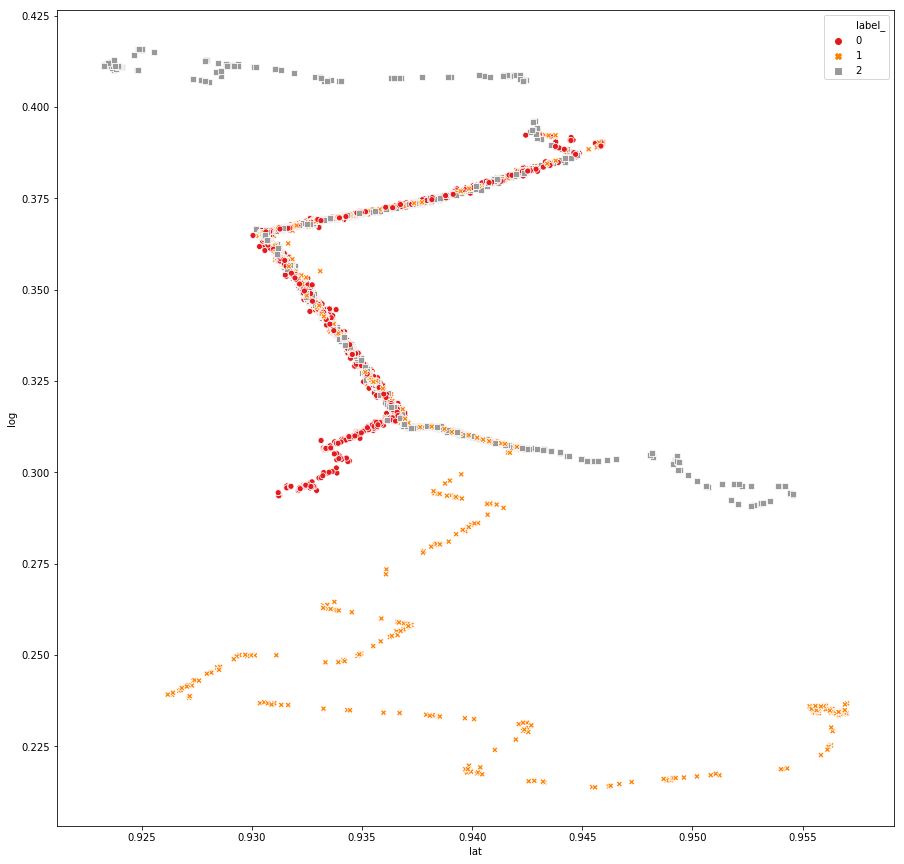

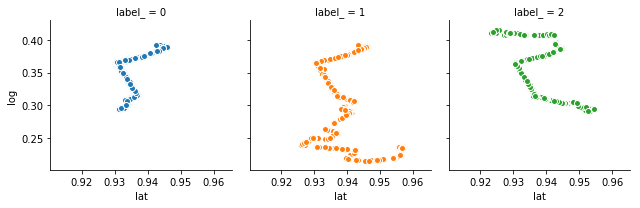

In [432]:
plot_itenerary_b(y_train, X_train)

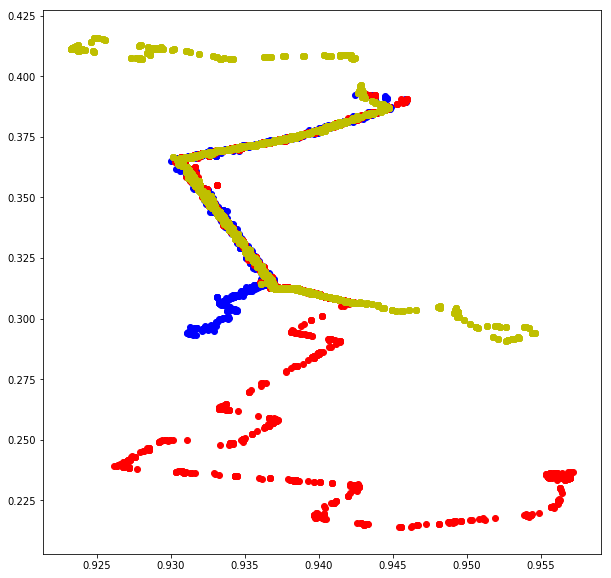

In [99]:
X_train = data.drop(['label'], axis=1)
y_train = data['label'].astype('int')
plot_itenerary(y_train, X_train)

In [159]:
# Масштабирование
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(questions)

X_train = pd.DataFrame(X_train, columns=data.drop(['label'], axis=1).columns)
X_test = pd.DataFrame(X_test, columns=questions.columns)

In [101]:
del_f = ['hour','day_req','hour_req','hour_req', ]

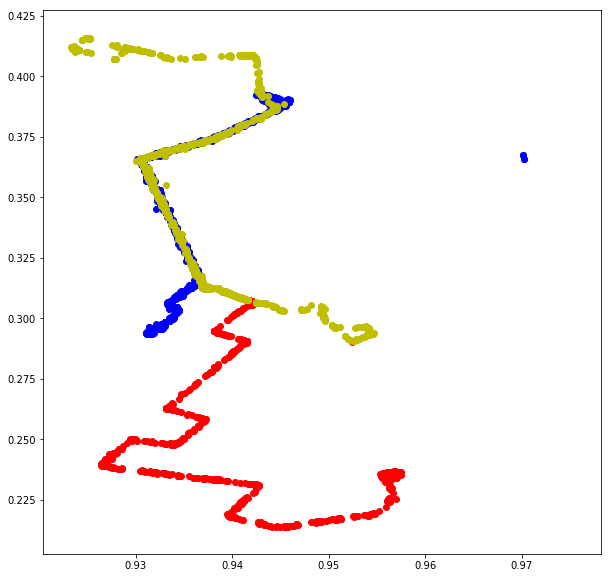

In [111]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=6, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=35,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

clf.fit(del_features(X_train, del_f), y_train)

prediction = clf.predict(del_features(questions, del_f))

plot_itenerary(prediction, questions)

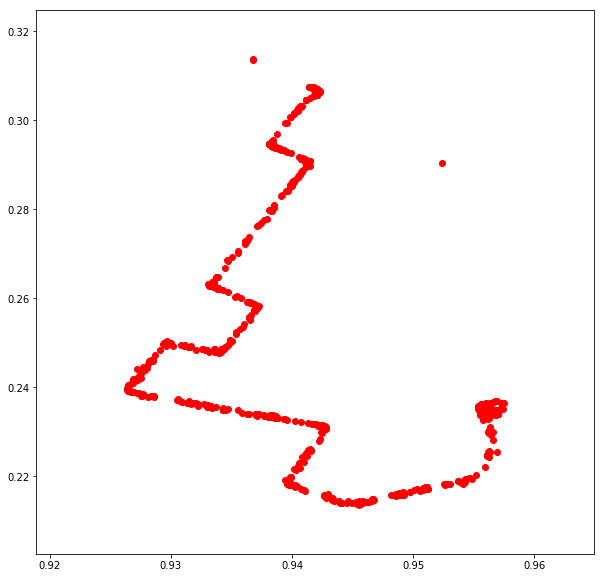

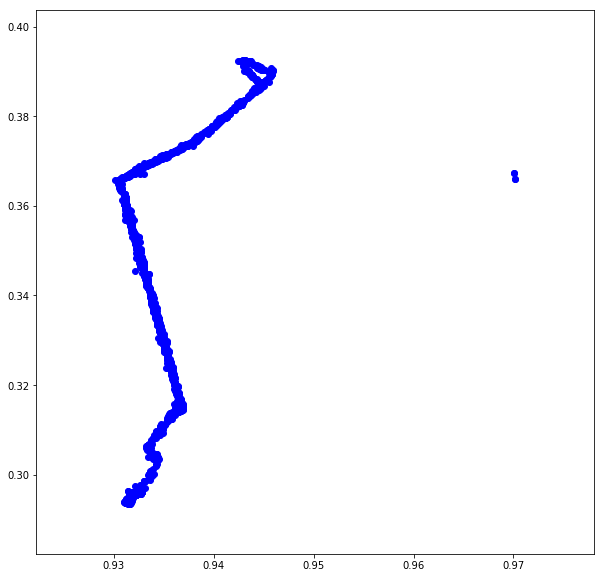

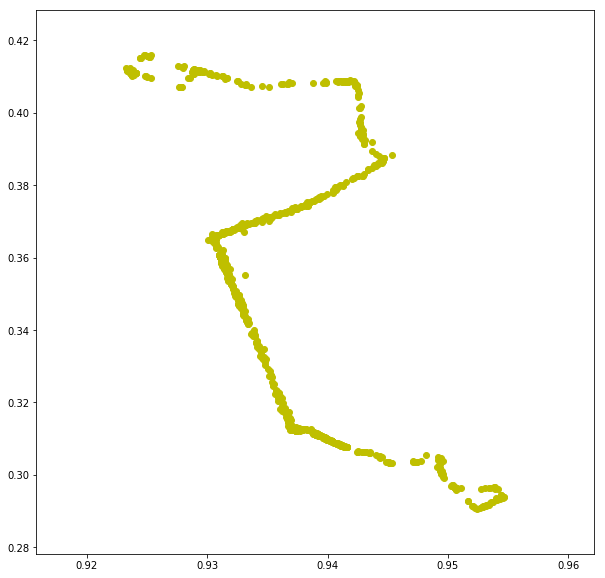

In [112]:
plot_itenerary_r(prediction, questions)
plot_itenerary_b(prediction, questions)
plot_itenerary_y(prediction, questions)

In [104]:
print (Counter(prediction))
out = open('del.txt', 'w')

for i in prediction:
    out.write(str(i) + '\n') 
out.close()

Counter({0: 2570, 2: 1373, 1: 1057})


In [140]:
imp = list(zip(rf.feature_importances_, X_train.columns))
imp

[(0.7293735804383356, 'log'),
 (0.1460878078712291, 'lat'),
 (0.0010978063138443756, 'request_ts'),
 (0.0023141093065757825, 'trans_ts'),
 (0.00014647570577191739, 'day'),
 (4.9264497441815015e-05, 'hour'),
 (0.00024876719500313235, 'day_sec'),
 (0.0002765110452135339, 'day_minutes'),
 (0.00020700286719989368, 'day_req'),
 (0.00010829507565514093, 'hour_req'),
 (0.00012769605596799836, 'day_sec_req'),
 (0.00023739054837482686, 'day_minutes_req'),
 (0.00015152638429998279, 'time_low_0'),
 (0.0, 'time_high_0'),
 (6.102410083570913e-05, 'dist_low_0'),
 (0.00037468465159241535, 'dist_high_0'),
 (0.0022231979288486804, 'time_low_1'),
 (0.002123406213258167, 'time_high_1'),
 (0.00019899527795608096, 'dist_low_1'),
 (7.372705778073555e-05, 'dist_high_1'),
 (0.022413884266568814, 'time_low_2'),
 (0.06798644799012486, 'time_high_2'),
 (0.014143170652245789, 'dist_low_2'),
 (0.009975228555875786, 'dist_high_2')]

In [636]:
Counter({0: 2570, 2: 1373, 1: 1057})

Counter({0: 3260, 1: 1334, 2: 406})

In [628]:
rf=RandomForestClassifier(n_estimators = 1000, criterion = 'gini', oob_score = True,  n_jobs = -1, random_state = 42)
ab=AdaBoostClassifier(n_estimators = 10 ,random_state = 42)
dt=DecisionTreeClassifier(max_features=12, random_state=42, max_leaf_nodes=10)

xgbcl = XGBClassifier(booster='gbtree', colsample_bytree=1.0, gamma=3, learning_rate=0.001,
       max_depth=3, min_child_weight=2,
       n_estimators=1000, n_jobs=1, nthread=4, objective='multi:softprob',
       random_state=0,
       seed=42, silent=True, subsample=0.8)


clf = rf

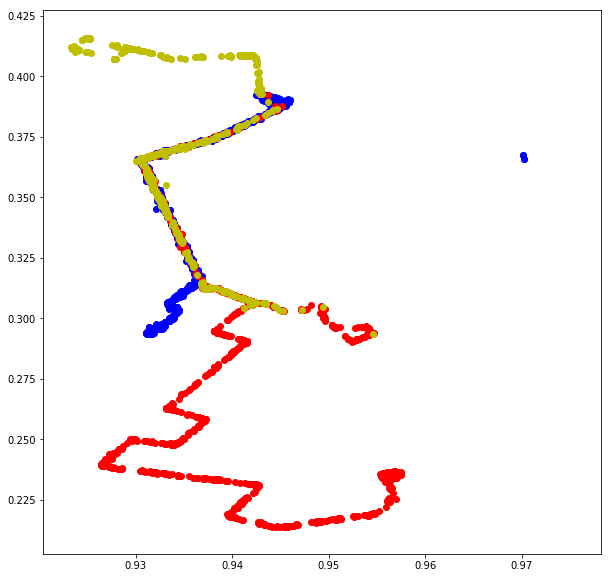

In [629]:
clf = xgbcl

del_f = ['request_ts', 'trans_ts', 'hour','day_req','hour_req']
clf.fit(del_features(X_train, del_f), y_train)

prediction = clf.predict(del_features(questions, del_f))

plot_itenerary(prediction, questions)

In [631]:
print (Counter(prediction))
out = open('xgb.txt', 'w')

for i in prediction:
    out.write(str(i) + '\n') 
out.close()

Counter({0: 2576, 1: 1721, 2: 703})


In [26]:
X = data.drop(['label'], axis=1)
y = data['label']

scaler = StandardScaler().fit(X)

X_train = scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train = pd.DataFrame(X_train, columns=data.drop(['label'], axis=1).columns)
X_test = pd.DataFrame(X_test, columns=data.drop(['label'], axis=1).columns)
print(X_train.shape)
print(X_test.shape)

(54750, 12)
(13688, 12)


0.7488310929281122
Сколько маршрутов назначил Counter({0: 7219, 1: 4503, 2: 1966})
              precision    recall  f1-score   support

           0       0.68      0.90      0.77      5442
           1       0.88      0.71      0.78      5580
           2       0.72      0.53      0.61      2666

   micro avg       0.75      0.75      0.75     13688
   macro avg       0.76      0.71      0.72     13688
weighted avg       0.77      0.75      0.75     13688



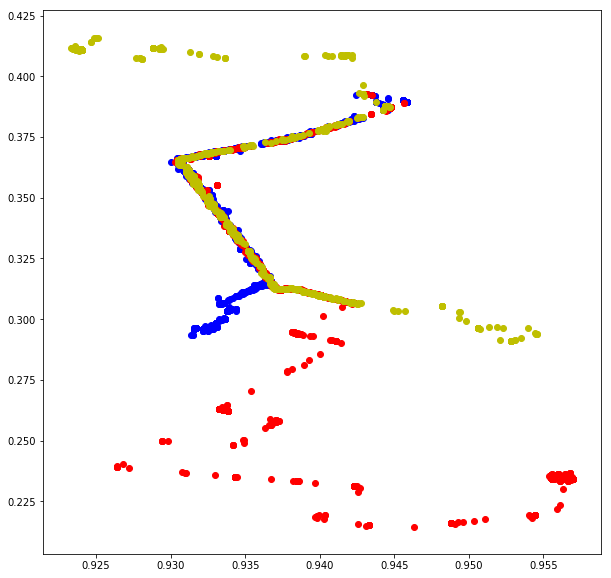

In [32]:
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
prediction = clf.predict(X_test)

plot_itenerary(prediction, X_test)

print (accuracy)
print ('Сколько маршрутов назначил', Counter(prediction))
print(metrics.classification_report(y_test, prediction))

In [113]:
#clf = DecisionTreeClassifier(random_state=42, max_leaf_nodes=10)
#clf = RandomForestClassifier(max_depth=5, n_estimators=1000, criterion='gini', min_samples_leaf=4, n_jobs=1)

scores = cross_val_score(clf, X_train, y_train, cv=3)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

scores                      

Accuracy: 0.52 (+/- 0.01)


array([0.5158371 , 0.53087617, 0.51875809])

Сетки

In [54]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [66]:
%%time
param_test = {
 'max_depth':[2,3,4],
 'min_child_weight':[6, 7, 8]
}

gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softmax', nthread=4, scale_pos_weight=1,seed=42), 
 param_grid = param_test, scoring='precision_micro',n_jobs=-1, cv=5, verbose=10)

train_model = gsearch.fit(X_train, y_train)

print(train_model.best_params_)
print(train_model.best_estimator_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   50.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  43 out of  45 | elapsed:  2.4min remaining:    6.5s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  2.4min finished


{'max_depth': 2, 'min_child_weight': 6}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=6, missing=None, n_estimators=100,
       n_jobs=1, nthread=4, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.8)
Wall time: 2min 29s


In [73]:
%%time
param_test = {
 'n_estimators':[400, 500, 600]
}

gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate = 1e-05, n_estimators=100, max_depth=2,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softmax', nthread=4, scale_pos_weight=1,seed=42), 
 param_grid = param_test, scoring='precision_micro',n_jobs=-1, cv=5, verbose=10)

train_model = gsearch.fit(X_train, y_train)

print(train_model.best_params_)
print(train_model.best_estimator_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:  2.9min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  3.1min remaining:   46.3s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  3.8min finished


{'n_estimators': 500}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=1e-05,
       max_delta_step=0, max_depth=2, min_child_weight=6, missing=None,
       n_estimators=500, n_jobs=1, nthread=4, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=42, silent=True, subsample=0.8)
Wall time: 4min 10s


In [71]:
%%time
param_test = {
 'n_estimators':[100, 500, 1000]
}

gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate=0.0001, n_estimators=100, max_depth=2,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softmax', nthread=4, scale_pos_weight=1,seed=42), 
 param_grid = param_test, scoring='precision_micro',n_jobs=-1, cv=3, verbose=10)

train_model = gsearch.fit(X_train, y_train)

print(train_model.best_params_)
print(train_model.best_estimator_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:   10.4s remaining:   20.9s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   46.1s remaining:   57.7s
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:   54.4s remaining:   43.5s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:   56.7s remaining:   28.3s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:  1.4min remaining:   23.8s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  1.7min finished


{'n_estimators': 500}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.0001,
       max_delta_step=0, max_depth=2, min_child_weight=6, missing=None,
       n_estimators=500, n_jobs=1, nthread=4, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=42, silent=True, subsample=0.8)
Wall time: 1min 57s


XGBOST

{'n_estimators': 500}

{'max_depth': 2, 'min_child_weight': 6}

{'learning_rate': 1e-05}

# RandomForestClassifier

param_test = {

 'bootstrap': [True, False],
 
 'max_depth': [10, 30,  60, 90, None],
 
 'max_features': ['auto', 'sqrt'],
 
 'min_samples_leaf': [1, 4, 10],
 
 'min_samples_split': [2,  10, 15],
 
 'n_estimators': [200,  800,  1400, 1600, 2000],
 
 'criterion': ['gini', 'entropy']
 
  }

In [49]:
%%time
param_test = {
 'n_estimators': [200,  800,  1400, 1600]
  }

gsearch = GridSearchCV(estimator = RandomForestClassifier(bootstrap= True, criterion= 'entropy'), 
 param_grid = param_test, scoring='precision_micro',n_jobs=-1, cv=4, verbose=10)

train_model = gsearch.fit(X_train, y_train)

print('Лучшие параметры ', train_model.best_params_)
print(train_model.best_estimator_)
print('Лучший результат', train_model.best_score_)
print(list(zip(train_model.best_estimator_.feature_importances_, X_train.columns)))
imp = list(zip(train_model.best_estimator_.feature_importances_, X_train.columns))

Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:  7.0min remaining:  3.2min
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed: 11.5min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed: 12.5min finished


Лучшие параметры  {'n_estimators': 1400}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1400, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Лучший результат 0.538151319442415
[(0.3914581432582094, 'log'), (0.2857956503001299, 'lat'), (0.047338346659740835, 'request_ts'), (0.04969815631461331, 'trans_ts'), (0.00459671377617387, 'day'), (0.010643079756320204, 'hour'), (0.04733382346573353, 'minute'), (0.054685076907862375, 'day_minutes'), (0.004414415820954503, 'day_req'), (0.009848071736804484, 'hour_req'), (0.043326719000369225, 'minute_req'), (0.050861803003088284, 'day_minutes_req')]
Wall time: 15min 28s


In [45]:
%%time
param_test = {
 'bootstrap': [True, False],
 'max_depth': [10, 30,  60, 90, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 4, 10],
 'min_samples_split': [2,  10, 15],
 'n_estimators': [200,  800,  1400, 1600, 2000],
 'criterion': ['gini', 'entropy']
  }

gsearch = GridSearchCV(estimator = RandomForestClassifier(), 
 param_grid = param_test, scoring='precision_micro',n_jobs=-1, cv=4, verbose=10)

train_model = gsearch.fit(X_train, y_train)

print('Лучшие параметры ', train_model.best_params_)
print(train_model.best_estimator_)
print('Лучший результат', train_model.best_score_)
print(list(zip(train_model.best_estimator_.feature_importances_, X_train.columns)))
imp = list(zip(train_model.best_estimator_.feature_importances_, X_train.columns))

Fitting 4 folds for each of 1800 candidates, totalling 7200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 25.7min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 33.5min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 36.9min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 43.3min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 50.5min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 58.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 64.1min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 72

KeyboardInterrupt: 

In [42]:
%%time
param_test = {
 'bootstrap': [True, False],
  }

gsearch = GridSearchCV(estimator = RandomForestClassifier(), 
 param_grid = param_test, scoring='precision_micro',n_jobs=-1, cv=3, verbose=5)

train_model = gsearch.fit(X_train, y_train)

print('Лучшие параметры ', train_model.best_params_)
print(train_model.best_estimator_)
print('Лучший результат', train_model.best_score_)
print(list(zip(train_model.best_estimator_.feature_importances_, X_train.columns)))
imp = list(zip(train_model.best_estimator_.feature_importances_, X_train.columns))

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    1.9s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    4.1s finished


Лучшие параметры  {'bootstrap': True}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Лучший результат 0.5411175078172945
[(0.35545290829100934, 'log'), (0.3220394035395008, 'lat'), (0.04653618891196905, 'request_ts'), (0.04966407682525399, 'trans_ts'), (0.005196325017981487, 'day'), (0.009976277171041187, 'hour'), (0.04601215775778125, 'minute'), (0.054258052667151536, 'day_minutes'), (0.005913156613979671, 'day_req'), (0.009839797059633691, 'hour_req'), (0.04234595366726533, 'minute_req'), (0.052765702477432605, 'day_minutes_req')]
Wall time: 5.75 s


Лучшие параметры  {'bootstrap': True, 'criterion': 'gini', 'max_features': 'sqrt'}

In [61]:
param_test = {
 'max_depth': sp_randint(2, 50),
 'min_samples_leaf': sp_randint(1, 15),
 'min_samples_split': sp_randint(2, 20),
 'n_estimators': sp_randint(100, 1500)
  }

gsearch = RandomizedSearchCV(estimator = RandomForestClassifier(n_estimators= 100, criterion='gini', bootstrap= True, max_features ='sqrt'), 
 param_distributions = param_test, scoring='precision_micro',n_jobs=-1, verbose=10, n_iter= 20)

random_search  = gsearch.fit(X_train, y_train)

print('Лучшие параметры ', random_search.best_params_)
print(random_search.best_estimator_)
print('Лучший результат', random_search.best_score_)
print(list(zip(random_search.best_estimator_.feature_importances_, X_train.columns)))
imp = list(zip(random_search.best_estimator_.feature_importances_, X_train.columns))
report(random_search.cv_results_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  9.6min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  9.7min finished


Лучшие параметры  {'max_depth': 12, 'min_samples_leaf': 9, 'min_samples_split': 16, 'n_estimators': 1321}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=9, min_samples_split=16,
            min_weight_fraction_leaf=0.0, n_estimators=1321, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Лучший результат 0.5842660510242847
[(0.5120193189634598, 'log'), (0.3449088646500409, 'lat'), (0.022530390320473274, 'request_ts'), (0.02648312748595363, 'trans_ts'), (0.004043129212273987, 'day'), (0.0067151434748916935, 'hour'), (0.01549855630020458, 'minute'), (0.025996207480902256, 'day_minutes'), (0.003967372674815853, 'day_req'), (0.00552790391531721, 'hour_req'), (0.011253487013462946, 'minute_req'), (0.02105649850820364, 'day_minutes_req')]
Model with rank

In [62]:
param_test = {
 'max_depth': sp_randint(2, 50),
 'min_samples_leaf': sp_randint(1, 15),
 'min_samples_split': sp_randint(2, 20),
 'n_estimators': sp_randint(100, 1500)
  }

gsearch = RandomizedSearchCV(estimator = RandomForestClassifier(n_estimators= 100, criterion='gini', bootstrap= True, max_features ='sqrt'), 
 param_distributions = param_test, scoring='precision_micro',n_jobs=-1, verbose=10, n_iter= 30)

random_search  = gsearch.fit(X_train, y_train)

print('Лучшие параметры ', random_search.best_params_)
print(random_search.best_estimator_)
print('Лучший результат', random_search.best_score_)
print(list(zip(random_search.best_estimator_.feature_importances_, X_train.columns)))
imp = list(zip(random_search.best_estimator_.feature_importances_, X_train.columns))
report(random_search.cv_results_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 21.9min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 28.3min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 32.2min finished


Лучшие параметры  {'max_depth': 7, 'min_samples_leaf': 6, 'min_samples_split': 19, 'n_estimators': 535}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=19,
            min_weight_fraction_leaf=0.0, n_estimators=535, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Лучший результат 0.6117215581986616
[(0.5616475988667623, 'log'), (0.3533527765403643, 'lat'), (0.015982417706855483, 'request_ts'), (0.017192356356892133, 'trans_ts'), (0.0037388956874835288, 'day'), (0.005306813886238335, 'hour'), (0.005434176413100322, 'minute'), (0.015763272489660106, 'day_minutes'), (0.003816808793531209, 'day_req'), (0.0035320289543860836, 'hour_req'), (0.003080593004913121, 'minute_req'), (0.011152261299812654, 'day_minutes_req')]
Model with ran

In [63]:
param_test = {
 'max_depth': sp_randint(2, 15),
 'min_samples_leaf': sp_randint(1, 10),
 'min_samples_split': sp_randint(5, 40),
 'n_estimators': sp_randint(500, 1000)
  }

gsearch = RandomizedSearchCV(estimator = RandomForestClassifier(n_estimators= 100, criterion='gini', bootstrap= True, max_features ='sqrt'), 
 param_distributions = param_test, scoring='precision_micro',n_jobs=-1, verbose=10, n_iter= 30)

random_search  = gsearch.fit(X_train, y_train)

print('Лучшие параметры ', random_search.best_params_)
print(random_search.best_estimator_)
print('Лучший результат', random_search.best_score_)
print(list(zip(random_search.best_estimator_.feature_importances_, X_train.columns)))
imp = list(zip(random_search.best_estimator_.feature_importances_, X_train.columns))
report(random_search.cv_results_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 17.3min finished


Лучшие параметры  {'max_depth': 8, 'min_samples_leaf': 4, 'min_samples_split': 9, 'n_estimators': 973}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=9,
            min_weight_fraction_leaf=0.0, n_estimators=973, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Лучший результат 0.6121891346912534
[(0.5286492272699809, 'log'), (0.37167810275669705, 'lat'), (0.01722062382215879, 'request_ts'), (0.019780949263010612, 'trans_ts'), (0.004135337912509963, 'day'), (0.005665836848604546, 'hour'), (0.007675876835713154, 'minute'), (0.018223727421860104, 'day_minutes'), (0.0042982355968367554, 'day_req'), (0.004142080759929743, 'hour_req'), (0.004992479717803747, 'minute_req'), (0.01353752179489468, 'day_minutes_req')]
Model with rank: 1

Parameters: {'max_depth': 8 'n_estimators': 900}

In [64]:
param_test = {
 'min_samples_leaf': sp_randint(1, 10),
 'min_samples_split': sp_randint(5, 50),
  }

gsearch = RandomizedSearchCV(
    estimator = RandomForestClassifier(n_estimators= 900, max_depth=8, criterion='gini',bootstrap= True, max_features ='sqrt'), 
 param_distributions = param_test, scoring='precision_micro',n_jobs=-1, verbose=10, n_iter= 30)

random_search  = gsearch.fit(X_train, y_train)

print('Лучшие параметры ', random_search.best_params_)
print(random_search.best_estimator_)
print('Лучший результат', random_search.best_score_)
print(list(zip(random_search.best_estimator_.feature_importances_, X_train.columns)))
imp = list(zip(random_search.best_estimator_.feature_importances_, X_train.columns))
report(random_search.cv_results_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 17.2min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 20.7min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 25.8min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 30.0min finished


Лучшие параметры  {'min_samples_leaf': 6, 'min_samples_split': 37}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=37,
            min_weight_fraction_leaf=0.0, n_estimators=900, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Лучший результат 0.6123936994067624
[(0.5476074140332714, 'log'), (0.3591463530913602, 'lat'), (0.015300121362082097, 'request_ts'), (0.019088367309716373, 'trans_ts'), (0.004298403198653266, 'day'), (0.0055408613056239404, 'hour'), (0.0071653179105953275, 'minute'), (0.016915041076568896, 'day_minutes'), (0.003525409348534719, 'day_req'), (0.004111660106597082, 'hour_req'), (0.0044517186766334215, 'minute_req'), (0.0128493325803637, 'day_minutes_req')]
Model with rank: 1
Mean validation score: 0.612 (std

In [65]:
param_test = {
 'bootstrap': [True, False],
 'max_features': ['auto', 'sqrt', None],
 'criterion': ['gini', 'entropy']
  }

gsearch = RandomizedSearchCV(
    estimator = RandomForestClassifier(n_estimators= 900, max_depth=8, criterion='gini',bootstrap= True, max_features ='sqrt', min_samples_leaf= 8, min_samples_split=35), 
 param_distributions = param_test, scoring='precision_micro',n_jobs=-1, verbose=10)

random_search  = gsearch.fit(X_train, y_train)

print('Лучшие параметры ', random_search.best_params_)
print(random_search.best_estimator_)
print('Лучший результат', random_search.best_score_)
print(list(zip(random_search.best_estimator_.feature_importances_, X_train.columns)))
imp = list(zip(random_search.best_estimator_.feature_importances_, X_train.columns))
report(random_search.cv_results_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 14.3min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 16.8min finished


Лучшие параметры  {'max_features': None, 'criterion': 'entropy', 'bootstrap': True}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=8, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=35,
            min_weight_fraction_leaf=0.0, n_estimators=900, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Лучший результат 0.6259388059265321
[(0.7909097558538494, 'log'), (0.20684561579926927, 'lat'), (0.00027161260260063754, 'request_ts'), (0.0003023307845523808, 'trans_ts'), (2.5008668707024865e-05, 'day'), (5.131310761980953e-05, 'hour'), (0.00021464970705002988, 'minute'), (0.000629117655745564, 'day_minutes'), (1.5095507372571417e-05, 'day_req'), (6.821038220579295e-05, 'hour_req'), (0.00019784724493960177, 'minute_req'), (0.000469442686089483, 'day_minutes_req')]
Model with rank: 1
Me

In [ ]:
.drop(['request_ts', 'hour', 'minute','day_req','hour_req','minute_req', 'day_minutes_req'], axis=1)

In [70]:
%%time
param_test = {
 'max_depth': sp_randint(5,15),
 'min_samples_leaf': sp_randint(5, 50),
 'min_samples_split': sp_randint(20, 50),
 'n_estimators': sp_randint(700, 1100)
  }

gsearch = RandomizedSearchCV(
    estimator = RandomForestClassifier(n_estimators= 900, max_depth=8, criterion='entropy',bootstrap= True, max_features = None, min_samples_leaf= 8, min_samples_split=35), 
 param_distributions = param_test, scoring='precision_micro',n_jobs=-1, verbose=10, n_iter= 30)

random_search  = gsearch.fit(X_train.drop(['request_ts', 'hour', 'minute','day_req','hour_req','minute_req', 'day_minutes_req'], axis=1), y_train)

print('Лучшие параметры ', random_search.best_params_)
print(random_search.best_estimator_)
print('Лучший результат', random_search.best_score_)
print(list(zip(random_search.best_estimator_.feature_importances_, X_train.columns)))
imp = list(zip(random_search.best_estimator_.feature_importances_, X_train.columns))
report(random_search.cv_results_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 17.4min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 22.9min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 27.7min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 33.4min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 40.9min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 44.9min finished


Лучшие параметры  {'max_depth': 8, 'min_samples_leaf': 15, 'min_samples_split': 44, 'n_estimators': 1084}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=8, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=15, min_samples_split=44,
            min_weight_fraction_leaf=0.0, n_estimators=1084, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Лучший результат 0.6222566410473713
[(0.7912030339524013, 'log'), (0.2071248438996243, 'lat'), (0.0005777132922370121, 'request_ts'), (3.766899569555892e-05, 'trans_ts'), (0.0010567398600417229, 'day')]
Model with rank: 1
Mean validation score: 0.622 (std: 0.083)
Parameters: {'max_depth': 8, 'min_samples_leaf': 15, 'min_samples_split': 44, 'n_estimators': 1084}

Model with rank: 2
Mean validation score: 0.621 (std: 0.083)
Parameters: {'max_depth': 8, 'min_samples_

In [ ]:
https://bitbucket.org/SneK1/pm-pu_ml/src/master/

Маршруты с '-' добавлены к обучению: пересечение их координат и известных маршрутов.
Список признаков:
['log', 'lat', 'trans_ts', 'day', 'day_minutes']

RandomForestClassifier с лучшими параметрами (с помощью RandomizedSearchCV)

In [153]:
%%time
param_test = {
 'max_depth': sp_randint(5,15),
 'min_samples_leaf': sp_randint(5, 50),
 'min_samples_split': sp_randint(20, 50),
 'n_estimators': sp_randint(700, 1100)
  }

gsearch = RandomizedSearchCV(
    estimator = RandomForestClassifier(n_estimators= 900, max_depth=8, criterion='entropy',bootstrap= True, max_features = None, min_samples_leaf= 8, min_samples_split=35), 
 param_distributions = param_test, scoring='precision_micro',n_jobs=-1, verbose=10, n_iter= 20)

random_search  = gsearch.fit(X_train.drop(['request_ts', 'hour', 'minute','day_req','hour_req','minute_req', 'day_minutes_req'], axis=1), y_train)

print('Лучшие параметры ', random_search.best_params_)
print(random_search.best_estimator_)
print('Лучший результат', random_search.best_score_)
print(list(zip(random_search.best_estimator_.feature_importances_, X_train.columns)))
imp = list(zip(random_search.best_estimator_.feature_importances_, X_train.columns))
report(random_search.cv_results_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 11.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 11.7min finished


Лучшие параметры  {'max_depth': 7, 'min_samples_leaf': 13, 'min_samples_split': 42, 'n_estimators': 872}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=7, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=13, min_samples_split=42,
            min_weight_fraction_leaf=0.0, n_estimators=872, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Лучший результат 0.4529452945294529
[(0.7578964293251269, 'log'), (0.17624206257868302, 'lat'), (0.03839095852443719, 'request_ts'), (0.0024956438990294877, 'trans_ts'), (0.024974905672722966, 'day')]
Model with rank: 1
Mean validation score: 0.453 (std: 0.082)
Parameters: {'max_depth': 7, 'min_samples_leaf': 13, 'min_samples_split': 42, 'n_estimators': 872}

Model with rank: 2
Mean validation score: 0.453 (std: 0.082)
Parameters: {'max_depth': 6, 'min_samples_leaf'

In [470]:
%%time
param_test = {
 'max_depth': sp_randint(5,15),
 'n_estimators': sp_randint(700, 1100)
  }

gsearch = RandomizedSearchCV(
    estimator = RandomForestClassifier(n_estimators= 900, max_depth=8, criterion='entropy',bootstrap= True, max_features = None, min_samples_leaf= 8, min_samples_split=35), 
 param_distributions = param_test, scoring='precision_micro',n_jobs=-1, verbose=10, n_iter= 20)

random_search  = gsearch.fit(X_train, y_train)

print('Лучшие параметры ', random_search.best_params_)
print(random_search.best_estimator_)
print('Лучший результат', random_search.best_score_)
print(list(zip(random_search.best_estimator_.feature_importances_, X_train.columns)))
imp = list(zip(random_search.best_estimator_.feature_importances_, X_train.columns))
report(random_search.cv_results_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 23.4min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 25.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 25.8min finished


Лучшие параметры  {'max_depth': 6, 'n_estimators': 812}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=6, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=35,
            min_weight_fraction_leaf=0.0, n_estimators=812, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Лучший результат 0.45794579457945794
[(0.7797068586052824, 'log'), (0.17306519638368706, 'lat'), (0.0076236876898202535, 'request_ts'), (0.009093588047636634, 'trans_ts'), (0.0002175511751151758, 'day'), (1.625870864844872e-05, 'hour'), (0.0012501550629207994, 'day_sec'), (0.0010075318167025347, 'day_minutes'), (0.00013940497276205882, 'day_req'), (6.992152668311568e-05, 'hour_req'), (0.0013392159512952138, 'day_sec_req'), (0.0006658747228891905, 'day_minutes_req'), (0.0007154010432903782, 'time_low_0'), (0.0001415

parameters_test = {
              'gamma': sp_randint(1, 5),
              'learning_rate': [0.001, 0.005, 0.01],
              'max_depth': sp_randint(2, 10),
              'min_child_weight': sp_randint(1, 10),
              'subsample': [0.6, 0.8, 1.0],
              'colsample_bytree': [0.6, 0.8, 1.0],
              'n_estimators': sp_randint(500, 1100)
                }

In [516]:
parameters_test = {
              'gamma': sp_randint(0, 5),
              'learning_rate': [0.001, 0.005, 0.01],
              'n_estimators': sp_randint(500, 1100)
                }

gsearch = RandomizedSearchCV(
    estimator = XGBClassifier(learning_rate = 1e-03, n_estimators=100, max_depth=2,
                             min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
                             objective= 'multi:softmax', nthread=4, scale_pos_weight=1,seed=42), 
 param_distributions = parameters_test, scoring='precision_micro',n_jobs=-1, verbose=10, n_iter= 10)

random_search  = gsearch.fit(X_train, y_train)

print('Лучшие параметры ', random_search.best_params_)
print(random_search.best_estimator_)
print('Лучший результат', random_search.best_score_)
print(list(zip(random_search.best_estimator_.feature_importances_, X_train.columns)))
imp = list(zip(random_search.best_estimator_.feature_importances_, X_train.columns))
report(random_search.cv_results_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  1.9min remaining:   12.7s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.1min finished


Лучшие параметры  {'gamma': 1, 'learning_rate': 0.005, 'n_estimators': 545}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=1, learning_rate=0.005,
       max_delta_step=0, max_depth=2, min_child_weight=6, missing=None,
       n_estimators=545, n_jobs=1, nthread=4, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=42, silent=True, subsample=0.8)
Лучший результат 0.45304530453045305
[(0.5309666, 'log'), (0.27079555, 'lat'), (0.04793988, 'request_ts'), (0.049235553, 'trans_ts'), (0.0033687484, 'day'), (0.0012956725, 'hour'), (0.02772739, 'day_sec'), (0.0023322103, 'day_minutes'), (0.0028504794, 'day_req'), (0.0, 'hour_req'), (0.005700959, 'day_sec_req'), (0.0007774035, 'day_minutes_req'), (0.0012956725, 'time_low_0'), (0.001554807, 'time_high_0'), (0.015807204, 'time_low_1'), (0.01269759, 'time_high_1'), (0.014511531, 'time_low_2'), (0.011142783, 'time_high_2')]
Model with 

In [517]:
parameters_test = {
              'max_depth': sp_randint(2, 15),
              'subsample': [0.6, 0.8, 1.0]
                }

gsearch = RandomizedSearchCV(
    estimator = XGBClassifier(learning_rate = 0.001, n_estimators=1000, max_depth=3,
                             min_child_weight=6, gamma=3, subsample=0.8, colsample_bytree= 1.0,
                             objective= 'multi:softmax', nthread=4, scale_pos_weight=1,seed=42), 
 param_distributions = parameters_test, scoring='precision_micro',n_jobs=-1, verbose=10, n_iter= 37)

random_search  = gsearch.fit(X_train, y_train)

print('Лучшие параметры ', random_search.best_params_)
print(random_search.best_estimator_)
print('Лучший результат', random_search.best_score_)
print(list(zip(random_search.best_estimator_.feature_importances_, X_train.columns)))
imp = list(zip(random_search.best_estimator_.feature_importances_, X_train.columns))
report(random_search.cv_results_)

Fitting 3 folds for each of 37 candidates, totalling 111 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 25.8min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 35.3min
[Parallel(n_jobs=-1)]: Done 111 out of 111 | elapsed: 47.3min finished


Лучшие параметры  {'colsample_bytree': 1.0, 'max_depth': 4, 'subsample': 0.6}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, gamma=3, learning_rate=0.001,
       max_delta_step=0, max_depth=4, min_child_weight=6, missing=None,
       n_estimators=1000, n_jobs=1, nthread=4, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=42, silent=True, subsample=0.6)
Лучший результат 0.48814881488148815
[(0.5214738, 'log'), (0.27002844, 'lat'), (0.06350372, 'request_ts'), (0.014269982, 'trans_ts'), (0.0033495456, 'day'), (0.00022942094, 'hour'), (0.023584472, 'day_sec'), (0.0, 'day_minutes'), (0.00013765256, 'day_req'), (0.0, 'hour_req'), (0.0023400935, 'day_sec_req'), (0.0, 'day_minutes_req'), (0.0064696707, 'time_low_0'), (0.008993301, 'time_high_0'), (0.023813894, 'time_low_1'), (0.034091953, 'time_high_1'), (0.013444067, 'time_low_2'), (0.014269982, 'time_high_2')]
Model with rank: 1
Me

In [519]:
parameters_test = {
             'learning_rate': [0.001, 0.005, 0.01],
             'min_child_weight': sp_randint(1, 10)
                }

gsearch = RandomizedSearchCV(
    estimator = XGBClassifier(learning_rate = 0.001, n_estimators=1000, max_depth=3,
                             min_child_weight=6, gamma=3, subsample=0.8, colsample_bytree= 1.0,
                             objective= 'multi:softmax', nthread=4, scale_pos_weight=1,seed=42), 
 param_distributions = parameters_test, scoring='precision_micro',n_jobs=-1, verbose=10, n_iter= 10)

random_search  = gsearch.fit(X_train, y_train)

print('Лучшие параметры ', random_search.best_params_)
print(random_search.best_estimator_)
print('Лучший результат', random_search.best_score_)
print(list(zip(random_search.best_estimator_.feature_importances_, X_train.columns)))
imp = list(zip(random_search.best_estimator_.feature_importances_, X_train.columns))
report(random_search.cv_results_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  4.2min remaining:   28.1s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.5min finished


Лучшие параметры  {'learning_rate': 0.001, 'min_child_weight': 2}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, gamma=3, learning_rate=0.001,
       max_delta_step=0, max_depth=3, min_child_weight=2, missing=None,
       n_estimators=1000, n_jobs=1, nthread=4, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=42, silent=True, subsample=0.8)
Лучший результат 0.4807480748074808
[(0.6869565, 'log'), (0.21529503, 'lat'), (0.036645964, 'request_ts'), (0.015217391, 'trans_ts'), (0.0, 'day'), (0.0, 'hour'), (0.014052795, 'day_sec'), (0.0, 'day_minutes'), (0.0, 'day_req'), (0.0, 'hour_req'), (0.0010093168, 'day_sec_req'), (0.0, 'day_minutes_req'), (0.000931677, 'time_low_0'), (0.0001552795, 'time_high_0'), (0.0064440994, 'time_low_1'), (0.021118013, 'time_high_1'), (0.00038819876, 'time_low_2'), (0.0017857143, 'time_high_2')]
Model with rank: 1
Mean validation score: 0.481 (std: 0.09